In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "preprocess"
enable_aug = False
enable_aug3 = False
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 2048
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-preprocess-enable_aug-False-enable_aug3-False-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-2048-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

189419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

189419
189419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


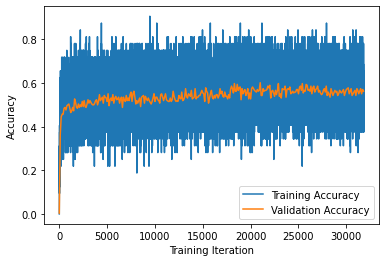

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.196 Validation Loss: 2.182 Accuracy: 0.195 Validation Accuracy: 0.324:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.196 Validation Loss: 2.182 Accuracy: 0.195 Validation Accuracy: 0.324:   0%|          | 1/1480 [00:00<02:43,  9.04it/s]

Epoch: 0 Iteration: 1 Loss: 2.189 Validation Loss: 2.182 Accuracy: 0.242 Validation Accuracy: 0.324:   0%|          | 1/1480 [00:00<02:43,  9.04it/s]

Epoch: 0 Iteration: 2 Loss: 2.182 Validation Loss: 2.182 Accuracy: 0.318 Validation Accuracy: 0.324:   0%|          | 1/1480 [00:00<02:43,  9.04it/s]

Epoch: 0 Iteration: 3 Loss: 2.175 Validation Loss: 2.182 Accuracy: 0.381 Validation Accuracy: 0.324:   0%|          | 1/1480 [00:00<02:43,  9.04it/s]

Epoch: 0 Iteration: 4 Loss: 2.168 Validation Loss: 2.182 Accuracy: 0.408 Validation Accuracy: 0.324:   0%|          | 1/1480 [00:00<02:43,  9.04it/s]

Epoch: 0 Iteration: 4 Loss: 2.168 Validation Loss: 2.182 Accuracy: 0.408 Validation Accuracy: 0.324:   0%|          | 5/1480 [00:00<01:00, 24.49it/s]

Epoch: 0 Iteration: 5 Loss: 2.161 Validation Loss: 2.182 Accuracy: 0.438 Validation Accuracy: 0.324:   0%|          | 5/1480 [00:00<01:00, 24.49it/s]

Epoch: 0 Iteration: 6 Loss: 2.154 Validation Loss: 2.182 Accuracy: 0.452 Validation Accuracy: 0.324:   0%|          | 5/1480 [00:00<01:00, 24.49it/s]

Epoch: 0 Iteration: 7 Loss: 2.147 Validation Loss: 2.182 Accuracy: 0.475 Validation Accuracy: 0.324:   0%|          | 5/1480 [00:00<01:00, 24.49it/s]

Epoch: 0 Iteration: 7 Loss: 2.147 Validation Loss: 2.182 Accuracy: 0.475 Validation Accuracy: 0.324:   1%|          | 8/1480 [00:00<00:54, 26.80it/s]

Epoch: 0 Iteration: 8 Loss: 2.142 Validation Loss: 2.182 Accuracy: 0.477 Validation Accuracy: 0.324:   1%|          | 8/1480 [00:00<00:54, 26.80it/s]

Epoch: 0 Iteration: 9 Loss: 2.136 Validation Loss: 2.182 Accuracy: 0.495 Validation Accuracy: 0.324:   1%|          | 8/1480 [00:00<00:54, 26.80it/s]

Epoch: 0 Iteration: 10 Loss: 2.130 Validation Loss: 2.182 Accuracy: 0.535 Validation Accuracy: 0.324:   1%|          | 8/1480 [00:00<00:54, 26.80it/s]

Epoch: 0 Iteration: 11 Loss: 2.123 Validation Loss: 2.182 Accuracy: 0.568 Validation Accuracy: 0.324:   1%|          | 8/1480 [00:00<00:54, 26.80it/s]

Epoch: 0 Iteration: 11 Loss: 2.123 Validation Loss: 2.182 Accuracy: 0.568 Validation Accuracy: 0.324:   1%|          | 12/1480 [00:00<00:51, 28.36it/s]

Epoch: 0 Iteration: 12 Loss: 2.118 Validation Loss: 2.182 Accuracy: 0.577 Validation Accuracy: 0.324:   1%|          | 12/1480 [00:00<00:51, 28.36it/s]

Epoch: 0 Iteration: 13 Loss: 2.111 Validation Loss: 2.182 Accuracy: 0.580 Validation Accuracy: 0.324:   1%|          | 12/1480 [00:00<00:51, 28.36it/s]

Epoch: 0 Iteration: 14 Loss: 2.105 Validation Loss: 2.182 Accuracy: 0.585 Validation Accuracy: 0.324:   1%|          | 12/1480 [00:00<00:51, 28.36it/s]

Epoch: 0 Iteration: 15 Loss: 2.100 Validation Loss: 2.182 Accuracy: 0.581 Validation Accuracy: 0.324:   1%|          | 12/1480 [00:00<00:51, 28.36it/s]

Epoch: 0 Iteration: 15 Loss: 2.100 Validation Loss: 2.182 Accuracy: 0.581 Validation Accuracy: 0.324:   1%|          | 16/1480 [00:00<00:50, 29.21it/s]

Epoch: 0 Iteration: 16 Loss: 2.093 Validation Loss: 2.182 Accuracy: 0.582 Validation Accuracy: 0.324:   1%|          | 16/1480 [00:00<00:50, 29.21it/s]

Epoch: 0 Iteration: 17 Loss: 2.087 Validation Loss: 2.182 Accuracy: 0.584 Validation Accuracy: 0.324:   1%|          | 16/1480 [00:00<00:50, 29.21it/s]

Epoch: 0 Iteration: 18 Loss: 2.080 Validation Loss: 2.182 Accuracy: 0.595 Validation Accuracy: 0.324:   1%|          | 16/1480 [00:00<00:50, 29.21it/s]

Epoch: 0 Iteration: 19 Loss: 2.074 Validation Loss: 2.182 Accuracy: 0.585 Validation Accuracy: 0.324:   1%|          | 16/1480 [00:00<00:50, 29.21it/s]

Epoch: 0 Iteration: 19 Loss: 2.074 Validation Loss: 2.182 Accuracy: 0.585 Validation Accuracy: 0.324:   1%|▏         | 20/1480 [00:00<00:49, 29.68it/s]

Epoch: 0 Iteration: 20 Loss: 2.061 Validation Loss: 2.182 Accuracy: 0.584 Validation Accuracy: 0.324:   1%|▏         | 20/1480 [00:00<00:49, 29.68it/s]

Epoch: 0 Iteration: 21 Loss: 2.048 Validation Loss: 2.182 Accuracy: 0.579 Validation Accuracy: 0.324:   1%|▏         | 20/1480 [00:00<00:49, 29.68it/s]

Epoch: 0 Iteration: 22 Loss: 2.037 Validation Loss: 2.182 Accuracy: 0.581 Validation Accuracy: 0.324:   1%|▏         | 20/1480 [00:00<00:49, 29.68it/s]

Epoch: 0 Iteration: 23 Loss: 2.025 Validation Loss: 2.182 Accuracy: 0.575 Validation Accuracy: 0.324:   1%|▏         | 20/1480 [00:00<00:49, 29.68it/s]

Epoch: 0 Iteration: 23 Loss: 2.025 Validation Loss: 2.182 Accuracy: 0.575 Validation Accuracy: 0.324:   2%|▏         | 24/1480 [00:00<00:48, 29.95it/s]

Epoch: 0 Iteration: 24 Loss: 2.012 Validation Loss: 2.182 Accuracy: 0.576 Validation Accuracy: 0.324:   2%|▏         | 24/1480 [00:00<00:48, 29.95it/s]

Epoch: 0 Iteration: 25 Loss: 1.999 Validation Loss: 2.182 Accuracy: 0.577 Validation Accuracy: 0.324:   2%|▏         | 24/1480 [00:00<00:48, 29.95it/s]

Epoch: 0 Iteration: 26 Loss: 1.986 Validation Loss: 2.182 Accuracy: 0.585 Validation Accuracy: 0.324:   2%|▏         | 24/1480 [00:00<00:48, 29.95it/s]

Epoch: 0 Iteration: 27 Loss: 1.974 Validation Loss: 2.182 Accuracy: 0.571 Validation Accuracy: 0.324:   2%|▏         | 24/1480 [00:00<00:48, 29.95it/s]

Epoch: 0 Iteration: 27 Loss: 1.974 Validation Loss: 2.182 Accuracy: 0.571 Validation Accuracy: 0.324:   2%|▏         | 28/1480 [00:00<00:48, 30.18it/s]

Epoch: 0 Iteration: 28 Loss: 1.962 Validation Loss: 2.182 Accuracy: 0.566 Validation Accuracy: 0.324:   2%|▏         | 28/1480 [00:01<00:48, 30.18it/s]

Epoch: 0 Iteration: 29 Loss: 1.950 Validation Loss: 2.182 Accuracy: 0.573 Validation Accuracy: 0.324:   2%|▏         | 28/1480 [00:01<00:48, 30.18it/s]

Epoch: 0 Iteration: 30 Loss: 1.939 Validation Loss: 2.182 Accuracy: 0.572 Validation Accuracy: 0.324:   2%|▏         | 28/1480 [00:01<00:48, 30.18it/s]

Epoch: 0 Iteration: 31 Loss: 1.926 Validation Loss: 2.182 Accuracy: 0.573 Validation Accuracy: 0.324:   2%|▏         | 28/1480 [00:01<00:48, 30.18it/s]

Epoch: 0 Iteration: 31 Loss: 1.926 Validation Loss: 2.182 Accuracy: 0.573 Validation Accuracy: 0.324:   2%|▏         | 32/1480 [00:01<00:47, 30.29it/s]

Epoch: 0 Iteration: 32 Loss: 1.914 Validation Loss: 2.182 Accuracy: 0.576 Validation Accuracy: 0.324:   2%|▏         | 32/1480 [00:01<00:47, 30.29it/s]

Epoch: 0 Iteration: 33 Loss: 1.901 Validation Loss: 2.182 Accuracy: 0.580 Validation Accuracy: 0.324:   2%|▏         | 32/1480 [00:01<00:47, 30.29it/s]

Epoch: 0 Iteration: 34 Loss: 1.890 Validation Loss: 2.182 Accuracy: 0.578 Validation Accuracy: 0.324:   2%|▏         | 32/1480 [00:01<00:47, 30.29it/s]

Epoch: 0 Iteration: 35 Loss: 1.876 Validation Loss: 2.182 Accuracy: 0.581 Validation Accuracy: 0.324:   2%|▏         | 32/1480 [00:01<00:47, 30.29it/s]

Epoch: 0 Iteration: 35 Loss: 1.876 Validation Loss: 2.182 Accuracy: 0.581 Validation Accuracy: 0.324:   2%|▏         | 36/1480 [00:01<00:47, 30.34it/s]

Epoch: 0 Iteration: 36 Loss: 1.862 Validation Loss: 2.182 Accuracy: 0.580 Validation Accuracy: 0.324:   2%|▏         | 36/1480 [00:01<00:47, 30.34it/s]

Epoch: 0 Iteration: 37 Loss: 1.850 Validation Loss: 2.182 Accuracy: 0.580 Validation Accuracy: 0.324:   2%|▏         | 36/1480 [00:01<00:47, 30.34it/s]

Epoch: 0 Iteration: 38 Loss: 1.839 Validation Loss: 2.182 Accuracy: 0.573 Validation Accuracy: 0.324:   2%|▏         | 36/1480 [00:01<00:47, 30.34it/s]

Epoch: 0 Iteration: 39 Loss: 1.827 Validation Loss: 2.182 Accuracy: 0.572 Validation Accuracy: 0.324:   2%|▏         | 36/1480 [00:01<00:47, 30.34it/s]

Epoch: 0 Iteration: 39 Loss: 1.827 Validation Loss: 2.182 Accuracy: 0.572 Validation Accuracy: 0.324:   3%|▎         | 40/1480 [00:01<00:47, 30.40it/s]

Epoch: 0 Iteration: 40 Loss: 1.813 Validation Loss: 2.182 Accuracy: 0.573 Validation Accuracy: 0.324:   3%|▎         | 40/1480 [00:01<00:47, 30.40it/s]

Epoch: 0 Iteration: 41 Loss: 1.801 Validation Loss: 2.182 Accuracy: 0.577 Validation Accuracy: 0.324:   3%|▎         | 40/1480 [00:01<00:47, 30.40it/s]

Epoch: 0 Iteration: 42 Loss: 1.786 Validation Loss: 2.182 Accuracy: 0.583 Validation Accuracy: 0.324:   3%|▎         | 40/1480 [00:01<00:47, 30.40it/s]

Epoch: 0 Iteration: 43 Loss: 1.774 Validation Loss: 2.182 Accuracy: 0.579 Validation Accuracy: 0.324:   3%|▎         | 40/1480 [00:01<00:47, 30.40it/s]

Epoch: 0 Iteration: 43 Loss: 1.774 Validation Loss: 2.182 Accuracy: 0.579 Validation Accuracy: 0.324:   3%|▎         | 44/1480 [00:01<00:47, 30.42it/s]

Epoch: 0 Iteration: 44 Loss: 1.762 Validation Loss: 2.182 Accuracy: 0.586 Validation Accuracy: 0.324:   3%|▎         | 44/1480 [00:01<00:47, 30.42it/s]

Epoch: 0 Iteration: 45 Loss: 1.750 Validation Loss: 2.182 Accuracy: 0.586 Validation Accuracy: 0.324:   3%|▎         | 44/1480 [00:01<00:47, 30.42it/s]

Epoch: 0 Iteration: 46 Loss: 1.738 Validation Loss: 2.182 Accuracy: 0.589 Validation Accuracy: 0.324:   3%|▎         | 44/1480 [00:01<00:47, 30.42it/s]

Epoch: 0 Iteration: 47 Loss: 1.726 Validation Loss: 2.182 Accuracy: 0.591 Validation Accuracy: 0.324:   3%|▎         | 44/1480 [00:01<00:47, 30.42it/s]

Epoch: 0 Iteration: 47 Loss: 1.726 Validation Loss: 2.182 Accuracy: 0.591 Validation Accuracy: 0.324:   3%|▎         | 48/1480 [00:01<00:47, 30.45it/s]

Epoch: 0 Iteration: 48 Loss: 1.712 Validation Loss: 2.182 Accuracy: 0.607 Validation Accuracy: 0.324:   3%|▎         | 48/1480 [00:01<00:47, 30.45it/s]

Epoch: 0 Iteration: 49 Loss: 1.701 Validation Loss: 2.182 Accuracy: 0.600 Validation Accuracy: 0.324:   3%|▎         | 48/1480 [00:01<00:47, 30.45it/s]

Epoch: 0 Iteration: 50 Loss: 1.683 Validation Loss: 2.182 Accuracy: 0.607 Validation Accuracy: 0.324:   3%|▎         | 48/1480 [00:01<00:47, 30.45it/s]

Epoch: 0 Iteration: 51 Loss: 1.671 Validation Loss: 2.182 Accuracy: 0.605 Validation Accuracy: 0.324:   3%|▎         | 48/1480 [00:01<00:47, 30.45it/s]

Epoch: 0 Iteration: 51 Loss: 1.671 Validation Loss: 2.182 Accuracy: 0.605 Validation Accuracy: 0.324:   4%|▎         | 52/1480 [00:01<00:46, 30.48it/s]

Epoch: 0 Iteration: 52 Loss: 1.657 Validation Loss: 2.182 Accuracy: 0.594 Validation Accuracy: 0.324:   4%|▎         | 52/1480 [00:01<00:46, 30.48it/s]

Epoch: 0 Iteration: 53 Loss: 1.641 Validation Loss: 2.182 Accuracy: 0.606 Validation Accuracy: 0.324:   4%|▎         | 52/1480 [00:01<00:46, 30.48it/s]

Epoch: 0 Iteration: 54 Loss: 1.627 Validation Loss: 2.182 Accuracy: 0.600 Validation Accuracy: 0.324:   4%|▎         | 52/1480 [00:01<00:46, 30.48it/s]

Epoch: 0 Iteration: 55 Loss: 1.612 Validation Loss: 2.182 Accuracy: 0.608 Validation Accuracy: 0.324:   4%|▎         | 52/1480 [00:01<00:46, 30.48it/s]

Epoch: 0 Iteration: 55 Loss: 1.612 Validation Loss: 2.182 Accuracy: 0.608 Validation Accuracy: 0.324:   4%|▍         | 56/1480 [00:01<00:46, 30.51it/s]

Epoch: 0 Iteration: 56 Loss: 1.599 Validation Loss: 2.182 Accuracy: 0.608 Validation Accuracy: 0.324:   4%|▍         | 56/1480 [00:01<00:46, 30.51it/s]

Epoch: 0 Iteration: 57 Loss: 1.584 Validation Loss: 2.182 Accuracy: 0.613 Validation Accuracy: 0.324:   4%|▍         | 56/1480 [00:01<00:46, 30.51it/s]

Epoch: 0 Iteration: 58 Loss: 1.568 Validation Loss: 2.182 Accuracy: 0.616 Validation Accuracy: 0.324:   4%|▍         | 56/1480 [00:01<00:46, 30.51it/s]

Epoch: 0 Iteration: 59 Loss: 1.555 Validation Loss: 2.182 Accuracy: 0.620 Validation Accuracy: 0.324:   4%|▍         | 56/1480 [00:02<00:46, 30.51it/s]

Epoch: 0 Iteration: 59 Loss: 1.555 Validation Loss: 2.182 Accuracy: 0.620 Validation Accuracy: 0.324:   4%|▍         | 60/1480 [00:02<00:46, 30.52it/s]

Epoch: 0 Iteration: 60 Loss: 1.541 Validation Loss: 2.182 Accuracy: 0.613 Validation Accuracy: 0.324:   4%|▍         | 60/1480 [00:02<00:46, 30.52it/s]

Epoch: 0 Iteration: 61 Loss: 1.528 Validation Loss: 2.182 Accuracy: 0.612 Validation Accuracy: 0.324:   4%|▍         | 60/1480 [00:02<00:46, 30.52it/s]

Epoch: 0 Iteration: 62 Loss: 1.514 Validation Loss: 2.182 Accuracy: 0.620 Validation Accuracy: 0.324:   4%|▍         | 60/1480 [00:02<00:46, 30.52it/s]

Epoch: 0 Iteration: 63 Loss: 1.495 Validation Loss: 2.182 Accuracy: 0.617 Validation Accuracy: 0.324:   4%|▍         | 60/1480 [00:02<00:46, 30.52it/s]

Epoch: 0 Iteration: 63 Loss: 1.495 Validation Loss: 2.182 Accuracy: 0.617 Validation Accuracy: 0.324:   4%|▍         | 64/1480 [00:02<00:46, 30.48it/s]

Epoch: 0 Iteration: 64 Loss: 1.483 Validation Loss: 2.182 Accuracy: 0.621 Validation Accuracy: 0.324:   4%|▍         | 64/1480 [00:02<00:46, 30.48it/s]

Epoch: 0 Iteration: 65 Loss: 1.470 Validation Loss: 2.182 Accuracy: 0.620 Validation Accuracy: 0.324:   4%|▍         | 64/1480 [00:02<00:46, 30.48it/s]

Epoch: 0 Iteration: 66 Loss: 1.457 Validation Loss: 2.182 Accuracy: 0.614 Validation Accuracy: 0.324:   4%|▍         | 64/1480 [00:02<00:46, 30.48it/s]

Epoch: 0 Iteration: 67 Loss: 1.441 Validation Loss: 2.182 Accuracy: 0.619 Validation Accuracy: 0.324:   4%|▍         | 64/1480 [00:02<00:46, 30.48it/s]

Epoch: 0 Iteration: 67 Loss: 1.441 Validation Loss: 2.182 Accuracy: 0.619 Validation Accuracy: 0.324:   5%|▍         | 68/1480 [00:02<00:46, 30.50it/s]

Epoch: 0 Iteration: 68 Loss: 1.426 Validation Loss: 2.182 Accuracy: 0.613 Validation Accuracy: 0.324:   5%|▍         | 68/1480 [00:02<00:46, 30.50it/s]

Epoch: 0 Iteration: 69 Loss: 1.410 Validation Loss: 2.182 Accuracy: 0.620 Validation Accuracy: 0.324:   5%|▍         | 68/1480 [00:02<00:46, 30.50it/s]

Epoch: 0 Iteration: 70 Loss: 1.400 Validation Loss: 2.182 Accuracy: 0.618 Validation Accuracy: 0.324:   5%|▍         | 68/1480 [00:02<00:46, 30.50it/s]

Epoch: 0 Iteration: 71 Loss: 1.386 Validation Loss: 2.182 Accuracy: 0.623 Validation Accuracy: 0.324:   5%|▍         | 68/1480 [00:02<00:46, 30.50it/s]

Epoch: 0 Iteration: 71 Loss: 1.386 Validation Loss: 2.182 Accuracy: 0.623 Validation Accuracy: 0.324:   5%|▍         | 72/1480 [00:02<00:46, 30.49it/s]

Epoch: 0 Iteration: 72 Loss: 1.369 Validation Loss: 2.182 Accuracy: 0.626 Validation Accuracy: 0.324:   5%|▍         | 72/1480 [00:02<00:46, 30.49it/s]

Epoch: 0 Iteration: 73 Loss: 1.359 Validation Loss: 2.182 Accuracy: 0.630 Validation Accuracy: 0.324:   5%|▍         | 72/1480 [00:02<00:46, 30.49it/s]

Epoch: 0 Iteration: 74 Loss: 1.346 Validation Loss: 2.182 Accuracy: 0.637 Validation Accuracy: 0.324:   5%|▍         | 72/1480 [00:02<00:46, 30.49it/s]

Epoch: 0 Iteration: 75 Loss: 1.337 Validation Loss: 2.182 Accuracy: 0.634 Validation Accuracy: 0.324:   5%|▍         | 72/1480 [00:02<00:46, 30.49it/s]

Epoch: 0 Iteration: 75 Loss: 1.337 Validation Loss: 2.182 Accuracy: 0.634 Validation Accuracy: 0.324:   5%|▌         | 76/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 76 Loss: 1.323 Validation Loss: 2.182 Accuracy: 0.647 Validation Accuracy: 0.324:   5%|▌         | 76/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 77 Loss: 1.312 Validation Loss: 2.182 Accuracy: 0.636 Validation Accuracy: 0.324:   5%|▌         | 76/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 78 Loss: 1.298 Validation Loss: 2.182 Accuracy: 0.641 Validation Accuracy: 0.324:   5%|▌         | 76/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 79 Loss: 1.282 Validation Loss: 2.182 Accuracy: 0.639 Validation Accuracy: 0.324:   5%|▌         | 76/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 79 Loss: 1.282 Validation Loss: 2.182 Accuracy: 0.639 Validation Accuracy: 0.324:   5%|▌         | 80/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 80 Loss: 1.270 Validation Loss: 2.182 Accuracy: 0.646 Validation Accuracy: 0.324:   5%|▌         | 80/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 81 Loss: 1.255 Validation Loss: 2.182 Accuracy: 0.651 Validation Accuracy: 0.324:   5%|▌         | 80/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 82 Loss: 1.243 Validation Loss: 2.182 Accuracy: 0.649 Validation Accuracy: 0.324:   5%|▌         | 80/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 83 Loss: 1.235 Validation Loss: 2.182 Accuracy: 0.652 Validation Accuracy: 0.324:   5%|▌         | 80/1480 [00:02<00:45, 30.52it/s]

Epoch: 0 Iteration: 83 Loss: 1.235 Validation Loss: 2.182 Accuracy: 0.652 Validation Accuracy: 0.324:   6%|▌         | 84/1480 [00:02<00:45, 30.47it/s]

Epoch: 0 Iteration: 84 Loss: 1.225 Validation Loss: 2.182 Accuracy: 0.637 Validation Accuracy: 0.324:   6%|▌         | 84/1480 [00:02<00:45, 30.47it/s]

Epoch: 0 Iteration: 85 Loss: 1.212 Validation Loss: 2.182 Accuracy: 0.644 Validation Accuracy: 0.324:   6%|▌         | 84/1480 [00:02<00:45, 30.47it/s]

Epoch: 0 Iteration: 86 Loss: 1.195 Validation Loss: 2.182 Accuracy: 0.637 Validation Accuracy: 0.324:   6%|▌         | 84/1480 [00:02<00:45, 30.47it/s]

Epoch: 0 Iteration: 87 Loss: 1.186 Validation Loss: 2.182 Accuracy: 0.645 Validation Accuracy: 0.324:   6%|▌         | 84/1480 [00:02<00:45, 30.47it/s]

Epoch: 0 Iteration: 87 Loss: 1.186 Validation Loss: 2.182 Accuracy: 0.645 Validation Accuracy: 0.324:   6%|▌         | 88/1480 [00:02<00:45, 30.44it/s]

Epoch: 0 Iteration: 88 Loss: 1.180 Validation Loss: 2.182 Accuracy: 0.639 Validation Accuracy: 0.324:   6%|▌         | 88/1480 [00:02<00:45, 30.44it/s]

Epoch: 0 Iteration: 89 Loss: 1.164 Validation Loss: 2.182 Accuracy: 0.641 Validation Accuracy: 0.324:   6%|▌         | 88/1480 [00:03<00:45, 30.44it/s]

Epoch: 0 Iteration: 90 Loss: 1.151 Validation Loss: 2.182 Accuracy: 0.641 Validation Accuracy: 0.324:   6%|▌         | 88/1480 [00:03<00:45, 30.44it/s]

Epoch: 0 Iteration: 91 Loss: 1.139 Validation Loss: 2.182 Accuracy: 0.641 Validation Accuracy: 0.324:   6%|▌         | 88/1480 [00:03<00:45, 30.44it/s]

Epoch: 0 Iteration: 91 Loss: 1.139 Validation Loss: 2.182 Accuracy: 0.641 Validation Accuracy: 0.324:   6%|▌         | 92/1480 [00:03<00:45, 30.40it/s]

Epoch: 0 Iteration: 92 Loss: 1.130 Validation Loss: 2.182 Accuracy: 0.638 Validation Accuracy: 0.324:   6%|▌         | 92/1480 [00:03<00:45, 30.40it/s]

Epoch: 0 Iteration: 93 Loss: 1.122 Validation Loss: 2.182 Accuracy: 0.634 Validation Accuracy: 0.324:   6%|▌         | 92/1480 [00:03<00:45, 30.40it/s]

Epoch: 0 Iteration: 94 Loss: 1.111 Validation Loss: 2.182 Accuracy: 0.652 Validation Accuracy: 0.324:   6%|▌         | 92/1480 [00:03<00:45, 30.40it/s]

Epoch: 0 Iteration: 95 Loss: 1.097 Validation Loss: 2.182 Accuracy: 0.653 Validation Accuracy: 0.324:   6%|▌         | 92/1480 [00:03<00:45, 30.40it/s]

Epoch: 0 Iteration: 95 Loss: 1.097 Validation Loss: 2.182 Accuracy: 0.653 Validation Accuracy: 0.324:   6%|▋         | 96/1480 [00:03<00:45, 30.42it/s]

Epoch: 0 Iteration: 96 Loss: 1.090 Validation Loss: 2.182 Accuracy: 0.656 Validation Accuracy: 0.324:   6%|▋         | 96/1480 [00:03<00:45, 30.42it/s]

Epoch: 0 Iteration: 97 Loss: 1.079 Validation Loss: 2.182 Accuracy: 0.663 Validation Accuracy: 0.324:   6%|▋         | 96/1480 [00:03<00:45, 30.42it/s]

Epoch: 0 Iteration: 98 Loss: 1.069 Validation Loss: 2.182 Accuracy: 0.672 Validation Accuracy: 0.324:   6%|▋         | 96/1480 [00:03<00:45, 30.42it/s]

Epoch: 0 Iteration: 99 Loss: 1.061 Validation Loss: 2.182 Accuracy: 0.674 Validation Accuracy: 0.324:   6%|▋         | 96/1480 [00:03<00:45, 30.42it/s]

Epoch: 0 Iteration: 99 Loss: 1.061 Validation Loss: 2.182 Accuracy: 0.674 Validation Accuracy: 0.324:   7%|▋         | 100/1480 [00:03<00:45, 30.41it/s]

Epoch: 0 Iteration: 100 Loss: 1.050 Validation Loss: 0.967 Accuracy: 0.681 Validation Accuracy: 0.485:   7%|▋         | 100/1480 [00:03<00:45, 30.41it/s]

Epoch: 0 Iteration: 101 Loss: 1.043 Validation Loss: 0.967 Accuracy: 0.680 Validation Accuracy: 0.485:   7%|▋         | 100/1480 [00:03<00:45, 30.41it/s]

Epoch: 0 Iteration: 102 Loss: 1.032 Validation Loss: 0.967 Accuracy: 0.694 Validation Accuracy: 0.485:   7%|▋         | 100/1480 [00:03<00:45, 30.41it/s]

Epoch: 0 Iteration: 103 Loss: 1.022 Validation Loss: 0.967 Accuracy: 0.694 Validation Accuracy: 0.485:   7%|▋         | 100/1480 [00:03<00:45, 30.41it/s]

Epoch: 0 Iteration: 103 Loss: 1.022 Validation Loss: 0.967 Accuracy: 0.694 Validation Accuracy: 0.485:   7%|▋         | 104/1480 [00:03<00:51, 26.54it/s]

Epoch: 0 Iteration: 104 Loss: 1.010 Validation Loss: 0.967 Accuracy: 0.686 Validation Accuracy: 0.485:   7%|▋         | 104/1480 [00:03<00:51, 26.54it/s]

Epoch: 0 Iteration: 105 Loss: 1.008 Validation Loss: 0.967 Accuracy: 0.677 Validation Accuracy: 0.485:   7%|▋         | 104/1480 [00:03<00:51, 26.54it/s]

Epoch: 0 Iteration: 106 Loss: 1.003 Validation Loss: 0.967 Accuracy: 0.684 Validation Accuracy: 0.485:   7%|▋         | 104/1480 [00:03<00:51, 26.54it/s]

Epoch: 0 Iteration: 107 Loss: 0.992 Validation Loss: 0.967 Accuracy: 0.681 Validation Accuracy: 0.485:   7%|▋         | 104/1480 [00:03<00:51, 26.54it/s]

Epoch: 0 Iteration: 107 Loss: 0.992 Validation Loss: 0.967 Accuracy: 0.681 Validation Accuracy: 0.485:   7%|▋         | 108/1480 [00:03<00:49, 27.59it/s]

Epoch: 0 Iteration: 108 Loss: 0.982 Validation Loss: 0.967 Accuracy: 0.671 Validation Accuracy: 0.485:   7%|▋         | 108/1480 [00:03<00:49, 27.59it/s]

Epoch: 0 Iteration: 109 Loss: 0.980 Validation Loss: 0.967 Accuracy: 0.675 Validation Accuracy: 0.485:   7%|▋         | 108/1480 [00:03<00:49, 27.59it/s]

Epoch: 0 Iteration: 110 Loss: 0.973 Validation Loss: 0.967 Accuracy: 0.673 Validation Accuracy: 0.485:   7%|▋         | 108/1480 [00:03<00:49, 27.59it/s]

Epoch: 0 Iteration: 111 Loss: 0.968 Validation Loss: 0.967 Accuracy: 0.670 Validation Accuracy: 0.485:   7%|▋         | 108/1480 [00:03<00:49, 27.59it/s]

Epoch: 0 Iteration: 111 Loss: 0.968 Validation Loss: 0.967 Accuracy: 0.670 Validation Accuracy: 0.485:   8%|▊         | 112/1480 [00:03<00:48, 28.39it/s]

Epoch: 0 Iteration: 112 Loss: 0.963 Validation Loss: 0.967 Accuracy: 0.655 Validation Accuracy: 0.485:   8%|▊         | 112/1480 [00:03<00:48, 28.39it/s]

Epoch: 0 Iteration: 113 Loss: 0.955 Validation Loss: 0.967 Accuracy: 0.659 Validation Accuracy: 0.485:   8%|▊         | 112/1480 [00:03<00:48, 28.39it/s]

Epoch: 0 Iteration: 114 Loss: 0.946 Validation Loss: 0.967 Accuracy: 0.660 Validation Accuracy: 0.485:   8%|▊         | 112/1480 [00:03<00:48, 28.39it/s]

Epoch: 0 Iteration: 115 Loss: 0.938 Validation Loss: 0.967 Accuracy: 0.670 Validation Accuracy: 0.485:   8%|▊         | 112/1480 [00:03<00:48, 28.39it/s]

Epoch: 0 Iteration: 115 Loss: 0.938 Validation Loss: 0.967 Accuracy: 0.670 Validation Accuracy: 0.485:   8%|▊         | 116/1480 [00:03<00:47, 28.99it/s]

Epoch: 0 Iteration: 116 Loss: 0.928 Validation Loss: 0.967 Accuracy: 0.659 Validation Accuracy: 0.485:   8%|▊         | 116/1480 [00:03<00:47, 28.99it/s]

Epoch: 0 Iteration: 117 Loss: 0.921 Validation Loss: 0.967 Accuracy: 0.663 Validation Accuracy: 0.485:   8%|▊         | 116/1480 [00:03<00:47, 28.99it/s]

Epoch: 0 Iteration: 118 Loss: 0.914 Validation Loss: 0.967 Accuracy: 0.669 Validation Accuracy: 0.485:   8%|▊         | 116/1480 [00:04<00:47, 28.99it/s]

Epoch: 0 Iteration: 119 Loss: 0.913 Validation Loss: 0.967 Accuracy: 0.663 Validation Accuracy: 0.485:   8%|▊         | 116/1480 [00:04<00:47, 28.99it/s]

Epoch: 0 Iteration: 119 Loss: 0.913 Validation Loss: 0.967 Accuracy: 0.663 Validation Accuracy: 0.485:   8%|▊         | 120/1480 [00:04<00:46, 29.41it/s]

Epoch: 0 Iteration: 120 Loss: 0.906 Validation Loss: 0.967 Accuracy: 0.666 Validation Accuracy: 0.485:   8%|▊         | 120/1480 [00:04<00:46, 29.41it/s]

Epoch: 0 Iteration: 121 Loss: 0.906 Validation Loss: 0.967 Accuracy: 0.667 Validation Accuracy: 0.485:   8%|▊         | 120/1480 [00:04<00:46, 29.41it/s]

Epoch: 0 Iteration: 122 Loss: 0.908 Validation Loss: 0.967 Accuracy: 0.666 Validation Accuracy: 0.485:   8%|▊         | 120/1480 [00:04<00:46, 29.41it/s]

Epoch: 0 Iteration: 123 Loss: 0.903 Validation Loss: 0.967 Accuracy: 0.668 Validation Accuracy: 0.485:   8%|▊         | 120/1480 [00:04<00:46, 29.41it/s]

Epoch: 0 Iteration: 123 Loss: 0.903 Validation Loss: 0.967 Accuracy: 0.668 Validation Accuracy: 0.485:   8%|▊         | 124/1480 [00:04<00:45, 29.70it/s]

Epoch: 0 Iteration: 124 Loss: 0.901 Validation Loss: 0.967 Accuracy: 0.670 Validation Accuracy: 0.485:   8%|▊         | 124/1480 [00:04<00:45, 29.70it/s]

Epoch: 0 Iteration: 125 Loss: 0.889 Validation Loss: 0.967 Accuracy: 0.670 Validation Accuracy: 0.485:   8%|▊         | 124/1480 [00:04<00:45, 29.70it/s]

Epoch: 0 Iteration: 126 Loss: 0.883 Validation Loss: 0.967 Accuracy: 0.677 Validation Accuracy: 0.485:   8%|▊         | 124/1480 [00:04<00:45, 29.70it/s]

Epoch: 0 Iteration: 127 Loss: 0.886 Validation Loss: 0.967 Accuracy: 0.673 Validation Accuracy: 0.485:   8%|▊         | 124/1480 [00:04<00:45, 29.70it/s]

Epoch: 0 Iteration: 127 Loss: 0.886 Validation Loss: 0.967 Accuracy: 0.673 Validation Accuracy: 0.485:   9%|▊         | 128/1480 [00:04<00:45, 29.96it/s]

Epoch: 0 Iteration: 128 Loss: 0.887 Validation Loss: 0.967 Accuracy: 0.670 Validation Accuracy: 0.485:   9%|▊         | 128/1480 [00:04<00:45, 29.96it/s]

Epoch: 0 Iteration: 129 Loss: 0.881 Validation Loss: 0.967 Accuracy: 0.673 Validation Accuracy: 0.485:   9%|▊         | 128/1480 [00:04<00:45, 29.96it/s]

Epoch: 0 Iteration: 130 Loss: 0.869 Validation Loss: 0.967 Accuracy: 0.677 Validation Accuracy: 0.485:   9%|▊         | 128/1480 [00:04<00:45, 29.96it/s]

Epoch: 0 Iteration: 131 Loss: 0.861 Validation Loss: 0.967 Accuracy: 0.678 Validation Accuracy: 0.485:   9%|▊         | 128/1480 [00:04<00:45, 29.96it/s]

Epoch: 0 Iteration: 131 Loss: 0.861 Validation Loss: 0.967 Accuracy: 0.678 Validation Accuracy: 0.485:   9%|▉         | 132/1480 [00:04<00:44, 30.10it/s]

Epoch: 0 Iteration: 132 Loss: 0.855 Validation Loss: 0.967 Accuracy: 0.687 Validation Accuracy: 0.485:   9%|▉         | 132/1480 [00:04<00:44, 30.10it/s]

Epoch: 0 Iteration: 133 Loss: 0.849 Validation Loss: 0.967 Accuracy: 0.684 Validation Accuracy: 0.485:   9%|▉         | 132/1480 [00:04<00:44, 30.10it/s]

Epoch: 0 Iteration: 134 Loss: 0.850 Validation Loss: 0.967 Accuracy: 0.684 Validation Accuracy: 0.485:   9%|▉         | 132/1480 [00:04<00:44, 30.10it/s]

Epoch: 0 Iteration: 135 Loss: 0.851 Validation Loss: 0.967 Accuracy: 0.679 Validation Accuracy: 0.485:   9%|▉         | 132/1480 [00:04<00:44, 30.10it/s]

Epoch: 0 Iteration: 135 Loss: 0.851 Validation Loss: 0.967 Accuracy: 0.679 Validation Accuracy: 0.485:   9%|▉         | 136/1480 [00:04<00:44, 30.20it/s]

Epoch: 0 Iteration: 136 Loss: 0.852 Validation Loss: 0.967 Accuracy: 0.674 Validation Accuracy: 0.485:   9%|▉         | 136/1480 [00:04<00:44, 30.20it/s]

Epoch: 0 Iteration: 137 Loss: 0.852 Validation Loss: 0.967 Accuracy: 0.669 Validation Accuracy: 0.485:   9%|▉         | 136/1480 [00:04<00:44, 30.20it/s]

Epoch: 0 Iteration: 138 Loss: 0.849 Validation Loss: 0.967 Accuracy: 0.671 Validation Accuracy: 0.485:   9%|▉         | 136/1480 [00:04<00:44, 30.20it/s]

Epoch: 0 Iteration: 139 Loss: 0.843 Validation Loss: 0.967 Accuracy: 0.677 Validation Accuracy: 0.485:   9%|▉         | 136/1480 [00:04<00:44, 30.20it/s]

Epoch: 0 Iteration: 139 Loss: 0.843 Validation Loss: 0.967 Accuracy: 0.677 Validation Accuracy: 0.485:   9%|▉         | 140/1480 [00:04<00:44, 30.27it/s]

Epoch: 0 Iteration: 140 Loss: 0.842 Validation Loss: 0.967 Accuracy: 0.673 Validation Accuracy: 0.485:   9%|▉         | 140/1480 [00:04<00:44, 30.27it/s]

Epoch: 0 Iteration: 141 Loss: 0.830 Validation Loss: 0.967 Accuracy: 0.685 Validation Accuracy: 0.485:   9%|▉         | 140/1480 [00:04<00:44, 30.27it/s]

Epoch: 0 Iteration: 142 Loss: 0.823 Validation Loss: 0.967 Accuracy: 0.687 Validation Accuracy: 0.485:   9%|▉         | 140/1480 [00:04<00:44, 30.27it/s]

Epoch: 0 Iteration: 143 Loss: 0.834 Validation Loss: 0.967 Accuracy: 0.680 Validation Accuracy: 0.485:   9%|▉         | 140/1480 [00:04<00:44, 30.27it/s]

Epoch: 0 Iteration: 143 Loss: 0.834 Validation Loss: 0.967 Accuracy: 0.680 Validation Accuracy: 0.485:  10%|▉         | 144/1480 [00:04<00:44, 30.33it/s]

Epoch: 0 Iteration: 144 Loss: 0.826 Validation Loss: 0.967 Accuracy: 0.685 Validation Accuracy: 0.485:  10%|▉         | 144/1480 [00:04<00:44, 30.33it/s]

Epoch: 0 Iteration: 145 Loss: 0.822 Validation Loss: 0.967 Accuracy: 0.688 Validation Accuracy: 0.485:  10%|▉         | 144/1480 [00:04<00:44, 30.33it/s]

Epoch: 0 Iteration: 146 Loss: 0.820 Validation Loss: 0.967 Accuracy: 0.694 Validation Accuracy: 0.485:  10%|▉         | 144/1480 [00:04<00:44, 30.33it/s]

Epoch: 0 Iteration: 147 Loss: 0.815 Validation Loss: 0.967 Accuracy: 0.702 Validation Accuracy: 0.485:  10%|▉         | 144/1480 [00:04<00:44, 30.33it/s]

Epoch: 0 Iteration: 147 Loss: 0.815 Validation Loss: 0.967 Accuracy: 0.702 Validation Accuracy: 0.485:  10%|█         | 148/1480 [00:04<00:43, 30.35it/s]

Epoch: 0 Iteration: 148 Loss: 0.808 Validation Loss: 0.967 Accuracy: 0.705 Validation Accuracy: 0.485:  10%|█         | 148/1480 [00:05<00:43, 30.35it/s]

Epoch: 0 Iteration: 149 Loss: 0.806 Validation Loss: 0.967 Accuracy: 0.699 Validation Accuracy: 0.485:  10%|█         | 148/1480 [00:05<00:43, 30.35it/s]

Epoch: 0 Iteration: 150 Loss: 0.814 Validation Loss: 0.967 Accuracy: 0.702 Validation Accuracy: 0.485:  10%|█         | 148/1480 [00:05<00:43, 30.35it/s]

Epoch: 0 Iteration: 151 Loss: 0.817 Validation Loss: 0.967 Accuracy: 0.693 Validation Accuracy: 0.485:  10%|█         | 148/1480 [00:05<00:43, 30.35it/s]

Epoch: 0 Iteration: 151 Loss: 0.817 Validation Loss: 0.967 Accuracy: 0.693 Validation Accuracy: 0.485:  10%|█         | 152/1480 [00:05<00:43, 30.35it/s]

Epoch: 0 Iteration: 152 Loss: 0.825 Validation Loss: 0.967 Accuracy: 0.686 Validation Accuracy: 0.485:  10%|█         | 152/1480 [00:05<00:43, 30.35it/s]

Epoch: 0 Iteration: 153 Loss: 0.828 Validation Loss: 0.967 Accuracy: 0.685 Validation Accuracy: 0.485:  10%|█         | 152/1480 [00:05<00:43, 30.35it/s]

Epoch: 0 Iteration: 154 Loss: 0.826 Validation Loss: 0.967 Accuracy: 0.683 Validation Accuracy: 0.485:  10%|█         | 152/1480 [00:05<00:43, 30.35it/s]

Epoch: 0 Iteration: 155 Loss: 0.823 Validation Loss: 0.967 Accuracy: 0.684 Validation Accuracy: 0.485:  10%|█         | 152/1480 [00:05<00:43, 30.35it/s]

Epoch: 0 Iteration: 155 Loss: 0.823 Validation Loss: 0.967 Accuracy: 0.684 Validation Accuracy: 0.485:  11%|█         | 156/1480 [00:05<00:43, 30.37it/s]

Epoch: 0 Iteration: 156 Loss: 0.823 Validation Loss: 0.967 Accuracy: 0.673 Validation Accuracy: 0.485:  11%|█         | 156/1480 [00:05<00:43, 30.37it/s]

Epoch: 0 Iteration: 157 Loss: 0.820 Validation Loss: 0.967 Accuracy: 0.670 Validation Accuracy: 0.485:  11%|█         | 156/1480 [00:05<00:43, 30.37it/s]

Epoch: 0 Iteration: 158 Loss: 0.822 Validation Loss: 0.967 Accuracy: 0.671 Validation Accuracy: 0.485:  11%|█         | 156/1480 [00:05<00:43, 30.37it/s]

Epoch: 0 Iteration: 159 Loss: 0.821 Validation Loss: 0.967 Accuracy: 0.672 Validation Accuracy: 0.485:  11%|█         | 156/1480 [00:05<00:43, 30.37it/s]

Epoch: 0 Iteration: 159 Loss: 0.821 Validation Loss: 0.967 Accuracy: 0.672 Validation Accuracy: 0.485:  11%|█         | 160/1480 [00:05<00:43, 30.39it/s]

Epoch: 0 Iteration: 160 Loss: 0.818 Validation Loss: 0.967 Accuracy: 0.665 Validation Accuracy: 0.485:  11%|█         | 160/1480 [00:05<00:43, 30.39it/s]

Epoch: 0 Iteration: 161 Loss: 0.815 Validation Loss: 0.967 Accuracy: 0.673 Validation Accuracy: 0.485:  11%|█         | 160/1480 [00:05<00:43, 30.39it/s]

Epoch: 0 Iteration: 162 Loss: 0.812 Validation Loss: 0.967 Accuracy: 0.687 Validation Accuracy: 0.485:  11%|█         | 160/1480 [00:05<00:43, 30.39it/s]

Epoch: 0 Iteration: 163 Loss: 0.798 Validation Loss: 0.967 Accuracy: 0.698 Validation Accuracy: 0.485:  11%|█         | 160/1480 [00:05<00:43, 30.39it/s]

Epoch: 0 Iteration: 163 Loss: 0.798 Validation Loss: 0.967 Accuracy: 0.698 Validation Accuracy: 0.485:  11%|█         | 164/1480 [00:05<00:43, 30.42it/s]

Epoch: 0 Iteration: 164 Loss: 0.800 Validation Loss: 0.967 Accuracy: 0.695 Validation Accuracy: 0.485:  11%|█         | 164/1480 [00:05<00:43, 30.42it/s]

Epoch: 0 Iteration: 165 Loss: 0.798 Validation Loss: 0.967 Accuracy: 0.698 Validation Accuracy: 0.485:  11%|█         | 164/1480 [00:05<00:43, 30.42it/s]

Epoch: 0 Iteration: 166 Loss: 0.801 Validation Loss: 0.967 Accuracy: 0.705 Validation Accuracy: 0.485:  11%|█         | 164/1480 [00:05<00:43, 30.42it/s]

Epoch: 0 Iteration: 167 Loss: 0.792 Validation Loss: 0.967 Accuracy: 0.714 Validation Accuracy: 0.485:  11%|█         | 164/1480 [00:05<00:43, 30.42it/s]

Epoch: 0 Iteration: 167 Loss: 0.792 Validation Loss: 0.967 Accuracy: 0.714 Validation Accuracy: 0.485:  11%|█▏        | 168/1480 [00:05<00:43, 30.44it/s]

Epoch: 0 Iteration: 168 Loss: 0.789 Validation Loss: 0.967 Accuracy: 0.716 Validation Accuracy: 0.485:  11%|█▏        | 168/1480 [00:05<00:43, 30.44it/s]

Epoch: 0 Iteration: 169 Loss: 0.781 Validation Loss: 0.967 Accuracy: 0.721 Validation Accuracy: 0.485:  11%|█▏        | 168/1480 [00:05<00:43, 30.44it/s]

Epoch: 0 Iteration: 170 Loss: 0.778 Validation Loss: 0.967 Accuracy: 0.723 Validation Accuracy: 0.485:  11%|█▏        | 168/1480 [00:05<00:43, 30.44it/s]

Epoch: 0 Iteration: 171 Loss: 0.775 Validation Loss: 0.967 Accuracy: 0.712 Validation Accuracy: 0.485:  11%|█▏        | 168/1480 [00:05<00:43, 30.44it/s]

Epoch: 0 Iteration: 171 Loss: 0.775 Validation Loss: 0.967 Accuracy: 0.712 Validation Accuracy: 0.485:  12%|█▏        | 172/1480 [00:05<00:42, 30.46it/s]

Epoch: 0 Iteration: 172 Loss: 0.767 Validation Loss: 0.967 Accuracy: 0.705 Validation Accuracy: 0.485:  12%|█▏        | 172/1480 [00:05<00:42, 30.46it/s]

Epoch: 0 Iteration: 173 Loss: 0.762 Validation Loss: 0.967 Accuracy: 0.705 Validation Accuracy: 0.485:  12%|█▏        | 172/1480 [00:05<00:42, 30.46it/s]

Epoch: 0 Iteration: 174 Loss: 0.760 Validation Loss: 0.967 Accuracy: 0.703 Validation Accuracy: 0.485:  12%|█▏        | 172/1480 [00:05<00:42, 30.46it/s]

Epoch: 0 Iteration: 175 Loss: 0.762 Validation Loss: 0.967 Accuracy: 0.693 Validation Accuracy: 0.485:  12%|█▏        | 172/1480 [00:05<00:42, 30.46it/s]

Epoch: 0 Iteration: 175 Loss: 0.762 Validation Loss: 0.967 Accuracy: 0.693 Validation Accuracy: 0.485:  12%|█▏        | 176/1480 [00:05<00:42, 30.46it/s]

Epoch: 0 Iteration: 176 Loss: 0.756 Validation Loss: 0.967 Accuracy: 0.693 Validation Accuracy: 0.485:  12%|█▏        | 176/1480 [00:05<00:42, 30.46it/s]

Epoch: 0 Iteration: 177 Loss: 0.761 Validation Loss: 0.967 Accuracy: 0.684 Validation Accuracy: 0.485:  12%|█▏        | 176/1480 [00:05<00:42, 30.46it/s]

Epoch: 0 Iteration: 178 Loss: 0.754 Validation Loss: 0.967 Accuracy: 0.688 Validation Accuracy: 0.485:  12%|█▏        | 176/1480 [00:06<00:42, 30.46it/s]

Epoch: 0 Iteration: 179 Loss: 0.754 Validation Loss: 0.967 Accuracy: 0.677 Validation Accuracy: 0.485:  12%|█▏        | 176/1480 [00:06<00:42, 30.46it/s]

Epoch: 0 Iteration: 179 Loss: 0.754 Validation Loss: 0.967 Accuracy: 0.677 Validation Accuracy: 0.485:  12%|█▏        | 180/1480 [00:06<00:42, 30.47it/s]

Epoch: 0 Iteration: 180 Loss: 0.759 Validation Loss: 0.967 Accuracy: 0.673 Validation Accuracy: 0.485:  12%|█▏        | 180/1480 [00:06<00:42, 30.47it/s]

Epoch: 0 Iteration: 181 Loss: 0.766 Validation Loss: 0.967 Accuracy: 0.669 Validation Accuracy: 0.485:  12%|█▏        | 180/1480 [00:06<00:42, 30.47it/s]

Epoch: 0 Iteration: 182 Loss: 0.765 Validation Loss: 0.967 Accuracy: 0.672 Validation Accuracy: 0.485:  12%|█▏        | 180/1480 [00:06<00:42, 30.47it/s]

Epoch: 0 Iteration: 183 Loss: 0.769 Validation Loss: 0.967 Accuracy: 0.665 Validation Accuracy: 0.485:  12%|█▏        | 180/1480 [00:06<00:42, 30.47it/s]

Epoch: 0 Iteration: 183 Loss: 0.769 Validation Loss: 0.967 Accuracy: 0.665 Validation Accuracy: 0.485:  12%|█▏        | 184/1480 [00:06<00:42, 30.42it/s]

Epoch: 0 Iteration: 184 Loss: 0.772 Validation Loss: 0.967 Accuracy: 0.661 Validation Accuracy: 0.485:  12%|█▏        | 184/1480 [00:06<00:42, 30.42it/s]

Epoch: 0 Iteration: 185 Loss: 0.776 Validation Loss: 0.967 Accuracy: 0.662 Validation Accuracy: 0.485:  12%|█▏        | 184/1480 [00:06<00:42, 30.42it/s]

Epoch: 0 Iteration: 186 Loss: 0.775 Validation Loss: 0.967 Accuracy: 0.661 Validation Accuracy: 0.485:  12%|█▏        | 184/1480 [00:06<00:42, 30.42it/s]

Epoch: 0 Iteration: 187 Loss: 0.779 Validation Loss: 0.967 Accuracy: 0.671 Validation Accuracy: 0.485:  12%|█▏        | 184/1480 [00:06<00:42, 30.42it/s]

Epoch: 0 Iteration: 187 Loss: 0.779 Validation Loss: 0.967 Accuracy: 0.671 Validation Accuracy: 0.485:  13%|█▎        | 188/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 188 Loss: 0.776 Validation Loss: 0.967 Accuracy: 0.669 Validation Accuracy: 0.485:  13%|█▎        | 188/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 189 Loss: 0.780 Validation Loss: 0.967 Accuracy: 0.679 Validation Accuracy: 0.485:  13%|█▎        | 188/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 190 Loss: 0.785 Validation Loss: 0.967 Accuracy: 0.685 Validation Accuracy: 0.485:  13%|█▎        | 188/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 191 Loss: 0.782 Validation Loss: 0.967 Accuracy: 0.692 Validation Accuracy: 0.485:  13%|█▎        | 188/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 191 Loss: 0.782 Validation Loss: 0.967 Accuracy: 0.692 Validation Accuracy: 0.485:  13%|█▎        | 192/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 192 Loss: 0.778 Validation Loss: 0.967 Accuracy: 0.684 Validation Accuracy: 0.485:  13%|█▎        | 192/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 193 Loss: 0.775 Validation Loss: 0.967 Accuracy: 0.693 Validation Accuracy: 0.485:  13%|█▎        | 192/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 194 Loss: 0.780 Validation Loss: 0.967 Accuracy: 0.690 Validation Accuracy: 0.485:  13%|█▎        | 192/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 195 Loss: 0.778 Validation Loss: 0.967 Accuracy: 0.691 Validation Accuracy: 0.485:  13%|█▎        | 192/1480 [00:06<00:42, 30.44it/s]

Epoch: 0 Iteration: 195 Loss: 0.778 Validation Loss: 0.967 Accuracy: 0.691 Validation Accuracy: 0.485:  13%|█▎        | 196/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 196 Loss: 0.778 Validation Loss: 0.967 Accuracy: 0.695 Validation Accuracy: 0.485:  13%|█▎        | 196/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 197 Loss: 0.770 Validation Loss: 0.967 Accuracy: 0.689 Validation Accuracy: 0.485:  13%|█▎        | 196/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 198 Loss: 0.772 Validation Loss: 0.967 Accuracy: 0.687 Validation Accuracy: 0.485:  13%|█▎        | 196/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 199 Loss: 0.775 Validation Loss: 0.967 Accuracy: 0.677 Validation Accuracy: 0.485:  13%|█▎        | 196/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 199 Loss: 0.775 Validation Loss: 0.967 Accuracy: 0.677 Validation Accuracy: 0.485:  14%|█▎        | 200/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 200 Loss: 0.775 Validation Loss: 0.759 Accuracy: 0.677 Validation Accuracy: 0.555:  14%|█▎        | 200/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 201 Loss: 0.772 Validation Loss: 0.759 Accuracy: 0.673 Validation Accuracy: 0.555:  14%|█▎        | 200/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 202 Loss: 0.778 Validation Loss: 0.759 Accuracy: 0.673 Validation Accuracy: 0.555:  14%|█▎        | 200/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 203 Loss: 0.773 Validation Loss: 0.759 Accuracy: 0.666 Validation Accuracy: 0.555:  14%|█▎        | 200/1480 [00:06<00:42, 30.43it/s]

Epoch: 0 Iteration: 203 Loss: 0.773 Validation Loss: 0.759 Accuracy: 0.666 Validation Accuracy: 0.555:  14%|█▍        | 204/1480 [00:06<00:48, 26.58it/s]

Epoch: 0 Iteration: 204 Loss: 0.768 Validation Loss: 0.759 Accuracy: 0.674 Validation Accuracy: 0.555:  14%|█▍        | 204/1480 [00:06<00:48, 26.58it/s]

Epoch: 0 Iteration: 205 Loss: 0.765 Validation Loss: 0.759 Accuracy: 0.676 Validation Accuracy: 0.555:  14%|█▍        | 204/1480 [00:06<00:48, 26.58it/s]

Epoch: 0 Iteration: 206 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.678 Validation Accuracy: 0.555:  14%|█▍        | 204/1480 [00:06<00:48, 26.58it/s]

Epoch: 0 Iteration: 207 Loss: 0.752 Validation Loss: 0.759 Accuracy: 0.682 Validation Accuracy: 0.555:  14%|█▍        | 204/1480 [00:07<00:48, 26.58it/s]

Epoch: 0 Iteration: 207 Loss: 0.752 Validation Loss: 0.759 Accuracy: 0.682 Validation Accuracy: 0.555:  14%|█▍        | 208/1480 [00:07<00:46, 27.56it/s]

Epoch: 0 Iteration: 208 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.684 Validation Accuracy: 0.555:  14%|█▍        | 208/1480 [00:07<00:46, 27.56it/s]

Epoch: 0 Iteration: 209 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.680 Validation Accuracy: 0.555:  14%|█▍        | 208/1480 [00:07<00:46, 27.56it/s]

Epoch: 0 Iteration: 210 Loss: 0.759 Validation Loss: 0.759 Accuracy: 0.683 Validation Accuracy: 0.555:  14%|█▍        | 208/1480 [00:07<00:46, 27.56it/s]

Epoch: 0 Iteration: 211 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.684 Validation Accuracy: 0.555:  14%|█▍        | 208/1480 [00:07<00:46, 27.56it/s]

Epoch: 0 Iteration: 211 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.684 Validation Accuracy: 0.555:  14%|█▍        | 212/1480 [00:07<00:44, 28.43it/s]

Epoch: 0 Iteration: 212 Loss: 0.763 Validation Loss: 0.759 Accuracy: 0.685 Validation Accuracy: 0.555:  14%|█▍        | 212/1480 [00:07<00:44, 28.43it/s]

Epoch: 0 Iteration: 213 Loss: 0.768 Validation Loss: 0.759 Accuracy: 0.684 Validation Accuracy: 0.555:  14%|█▍        | 212/1480 [00:07<00:44, 28.43it/s]

Epoch: 0 Iteration: 214 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.682 Validation Accuracy: 0.555:  14%|█▍        | 212/1480 [00:07<00:44, 28.43it/s]

Epoch: 0 Iteration: 215 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.680 Validation Accuracy: 0.555:  14%|█▍        | 212/1480 [00:07<00:44, 28.43it/s]

Epoch: 0 Iteration: 215 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.680 Validation Accuracy: 0.555:  15%|█▍        | 216/1480 [00:07<00:43, 28.98it/s]

Epoch: 0 Iteration: 216 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.679 Validation Accuracy: 0.555:  15%|█▍        | 216/1480 [00:07<00:43, 28.98it/s]

Epoch: 0 Iteration: 217 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.671 Validation Accuracy: 0.555:  15%|█▍        | 216/1480 [00:07<00:43, 28.98it/s]

Epoch: 0 Iteration: 218 Loss: 0.765 Validation Loss: 0.759 Accuracy: 0.671 Validation Accuracy: 0.555:  15%|█▍        | 216/1480 [00:07<00:43, 28.98it/s]

Epoch: 0 Iteration: 219 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.681 Validation Accuracy: 0.555:  15%|█▍        | 216/1480 [00:07<00:43, 28.98it/s]

Epoch: 0 Iteration: 219 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.681 Validation Accuracy: 0.555:  15%|█▍        | 220/1480 [00:07<00:42, 29.37it/s]

Epoch: 0 Iteration: 220 Loss: 0.762 Validation Loss: 0.759 Accuracy: 0.676 Validation Accuracy: 0.555:  15%|█▍        | 220/1480 [00:07<00:42, 29.37it/s]

Epoch: 0 Iteration: 221 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.676 Validation Accuracy: 0.555:  15%|█▍        | 220/1480 [00:07<00:42, 29.37it/s]

Epoch: 0 Iteration: 222 Loss: 0.744 Validation Loss: 0.759 Accuracy: 0.684 Validation Accuracy: 0.555:  15%|█▍        | 220/1480 [00:07<00:42, 29.37it/s]

Epoch: 0 Iteration: 223 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.694 Validation Accuracy: 0.555:  15%|█▍        | 220/1480 [00:07<00:42, 29.37it/s]

Epoch: 0 Iteration: 223 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.694 Validation Accuracy: 0.555:  15%|█▌        | 224/1480 [00:07<00:42, 29.73it/s]

Epoch: 0 Iteration: 224 Loss: 0.744 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.555:  15%|█▌        | 224/1480 [00:07<00:42, 29.73it/s]

Epoch: 0 Iteration: 225 Loss: 0.743 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.555:  15%|█▌        | 224/1480 [00:07<00:42, 29.73it/s]

Epoch: 0 Iteration: 226 Loss: 0.743 Validation Loss: 0.759 Accuracy: 0.699 Validation Accuracy: 0.555:  15%|█▌        | 224/1480 [00:07<00:42, 29.73it/s]

Epoch: 0 Iteration: 227 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.702 Validation Accuracy: 0.555:  15%|█▌        | 224/1480 [00:07<00:42, 29.73it/s]

Epoch: 0 Iteration: 227 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.702 Validation Accuracy: 0.555:  15%|█▌        | 228/1480 [00:07<00:41, 29.92it/s]

Epoch: 0 Iteration: 228 Loss: 0.747 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.555:  15%|█▌        | 228/1480 [00:07<00:41, 29.92it/s]

Epoch: 0 Iteration: 229 Loss: 0.745 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.555:  15%|█▌        | 228/1480 [00:07<00:41, 29.92it/s]

Epoch: 0 Iteration: 230 Loss: 0.745 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.555:  15%|█▌        | 228/1480 [00:07<00:41, 29.92it/s]

Epoch: 0 Iteration: 231 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.555:  15%|█▌        | 228/1480 [00:07<00:41, 29.92it/s]

Epoch: 0 Iteration: 231 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.555:  16%|█▌        | 232/1480 [00:07<00:41, 30.10it/s]

Epoch: 0 Iteration: 232 Loss: 0.744 Validation Loss: 0.759 Accuracy: 0.689 Validation Accuracy: 0.555:  16%|█▌        | 232/1480 [00:07<00:41, 30.10it/s]

Epoch: 0 Iteration: 233 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.680 Validation Accuracy: 0.555:  16%|█▌        | 232/1480 [00:07<00:41, 30.10it/s]

Epoch: 0 Iteration: 234 Loss: 0.747 Validation Loss: 0.759 Accuracy: 0.680 Validation Accuracy: 0.555:  16%|█▌        | 232/1480 [00:07<00:41, 30.10it/s]

Epoch: 0 Iteration: 235 Loss: 0.737 Validation Loss: 0.759 Accuracy: 0.693 Validation Accuracy: 0.555:  16%|█▌        | 232/1480 [00:07<00:41, 30.10it/s]

Epoch: 0 Iteration: 235 Loss: 0.737 Validation Loss: 0.759 Accuracy: 0.693 Validation Accuracy: 0.555:  16%|█▌        | 236/1480 [00:07<00:41, 30.21it/s]

Epoch: 0 Iteration: 236 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.677 Validation Accuracy: 0.555:  16%|█▌        | 236/1480 [00:07<00:41, 30.21it/s]

Epoch: 0 Iteration: 237 Loss: 0.739 Validation Loss: 0.759 Accuracy: 0.682 Validation Accuracy: 0.555:  16%|█▌        | 236/1480 [00:08<00:41, 30.21it/s]

Epoch: 0 Iteration: 238 Loss: 0.743 Validation Loss: 0.759 Accuracy: 0.689 Validation Accuracy: 0.555:  16%|█▌        | 236/1480 [00:08<00:41, 30.21it/s]

Epoch: 0 Iteration: 239 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.555:  16%|█▌        | 236/1480 [00:08<00:41, 30.21it/s]

Epoch: 0 Iteration: 239 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.555:  16%|█▌        | 240/1480 [00:08<00:40, 30.30it/s]

Epoch: 0 Iteration: 240 Loss: 0.734 Validation Loss: 0.759 Accuracy: 0.685 Validation Accuracy: 0.555:  16%|█▌        | 240/1480 [00:08<00:40, 30.30it/s]

Epoch: 0 Iteration: 241 Loss: 0.739 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.555:  16%|█▌        | 240/1480 [00:08<00:40, 30.30it/s]

Epoch: 0 Iteration: 242 Loss: 0.739 Validation Loss: 0.759 Accuracy: 0.697 Validation Accuracy: 0.555:  16%|█▌        | 240/1480 [00:08<00:40, 30.30it/s]

Epoch: 0 Iteration: 243 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.698 Validation Accuracy: 0.555:  16%|█▌        | 240/1480 [00:08<00:40, 30.30it/s]

Epoch: 0 Iteration: 243 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.698 Validation Accuracy: 0.555:  16%|█▋        | 244/1480 [00:08<00:40, 30.31it/s]

Epoch: 0 Iteration: 244 Loss: 0.739 Validation Loss: 0.759 Accuracy: 0.697 Validation Accuracy: 0.555:  16%|█▋        | 244/1480 [00:08<00:40, 30.31it/s]

Epoch: 0 Iteration: 245 Loss: 0.737 Validation Loss: 0.759 Accuracy: 0.685 Validation Accuracy: 0.555:  16%|█▋        | 244/1480 [00:08<00:40, 30.31it/s]

Epoch: 0 Iteration: 246 Loss: 0.744 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.555:  16%|█▋        | 244/1480 [00:08<00:40, 30.31it/s]

Epoch: 0 Iteration: 247 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.685 Validation Accuracy: 0.555:  16%|█▋        | 244/1480 [00:08<00:40, 30.31it/s]

Epoch: 0 Iteration: 247 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.685 Validation Accuracy: 0.555:  17%|█▋        | 248/1480 [00:08<00:40, 30.38it/s]

Epoch: 0 Iteration: 248 Loss: 0.735 Validation Loss: 0.759 Accuracy: 0.686 Validation Accuracy: 0.555:  17%|█▋        | 248/1480 [00:08<00:40, 30.38it/s]

Epoch: 0 Iteration: 249 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.555:  17%|█▋        | 248/1480 [00:08<00:40, 30.38it/s]

Epoch: 0 Iteration: 250 Loss: 0.735 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.555:  17%|█▋        | 248/1480 [00:08<00:40, 30.38it/s]

Epoch: 0 Iteration: 251 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.681 Validation Accuracy: 0.555:  17%|█▋        | 248/1480 [00:08<00:40, 30.38it/s]

Epoch: 0 Iteration: 251 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.681 Validation Accuracy: 0.555:  17%|█▋        | 252/1480 [00:08<00:40, 30.39it/s]

Epoch: 0 Iteration: 252 Loss: 0.743 Validation Loss: 0.759 Accuracy: 0.672 Validation Accuracy: 0.555:  17%|█▋        | 252/1480 [00:08<00:40, 30.39it/s]

Epoch: 0 Iteration: 253 Loss: 0.737 Validation Loss: 0.759 Accuracy: 0.677 Validation Accuracy: 0.555:  17%|█▋        | 252/1480 [00:08<00:40, 30.39it/s]

Epoch: 0 Iteration: 254 Loss: 0.734 Validation Loss: 0.759 Accuracy: 0.678 Validation Accuracy: 0.555:  17%|█▋        | 252/1480 [00:08<00:40, 30.39it/s]

Epoch: 0 Iteration: 255 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.678 Validation Accuracy: 0.555:  17%|█▋        | 252/1480 [00:08<00:40, 30.39it/s]

Epoch: 0 Iteration: 255 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.678 Validation Accuracy: 0.555:  17%|█▋        | 256/1480 [00:08<00:40, 30.44it/s]

Epoch: 0 Iteration: 256 Loss: 0.735 Validation Loss: 0.759 Accuracy: 0.679 Validation Accuracy: 0.555:  17%|█▋        | 256/1480 [00:08<00:40, 30.44it/s]

Epoch: 0 Iteration: 257 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.677 Validation Accuracy: 0.555:  17%|█▋        | 256/1480 [00:08<00:40, 30.44it/s]

Epoch: 0 Iteration: 258 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.668 Validation Accuracy: 0.555:  17%|█▋        | 256/1480 [00:08<00:40, 30.44it/s]

Epoch: 0 Iteration: 259 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.665 Validation Accuracy: 0.555:  17%|█▋        | 256/1480 [00:08<00:40, 30.44it/s]

Epoch: 0 Iteration: 259 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.665 Validation Accuracy: 0.555:  18%|█▊        | 260/1480 [00:08<00:40, 30.41it/s]

Epoch: 0 Iteration: 260 Loss: 0.736 Validation Loss: 0.759 Accuracy: 0.668 Validation Accuracy: 0.555:  18%|█▊        | 260/1480 [00:08<00:40, 30.41it/s]

Epoch: 0 Iteration: 261 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.677 Validation Accuracy: 0.555:  18%|█▊        | 260/1480 [00:08<00:40, 30.41it/s]

Epoch: 0 Iteration: 262 Loss: 0.731 Validation Loss: 0.759 Accuracy: 0.689 Validation Accuracy: 0.555:  18%|█▊        | 260/1480 [00:08<00:40, 30.41it/s]

Epoch: 0 Iteration: 263 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.689 Validation Accuracy: 0.555:  18%|█▊        | 260/1480 [00:08<00:40, 30.41it/s]

Epoch: 0 Iteration: 263 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.689 Validation Accuracy: 0.555:  18%|█▊        | 264/1480 [00:08<00:39, 30.44it/s]

Epoch: 0 Iteration: 264 Loss: 0.728 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.555:  18%|█▊        | 264/1480 [00:08<00:39, 30.44it/s]

Epoch: 0 Iteration: 265 Loss: 0.732 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.555:  18%|█▊        | 264/1480 [00:08<00:39, 30.44it/s]

Epoch: 0 Iteration: 266 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.693 Validation Accuracy: 0.555:  18%|█▊        | 264/1480 [00:08<00:39, 30.44it/s]

Epoch: 0 Iteration: 267 Loss: 0.728 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.555:  18%|█▊        | 264/1480 [00:08<00:39, 30.44it/s]

Epoch: 0 Iteration: 267 Loss: 0.728 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.555:  18%|█▊        | 268/1480 [00:08<00:39, 30.46it/s]

Epoch: 0 Iteration: 268 Loss: 0.733 Validation Loss: 0.759 Accuracy: 0.698 Validation Accuracy: 0.555:  18%|█▊        | 268/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 269 Loss: 0.737 Validation Loss: 0.759 Accuracy: 0.692 Validation Accuracy: 0.555:  18%|█▊        | 268/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 270 Loss: 0.732 Validation Loss: 0.759 Accuracy: 0.689 Validation Accuracy: 0.555:  18%|█▊        | 268/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 271 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.555:  18%|█▊        | 268/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 271 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.555:  18%|█▊        | 272/1480 [00:09<00:39, 30.41it/s]

Epoch: 0 Iteration: 272 Loss: 0.718 Validation Loss: 0.759 Accuracy: 0.683 Validation Accuracy: 0.555:  18%|█▊        | 272/1480 [00:09<00:39, 30.41it/s]

Epoch: 0 Iteration: 273 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.679 Validation Accuracy: 0.555:  18%|█▊        | 272/1480 [00:09<00:39, 30.41it/s]

Epoch: 0 Iteration: 274 Loss: 0.720 Validation Loss: 0.759 Accuracy: 0.683 Validation Accuracy: 0.555:  18%|█▊        | 272/1480 [00:09<00:39, 30.41it/s]

Epoch: 0 Iteration: 275 Loss: 0.715 Validation Loss: 0.759 Accuracy: 0.694 Validation Accuracy: 0.555:  18%|█▊        | 272/1480 [00:09<00:39, 30.41it/s]

Epoch: 0 Iteration: 275 Loss: 0.715 Validation Loss: 0.759 Accuracy: 0.694 Validation Accuracy: 0.555:  19%|█▊        | 276/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 276 Loss: 0.715 Validation Loss: 0.759 Accuracy: 0.686 Validation Accuracy: 0.555:  19%|█▊        | 276/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 277 Loss: 0.714 Validation Loss: 0.759 Accuracy: 0.692 Validation Accuracy: 0.555:  19%|█▊        | 276/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 278 Loss: 0.709 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.555:  19%|█▊        | 276/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 279 Loss: 0.711 Validation Loss: 0.759 Accuracy: 0.698 Validation Accuracy: 0.555:  19%|█▊        | 276/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 279 Loss: 0.711 Validation Loss: 0.759 Accuracy: 0.698 Validation Accuracy: 0.555:  19%|█▉        | 280/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 280 Loss: 0.715 Validation Loss: 0.759 Accuracy: 0.703 Validation Accuracy: 0.555:  19%|█▉        | 280/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 281 Loss: 0.719 Validation Loss: 0.759 Accuracy: 0.702 Validation Accuracy: 0.555:  19%|█▉        | 280/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 282 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.555:  19%|█▉        | 280/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 283 Loss: 0.727 Validation Loss: 0.759 Accuracy: 0.697 Validation Accuracy: 0.555:  19%|█▉        | 280/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 283 Loss: 0.727 Validation Loss: 0.759 Accuracy: 0.697 Validation Accuracy: 0.555:  19%|█▉        | 284/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 284 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.555:  19%|█▉        | 284/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 285 Loss: 0.732 Validation Loss: 0.759 Accuracy: 0.678 Validation Accuracy: 0.555:  19%|█▉        | 284/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 286 Loss: 0.735 Validation Loss: 0.759 Accuracy: 0.686 Validation Accuracy: 0.555:  19%|█▉        | 284/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 287 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.677 Validation Accuracy: 0.555:  19%|█▉        | 284/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 287 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.677 Validation Accuracy: 0.555:  19%|█▉        | 288/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 288 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.684 Validation Accuracy: 0.555:  19%|█▉        | 288/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 289 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.555:  19%|█▉        | 288/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 290 Loss: 0.727 Validation Loss: 0.759 Accuracy: 0.684 Validation Accuracy: 0.555:  19%|█▉        | 288/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 291 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.687 Validation Accuracy: 0.555:  19%|█▉        | 288/1480 [00:09<00:39, 30.46it/s]

Epoch: 0 Iteration: 291 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.687 Validation Accuracy: 0.555:  20%|█▉        | 292/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 292 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.699 Validation Accuracy: 0.555:  20%|█▉        | 292/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 293 Loss: 0.722 Validation Loss: 0.759 Accuracy: 0.697 Validation Accuracy: 0.555:  20%|█▉        | 292/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 294 Loss: 0.724 Validation Loss: 0.759 Accuracy: 0.697 Validation Accuracy: 0.555:  20%|█▉        | 292/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 295 Loss: 0.731 Validation Loss: 0.759 Accuracy: 0.707 Validation Accuracy: 0.555:  20%|█▉        | 292/1480 [00:09<00:39, 30.43it/s]

Epoch: 0 Iteration: 295 Loss: 0.731 Validation Loss: 0.759 Accuracy: 0.707 Validation Accuracy: 0.555:  20%|██        | 296/1480 [00:09<00:38, 30.45it/s]

Epoch: 0 Iteration: 296 Loss: 0.724 Validation Loss: 0.759 Accuracy: 0.709 Validation Accuracy: 0.555:  20%|██        | 296/1480 [00:09<00:38, 30.45it/s]

Epoch: 0 Iteration: 297 Loss: 0.722 Validation Loss: 0.759 Accuracy: 0.716 Validation Accuracy: 0.555:  20%|██        | 296/1480 [00:09<00:38, 30.45it/s]

Epoch: 0 Iteration: 298 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.711 Validation Accuracy: 0.555:  20%|██        | 296/1480 [00:10<00:38, 30.45it/s]

Epoch: 0 Iteration: 299 Loss: 0.722 Validation Loss: 0.759 Accuracy: 0.702 Validation Accuracy: 0.555:  20%|██        | 296/1480 [00:10<00:38, 30.45it/s]

Epoch: 0 Iteration: 299 Loss: 0.722 Validation Loss: 0.759 Accuracy: 0.702 Validation Accuracy: 0.555:  20%|██        | 300/1480 [00:10<00:38, 30.42it/s]

Epoch: 0 Iteration: 300 Loss: 0.726 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.591:  20%|██        | 300/1480 [00:10<00:38, 30.42it/s]

Epoch: 0 Iteration: 301 Loss: 0.721 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.591:  20%|██        | 300/1480 [00:10<00:38, 30.42it/s]

Epoch: 0 Iteration: 302 Loss: 0.719 Validation Loss: 0.735 Accuracy: 0.699 Validation Accuracy: 0.591:  20%|██        | 300/1480 [00:10<00:38, 30.42it/s]

Epoch: 0 Iteration: 303 Loss: 0.725 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.591:  20%|██        | 300/1480 [00:10<00:38, 30.42it/s]

Epoch: 0 Iteration: 303 Loss: 0.725 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.591:  21%|██        | 304/1480 [00:10<00:44, 26.59it/s]

Epoch: 0 Iteration: 304 Loss: 0.731 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.591:  21%|██        | 304/1480 [00:10<00:44, 26.59it/s]

Epoch: 0 Iteration: 305 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.681 Validation Accuracy: 0.591:  21%|██        | 304/1480 [00:10<00:44, 26.59it/s]

Epoch: 0 Iteration: 306 Loss: 0.723 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.591:  21%|██        | 304/1480 [00:10<00:44, 26.59it/s]

Epoch: 0 Iteration: 307 Loss: 0.714 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.591:  21%|██        | 304/1480 [00:10<00:44, 26.59it/s]

Epoch: 0 Iteration: 307 Loss: 0.714 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.591:  21%|██        | 308/1480 [00:10<00:42, 27.63it/s]

Epoch: 0 Iteration: 308 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.673 Validation Accuracy: 0.591:  21%|██        | 308/1480 [00:10<00:42, 27.63it/s]

Epoch: 0 Iteration: 309 Loss: 0.720 Validation Loss: 0.735 Accuracy: 0.678 Validation Accuracy: 0.591:  21%|██        | 308/1480 [00:10<00:42, 27.63it/s]

Epoch: 0 Iteration: 310 Loss: 0.719 Validation Loss: 0.735 Accuracy: 0.679 Validation Accuracy: 0.591:  21%|██        | 308/1480 [00:10<00:42, 27.63it/s]

Epoch: 0 Iteration: 311 Loss: 0.728 Validation Loss: 0.735 Accuracy: 0.673 Validation Accuracy: 0.591:  21%|██        | 308/1480 [00:10<00:42, 27.63it/s]

Epoch: 0 Iteration: 311 Loss: 0.728 Validation Loss: 0.735 Accuracy: 0.673 Validation Accuracy: 0.591:  21%|██        | 312/1480 [00:10<00:41, 28.42it/s]

Epoch: 0 Iteration: 312 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.661 Validation Accuracy: 0.591:  21%|██        | 312/1480 [00:10<00:41, 28.42it/s]

Epoch: 0 Iteration: 313 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.668 Validation Accuracy: 0.591:  21%|██        | 312/1480 [00:10<00:41, 28.42it/s]

Epoch: 0 Iteration: 314 Loss: 0.746 Validation Loss: 0.735 Accuracy: 0.659 Validation Accuracy: 0.591:  21%|██        | 312/1480 [00:10<00:41, 28.42it/s]

Epoch: 0 Iteration: 315 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.663 Validation Accuracy: 0.591:  21%|██        | 312/1480 [00:10<00:41, 28.42it/s]

Epoch: 0 Iteration: 315 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.663 Validation Accuracy: 0.591:  21%|██▏       | 316/1480 [00:10<00:40, 29.00it/s]

Epoch: 0 Iteration: 316 Loss: 0.743 Validation Loss: 0.735 Accuracy: 0.665 Validation Accuracy: 0.591:  21%|██▏       | 316/1480 [00:10<00:40, 29.00it/s]

Epoch: 0 Iteration: 317 Loss: 0.746 Validation Loss: 0.735 Accuracy: 0.664 Validation Accuracy: 0.591:  21%|██▏       | 316/1480 [00:10<00:40, 29.00it/s]

Epoch: 0 Iteration: 318 Loss: 0.747 Validation Loss: 0.735 Accuracy: 0.663 Validation Accuracy: 0.591:  21%|██▏       | 316/1480 [00:10<00:40, 29.00it/s]

Epoch: 0 Iteration: 319 Loss: 0.752 Validation Loss: 0.735 Accuracy: 0.659 Validation Accuracy: 0.591:  21%|██▏       | 316/1480 [00:10<00:40, 29.00it/s]

Epoch: 0 Iteration: 319 Loss: 0.752 Validation Loss: 0.735 Accuracy: 0.659 Validation Accuracy: 0.591:  22%|██▏       | 320/1480 [00:10<00:39, 29.46it/s]

Epoch: 0 Iteration: 320 Loss: 0.747 Validation Loss: 0.735 Accuracy: 0.666 Validation Accuracy: 0.591:  22%|██▏       | 320/1480 [00:10<00:39, 29.46it/s]

Epoch: 0 Iteration: 321 Loss: 0.751 Validation Loss: 0.735 Accuracy: 0.664 Validation Accuracy: 0.591:  22%|██▏       | 320/1480 [00:10<00:39, 29.46it/s]

Epoch: 0 Iteration: 322 Loss: 0.751 Validation Loss: 0.735 Accuracy: 0.671 Validation Accuracy: 0.591:  22%|██▏       | 320/1480 [00:10<00:39, 29.46it/s]

Epoch: 0 Iteration: 323 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.678 Validation Accuracy: 0.591:  22%|██▏       | 320/1480 [00:10<00:39, 29.46it/s]

Epoch: 0 Iteration: 323 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.678 Validation Accuracy: 0.591:  22%|██▏       | 324/1480 [00:10<00:38, 29.76it/s]

Epoch: 0 Iteration: 324 Loss: 0.744 Validation Loss: 0.735 Accuracy: 0.685 Validation Accuracy: 0.591:  22%|██▏       | 324/1480 [00:10<00:38, 29.76it/s]

Epoch: 0 Iteration: 325 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.591:  22%|██▏       | 324/1480 [00:10<00:38, 29.76it/s]

Epoch: 0 Iteration: 326 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.680 Validation Accuracy: 0.591:  22%|██▏       | 324/1480 [00:10<00:38, 29.76it/s]

Epoch: 0 Iteration: 327 Loss: 0.747 Validation Loss: 0.735 Accuracy: 0.679 Validation Accuracy: 0.591:  22%|██▏       | 324/1480 [00:11<00:38, 29.76it/s]

Epoch: 0 Iteration: 327 Loss: 0.747 Validation Loss: 0.735 Accuracy: 0.679 Validation Accuracy: 0.591:  22%|██▏       | 328/1480 [00:11<00:38, 30.02it/s]

Epoch: 0 Iteration: 328 Loss: 0.750 Validation Loss: 0.735 Accuracy: 0.687 Validation Accuracy: 0.591:  22%|██▏       | 328/1480 [00:11<00:38, 30.02it/s]

Epoch: 0 Iteration: 329 Loss: 0.746 Validation Loss: 0.735 Accuracy: 0.696 Validation Accuracy: 0.591:  22%|██▏       | 328/1480 [00:11<00:38, 30.02it/s]

Epoch: 0 Iteration: 330 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.591:  22%|██▏       | 328/1480 [00:11<00:38, 30.02it/s]

Epoch: 0 Iteration: 331 Loss: 0.750 Validation Loss: 0.735 Accuracy: 0.687 Validation Accuracy: 0.591:  22%|██▏       | 328/1480 [00:11<00:38, 30.02it/s]

Epoch: 0 Iteration: 331 Loss: 0.750 Validation Loss: 0.735 Accuracy: 0.687 Validation Accuracy: 0.591:  22%|██▏       | 332/1480 [00:11<00:38, 30.13it/s]

Epoch: 0 Iteration: 332 Loss: 0.747 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.591:  22%|██▏       | 332/1480 [00:11<00:38, 30.13it/s]

Epoch: 0 Iteration: 333 Loss: 0.747 Validation Loss: 0.735 Accuracy: 0.681 Validation Accuracy: 0.591:  22%|██▏       | 332/1480 [00:11<00:38, 30.13it/s]

Epoch: 0 Iteration: 334 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.690 Validation Accuracy: 0.591:  22%|██▏       | 332/1480 [00:11<00:38, 30.13it/s]

Epoch: 0 Iteration: 335 Loss: 0.749 Validation Loss: 0.735 Accuracy: 0.686 Validation Accuracy: 0.591:  22%|██▏       | 332/1480 [00:11<00:38, 30.13it/s]

Epoch: 0 Iteration: 335 Loss: 0.749 Validation Loss: 0.735 Accuracy: 0.686 Validation Accuracy: 0.591:  23%|██▎       | 336/1480 [00:11<00:37, 30.25it/s]

Epoch: 0 Iteration: 336 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.591:  23%|██▎       | 336/1480 [00:11<00:37, 30.25it/s]

Epoch: 0 Iteration: 337 Loss: 0.752 Validation Loss: 0.735 Accuracy: 0.678 Validation Accuracy: 0.591:  23%|██▎       | 336/1480 [00:11<00:37, 30.25it/s]

Epoch: 0 Iteration: 338 Loss: 0.751 Validation Loss: 0.735 Accuracy: 0.671 Validation Accuracy: 0.591:  23%|██▎       | 336/1480 [00:11<00:37, 30.25it/s]

Epoch: 0 Iteration: 339 Loss: 0.746 Validation Loss: 0.735 Accuracy: 0.666 Validation Accuracy: 0.591:  23%|██▎       | 336/1480 [00:11<00:37, 30.25it/s]

Epoch: 0 Iteration: 339 Loss: 0.746 Validation Loss: 0.735 Accuracy: 0.666 Validation Accuracy: 0.591:  23%|██▎       | 340/1480 [00:11<00:37, 30.30it/s]

Epoch: 0 Iteration: 340 Loss: 0.741 Validation Loss: 0.735 Accuracy: 0.668 Validation Accuracy: 0.591:  23%|██▎       | 340/1480 [00:11<00:37, 30.30it/s]

Epoch: 0 Iteration: 341 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.591:  23%|██▎       | 340/1480 [00:11<00:37, 30.30it/s]

Epoch: 0 Iteration: 342 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.591:  23%|██▎       | 340/1480 [00:11<00:37, 30.30it/s]

Epoch: 0 Iteration: 343 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.591:  23%|██▎       | 340/1480 [00:11<00:37, 30.30it/s]

Epoch: 0 Iteration: 343 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.591:  23%|██▎       | 344/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 344 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.678 Validation Accuracy: 0.591:  23%|██▎       | 344/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 345 Loss: 0.736 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.591:  23%|██▎       | 344/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 346 Loss: 0.736 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.591:  23%|██▎       | 344/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 347 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.696 Validation Accuracy: 0.591:  23%|██▎       | 344/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 347 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.696 Validation Accuracy: 0.591:  24%|██▎       | 348/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 348 Loss: 0.734 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  24%|██▎       | 348/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 349 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.703 Validation Accuracy: 0.591:  24%|██▎       | 348/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 350 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  24%|██▎       | 348/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 351 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.704 Validation Accuracy: 0.591:  24%|██▎       | 348/1480 [00:11<00:37, 30.39it/s]

Epoch: 0 Iteration: 351 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.704 Validation Accuracy: 0.591:  24%|██▍       | 352/1480 [00:11<00:37, 30.47it/s]

Epoch: 0 Iteration: 352 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  24%|██▍       | 352/1480 [00:11<00:37, 30.47it/s]

Epoch: 0 Iteration: 353 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.591:  24%|██▍       | 352/1480 [00:11<00:37, 30.47it/s]

Epoch: 0 Iteration: 354 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.591:  24%|██▍       | 352/1480 [00:11<00:37, 30.47it/s]

Epoch: 0 Iteration: 355 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  24%|██▍       | 352/1480 [00:11<00:37, 30.47it/s]

Epoch: 0 Iteration: 355 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  24%|██▍       | 356/1480 [00:11<00:36, 30.45it/s]

Epoch: 0 Iteration: 356 Loss: 0.717 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.591:  24%|██▍       | 356/1480 [00:11<00:36, 30.45it/s]

Epoch: 0 Iteration: 357 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.591:  24%|██▍       | 356/1480 [00:12<00:36, 30.45it/s]

Epoch: 0 Iteration: 358 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.703 Validation Accuracy: 0.591:  24%|██▍       | 356/1480 [00:12<00:36, 30.45it/s]

Epoch: 0 Iteration: 359 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  24%|██▍       | 356/1480 [00:12<00:36, 30.45it/s]

Epoch: 0 Iteration: 359 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  24%|██▍       | 360/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 360 Loss: 0.717 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.591:  24%|██▍       | 360/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 361 Loss: 0.714 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.591:  24%|██▍       | 360/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 362 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  24%|██▍       | 360/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 363 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.591:  24%|██▍       | 360/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 363 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.591:  25%|██▍       | 364/1480 [00:12<00:36, 30.46it/s]

Epoch: 0 Iteration: 364 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.591:  25%|██▍       | 364/1480 [00:12<00:36, 30.46it/s]

Epoch: 0 Iteration: 365 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.591:  25%|██▍       | 364/1480 [00:12<00:36, 30.46it/s]

Epoch: 0 Iteration: 366 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.591:  25%|██▍       | 364/1480 [00:12<00:36, 30.46it/s]

Epoch: 0 Iteration: 367 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.591:  25%|██▍       | 364/1480 [00:12<00:36, 30.46it/s]

Epoch: 0 Iteration: 367 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.591:  25%|██▍       | 368/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 368 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.591:  25%|██▍       | 368/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 369 Loss: 0.717 Validation Loss: 0.735 Accuracy: 0.683 Validation Accuracy: 0.591:  25%|██▍       | 368/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 370 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.591:  25%|██▍       | 368/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 371 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.591:  25%|██▍       | 368/1480 [00:12<00:36, 30.50it/s]

Epoch: 0 Iteration: 371 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.591:  25%|██▌       | 372/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 372 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.591:  25%|██▌       | 372/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 373 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.591:  25%|██▌       | 372/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 374 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.686 Validation Accuracy: 0.591:  25%|██▌       | 372/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 375 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.591:  25%|██▌       | 372/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 375 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.591:  25%|██▌       | 376/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 376 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  25%|██▌       | 376/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 377 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.591:  25%|██▌       | 376/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 378 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.591:  25%|██▌       | 376/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 379 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.591:  25%|██▌       | 376/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 379 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.591:  26%|██▌       | 380/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 380 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.591:  26%|██▌       | 380/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 381 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.591:  26%|██▌       | 380/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 382 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.591:  26%|██▌       | 380/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 383 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.591:  26%|██▌       | 380/1480 [00:12<00:36, 30.48it/s]

Epoch: 0 Iteration: 383 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.591:  26%|██▌       | 384/1480 [00:12<00:35, 30.48it/s]

Epoch: 0 Iteration: 384 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.591:  26%|██▌       | 384/1480 [00:12<00:35, 30.48it/s]

Epoch: 0 Iteration: 385 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.591:  26%|██▌       | 384/1480 [00:12<00:35, 30.48it/s]

Epoch: 0 Iteration: 386 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.591:  26%|██▌       | 384/1480 [00:12<00:35, 30.48it/s]

Epoch: 0 Iteration: 387 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.591:  26%|██▌       | 384/1480 [00:12<00:35, 30.48it/s]

Epoch: 0 Iteration: 387 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.591:  26%|██▌       | 388/1480 [00:12<00:35, 30.49it/s]

Epoch: 0 Iteration: 388 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.693 Validation Accuracy: 0.591:  26%|██▌       | 388/1480 [00:13<00:35, 30.49it/s]

Epoch: 0 Iteration: 389 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.591:  26%|██▌       | 388/1480 [00:13<00:35, 30.49it/s]

Epoch: 0 Iteration: 390 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.591:  26%|██▌       | 388/1480 [00:13<00:35, 30.49it/s]

Epoch: 0 Iteration: 391 Loss: 0.699 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.591:  26%|██▌       | 388/1480 [00:13<00:35, 30.49it/s]

Epoch: 0 Iteration: 391 Loss: 0.699 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.591:  26%|██▋       | 392/1480 [00:13<00:35, 30.43it/s]

Epoch: 0 Iteration: 392 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.591:  26%|██▋       | 392/1480 [00:13<00:35, 30.43it/s]

Epoch: 0 Iteration: 393 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.591:  26%|██▋       | 392/1480 [00:13<00:35, 30.43it/s]

Epoch: 0 Iteration: 394 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.704 Validation Accuracy: 0.591:  26%|██▋       | 392/1480 [00:13<00:35, 30.43it/s]

Epoch: 0 Iteration: 395 Loss: 0.698 Validation Loss: 0.735 Accuracy: 0.704 Validation Accuracy: 0.591:  26%|██▋       | 392/1480 [00:13<00:35, 30.43it/s]

Epoch: 0 Iteration: 395 Loss: 0.698 Validation Loss: 0.735 Accuracy: 0.704 Validation Accuracy: 0.591:  27%|██▋       | 396/1480 [00:13<00:35, 30.48it/s]

Epoch: 0 Iteration: 396 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.703 Validation Accuracy: 0.591:  27%|██▋       | 396/1480 [00:13<00:35, 30.48it/s]

Epoch: 0 Iteration: 397 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.591:  27%|██▋       | 396/1480 [00:13<00:35, 30.48it/s]

Epoch: 0 Iteration: 398 Loss: 0.704 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.591:  27%|██▋       | 396/1480 [00:13<00:35, 30.48it/s]

Epoch: 0 Iteration: 399 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.591:  27%|██▋       | 396/1480 [00:13<00:35, 30.48it/s]

Epoch: 0 Iteration: 399 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.591:  27%|██▋       | 400/1480 [00:13<00:35, 30.47it/s]

Epoch: 0 Iteration: 400 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.612:  27%|██▋       | 400/1480 [00:13<00:35, 30.47it/s]

Epoch: 0 Iteration: 401 Loss: 0.700 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.612:  27%|██▋       | 400/1480 [00:13<00:35, 30.47it/s]

Epoch: 0 Iteration: 402 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.612:  27%|██▋       | 400/1480 [00:13<00:35, 30.47it/s]

Epoch: 0 Iteration: 403 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.612:  27%|██▋       | 400/1480 [00:13<00:35, 30.47it/s]

Epoch: 0 Iteration: 403 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.612:  27%|██▋       | 404/1480 [00:13<00:40, 26.51it/s]

Epoch: 0 Iteration: 404 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.612:  27%|██▋       | 404/1480 [00:13<00:40, 26.51it/s]

Epoch: 0 Iteration: 405 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.612:  27%|██▋       | 404/1480 [00:13<00:40, 26.51it/s]

Epoch: 0 Iteration: 406 Loss: 0.700 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.612:  27%|██▋       | 404/1480 [00:13<00:40, 26.51it/s]

Epoch: 0 Iteration: 407 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.612:  27%|██▋       | 404/1480 [00:13<00:40, 26.51it/s]

Epoch: 0 Iteration: 407 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.612:  28%|██▊       | 408/1480 [00:13<00:38, 27.59it/s]

Epoch: 0 Iteration: 408 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.612:  28%|██▊       | 408/1480 [00:13<00:38, 27.59it/s]

Epoch: 0 Iteration: 409 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.612:  28%|██▊       | 408/1480 [00:13<00:38, 27.59it/s]

Epoch: 0 Iteration: 410 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.612:  28%|██▊       | 408/1480 [00:13<00:38, 27.59it/s]

Epoch: 0 Iteration: 411 Loss: 0.700 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.612:  28%|██▊       | 408/1480 [00:13<00:38, 27.59it/s]

Epoch: 0 Iteration: 411 Loss: 0.700 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.612:  28%|██▊       | 412/1480 [00:13<00:37, 28.38it/s]

Epoch: 0 Iteration: 412 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.612:  28%|██▊       | 412/1480 [00:13<00:37, 28.38it/s]

Epoch: 0 Iteration: 413 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.612:  28%|██▊       | 412/1480 [00:13<00:37, 28.38it/s]

Epoch: 0 Iteration: 414 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.715 Validation Accuracy: 0.612:  28%|██▊       | 412/1480 [00:13<00:37, 28.38it/s]

Epoch: 0 Iteration: 415 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.612:  28%|██▊       | 412/1480 [00:13<00:37, 28.38it/s]

Epoch: 0 Iteration: 415 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.612:  28%|██▊       | 416/1480 [00:13<00:36, 29.00it/s]

Epoch: 0 Iteration: 416 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  28%|██▊       | 416/1480 [00:14<00:36, 29.00it/s]

Epoch: 0 Iteration: 417 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.612:  28%|██▊       | 416/1480 [00:14<00:36, 29.00it/s]

Epoch: 0 Iteration: 418 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.612:  28%|██▊       | 416/1480 [00:14<00:36, 29.00it/s]

Epoch: 0 Iteration: 419 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.612:  28%|██▊       | 416/1480 [00:14<00:36, 29.00it/s]

Epoch: 0 Iteration: 419 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.612:  28%|██▊       | 420/1480 [00:14<00:36, 29.40it/s]

Epoch: 0 Iteration: 420 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.612:  28%|██▊       | 420/1480 [00:14<00:36, 29.40it/s]

Epoch: 0 Iteration: 421 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.612:  28%|██▊       | 420/1480 [00:14<00:36, 29.40it/s]

Epoch: 0 Iteration: 422 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.612:  28%|██▊       | 420/1480 [00:14<00:36, 29.40it/s]

Epoch: 0 Iteration: 423 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.612:  28%|██▊       | 420/1480 [00:14<00:36, 29.40it/s]

Epoch: 0 Iteration: 423 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.612:  29%|██▊       | 424/1480 [00:14<00:35, 29.73it/s]

Epoch: 0 Iteration: 424 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.612:  29%|██▊       | 424/1480 [00:14<00:35, 29.73it/s]

Epoch: 0 Iteration: 425 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.612:  29%|██▊       | 424/1480 [00:14<00:35, 29.73it/s]

Epoch: 0 Iteration: 426 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.612:  29%|██▊       | 424/1480 [00:14<00:35, 29.73it/s]

Epoch: 0 Iteration: 427 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  29%|██▊       | 424/1480 [00:14<00:35, 29.73it/s]

Epoch: 0 Iteration: 427 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  29%|██▉       | 428/1480 [00:14<00:35, 29.92it/s]

Epoch: 0 Iteration: 428 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  29%|██▉       | 428/1480 [00:14<00:35, 29.92it/s]

Epoch: 0 Iteration: 429 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.612:  29%|██▉       | 428/1480 [00:14<00:35, 29.92it/s]

Epoch: 0 Iteration: 430 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.612:  29%|██▉       | 428/1480 [00:14<00:35, 29.92it/s]

Epoch: 0 Iteration: 431 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  29%|██▉       | 428/1480 [00:14<00:35, 29.92it/s]

Epoch: 0 Iteration: 431 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  29%|██▉       | 432/1480 [00:14<00:34, 30.07it/s]

Epoch: 0 Iteration: 432 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.612:  29%|██▉       | 432/1480 [00:14<00:34, 30.07it/s]

Epoch: 0 Iteration: 433 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  29%|██▉       | 432/1480 [00:14<00:34, 30.07it/s]

Epoch: 0 Iteration: 434 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.612:  29%|██▉       | 432/1480 [00:14<00:34, 30.07it/s]

Epoch: 0 Iteration: 435 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.612:  29%|██▉       | 432/1480 [00:14<00:34, 30.07it/s]

Epoch: 0 Iteration: 435 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.612:  29%|██▉       | 436/1480 [00:14<00:34, 30.16it/s]

Epoch: 0 Iteration: 436 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.682 Validation Accuracy: 0.612:  29%|██▉       | 436/1480 [00:14<00:34, 30.16it/s]

Epoch: 0 Iteration: 437 Loss: 0.718 Validation Loss: 0.727 Accuracy: 0.687 Validation Accuracy: 0.612:  29%|██▉       | 436/1480 [00:14<00:34, 30.16it/s]

Epoch: 0 Iteration: 438 Loss: 0.722 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.612:  29%|██▉       | 436/1480 [00:14<00:34, 30.16it/s]

Epoch: 0 Iteration: 439 Loss: 0.718 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.612:  29%|██▉       | 436/1480 [00:14<00:34, 30.16it/s]

Epoch: 0 Iteration: 439 Loss: 0.718 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.612:  30%|██▉       | 440/1480 [00:14<00:34, 30.25it/s]

Epoch: 0 Iteration: 440 Loss: 0.715 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.612:  30%|██▉       | 440/1480 [00:14<00:34, 30.25it/s]

Epoch: 0 Iteration: 441 Loss: 0.712 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.612:  30%|██▉       | 440/1480 [00:14<00:34, 30.25it/s]

Epoch: 0 Iteration: 442 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.612:  30%|██▉       | 440/1480 [00:14<00:34, 30.25it/s]

Epoch: 0 Iteration: 443 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.612:  30%|██▉       | 440/1480 [00:14<00:34, 30.25it/s]

Epoch: 0 Iteration: 443 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.612:  30%|███       | 444/1480 [00:14<00:34, 30.31it/s]

Epoch: 0 Iteration: 444 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.612:  30%|███       | 444/1480 [00:14<00:34, 30.31it/s]

Epoch: 0 Iteration: 445 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.612:  30%|███       | 444/1480 [00:14<00:34, 30.31it/s]

Epoch: 0 Iteration: 446 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.692 Validation Accuracy: 0.612:  30%|███       | 444/1480 [00:14<00:34, 30.31it/s]

Epoch: 0 Iteration: 447 Loss: 0.713 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.612:  30%|███       | 444/1480 [00:15<00:34, 30.31it/s]

Epoch: 0 Iteration: 447 Loss: 0.713 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.612:  30%|███       | 448/1480 [00:15<00:34, 30.33it/s]

Epoch: 0 Iteration: 448 Loss: 0.711 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.612:  30%|███       | 448/1480 [00:15<00:34, 30.33it/s]

Epoch: 0 Iteration: 449 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.612:  30%|███       | 448/1480 [00:15<00:34, 30.33it/s]

Epoch: 0 Iteration: 450 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.680 Validation Accuracy: 0.612:  30%|███       | 448/1480 [00:15<00:34, 30.33it/s]

Epoch: 0 Iteration: 451 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.612:  30%|███       | 448/1480 [00:15<00:34, 30.33it/s]

Epoch: 0 Iteration: 451 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.612:  31%|███       | 452/1480 [00:15<00:33, 30.38it/s]

Epoch: 0 Iteration: 452 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.681 Validation Accuracy: 0.612:  31%|███       | 452/1480 [00:15<00:33, 30.38it/s]

Epoch: 0 Iteration: 453 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.612:  31%|███       | 452/1480 [00:15<00:33, 30.38it/s]

Epoch: 0 Iteration: 454 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.680 Validation Accuracy: 0.612:  31%|███       | 452/1480 [00:15<00:33, 30.38it/s]

Epoch: 0 Iteration: 455 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.686 Validation Accuracy: 0.612:  31%|███       | 452/1480 [00:15<00:33, 30.38it/s]

Epoch: 0 Iteration: 455 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.686 Validation Accuracy: 0.612:  31%|███       | 456/1480 [00:15<00:33, 30.39it/s]

Epoch: 0 Iteration: 456 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.692 Validation Accuracy: 0.612:  31%|███       | 456/1480 [00:15<00:33, 30.39it/s]

Epoch: 0 Iteration: 457 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.612:  31%|███       | 456/1480 [00:15<00:33, 30.39it/s]

Epoch: 0 Iteration: 458 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.612:  31%|███       | 456/1480 [00:15<00:33, 30.39it/s]

Epoch: 0 Iteration: 459 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.612:  31%|███       | 456/1480 [00:15<00:33, 30.39it/s]

Epoch: 0 Iteration: 459 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.612:  31%|███       | 460/1480 [00:15<00:33, 30.43it/s]

Epoch: 0 Iteration: 460 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.612:  31%|███       | 460/1480 [00:15<00:33, 30.43it/s]

Epoch: 0 Iteration: 461 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.612:  31%|███       | 460/1480 [00:15<00:33, 30.43it/s]

Epoch: 0 Iteration: 462 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.612:  31%|███       | 460/1480 [00:15<00:33, 30.43it/s]

Epoch: 0 Iteration: 463 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.612:  31%|███       | 460/1480 [00:15<00:33, 30.43it/s]

Epoch: 0 Iteration: 463 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.612:  31%|███▏      | 464/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 464 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.612:  31%|███▏      | 464/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 465 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.612:  31%|███▏      | 464/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 466 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.612:  31%|███▏      | 464/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 467 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.612:  31%|███▏      | 464/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 467 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.612:  32%|███▏      | 468/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 468 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.612:  32%|███▏      | 468/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 469 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.612:  32%|███▏      | 468/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 470 Loss: 0.700 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  32%|███▏      | 468/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 471 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.612:  32%|███▏      | 468/1480 [00:15<00:33, 30.40it/s]

Epoch: 0 Iteration: 471 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.612:  32%|███▏      | 472/1480 [00:15<00:33, 30.42it/s]

Epoch: 0 Iteration: 472 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.612:  32%|███▏      | 472/1480 [00:15<00:33, 30.42it/s]

Epoch: 0 Iteration: 473 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.612:  32%|███▏      | 472/1480 [00:15<00:33, 30.42it/s]

Epoch: 0 Iteration: 474 Loss: 0.715 Validation Loss: 0.727 Accuracy: 0.673 Validation Accuracy: 0.612:  32%|███▏      | 472/1480 [00:15<00:33, 30.42it/s]

Epoch: 0 Iteration: 475 Loss: 0.711 Validation Loss: 0.727 Accuracy: 0.680 Validation Accuracy: 0.612:  32%|███▏      | 472/1480 [00:15<00:33, 30.42it/s]

Epoch: 0 Iteration: 475 Loss: 0.711 Validation Loss: 0.727 Accuracy: 0.680 Validation Accuracy: 0.612:  32%|███▏      | 476/1480 [00:15<00:32, 30.43it/s]

Epoch: 0 Iteration: 476 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.681 Validation Accuracy: 0.612:  32%|███▏      | 476/1480 [00:15<00:32, 30.43it/s]

Epoch: 0 Iteration: 477 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.673 Validation Accuracy: 0.612:  32%|███▏      | 476/1480 [00:16<00:32, 30.43it/s]

Epoch: 0 Iteration: 478 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.670 Validation Accuracy: 0.612:  32%|███▏      | 476/1480 [00:16<00:32, 30.43it/s]

Epoch: 0 Iteration: 479 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.675 Validation Accuracy: 0.612:  32%|███▏      | 476/1480 [00:16<00:32, 30.43it/s]

Epoch: 0 Iteration: 479 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.675 Validation Accuracy: 0.612:  32%|███▏      | 480/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 480 Loss: 0.713 Validation Loss: 0.727 Accuracy: 0.677 Validation Accuracy: 0.612:  32%|███▏      | 480/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 481 Loss: 0.721 Validation Loss: 0.727 Accuracy: 0.669 Validation Accuracy: 0.612:  32%|███▏      | 480/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 482 Loss: 0.732 Validation Loss: 0.727 Accuracy: 0.665 Validation Accuracy: 0.612:  32%|███▏      | 480/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 483 Loss: 0.735 Validation Loss: 0.727 Accuracy: 0.671 Validation Accuracy: 0.612:  32%|███▏      | 480/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 483 Loss: 0.735 Validation Loss: 0.727 Accuracy: 0.671 Validation Accuracy: 0.612:  33%|███▎      | 484/1480 [00:16<00:32, 30.42it/s]

Epoch: 0 Iteration: 484 Loss: 0.736 Validation Loss: 0.727 Accuracy: 0.685 Validation Accuracy: 0.612:  33%|███▎      | 484/1480 [00:16<00:32, 30.42it/s]

Epoch: 0 Iteration: 485 Loss: 0.732 Validation Loss: 0.727 Accuracy: 0.682 Validation Accuracy: 0.612:  33%|███▎      | 484/1480 [00:16<00:32, 30.42it/s]

Epoch: 0 Iteration: 486 Loss: 0.733 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.612:  33%|███▎      | 484/1480 [00:16<00:32, 30.42it/s]

Epoch: 0 Iteration: 487 Loss: 0.734 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.612:  33%|███▎      | 484/1480 [00:16<00:32, 30.42it/s]

Epoch: 0 Iteration: 487 Loss: 0.734 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.612:  33%|███▎      | 488/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 488 Loss: 0.729 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.612:  33%|███▎      | 488/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 489 Loss: 0.719 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.612:  33%|███▎      | 488/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 490 Loss: 0.715 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.612:  33%|███▎      | 488/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 491 Loss: 0.722 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.612:  33%|███▎      | 488/1480 [00:16<00:32, 30.44it/s]

Epoch: 0 Iteration: 491 Loss: 0.722 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.612:  33%|███▎      | 492/1480 [00:16<00:32, 30.41it/s]

Epoch: 0 Iteration: 492 Loss: 0.727 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.612:  33%|███▎      | 492/1480 [00:16<00:32, 30.41it/s]

Epoch: 0 Iteration: 493 Loss: 0.717 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.612:  33%|███▎      | 492/1480 [00:16<00:32, 30.41it/s]

Epoch: 0 Iteration: 494 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.612:  33%|███▎      | 492/1480 [00:16<00:32, 30.41it/s]

Epoch: 0 Iteration: 495 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  33%|███▎      | 492/1480 [00:16<00:32, 30.41it/s]

Epoch: 0 Iteration: 495 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  34%|███▎      | 496/1480 [00:16<00:32, 30.35it/s]

Epoch: 0 Iteration: 496 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  34%|███▎      | 496/1480 [00:16<00:32, 30.35it/s]

Epoch: 0 Iteration: 497 Loss: 0.703 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.612:  34%|███▎      | 496/1480 [00:16<00:32, 30.35it/s]

Epoch: 0 Iteration: 498 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.690 Validation Accuracy: 0.612:  34%|███▎      | 496/1480 [00:16<00:32, 30.35it/s]

Epoch: 0 Iteration: 499 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.612:  34%|███▎      | 496/1480 [00:16<00:32, 30.35it/s]

Epoch: 0 Iteration: 499 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.612:  34%|███▍      | 500/1480 [00:16<00:32, 30.36it/s]

Epoch: 0 Iteration: 500 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.623:  34%|███▍      | 500/1480 [00:16<00:32, 30.36it/s]

Epoch: 0 Iteration: 501 Loss: 0.709 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.623:  34%|███▍      | 500/1480 [00:16<00:32, 30.36it/s]

Epoch: 0 Iteration: 502 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.623:  34%|███▍      | 500/1480 [00:16<00:32, 30.36it/s]

Epoch: 0 Iteration: 503 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.623:  34%|███▍      | 500/1480 [00:16<00:32, 30.36it/s]

Epoch: 0 Iteration: 503 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.623:  34%|███▍      | 504/1480 [00:16<00:36, 26.46it/s]

Epoch: 0 Iteration: 504 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.687 Validation Accuracy: 0.623:  34%|███▍      | 504/1480 [00:16<00:36, 26.46it/s]

Epoch: 0 Iteration: 505 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.687 Validation Accuracy: 0.623:  34%|███▍      | 504/1480 [00:16<00:36, 26.46it/s]

Epoch: 0 Iteration: 506 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.623:  34%|███▍      | 504/1480 [00:17<00:36, 26.46it/s]

Epoch: 0 Iteration: 507 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.623:  34%|███▍      | 504/1480 [00:17<00:36, 26.46it/s]

Epoch: 0 Iteration: 507 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.623:  34%|███▍      | 508/1480 [00:17<00:35, 27.49it/s]

Epoch: 0 Iteration: 508 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.623:  34%|███▍      | 508/1480 [00:17<00:35, 27.49it/s]

Epoch: 0 Iteration: 509 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.623:  34%|███▍      | 508/1480 [00:17<00:35, 27.49it/s]

Epoch: 0 Iteration: 510 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.623:  34%|███▍      | 508/1480 [00:17<00:35, 27.49it/s]

Epoch: 0 Iteration: 511 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.623:  34%|███▍      | 508/1480 [00:17<00:35, 27.49it/s]

Epoch: 0 Iteration: 511 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.623:  35%|███▍      | 512/1480 [00:17<00:34, 28.32it/s]

Epoch: 0 Iteration: 512 Loss: 0.692 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.623:  35%|███▍      | 512/1480 [00:17<00:34, 28.32it/s]

Epoch: 0 Iteration: 513 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.623:  35%|███▍      | 512/1480 [00:17<00:34, 28.32it/s]

Epoch: 0 Iteration: 514 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.623:  35%|███▍      | 512/1480 [00:17<00:34, 28.32it/s]

Epoch: 0 Iteration: 515 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.623:  35%|███▍      | 512/1480 [00:17<00:34, 28.32it/s]

Epoch: 0 Iteration: 515 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.623:  35%|███▍      | 516/1480 [00:17<00:33, 28.88it/s]

Epoch: 0 Iteration: 516 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.623:  35%|███▍      | 516/1480 [00:17<00:33, 28.88it/s]

Epoch: 0 Iteration: 517 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.623:  35%|███▍      | 516/1480 [00:17<00:33, 28.88it/s]

Epoch: 0 Iteration: 518 Loss: 0.694 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.623:  35%|███▍      | 516/1480 [00:17<00:33, 28.88it/s]

Epoch: 0 Iteration: 519 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.623:  35%|███▍      | 516/1480 [00:17<00:33, 28.88it/s]

Epoch: 0 Iteration: 519 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.623:  35%|███▌      | 520/1480 [00:17<00:32, 29.35it/s]

Epoch: 0 Iteration: 520 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.623:  35%|███▌      | 520/1480 [00:17<00:32, 29.35it/s]

Epoch: 0 Iteration: 521 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.623:  35%|███▌      | 520/1480 [00:17<00:32, 29.35it/s]

Epoch: 0 Iteration: 522 Loss: 0.687 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.623:  35%|███▌      | 520/1480 [00:17<00:32, 29.35it/s]

Epoch: 0 Iteration: 523 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.623:  35%|███▌      | 520/1480 [00:17<00:32, 29.35it/s]

Epoch: 0 Iteration: 523 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.623:  35%|███▌      | 524/1480 [00:17<00:32, 29.62it/s]

Epoch: 0 Iteration: 524 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.623:  35%|███▌      | 524/1480 [00:17<00:32, 29.62it/s]

Epoch: 0 Iteration: 525 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.623:  35%|███▌      | 524/1480 [00:17<00:32, 29.62it/s]

Epoch: 0 Iteration: 526 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.623:  35%|███▌      | 524/1480 [00:17<00:32, 29.62it/s]

Epoch: 0 Iteration: 527 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.623:  35%|███▌      | 524/1480 [00:17<00:32, 29.62it/s]

Epoch: 0 Iteration: 527 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.623:  36%|███▌      | 528/1480 [00:17<00:31, 29.82it/s]

Epoch: 0 Iteration: 528 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.623:  36%|███▌      | 528/1480 [00:17<00:31, 29.82it/s]

Epoch: 0 Iteration: 529 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.623:  36%|███▌      | 528/1480 [00:17<00:31, 29.82it/s]

Epoch: 0 Iteration: 530 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.623:  36%|███▌      | 528/1480 [00:17<00:31, 29.82it/s]

Epoch: 0 Iteration: 531 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.623:  36%|███▌      | 528/1480 [00:17<00:31, 29.82it/s]

Epoch: 0 Iteration: 531 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.623:  36%|███▌      | 532/1480 [00:17<00:31, 29.99it/s]

Epoch: 0 Iteration: 532 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.682 Validation Accuracy: 0.623:  36%|███▌      | 532/1480 [00:17<00:31, 29.99it/s]

Epoch: 0 Iteration: 533 Loss: 0.709 Validation Loss: 0.726 Accuracy: 0.688 Validation Accuracy: 0.623:  36%|███▌      | 532/1480 [00:17<00:31, 29.99it/s]

Epoch: 0 Iteration: 534 Loss: 0.711 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.623:  36%|███▌      | 532/1480 [00:17<00:31, 29.99it/s]

Epoch: 0 Iteration: 535 Loss: 0.716 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.623:  36%|███▌      | 532/1480 [00:17<00:31, 29.99it/s]

Epoch: 0 Iteration: 535 Loss: 0.716 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.623:  36%|███▌      | 536/1480 [00:17<00:31, 30.09it/s]

Epoch: 0 Iteration: 536 Loss: 0.717 Validation Loss: 0.726 Accuracy: 0.672 Validation Accuracy: 0.623:  36%|███▌      | 536/1480 [00:18<00:31, 30.09it/s]

Epoch: 0 Iteration: 537 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.623:  36%|███▌      | 536/1480 [00:18<00:31, 30.09it/s]

Epoch: 0 Iteration: 538 Loss: 0.712 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.623:  36%|███▌      | 536/1480 [00:18<00:31, 30.09it/s]

Epoch: 0 Iteration: 539 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.674 Validation Accuracy: 0.623:  36%|███▌      | 536/1480 [00:18<00:31, 30.09it/s]

Epoch: 0 Iteration: 539 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.674 Validation Accuracy: 0.623:  36%|███▋      | 540/1480 [00:18<00:31, 30.17it/s]

Epoch: 0 Iteration: 540 Loss: 0.711 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.623:  36%|███▋      | 540/1480 [00:18<00:31, 30.17it/s]

Epoch: 0 Iteration: 541 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.623:  36%|███▋      | 540/1480 [00:18<00:31, 30.17it/s]

Epoch: 0 Iteration: 542 Loss: 0.708 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.623:  36%|███▋      | 540/1480 [00:18<00:31, 30.17it/s]

Epoch: 0 Iteration: 543 Loss: 0.710 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.623:  36%|███▋      | 540/1480 [00:18<00:31, 30.17it/s]

Epoch: 0 Iteration: 543 Loss: 0.710 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.623:  37%|███▋      | 544/1480 [00:18<00:30, 30.21it/s]

Epoch: 0 Iteration: 544 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.623:  37%|███▋      | 544/1480 [00:18<00:30, 30.21it/s]

Epoch: 0 Iteration: 545 Loss: 0.720 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.623:  37%|███▋      | 544/1480 [00:18<00:30, 30.21it/s]

Epoch: 0 Iteration: 546 Loss: 0.726 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.623:  37%|███▋      | 544/1480 [00:18<00:30, 30.21it/s]

Epoch: 0 Iteration: 547 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.623:  37%|███▋      | 544/1480 [00:18<00:30, 30.21it/s]

Epoch: 0 Iteration: 547 Loss: 0.725 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.623:  37%|███▋      | 548/1480 [00:18<00:30, 30.25it/s]

Epoch: 0 Iteration: 548 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.623:  37%|███▋      | 548/1480 [00:18<00:30, 30.25it/s]

Epoch: 0 Iteration: 549 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.623:  37%|███▋      | 548/1480 [00:18<00:30, 30.25it/s]

Epoch: 0 Iteration: 550 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.623:  37%|███▋      | 548/1480 [00:18<00:30, 30.25it/s]

Epoch: 0 Iteration: 551 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.623:  37%|███▋      | 548/1480 [00:18<00:30, 30.25it/s]

Epoch: 0 Iteration: 551 Loss: 0.722 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.623:  37%|███▋      | 552/1480 [00:18<00:30, 30.26it/s]

Epoch: 0 Iteration: 552 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.682 Validation Accuracy: 0.623:  37%|███▋      | 552/1480 [00:18<00:30, 30.26it/s]

Epoch: 0 Iteration: 553 Loss: 0.717 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.623:  37%|███▋      | 552/1480 [00:18<00:30, 30.26it/s]

Epoch: 0 Iteration: 554 Loss: 0.716 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.623:  37%|███▋      | 552/1480 [00:18<00:30, 30.26it/s]

Epoch: 0 Iteration: 555 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.623:  37%|███▋      | 552/1480 [00:18<00:30, 30.26it/s]

Epoch: 0 Iteration: 555 Loss: 0.715 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.623:  38%|███▊      | 556/1480 [00:18<00:30, 30.29it/s]

Epoch: 0 Iteration: 556 Loss: 0.711 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.623:  38%|███▊      | 556/1480 [00:18<00:30, 30.29it/s]

Epoch: 0 Iteration: 557 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.623:  38%|███▊      | 556/1480 [00:18<00:30, 30.29it/s]

Epoch: 0 Iteration: 558 Loss: 0.718 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.623:  38%|███▊      | 556/1480 [00:18<00:30, 30.29it/s]

Epoch: 0 Iteration: 559 Loss: 0.712 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.623:  38%|███▊      | 556/1480 [00:18<00:30, 30.29it/s]

Epoch: 0 Iteration: 559 Loss: 0.712 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.623:  38%|███▊      | 560/1480 [00:18<00:30, 30.31it/s]

Epoch: 0 Iteration: 560 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.623:  38%|███▊      | 560/1480 [00:18<00:30, 30.31it/s]

Epoch: 0 Iteration: 561 Loss: 0.717 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.623:  38%|███▊      | 560/1480 [00:18<00:30, 30.31it/s]

Epoch: 0 Iteration: 562 Loss: 0.716 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.623:  38%|███▊      | 560/1480 [00:18<00:30, 30.31it/s]

Epoch: 0 Iteration: 563 Loss: 0.708 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.623:  38%|███▊      | 560/1480 [00:18<00:30, 30.31it/s]

Epoch: 0 Iteration: 563 Loss: 0.708 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.623:  38%|███▊      | 564/1480 [00:18<00:30, 30.30it/s]

Epoch: 0 Iteration: 564 Loss: 0.707 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.623:  38%|███▊      | 564/1480 [00:18<00:30, 30.30it/s]

Epoch: 0 Iteration: 565 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.623:  38%|███▊      | 564/1480 [00:18<00:30, 30.30it/s]

Epoch: 0 Iteration: 566 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.623:  38%|███▊      | 564/1480 [00:19<00:30, 30.30it/s]

Epoch: 0 Iteration: 567 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.623:  38%|███▊      | 564/1480 [00:19<00:30, 30.30it/s]

Epoch: 0 Iteration: 567 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.623:  38%|███▊      | 568/1480 [00:19<00:30, 30.29it/s]

Epoch: 0 Iteration: 568 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.623:  38%|███▊      | 568/1480 [00:19<00:30, 30.29it/s]

Epoch: 0 Iteration: 569 Loss: 0.707 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.623:  38%|███▊      | 568/1480 [00:19<00:30, 30.29it/s]

Epoch: 0 Iteration: 570 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.623:  38%|███▊      | 568/1480 [00:19<00:30, 30.29it/s]

Epoch: 0 Iteration: 571 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.623:  38%|███▊      | 568/1480 [00:19<00:30, 30.29it/s]

Epoch: 0 Iteration: 571 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.623:  39%|███▊      | 572/1480 [00:19<00:29, 30.30it/s]

Epoch: 0 Iteration: 572 Loss: 0.692 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.623:  39%|███▊      | 572/1480 [00:19<00:29, 30.30it/s]

Epoch: 0 Iteration: 573 Loss: 0.694 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.623:  39%|███▊      | 572/1480 [00:19<00:29, 30.30it/s]

Epoch: 0 Iteration: 574 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.623:  39%|███▊      | 572/1480 [00:19<00:29, 30.30it/s]

Epoch: 0 Iteration: 575 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.623:  39%|███▊      | 572/1480 [00:19<00:29, 30.30it/s]

Epoch: 0 Iteration: 575 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.623:  39%|███▉      | 576/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 576 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.623:  39%|███▉      | 576/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 577 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.623:  39%|███▉      | 576/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 578 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.623:  39%|███▉      | 576/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 579 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.623:  39%|███▉      | 576/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 579 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.623:  39%|███▉      | 580/1480 [00:19<00:29, 30.33it/s]

Epoch: 0 Iteration: 580 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.685 Validation Accuracy: 0.623:  39%|███▉      | 580/1480 [00:19<00:29, 30.33it/s]

Epoch: 0 Iteration: 581 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.623:  39%|███▉      | 580/1480 [00:19<00:29, 30.33it/s]

Epoch: 0 Iteration: 582 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.623:  39%|███▉      | 580/1480 [00:19<00:29, 30.33it/s]

Epoch: 0 Iteration: 583 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.688 Validation Accuracy: 0.623:  39%|███▉      | 580/1480 [00:19<00:29, 30.33it/s]

Epoch: 0 Iteration: 583 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.688 Validation Accuracy: 0.623:  39%|███▉      | 584/1480 [00:19<00:29, 30.32it/s]

Epoch: 0 Iteration: 584 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.623:  39%|███▉      | 584/1480 [00:19<00:29, 30.32it/s]

Epoch: 0 Iteration: 585 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.623:  39%|███▉      | 584/1480 [00:19<00:29, 30.32it/s]

Epoch: 0 Iteration: 586 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.623:  39%|███▉      | 584/1480 [00:19<00:29, 30.32it/s]

Epoch: 0 Iteration: 587 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.623:  39%|███▉      | 584/1480 [00:19<00:29, 30.32it/s]

Epoch: 0 Iteration: 587 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.623:  40%|███▉      | 588/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 588 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.623:  40%|███▉      | 588/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 589 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.623:  40%|███▉      | 588/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 590 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.623:  40%|███▉      | 588/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 591 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.623:  40%|███▉      | 588/1480 [00:19<00:29, 30.31it/s]

Epoch: 0 Iteration: 591 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.623:  40%|████      | 592/1480 [00:19<00:29, 30.34it/s]

Epoch: 0 Iteration: 592 Loss: 0.710 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.623:  40%|████      | 592/1480 [00:19<00:29, 30.34it/s]

Epoch: 0 Iteration: 593 Loss: 0.707 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.623:  40%|████      | 592/1480 [00:19<00:29, 30.34it/s]

Epoch: 0 Iteration: 594 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.623:  40%|████      | 592/1480 [00:19<00:29, 30.34it/s]

Epoch: 0 Iteration: 595 Loss: 0.711 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.623:  40%|████      | 592/1480 [00:19<00:29, 30.34it/s]

Epoch: 0 Iteration: 595 Loss: 0.711 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.623:  40%|████      | 596/1480 [00:19<00:29, 30.32it/s]

Epoch: 0 Iteration: 596 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.623:  40%|████      | 596/1480 [00:19<00:29, 30.32it/s]

Epoch: 0 Iteration: 597 Loss: 0.712 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.623:  40%|████      | 596/1480 [00:20<00:29, 30.32it/s]

Epoch: 0 Iteration: 598 Loss: 0.714 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.623:  40%|████      | 596/1480 [00:20<00:29, 30.32it/s]

Epoch: 0 Iteration: 599 Loss: 0.709 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.623:  40%|████      | 596/1480 [00:20<00:29, 30.32it/s]

Epoch: 0 Iteration: 599 Loss: 0.709 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.623:  41%|████      | 600/1480 [00:20<00:29, 30.32it/s]

Epoch: 0 Iteration: 600 Loss: 0.718 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.631:  41%|████      | 600/1480 [00:20<00:29, 30.32it/s]

Epoch: 0 Iteration: 601 Loss: 0.718 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.631:  41%|████      | 600/1480 [00:20<00:29, 30.32it/s]

Epoch: 0 Iteration: 602 Loss: 0.717 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.631:  41%|████      | 600/1480 [00:20<00:29, 30.32it/s]

Epoch: 0 Iteration: 603 Loss: 0.723 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.631:  41%|████      | 600/1480 [00:20<00:29, 30.32it/s]

Epoch: 0 Iteration: 603 Loss: 0.723 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.631:  41%|████      | 604/1480 [00:20<00:33, 26.47it/s]

Epoch: 0 Iteration: 604 Loss: 0.716 Validation Loss: 0.723 Accuracy: 0.683 Validation Accuracy: 0.631:  41%|████      | 604/1480 [00:20<00:33, 26.47it/s]

Epoch: 0 Iteration: 605 Loss: 0.716 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.631:  41%|████      | 604/1480 [00:20<00:33, 26.47it/s]

Epoch: 0 Iteration: 606 Loss: 0.718 Validation Loss: 0.723 Accuracy: 0.690 Validation Accuracy: 0.631:  41%|████      | 604/1480 [00:20<00:33, 26.47it/s]

Epoch: 0 Iteration: 607 Loss: 0.717 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.631:  41%|████      | 604/1480 [00:20<00:33, 26.47it/s]

Epoch: 0 Iteration: 607 Loss: 0.717 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.631:  41%|████      | 608/1480 [00:20<00:31, 27.53it/s]

Epoch: 0 Iteration: 608 Loss: 0.718 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.631:  41%|████      | 608/1480 [00:20<00:31, 27.53it/s]

Epoch: 0 Iteration: 609 Loss: 0.717 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.631:  41%|████      | 608/1480 [00:20<00:31, 27.53it/s]

Epoch: 0 Iteration: 610 Loss: 0.724 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.631:  41%|████      | 608/1480 [00:20<00:31, 27.53it/s]

Epoch: 0 Iteration: 611 Loss: 0.719 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.631:  41%|████      | 608/1480 [00:20<00:31, 27.53it/s]

Epoch: 0 Iteration: 611 Loss: 0.719 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.631:  41%|████▏     | 612/1480 [00:20<00:30, 28.31it/s]

Epoch: 0 Iteration: 612 Loss: 0.714 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.631:  41%|████▏     | 612/1480 [00:20<00:30, 28.31it/s]

Epoch: 0 Iteration: 613 Loss: 0.716 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.631:  41%|████▏     | 612/1480 [00:20<00:30, 28.31it/s]

Epoch: 0 Iteration: 614 Loss: 0.720 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.631:  41%|████▏     | 612/1480 [00:20<00:30, 28.31it/s]

Epoch: 0 Iteration: 615 Loss: 0.716 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.631:  41%|████▏     | 612/1480 [00:20<00:30, 28.31it/s]

Epoch: 0 Iteration: 615 Loss: 0.716 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.631:  42%|████▏     | 616/1480 [00:20<00:29, 28.90it/s]

Epoch: 0 Iteration: 616 Loss: 0.713 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.631:  42%|████▏     | 616/1480 [00:20<00:29, 28.90it/s]

Epoch: 0 Iteration: 617 Loss: 0.709 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.631:  42%|████▏     | 616/1480 [00:20<00:29, 28.90it/s]

Epoch: 0 Iteration: 618 Loss: 0.711 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.631:  42%|████▏     | 616/1480 [00:20<00:29, 28.90it/s]

Epoch: 0 Iteration: 619 Loss: 0.709 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.631:  42%|████▏     | 616/1480 [00:20<00:29, 28.90it/s]

Epoch: 0 Iteration: 619 Loss: 0.709 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.631:  42%|████▏     | 620/1480 [00:20<00:29, 29.34it/s]

Epoch: 0 Iteration: 620 Loss: 0.700 Validation Loss: 0.723 Accuracy: 0.717 Validation Accuracy: 0.631:  42%|████▏     | 620/1480 [00:20<00:29, 29.34it/s]

Epoch: 0 Iteration: 621 Loss: 0.703 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.631:  42%|████▏     | 620/1480 [00:20<00:29, 29.34it/s]

Epoch: 0 Iteration: 622 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.631:  42%|████▏     | 620/1480 [00:20<00:29, 29.34it/s]

Epoch: 0 Iteration: 623 Loss: 0.703 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.631:  42%|████▏     | 620/1480 [00:20<00:29, 29.34it/s]

Epoch: 0 Iteration: 623 Loss: 0.703 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.631:  42%|████▏     | 624/1480 [00:20<00:28, 29.62it/s]

Epoch: 0 Iteration: 624 Loss: 0.704 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.631:  42%|████▏     | 624/1480 [00:20<00:28, 29.62it/s]

Epoch: 0 Iteration: 625 Loss: 0.707 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.631:  42%|████▏     | 624/1480 [00:21<00:28, 29.62it/s]

Epoch: 0 Iteration: 626 Loss: 0.705 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.631:  42%|████▏     | 624/1480 [00:21<00:28, 29.62it/s]

Epoch: 0 Iteration: 627 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.631:  42%|████▏     | 624/1480 [00:21<00:28, 29.62it/s]

Epoch: 0 Iteration: 627 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.631:  42%|████▏     | 628/1480 [00:21<00:28, 29.85it/s]

Epoch: 0 Iteration: 628 Loss: 0.700 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.631:  42%|████▏     | 628/1480 [00:21<00:28, 29.85it/s]

Epoch: 0 Iteration: 629 Loss: 0.699 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.631:  42%|████▏     | 628/1480 [00:21<00:28, 29.85it/s]

Epoch: 0 Iteration: 630 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.631:  42%|████▏     | 628/1480 [00:21<00:28, 29.85it/s]

Epoch: 0 Iteration: 631 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.631:  42%|████▏     | 628/1480 [00:21<00:28, 29.85it/s]

Epoch: 0 Iteration: 631 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.631:  43%|████▎     | 632/1480 [00:21<00:28, 30.01it/s]

Epoch: 0 Iteration: 632 Loss: 0.697 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.631:  43%|████▎     | 632/1480 [00:21<00:28, 30.01it/s]

Epoch: 0 Iteration: 633 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.631:  43%|████▎     | 632/1480 [00:21<00:28, 30.01it/s]

Epoch: 0 Iteration: 634 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.631:  43%|████▎     | 632/1480 [00:21<00:28, 30.01it/s]

Epoch: 0 Iteration: 635 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.631:  43%|████▎     | 632/1480 [00:21<00:28, 30.01it/s]

Epoch: 0 Iteration: 635 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.631:  43%|████▎     | 636/1480 [00:21<00:28, 30.12it/s]

Epoch: 0 Iteration: 636 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.631:  43%|████▎     | 636/1480 [00:21<00:28, 30.12it/s]

Epoch: 0 Iteration: 637 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.631:  43%|████▎     | 636/1480 [00:21<00:28, 30.12it/s]

Epoch: 0 Iteration: 638 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.631:  43%|████▎     | 636/1480 [00:21<00:28, 30.12it/s]

Epoch: 0 Iteration: 639 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.697 Validation Accuracy: 0.631:  43%|████▎     | 636/1480 [00:21<00:28, 30.12it/s]

Epoch: 0 Iteration: 639 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.697 Validation Accuracy: 0.631:  43%|████▎     | 640/1480 [00:21<00:27, 30.20it/s]

Epoch: 0 Iteration: 640 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.631:  43%|████▎     | 640/1480 [00:21<00:27, 30.20it/s]

Epoch: 0 Iteration: 641 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.631:  43%|████▎     | 640/1480 [00:21<00:27, 30.20it/s]

Epoch: 0 Iteration: 642 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.631:  43%|████▎     | 640/1480 [00:21<00:27, 30.20it/s]

Epoch: 0 Iteration: 643 Loss: 0.670 Validation Loss: 0.723 Accuracy: 0.717 Validation Accuracy: 0.631:  43%|████▎     | 640/1480 [00:21<00:27, 30.20it/s]

Epoch: 0 Iteration: 643 Loss: 0.670 Validation Loss: 0.723 Accuracy: 0.717 Validation Accuracy: 0.631:  44%|████▎     | 644/1480 [00:21<00:27, 30.26it/s]

Epoch: 0 Iteration: 644 Loss: 0.670 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.631:  44%|████▎     | 644/1480 [00:21<00:27, 30.26it/s]

Epoch: 0 Iteration: 645 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.631:  44%|████▎     | 644/1480 [00:21<00:27, 30.26it/s]

Epoch: 0 Iteration: 646 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.631:  44%|████▎     | 644/1480 [00:21<00:27, 30.26it/s]

Epoch: 0 Iteration: 647 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.631:  44%|████▎     | 644/1480 [00:21<00:27, 30.26it/s]

Epoch: 0 Iteration: 647 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.631:  44%|████▍     | 648/1480 [00:21<00:27, 30.30it/s]

Epoch: 0 Iteration: 648 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.631:  44%|████▍     | 648/1480 [00:21<00:27, 30.30it/s]

Epoch: 0 Iteration: 649 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.631:  44%|████▍     | 648/1480 [00:21<00:27, 30.30it/s]

Epoch: 0 Iteration: 650 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.631:  44%|████▍     | 648/1480 [00:21<00:27, 30.30it/s]

Epoch: 0 Iteration: 651 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.631:  44%|████▍     | 648/1480 [00:21<00:27, 30.30it/s]

Epoch: 0 Iteration: 651 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.631:  44%|████▍     | 652/1480 [00:21<00:27, 30.29it/s]

Epoch: 0 Iteration: 652 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.631:  44%|████▍     | 652/1480 [00:21<00:27, 30.29it/s]

Epoch: 0 Iteration: 653 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.631:  44%|████▍     | 652/1480 [00:21<00:27, 30.29it/s]

Epoch: 0 Iteration: 654 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.686 Validation Accuracy: 0.631:  44%|████▍     | 652/1480 [00:21<00:27, 30.29it/s]

Epoch: 0 Iteration: 655 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.681 Validation Accuracy: 0.631:  44%|████▍     | 652/1480 [00:22<00:27, 30.29it/s]

Epoch: 0 Iteration: 655 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.681 Validation Accuracy: 0.631:  44%|████▍     | 656/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 656 Loss: 0.698 Validation Loss: 0.723 Accuracy: 0.680 Validation Accuracy: 0.631:  44%|████▍     | 656/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 657 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.686 Validation Accuracy: 0.631:  44%|████▍     | 656/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 658 Loss: 0.709 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.631:  44%|████▍     | 656/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 659 Loss: 0.705 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.631:  44%|████▍     | 656/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 659 Loss: 0.705 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.631:  45%|████▍     | 660/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 660 Loss: 0.703 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.631:  45%|████▍     | 660/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 661 Loss: 0.709 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.631:  45%|████▍     | 660/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 662 Loss: 0.705 Validation Loss: 0.723 Accuracy: 0.685 Validation Accuracy: 0.631:  45%|████▍     | 660/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 663 Loss: 0.707 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.631:  45%|████▍     | 660/1480 [00:22<00:27, 30.33it/s]

Epoch: 0 Iteration: 663 Loss: 0.707 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.631:  45%|████▍     | 664/1480 [00:22<00:26, 30.33it/s]

Epoch: 0 Iteration: 664 Loss: 0.708 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.631:  45%|████▍     | 664/1480 [00:22<00:26, 30.33it/s]

Epoch: 0 Iteration: 665 Loss: 0.709 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.631:  45%|████▍     | 664/1480 [00:22<00:26, 30.33it/s]

Epoch: 0 Iteration: 666 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.631:  45%|████▍     | 664/1480 [00:22<00:26, 30.33it/s]

Epoch: 0 Iteration: 667 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.631:  45%|████▍     | 664/1480 [00:22<00:26, 30.33it/s]

Epoch: 0 Iteration: 667 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.631:  45%|████▌     | 668/1480 [00:22<00:26, 30.35it/s]

Epoch: 0 Iteration: 668 Loss: 0.712 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.631:  45%|████▌     | 668/1480 [00:22<00:26, 30.35it/s]

Epoch: 0 Iteration: 669 Loss: 0.715 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.631:  45%|████▌     | 668/1480 [00:22<00:26, 30.35it/s]

Epoch: 0 Iteration: 670 Loss: 0.713 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.631:  45%|████▌     | 668/1480 [00:22<00:26, 30.35it/s]

Epoch: 0 Iteration: 671 Loss: 0.715 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.631:  45%|████▌     | 668/1480 [00:22<00:26, 30.35it/s]

Epoch: 0 Iteration: 671 Loss: 0.715 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.631:  45%|████▌     | 672/1480 [00:22<00:26, 30.36it/s]

Epoch: 0 Iteration: 672 Loss: 0.713 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.631:  45%|████▌     | 672/1480 [00:22<00:26, 30.36it/s]

Epoch: 0 Iteration: 673 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.631:  45%|████▌     | 672/1480 [00:22<00:26, 30.36it/s]

Epoch: 0 Iteration: 674 Loss: 0.711 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.631:  45%|████▌     | 672/1480 [00:22<00:26, 30.36it/s]

Epoch: 0 Iteration: 675 Loss: 0.700 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.631:  45%|████▌     | 672/1480 [00:22<00:26, 30.36it/s]

Epoch: 0 Iteration: 675 Loss: 0.700 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.631:  46%|████▌     | 676/1480 [00:22<00:26, 30.37it/s]

Epoch: 0 Iteration: 676 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.631:  46%|████▌     | 676/1480 [00:22<00:26, 30.37it/s]

Epoch: 0 Iteration: 677 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.631:  46%|████▌     | 676/1480 [00:22<00:26, 30.37it/s]

Epoch: 0 Iteration: 678 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.631:  46%|████▌     | 676/1480 [00:22<00:26, 30.37it/s]

Epoch: 0 Iteration: 679 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.631:  46%|████▌     | 676/1480 [00:22<00:26, 30.37it/s]

Epoch: 0 Iteration: 679 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.631:  46%|████▌     | 680/1480 [00:22<00:26, 30.41it/s]

Epoch: 0 Iteration: 680 Loss: 0.683 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.631:  46%|████▌     | 680/1480 [00:22<00:26, 30.41it/s]

Epoch: 0 Iteration: 681 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.631:  46%|████▌     | 680/1480 [00:22<00:26, 30.41it/s]

Epoch: 0 Iteration: 682 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.631:  46%|████▌     | 680/1480 [00:22<00:26, 30.41it/s]

Epoch: 0 Iteration: 683 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.721 Validation Accuracy: 0.631:  46%|████▌     | 680/1480 [00:22<00:26, 30.41it/s]

Epoch: 0 Iteration: 683 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.721 Validation Accuracy: 0.631:  46%|████▌     | 684/1480 [00:22<00:26, 30.40it/s]

Epoch: 0 Iteration: 684 Loss: 0.683 Validation Loss: 0.723 Accuracy: 0.727 Validation Accuracy: 0.631:  46%|████▌     | 684/1480 [00:22<00:26, 30.40it/s]

Epoch: 0 Iteration: 685 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.631:  46%|████▌     | 684/1480 [00:22<00:26, 30.40it/s]

Epoch: 0 Iteration: 686 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.631:  46%|████▌     | 684/1480 [00:23<00:26, 30.40it/s]

Epoch: 0 Iteration: 687 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.631:  46%|████▌     | 684/1480 [00:23<00:26, 30.40it/s]

Epoch: 0 Iteration: 687 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.631:  46%|████▋     | 688/1480 [00:23<00:26, 30.39it/s]

Epoch: 0 Iteration: 688 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.631:  46%|████▋     | 688/1480 [00:23<00:26, 30.39it/s]

Epoch: 0 Iteration: 689 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.631:  46%|████▋     | 688/1480 [00:23<00:26, 30.39it/s]

Epoch: 0 Iteration: 690 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.631:  46%|████▋     | 688/1480 [00:23<00:26, 30.39it/s]

Epoch: 0 Iteration: 691 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.631:  46%|████▋     | 688/1480 [00:23<00:26, 30.39it/s]

Epoch: 0 Iteration: 691 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.631:  47%|████▋     | 692/1480 [00:23<00:25, 30.39it/s]

Epoch: 0 Iteration: 692 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.631:  47%|████▋     | 692/1480 [00:23<00:25, 30.39it/s]

Epoch: 0 Iteration: 693 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.631:  47%|████▋     | 692/1480 [00:23<00:25, 30.39it/s]

Epoch: 0 Iteration: 694 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.631:  47%|████▋     | 692/1480 [00:23<00:25, 30.39it/s]

Epoch: 0 Iteration: 695 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.631:  47%|████▋     | 692/1480 [00:23<00:25, 30.39it/s]

Epoch: 0 Iteration: 695 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.631:  47%|████▋     | 696/1480 [00:23<00:25, 30.38it/s]

Epoch: 0 Iteration: 696 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.631:  47%|████▋     | 696/1480 [00:23<00:25, 30.38it/s]

Epoch: 0 Iteration: 697 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.631:  47%|████▋     | 696/1480 [00:23<00:25, 30.38it/s]

Epoch: 0 Iteration: 698 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.631:  47%|████▋     | 696/1480 [00:23<00:25, 30.38it/s]

Epoch: 0 Iteration: 699 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.631:  47%|████▋     | 696/1480 [00:23<00:25, 30.38it/s]

Epoch: 0 Iteration: 699 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.631:  47%|████▋     | 700/1480 [00:23<00:25, 30.40it/s]

Epoch: 0 Iteration: 700 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.638:  47%|████▋     | 700/1480 [00:23<00:25, 30.40it/s]

Epoch: 0 Iteration: 701 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.638:  47%|████▋     | 700/1480 [00:23<00:25, 30.40it/s]

Epoch: 0 Iteration: 702 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.734 Validation Accuracy: 0.638:  47%|████▋     | 700/1480 [00:23<00:25, 30.40it/s]

Epoch: 0 Iteration: 703 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.728 Validation Accuracy: 0.638:  47%|████▋     | 700/1480 [00:23<00:25, 30.40it/s]

Epoch: 0 Iteration: 703 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.728 Validation Accuracy: 0.638:  48%|████▊     | 704/1480 [00:23<00:29, 26.49it/s]

Epoch: 0 Iteration: 704 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.638:  48%|████▊     | 704/1480 [00:23<00:29, 26.49it/s]

Epoch: 0 Iteration: 705 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.638:  48%|████▊     | 704/1480 [00:23<00:29, 26.49it/s]

Epoch: 0 Iteration: 706 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.638:  48%|████▊     | 704/1480 [00:23<00:29, 26.49it/s]

Epoch: 0 Iteration: 707 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.715 Validation Accuracy: 0.638:  48%|████▊     | 704/1480 [00:23<00:29, 26.49it/s]

Epoch: 0 Iteration: 707 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.715 Validation Accuracy: 0.638:  48%|████▊     | 708/1480 [00:23<00:28, 27.55it/s]

Epoch: 0 Iteration: 708 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.638:  48%|████▊     | 708/1480 [00:23<00:28, 27.55it/s]

Epoch: 0 Iteration: 709 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.638:  48%|████▊     | 708/1480 [00:23<00:28, 27.55it/s]

Epoch: 0 Iteration: 710 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.638:  48%|████▊     | 708/1480 [00:23<00:28, 27.55it/s]

Epoch: 0 Iteration: 711 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.638:  48%|████▊     | 708/1480 [00:23<00:28, 27.55it/s]

Epoch: 0 Iteration: 711 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.638:  48%|████▊     | 712/1480 [00:23<00:27, 28.35it/s]

Epoch: 0 Iteration: 712 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.638:  48%|████▊     | 712/1480 [00:23<00:27, 28.35it/s]

Epoch: 0 Iteration: 713 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.638:  48%|████▊     | 712/1480 [00:23<00:27, 28.35it/s]

Epoch: 0 Iteration: 714 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.638:  48%|████▊     | 712/1480 [00:24<00:27, 28.35it/s]

Epoch: 0 Iteration: 715 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.638:  48%|████▊     | 712/1480 [00:24<00:27, 28.35it/s]

Epoch: 0 Iteration: 715 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.638:  48%|████▊     | 716/1480 [00:24<00:26, 28.92it/s]

Epoch: 0 Iteration: 716 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.638:  48%|████▊     | 716/1480 [00:24<00:26, 28.92it/s]

Epoch: 0 Iteration: 717 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.638:  48%|████▊     | 716/1480 [00:24<00:26, 28.92it/s]

Epoch: 0 Iteration: 718 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.638:  48%|████▊     | 716/1480 [00:24<00:26, 28.92it/s]

Epoch: 0 Iteration: 719 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.638:  48%|████▊     | 716/1480 [00:24<00:26, 28.92it/s]

Epoch: 0 Iteration: 719 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.638:  49%|████▊     | 720/1480 [00:24<00:25, 29.34it/s]

Epoch: 0 Iteration: 720 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.638:  49%|████▊     | 720/1480 [00:24<00:25, 29.34it/s]

Epoch: 0 Iteration: 721 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.638:  49%|████▊     | 720/1480 [00:24<00:25, 29.34it/s]

Epoch: 0 Iteration: 722 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.638:  49%|████▊     | 720/1480 [00:24<00:25, 29.34it/s]

Epoch: 0 Iteration: 723 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.638:  49%|████▊     | 720/1480 [00:24<00:25, 29.34it/s]

Epoch: 0 Iteration: 723 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.638:  49%|████▉     | 724/1480 [00:24<00:25, 29.63it/s]

Epoch: 0 Iteration: 724 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.638:  49%|████▉     | 724/1480 [00:24<00:25, 29.63it/s]

Epoch: 0 Iteration: 725 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.638:  49%|████▉     | 724/1480 [00:24<00:25, 29.63it/s]

Epoch: 0 Iteration: 726 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.638:  49%|████▉     | 724/1480 [00:24<00:25, 29.63it/s]

Epoch: 0 Iteration: 727 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.638:  49%|████▉     | 724/1480 [00:24<00:25, 29.63it/s]

Epoch: 0 Iteration: 727 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.638:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 0 Iteration: 728 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.638:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 0 Iteration: 729 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.638:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 0 Iteration: 730 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.638:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 0 Iteration: 731 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.638:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 0 Iteration: 731 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.638:  49%|████▉     | 732/1480 [00:24<00:24, 29.98it/s]

Epoch: 0 Iteration: 732 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.638:  49%|████▉     | 732/1480 [00:24<00:24, 29.98it/s]

Epoch: 0 Iteration: 733 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.638:  49%|████▉     | 732/1480 [00:24<00:24, 29.98it/s]

Epoch: 0 Iteration: 734 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.638:  49%|████▉     | 732/1480 [00:24<00:24, 29.98it/s]

Epoch: 0 Iteration: 735 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.638:  49%|████▉     | 732/1480 [00:24<00:24, 29.98it/s]

Epoch: 0 Iteration: 735 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.638:  50%|████▉     | 736/1480 [00:24<00:24, 30.11it/s]

Epoch: 0 Iteration: 736 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.692 Validation Accuracy: 0.638:  50%|████▉     | 736/1480 [00:24<00:24, 30.11it/s]

Epoch: 0 Iteration: 737 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.677 Validation Accuracy: 0.638:  50%|████▉     | 736/1480 [00:24<00:24, 30.11it/s]

Epoch: 0 Iteration: 738 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.683 Validation Accuracy: 0.638:  50%|████▉     | 736/1480 [00:24<00:24, 30.11it/s]

Epoch: 0 Iteration: 739 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.679 Validation Accuracy: 0.638:  50%|████▉     | 736/1480 [00:24<00:24, 30.11it/s]

Epoch: 0 Iteration: 739 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.679 Validation Accuracy: 0.638:  50%|█████     | 740/1480 [00:24<00:24, 30.19it/s]

Epoch: 0 Iteration: 740 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.674 Validation Accuracy: 0.638:  50%|█████     | 740/1480 [00:24<00:24, 30.19it/s]

Epoch: 0 Iteration: 741 Loss: 0.712 Validation Loss: 0.727 Accuracy: 0.680 Validation Accuracy: 0.638:  50%|█████     | 740/1480 [00:24<00:24, 30.19it/s]

Epoch: 0 Iteration: 742 Loss: 0.716 Validation Loss: 0.727 Accuracy: 0.685 Validation Accuracy: 0.638:  50%|█████     | 740/1480 [00:24<00:24, 30.19it/s]

Epoch: 0 Iteration: 743 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.638:  50%|█████     | 740/1480 [00:24<00:24, 30.19it/s]

Epoch: 0 Iteration: 743 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.638:  50%|█████     | 744/1480 [00:24<00:24, 30.25it/s]

Epoch: 0 Iteration: 744 Loss: 0.716 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.638:  50%|█████     | 744/1480 [00:25<00:24, 30.25it/s]

Epoch: 0 Iteration: 745 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.638:  50%|█████     | 744/1480 [00:25<00:24, 30.25it/s]

Epoch: 0 Iteration: 746 Loss: 0.703 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.638:  50%|█████     | 744/1480 [00:25<00:24, 30.25it/s]

Epoch: 0 Iteration: 747 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.638:  50%|█████     | 744/1480 [00:25<00:24, 30.25it/s]

Epoch: 0 Iteration: 747 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.638:  51%|█████     | 748/1480 [00:25<00:24, 30.30it/s]

Epoch: 0 Iteration: 748 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.638:  51%|█████     | 748/1480 [00:25<00:24, 30.30it/s]

Epoch: 0 Iteration: 749 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.725 Validation Accuracy: 0.638:  51%|█████     | 748/1480 [00:25<00:24, 30.30it/s]

Epoch: 0 Iteration: 750 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.727 Validation Accuracy: 0.638:  51%|█████     | 748/1480 [00:25<00:24, 30.30it/s]

Epoch: 0 Iteration: 751 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.638:  51%|█████     | 748/1480 [00:25<00:24, 30.30it/s]

Epoch: 0 Iteration: 751 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.638:  51%|█████     | 752/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 752 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.638:  51%|█████     | 752/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 753 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.638:  51%|█████     | 752/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 754 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.638:  51%|█████     | 752/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 755 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.638:  51%|█████     | 752/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 755 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.638:  51%|█████     | 756/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 756 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.685 Validation Accuracy: 0.638:  51%|█████     | 756/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 757 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.638:  51%|█████     | 756/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 758 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.638:  51%|█████     | 756/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 759 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.681 Validation Accuracy: 0.638:  51%|█████     | 756/1480 [00:25<00:23, 30.34it/s]

Epoch: 0 Iteration: 759 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.681 Validation Accuracy: 0.638:  51%|█████▏    | 760/1480 [00:25<00:23, 30.35it/s]

Epoch: 0 Iteration: 760 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.677 Validation Accuracy: 0.638:  51%|█████▏    | 760/1480 [00:25<00:23, 30.35it/s]

Epoch: 0 Iteration: 761 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.686 Validation Accuracy: 0.638:  51%|█████▏    | 760/1480 [00:25<00:23, 30.35it/s]

Epoch: 0 Iteration: 762 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.681 Validation Accuracy: 0.638:  51%|█████▏    | 760/1480 [00:25<00:23, 30.35it/s]

Epoch: 0 Iteration: 763 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.681 Validation Accuracy: 0.638:  51%|█████▏    | 760/1480 [00:25<00:23, 30.35it/s]

Epoch: 0 Iteration: 763 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.681 Validation Accuracy: 0.638:  52%|█████▏    | 764/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 764 Loss: 0.700 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.638:  52%|█████▏    | 764/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 765 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.638:  52%|█████▏    | 764/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 766 Loss: 0.712 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.638:  52%|█████▏    | 764/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 767 Loss: 0.715 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.638:  52%|█████▏    | 764/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 767 Loss: 0.715 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.638:  52%|█████▏    | 768/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 768 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.638:  52%|█████▏    | 768/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 769 Loss: 0.717 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.638:  52%|█████▏    | 768/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 770 Loss: 0.719 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.638:  52%|█████▏    | 768/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 771 Loss: 0.721 Validation Loss: 0.727 Accuracy: 0.690 Validation Accuracy: 0.638:  52%|█████▏    | 768/1480 [00:25<00:23, 30.36it/s]

Epoch: 0 Iteration: 771 Loss: 0.721 Validation Loss: 0.727 Accuracy: 0.690 Validation Accuracy: 0.638:  52%|█████▏    | 772/1480 [00:25<00:23, 30.37it/s]

Epoch: 0 Iteration: 772 Loss: 0.724 Validation Loss: 0.727 Accuracy: 0.692 Validation Accuracy: 0.638:  52%|█████▏    | 772/1480 [00:25<00:23, 30.37it/s]

Epoch: 0 Iteration: 773 Loss: 0.721 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.638:  52%|█████▏    | 772/1480 [00:25<00:23, 30.37it/s]

Epoch: 0 Iteration: 774 Loss: 0.722 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.638:  52%|█████▏    | 772/1480 [00:25<00:23, 30.37it/s]

Epoch: 0 Iteration: 775 Loss: 0.722 Validation Loss: 0.727 Accuracy: 0.692 Validation Accuracy: 0.638:  52%|█████▏    | 772/1480 [00:26<00:23, 30.37it/s]

Epoch: 0 Iteration: 775 Loss: 0.722 Validation Loss: 0.727 Accuracy: 0.692 Validation Accuracy: 0.638:  52%|█████▏    | 776/1480 [00:26<00:23, 30.40it/s]

Epoch: 0 Iteration: 776 Loss: 0.715 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.638:  52%|█████▏    | 776/1480 [00:26<00:23, 30.40it/s]

Epoch: 0 Iteration: 777 Loss: 0.715 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.638:  52%|█████▏    | 776/1480 [00:26<00:23, 30.40it/s]

Epoch: 0 Iteration: 778 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.638:  52%|█████▏    | 776/1480 [00:26<00:23, 30.40it/s]

Epoch: 0 Iteration: 779 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.638:  52%|█████▏    | 776/1480 [00:26<00:23, 30.40it/s]

Epoch: 0 Iteration: 779 Loss: 0.707 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.638:  53%|█████▎    | 780/1480 [00:26<00:23, 30.36it/s]

Epoch: 0 Iteration: 780 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.638:  53%|█████▎    | 780/1480 [00:26<00:23, 30.36it/s]

Epoch: 0 Iteration: 781 Loss: 0.703 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.638:  53%|█████▎    | 780/1480 [00:26<00:23, 30.36it/s]

Epoch: 0 Iteration: 782 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.638:  53%|█████▎    | 780/1480 [00:26<00:23, 30.36it/s]

Epoch: 0 Iteration: 783 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.638:  53%|█████▎    | 780/1480 [00:26<00:23, 30.36it/s]

Epoch: 0 Iteration: 783 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.638:  53%|█████▎    | 784/1480 [00:26<00:22, 30.37it/s]

Epoch: 0 Iteration: 784 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.638:  53%|█████▎    | 784/1480 [00:26<00:22, 30.37it/s]

Epoch: 0 Iteration: 785 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.638:  53%|█████▎    | 784/1480 [00:26<00:22, 30.37it/s]

Epoch: 0 Iteration: 786 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.638:  53%|█████▎    | 784/1480 [00:26<00:22, 30.37it/s]

Epoch: 0 Iteration: 787 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.638:  53%|█████▎    | 784/1480 [00:26<00:22, 30.37it/s]

Epoch: 0 Iteration: 787 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.638:  53%|█████▎    | 788/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 788 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.638:  53%|█████▎    | 788/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 789 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.638:  53%|█████▎    | 788/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 790 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.638:  53%|█████▎    | 788/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 791 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.724 Validation Accuracy: 0.638:  53%|█████▎    | 788/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 791 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.724 Validation Accuracy: 0.638:  54%|█████▎    | 792/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 792 Loss: 0.663 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.638:  54%|█████▎    | 792/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 793 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.638:  54%|█████▎    | 792/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 794 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.722 Validation Accuracy: 0.638:  54%|█████▎    | 792/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 795 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.638:  54%|█████▎    | 792/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 795 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.638:  54%|█████▍    | 796/1480 [00:26<00:22, 30.34it/s]

Epoch: 0 Iteration: 796 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.638:  54%|█████▍    | 796/1480 [00:26<00:22, 30.34it/s]

Epoch: 0 Iteration: 797 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.638:  54%|█████▍    | 796/1480 [00:26<00:22, 30.34it/s]

Epoch: 0 Iteration: 798 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.638:  54%|█████▍    | 796/1480 [00:26<00:22, 30.34it/s]

Epoch: 0 Iteration: 799 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.638:  54%|█████▍    | 796/1480 [00:26<00:22, 30.34it/s]

Epoch: 0 Iteration: 799 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.638:  54%|█████▍    | 800/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 800 Loss: 0.665 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.644:  54%|█████▍    | 800/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 801 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.644:  54%|█████▍    | 800/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 802 Loss: 0.663 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.644:  54%|█████▍    | 800/1480 [00:26<00:22, 30.35it/s]

Epoch: 0 Iteration: 803 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  54%|█████▍    | 800/1480 [00:27<00:22, 30.35it/s]

Epoch: 0 Iteration: 803 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  54%|█████▍    | 804/1480 [00:27<00:25, 26.45it/s]

Epoch: 0 Iteration: 804 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.644:  54%|█████▍    | 804/1480 [00:27<00:25, 26.45it/s]

Epoch: 0 Iteration: 805 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.644:  54%|█████▍    | 804/1480 [00:27<00:25, 26.45it/s]

Epoch: 0 Iteration: 806 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.644:  54%|█████▍    | 804/1480 [00:27<00:25, 26.45it/s]

Epoch: 0 Iteration: 807 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.644:  54%|█████▍    | 804/1480 [00:27<00:25, 26.45it/s]

Epoch: 0 Iteration: 807 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.644:  55%|█████▍    | 808/1480 [00:27<00:24, 27.50it/s]

Epoch: 0 Iteration: 808 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.644:  55%|█████▍    | 808/1480 [00:27<00:24, 27.50it/s]

Epoch: 0 Iteration: 809 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.644:  55%|█████▍    | 808/1480 [00:27<00:24, 27.50it/s]

Epoch: 0 Iteration: 810 Loss: 0.671 Validation Loss: 0.724 Accuracy: 0.721 Validation Accuracy: 0.644:  55%|█████▍    | 808/1480 [00:27<00:24, 27.50it/s]

Epoch: 0 Iteration: 811 Loss: 0.667 Validation Loss: 0.724 Accuracy: 0.724 Validation Accuracy: 0.644:  55%|█████▍    | 808/1480 [00:27<00:24, 27.50it/s]

Epoch: 0 Iteration: 811 Loss: 0.667 Validation Loss: 0.724 Accuracy: 0.724 Validation Accuracy: 0.644:  55%|█████▍    | 812/1480 [00:27<00:23, 28.30it/s]

Epoch: 0 Iteration: 812 Loss: 0.669 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.644:  55%|█████▍    | 812/1480 [00:27<00:23, 28.30it/s]

Epoch: 0 Iteration: 813 Loss: 0.671 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.644:  55%|█████▍    | 812/1480 [00:27<00:23, 28.30it/s]

Epoch: 0 Iteration: 814 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.644:  55%|█████▍    | 812/1480 [00:27<00:23, 28.30it/s]

Epoch: 0 Iteration: 815 Loss: 0.670 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.644:  55%|█████▍    | 812/1480 [00:27<00:23, 28.30it/s]

Epoch: 0 Iteration: 815 Loss: 0.670 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.644:  55%|█████▌    | 816/1480 [00:27<00:22, 28.90it/s]

Epoch: 0 Iteration: 816 Loss: 0.670 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.644:  55%|█████▌    | 816/1480 [00:27<00:22, 28.90it/s]

Epoch: 0 Iteration: 817 Loss: 0.665 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.644:  55%|█████▌    | 816/1480 [00:27<00:22, 28.90it/s]

Epoch: 0 Iteration: 818 Loss: 0.669 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.644:  55%|█████▌    | 816/1480 [00:27<00:22, 28.90it/s]

Epoch: 0 Iteration: 819 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.644:  55%|█████▌    | 816/1480 [00:27<00:22, 28.90it/s]

Epoch: 0 Iteration: 819 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.644:  55%|█████▌    | 820/1480 [00:27<00:22, 29.31it/s]

Epoch: 0 Iteration: 820 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.644:  55%|█████▌    | 820/1480 [00:27<00:22, 29.31it/s]

Epoch: 0 Iteration: 821 Loss: 0.663 Validation Loss: 0.724 Accuracy: 0.708 Validation Accuracy: 0.644:  55%|█████▌    | 820/1480 [00:27<00:22, 29.31it/s]

Epoch: 0 Iteration: 822 Loss: 0.664 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.644:  55%|█████▌    | 820/1480 [00:27<00:22, 29.31it/s]

Epoch: 0 Iteration: 823 Loss: 0.670 Validation Loss: 0.724 Accuracy: 0.708 Validation Accuracy: 0.644:  55%|█████▌    | 820/1480 [00:27<00:22, 29.31it/s]

Epoch: 0 Iteration: 823 Loss: 0.670 Validation Loss: 0.724 Accuracy: 0.708 Validation Accuracy: 0.644:  56%|█████▌    | 824/1480 [00:27<00:22, 29.61it/s]

Epoch: 0 Iteration: 824 Loss: 0.670 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.644:  56%|█████▌    | 824/1480 [00:27<00:22, 29.61it/s]

Epoch: 0 Iteration: 825 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.644:  56%|█████▌    | 824/1480 [00:27<00:22, 29.61it/s]

Epoch: 0 Iteration: 826 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.644:  56%|█████▌    | 824/1480 [00:27<00:22, 29.61it/s]

Epoch: 0 Iteration: 827 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.644:  56%|█████▌    | 824/1480 [00:27<00:22, 29.61it/s]

Epoch: 0 Iteration: 827 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.644:  56%|█████▌    | 828/1480 [00:27<00:21, 29.82it/s]

Epoch: 0 Iteration: 828 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.644:  56%|█████▌    | 828/1480 [00:27<00:21, 29.82it/s]

Epoch: 0 Iteration: 829 Loss: 0.676 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.644:  56%|█████▌    | 828/1480 [00:27<00:21, 29.82it/s]

Epoch: 0 Iteration: 830 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.644:  56%|█████▌    | 828/1480 [00:27<00:21, 29.82it/s]

Epoch: 0 Iteration: 831 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  56%|█████▌    | 828/1480 [00:27<00:21, 29.82it/s]

Epoch: 0 Iteration: 831 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  56%|█████▌    | 832/1480 [00:27<00:21, 29.97it/s]

Epoch: 0 Iteration: 832 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.644:  56%|█████▌    | 832/1480 [00:27<00:21, 29.97it/s]

Epoch: 0 Iteration: 833 Loss: 0.682 Validation Loss: 0.724 Accuracy: 0.710 Validation Accuracy: 0.644:  56%|█████▌    | 832/1480 [00:27<00:21, 29.97it/s]

Epoch: 0 Iteration: 834 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.644:  56%|█████▌    | 832/1480 [00:28<00:21, 29.97it/s]

Epoch: 0 Iteration: 835 Loss: 0.682 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.644:  56%|█████▌    | 832/1480 [00:28<00:21, 29.97it/s]

Epoch: 0 Iteration: 835 Loss: 0.682 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.644:  56%|█████▋    | 836/1480 [00:28<00:21, 30.12it/s]

Epoch: 0 Iteration: 836 Loss: 0.687 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  56%|█████▋    | 836/1480 [00:28<00:21, 30.12it/s]

Epoch: 0 Iteration: 837 Loss: 0.698 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.644:  56%|█████▋    | 836/1480 [00:28<00:21, 30.12it/s]

Epoch: 0 Iteration: 838 Loss: 0.697 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.644:  56%|█████▋    | 836/1480 [00:28<00:21, 30.12it/s]

Epoch: 0 Iteration: 839 Loss: 0.699 Validation Loss: 0.724 Accuracy: 0.693 Validation Accuracy: 0.644:  56%|█████▋    | 836/1480 [00:28<00:21, 30.12it/s]

Epoch: 0 Iteration: 839 Loss: 0.699 Validation Loss: 0.724 Accuracy: 0.693 Validation Accuracy: 0.644:  57%|█████▋    | 840/1480 [00:28<00:21, 30.18it/s]

Epoch: 0 Iteration: 840 Loss: 0.702 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.644:  57%|█████▋    | 840/1480 [00:28<00:21, 30.18it/s]

Epoch: 0 Iteration: 841 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.644:  57%|█████▋    | 840/1480 [00:28<00:21, 30.18it/s]

Epoch: 0 Iteration: 842 Loss: 0.705 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.644:  57%|█████▋    | 840/1480 [00:28<00:21, 30.18it/s]

Epoch: 0 Iteration: 843 Loss: 0.700 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.644:  57%|█████▋    | 840/1480 [00:28<00:21, 30.18it/s]

Epoch: 0 Iteration: 843 Loss: 0.700 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.644:  57%|█████▋    | 844/1480 [00:28<00:21, 30.21it/s]

Epoch: 0 Iteration: 844 Loss: 0.699 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.644:  57%|█████▋    | 844/1480 [00:28<00:21, 30.21it/s]

Epoch: 0 Iteration: 845 Loss: 0.701 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.644:  57%|█████▋    | 844/1480 [00:28<00:21, 30.21it/s]

Epoch: 0 Iteration: 846 Loss: 0.704 Validation Loss: 0.724 Accuracy: 0.697 Validation Accuracy: 0.644:  57%|█████▋    | 844/1480 [00:28<00:21, 30.21it/s]

Epoch: 0 Iteration: 847 Loss: 0.703 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.644:  57%|█████▋    | 844/1480 [00:28<00:21, 30.21it/s]

Epoch: 0 Iteration: 847 Loss: 0.703 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.644:  57%|█████▋    | 848/1480 [00:28<00:20, 30.24it/s]

Epoch: 0 Iteration: 848 Loss: 0.700 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.644:  57%|█████▋    | 848/1480 [00:28<00:20, 30.24it/s]

Epoch: 0 Iteration: 849 Loss: 0.701 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.644:  57%|█████▋    | 848/1480 [00:28<00:20, 30.24it/s]

Epoch: 0 Iteration: 850 Loss: 0.699 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  57%|█████▋    | 848/1480 [00:28<00:20, 30.24it/s]

Epoch: 0 Iteration: 851 Loss: 0.704 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  57%|█████▋    | 848/1480 [00:28<00:20, 30.24it/s]

Epoch: 0 Iteration: 851 Loss: 0.704 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  58%|█████▊    | 852/1480 [00:28<00:20, 30.27it/s]

Epoch: 0 Iteration: 852 Loss: 0.698 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.644:  58%|█████▊    | 852/1480 [00:28<00:20, 30.27it/s]

Epoch: 0 Iteration: 853 Loss: 0.698 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.644:  58%|█████▊    | 852/1480 [00:28<00:20, 30.27it/s]

Epoch: 0 Iteration: 854 Loss: 0.704 Validation Loss: 0.724 Accuracy: 0.684 Validation Accuracy: 0.644:  58%|█████▊    | 852/1480 [00:28<00:20, 30.27it/s]

Epoch: 0 Iteration: 855 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.681 Validation Accuracy: 0.644:  58%|█████▊    | 852/1480 [00:28<00:20, 30.27it/s]

Epoch: 0 Iteration: 855 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.681 Validation Accuracy: 0.644:  58%|█████▊    | 856/1480 [00:28<00:20, 30.31it/s]

Epoch: 0 Iteration: 856 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.673 Validation Accuracy: 0.644:  58%|█████▊    | 856/1480 [00:28<00:20, 30.31it/s]

Epoch: 0 Iteration: 857 Loss: 0.701 Validation Loss: 0.724 Accuracy: 0.673 Validation Accuracy: 0.644:  58%|█████▊    | 856/1480 [00:28<00:20, 30.31it/s]

Epoch: 0 Iteration: 858 Loss: 0.702 Validation Loss: 0.724 Accuracy: 0.673 Validation Accuracy: 0.644:  58%|█████▊    | 856/1480 [00:28<00:20, 30.31it/s]

Epoch: 0 Iteration: 859 Loss: 0.701 Validation Loss: 0.724 Accuracy: 0.673 Validation Accuracy: 0.644:  58%|█████▊    | 856/1480 [00:28<00:20, 30.31it/s]

Epoch: 0 Iteration: 859 Loss: 0.701 Validation Loss: 0.724 Accuracy: 0.673 Validation Accuracy: 0.644:  58%|█████▊    | 860/1480 [00:28<00:20, 30.30it/s]

Epoch: 0 Iteration: 860 Loss: 0.699 Validation Loss: 0.724 Accuracy: 0.677 Validation Accuracy: 0.644:  58%|█████▊    | 860/1480 [00:28<00:20, 30.30it/s]

Epoch: 0 Iteration: 861 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.675 Validation Accuracy: 0.644:  58%|█████▊    | 860/1480 [00:28<00:20, 30.30it/s]

Epoch: 0 Iteration: 862 Loss: 0.713 Validation Loss: 0.724 Accuracy: 0.670 Validation Accuracy: 0.644:  58%|█████▊    | 860/1480 [00:28<00:20, 30.30it/s]

Epoch: 0 Iteration: 863 Loss: 0.716 Validation Loss: 0.724 Accuracy: 0.678 Validation Accuracy: 0.644:  58%|█████▊    | 860/1480 [00:28<00:20, 30.30it/s]

Epoch: 0 Iteration: 863 Loss: 0.716 Validation Loss: 0.724 Accuracy: 0.678 Validation Accuracy: 0.644:  58%|█████▊    | 864/1480 [00:28<00:20, 30.30it/s]

Epoch: 0 Iteration: 864 Loss: 0.714 Validation Loss: 0.724 Accuracy: 0.687 Validation Accuracy: 0.644:  58%|█████▊    | 864/1480 [00:29<00:20, 30.30it/s]

Epoch: 0 Iteration: 865 Loss: 0.711 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.644:  58%|█████▊    | 864/1480 [00:29<00:20, 30.30it/s]

Epoch: 0 Iteration: 866 Loss: 0.709 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.644:  58%|█████▊    | 864/1480 [00:29<00:20, 30.30it/s]

Epoch: 0 Iteration: 867 Loss: 0.707 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  58%|█████▊    | 864/1480 [00:29<00:20, 30.30it/s]

Epoch: 0 Iteration: 867 Loss: 0.707 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.644:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 0 Iteration: 868 Loss: 0.708 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.644:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 0 Iteration: 869 Loss: 0.713 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.644:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 0 Iteration: 870 Loss: 0.711 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.644:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 0 Iteration: 871 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.644:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 0 Iteration: 871 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.644:  59%|█████▉    | 872/1480 [00:29<00:20, 30.29it/s]

Epoch: 0 Iteration: 872 Loss: 0.710 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.644:  59%|█████▉    | 872/1480 [00:29<00:20, 30.29it/s]

Epoch: 0 Iteration: 873 Loss: 0.711 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.644:  59%|█████▉    | 872/1480 [00:29<00:20, 30.29it/s]

Epoch: 0 Iteration: 874 Loss: 0.705 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.644:  59%|█████▉    | 872/1480 [00:29<00:20, 30.29it/s]

Epoch: 0 Iteration: 875 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.644:  59%|█████▉    | 872/1480 [00:29<00:20, 30.29it/s]

Epoch: 0 Iteration: 875 Loss: 0.706 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.644:  59%|█████▉    | 876/1480 [00:29<00:19, 30.36it/s]

Epoch: 0 Iteration: 876 Loss: 0.708 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.644:  59%|█████▉    | 876/1480 [00:29<00:19, 30.36it/s]

Epoch: 0 Iteration: 877 Loss: 0.710 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.644:  59%|█████▉    | 876/1480 [00:29<00:19, 30.36it/s]

Epoch: 0 Iteration: 878 Loss: 0.712 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.644:  59%|█████▉    | 876/1480 [00:29<00:19, 30.36it/s]

Epoch: 0 Iteration: 879 Loss: 0.710 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.644:  59%|█████▉    | 876/1480 [00:29<00:19, 30.36it/s]

Epoch: 0 Iteration: 879 Loss: 0.710 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.644:  59%|█████▉    | 880/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 880 Loss: 0.709 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.644:  59%|█████▉    | 880/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 881 Loss: 0.702 Validation Loss: 0.724 Accuracy: 0.694 Validation Accuracy: 0.644:  59%|█████▉    | 880/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 882 Loss: 0.703 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.644:  59%|█████▉    | 880/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 883 Loss: 0.697 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.644:  59%|█████▉    | 880/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 883 Loss: 0.697 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.644:  60%|█████▉    | 884/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 884 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.644:  60%|█████▉    | 884/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 885 Loss: 0.698 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.644:  60%|█████▉    | 884/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 886 Loss: 0.704 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.644:  60%|█████▉    | 884/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 887 Loss: 0.711 Validation Loss: 0.724 Accuracy: 0.693 Validation Accuracy: 0.644:  60%|█████▉    | 884/1480 [00:29<00:19, 30.31it/s]

Epoch: 0 Iteration: 887 Loss: 0.711 Validation Loss: 0.724 Accuracy: 0.693 Validation Accuracy: 0.644:  60%|██████    | 888/1480 [00:29<00:19, 30.34it/s]

Epoch: 0 Iteration: 888 Loss: 0.715 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.644:  60%|██████    | 888/1480 [00:29<00:19, 30.34it/s]

Epoch: 0 Iteration: 889 Loss: 0.712 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.644:  60%|██████    | 888/1480 [00:29<00:19, 30.34it/s]

Epoch: 0 Iteration: 890 Loss: 0.716 Validation Loss: 0.724 Accuracy: 0.684 Validation Accuracy: 0.644:  60%|██████    | 888/1480 [00:29<00:19, 30.34it/s]

Epoch: 0 Iteration: 891 Loss: 0.719 Validation Loss: 0.724 Accuracy: 0.684 Validation Accuracy: 0.644:  60%|██████    | 888/1480 [00:29<00:19, 30.34it/s]

Epoch: 0 Iteration: 891 Loss: 0.719 Validation Loss: 0.724 Accuracy: 0.684 Validation Accuracy: 0.644:  60%|██████    | 892/1480 [00:29<00:19, 30.33it/s]

Epoch: 0 Iteration: 892 Loss: 0.718 Validation Loss: 0.724 Accuracy: 0.679 Validation Accuracy: 0.644:  60%|██████    | 892/1480 [00:29<00:19, 30.33it/s]

Epoch: 0 Iteration: 893 Loss: 0.719 Validation Loss: 0.724 Accuracy: 0.675 Validation Accuracy: 0.644:  60%|██████    | 892/1480 [00:29<00:19, 30.33it/s]

Epoch: 0 Iteration: 894 Loss: 0.722 Validation Loss: 0.724 Accuracy: 0.667 Validation Accuracy: 0.644:  60%|██████    | 892/1480 [00:30<00:19, 30.33it/s]

Epoch: 0 Iteration: 895 Loss: 0.718 Validation Loss: 0.724 Accuracy: 0.671 Validation Accuracy: 0.644:  60%|██████    | 892/1480 [00:30<00:19, 30.33it/s]

Epoch: 0 Iteration: 895 Loss: 0.718 Validation Loss: 0.724 Accuracy: 0.671 Validation Accuracy: 0.644:  61%|██████    | 896/1480 [00:30<00:19, 30.36it/s]

Epoch: 0 Iteration: 896 Loss: 0.715 Validation Loss: 0.724 Accuracy: 0.678 Validation Accuracy: 0.644:  61%|██████    | 896/1480 [00:30<00:19, 30.36it/s]

Epoch: 0 Iteration: 897 Loss: 0.709 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.644:  61%|██████    | 896/1480 [00:30<00:19, 30.36it/s]

Epoch: 0 Iteration: 898 Loss: 0.710 Validation Loss: 0.724 Accuracy: 0.681 Validation Accuracy: 0.644:  61%|██████    | 896/1480 [00:30<00:19, 30.36it/s]

Epoch: 0 Iteration: 899 Loss: 0.712 Validation Loss: 0.724 Accuracy: 0.683 Validation Accuracy: 0.644:  61%|██████    | 896/1480 [00:30<00:19, 30.36it/s]

Epoch: 0 Iteration: 899 Loss: 0.712 Validation Loss: 0.724 Accuracy: 0.683 Validation Accuracy: 0.644:  61%|██████    | 900/1480 [00:30<00:19, 30.38it/s]

Epoch: 0 Iteration: 900 Loss: 0.705 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.647:  61%|██████    | 900/1480 [00:30<00:19, 30.38it/s]

Epoch: 0 Iteration: 901 Loss: 0.707 Validation Loss: 0.728 Accuracy: 0.689 Validation Accuracy: 0.647:  61%|██████    | 900/1480 [00:30<00:19, 30.38it/s]

Epoch: 0 Iteration: 902 Loss: 0.701 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.647:  61%|██████    | 900/1480 [00:30<00:19, 30.38it/s]

Epoch: 0 Iteration: 903 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.647:  61%|██████    | 900/1480 [00:30<00:19, 30.38it/s]

Epoch: 0 Iteration: 903 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.647:  61%|██████    | 904/1480 [00:30<00:21, 26.44it/s]

Epoch: 0 Iteration: 904 Loss: 0.703 Validation Loss: 0.728 Accuracy: 0.720 Validation Accuracy: 0.647:  61%|██████    | 904/1480 [00:30<00:21, 26.44it/s]

Epoch: 0 Iteration: 905 Loss: 0.703 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.647:  61%|██████    | 904/1480 [00:30<00:21, 26.44it/s]

Epoch: 0 Iteration: 906 Loss: 0.694 Validation Loss: 0.728 Accuracy: 0.719 Validation Accuracy: 0.647:  61%|██████    | 904/1480 [00:30<00:21, 26.44it/s]

Epoch: 0 Iteration: 907 Loss: 0.685 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.647:  61%|██████    | 904/1480 [00:30<00:21, 26.44it/s]

Epoch: 0 Iteration: 907 Loss: 0.685 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.647:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 0 Iteration: 908 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.722 Validation Accuracy: 0.647:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 0 Iteration: 909 Loss: 0.685 Validation Loss: 0.728 Accuracy: 0.719 Validation Accuracy: 0.647:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 0 Iteration: 910 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.647:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 0 Iteration: 911 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.718 Validation Accuracy: 0.647:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 0 Iteration: 911 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.718 Validation Accuracy: 0.647:  62%|██████▏   | 912/1480 [00:30<00:20, 28.30it/s]

Epoch: 0 Iteration: 912 Loss: 0.687 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.647:  62%|██████▏   | 912/1480 [00:30<00:20, 28.30it/s]

Epoch: 0 Iteration: 913 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.647:  62%|██████▏   | 912/1480 [00:30<00:20, 28.30it/s]

Epoch: 0 Iteration: 914 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.647:  62%|██████▏   | 912/1480 [00:30<00:20, 28.30it/s]

Epoch: 0 Iteration: 915 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.647:  62%|██████▏   | 912/1480 [00:30<00:20, 28.30it/s]

Epoch: 0 Iteration: 915 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.647:  62%|██████▏   | 916/1480 [00:30<00:19, 28.89it/s]

Epoch: 0 Iteration: 916 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.647:  62%|██████▏   | 916/1480 [00:30<00:19, 28.89it/s]

Epoch: 0 Iteration: 917 Loss: 0.683 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.647:  62%|██████▏   | 916/1480 [00:30<00:19, 28.89it/s]

Epoch: 0 Iteration: 918 Loss: 0.679 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.647:  62%|██████▏   | 916/1480 [00:30<00:19, 28.89it/s]

Epoch: 0 Iteration: 919 Loss: 0.683 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.647:  62%|██████▏   | 916/1480 [00:30<00:19, 28.89it/s]

Epoch: 0 Iteration: 919 Loss: 0.683 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.647:  62%|██████▏   | 920/1480 [00:30<00:19, 29.32it/s]

Epoch: 0 Iteration: 920 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.647:  62%|██████▏   | 920/1480 [00:30<00:19, 29.32it/s]

Epoch: 0 Iteration: 921 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.647:  62%|██████▏   | 920/1480 [00:30<00:19, 29.32it/s]

Epoch: 0 Iteration: 922 Loss: 0.685 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.647:  62%|██████▏   | 920/1480 [00:30<00:19, 29.32it/s]

Epoch: 0 Iteration: 923 Loss: 0.687 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.647:  62%|██████▏   | 920/1480 [00:31<00:19, 29.32it/s]

Epoch: 0 Iteration: 923 Loss: 0.687 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.647:  62%|██████▏   | 924/1480 [00:31<00:18, 29.62it/s]

Epoch: 0 Iteration: 924 Loss: 0.688 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.647:  62%|██████▏   | 924/1480 [00:31<00:18, 29.62it/s]

Epoch: 0 Iteration: 925 Loss: 0.683 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.647:  62%|██████▏   | 924/1480 [00:31<00:18, 29.62it/s]

Epoch: 0 Iteration: 926 Loss: 0.690 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.647:  62%|██████▏   | 924/1480 [00:31<00:18, 29.62it/s]

Epoch: 0 Iteration: 927 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.711 Validation Accuracy: 0.647:  62%|██████▏   | 924/1480 [00:31<00:18, 29.62it/s]

Epoch: 0 Iteration: 927 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.711 Validation Accuracy: 0.647:  63%|██████▎   | 928/1480 [00:31<00:18, 29.83it/s]

Epoch: 0 Iteration: 928 Loss: 0.687 Validation Loss: 0.728 Accuracy: 0.720 Validation Accuracy: 0.647:  63%|██████▎   | 928/1480 [00:31<00:18, 29.83it/s]

Epoch: 0 Iteration: 929 Loss: 0.688 Validation Loss: 0.728 Accuracy: 0.717 Validation Accuracy: 0.647:  63%|██████▎   | 928/1480 [00:31<00:18, 29.83it/s]

Epoch: 0 Iteration: 930 Loss: 0.688 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.647:  63%|██████▎   | 928/1480 [00:31<00:18, 29.83it/s]

Epoch: 0 Iteration: 931 Loss: 0.698 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.647:  63%|██████▎   | 928/1480 [00:31<00:18, 29.83it/s]

Epoch: 0 Iteration: 931 Loss: 0.698 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.647:  63%|██████▎   | 932/1480 [00:31<00:18, 30.00it/s]

Epoch: 0 Iteration: 932 Loss: 0.697 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.647:  63%|██████▎   | 932/1480 [00:31<00:18, 30.00it/s]

Epoch: 0 Iteration: 933 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.647:  63%|██████▎   | 932/1480 [00:31<00:18, 30.00it/s]

Epoch: 0 Iteration: 934 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.647:  63%|██████▎   | 932/1480 [00:31<00:18, 30.00it/s]

Epoch: 0 Iteration: 935 Loss: 0.705 Validation Loss: 0.728 Accuracy: 0.681 Validation Accuracy: 0.647:  63%|██████▎   | 932/1480 [00:31<00:18, 30.00it/s]

Epoch: 0 Iteration: 935 Loss: 0.705 Validation Loss: 0.728 Accuracy: 0.681 Validation Accuracy: 0.647:  63%|██████▎   | 936/1480 [00:31<00:18, 30.11it/s]

Epoch: 0 Iteration: 936 Loss: 0.706 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.647:  63%|██████▎   | 936/1480 [00:31<00:18, 30.11it/s]

Epoch: 0 Iteration: 937 Loss: 0.710 Validation Loss: 0.728 Accuracy: 0.671 Validation Accuracy: 0.647:  63%|██████▎   | 936/1480 [00:31<00:18, 30.11it/s]

Epoch: 0 Iteration: 938 Loss: 0.703 Validation Loss: 0.728 Accuracy: 0.667 Validation Accuracy: 0.647:  63%|██████▎   | 936/1480 [00:31<00:18, 30.11it/s]

Epoch: 0 Iteration: 939 Loss: 0.696 Validation Loss: 0.728 Accuracy: 0.677 Validation Accuracy: 0.647:  63%|██████▎   | 936/1480 [00:31<00:18, 30.11it/s]

Epoch: 0 Iteration: 939 Loss: 0.696 Validation Loss: 0.728 Accuracy: 0.677 Validation Accuracy: 0.647:  64%|██████▎   | 940/1480 [00:31<00:17, 30.17it/s]

Epoch: 0 Iteration: 940 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.647:  64%|██████▎   | 940/1480 [00:31<00:17, 30.17it/s]

Epoch: 0 Iteration: 941 Loss: 0.703 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.647:  64%|██████▎   | 940/1480 [00:31<00:17, 30.17it/s]

Epoch: 0 Iteration: 942 Loss: 0.695 Validation Loss: 0.728 Accuracy: 0.699 Validation Accuracy: 0.647:  64%|██████▎   | 940/1480 [00:31<00:17, 30.17it/s]

Epoch: 0 Iteration: 943 Loss: 0.702 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.647:  64%|██████▎   | 940/1480 [00:31<00:17, 30.17it/s]

Epoch: 0 Iteration: 943 Loss: 0.702 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.647:  64%|██████▍   | 944/1480 [00:31<00:17, 30.21it/s]

Epoch: 0 Iteration: 944 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.647:  64%|██████▍   | 944/1480 [00:31<00:17, 30.21it/s]

Epoch: 0 Iteration: 945 Loss: 0.703 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.647:  64%|██████▍   | 944/1480 [00:31<00:17, 30.21it/s]

Epoch: 0 Iteration: 946 Loss: 0.695 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.647:  64%|██████▍   | 944/1480 [00:31<00:17, 30.21it/s]

Epoch: 0 Iteration: 947 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.647:  64%|██████▍   | 944/1480 [00:31<00:17, 30.21it/s]

Epoch: 0 Iteration: 947 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.647:  64%|██████▍   | 948/1480 [00:31<00:17, 30.26it/s]

Epoch: 0 Iteration: 948 Loss: 0.703 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.647:  64%|██████▍   | 948/1480 [00:31<00:17, 30.26it/s]

Epoch: 0 Iteration: 949 Loss: 0.702 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.647:  64%|██████▍   | 948/1480 [00:31<00:17, 30.26it/s]

Epoch: 0 Iteration: 950 Loss: 0.701 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.647:  64%|██████▍   | 948/1480 [00:31<00:17, 30.26it/s]

Epoch: 0 Iteration: 951 Loss: 0.694 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.647:  64%|██████▍   | 948/1480 [00:31<00:17, 30.26it/s]

Epoch: 0 Iteration: 951 Loss: 0.694 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.647:  64%|██████▍   | 952/1480 [00:31<00:17, 30.32it/s]

Epoch: 0 Iteration: 952 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.696 Validation Accuracy: 0.647:  64%|██████▍   | 952/1480 [00:31<00:17, 30.32it/s]

Epoch: 0 Iteration: 953 Loss: 0.679 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.647:  64%|██████▍   | 952/1480 [00:32<00:17, 30.32it/s]

Epoch: 0 Iteration: 954 Loss: 0.673 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.647:  64%|██████▍   | 952/1480 [00:32<00:17, 30.32it/s]

Epoch: 0 Iteration: 955 Loss: 0.673 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.647:  64%|██████▍   | 952/1480 [00:32<00:17, 30.32it/s]

Epoch: 0 Iteration: 955 Loss: 0.673 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.647:  65%|██████▍   | 956/1480 [00:32<00:17, 30.33it/s]

Epoch: 0 Iteration: 956 Loss: 0.672 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.647:  65%|██████▍   | 956/1480 [00:32<00:17, 30.33it/s]

Epoch: 0 Iteration: 957 Loss: 0.673 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.647:  65%|██████▍   | 956/1480 [00:32<00:17, 30.33it/s]

Epoch: 0 Iteration: 958 Loss: 0.675 Validation Loss: 0.728 Accuracy: 0.717 Validation Accuracy: 0.647:  65%|██████▍   | 956/1480 [00:32<00:17, 30.33it/s]

Epoch: 0 Iteration: 959 Loss: 0.679 Validation Loss: 0.728 Accuracy: 0.723 Validation Accuracy: 0.647:  65%|██████▍   | 956/1480 [00:32<00:17, 30.33it/s]

Epoch: 0 Iteration: 959 Loss: 0.679 Validation Loss: 0.728 Accuracy: 0.723 Validation Accuracy: 0.647:  65%|██████▍   | 960/1480 [00:32<00:17, 30.34it/s]

Epoch: 0 Iteration: 960 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.725 Validation Accuracy: 0.647:  65%|██████▍   | 960/1480 [00:32<00:17, 30.34it/s]

Epoch: 0 Iteration: 961 Loss: 0.683 Validation Loss: 0.728 Accuracy: 0.726 Validation Accuracy: 0.647:  65%|██████▍   | 960/1480 [00:32<00:17, 30.34it/s]

Epoch: 0 Iteration: 962 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.722 Validation Accuracy: 0.647:  65%|██████▍   | 960/1480 [00:32<00:17, 30.34it/s]

Epoch: 0 Iteration: 963 Loss: 0.672 Validation Loss: 0.728 Accuracy: 0.725 Validation Accuracy: 0.647:  65%|██████▍   | 960/1480 [00:32<00:17, 30.34it/s]

Epoch: 0 Iteration: 963 Loss: 0.672 Validation Loss: 0.728 Accuracy: 0.725 Validation Accuracy: 0.647:  65%|██████▌   | 964/1480 [00:32<00:16, 30.38it/s]

Epoch: 0 Iteration: 964 Loss: 0.671 Validation Loss: 0.728 Accuracy: 0.731 Validation Accuracy: 0.647:  65%|██████▌   | 964/1480 [00:32<00:16, 30.38it/s]

Epoch: 0 Iteration: 965 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.737 Validation Accuracy: 0.647:  65%|██████▌   | 964/1480 [00:32<00:16, 30.38it/s]

Epoch: 0 Iteration: 966 Loss: 0.662 Validation Loss: 0.728 Accuracy: 0.743 Validation Accuracy: 0.647:  65%|██████▌   | 964/1480 [00:32<00:16, 30.38it/s]

Epoch: 0 Iteration: 967 Loss: 0.657 Validation Loss: 0.728 Accuracy: 0.747 Validation Accuracy: 0.647:  65%|██████▌   | 964/1480 [00:32<00:16, 30.38it/s]

Epoch: 0 Iteration: 967 Loss: 0.657 Validation Loss: 0.728 Accuracy: 0.747 Validation Accuracy: 0.647:  65%|██████▌   | 968/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 968 Loss: 0.653 Validation Loss: 0.728 Accuracy: 0.745 Validation Accuracy: 0.647:  65%|██████▌   | 968/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 969 Loss: 0.649 Validation Loss: 0.728 Accuracy: 0.748 Validation Accuracy: 0.647:  65%|██████▌   | 968/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 970 Loss: 0.642 Validation Loss: 0.728 Accuracy: 0.757 Validation Accuracy: 0.647:  65%|██████▌   | 968/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 971 Loss: 0.645 Validation Loss: 0.728 Accuracy: 0.751 Validation Accuracy: 0.647:  65%|██████▌   | 968/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 971 Loss: 0.645 Validation Loss: 0.728 Accuracy: 0.751 Validation Accuracy: 0.647:  66%|██████▌   | 972/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 972 Loss: 0.653 Validation Loss: 0.728 Accuracy: 0.742 Validation Accuracy: 0.647:  66%|██████▌   | 972/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 973 Loss: 0.656 Validation Loss: 0.728 Accuracy: 0.735 Validation Accuracy: 0.647:  66%|██████▌   | 972/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 974 Loss: 0.661 Validation Loss: 0.728 Accuracy: 0.727 Validation Accuracy: 0.647:  66%|██████▌   | 972/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 975 Loss: 0.661 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.647:  66%|██████▌   | 972/1480 [00:32<00:16, 30.36it/s]

Epoch: 0 Iteration: 975 Loss: 0.661 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.647:  66%|██████▌   | 976/1480 [00:32<00:16, 30.35it/s]

Epoch: 0 Iteration: 976 Loss: 0.668 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.647:  66%|██████▌   | 976/1480 [00:32<00:16, 30.35it/s]

Epoch: 0 Iteration: 977 Loss: 0.664 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.647:  66%|██████▌   | 976/1480 [00:32<00:16, 30.35it/s]

Epoch: 0 Iteration: 978 Loss: 0.664 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.647:  66%|██████▌   | 976/1480 [00:32<00:16, 30.35it/s]

Epoch: 0 Iteration: 979 Loss: 0.662 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.647:  66%|██████▌   | 976/1480 [00:32<00:16, 30.35it/s]

Epoch: 0 Iteration: 979 Loss: 0.662 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.647:  66%|██████▌   | 980/1480 [00:32<00:16, 30.35it/s]

Epoch: 0 Iteration: 980 Loss: 0.659 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.647:  66%|██████▌   | 980/1480 [00:32<00:16, 30.35it/s]

Epoch: 0 Iteration: 981 Loss: 0.654 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.647:  66%|██████▌   | 980/1480 [00:32<00:16, 30.35it/s]

Epoch: 0 Iteration: 982 Loss: 0.663 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.647:  66%|██████▌   | 980/1480 [00:32<00:16, 30.35it/s]

Epoch: 0 Iteration: 983 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.647:  66%|██████▌   | 980/1480 [00:33<00:16, 30.35it/s]

Epoch: 0 Iteration: 983 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.647:  66%|██████▋   | 984/1480 [00:33<00:16, 30.34it/s]

Epoch: 0 Iteration: 984 Loss: 0.671 Validation Loss: 0.728 Accuracy: 0.707 Validation Accuracy: 0.647:  66%|██████▋   | 984/1480 [00:33<00:16, 30.34it/s]

Epoch: 0 Iteration: 985 Loss: 0.674 Validation Loss: 0.728 Accuracy: 0.712 Validation Accuracy: 0.647:  66%|██████▋   | 984/1480 [00:33<00:16, 30.34it/s]

Epoch: 0 Iteration: 986 Loss: 0.688 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.647:  66%|██████▋   | 984/1480 [00:33<00:16, 30.34it/s]

Epoch: 0 Iteration: 987 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.647:  66%|██████▋   | 984/1480 [00:33<00:16, 30.34it/s]

Epoch: 0 Iteration: 987 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.647:  67%|██████▋   | 988/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 988 Loss: 0.695 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.647:  67%|██████▋   | 988/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 989 Loss: 0.704 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.647:  67%|██████▋   | 988/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 990 Loss: 0.711 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.647:  67%|██████▋   | 988/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 991 Loss: 0.713 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.647:  67%|██████▋   | 988/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 991 Loss: 0.713 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.647:  67%|██████▋   | 992/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 992 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.647:  67%|██████▋   | 992/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 993 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.693 Validation Accuracy: 0.647:  67%|██████▋   | 992/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 994 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.647:  67%|██████▋   | 992/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 995 Loss: 0.711 Validation Loss: 0.728 Accuracy: 0.689 Validation Accuracy: 0.647:  67%|██████▋   | 992/1480 [00:33<00:16, 30.33it/s]

Epoch: 0 Iteration: 995 Loss: 0.711 Validation Loss: 0.728 Accuracy: 0.689 Validation Accuracy: 0.647:  67%|██████▋   | 996/1480 [00:33<00:15, 30.36it/s]

Epoch: 0 Iteration: 996 Loss: 0.707 Validation Loss: 0.728 Accuracy: 0.686 Validation Accuracy: 0.647:  67%|██████▋   | 996/1480 [00:33<00:15, 30.36it/s]

Epoch: 0 Iteration: 997 Loss: 0.710 Validation Loss: 0.728 Accuracy: 0.689 Validation Accuracy: 0.647:  67%|██████▋   | 996/1480 [00:33<00:15, 30.36it/s]

Epoch: 0 Iteration: 998 Loss: 0.712 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.647:  67%|██████▋   | 996/1480 [00:33<00:15, 30.36it/s]

Epoch: 0 Iteration: 999 Loss: 0.717 Validation Loss: 0.728 Accuracy: 0.690 Validation Accuracy: 0.647:  67%|██████▋   | 996/1480 [00:33<00:15, 30.36it/s]

Epoch: 0 Iteration: 999 Loss: 0.717 Validation Loss: 0.728 Accuracy: 0.690 Validation Accuracy: 0.647:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.34it/s]

Epoch: 0 Iteration: 1000 Loss: 0.710 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.683:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.34it/s]

Epoch: 0 Iteration: 1001 Loss: 0.714 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.683:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.34it/s]

Epoch: 0 Iteration: 1002 Loss: 0.708 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.683:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.34it/s]

Epoch: 0 Iteration: 1003 Loss: 0.706 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.34it/s]

Epoch: 0 Iteration: 1003 Loss: 0.706 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  68%|██████▊   | 1004/1480 [00:33<00:17, 26.45it/s]

Epoch: 0 Iteration: 1004 Loss: 0.702 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.683:  68%|██████▊   | 1004/1480 [00:33<00:17, 26.45it/s]

Epoch: 0 Iteration: 1005 Loss: 0.705 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.683:  68%|██████▊   | 1004/1480 [00:33<00:17, 26.45it/s]

Epoch: 0 Iteration: 1006 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.683:  68%|██████▊   | 1004/1480 [00:33<00:17, 26.45it/s]

Epoch: 0 Iteration: 1007 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.683:  68%|██████▊   | 1004/1480 [00:33<00:17, 26.45it/s]

Epoch: 0 Iteration: 1007 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.683:  68%|██████▊   | 1008/1480 [00:33<00:17, 27.50it/s]

Epoch: 0 Iteration: 1008 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.730 Validation Accuracy: 0.683:  68%|██████▊   | 1008/1480 [00:33<00:17, 27.50it/s]

Epoch: 0 Iteration: 1009 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.735 Validation Accuracy: 0.683:  68%|██████▊   | 1008/1480 [00:33<00:17, 27.50it/s]

Epoch: 0 Iteration: 1010 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.730 Validation Accuracy: 0.683:  68%|██████▊   | 1008/1480 [00:33<00:17, 27.50it/s]

Epoch: 0 Iteration: 1011 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.735 Validation Accuracy: 0.683:  68%|██████▊   | 1008/1480 [00:33<00:17, 27.50it/s]

Epoch: 0 Iteration: 1011 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.735 Validation Accuracy: 0.683:  68%|██████▊   | 1012/1480 [00:33<00:16, 28.29it/s]

Epoch: 0 Iteration: 1012 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.732 Validation Accuracy: 0.683:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.29it/s]

Epoch: 0 Iteration: 1013 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.737 Validation Accuracy: 0.683:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.29it/s]

Epoch: 0 Iteration: 1014 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.683:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.29it/s]

Epoch: 0 Iteration: 1015 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.731 Validation Accuracy: 0.683:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.29it/s]

Epoch: 0 Iteration: 1015 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.731 Validation Accuracy: 0.683:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.84it/s]

Epoch: 0 Iteration: 1016 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.683:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.84it/s]

Epoch: 0 Iteration: 1017 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.683:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.84it/s]

Epoch: 0 Iteration: 1018 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.683:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.84it/s]

Epoch: 0 Iteration: 1019 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.683:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.84it/s]

Epoch: 0 Iteration: 1019 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.683:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.24it/s]

Epoch: 0 Iteration: 1020 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.683:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.24it/s]

Epoch: 0 Iteration: 1021 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.683:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.24it/s]

Epoch: 0 Iteration: 1022 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.683:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.24it/s]

Epoch: 0 Iteration: 1023 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.24it/s]

Epoch: 0 Iteration: 1023 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.58it/s]

Epoch: 0 Iteration: 1024 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.683:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.58it/s]

Epoch: 0 Iteration: 1025 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.683:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.58it/s]

Epoch: 0 Iteration: 1026 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.58it/s]

Epoch: 0 Iteration: 1027 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.683:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.58it/s]

Epoch: 0 Iteration: 1027 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.683:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.81it/s]

Epoch: 0 Iteration: 1028 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.683:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.81it/s]

Epoch: 0 Iteration: 1029 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.683:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.81it/s]

Epoch: 0 Iteration: 1030 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.683:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.81it/s]

Epoch: 0 Iteration: 1031 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.683:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.81it/s]

Epoch: 0 Iteration: 1031 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.683:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.93it/s]

Epoch: 0 Iteration: 1032 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.683:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.93it/s]

Epoch: 0 Iteration: 1033 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.683:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.93it/s]

Epoch: 0 Iteration: 1034 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.683:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.93it/s]

Epoch: 0 Iteration: 1035 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.683:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.93it/s]

Epoch: 0 Iteration: 1035 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.683:  70%|███████   | 1036/1480 [00:34<00:14, 30.03it/s]

Epoch: 0 Iteration: 1036 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.683:  70%|███████   | 1036/1480 [00:34<00:14, 30.03it/s]

Epoch: 0 Iteration: 1037 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.683:  70%|███████   | 1036/1480 [00:34<00:14, 30.03it/s]

Epoch: 0 Iteration: 1038 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.683:  70%|███████   | 1036/1480 [00:34<00:14, 30.03it/s]

Epoch: 0 Iteration: 1039 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.683:  70%|███████   | 1036/1480 [00:34<00:14, 30.03it/s]

Epoch: 0 Iteration: 1039 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.683:  70%|███████   | 1040/1480 [00:34<00:14, 30.12it/s]

Epoch: 0 Iteration: 1040 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.683:  70%|███████   | 1040/1480 [00:34<00:14, 30.12it/s]

Epoch: 0 Iteration: 1041 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.683:  70%|███████   | 1040/1480 [00:34<00:14, 30.12it/s]

Epoch: 0 Iteration: 1042 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.687 Validation Accuracy: 0.683:  70%|███████   | 1040/1480 [00:35<00:14, 30.12it/s]

Epoch: 0 Iteration: 1043 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.682 Validation Accuracy: 0.683:  70%|███████   | 1040/1480 [00:35<00:14, 30.12it/s]

Epoch: 0 Iteration: 1043 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.682 Validation Accuracy: 0.683:  71%|███████   | 1044/1480 [00:35<00:14, 30.18it/s]

Epoch: 0 Iteration: 1044 Loss: 0.698 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.683:  71%|███████   | 1044/1480 [00:35<00:14, 30.18it/s]

Epoch: 0 Iteration: 1045 Loss: 0.703 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.683:  71%|███████   | 1044/1480 [00:35<00:14, 30.18it/s]

Epoch: 0 Iteration: 1046 Loss: 0.699 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.683:  71%|███████   | 1044/1480 [00:35<00:14, 30.18it/s]

Epoch: 0 Iteration: 1047 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.683:  71%|███████   | 1044/1480 [00:35<00:14, 30.18it/s]

Epoch: 0 Iteration: 1047 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.683:  71%|███████   | 1048/1480 [00:35<00:14, 30.21it/s]

Epoch: 0 Iteration: 1048 Loss: 0.702 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.683:  71%|███████   | 1048/1480 [00:35<00:14, 30.21it/s]

Epoch: 0 Iteration: 1049 Loss: 0.697 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.683:  71%|███████   | 1048/1480 [00:35<00:14, 30.21it/s]

Epoch: 0 Iteration: 1050 Loss: 0.699 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  71%|███████   | 1048/1480 [00:35<00:14, 30.21it/s]

Epoch: 0 Iteration: 1051 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.683:  71%|███████   | 1048/1480 [00:35<00:14, 30.21it/s]

Epoch: 0 Iteration: 1051 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.683:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 0 Iteration: 1052 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.683:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 0 Iteration: 1053 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.732 Validation Accuracy: 0.683:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 0 Iteration: 1054 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.683:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 0 Iteration: 1055 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.683:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 0 Iteration: 1055 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.683:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.26it/s]

Epoch: 0 Iteration: 1056 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.683:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.26it/s]

Epoch: 0 Iteration: 1057 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.683:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.26it/s]

Epoch: 0 Iteration: 1058 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.683:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.26it/s]

Epoch: 0 Iteration: 1059 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.683:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.26it/s]

Epoch: 0 Iteration: 1059 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.683:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.26it/s]

Epoch: 0 Iteration: 1060 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.683:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.26it/s]

Epoch: 0 Iteration: 1061 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.683:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.26it/s]

Epoch: 0 Iteration: 1062 Loss: 0.651 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.683:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.26it/s]

Epoch: 0 Iteration: 1063 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.683:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.26it/s]

Epoch: 0 Iteration: 1063 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.683:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.27it/s]

Epoch: 0 Iteration: 1064 Loss: 0.646 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.683:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.27it/s]

Epoch: 0 Iteration: 1065 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.683:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.27it/s]

Epoch: 0 Iteration: 1066 Loss: 0.639 Validation Loss: 0.725 Accuracy: 0.730 Validation Accuracy: 0.683:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.27it/s]

Epoch: 0 Iteration: 1067 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.683:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.27it/s]

Epoch: 0 Iteration: 1067 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.683:  72%|███████▏  | 1068/1480 [00:35<00:13, 30.31it/s]

Epoch: 0 Iteration: 1068 Loss: 0.645 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.683:  72%|███████▏  | 1068/1480 [00:35<00:13, 30.31it/s]

Epoch: 0 Iteration: 1069 Loss: 0.646 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.683:  72%|███████▏  | 1068/1480 [00:35<00:13, 30.31it/s]

Epoch: 0 Iteration: 1070 Loss: 0.646 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.683:  72%|███████▏  | 1068/1480 [00:35<00:13, 30.31it/s]

Epoch: 0 Iteration: 1071 Loss: 0.651 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  72%|███████▏  | 1068/1480 [00:35<00:13, 30.31it/s]

Epoch: 0 Iteration: 1071 Loss: 0.651 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:35<00:13, 30.31it/s]

Epoch: 0 Iteration: 1072 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.31it/s]

Epoch: 0 Iteration: 1073 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.31it/s]

Epoch: 0 Iteration: 1074 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.31it/s]

Epoch: 0 Iteration: 1075 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.31it/s]

Epoch: 0 Iteration: 1075 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.683:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.33it/s]

Epoch: 0 Iteration: 1076 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.683:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.33it/s]

Epoch: 0 Iteration: 1077 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.683:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.33it/s]

Epoch: 0 Iteration: 1078 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.683:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.33it/s]

Epoch: 0 Iteration: 1079 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.683:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.33it/s]

Epoch: 0 Iteration: 1079 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.683:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.32it/s]

Epoch: 0 Iteration: 1080 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.683:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.32it/s]

Epoch: 0 Iteration: 1081 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.728 Validation Accuracy: 0.683:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.32it/s]

Epoch: 0 Iteration: 1082 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.683:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.32it/s]

Epoch: 0 Iteration: 1083 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.683:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.32it/s]

Epoch: 0 Iteration: 1083 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.683:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.31it/s]

Epoch: 0 Iteration: 1084 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.683:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.31it/s]

Epoch: 0 Iteration: 1085 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.726 Validation Accuracy: 0.683:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.31it/s]

Epoch: 0 Iteration: 1086 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.683:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.31it/s]

Epoch: 0 Iteration: 1087 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.683:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.31it/s]

Epoch: 0 Iteration: 1087 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.683:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.28it/s]

Epoch: 0 Iteration: 1088 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.683:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.28it/s]

Epoch: 0 Iteration: 1089 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.683:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.28it/s]

Epoch: 0 Iteration: 1090 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.683:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.28it/s]

Epoch: 0 Iteration: 1091 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.683:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.28it/s]

Epoch: 0 Iteration: 1091 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.683:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.35it/s]

Epoch: 0 Iteration: 1092 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.35it/s]

Epoch: 0 Iteration: 1093 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.700 Validation Accuracy: 0.683:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.35it/s]

Epoch: 0 Iteration: 1094 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.35it/s]

Epoch: 0 Iteration: 1095 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.35it/s]

Epoch: 0 Iteration: 1095 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.683:  74%|███████▍  | 1096/1480 [00:36<00:12, 30.29it/s]

Epoch: 0 Iteration: 1096 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.683:  74%|███████▍  | 1096/1480 [00:36<00:12, 30.29it/s]

Epoch: 0 Iteration: 1097 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.683:  74%|███████▍  | 1096/1480 [00:36<00:12, 30.29it/s]

Epoch: 0 Iteration: 1098 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.683:  74%|███████▍  | 1096/1480 [00:36<00:12, 30.29it/s]

Epoch: 0 Iteration: 1099 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.683:  74%|███████▍  | 1096/1480 [00:36<00:12, 30.29it/s]

Epoch: 0 Iteration: 1099 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.683:  74%|███████▍  | 1100/1480 [00:36<00:12, 30.28it/s]

Epoch: 0 Iteration: 1100 Loss: 0.657 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.687:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.28it/s]

Epoch: 0 Iteration: 1101 Loss: 0.664 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.687:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.28it/s]

Epoch: 0 Iteration: 1102 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.687:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.28it/s]

Epoch: 0 Iteration: 1103 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.687:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.28it/s]

Epoch: 0 Iteration: 1103 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.687:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.43it/s]

Epoch: 0 Iteration: 1104 Loss: 0.655 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.687:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.43it/s]

Epoch: 0 Iteration: 1105 Loss: 0.659 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.687:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.43it/s]

Epoch: 0 Iteration: 1106 Loss: 0.653 Validation Loss: 0.724 Accuracy: 0.724 Validation Accuracy: 0.687:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.43it/s]

Epoch: 0 Iteration: 1107 Loss: 0.655 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.687:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.43it/s]

Epoch: 0 Iteration: 1107 Loss: 0.655 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.687:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.47it/s]

Epoch: 0 Iteration: 1108 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.687:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.47it/s]

Epoch: 0 Iteration: 1109 Loss: 0.655 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.687:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.47it/s]

Epoch: 0 Iteration: 1110 Loss: 0.652 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.687:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.47it/s]

Epoch: 0 Iteration: 1111 Loss: 0.650 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.687:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.47it/s]

Epoch: 0 Iteration: 1111 Loss: 0.650 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.687:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 0 Iteration: 1112 Loss: 0.658 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.687:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 0 Iteration: 1113 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.687:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 0 Iteration: 1114 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.687:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 0 Iteration: 1115 Loss: 0.669 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.687:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 0 Iteration: 1115 Loss: 0.669 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.687:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.84it/s]

Epoch: 0 Iteration: 1116 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.687:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.84it/s]

Epoch: 0 Iteration: 1117 Loss: 0.665 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.687:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.84it/s]

Epoch: 0 Iteration: 1118 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.687:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.84it/s]

Epoch: 0 Iteration: 1119 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.687:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.84it/s]

Epoch: 0 Iteration: 1119 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.687:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.27it/s]

Epoch: 0 Iteration: 1120 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.710 Validation Accuracy: 0.687:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.27it/s]

Epoch: 0 Iteration: 1121 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.687:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.27it/s]

Epoch: 0 Iteration: 1122 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.687:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.27it/s]

Epoch: 0 Iteration: 1123 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.687:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.27it/s]

Epoch: 0 Iteration: 1123 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.687:  76%|███████▌  | 1124/1480 [00:37<00:12, 29.57it/s]

Epoch: 0 Iteration: 1124 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.687:  76%|███████▌  | 1124/1480 [00:37<00:12, 29.57it/s]

Epoch: 0 Iteration: 1125 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.687:  76%|███████▌  | 1124/1480 [00:37<00:12, 29.57it/s]

Epoch: 0 Iteration: 1126 Loss: 0.683 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.687:  76%|███████▌  | 1124/1480 [00:37<00:12, 29.57it/s]

Epoch: 0 Iteration: 1127 Loss: 0.682 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.687:  76%|███████▌  | 1124/1480 [00:37<00:12, 29.57it/s]

Epoch: 0 Iteration: 1127 Loss: 0.682 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.687:  76%|███████▌  | 1128/1480 [00:37<00:11, 29.81it/s]

Epoch: 0 Iteration: 1128 Loss: 0.689 Validation Loss: 0.724 Accuracy: 0.689 Validation Accuracy: 0.687:  76%|███████▌  | 1128/1480 [00:37<00:11, 29.81it/s]

Epoch: 0 Iteration: 1129 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.687:  76%|███████▌  | 1128/1480 [00:37<00:11, 29.81it/s]

Epoch: 0 Iteration: 1130 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.687:  76%|███████▌  | 1128/1480 [00:37<00:11, 29.81it/s]

Epoch: 0 Iteration: 1131 Loss: 0.689 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.687:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.81it/s]

Epoch: 0 Iteration: 1131 Loss: 0.689 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.687:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.94it/s]

Epoch: 0 Iteration: 1132 Loss: 0.687 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.687:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.94it/s]

Epoch: 0 Iteration: 1133 Loss: 0.689 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.687:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.94it/s]

Epoch: 0 Iteration: 1134 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.687:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.94it/s]

Epoch: 0 Iteration: 1135 Loss: 0.687 Validation Loss: 0.724 Accuracy: 0.686 Validation Accuracy: 0.687:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.94it/s]

Epoch: 0 Iteration: 1135 Loss: 0.687 Validation Loss: 0.724 Accuracy: 0.686 Validation Accuracy: 0.687:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.06it/s]

Epoch: 0 Iteration: 1136 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.691 Validation Accuracy: 0.687:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.06it/s]

Epoch: 0 Iteration: 1137 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.694 Validation Accuracy: 0.687:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.06it/s]

Epoch: 0 Iteration: 1138 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.687:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.06it/s]

Epoch: 0 Iteration: 1139 Loss: 0.688 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.687:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.06it/s]

Epoch: 0 Iteration: 1139 Loss: 0.688 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.687:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 0 Iteration: 1140 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.680 Validation Accuracy: 0.687:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 0 Iteration: 1141 Loss: 0.683 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.687:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 0 Iteration: 1142 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.691 Validation Accuracy: 0.687:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 0 Iteration: 1143 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.687:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 0 Iteration: 1143 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.687:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 0 Iteration: 1144 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.687:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 0 Iteration: 1145 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.687:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 0 Iteration: 1146 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.687:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 0 Iteration: 1147 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.687:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 0 Iteration: 1147 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.687:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.23it/s]

Epoch: 0 Iteration: 1148 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.687:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.23it/s]

Epoch: 0 Iteration: 1149 Loss: 0.671 Validation Loss: 0.724 Accuracy: 0.706 Validation Accuracy: 0.687:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.23it/s]

Epoch: 0 Iteration: 1150 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.708 Validation Accuracy: 0.687:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.23it/s]

Epoch: 0 Iteration: 1151 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.687:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.23it/s]

Epoch: 0 Iteration: 1151 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.687:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1152 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.691 Validation Accuracy: 0.687:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1153 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.686 Validation Accuracy: 0.687:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1154 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.683 Validation Accuracy: 0.687:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1155 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.679 Validation Accuracy: 0.687:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1155 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.679 Validation Accuracy: 0.687:  78%|███████▊  | 1156/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1156 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.687:  78%|███████▊  | 1156/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1157 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.687:  78%|███████▊  | 1156/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1158 Loss: 0.680 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.687:  78%|███████▊  | 1156/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1159 Loss: 0.680 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.687:  78%|███████▊  | 1156/1480 [00:38<00:10, 30.24it/s]

Epoch: 0 Iteration: 1159 Loss: 0.680 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.687:  78%|███████▊  | 1160/1480 [00:38<00:10, 30.28it/s]

Epoch: 0 Iteration: 1160 Loss: 0.676 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.687:  78%|███████▊  | 1160/1480 [00:38<00:10, 30.28it/s]

Epoch: 0 Iteration: 1161 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.708 Validation Accuracy: 0.687:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.28it/s]

Epoch: 0 Iteration: 1162 Loss: 0.671 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.687:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.28it/s]

Epoch: 0 Iteration: 1163 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.726 Validation Accuracy: 0.687:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.28it/s]

Epoch: 0 Iteration: 1163 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.726 Validation Accuracy: 0.687:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 0 Iteration: 1164 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.724 Validation Accuracy: 0.687:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 0 Iteration: 1165 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.687:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 0 Iteration: 1166 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.687:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 0 Iteration: 1167 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.687:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 0 Iteration: 1167 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.687:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.31it/s]

Epoch: 0 Iteration: 1168 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.687:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.31it/s]

Epoch: 0 Iteration: 1169 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.687:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.31it/s]

Epoch: 0 Iteration: 1170 Loss: 0.664 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.687:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.31it/s]

Epoch: 0 Iteration: 1171 Loss: 0.655 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.687:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.31it/s]

Epoch: 0 Iteration: 1171 Loss: 0.655 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.687:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1172 Loss: 0.651 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.687:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1173 Loss: 0.650 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.687:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1174 Loss: 0.650 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.687:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1175 Loss: 0.654 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.687:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1175 Loss: 0.654 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.687:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1176 Loss: 0.661 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.687:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1177 Loss: 0.663 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.687:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1178 Loss: 0.658 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.687:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1179 Loss: 0.651 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.687:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.33it/s]

Epoch: 0 Iteration: 1179 Loss: 0.651 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.687:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.34it/s]

Epoch: 0 Iteration: 1180 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.687:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.34it/s]

Epoch: 0 Iteration: 1181 Loss: 0.659 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.687:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.34it/s]

Epoch: 0 Iteration: 1182 Loss: 0.660 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.687:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.34it/s]

Epoch: 0 Iteration: 1183 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.687:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.34it/s]

Epoch: 0 Iteration: 1183 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.687:  80%|████████  | 1184/1480 [00:39<00:09, 30.30it/s]

Epoch: 0 Iteration: 1184 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.721 Validation Accuracy: 0.687:  80%|████████  | 1184/1480 [00:39<00:09, 30.30it/s]

Epoch: 0 Iteration: 1185 Loss: 0.655 Validation Loss: 0.724 Accuracy: 0.727 Validation Accuracy: 0.687:  80%|████████  | 1184/1480 [00:39<00:09, 30.30it/s]

Epoch: 0 Iteration: 1186 Loss: 0.658 Validation Loss: 0.724 Accuracy: 0.730 Validation Accuracy: 0.687:  80%|████████  | 1184/1480 [00:39<00:09, 30.30it/s]

Epoch: 0 Iteration: 1187 Loss: 0.660 Validation Loss: 0.724 Accuracy: 0.734 Validation Accuracy: 0.687:  80%|████████  | 1184/1480 [00:39<00:09, 30.30it/s]

Epoch: 0 Iteration: 1187 Loss: 0.660 Validation Loss: 0.724 Accuracy: 0.734 Validation Accuracy: 0.687:  80%|████████  | 1188/1480 [00:39<00:09, 30.31it/s]

Epoch: 0 Iteration: 1188 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.727 Validation Accuracy: 0.687:  80%|████████  | 1188/1480 [00:39<00:09, 30.31it/s]

Epoch: 0 Iteration: 1189 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.687:  80%|████████  | 1188/1480 [00:39<00:09, 30.31it/s]

Epoch: 0 Iteration: 1190 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.687:  80%|████████  | 1188/1480 [00:39<00:09, 30.31it/s]

Epoch: 0 Iteration: 1191 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.687:  80%|████████  | 1188/1480 [00:39<00:09, 30.31it/s]

Epoch: 0 Iteration: 1191 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.687:  81%|████████  | 1192/1480 [00:39<00:09, 30.31it/s]

Epoch: 0 Iteration: 1192 Loss: 0.694 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.687:  81%|████████  | 1192/1480 [00:40<00:09, 30.31it/s]

Epoch: 0 Iteration: 1193 Loss: 0.697 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.687:  81%|████████  | 1192/1480 [00:40<00:09, 30.31it/s]

Epoch: 0 Iteration: 1194 Loss: 0.698 Validation Loss: 0.724 Accuracy: 0.694 Validation Accuracy: 0.687:  81%|████████  | 1192/1480 [00:40<00:09, 30.31it/s]

Epoch: 0 Iteration: 1195 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.687:  81%|████████  | 1192/1480 [00:40<00:09, 30.31it/s]

Epoch: 0 Iteration: 1195 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.687:  81%|████████  | 1196/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1196 Loss: 0.692 Validation Loss: 0.724 Accuracy: 0.689 Validation Accuracy: 0.687:  81%|████████  | 1196/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1197 Loss: 0.685 Validation Loss: 0.724 Accuracy: 0.697 Validation Accuracy: 0.687:  81%|████████  | 1196/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1198 Loss: 0.694 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.687:  81%|████████  | 1196/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1199 Loss: 0.698 Validation Loss: 0.724 Accuracy: 0.691 Validation Accuracy: 0.687:  81%|████████  | 1196/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1199 Loss: 0.698 Validation Loss: 0.724 Accuracy: 0.691 Validation Accuracy: 0.687:  81%|████████  | 1200/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1200 Loss: 0.697 Validation Loss: 0.731 Accuracy: 0.689 Validation Accuracy: 0.686:  81%|████████  | 1200/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1201 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.686:  81%|████████  | 1200/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1202 Loss: 0.698 Validation Loss: 0.731 Accuracy: 0.692 Validation Accuracy: 0.686:  81%|████████  | 1200/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1203 Loss: 0.709 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.686:  81%|████████  | 1200/1480 [00:40<00:09, 30.33it/s]

Epoch: 0 Iteration: 1203 Loss: 0.709 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.686:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.45it/s]

Epoch: 0 Iteration: 1204 Loss: 0.705 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.686:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.45it/s]

Epoch: 0 Iteration: 1205 Loss: 0.710 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.686:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.45it/s]

Epoch: 0 Iteration: 1206 Loss: 0.707 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.686:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.45it/s]

Epoch: 0 Iteration: 1207 Loss: 0.708 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.686:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.45it/s]

Epoch: 0 Iteration: 1207 Loss: 0.708 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.686:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.49it/s]

Epoch: 0 Iteration: 1208 Loss: 0.701 Validation Loss: 0.731 Accuracy: 0.692 Validation Accuracy: 0.686:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.49it/s]

Epoch: 0 Iteration: 1209 Loss: 0.703 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.686:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.49it/s]

Epoch: 0 Iteration: 1210 Loss: 0.698 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.686:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.49it/s]

Epoch: 0 Iteration: 1211 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.686:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.49it/s]

Epoch: 0 Iteration: 1211 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.686:  82%|████████▏ | 1212/1480 [00:40<00:09, 28.31it/s]

Epoch: 0 Iteration: 1212 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.686:  82%|████████▏ | 1212/1480 [00:40<00:09, 28.31it/s]

Epoch: 0 Iteration: 1213 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.686:  82%|████████▏ | 1212/1480 [00:40<00:09, 28.31it/s]

Epoch: 0 Iteration: 1214 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.686:  82%|████████▏ | 1212/1480 [00:40<00:09, 28.31it/s]

Epoch: 0 Iteration: 1215 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.718 Validation Accuracy: 0.686:  82%|████████▏ | 1212/1480 [00:40<00:09, 28.31it/s]

Epoch: 0 Iteration: 1215 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.718 Validation Accuracy: 0.686:  82%|████████▏ | 1216/1480 [00:40<00:09, 28.85it/s]

Epoch: 0 Iteration: 1216 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.686:  82%|████████▏ | 1216/1480 [00:40<00:09, 28.85it/s]

Epoch: 0 Iteration: 1217 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.686:  82%|████████▏ | 1216/1480 [00:40<00:09, 28.85it/s]

Epoch: 0 Iteration: 1218 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.686:  82%|████████▏ | 1216/1480 [00:40<00:09, 28.85it/s]

Epoch: 0 Iteration: 1219 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.726 Validation Accuracy: 0.686:  82%|████████▏ | 1216/1480 [00:40<00:09, 28.85it/s]

Epoch: 0 Iteration: 1219 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.726 Validation Accuracy: 0.686:  82%|████████▏ | 1220/1480 [00:40<00:08, 29.28it/s]

Epoch: 0 Iteration: 1220 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.731 Validation Accuracy: 0.686:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.28it/s]

Epoch: 0 Iteration: 1221 Loss: 0.671 Validation Loss: 0.731 Accuracy: 0.735 Validation Accuracy: 0.686:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.28it/s]

Epoch: 0 Iteration: 1222 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.686:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.28it/s]

Epoch: 0 Iteration: 1223 Loss: 0.661 Validation Loss: 0.731 Accuracy: 0.726 Validation Accuracy: 0.686:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.28it/s]

Epoch: 0 Iteration: 1223 Loss: 0.661 Validation Loss: 0.731 Accuracy: 0.726 Validation Accuracy: 0.686:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.57it/s]

Epoch: 0 Iteration: 1224 Loss: 0.665 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.686:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.57it/s]

Epoch: 0 Iteration: 1225 Loss: 0.662 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.686:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.57it/s]

Epoch: 0 Iteration: 1226 Loss: 0.665 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.686:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.57it/s]

Epoch: 0 Iteration: 1227 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.686:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.57it/s]

Epoch: 0 Iteration: 1227 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.686:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.78it/s]

Epoch: 0 Iteration: 1228 Loss: 0.667 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.686:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.78it/s]

Epoch: 0 Iteration: 1229 Loss: 0.667 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.686:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.78it/s]

Epoch: 0 Iteration: 1230 Loss: 0.665 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.686:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.78it/s]

Epoch: 0 Iteration: 1231 Loss: 0.661 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.686:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.78it/s]

Epoch: 0 Iteration: 1231 Loss: 0.661 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.686:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.95it/s]

Epoch: 0 Iteration: 1232 Loss: 0.666 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.686:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.95it/s]

Epoch: 0 Iteration: 1233 Loss: 0.663 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.686:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.95it/s]

Epoch: 0 Iteration: 1234 Loss: 0.665 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.686:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.95it/s]

Epoch: 0 Iteration: 1235 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.686:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.95it/s]

Epoch: 0 Iteration: 1235 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.686:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.06it/s]

Epoch: 0 Iteration: 1236 Loss: 0.661 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.686:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.06it/s]

Epoch: 0 Iteration: 1237 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.686:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.06it/s]

Epoch: 0 Iteration: 1238 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.686:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.06it/s]

Epoch: 0 Iteration: 1239 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.686:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.06it/s]

Epoch: 0 Iteration: 1239 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.686:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.13it/s]

Epoch: 0 Iteration: 1240 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.686:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.13it/s]

Epoch: 0 Iteration: 1241 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.686:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.13it/s]

Epoch: 0 Iteration: 1242 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.686:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.13it/s]

Epoch: 0 Iteration: 1243 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.686:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.13it/s]

Epoch: 0 Iteration: 1243 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.686:  84%|████████▍ | 1244/1480 [00:41<00:07, 30.21it/s]

Epoch: 0 Iteration: 1244 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.686:  84%|████████▍ | 1244/1480 [00:41<00:07, 30.21it/s]

Epoch: 0 Iteration: 1245 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.686:  84%|████████▍ | 1244/1480 [00:41<00:07, 30.21it/s]

Epoch: 0 Iteration: 1246 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.686:  84%|████████▍ | 1244/1480 [00:41<00:07, 30.21it/s]

Epoch: 0 Iteration: 1247 Loss: 0.667 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.686:  84%|████████▍ | 1244/1480 [00:41<00:07, 30.21it/s]

Epoch: 0 Iteration: 1247 Loss: 0.667 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.686:  84%|████████▍ | 1248/1480 [00:41<00:07, 30.23it/s]

Epoch: 0 Iteration: 1248 Loss: 0.664 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.686:  84%|████████▍ | 1248/1480 [00:41<00:07, 30.23it/s]

Epoch: 0 Iteration: 1249 Loss: 0.660 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.686:  84%|████████▍ | 1248/1480 [00:41<00:07, 30.23it/s]

Epoch: 0 Iteration: 1250 Loss: 0.663 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.686:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.23it/s]

Epoch: 0 Iteration: 1251 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.718 Validation Accuracy: 0.686:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.23it/s]

Epoch: 0 Iteration: 1251 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.718 Validation Accuracy: 0.686:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1252 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.715 Validation Accuracy: 0.686:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1253 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.686:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1254 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.686:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1255 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.686:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1255 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.686:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1256 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.686:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1257 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.686:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1258 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.686:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1259 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.686:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1259 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.686:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1260 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.678 Validation Accuracy: 0.686:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1261 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.686:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1262 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.686:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1263 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.686:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.30it/s]

Epoch: 0 Iteration: 1263 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.686:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.29it/s]

Epoch: 0 Iteration: 1264 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.684 Validation Accuracy: 0.686:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.29it/s]

Epoch: 0 Iteration: 1265 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.689 Validation Accuracy: 0.686:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.29it/s]

Epoch: 0 Iteration: 1266 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.686:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.29it/s]

Epoch: 0 Iteration: 1267 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.694 Validation Accuracy: 0.686:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.29it/s]

Epoch: 0 Iteration: 1267 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.694 Validation Accuracy: 0.686:  86%|████████▌ | 1268/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1268 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.686:  86%|████████▌ | 1268/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1269 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.686:  86%|████████▌ | 1268/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1270 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.686:  86%|████████▌ | 1268/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1271 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.686:  86%|████████▌ | 1268/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1271 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.686:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.31it/s]

Epoch: 0 Iteration: 1272 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.686:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.31it/s]

Epoch: 0 Iteration: 1273 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.686:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.31it/s]

Epoch: 0 Iteration: 1274 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.686:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.31it/s]

Epoch: 0 Iteration: 1275 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.686:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.31it/s]

Epoch: 0 Iteration: 1275 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.686:  86%|████████▌ | 1276/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1276 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.686:  86%|████████▌ | 1276/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1277 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.686:  86%|████████▌ | 1276/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1278 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.686:  86%|████████▌ | 1276/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1279 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.686:  86%|████████▌ | 1276/1480 [00:42<00:06, 30.30it/s]

Epoch: 0 Iteration: 1279 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.686:  86%|████████▋ | 1280/1480 [00:42<00:06, 30.31it/s]

Epoch: 0 Iteration: 1280 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.686:  86%|████████▋ | 1280/1480 [00:42<00:06, 30.31it/s]

Epoch: 0 Iteration: 1281 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.686:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.31it/s]

Epoch: 0 Iteration: 1282 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.686:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.31it/s]

Epoch: 0 Iteration: 1283 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.686:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.31it/s]

Epoch: 0 Iteration: 1283 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.686:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.33it/s]

Epoch: 0 Iteration: 1284 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.686:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.33it/s]

Epoch: 0 Iteration: 1285 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.686:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.33it/s]

Epoch: 0 Iteration: 1286 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.686:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.33it/s]

Epoch: 0 Iteration: 1287 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.686:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.33it/s]

Epoch: 0 Iteration: 1287 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.686:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1288 Loss: 0.697 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.686:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1289 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.686:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1290 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.686:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1291 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.686:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1291 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.686:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1292 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.686:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1293 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.686:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1294 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.686:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1295 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.686:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1295 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.686:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1296 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.686:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1297 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.722 Validation Accuracy: 0.686:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1298 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.686:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1299 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.686:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.34it/s]

Epoch: 0 Iteration: 1299 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.686:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.34it/s]

Epoch: 0 Iteration: 1300 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.684:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.34it/s]

Epoch: 0 Iteration: 1301 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.684:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.34it/s]

Epoch: 0 Iteration: 1302 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.684:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.34it/s]

Epoch: 0 Iteration: 1303 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.684:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.34it/s]

Epoch: 0 Iteration: 1303 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.684:  88%|████████▊ | 1304/1480 [00:43<00:06, 26.43it/s]

Epoch: 0 Iteration: 1304 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  88%|████████▊ | 1304/1480 [00:43<00:06, 26.43it/s]

Epoch: 0 Iteration: 1305 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.684:  88%|████████▊ | 1304/1480 [00:43<00:06, 26.43it/s]

Epoch: 0 Iteration: 1306 Loss: 0.661 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.684:  88%|████████▊ | 1304/1480 [00:43<00:06, 26.43it/s]

Epoch: 0 Iteration: 1307 Loss: 0.659 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  88%|████████▊ | 1304/1480 [00:43<00:06, 26.43it/s]

Epoch: 0 Iteration: 1307 Loss: 0.659 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  88%|████████▊ | 1308/1480 [00:43<00:06, 27.50it/s]

Epoch: 0 Iteration: 1308 Loss: 0.660 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.684:  88%|████████▊ | 1308/1480 [00:43<00:06, 27.50it/s]

Epoch: 0 Iteration: 1309 Loss: 0.660 Validation Loss: 0.727 Accuracy: 0.722 Validation Accuracy: 0.684:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.50it/s]

Epoch: 0 Iteration: 1310 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.722 Validation Accuracy: 0.684:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.50it/s]

Epoch: 0 Iteration: 1311 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.50it/s]

Epoch: 0 Iteration: 1311 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.31it/s]

Epoch: 0 Iteration: 1312 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.684:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.31it/s]

Epoch: 0 Iteration: 1313 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.684:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.31it/s]

Epoch: 0 Iteration: 1314 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.684:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.31it/s]

Epoch: 0 Iteration: 1315 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.684:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.31it/s]

Epoch: 0 Iteration: 1315 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.684:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.91it/s]

Epoch: 0 Iteration: 1316 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.684:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.91it/s]

Epoch: 0 Iteration: 1317 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.684:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.91it/s]

Epoch: 0 Iteration: 1318 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.684:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.91it/s]

Epoch: 0 Iteration: 1319 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.684:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.91it/s]

Epoch: 0 Iteration: 1319 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.684:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.32it/s]

Epoch: 0 Iteration: 1320 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.683 Validation Accuracy: 0.684:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.32it/s]

Epoch: 0 Iteration: 1321 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.684:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.32it/s]

Epoch: 0 Iteration: 1322 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.684:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.32it/s]

Epoch: 0 Iteration: 1323 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.32it/s]

Epoch: 0 Iteration: 1323 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.66it/s]

Epoch: 0 Iteration: 1324 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.684:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.66it/s]

Epoch: 0 Iteration: 1325 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.684:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.66it/s]

Epoch: 0 Iteration: 1326 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.684:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.66it/s]

Epoch: 0 Iteration: 1327 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.66it/s]

Epoch: 0 Iteration: 1327 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.87it/s]

Epoch: 0 Iteration: 1328 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.684:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.87it/s]

Epoch: 0 Iteration: 1329 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.87it/s]

Epoch: 0 Iteration: 1330 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.715 Validation Accuracy: 0.684:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.87it/s]

Epoch: 0 Iteration: 1331 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.684:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.87it/s]

Epoch: 0 Iteration: 1331 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.684:  90%|█████████ | 1332/1480 [00:44<00:04, 30.05it/s]

Epoch: 0 Iteration: 1332 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.684:  90%|█████████ | 1332/1480 [00:44<00:04, 30.05it/s]

Epoch: 0 Iteration: 1333 Loss: 0.658 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.684:  90%|█████████ | 1332/1480 [00:44<00:04, 30.05it/s]

Epoch: 0 Iteration: 1334 Loss: 0.656 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.684:  90%|█████████ | 1332/1480 [00:44<00:04, 30.05it/s]

Epoch: 0 Iteration: 1335 Loss: 0.648 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.684:  90%|█████████ | 1332/1480 [00:44<00:04, 30.05it/s]

Epoch: 0 Iteration: 1335 Loss: 0.648 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.684:  90%|█████████ | 1336/1480 [00:44<00:04, 30.13it/s]

Epoch: 0 Iteration: 1336 Loss: 0.648 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.684:  90%|█████████ | 1336/1480 [00:44<00:04, 30.13it/s]

Epoch: 0 Iteration: 1337 Loss: 0.653 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  90%|█████████ | 1336/1480 [00:44<00:04, 30.13it/s]

Epoch: 0 Iteration: 1338 Loss: 0.649 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.684:  90%|█████████ | 1336/1480 [00:44<00:04, 30.13it/s]

Epoch: 0 Iteration: 1339 Loss: 0.640 Validation Loss: 0.727 Accuracy: 0.727 Validation Accuracy: 0.684:  90%|█████████ | 1336/1480 [00:45<00:04, 30.13it/s]

Epoch: 0 Iteration: 1339 Loss: 0.640 Validation Loss: 0.727 Accuracy: 0.727 Validation Accuracy: 0.684:  91%|█████████ | 1340/1480 [00:45<00:04, 30.19it/s]

Epoch: 0 Iteration: 1340 Loss: 0.639 Validation Loss: 0.727 Accuracy: 0.728 Validation Accuracy: 0.684:  91%|█████████ | 1340/1480 [00:45<00:04, 30.19it/s]

Epoch: 0 Iteration: 1341 Loss: 0.637 Validation Loss: 0.727 Accuracy: 0.728 Validation Accuracy: 0.684:  91%|█████████ | 1340/1480 [00:45<00:04, 30.19it/s]

Epoch: 0 Iteration: 1342 Loss: 0.643 Validation Loss: 0.727 Accuracy: 0.726 Validation Accuracy: 0.684:  91%|█████████ | 1340/1480 [00:45<00:04, 30.19it/s]

Epoch: 0 Iteration: 1343 Loss: 0.641 Validation Loss: 0.727 Accuracy: 0.725 Validation Accuracy: 0.684:  91%|█████████ | 1340/1480 [00:45<00:04, 30.19it/s]

Epoch: 0 Iteration: 1343 Loss: 0.641 Validation Loss: 0.727 Accuracy: 0.725 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:45<00:04, 30.26it/s]

Epoch: 0 Iteration: 1344 Loss: 0.645 Validation Loss: 0.727 Accuracy: 0.729 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:45<00:04, 30.26it/s]

Epoch: 0 Iteration: 1345 Loss: 0.650 Validation Loss: 0.727 Accuracy: 0.724 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:45<00:04, 30.26it/s]

Epoch: 0 Iteration: 1346 Loss: 0.651 Validation Loss: 0.727 Accuracy: 0.721 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:45<00:04, 30.26it/s]

Epoch: 0 Iteration: 1347 Loss: 0.656 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.684:  91%|█████████ | 1344/1480 [00:45<00:04, 30.26it/s]

Epoch: 0 Iteration: 1347 Loss: 0.656 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.684:  91%|█████████ | 1348/1480 [00:45<00:04, 30.30it/s]

Epoch: 0 Iteration: 1348 Loss: 0.659 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  91%|█████████ | 1348/1480 [00:45<00:04, 30.30it/s]

Epoch: 0 Iteration: 1349 Loss: 0.660 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  91%|█████████ | 1348/1480 [00:45<00:04, 30.30it/s]

Epoch: 0 Iteration: 1350 Loss: 0.660 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  91%|█████████ | 1348/1480 [00:45<00:04, 30.30it/s]

Epoch: 0 Iteration: 1351 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.684:  91%|█████████ | 1348/1480 [00:45<00:04, 30.30it/s]

Epoch: 0 Iteration: 1351 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.684:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.34it/s]

Epoch: 0 Iteration: 1352 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.34it/s]

Epoch: 0 Iteration: 1353 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.684:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.34it/s]

Epoch: 0 Iteration: 1354 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.34it/s]

Epoch: 0 Iteration: 1355 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.34it/s]

Epoch: 0 Iteration: 1355 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.38it/s]

Epoch: 0 Iteration: 1356 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.38it/s]

Epoch: 0 Iteration: 1357 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.38it/s]

Epoch: 0 Iteration: 1358 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.684:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.38it/s]

Epoch: 0 Iteration: 1359 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.684:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.38it/s]

Epoch: 0 Iteration: 1359 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.684:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.38it/s]

Epoch: 0 Iteration: 1360 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.38it/s]

Epoch: 0 Iteration: 1361 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.38it/s]

Epoch: 0 Iteration: 1362 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.684:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.38it/s]

Epoch: 0 Iteration: 1363 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.38it/s]

Epoch: 0 Iteration: 1363 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  92%|█████████▏| 1364/1480 [00:45<00:03, 30.40it/s]

Epoch: 0 Iteration: 1364 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.684:  92%|█████████▏| 1364/1480 [00:45<00:03, 30.40it/s]

Epoch: 0 Iteration: 1365 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  92%|█████████▏| 1364/1480 [00:45<00:03, 30.40it/s]

Epoch: 0 Iteration: 1366 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  92%|█████████▏| 1364/1480 [00:45<00:03, 30.40it/s]

Epoch: 0 Iteration: 1367 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.684:  92%|█████████▏| 1364/1480 [00:45<00:03, 30.40it/s]

Epoch: 0 Iteration: 1367 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.684:  92%|█████████▏| 1368/1480 [00:45<00:03, 30.38it/s]

Epoch: 0 Iteration: 1368 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  92%|█████████▏| 1368/1480 [00:45<00:03, 30.38it/s]

Epoch: 0 Iteration: 1369 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  92%|█████████▏| 1368/1480 [00:45<00:03, 30.38it/s]

Epoch: 0 Iteration: 1370 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.38it/s]

Epoch: 0 Iteration: 1371 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.38it/s]

Epoch: 0 Iteration: 1371 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1372 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.684:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1373 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.684:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1374 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.684:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1375 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1375 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1376 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.684:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1377 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.684:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1378 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1379 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1379 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.43it/s]

Epoch: 0 Iteration: 1380 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.684:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.43it/s]

Epoch: 0 Iteration: 1381 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.684:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.43it/s]

Epoch: 0 Iteration: 1382 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.43it/s]

Epoch: 0 Iteration: 1383 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.43it/s]

Epoch: 0 Iteration: 1383 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1384 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1385 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1386 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1387 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.42it/s]

Epoch: 0 Iteration: 1387 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.684:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.41it/s]

Epoch: 0 Iteration: 1388 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.41it/s]

Epoch: 0 Iteration: 1389 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.684:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.41it/s]

Epoch: 0 Iteration: 1390 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.41it/s]

Epoch: 0 Iteration: 1391 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.41it/s]

Epoch: 0 Iteration: 1391 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  94%|█████████▍| 1392/1480 [00:46<00:02, 30.37it/s]

Epoch: 0 Iteration: 1392 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.684:  94%|█████████▍| 1392/1480 [00:46<00:02, 30.37it/s]

Epoch: 0 Iteration: 1393 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.684:  94%|█████████▍| 1392/1480 [00:46<00:02, 30.37it/s]

Epoch: 0 Iteration: 1394 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  94%|█████████▍| 1392/1480 [00:46<00:02, 30.37it/s]

Epoch: 0 Iteration: 1395 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  94%|█████████▍| 1392/1480 [00:46<00:02, 30.37it/s]

Epoch: 0 Iteration: 1395 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  94%|█████████▍| 1396/1480 [00:46<00:02, 30.36it/s]

Epoch: 0 Iteration: 1396 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.684:  94%|█████████▍| 1396/1480 [00:46<00:02, 30.36it/s]

Epoch: 0 Iteration: 1397 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.684:  94%|█████████▍| 1396/1480 [00:46<00:02, 30.36it/s]

Epoch: 0 Iteration: 1398 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.684:  94%|█████████▍| 1396/1480 [00:46<00:02, 30.36it/s]

Epoch: 0 Iteration: 1399 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.684:  94%|█████████▍| 1396/1480 [00:46<00:02, 30.36it/s]

Epoch: 0 Iteration: 1399 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.684:  95%|█████████▍| 1400/1480 [00:46<00:02, 30.36it/s]

Epoch: 0 Iteration: 1400 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.36it/s]

Epoch: 0 Iteration: 1401 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.36it/s]

Epoch: 0 Iteration: 1402 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.36it/s]

Epoch: 0 Iteration: 1403 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.36it/s]

Epoch: 0 Iteration: 1403 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.46it/s]

Epoch: 0 Iteration: 1404 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.46it/s]

Epoch: 0 Iteration: 1405 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.683:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.46it/s]

Epoch: 0 Iteration: 1406 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.683:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.46it/s]

Epoch: 0 Iteration: 1407 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.683:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.46it/s]

Epoch: 0 Iteration: 1407 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.683:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.50it/s]

Epoch: 0 Iteration: 1408 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.683:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.50it/s]

Epoch: 0 Iteration: 1409 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.683:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.50it/s]

Epoch: 0 Iteration: 1410 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.50it/s]

Epoch: 0 Iteration: 1411 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.50it/s]

Epoch: 0 Iteration: 1411 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.29it/s]

Epoch: 0 Iteration: 1412 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.683:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.29it/s]

Epoch: 0 Iteration: 1413 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.29it/s]

Epoch: 0 Iteration: 1414 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.29it/s]

Epoch: 0 Iteration: 1415 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.690 Validation Accuracy: 0.683:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.29it/s]

Epoch: 0 Iteration: 1415 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.690 Validation Accuracy: 0.683:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.88it/s]

Epoch: 0 Iteration: 1416 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.690 Validation Accuracy: 0.683:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.88it/s]

Epoch: 0 Iteration: 1417 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.88it/s]

Epoch: 0 Iteration: 1418 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.690 Validation Accuracy: 0.683:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.88it/s]

Epoch: 0 Iteration: 1419 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.681 Validation Accuracy: 0.683:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.88it/s]

Epoch: 0 Iteration: 1419 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.681 Validation Accuracy: 0.683:  96%|█████████▌| 1420/1480 [00:47<00:02, 29.28it/s]

Epoch: 0 Iteration: 1420 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.682 Validation Accuracy: 0.683:  96%|█████████▌| 1420/1480 [00:47<00:02, 29.28it/s]

Epoch: 0 Iteration: 1421 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.684 Validation Accuracy: 0.683:  96%|█████████▌| 1420/1480 [00:47<00:02, 29.28it/s]

Epoch: 0 Iteration: 1422 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  96%|█████████▌| 1420/1480 [00:47<00:02, 29.28it/s]

Epoch: 0 Iteration: 1423 Loss: 0.703 Validation Loss: 0.720 Accuracy: 0.694 Validation Accuracy: 0.683:  96%|█████████▌| 1420/1480 [00:47<00:02, 29.28it/s]

Epoch: 0 Iteration: 1423 Loss: 0.703 Validation Loss: 0.720 Accuracy: 0.694 Validation Accuracy: 0.683:  96%|█████████▌| 1424/1480 [00:47<00:01, 29.58it/s]

Epoch: 0 Iteration: 1424 Loss: 0.711 Validation Loss: 0.720 Accuracy: 0.689 Validation Accuracy: 0.683:  96%|█████████▌| 1424/1480 [00:47<00:01, 29.58it/s]

Epoch: 0 Iteration: 1425 Loss: 0.714 Validation Loss: 0.720 Accuracy: 0.694 Validation Accuracy: 0.683:  96%|█████████▌| 1424/1480 [00:47<00:01, 29.58it/s]

Epoch: 0 Iteration: 1426 Loss: 0.709 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  96%|█████████▌| 1424/1480 [00:47<00:01, 29.58it/s]

Epoch: 0 Iteration: 1427 Loss: 0.711 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  96%|█████████▌| 1424/1480 [00:47<00:01, 29.58it/s]

Epoch: 0 Iteration: 1427 Loss: 0.711 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  96%|█████████▋| 1428/1480 [00:47<00:01, 29.78it/s]

Epoch: 0 Iteration: 1428 Loss: 0.719 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.683:  96%|█████████▋| 1428/1480 [00:47<00:01, 29.78it/s]

Epoch: 0 Iteration: 1429 Loss: 0.721 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.78it/s]

Epoch: 0 Iteration: 1430 Loss: 0.716 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.78it/s]

Epoch: 0 Iteration: 1431 Loss: 0.711 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.683:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.78it/s]

Epoch: 0 Iteration: 1431 Loss: 0.711 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.683:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.92it/s]

Epoch: 0 Iteration: 1432 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.92it/s]

Epoch: 0 Iteration: 1433 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.92it/s]

Epoch: 0 Iteration: 1434 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.92it/s]

Epoch: 0 Iteration: 1435 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.92it/s]

Epoch: 0 Iteration: 1435 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.07it/s]

Epoch: 0 Iteration: 1436 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.689 Validation Accuracy: 0.683:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.07it/s]

Epoch: 0 Iteration: 1437 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.686 Validation Accuracy: 0.683:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.07it/s]

Epoch: 0 Iteration: 1438 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.07it/s]

Epoch: 0 Iteration: 1439 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.07it/s]

Epoch: 0 Iteration: 1439 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.11it/s]

Epoch: 0 Iteration: 1440 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.11it/s]

Epoch: 0 Iteration: 1441 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.11it/s]

Epoch: 0 Iteration: 1442 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.11it/s]

Epoch: 0 Iteration: 1443 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.11it/s]

Epoch: 0 Iteration: 1443 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.19it/s]

Epoch: 0 Iteration: 1444 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.19it/s]

Epoch: 0 Iteration: 1445 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.19it/s]

Epoch: 0 Iteration: 1446 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.19it/s]

Epoch: 0 Iteration: 1447 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.683:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.19it/s]

Epoch: 0 Iteration: 1447 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.683:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.21it/s]

Epoch: 0 Iteration: 1448 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.683:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.21it/s]

Epoch: 0 Iteration: 1449 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.21it/s]

Epoch: 0 Iteration: 1450 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.683:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.21it/s]

Epoch: 0 Iteration: 1451 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.683:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.21it/s]

Epoch: 0 Iteration: 1451 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.683:  98%|█████████▊| 1452/1480 [00:48<00:00, 30.25it/s]

Epoch: 0 Iteration: 1452 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.683:  98%|█████████▊| 1452/1480 [00:48<00:00, 30.25it/s]

Epoch: 0 Iteration: 1453 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.683:  98%|█████████▊| 1452/1480 [00:48<00:00, 30.25it/s]

Epoch: 0 Iteration: 1454 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  98%|█████████▊| 1452/1480 [00:48<00:00, 30.25it/s]

Epoch: 0 Iteration: 1455 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  98%|█████████▊| 1452/1480 [00:48<00:00, 30.25it/s]

Epoch: 0 Iteration: 1455 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  98%|█████████▊| 1456/1480 [00:48<00:00, 30.26it/s]

Epoch: 0 Iteration: 1456 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  98%|█████████▊| 1456/1480 [00:48<00:00, 30.26it/s]

Epoch: 0 Iteration: 1457 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.683:  98%|█████████▊| 1456/1480 [00:48<00:00, 30.26it/s]

Epoch: 0 Iteration: 1458 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  98%|█████████▊| 1456/1480 [00:48<00:00, 30.26it/s]

Epoch: 0 Iteration: 1459 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.26it/s]

Epoch: 0 Iteration: 1459 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.28it/s]

Epoch: 0 Iteration: 1460 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.28it/s]

Epoch: 0 Iteration: 1461 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.28it/s]

Epoch: 0 Iteration: 1462 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.683:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.28it/s]

Epoch: 0 Iteration: 1463 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.683:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.28it/s]

Epoch: 0 Iteration: 1463 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.683:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.30it/s]

Epoch: 0 Iteration: 1464 Loss: 0.710 Validation Loss: 0.720 Accuracy: 0.687 Validation Accuracy: 0.683:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.30it/s]

Epoch: 0 Iteration: 1465 Loss: 0.710 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.30it/s]

Epoch: 0 Iteration: 1466 Loss: 0.715 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.30it/s]

Epoch: 0 Iteration: 1467 Loss: 0.710 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.30it/s]

Epoch: 0 Iteration: 1467 Loss: 0.710 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.34it/s]

Epoch: 0 Iteration: 1468 Loss: 0.705 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.683:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.34it/s]

Epoch: 0 Iteration: 1469 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.34it/s]

Epoch: 0 Iteration: 1470 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.34it/s]

Epoch: 0 Iteration: 1471 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.34it/s]

Epoch: 0 Iteration: 1471 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.33it/s]

Epoch: 0 Iteration: 1472 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.33it/s]

Epoch: 0 Iteration: 1473 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.683:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.33it/s]

Epoch: 0 Iteration: 1474 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.683:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.33it/s]

Epoch: 0 Iteration: 1475 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.683:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.33it/s]

Epoch: 0 Iteration: 1475 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.683: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.32it/s]

Epoch: 0 Iteration: 1476 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.32it/s]

Epoch: 0 Iteration: 1477 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.32it/s]

Epoch: 0 Iteration: 1478 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.32it/s]

Epoch: 0 Iteration: 1479 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.683: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.32it/s]

Epoch: 0 Iteration: 1479 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.683: 100%|██████████| 1480/1480 [00:49<00:00, 30.36it/s]

Epoch: 0 Iteration: 1479 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.683: 100%|██████████| 1480/1480 [00:49<00:00, 29.79it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.659 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.659 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.685:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 1 Iteration: 2 Loss: 0.658 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.685:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 1 Iteration: 3 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.685:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 1 Iteration: 4 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.685:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 1 Iteration: 5 Loss: 0.650 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.685:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 1 Iteration: 5 Loss: 0.650 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.685:   0%|          | 6/1480 [00:00<00:57, 25.67it/s]

Epoch: 1 Iteration: 6 Loss: 0.653 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.685:   0%|          | 6/1480 [00:00<00:57, 25.67it/s]

Epoch: 1 Iteration: 7 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.685:   0%|          | 6/1480 [00:00<00:57, 25.67it/s]

Epoch: 1 Iteration: 8 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.685:   0%|          | 6/1480 [00:00<00:57, 25.67it/s]

Epoch: 1 Iteration: 9 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.685:   0%|          | 6/1480 [00:00<00:57, 25.67it/s]

Epoch: 1 Iteration: 9 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.685:   1%|          | 10/1480 [00:00<00:52, 27.85it/s]

Epoch: 1 Iteration: 10 Loss: 0.655 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.685:   1%|          | 10/1480 [00:00<00:52, 27.85it/s]

Epoch: 1 Iteration: 11 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.686 Validation Accuracy: 0.685:   1%|          | 10/1480 [00:00<00:52, 27.85it/s]

Epoch: 1 Iteration: 12 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.687 Validation Accuracy: 0.685:   1%|          | 10/1480 [00:00<00:52, 27.85it/s]

Epoch: 1 Iteration: 13 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.685:   1%|          | 10/1480 [00:00<00:52, 27.85it/s]

Epoch: 1 Iteration: 13 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.685:   1%|          | 14/1480 [00:00<00:50, 28.84it/s]

Epoch: 1 Iteration: 14 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.682 Validation Accuracy: 0.685:   1%|          | 14/1480 [00:00<00:50, 28.84it/s]

Epoch: 1 Iteration: 15 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.686 Validation Accuracy: 0.685:   1%|          | 14/1480 [00:00<00:50, 28.84it/s]

Epoch: 1 Iteration: 16 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.684 Validation Accuracy: 0.685:   1%|          | 14/1480 [00:00<00:50, 28.84it/s]

Epoch: 1 Iteration: 17 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.681 Validation Accuracy: 0.685:   1%|          | 14/1480 [00:00<00:50, 28.84it/s]

Epoch: 1 Iteration: 17 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.681 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:49, 29.41it/s]

Epoch: 1 Iteration: 18 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.670 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:49, 29.41it/s]

Epoch: 1 Iteration: 19 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.661 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:49, 29.41it/s]

Epoch: 1 Iteration: 20 Loss: 0.699 Validation Loss: 0.729 Accuracy: 0.659 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:49, 29.41it/s]

Epoch: 1 Iteration: 21 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.670 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:49, 29.41it/s]

Epoch: 1 Iteration: 21 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.670 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:49, 29.69it/s]

Epoch: 1 Iteration: 22 Loss: 0.707 Validation Loss: 0.729 Accuracy: 0.669 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:49, 29.69it/s]

Epoch: 1 Iteration: 23 Loss: 0.708 Validation Loss: 0.729 Accuracy: 0.675 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:49, 29.69it/s]

Epoch: 1 Iteration: 24 Loss: 0.713 Validation Loss: 0.729 Accuracy: 0.676 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:49, 29.69it/s]

Epoch: 1 Iteration: 25 Loss: 0.708 Validation Loss: 0.729 Accuracy: 0.679 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:49, 29.69it/s]

Epoch: 1 Iteration: 25 Loss: 0.708 Validation Loss: 0.729 Accuracy: 0.679 Validation Accuracy: 0.685:   2%|▏         | 26/1480 [00:00<00:48, 29.89it/s]

Epoch: 1 Iteration: 26 Loss: 0.713 Validation Loss: 0.729 Accuracy: 0.681 Validation Accuracy: 0.685:   2%|▏         | 26/1480 [00:00<00:48, 29.89it/s]

Epoch: 1 Iteration: 27 Loss: 0.716 Validation Loss: 0.729 Accuracy: 0.677 Validation Accuracy: 0.685:   2%|▏         | 26/1480 [00:00<00:48, 29.89it/s]

Epoch: 1 Iteration: 28 Loss: 0.717 Validation Loss: 0.729 Accuracy: 0.683 Validation Accuracy: 0.685:   2%|▏         | 26/1480 [00:01<00:48, 29.89it/s]

Epoch: 1 Iteration: 29 Loss: 0.720 Validation Loss: 0.729 Accuracy: 0.681 Validation Accuracy: 0.685:   2%|▏         | 26/1480 [00:01<00:48, 29.89it/s]

Epoch: 1 Iteration: 29 Loss: 0.720 Validation Loss: 0.729 Accuracy: 0.681 Validation Accuracy: 0.685:   2%|▏         | 30/1480 [00:01<00:48, 30.03it/s]

Epoch: 1 Iteration: 30 Loss: 0.717 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.685:   2%|▏         | 30/1480 [00:01<00:48, 30.03it/s]

Epoch: 1 Iteration: 31 Loss: 0.712 Validation Loss: 0.729 Accuracy: 0.688 Validation Accuracy: 0.685:   2%|▏         | 30/1480 [00:01<00:48, 30.03it/s]

Epoch: 1 Iteration: 32 Loss: 0.707 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.685:   2%|▏         | 30/1480 [00:01<00:48, 30.03it/s]

Epoch: 1 Iteration: 33 Loss: 0.703 Validation Loss: 0.729 Accuracy: 0.693 Validation Accuracy: 0.685:   2%|▏         | 30/1480 [00:01<00:48, 30.03it/s]

Epoch: 1 Iteration: 33 Loss: 0.703 Validation Loss: 0.729 Accuracy: 0.693 Validation Accuracy: 0.685:   2%|▏         | 34/1480 [00:01<00:48, 30.11it/s]

Epoch: 1 Iteration: 34 Loss: 0.703 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.685:   2%|▏         | 34/1480 [00:01<00:48, 30.11it/s]

Epoch: 1 Iteration: 35 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.685:   2%|▏         | 34/1480 [00:01<00:48, 30.11it/s]

Epoch: 1 Iteration: 36 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.685:   2%|▏         | 34/1480 [00:01<00:48, 30.11it/s]

Epoch: 1 Iteration: 37 Loss: 0.696 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.685:   2%|▏         | 34/1480 [00:01<00:48, 30.11it/s]

Epoch: 1 Iteration: 37 Loss: 0.696 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.685:   3%|▎         | 38/1480 [00:01<00:47, 30.17it/s]

Epoch: 1 Iteration: 38 Loss: 0.692 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.685:   3%|▎         | 38/1480 [00:01<00:47, 30.17it/s]

Epoch: 1 Iteration: 39 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.685:   3%|▎         | 38/1480 [00:01<00:47, 30.17it/s]

Epoch: 1 Iteration: 40 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.685:   3%|▎         | 38/1480 [00:01<00:47, 30.17it/s]

Epoch: 1 Iteration: 41 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.685:   3%|▎         | 38/1480 [00:01<00:47, 30.17it/s]

Epoch: 1 Iteration: 41 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.685:   3%|▎         | 42/1480 [00:01<00:47, 30.20it/s]

Epoch: 1 Iteration: 42 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.685:   3%|▎         | 42/1480 [00:01<00:47, 30.20it/s]

Epoch: 1 Iteration: 43 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.685:   3%|▎         | 42/1480 [00:01<00:47, 30.20it/s]

Epoch: 1 Iteration: 44 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.685:   3%|▎         | 42/1480 [00:01<00:47, 30.20it/s]

Epoch: 1 Iteration: 45 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.685:   3%|▎         | 42/1480 [00:01<00:47, 30.20it/s]

Epoch: 1 Iteration: 45 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.685:   3%|▎         | 46/1480 [00:01<00:47, 30.22it/s]

Epoch: 1 Iteration: 46 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.685:   3%|▎         | 46/1480 [00:01<00:47, 30.22it/s]

Epoch: 1 Iteration: 47 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.685:   3%|▎         | 46/1480 [00:01<00:47, 30.22it/s]

Epoch: 1 Iteration: 48 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.685:   3%|▎         | 46/1480 [00:01<00:47, 30.22it/s]

Epoch: 1 Iteration: 49 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.685:   3%|▎         | 46/1480 [00:01<00:47, 30.22it/s]

Epoch: 1 Iteration: 49 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.685:   3%|▎         | 50/1480 [00:01<00:47, 30.27it/s]

Epoch: 1 Iteration: 50 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.685:   3%|▎         | 50/1480 [00:01<00:47, 30.27it/s]

Epoch: 1 Iteration: 51 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.685:   3%|▎         | 50/1480 [00:01<00:47, 30.27it/s]

Epoch: 1 Iteration: 52 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.685:   3%|▎         | 50/1480 [00:01<00:47, 30.27it/s]

Epoch: 1 Iteration: 53 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.685:   3%|▎         | 50/1480 [00:01<00:47, 30.27it/s]

Epoch: 1 Iteration: 53 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:01<00:47, 30.28it/s]

Epoch: 1 Iteration: 54 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:01<00:47, 30.28it/s]

Epoch: 1 Iteration: 55 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:01<00:47, 30.28it/s]

Epoch: 1 Iteration: 56 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:01<00:47, 30.28it/s]

Epoch: 1 Iteration: 57 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.685:   4%|▎         | 54/1480 [00:01<00:47, 30.28it/s]

Epoch: 1 Iteration: 57 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.685:   4%|▍         | 58/1480 [00:01<00:46, 30.30it/s]

Epoch: 1 Iteration: 58 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.685:   4%|▍         | 58/1480 [00:01<00:46, 30.30it/s]

Epoch: 1 Iteration: 59 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.685:   4%|▍         | 58/1480 [00:02<00:46, 30.30it/s]

Epoch: 1 Iteration: 60 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.685:   4%|▍         | 58/1480 [00:02<00:46, 30.30it/s]

Epoch: 1 Iteration: 61 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.724 Validation Accuracy: 0.685:   4%|▍         | 58/1480 [00:02<00:46, 30.30it/s]

Epoch: 1 Iteration: 61 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.724 Validation Accuracy: 0.685:   4%|▍         | 62/1480 [00:02<00:46, 30.30it/s]

Epoch: 1 Iteration: 62 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.724 Validation Accuracy: 0.685:   4%|▍         | 62/1480 [00:02<00:46, 30.30it/s]

Epoch: 1 Iteration: 63 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.721 Validation Accuracy: 0.685:   4%|▍         | 62/1480 [00:02<00:46, 30.30it/s]

Epoch: 1 Iteration: 64 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.685:   4%|▍         | 62/1480 [00:02<00:46, 30.30it/s]

Epoch: 1 Iteration: 65 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.685:   4%|▍         | 62/1480 [00:02<00:46, 30.30it/s]

Epoch: 1 Iteration: 65 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.685:   4%|▍         | 66/1480 [00:02<00:46, 30.29it/s]

Epoch: 1 Iteration: 66 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.685:   4%|▍         | 66/1480 [00:02<00:46, 30.29it/s]

Epoch: 1 Iteration: 67 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.685:   4%|▍         | 66/1480 [00:02<00:46, 30.29it/s]

Epoch: 1 Iteration: 68 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.685:   4%|▍         | 66/1480 [00:02<00:46, 30.29it/s]

Epoch: 1 Iteration: 69 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.685:   4%|▍         | 66/1480 [00:02<00:46, 30.29it/s]

Epoch: 1 Iteration: 69 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.685:   5%|▍         | 70/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 70 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.685:   5%|▍         | 70/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 71 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.685:   5%|▍         | 70/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 72 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.692 Validation Accuracy: 0.685:   5%|▍         | 70/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 73 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.689 Validation Accuracy: 0.685:   5%|▍         | 70/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 73 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.689 Validation Accuracy: 0.685:   5%|▌         | 74/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 74 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.685:   5%|▌         | 74/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 75 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.693 Validation Accuracy: 0.685:   5%|▌         | 74/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 76 Loss: 0.692 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.685:   5%|▌         | 74/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 77 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.685:   5%|▌         | 74/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 77 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.685:   5%|▌         | 78/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 78 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.685:   5%|▌         | 78/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 79 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.685:   5%|▌         | 78/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 80 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.685:   5%|▌         | 78/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 81 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.685:   5%|▌         | 78/1480 [00:02<00:46, 30.31it/s]

Epoch: 1 Iteration: 81 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.685:   6%|▌         | 82/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 82 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.685:   6%|▌         | 82/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 83 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.685:   6%|▌         | 82/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 84 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.685:   6%|▌         | 82/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 85 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.685:   6%|▌         | 82/1480 [00:02<00:46, 30.32it/s]

Epoch: 1 Iteration: 85 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.685:   6%|▌         | 86/1480 [00:02<00:45, 30.32it/s]

Epoch: 1 Iteration: 86 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.685:   6%|▌         | 86/1480 [00:02<00:45, 30.32it/s]

Epoch: 1 Iteration: 87 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.714 Validation Accuracy: 0.685:   6%|▌         | 86/1480 [00:02<00:45, 30.32it/s]

Epoch: 1 Iteration: 88 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.685:   6%|▌         | 86/1480 [00:02<00:45, 30.32it/s]

Epoch: 1 Iteration: 89 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.685:   6%|▌         | 86/1480 [00:03<00:45, 30.32it/s]

Epoch: 1 Iteration: 89 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.685:   6%|▌         | 90/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 90 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.685:   6%|▌         | 90/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 91 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.689 Validation Accuracy: 0.685:   6%|▌         | 90/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 92 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.687 Validation Accuracy: 0.685:   6%|▌         | 90/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 93 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.692 Validation Accuracy: 0.685:   6%|▌         | 90/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 93 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.692 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:03<00:45, 30.29it/s]

Epoch: 1 Iteration: 94 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.690 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:03<00:45, 30.29it/s]

Epoch: 1 Iteration: 95 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:03<00:45, 30.29it/s]

Epoch: 1 Iteration: 96 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:03<00:45, 30.29it/s]

Epoch: 1 Iteration: 97 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:03<00:45, 30.29it/s]

Epoch: 1 Iteration: 97 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.685:   7%|▋         | 98/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 98 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.685:   7%|▋         | 98/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 99 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.685:   7%|▋         | 98/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 100 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.686:   7%|▋         | 98/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 101 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.686:   7%|▋         | 98/1480 [00:03<00:45, 30.30it/s]

Epoch: 1 Iteration: 101 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.686:   7%|▋         | 102/1480 [00:03<00:52, 26.48it/s]

Epoch: 1 Iteration: 102 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.686:   7%|▋         | 102/1480 [00:03<00:52, 26.48it/s]

Epoch: 1 Iteration: 103 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.686:   7%|▋         | 102/1480 [00:03<00:52, 26.48it/s]

Epoch: 1 Iteration: 104 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.686:   7%|▋         | 102/1480 [00:03<00:52, 26.48it/s]

Epoch: 1 Iteration: 104 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.686:   7%|▋         | 105/1480 [00:03<00:50, 27.25it/s]

Epoch: 1 Iteration: 105 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.686:   7%|▋         | 105/1480 [00:03<00:50, 27.25it/s]

Epoch: 1 Iteration: 106 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.686:   7%|▋         | 105/1480 [00:03<00:50, 27.25it/s]

Epoch: 1 Iteration: 107 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.686:   7%|▋         | 105/1480 [00:03<00:50, 27.25it/s]

Epoch: 1 Iteration: 108 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.686:   7%|▋         | 105/1480 [00:03<00:50, 27.25it/s]

Epoch: 1 Iteration: 108 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.686:   7%|▋         | 109/1480 [00:03<00:48, 28.17it/s]

Epoch: 1 Iteration: 109 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.686:   7%|▋         | 109/1480 [00:03<00:48, 28.17it/s]

Epoch: 1 Iteration: 110 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.686:   7%|▋         | 109/1480 [00:03<00:48, 28.17it/s]

Epoch: 1 Iteration: 111 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.686:   7%|▋         | 109/1480 [00:03<00:48, 28.17it/s]

Epoch: 1 Iteration: 112 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.686:   7%|▋         | 109/1480 [00:03<00:48, 28.17it/s]

Epoch: 1 Iteration: 112 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:03<00:47, 28.80it/s]

Epoch: 1 Iteration: 113 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:03<00:47, 28.80it/s]

Epoch: 1 Iteration: 114 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:03<00:47, 28.80it/s]

Epoch: 1 Iteration: 115 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:03<00:47, 28.80it/s]

Epoch: 1 Iteration: 116 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.681 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:03<00:47, 28.80it/s]

Epoch: 1 Iteration: 116 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.681 Validation Accuracy: 0.686:   8%|▊         | 117/1480 [00:03<00:46, 29.26it/s]

Epoch: 1 Iteration: 117 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.686:   8%|▊         | 117/1480 [00:04<00:46, 29.26it/s]

Epoch: 1 Iteration: 118 Loss: 0.702 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.686:   8%|▊         | 117/1480 [00:04<00:46, 29.26it/s]

Epoch: 1 Iteration: 119 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.686:   8%|▊         | 117/1480 [00:04<00:46, 29.26it/s]

Epoch: 1 Iteration: 120 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.686:   8%|▊         | 117/1480 [00:04<00:46, 29.26it/s]

Epoch: 1 Iteration: 120 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.686:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 1 Iteration: 121 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.686:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 1 Iteration: 122 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.686:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 1 Iteration: 123 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.686:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 1 Iteration: 124 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.686:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 1 Iteration: 124 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.686:   8%|▊         | 125/1480 [00:04<00:45, 29.80it/s]

Epoch: 1 Iteration: 125 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.686:   8%|▊         | 125/1480 [00:04<00:45, 29.80it/s]

Epoch: 1 Iteration: 126 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.686:   8%|▊         | 125/1480 [00:04<00:45, 29.80it/s]

Epoch: 1 Iteration: 127 Loss: 0.709 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.686:   8%|▊         | 125/1480 [00:04<00:45, 29.80it/s]

Epoch: 1 Iteration: 128 Loss: 0.702 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.686:   8%|▊         | 125/1480 [00:04<00:45, 29.80it/s]

Epoch: 1 Iteration: 128 Loss: 0.702 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.686:   9%|▊         | 129/1480 [00:04<00:45, 29.96it/s]

Epoch: 1 Iteration: 129 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.686:   9%|▊         | 129/1480 [00:04<00:45, 29.96it/s]

Epoch: 1 Iteration: 130 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.686:   9%|▊         | 129/1480 [00:04<00:45, 29.96it/s]

Epoch: 1 Iteration: 131 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.686:   9%|▊         | 129/1480 [00:04<00:45, 29.96it/s]

Epoch: 1 Iteration: 132 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.686:   9%|▊         | 129/1480 [00:04<00:45, 29.96it/s]

Epoch: 1 Iteration: 132 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.686:   9%|▉         | 133/1480 [00:04<00:44, 30.08it/s]

Epoch: 1 Iteration: 133 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.686:   9%|▉         | 133/1480 [00:04<00:44, 30.08it/s]

Epoch: 1 Iteration: 134 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.686:   9%|▉         | 133/1480 [00:04<00:44, 30.08it/s]

Epoch: 1 Iteration: 135 Loss: 0.651 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.686:   9%|▉         | 133/1480 [00:04<00:44, 30.08it/s]

Epoch: 1 Iteration: 136 Loss: 0.647 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.686:   9%|▉         | 133/1480 [00:04<00:44, 30.08it/s]

Epoch: 1 Iteration: 136 Loss: 0.647 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.686:   9%|▉         | 137/1480 [00:04<00:44, 30.14it/s]

Epoch: 1 Iteration: 137 Loss: 0.647 Validation Loss: 0.722 Accuracy: 0.737 Validation Accuracy: 0.686:   9%|▉         | 137/1480 [00:04<00:44, 30.14it/s]

Epoch: 1 Iteration: 138 Loss: 0.639 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.686:   9%|▉         | 137/1480 [00:04<00:44, 30.14it/s]

Epoch: 1 Iteration: 139 Loss: 0.643 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.686:   9%|▉         | 137/1480 [00:04<00:44, 30.14it/s]

Epoch: 1 Iteration: 140 Loss: 0.643 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.686:   9%|▉         | 137/1480 [00:04<00:44, 30.14it/s]

Epoch: 1 Iteration: 140 Loss: 0.643 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.686:  10%|▉         | 141/1480 [00:04<00:44, 30.23it/s]

Epoch: 1 Iteration: 141 Loss: 0.645 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.686:  10%|▉         | 141/1480 [00:04<00:44, 30.23it/s]

Epoch: 1 Iteration: 142 Loss: 0.640 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.686:  10%|▉         | 141/1480 [00:04<00:44, 30.23it/s]

Epoch: 1 Iteration: 143 Loss: 0.645 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.686:  10%|▉         | 141/1480 [00:04<00:44, 30.23it/s]

Epoch: 1 Iteration: 144 Loss: 0.647 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.686:  10%|▉         | 141/1480 [00:04<00:44, 30.23it/s]

Epoch: 1 Iteration: 144 Loss: 0.647 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.686:  10%|▉         | 145/1480 [00:04<00:44, 30.25it/s]

Epoch: 1 Iteration: 145 Loss: 0.650 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.686:  10%|▉         | 145/1480 [00:04<00:44, 30.25it/s]

Epoch: 1 Iteration: 146 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.686:  10%|▉         | 145/1480 [00:04<00:44, 30.25it/s]

Epoch: 1 Iteration: 147 Loss: 0.651 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.686:  10%|▉         | 145/1480 [00:04<00:44, 30.25it/s]

Epoch: 1 Iteration: 148 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.686:  10%|▉         | 145/1480 [00:05<00:44, 30.25it/s]

Epoch: 1 Iteration: 148 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.686:  10%|█         | 149/1480 [00:05<00:47, 28.21it/s]

Epoch: 1 Iteration: 149 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.686:  10%|█         | 149/1480 [00:05<00:47, 28.21it/s]

Epoch: 1 Iteration: 150 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.686:  10%|█         | 149/1480 [00:05<00:47, 28.21it/s]

Epoch: 1 Iteration: 151 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.686:  10%|█         | 149/1480 [00:05<00:47, 28.21it/s]

Epoch: 1 Iteration: 151 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.686:  10%|█         | 152/1480 [00:05<00:48, 27.37it/s]

Epoch: 1 Iteration: 152 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.686:  10%|█         | 152/1480 [00:05<00:48, 27.37it/s]

Epoch: 1 Iteration: 153 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.686:  10%|█         | 152/1480 [00:05<00:48, 27.37it/s]

Epoch: 1 Iteration: 154 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.686:  10%|█         | 152/1480 [00:05<00:48, 27.37it/s]

Epoch: 1 Iteration: 155 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.686:  10%|█         | 152/1480 [00:05<00:48, 27.37it/s]

Epoch: 1 Iteration: 155 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.686:  11%|█         | 156/1480 [00:05<00:46, 28.23it/s]

Epoch: 1 Iteration: 156 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.686:  11%|█         | 156/1480 [00:05<00:46, 28.23it/s]

Epoch: 1 Iteration: 157 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.686:  11%|█         | 156/1480 [00:05<00:46, 28.23it/s]

Epoch: 1 Iteration: 158 Loss: 0.701 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.686:  11%|█         | 156/1480 [00:05<00:46, 28.23it/s]

Epoch: 1 Iteration: 159 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.686:  11%|█         | 156/1480 [00:05<00:46, 28.23it/s]

Epoch: 1 Iteration: 159 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.686:  11%|█         | 160/1480 [00:05<00:45, 28.79it/s]

Epoch: 1 Iteration: 160 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.686:  11%|█         | 160/1480 [00:05<00:45, 28.79it/s]

Epoch: 1 Iteration: 161 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.686:  11%|█         | 160/1480 [00:05<00:45, 28.79it/s]

Epoch: 1 Iteration: 162 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.686:  11%|█         | 160/1480 [00:05<00:45, 28.79it/s]

Epoch: 1 Iteration: 163 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.686:  11%|█         | 160/1480 [00:05<00:45, 28.79it/s]

Epoch: 1 Iteration: 163 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.686:  11%|█         | 164/1480 [00:05<00:45, 29.21it/s]

Epoch: 1 Iteration: 164 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.686:  11%|█         | 164/1480 [00:05<00:45, 29.21it/s]

Epoch: 1 Iteration: 165 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.686:  11%|█         | 164/1480 [00:05<00:45, 29.21it/s]

Epoch: 1 Iteration: 166 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.686:  11%|█         | 164/1480 [00:05<00:45, 29.21it/s]

Epoch: 1 Iteration: 167 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.686:  11%|█         | 164/1480 [00:05<00:45, 29.21it/s]

Epoch: 1 Iteration: 167 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.686:  11%|█▏        | 168/1480 [00:05<00:44, 29.51it/s]

Epoch: 1 Iteration: 168 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.686:  11%|█▏        | 168/1480 [00:05<00:44, 29.51it/s]

Epoch: 1 Iteration: 169 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.686:  11%|█▏        | 168/1480 [00:05<00:44, 29.51it/s]

Epoch: 1 Iteration: 170 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.686:  11%|█▏        | 168/1480 [00:05<00:44, 29.51it/s]

Epoch: 1 Iteration: 171 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.686:  11%|█▏        | 168/1480 [00:05<00:44, 29.51it/s]

Epoch: 1 Iteration: 171 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.686:  12%|█▏        | 172/1480 [00:05<00:43, 29.76it/s]

Epoch: 1 Iteration: 172 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.686:  12%|█▏        | 172/1480 [00:05<00:43, 29.76it/s]

Epoch: 1 Iteration: 173 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.686:  12%|█▏        | 172/1480 [00:05<00:43, 29.76it/s]

Epoch: 1 Iteration: 174 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.686:  12%|█▏        | 172/1480 [00:05<00:43, 29.76it/s]

Epoch: 1 Iteration: 175 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.686:  12%|█▏        | 172/1480 [00:05<00:43, 29.76it/s]

Epoch: 1 Iteration: 175 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.686:  12%|█▏        | 176/1480 [00:05<00:43, 29.90it/s]

Epoch: 1 Iteration: 176 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.686:  12%|█▏        | 176/1480 [00:06<00:43, 29.90it/s]

Epoch: 1 Iteration: 177 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.686:  12%|█▏        | 176/1480 [00:06<00:43, 29.90it/s]

Epoch: 1 Iteration: 178 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.686:  12%|█▏        | 176/1480 [00:06<00:43, 29.90it/s]

Epoch: 1 Iteration: 179 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.686:  12%|█▏        | 176/1480 [00:06<00:43, 29.90it/s]

Epoch: 1 Iteration: 179 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.686:  12%|█▏        | 180/1480 [00:06<00:43, 30.01it/s]

Epoch: 1 Iteration: 180 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.686:  12%|█▏        | 180/1480 [00:06<00:43, 30.01it/s]

Epoch: 1 Iteration: 181 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.686:  12%|█▏        | 180/1480 [00:06<00:43, 30.01it/s]

Epoch: 1 Iteration: 182 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.686:  12%|█▏        | 180/1480 [00:06<00:43, 30.01it/s]

Epoch: 1 Iteration: 183 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.686:  12%|█▏        | 180/1480 [00:06<00:43, 30.01it/s]

Epoch: 1 Iteration: 183 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.686:  12%|█▏        | 184/1480 [00:06<00:43, 30.12it/s]

Epoch: 1 Iteration: 184 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.686:  12%|█▏        | 184/1480 [00:06<00:43, 30.12it/s]

Epoch: 1 Iteration: 185 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.686:  12%|█▏        | 184/1480 [00:06<00:43, 30.12it/s]

Epoch: 1 Iteration: 186 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.686:  12%|█▏        | 184/1480 [00:06<00:43, 30.12it/s]

Epoch: 1 Iteration: 187 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.686:  12%|█▏        | 184/1480 [00:06<00:43, 30.12it/s]

Epoch: 1 Iteration: 187 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.686:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 1 Iteration: 188 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.686:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 1 Iteration: 189 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.686:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 1 Iteration: 190 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.686:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 1 Iteration: 191 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.686:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 1 Iteration: 191 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.686:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 1 Iteration: 192 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.686:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 1 Iteration: 193 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.686:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 1 Iteration: 194 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.686:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 1 Iteration: 195 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.737 Validation Accuracy: 0.686:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 1 Iteration: 195 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.737 Validation Accuracy: 0.686:  13%|█▎        | 196/1480 [00:06<00:42, 30.26it/s]

Epoch: 1 Iteration: 196 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.686:  13%|█▎        | 196/1480 [00:06<00:42, 30.26it/s]

Epoch: 1 Iteration: 197 Loss: 0.649 Validation Loss: 0.722 Accuracy: 0.748 Validation Accuracy: 0.686:  13%|█▎        | 196/1480 [00:06<00:42, 30.26it/s]

Epoch: 1 Iteration: 198 Loss: 0.652 Validation Loss: 0.722 Accuracy: 0.746 Validation Accuracy: 0.686:  13%|█▎        | 196/1480 [00:06<00:42, 30.26it/s]

Epoch: 1 Iteration: 199 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.686:  13%|█▎        | 196/1480 [00:06<00:42, 30.26it/s]

Epoch: 1 Iteration: 199 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.686:  14%|█▎        | 200/1480 [00:06<00:42, 30.28it/s]

Epoch: 1 Iteration: 200 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:06<00:42, 30.28it/s]

Epoch: 1 Iteration: 201 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:06<00:42, 30.28it/s]

Epoch: 1 Iteration: 202 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:06<00:42, 30.28it/s]

Epoch: 1 Iteration: 203 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:06<00:42, 30.28it/s]

Epoch: 1 Iteration: 203 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.687:  14%|█▍        | 204/1480 [00:06<00:48, 26.44it/s]

Epoch: 1 Iteration: 204 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.687:  14%|█▍        | 204/1480 [00:06<00:48, 26.44it/s]

Epoch: 1 Iteration: 205 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.687:  14%|█▍        | 204/1480 [00:07<00:48, 26.44it/s]

Epoch: 1 Iteration: 206 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.687:  14%|█▍        | 204/1480 [00:07<00:48, 26.44it/s]

Epoch: 1 Iteration: 207 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.687:  14%|█▍        | 204/1480 [00:07<00:48, 26.44it/s]

Epoch: 1 Iteration: 207 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.687:  14%|█▍        | 208/1480 [00:07<00:46, 27.49it/s]

Epoch: 1 Iteration: 208 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.687:  14%|█▍        | 208/1480 [00:07<00:46, 27.49it/s]

Epoch: 1 Iteration: 209 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.687:  14%|█▍        | 208/1480 [00:07<00:46, 27.49it/s]

Epoch: 1 Iteration: 210 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.687:  14%|█▍        | 208/1480 [00:07<00:46, 27.49it/s]

Epoch: 1 Iteration: 211 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.687:  14%|█▍        | 208/1480 [00:07<00:46, 27.49it/s]

Epoch: 1 Iteration: 211 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.687:  14%|█▍        | 212/1480 [00:07<00:44, 28.28it/s]

Epoch: 1 Iteration: 212 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.687:  14%|█▍        | 212/1480 [00:07<00:44, 28.28it/s]

Epoch: 1 Iteration: 213 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.687:  14%|█▍        | 212/1480 [00:07<00:44, 28.28it/s]

Epoch: 1 Iteration: 214 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.687:  14%|█▍        | 212/1480 [00:07<00:44, 28.28it/s]

Epoch: 1 Iteration: 215 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.687:  14%|█▍        | 212/1480 [00:07<00:44, 28.28it/s]

Epoch: 1 Iteration: 215 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.687:  15%|█▍        | 216/1480 [00:07<00:43, 28.86it/s]

Epoch: 1 Iteration: 216 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.687:  15%|█▍        | 216/1480 [00:07<00:43, 28.86it/s]

Epoch: 1 Iteration: 217 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.687:  15%|█▍        | 216/1480 [00:07<00:43, 28.86it/s]

Epoch: 1 Iteration: 218 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.687:  15%|█▍        | 216/1480 [00:07<00:43, 28.86it/s]

Epoch: 1 Iteration: 219 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.687:  15%|█▍        | 216/1480 [00:07<00:43, 28.86it/s]

Epoch: 1 Iteration: 219 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.687:  15%|█▍        | 220/1480 [00:07<00:43, 29.27it/s]

Epoch: 1 Iteration: 220 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.687:  15%|█▍        | 220/1480 [00:07<00:43, 29.27it/s]

Epoch: 1 Iteration: 221 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.687:  15%|█▍        | 220/1480 [00:07<00:43, 29.27it/s]

Epoch: 1 Iteration: 222 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.687:  15%|█▍        | 220/1480 [00:07<00:43, 29.27it/s]

Epoch: 1 Iteration: 223 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.687:  15%|█▍        | 220/1480 [00:07<00:43, 29.27it/s]

Epoch: 1 Iteration: 223 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.687:  15%|█▌        | 224/1480 [00:07<00:42, 29.55it/s]

Epoch: 1 Iteration: 224 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.687:  15%|█▌        | 224/1480 [00:07<00:42, 29.55it/s]

Epoch: 1 Iteration: 225 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.687:  15%|█▌        | 224/1480 [00:07<00:42, 29.55it/s]

Epoch: 1 Iteration: 226 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.687:  15%|█▌        | 224/1480 [00:07<00:42, 29.55it/s]

Epoch: 1 Iteration: 227 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.687:  15%|█▌        | 224/1480 [00:07<00:42, 29.55it/s]

Epoch: 1 Iteration: 227 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.687:  15%|█▌        | 228/1480 [00:07<00:42, 29.77it/s]

Epoch: 1 Iteration: 228 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.687:  15%|█▌        | 228/1480 [00:07<00:42, 29.77it/s]

Epoch: 1 Iteration: 229 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.687:  15%|█▌        | 228/1480 [00:07<00:42, 29.77it/s]

Epoch: 1 Iteration: 230 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.687:  15%|█▌        | 228/1480 [00:07<00:42, 29.77it/s]

Epoch: 1 Iteration: 231 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.687:  15%|█▌        | 228/1480 [00:07<00:42, 29.77it/s]

Epoch: 1 Iteration: 231 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.687:  16%|█▌        | 232/1480 [00:07<00:41, 29.94it/s]

Epoch: 1 Iteration: 232 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.687:  16%|█▌        | 232/1480 [00:07<00:41, 29.94it/s]

Epoch: 1 Iteration: 233 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.687:  16%|█▌        | 232/1480 [00:07<00:41, 29.94it/s]

Epoch: 1 Iteration: 234 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.687:  16%|█▌        | 232/1480 [00:07<00:41, 29.94it/s]

Epoch: 1 Iteration: 235 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.687:  16%|█▌        | 232/1480 [00:08<00:41, 29.94it/s]

Epoch: 1 Iteration: 235 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.687:  16%|█▌        | 236/1480 [00:08<00:41, 30.04it/s]

Epoch: 1 Iteration: 236 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.687:  16%|█▌        | 236/1480 [00:08<00:41, 30.04it/s]

Epoch: 1 Iteration: 237 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.687:  16%|█▌        | 236/1480 [00:08<00:41, 30.04it/s]

Epoch: 1 Iteration: 238 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.687:  16%|█▌        | 236/1480 [00:08<00:41, 30.04it/s]

Epoch: 1 Iteration: 239 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.687:  16%|█▌        | 236/1480 [00:08<00:41, 30.04it/s]

Epoch: 1 Iteration: 239 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.687:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 1 Iteration: 240 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.687:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 1 Iteration: 241 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.687:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 1 Iteration: 242 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.687:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 1 Iteration: 243 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.687:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 1 Iteration: 243 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.687:  16%|█▋        | 244/1480 [00:08<00:41, 30.11it/s]

Epoch: 1 Iteration: 244 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.687:  16%|█▋        | 244/1480 [00:08<00:41, 30.11it/s]

Epoch: 1 Iteration: 245 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.687:  16%|█▋        | 244/1480 [00:08<00:41, 30.11it/s]

Epoch: 1 Iteration: 246 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.687:  16%|█▋        | 244/1480 [00:08<00:41, 30.11it/s]

Epoch: 1 Iteration: 247 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.687:  16%|█▋        | 244/1480 [00:08<00:41, 30.11it/s]

Epoch: 1 Iteration: 247 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.687:  17%|█▋        | 248/1480 [00:08<00:40, 30.15it/s]

Epoch: 1 Iteration: 248 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.687:  17%|█▋        | 248/1480 [00:08<00:40, 30.15it/s]

Epoch: 1 Iteration: 249 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.687:  17%|█▋        | 248/1480 [00:08<00:40, 30.15it/s]

Epoch: 1 Iteration: 250 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.687:  17%|█▋        | 248/1480 [00:08<00:40, 30.15it/s]

Epoch: 1 Iteration: 251 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.687:  17%|█▋        | 248/1480 [00:08<00:40, 30.15it/s]

Epoch: 1 Iteration: 251 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.687:  17%|█▋        | 252/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 252 Loss: 0.697 Validation Loss: 0.713 Accuracy: 0.689 Validation Accuracy: 0.687:  17%|█▋        | 252/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 253 Loss: 0.696 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.687:  17%|█▋        | 252/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 254 Loss: 0.698 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.687:  17%|█▋        | 252/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 255 Loss: 0.699 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.687:  17%|█▋        | 252/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 255 Loss: 0.699 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.687:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 256 Loss: 0.697 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.687:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 257 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.687 Validation Accuracy: 0.687:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 258 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.684 Validation Accuracy: 0.687:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 259 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.682 Validation Accuracy: 0.687:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 1 Iteration: 259 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.682 Validation Accuracy: 0.687:  18%|█▊        | 260/1480 [00:08<00:40, 30.20it/s]

Epoch: 1 Iteration: 260 Loss: 0.695 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.687:  18%|█▊        | 260/1480 [00:08<00:40, 30.20it/s]

Epoch: 1 Iteration: 261 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.687:  18%|█▊        | 260/1480 [00:08<00:40, 30.20it/s]

Epoch: 1 Iteration: 262 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.687:  18%|█▊        | 260/1480 [00:08<00:40, 30.20it/s]

Epoch: 1 Iteration: 263 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.687:  18%|█▊        | 260/1480 [00:08<00:40, 30.20it/s]

Epoch: 1 Iteration: 263 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.687:  18%|█▊        | 264/1480 [00:08<00:40, 30.28it/s]

Epoch: 1 Iteration: 264 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.687:  18%|█▊        | 264/1480 [00:08<00:40, 30.28it/s]

Epoch: 1 Iteration: 265 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.687:  18%|█▊        | 264/1480 [00:09<00:40, 30.28it/s]

Epoch: 1 Iteration: 266 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.687:  18%|█▊        | 264/1480 [00:09<00:40, 30.28it/s]

Epoch: 1 Iteration: 267 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.687:  18%|█▊        | 264/1480 [00:09<00:40, 30.28it/s]

Epoch: 1 Iteration: 267 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.687:  18%|█▊        | 268/1480 [00:09<00:40, 30.25it/s]

Epoch: 1 Iteration: 268 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.687:  18%|█▊        | 268/1480 [00:09<00:40, 30.25it/s]

Epoch: 1 Iteration: 269 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.687:  18%|█▊        | 268/1480 [00:09<00:40, 30.25it/s]

Epoch: 1 Iteration: 270 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.687:  18%|█▊        | 268/1480 [00:09<00:40, 30.25it/s]

Epoch: 1 Iteration: 271 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.687:  18%|█▊        | 268/1480 [00:09<00:40, 30.25it/s]

Epoch: 1 Iteration: 271 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.687:  18%|█▊        | 272/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 272 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.687:  18%|█▊        | 272/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 273 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.687:  18%|█▊        | 272/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 274 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.687:  18%|█▊        | 272/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 275 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.687:  18%|█▊        | 272/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 275 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.687:  19%|█▊        | 276/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 276 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.687:  19%|█▊        | 276/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 277 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.687:  19%|█▊        | 276/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 278 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.687:  19%|█▊        | 276/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 279 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.687:  19%|█▊        | 276/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 279 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.687:  19%|█▉        | 280/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 280 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.687:  19%|█▉        | 280/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 281 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.687:  19%|█▉        | 280/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 282 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.687:  19%|█▉        | 280/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 283 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.687:  19%|█▉        | 280/1480 [00:09<00:39, 30.28it/s]

Epoch: 1 Iteration: 283 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.687:  19%|█▉        | 284/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 284 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.687:  19%|█▉        | 284/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 285 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.687:  19%|█▉        | 284/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 286 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.687:  19%|█▉        | 284/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 287 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.687:  19%|█▉        | 284/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 287 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.687:  19%|█▉        | 288/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 288 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.687:  19%|█▉        | 288/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 289 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.687:  19%|█▉        | 288/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 290 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.687:  19%|█▉        | 288/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 291 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.687:  19%|█▉        | 288/1480 [00:09<00:39, 30.27it/s]

Epoch: 1 Iteration: 291 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.687:  20%|█▉        | 292/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 292 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.687:  20%|█▉        | 292/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 293 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.687:  20%|█▉        | 292/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 294 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.687:  20%|█▉        | 292/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 295 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.687:  20%|█▉        | 292/1480 [00:09<00:39, 30.30it/s]

Epoch: 1 Iteration: 295 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.687:  20%|██        | 296/1480 [00:09<00:39, 30.31it/s]

Epoch: 1 Iteration: 296 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.687:  20%|██        | 296/1480 [00:10<00:39, 30.31it/s]

Epoch: 1 Iteration: 297 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.687:  20%|██        | 296/1480 [00:10<00:39, 30.31it/s]

Epoch: 1 Iteration: 298 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.687:  20%|██        | 296/1480 [00:10<00:39, 30.31it/s]

Epoch: 1 Iteration: 299 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.687:  20%|██        | 296/1480 [00:10<00:39, 30.31it/s]

Epoch: 1 Iteration: 299 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.687:  20%|██        | 300/1480 [00:10<00:38, 30.31it/s]

Epoch: 1 Iteration: 300 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.688:  20%|██        | 300/1480 [00:10<00:38, 30.31it/s]

Epoch: 1 Iteration: 301 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.688:  20%|██        | 300/1480 [00:10<00:38, 30.31it/s]

Epoch: 1 Iteration: 302 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.688:  20%|██        | 300/1480 [00:10<00:38, 30.31it/s]

Epoch: 1 Iteration: 303 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  20%|██        | 300/1480 [00:10<00:38, 30.31it/s]

Epoch: 1 Iteration: 303 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  21%|██        | 304/1480 [00:10<00:44, 26.43it/s]

Epoch: 1 Iteration: 304 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.688:  21%|██        | 304/1480 [00:10<00:44, 26.43it/s]

Epoch: 1 Iteration: 305 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.688:  21%|██        | 304/1480 [00:10<00:44, 26.43it/s]

Epoch: 1 Iteration: 306 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.688:  21%|██        | 304/1480 [00:10<00:44, 26.43it/s]

Epoch: 1 Iteration: 307 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.688:  21%|██        | 304/1480 [00:10<00:44, 26.43it/s]

Epoch: 1 Iteration: 307 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:10<00:42, 27.48it/s]

Epoch: 1 Iteration: 308 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.730 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:10<00:42, 27.48it/s]

Epoch: 1 Iteration: 309 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:10<00:42, 27.48it/s]

Epoch: 1 Iteration: 310 Loss: 0.670 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:10<00:42, 27.48it/s]

Epoch: 1 Iteration: 311 Loss: 0.670 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:10<00:42, 27.48it/s]

Epoch: 1 Iteration: 311 Loss: 0.670 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.688:  21%|██        | 312/1480 [00:10<00:41, 28.26it/s]

Epoch: 1 Iteration: 312 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.688:  21%|██        | 312/1480 [00:10<00:41, 28.26it/s]

Epoch: 1 Iteration: 313 Loss: 0.666 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  21%|██        | 312/1480 [00:10<00:41, 28.26it/s]

Epoch: 1 Iteration: 314 Loss: 0.666 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.688:  21%|██        | 312/1480 [00:10<00:41, 28.26it/s]

Epoch: 1 Iteration: 315 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.688:  21%|██        | 312/1480 [00:10<00:41, 28.26it/s]

Epoch: 1 Iteration: 315 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.688:  21%|██▏       | 316/1480 [00:10<00:40, 28.84it/s]

Epoch: 1 Iteration: 316 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.688:  21%|██▏       | 316/1480 [00:10<00:40, 28.84it/s]

Epoch: 1 Iteration: 317 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.688:  21%|██▏       | 316/1480 [00:10<00:40, 28.84it/s]

Epoch: 1 Iteration: 318 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  21%|██▏       | 316/1480 [00:10<00:40, 28.84it/s]

Epoch: 1 Iteration: 319 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.688:  21%|██▏       | 316/1480 [00:10<00:40, 28.84it/s]

Epoch: 1 Iteration: 319 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.688:  22%|██▏       | 320/1480 [00:10<00:39, 29.26it/s]

Epoch: 1 Iteration: 320 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.688:  22%|██▏       | 320/1480 [00:10<00:39, 29.26it/s]

Epoch: 1 Iteration: 321 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.688:  22%|██▏       | 320/1480 [00:10<00:39, 29.26it/s]

Epoch: 1 Iteration: 322 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.688:  22%|██▏       | 320/1480 [00:10<00:39, 29.26it/s]

Epoch: 1 Iteration: 323 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.688:  22%|██▏       | 320/1480 [00:10<00:39, 29.26it/s]

Epoch: 1 Iteration: 323 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.688:  22%|██▏       | 324/1480 [00:10<00:39, 29.57it/s]

Epoch: 1 Iteration: 324 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.688:  22%|██▏       | 324/1480 [00:11<00:39, 29.57it/s]

Epoch: 1 Iteration: 325 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.688:  22%|██▏       | 324/1480 [00:11<00:39, 29.57it/s]

Epoch: 1 Iteration: 326 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.688:  22%|██▏       | 324/1480 [00:11<00:39, 29.57it/s]

Epoch: 1 Iteration: 327 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.688:  22%|██▏       | 324/1480 [00:11<00:39, 29.57it/s]

Epoch: 1 Iteration: 327 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.688:  22%|██▏       | 328/1480 [00:11<00:38, 29.77it/s]

Epoch: 1 Iteration: 328 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.688:  22%|██▏       | 328/1480 [00:11<00:38, 29.77it/s]

Epoch: 1 Iteration: 329 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.688:  22%|██▏       | 328/1480 [00:11<00:38, 29.77it/s]

Epoch: 1 Iteration: 330 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.688:  22%|██▏       | 328/1480 [00:11<00:38, 29.77it/s]

Epoch: 1 Iteration: 331 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.688:  22%|██▏       | 328/1480 [00:11<00:38, 29.77it/s]

Epoch: 1 Iteration: 331 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.688:  22%|██▏       | 332/1480 [00:11<00:38, 29.91it/s]

Epoch: 1 Iteration: 332 Loss: 0.666 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.688:  22%|██▏       | 332/1480 [00:11<00:38, 29.91it/s]

Epoch: 1 Iteration: 333 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.688:  22%|██▏       | 332/1480 [00:11<00:38, 29.91it/s]

Epoch: 1 Iteration: 334 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.688:  22%|██▏       | 332/1480 [00:11<00:38, 29.91it/s]

Epoch: 1 Iteration: 335 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.688:  22%|██▏       | 332/1480 [00:11<00:38, 29.91it/s]

Epoch: 1 Iteration: 335 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.688:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 1 Iteration: 336 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.688:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 1 Iteration: 337 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.688:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 1 Iteration: 338 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.688:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 1 Iteration: 339 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.688:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 1 Iteration: 339 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.688:  23%|██▎       | 340/1480 [00:11<00:37, 30.10it/s]

Epoch: 1 Iteration: 340 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.688:  23%|██▎       | 340/1480 [00:11<00:37, 30.10it/s]

Epoch: 1 Iteration: 341 Loss: 0.648 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.688:  23%|██▎       | 340/1480 [00:11<00:37, 30.10it/s]

Epoch: 1 Iteration: 342 Loss: 0.646 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.688:  23%|██▎       | 340/1480 [00:11<00:37, 30.10it/s]

Epoch: 1 Iteration: 343 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.688:  23%|██▎       | 340/1480 [00:11<00:37, 30.10it/s]

Epoch: 1 Iteration: 343 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.688:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 1 Iteration: 344 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.688:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 1 Iteration: 345 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.688:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 1 Iteration: 346 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.688:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 1 Iteration: 347 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.688:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 1 Iteration: 347 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.688:  24%|██▎       | 348/1480 [00:11<00:37, 30.17it/s]

Epoch: 1 Iteration: 348 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.688:  24%|██▎       | 348/1480 [00:11<00:37, 30.17it/s]

Epoch: 1 Iteration: 349 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.688:  24%|██▎       | 348/1480 [00:11<00:37, 30.17it/s]

Epoch: 1 Iteration: 350 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.688:  24%|██▎       | 348/1480 [00:11<00:37, 30.17it/s]

Epoch: 1 Iteration: 351 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.688:  24%|██▎       | 348/1480 [00:11<00:37, 30.17it/s]

Epoch: 1 Iteration: 351 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.688:  24%|██▍       | 352/1480 [00:11<00:37, 30.17it/s]

Epoch: 1 Iteration: 352 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.688:  24%|██▍       | 352/1480 [00:11<00:37, 30.17it/s]

Epoch: 1 Iteration: 353 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.729 Validation Accuracy: 0.688:  24%|██▍       | 352/1480 [00:11<00:37, 30.17it/s]

Epoch: 1 Iteration: 354 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.726 Validation Accuracy: 0.688:  24%|██▍       | 352/1480 [00:12<00:37, 30.17it/s]

Epoch: 1 Iteration: 355 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.688:  24%|██▍       | 352/1480 [00:12<00:37, 30.17it/s]

Epoch: 1 Iteration: 355 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.688:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 1 Iteration: 356 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.688:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 1 Iteration: 357 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.688:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 1 Iteration: 358 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.726 Validation Accuracy: 0.688:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 1 Iteration: 359 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.688:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 1 Iteration: 359 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.688:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 1 Iteration: 360 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.688:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 1 Iteration: 361 Loss: 0.661 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.688:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 1 Iteration: 362 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.688:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 1 Iteration: 363 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.688:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 1 Iteration: 363 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.688:  25%|██▍       | 364/1480 [00:12<00:36, 30.23it/s]

Epoch: 1 Iteration: 364 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.688:  25%|██▍       | 364/1480 [00:12<00:36, 30.23it/s]

Epoch: 1 Iteration: 365 Loss: 0.664 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.688:  25%|██▍       | 364/1480 [00:12<00:36, 30.23it/s]

Epoch: 1 Iteration: 366 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.688:  25%|██▍       | 364/1480 [00:12<00:36, 30.23it/s]

Epoch: 1 Iteration: 367 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.688:  25%|██▍       | 364/1480 [00:12<00:36, 30.23it/s]

Epoch: 1 Iteration: 367 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.688:  25%|██▍       | 368/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 368 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.689 Validation Accuracy: 0.688:  25%|██▍       | 368/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 369 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.688:  25%|██▍       | 368/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 370 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.688:  25%|██▍       | 368/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 371 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.688:  25%|██▍       | 368/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 371 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.688:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 372 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.688:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 373 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.688:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 374 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.688:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 375 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 1 Iteration: 375 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  25%|██▌       | 376/1480 [00:12<00:36, 30.28it/s]

Epoch: 1 Iteration: 376 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.688:  25%|██▌       | 376/1480 [00:12<00:36, 30.28it/s]

Epoch: 1 Iteration: 377 Loss: 0.670 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.688:  25%|██▌       | 376/1480 [00:12<00:36, 30.28it/s]

Epoch: 1 Iteration: 378 Loss: 0.667 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.688:  25%|██▌       | 376/1480 [00:12<00:36, 30.28it/s]

Epoch: 1 Iteration: 379 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  25%|██▌       | 376/1480 [00:12<00:36, 30.28it/s]

Epoch: 1 Iteration: 379 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  26%|██▌       | 380/1480 [00:12<00:36, 30.30it/s]

Epoch: 1 Iteration: 380 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.688:  26%|██▌       | 380/1480 [00:12<00:36, 30.30it/s]

Epoch: 1 Iteration: 381 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  26%|██▌       | 380/1480 [00:12<00:36, 30.30it/s]

Epoch: 1 Iteration: 382 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.688:  26%|██▌       | 380/1480 [00:12<00:36, 30.30it/s]

Epoch: 1 Iteration: 383 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.688:  26%|██▌       | 380/1480 [00:12<00:36, 30.30it/s]

Epoch: 1 Iteration: 383 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.688:  26%|██▌       | 384/1480 [00:12<00:36, 30.30it/s]

Epoch: 1 Iteration: 384 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.688:  26%|██▌       | 384/1480 [00:13<00:36, 30.30it/s]

Epoch: 1 Iteration: 385 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.688:  26%|██▌       | 384/1480 [00:13<00:36, 30.30it/s]

Epoch: 1 Iteration: 386 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.688:  26%|██▌       | 384/1480 [00:13<00:36, 30.30it/s]

Epoch: 1 Iteration: 387 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.688:  26%|██▌       | 384/1480 [00:13<00:36, 30.30it/s]

Epoch: 1 Iteration: 387 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.688:  26%|██▌       | 388/1480 [00:13<00:36, 30.31it/s]

Epoch: 1 Iteration: 388 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.688:  26%|██▌       | 388/1480 [00:13<00:36, 30.31it/s]

Epoch: 1 Iteration: 389 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.688:  26%|██▌       | 388/1480 [00:13<00:36, 30.31it/s]

Epoch: 1 Iteration: 390 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.688:  26%|██▌       | 388/1480 [00:13<00:36, 30.31it/s]

Epoch: 1 Iteration: 391 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.688:  26%|██▌       | 388/1480 [00:13<00:36, 30.31it/s]

Epoch: 1 Iteration: 391 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.688:  26%|██▋       | 392/1480 [00:13<00:35, 30.26it/s]

Epoch: 1 Iteration: 392 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.688:  26%|██▋       | 392/1480 [00:13<00:35, 30.26it/s]

Epoch: 1 Iteration: 393 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.688:  26%|██▋       | 392/1480 [00:13<00:35, 30.26it/s]

Epoch: 1 Iteration: 394 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.688:  26%|██▋       | 392/1480 [00:13<00:35, 30.26it/s]

Epoch: 1 Iteration: 395 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.688:  26%|██▋       | 392/1480 [00:13<00:35, 30.26it/s]

Epoch: 1 Iteration: 395 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.688:  27%|██▋       | 396/1480 [00:13<00:35, 30.27it/s]

Epoch: 1 Iteration: 396 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.688:  27%|██▋       | 396/1480 [00:13<00:35, 30.27it/s]

Epoch: 1 Iteration: 397 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.688:  27%|██▋       | 396/1480 [00:13<00:35, 30.27it/s]

Epoch: 1 Iteration: 398 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.688:  27%|██▋       | 396/1480 [00:13<00:35, 30.27it/s]

Epoch: 1 Iteration: 399 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.729 Validation Accuracy: 0.688:  27%|██▋       | 396/1480 [00:13<00:35, 30.27it/s]

Epoch: 1 Iteration: 399 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.729 Validation Accuracy: 0.688:  27%|██▋       | 400/1480 [00:13<00:35, 30.28it/s]

Epoch: 1 Iteration: 400 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.732 Validation Accuracy: 0.689:  27%|██▋       | 400/1480 [00:13<00:35, 30.28it/s]

Epoch: 1 Iteration: 401 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.689:  27%|██▋       | 400/1480 [00:13<00:35, 30.28it/s]

Epoch: 1 Iteration: 402 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.689:  27%|██▋       | 400/1480 [00:13<00:35, 30.28it/s]

Epoch: 1 Iteration: 403 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.689:  27%|██▋       | 400/1480 [00:13<00:35, 30.28it/s]

Epoch: 1 Iteration: 403 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.689:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 1 Iteration: 404 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.689:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 1 Iteration: 405 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.689:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 1 Iteration: 406 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.689:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 1 Iteration: 407 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.689:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 1 Iteration: 407 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.689:  28%|██▊       | 408/1480 [00:13<00:39, 27.48it/s]

Epoch: 1 Iteration: 408 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.689:  28%|██▊       | 408/1480 [00:13<00:39, 27.48it/s]

Epoch: 1 Iteration: 409 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.689:  28%|██▊       | 408/1480 [00:13<00:39, 27.48it/s]

Epoch: 1 Iteration: 410 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.689:  28%|██▊       | 408/1480 [00:13<00:39, 27.48it/s]

Epoch: 1 Iteration: 411 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.689:  28%|██▊       | 408/1480 [00:13<00:39, 27.48it/s]

Epoch: 1 Iteration: 411 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.689:  28%|██▊       | 412/1480 [00:13<00:37, 28.24it/s]

Epoch: 1 Iteration: 412 Loss: 0.692 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.689:  28%|██▊       | 412/1480 [00:13<00:37, 28.24it/s]

Epoch: 1 Iteration: 413 Loss: 0.692 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.689:  28%|██▊       | 412/1480 [00:14<00:37, 28.24it/s]

Epoch: 1 Iteration: 414 Loss: 0.696 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.689:  28%|██▊       | 412/1480 [00:14<00:37, 28.24it/s]

Epoch: 1 Iteration: 415 Loss: 0.698 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.689:  28%|██▊       | 412/1480 [00:14<00:37, 28.24it/s]

Epoch: 1 Iteration: 415 Loss: 0.698 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.689:  28%|██▊       | 416/1480 [00:14<00:36, 28.84it/s]

Epoch: 1 Iteration: 416 Loss: 0.705 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.689:  28%|██▊       | 416/1480 [00:14<00:36, 28.84it/s]

Epoch: 1 Iteration: 417 Loss: 0.710 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.689:  28%|██▊       | 416/1480 [00:14<00:36, 28.84it/s]

Epoch: 1 Iteration: 418 Loss: 0.706 Validation Loss: 0.721 Accuracy: 0.687 Validation Accuracy: 0.689:  28%|██▊       | 416/1480 [00:14<00:36, 28.84it/s]

Epoch: 1 Iteration: 419 Loss: 0.704 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.689:  28%|██▊       | 416/1480 [00:14<00:36, 28.84it/s]

Epoch: 1 Iteration: 419 Loss: 0.704 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.689:  28%|██▊       | 420/1480 [00:14<00:36, 29.27it/s]

Epoch: 1 Iteration: 420 Loss: 0.705 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.689:  28%|██▊       | 420/1480 [00:14<00:36, 29.27it/s]

Epoch: 1 Iteration: 421 Loss: 0.699 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.689:  28%|██▊       | 420/1480 [00:14<00:36, 29.27it/s]

Epoch: 1 Iteration: 422 Loss: 0.697 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.689:  28%|██▊       | 420/1480 [00:14<00:36, 29.27it/s]

Epoch: 1 Iteration: 423 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.689:  28%|██▊       | 420/1480 [00:14<00:36, 29.27it/s]

Epoch: 1 Iteration: 423 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.689:  29%|██▊       | 424/1480 [00:14<00:35, 29.57it/s]

Epoch: 1 Iteration: 424 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.689:  29%|██▊       | 424/1480 [00:14<00:35, 29.57it/s]

Epoch: 1 Iteration: 425 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.689:  29%|██▊       | 424/1480 [00:14<00:35, 29.57it/s]

Epoch: 1 Iteration: 426 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.689:  29%|██▊       | 424/1480 [00:14<00:35, 29.57it/s]

Epoch: 1 Iteration: 427 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.689:  29%|██▊       | 424/1480 [00:14<00:35, 29.57it/s]

Epoch: 1 Iteration: 427 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.689:  29%|██▉       | 428/1480 [00:14<00:35, 29.79it/s]

Epoch: 1 Iteration: 428 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.689:  29%|██▉       | 428/1480 [00:14<00:35, 29.79it/s]

Epoch: 1 Iteration: 429 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.689:  29%|██▉       | 428/1480 [00:14<00:35, 29.79it/s]

Epoch: 1 Iteration: 430 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.689:  29%|██▉       | 428/1480 [00:14<00:35, 29.79it/s]

Epoch: 1 Iteration: 431 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.689:  29%|██▉       | 428/1480 [00:14<00:35, 29.79it/s]

Epoch: 1 Iteration: 431 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.689:  29%|██▉       | 432/1480 [00:14<00:35, 29.93it/s]

Epoch: 1 Iteration: 432 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.689:  29%|██▉       | 432/1480 [00:14<00:35, 29.93it/s]

Epoch: 1 Iteration: 433 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.689:  29%|██▉       | 432/1480 [00:14<00:35, 29.93it/s]

Epoch: 1 Iteration: 434 Loss: 0.659 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.689:  29%|██▉       | 432/1480 [00:14<00:35, 29.93it/s]

Epoch: 1 Iteration: 435 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.689:  29%|██▉       | 432/1480 [00:14<00:35, 29.93it/s]

Epoch: 1 Iteration: 435 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.689:  29%|██▉       | 436/1480 [00:14<00:34, 30.07it/s]

Epoch: 1 Iteration: 436 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.689:  29%|██▉       | 436/1480 [00:14<00:34, 30.07it/s]

Epoch: 1 Iteration: 437 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.689:  29%|██▉       | 436/1480 [00:14<00:34, 30.07it/s]

Epoch: 1 Iteration: 438 Loss: 0.648 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.689:  29%|██▉       | 436/1480 [00:14<00:34, 30.07it/s]

Epoch: 1 Iteration: 439 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.689:  29%|██▉       | 436/1480 [00:14<00:34, 30.07it/s]

Epoch: 1 Iteration: 439 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:14<00:34, 30.13it/s]

Epoch: 1 Iteration: 440 Loss: 0.647 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:14<00:34, 30.13it/s]

Epoch: 1 Iteration: 441 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:14<00:34, 30.13it/s]

Epoch: 1 Iteration: 442 Loss: 0.648 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:14<00:34, 30.13it/s]

Epoch: 1 Iteration: 443 Loss: 0.645 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:15<00:34, 30.13it/s]

Epoch: 1 Iteration: 443 Loss: 0.645 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.689:  30%|███       | 444/1480 [00:15<00:34, 30.19it/s]

Epoch: 1 Iteration: 444 Loss: 0.652 Validation Loss: 0.721 Accuracy: 0.735 Validation Accuracy: 0.689:  30%|███       | 444/1480 [00:15<00:34, 30.19it/s]

Epoch: 1 Iteration: 445 Loss: 0.650 Validation Loss: 0.721 Accuracy: 0.738 Validation Accuracy: 0.689:  30%|███       | 444/1480 [00:15<00:34, 30.19it/s]

Epoch: 1 Iteration: 446 Loss: 0.653 Validation Loss: 0.721 Accuracy: 0.735 Validation Accuracy: 0.689:  30%|███       | 444/1480 [00:15<00:34, 30.19it/s]

Epoch: 1 Iteration: 447 Loss: 0.655 Validation Loss: 0.721 Accuracy: 0.732 Validation Accuracy: 0.689:  30%|███       | 444/1480 [00:15<00:34, 30.19it/s]

Epoch: 1 Iteration: 447 Loss: 0.655 Validation Loss: 0.721 Accuracy: 0.732 Validation Accuracy: 0.689:  30%|███       | 448/1480 [00:15<00:34, 30.24it/s]

Epoch: 1 Iteration: 448 Loss: 0.651 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.689:  30%|███       | 448/1480 [00:15<00:34, 30.24it/s]

Epoch: 1 Iteration: 449 Loss: 0.650 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.689:  30%|███       | 448/1480 [00:15<00:34, 30.24it/s]

Epoch: 1 Iteration: 450 Loss: 0.659 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.689:  30%|███       | 448/1480 [00:15<00:34, 30.24it/s]

Epoch: 1 Iteration: 451 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.689:  30%|███       | 448/1480 [00:15<00:34, 30.24it/s]

Epoch: 1 Iteration: 451 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.689:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 1 Iteration: 452 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.689:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 1 Iteration: 453 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.689:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 1 Iteration: 454 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.689:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 1 Iteration: 455 Loss: 0.655 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.689:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 1 Iteration: 455 Loss: 0.655 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.689:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 1 Iteration: 456 Loss: 0.655 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.689:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 1 Iteration: 457 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.689:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 1 Iteration: 458 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.689:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 1 Iteration: 459 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.689:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 1 Iteration: 459 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.689:  31%|███       | 460/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 460 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.689:  31%|███       | 460/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 461 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.689:  31%|███       | 460/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 462 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.689:  31%|███       | 460/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 463 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.689:  31%|███       | 460/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 463 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.689:  31%|███▏      | 464/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 464 Loss: 0.686 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.689:  31%|███▏      | 464/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 465 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.689:  31%|███▏      | 464/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 466 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.689:  31%|███▏      | 464/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 467 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.689:  31%|███▏      | 464/1480 [00:15<00:33, 30.25it/s]

Epoch: 1 Iteration: 467 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.689:  32%|███▏      | 468/1480 [00:15<00:33, 30.26it/s]

Epoch: 1 Iteration: 468 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.689:  32%|███▏      | 468/1480 [00:15<00:33, 30.26it/s]

Epoch: 1 Iteration: 469 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.689:  32%|███▏      | 468/1480 [00:15<00:33, 30.26it/s]

Epoch: 1 Iteration: 470 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.689:  32%|███▏      | 468/1480 [00:15<00:33, 30.26it/s]

Epoch: 1 Iteration: 471 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.689:  32%|███▏      | 468/1480 [00:15<00:33, 30.26it/s]

Epoch: 1 Iteration: 471 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.689:  32%|███▏      | 472/1480 [00:15<00:33, 30.28it/s]

Epoch: 1 Iteration: 472 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.689:  32%|███▏      | 472/1480 [00:15<00:33, 30.28it/s]

Epoch: 1 Iteration: 473 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.689:  32%|███▏      | 472/1480 [00:16<00:33, 30.28it/s]

Epoch: 1 Iteration: 474 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.689:  32%|███▏      | 472/1480 [00:16<00:33, 30.28it/s]

Epoch: 1 Iteration: 475 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.689:  32%|███▏      | 472/1480 [00:16<00:33, 30.28it/s]

Epoch: 1 Iteration: 475 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.689:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 1 Iteration: 476 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.689:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 1 Iteration: 477 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.689:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 1 Iteration: 478 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.689:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 1 Iteration: 479 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.689:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 1 Iteration: 479 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.689:  32%|███▏      | 480/1480 [00:16<00:33, 30.27it/s]

Epoch: 1 Iteration: 480 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.689:  32%|███▏      | 480/1480 [00:16<00:33, 30.27it/s]

Epoch: 1 Iteration: 481 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.689:  32%|███▏      | 480/1480 [00:16<00:33, 30.27it/s]

Epoch: 1 Iteration: 482 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.689:  32%|███▏      | 480/1480 [00:16<00:33, 30.27it/s]

Epoch: 1 Iteration: 483 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.689:  32%|███▏      | 480/1480 [00:16<00:33, 30.27it/s]

Epoch: 1 Iteration: 483 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.689:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 484 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.689:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 485 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.689:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 486 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.689:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 487 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.689:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 487 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.689:  33%|███▎      | 488/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 488 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.689:  33%|███▎      | 488/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 489 Loss: 0.659 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.689:  33%|███▎      | 488/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 490 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.689:  33%|███▎      | 488/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 491 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.689:  33%|███▎      | 488/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 491 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 492 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 493 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 494 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 495 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.689:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 1 Iteration: 495 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.689:  34%|███▎      | 496/1480 [00:16<00:32, 30.25it/s]

Epoch: 1 Iteration: 496 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.689:  34%|███▎      | 496/1480 [00:16<00:32, 30.25it/s]

Epoch: 1 Iteration: 497 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.689:  34%|███▎      | 496/1480 [00:16<00:32, 30.25it/s]

Epoch: 1 Iteration: 498 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.689:  34%|███▎      | 496/1480 [00:16<00:32, 30.25it/s]

Epoch: 1 Iteration: 499 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.689:  34%|███▎      | 496/1480 [00:16<00:32, 30.25it/s]

Epoch: 1 Iteration: 499 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.689:  34%|███▍      | 500/1480 [00:16<00:32, 30.25it/s]

Epoch: 1 Iteration: 500 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.690:  34%|███▍      | 500/1480 [00:16<00:32, 30.25it/s]

Epoch: 1 Iteration: 501 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.690:  34%|███▍      | 500/1480 [00:16<00:32, 30.25it/s]

Epoch: 1 Iteration: 502 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.690:  34%|███▍      | 500/1480 [00:17<00:32, 30.25it/s]

Epoch: 1 Iteration: 503 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.690:  34%|███▍      | 500/1480 [00:17<00:32, 30.25it/s]

Epoch: 1 Iteration: 503 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.690:  34%|███▍      | 504/1480 [00:17<00:37, 26.37it/s]

Epoch: 1 Iteration: 504 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  34%|███▍      | 504/1480 [00:17<00:37, 26.37it/s]

Epoch: 1 Iteration: 505 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  34%|███▍      | 504/1480 [00:17<00:37, 26.37it/s]

Epoch: 1 Iteration: 506 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  34%|███▍      | 504/1480 [00:17<00:37, 26.37it/s]

Epoch: 1 Iteration: 507 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.690:  34%|███▍      | 504/1480 [00:17<00:37, 26.37it/s]

Epoch: 1 Iteration: 507 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.690:  34%|███▍      | 508/1480 [00:17<00:35, 27.41it/s]

Epoch: 1 Iteration: 508 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.690:  34%|███▍      | 508/1480 [00:17<00:35, 27.41it/s]

Epoch: 1 Iteration: 509 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.690:  34%|███▍      | 508/1480 [00:17<00:35, 27.41it/s]

Epoch: 1 Iteration: 510 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.690:  34%|███▍      | 508/1480 [00:17<00:35, 27.41it/s]

Epoch: 1 Iteration: 511 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  34%|███▍      | 508/1480 [00:17<00:35, 27.41it/s]

Epoch: 1 Iteration: 511 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  35%|███▍      | 512/1480 [00:17<00:34, 28.19it/s]

Epoch: 1 Iteration: 512 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  35%|███▍      | 512/1480 [00:17<00:34, 28.19it/s]

Epoch: 1 Iteration: 513 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  35%|███▍      | 512/1480 [00:17<00:34, 28.19it/s]

Epoch: 1 Iteration: 514 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  35%|███▍      | 512/1480 [00:17<00:34, 28.19it/s]

Epoch: 1 Iteration: 515 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.690:  35%|███▍      | 512/1480 [00:17<00:34, 28.19it/s]

Epoch: 1 Iteration: 515 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.690:  35%|███▍      | 516/1480 [00:17<00:33, 28.76it/s]

Epoch: 1 Iteration: 516 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  35%|███▍      | 516/1480 [00:17<00:33, 28.76it/s]

Epoch: 1 Iteration: 517 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.690:  35%|███▍      | 516/1480 [00:17<00:33, 28.76it/s]

Epoch: 1 Iteration: 518 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.690:  35%|███▍      | 516/1480 [00:17<00:33, 28.76it/s]

Epoch: 1 Iteration: 519 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  35%|███▍      | 516/1480 [00:17<00:33, 28.76it/s]

Epoch: 1 Iteration: 519 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  35%|███▌      | 520/1480 [00:17<00:32, 29.17it/s]

Epoch: 1 Iteration: 520 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.690:  35%|███▌      | 520/1480 [00:17<00:32, 29.17it/s]

Epoch: 1 Iteration: 521 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  35%|███▌      | 520/1480 [00:17<00:32, 29.17it/s]

Epoch: 1 Iteration: 522 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.690:  35%|███▌      | 520/1480 [00:17<00:32, 29.17it/s]

Epoch: 1 Iteration: 523 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.690:  35%|███▌      | 520/1480 [00:17<00:32, 29.17it/s]

Epoch: 1 Iteration: 523 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.690:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 1 Iteration: 524 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.690:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 1 Iteration: 525 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.690:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 1 Iteration: 526 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.690:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 1 Iteration: 527 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.690:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 1 Iteration: 527 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.690:  36%|███▌      | 528/1480 [00:17<00:32, 29.67it/s]

Epoch: 1 Iteration: 528 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  36%|███▌      | 528/1480 [00:17<00:32, 29.67it/s]

Epoch: 1 Iteration: 529 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  36%|███▌      | 528/1480 [00:17<00:32, 29.67it/s]

Epoch: 1 Iteration: 530 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.690:  36%|███▌      | 528/1480 [00:17<00:32, 29.67it/s]

Epoch: 1 Iteration: 531 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  36%|███▌      | 528/1480 [00:17<00:32, 29.67it/s]

Epoch: 1 Iteration: 531 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  36%|███▌      | 532/1480 [00:17<00:31, 29.81it/s]

Epoch: 1 Iteration: 532 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.690:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 1 Iteration: 533 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.690:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 1 Iteration: 534 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.690:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 1 Iteration: 535 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.690:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 1 Iteration: 535 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.690:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 1 Iteration: 536 Loss: 0.646 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.690:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 1 Iteration: 537 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.690:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 1 Iteration: 538 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.738 Validation Accuracy: 0.690:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 1 Iteration: 539 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 1 Iteration: 539 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  36%|███▋      | 540/1480 [00:18<00:31, 30.02it/s]

Epoch: 1 Iteration: 540 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.690:  36%|███▋      | 540/1480 [00:18<00:31, 30.02it/s]

Epoch: 1 Iteration: 541 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.690:  36%|███▋      | 540/1480 [00:18<00:31, 30.02it/s]

Epoch: 1 Iteration: 542 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.690:  36%|███▋      | 540/1480 [00:18<00:31, 30.02it/s]

Epoch: 1 Iteration: 543 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  36%|███▋      | 540/1480 [00:18<00:31, 30.02it/s]

Epoch: 1 Iteration: 543 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 1 Iteration: 544 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 1 Iteration: 545 Loss: 0.652 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.690:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 1 Iteration: 546 Loss: 0.648 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.690:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 1 Iteration: 547 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.690:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 1 Iteration: 547 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.690:  37%|███▋      | 548/1480 [00:18<00:30, 30.09it/s]

Epoch: 1 Iteration: 548 Loss: 0.641 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.690:  37%|███▋      | 548/1480 [00:18<00:30, 30.09it/s]

Epoch: 1 Iteration: 549 Loss: 0.647 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.690:  37%|███▋      | 548/1480 [00:18<00:30, 30.09it/s]

Epoch: 1 Iteration: 550 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  37%|███▋      | 548/1480 [00:18<00:30, 30.09it/s]

Epoch: 1 Iteration: 551 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.690:  37%|███▋      | 548/1480 [00:18<00:30, 30.09it/s]

Epoch: 1 Iteration: 551 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.690:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 1 Iteration: 552 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.690:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 1 Iteration: 553 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.690:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 1 Iteration: 554 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.690:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 1 Iteration: 555 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.690:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 1 Iteration: 555 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.690:  38%|███▊      | 556/1480 [00:18<00:30, 30.14it/s]

Epoch: 1 Iteration: 556 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.690:  38%|███▊      | 556/1480 [00:18<00:30, 30.14it/s]

Epoch: 1 Iteration: 557 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.690:  38%|███▊      | 556/1480 [00:18<00:30, 30.14it/s]

Epoch: 1 Iteration: 558 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.690:  38%|███▊      | 556/1480 [00:18<00:30, 30.14it/s]

Epoch: 1 Iteration: 559 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.690:  38%|███▊      | 556/1480 [00:18<00:30, 30.14it/s]

Epoch: 1 Iteration: 559 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.690:  38%|███▊      | 560/1480 [00:18<00:30, 30.14it/s]

Epoch: 1 Iteration: 560 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.690:  38%|███▊      | 560/1480 [00:18<00:30, 30.14it/s]

Epoch: 1 Iteration: 561 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  38%|███▊      | 560/1480 [00:18<00:30, 30.14it/s]

Epoch: 1 Iteration: 562 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.690:  38%|███▊      | 560/1480 [00:19<00:30, 30.14it/s]

Epoch: 1 Iteration: 563 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  38%|███▊      | 560/1480 [00:19<00:30, 30.14it/s]

Epoch: 1 Iteration: 563 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  38%|███▊      | 564/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 564 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.690:  38%|███▊      | 564/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 565 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.690:  38%|███▊      | 564/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 566 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.690:  38%|███▊      | 564/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 567 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  38%|███▊      | 564/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 567 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 568 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 569 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 570 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 571 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:19<00:30, 30.16it/s]

Epoch: 1 Iteration: 571 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.690:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 1 Iteration: 572 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.690:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 1 Iteration: 573 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.690:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 1 Iteration: 574 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.690:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 1 Iteration: 575 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.690:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 1 Iteration: 575 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.690:  39%|███▉      | 576/1480 [00:19<00:29, 30.20it/s]

Epoch: 1 Iteration: 576 Loss: 0.652 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.690:  39%|███▉      | 576/1480 [00:19<00:29, 30.20it/s]

Epoch: 1 Iteration: 577 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  39%|███▉      | 576/1480 [00:19<00:29, 30.20it/s]

Epoch: 1 Iteration: 578 Loss: 0.644 Validation Loss: 0.716 Accuracy: 0.735 Validation Accuracy: 0.690:  39%|███▉      | 576/1480 [00:19<00:29, 30.20it/s]

Epoch: 1 Iteration: 579 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.739 Validation Accuracy: 0.690:  39%|███▉      | 576/1480 [00:19<00:29, 30.20it/s]

Epoch: 1 Iteration: 579 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.739 Validation Accuracy: 0.690:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 1 Iteration: 580 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.690:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 1 Iteration: 581 Loss: 0.652 Validation Loss: 0.716 Accuracy: 0.732 Validation Accuracy: 0.690:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 1 Iteration: 582 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.732 Validation Accuracy: 0.690:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 1 Iteration: 583 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.690:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 1 Iteration: 583 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.690:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 584 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.690:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 585 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 586 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.690:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 587 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 587 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 588 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 589 Loss: 0.648 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 590 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 591 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.690:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 1 Iteration: 591 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.690:  40%|████      | 592/1480 [00:19<00:29, 30.18it/s]

Epoch: 1 Iteration: 592 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  40%|████      | 592/1480 [00:20<00:29, 30.18it/s]

Epoch: 1 Iteration: 593 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  40%|████      | 592/1480 [00:20<00:29, 30.18it/s]

Epoch: 1 Iteration: 594 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.690:  40%|████      | 592/1480 [00:20<00:29, 30.18it/s]

Epoch: 1 Iteration: 595 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.690:  40%|████      | 592/1480 [00:20<00:29, 30.18it/s]

Epoch: 1 Iteration: 595 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.690:  40%|████      | 596/1480 [00:20<00:29, 30.19it/s]

Epoch: 1 Iteration: 596 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  40%|████      | 596/1480 [00:20<00:29, 30.19it/s]

Epoch: 1 Iteration: 597 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  40%|████      | 596/1480 [00:20<00:29, 30.19it/s]

Epoch: 1 Iteration: 598 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.690:  40%|████      | 596/1480 [00:20<00:29, 30.19it/s]

Epoch: 1 Iteration: 599 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  40%|████      | 596/1480 [00:20<00:29, 30.19it/s]

Epoch: 1 Iteration: 599 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 1 Iteration: 600 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.691:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 1 Iteration: 601 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.691:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 1 Iteration: 602 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.691:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 1 Iteration: 603 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.691:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 1 Iteration: 603 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.691:  41%|████      | 604/1480 [00:20<00:33, 26.37it/s]

Epoch: 1 Iteration: 604 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  41%|████      | 604/1480 [00:20<00:33, 26.37it/s]

Epoch: 1 Iteration: 605 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.691:  41%|████      | 604/1480 [00:20<00:33, 26.37it/s]

Epoch: 1 Iteration: 606 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.691:  41%|████      | 604/1480 [00:20<00:33, 26.37it/s]

Epoch: 1 Iteration: 607 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  41%|████      | 604/1480 [00:20<00:33, 26.37it/s]

Epoch: 1 Iteration: 607 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  41%|████      | 608/1480 [00:20<00:31, 27.42it/s]

Epoch: 1 Iteration: 608 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  41%|████      | 608/1480 [00:20<00:31, 27.42it/s]

Epoch: 1 Iteration: 609 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  41%|████      | 608/1480 [00:20<00:31, 27.42it/s]

Epoch: 1 Iteration: 610 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.691:  41%|████      | 608/1480 [00:20<00:31, 27.42it/s]

Epoch: 1 Iteration: 611 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.691:  41%|████      | 608/1480 [00:20<00:31, 27.42it/s]

Epoch: 1 Iteration: 611 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.691:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 1 Iteration: 612 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.691:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 1 Iteration: 613 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.691:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 1 Iteration: 614 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 1 Iteration: 615 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 1 Iteration: 615 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 1 Iteration: 616 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.691:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 1 Iteration: 617 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.691:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 1 Iteration: 618 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.691:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 1 Iteration: 619 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.691:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 1 Iteration: 619 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.691:  42%|████▏     | 620/1480 [00:20<00:29, 29.20it/s]

Epoch: 1 Iteration: 620 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.691:  42%|████▏     | 620/1480 [00:20<00:29, 29.20it/s]

Epoch: 1 Iteration: 621 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.691:  42%|████▏     | 620/1480 [00:21<00:29, 29.20it/s]

Epoch: 1 Iteration: 622 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.691:  42%|████▏     | 620/1480 [00:21<00:29, 29.20it/s]

Epoch: 1 Iteration: 623 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  42%|████▏     | 620/1480 [00:21<00:29, 29.20it/s]

Epoch: 1 Iteration: 623 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  42%|████▏     | 624/1480 [00:21<00:29, 29.50it/s]

Epoch: 1 Iteration: 624 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.691:  42%|████▏     | 624/1480 [00:21<00:29, 29.50it/s]

Epoch: 1 Iteration: 625 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.691:  42%|████▏     | 624/1480 [00:21<00:29, 29.50it/s]

Epoch: 1 Iteration: 626 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.691:  42%|████▏     | 624/1480 [00:21<00:29, 29.50it/s]

Epoch: 1 Iteration: 627 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.691:  42%|████▏     | 624/1480 [00:21<00:29, 29.50it/s]

Epoch: 1 Iteration: 627 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.691:  42%|████▏     | 628/1480 [00:21<00:28, 29.72it/s]

Epoch: 1 Iteration: 628 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.691:  42%|████▏     | 628/1480 [00:21<00:28, 29.72it/s]

Epoch: 1 Iteration: 629 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.691:  42%|████▏     | 628/1480 [00:21<00:28, 29.72it/s]

Epoch: 1 Iteration: 630 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.691:  42%|████▏     | 628/1480 [00:21<00:28, 29.72it/s]

Epoch: 1 Iteration: 631 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.691:  42%|████▏     | 628/1480 [00:21<00:28, 29.72it/s]

Epoch: 1 Iteration: 631 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.691:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 1 Iteration: 632 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.691:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 1 Iteration: 633 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.691:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 1 Iteration: 634 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.691:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 1 Iteration: 635 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.691:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 1 Iteration: 635 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.691:  43%|████▎     | 636/1480 [00:21<00:28, 29.98it/s]

Epoch: 1 Iteration: 636 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  43%|████▎     | 636/1480 [00:21<00:28, 29.98it/s]

Epoch: 1 Iteration: 637 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  43%|████▎     | 636/1480 [00:21<00:28, 29.98it/s]

Epoch: 1 Iteration: 638 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.691:  43%|████▎     | 636/1480 [00:21<00:28, 29.98it/s]

Epoch: 1 Iteration: 639 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.691:  43%|████▎     | 636/1480 [00:21<00:28, 29.98it/s]

Epoch: 1 Iteration: 639 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.691:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 1 Iteration: 640 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.691:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 1 Iteration: 641 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.691:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 1 Iteration: 642 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.691:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 1 Iteration: 643 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.691:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 1 Iteration: 643 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.691:  44%|████▎     | 644/1480 [00:21<00:27, 30.10it/s]

Epoch: 1 Iteration: 644 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.691:  44%|████▎     | 644/1480 [00:21<00:27, 30.10it/s]

Epoch: 1 Iteration: 645 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  44%|████▎     | 644/1480 [00:21<00:27, 30.10it/s]

Epoch: 1 Iteration: 646 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.691:  44%|████▎     | 644/1480 [00:21<00:27, 30.10it/s]

Epoch: 1 Iteration: 647 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  44%|████▎     | 644/1480 [00:21<00:27, 30.10it/s]

Epoch: 1 Iteration: 647 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  44%|████▍     | 648/1480 [00:21<00:27, 30.14it/s]

Epoch: 1 Iteration: 648 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.691:  44%|████▍     | 648/1480 [00:21<00:27, 30.14it/s]

Epoch: 1 Iteration: 649 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  44%|████▍     | 648/1480 [00:21<00:27, 30.14it/s]

Epoch: 1 Iteration: 650 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.691:  44%|████▍     | 648/1480 [00:21<00:27, 30.14it/s]

Epoch: 1 Iteration: 651 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  44%|████▍     | 648/1480 [00:22<00:27, 30.14it/s]

Epoch: 1 Iteration: 651 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 652 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.691:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 653 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 654 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 655 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.691:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 655 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.691:  44%|████▍     | 656/1480 [00:22<00:27, 30.18it/s]

Epoch: 1 Iteration: 656 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.691:  44%|████▍     | 656/1480 [00:22<00:27, 30.18it/s]

Epoch: 1 Iteration: 657 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  44%|████▍     | 656/1480 [00:22<00:27, 30.18it/s]

Epoch: 1 Iteration: 658 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  44%|████▍     | 656/1480 [00:22<00:27, 30.18it/s]

Epoch: 1 Iteration: 659 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  44%|████▍     | 656/1480 [00:22<00:27, 30.18it/s]

Epoch: 1 Iteration: 659 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  45%|████▍     | 660/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 660 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.691:  45%|████▍     | 660/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 661 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  45%|████▍     | 660/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 662 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.691:  45%|████▍     | 660/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 663 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  45%|████▍     | 660/1480 [00:22<00:27, 30.16it/s]

Epoch: 1 Iteration: 663 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 1 Iteration: 664 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.691:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 1 Iteration: 665 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.691:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 1 Iteration: 666 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 1 Iteration: 667 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.691:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 1 Iteration: 667 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.691:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 668 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.691:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 669 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.691:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 670 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 671 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 671 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 672 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.691:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 673 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.691:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 674 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.691:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 675 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.691:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 1 Iteration: 675 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.691:  46%|████▌     | 676/1480 [00:22<00:26, 30.21it/s]

Epoch: 1 Iteration: 676 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.691:  46%|████▌     | 676/1480 [00:22<00:26, 30.21it/s]

Epoch: 1 Iteration: 677 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.691:  46%|████▌     | 676/1480 [00:22<00:26, 30.21it/s]

Epoch: 1 Iteration: 678 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  46%|████▌     | 676/1480 [00:22<00:26, 30.21it/s]

Epoch: 1 Iteration: 679 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.691:  46%|████▌     | 676/1480 [00:22<00:26, 30.21it/s]

Epoch: 1 Iteration: 679 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.691:  46%|████▌     | 680/1480 [00:22<00:26, 30.19it/s]

Epoch: 1 Iteration: 680 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.691:  46%|████▌     | 680/1480 [00:22<00:26, 30.19it/s]

Epoch: 1 Iteration: 681 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.691:  46%|████▌     | 680/1480 [00:23<00:26, 30.19it/s]

Epoch: 1 Iteration: 682 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.691:  46%|████▌     | 680/1480 [00:23<00:26, 30.19it/s]

Epoch: 1 Iteration: 683 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.691:  46%|████▌     | 680/1480 [00:23<00:26, 30.19it/s]

Epoch: 1 Iteration: 683 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.691:  46%|████▌     | 684/1480 [00:23<00:26, 30.19it/s]

Epoch: 1 Iteration: 684 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.691:  46%|████▌     | 684/1480 [00:23<00:26, 30.19it/s]

Epoch: 1 Iteration: 685 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.691:  46%|████▌     | 684/1480 [00:23<00:26, 30.19it/s]

Epoch: 1 Iteration: 686 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.691:  46%|████▌     | 684/1480 [00:23<00:26, 30.19it/s]

Epoch: 1 Iteration: 687 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.691:  46%|████▌     | 684/1480 [00:23<00:26, 30.19it/s]

Epoch: 1 Iteration: 687 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.691:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 1 Iteration: 688 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.691:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 1 Iteration: 689 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 1 Iteration: 690 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 1 Iteration: 691 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.691:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 1 Iteration: 691 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.691:  47%|████▋     | 692/1480 [00:23<00:26, 30.17it/s]

Epoch: 1 Iteration: 692 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.691:  47%|████▋     | 692/1480 [00:23<00:26, 30.17it/s]

Epoch: 1 Iteration: 693 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.691:  47%|████▋     | 692/1480 [00:23<00:26, 30.17it/s]

Epoch: 1 Iteration: 694 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.691:  47%|████▋     | 692/1480 [00:23<00:26, 30.17it/s]

Epoch: 1 Iteration: 695 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.691:  47%|████▋     | 692/1480 [00:23<00:26, 30.17it/s]

Epoch: 1 Iteration: 695 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.691:  47%|████▋     | 696/1480 [00:23<00:25, 30.18it/s]

Epoch: 1 Iteration: 696 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.691:  47%|████▋     | 696/1480 [00:23<00:25, 30.18it/s]

Epoch: 1 Iteration: 697 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.691:  47%|████▋     | 696/1480 [00:23<00:25, 30.18it/s]

Epoch: 1 Iteration: 698 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.691:  47%|████▋     | 696/1480 [00:23<00:25, 30.18it/s]

Epoch: 1 Iteration: 699 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.691:  47%|████▋     | 696/1480 [00:23<00:25, 30.18it/s]

Epoch: 1 Iteration: 699 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.691:  47%|████▋     | 700/1480 [00:23<00:25, 30.21it/s]

Epoch: 1 Iteration: 700 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.692:  47%|████▋     | 700/1480 [00:23<00:25, 30.21it/s]

Epoch: 1 Iteration: 701 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.692:  47%|████▋     | 700/1480 [00:23<00:25, 30.21it/s]

Epoch: 1 Iteration: 702 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.692:  47%|████▋     | 700/1480 [00:23<00:25, 30.21it/s]

Epoch: 1 Iteration: 703 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.692:  47%|████▋     | 700/1480 [00:23<00:25, 30.21it/s]

Epoch: 1 Iteration: 703 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.692:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 1 Iteration: 704 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.735 Validation Accuracy: 0.692:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 1 Iteration: 705 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.692:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 1 Iteration: 706 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.736 Validation Accuracy: 0.692:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 1 Iteration: 707 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.692:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 1 Iteration: 707 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.692:  48%|████▊     | 708/1480 [00:23<00:28, 27.40it/s]

Epoch: 1 Iteration: 708 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.733 Validation Accuracy: 0.692:  48%|████▊     | 708/1480 [00:23<00:28, 27.40it/s]

Epoch: 1 Iteration: 709 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.692:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 1 Iteration: 710 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.692:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 1 Iteration: 711 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.692:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 1 Iteration: 711 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.692:  48%|████▊     | 712/1480 [00:24<00:27, 28.19it/s]

Epoch: 1 Iteration: 712 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.692:  48%|████▊     | 712/1480 [00:24<00:27, 28.19it/s]

Epoch: 1 Iteration: 713 Loss: 0.641 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  48%|████▊     | 712/1480 [00:24<00:27, 28.19it/s]

Epoch: 1 Iteration: 714 Loss: 0.644 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.692:  48%|████▊     | 712/1480 [00:24<00:27, 28.19it/s]

Epoch: 1 Iteration: 715 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.692:  48%|████▊     | 712/1480 [00:24<00:27, 28.19it/s]

Epoch: 1 Iteration: 715 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.692:  48%|████▊     | 716/1480 [00:24<00:26, 28.78it/s]

Epoch: 1 Iteration: 716 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  48%|████▊     | 716/1480 [00:24<00:26, 28.78it/s]

Epoch: 1 Iteration: 717 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.692:  48%|████▊     | 716/1480 [00:24<00:26, 28.78it/s]

Epoch: 1 Iteration: 718 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.692:  48%|████▊     | 716/1480 [00:24<00:26, 28.78it/s]

Epoch: 1 Iteration: 719 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.692:  48%|████▊     | 716/1480 [00:24<00:26, 28.78it/s]

Epoch: 1 Iteration: 719 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.692:  49%|████▊     | 720/1480 [00:24<00:26, 29.22it/s]

Epoch: 1 Iteration: 720 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  49%|████▊     | 720/1480 [00:24<00:26, 29.22it/s]

Epoch: 1 Iteration: 721 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  49%|████▊     | 720/1480 [00:24<00:26, 29.22it/s]

Epoch: 1 Iteration: 722 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  49%|████▊     | 720/1480 [00:24<00:26, 29.22it/s]

Epoch: 1 Iteration: 723 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.692:  49%|████▊     | 720/1480 [00:24<00:26, 29.22it/s]

Epoch: 1 Iteration: 723 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.692:  49%|████▉     | 724/1480 [00:24<00:25, 29.50it/s]

Epoch: 1 Iteration: 724 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  49%|████▉     | 724/1480 [00:24<00:25, 29.50it/s]

Epoch: 1 Iteration: 725 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  49%|████▉     | 724/1480 [00:24<00:25, 29.50it/s]

Epoch: 1 Iteration: 726 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  49%|████▉     | 724/1480 [00:24<00:25, 29.50it/s]

Epoch: 1 Iteration: 727 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.692:  49%|████▉     | 724/1480 [00:24<00:25, 29.50it/s]

Epoch: 1 Iteration: 727 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.692:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 1 Iteration: 728 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.692:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 1 Iteration: 729 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.692:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 1 Iteration: 730 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.692:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 1 Iteration: 731 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.692:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 1 Iteration: 731 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.692:  49%|████▉     | 732/1480 [00:24<00:25, 29.88it/s]

Epoch: 1 Iteration: 732 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.692:  49%|████▉     | 732/1480 [00:24<00:25, 29.88it/s]

Epoch: 1 Iteration: 733 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.692:  49%|████▉     | 732/1480 [00:24<00:25, 29.88it/s]

Epoch: 1 Iteration: 734 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.692:  49%|████▉     | 732/1480 [00:24<00:25, 29.88it/s]

Epoch: 1 Iteration: 735 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.692:  49%|████▉     | 732/1480 [00:24<00:25, 29.88it/s]

Epoch: 1 Iteration: 735 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.692:  50%|████▉     | 736/1480 [00:24<00:24, 29.99it/s]

Epoch: 1 Iteration: 736 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.692:  50%|████▉     | 736/1480 [00:24<00:24, 29.99it/s]

Epoch: 1 Iteration: 737 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.692:  50%|████▉     | 736/1480 [00:24<00:24, 29.99it/s]

Epoch: 1 Iteration: 738 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.692:  50%|████▉     | 736/1480 [00:24<00:24, 29.99it/s]

Epoch: 1 Iteration: 739 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  50%|████▉     | 736/1480 [00:25<00:24, 29.99it/s]

Epoch: 1 Iteration: 739 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  50%|█████     | 740/1480 [00:25<00:24, 30.06it/s]

Epoch: 1 Iteration: 740 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  50%|█████     | 740/1480 [00:25<00:24, 30.06it/s]

Epoch: 1 Iteration: 741 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  50%|█████     | 740/1480 [00:25<00:24, 30.06it/s]

Epoch: 1 Iteration: 742 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.692:  50%|█████     | 740/1480 [00:25<00:24, 30.06it/s]

Epoch: 1 Iteration: 743 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  50%|█████     | 740/1480 [00:25<00:24, 30.06it/s]

Epoch: 1 Iteration: 743 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  50%|█████     | 744/1480 [00:25<00:24, 30.12it/s]

Epoch: 1 Iteration: 744 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.692:  50%|█████     | 744/1480 [00:25<00:24, 30.12it/s]

Epoch: 1 Iteration: 745 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  50%|█████     | 744/1480 [00:25<00:24, 30.12it/s]

Epoch: 1 Iteration: 746 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  50%|█████     | 744/1480 [00:25<00:24, 30.12it/s]

Epoch: 1 Iteration: 747 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  50%|█████     | 744/1480 [00:25<00:24, 30.12it/s]

Epoch: 1 Iteration: 747 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 1 Iteration: 748 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.692:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 1 Iteration: 749 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.692:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 1 Iteration: 750 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.692:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 1 Iteration: 751 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.692:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 1 Iteration: 751 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.692:  51%|█████     | 752/1480 [00:25<00:24, 30.18it/s]

Epoch: 1 Iteration: 752 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.692:  51%|█████     | 752/1480 [00:25<00:24, 30.18it/s]

Epoch: 1 Iteration: 753 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.692:  51%|█████     | 752/1480 [00:25<00:24, 30.18it/s]

Epoch: 1 Iteration: 754 Loss: 0.644 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.692:  51%|█████     | 752/1480 [00:25<00:24, 30.18it/s]

Epoch: 1 Iteration: 755 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.692:  51%|█████     | 752/1480 [00:25<00:24, 30.18it/s]

Epoch: 1 Iteration: 755 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.692:  51%|█████     | 756/1480 [00:25<00:23, 30.21it/s]

Epoch: 1 Iteration: 756 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.692:  51%|█████     | 756/1480 [00:25<00:23, 30.21it/s]

Epoch: 1 Iteration: 757 Loss: 0.640 Validation Loss: 0.717 Accuracy: 0.749 Validation Accuracy: 0.692:  51%|█████     | 756/1480 [00:25<00:23, 30.21it/s]

Epoch: 1 Iteration: 758 Loss: 0.634 Validation Loss: 0.717 Accuracy: 0.751 Validation Accuracy: 0.692:  51%|█████     | 756/1480 [00:25<00:23, 30.21it/s]

Epoch: 1 Iteration: 759 Loss: 0.637 Validation Loss: 0.717 Accuracy: 0.744 Validation Accuracy: 0.692:  51%|█████     | 756/1480 [00:25<00:23, 30.21it/s]

Epoch: 1 Iteration: 759 Loss: 0.637 Validation Loss: 0.717 Accuracy: 0.744 Validation Accuracy: 0.692:  51%|█████▏    | 760/1480 [00:25<00:23, 30.18it/s]

Epoch: 1 Iteration: 760 Loss: 0.641 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.692:  51%|█████▏    | 760/1480 [00:25<00:23, 30.18it/s]

Epoch: 1 Iteration: 761 Loss: 0.640 Validation Loss: 0.717 Accuracy: 0.753 Validation Accuracy: 0.692:  51%|█████▏    | 760/1480 [00:25<00:23, 30.18it/s]

Epoch: 1 Iteration: 762 Loss: 0.639 Validation Loss: 0.717 Accuracy: 0.751 Validation Accuracy: 0.692:  51%|█████▏    | 760/1480 [00:25<00:23, 30.18it/s]

Epoch: 1 Iteration: 763 Loss: 0.638 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.692:  51%|█████▏    | 760/1480 [00:25<00:23, 30.18it/s]

Epoch: 1 Iteration: 763 Loss: 0.638 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.692:  52%|█████▏    | 764/1480 [00:25<00:23, 30.23it/s]

Epoch: 1 Iteration: 764 Loss: 0.635 Validation Loss: 0.717 Accuracy: 0.735 Validation Accuracy: 0.692:  52%|█████▏    | 764/1480 [00:25<00:23, 30.23it/s]

Epoch: 1 Iteration: 765 Loss: 0.630 Validation Loss: 0.717 Accuracy: 0.733 Validation Accuracy: 0.692:  52%|█████▏    | 764/1480 [00:25<00:23, 30.23it/s]

Epoch: 1 Iteration: 766 Loss: 0.638 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.692:  52%|█████▏    | 764/1480 [00:25<00:23, 30.23it/s]

Epoch: 1 Iteration: 767 Loss: 0.632 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.692:  52%|█████▏    | 764/1480 [00:25<00:23, 30.23it/s]

Epoch: 1 Iteration: 767 Loss: 0.632 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.692:  52%|█████▏    | 768/1480 [00:25<00:23, 30.23it/s]

Epoch: 1 Iteration: 768 Loss: 0.635 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.692:  52%|█████▏    | 768/1480 [00:25<00:23, 30.23it/s]

Epoch: 1 Iteration: 769 Loss: 0.639 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  52%|█████▏    | 768/1480 [00:25<00:23, 30.23it/s]

Epoch: 1 Iteration: 770 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  52%|█████▏    | 768/1480 [00:26<00:23, 30.23it/s]

Epoch: 1 Iteration: 771 Loss: 0.641 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.692:  52%|█████▏    | 768/1480 [00:26<00:23, 30.23it/s]

Epoch: 1 Iteration: 771 Loss: 0.641 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.692:  52%|█████▏    | 772/1480 [00:26<00:23, 30.24it/s]

Epoch: 1 Iteration: 772 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.692:  52%|█████▏    | 772/1480 [00:26<00:23, 30.24it/s]

Epoch: 1 Iteration: 773 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  52%|█████▏    | 772/1480 [00:26<00:23, 30.24it/s]

Epoch: 1 Iteration: 774 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.692:  52%|█████▏    | 772/1480 [00:26<00:23, 30.24it/s]

Epoch: 1 Iteration: 775 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  52%|█████▏    | 772/1480 [00:26<00:23, 30.24it/s]

Epoch: 1 Iteration: 775 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  52%|█████▏    | 776/1480 [00:26<00:23, 30.25it/s]

Epoch: 1 Iteration: 776 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.692:  52%|█████▏    | 776/1480 [00:26<00:23, 30.25it/s]

Epoch: 1 Iteration: 777 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  52%|█████▏    | 776/1480 [00:26<00:23, 30.25it/s]

Epoch: 1 Iteration: 778 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.692:  52%|█████▏    | 776/1480 [00:26<00:23, 30.25it/s]

Epoch: 1 Iteration: 779 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.692:  52%|█████▏    | 776/1480 [00:26<00:23, 30.25it/s]

Epoch: 1 Iteration: 779 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.692:  53%|█████▎    | 780/1480 [00:26<00:23, 30.28it/s]

Epoch: 1 Iteration: 780 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.692:  53%|█████▎    | 780/1480 [00:26<00:23, 30.28it/s]

Epoch: 1 Iteration: 781 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.692:  53%|█████▎    | 780/1480 [00:26<00:23, 30.28it/s]

Epoch: 1 Iteration: 782 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.692:  53%|█████▎    | 780/1480 [00:26<00:23, 30.28it/s]

Epoch: 1 Iteration: 783 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.737 Validation Accuracy: 0.692:  53%|█████▎    | 780/1480 [00:26<00:23, 30.28it/s]

Epoch: 1 Iteration: 783 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.737 Validation Accuracy: 0.692:  53%|█████▎    | 784/1480 [00:26<00:22, 30.28it/s]

Epoch: 1 Iteration: 784 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.692:  53%|█████▎    | 784/1480 [00:26<00:22, 30.28it/s]

Epoch: 1 Iteration: 785 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.692:  53%|█████▎    | 784/1480 [00:26<00:22, 30.28it/s]

Epoch: 1 Iteration: 786 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.692:  53%|█████▎    | 784/1480 [00:26<00:22, 30.28it/s]

Epoch: 1 Iteration: 787 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.692:  53%|█████▎    | 784/1480 [00:26<00:22, 30.28it/s]

Epoch: 1 Iteration: 787 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.692:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 1 Iteration: 788 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 1 Iteration: 789 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 1 Iteration: 790 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.692:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 1 Iteration: 791 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 1 Iteration: 791 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  54%|█████▎    | 792/1480 [00:26<00:22, 30.27it/s]

Epoch: 1 Iteration: 792 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.692:  54%|█████▎    | 792/1480 [00:26<00:22, 30.27it/s]

Epoch: 1 Iteration: 793 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.692:  54%|█████▎    | 792/1480 [00:26<00:22, 30.27it/s]

Epoch: 1 Iteration: 794 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.692:  54%|█████▎    | 792/1480 [00:26<00:22, 30.27it/s]

Epoch: 1 Iteration: 795 Loss: 0.646 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.692:  54%|█████▎    | 792/1480 [00:26<00:22, 30.27it/s]

Epoch: 1 Iteration: 795 Loss: 0.646 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.692:  54%|█████▍    | 796/1480 [00:26<00:22, 30.26it/s]

Epoch: 1 Iteration: 796 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.692:  54%|█████▍    | 796/1480 [00:26<00:22, 30.26it/s]

Epoch: 1 Iteration: 797 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.692:  54%|█████▍    | 796/1480 [00:26<00:22, 30.26it/s]

Epoch: 1 Iteration: 798 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  54%|█████▍    | 796/1480 [00:26<00:22, 30.26it/s]

Epoch: 1 Iteration: 799 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.692:  54%|█████▍    | 796/1480 [00:26<00:22, 30.26it/s]

Epoch: 1 Iteration: 799 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.692:  54%|█████▍    | 800/1480 [00:26<00:22, 30.27it/s]

Epoch: 1 Iteration: 800 Loss: 0.671 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.693:  54%|█████▍    | 800/1480 [00:27<00:22, 30.27it/s]

Epoch: 1 Iteration: 801 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.693:  54%|█████▍    | 800/1480 [00:27<00:22, 30.27it/s]

Epoch: 1 Iteration: 802 Loss: 0.680 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.693:  54%|█████▍    | 800/1480 [00:27<00:22, 30.27it/s]

Epoch: 1 Iteration: 803 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.693:  54%|█████▍    | 800/1480 [00:27<00:22, 30.27it/s]

Epoch: 1 Iteration: 803 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.693:  54%|█████▍    | 804/1480 [00:27<00:25, 26.41it/s]

Epoch: 1 Iteration: 804 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.710 Validation Accuracy: 0.693:  54%|█████▍    | 804/1480 [00:27<00:25, 26.41it/s]

Epoch: 1 Iteration: 805 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.693:  54%|█████▍    | 804/1480 [00:27<00:25, 26.41it/s]

Epoch: 1 Iteration: 806 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.693:  54%|█████▍    | 804/1480 [00:27<00:25, 26.41it/s]

Epoch: 1 Iteration: 807 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.693:  54%|█████▍    | 804/1480 [00:27<00:25, 26.41it/s]

Epoch: 1 Iteration: 807 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.693:  55%|█████▍    | 808/1480 [00:27<00:24, 27.45it/s]

Epoch: 1 Iteration: 808 Loss: 0.676 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.693:  55%|█████▍    | 808/1480 [00:27<00:24, 27.45it/s]

Epoch: 1 Iteration: 809 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.710 Validation Accuracy: 0.693:  55%|█████▍    | 808/1480 [00:27<00:24, 27.45it/s]

Epoch: 1 Iteration: 810 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.693:  55%|█████▍    | 808/1480 [00:27<00:24, 27.45it/s]

Epoch: 1 Iteration: 811 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.693:  55%|█████▍    | 808/1480 [00:27<00:24, 27.45it/s]

Epoch: 1 Iteration: 811 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.693:  55%|█████▍    | 812/1480 [00:27<00:23, 28.25it/s]

Epoch: 1 Iteration: 812 Loss: 0.682 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.693:  55%|█████▍    | 812/1480 [00:27<00:23, 28.25it/s]

Epoch: 1 Iteration: 813 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.693:  55%|█████▍    | 812/1480 [00:27<00:23, 28.25it/s]

Epoch: 1 Iteration: 814 Loss: 0.683 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.693:  55%|█████▍    | 812/1480 [00:27<00:23, 28.25it/s]

Epoch: 1 Iteration: 815 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.693:  55%|█████▍    | 812/1480 [00:27<00:23, 28.25it/s]

Epoch: 1 Iteration: 815 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.693:  55%|█████▌    | 816/1480 [00:27<00:22, 28.87it/s]

Epoch: 1 Iteration: 816 Loss: 0.694 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.693:  55%|█████▌    | 816/1480 [00:27<00:22, 28.87it/s]

Epoch: 1 Iteration: 817 Loss: 0.688 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.693:  55%|█████▌    | 816/1480 [00:27<00:22, 28.87it/s]

Epoch: 1 Iteration: 818 Loss: 0.685 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.693:  55%|█████▌    | 816/1480 [00:27<00:22, 28.87it/s]

Epoch: 1 Iteration: 819 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.693:  55%|█████▌    | 816/1480 [00:27<00:22, 28.87it/s]

Epoch: 1 Iteration: 819 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.693:  55%|█████▌    | 820/1480 [00:27<00:22, 29.30it/s]

Epoch: 1 Iteration: 820 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.693:  55%|█████▌    | 820/1480 [00:27<00:22, 29.30it/s]

Epoch: 1 Iteration: 821 Loss: 0.669 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.693:  55%|█████▌    | 820/1480 [00:27<00:22, 29.30it/s]

Epoch: 1 Iteration: 822 Loss: 0.670 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.693:  55%|█████▌    | 820/1480 [00:27<00:22, 29.30it/s]

Epoch: 1 Iteration: 823 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.729 Validation Accuracy: 0.693:  55%|█████▌    | 820/1480 [00:27<00:22, 29.30it/s]

Epoch: 1 Iteration: 823 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.729 Validation Accuracy: 0.693:  56%|█████▌    | 824/1480 [00:27<00:22, 29.60it/s]

Epoch: 1 Iteration: 824 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.727 Validation Accuracy: 0.693:  56%|█████▌    | 824/1480 [00:27<00:22, 29.60it/s]

Epoch: 1 Iteration: 825 Loss: 0.671 Validation Loss: 0.724 Accuracy: 0.728 Validation Accuracy: 0.693:  56%|█████▌    | 824/1480 [00:27<00:22, 29.60it/s]

Epoch: 1 Iteration: 826 Loss: 0.671 Validation Loss: 0.724 Accuracy: 0.730 Validation Accuracy: 0.693:  56%|█████▌    | 824/1480 [00:27<00:22, 29.60it/s]

Epoch: 1 Iteration: 827 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.693:  56%|█████▌    | 824/1480 [00:27<00:22, 29.60it/s]

Epoch: 1 Iteration: 827 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.693:  56%|█████▌    | 828/1480 [00:27<00:21, 29.81it/s]

Epoch: 1 Iteration: 828 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.693:  56%|█████▌    | 828/1480 [00:28<00:21, 29.81it/s]

Epoch: 1 Iteration: 829 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.693:  56%|█████▌    | 828/1480 [00:28<00:21, 29.81it/s]

Epoch: 1 Iteration: 830 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.693:  56%|█████▌    | 828/1480 [00:28<00:21, 29.81it/s]

Epoch: 1 Iteration: 831 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.693:  56%|█████▌    | 828/1480 [00:28<00:21, 29.81it/s]

Epoch: 1 Iteration: 831 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.693:  56%|█████▌    | 832/1480 [00:28<00:21, 29.97it/s]

Epoch: 1 Iteration: 832 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.693:  56%|█████▌    | 832/1480 [00:28<00:21, 29.97it/s]

Epoch: 1 Iteration: 833 Loss: 0.669 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.693:  56%|█████▌    | 832/1480 [00:28<00:21, 29.97it/s]

Epoch: 1 Iteration: 834 Loss: 0.663 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.693:  56%|█████▌    | 832/1480 [00:28<00:21, 29.97it/s]

Epoch: 1 Iteration: 835 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.693:  56%|█████▌    | 832/1480 [00:28<00:21, 29.97it/s]

Epoch: 1 Iteration: 835 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.693:  56%|█████▋    | 836/1480 [00:28<00:21, 30.07it/s]

Epoch: 1 Iteration: 836 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.693:  56%|█████▋    | 836/1480 [00:28<00:21, 30.07it/s]

Epoch: 1 Iteration: 837 Loss: 0.665 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.693:  56%|█████▋    | 836/1480 [00:28<00:21, 30.07it/s]

Epoch: 1 Iteration: 838 Loss: 0.664 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.693:  56%|█████▋    | 836/1480 [00:28<00:21, 30.07it/s]

Epoch: 1 Iteration: 839 Loss: 0.664 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.693:  56%|█████▋    | 836/1480 [00:28<00:21, 30.07it/s]

Epoch: 1 Iteration: 839 Loss: 0.664 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.693:  57%|█████▋    | 840/1480 [00:28<00:21, 30.14it/s]

Epoch: 1 Iteration: 840 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.726 Validation Accuracy: 0.693:  57%|█████▋    | 840/1480 [00:28<00:21, 30.14it/s]

Epoch: 1 Iteration: 841 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.719 Validation Accuracy: 0.693:  57%|█████▋    | 840/1480 [00:28<00:21, 30.14it/s]

Epoch: 1 Iteration: 842 Loss: 0.661 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.693:  57%|█████▋    | 840/1480 [00:28<00:21, 30.14it/s]

Epoch: 1 Iteration: 843 Loss: 0.658 Validation Loss: 0.724 Accuracy: 0.736 Validation Accuracy: 0.693:  57%|█████▋    | 840/1480 [00:28<00:21, 30.14it/s]

Epoch: 1 Iteration: 843 Loss: 0.658 Validation Loss: 0.724 Accuracy: 0.736 Validation Accuracy: 0.693:  57%|█████▋    | 844/1480 [00:28<00:21, 30.18it/s]

Epoch: 1 Iteration: 844 Loss: 0.660 Validation Loss: 0.724 Accuracy: 0.734 Validation Accuracy: 0.693:  57%|█████▋    | 844/1480 [00:28<00:21, 30.18it/s]

Epoch: 1 Iteration: 845 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.732 Validation Accuracy: 0.693:  57%|█████▋    | 844/1480 [00:28<00:21, 30.18it/s]

Epoch: 1 Iteration: 846 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.693:  57%|█████▋    | 844/1480 [00:28<00:21, 30.18it/s]

Epoch: 1 Iteration: 847 Loss: 0.664 Validation Loss: 0.724 Accuracy: 0.729 Validation Accuracy: 0.693:  57%|█████▋    | 844/1480 [00:28<00:21, 30.18it/s]

Epoch: 1 Iteration: 847 Loss: 0.664 Validation Loss: 0.724 Accuracy: 0.729 Validation Accuracy: 0.693:  57%|█████▋    | 848/1480 [00:28<00:20, 30.21it/s]

Epoch: 1 Iteration: 848 Loss: 0.661 Validation Loss: 0.724 Accuracy: 0.734 Validation Accuracy: 0.693:  57%|█████▋    | 848/1480 [00:28<00:20, 30.21it/s]

Epoch: 1 Iteration: 849 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.693:  57%|█████▋    | 848/1480 [00:28<00:20, 30.21it/s]

Epoch: 1 Iteration: 850 Loss: 0.667 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.693:  57%|█████▋    | 848/1480 [00:28<00:20, 30.21it/s]

Epoch: 1 Iteration: 851 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.693:  57%|█████▋    | 848/1480 [00:28<00:20, 30.21it/s]

Epoch: 1 Iteration: 851 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.693:  58%|█████▊    | 852/1480 [00:28<00:20, 30.24it/s]

Epoch: 1 Iteration: 852 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.693:  58%|█████▊    | 852/1480 [00:28<00:20, 30.24it/s]

Epoch: 1 Iteration: 853 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.693:  58%|█████▊    | 852/1480 [00:28<00:20, 30.24it/s]

Epoch: 1 Iteration: 854 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.697 Validation Accuracy: 0.693:  58%|█████▊    | 852/1480 [00:28<00:20, 30.24it/s]

Epoch: 1 Iteration: 855 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.693:  58%|█████▊    | 852/1480 [00:28<00:20, 30.24it/s]

Epoch: 1 Iteration: 855 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.693:  58%|█████▊    | 856/1480 [00:28<00:20, 30.28it/s]

Epoch: 1 Iteration: 856 Loss: 0.688 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.693:  58%|█████▊    | 856/1480 [00:28<00:20, 30.28it/s]

Epoch: 1 Iteration: 857 Loss: 0.680 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.693:  58%|█████▊    | 856/1480 [00:28<00:20, 30.28it/s]

Epoch: 1 Iteration: 858 Loss: 0.685 Validation Loss: 0.724 Accuracy: 0.701 Validation Accuracy: 0.693:  58%|█████▊    | 856/1480 [00:28<00:20, 30.28it/s]

Epoch: 1 Iteration: 859 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.708 Validation Accuracy: 0.693:  58%|█████▊    | 856/1480 [00:29<00:20, 30.28it/s]

Epoch: 1 Iteration: 859 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.708 Validation Accuracy: 0.693:  58%|█████▊    | 860/1480 [00:29<00:20, 30.29it/s]

Epoch: 1 Iteration: 860 Loss: 0.687 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.693:  58%|█████▊    | 860/1480 [00:29<00:20, 30.29it/s]

Epoch: 1 Iteration: 861 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.693:  58%|█████▊    | 860/1480 [00:29<00:20, 30.29it/s]

Epoch: 1 Iteration: 862 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.719 Validation Accuracy: 0.693:  58%|█████▊    | 860/1480 [00:29<00:20, 30.29it/s]

Epoch: 1 Iteration: 863 Loss: 0.685 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.693:  58%|█████▊    | 860/1480 [00:29<00:20, 30.29it/s]

Epoch: 1 Iteration: 863 Loss: 0.685 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.693:  58%|█████▊    | 864/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 864 Loss: 0.680 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.693:  58%|█████▊    | 864/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 865 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.693:  58%|█████▊    | 864/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 866 Loss: 0.683 Validation Loss: 0.724 Accuracy: 0.710 Validation Accuracy: 0.693:  58%|█████▊    | 864/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 867 Loss: 0.685 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.693:  58%|█████▊    | 864/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 867 Loss: 0.685 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.693:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 868 Loss: 0.688 Validation Loss: 0.724 Accuracy: 0.708 Validation Accuracy: 0.693:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 869 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.710 Validation Accuracy: 0.693:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 870 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.706 Validation Accuracy: 0.693:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 871 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.693:  59%|█████▊    | 868/1480 [00:29<00:20, 30.30it/s]

Epoch: 1 Iteration: 871 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.693:  59%|█████▉    | 872/1480 [00:29<00:20, 30.32it/s]

Epoch: 1 Iteration: 872 Loss: 0.676 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.693:  59%|█████▉    | 872/1480 [00:29<00:20, 30.32it/s]

Epoch: 1 Iteration: 873 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.684 Validation Accuracy: 0.693:  59%|█████▉    | 872/1480 [00:29<00:20, 30.32it/s]

Epoch: 1 Iteration: 874 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.680 Validation Accuracy: 0.693:  59%|█████▉    | 872/1480 [00:29<00:20, 30.32it/s]

Epoch: 1 Iteration: 875 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.693:  59%|█████▉    | 872/1480 [00:29<00:20, 30.32it/s]

Epoch: 1 Iteration: 875 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.685 Validation Accuracy: 0.693:  59%|█████▉    | 876/1480 [00:29<00:19, 30.33it/s]

Epoch: 1 Iteration: 876 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.694 Validation Accuracy: 0.693:  59%|█████▉    | 876/1480 [00:29<00:19, 30.33it/s]

Epoch: 1 Iteration: 877 Loss: 0.680 Validation Loss: 0.724 Accuracy: 0.694 Validation Accuracy: 0.693:  59%|█████▉    | 876/1480 [00:29<00:19, 30.33it/s]

Epoch: 1 Iteration: 878 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.693:  59%|█████▉    | 876/1480 [00:29<00:19, 30.33it/s]

Epoch: 1 Iteration: 879 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.693:  59%|█████▉    | 876/1480 [00:29<00:19, 30.33it/s]

Epoch: 1 Iteration: 879 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.693:  59%|█████▉    | 880/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 880 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.692 Validation Accuracy: 0.693:  59%|█████▉    | 880/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 881 Loss: 0.691 Validation Loss: 0.724 Accuracy: 0.697 Validation Accuracy: 0.693:  59%|█████▉    | 880/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 882 Loss: 0.695 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.693:  59%|█████▉    | 880/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 883 Loss: 0.693 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.693:  59%|█████▉    | 880/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 883 Loss: 0.693 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.693:  60%|█████▉    | 884/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 884 Loss: 0.704 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.693:  60%|█████▉    | 884/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 885 Loss: 0.699 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.693:  60%|█████▉    | 884/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 886 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.693 Validation Accuracy: 0.693:  60%|█████▉    | 884/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 887 Loss: 0.695 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.693:  60%|█████▉    | 884/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 887 Loss: 0.695 Validation Loss: 0.724 Accuracy: 0.696 Validation Accuracy: 0.693:  60%|██████    | 888/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 888 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.693:  60%|██████    | 888/1480 [00:29<00:19, 30.32it/s]

Epoch: 1 Iteration: 889 Loss: 0.694 Validation Loss: 0.724 Accuracy: 0.706 Validation Accuracy: 0.693:  60%|██████    | 888/1480 [00:30<00:19, 30.32it/s]

Epoch: 1 Iteration: 890 Loss: 0.693 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.693:  60%|██████    | 888/1480 [00:30<00:19, 30.32it/s]

Epoch: 1 Iteration: 891 Loss: 0.691 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.693:  60%|██████    | 888/1480 [00:30<00:19, 30.32it/s]

Epoch: 1 Iteration: 891 Loss: 0.691 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.693:  60%|██████    | 892/1480 [00:30<00:19, 30.31it/s]

Epoch: 1 Iteration: 892 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.693:  60%|██████    | 892/1480 [00:30<00:19, 30.31it/s]

Epoch: 1 Iteration: 893 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.693:  60%|██████    | 892/1480 [00:30<00:19, 30.31it/s]

Epoch: 1 Iteration: 894 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.693:  60%|██████    | 892/1480 [00:30<00:19, 30.31it/s]

Epoch: 1 Iteration: 895 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.693:  60%|██████    | 892/1480 [00:30<00:19, 30.31it/s]

Epoch: 1 Iteration: 895 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.693:  61%|██████    | 896/1480 [00:30<00:19, 30.34it/s]

Epoch: 1 Iteration: 896 Loss: 0.683 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.693:  61%|██████    | 896/1480 [00:30<00:19, 30.34it/s]

Epoch: 1 Iteration: 897 Loss: 0.684 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.693:  61%|██████    | 896/1480 [00:30<00:19, 30.34it/s]

Epoch: 1 Iteration: 898 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.707 Validation Accuracy: 0.693:  61%|██████    | 896/1480 [00:30<00:19, 30.34it/s]

Epoch: 1 Iteration: 899 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.693:  61%|██████    | 896/1480 [00:30<00:19, 30.34it/s]

Epoch: 1 Iteration: 899 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.693:  61%|██████    | 900/1480 [00:30<00:19, 30.32it/s]

Epoch: 1 Iteration: 900 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.693:  61%|██████    | 900/1480 [00:30<00:19, 30.32it/s]

Epoch: 1 Iteration: 901 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.693:  61%|██████    | 900/1480 [00:30<00:19, 30.32it/s]

Epoch: 1 Iteration: 902 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.693:  61%|██████    | 900/1480 [00:30<00:19, 30.32it/s]

Epoch: 1 Iteration: 903 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.693:  61%|██████    | 900/1480 [00:30<00:19, 30.32it/s]

Epoch: 1 Iteration: 903 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.693:  61%|██████    | 904/1480 [00:30<00:21, 26.43it/s]

Epoch: 1 Iteration: 904 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.693:  61%|██████    | 904/1480 [00:30<00:21, 26.43it/s]

Epoch: 1 Iteration: 905 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.693:  61%|██████    | 904/1480 [00:30<00:21, 26.43it/s]

Epoch: 1 Iteration: 906 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.693:  61%|██████    | 904/1480 [00:30<00:21, 26.43it/s]

Epoch: 1 Iteration: 907 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:  61%|██████    | 904/1480 [00:30<00:21, 26.43it/s]

Epoch: 1 Iteration: 907 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 1 Iteration: 908 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.693:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 1 Iteration: 909 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 1 Iteration: 910 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.693:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 1 Iteration: 911 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:  61%|██████▏   | 908/1480 [00:30<00:20, 27.50it/s]

Epoch: 1 Iteration: 911 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:  62%|██████▏   | 912/1480 [00:30<00:20, 28.27it/s]

Epoch: 1 Iteration: 912 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  62%|██████▏   | 912/1480 [00:30<00:20, 28.27it/s]

Epoch: 1 Iteration: 913 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  62%|██████▏   | 912/1480 [00:30<00:20, 28.27it/s]

Epoch: 1 Iteration: 914 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:  62%|██████▏   | 912/1480 [00:30<00:20, 28.27it/s]

Epoch: 1 Iteration: 915 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  62%|██████▏   | 912/1480 [00:30<00:20, 28.27it/s]

Epoch: 1 Iteration: 915 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  62%|██████▏   | 916/1480 [00:30<00:19, 28.83it/s]

Epoch: 1 Iteration: 916 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  62%|██████▏   | 916/1480 [00:30<00:19, 28.83it/s]

Epoch: 1 Iteration: 917 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:  62%|██████▏   | 916/1480 [00:31<00:19, 28.83it/s]

Epoch: 1 Iteration: 918 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.693:  62%|██████▏   | 916/1480 [00:31<00:19, 28.83it/s]

Epoch: 1 Iteration: 919 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  62%|██████▏   | 916/1480 [00:31<00:19, 28.83it/s]

Epoch: 1 Iteration: 919 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  62%|██████▏   | 920/1480 [00:31<00:19, 29.24it/s]

Epoch: 1 Iteration: 920 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  62%|██████▏   | 920/1480 [00:31<00:19, 29.24it/s]

Epoch: 1 Iteration: 921 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  62%|██████▏   | 920/1480 [00:31<00:19, 29.24it/s]

Epoch: 1 Iteration: 922 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.693:  62%|██████▏   | 920/1480 [00:31<00:19, 29.24it/s]

Epoch: 1 Iteration: 923 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  62%|██████▏   | 920/1480 [00:31<00:19, 29.24it/s]

Epoch: 1 Iteration: 923 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  62%|██████▏   | 924/1480 [00:31<00:18, 29.54it/s]

Epoch: 1 Iteration: 924 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.693:  62%|██████▏   | 924/1480 [00:31<00:18, 29.54it/s]

Epoch: 1 Iteration: 925 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  62%|██████▏   | 924/1480 [00:31<00:18, 29.54it/s]

Epoch: 1 Iteration: 926 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  62%|██████▏   | 924/1480 [00:31<00:18, 29.54it/s]

Epoch: 1 Iteration: 927 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.693:  62%|██████▏   | 924/1480 [00:31<00:18, 29.54it/s]

Epoch: 1 Iteration: 927 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.693:  63%|██████▎   | 928/1480 [00:31<00:18, 29.75it/s]

Epoch: 1 Iteration: 928 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.693:  63%|██████▎   | 928/1480 [00:31<00:18, 29.75it/s]

Epoch: 1 Iteration: 929 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.693:  63%|██████▎   | 928/1480 [00:31<00:18, 29.75it/s]

Epoch: 1 Iteration: 930 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  63%|██████▎   | 928/1480 [00:31<00:18, 29.75it/s]

Epoch: 1 Iteration: 931 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.693:  63%|██████▎   | 928/1480 [00:31<00:18, 29.75it/s]

Epoch: 1 Iteration: 931 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.693:  63%|██████▎   | 932/1480 [00:31<00:18, 29.90it/s]

Epoch: 1 Iteration: 932 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:  63%|██████▎   | 932/1480 [00:31<00:18, 29.90it/s]

Epoch: 1 Iteration: 933 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:  63%|██████▎   | 932/1480 [00:31<00:18, 29.90it/s]

Epoch: 1 Iteration: 934 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  63%|██████▎   | 932/1480 [00:31<00:18, 29.90it/s]

Epoch: 1 Iteration: 935 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.693:  63%|██████▎   | 932/1480 [00:31<00:18, 29.90it/s]

Epoch: 1 Iteration: 935 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.693:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 1 Iteration: 936 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 1 Iteration: 937 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 1 Iteration: 938 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 1 Iteration: 939 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 1 Iteration: 939 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:  64%|██████▎   | 940/1480 [00:31<00:17, 30.10it/s]

Epoch: 1 Iteration: 940 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.693:  64%|██████▎   | 940/1480 [00:31<00:17, 30.10it/s]

Epoch: 1 Iteration: 941 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.693:  64%|██████▎   | 940/1480 [00:31<00:17, 30.10it/s]

Epoch: 1 Iteration: 942 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  64%|██████▎   | 940/1480 [00:31<00:17, 30.10it/s]

Epoch: 1 Iteration: 943 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.693:  64%|██████▎   | 940/1480 [00:31<00:17, 30.10it/s]

Epoch: 1 Iteration: 943 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.693:  64%|██████▍   | 944/1480 [00:31<00:17, 30.15it/s]

Epoch: 1 Iteration: 944 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.693:  64%|██████▍   | 944/1480 [00:31<00:17, 30.15it/s]

Epoch: 1 Iteration: 945 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.737 Validation Accuracy: 0.693:  64%|██████▍   | 944/1480 [00:31<00:17, 30.15it/s]

Epoch: 1 Iteration: 946 Loss: 0.651 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.693:  64%|██████▍   | 944/1480 [00:31<00:17, 30.15it/s]

Epoch: 1 Iteration: 947 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.693:  64%|██████▍   | 944/1480 [00:31<00:17, 30.15it/s]

Epoch: 1 Iteration: 947 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.693:  64%|██████▍   | 948/1480 [00:31<00:17, 30.20it/s]

Epoch: 1 Iteration: 948 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.693:  64%|██████▍   | 948/1480 [00:32<00:17, 30.20it/s]

Epoch: 1 Iteration: 949 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.693:  64%|██████▍   | 948/1480 [00:32<00:17, 30.20it/s]

Epoch: 1 Iteration: 950 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.693:  64%|██████▍   | 948/1480 [00:32<00:17, 30.20it/s]

Epoch: 1 Iteration: 951 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:  64%|██████▍   | 948/1480 [00:32<00:17, 30.20it/s]

Epoch: 1 Iteration: 951 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:  64%|██████▍   | 952/1480 [00:32<00:17, 30.22it/s]

Epoch: 1 Iteration: 952 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  64%|██████▍   | 952/1480 [00:32<00:17, 30.22it/s]

Epoch: 1 Iteration: 953 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  64%|██████▍   | 952/1480 [00:32<00:17, 30.22it/s]

Epoch: 1 Iteration: 954 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  64%|██████▍   | 952/1480 [00:32<00:17, 30.22it/s]

Epoch: 1 Iteration: 955 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.693:  64%|██████▍   | 952/1480 [00:32<00:17, 30.22it/s]

Epoch: 1 Iteration: 955 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.693:  65%|██████▍   | 956/1480 [00:32<00:17, 30.23it/s]

Epoch: 1 Iteration: 956 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.693:  65%|██████▍   | 956/1480 [00:32<00:17, 30.23it/s]

Epoch: 1 Iteration: 957 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.693:  65%|██████▍   | 956/1480 [00:32<00:17, 30.23it/s]

Epoch: 1 Iteration: 958 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:  65%|██████▍   | 956/1480 [00:32<00:17, 30.23it/s]

Epoch: 1 Iteration: 959 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.693:  65%|██████▍   | 956/1480 [00:32<00:17, 30.23it/s]

Epoch: 1 Iteration: 959 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:32<00:17, 30.26it/s]

Epoch: 1 Iteration: 960 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:32<00:17, 30.26it/s]

Epoch: 1 Iteration: 961 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:32<00:17, 30.26it/s]

Epoch: 1 Iteration: 962 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:32<00:17, 30.26it/s]

Epoch: 1 Iteration: 963 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:32<00:17, 30.26it/s]

Epoch: 1 Iteration: 963 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.693:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 1 Iteration: 964 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.693:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 1 Iteration: 965 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 1 Iteration: 966 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.693:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 1 Iteration: 967 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 1 Iteration: 967 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:  65%|██████▌   | 968/1480 [00:32<00:16, 30.27it/s]

Epoch: 1 Iteration: 968 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  65%|██████▌   | 968/1480 [00:32<00:16, 30.27it/s]

Epoch: 1 Iteration: 969 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  65%|██████▌   | 968/1480 [00:32<00:16, 30.27it/s]

Epoch: 1 Iteration: 970 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.693:  65%|██████▌   | 968/1480 [00:32<00:16, 30.27it/s]

Epoch: 1 Iteration: 971 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:  65%|██████▌   | 968/1480 [00:32<00:16, 30.27it/s]

Epoch: 1 Iteration: 971 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 1 Iteration: 972 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.693:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 1 Iteration: 973 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.693:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 1 Iteration: 974 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.737 Validation Accuracy: 0.693:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 1 Iteration: 975 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.693:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 1 Iteration: 975 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.693:  66%|██████▌   | 976/1480 [00:32<00:16, 30.28it/s]

Epoch: 1 Iteration: 976 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.693:  66%|██████▌   | 976/1480 [00:32<00:16, 30.28it/s]

Epoch: 1 Iteration: 977 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.743 Validation Accuracy: 0.693:  66%|██████▌   | 976/1480 [00:32<00:16, 30.28it/s]

Epoch: 1 Iteration: 978 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.693:  66%|██████▌   | 976/1480 [00:33<00:16, 30.28it/s]

Epoch: 1 Iteration: 979 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.693:  66%|██████▌   | 976/1480 [00:33<00:16, 30.28it/s]

Epoch: 1 Iteration: 979 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.693:  66%|██████▌   | 980/1480 [00:33<00:16, 30.28it/s]

Epoch: 1 Iteration: 980 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.693:  66%|██████▌   | 980/1480 [00:33<00:16, 30.28it/s]

Epoch: 1 Iteration: 981 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.693:  66%|██████▌   | 980/1480 [00:33<00:16, 30.28it/s]

Epoch: 1 Iteration: 982 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.693:  66%|██████▌   | 980/1480 [00:33<00:16, 30.28it/s]

Epoch: 1 Iteration: 983 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  66%|██████▌   | 980/1480 [00:33<00:16, 30.28it/s]

Epoch: 1 Iteration: 983 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 1 Iteration: 984 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 1 Iteration: 985 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 1 Iteration: 986 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 1 Iteration: 987 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 1 Iteration: 987 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.693:  67%|██████▋   | 988/1480 [00:33<00:16, 30.29it/s]

Epoch: 1 Iteration: 988 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  67%|██████▋   | 988/1480 [00:33<00:16, 30.29it/s]

Epoch: 1 Iteration: 989 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  67%|██████▋   | 988/1480 [00:33<00:16, 30.29it/s]

Epoch: 1 Iteration: 990 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:  67%|██████▋   | 988/1480 [00:33<00:16, 30.29it/s]

Epoch: 1 Iteration: 991 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.693:  67%|██████▋   | 988/1480 [00:33<00:16, 30.29it/s]

Epoch: 1 Iteration: 991 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.693:  67%|██████▋   | 992/1480 [00:33<00:16, 30.30it/s]

Epoch: 1 Iteration: 992 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  67%|██████▋   | 992/1480 [00:33<00:16, 30.30it/s]

Epoch: 1 Iteration: 993 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:  67%|██████▋   | 992/1480 [00:33<00:16, 30.30it/s]

Epoch: 1 Iteration: 994 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  67%|██████▋   | 992/1480 [00:33<00:16, 30.30it/s]

Epoch: 1 Iteration: 995 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  67%|██████▋   | 992/1480 [00:33<00:16, 30.30it/s]

Epoch: 1 Iteration: 995 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:33<00:15, 30.29it/s]

Epoch: 1 Iteration: 996 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:33<00:15, 30.29it/s]

Epoch: 1 Iteration: 997 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:33<00:15, 30.29it/s]

Epoch: 1 Iteration: 998 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:33<00:15, 30.29it/s]

Epoch: 1 Iteration: 999 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:33<00:15, 30.29it/s]

Epoch: 1 Iteration: 999 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.27it/s]

Epoch: 1 Iteration: 1000 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.694:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.27it/s]

Epoch: 1 Iteration: 1001 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.27it/s]

Epoch: 1 Iteration: 1002 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.27it/s]

Epoch: 1 Iteration: 1003 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.27it/s]

Epoch: 1 Iteration: 1003 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  68%|██████▊   | 1004/1480 [00:33<00:18, 26.42it/s]

Epoch: 1 Iteration: 1004 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  68%|██████▊   | 1004/1480 [00:33<00:18, 26.42it/s]

Epoch: 1 Iteration: 1005 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.694:  68%|██████▊   | 1004/1480 [00:33<00:18, 26.42it/s]

Epoch: 1 Iteration: 1006 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.42it/s]

Epoch: 1 Iteration: 1007 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.42it/s]

Epoch: 1 Iteration: 1007 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.46it/s]

Epoch: 1 Iteration: 1008 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.46it/s]

Epoch: 1 Iteration: 1009 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.46it/s]

Epoch: 1 Iteration: 1010 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.46it/s]

Epoch: 1 Iteration: 1011 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.46it/s]

Epoch: 1 Iteration: 1011 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.26it/s]

Epoch: 1 Iteration: 1012 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.26it/s]

Epoch: 1 Iteration: 1013 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.694:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.26it/s]

Epoch: 1 Iteration: 1014 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.26it/s]

Epoch: 1 Iteration: 1015 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.26it/s]

Epoch: 1 Iteration: 1015 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.83it/s]

Epoch: 1 Iteration: 1016 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.694:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.83it/s]

Epoch: 1 Iteration: 1017 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.83it/s]

Epoch: 1 Iteration: 1018 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.83it/s]

Epoch: 1 Iteration: 1019 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.83it/s]

Epoch: 1 Iteration: 1019 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 1 Iteration: 1020 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 1 Iteration: 1021 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 1 Iteration: 1022 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 1 Iteration: 1023 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 1 Iteration: 1023 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 1 Iteration: 1024 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 1 Iteration: 1025 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 1 Iteration: 1026 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.694:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 1 Iteration: 1027 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 1 Iteration: 1027 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.75it/s]

Epoch: 1 Iteration: 1028 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.694:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.75it/s]

Epoch: 1 Iteration: 1029 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.694:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.75it/s]

Epoch: 1 Iteration: 1030 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.694:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.75it/s]

Epoch: 1 Iteration: 1031 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.75it/s]

Epoch: 1 Iteration: 1031 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 1 Iteration: 1032 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 1 Iteration: 1033 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.694:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 1 Iteration: 1034 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.694:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 1 Iteration: 1035 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 1 Iteration: 1035 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  70%|███████   | 1036/1480 [00:34<00:14, 30.02it/s]

Epoch: 1 Iteration: 1036 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  70%|███████   | 1036/1480 [00:35<00:14, 30.02it/s]

Epoch: 1 Iteration: 1037 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  70%|███████   | 1036/1480 [00:35<00:14, 30.02it/s]

Epoch: 1 Iteration: 1038 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.694:  70%|███████   | 1036/1480 [00:35<00:14, 30.02it/s]

Epoch: 1 Iteration: 1039 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  70%|███████   | 1036/1480 [00:35<00:14, 30.02it/s]

Epoch: 1 Iteration: 1039 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  70%|███████   | 1040/1480 [00:35<00:14, 30.09it/s]

Epoch: 1 Iteration: 1040 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.694:  70%|███████   | 1040/1480 [00:35<00:14, 30.09it/s]

Epoch: 1 Iteration: 1041 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.694:  70%|███████   | 1040/1480 [00:35<00:14, 30.09it/s]

Epoch: 1 Iteration: 1042 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  70%|███████   | 1040/1480 [00:35<00:14, 30.09it/s]

Epoch: 1 Iteration: 1043 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  70%|███████   | 1040/1480 [00:35<00:14, 30.09it/s]

Epoch: 1 Iteration: 1043 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:35<00:14, 30.15it/s]

Epoch: 1 Iteration: 1044 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:35<00:14, 30.15it/s]

Epoch: 1 Iteration: 1045 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:35<00:14, 30.15it/s]

Epoch: 1 Iteration: 1046 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:35<00:14, 30.15it/s]

Epoch: 1 Iteration: 1047 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:35<00:14, 30.15it/s]

Epoch: 1 Iteration: 1047 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  71%|███████   | 1048/1480 [00:35<00:14, 30.19it/s]

Epoch: 1 Iteration: 1048 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.694:  71%|███████   | 1048/1480 [00:35<00:14, 30.19it/s]

Epoch: 1 Iteration: 1049 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.694:  71%|███████   | 1048/1480 [00:35<00:14, 30.19it/s]

Epoch: 1 Iteration: 1050 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.694:  71%|███████   | 1048/1480 [00:35<00:14, 30.19it/s]

Epoch: 1 Iteration: 1051 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.694:  71%|███████   | 1048/1480 [00:35<00:14, 30.19it/s]

Epoch: 1 Iteration: 1051 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.694:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 1 Iteration: 1052 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.694:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 1 Iteration: 1053 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.740 Validation Accuracy: 0.694:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 1 Iteration: 1054 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.694:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 1 Iteration: 1055 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.694:  71%|███████   | 1052/1480 [00:35<00:14, 30.23it/s]

Epoch: 1 Iteration: 1055 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.694:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.21it/s]

Epoch: 1 Iteration: 1056 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.21it/s]

Epoch: 1 Iteration: 1057 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.694:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.21it/s]

Epoch: 1 Iteration: 1058 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.21it/s]

Epoch: 1 Iteration: 1059 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.21it/s]

Epoch: 1 Iteration: 1059 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 1 Iteration: 1060 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 1 Iteration: 1061 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.694:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 1 Iteration: 1062 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 1 Iteration: 1063 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.694:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 1 Iteration: 1063 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.694:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.23it/s]

Epoch: 1 Iteration: 1064 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.23it/s]

Epoch: 1 Iteration: 1065 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.23it/s]

Epoch: 1 Iteration: 1066 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.23it/s]

Epoch: 1 Iteration: 1067 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.23it/s]

Epoch: 1 Iteration: 1067 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.23it/s]

Epoch: 1 Iteration: 1068 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.694:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.23it/s]

Epoch: 1 Iteration: 1069 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.23it/s]

Epoch: 1 Iteration: 1070 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.23it/s]

Epoch: 1 Iteration: 1071 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.23it/s]

Epoch: 1 Iteration: 1071 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.24it/s]

Epoch: 1 Iteration: 1072 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.694:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.24it/s]

Epoch: 1 Iteration: 1073 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.24it/s]

Epoch: 1 Iteration: 1074 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.694:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.24it/s]

Epoch: 1 Iteration: 1075 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.694:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.24it/s]

Epoch: 1 Iteration: 1075 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.694:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1076 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1077 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1078 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1079 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1079 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1080 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1081 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.694:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1082 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.694:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1083 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.694:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1083 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.694:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1084 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.694:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1085 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.694:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1086 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.694:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1087 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.27it/s]

Epoch: 1 Iteration: 1087 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1088 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.694:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1089 Loss: 0.639 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.694:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1090 Loss: 0.633 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.694:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1091 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.694:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1091 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.694:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1092 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1093 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.694:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1094 Loss: 0.639 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1095 Loss: 0.639 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.27it/s]

Epoch: 1 Iteration: 1095 Loss: 0.639 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  74%|███████▍  | 1096/1480 [00:36<00:12, 30.28it/s]

Epoch: 1 Iteration: 1096 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.694:  74%|███████▍  | 1096/1480 [00:36<00:12, 30.28it/s]

Epoch: 1 Iteration: 1097 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.694:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.28it/s]

Epoch: 1 Iteration: 1098 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.28it/s]

Epoch: 1 Iteration: 1099 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.28it/s]

Epoch: 1 Iteration: 1099 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 1 Iteration: 1100 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.693:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 1 Iteration: 1101 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.693:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 1 Iteration: 1102 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.693:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 1 Iteration: 1103 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 1 Iteration: 1103 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.42it/s]

Epoch: 1 Iteration: 1104 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.693:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.42it/s]

Epoch: 1 Iteration: 1105 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.693:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.42it/s]

Epoch: 1 Iteration: 1106 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.693:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.42it/s]

Epoch: 1 Iteration: 1107 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.693:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.42it/s]

Epoch: 1 Iteration: 1107 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.693:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.46it/s]

Epoch: 1 Iteration: 1108 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.693:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.46it/s]

Epoch: 1 Iteration: 1109 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.693:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.46it/s]

Epoch: 1 Iteration: 1110 Loss: 0.706 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.693:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.46it/s]

Epoch: 1 Iteration: 1111 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.46it/s]

Epoch: 1 Iteration: 1111 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 1 Iteration: 1112 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 1 Iteration: 1113 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.682 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 1 Iteration: 1114 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 1 Iteration: 1115 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.26it/s]

Epoch: 1 Iteration: 1115 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.693:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.83it/s]

Epoch: 1 Iteration: 1116 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.693:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.83it/s]

Epoch: 1 Iteration: 1117 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.693:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.83it/s]

Epoch: 1 Iteration: 1118 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.693:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.83it/s]

Epoch: 1 Iteration: 1119 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.693:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.83it/s]

Epoch: 1 Iteration: 1119 Loss: 0.701 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.693:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.26it/s]

Epoch: 1 Iteration: 1120 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.693:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.26it/s]

Epoch: 1 Iteration: 1121 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.26it/s]

Epoch: 1 Iteration: 1122 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.26it/s]

Epoch: 1 Iteration: 1123 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.693:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.26it/s]

Epoch: 1 Iteration: 1123 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.693:  76%|███████▌  | 1124/1480 [00:37<00:12, 29.55it/s]

Epoch: 1 Iteration: 1124 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.693:  76%|███████▌  | 1124/1480 [00:37<00:12, 29.55it/s]

Epoch: 1 Iteration: 1125 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.55it/s]

Epoch: 1 Iteration: 1126 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.55it/s]

Epoch: 1 Iteration: 1127 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.55it/s]

Epoch: 1 Iteration: 1127 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.77it/s]

Epoch: 1 Iteration: 1128 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.77it/s]

Epoch: 1 Iteration: 1129 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.77it/s]

Epoch: 1 Iteration: 1130 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.77it/s]

Epoch: 1 Iteration: 1131 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.77it/s]

Epoch: 1 Iteration: 1131 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.693:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.93it/s]

Epoch: 1 Iteration: 1132 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.693:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.93it/s]

Epoch: 1 Iteration: 1133 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.693:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.93it/s]

Epoch: 1 Iteration: 1134 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.93it/s]

Epoch: 1 Iteration: 1135 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.93it/s]

Epoch: 1 Iteration: 1135 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.04it/s]

Epoch: 1 Iteration: 1136 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.693:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.04it/s]

Epoch: 1 Iteration: 1137 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.693:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.04it/s]

Epoch: 1 Iteration: 1138 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.693:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.04it/s]

Epoch: 1 Iteration: 1139 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.693:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.04it/s]

Epoch: 1 Iteration: 1139 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.693:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 1 Iteration: 1140 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 1 Iteration: 1141 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 1 Iteration: 1142 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 1 Iteration: 1143 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.731 Validation Accuracy: 0.693:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.12it/s]

Epoch: 1 Iteration: 1143 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.731 Validation Accuracy: 0.693:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.18it/s]

Epoch: 1 Iteration: 1144 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.693:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.18it/s]

Epoch: 1 Iteration: 1145 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.693:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.18it/s]

Epoch: 1 Iteration: 1146 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.693:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.18it/s]

Epoch: 1 Iteration: 1147 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.736 Validation Accuracy: 0.693:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.18it/s]

Epoch: 1 Iteration: 1147 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.736 Validation Accuracy: 0.693:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.22it/s]

Epoch: 1 Iteration: 1148 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.733 Validation Accuracy: 0.693:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.22it/s]

Epoch: 1 Iteration: 1149 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.693:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.22it/s]

Epoch: 1 Iteration: 1150 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.22it/s]

Epoch: 1 Iteration: 1151 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.22it/s]

Epoch: 1 Iteration: 1151 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 1 Iteration: 1152 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.693:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 1 Iteration: 1153 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 1 Iteration: 1154 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.693:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 1 Iteration: 1155 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.24it/s]

Epoch: 1 Iteration: 1155 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  78%|███████▊  | 1156/1480 [00:38<00:10, 30.27it/s]

Epoch: 1 Iteration: 1156 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.693:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.27it/s]

Epoch: 1 Iteration: 1157 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.27it/s]

Epoch: 1 Iteration: 1158 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.27it/s]

Epoch: 1 Iteration: 1159 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.27it/s]

Epoch: 1 Iteration: 1159 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.27it/s]

Epoch: 1 Iteration: 1160 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.693:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.27it/s]

Epoch: 1 Iteration: 1161 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.27it/s]

Epoch: 1 Iteration: 1162 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.27it/s]

Epoch: 1 Iteration: 1163 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.27it/s]

Epoch: 1 Iteration: 1163 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1164 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.693:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1165 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1166 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.693:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1167 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1167 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.25it/s]

Epoch: 1 Iteration: 1168 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.693:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.25it/s]

Epoch: 1 Iteration: 1169 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.693:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.25it/s]

Epoch: 1 Iteration: 1170 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.25it/s]

Epoch: 1 Iteration: 1171 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.25it/s]

Epoch: 1 Iteration: 1171 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1172 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1173 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.693:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1174 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1175 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.693:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.28it/s]

Epoch: 1 Iteration: 1175 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.26it/s]

Epoch: 1 Iteration: 1176 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.26it/s]

Epoch: 1 Iteration: 1177 Loss: 0.652 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.26it/s]

Epoch: 1 Iteration: 1178 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.733 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.26it/s]

Epoch: 1 Iteration: 1179 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.737 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.26it/s]

Epoch: 1 Iteration: 1179 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.737 Validation Accuracy: 0.693:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.29it/s]

Epoch: 1 Iteration: 1180 Loss: 0.644 Validation Loss: 0.716 Accuracy: 0.742 Validation Accuracy: 0.693:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.29it/s]

Epoch: 1 Iteration: 1181 Loss: 0.649 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.693:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.29it/s]

Epoch: 1 Iteration: 1182 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.693:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.29it/s]

Epoch: 1 Iteration: 1183 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.693:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.29it/s]

Epoch: 1 Iteration: 1183 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.693:  80%|████████  | 1184/1480 [00:39<00:09, 30.30it/s]

Epoch: 1 Iteration: 1184 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.693:  80%|████████  | 1184/1480 [00:39<00:09, 30.30it/s]

Epoch: 1 Iteration: 1185 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.693:  80%|████████  | 1184/1480 [00:39<00:09, 30.30it/s]

Epoch: 1 Iteration: 1186 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.732 Validation Accuracy: 0.693:  80%|████████  | 1184/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1187 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.693:  80%|████████  | 1184/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1187 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.693:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 1 Iteration: 1188 Loss: 0.639 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.693:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 1 Iteration: 1189 Loss: 0.636 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 1 Iteration: 1190 Loss: 0.632 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 1 Iteration: 1191 Loss: 0.635 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 1 Iteration: 1191 Loss: 0.635 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  81%|████████  | 1192/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1192 Loss: 0.636 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  81%|████████  | 1192/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1193 Loss: 0.635 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  81%|████████  | 1192/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1194 Loss: 0.639 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  81%|████████  | 1192/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1195 Loss: 0.638 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  81%|████████  | 1192/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1195 Loss: 0.638 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  81%|████████  | 1196/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1196 Loss: 0.641 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  81%|████████  | 1196/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1197 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  81%|████████  | 1196/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1198 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  81%|████████  | 1196/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1199 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  81%|████████  | 1196/1480 [00:40<00:09, 30.30it/s]

Epoch: 1 Iteration: 1199 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 1 Iteration: 1200 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.693:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 1 Iteration: 1201 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.693:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 1 Iteration: 1202 Loss: 0.648 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 1 Iteration: 1203 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 1 Iteration: 1203 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.40it/s]

Epoch: 1 Iteration: 1204 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.693:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.40it/s]

Epoch: 1 Iteration: 1205 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.40it/s]

Epoch: 1 Iteration: 1206 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.40it/s]

Epoch: 1 Iteration: 1207 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.40it/s]

Epoch: 1 Iteration: 1207 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.45it/s]

Epoch: 1 Iteration: 1208 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.45it/s]

Epoch: 1 Iteration: 1209 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.693:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.45it/s]

Epoch: 1 Iteration: 1210 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.45it/s]

Epoch: 1 Iteration: 1211 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.693:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.45it/s]

Epoch: 1 Iteration: 1211 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:40<00:09, 28.25it/s]

Epoch: 1 Iteration: 1212 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:40<00:09, 28.25it/s]

Epoch: 1 Iteration: 1213 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:40<00:09, 28.25it/s]

Epoch: 1 Iteration: 1214 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.25it/s]

Epoch: 1 Iteration: 1215 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.25it/s]

Epoch: 1 Iteration: 1215 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.693:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.83it/s]

Epoch: 1 Iteration: 1216 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.83it/s]

Epoch: 1 Iteration: 1217 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.693:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.83it/s]

Epoch: 1 Iteration: 1218 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.693:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.83it/s]

Epoch: 1 Iteration: 1219 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.83it/s]

Epoch: 1 Iteration: 1219 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.23it/s]

Epoch: 1 Iteration: 1220 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.23it/s]

Epoch: 1 Iteration: 1221 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.693:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.23it/s]

Epoch: 1 Iteration: 1222 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.23it/s]

Epoch: 1 Iteration: 1223 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.23it/s]

Epoch: 1 Iteration: 1223 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.52it/s]

Epoch: 1 Iteration: 1224 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.52it/s]

Epoch: 1 Iteration: 1225 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.693:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.52it/s]

Epoch: 1 Iteration: 1226 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.52it/s]

Epoch: 1 Iteration: 1227 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.693:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.52it/s]

Epoch: 1 Iteration: 1227 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.693:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.75it/s]

Epoch: 1 Iteration: 1228 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.693:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.75it/s]

Epoch: 1 Iteration: 1229 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.75it/s]

Epoch: 1 Iteration: 1230 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.693:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.75it/s]

Epoch: 1 Iteration: 1231 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.75it/s]

Epoch: 1 Iteration: 1231 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.92it/s]

Epoch: 1 Iteration: 1232 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.92it/s]

Epoch: 1 Iteration: 1233 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.693:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.92it/s]

Epoch: 1 Iteration: 1234 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.693:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.92it/s]

Epoch: 1 Iteration: 1235 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.693:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.92it/s]

Epoch: 1 Iteration: 1235 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.693:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.03it/s]

Epoch: 1 Iteration: 1236 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.03it/s]

Epoch: 1 Iteration: 1237 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.03it/s]

Epoch: 1 Iteration: 1238 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.03it/s]

Epoch: 1 Iteration: 1239 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  84%|████████▎ | 1236/1480 [00:41<00:08, 30.03it/s]

Epoch: 1 Iteration: 1239 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.10it/s]

Epoch: 1 Iteration: 1240 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.10it/s]

Epoch: 1 Iteration: 1241 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.10it/s]

Epoch: 1 Iteration: 1242 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.10it/s]

Epoch: 1 Iteration: 1243 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.10it/s]

Epoch: 1 Iteration: 1243 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  84%|████████▍ | 1244/1480 [00:41<00:07, 30.15it/s]

Epoch: 1 Iteration: 1244 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.693:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.15it/s]

Epoch: 1 Iteration: 1245 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.15it/s]

Epoch: 1 Iteration: 1246 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.15it/s]

Epoch: 1 Iteration: 1247 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.15it/s]

Epoch: 1 Iteration: 1247 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.18it/s]

Epoch: 1 Iteration: 1248 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.18it/s]

Epoch: 1 Iteration: 1249 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.18it/s]

Epoch: 1 Iteration: 1250 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.18it/s]

Epoch: 1 Iteration: 1251 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.693:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.18it/s]

Epoch: 1 Iteration: 1251 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.693:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.22it/s]

Epoch: 1 Iteration: 1252 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.693:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.22it/s]

Epoch: 1 Iteration: 1253 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.22it/s]

Epoch: 1 Iteration: 1254 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.693:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.22it/s]

Epoch: 1 Iteration: 1255 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.22it/s]

Epoch: 1 Iteration: 1255 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.26it/s]

Epoch: 1 Iteration: 1256 Loss: 0.643 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.26it/s]

Epoch: 1 Iteration: 1257 Loss: 0.641 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.693:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.26it/s]

Epoch: 1 Iteration: 1258 Loss: 0.632 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.693:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.26it/s]

Epoch: 1 Iteration: 1259 Loss: 0.633 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.26it/s]

Epoch: 1 Iteration: 1259 Loss: 0.633 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 1 Iteration: 1260 Loss: 0.638 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.693:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 1 Iteration: 1261 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.693:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 1 Iteration: 1262 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 1 Iteration: 1263 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.693:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 1 Iteration: 1263 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.693:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.27it/s]

Epoch: 1 Iteration: 1264 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.27it/s]

Epoch: 1 Iteration: 1265 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.693:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.27it/s]

Epoch: 1 Iteration: 1266 Loss: 0.645 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.693:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.27it/s]

Epoch: 1 Iteration: 1267 Loss: 0.643 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.27it/s]

Epoch: 1 Iteration: 1267 Loss: 0.643 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.24it/s]

Epoch: 1 Iteration: 1268 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.24it/s]

Epoch: 1 Iteration: 1269 Loss: 0.640 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.693:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.24it/s]

Epoch: 1 Iteration: 1270 Loss: 0.640 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.24it/s]

Epoch: 1 Iteration: 1271 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.693:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.24it/s]

Epoch: 1 Iteration: 1271 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.693:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.25it/s]

Epoch: 1 Iteration: 1272 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.25it/s]

Epoch: 1 Iteration: 1273 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.693:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.25it/s]

Epoch: 1 Iteration: 1274 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.25it/s]

Epoch: 1 Iteration: 1275 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.25it/s]

Epoch: 1 Iteration: 1275 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1276 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.693:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1277 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1278 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1279 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.693:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1279 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.693:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 1 Iteration: 1280 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.693:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 1 Iteration: 1281 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 1 Iteration: 1282 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 1 Iteration: 1283 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 1 Iteration: 1283 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1284 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.693:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1285 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1286 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.693:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1287 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.693:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 1 Iteration: 1287 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.693:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.22it/s]

Epoch: 1 Iteration: 1288 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.22it/s]

Epoch: 1 Iteration: 1289 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.22it/s]

Epoch: 1 Iteration: 1290 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.693:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.22it/s]

Epoch: 1 Iteration: 1291 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.693:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.22it/s]

Epoch: 1 Iteration: 1291 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.693:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1292 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.693:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1293 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1294 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1295 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.693:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1295 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1296 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1297 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1298 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1299 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.23it/s]

Epoch: 1 Iteration: 1299 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.23it/s]

Epoch: 1 Iteration: 1300 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.23it/s]

Epoch: 1 Iteration: 1301 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.695:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.23it/s]

Epoch: 1 Iteration: 1302 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.23it/s]

Epoch: 1 Iteration: 1303 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.695:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.23it/s]

Epoch: 1 Iteration: 1303 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.695:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.35it/s]

Epoch: 1 Iteration: 1304 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.695:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.35it/s]

Epoch: 1 Iteration: 1305 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.695:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.35it/s]

Epoch: 1 Iteration: 1306 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.695:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.35it/s]

Epoch: 1 Iteration: 1307 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.695:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.35it/s]

Epoch: 1 Iteration: 1307 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.695:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.39it/s]

Epoch: 1 Iteration: 1308 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.695:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.39it/s]

Epoch: 1 Iteration: 1309 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.39it/s]

Epoch: 1 Iteration: 1310 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.695:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.39it/s]

Epoch: 1 Iteration: 1311 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.695:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.39it/s]

Epoch: 1 Iteration: 1311 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.695:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 1 Iteration: 1312 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 1 Iteration: 1313 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.695:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 1 Iteration: 1314 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.695:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 1 Iteration: 1315 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.695:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 1 Iteration: 1315 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.695:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.77it/s]

Epoch: 1 Iteration: 1316 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.77it/s]

Epoch: 1 Iteration: 1317 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.77it/s]

Epoch: 1 Iteration: 1318 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.695:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.77it/s]

Epoch: 1 Iteration: 1319 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.77it/s]

Epoch: 1 Iteration: 1319 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 1 Iteration: 1320 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.695:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 1 Iteration: 1321 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 1 Iteration: 1322 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 1 Iteration: 1323 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.695:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 1 Iteration: 1323 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.695:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 1 Iteration: 1324 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.695:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 1 Iteration: 1325 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.695:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 1 Iteration: 1326 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.695:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 1 Iteration: 1327 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 1 Iteration: 1327 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 1 Iteration: 1328 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.695:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 1 Iteration: 1329 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.695:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 1 Iteration: 1330 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 1 Iteration: 1331 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 1 Iteration: 1331 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  90%|█████████ | 1332/1480 [00:44<00:04, 29.89it/s]

Epoch: 1 Iteration: 1332 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:  90%|█████████ | 1332/1480 [00:44<00:04, 29.89it/s]

Epoch: 1 Iteration: 1333 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.695:  90%|█████████ | 1332/1480 [00:45<00:04, 29.89it/s]

Epoch: 1 Iteration: 1334 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:  90%|█████████ | 1332/1480 [00:45<00:04, 29.89it/s]

Epoch: 1 Iteration: 1335 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.695:  90%|█████████ | 1332/1480 [00:45<00:04, 29.89it/s]

Epoch: 1 Iteration: 1335 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.695:  90%|█████████ | 1336/1480 [00:45<00:04, 29.99it/s]

Epoch: 1 Iteration: 1336 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.695:  90%|█████████ | 1336/1480 [00:45<00:04, 29.99it/s]

Epoch: 1 Iteration: 1337 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.695:  90%|█████████ | 1336/1480 [00:45<00:04, 29.99it/s]

Epoch: 1 Iteration: 1338 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.695:  90%|█████████ | 1336/1480 [00:45<00:04, 29.99it/s]

Epoch: 1 Iteration: 1339 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  90%|█████████ | 1336/1480 [00:45<00:04, 29.99it/s]

Epoch: 1 Iteration: 1339 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  91%|█████████ | 1340/1480 [00:45<00:04, 30.06it/s]

Epoch: 1 Iteration: 1340 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  91%|█████████ | 1340/1480 [00:45<00:04, 30.06it/s]

Epoch: 1 Iteration: 1341 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.695:  91%|█████████ | 1340/1480 [00:45<00:04, 30.06it/s]

Epoch: 1 Iteration: 1342 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.695:  91%|█████████ | 1340/1480 [00:45<00:04, 30.06it/s]

Epoch: 1 Iteration: 1343 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  91%|█████████ | 1340/1480 [00:45<00:04, 30.06it/s]

Epoch: 1 Iteration: 1343 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  91%|█████████ | 1344/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1344 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  91%|█████████ | 1344/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1345 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.695:  91%|█████████ | 1344/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1346 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:  91%|█████████ | 1344/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1347 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:  91%|█████████ | 1344/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1347 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1348 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.695:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1349 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.695:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1350 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.695:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1351 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 1 Iteration: 1351 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.13it/s]

Epoch: 1 Iteration: 1352 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.13it/s]

Epoch: 1 Iteration: 1353 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.695:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.13it/s]

Epoch: 1 Iteration: 1354 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.695:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.13it/s]

Epoch: 1 Iteration: 1355 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.13it/s]

Epoch: 1 Iteration: 1355 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 1 Iteration: 1356 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 1 Iteration: 1357 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.695:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 1 Iteration: 1358 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.695:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 1 Iteration: 1359 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.695:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 1 Iteration: 1359 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.695:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.20it/s]

Epoch: 1 Iteration: 1360 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.695:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.20it/s]

Epoch: 1 Iteration: 1361 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.695:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.20it/s]

Epoch: 1 Iteration: 1362 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.695:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.20it/s]

Epoch: 1 Iteration: 1363 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.695:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1363 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.695:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.24it/s]

Epoch: 1 Iteration: 1364 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.695:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.24it/s]

Epoch: 1 Iteration: 1365 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.695:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.24it/s]

Epoch: 1 Iteration: 1366 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.695:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.24it/s]

Epoch: 1 Iteration: 1367 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.695:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.24it/s]

Epoch: 1 Iteration: 1367 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.17it/s]

Epoch: 1 Iteration: 1368 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.17it/s]

Epoch: 1 Iteration: 1369 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.17it/s]

Epoch: 1 Iteration: 1370 Loss: 0.695 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.17it/s]

Epoch: 1 Iteration: 1371 Loss: 0.699 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.17it/s]

Epoch: 1 Iteration: 1371 Loss: 0.699 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.695:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1372 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1373 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.695:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1374 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1375 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1375 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1376 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1377 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.695:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1378 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.695:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1379 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1379 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1380 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.695:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1381 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.695:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1382 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.695:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1383 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.20it/s]

Epoch: 1 Iteration: 1383 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 1 Iteration: 1384 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.695:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 1 Iteration: 1385 Loss: 0.697 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.695:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 1 Iteration: 1386 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.695:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 1 Iteration: 1387 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.695:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 1 Iteration: 1387 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.695:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1388 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.695:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1389 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.695:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1390 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.695:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1391 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.695:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.21it/s]

Epoch: 1 Iteration: 1391 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.695:  94%|█████████▍| 1392/1480 [00:46<00:02, 30.22it/s]

Epoch: 1 Iteration: 1392 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.695:  94%|█████████▍| 1392/1480 [00:46<00:02, 30.22it/s]

Epoch: 1 Iteration: 1393 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  94%|█████████▍| 1392/1480 [00:46<00:02, 30.22it/s]

Epoch: 1 Iteration: 1394 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1395 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1395 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1396 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.695:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1397 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1398 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1399 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1399 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1400 Loss: 0.672 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1401 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1402 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.695:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1403 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.22it/s]

Epoch: 1 Iteration: 1403 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.31it/s]

Epoch: 1 Iteration: 1404 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.695:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.31it/s]

Epoch: 1 Iteration: 1405 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.31it/s]

Epoch: 1 Iteration: 1406 Loss: 0.664 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.695:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.31it/s]

Epoch: 1 Iteration: 1407 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.695:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.31it/s]

Epoch: 1 Iteration: 1407 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.695:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.35it/s]

Epoch: 1 Iteration: 1408 Loss: 0.662 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.695:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.35it/s]

Epoch: 1 Iteration: 1409 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.35it/s]

Epoch: 1 Iteration: 1410 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.695:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.35it/s]

Epoch: 1 Iteration: 1411 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.35it/s]

Epoch: 1 Iteration: 1411 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 1 Iteration: 1412 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 1 Iteration: 1413 Loss: 0.664 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 1 Iteration: 1414 Loss: 0.668 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.695:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 1 Iteration: 1415 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 1 Iteration: 1415 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.76it/s]

Epoch: 1 Iteration: 1416 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.695:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.76it/s]

Epoch: 1 Iteration: 1417 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.76it/s]

Epoch: 1 Iteration: 1418 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.76it/s]

Epoch: 1 Iteration: 1419 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.740 Validation Accuracy: 0.695:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.76it/s]

Epoch: 1 Iteration: 1419 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.740 Validation Accuracy: 0.695:  96%|█████████▌| 1420/1480 [00:47<00:02, 29.21it/s]

Epoch: 1 Iteration: 1420 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.739 Validation Accuracy: 0.695:  96%|█████████▌| 1420/1480 [00:47<00:02, 29.21it/s]

Epoch: 1 Iteration: 1421 Loss: 0.659 Validation Loss: 0.718 Accuracy: 0.745 Validation Accuracy: 0.695:  96%|█████████▌| 1420/1480 [00:47<00:02, 29.21it/s]

Epoch: 1 Iteration: 1422 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.747 Validation Accuracy: 0.695:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.21it/s]

Epoch: 1 Iteration: 1423 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.739 Validation Accuracy: 0.695:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.21it/s]

Epoch: 1 Iteration: 1423 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.739 Validation Accuracy: 0.695:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.54it/s]

Epoch: 1 Iteration: 1424 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.741 Validation Accuracy: 0.695:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.54it/s]

Epoch: 1 Iteration: 1425 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.54it/s]

Epoch: 1 Iteration: 1426 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.54it/s]

Epoch: 1 Iteration: 1427 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.695:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.54it/s]

Epoch: 1 Iteration: 1427 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.695:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.74it/s]

Epoch: 1 Iteration: 1428 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.695:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.74it/s]

Epoch: 1 Iteration: 1429 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.728 Validation Accuracy: 0.695:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.74it/s]

Epoch: 1 Iteration: 1430 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.724 Validation Accuracy: 0.695:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.74it/s]

Epoch: 1 Iteration: 1431 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.695:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.74it/s]

Epoch: 1 Iteration: 1431 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.695:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 1 Iteration: 1432 Loss: 0.640 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.695:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 1 Iteration: 1433 Loss: 0.643 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 1 Iteration: 1434 Loss: 0.643 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.695:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 1 Iteration: 1435 Loss: 0.643 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 1 Iteration: 1435 Loss: 0.643 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.01it/s]

Epoch: 1 Iteration: 1436 Loss: 0.645 Validation Loss: 0.718 Accuracy: 0.728 Validation Accuracy: 0.695:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.01it/s]

Epoch: 1 Iteration: 1437 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.729 Validation Accuracy: 0.695:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.01it/s]

Epoch: 1 Iteration: 1438 Loss: 0.639 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.01it/s]

Epoch: 1 Iteration: 1439 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.01it/s]

Epoch: 1 Iteration: 1439 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.07it/s]

Epoch: 1 Iteration: 1440 Loss: 0.645 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.07it/s]

Epoch: 1 Iteration: 1441 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.07it/s]

Epoch: 1 Iteration: 1442 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.695:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.07it/s]

Epoch: 1 Iteration: 1443 Loss: 0.642 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.07it/s]

Epoch: 1 Iteration: 1443 Loss: 0.642 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.13it/s]

Epoch: 1 Iteration: 1444 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.735 Validation Accuracy: 0.695:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.13it/s]

Epoch: 1 Iteration: 1445 Loss: 0.639 Validation Loss: 0.718 Accuracy: 0.733 Validation Accuracy: 0.695:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.13it/s]

Epoch: 1 Iteration: 1446 Loss: 0.636 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.695:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.13it/s]

Epoch: 1 Iteration: 1447 Loss: 0.638 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.13it/s]

Epoch: 1 Iteration: 1447 Loss: 0.638 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.17it/s]

Epoch: 1 Iteration: 1448 Loss: 0.638 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.695:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.17it/s]

Epoch: 1 Iteration: 1449 Loss: 0.634 Validation Loss: 0.718 Accuracy: 0.744 Validation Accuracy: 0.695:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.17it/s]

Epoch: 1 Iteration: 1450 Loss: 0.638 Validation Loss: 0.718 Accuracy: 0.737 Validation Accuracy: 0.695:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.17it/s]

Epoch: 1 Iteration: 1451 Loss: 0.639 Validation Loss: 0.718 Accuracy: 0.740 Validation Accuracy: 0.695:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.17it/s]

Epoch: 1 Iteration: 1451 Loss: 0.639 Validation Loss: 0.718 Accuracy: 0.740 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:48<00:00, 30.18it/s]

Epoch: 1 Iteration: 1452 Loss: 0.640 Validation Loss: 0.718 Accuracy: 0.740 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.18it/s]

Epoch: 1 Iteration: 1453 Loss: 0.640 Validation Loss: 0.718 Accuracy: 0.733 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.18it/s]

Epoch: 1 Iteration: 1454 Loss: 0.642 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.18it/s]

Epoch: 1 Iteration: 1455 Loss: 0.642 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.18it/s]

Epoch: 1 Iteration: 1455 Loss: 0.642 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1456 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1457 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.724 Validation Accuracy: 0.695:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1458 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.718 Validation Accuracy: 0.695:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1459 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1459 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1460 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.695:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1461 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.695:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1462 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.695:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1463 Loss: 0.664 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.695:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1463 Loss: 0.664 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.695:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1464 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.695:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1465 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1466 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.708 Validation Accuracy: 0.695:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1467 Loss: 0.676 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.695:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1467 Loss: 0.676 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.695:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1468 Loss: 0.688 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.695:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1469 Loss: 0.695 Validation Loss: 0.718 Accuracy: 0.701 Validation Accuracy: 0.695:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1470 Loss: 0.689 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1471 Loss: 0.686 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.23it/s]

Epoch: 1 Iteration: 1471 Loss: 0.686 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.22it/s]

Epoch: 1 Iteration: 1472 Loss: 0.691 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.22it/s]

Epoch: 1 Iteration: 1473 Loss: 0.690 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.695:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.22it/s]

Epoch: 1 Iteration: 1474 Loss: 0.689 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.22it/s]

Epoch: 1 Iteration: 1475 Loss: 0.692 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.695:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.22it/s]

Epoch: 1 Iteration: 1475 Loss: 0.692 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.695: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1476 Loss: 0.687 Validation Loss: 0.718 Accuracy: 0.729 Validation Accuracy: 0.695: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1477 Loss: 0.689 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1478 Loss: 0.683 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1479 Loss: 0.681 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.695: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.20it/s]

Epoch: 1 Iteration: 1479 Loss: 0.681 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.695: 100%|██████████| 1480/1480 [00:49<00:00, 30.24it/s]

Epoch: 1 Iteration: 1479 Loss: 0.681 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.695: 100%|██████████| 1480/1480 [00:49<00:00, 29.66it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.696:   0%|          | 2/1480 [00:00<01:21, 18.13it/s]

Epoch: 2 Iteration: 2 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.696:   0%|          | 2/1480 [00:00<01:21, 18.13it/s]

Epoch: 2 Iteration: 3 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.696:   0%|          | 2/1480 [00:00<01:21, 18.13it/s]

Epoch: 2 Iteration: 4 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:   0%|          | 2/1480 [00:00<01:21, 18.13it/s]

Epoch: 2 Iteration: 4 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 2 Iteration: 5 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 2 Iteration: 6 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.696:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 2 Iteration: 7 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.696:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 2 Iteration: 8 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 2 Iteration: 8 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:   1%|          | 9/1480 [00:00<00:53, 27.56it/s]

Epoch: 2 Iteration: 9 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.696:   1%|          | 9/1480 [00:00<00:53, 27.56it/s]

Epoch: 2 Iteration: 10 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.696:   1%|          | 9/1480 [00:00<00:53, 27.56it/s]

Epoch: 2 Iteration: 11 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.696:   1%|          | 9/1480 [00:00<00:53, 27.56it/s]

Epoch: 2 Iteration: 12 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.696:   1%|          | 9/1480 [00:00<00:53, 27.56it/s]

Epoch: 2 Iteration: 12 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.696:   1%|          | 13/1480 [00:00<00:51, 28.71it/s]

Epoch: 2 Iteration: 13 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.696:   1%|          | 13/1480 [00:00<00:51, 28.71it/s]

Epoch: 2 Iteration: 14 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:   1%|          | 13/1480 [00:00<00:51, 28.71it/s]

Epoch: 2 Iteration: 15 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.696:   1%|          | 13/1480 [00:00<00:51, 28.71it/s]

Epoch: 2 Iteration: 16 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:   1%|          | 13/1480 [00:00<00:51, 28.71it/s]

Epoch: 2 Iteration: 16 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:   1%|          | 17/1480 [00:00<00:49, 29.28it/s]

Epoch: 2 Iteration: 17 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:   1%|          | 17/1480 [00:00<00:49, 29.28it/s]

Epoch: 2 Iteration: 18 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:   1%|          | 17/1480 [00:00<00:49, 29.28it/s]

Epoch: 2 Iteration: 19 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:   1%|          | 17/1480 [00:00<00:49, 29.28it/s]

Epoch: 2 Iteration: 20 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:   1%|          | 17/1480 [00:00<00:49, 29.28it/s]

Epoch: 2 Iteration: 20 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:49, 29.63it/s]

Epoch: 2 Iteration: 21 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:49, 29.63it/s]

Epoch: 2 Iteration: 22 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:49, 29.63it/s]

Epoch: 2 Iteration: 23 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:49, 29.63it/s]

Epoch: 2 Iteration: 24 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:49, 29.63it/s]

Epoch: 2 Iteration: 24 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.696:   2%|▏         | 25/1480 [00:00<00:48, 29.82it/s]

Epoch: 2 Iteration: 25 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.696:   2%|▏         | 25/1480 [00:00<00:48, 29.82it/s]

Epoch: 2 Iteration: 26 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:   2%|▏         | 25/1480 [00:00<00:48, 29.82it/s]

Epoch: 2 Iteration: 27 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:   2%|▏         | 25/1480 [00:01<00:48, 29.82it/s]

Epoch: 2 Iteration: 27 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:   2%|▏         | 28/1480 [00:01<00:56, 25.67it/s]

Epoch: 2 Iteration: 28 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:   2%|▏         | 28/1480 [00:01<00:56, 25.67it/s]

Epoch: 2 Iteration: 29 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.696:   2%|▏         | 28/1480 [00:01<00:56, 25.67it/s]

Epoch: 2 Iteration: 30 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.696:   2%|▏         | 28/1480 [00:01<00:56, 25.67it/s]

Epoch: 2 Iteration: 31 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.696:   2%|▏         | 28/1480 [00:01<00:56, 25.67it/s]

Epoch: 2 Iteration: 31 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.696:   2%|▏         | 32/1480 [00:01<00:53, 27.02it/s]

Epoch: 2 Iteration: 32 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.696:   2%|▏         | 32/1480 [00:01<00:53, 27.02it/s]

Epoch: 2 Iteration: 33 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:   2%|▏         | 32/1480 [00:01<00:53, 27.02it/s]

Epoch: 2 Iteration: 34 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:   2%|▏         | 32/1480 [00:01<00:53, 27.02it/s]

Epoch: 2 Iteration: 35 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.696:   2%|▏         | 32/1480 [00:01<00:53, 27.02it/s]

Epoch: 2 Iteration: 35 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.696:   2%|▏         | 36/1480 [00:01<00:51, 27.98it/s]

Epoch: 2 Iteration: 36 Loss: 0.695 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.696:   2%|▏         | 36/1480 [00:01<00:51, 27.98it/s]

Epoch: 2 Iteration: 37 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:   2%|▏         | 36/1480 [00:01<00:51, 27.98it/s]

Epoch: 2 Iteration: 38 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:   2%|▏         | 36/1480 [00:01<00:51, 27.98it/s]

Epoch: 2 Iteration: 39 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.696:   2%|▏         | 36/1480 [00:01<00:51, 27.98it/s]

Epoch: 2 Iteration: 39 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.696:   3%|▎         | 40/1480 [00:01<00:50, 28.63it/s]

Epoch: 2 Iteration: 40 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.696:   3%|▎         | 40/1480 [00:01<00:50, 28.63it/s]

Epoch: 2 Iteration: 41 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:   3%|▎         | 40/1480 [00:01<00:50, 28.63it/s]

Epoch: 2 Iteration: 42 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.696:   3%|▎         | 40/1480 [00:01<00:50, 28.63it/s]

Epoch: 2 Iteration: 43 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:   3%|▎         | 40/1480 [00:01<00:50, 28.63it/s]

Epoch: 2 Iteration: 43 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:01<00:49, 29.10it/s]

Epoch: 2 Iteration: 44 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:01<00:49, 29.10it/s]

Epoch: 2 Iteration: 45 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:01<00:49, 29.10it/s]

Epoch: 2 Iteration: 46 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:01<00:49, 29.10it/s]

Epoch: 2 Iteration: 47 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:01<00:49, 29.10it/s]

Epoch: 2 Iteration: 47 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:   3%|▎         | 48/1480 [00:01<00:48, 29.41it/s]

Epoch: 2 Iteration: 48 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.696:   3%|▎         | 48/1480 [00:01<00:48, 29.41it/s]

Epoch: 2 Iteration: 49 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:   3%|▎         | 48/1480 [00:01<00:48, 29.41it/s]

Epoch: 2 Iteration: 50 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.696:   3%|▎         | 48/1480 [00:01<00:48, 29.41it/s]

Epoch: 2 Iteration: 51 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.696:   3%|▎         | 48/1480 [00:01<00:48, 29.41it/s]

Epoch: 2 Iteration: 51 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.696:   4%|▎         | 52/1480 [00:01<00:48, 29.63it/s]

Epoch: 2 Iteration: 52 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:   4%|▎         | 52/1480 [00:01<00:48, 29.63it/s]

Epoch: 2 Iteration: 53 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:   4%|▎         | 52/1480 [00:01<00:48, 29.63it/s]

Epoch: 2 Iteration: 54 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:   4%|▎         | 52/1480 [00:01<00:48, 29.63it/s]

Epoch: 2 Iteration: 55 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:   4%|▎         | 52/1480 [00:01<00:48, 29.63it/s]

Epoch: 2 Iteration: 55 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:   4%|▍         | 56/1480 [00:01<00:47, 29.78it/s]

Epoch: 2 Iteration: 56 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.696:   4%|▍         | 56/1480 [00:01<00:47, 29.78it/s]

Epoch: 2 Iteration: 57 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.696:   4%|▍         | 56/1480 [00:02<00:47, 29.78it/s]

Epoch: 2 Iteration: 58 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:   4%|▍         | 56/1480 [00:02<00:47, 29.78it/s]

Epoch: 2 Iteration: 59 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.696:   4%|▍         | 56/1480 [00:02<00:47, 29.78it/s]

Epoch: 2 Iteration: 59 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.696:   4%|▍         | 60/1480 [00:02<00:47, 29.88it/s]

Epoch: 2 Iteration: 60 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:   4%|▍         | 60/1480 [00:02<00:47, 29.88it/s]

Epoch: 2 Iteration: 61 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:   4%|▍         | 60/1480 [00:02<00:47, 29.88it/s]

Epoch: 2 Iteration: 62 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.696:   4%|▍         | 60/1480 [00:02<00:47, 29.88it/s]

Epoch: 2 Iteration: 63 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.696:   4%|▍         | 60/1480 [00:02<00:47, 29.88it/s]

Epoch: 2 Iteration: 63 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.696:   4%|▍         | 64/1480 [00:02<00:47, 29.97it/s]

Epoch: 2 Iteration: 64 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:   4%|▍         | 64/1480 [00:02<00:47, 29.97it/s]

Epoch: 2 Iteration: 65 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:   4%|▍         | 64/1480 [00:02<00:47, 29.97it/s]

Epoch: 2 Iteration: 66 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.696:   4%|▍         | 64/1480 [00:02<00:47, 29.97it/s]

Epoch: 2 Iteration: 67 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.696:   4%|▍         | 64/1480 [00:02<00:47, 29.97it/s]

Epoch: 2 Iteration: 67 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.696:   5%|▍         | 68/1480 [00:02<00:47, 30.01it/s]

Epoch: 2 Iteration: 68 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.696:   5%|▍         | 68/1480 [00:02<00:47, 30.01it/s]

Epoch: 2 Iteration: 69 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.696:   5%|▍         | 68/1480 [00:02<00:47, 30.01it/s]

Epoch: 2 Iteration: 70 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.696:   5%|▍         | 68/1480 [00:02<00:47, 30.01it/s]

Epoch: 2 Iteration: 71 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.696:   5%|▍         | 68/1480 [00:02<00:47, 30.01it/s]

Epoch: 2 Iteration: 71 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.696:   5%|▍         | 72/1480 [00:02<00:46, 30.05it/s]

Epoch: 2 Iteration: 72 Loss: 0.645 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.696:   5%|▍         | 72/1480 [00:02<00:46, 30.05it/s]

Epoch: 2 Iteration: 73 Loss: 0.648 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.696:   5%|▍         | 72/1480 [00:02<00:46, 30.05it/s]

Epoch: 2 Iteration: 74 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.696:   5%|▍         | 72/1480 [00:02<00:46, 30.05it/s]

Epoch: 2 Iteration: 75 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:   5%|▍         | 72/1480 [00:02<00:46, 30.05it/s]

Epoch: 2 Iteration: 75 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:   5%|▌         | 76/1480 [00:02<00:46, 30.07it/s]

Epoch: 2 Iteration: 76 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.696:   5%|▌         | 76/1480 [00:02<00:46, 30.07it/s]

Epoch: 2 Iteration: 77 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:   5%|▌         | 76/1480 [00:02<00:46, 30.07it/s]

Epoch: 2 Iteration: 78 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.696:   5%|▌         | 76/1480 [00:02<00:46, 30.07it/s]

Epoch: 2 Iteration: 79 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.696:   5%|▌         | 76/1480 [00:02<00:46, 30.07it/s]

Epoch: 2 Iteration: 79 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.696:   5%|▌         | 80/1480 [00:02<00:46, 30.10it/s]

Epoch: 2 Iteration: 80 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:   5%|▌         | 80/1480 [00:02<00:46, 30.10it/s]

Epoch: 2 Iteration: 81 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:   5%|▌         | 80/1480 [00:02<00:46, 30.10it/s]

Epoch: 2 Iteration: 82 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.696:   5%|▌         | 80/1480 [00:02<00:46, 30.10it/s]

Epoch: 2 Iteration: 83 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.696:   5%|▌         | 80/1480 [00:02<00:46, 30.10it/s]

Epoch: 2 Iteration: 83 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.696:   6%|▌         | 84/1480 [00:02<00:46, 30.10it/s]

Epoch: 2 Iteration: 84 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:   6%|▌         | 84/1480 [00:02<00:46, 30.10it/s]

Epoch: 2 Iteration: 85 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:   6%|▌         | 84/1480 [00:02<00:46, 30.10it/s]

Epoch: 2 Iteration: 86 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:   6%|▌         | 84/1480 [00:02<00:46, 30.10it/s]

Epoch: 2 Iteration: 87 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.696:   6%|▌         | 84/1480 [00:03<00:46, 30.10it/s]

Epoch: 2 Iteration: 87 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.696:   6%|▌         | 88/1480 [00:03<00:46, 30.10it/s]

Epoch: 2 Iteration: 88 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:   6%|▌         | 88/1480 [00:03<00:46, 30.10it/s]

Epoch: 2 Iteration: 89 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.696:   6%|▌         | 88/1480 [00:03<00:46, 30.10it/s]

Epoch: 2 Iteration: 90 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.696:   6%|▌         | 88/1480 [00:03<00:46, 30.10it/s]

Epoch: 2 Iteration: 91 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:   6%|▌         | 88/1480 [00:03<00:46, 30.10it/s]

Epoch: 2 Iteration: 91 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:   6%|▌         | 92/1480 [00:03<00:46, 30.13it/s]

Epoch: 2 Iteration: 92 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.696:   6%|▌         | 92/1480 [00:03<00:46, 30.13it/s]

Epoch: 2 Iteration: 93 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:   6%|▌         | 92/1480 [00:03<00:46, 30.13it/s]

Epoch: 2 Iteration: 94 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.696:   6%|▌         | 92/1480 [00:03<00:46, 30.13it/s]

Epoch: 2 Iteration: 95 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.696:   6%|▌         | 92/1480 [00:03<00:46, 30.13it/s]

Epoch: 2 Iteration: 95 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.696:   6%|▋         | 96/1480 [00:03<00:45, 30.13it/s]

Epoch: 2 Iteration: 96 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.696:   6%|▋         | 96/1480 [00:03<00:45, 30.13it/s]

Epoch: 2 Iteration: 97 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:   6%|▋         | 96/1480 [00:03<00:45, 30.13it/s]

Epoch: 2 Iteration: 98 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:   6%|▋         | 96/1480 [00:03<00:45, 30.13it/s]

Epoch: 2 Iteration: 99 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:   6%|▋         | 96/1480 [00:03<00:45, 30.13it/s]

Epoch: 2 Iteration: 99 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:   7%|▋         | 100/1480 [00:03<00:45, 30.14it/s]

Epoch: 2 Iteration: 100 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:   7%|▋         | 100/1480 [00:03<00:45, 30.14it/s]

Epoch: 2 Iteration: 101 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:   7%|▋         | 100/1480 [00:03<00:45, 30.14it/s]

Epoch: 2 Iteration: 102 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:   7%|▋         | 100/1480 [00:03<00:45, 30.14it/s]

Epoch: 2 Iteration: 103 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:   7%|▋         | 100/1480 [00:03<00:45, 30.14it/s]

Epoch: 2 Iteration: 103 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:03<00:52, 26.28it/s]

Epoch: 2 Iteration: 104 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:03<00:52, 26.28it/s]

Epoch: 2 Iteration: 105 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:03<00:52, 26.28it/s]

Epoch: 2 Iteration: 106 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:03<00:52, 26.28it/s]

Epoch: 2 Iteration: 107 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:03<00:52, 26.28it/s]

Epoch: 2 Iteration: 107 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:   7%|▋         | 108/1480 [00:03<00:50, 27.34it/s]

Epoch: 2 Iteration: 108 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.697:   7%|▋         | 108/1480 [00:03<00:50, 27.34it/s]

Epoch: 2 Iteration: 109 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.697:   7%|▋         | 108/1480 [00:03<00:50, 27.34it/s]

Epoch: 2 Iteration: 110 Loss: 0.695 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.697:   7%|▋         | 108/1480 [00:03<00:50, 27.34it/s]

Epoch: 2 Iteration: 111 Loss: 0.697 Validation Loss: 0.713 Accuracy: 0.689 Validation Accuracy: 0.697:   7%|▋         | 108/1480 [00:03<00:50, 27.34it/s]

Epoch: 2 Iteration: 111 Loss: 0.697 Validation Loss: 0.713 Accuracy: 0.689 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:03<00:48, 28.16it/s]

Epoch: 2 Iteration: 112 Loss: 0.694 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:03<00:48, 28.16it/s]

Epoch: 2 Iteration: 113 Loss: 0.694 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:03<00:48, 28.16it/s]

Epoch: 2 Iteration: 114 Loss: 0.694 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:03<00:48, 28.16it/s]

Epoch: 2 Iteration: 115 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:04<00:48, 28.16it/s]

Epoch: 2 Iteration: 115 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.697:   8%|▊         | 116/1480 [00:04<00:47, 28.74it/s]

Epoch: 2 Iteration: 116 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.697:   8%|▊         | 116/1480 [00:04<00:47, 28.74it/s]

Epoch: 2 Iteration: 117 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:   8%|▊         | 116/1480 [00:04<00:47, 28.74it/s]

Epoch: 2 Iteration: 118 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:   8%|▊         | 116/1480 [00:04<00:47, 28.74it/s]

Epoch: 2 Iteration: 119 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:   8%|▊         | 116/1480 [00:04<00:47, 28.74it/s]

Epoch: 2 Iteration: 119 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:   8%|▊         | 120/1480 [00:04<00:46, 29.14it/s]

Epoch: 2 Iteration: 120 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:   8%|▊         | 120/1480 [00:04<00:46, 29.14it/s]

Epoch: 2 Iteration: 121 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.697:   8%|▊         | 120/1480 [00:04<00:46, 29.14it/s]

Epoch: 2 Iteration: 122 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:   8%|▊         | 120/1480 [00:04<00:46, 29.14it/s]

Epoch: 2 Iteration: 123 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   8%|▊         | 120/1480 [00:04<00:46, 29.14it/s]

Epoch: 2 Iteration: 123 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:04<00:46, 29.45it/s]

Epoch: 2 Iteration: 124 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:04<00:46, 29.45it/s]

Epoch: 2 Iteration: 125 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:04<00:46, 29.45it/s]

Epoch: 2 Iteration: 126 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:04<00:46, 29.45it/s]

Epoch: 2 Iteration: 127 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:04<00:46, 29.45it/s]

Epoch: 2 Iteration: 127 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   9%|▊         | 128/1480 [00:04<00:45, 29.66it/s]

Epoch: 2 Iteration: 128 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.697:   9%|▊         | 128/1480 [00:04<00:45, 29.66it/s]

Epoch: 2 Iteration: 129 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.697:   9%|▊         | 128/1480 [00:04<00:45, 29.66it/s]

Epoch: 2 Iteration: 130 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:   9%|▊         | 128/1480 [00:04<00:45, 29.66it/s]

Epoch: 2 Iteration: 130 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:04<00:45, 29.67it/s]

Epoch: 2 Iteration: 131 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:04<00:45, 29.67it/s]

Epoch: 2 Iteration: 132 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:04<00:45, 29.67it/s]

Epoch: 2 Iteration: 133 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:04<00:45, 29.67it/s]

Epoch: 2 Iteration: 134 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:04<00:45, 29.67it/s]

Epoch: 2 Iteration: 134 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:   9%|▉         | 135/1480 [00:04<00:45, 29.89it/s]

Epoch: 2 Iteration: 135 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.697:   9%|▉         | 135/1480 [00:04<00:45, 29.89it/s]

Epoch: 2 Iteration: 136 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.697:   9%|▉         | 135/1480 [00:04<00:45, 29.89it/s]

Epoch: 2 Iteration: 137 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.697:   9%|▉         | 135/1480 [00:04<00:45, 29.89it/s]

Epoch: 2 Iteration: 138 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:   9%|▉         | 135/1480 [00:04<00:45, 29.89it/s]

Epoch: 2 Iteration: 138 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:   9%|▉         | 139/1480 [00:04<00:44, 30.00it/s]

Epoch: 2 Iteration: 139 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   9%|▉         | 139/1480 [00:04<00:44, 30.00it/s]

Epoch: 2 Iteration: 140 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   9%|▉         | 139/1480 [00:04<00:44, 30.00it/s]

Epoch: 2 Iteration: 141 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.697:   9%|▉         | 139/1480 [00:04<00:44, 30.00it/s]

Epoch: 2 Iteration: 142 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.697:   9%|▉         | 139/1480 [00:04<00:44, 30.00it/s]

Epoch: 2 Iteration: 142 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.697:  10%|▉         | 143/1480 [00:04<00:44, 30.04it/s]

Epoch: 2 Iteration: 143 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.697:  10%|▉         | 143/1480 [00:04<00:44, 30.04it/s]

Epoch: 2 Iteration: 144 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.697:  10%|▉         | 143/1480 [00:04<00:44, 30.04it/s]

Epoch: 2 Iteration: 145 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.697:  10%|▉         | 143/1480 [00:05<00:44, 30.04it/s]

Epoch: 2 Iteration: 146 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.697:  10%|▉         | 143/1480 [00:05<00:44, 30.04it/s]

Epoch: 2 Iteration: 146 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.697:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 2 Iteration: 147 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.697:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 2 Iteration: 148 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 2 Iteration: 149 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 2 Iteration: 150 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.697:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 2 Iteration: 150 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.697:  10%|█         | 151/1480 [00:05<00:44, 30.12it/s]

Epoch: 2 Iteration: 151 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  10%|█         | 151/1480 [00:05<00:44, 30.12it/s]

Epoch: 2 Iteration: 152 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:  10%|█         | 151/1480 [00:05<00:44, 30.12it/s]

Epoch: 2 Iteration: 153 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:  10%|█         | 151/1480 [00:05<00:44, 30.12it/s]

Epoch: 2 Iteration: 154 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:  10%|█         | 151/1480 [00:05<00:44, 30.12it/s]

Epoch: 2 Iteration: 154 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:  10%|█         | 155/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 155 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.697:  10%|█         | 155/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 156 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.697:  10%|█         | 155/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 157 Loss: 0.641 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.697:  10%|█         | 155/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 158 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.740 Validation Accuracy: 0.697:  10%|█         | 155/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 158 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.740 Validation Accuracy: 0.697:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 159 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.697:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 160 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.697:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 161 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.697:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 162 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.697:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 162 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.697:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 163 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.697:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 164 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.697:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 165 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.697:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 166 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 2 Iteration: 166 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 2 Iteration: 167 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 2 Iteration: 168 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.697:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 2 Iteration: 169 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.697:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 2 Iteration: 170 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 2 Iteration: 170 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  12%|█▏        | 171/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 171 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  12%|█▏        | 171/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 172 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:  12%|█▏        | 171/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 173 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:  12%|█▏        | 171/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 174 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:  12%|█▏        | 171/1480 [00:05<00:43, 30.12it/s]

Epoch: 2 Iteration: 174 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:  12%|█▏        | 175/1480 [00:05<00:43, 30.15it/s]

Epoch: 2 Iteration: 175 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  12%|█▏        | 175/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 176 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:  12%|█▏        | 175/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 177 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:  12%|█▏        | 175/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 178 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:  12%|█▏        | 175/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 178 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:  12%|█▏        | 179/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 179 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:  12%|█▏        | 179/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 180 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.697:  12%|█▏        | 179/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 181 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:  12%|█▏        | 179/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 182 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:  12%|█▏        | 179/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 182 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:  12%|█▏        | 183/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 183 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  12%|█▏        | 183/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 184 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.697:  12%|█▏        | 183/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 185 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.697:  12%|█▏        | 183/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 186 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.697:  12%|█▏        | 183/1480 [00:06<00:43, 30.15it/s]

Epoch: 2 Iteration: 186 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 187 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 188 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 189 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 190 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 190 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.697:  13%|█▎        | 191/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 191 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  13%|█▎        | 191/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 192 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  13%|█▎        | 191/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 193 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:  13%|█▎        | 191/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 194 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  13%|█▎        | 191/1480 [00:06<00:42, 30.15it/s]

Epoch: 2 Iteration: 194 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  13%|█▎        | 195/1480 [00:06<00:42, 30.16it/s]

Epoch: 2 Iteration: 195 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:  13%|█▎        | 195/1480 [00:06<00:42, 30.16it/s]

Epoch: 2 Iteration: 196 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:  13%|█▎        | 195/1480 [00:06<00:42, 30.16it/s]

Epoch: 2 Iteration: 197 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.697:  13%|█▎        | 195/1480 [00:06<00:42, 30.16it/s]

Epoch: 2 Iteration: 198 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.697:  13%|█▎        | 195/1480 [00:06<00:42, 30.16it/s]

Epoch: 2 Iteration: 198 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.697:  13%|█▎        | 199/1480 [00:06<00:42, 30.18it/s]

Epoch: 2 Iteration: 199 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.697:  13%|█▎        | 199/1480 [00:06<00:42, 30.18it/s]

Epoch: 2 Iteration: 200 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.698:  13%|█▎        | 199/1480 [00:06<00:42, 30.18it/s]

Epoch: 2 Iteration: 201 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.689 Validation Accuracy: 0.698:  13%|█▎        | 199/1480 [00:06<00:42, 30.18it/s]

Epoch: 2 Iteration: 202 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.698:  13%|█▎        | 199/1480 [00:06<00:42, 30.18it/s]

Epoch: 2 Iteration: 202 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.698:  14%|█▎        | 203/1480 [00:06<00:48, 26.38it/s]

Epoch: 2 Iteration: 203 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.698:  14%|█▎        | 203/1480 [00:06<00:48, 26.38it/s]

Epoch: 2 Iteration: 204 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.698:  14%|█▎        | 203/1480 [00:07<00:48, 26.38it/s]

Epoch: 2 Iteration: 205 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.698:  14%|█▎        | 203/1480 [00:07<00:48, 26.38it/s]

Epoch: 2 Iteration: 206 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.698:  14%|█▎        | 203/1480 [00:07<00:48, 26.38it/s]

Epoch: 2 Iteration: 206 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.698:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 2 Iteration: 207 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.698:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 2 Iteration: 208 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 2 Iteration: 209 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.698:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 2 Iteration: 210 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 2 Iteration: 210 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  14%|█▍        | 211/1480 [00:07<00:44, 28.20it/s]

Epoch: 2 Iteration: 211 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.698:  14%|█▍        | 211/1480 [00:07<00:44, 28.20it/s]

Epoch: 2 Iteration: 212 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  14%|█▍        | 211/1480 [00:07<00:44, 28.20it/s]

Epoch: 2 Iteration: 213 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.698:  14%|█▍        | 211/1480 [00:07<00:44, 28.20it/s]

Epoch: 2 Iteration: 214 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  14%|█▍        | 211/1480 [00:07<00:44, 28.20it/s]

Epoch: 2 Iteration: 214 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 2 Iteration: 215 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.698:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 2 Iteration: 216 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 2 Iteration: 217 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 2 Iteration: 218 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 2 Iteration: 218 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  15%|█▍        | 219/1480 [00:07<00:43, 29.16it/s]

Epoch: 2 Iteration: 219 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  15%|█▍        | 219/1480 [00:07<00:43, 29.16it/s]

Epoch: 2 Iteration: 220 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:  15%|█▍        | 219/1480 [00:07<00:43, 29.16it/s]

Epoch: 2 Iteration: 221 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  15%|█▍        | 219/1480 [00:07<00:43, 29.16it/s]

Epoch: 2 Iteration: 222 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  15%|█▍        | 219/1480 [00:07<00:43, 29.16it/s]

Epoch: 2 Iteration: 222 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  15%|█▌        | 223/1480 [00:07<00:42, 29.45it/s]

Epoch: 2 Iteration: 223 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  15%|█▌        | 223/1480 [00:07<00:42, 29.45it/s]

Epoch: 2 Iteration: 224 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:  15%|█▌        | 223/1480 [00:07<00:42, 29.45it/s]

Epoch: 2 Iteration: 225 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  15%|█▌        | 223/1480 [00:07<00:42, 29.45it/s]

Epoch: 2 Iteration: 226 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  15%|█▌        | 223/1480 [00:07<00:42, 29.45it/s]

Epoch: 2 Iteration: 226 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 2 Iteration: 227 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 2 Iteration: 228 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 2 Iteration: 229 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 2 Iteration: 230 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 2 Iteration: 230 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  16%|█▌        | 231/1480 [00:07<00:41, 29.81it/s]

Epoch: 2 Iteration: 231 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.698:  16%|█▌        | 231/1480 [00:07<00:41, 29.81it/s]

Epoch: 2 Iteration: 232 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.698:  16%|█▌        | 231/1480 [00:07<00:41, 29.81it/s]

Epoch: 2 Iteration: 233 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.698:  16%|█▌        | 231/1480 [00:07<00:41, 29.81it/s]

Epoch: 2 Iteration: 234 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  16%|█▌        | 231/1480 [00:08<00:41, 29.81it/s]

Epoch: 2 Iteration: 234 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 2 Iteration: 235 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 2 Iteration: 236 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 2 Iteration: 237 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.698:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 2 Iteration: 238 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 2 Iteration: 238 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 2 Iteration: 239 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 2 Iteration: 240 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.698:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 2 Iteration: 241 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.743 Validation Accuracy: 0.698:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 2 Iteration: 242 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.746 Validation Accuracy: 0.698:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 2 Iteration: 242 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.746 Validation Accuracy: 0.698:  16%|█▋        | 243/1480 [00:08<00:41, 30.09it/s]

Epoch: 2 Iteration: 243 Loss: 0.627 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.698:  16%|█▋        | 243/1480 [00:08<00:41, 30.09it/s]

Epoch: 2 Iteration: 244 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.747 Validation Accuracy: 0.698:  16%|█▋        | 243/1480 [00:08<00:41, 30.09it/s]

Epoch: 2 Iteration: 245 Loss: 0.627 Validation Loss: 0.709 Accuracy: 0.754 Validation Accuracy: 0.698:  16%|█▋        | 243/1480 [00:08<00:41, 30.09it/s]

Epoch: 2 Iteration: 246 Loss: 0.619 Validation Loss: 0.709 Accuracy: 0.761 Validation Accuracy: 0.698:  16%|█▋        | 243/1480 [00:08<00:41, 30.09it/s]

Epoch: 2 Iteration: 246 Loss: 0.619 Validation Loss: 0.709 Accuracy: 0.761 Validation Accuracy: 0.698:  17%|█▋        | 247/1480 [00:08<00:40, 30.13it/s]

Epoch: 2 Iteration: 247 Loss: 0.620 Validation Loss: 0.709 Accuracy: 0.763 Validation Accuracy: 0.698:  17%|█▋        | 247/1480 [00:08<00:40, 30.13it/s]

Epoch: 2 Iteration: 248 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.744 Validation Accuracy: 0.698:  17%|█▋        | 247/1480 [00:08<00:40, 30.13it/s]

Epoch: 2 Iteration: 249 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.698:  17%|█▋        | 247/1480 [00:08<00:40, 30.13it/s]

Epoch: 2 Iteration: 250 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.698:  17%|█▋        | 247/1480 [00:08<00:40, 30.13it/s]

Epoch: 2 Iteration: 250 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.698:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 2 Iteration: 251 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.698:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 2 Iteration: 252 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.698:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 2 Iteration: 253 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 2 Iteration: 254 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 2 Iteration: 254 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 2 Iteration: 255 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 2 Iteration: 256 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.698:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 2 Iteration: 257 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 2 Iteration: 258 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.698:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 2 Iteration: 258 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.698:  18%|█▊        | 259/1480 [00:08<00:40, 30.19it/s]

Epoch: 2 Iteration: 259 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  18%|█▊        | 259/1480 [00:08<00:40, 30.19it/s]

Epoch: 2 Iteration: 260 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.698:  18%|█▊        | 259/1480 [00:08<00:40, 30.19it/s]

Epoch: 2 Iteration: 261 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  18%|█▊        | 259/1480 [00:08<00:40, 30.19it/s]

Epoch: 2 Iteration: 262 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  18%|█▊        | 259/1480 [00:08<00:40, 30.19it/s]

Epoch: 2 Iteration: 262 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  18%|█▊        | 263/1480 [00:08<00:40, 30.19it/s]

Epoch: 2 Iteration: 263 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  18%|█▊        | 263/1480 [00:08<00:40, 30.19it/s]

Epoch: 2 Iteration: 264 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:  18%|█▊        | 263/1480 [00:09<00:40, 30.19it/s]

Epoch: 2 Iteration: 265 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  18%|█▊        | 263/1480 [00:09<00:40, 30.19it/s]

Epoch: 2 Iteration: 266 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  18%|█▊        | 263/1480 [00:09<00:40, 30.19it/s]

Epoch: 2 Iteration: 266 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 2 Iteration: 267 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 2 Iteration: 268 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 2 Iteration: 269 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 2 Iteration: 270 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.698:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 2 Iteration: 270 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.698:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 2 Iteration: 271 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.744 Validation Accuracy: 0.698:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 2 Iteration: 272 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.698:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 2 Iteration: 273 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.698:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 2 Iteration: 274 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.698:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 2 Iteration: 274 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.698:  19%|█▊        | 275/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 275 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.698:  19%|█▊        | 275/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 276 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.698:  19%|█▊        | 275/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 277 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  19%|█▊        | 275/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 278 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  19%|█▊        | 275/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 278 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 2 Iteration: 279 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 2 Iteration: 280 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 2 Iteration: 281 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 2 Iteration: 282 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 2 Iteration: 282 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  19%|█▉        | 283/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 283 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:  19%|█▉        | 283/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 284 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.698:  19%|█▉        | 283/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 285 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.698:  19%|█▉        | 283/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 286 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  19%|█▉        | 283/1480 [00:09<00:39, 30.17it/s]

Epoch: 2 Iteration: 286 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 2 Iteration: 287 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 2 Iteration: 288 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 2 Iteration: 289 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.698:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 2 Iteration: 290 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 2 Iteration: 290 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  20%|█▉        | 291/1480 [00:09<00:39, 30.19it/s]

Epoch: 2 Iteration: 291 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:  20%|█▉        | 291/1480 [00:09<00:39, 30.19it/s]

Epoch: 2 Iteration: 292 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:  20%|█▉        | 291/1480 [00:09<00:39, 30.19it/s]

Epoch: 2 Iteration: 293 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  20%|█▉        | 291/1480 [00:09<00:39, 30.19it/s]

Epoch: 2 Iteration: 294 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  20%|█▉        | 291/1480 [00:10<00:39, 30.19it/s]

Epoch: 2 Iteration: 294 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 2 Iteration: 295 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 2 Iteration: 296 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.698:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 2 Iteration: 297 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.698:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 2 Iteration: 298 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.698:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 2 Iteration: 298 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:10<00:39, 30.22it/s]

Epoch: 2 Iteration: 299 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:10<00:39, 30.22it/s]

Epoch: 2 Iteration: 300 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  20%|██        | 299/1480 [00:10<00:39, 30.22it/s]

Epoch: 2 Iteration: 301 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.700:  20%|██        | 299/1480 [00:10<00:39, 30.22it/s]

Epoch: 2 Iteration: 302 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.700:  20%|██        | 299/1480 [00:10<00:39, 30.22it/s]

Epoch: 2 Iteration: 302 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.700:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 2 Iteration: 303 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 2 Iteration: 304 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 2 Iteration: 305 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.700:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 2 Iteration: 306 Loss: 0.649 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.700:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 2 Iteration: 306 Loss: 0.649 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.700:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 2 Iteration: 307 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.700:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 2 Iteration: 308 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.700:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 2 Iteration: 309 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.700:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 2 Iteration: 310 Loss: 0.649 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 2 Iteration: 310 Loss: 0.649 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 2 Iteration: 311 Loss: 0.647 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.700:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 2 Iteration: 312 Loss: 0.645 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.700:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 2 Iteration: 313 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 2 Iteration: 314 Loss: 0.645 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.700:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 2 Iteration: 314 Loss: 0.645 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.700:  21%|██▏       | 315/1480 [00:10<00:40, 28.79it/s]

Epoch: 2 Iteration: 315 Loss: 0.639 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.700:  21%|██▏       | 315/1480 [00:10<00:40, 28.79it/s]

Epoch: 2 Iteration: 316 Loss: 0.645 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.700:  21%|██▏       | 315/1480 [00:10<00:40, 28.79it/s]

Epoch: 2 Iteration: 317 Loss: 0.643 Validation Loss: 0.718 Accuracy: 0.741 Validation Accuracy: 0.700:  21%|██▏       | 315/1480 [00:10<00:40, 28.79it/s]

Epoch: 2 Iteration: 318 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.742 Validation Accuracy: 0.700:  21%|██▏       | 315/1480 [00:10<00:40, 28.79it/s]

Epoch: 2 Iteration: 318 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.742 Validation Accuracy: 0.700:  22%|██▏       | 319/1480 [00:10<00:39, 29.20it/s]

Epoch: 2 Iteration: 319 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.700:  22%|██▏       | 319/1480 [00:10<00:39, 29.20it/s]

Epoch: 2 Iteration: 320 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.700:  22%|██▏       | 319/1480 [00:10<00:39, 29.20it/s]

Epoch: 2 Iteration: 321 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.700:  22%|██▏       | 319/1480 [00:10<00:39, 29.20it/s]

Epoch: 2 Iteration: 322 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.700:  22%|██▏       | 319/1480 [00:11<00:39, 29.20it/s]

Epoch: 2 Iteration: 322 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.700:  22%|██▏       | 323/1480 [00:11<00:39, 29.53it/s]

Epoch: 2 Iteration: 323 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.728 Validation Accuracy: 0.700:  22%|██▏       | 323/1480 [00:11<00:39, 29.53it/s]

Epoch: 2 Iteration: 324 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.700:  22%|██▏       | 323/1480 [00:11<00:39, 29.53it/s]

Epoch: 2 Iteration: 325 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.700:  22%|██▏       | 323/1480 [00:11<00:39, 29.53it/s]

Epoch: 2 Iteration: 326 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.700:  22%|██▏       | 323/1480 [00:11<00:39, 29.53it/s]

Epoch: 2 Iteration: 326 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.700:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 2 Iteration: 327 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.693 Validation Accuracy: 0.700:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 2 Iteration: 328 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.700:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 2 Iteration: 329 Loss: 0.662 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.700:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 2 Iteration: 330 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.700:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 2 Iteration: 330 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.700:  22%|██▏       | 331/1480 [00:11<00:38, 29.89it/s]

Epoch: 2 Iteration: 331 Loss: 0.674 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.700:  22%|██▏       | 331/1480 [00:11<00:38, 29.89it/s]

Epoch: 2 Iteration: 332 Loss: 0.669 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.700:  22%|██▏       | 331/1480 [00:11<00:38, 29.89it/s]

Epoch: 2 Iteration: 333 Loss: 0.669 Validation Loss: 0.718 Accuracy: 0.699 Validation Accuracy: 0.700:  22%|██▏       | 331/1480 [00:11<00:38, 29.89it/s]

Epoch: 2 Iteration: 334 Loss: 0.669 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.700:  22%|██▏       | 331/1480 [00:11<00:38, 29.89it/s]

Epoch: 2 Iteration: 334 Loss: 0.669 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.700:  23%|██▎       | 335/1480 [00:11<00:38, 30.00it/s]

Epoch: 2 Iteration: 335 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.700:  23%|██▎       | 335/1480 [00:11<00:38, 30.00it/s]

Epoch: 2 Iteration: 336 Loss: 0.669 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  23%|██▎       | 335/1480 [00:11<00:38, 30.00it/s]

Epoch: 2 Iteration: 337 Loss: 0.670 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.700:  23%|██▎       | 335/1480 [00:11<00:38, 30.00it/s]

Epoch: 2 Iteration: 338 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.700:  23%|██▎       | 335/1480 [00:11<00:38, 30.00it/s]

Epoch: 2 Iteration: 338 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.700:  23%|██▎       | 339/1480 [00:11<00:37, 30.06it/s]

Epoch: 2 Iteration: 339 Loss: 0.669 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.700:  23%|██▎       | 339/1480 [00:11<00:37, 30.06it/s]

Epoch: 2 Iteration: 340 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.700:  23%|██▎       | 339/1480 [00:11<00:37, 30.06it/s]

Epoch: 2 Iteration: 341 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.700:  23%|██▎       | 339/1480 [00:11<00:37, 30.06it/s]

Epoch: 2 Iteration: 342 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.732 Validation Accuracy: 0.700:  23%|██▎       | 339/1480 [00:11<00:37, 30.06it/s]

Epoch: 2 Iteration: 342 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.732 Validation Accuracy: 0.700:  23%|██▎       | 343/1480 [00:11<00:37, 30.10it/s]

Epoch: 2 Iteration: 343 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.700:  23%|██▎       | 343/1480 [00:11<00:37, 30.10it/s]

Epoch: 2 Iteration: 344 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.732 Validation Accuracy: 0.700:  23%|██▎       | 343/1480 [00:11<00:37, 30.10it/s]

Epoch: 2 Iteration: 345 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.700:  23%|██▎       | 343/1480 [00:11<00:37, 30.10it/s]

Epoch: 2 Iteration: 346 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.700:  23%|██▎       | 343/1480 [00:11<00:37, 30.10it/s]

Epoch: 2 Iteration: 346 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.700:  23%|██▎       | 347/1480 [00:11<00:37, 30.18it/s]

Epoch: 2 Iteration: 347 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.700:  23%|██▎       | 347/1480 [00:11<00:37, 30.18it/s]

Epoch: 2 Iteration: 348 Loss: 0.662 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  23%|██▎       | 347/1480 [00:11<00:37, 30.18it/s]

Epoch: 2 Iteration: 349 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.700:  23%|██▎       | 347/1480 [00:11<00:37, 30.18it/s]

Epoch: 2 Iteration: 350 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.700:  23%|██▎       | 347/1480 [00:11<00:37, 30.18it/s]

Epoch: 2 Iteration: 350 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.700:  24%|██▎       | 351/1480 [00:11<00:37, 30.18it/s]

Epoch: 2 Iteration: 351 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.700:  24%|██▎       | 351/1480 [00:11<00:37, 30.18it/s]

Epoch: 2 Iteration: 352 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.700:  24%|██▎       | 351/1480 [00:11<00:37, 30.18it/s]

Epoch: 2 Iteration: 353 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.700:  24%|██▎       | 351/1480 [00:12<00:37, 30.18it/s]

Epoch: 2 Iteration: 354 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.700:  24%|██▎       | 351/1480 [00:12<00:37, 30.18it/s]

Epoch: 2 Iteration: 354 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.700:  24%|██▍       | 355/1480 [00:12<00:37, 30.22it/s]

Epoch: 2 Iteration: 355 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.700:  24%|██▍       | 355/1480 [00:12<00:37, 30.22it/s]

Epoch: 2 Iteration: 356 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.700:  24%|██▍       | 355/1480 [00:12<00:37, 30.22it/s]

Epoch: 2 Iteration: 357 Loss: 0.670 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.700:  24%|██▍       | 355/1480 [00:12<00:37, 30.22it/s]

Epoch: 2 Iteration: 358 Loss: 0.674 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.700:  24%|██▍       | 355/1480 [00:12<00:37, 30.22it/s]

Epoch: 2 Iteration: 358 Loss: 0.674 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.700:  24%|██▍       | 359/1480 [00:12<00:37, 30.25it/s]

Epoch: 2 Iteration: 359 Loss: 0.673 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.700:  24%|██▍       | 359/1480 [00:12<00:37, 30.25it/s]

Epoch: 2 Iteration: 360 Loss: 0.682 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.700:  24%|██▍       | 359/1480 [00:12<00:37, 30.25it/s]

Epoch: 2 Iteration: 361 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.703 Validation Accuracy: 0.700:  24%|██▍       | 359/1480 [00:12<00:37, 30.25it/s]

Epoch: 2 Iteration: 362 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.700 Validation Accuracy: 0.700:  24%|██▍       | 359/1480 [00:12<00:37, 30.25it/s]

Epoch: 2 Iteration: 362 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.700 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 363 Loss: 0.685 Validation Loss: 0.718 Accuracy: 0.692 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 364 Loss: 0.690 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 365 Loss: 0.692 Validation Loss: 0.718 Accuracy: 0.682 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 366 Loss: 0.688 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 366 Loss: 0.688 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.700:  25%|██▍       | 367/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 367 Loss: 0.688 Validation Loss: 0.718 Accuracy: 0.694 Validation Accuracy: 0.700:  25%|██▍       | 367/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 368 Loss: 0.685 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.700:  25%|██▍       | 367/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 369 Loss: 0.680 Validation Loss: 0.718 Accuracy: 0.701 Validation Accuracy: 0.700:  25%|██▍       | 367/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 370 Loss: 0.692 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.700:  25%|██▍       | 367/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 370 Loss: 0.692 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.700:  25%|██▌       | 371/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 371 Loss: 0.688 Validation Loss: 0.718 Accuracy: 0.696 Validation Accuracy: 0.700:  25%|██▌       | 371/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 372 Loss: 0.689 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.700:  25%|██▌       | 371/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 373 Loss: 0.697 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.700:  25%|██▌       | 371/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 374 Loss: 0.695 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.700:  25%|██▌       | 371/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 374 Loss: 0.695 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.700:  25%|██▌       | 375/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 375 Loss: 0.692 Validation Loss: 0.718 Accuracy: 0.708 Validation Accuracy: 0.700:  25%|██▌       | 375/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 376 Loss: 0.684 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.700:  25%|██▌       | 375/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 377 Loss: 0.687 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.700:  25%|██▌       | 375/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 378 Loss: 0.683 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.700:  25%|██▌       | 375/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 378 Loss: 0.683 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.700:  26%|██▌       | 379/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 379 Loss: 0.679 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.700:  26%|██▌       | 379/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 380 Loss: 0.675 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.700:  26%|██▌       | 379/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 381 Loss: 0.681 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.700:  26%|██▌       | 379/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 382 Loss: 0.675 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.700:  26%|██▌       | 379/1480 [00:12<00:36, 30.24it/s]

Epoch: 2 Iteration: 382 Loss: 0.675 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.700:  26%|██▌       | 383/1480 [00:12<00:36, 30.23it/s]

Epoch: 2 Iteration: 383 Loss: 0.670 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.700:  26%|██▌       | 383/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 384 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  26%|██▌       | 383/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 385 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.700:  26%|██▌       | 383/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 386 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.700:  26%|██▌       | 383/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 386 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.700:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 387 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.700:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 388 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.700:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 389 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.700:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 390 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 390 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.700:  26%|██▋       | 391/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 391 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.700:  26%|██▋       | 391/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 392 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.700:  26%|██▋       | 391/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 393 Loss: 0.659 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.700:  26%|██▋       | 391/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 394 Loss: 0.659 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.700:  26%|██▋       | 391/1480 [00:13<00:36, 30.23it/s]

Epoch: 2 Iteration: 394 Loss: 0.659 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.700:  27%|██▋       | 395/1480 [00:13<00:35, 30.24it/s]

Epoch: 2 Iteration: 395 Loss: 0.662 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.700:  27%|██▋       | 395/1480 [00:13<00:35, 30.24it/s]

Epoch: 2 Iteration: 396 Loss: 0.668 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.700:  27%|██▋       | 395/1480 [00:13<00:35, 30.24it/s]

Epoch: 2 Iteration: 397 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.700:  27%|██▋       | 395/1480 [00:13<00:35, 30.24it/s]

Epoch: 2 Iteration: 398 Loss: 0.662 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.700:  27%|██▋       | 395/1480 [00:13<00:35, 30.24it/s]

Epoch: 2 Iteration: 398 Loss: 0.662 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.700:  27%|██▋       | 399/1480 [00:13<00:35, 30.25it/s]

Epoch: 2 Iteration: 399 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.700:  27%|██▋       | 399/1480 [00:13<00:35, 30.25it/s]

Epoch: 2 Iteration: 400 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.702:  27%|██▋       | 399/1480 [00:13<00:35, 30.25it/s]

Epoch: 2 Iteration: 401 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.702:  27%|██▋       | 399/1480 [00:13<00:35, 30.25it/s]

Epoch: 2 Iteration: 402 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.702:  27%|██▋       | 399/1480 [00:13<00:35, 30.25it/s]

Epoch: 2 Iteration: 402 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.702:  27%|██▋       | 403/1480 [00:13<00:40, 26.40it/s]

Epoch: 2 Iteration: 403 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.702:  27%|██▋       | 403/1480 [00:13<00:40, 26.40it/s]

Epoch: 2 Iteration: 404 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.702:  27%|██▋       | 403/1480 [00:13<00:40, 26.40it/s]

Epoch: 2 Iteration: 405 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.702:  27%|██▋       | 403/1480 [00:13<00:40, 26.40it/s]

Epoch: 2 Iteration: 406 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.702:  27%|██▋       | 403/1480 [00:13<00:40, 26.40it/s]

Epoch: 2 Iteration: 406 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.702:  28%|██▊       | 407/1480 [00:13<00:39, 27.41it/s]

Epoch: 2 Iteration: 407 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.702:  28%|██▊       | 407/1480 [00:13<00:39, 27.41it/s]

Epoch: 2 Iteration: 408 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.702:  28%|██▊       | 407/1480 [00:13<00:39, 27.41it/s]

Epoch: 2 Iteration: 409 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.702:  28%|██▊       | 407/1480 [00:13<00:39, 27.41it/s]

Epoch: 2 Iteration: 410 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.702:  28%|██▊       | 407/1480 [00:13<00:39, 27.41it/s]

Epoch: 2 Iteration: 410 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.702:  28%|██▊       | 411/1480 [00:13<00:37, 28.20it/s]

Epoch: 2 Iteration: 411 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.702:  28%|██▊       | 411/1480 [00:14<00:37, 28.20it/s]

Epoch: 2 Iteration: 412 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.702:  28%|██▊       | 411/1480 [00:14<00:37, 28.20it/s]

Epoch: 2 Iteration: 413 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.702:  28%|██▊       | 411/1480 [00:14<00:37, 28.20it/s]

Epoch: 2 Iteration: 414 Loss: 0.646 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.702:  28%|██▊       | 411/1480 [00:14<00:37, 28.20it/s]

Epoch: 2 Iteration: 414 Loss: 0.646 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:14<00:37, 28.78it/s]

Epoch: 2 Iteration: 415 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:14<00:37, 28.78it/s]

Epoch: 2 Iteration: 416 Loss: 0.640 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:14<00:37, 28.78it/s]

Epoch: 2 Iteration: 417 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:14<00:37, 28.78it/s]

Epoch: 2 Iteration: 418 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:14<00:37, 28.78it/s]

Epoch: 2 Iteration: 418 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:14<00:36, 29.18it/s]

Epoch: 2 Iteration: 419 Loss: 0.646 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:14<00:36, 29.18it/s]

Epoch: 2 Iteration: 420 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:14<00:36, 29.18it/s]

Epoch: 2 Iteration: 421 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:14<00:36, 29.18it/s]

Epoch: 2 Iteration: 422 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:14<00:36, 29.18it/s]

Epoch: 2 Iteration: 422 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  29%|██▊       | 423/1480 [00:14<00:35, 29.47it/s]

Epoch: 2 Iteration: 423 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  29%|██▊       | 423/1480 [00:14<00:35, 29.47it/s]

Epoch: 2 Iteration: 424 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.702:  29%|██▊       | 423/1480 [00:14<00:35, 29.47it/s]

Epoch: 2 Iteration: 425 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  29%|██▊       | 423/1480 [00:14<00:35, 29.47it/s]

Epoch: 2 Iteration: 426 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.702:  29%|██▊       | 423/1480 [00:14<00:35, 29.47it/s]

Epoch: 2 Iteration: 426 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.702:  29%|██▉       | 427/1480 [00:14<00:35, 29.69it/s]

Epoch: 2 Iteration: 427 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.702:  29%|██▉       | 427/1480 [00:14<00:35, 29.69it/s]

Epoch: 2 Iteration: 428 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.702:  29%|██▉       | 427/1480 [00:14<00:35, 29.69it/s]

Epoch: 2 Iteration: 429 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.702:  29%|██▉       | 427/1480 [00:14<00:35, 29.69it/s]

Epoch: 2 Iteration: 430 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.702:  29%|██▉       | 427/1480 [00:14<00:35, 29.69it/s]

Epoch: 2 Iteration: 430 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.702:  29%|██▉       | 431/1480 [00:14<00:35, 29.83it/s]

Epoch: 2 Iteration: 431 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.702:  29%|██▉       | 431/1480 [00:14<00:35, 29.83it/s]

Epoch: 2 Iteration: 432 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.702:  29%|██▉       | 431/1480 [00:14<00:35, 29.83it/s]

Epoch: 2 Iteration: 433 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.702:  29%|██▉       | 431/1480 [00:14<00:35, 29.83it/s]

Epoch: 2 Iteration: 434 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.702:  29%|██▉       | 431/1480 [00:14<00:35, 29.83it/s]

Epoch: 2 Iteration: 434 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:14<00:34, 29.93it/s]

Epoch: 2 Iteration: 435 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:14<00:34, 29.93it/s]

Epoch: 2 Iteration: 436 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:14<00:34, 29.93it/s]

Epoch: 2 Iteration: 437 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:14<00:34, 29.93it/s]

Epoch: 2 Iteration: 438 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:14<00:34, 29.93it/s]

Epoch: 2 Iteration: 438 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.702:  30%|██▉       | 439/1480 [00:14<00:34, 30.03it/s]

Epoch: 2 Iteration: 439 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.702:  30%|██▉       | 439/1480 [00:14<00:34, 30.03it/s]

Epoch: 2 Iteration: 440 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.702:  30%|██▉       | 439/1480 [00:14<00:34, 30.03it/s]

Epoch: 2 Iteration: 441 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  30%|██▉       | 439/1480 [00:15<00:34, 30.03it/s]

Epoch: 2 Iteration: 442 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.702:  30%|██▉       | 439/1480 [00:15<00:34, 30.03it/s]

Epoch: 2 Iteration: 442 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.702:  30%|██▉       | 443/1480 [00:15<00:34, 30.08it/s]

Epoch: 2 Iteration: 443 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  30%|██▉       | 443/1480 [00:15<00:34, 30.08it/s]

Epoch: 2 Iteration: 444 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.702:  30%|██▉       | 443/1480 [00:15<00:34, 30.08it/s]

Epoch: 2 Iteration: 445 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.702:  30%|██▉       | 443/1480 [00:15<00:34, 30.08it/s]

Epoch: 2 Iteration: 446 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.702:  30%|██▉       | 443/1480 [00:15<00:34, 30.08it/s]

Epoch: 2 Iteration: 446 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.702:  30%|███       | 447/1480 [00:15<00:34, 30.10it/s]

Epoch: 2 Iteration: 447 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.702:  30%|███       | 447/1480 [00:15<00:34, 30.10it/s]

Epoch: 2 Iteration: 448 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  30%|███       | 447/1480 [00:15<00:34, 30.10it/s]

Epoch: 2 Iteration: 449 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.702:  30%|███       | 447/1480 [00:15<00:34, 30.10it/s]

Epoch: 2 Iteration: 450 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.702:  30%|███       | 447/1480 [00:15<00:34, 30.10it/s]

Epoch: 2 Iteration: 450 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.702:  30%|███       | 451/1480 [00:15<00:34, 30.12it/s]

Epoch: 2 Iteration: 451 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  30%|███       | 451/1480 [00:15<00:34, 30.12it/s]

Epoch: 2 Iteration: 452 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.702:  30%|███       | 451/1480 [00:15<00:34, 30.12it/s]

Epoch: 2 Iteration: 453 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.702:  30%|███       | 451/1480 [00:15<00:34, 30.12it/s]

Epoch: 2 Iteration: 454 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.702:  30%|███       | 451/1480 [00:15<00:34, 30.12it/s]

Epoch: 2 Iteration: 454 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:15<00:34, 30.13it/s]

Epoch: 2 Iteration: 455 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:15<00:34, 30.13it/s]

Epoch: 2 Iteration: 456 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:15<00:34, 30.13it/s]

Epoch: 2 Iteration: 457 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:15<00:34, 30.13it/s]

Epoch: 2 Iteration: 458 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:15<00:34, 30.13it/s]

Epoch: 2 Iteration: 458 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.702:  31%|███       | 459/1480 [00:15<00:33, 30.13it/s]

Epoch: 2 Iteration: 459 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.702:  31%|███       | 459/1480 [00:15<00:33, 30.13it/s]

Epoch: 2 Iteration: 460 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.702:  31%|███       | 459/1480 [00:15<00:33, 30.13it/s]

Epoch: 2 Iteration: 461 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.733 Validation Accuracy: 0.702:  31%|███       | 459/1480 [00:15<00:33, 30.13it/s]

Epoch: 2 Iteration: 462 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.739 Validation Accuracy: 0.702:  31%|███       | 459/1480 [00:15<00:33, 30.13it/s]

Epoch: 2 Iteration: 462 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.739 Validation Accuracy: 0.702:  31%|███▏      | 463/1480 [00:15<00:33, 30.15it/s]

Epoch: 2 Iteration: 463 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.702:  31%|███▏      | 463/1480 [00:15<00:33, 30.15it/s]

Epoch: 2 Iteration: 464 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.702:  31%|███▏      | 463/1480 [00:15<00:33, 30.15it/s]

Epoch: 2 Iteration: 465 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.702:  31%|███▏      | 463/1480 [00:15<00:33, 30.15it/s]

Epoch: 2 Iteration: 466 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.702:  31%|███▏      | 463/1480 [00:15<00:33, 30.15it/s]

Epoch: 2 Iteration: 466 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.702:  32%|███▏      | 467/1480 [00:15<00:33, 30.17it/s]

Epoch: 2 Iteration: 467 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.702:  32%|███▏      | 467/1480 [00:15<00:33, 30.17it/s]

Epoch: 2 Iteration: 468 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.702:  32%|███▏      | 467/1480 [00:15<00:33, 30.17it/s]

Epoch: 2 Iteration: 469 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.702:  32%|███▏      | 467/1480 [00:15<00:33, 30.17it/s]

Epoch: 2 Iteration: 470 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  32%|███▏      | 467/1480 [00:15<00:33, 30.17it/s]

Epoch: 2 Iteration: 470 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  32%|███▏      | 471/1480 [00:15<00:33, 30.18it/s]

Epoch: 2 Iteration: 471 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.702:  32%|███▏      | 471/1480 [00:15<00:33, 30.18it/s]

Epoch: 2 Iteration: 472 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.702:  32%|███▏      | 471/1480 [00:16<00:33, 30.18it/s]

Epoch: 2 Iteration: 473 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.702:  32%|███▏      | 471/1480 [00:16<00:33, 30.18it/s]

Epoch: 2 Iteration: 474 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.702:  32%|███▏      | 471/1480 [00:16<00:33, 30.18it/s]

Epoch: 2 Iteration: 474 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:16<00:33, 30.20it/s]

Epoch: 2 Iteration: 475 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:16<00:33, 30.20it/s]

Epoch: 2 Iteration: 476 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:16<00:33, 30.20it/s]

Epoch: 2 Iteration: 477 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:16<00:33, 30.20it/s]

Epoch: 2 Iteration: 478 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:16<00:33, 30.20it/s]

Epoch: 2 Iteration: 478 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.702:  32%|███▏      | 479/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 479 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.702:  32%|███▏      | 479/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 480 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.702:  32%|███▏      | 479/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 481 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.702:  32%|███▏      | 479/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 482 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.702:  32%|███▏      | 479/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 482 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.702:  33%|███▎      | 483/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 483 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.702:  33%|███▎      | 483/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 484 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.702:  33%|███▎      | 483/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 485 Loss: 0.699 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.702:  33%|███▎      | 483/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 486 Loss: 0.699 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.702:  33%|███▎      | 483/1480 [00:16<00:33, 30.19it/s]

Epoch: 2 Iteration: 486 Loss: 0.699 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.702:  33%|███▎      | 487/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 487 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.702:  33%|███▎      | 487/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 488 Loss: 0.702 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.702:  33%|███▎      | 487/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 489 Loss: 0.703 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.702:  33%|███▎      | 487/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 490 Loss: 0.699 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.702:  33%|███▎      | 487/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 490 Loss: 0.699 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 491 Loss: 0.701 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 492 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 493 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 494 Loss: 0.700 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.702:  33%|███▎      | 491/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 494 Loss: 0.700 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 495 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 496 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 497 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 498 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 498 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.702:  34%|███▎      | 499/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 499 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.702:  34%|███▎      | 499/1480 [00:16<00:32, 30.24it/s]

Epoch: 2 Iteration: 500 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.703:  34%|███▎      | 499/1480 [00:17<00:32, 30.24it/s]

Epoch: 2 Iteration: 501 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.703:  34%|███▎      | 499/1480 [00:17<00:32, 30.24it/s]

Epoch: 2 Iteration: 502 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.703:  34%|███▎      | 499/1480 [00:17<00:32, 30.24it/s]

Epoch: 2 Iteration: 502 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:17<00:37, 26.37it/s]

Epoch: 2 Iteration: 503 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:17<00:37, 26.37it/s]

Epoch: 2 Iteration: 504 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:17<00:37, 26.37it/s]

Epoch: 2 Iteration: 505 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:17<00:37, 26.37it/s]

Epoch: 2 Iteration: 506 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:17<00:37, 26.37it/s]

Epoch: 2 Iteration: 506 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.703:  34%|███▍      | 507/1480 [00:17<00:35, 27.41it/s]

Epoch: 2 Iteration: 507 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.703:  34%|███▍      | 507/1480 [00:17<00:35, 27.41it/s]

Epoch: 2 Iteration: 508 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.703:  34%|███▍      | 507/1480 [00:17<00:35, 27.41it/s]

Epoch: 2 Iteration: 509 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.703:  34%|███▍      | 507/1480 [00:17<00:35, 27.41it/s]

Epoch: 2 Iteration: 510 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  34%|███▍      | 507/1480 [00:17<00:35, 27.41it/s]

Epoch: 2 Iteration: 510 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  35%|███▍      | 511/1480 [00:17<00:34, 28.20it/s]

Epoch: 2 Iteration: 511 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.703:  35%|███▍      | 511/1480 [00:17<00:34, 28.20it/s]

Epoch: 2 Iteration: 512 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.703:  35%|███▍      | 511/1480 [00:17<00:34, 28.20it/s]

Epoch: 2 Iteration: 513 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.703:  35%|███▍      | 511/1480 [00:17<00:34, 28.20it/s]

Epoch: 2 Iteration: 514 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.703:  35%|███▍      | 511/1480 [00:17<00:34, 28.20it/s]

Epoch: 2 Iteration: 514 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.703:  35%|███▍      | 515/1480 [00:17<00:33, 28.76it/s]

Epoch: 2 Iteration: 515 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.703:  35%|███▍      | 515/1480 [00:17<00:33, 28.76it/s]

Epoch: 2 Iteration: 516 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.703:  35%|███▍      | 515/1480 [00:17<00:33, 28.76it/s]

Epoch: 2 Iteration: 517 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.703:  35%|███▍      | 515/1480 [00:17<00:33, 28.76it/s]

Epoch: 2 Iteration: 518 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.703:  35%|███▍      | 515/1480 [00:17<00:33, 28.76it/s]

Epoch: 2 Iteration: 518 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.703:  35%|███▌      | 519/1480 [00:17<00:32, 29.20it/s]

Epoch: 2 Iteration: 519 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.703:  35%|███▌      | 519/1480 [00:17<00:32, 29.20it/s]

Epoch: 2 Iteration: 520 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.703:  35%|███▌      | 519/1480 [00:17<00:32, 29.20it/s]

Epoch: 2 Iteration: 521 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.703:  35%|███▌      | 519/1480 [00:17<00:32, 29.20it/s]

Epoch: 2 Iteration: 522 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.703:  35%|███▌      | 519/1480 [00:17<00:32, 29.20it/s]

Epoch: 2 Iteration: 522 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.703:  35%|███▌      | 523/1480 [00:17<00:32, 29.52it/s]

Epoch: 2 Iteration: 523 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.703:  35%|███▌      | 523/1480 [00:17<00:32, 29.52it/s]

Epoch: 2 Iteration: 524 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.703:  35%|███▌      | 523/1480 [00:17<00:32, 29.52it/s]

Epoch: 2 Iteration: 525 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.703:  35%|███▌      | 523/1480 [00:17<00:32, 29.52it/s]

Epoch: 2 Iteration: 526 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.703:  35%|███▌      | 523/1480 [00:17<00:32, 29.52it/s]

Epoch: 2 Iteration: 526 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.703:  36%|███▌      | 527/1480 [00:17<00:32, 29.73it/s]

Epoch: 2 Iteration: 527 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.703:  36%|███▌      | 527/1480 [00:17<00:32, 29.73it/s]

Epoch: 2 Iteration: 528 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.703:  36%|███▌      | 527/1480 [00:17<00:32, 29.73it/s]

Epoch: 2 Iteration: 529 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.703:  36%|███▌      | 527/1480 [00:17<00:32, 29.73it/s]

Epoch: 2 Iteration: 530 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.703:  36%|███▌      | 527/1480 [00:18<00:32, 29.73it/s]

Epoch: 2 Iteration: 530 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.703:  36%|███▌      | 531/1480 [00:18<00:31, 29.88it/s]

Epoch: 2 Iteration: 531 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.703:  36%|███▌      | 531/1480 [00:18<00:31, 29.88it/s]

Epoch: 2 Iteration: 532 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.703:  36%|███▌      | 531/1480 [00:18<00:31, 29.88it/s]

Epoch: 2 Iteration: 533 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.703:  36%|███▌      | 531/1480 [00:18<00:31, 29.88it/s]

Epoch: 2 Iteration: 534 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  36%|███▌      | 531/1480 [00:18<00:31, 29.88it/s]

Epoch: 2 Iteration: 534 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 2 Iteration: 535 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 2 Iteration: 536 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.703:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 2 Iteration: 537 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.703:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 2 Iteration: 538 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.703:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 2 Iteration: 538 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.703:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 2 Iteration: 539 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.703:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 2 Iteration: 540 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.703:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 2 Iteration: 541 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.703:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 2 Iteration: 542 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.703:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 2 Iteration: 542 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.703:  37%|███▋      | 543/1480 [00:18<00:31, 30.13it/s]

Epoch: 2 Iteration: 543 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.703:  37%|███▋      | 543/1480 [00:18<00:31, 30.13it/s]

Epoch: 2 Iteration: 544 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.703:  37%|███▋      | 543/1480 [00:18<00:31, 30.13it/s]

Epoch: 2 Iteration: 545 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.703:  37%|███▋      | 543/1480 [00:18<00:31, 30.13it/s]

Epoch: 2 Iteration: 546 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.703:  37%|███▋      | 543/1480 [00:18<00:31, 30.13it/s]

Epoch: 2 Iteration: 546 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.703:  37%|███▋      | 547/1480 [00:18<00:30, 30.15it/s]

Epoch: 2 Iteration: 547 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.703:  37%|███▋      | 547/1480 [00:18<00:30, 30.15it/s]

Epoch: 2 Iteration: 548 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.703:  37%|███▋      | 547/1480 [00:18<00:30, 30.15it/s]

Epoch: 2 Iteration: 549 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.703:  37%|███▋      | 547/1480 [00:18<00:30, 30.15it/s]

Epoch: 2 Iteration: 550 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  37%|███▋      | 547/1480 [00:18<00:30, 30.15it/s]

Epoch: 2 Iteration: 550 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  37%|███▋      | 551/1480 [00:18<00:30, 30.17it/s]

Epoch: 2 Iteration: 551 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.703:  37%|███▋      | 551/1480 [00:18<00:30, 30.17it/s]

Epoch: 2 Iteration: 552 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.703:  37%|███▋      | 551/1480 [00:18<00:30, 30.17it/s]

Epoch: 2 Iteration: 553 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.703:  37%|███▋      | 551/1480 [00:18<00:30, 30.17it/s]

Epoch: 2 Iteration: 554 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.703:  37%|███▋      | 551/1480 [00:18<00:30, 30.17it/s]

Epoch: 2 Iteration: 554 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.703:  38%|███▊      | 555/1480 [00:18<00:30, 30.20it/s]

Epoch: 2 Iteration: 555 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.703:  38%|███▊      | 555/1480 [00:18<00:30, 30.20it/s]

Epoch: 2 Iteration: 556 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.703:  38%|███▊      | 555/1480 [00:18<00:30, 30.20it/s]

Epoch: 2 Iteration: 557 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.703:  38%|███▊      | 555/1480 [00:18<00:30, 30.20it/s]

Epoch: 2 Iteration: 558 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.703:  38%|███▊      | 555/1480 [00:18<00:30, 30.20it/s]

Epoch: 2 Iteration: 558 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.703:  38%|███▊      | 559/1480 [00:18<00:30, 30.19it/s]

Epoch: 2 Iteration: 559 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.703:  38%|███▊      | 559/1480 [00:18<00:30, 30.19it/s]

Epoch: 2 Iteration: 560 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.703:  38%|███▊      | 559/1480 [00:19<00:30, 30.19it/s]

Epoch: 2 Iteration: 561 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.703:  38%|███▊      | 559/1480 [00:19<00:30, 30.19it/s]

Epoch: 2 Iteration: 562 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.703:  38%|███▊      | 559/1480 [00:19<00:30, 30.19it/s]

Epoch: 2 Iteration: 562 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.703:  38%|███▊      | 563/1480 [00:19<00:30, 30.19it/s]

Epoch: 2 Iteration: 563 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.703:  38%|███▊      | 563/1480 [00:19<00:30, 30.19it/s]

Epoch: 2 Iteration: 564 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.703:  38%|███▊      | 563/1480 [00:19<00:30, 30.19it/s]

Epoch: 2 Iteration: 565 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.703:  38%|███▊      | 563/1480 [00:19<00:30, 30.19it/s]

Epoch: 2 Iteration: 566 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.703:  38%|███▊      | 563/1480 [00:19<00:30, 30.19it/s]

Epoch: 2 Iteration: 566 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.703:  38%|███▊      | 567/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 567 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.703:  38%|███▊      | 567/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 568 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.703:  38%|███▊      | 567/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 569 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.703:  38%|███▊      | 567/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 570 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.703:  38%|███▊      | 567/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 570 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.703:  39%|███▊      | 571/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 571 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.703:  39%|███▊      | 571/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 572 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.703:  39%|███▊      | 571/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 573 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.703:  39%|███▊      | 571/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 574 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.703:  39%|███▊      | 571/1480 [00:19<00:30, 30.21it/s]

Epoch: 2 Iteration: 574 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.703:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 2 Iteration: 575 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.703:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 2 Iteration: 576 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.703:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 2 Iteration: 577 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.703:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 2 Iteration: 578 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.703:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 2 Iteration: 578 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.703:  39%|███▉      | 579/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 579 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.703:  39%|███▉      | 579/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 580 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.703:  39%|███▉      | 579/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 581 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.703:  39%|███▉      | 579/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 582 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.703:  39%|███▉      | 579/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 582 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.703:  39%|███▉      | 583/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 583 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.703:  39%|███▉      | 583/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 584 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.703:  39%|███▉      | 583/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 585 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.703:  39%|███▉      | 583/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 586 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  39%|███▉      | 583/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 586 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 587 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 588 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 589 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 590 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 590 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.703:  40%|███▉      | 591/1480 [00:19<00:29, 30.23it/s]

Epoch: 2 Iteration: 591 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.703:  40%|███▉      | 591/1480 [00:20<00:29, 30.23it/s]

Epoch: 2 Iteration: 592 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.703:  40%|███▉      | 591/1480 [00:20<00:29, 30.23it/s]

Epoch: 2 Iteration: 593 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.703:  40%|███▉      | 591/1480 [00:20<00:29, 30.23it/s]

Epoch: 2 Iteration: 594 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.703:  40%|███▉      | 591/1480 [00:20<00:29, 30.23it/s]

Epoch: 2 Iteration: 594 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.703:  40%|████      | 595/1480 [00:20<00:29, 30.24it/s]

Epoch: 2 Iteration: 595 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.703:  40%|████      | 595/1480 [00:20<00:29, 30.24it/s]

Epoch: 2 Iteration: 596 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.703:  40%|████      | 595/1480 [00:20<00:29, 30.24it/s]

Epoch: 2 Iteration: 597 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.703:  40%|████      | 595/1480 [00:20<00:29, 30.24it/s]

Epoch: 2 Iteration: 598 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.703:  40%|████      | 595/1480 [00:20<00:29, 30.24it/s]

Epoch: 2 Iteration: 598 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.703:  40%|████      | 599/1480 [00:20<00:29, 30.23it/s]

Epoch: 2 Iteration: 599 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.703:  40%|████      | 599/1480 [00:20<00:29, 30.23it/s]

Epoch: 2 Iteration: 600 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.704:  40%|████      | 599/1480 [00:20<00:29, 30.23it/s]

Epoch: 2 Iteration: 601 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:  40%|████      | 599/1480 [00:20<00:29, 30.23it/s]

Epoch: 2 Iteration: 602 Loss: 0.638 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.704:  40%|████      | 599/1480 [00:20<00:29, 30.23it/s]

Epoch: 2 Iteration: 602 Loss: 0.638 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.704:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 2 Iteration: 603 Loss: 0.638 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.704:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 2 Iteration: 604 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.704:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 2 Iteration: 605 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.704:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 2 Iteration: 606 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.704:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 2 Iteration: 606 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.704:  41%|████      | 607/1480 [00:20<00:31, 27.39it/s]

Epoch: 2 Iteration: 607 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.704:  41%|████      | 607/1480 [00:20<00:31, 27.39it/s]

Epoch: 2 Iteration: 608 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.704:  41%|████      | 607/1480 [00:20<00:31, 27.39it/s]

Epoch: 2 Iteration: 609 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.704:  41%|████      | 607/1480 [00:20<00:31, 27.39it/s]

Epoch: 2 Iteration: 610 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:  41%|████      | 607/1480 [00:20<00:31, 27.39it/s]

Epoch: 2 Iteration: 610 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:  41%|████▏     | 611/1480 [00:20<00:30, 28.20it/s]

Epoch: 2 Iteration: 611 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.704:  41%|████▏     | 611/1480 [00:20<00:30, 28.20it/s]

Epoch: 2 Iteration: 612 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.704:  41%|████▏     | 611/1480 [00:20<00:30, 28.20it/s]

Epoch: 2 Iteration: 613 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.704:  41%|████▏     | 611/1480 [00:20<00:30, 28.20it/s]

Epoch: 2 Iteration: 614 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  41%|████▏     | 611/1480 [00:20<00:30, 28.20it/s]

Epoch: 2 Iteration: 614 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:20<00:30, 28.79it/s]

Epoch: 2 Iteration: 615 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:20<00:30, 28.79it/s]

Epoch: 2 Iteration: 616 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:20<00:30, 28.79it/s]

Epoch: 2 Iteration: 617 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:20<00:30, 28.79it/s]

Epoch: 2 Iteration: 618 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:20<00:30, 28.79it/s]

Epoch: 2 Iteration: 618 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.704:  42%|████▏     | 619/1480 [00:20<00:29, 29.22it/s]

Epoch: 2 Iteration: 619 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  42%|████▏     | 619/1480 [00:21<00:29, 29.22it/s]

Epoch: 2 Iteration: 620 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  42%|████▏     | 619/1480 [00:21<00:29, 29.22it/s]

Epoch: 2 Iteration: 621 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:  42%|████▏     | 619/1480 [00:21<00:29, 29.22it/s]

Epoch: 2 Iteration: 622 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.704:  42%|████▏     | 619/1480 [00:21<00:29, 29.22it/s]

Epoch: 2 Iteration: 622 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:21<00:29, 29.54it/s]

Epoch: 2 Iteration: 623 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:21<00:29, 29.54it/s]

Epoch: 2 Iteration: 624 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:21<00:29, 29.54it/s]

Epoch: 2 Iteration: 625 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:21<00:29, 29.54it/s]

Epoch: 2 Iteration: 626 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:21<00:29, 29.54it/s]

Epoch: 2 Iteration: 626 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.704:  42%|████▏     | 627/1480 [00:21<00:28, 29.76it/s]

Epoch: 2 Iteration: 627 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  42%|████▏     | 627/1480 [00:21<00:28, 29.76it/s]

Epoch: 2 Iteration: 628 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  42%|████▏     | 627/1480 [00:21<00:28, 29.76it/s]

Epoch: 2 Iteration: 629 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:  42%|████▏     | 627/1480 [00:21<00:28, 29.76it/s]

Epoch: 2 Iteration: 630 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.704:  42%|████▏     | 627/1480 [00:21<00:28, 29.76it/s]

Epoch: 2 Iteration: 630 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.704:  43%|████▎     | 631/1480 [00:21<00:28, 29.91it/s]

Epoch: 2 Iteration: 631 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.704:  43%|████▎     | 631/1480 [00:21<00:28, 29.91it/s]

Epoch: 2 Iteration: 632 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.704:  43%|████▎     | 631/1480 [00:21<00:28, 29.91it/s]

Epoch: 2 Iteration: 633 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.704:  43%|████▎     | 631/1480 [00:21<00:28, 29.91it/s]

Epoch: 2 Iteration: 634 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.704:  43%|████▎     | 631/1480 [00:21<00:28, 29.91it/s]

Epoch: 2 Iteration: 634 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.704:  43%|████▎     | 635/1480 [00:21<00:28, 30.03it/s]

Epoch: 2 Iteration: 635 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.704:  43%|████▎     | 635/1480 [00:21<00:28, 30.03it/s]

Epoch: 2 Iteration: 636 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.704:  43%|████▎     | 635/1480 [00:21<00:28, 30.03it/s]

Epoch: 2 Iteration: 637 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  43%|████▎     | 635/1480 [00:21<00:28, 30.03it/s]

Epoch: 2 Iteration: 638 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  43%|████▎     | 635/1480 [00:21<00:28, 30.03it/s]

Epoch: 2 Iteration: 638 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  43%|████▎     | 639/1480 [00:21<00:27, 30.10it/s]

Epoch: 2 Iteration: 639 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.704:  43%|████▎     | 639/1480 [00:21<00:27, 30.10it/s]

Epoch: 2 Iteration: 640 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:  43%|████▎     | 639/1480 [00:21<00:27, 30.10it/s]

Epoch: 2 Iteration: 641 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:  43%|████▎     | 639/1480 [00:21<00:27, 30.10it/s]

Epoch: 2 Iteration: 642 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.704:  43%|████▎     | 639/1480 [00:21<00:27, 30.10it/s]

Epoch: 2 Iteration: 642 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.704:  43%|████▎     | 643/1480 [00:21<00:27, 30.16it/s]

Epoch: 2 Iteration: 643 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 643/1480 [00:21<00:27, 30.16it/s]

Epoch: 2 Iteration: 644 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.704:  43%|████▎     | 643/1480 [00:21<00:27, 30.16it/s]

Epoch: 2 Iteration: 645 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.704:  43%|████▎     | 643/1480 [00:21<00:27, 30.16it/s]

Epoch: 2 Iteration: 646 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.704:  43%|████▎     | 643/1480 [00:21<00:27, 30.16it/s]

Epoch: 2 Iteration: 646 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.704:  44%|████▎     | 647/1480 [00:21<00:27, 30.15it/s]

Epoch: 2 Iteration: 647 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.704:  44%|████▎     | 647/1480 [00:21<00:27, 30.15it/s]

Epoch: 2 Iteration: 648 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.704:  44%|████▎     | 647/1480 [00:21<00:27, 30.15it/s]

Epoch: 2 Iteration: 649 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.704:  44%|████▎     | 647/1480 [00:22<00:27, 30.15it/s]

Epoch: 2 Iteration: 650 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.704:  44%|████▎     | 647/1480 [00:22<00:27, 30.15it/s]

Epoch: 2 Iteration: 650 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.704:  44%|████▍     | 651/1480 [00:22<00:27, 30.17it/s]

Epoch: 2 Iteration: 651 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 651/1480 [00:22<00:27, 30.17it/s]

Epoch: 2 Iteration: 652 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.704:  44%|████▍     | 651/1480 [00:22<00:27, 30.17it/s]

Epoch: 2 Iteration: 653 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.704:  44%|████▍     | 651/1480 [00:22<00:27, 30.17it/s]

Epoch: 2 Iteration: 654 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  44%|████▍     | 651/1480 [00:22<00:27, 30.17it/s]

Epoch: 2 Iteration: 654 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  44%|████▍     | 655/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 655 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.704:  44%|████▍     | 655/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 656 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  44%|████▍     | 655/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 657 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.704:  44%|████▍     | 655/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 658 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.704:  44%|████▍     | 655/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 658 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.704:  45%|████▍     | 659/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 659 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.704:  45%|████▍     | 659/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 660 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.704:  45%|████▍     | 659/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 661 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.704:  45%|████▍     | 659/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 662 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:  45%|████▍     | 659/1480 [00:22<00:27, 30.18it/s]

Epoch: 2 Iteration: 662 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:  45%|████▍     | 663/1480 [00:22<00:27, 30.15it/s]

Epoch: 2 Iteration: 663 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  45%|████▍     | 663/1480 [00:22<00:27, 30.15it/s]

Epoch: 2 Iteration: 664 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  45%|████▍     | 663/1480 [00:22<00:27, 30.15it/s]

Epoch: 2 Iteration: 665 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:  45%|████▍     | 663/1480 [00:22<00:27, 30.15it/s]

Epoch: 2 Iteration: 666 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  45%|████▍     | 663/1480 [00:22<00:27, 30.15it/s]

Epoch: 2 Iteration: 666 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  45%|████▌     | 667/1480 [00:22<00:26, 30.15it/s]

Epoch: 2 Iteration: 667 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  45%|████▌     | 667/1480 [00:22<00:26, 30.15it/s]

Epoch: 2 Iteration: 668 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.704:  45%|████▌     | 667/1480 [00:22<00:26, 30.15it/s]

Epoch: 2 Iteration: 669 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.704:  45%|████▌     | 667/1480 [00:22<00:26, 30.15it/s]

Epoch: 2 Iteration: 670 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.704:  45%|████▌     | 667/1480 [00:22<00:26, 30.15it/s]

Epoch: 2 Iteration: 670 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.704:  45%|████▌     | 671/1480 [00:22<00:26, 30.18it/s]

Epoch: 2 Iteration: 671 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:  45%|████▌     | 671/1480 [00:22<00:26, 30.18it/s]

Epoch: 2 Iteration: 672 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  45%|████▌     | 671/1480 [00:22<00:26, 30.18it/s]

Epoch: 2 Iteration: 673 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.704:  45%|████▌     | 671/1480 [00:22<00:26, 30.18it/s]

Epoch: 2 Iteration: 674 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.704:  45%|████▌     | 671/1480 [00:22<00:26, 30.18it/s]

Epoch: 2 Iteration: 674 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.704:  46%|████▌     | 675/1480 [00:22<00:26, 30.21it/s]

Epoch: 2 Iteration: 675 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.704:  46%|████▌     | 675/1480 [00:22<00:26, 30.21it/s]

Epoch: 2 Iteration: 676 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  46%|████▌     | 675/1480 [00:22<00:26, 30.21it/s]

Epoch: 2 Iteration: 677 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:  46%|████▌     | 675/1480 [00:22<00:26, 30.21it/s]

Epoch: 2 Iteration: 678 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.704:  46%|████▌     | 675/1480 [00:22<00:26, 30.21it/s]

Epoch: 2 Iteration: 678 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:22<00:26, 30.18it/s]

Epoch: 2 Iteration: 679 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:23<00:26, 30.18it/s]

Epoch: 2 Iteration: 680 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:23<00:26, 30.18it/s]

Epoch: 2 Iteration: 681 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:23<00:26, 30.18it/s]

Epoch: 2 Iteration: 682 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:23<00:26, 30.18it/s]

Epoch: 2 Iteration: 682 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 2 Iteration: 683 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.704:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 2 Iteration: 684 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.704:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 2 Iteration: 685 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.704:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 2 Iteration: 686 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.704:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 2 Iteration: 686 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.704:  46%|████▋     | 687/1480 [00:23<00:26, 30.22it/s]

Epoch: 2 Iteration: 687 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.704:  46%|████▋     | 687/1480 [00:23<00:26, 30.22it/s]

Epoch: 2 Iteration: 688 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.704:  46%|████▋     | 687/1480 [00:23<00:26, 30.22it/s]

Epoch: 2 Iteration: 689 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.704:  46%|████▋     | 687/1480 [00:23<00:26, 30.22it/s]

Epoch: 2 Iteration: 690 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  46%|████▋     | 687/1480 [00:23<00:26, 30.22it/s]

Epoch: 2 Iteration: 690 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:23<00:26, 30.23it/s]

Epoch: 2 Iteration: 691 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:23<00:26, 30.23it/s]

Epoch: 2 Iteration: 692 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:23<00:26, 30.23it/s]

Epoch: 2 Iteration: 693 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:23<00:26, 30.23it/s]

Epoch: 2 Iteration: 694 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:23<00:26, 30.23it/s]

Epoch: 2 Iteration: 694 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.704:  47%|████▋     | 695/1480 [00:23<00:25, 30.20it/s]

Epoch: 2 Iteration: 695 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.704:  47%|████▋     | 695/1480 [00:23<00:25, 30.20it/s]

Epoch: 2 Iteration: 696 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  47%|████▋     | 695/1480 [00:23<00:25, 30.20it/s]

Epoch: 2 Iteration: 697 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  47%|████▋     | 695/1480 [00:23<00:25, 30.20it/s]

Epoch: 2 Iteration: 698 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.704:  47%|████▋     | 695/1480 [00:23<00:25, 30.20it/s]

Epoch: 2 Iteration: 698 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.704:  47%|████▋     | 699/1480 [00:23<00:25, 30.21it/s]

Epoch: 2 Iteration: 699 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.704:  47%|████▋     | 699/1480 [00:23<00:25, 30.21it/s]

Epoch: 2 Iteration: 700 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.704:  47%|████▋     | 699/1480 [00:23<00:25, 30.21it/s]

Epoch: 2 Iteration: 701 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.704:  47%|████▋     | 699/1480 [00:23<00:25, 30.21it/s]

Epoch: 2 Iteration: 702 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.704:  47%|████▋     | 699/1480 [00:23<00:25, 30.21it/s]

Epoch: 2 Iteration: 702 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.704:  48%|████▊     | 703/1480 [00:23<00:29, 26.36it/s]

Epoch: 2 Iteration: 703 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.704:  48%|████▊     | 703/1480 [00:23<00:29, 26.36it/s]

Epoch: 2 Iteration: 704 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.704:  48%|████▊     | 703/1480 [00:23<00:29, 26.36it/s]

Epoch: 2 Iteration: 705 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.704:  48%|████▊     | 703/1480 [00:23<00:29, 26.36it/s]

Epoch: 2 Iteration: 706 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.704:  48%|████▊     | 703/1480 [00:23<00:29, 26.36it/s]

Epoch: 2 Iteration: 706 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.704:  48%|████▊     | 707/1480 [00:23<00:28, 27.39it/s]

Epoch: 2 Iteration: 707 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.704:  48%|████▊     | 707/1480 [00:23<00:28, 27.39it/s]

Epoch: 2 Iteration: 708 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.730 Validation Accuracy: 0.704:  48%|████▊     | 707/1480 [00:24<00:28, 27.39it/s]

Epoch: 2 Iteration: 709 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.736 Validation Accuracy: 0.704:  48%|████▊     | 707/1480 [00:24<00:28, 27.39it/s]

Epoch: 2 Iteration: 710 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.727 Validation Accuracy: 0.704:  48%|████▊     | 707/1480 [00:24<00:28, 27.39it/s]

Epoch: 2 Iteration: 710 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.727 Validation Accuracy: 0.704:  48%|████▊     | 711/1480 [00:24<00:27, 28.17it/s]

Epoch: 2 Iteration: 711 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.729 Validation Accuracy: 0.704:  48%|████▊     | 711/1480 [00:24<00:27, 28.17it/s]

Epoch: 2 Iteration: 712 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.727 Validation Accuracy: 0.704:  48%|████▊     | 711/1480 [00:24<00:27, 28.17it/s]

Epoch: 2 Iteration: 713 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.704:  48%|████▊     | 711/1480 [00:24<00:27, 28.17it/s]

Epoch: 2 Iteration: 714 Loss: 0.647 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.704:  48%|████▊     | 711/1480 [00:24<00:27, 28.17it/s]

Epoch: 2 Iteration: 714 Loss: 0.647 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.704:  48%|████▊     | 715/1480 [00:24<00:26, 28.78it/s]

Epoch: 2 Iteration: 715 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.704:  48%|████▊     | 715/1480 [00:24<00:26, 28.78it/s]

Epoch: 2 Iteration: 716 Loss: 0.647 Validation Loss: 0.723 Accuracy: 0.721 Validation Accuracy: 0.704:  48%|████▊     | 715/1480 [00:24<00:26, 28.78it/s]

Epoch: 2 Iteration: 717 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.704:  48%|████▊     | 715/1480 [00:24<00:26, 28.78it/s]

Epoch: 2 Iteration: 718 Loss: 0.643 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.704:  48%|████▊     | 715/1480 [00:24<00:26, 28.78it/s]

Epoch: 2 Iteration: 718 Loss: 0.643 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.704:  49%|████▊     | 719/1480 [00:24<00:26, 29.18it/s]

Epoch: 2 Iteration: 719 Loss: 0.641 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.704:  49%|████▊     | 719/1480 [00:24<00:26, 29.18it/s]

Epoch: 2 Iteration: 720 Loss: 0.634 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.704:  49%|████▊     | 719/1480 [00:24<00:26, 29.18it/s]

Epoch: 2 Iteration: 721 Loss: 0.637 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.704:  49%|████▊     | 719/1480 [00:24<00:26, 29.18it/s]

Epoch: 2 Iteration: 722 Loss: 0.641 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.704:  49%|████▊     | 719/1480 [00:24<00:26, 29.18it/s]

Epoch: 2 Iteration: 722 Loss: 0.641 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.704:  49%|████▉     | 723/1480 [00:24<00:25, 29.47it/s]

Epoch: 2 Iteration: 723 Loss: 0.643 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.704:  49%|████▉     | 723/1480 [00:24<00:25, 29.47it/s]

Epoch: 2 Iteration: 724 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.704:  49%|████▉     | 723/1480 [00:24<00:25, 29.47it/s]

Epoch: 2 Iteration: 725 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.704:  49%|████▉     | 723/1480 [00:24<00:25, 29.47it/s]

Epoch: 2 Iteration: 726 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.704:  49%|████▉     | 723/1480 [00:24<00:25, 29.47it/s]

Epoch: 2 Iteration: 726 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.704:  49%|████▉     | 727/1480 [00:24<00:25, 29.66it/s]

Epoch: 2 Iteration: 727 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.704:  49%|████▉     | 727/1480 [00:24<00:25, 29.66it/s]

Epoch: 2 Iteration: 728 Loss: 0.664 Validation Loss: 0.723 Accuracy: 0.696 Validation Accuracy: 0.704:  49%|████▉     | 727/1480 [00:24<00:25, 29.66it/s]

Epoch: 2 Iteration: 729 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.704:  49%|████▉     | 727/1480 [00:24<00:25, 29.66it/s]

Epoch: 2 Iteration: 730 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.704:  49%|████▉     | 727/1480 [00:24<00:25, 29.66it/s]

Epoch: 2 Iteration: 730 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.704:  49%|████▉     | 731/1480 [00:24<00:25, 29.81it/s]

Epoch: 2 Iteration: 731 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.689 Validation Accuracy: 0.704:  49%|████▉     | 731/1480 [00:24<00:25, 29.81it/s]

Epoch: 2 Iteration: 732 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.694 Validation Accuracy: 0.704:  49%|████▉     | 731/1480 [00:24<00:25, 29.81it/s]

Epoch: 2 Iteration: 733 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.704:  49%|████▉     | 731/1480 [00:24<00:25, 29.81it/s]

Epoch: 2 Iteration: 734 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.704:  49%|████▉     | 731/1480 [00:24<00:25, 29.81it/s]

Epoch: 2 Iteration: 734 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.704:  50%|████▉     | 735/1480 [00:24<00:24, 29.92it/s]

Epoch: 2 Iteration: 735 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.704:  50%|████▉     | 735/1480 [00:24<00:24, 29.92it/s]

Epoch: 2 Iteration: 736 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.704:  50%|████▉     | 735/1480 [00:24<00:24, 29.92it/s]

Epoch: 2 Iteration: 737 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.704:  50%|████▉     | 735/1480 [00:24<00:24, 29.92it/s]

Epoch: 2 Iteration: 738 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.704:  50%|████▉     | 735/1480 [00:25<00:24, 29.92it/s]

Epoch: 2 Iteration: 738 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.704:  50%|████▉     | 739/1480 [00:25<00:24, 30.01it/s]

Epoch: 2 Iteration: 739 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.704:  50%|████▉     | 739/1480 [00:25<00:24, 30.01it/s]

Epoch: 2 Iteration: 740 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.704:  50%|████▉     | 739/1480 [00:25<00:24, 30.01it/s]

Epoch: 2 Iteration: 741 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.704:  50%|████▉     | 739/1480 [00:25<00:24, 30.01it/s]

Epoch: 2 Iteration: 742 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.704:  50%|████▉     | 739/1480 [00:25<00:24, 30.01it/s]

Epoch: 2 Iteration: 742 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.704:  50%|█████     | 743/1480 [00:25<00:24, 30.05it/s]

Epoch: 2 Iteration: 743 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.704:  50%|█████     | 743/1480 [00:25<00:24, 30.05it/s]

Epoch: 2 Iteration: 744 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.704:  50%|█████     | 743/1480 [00:25<00:24, 30.05it/s]

Epoch: 2 Iteration: 745 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.704:  50%|█████     | 743/1480 [00:25<00:24, 30.05it/s]

Epoch: 2 Iteration: 746 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.704:  50%|█████     | 743/1480 [00:25<00:24, 30.05it/s]

Epoch: 2 Iteration: 746 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.704:  50%|█████     | 747/1480 [00:25<00:24, 30.10it/s]

Epoch: 2 Iteration: 747 Loss: 0.673 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.704:  50%|█████     | 747/1480 [00:25<00:24, 30.10it/s]

Epoch: 2 Iteration: 748 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.704:  50%|█████     | 747/1480 [00:25<00:24, 30.10it/s]

Epoch: 2 Iteration: 749 Loss: 0.667 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.704:  50%|█████     | 747/1480 [00:25<00:24, 30.10it/s]

Epoch: 2 Iteration: 750 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.704:  50%|█████     | 747/1480 [00:25<00:24, 30.10it/s]

Epoch: 2 Iteration: 750 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.704:  51%|█████     | 751/1480 [00:25<00:24, 30.11it/s]

Epoch: 2 Iteration: 751 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.704:  51%|█████     | 751/1480 [00:25<00:24, 30.11it/s]

Epoch: 2 Iteration: 752 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.704:  51%|█████     | 751/1480 [00:25<00:24, 30.11it/s]

Epoch: 2 Iteration: 753 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.704:  51%|█████     | 751/1480 [00:25<00:24, 30.11it/s]

Epoch: 2 Iteration: 754 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.704:  51%|█████     | 751/1480 [00:25<00:24, 30.11it/s]

Epoch: 2 Iteration: 754 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.704:  51%|█████     | 755/1480 [00:25<00:24, 30.13it/s]

Epoch: 2 Iteration: 755 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.704:  51%|█████     | 755/1480 [00:25<00:24, 30.13it/s]

Epoch: 2 Iteration: 756 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.704:  51%|█████     | 755/1480 [00:25<00:24, 30.13it/s]

Epoch: 2 Iteration: 757 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.704:  51%|█████     | 755/1480 [00:25<00:24, 30.13it/s]

Epoch: 2 Iteration: 758 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.704:  51%|█████     | 755/1480 [00:25<00:24, 30.13it/s]

Epoch: 2 Iteration: 758 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.704:  51%|█████▏    | 759/1480 [00:25<00:23, 30.14it/s]

Epoch: 2 Iteration: 759 Loss: 0.666 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.704:  51%|█████▏    | 759/1480 [00:25<00:23, 30.14it/s]

Epoch: 2 Iteration: 760 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.704:  51%|█████▏    | 759/1480 [00:25<00:23, 30.14it/s]

Epoch: 2 Iteration: 761 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.704:  51%|█████▏    | 759/1480 [00:25<00:23, 30.14it/s]

Epoch: 2 Iteration: 762 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.704:  51%|█████▏    | 759/1480 [00:25<00:23, 30.14it/s]

Epoch: 2 Iteration: 762 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.704:  52%|█████▏    | 763/1480 [00:25<00:23, 30.16it/s]

Epoch: 2 Iteration: 763 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.704:  52%|█████▏    | 763/1480 [00:25<00:23, 30.16it/s]

Epoch: 2 Iteration: 764 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.704:  52%|█████▏    | 763/1480 [00:25<00:23, 30.16it/s]

Epoch: 2 Iteration: 765 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.704:  52%|█████▏    | 763/1480 [00:25<00:23, 30.16it/s]

Epoch: 2 Iteration: 766 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.704:  52%|█████▏    | 763/1480 [00:25<00:23, 30.16it/s]

Epoch: 2 Iteration: 766 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.704:  52%|█████▏    | 767/1480 [00:25<00:23, 30.15it/s]

Epoch: 2 Iteration: 767 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.704:  52%|█████▏    | 767/1480 [00:25<00:23, 30.15it/s]

Epoch: 2 Iteration: 768 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.704:  52%|█████▏    | 767/1480 [00:26<00:23, 30.15it/s]

Epoch: 2 Iteration: 769 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.704:  52%|█████▏    | 767/1480 [00:26<00:23, 30.15it/s]

Epoch: 2 Iteration: 770 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.704:  52%|█████▏    | 767/1480 [00:26<00:23, 30.15it/s]

Epoch: 2 Iteration: 770 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.704:  52%|█████▏    | 771/1480 [00:26<00:23, 30.16it/s]

Epoch: 2 Iteration: 771 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.704:  52%|█████▏    | 771/1480 [00:26<00:23, 30.16it/s]

Epoch: 2 Iteration: 772 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.704:  52%|█████▏    | 771/1480 [00:26<00:23, 30.16it/s]

Epoch: 2 Iteration: 773 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.704:  52%|█████▏    | 771/1480 [00:26<00:23, 30.16it/s]

Epoch: 2 Iteration: 774 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.704:  52%|█████▏    | 771/1480 [00:26<00:23, 30.16it/s]

Epoch: 2 Iteration: 774 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.704:  52%|█████▏    | 775/1480 [00:26<00:23, 30.18it/s]

Epoch: 2 Iteration: 775 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.704:  52%|█████▏    | 775/1480 [00:26<00:23, 30.18it/s]

Epoch: 2 Iteration: 776 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.704:  52%|█████▏    | 775/1480 [00:26<00:23, 30.18it/s]

Epoch: 2 Iteration: 777 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.704:  52%|█████▏    | 775/1480 [00:26<00:23, 30.18it/s]

Epoch: 2 Iteration: 778 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.704:  52%|█████▏    | 775/1480 [00:26<00:23, 30.18it/s]

Epoch: 2 Iteration: 778 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.704:  53%|█████▎    | 779/1480 [00:26<00:23, 30.19it/s]

Epoch: 2 Iteration: 779 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.704:  53%|█████▎    | 779/1480 [00:26<00:23, 30.19it/s]

Epoch: 2 Iteration: 780 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.704:  53%|█████▎    | 779/1480 [00:26<00:23, 30.19it/s]

Epoch: 2 Iteration: 781 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.721 Validation Accuracy: 0.704:  53%|█████▎    | 779/1480 [00:26<00:23, 30.19it/s]

Epoch: 2 Iteration: 782 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.704:  53%|█████▎    | 779/1480 [00:26<00:23, 30.19it/s]

Epoch: 2 Iteration: 782 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.704:  53%|█████▎    | 783/1480 [00:26<00:23, 30.17it/s]

Epoch: 2 Iteration: 783 Loss: 0.640 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.704:  53%|█████▎    | 783/1480 [00:26<00:23, 30.17it/s]

Epoch: 2 Iteration: 784 Loss: 0.643 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.704:  53%|█████▎    | 783/1480 [00:26<00:23, 30.17it/s]

Epoch: 2 Iteration: 785 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.726 Validation Accuracy: 0.704:  53%|█████▎    | 783/1480 [00:26<00:23, 30.17it/s]

Epoch: 2 Iteration: 786 Loss: 0.646 Validation Loss: 0.723 Accuracy: 0.726 Validation Accuracy: 0.704:  53%|█████▎    | 783/1480 [00:26<00:23, 30.17it/s]

Epoch: 2 Iteration: 786 Loss: 0.646 Validation Loss: 0.723 Accuracy: 0.726 Validation Accuracy: 0.704:  53%|█████▎    | 787/1480 [00:26<00:22, 30.20it/s]

Epoch: 2 Iteration: 787 Loss: 0.645 Validation Loss: 0.723 Accuracy: 0.730 Validation Accuracy: 0.704:  53%|█████▎    | 787/1480 [00:26<00:22, 30.20it/s]

Epoch: 2 Iteration: 788 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.729 Validation Accuracy: 0.704:  53%|█████▎    | 787/1480 [00:26<00:22, 30.20it/s]

Epoch: 2 Iteration: 789 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.729 Validation Accuracy: 0.704:  53%|█████▎    | 787/1480 [00:26<00:22, 30.20it/s]

Epoch: 2 Iteration: 790 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.726 Validation Accuracy: 0.704:  53%|█████▎    | 787/1480 [00:26<00:22, 30.20it/s]

Epoch: 2 Iteration: 790 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.726 Validation Accuracy: 0.704:  53%|█████▎    | 791/1480 [00:26<00:22, 30.17it/s]

Epoch: 2 Iteration: 791 Loss: 0.650 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.704:  53%|█████▎    | 791/1480 [00:26<00:22, 30.17it/s]

Epoch: 2 Iteration: 792 Loss: 0.650 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.704:  53%|█████▎    | 791/1480 [00:26<00:22, 30.17it/s]

Epoch: 2 Iteration: 793 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.704:  53%|█████▎    | 791/1480 [00:26<00:22, 30.17it/s]

Epoch: 2 Iteration: 794 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.704:  53%|█████▎    | 791/1480 [00:26<00:22, 30.17it/s]

Epoch: 2 Iteration: 794 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.704:  54%|█████▎    | 795/1480 [00:26<00:22, 30.16it/s]

Epoch: 2 Iteration: 795 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.704:  54%|█████▎    | 795/1480 [00:26<00:22, 30.16it/s]

Epoch: 2 Iteration: 796 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.704:  54%|█████▎    | 795/1480 [00:26<00:22, 30.16it/s]

Epoch: 2 Iteration: 797 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.690 Validation Accuracy: 0.704:  54%|█████▎    | 795/1480 [00:26<00:22, 30.16it/s]

Epoch: 2 Iteration: 798 Loss: 0.650 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.704:  54%|█████▎    | 795/1480 [00:27<00:22, 30.16it/s]

Epoch: 2 Iteration: 798 Loss: 0.650 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.704:  54%|█████▍    | 799/1480 [00:27<00:22, 30.18it/s]

Epoch: 2 Iteration: 799 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.697 Validation Accuracy: 0.704:  54%|█████▍    | 799/1480 [00:27<00:22, 30.18it/s]

Epoch: 2 Iteration: 800 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.704:  54%|█████▍    | 799/1480 [00:27<00:22, 30.18it/s]

Epoch: 2 Iteration: 801 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.704:  54%|█████▍    | 799/1480 [00:27<00:22, 30.18it/s]

Epoch: 2 Iteration: 802 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.704:  54%|█████▍    | 799/1480 [00:27<00:22, 30.18it/s]

Epoch: 2 Iteration: 802 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.704:  54%|█████▍    | 803/1480 [00:27<00:25, 26.35it/s]

Epoch: 2 Iteration: 803 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.704:  54%|█████▍    | 803/1480 [00:27<00:25, 26.35it/s]

Epoch: 2 Iteration: 804 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.704:  54%|█████▍    | 803/1480 [00:27<00:25, 26.35it/s]

Epoch: 2 Iteration: 805 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.704:  54%|█████▍    | 803/1480 [00:27<00:25, 26.35it/s]

Epoch: 2 Iteration: 806 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.704:  54%|█████▍    | 803/1480 [00:27<00:25, 26.35it/s]

Epoch: 2 Iteration: 806 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.704:  55%|█████▍    | 807/1480 [00:27<00:24, 27.37it/s]

Epoch: 2 Iteration: 807 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.704:  55%|█████▍    | 807/1480 [00:27<00:24, 27.37it/s]

Epoch: 2 Iteration: 808 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.704:  55%|█████▍    | 807/1480 [00:27<00:24, 27.37it/s]

Epoch: 2 Iteration: 809 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.704:  55%|█████▍    | 807/1480 [00:27<00:24, 27.37it/s]

Epoch: 2 Iteration: 810 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.704:  55%|█████▍    | 807/1480 [00:27<00:24, 27.37it/s]

Epoch: 2 Iteration: 810 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.704:  55%|█████▍    | 811/1480 [00:27<00:23, 28.17it/s]

Epoch: 2 Iteration: 811 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.704:  55%|█████▍    | 811/1480 [00:27<00:23, 28.17it/s]

Epoch: 2 Iteration: 812 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.704:  55%|█████▍    | 811/1480 [00:27<00:23, 28.17it/s]

Epoch: 2 Iteration: 813 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.704:  55%|█████▍    | 811/1480 [00:27<00:23, 28.17it/s]

Epoch: 2 Iteration: 814 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.704:  55%|█████▍    | 811/1480 [00:27<00:23, 28.17it/s]

Epoch: 2 Iteration: 814 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.704:  55%|█████▌    | 815/1480 [00:27<00:23, 28.74it/s]

Epoch: 2 Iteration: 815 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.704:  55%|█████▌    | 815/1480 [00:27<00:23, 28.74it/s]

Epoch: 2 Iteration: 816 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.704:  55%|█████▌    | 815/1480 [00:27<00:23, 28.74it/s]

Epoch: 2 Iteration: 817 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.704:  55%|█████▌    | 815/1480 [00:27<00:23, 28.74it/s]

Epoch: 2 Iteration: 818 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.704:  55%|█████▌    | 815/1480 [00:27<00:23, 28.74it/s]

Epoch: 2 Iteration: 818 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.704:  55%|█████▌    | 819/1480 [00:27<00:22, 29.14it/s]

Epoch: 2 Iteration: 819 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.704:  55%|█████▌    | 819/1480 [00:27<00:22, 29.14it/s]

Epoch: 2 Iteration: 820 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.704:  55%|█████▌    | 819/1480 [00:27<00:22, 29.14it/s]

Epoch: 2 Iteration: 821 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.704:  55%|█████▌    | 819/1480 [00:27<00:22, 29.14it/s]

Epoch: 2 Iteration: 822 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.704:  55%|█████▌    | 819/1480 [00:27<00:22, 29.14it/s]

Epoch: 2 Iteration: 822 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.704:  56%|█████▌    | 823/1480 [00:27<00:22, 29.44it/s]

Epoch: 2 Iteration: 823 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.704:  56%|█████▌    | 823/1480 [00:27<00:22, 29.44it/s]

Epoch: 2 Iteration: 824 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.704:  56%|█████▌    | 823/1480 [00:27<00:22, 29.44it/s]

Epoch: 2 Iteration: 825 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.704:  56%|█████▌    | 823/1480 [00:27<00:22, 29.44it/s]

Epoch: 2 Iteration: 826 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.704:  56%|█████▌    | 823/1480 [00:28<00:22, 29.44it/s]

Epoch: 2 Iteration: 826 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.704:  56%|█████▌    | 827/1480 [00:28<00:22, 29.65it/s]

Epoch: 2 Iteration: 827 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.704:  56%|█████▌    | 827/1480 [00:28<00:22, 29.65it/s]

Epoch: 2 Iteration: 828 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.704:  56%|█████▌    | 827/1480 [00:28<00:22, 29.65it/s]

Epoch: 2 Iteration: 829 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.704:  56%|█████▌    | 827/1480 [00:28<00:22, 29.65it/s]

Epoch: 2 Iteration: 830 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.704:  56%|█████▌    | 827/1480 [00:28<00:22, 29.65it/s]

Epoch: 2 Iteration: 830 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.704:  56%|█████▌    | 831/1480 [00:28<00:21, 29.80it/s]

Epoch: 2 Iteration: 831 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.704:  56%|█████▌    | 831/1480 [00:28<00:21, 29.80it/s]

Epoch: 2 Iteration: 832 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.704:  56%|█████▌    | 831/1480 [00:28<00:21, 29.80it/s]

Epoch: 2 Iteration: 833 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.704:  56%|█████▌    | 831/1480 [00:28<00:21, 29.80it/s]

Epoch: 2 Iteration: 834 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.704:  56%|█████▌    | 831/1480 [00:28<00:21, 29.80it/s]

Epoch: 2 Iteration: 834 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.704:  56%|█████▋    | 835/1480 [00:28<00:21, 29.92it/s]

Epoch: 2 Iteration: 835 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.704:  56%|█████▋    | 835/1480 [00:28<00:21, 29.92it/s]

Epoch: 2 Iteration: 836 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.704:  56%|█████▋    | 835/1480 [00:28<00:21, 29.92it/s]

Epoch: 2 Iteration: 837 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.704:  56%|█████▋    | 835/1480 [00:28<00:21, 29.92it/s]

Epoch: 2 Iteration: 838 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.704:  56%|█████▋    | 835/1480 [00:28<00:21, 29.92it/s]

Epoch: 2 Iteration: 838 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.704:  57%|█████▋    | 839/1480 [00:28<00:21, 29.99it/s]

Epoch: 2 Iteration: 839 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.704:  57%|█████▋    | 839/1480 [00:28<00:21, 29.99it/s]

Epoch: 2 Iteration: 840 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.704:  57%|█████▋    | 839/1480 [00:28<00:21, 29.99it/s]

Epoch: 2 Iteration: 841 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.704:  57%|█████▋    | 839/1480 [00:28<00:21, 29.99it/s]

Epoch: 2 Iteration: 842 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.704:  57%|█████▋    | 839/1480 [00:28<00:21, 29.99it/s]

Epoch: 2 Iteration: 842 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.704:  57%|█████▋    | 843/1480 [00:28<00:21, 30.04it/s]

Epoch: 2 Iteration: 843 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.704:  57%|█████▋    | 843/1480 [00:28<00:21, 30.04it/s]

Epoch: 2 Iteration: 844 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.704:  57%|█████▋    | 843/1480 [00:28<00:21, 30.04it/s]

Epoch: 2 Iteration: 845 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.704:  57%|█████▋    | 843/1480 [00:28<00:21, 30.04it/s]

Epoch: 2 Iteration: 846 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.704:  57%|█████▋    | 843/1480 [00:28<00:21, 30.04it/s]

Epoch: 2 Iteration: 846 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.704:  57%|█████▋    | 847/1480 [00:28<00:21, 30.09it/s]

Epoch: 2 Iteration: 847 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.704:  57%|█████▋    | 847/1480 [00:28<00:21, 30.09it/s]

Epoch: 2 Iteration: 848 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.704:  57%|█████▋    | 847/1480 [00:28<00:21, 30.09it/s]

Epoch: 2 Iteration: 849 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.704:  57%|█████▋    | 847/1480 [00:28<00:21, 30.09it/s]

Epoch: 2 Iteration: 850 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.704:  57%|█████▋    | 847/1480 [00:28<00:21, 30.09it/s]

Epoch: 2 Iteration: 850 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.704:  57%|█████▊    | 851/1480 [00:28<00:20, 30.11it/s]

Epoch: 2 Iteration: 851 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.704:  57%|█████▊    | 851/1480 [00:28<00:20, 30.11it/s]

Epoch: 2 Iteration: 852 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.704:  57%|█████▊    | 851/1480 [00:28<00:20, 30.11it/s]

Epoch: 2 Iteration: 853 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.704:  57%|█████▊    | 851/1480 [00:28<00:20, 30.11it/s]

Epoch: 2 Iteration: 854 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.704:  57%|█████▊    | 851/1480 [00:28<00:20, 30.11it/s]

Epoch: 2 Iteration: 854 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:28<00:20, 30.14it/s]

Epoch: 2 Iteration: 855 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:28<00:20, 30.14it/s]

Epoch: 2 Iteration: 856 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:29<00:20, 30.14it/s]

Epoch: 2 Iteration: 857 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:29<00:20, 30.14it/s]

Epoch: 2 Iteration: 858 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:29<00:20, 30.14it/s]

Epoch: 2 Iteration: 858 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.704:  58%|█████▊    | 859/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 859 Loss: 0.630 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.704:  58%|█████▊    | 859/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 860 Loss: 0.634 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.704:  58%|█████▊    | 859/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 861 Loss: 0.636 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.704:  58%|█████▊    | 859/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 862 Loss: 0.633 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.704:  58%|█████▊    | 859/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 862 Loss: 0.633 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.704:  58%|█████▊    | 863/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 863 Loss: 0.636 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.704:  58%|█████▊    | 863/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 864 Loss: 0.634 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.704:  58%|█████▊    | 863/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 865 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.704:  58%|█████▊    | 863/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 866 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.704:  58%|█████▊    | 863/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 866 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.704:  59%|█████▊    | 867/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 867 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.704:  59%|█████▊    | 867/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 868 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.704:  59%|█████▊    | 867/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 869 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.704:  59%|█████▊    | 867/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 870 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.704:  59%|█████▊    | 867/1480 [00:29<00:20, 30.16it/s]

Epoch: 2 Iteration: 870 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.704:  59%|█████▉    | 871/1480 [00:29<00:20, 30.18it/s]

Epoch: 2 Iteration: 871 Loss: 0.633 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.704:  59%|█████▉    | 871/1480 [00:29<00:20, 30.18it/s]

Epoch: 2 Iteration: 872 Loss: 0.631 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.704:  59%|█████▉    | 871/1480 [00:29<00:20, 30.18it/s]

Epoch: 2 Iteration: 873 Loss: 0.631 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.704:  59%|█████▉    | 871/1480 [00:29<00:20, 30.18it/s]

Epoch: 2 Iteration: 874 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.704:  59%|█████▉    | 871/1480 [00:29<00:20, 30.18it/s]

Epoch: 2 Iteration: 874 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.704:  59%|█████▉    | 875/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 875 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.704:  59%|█████▉    | 875/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 876 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.704:  59%|█████▉    | 875/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 877 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.704:  59%|█████▉    | 875/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 878 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.704:  59%|█████▉    | 875/1480 [00:29<00:20, 30.17it/s]

Epoch: 2 Iteration: 878 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.704:  59%|█████▉    | 879/1480 [00:29<00:19, 30.16it/s]

Epoch: 2 Iteration: 879 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.704:  59%|█████▉    | 879/1480 [00:29<00:19, 30.16it/s]

Epoch: 2 Iteration: 880 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.704:  59%|█████▉    | 879/1480 [00:29<00:19, 30.16it/s]

Epoch: 2 Iteration: 881 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.704:  59%|█████▉    | 879/1480 [00:29<00:19, 30.16it/s]

Epoch: 2 Iteration: 882 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.704:  59%|█████▉    | 879/1480 [00:29<00:19, 30.16it/s]

Epoch: 2 Iteration: 882 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.704:  60%|█████▉    | 883/1480 [00:29<00:19, 30.15it/s]

Epoch: 2 Iteration: 883 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.704:  60%|█████▉    | 883/1480 [00:29<00:19, 30.15it/s]

Epoch: 2 Iteration: 884 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.704:  60%|█████▉    | 883/1480 [00:29<00:19, 30.15it/s]

Epoch: 2 Iteration: 885 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.704:  60%|█████▉    | 883/1480 [00:29<00:19, 30.15it/s]

Epoch: 2 Iteration: 886 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.704:  60%|█████▉    | 883/1480 [00:29<00:19, 30.15it/s]

Epoch: 2 Iteration: 886 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.704:  60%|█████▉    | 887/1480 [00:29<00:19, 30.15it/s]

Epoch: 2 Iteration: 887 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.704:  60%|█████▉    | 887/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 888 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.704:  60%|█████▉    | 887/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 889 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.704:  60%|█████▉    | 887/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 890 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.704:  60%|█████▉    | 887/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 890 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 891 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.739 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 892 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 893 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 894 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 894 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.704:  60%|██████    | 895/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 895 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.704:  60%|██████    | 895/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 896 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.704:  60%|██████    | 895/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 897 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.704:  60%|██████    | 895/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 898 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.704:  60%|██████    | 895/1480 [00:30<00:19, 30.15it/s]

Epoch: 2 Iteration: 898 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.704:  61%|██████    | 899/1480 [00:30<00:19, 30.16it/s]

Epoch: 2 Iteration: 899 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.704:  61%|██████    | 899/1480 [00:30<00:19, 30.16it/s]

Epoch: 2 Iteration: 900 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.704:  61%|██████    | 899/1480 [00:30<00:19, 30.16it/s]

Epoch: 2 Iteration: 901 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.704:  61%|██████    | 899/1480 [00:30<00:19, 30.16it/s]

Epoch: 2 Iteration: 902 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  61%|██████    | 899/1480 [00:30<00:19, 30.16it/s]

Epoch: 2 Iteration: 902 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 2 Iteration: 903 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.704:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 2 Iteration: 904 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.678 Validation Accuracy: 0.704:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 2 Iteration: 905 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.704:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 2 Iteration: 906 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.704:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 2 Iteration: 906 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.704:  61%|██████▏   | 907/1480 [00:30<00:20, 27.37it/s]

Epoch: 2 Iteration: 907 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  61%|██████▏   | 907/1480 [00:30<00:20, 27.37it/s]

Epoch: 2 Iteration: 908 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.704:  61%|██████▏   | 907/1480 [00:30<00:20, 27.37it/s]

Epoch: 2 Iteration: 909 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  61%|██████▏   | 907/1480 [00:30<00:20, 27.37it/s]

Epoch: 2 Iteration: 910 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.704:  61%|██████▏   | 907/1480 [00:30<00:20, 27.37it/s]

Epoch: 2 Iteration: 910 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.704:  62%|██████▏   | 911/1480 [00:30<00:20, 28.18it/s]

Epoch: 2 Iteration: 911 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  62%|██████▏   | 911/1480 [00:30<00:20, 28.18it/s]

Epoch: 2 Iteration: 912 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  62%|██████▏   | 911/1480 [00:30<00:20, 28.18it/s]

Epoch: 2 Iteration: 913 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.704:  62%|██████▏   | 911/1480 [00:30<00:20, 28.18it/s]

Epoch: 2 Iteration: 914 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.704:  62%|██████▏   | 911/1480 [00:30<00:20, 28.18it/s]

Epoch: 2 Iteration: 914 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:30<00:19, 28.76it/s]

Epoch: 2 Iteration: 915 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:31<00:19, 28.76it/s]

Epoch: 2 Iteration: 916 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:31<00:19, 28.76it/s]

Epoch: 2 Iteration: 917 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:31<00:19, 28.76it/s]

Epoch: 2 Iteration: 918 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:31<00:19, 28.76it/s]

Epoch: 2 Iteration: 918 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.704:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 2 Iteration: 919 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.704:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 2 Iteration: 920 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 2 Iteration: 921 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.704:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 2 Iteration: 922 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.704:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 2 Iteration: 922 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.704:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 2 Iteration: 923 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.704:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 2 Iteration: 924 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.704:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 2 Iteration: 925 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.704:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 2 Iteration: 926 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.704:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 2 Iteration: 926 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:31<00:18, 29.72it/s]

Epoch: 2 Iteration: 927 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.743 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:31<00:18, 29.72it/s]

Epoch: 2 Iteration: 928 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.747 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:31<00:18, 29.72it/s]

Epoch: 2 Iteration: 929 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:31<00:18, 29.72it/s]

Epoch: 2 Iteration: 930 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:31<00:18, 29.72it/s]

Epoch: 2 Iteration: 930 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.704:  63%|██████▎   | 931/1480 [00:31<00:18, 29.86it/s]

Epoch: 2 Iteration: 931 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.747 Validation Accuracy: 0.704:  63%|██████▎   | 931/1480 [00:31<00:18, 29.86it/s]

Epoch: 2 Iteration: 932 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.744 Validation Accuracy: 0.704:  63%|██████▎   | 931/1480 [00:31<00:18, 29.86it/s]

Epoch: 2 Iteration: 933 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.704:  63%|██████▎   | 931/1480 [00:31<00:18, 29.86it/s]

Epoch: 2 Iteration: 934 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.748 Validation Accuracy: 0.704:  63%|██████▎   | 931/1480 [00:31<00:18, 29.86it/s]

Epoch: 2 Iteration: 934 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.748 Validation Accuracy: 0.704:  63%|██████▎   | 935/1480 [00:31<00:18, 29.97it/s]

Epoch: 2 Iteration: 935 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.746 Validation Accuracy: 0.704:  63%|██████▎   | 935/1480 [00:31<00:18, 29.97it/s]

Epoch: 2 Iteration: 936 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.704:  63%|██████▎   | 935/1480 [00:31<00:18, 29.97it/s]

Epoch: 2 Iteration: 937 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.704:  63%|██████▎   | 935/1480 [00:31<00:18, 29.97it/s]

Epoch: 2 Iteration: 938 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.704:  63%|██████▎   | 935/1480 [00:31<00:18, 29.97it/s]

Epoch: 2 Iteration: 938 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.704:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 2 Iteration: 939 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.704:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 2 Iteration: 940 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.704:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 2 Iteration: 941 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 2 Iteration: 942 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.704:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 2 Iteration: 942 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.704:  64%|██████▎   | 943/1480 [00:31<00:17, 30.07it/s]

Epoch: 2 Iteration: 943 Loss: 0.645 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  64%|██████▎   | 943/1480 [00:31<00:17, 30.07it/s]

Epoch: 2 Iteration: 944 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.704:  64%|██████▎   | 943/1480 [00:31<00:17, 30.07it/s]

Epoch: 2 Iteration: 945 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.704:  64%|██████▎   | 943/1480 [00:32<00:17, 30.07it/s]

Epoch: 2 Iteration: 946 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:  64%|██████▎   | 943/1480 [00:32<00:17, 30.07it/s]

Epoch: 2 Iteration: 946 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:  64%|██████▍   | 947/1480 [00:32<00:17, 30.12it/s]

Epoch: 2 Iteration: 947 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.704:  64%|██████▍   | 947/1480 [00:32<00:17, 30.12it/s]

Epoch: 2 Iteration: 948 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.704:  64%|██████▍   | 947/1480 [00:32<00:17, 30.12it/s]

Epoch: 2 Iteration: 949 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.704:  64%|██████▍   | 947/1480 [00:32<00:17, 30.12it/s]

Epoch: 2 Iteration: 950 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:  64%|██████▍   | 947/1480 [00:32<00:17, 30.12it/s]

Epoch: 2 Iteration: 950 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:32<00:17, 30.14it/s]

Epoch: 2 Iteration: 951 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:32<00:17, 30.14it/s]

Epoch: 2 Iteration: 952 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:32<00:17, 30.14it/s]

Epoch: 2 Iteration: 953 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:32<00:17, 30.14it/s]

Epoch: 2 Iteration: 954 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:32<00:17, 30.14it/s]

Epoch: 2 Iteration: 954 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.704:  65%|██████▍   | 955/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 955 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.704:  65%|██████▍   | 955/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 956 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.704:  65%|██████▍   | 955/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 957 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  65%|██████▍   | 955/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 958 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.704:  65%|██████▍   | 955/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 958 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.704:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 959 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 960 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.704:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 961 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.704:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 962 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 2 Iteration: 962 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:32<00:17, 30.19it/s]

Epoch: 2 Iteration: 963 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:32<00:17, 30.19it/s]

Epoch: 2 Iteration: 964 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:32<00:17, 30.19it/s]

Epoch: 2 Iteration: 965 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:32<00:17, 30.19it/s]

Epoch: 2 Iteration: 966 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:32<00:17, 30.19it/s]

Epoch: 2 Iteration: 966 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.704:  65%|██████▌   | 967/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 967 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  65%|██████▌   | 967/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 968 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:  65%|██████▌   | 967/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 969 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.704:  65%|██████▌   | 967/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 970 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.704:  65%|██████▌   | 967/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 970 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.704:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 971 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.704:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 972 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 973 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 974 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 2 Iteration: 974 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.704:  66%|██████▌   | 975/1480 [00:32<00:16, 30.19it/s]

Epoch: 2 Iteration: 975 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.704:  66%|██████▌   | 975/1480 [00:33<00:16, 30.19it/s]

Epoch: 2 Iteration: 976 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.704:  66%|██████▌   | 975/1480 [00:33<00:16, 30.19it/s]

Epoch: 2 Iteration: 977 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.704:  66%|██████▌   | 975/1480 [00:33<00:16, 30.19it/s]

Epoch: 2 Iteration: 978 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.704:  66%|██████▌   | 975/1480 [00:33<00:16, 30.19it/s]

Epoch: 2 Iteration: 978 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.704:  66%|██████▌   | 979/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 979 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.704:  66%|██████▌   | 979/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 980 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.704:  66%|██████▌   | 979/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 981 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.704:  66%|██████▌   | 979/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 982 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.704:  66%|██████▌   | 979/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 982 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.704:  66%|██████▋   | 983/1480 [00:33<00:16, 30.19it/s]

Epoch: 2 Iteration: 983 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.704:  66%|██████▋   | 983/1480 [00:33<00:16, 30.19it/s]

Epoch: 2 Iteration: 984 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.704:  66%|██████▋   | 983/1480 [00:33<00:16, 30.19it/s]

Epoch: 2 Iteration: 985 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.704:  66%|██████▋   | 983/1480 [00:33<00:16, 30.19it/s]

Epoch: 2 Iteration: 986 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.704:  66%|██████▋   | 983/1480 [00:33<00:16, 30.19it/s]

Epoch: 2 Iteration: 986 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 987 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 988 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 989 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 990 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 990 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:  67%|██████▋   | 991/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 991 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.704:  67%|██████▋   | 991/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 992 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.704:  67%|██████▋   | 991/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 993 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.704:  67%|██████▋   | 991/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 994 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  67%|██████▋   | 991/1480 [00:33<00:16, 30.21it/s]

Epoch: 2 Iteration: 994 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  67%|██████▋   | 995/1480 [00:33<00:16, 30.22it/s]

Epoch: 2 Iteration: 995 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.704:  67%|██████▋   | 995/1480 [00:33<00:16, 30.22it/s]

Epoch: 2 Iteration: 996 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:  67%|██████▋   | 995/1480 [00:33<00:16, 30.22it/s]

Epoch: 2 Iteration: 997 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.704:  67%|██████▋   | 995/1480 [00:33<00:16, 30.22it/s]

Epoch: 2 Iteration: 998 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.704:  67%|██████▋   | 995/1480 [00:33<00:16, 30.22it/s]

Epoch: 2 Iteration: 998 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.704:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 2 Iteration: 999 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.704:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 2 Iteration: 1000 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 2 Iteration: 1001 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.704:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 2 Iteration: 1002 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.704:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 2 Iteration: 1002 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.704:  68%|██████▊   | 1003/1480 [00:33<00:18, 26.36it/s]

Epoch: 2 Iteration: 1003 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.749 Validation Accuracy: 0.704:  68%|██████▊   | 1003/1480 [00:33<00:18, 26.36it/s]

Epoch: 2 Iteration: 1004 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.754 Validation Accuracy: 0.704:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.36it/s]

Epoch: 2 Iteration: 1005 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.704:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.36it/s]

Epoch: 2 Iteration: 1006 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.36it/s]

Epoch: 2 Iteration: 1006 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.39it/s]

Epoch: 2 Iteration: 1007 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.39it/s]

Epoch: 2 Iteration: 1008 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.39it/s]

Epoch: 2 Iteration: 1009 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.39it/s]

Epoch: 2 Iteration: 1010 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.39it/s]

Epoch: 2 Iteration: 1010 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 2 Iteration: 1011 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 2 Iteration: 1012 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 2 Iteration: 1013 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 2 Iteration: 1014 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.704:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 2 Iteration: 1014 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.704:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.73it/s]

Epoch: 2 Iteration: 1015 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.73it/s]

Epoch: 2 Iteration: 1016 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.73it/s]

Epoch: 2 Iteration: 1017 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.704:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.73it/s]

Epoch: 2 Iteration: 1018 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.73it/s]

Epoch: 2 Iteration: 1018 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 2 Iteration: 1019 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 2 Iteration: 1020 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 2 Iteration: 1021 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 2 Iteration: 1022 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 2 Iteration: 1022 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 2 Iteration: 1023 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 2 Iteration: 1024 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 2 Iteration: 1025 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 2 Iteration: 1026 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.704:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 2 Iteration: 1026 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.704:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.68it/s]

Epoch: 2 Iteration: 1027 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.704:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.68it/s]

Epoch: 2 Iteration: 1028 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.68it/s]

Epoch: 2 Iteration: 1029 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.68it/s]

Epoch: 2 Iteration: 1030 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.68it/s]

Epoch: 2 Iteration: 1030 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.81it/s]

Epoch: 2 Iteration: 1031 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.81it/s]

Epoch: 2 Iteration: 1032 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.81it/s]

Epoch: 2 Iteration: 1033 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.81it/s]

Epoch: 2 Iteration: 1034 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.704:  70%|██████▉   | 1031/1480 [00:35<00:15, 29.81it/s]

Epoch: 2 Iteration: 1034 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.704:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.92it/s]

Epoch: 2 Iteration: 1035 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.92it/s]

Epoch: 2 Iteration: 1036 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.92it/s]

Epoch: 2 Iteration: 1037 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.92it/s]

Epoch: 2 Iteration: 1038 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.92it/s]

Epoch: 2 Iteration: 1038 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  70%|███████   | 1039/1480 [00:35<00:14, 29.98it/s]

Epoch: 2 Iteration: 1039 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  70%|███████   | 1039/1480 [00:35<00:14, 29.98it/s]

Epoch: 2 Iteration: 1040 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  70%|███████   | 1039/1480 [00:35<00:14, 29.98it/s]

Epoch: 2 Iteration: 1041 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  70%|███████   | 1039/1480 [00:35<00:14, 29.98it/s]

Epoch: 2 Iteration: 1042 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  70%|███████   | 1039/1480 [00:35<00:14, 29.98it/s]

Epoch: 2 Iteration: 1042 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  70%|███████   | 1043/1480 [00:35<00:14, 30.02it/s]

Epoch: 2 Iteration: 1043 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  70%|███████   | 1043/1480 [00:35<00:14, 30.02it/s]

Epoch: 2 Iteration: 1044 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.704:  70%|███████   | 1043/1480 [00:35<00:14, 30.02it/s]

Epoch: 2 Iteration: 1045 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  70%|███████   | 1043/1480 [00:35<00:14, 30.02it/s]

Epoch: 2 Iteration: 1046 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  70%|███████   | 1043/1480 [00:35<00:14, 30.02it/s]

Epoch: 2 Iteration: 1046 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  71%|███████   | 1047/1480 [00:35<00:14, 30.04it/s]

Epoch: 2 Iteration: 1047 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.704:  71%|███████   | 1047/1480 [00:35<00:14, 30.04it/s]

Epoch: 2 Iteration: 1048 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  71%|███████   | 1047/1480 [00:35<00:14, 30.04it/s]

Epoch: 2 Iteration: 1049 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  71%|███████   | 1047/1480 [00:35<00:14, 30.04it/s]

Epoch: 2 Iteration: 1050 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  71%|███████   | 1047/1480 [00:35<00:14, 30.04it/s]

Epoch: 2 Iteration: 1050 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:35<00:14, 30.09it/s]

Epoch: 2 Iteration: 1051 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:35<00:14, 30.09it/s]

Epoch: 2 Iteration: 1052 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:35<00:14, 30.09it/s]

Epoch: 2 Iteration: 1053 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:35<00:14, 30.09it/s]

Epoch: 2 Iteration: 1054 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  71%|███████   | 1051/1480 [00:35<00:14, 30.09it/s]

Epoch: 2 Iteration: 1054 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.10it/s]

Epoch: 2 Iteration: 1055 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.704:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.10it/s]

Epoch: 2 Iteration: 1056 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.10it/s]

Epoch: 2 Iteration: 1057 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.10it/s]

Epoch: 2 Iteration: 1058 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.10it/s]

Epoch: 2 Iteration: 1058 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.12it/s]

Epoch: 2 Iteration: 1059 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.12it/s]

Epoch: 2 Iteration: 1060 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.12it/s]

Epoch: 2 Iteration: 1061 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.12it/s]

Epoch: 2 Iteration: 1062 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.12it/s]

Epoch: 2 Iteration: 1062 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  72%|███████▏  | 1063/1480 [00:35<00:13, 30.15it/s]

Epoch: 2 Iteration: 1063 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  72%|███████▏  | 1063/1480 [00:35<00:13, 30.15it/s]

Epoch: 2 Iteration: 1064 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.15it/s]

Epoch: 2 Iteration: 1065 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.15it/s]

Epoch: 2 Iteration: 1066 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.15it/s]

Epoch: 2 Iteration: 1066 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.14it/s]

Epoch: 2 Iteration: 1067 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.704:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.14it/s]

Epoch: 2 Iteration: 1068 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.14it/s]

Epoch: 2 Iteration: 1069 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.14it/s]

Epoch: 2 Iteration: 1070 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.14it/s]

Epoch: 2 Iteration: 1070 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1071 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1072 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1073 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1074 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1074 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1075 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1076 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1077 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1078 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1078 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1079 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1080 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1081 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.704:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1082 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1082 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1083 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.704:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1084 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.704:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1085 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1086 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.13it/s]

Epoch: 2 Iteration: 1086 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.11it/s]

Epoch: 2 Iteration: 1087 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.704:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.11it/s]

Epoch: 2 Iteration: 1088 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.11it/s]

Epoch: 2 Iteration: 1089 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.11it/s]

Epoch: 2 Iteration: 1090 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.11it/s]

Epoch: 2 Iteration: 1090 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.13it/s]

Epoch: 2 Iteration: 1091 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.13it/s]

Epoch: 2 Iteration: 1092 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.13it/s]

Epoch: 2 Iteration: 1093 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.704:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.13it/s]

Epoch: 2 Iteration: 1094 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.704:  74%|███████▎  | 1091/1480 [00:37<00:12, 30.13it/s]

Epoch: 2 Iteration: 1094 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.704:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.14it/s]

Epoch: 2 Iteration: 1095 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.704:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.14it/s]

Epoch: 2 Iteration: 1096 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.704:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.14it/s]

Epoch: 2 Iteration: 1097 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.704:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.14it/s]

Epoch: 2 Iteration: 1098 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.704:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.14it/s]

Epoch: 2 Iteration: 1098 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.704:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.15it/s]

Epoch: 2 Iteration: 1099 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.15it/s]

Epoch: 2 Iteration: 1100 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.706:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.15it/s]

Epoch: 2 Iteration: 1101 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.706:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.15it/s]

Epoch: 2 Iteration: 1102 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.706:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.15it/s]

Epoch: 2 Iteration: 1102 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.706:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.33it/s]

Epoch: 2 Iteration: 1103 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.706:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.33it/s]

Epoch: 2 Iteration: 1104 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.706:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.33it/s]

Epoch: 2 Iteration: 1105 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.706:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.33it/s]

Epoch: 2 Iteration: 1106 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.706:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.33it/s]

Epoch: 2 Iteration: 1106 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.706:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.35it/s]

Epoch: 2 Iteration: 1107 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.706:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.35it/s]

Epoch: 2 Iteration: 1108 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.706:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.35it/s]

Epoch: 2 Iteration: 1109 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.706:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.35it/s]

Epoch: 2 Iteration: 1110 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.706:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.35it/s]

Epoch: 2 Iteration: 1110 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.706:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.15it/s]

Epoch: 2 Iteration: 1111 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.706:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.15it/s]

Epoch: 2 Iteration: 1112 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.706:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.15it/s]

Epoch: 2 Iteration: 1113 Loss: 0.633 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.706:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.15it/s]

Epoch: 2 Iteration: 1114 Loss: 0.636 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.706:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.15it/s]

Epoch: 2 Iteration: 1114 Loss: 0.636 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.706:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 2 Iteration: 1115 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.706:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 2 Iteration: 1116 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.706:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 2 Iteration: 1117 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.706:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 2 Iteration: 1118 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.706:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 2 Iteration: 1118 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.706:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.16it/s]

Epoch: 2 Iteration: 1119 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.706:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.16it/s]

Epoch: 2 Iteration: 1120 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.706:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.16it/s]

Epoch: 2 Iteration: 1121 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.706:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.16it/s]

Epoch: 2 Iteration: 1122 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.706:  76%|███████▌  | 1119/1480 [00:38<00:12, 29.16it/s]

Epoch: 2 Iteration: 1122 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.706:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.45it/s]

Epoch: 2 Iteration: 1123 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.706:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.45it/s]

Epoch: 2 Iteration: 1124 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.706:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.45it/s]

Epoch: 2 Iteration: 1125 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.706:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.45it/s]

Epoch: 2 Iteration: 1126 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.706:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.45it/s]

Epoch: 2 Iteration: 1126 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.66it/s]

Epoch: 2 Iteration: 1127 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.66it/s]

Epoch: 2 Iteration: 1128 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.66it/s]

Epoch: 2 Iteration: 1129 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.66it/s]

Epoch: 2 Iteration: 1130 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.66it/s]

Epoch: 2 Iteration: 1130 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.80it/s]

Epoch: 2 Iteration: 1131 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.706:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.80it/s]

Epoch: 2 Iteration: 1132 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.80it/s]

Epoch: 2 Iteration: 1133 Loss: 0.695 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.706:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.80it/s]

Epoch: 2 Iteration: 1134 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.706:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.80it/s]

Epoch: 2 Iteration: 1134 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.706:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.89it/s]

Epoch: 2 Iteration: 1135 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.706:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.89it/s]

Epoch: 2 Iteration: 1136 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.706:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.89it/s]

Epoch: 2 Iteration: 1137 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.706:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.89it/s]

Epoch: 2 Iteration: 1138 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.706:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.89it/s]

Epoch: 2 Iteration: 1138 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:38<00:11, 29.99it/s]

Epoch: 2 Iteration: 1139 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:38<00:11, 29.99it/s]

Epoch: 2 Iteration: 1140 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:38<00:11, 29.99it/s]

Epoch: 2 Iteration: 1141 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:38<00:11, 29.99it/s]

Epoch: 2 Iteration: 1142 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:38<00:11, 29.99it/s]

Epoch: 2 Iteration: 1142 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.706:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 2 Iteration: 1143 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.706:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 2 Iteration: 1144 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.706:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 2 Iteration: 1145 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.706:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 2 Iteration: 1146 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.706:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 2 Iteration: 1146 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.706:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 2 Iteration: 1147 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.706:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 2 Iteration: 1148 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.706:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 2 Iteration: 1149 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.706:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 2 Iteration: 1150 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.706:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 2 Iteration: 1150 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.11it/s]

Epoch: 2 Iteration: 1151 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.11it/s]

Epoch: 2 Iteration: 1152 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.11it/s]

Epoch: 2 Iteration: 1153 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.11it/s]

Epoch: 2 Iteration: 1154 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.11it/s]

Epoch: 2 Iteration: 1154 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.706:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.12it/s]

Epoch: 2 Iteration: 1155 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.706:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.12it/s]

Epoch: 2 Iteration: 1156 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.706:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.12it/s]

Epoch: 2 Iteration: 1157 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.706:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.12it/s]

Epoch: 2 Iteration: 1158 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.706:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.12it/s]

Epoch: 2 Iteration: 1158 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.706:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.13it/s]

Epoch: 2 Iteration: 1159 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.687 Validation Accuracy: 0.706:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.13it/s]

Epoch: 2 Iteration: 1160 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.685 Validation Accuracy: 0.706:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.13it/s]

Epoch: 2 Iteration: 1161 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.686 Validation Accuracy: 0.706:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.13it/s]

Epoch: 2 Iteration: 1162 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.706:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.13it/s]

Epoch: 2 Iteration: 1162 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.14it/s]

Epoch: 2 Iteration: 1163 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.679 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.14it/s]

Epoch: 2 Iteration: 1164 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.14it/s]

Epoch: 2 Iteration: 1165 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.14it/s]

Epoch: 2 Iteration: 1166 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.14it/s]

Epoch: 2 Iteration: 1166 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.706:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 2 Iteration: 1167 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.706:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 2 Iteration: 1168 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.706:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 2 Iteration: 1169 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.706:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 2 Iteration: 1170 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.706:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 2 Iteration: 1170 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.706:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1171 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.706:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1172 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.706:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1173 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.706:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1174 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.706:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1174 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.706:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1175 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.706:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1176 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.706:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1177 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.706:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1178 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.706:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 2 Iteration: 1178 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.706:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 2 Iteration: 1179 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.706:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 2 Iteration: 1180 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.706:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 2 Iteration: 1181 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.706:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 2 Iteration: 1182 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.706:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 2 Iteration: 1182 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.706:  80%|███████▉  | 1183/1480 [00:39<00:09, 30.17it/s]

Epoch: 2 Iteration: 1183 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.706:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.17it/s]

Epoch: 2 Iteration: 1184 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.706:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.17it/s]

Epoch: 2 Iteration: 1185 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.706:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.17it/s]

Epoch: 2 Iteration: 1186 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.706:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.17it/s]

Epoch: 2 Iteration: 1186 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.706:  80%|████████  | 1187/1480 [00:40<00:09, 30.16it/s]

Epoch: 2 Iteration: 1187 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.706:  80%|████████  | 1187/1480 [00:40<00:09, 30.16it/s]

Epoch: 2 Iteration: 1188 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.706:  80%|████████  | 1187/1480 [00:40<00:09, 30.16it/s]

Epoch: 2 Iteration: 1189 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.706:  80%|████████  | 1187/1480 [00:40<00:09, 30.16it/s]

Epoch: 2 Iteration: 1190 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.706:  80%|████████  | 1187/1480 [00:40<00:09, 30.16it/s]

Epoch: 2 Iteration: 1190 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.706:  80%|████████  | 1191/1480 [00:40<00:09, 30.17it/s]

Epoch: 2 Iteration: 1191 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.706:  80%|████████  | 1191/1480 [00:40<00:09, 30.17it/s]

Epoch: 2 Iteration: 1192 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.706:  80%|████████  | 1191/1480 [00:40<00:09, 30.17it/s]

Epoch: 2 Iteration: 1193 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.706:  80%|████████  | 1191/1480 [00:40<00:09, 30.17it/s]

Epoch: 2 Iteration: 1194 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.706:  80%|████████  | 1191/1480 [00:40<00:09, 30.17it/s]

Epoch: 2 Iteration: 1194 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.706:  81%|████████  | 1195/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1195 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.706:  81%|████████  | 1195/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1196 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.706:  81%|████████  | 1195/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1197 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.706:  81%|████████  | 1195/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1198 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.706:  81%|████████  | 1195/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1198 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.706:  81%|████████  | 1199/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1199 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.706:  81%|████████  | 1199/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1200 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.705:  81%|████████  | 1199/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1201 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  81%|████████  | 1199/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1202 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.705:  81%|████████  | 1199/1480 [00:40<00:09, 30.18it/s]

Epoch: 2 Iteration: 1202 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.705:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.33it/s]

Epoch: 2 Iteration: 1203 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.705:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.33it/s]

Epoch: 2 Iteration: 1204 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.33it/s]

Epoch: 2 Iteration: 1205 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.705:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.33it/s]

Epoch: 2 Iteration: 1206 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.705:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.33it/s]

Epoch: 2 Iteration: 1206 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 2 Iteration: 1207 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 2 Iteration: 1208 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 2 Iteration: 1209 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 2 Iteration: 1210 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 2 Iteration: 1210 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.705:  82%|████████▏ | 1211/1480 [00:40<00:09, 28.16it/s]

Epoch: 2 Iteration: 1211 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.705:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.16it/s]

Epoch: 2 Iteration: 1212 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.705:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.16it/s]

Epoch: 2 Iteration: 1213 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.16it/s]

Epoch: 2 Iteration: 1214 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.16it/s]

Epoch: 2 Iteration: 1214 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.75it/s]

Epoch: 2 Iteration: 1215 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.75it/s]

Epoch: 2 Iteration: 1216 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.75it/s]

Epoch: 2 Iteration: 1217 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.75it/s]

Epoch: 2 Iteration: 1218 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.75it/s]

Epoch: 2 Iteration: 1218 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.17it/s]

Epoch: 2 Iteration: 1219 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.705:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.17it/s]

Epoch: 2 Iteration: 1220 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.705:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.17it/s]

Epoch: 2 Iteration: 1221 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.705:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.17it/s]

Epoch: 2 Iteration: 1222 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.705:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.17it/s]

Epoch: 2 Iteration: 1222 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.705:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 2 Iteration: 1223 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.705:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 2 Iteration: 1224 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.705:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 2 Iteration: 1225 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.705:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 2 Iteration: 1226 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.705:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 2 Iteration: 1226 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.705:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.68it/s]

Epoch: 2 Iteration: 1227 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.705:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.68it/s]

Epoch: 2 Iteration: 1228 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.705:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.68it/s]

Epoch: 2 Iteration: 1229 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.705:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.68it/s]

Epoch: 2 Iteration: 1230 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.705:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.68it/s]

Epoch: 2 Iteration: 1230 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.705:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.82it/s]

Epoch: 2 Iteration: 1231 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.705:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.82it/s]

Epoch: 2 Iteration: 1232 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.705:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.82it/s]

Epoch: 2 Iteration: 1233 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.705:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.82it/s]

Epoch: 2 Iteration: 1234 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.705:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.82it/s]

Epoch: 2 Iteration: 1234 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.705:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.92it/s]

Epoch: 2 Iteration: 1235 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.92it/s]

Epoch: 2 Iteration: 1236 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.705:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.92it/s]

Epoch: 2 Iteration: 1237 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.705:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.92it/s]

Epoch: 2 Iteration: 1238 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.92it/s]

Epoch: 2 Iteration: 1238 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  84%|████████▎ | 1239/1480 [00:41<00:08, 29.98it/s]

Epoch: 2 Iteration: 1239 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.705:  84%|████████▎ | 1239/1480 [00:41<00:08, 29.98it/s]

Epoch: 2 Iteration: 1240 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.705:  84%|████████▎ | 1239/1480 [00:41<00:08, 29.98it/s]

Epoch: 2 Iteration: 1241 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.705:  84%|████████▎ | 1239/1480 [00:42<00:08, 29.98it/s]

Epoch: 2 Iteration: 1242 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  84%|████████▎ | 1239/1480 [00:42<00:08, 29.98it/s]

Epoch: 2 Iteration: 1242 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.05it/s]

Epoch: 2 Iteration: 1243 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.05it/s]

Epoch: 2 Iteration: 1244 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.705:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.05it/s]

Epoch: 2 Iteration: 1245 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.705:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.05it/s]

Epoch: 2 Iteration: 1246 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.705:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.05it/s]

Epoch: 2 Iteration: 1246 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.705:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.08it/s]

Epoch: 2 Iteration: 1247 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.08it/s]

Epoch: 2 Iteration: 1248 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.705:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.08it/s]

Epoch: 2 Iteration: 1249 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.705:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.08it/s]

Epoch: 2 Iteration: 1250 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.705:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.08it/s]

Epoch: 2 Iteration: 1250 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.11it/s]

Epoch: 2 Iteration: 1251 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.11it/s]

Epoch: 2 Iteration: 1252 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.11it/s]

Epoch: 2 Iteration: 1253 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.11it/s]

Epoch: 2 Iteration: 1254 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.11it/s]

Epoch: 2 Iteration: 1254 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.705:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.14it/s]

Epoch: 2 Iteration: 1255 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.705:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.14it/s]

Epoch: 2 Iteration: 1256 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.705:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.14it/s]

Epoch: 2 Iteration: 1257 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.705:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.14it/s]

Epoch: 2 Iteration: 1258 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.14it/s]

Epoch: 2 Iteration: 1258 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1259 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.705:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1260 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.705:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1261 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1262 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.705:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1262 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.705:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1263 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.705:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1264 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.705:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1265 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1266 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.705:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.16it/s]

Epoch: 2 Iteration: 1266 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.705:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.15it/s]

Epoch: 2 Iteration: 1267 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.15it/s]

Epoch: 2 Iteration: 1268 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.705:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.15it/s]

Epoch: 2 Iteration: 1269 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.15it/s]

Epoch: 2 Iteration: 1270 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.705:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.15it/s]

Epoch: 2 Iteration: 1270 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.705:  86%|████████▌ | 1271/1480 [00:42<00:06, 30.16it/s]

Epoch: 2 Iteration: 1271 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.705:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1272 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.705:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1273 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.705:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1274 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.705:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1274 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.705:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1275 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.705:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1276 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.705:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1277 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.705:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1278 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1278 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1279 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1280 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.705:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1281 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.705:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1282 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.705:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1282 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.705:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.15it/s]

Epoch: 2 Iteration: 1283 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.705:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.15it/s]

Epoch: 2 Iteration: 1284 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.705:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.15it/s]

Epoch: 2 Iteration: 1285 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.705:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.15it/s]

Epoch: 2 Iteration: 1286 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.705:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.15it/s]

Epoch: 2 Iteration: 1286 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.705:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1287 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.705:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1288 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.705:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1289 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.705:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1290 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.750 Validation Accuracy: 0.705:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1290 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.750 Validation Accuracy: 0.705:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1291 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.705:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1292 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.705:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1293 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1294 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.705:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.16it/s]

Epoch: 2 Iteration: 1294 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.705:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1295 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1296 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.705:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1297 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.705:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1298 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.705:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.17it/s]

Epoch: 2 Iteration: 1298 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.705:  88%|████████▊ | 1299/1480 [00:43<00:05, 30.19it/s]

Epoch: 2 Iteration: 1299 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.705:  88%|████████▊ | 1299/1480 [00:43<00:05, 30.19it/s]

Epoch: 2 Iteration: 1300 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.19it/s]

Epoch: 2 Iteration: 1301 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.19it/s]

Epoch: 2 Iteration: 1302 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.19it/s]

Epoch: 2 Iteration: 1302 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.704:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.34it/s]

Epoch: 2 Iteration: 1303 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.704:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.34it/s]

Epoch: 2 Iteration: 1304 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.704:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.34it/s]

Epoch: 2 Iteration: 1305 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.704:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.34it/s]

Epoch: 2 Iteration: 1306 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.704:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.34it/s]

Epoch: 2 Iteration: 1306 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.38it/s]

Epoch: 2 Iteration: 1307 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.38it/s]

Epoch: 2 Iteration: 1308 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.38it/s]

Epoch: 2 Iteration: 1309 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.38it/s]

Epoch: 2 Iteration: 1310 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.38it/s]

Epoch: 2 Iteration: 1310 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.704:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 2 Iteration: 1311 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.704:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 2 Iteration: 1312 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.704:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 2 Iteration: 1313 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.704:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 2 Iteration: 1314 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.704:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 2 Iteration: 1314 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.704:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.76it/s]

Epoch: 2 Iteration: 1315 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.704:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.76it/s]

Epoch: 2 Iteration: 1316 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.704:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.76it/s]

Epoch: 2 Iteration: 1317 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.704:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.76it/s]

Epoch: 2 Iteration: 1318 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.704:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.76it/s]

Epoch: 2 Iteration: 1318 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.17it/s]

Epoch: 2 Iteration: 1319 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.17it/s]

Epoch: 2 Iteration: 1320 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.17it/s]

Epoch: 2 Iteration: 1321 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.17it/s]

Epoch: 2 Iteration: 1322 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.17it/s]

Epoch: 2 Iteration: 1322 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.48it/s]

Epoch: 2 Iteration: 1323 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.48it/s]

Epoch: 2 Iteration: 1324 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.48it/s]

Epoch: 2 Iteration: 1325 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.48it/s]

Epoch: 2 Iteration: 1326 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.48it/s]

Epoch: 2 Iteration: 1326 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.704:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.68it/s]

Epoch: 2 Iteration: 1327 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.704:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.68it/s]

Epoch: 2 Iteration: 1328 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.704:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.68it/s]

Epoch: 2 Iteration: 1329 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.704:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.68it/s]

Epoch: 2 Iteration: 1330 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.704:  90%|████████▉ | 1327/1480 [00:45<00:05, 29.68it/s]

Epoch: 2 Iteration: 1330 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.704:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.82it/s]

Epoch: 2 Iteration: 1331 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.704:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.82it/s]

Epoch: 2 Iteration: 1332 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.704:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.82it/s]

Epoch: 2 Iteration: 1333 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.704:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.82it/s]

Epoch: 2 Iteration: 1334 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.704:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.82it/s]

Epoch: 2 Iteration: 1334 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:45<00:04, 29.95it/s]

Epoch: 2 Iteration: 1335 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:45<00:04, 29.95it/s]

Epoch: 2 Iteration: 1336 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:45<00:04, 29.95it/s]

Epoch: 2 Iteration: 1337 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:45<00:04, 29.95it/s]

Epoch: 2 Iteration: 1338 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.704:  90%|█████████ | 1335/1480 [00:45<00:04, 29.95it/s]

Epoch: 2 Iteration: 1338 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:45<00:04, 30.03it/s]

Epoch: 2 Iteration: 1339 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:45<00:04, 30.03it/s]

Epoch: 2 Iteration: 1340 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:45<00:04, 30.03it/s]

Epoch: 2 Iteration: 1341 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:45<00:04, 30.03it/s]

Epoch: 2 Iteration: 1342 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:45<00:04, 30.03it/s]

Epoch: 2 Iteration: 1342 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.704:  91%|█████████ | 1343/1480 [00:45<00:04, 30.05it/s]

Epoch: 2 Iteration: 1343 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.704:  91%|█████████ | 1343/1480 [00:45<00:04, 30.05it/s]

Epoch: 2 Iteration: 1344 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.704:  91%|█████████ | 1343/1480 [00:45<00:04, 30.05it/s]

Epoch: 2 Iteration: 1345 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.704:  91%|█████████ | 1343/1480 [00:45<00:04, 30.05it/s]

Epoch: 2 Iteration: 1346 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.704:  91%|█████████ | 1343/1480 [00:45<00:04, 30.05it/s]

Epoch: 2 Iteration: 1346 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.704:  91%|█████████ | 1347/1480 [00:45<00:04, 30.09it/s]

Epoch: 2 Iteration: 1347 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.704:  91%|█████████ | 1347/1480 [00:45<00:04, 30.09it/s]

Epoch: 2 Iteration: 1348 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.704:  91%|█████████ | 1347/1480 [00:45<00:04, 30.09it/s]

Epoch: 2 Iteration: 1349 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.704:  91%|█████████ | 1347/1480 [00:45<00:04, 30.09it/s]

Epoch: 2 Iteration: 1350 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.704:  91%|█████████ | 1347/1480 [00:45<00:04, 30.09it/s]

Epoch: 2 Iteration: 1350 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.704:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.13it/s]

Epoch: 2 Iteration: 1351 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.704:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.13it/s]

Epoch: 2 Iteration: 1352 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.704:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.13it/s]

Epoch: 2 Iteration: 1353 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.704:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.13it/s]

Epoch: 2 Iteration: 1354 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.704:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.13it/s]

Epoch: 2 Iteration: 1354 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.704:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.12it/s]

Epoch: 2 Iteration: 1355 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.704:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.12it/s]

Epoch: 2 Iteration: 1356 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.704:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.12it/s]

Epoch: 2 Iteration: 1357 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.704:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.12it/s]

Epoch: 2 Iteration: 1358 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.704:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.12it/s]

Epoch: 2 Iteration: 1358 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.16it/s]

Epoch: 2 Iteration: 1359 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.16it/s]

Epoch: 2 Iteration: 1360 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:46<00:04, 30.16it/s]

Epoch: 2 Iteration: 1361 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:46<00:04, 30.16it/s]

Epoch: 2 Iteration: 1362 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:46<00:04, 30.16it/s]

Epoch: 2 Iteration: 1362 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.704:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1363 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.704:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1364 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.704:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1365 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.704:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1366 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.704:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1366 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.704:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 2 Iteration: 1367 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.704:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 2 Iteration: 1368 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.704:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 2 Iteration: 1369 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.704:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 2 Iteration: 1370 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.704:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 2 Iteration: 1370 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.704:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1371 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.704:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1372 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.704:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1373 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.704:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1374 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.704:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.17it/s]

Epoch: 2 Iteration: 1374 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.704:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.18it/s]

Epoch: 2 Iteration: 1375 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.704:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.18it/s]

Epoch: 2 Iteration: 1376 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.704:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.18it/s]

Epoch: 2 Iteration: 1377 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.704:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.18it/s]

Epoch: 2 Iteration: 1378 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.704:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.18it/s]

Epoch: 2 Iteration: 1378 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1379 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1380 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1381 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1382 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1382 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.704:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1383 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.704:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1384 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.704:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1385 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.704:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1386 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.704:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.20it/s]

Epoch: 2 Iteration: 1386 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.704:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.18it/s]

Epoch: 2 Iteration: 1387 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.704:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.18it/s]

Epoch: 2 Iteration: 1388 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.704:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.18it/s]

Epoch: 2 Iteration: 1389 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.704:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.18it/s]

Epoch: 2 Iteration: 1390 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.704:  94%|█████████▎| 1387/1480 [00:47<00:03, 30.18it/s]

Epoch: 2 Iteration: 1390 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1391 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1392 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1393 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1394 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.704:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1394 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.704:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.22it/s]

Epoch: 2 Iteration: 1395 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.704:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.22it/s]

Epoch: 2 Iteration: 1396 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.704:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.22it/s]

Epoch: 2 Iteration: 1397 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.704:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.22it/s]

Epoch: 2 Iteration: 1398 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.704:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.22it/s]

Epoch: 2 Iteration: 1398 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.704:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1399 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.704:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1400 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.706:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1401 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.706:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1402 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.706:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.21it/s]

Epoch: 2 Iteration: 1402 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.706:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.38it/s]

Epoch: 2 Iteration: 1403 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.706:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.38it/s]

Epoch: 2 Iteration: 1404 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.706:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.38it/s]

Epoch: 2 Iteration: 1405 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.706:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.38it/s]

Epoch: 2 Iteration: 1405 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.706:  95%|█████████▌| 1406/1480 [00:47<00:02, 27.14it/s]

Epoch: 2 Iteration: 1406 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.706:  95%|█████████▌| 1406/1480 [00:47<00:02, 27.14it/s]

Epoch: 2 Iteration: 1407 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.706:  95%|█████████▌| 1406/1480 [00:47<00:02, 27.14it/s]

Epoch: 2 Iteration: 1408 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.706:  95%|█████████▌| 1406/1480 [00:47<00:02, 27.14it/s]

Epoch: 2 Iteration: 1409 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.706:  95%|█████████▌| 1406/1480 [00:47<00:02, 27.14it/s]

Epoch: 2 Iteration: 1409 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.706:  95%|█████████▌| 1410/1480 [00:47<00:02, 28.04it/s]

Epoch: 2 Iteration: 1410 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.706:  95%|█████████▌| 1410/1480 [00:47<00:02, 28.04it/s]

Epoch: 2 Iteration: 1411 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.706:  95%|█████████▌| 1410/1480 [00:47<00:02, 28.04it/s]

Epoch: 2 Iteration: 1412 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.706:  95%|█████████▌| 1410/1480 [00:47<00:02, 28.04it/s]

Epoch: 2 Iteration: 1413 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.706:  95%|█████████▌| 1410/1480 [00:47<00:02, 28.04it/s]

Epoch: 2 Iteration: 1413 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:47<00:02, 28.67it/s]

Epoch: 2 Iteration: 1414 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:47<00:02, 28.67it/s]

Epoch: 2 Iteration: 1415 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:47<00:02, 28.67it/s]

Epoch: 2 Iteration: 1416 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:47<00:02, 28.67it/s]

Epoch: 2 Iteration: 1417 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:47<00:02, 28.67it/s]

Epoch: 2 Iteration: 1417 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.706:  96%|█████████▌| 1418/1480 [00:47<00:02, 29.10it/s]

Epoch: 2 Iteration: 1418 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.706:  96%|█████████▌| 1418/1480 [00:48<00:02, 29.10it/s]

Epoch: 2 Iteration: 1419 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.706:  96%|█████████▌| 1418/1480 [00:48<00:02, 29.10it/s]

Epoch: 2 Iteration: 1420 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.706:  96%|█████████▌| 1418/1480 [00:48<00:02, 29.10it/s]

Epoch: 2 Iteration: 1421 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.706:  96%|█████████▌| 1418/1480 [00:48<00:02, 29.10it/s]

Epoch: 2 Iteration: 1421 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.706:  96%|█████████▌| 1422/1480 [00:48<00:01, 29.42it/s]

Epoch: 2 Iteration: 1422 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.706:  96%|█████████▌| 1422/1480 [00:48<00:01, 29.42it/s]

Epoch: 2 Iteration: 1423 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.706:  96%|█████████▌| 1422/1480 [00:48<00:01, 29.42it/s]

Epoch: 2 Iteration: 1424 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.706:  96%|█████████▌| 1422/1480 [00:48<00:01, 29.42it/s]

Epoch: 2 Iteration: 1425 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.706:  96%|█████████▌| 1422/1480 [00:48<00:01, 29.42it/s]

Epoch: 2 Iteration: 1425 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.706:  96%|█████████▋| 1426/1480 [00:48<00:01, 29.63it/s]

Epoch: 2 Iteration: 1426 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  96%|█████████▋| 1426/1480 [00:48<00:01, 29.63it/s]

Epoch: 2 Iteration: 1427 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.706:  96%|█████████▋| 1426/1480 [00:48<00:01, 29.63it/s]

Epoch: 2 Iteration: 1428 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.706:  96%|█████████▋| 1426/1480 [00:48<00:01, 29.63it/s]

Epoch: 2 Iteration: 1429 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  96%|█████████▋| 1426/1480 [00:48<00:01, 29.63it/s]

Epoch: 2 Iteration: 1429 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  97%|█████████▋| 1430/1480 [00:48<00:01, 29.79it/s]

Epoch: 2 Iteration: 1430 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  97%|█████████▋| 1430/1480 [00:48<00:01, 29.79it/s]

Epoch: 2 Iteration: 1431 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.706:  97%|█████████▋| 1430/1480 [00:48<00:01, 29.79it/s]

Epoch: 2 Iteration: 1432 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  97%|█████████▋| 1430/1480 [00:48<00:01, 29.79it/s]

Epoch: 2 Iteration: 1433 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  97%|█████████▋| 1430/1480 [00:48<00:01, 29.79it/s]

Epoch: 2 Iteration: 1433 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  97%|█████████▋| 1434/1480 [00:48<00:01, 29.91it/s]

Epoch: 2 Iteration: 1434 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.706:  97%|█████████▋| 1434/1480 [00:48<00:01, 29.91it/s]

Epoch: 2 Iteration: 1435 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.706:  97%|█████████▋| 1434/1480 [00:48<00:01, 29.91it/s]

Epoch: 2 Iteration: 1436 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.706:  97%|█████████▋| 1434/1480 [00:48<00:01, 29.91it/s]

Epoch: 2 Iteration: 1437 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.706:  97%|█████████▋| 1434/1480 [00:48<00:01, 29.91it/s]

Epoch: 2 Iteration: 1437 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.706:  97%|█████████▋| 1438/1480 [00:48<00:01, 29.97it/s]

Epoch: 2 Iteration: 1438 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.706:  97%|█████████▋| 1438/1480 [00:48<00:01, 29.97it/s]

Epoch: 2 Iteration: 1439 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.706:  97%|█████████▋| 1438/1480 [00:48<00:01, 29.97it/s]

Epoch: 2 Iteration: 1440 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.752 Validation Accuracy: 0.706:  97%|█████████▋| 1438/1480 [00:48<00:01, 29.97it/s]

Epoch: 2 Iteration: 1441 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.706:  97%|█████████▋| 1438/1480 [00:48<00:01, 29.97it/s]

Epoch: 2 Iteration: 1441 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.706:  97%|█████████▋| 1442/1480 [00:48<00:01, 30.04it/s]

Epoch: 2 Iteration: 1442 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.706:  97%|█████████▋| 1442/1480 [00:48<00:01, 30.04it/s]

Epoch: 2 Iteration: 1443 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.706:  97%|█████████▋| 1442/1480 [00:48<00:01, 30.04it/s]

Epoch: 2 Iteration: 1444 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  97%|█████████▋| 1442/1480 [00:48<00:01, 30.04it/s]

Epoch: 2 Iteration: 1445 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  97%|█████████▋| 1442/1480 [00:48<00:01, 30.04it/s]

Epoch: 2 Iteration: 1445 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  98%|█████████▊| 1446/1480 [00:48<00:01, 30.08it/s]

Epoch: 2 Iteration: 1446 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.706:  98%|█████████▊| 1446/1480 [00:48<00:01, 30.08it/s]

Epoch: 2 Iteration: 1447 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.706:  98%|█████████▊| 1446/1480 [00:48<00:01, 30.08it/s]

Epoch: 2 Iteration: 1448 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.706:  98%|█████████▊| 1446/1480 [00:49<00:01, 30.08it/s]

Epoch: 2 Iteration: 1449 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.706:  98%|█████████▊| 1446/1480 [00:49<00:01, 30.08it/s]

Epoch: 2 Iteration: 1449 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.706:  98%|█████████▊| 1450/1480 [00:49<00:00, 30.11it/s]

Epoch: 2 Iteration: 1450 Loss: 0.622 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.706:  98%|█████████▊| 1450/1480 [00:49<00:00, 30.11it/s]

Epoch: 2 Iteration: 1451 Loss: 0.620 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.706:  98%|█████████▊| 1450/1480 [00:49<00:00, 30.11it/s]

Epoch: 2 Iteration: 1452 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.706:  98%|█████████▊| 1450/1480 [00:49<00:00, 30.11it/s]

Epoch: 2 Iteration: 1453 Loss: 0.624 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  98%|█████████▊| 1450/1480 [00:49<00:00, 30.11it/s]

Epoch: 2 Iteration: 1453 Loss: 0.624 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  98%|█████████▊| 1454/1480 [00:49<00:00, 30.12it/s]

Epoch: 2 Iteration: 1454 Loss: 0.622 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.706:  98%|█████████▊| 1454/1480 [00:49<00:00, 30.12it/s]

Epoch: 2 Iteration: 1455 Loss: 0.623 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.706:  98%|█████████▊| 1454/1480 [00:49<00:00, 30.12it/s]

Epoch: 2 Iteration: 1456 Loss: 0.616 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.706:  98%|█████████▊| 1454/1480 [00:49<00:00, 30.12it/s]

Epoch: 2 Iteration: 1457 Loss: 0.614 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.706:  98%|█████████▊| 1454/1480 [00:49<00:00, 30.12it/s]

Epoch: 2 Iteration: 1457 Loss: 0.614 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.706:  99%|█████████▊| 1458/1480 [00:49<00:00, 30.15it/s]

Epoch: 2 Iteration: 1458 Loss: 0.623 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.706:  99%|█████████▊| 1458/1480 [00:49<00:00, 30.15it/s]

Epoch: 2 Iteration: 1459 Loss: 0.624 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.706:  99%|█████████▊| 1458/1480 [00:49<00:00, 30.15it/s]

Epoch: 2 Iteration: 1460 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.706:  99%|█████████▊| 1458/1480 [00:49<00:00, 30.15it/s]

Epoch: 2 Iteration: 1461 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.706:  99%|█████████▊| 1458/1480 [00:49<00:00, 30.15it/s]

Epoch: 2 Iteration: 1461 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.706:  99%|█████████▉| 1462/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1462 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  99%|█████████▉| 1462/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1463 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.706:  99%|█████████▉| 1462/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1464 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.706:  99%|█████████▉| 1462/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1465 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.706:  99%|█████████▉| 1462/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1465 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.706:  99%|█████████▉| 1466/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1466 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.706:  99%|█████████▉| 1466/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1467 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.706:  99%|█████████▉| 1466/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1468 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.706:  99%|█████████▉| 1466/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1469 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  99%|█████████▉| 1466/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1469 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1470 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1471 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1472 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1473 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:49<00:00, 30.16it/s]

Epoch: 2 Iteration: 1473 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706: 100%|█████████▉| 1474/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1474 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.706: 100%|█████████▉| 1474/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1475 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.706: 100%|█████████▉| 1474/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1476 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.706: 100%|█████████▉| 1474/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1477 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.706: 100%|█████████▉| 1474/1480 [00:49<00:00, 30.14it/s]

Epoch: 2 Iteration: 1477 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.706: 100%|█████████▉| 1478/1480 [00:49<00:00, 30.13it/s]

Epoch: 2 Iteration: 1478 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.706: 100%|█████████▉| 1478/1480 [00:50<00:00, 30.13it/s]

Epoch: 2 Iteration: 1479 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706: 100%|█████████▉| 1478/1480 [00:50<00:00, 30.13it/s]

Epoch: 2 Iteration: 1479 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706: 100%|██████████| 1480/1480 [00:50<00:00, 29.58it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   0%|          | 2/1480 [00:00<01:21, 18.13it/s]

Epoch: 3 Iteration: 2 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.705:   0%|          | 2/1480 [00:00<01:21, 18.13it/s]

Epoch: 3 Iteration: 3 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.705:   0%|          | 2/1480 [00:00<01:21, 18.13it/s]

Epoch: 3 Iteration: 4 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.705:   0%|          | 2/1480 [00:00<01:21, 18.13it/s]

Epoch: 3 Iteration: 4 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.705:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 3 Iteration: 5 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.705:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 3 Iteration: 6 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.705:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 3 Iteration: 7 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.705:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 3 Iteration: 8 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 3 Iteration: 8 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 3 Iteration: 9 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.705:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 3 Iteration: 10 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.705:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 3 Iteration: 11 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.705:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 3 Iteration: 12 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.705:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 3 Iteration: 12 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.705:   1%|          | 13/1480 [00:00<00:51, 28.70it/s]

Epoch: 3 Iteration: 13 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.705:   1%|          | 13/1480 [00:00<00:51, 28.70it/s]

Epoch: 3 Iteration: 14 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.705:   1%|          | 13/1480 [00:00<00:51, 28.70it/s]

Epoch: 3 Iteration: 15 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.705:   1%|          | 13/1480 [00:00<00:51, 28.70it/s]

Epoch: 3 Iteration: 16 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.705:   1%|          | 13/1480 [00:00<00:51, 28.70it/s]

Epoch: 3 Iteration: 16 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 3 Iteration: 17 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 3 Iteration: 18 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 3 Iteration: 19 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 3 Iteration: 20 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 3 Iteration: 20 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 3 Iteration: 21 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.705:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 3 Iteration: 22 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.705:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 3 Iteration: 23 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.705:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 3 Iteration: 24 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.705:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 3 Iteration: 24 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.705:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 3 Iteration: 25 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.705:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 3 Iteration: 26 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.705:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 3 Iteration: 27 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.705:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 3 Iteration: 28 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.705:   2%|▏         | 25/1480 [00:01<00:48, 29.78it/s]

Epoch: 3 Iteration: 28 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.705:   2%|▏         | 29/1480 [00:01<00:48, 29.90it/s]

Epoch: 3 Iteration: 29 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.705:   2%|▏         | 29/1480 [00:01<00:48, 29.90it/s]

Epoch: 3 Iteration: 30 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.705:   2%|▏         | 29/1480 [00:01<00:48, 29.90it/s]

Epoch: 3 Iteration: 31 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.705:   2%|▏         | 29/1480 [00:01<00:48, 29.90it/s]

Epoch: 3 Iteration: 32 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.705:   2%|▏         | 29/1480 [00:01<00:48, 29.90it/s]

Epoch: 3 Iteration: 32 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.705:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 3 Iteration: 33 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.705:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 3 Iteration: 34 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.705:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 3 Iteration: 35 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.705:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 3 Iteration: 36 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.705:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 3 Iteration: 36 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:01<00:48, 30.03it/s]

Epoch: 3 Iteration: 37 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:01<00:48, 30.03it/s]

Epoch: 3 Iteration: 38 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:01<00:48, 30.03it/s]

Epoch: 3 Iteration: 39 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:01<00:48, 30.03it/s]

Epoch: 3 Iteration: 40 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:01<00:48, 30.03it/s]

Epoch: 3 Iteration: 40 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.705:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 3 Iteration: 41 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.705:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 3 Iteration: 42 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.705:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 3 Iteration: 43 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.705:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 3 Iteration: 44 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.705:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 3 Iteration: 44 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.705:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 3 Iteration: 45 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.705:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 3 Iteration: 46 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.705:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 3 Iteration: 47 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.705:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 3 Iteration: 48 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.705:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 3 Iteration: 48 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.705:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 3 Iteration: 49 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.705:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 3 Iteration: 50 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.705:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 3 Iteration: 51 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.705:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 3 Iteration: 52 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.705:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 3 Iteration: 52 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.705:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 3 Iteration: 53 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.705:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 3 Iteration: 54 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.673 Validation Accuracy: 0.705:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 3 Iteration: 55 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.705:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 3 Iteration: 56 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.705:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 3 Iteration: 56 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.705:   4%|▍         | 57/1480 [00:01<00:47, 30.16it/s]

Epoch: 3 Iteration: 57 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.705:   4%|▍         | 57/1480 [00:01<00:47, 30.16it/s]

Epoch: 3 Iteration: 58 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.705:   4%|▍         | 57/1480 [00:01<00:47, 30.16it/s]

Epoch: 3 Iteration: 59 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.705:   4%|▍         | 57/1480 [00:02<00:47, 30.16it/s]

Epoch: 3 Iteration: 60 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.705:   4%|▍         | 57/1480 [00:02<00:47, 30.16it/s]

Epoch: 3 Iteration: 60 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.705:   4%|▍         | 61/1480 [00:02<00:47, 30.18it/s]

Epoch: 3 Iteration: 61 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.705:   4%|▍         | 61/1480 [00:02<00:47, 30.18it/s]

Epoch: 3 Iteration: 62 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.705:   4%|▍         | 61/1480 [00:02<00:47, 30.18it/s]

Epoch: 3 Iteration: 63 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.705:   4%|▍         | 61/1480 [00:02<00:47, 30.18it/s]

Epoch: 3 Iteration: 64 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.705:   4%|▍         | 61/1480 [00:02<00:47, 30.18it/s]

Epoch: 3 Iteration: 64 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.705:   4%|▍         | 65/1480 [00:02<00:46, 30.22it/s]

Epoch: 3 Iteration: 65 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.705:   4%|▍         | 65/1480 [00:02<00:46, 30.22it/s]

Epoch: 3 Iteration: 66 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.705:   4%|▍         | 65/1480 [00:02<00:46, 30.22it/s]

Epoch: 3 Iteration: 67 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.705:   4%|▍         | 65/1480 [00:02<00:46, 30.22it/s]

Epoch: 3 Iteration: 68 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.705:   4%|▍         | 65/1480 [00:02<00:46, 30.22it/s]

Epoch: 3 Iteration: 68 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.705:   5%|▍         | 69/1480 [00:02<00:49, 28.61it/s]

Epoch: 3 Iteration: 69 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.705:   5%|▍         | 69/1480 [00:02<00:49, 28.61it/s]

Epoch: 3 Iteration: 70 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   5%|▍         | 69/1480 [00:02<00:49, 28.61it/s]

Epoch: 3 Iteration: 71 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.705:   5%|▍         | 69/1480 [00:02<00:49, 28.61it/s]

Epoch: 3 Iteration: 71 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:02<00:54, 26.03it/s]

Epoch: 3 Iteration: 72 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:02<00:54, 26.03it/s]

Epoch: 3 Iteration: 73 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:02<00:54, 26.03it/s]

Epoch: 3 Iteration: 74 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:02<00:54, 26.03it/s]

Epoch: 3 Iteration: 75 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:02<00:54, 26.03it/s]

Epoch: 3 Iteration: 75 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.705:   5%|▌         | 76/1480 [00:02<00:51, 27.19it/s]

Epoch: 3 Iteration: 76 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.705:   5%|▌         | 76/1480 [00:02<00:51, 27.19it/s]

Epoch: 3 Iteration: 77 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.705:   5%|▌         | 76/1480 [00:02<00:51, 27.19it/s]

Epoch: 3 Iteration: 78 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.705:   5%|▌         | 76/1480 [00:02<00:51, 27.19it/s]

Epoch: 3 Iteration: 79 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.705:   5%|▌         | 76/1480 [00:02<00:51, 27.19it/s]

Epoch: 3 Iteration: 79 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.705:   5%|▌         | 80/1480 [00:02<00:49, 28.05it/s]

Epoch: 3 Iteration: 80 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.705:   5%|▌         | 80/1480 [00:02<00:49, 28.05it/s]

Epoch: 3 Iteration: 81 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.705:   5%|▌         | 80/1480 [00:02<00:49, 28.05it/s]

Epoch: 3 Iteration: 82 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.705:   5%|▌         | 80/1480 [00:02<00:49, 28.05it/s]

Epoch: 3 Iteration: 83 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.705:   5%|▌         | 80/1480 [00:02<00:49, 28.05it/s]

Epoch: 3 Iteration: 83 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.705:   6%|▌         | 84/1480 [00:02<00:48, 28.68it/s]

Epoch: 3 Iteration: 84 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.705:   6%|▌         | 84/1480 [00:02<00:48, 28.68it/s]

Epoch: 3 Iteration: 85 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.705:   6%|▌         | 84/1480 [00:02<00:48, 28.68it/s]

Epoch: 3 Iteration: 86 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.705:   6%|▌         | 84/1480 [00:03<00:48, 28.68it/s]

Epoch: 3 Iteration: 87 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.705:   6%|▌         | 84/1480 [00:03<00:48, 28.68it/s]

Epoch: 3 Iteration: 87 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:03<00:47, 29.13it/s]

Epoch: 3 Iteration: 88 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:03<00:47, 29.13it/s]

Epoch: 3 Iteration: 89 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:03<00:47, 29.13it/s]

Epoch: 3 Iteration: 90 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:03<00:47, 29.13it/s]

Epoch: 3 Iteration: 91 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:03<00:47, 29.13it/s]

Epoch: 3 Iteration: 91 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.705:   6%|▌         | 92/1480 [00:03<00:47, 29.47it/s]

Epoch: 3 Iteration: 92 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.705:   6%|▌         | 92/1480 [00:03<00:47, 29.47it/s]

Epoch: 3 Iteration: 93 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.705:   6%|▌         | 92/1480 [00:03<00:47, 29.47it/s]

Epoch: 3 Iteration: 94 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.705:   6%|▌         | 92/1480 [00:03<00:47, 29.47it/s]

Epoch: 3 Iteration: 95 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.705:   6%|▌         | 92/1480 [00:03<00:47, 29.47it/s]

Epoch: 3 Iteration: 95 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.705:   6%|▋         | 96/1480 [00:03<00:46, 29.68it/s]

Epoch: 3 Iteration: 96 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.705:   6%|▋         | 96/1480 [00:03<00:46, 29.68it/s]

Epoch: 3 Iteration: 97 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.705:   6%|▋         | 96/1480 [00:03<00:46, 29.68it/s]

Epoch: 3 Iteration: 98 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.705:   6%|▋         | 96/1480 [00:03<00:46, 29.68it/s]

Epoch: 3 Iteration: 99 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   6%|▋         | 96/1480 [00:03<00:46, 29.68it/s]

Epoch: 3 Iteration: 99 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.705:   7%|▋         | 100/1480 [00:03<00:46, 29.85it/s]

Epoch: 3 Iteration: 100 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   7%|▋         | 100/1480 [00:03<00:46, 29.85it/s]

Epoch: 3 Iteration: 101 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:   7%|▋         | 100/1480 [00:03<00:46, 29.85it/s]

Epoch: 3 Iteration: 102 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   7%|▋         | 100/1480 [00:03<00:46, 29.85it/s]

Epoch: 3 Iteration: 102 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   7%|▋         | 103/1480 [00:03<00:53, 25.84it/s]

Epoch: 3 Iteration: 103 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.704:   7%|▋         | 103/1480 [00:03<00:53, 25.84it/s]

Epoch: 3 Iteration: 104 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.704:   7%|▋         | 103/1480 [00:03<00:53, 25.84it/s]

Epoch: 3 Iteration: 105 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   7%|▋         | 103/1480 [00:03<00:53, 25.84it/s]

Epoch: 3 Iteration: 106 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.704:   7%|▋         | 103/1480 [00:03<00:53, 25.84it/s]

Epoch: 3 Iteration: 106 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.704:   7%|▋         | 107/1480 [00:03<00:50, 27.09it/s]

Epoch: 3 Iteration: 107 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   7%|▋         | 107/1480 [00:03<00:50, 27.09it/s]

Epoch: 3 Iteration: 108 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.704:   7%|▋         | 107/1480 [00:03<00:50, 27.09it/s]

Epoch: 3 Iteration: 109 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.704:   7%|▋         | 107/1480 [00:03<00:50, 27.09it/s]

Epoch: 3 Iteration: 110 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.704:   7%|▋         | 107/1480 [00:03<00:50, 27.09it/s]

Epoch: 3 Iteration: 110 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.704:   8%|▊         | 111/1480 [00:03<00:48, 27.95it/s]

Epoch: 3 Iteration: 111 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   8%|▊         | 111/1480 [00:03<00:48, 27.95it/s]

Epoch: 3 Iteration: 112 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.704:   8%|▊         | 111/1480 [00:03<00:48, 27.95it/s]

Epoch: 3 Iteration: 113 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   8%|▊         | 111/1480 [00:03<00:48, 27.95it/s]

Epoch: 3 Iteration: 114 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   8%|▊         | 111/1480 [00:03<00:48, 27.95it/s]

Epoch: 3 Iteration: 114 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   8%|▊         | 115/1480 [00:03<00:47, 28.65it/s]

Epoch: 3 Iteration: 115 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.704:   8%|▊         | 115/1480 [00:04<00:47, 28.65it/s]

Epoch: 3 Iteration: 116 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.704:   8%|▊         | 115/1480 [00:04<00:47, 28.65it/s]

Epoch: 3 Iteration: 117 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   8%|▊         | 115/1480 [00:04<00:47, 28.65it/s]

Epoch: 3 Iteration: 118 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.704:   8%|▊         | 115/1480 [00:04<00:47, 28.65it/s]

Epoch: 3 Iteration: 118 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.704:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 3 Iteration: 119 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 3 Iteration: 120 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 3 Iteration: 121 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 3 Iteration: 122 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.704:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 3 Iteration: 122 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.704:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 3 Iteration: 123 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 3 Iteration: 124 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 3 Iteration: 125 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.704:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 3 Iteration: 126 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 3 Iteration: 126 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:   9%|▊         | 127/1480 [00:04<00:45, 29.69it/s]

Epoch: 3 Iteration: 127 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   9%|▊         | 127/1480 [00:04<00:45, 29.69it/s]

Epoch: 3 Iteration: 128 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.704:   9%|▊         | 127/1480 [00:04<00:45, 29.69it/s]

Epoch: 3 Iteration: 129 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:   9%|▊         | 127/1480 [00:04<00:45, 29.69it/s]

Epoch: 3 Iteration: 130 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   9%|▊         | 127/1480 [00:04<00:45, 29.69it/s]

Epoch: 3 Iteration: 130 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:04<00:45, 29.85it/s]

Epoch: 3 Iteration: 131 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:04<00:45, 29.85it/s]

Epoch: 3 Iteration: 132 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:04<00:45, 29.85it/s]

Epoch: 3 Iteration: 133 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:04<00:45, 29.85it/s]

Epoch: 3 Iteration: 134 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.704:   9%|▉         | 131/1480 [00:04<00:45, 29.85it/s]

Epoch: 3 Iteration: 134 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.704:   9%|▉         | 135/1480 [00:04<00:44, 29.97it/s]

Epoch: 3 Iteration: 135 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.704:   9%|▉         | 135/1480 [00:04<00:44, 29.97it/s]

Epoch: 3 Iteration: 136 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.704:   9%|▉         | 135/1480 [00:04<00:44, 29.97it/s]

Epoch: 3 Iteration: 137 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:   9%|▉         | 135/1480 [00:04<00:44, 29.97it/s]

Epoch: 3 Iteration: 138 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.704:   9%|▉         | 135/1480 [00:04<00:44, 29.97it/s]

Epoch: 3 Iteration: 138 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.704:   9%|▉         | 139/1480 [00:04<00:44, 30.04it/s]

Epoch: 3 Iteration: 139 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.704:   9%|▉         | 139/1480 [00:04<00:44, 30.04it/s]

Epoch: 3 Iteration: 140 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.704:   9%|▉         | 139/1480 [00:04<00:44, 30.04it/s]

Epoch: 3 Iteration: 141 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.704:   9%|▉         | 139/1480 [00:04<00:44, 30.04it/s]

Epoch: 3 Iteration: 142 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:   9%|▉         | 139/1480 [00:04<00:44, 30.04it/s]

Epoch: 3 Iteration: 142 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  10%|▉         | 143/1480 [00:04<00:44, 30.09it/s]

Epoch: 3 Iteration: 143 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.704:  10%|▉         | 143/1480 [00:04<00:44, 30.09it/s]

Epoch: 3 Iteration: 144 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  10%|▉         | 143/1480 [00:04<00:44, 30.09it/s]

Epoch: 3 Iteration: 145 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  10%|▉         | 143/1480 [00:05<00:44, 30.09it/s]

Epoch: 3 Iteration: 146 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.704:  10%|▉         | 143/1480 [00:05<00:44, 30.09it/s]

Epoch: 3 Iteration: 146 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.704:  10%|▉         | 147/1480 [00:05<00:44, 30.13it/s]

Epoch: 3 Iteration: 147 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.704:  10%|▉         | 147/1480 [00:05<00:44, 30.13it/s]

Epoch: 3 Iteration: 148 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.704:  10%|▉         | 147/1480 [00:05<00:44, 30.13it/s]

Epoch: 3 Iteration: 149 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  10%|▉         | 147/1480 [00:05<00:44, 30.13it/s]

Epoch: 3 Iteration: 150 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.704:  10%|▉         | 147/1480 [00:05<00:44, 30.13it/s]

Epoch: 3 Iteration: 150 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.704:  10%|█         | 151/1480 [00:05<00:44, 30.15it/s]

Epoch: 3 Iteration: 151 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.704:  10%|█         | 151/1480 [00:05<00:44, 30.15it/s]

Epoch: 3 Iteration: 152 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  10%|█         | 151/1480 [00:05<00:44, 30.15it/s]

Epoch: 3 Iteration: 153 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  10%|█         | 151/1480 [00:05<00:44, 30.15it/s]

Epoch: 3 Iteration: 154 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  10%|█         | 151/1480 [00:05<00:44, 30.15it/s]

Epoch: 3 Iteration: 154 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  10%|█         | 155/1480 [00:05<00:43, 30.18it/s]

Epoch: 3 Iteration: 155 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.704:  10%|█         | 155/1480 [00:05<00:43, 30.18it/s]

Epoch: 3 Iteration: 156 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  10%|█         | 155/1480 [00:05<00:43, 30.18it/s]

Epoch: 3 Iteration: 157 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.704:  10%|█         | 155/1480 [00:05<00:43, 30.18it/s]

Epoch: 3 Iteration: 158 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.704:  10%|█         | 155/1480 [00:05<00:43, 30.18it/s]

Epoch: 3 Iteration: 158 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.704:  11%|█         | 159/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 159 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.704:  11%|█         | 159/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 160 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:  11%|█         | 159/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 161 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:  11%|█         | 159/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 162 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.704:  11%|█         | 159/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 162 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.704:  11%|█         | 163/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 163 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.704:  11%|█         | 163/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 164 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.704:  11%|█         | 163/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 165 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.704:  11%|█         | 163/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 166 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.704:  11%|█         | 163/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 166 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.704:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 167 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.704:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 168 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.704:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 169 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 170 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 3 Iteration: 170 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  12%|█▏        | 171/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 171 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:  12%|█▏        | 171/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 172 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.704:  12%|█▏        | 171/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 173 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.704:  12%|█▏        | 171/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 174 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  12%|█▏        | 171/1480 [00:05<00:43, 30.21it/s]

Epoch: 3 Iteration: 174 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  12%|█▏        | 175/1480 [00:05<00:43, 30.14it/s]

Epoch: 3 Iteration: 175 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  12%|█▏        | 175/1480 [00:06<00:43, 30.14it/s]

Epoch: 3 Iteration: 176 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.704:  12%|█▏        | 175/1480 [00:06<00:43, 30.14it/s]

Epoch: 3 Iteration: 177 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  12%|█▏        | 175/1480 [00:06<00:43, 30.14it/s]

Epoch: 3 Iteration: 178 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  12%|█▏        | 175/1480 [00:06<00:43, 30.14it/s]

Epoch: 3 Iteration: 178 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  12%|█▏        | 179/1480 [00:06<00:43, 30.21it/s]

Epoch: 3 Iteration: 179 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:  12%|█▏        | 179/1480 [00:06<00:43, 30.21it/s]

Epoch: 3 Iteration: 180 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.704:  12%|█▏        | 179/1480 [00:06<00:43, 30.21it/s]

Epoch: 3 Iteration: 181 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.704:  12%|█▏        | 179/1480 [00:06<00:43, 30.21it/s]

Epoch: 3 Iteration: 182 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.704:  12%|█▏        | 179/1480 [00:06<00:43, 30.21it/s]

Epoch: 3 Iteration: 182 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.704:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 183 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 184 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 185 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 186 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 186 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 3 Iteration: 187 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 3 Iteration: 188 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 3 Iteration: 189 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 3 Iteration: 190 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 3 Iteration: 190 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:  13%|█▎        | 191/1480 [00:06<00:42, 30.23it/s]

Epoch: 3 Iteration: 191 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  13%|█▎        | 191/1480 [00:06<00:42, 30.23it/s]

Epoch: 3 Iteration: 192 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  13%|█▎        | 191/1480 [00:06<00:42, 30.23it/s]

Epoch: 3 Iteration: 193 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  13%|█▎        | 191/1480 [00:06<00:42, 30.23it/s]

Epoch: 3 Iteration: 194 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:  13%|█▎        | 191/1480 [00:06<00:42, 30.23it/s]

Epoch: 3 Iteration: 194 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:  13%|█▎        | 195/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 195 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:  13%|█▎        | 195/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 196 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:  13%|█▎        | 195/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 197 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:  13%|█▎        | 195/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 198 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:  13%|█▎        | 195/1480 [00:06<00:42, 30.22it/s]

Epoch: 3 Iteration: 198 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:  13%|█▎        | 199/1480 [00:06<00:42, 30.26it/s]

Epoch: 3 Iteration: 199 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:  13%|█▎        | 199/1480 [00:06<00:42, 30.26it/s]

Epoch: 3 Iteration: 200 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.706:  13%|█▎        | 199/1480 [00:06<00:42, 30.26it/s]

Epoch: 3 Iteration: 201 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  13%|█▎        | 199/1480 [00:06<00:42, 30.26it/s]

Epoch: 3 Iteration: 202 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.706:  13%|█▎        | 199/1480 [00:06<00:42, 30.26it/s]

Epoch: 3 Iteration: 202 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.706:  14%|█▎        | 203/1480 [00:06<00:48, 26.41it/s]

Epoch: 3 Iteration: 203 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  14%|█▎        | 203/1480 [00:07<00:48, 26.41it/s]

Epoch: 3 Iteration: 204 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.706:  14%|█▎        | 203/1480 [00:07<00:48, 26.41it/s]

Epoch: 3 Iteration: 205 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.706:  14%|█▎        | 203/1480 [00:07<00:48, 26.41it/s]

Epoch: 3 Iteration: 206 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.706:  14%|█▎        | 203/1480 [00:07<00:48, 26.41it/s]

Epoch: 3 Iteration: 206 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.706:  14%|█▍        | 207/1480 [00:07<00:46, 27.44it/s]

Epoch: 3 Iteration: 207 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.706:  14%|█▍        | 207/1480 [00:07<00:46, 27.44it/s]

Epoch: 3 Iteration: 208 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.706:  14%|█▍        | 207/1480 [00:07<00:46, 27.44it/s]

Epoch: 3 Iteration: 209 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.706:  14%|█▍        | 207/1480 [00:07<00:46, 27.44it/s]

Epoch: 3 Iteration: 210 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.706:  14%|█▍        | 207/1480 [00:07<00:46, 27.44it/s]

Epoch: 3 Iteration: 210 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.706:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 3 Iteration: 211 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.706:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 3 Iteration: 212 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.706:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 3 Iteration: 213 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.706:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 3 Iteration: 214 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.706:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 3 Iteration: 214 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.706:  15%|█▍        | 215/1480 [00:07<00:43, 28.79it/s]

Epoch: 3 Iteration: 215 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.706:  15%|█▍        | 215/1480 [00:07<00:43, 28.79it/s]

Epoch: 3 Iteration: 216 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.706:  15%|█▍        | 215/1480 [00:07<00:43, 28.79it/s]

Epoch: 3 Iteration: 217 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.706:  15%|█▍        | 215/1480 [00:07<00:43, 28.79it/s]

Epoch: 3 Iteration: 218 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  15%|█▍        | 215/1480 [00:07<00:43, 28.79it/s]

Epoch: 3 Iteration: 218 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  15%|█▍        | 219/1480 [00:07<00:43, 29.25it/s]

Epoch: 3 Iteration: 219 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.706:  15%|█▍        | 219/1480 [00:07<00:43, 29.25it/s]

Epoch: 3 Iteration: 220 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.706:  15%|█▍        | 219/1480 [00:07<00:43, 29.25it/s]

Epoch: 3 Iteration: 221 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  15%|█▍        | 219/1480 [00:07<00:43, 29.25it/s]

Epoch: 3 Iteration: 221 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  15%|█▌        | 222/1480 [00:07<00:42, 29.41it/s]

Epoch: 3 Iteration: 222 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.706:  15%|█▌        | 222/1480 [00:07<00:42, 29.41it/s]

Epoch: 3 Iteration: 223 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.706:  15%|█▌        | 222/1480 [00:07<00:42, 29.41it/s]

Epoch: 3 Iteration: 224 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.706:  15%|█▌        | 222/1480 [00:07<00:42, 29.41it/s]

Epoch: 3 Iteration: 225 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.706:  15%|█▌        | 222/1480 [00:07<00:42, 29.41it/s]

Epoch: 3 Iteration: 225 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.706:  15%|█▌        | 226/1480 [00:07<00:42, 29.68it/s]

Epoch: 3 Iteration: 226 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  15%|█▌        | 226/1480 [00:07<00:42, 29.68it/s]

Epoch: 3 Iteration: 227 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.706:  15%|█▌        | 226/1480 [00:07<00:42, 29.68it/s]

Epoch: 3 Iteration: 228 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.706:  15%|█▌        | 226/1480 [00:07<00:42, 29.68it/s]

Epoch: 3 Iteration: 229 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.706:  15%|█▌        | 226/1480 [00:07<00:42, 29.68it/s]

Epoch: 3 Iteration: 229 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.706:  16%|█▌        | 230/1480 [00:07<00:41, 29.84it/s]

Epoch: 3 Iteration: 230 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▌        | 230/1480 [00:07<00:41, 29.84it/s]

Epoch: 3 Iteration: 231 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.706:  16%|█▌        | 230/1480 [00:07<00:41, 29.84it/s]

Epoch: 3 Iteration: 232 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.706:  16%|█▌        | 230/1480 [00:07<00:41, 29.84it/s]

Epoch: 3 Iteration: 233 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.706:  16%|█▌        | 230/1480 [00:07<00:41, 29.84it/s]

Epoch: 3 Iteration: 233 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.706:  16%|█▌        | 234/1480 [00:07<00:41, 29.96it/s]

Epoch: 3 Iteration: 234 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.706:  16%|█▌        | 234/1480 [00:08<00:41, 29.96it/s]

Epoch: 3 Iteration: 235 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.706:  16%|█▌        | 234/1480 [00:08<00:41, 29.96it/s]

Epoch: 3 Iteration: 236 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.706:  16%|█▌        | 234/1480 [00:08<00:41, 29.96it/s]

Epoch: 3 Iteration: 237 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.706:  16%|█▌        | 234/1480 [00:08<00:41, 29.96it/s]

Epoch: 3 Iteration: 237 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.706:  16%|█▌        | 238/1480 [00:08<00:41, 30.02it/s]

Epoch: 3 Iteration: 238 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.706:  16%|█▌        | 238/1480 [00:08<00:41, 30.02it/s]

Epoch: 3 Iteration: 239 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  16%|█▌        | 238/1480 [00:08<00:41, 30.02it/s]

Epoch: 3 Iteration: 240 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▌        | 238/1480 [00:08<00:41, 30.02it/s]

Epoch: 3 Iteration: 241 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▌        | 238/1480 [00:08<00:41, 30.02it/s]

Epoch: 3 Iteration: 241 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▋        | 242/1480 [00:08<00:41, 30.06it/s]

Epoch: 3 Iteration: 242 Loss: 0.631 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▋        | 242/1480 [00:08<00:41, 30.06it/s]

Epoch: 3 Iteration: 243 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.706:  16%|█▋        | 242/1480 [00:08<00:41, 30.06it/s]

Epoch: 3 Iteration: 244 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▋        | 242/1480 [00:08<00:41, 30.06it/s]

Epoch: 3 Iteration: 245 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.706:  16%|█▋        | 242/1480 [00:08<00:41, 30.06it/s]

Epoch: 3 Iteration: 245 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.706:  17%|█▋        | 246/1480 [00:08<00:41, 30.10it/s]

Epoch: 3 Iteration: 246 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.740 Validation Accuracy: 0.706:  17%|█▋        | 246/1480 [00:08<00:41, 30.10it/s]

Epoch: 3 Iteration: 247 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.737 Validation Accuracy: 0.706:  17%|█▋        | 246/1480 [00:08<00:41, 30.10it/s]

Epoch: 3 Iteration: 248 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.706:  17%|█▋        | 246/1480 [00:08<00:41, 30.10it/s]

Epoch: 3 Iteration: 249 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.706:  17%|█▋        | 246/1480 [00:08<00:41, 30.10it/s]

Epoch: 3 Iteration: 249 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:08<00:40, 30.13it/s]

Epoch: 3 Iteration: 250 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:08<00:40, 30.13it/s]

Epoch: 3 Iteration: 251 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:08<00:40, 30.13it/s]

Epoch: 3 Iteration: 252 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:08<00:40, 30.13it/s]

Epoch: 3 Iteration: 253 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:08<00:40, 30.13it/s]

Epoch: 3 Iteration: 253 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.706:  17%|█▋        | 254/1480 [00:08<00:40, 30.17it/s]

Epoch: 3 Iteration: 254 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.706:  17%|█▋        | 254/1480 [00:08<00:40, 30.17it/s]

Epoch: 3 Iteration: 255 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.706:  17%|█▋        | 254/1480 [00:08<00:40, 30.17it/s]

Epoch: 3 Iteration: 256 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.706:  17%|█▋        | 254/1480 [00:08<00:40, 30.17it/s]

Epoch: 3 Iteration: 257 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.706:  17%|█▋        | 254/1480 [00:08<00:40, 30.17it/s]

Epoch: 3 Iteration: 257 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.706:  17%|█▋        | 258/1480 [00:08<00:40, 30.19it/s]

Epoch: 3 Iteration: 258 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  17%|█▋        | 258/1480 [00:08<00:40, 30.19it/s]

Epoch: 3 Iteration: 259 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.706:  17%|█▋        | 258/1480 [00:08<00:40, 30.19it/s]

Epoch: 3 Iteration: 260 Loss: 0.682 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  17%|█▋        | 258/1480 [00:08<00:40, 30.19it/s]

Epoch: 3 Iteration: 261 Loss: 0.682 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  17%|█▋        | 258/1480 [00:08<00:40, 30.19it/s]

Epoch: 3 Iteration: 261 Loss: 0.682 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  18%|█▊        | 262/1480 [00:08<00:40, 30.19it/s]

Epoch: 3 Iteration: 262 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.706:  18%|█▊        | 262/1480 [00:08<00:40, 30.19it/s]

Epoch: 3 Iteration: 263 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  18%|█▊        | 262/1480 [00:08<00:40, 30.19it/s]

Epoch: 3 Iteration: 264 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.706:  18%|█▊        | 262/1480 [00:09<00:40, 30.19it/s]

Epoch: 3 Iteration: 265 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  18%|█▊        | 262/1480 [00:09<00:40, 30.19it/s]

Epoch: 3 Iteration: 265 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  18%|█▊        | 266/1480 [00:09<00:40, 30.20it/s]

Epoch: 3 Iteration: 266 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.706:  18%|█▊        | 266/1480 [00:09<00:40, 30.20it/s]

Epoch: 3 Iteration: 267 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.706:  18%|█▊        | 266/1480 [00:09<00:40, 30.20it/s]

Epoch: 3 Iteration: 268 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  18%|█▊        | 266/1480 [00:09<00:40, 30.20it/s]

Epoch: 3 Iteration: 269 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.706:  18%|█▊        | 266/1480 [00:09<00:40, 30.20it/s]

Epoch: 3 Iteration: 269 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.706:  18%|█▊        | 270/1480 [00:09<00:40, 30.22it/s]

Epoch: 3 Iteration: 270 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  18%|█▊        | 270/1480 [00:09<00:40, 30.22it/s]

Epoch: 3 Iteration: 271 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.706:  18%|█▊        | 270/1480 [00:09<00:40, 30.22it/s]

Epoch: 3 Iteration: 272 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.706:  18%|█▊        | 270/1480 [00:09<00:40, 30.22it/s]

Epoch: 3 Iteration: 273 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.706:  18%|█▊        | 270/1480 [00:09<00:40, 30.22it/s]

Epoch: 3 Iteration: 273 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.706:  19%|█▊        | 274/1480 [00:09<00:39, 30.20it/s]

Epoch: 3 Iteration: 274 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.706:  19%|█▊        | 274/1480 [00:09<00:39, 30.20it/s]

Epoch: 3 Iteration: 275 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.706:  19%|█▊        | 274/1480 [00:09<00:39, 30.20it/s]

Epoch: 3 Iteration: 276 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.706:  19%|█▊        | 274/1480 [00:09<00:39, 30.20it/s]

Epoch: 3 Iteration: 277 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.706:  19%|█▊        | 274/1480 [00:09<00:39, 30.20it/s]

Epoch: 3 Iteration: 277 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.706:  19%|█▉        | 278/1480 [00:09<00:39, 30.22it/s]

Epoch: 3 Iteration: 278 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  19%|█▉        | 278/1480 [00:09<00:39, 30.22it/s]

Epoch: 3 Iteration: 279 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.706:  19%|█▉        | 278/1480 [00:09<00:39, 30.22it/s]

Epoch: 3 Iteration: 280 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.706:  19%|█▉        | 278/1480 [00:09<00:39, 30.22it/s]

Epoch: 3 Iteration: 281 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.706:  19%|█▉        | 278/1480 [00:09<00:39, 30.22it/s]

Epoch: 3 Iteration: 281 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:09<00:39, 30.26it/s]

Epoch: 3 Iteration: 282 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:09<00:39, 30.26it/s]

Epoch: 3 Iteration: 283 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:09<00:39, 30.26it/s]

Epoch: 3 Iteration: 284 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:09<00:39, 30.26it/s]

Epoch: 3 Iteration: 285 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:09<00:39, 30.26it/s]

Epoch: 3 Iteration: 285 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 286 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 287 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 288 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 289 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 289 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  20%|█▉        | 290/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 290 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.706:  20%|█▉        | 290/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 291 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.706:  20%|█▉        | 290/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 292 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.706:  20%|█▉        | 290/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 293 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.706:  20%|█▉        | 290/1480 [00:09<00:39, 30.24it/s]

Epoch: 3 Iteration: 293 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.706:  20%|█▉        | 294/1480 [00:09<00:39, 30.25it/s]

Epoch: 3 Iteration: 294 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  20%|█▉        | 294/1480 [00:10<00:39, 30.25it/s]

Epoch: 3 Iteration: 295 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.706:  20%|█▉        | 294/1480 [00:10<00:39, 30.25it/s]

Epoch: 3 Iteration: 296 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.706:  20%|█▉        | 294/1480 [00:10<00:39, 30.25it/s]

Epoch: 3 Iteration: 297 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.706:  20%|█▉        | 294/1480 [00:10<00:39, 30.25it/s]

Epoch: 3 Iteration: 297 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:10<00:39, 30.23it/s]

Epoch: 3 Iteration: 298 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:10<00:39, 30.23it/s]

Epoch: 3 Iteration: 299 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.706:  20%|██        | 298/1480 [00:10<00:39, 30.23it/s]

Epoch: 3 Iteration: 300 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.705:  20%|██        | 298/1480 [00:10<00:39, 30.23it/s]

Epoch: 3 Iteration: 301 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.705:  20%|██        | 298/1480 [00:10<00:39, 30.23it/s]

Epoch: 3 Iteration: 301 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.705:  20%|██        | 302/1480 [00:10<00:44, 26.40it/s]

Epoch: 3 Iteration: 302 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.705:  20%|██        | 302/1480 [00:10<00:44, 26.40it/s]

Epoch: 3 Iteration: 303 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.705:  20%|██        | 302/1480 [00:10<00:44, 26.40it/s]

Epoch: 3 Iteration: 304 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.705:  20%|██        | 302/1480 [00:10<00:44, 26.40it/s]

Epoch: 3 Iteration: 304 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.705:  21%|██        | 305/1480 [00:10<00:43, 27.19it/s]

Epoch: 3 Iteration: 305 Loss: 0.624 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.705:  21%|██        | 305/1480 [00:10<00:43, 27.19it/s]

Epoch: 3 Iteration: 306 Loss: 0.623 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.705:  21%|██        | 305/1480 [00:10<00:43, 27.19it/s]

Epoch: 3 Iteration: 307 Loss: 0.617 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.705:  21%|██        | 305/1480 [00:10<00:43, 27.19it/s]

Epoch: 3 Iteration: 308 Loss: 0.623 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.705:  21%|██        | 305/1480 [00:10<00:43, 27.19it/s]

Epoch: 3 Iteration: 308 Loss: 0.623 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.705:  21%|██        | 309/1480 [00:10<00:41, 28.09it/s]

Epoch: 3 Iteration: 309 Loss: 0.626 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.705:  21%|██        | 309/1480 [00:10<00:41, 28.09it/s]

Epoch: 3 Iteration: 310 Loss: 0.626 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.705:  21%|██        | 309/1480 [00:10<00:41, 28.09it/s]

Epoch: 3 Iteration: 311 Loss: 0.624 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.705:  21%|██        | 309/1480 [00:10<00:41, 28.09it/s]

Epoch: 3 Iteration: 312 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.705:  21%|██        | 309/1480 [00:10<00:41, 28.09it/s]

Epoch: 3 Iteration: 312 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.705:  21%|██        | 313/1480 [00:10<00:40, 28.73it/s]

Epoch: 3 Iteration: 313 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.705:  21%|██        | 313/1480 [00:10<00:40, 28.73it/s]

Epoch: 3 Iteration: 314 Loss: 0.625 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.705:  21%|██        | 313/1480 [00:10<00:40, 28.73it/s]

Epoch: 3 Iteration: 315 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.705:  21%|██        | 313/1480 [00:10<00:40, 28.73it/s]

Epoch: 3 Iteration: 316 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.705:  21%|██        | 313/1480 [00:10<00:40, 28.73it/s]

Epoch: 3 Iteration: 316 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.705:  21%|██▏       | 317/1480 [00:10<00:39, 29.16it/s]

Epoch: 3 Iteration: 317 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.705:  21%|██▏       | 317/1480 [00:10<00:39, 29.16it/s]

Epoch: 3 Iteration: 318 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.705:  21%|██▏       | 317/1480 [00:10<00:39, 29.16it/s]

Epoch: 3 Iteration: 319 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.705:  21%|██▏       | 317/1480 [00:10<00:39, 29.16it/s]

Epoch: 3 Iteration: 320 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.705:  21%|██▏       | 317/1480 [00:10<00:39, 29.16it/s]

Epoch: 3 Iteration: 320 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.705:  22%|██▏       | 321/1480 [00:10<00:39, 29.50it/s]

Epoch: 3 Iteration: 321 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.705:  22%|██▏       | 321/1480 [00:10<00:39, 29.50it/s]

Epoch: 3 Iteration: 322 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.705:  22%|██▏       | 321/1480 [00:11<00:39, 29.50it/s]

Epoch: 3 Iteration: 323 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.705:  22%|██▏       | 321/1480 [00:11<00:39, 29.50it/s]

Epoch: 3 Iteration: 324 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.705:  22%|██▏       | 321/1480 [00:11<00:39, 29.50it/s]

Epoch: 3 Iteration: 324 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.705:  22%|██▏       | 325/1480 [00:11<00:38, 29.72it/s]

Epoch: 3 Iteration: 325 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.705:  22%|██▏       | 325/1480 [00:11<00:38, 29.72it/s]

Epoch: 3 Iteration: 326 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.705:  22%|██▏       | 325/1480 [00:11<00:38, 29.72it/s]

Epoch: 3 Iteration: 327 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.705:  22%|██▏       | 325/1480 [00:11<00:38, 29.72it/s]

Epoch: 3 Iteration: 328 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.705:  22%|██▏       | 325/1480 [00:11<00:38, 29.72it/s]

Epoch: 3 Iteration: 328 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.705:  22%|██▏       | 329/1480 [00:11<00:38, 29.89it/s]

Epoch: 3 Iteration: 329 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.705:  22%|██▏       | 329/1480 [00:11<00:38, 29.89it/s]

Epoch: 3 Iteration: 330 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.705:  22%|██▏       | 329/1480 [00:11<00:38, 29.89it/s]

Epoch: 3 Iteration: 331 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.705:  22%|██▏       | 329/1480 [00:11<00:38, 29.89it/s]

Epoch: 3 Iteration: 332 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.705:  22%|██▏       | 329/1480 [00:11<00:38, 29.89it/s]

Epoch: 3 Iteration: 332 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.705:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 3 Iteration: 333 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.705:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 3 Iteration: 334 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.705:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 3 Iteration: 335 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.705:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 3 Iteration: 336 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.705:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 3 Iteration: 336 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.705:  23%|██▎       | 337/1480 [00:11<00:38, 30.04it/s]

Epoch: 3 Iteration: 337 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.705:  23%|██▎       | 337/1480 [00:11<00:38, 30.04it/s]

Epoch: 3 Iteration: 338 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.705:  23%|██▎       | 337/1480 [00:11<00:38, 30.04it/s]

Epoch: 3 Iteration: 339 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.705:  23%|██▎       | 337/1480 [00:11<00:38, 30.04it/s]

Epoch: 3 Iteration: 340 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.705:  23%|██▎       | 337/1480 [00:11<00:38, 30.04it/s]

Epoch: 3 Iteration: 340 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.705:  23%|██▎       | 341/1480 [00:11<00:37, 30.10it/s]

Epoch: 3 Iteration: 341 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.705:  23%|██▎       | 341/1480 [00:11<00:37, 30.10it/s]

Epoch: 3 Iteration: 342 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.705:  23%|██▎       | 341/1480 [00:11<00:37, 30.10it/s]

Epoch: 3 Iteration: 343 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.705:  23%|██▎       | 341/1480 [00:11<00:37, 30.10it/s]

Epoch: 3 Iteration: 344 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.705:  23%|██▎       | 341/1480 [00:11<00:37, 30.10it/s]

Epoch: 3 Iteration: 344 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.705:  23%|██▎       | 345/1480 [00:11<00:37, 30.14it/s]

Epoch: 3 Iteration: 345 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.705:  23%|██▎       | 345/1480 [00:11<00:37, 30.14it/s]

Epoch: 3 Iteration: 346 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.705:  23%|██▎       | 345/1480 [00:11<00:37, 30.14it/s]

Epoch: 3 Iteration: 347 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.705:  23%|██▎       | 345/1480 [00:11<00:37, 30.14it/s]

Epoch: 3 Iteration: 348 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.705:  23%|██▎       | 345/1480 [00:11<00:37, 30.14it/s]

Epoch: 3 Iteration: 348 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.705:  24%|██▎       | 349/1480 [00:11<00:37, 30.20it/s]

Epoch: 3 Iteration: 349 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.705:  24%|██▎       | 349/1480 [00:11<00:37, 30.20it/s]

Epoch: 3 Iteration: 350 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.705:  24%|██▎       | 349/1480 [00:11<00:37, 30.20it/s]

Epoch: 3 Iteration: 351 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.705:  24%|██▎       | 349/1480 [00:11<00:37, 30.20it/s]

Epoch: 3 Iteration: 352 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.705:  24%|██▎       | 349/1480 [00:11<00:37, 30.20it/s]

Epoch: 3 Iteration: 352 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.705:  24%|██▍       | 353/1480 [00:11<00:37, 30.20it/s]

Epoch: 3 Iteration: 353 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.705:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 3 Iteration: 354 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.705:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 3 Iteration: 355 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.705:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 3 Iteration: 356 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.705:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 3 Iteration: 356 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.705:  24%|██▍       | 357/1480 [00:12<00:37, 30.21it/s]

Epoch: 3 Iteration: 357 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.705:  24%|██▍       | 357/1480 [00:12<00:37, 30.21it/s]

Epoch: 3 Iteration: 358 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.705:  24%|██▍       | 357/1480 [00:12<00:37, 30.21it/s]

Epoch: 3 Iteration: 359 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.705:  24%|██▍       | 357/1480 [00:12<00:37, 30.21it/s]

Epoch: 3 Iteration: 360 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.705:  24%|██▍       | 357/1480 [00:12<00:37, 30.21it/s]

Epoch: 3 Iteration: 360 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.705:  24%|██▍       | 361/1480 [00:12<00:37, 30.17it/s]

Epoch: 3 Iteration: 361 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.705:  24%|██▍       | 361/1480 [00:12<00:37, 30.17it/s]

Epoch: 3 Iteration: 362 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.705:  24%|██▍       | 361/1480 [00:12<00:37, 30.17it/s]

Epoch: 3 Iteration: 363 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.705:  24%|██▍       | 361/1480 [00:12<00:37, 30.17it/s]

Epoch: 3 Iteration: 364 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.705:  24%|██▍       | 361/1480 [00:12<00:37, 30.17it/s]

Epoch: 3 Iteration: 364 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.705:  25%|██▍       | 365/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 365 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.705:  25%|██▍       | 365/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 366 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.705:  25%|██▍       | 365/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 367 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.705:  25%|██▍       | 365/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 368 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.705:  25%|██▍       | 365/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 368 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.705:  25%|██▍       | 369/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 369 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.705:  25%|██▍       | 369/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 370 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.705:  25%|██▍       | 369/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 371 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.705:  25%|██▍       | 369/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 372 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.705:  25%|██▍       | 369/1480 [00:12<00:36, 30.17it/s]

Epoch: 3 Iteration: 372 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.705:  25%|██▌       | 373/1480 [00:12<00:36, 30.20it/s]

Epoch: 3 Iteration: 373 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.705:  25%|██▌       | 373/1480 [00:12<00:36, 30.20it/s]

Epoch: 3 Iteration: 374 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.705:  25%|██▌       | 373/1480 [00:12<00:36, 30.20it/s]

Epoch: 3 Iteration: 375 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.705:  25%|██▌       | 373/1480 [00:12<00:36, 30.20it/s]

Epoch: 3 Iteration: 376 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.705:  25%|██▌       | 373/1480 [00:12<00:36, 30.20it/s]

Epoch: 3 Iteration: 376 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 3 Iteration: 377 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 3 Iteration: 378 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 3 Iteration: 379 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 3 Iteration: 380 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 3 Iteration: 380 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.705:  26%|██▌       | 381/1480 [00:12<00:36, 30.20it/s]

Epoch: 3 Iteration: 381 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.705:  26%|██▌       | 381/1480 [00:12<00:36, 30.20it/s]

Epoch: 3 Iteration: 382 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.705:  26%|██▌       | 381/1480 [00:12<00:36, 30.20it/s]

Epoch: 3 Iteration: 383 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.705:  26%|██▌       | 381/1480 [00:13<00:36, 30.20it/s]

Epoch: 3 Iteration: 384 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.705:  26%|██▌       | 381/1480 [00:13<00:36, 30.20it/s]

Epoch: 3 Iteration: 384 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.705:  26%|██▌       | 385/1480 [00:13<00:36, 30.20it/s]

Epoch: 3 Iteration: 385 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.705:  26%|██▌       | 385/1480 [00:13<00:36, 30.20it/s]

Epoch: 3 Iteration: 386 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.705:  26%|██▌       | 385/1480 [00:13<00:36, 30.20it/s]

Epoch: 3 Iteration: 387 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.705:  26%|██▌       | 385/1480 [00:13<00:36, 30.20it/s]

Epoch: 3 Iteration: 388 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.705:  26%|██▌       | 385/1480 [00:13<00:36, 30.20it/s]

Epoch: 3 Iteration: 388 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.705:  26%|██▋       | 389/1480 [00:13<00:36, 30.21it/s]

Epoch: 3 Iteration: 389 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.705:  26%|██▋       | 389/1480 [00:13<00:36, 30.21it/s]

Epoch: 3 Iteration: 390 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.705:  26%|██▋       | 389/1480 [00:13<00:36, 30.21it/s]

Epoch: 3 Iteration: 391 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.705:  26%|██▋       | 389/1480 [00:13<00:36, 30.21it/s]

Epoch: 3 Iteration: 392 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.705:  26%|██▋       | 389/1480 [00:13<00:36, 30.21it/s]

Epoch: 3 Iteration: 392 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.705:  27%|██▋       | 393/1480 [00:13<00:35, 30.20it/s]

Epoch: 3 Iteration: 393 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.705:  27%|██▋       | 393/1480 [00:13<00:35, 30.20it/s]

Epoch: 3 Iteration: 394 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.705:  27%|██▋       | 393/1480 [00:13<00:35, 30.20it/s]

Epoch: 3 Iteration: 395 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.705:  27%|██▋       | 393/1480 [00:13<00:35, 30.20it/s]

Epoch: 3 Iteration: 396 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.705:  27%|██▋       | 393/1480 [00:13<00:35, 30.20it/s]

Epoch: 3 Iteration: 396 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.705:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 3 Iteration: 397 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.705:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 3 Iteration: 398 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.705:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 3 Iteration: 399 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.705:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 3 Iteration: 400 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.706:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 3 Iteration: 400 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:13<00:42, 25.45it/s]

Epoch: 3 Iteration: 401 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:13<00:42, 25.45it/s]

Epoch: 3 Iteration: 402 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:13<00:42, 25.45it/s]

Epoch: 3 Iteration: 403 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:13<00:42, 25.45it/s]

Epoch: 3 Iteration: 404 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:13<00:42, 25.45it/s]

Epoch: 3 Iteration: 404 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.706:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 3 Iteration: 405 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.706:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 3 Iteration: 406 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.706:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 3 Iteration: 407 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.706:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 3 Iteration: 408 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.706:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 3 Iteration: 408 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.706:  28%|██▊       | 409/1480 [00:13<00:37, 28.42it/s]

Epoch: 3 Iteration: 409 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.706:  28%|██▊       | 409/1480 [00:13<00:37, 28.42it/s]

Epoch: 3 Iteration: 410 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.706:  28%|██▊       | 409/1480 [00:13<00:37, 28.42it/s]

Epoch: 3 Iteration: 411 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.706:  28%|██▊       | 409/1480 [00:14<00:37, 28.42it/s]

Epoch: 3 Iteration: 412 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.706:  28%|██▊       | 409/1480 [00:14<00:37, 28.42it/s]

Epoch: 3 Iteration: 412 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.706:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 3 Iteration: 413 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.706:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 3 Iteration: 414 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.706:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 3 Iteration: 415 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 3 Iteration: 416 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.706:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 3 Iteration: 416 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.706:  28%|██▊       | 417/1480 [00:14<00:36, 29.35it/s]

Epoch: 3 Iteration: 417 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.706:  28%|██▊       | 417/1480 [00:14<00:36, 29.35it/s]

Epoch: 3 Iteration: 418 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.706:  28%|██▊       | 417/1480 [00:14<00:36, 29.35it/s]

Epoch: 3 Iteration: 419 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.706:  28%|██▊       | 417/1480 [00:14<00:36, 29.35it/s]

Epoch: 3 Iteration: 420 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.706:  28%|██▊       | 417/1480 [00:14<00:36, 29.35it/s]

Epoch: 3 Iteration: 420 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.706:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 3 Iteration: 421 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.706:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 3 Iteration: 422 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.706:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 3 Iteration: 423 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.706:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 3 Iteration: 424 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.706:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 3 Iteration: 424 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.706:  29%|██▊       | 425/1480 [00:14<00:35, 29.74it/s]

Epoch: 3 Iteration: 425 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.706:  29%|██▊       | 425/1480 [00:14<00:35, 29.74it/s]

Epoch: 3 Iteration: 426 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.706:  29%|██▊       | 425/1480 [00:14<00:35, 29.74it/s]

Epoch: 3 Iteration: 427 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.706:  29%|██▊       | 425/1480 [00:14<00:35, 29.74it/s]

Epoch: 3 Iteration: 428 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▊       | 425/1480 [00:14<00:35, 29.74it/s]

Epoch: 3 Iteration: 428 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 3 Iteration: 429 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 3 Iteration: 430 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 3 Iteration: 431 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.706:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 3 Iteration: 432 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 3 Iteration: 432 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  29%|██▉       | 433/1480 [00:14<00:34, 30.03it/s]

Epoch: 3 Iteration: 433 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.706:  29%|██▉       | 433/1480 [00:14<00:34, 30.03it/s]

Epoch: 3 Iteration: 434 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 433/1480 [00:14<00:34, 30.03it/s]

Epoch: 3 Iteration: 435 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.706:  29%|██▉       | 433/1480 [00:14<00:34, 30.03it/s]

Epoch: 3 Iteration: 436 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  29%|██▉       | 433/1480 [00:14<00:34, 30.03it/s]

Epoch: 3 Iteration: 436 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 3 Iteration: 437 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.706:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 3 Iteration: 438 Loss: 0.681 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.706:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 3 Iteration: 439 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.706:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 3 Iteration: 440 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.706:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 3 Iteration: 440 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.706:  30%|██▉       | 441/1480 [00:14<00:34, 30.15it/s]

Epoch: 3 Iteration: 441 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.706:  30%|██▉       | 441/1480 [00:15<00:34, 30.15it/s]

Epoch: 3 Iteration: 442 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.706:  30%|██▉       | 441/1480 [00:15<00:34, 30.15it/s]

Epoch: 3 Iteration: 443 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  30%|██▉       | 441/1480 [00:15<00:34, 30.15it/s]

Epoch: 3 Iteration: 444 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.706:  30%|██▉       | 441/1480 [00:15<00:34, 30.15it/s]

Epoch: 3 Iteration: 444 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.706:  30%|███       | 445/1480 [00:15<00:34, 30.18it/s]

Epoch: 3 Iteration: 445 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  30%|███       | 445/1480 [00:15<00:34, 30.18it/s]

Epoch: 3 Iteration: 446 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.706:  30%|███       | 445/1480 [00:15<00:34, 30.18it/s]

Epoch: 3 Iteration: 447 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.706:  30%|███       | 445/1480 [00:15<00:34, 30.18it/s]

Epoch: 3 Iteration: 448 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.706:  30%|███       | 445/1480 [00:15<00:34, 30.18it/s]

Epoch: 3 Iteration: 448 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 3 Iteration: 449 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 3 Iteration: 450 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 3 Iteration: 451 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 3 Iteration: 452 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 3 Iteration: 452 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.706:  31%|███       | 453/1480 [00:15<00:33, 30.25it/s]

Epoch: 3 Iteration: 453 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.706:  31%|███       | 453/1480 [00:15<00:33, 30.25it/s]

Epoch: 3 Iteration: 454 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.706:  31%|███       | 453/1480 [00:15<00:33, 30.25it/s]

Epoch: 3 Iteration: 455 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.706:  31%|███       | 453/1480 [00:15<00:33, 30.25it/s]

Epoch: 3 Iteration: 456 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  31%|███       | 453/1480 [00:15<00:33, 30.25it/s]

Epoch: 3 Iteration: 456 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 3 Iteration: 457 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 3 Iteration: 458 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 3 Iteration: 459 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.706:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 3 Iteration: 460 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.706:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 3 Iteration: 460 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.706:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 3 Iteration: 461 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.706:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 3 Iteration: 462 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.706:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 3 Iteration: 463 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.706:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 3 Iteration: 464 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 3 Iteration: 464 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  31%|███▏      | 465/1480 [00:15<00:33, 30.28it/s]

Epoch: 3 Iteration: 465 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.706:  31%|███▏      | 465/1480 [00:15<00:33, 30.28it/s]

Epoch: 3 Iteration: 466 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.706:  31%|███▏      | 465/1480 [00:15<00:33, 30.28it/s]

Epoch: 3 Iteration: 467 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.706:  31%|███▏      | 465/1480 [00:15<00:33, 30.28it/s]

Epoch: 3 Iteration: 468 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.706:  31%|███▏      | 465/1480 [00:15<00:33, 30.28it/s]

Epoch: 3 Iteration: 468 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:15<00:33, 30.27it/s]

Epoch: 3 Iteration: 469 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:15<00:33, 30.27it/s]

Epoch: 3 Iteration: 470 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:15<00:33, 30.27it/s]

Epoch: 3 Iteration: 471 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:15<00:33, 30.27it/s]

Epoch: 3 Iteration: 472 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 472 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.706:  32%|███▏      | 473/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 473 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.706:  32%|███▏      | 473/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 474 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.706:  32%|███▏      | 473/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 475 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.706:  32%|███▏      | 473/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 476 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.706:  32%|███▏      | 473/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 476 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.706:  32%|███▏      | 477/1480 [00:16<00:33, 30.28it/s]

Epoch: 3 Iteration: 477 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  32%|███▏      | 477/1480 [00:16<00:33, 30.28it/s]

Epoch: 3 Iteration: 478 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  32%|███▏      | 477/1480 [00:16<00:33, 30.28it/s]

Epoch: 3 Iteration: 479 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.706:  32%|███▏      | 477/1480 [00:16<00:33, 30.28it/s]

Epoch: 3 Iteration: 480 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  32%|███▏      | 477/1480 [00:16<00:33, 30.28it/s]

Epoch: 3 Iteration: 480 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  32%|███▎      | 481/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 481 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.706:  32%|███▎      | 481/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 482 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.706:  32%|███▎      | 481/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 483 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.706:  32%|███▎      | 481/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 484 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.706:  32%|███▎      | 481/1480 [00:16<00:33, 30.27it/s]

Epoch: 3 Iteration: 484 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.706:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 3 Iteration: 485 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.706:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 3 Iteration: 486 Loss: 0.681 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.706:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 3 Iteration: 487 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.706:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 3 Iteration: 488 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.706:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 3 Iteration: 488 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:16<00:32, 30.26it/s]

Epoch: 3 Iteration: 489 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:16<00:32, 30.26it/s]

Epoch: 3 Iteration: 490 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:16<00:32, 30.26it/s]

Epoch: 3 Iteration: 491 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:16<00:32, 30.26it/s]

Epoch: 3 Iteration: 492 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:16<00:32, 30.26it/s]

Epoch: 3 Iteration: 492 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.706:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 3 Iteration: 493 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.706:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 3 Iteration: 494 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 3 Iteration: 495 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 3 Iteration: 496 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 3 Iteration: 496 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▎      | 497/1480 [00:16<00:32, 30.29it/s]

Epoch: 3 Iteration: 497 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  34%|███▎      | 497/1480 [00:16<00:32, 30.29it/s]

Epoch: 3 Iteration: 498 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▎      | 497/1480 [00:16<00:32, 30.29it/s]

Epoch: 3 Iteration: 499 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.706:  34%|███▎      | 497/1480 [00:16<00:32, 30.29it/s]

Epoch: 3 Iteration: 500 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.707:  34%|███▎      | 497/1480 [00:17<00:32, 30.29it/s]

Epoch: 3 Iteration: 500 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.707:  34%|███▍      | 501/1480 [00:17<00:38, 25.51it/s]

Epoch: 3 Iteration: 501 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.707:  34%|███▍      | 501/1480 [00:17<00:38, 25.51it/s]

Epoch: 3 Iteration: 502 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.707:  34%|███▍      | 501/1480 [00:17<00:38, 25.51it/s]

Epoch: 3 Iteration: 503 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  34%|███▍      | 501/1480 [00:17<00:38, 25.51it/s]

Epoch: 3 Iteration: 504 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.707:  34%|███▍      | 501/1480 [00:17<00:38, 25.51it/s]

Epoch: 3 Iteration: 504 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.707:  34%|███▍      | 505/1480 [00:17<00:35, 27.74it/s]

Epoch: 3 Iteration: 505 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.707:  34%|███▍      | 505/1480 [00:17<00:35, 27.74it/s]

Epoch: 3 Iteration: 506 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.707:  34%|███▍      | 505/1480 [00:17<00:35, 27.74it/s]

Epoch: 3 Iteration: 507 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.707:  34%|███▍      | 505/1480 [00:17<00:35, 27.74it/s]

Epoch: 3 Iteration: 508 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.707:  34%|███▍      | 505/1480 [00:17<00:35, 27.74it/s]

Epoch: 3 Iteration: 508 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.707:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 3 Iteration: 509 Loss: 0.632 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.707:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 3 Iteration: 510 Loss: 0.631 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.707:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 3 Iteration: 511 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.707:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 3 Iteration: 512 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.707:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 3 Iteration: 512 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.707:  35%|███▍      | 513/1480 [00:17<00:33, 28.95it/s]

Epoch: 3 Iteration: 513 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.707:  35%|███▍      | 513/1480 [00:17<00:33, 28.95it/s]

Epoch: 3 Iteration: 514 Loss: 0.631 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.707:  35%|███▍      | 513/1480 [00:17<00:33, 28.95it/s]

Epoch: 3 Iteration: 515 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.707:  35%|███▍      | 513/1480 [00:17<00:33, 28.95it/s]

Epoch: 3 Iteration: 516 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.707:  35%|███▍      | 513/1480 [00:17<00:33, 28.95it/s]

Epoch: 3 Iteration: 516 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.707:  35%|███▍      | 517/1480 [00:17<00:32, 29.33it/s]

Epoch: 3 Iteration: 517 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.707:  35%|███▍      | 517/1480 [00:17<00:32, 29.33it/s]

Epoch: 3 Iteration: 518 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.707:  35%|███▍      | 517/1480 [00:17<00:32, 29.33it/s]

Epoch: 3 Iteration: 519 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.707:  35%|███▍      | 517/1480 [00:17<00:32, 29.33it/s]

Epoch: 3 Iteration: 520 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.707:  35%|███▍      | 517/1480 [00:17<00:32, 29.33it/s]

Epoch: 3 Iteration: 520 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.707:  35%|███▌      | 521/1480 [00:17<00:32, 29.58it/s]

Epoch: 3 Iteration: 521 Loss: 0.633 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.707:  35%|███▌      | 521/1480 [00:17<00:32, 29.58it/s]

Epoch: 3 Iteration: 522 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.707:  35%|███▌      | 521/1480 [00:17<00:32, 29.58it/s]

Epoch: 3 Iteration: 523 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.707:  35%|███▌      | 521/1480 [00:17<00:32, 29.58it/s]

Epoch: 3 Iteration: 524 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.707:  35%|███▌      | 521/1480 [00:17<00:32, 29.58it/s]

Epoch: 3 Iteration: 524 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.707:  35%|███▌      | 525/1480 [00:17<00:32, 29.78it/s]

Epoch: 3 Iteration: 525 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.707:  35%|███▌      | 525/1480 [00:17<00:32, 29.78it/s]

Epoch: 3 Iteration: 526 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  35%|███▌      | 525/1480 [00:17<00:32, 29.78it/s]

Epoch: 3 Iteration: 527 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.707:  35%|███▌      | 525/1480 [00:17<00:32, 29.78it/s]

Epoch: 3 Iteration: 528 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.707:  35%|███▌      | 525/1480 [00:17<00:32, 29.78it/s]

Epoch: 3 Iteration: 528 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.707:  36%|███▌      | 529/1480 [00:17<00:31, 29.92it/s]

Epoch: 3 Iteration: 529 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  36%|███▌      | 529/1480 [00:17<00:31, 29.92it/s]

Epoch: 3 Iteration: 530 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.707:  36%|███▌      | 529/1480 [00:18<00:31, 29.92it/s]

Epoch: 3 Iteration: 531 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.707:  36%|███▌      | 529/1480 [00:18<00:31, 29.92it/s]

Epoch: 3 Iteration: 532 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.707:  36%|███▌      | 529/1480 [00:18<00:31, 29.92it/s]

Epoch: 3 Iteration: 532 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.707:  36%|███▌      | 533/1480 [00:18<00:31, 30.01it/s]

Epoch: 3 Iteration: 533 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.707:  36%|███▌      | 533/1480 [00:18<00:31, 30.01it/s]

Epoch: 3 Iteration: 534 Loss: 0.681 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.707:  36%|███▌      | 533/1480 [00:18<00:31, 30.01it/s]

Epoch: 3 Iteration: 535 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.707:  36%|███▌      | 533/1480 [00:18<00:31, 30.01it/s]

Epoch: 3 Iteration: 536 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.707:  36%|███▌      | 533/1480 [00:18<00:31, 30.01it/s]

Epoch: 3 Iteration: 536 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.707:  36%|███▋      | 537/1480 [00:18<00:31, 30.08it/s]

Epoch: 3 Iteration: 537 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.707:  36%|███▋      | 537/1480 [00:18<00:31, 30.08it/s]

Epoch: 3 Iteration: 538 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.687 Validation Accuracy: 0.707:  36%|███▋      | 537/1480 [00:18<00:31, 30.08it/s]

Epoch: 3 Iteration: 539 Loss: 0.681 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.707:  36%|███▋      | 537/1480 [00:18<00:31, 30.08it/s]

Epoch: 3 Iteration: 540 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.707:  36%|███▋      | 537/1480 [00:18<00:31, 30.08it/s]

Epoch: 3 Iteration: 540 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.707:  37%|███▋      | 541/1480 [00:18<00:31, 30.13it/s]

Epoch: 3 Iteration: 541 Loss: 0.689 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.707:  37%|███▋      | 541/1480 [00:18<00:31, 30.13it/s]

Epoch: 3 Iteration: 542 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.707:  37%|███▋      | 541/1480 [00:18<00:31, 30.13it/s]

Epoch: 3 Iteration: 543 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.707:  37%|███▋      | 541/1480 [00:18<00:31, 30.13it/s]

Epoch: 3 Iteration: 544 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.707:  37%|███▋      | 541/1480 [00:18<00:31, 30.13it/s]

Epoch: 3 Iteration: 544 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.707:  37%|███▋      | 545/1480 [00:18<00:31, 30.15it/s]

Epoch: 3 Iteration: 545 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.707:  37%|███▋      | 545/1480 [00:18<00:31, 30.15it/s]

Epoch: 3 Iteration: 546 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.707:  37%|███▋      | 545/1480 [00:18<00:31, 30.15it/s]

Epoch: 3 Iteration: 547 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.707:  37%|███▋      | 545/1480 [00:18<00:31, 30.15it/s]

Epoch: 3 Iteration: 548 Loss: 0.687 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  37%|███▋      | 545/1480 [00:18<00:31, 30.15it/s]

Epoch: 3 Iteration: 548 Loss: 0.687 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  37%|███▋      | 549/1480 [00:18<00:30, 30.13it/s]

Epoch: 3 Iteration: 549 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.707:  37%|███▋      | 549/1480 [00:18<00:30, 30.13it/s]

Epoch: 3 Iteration: 550 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  37%|███▋      | 549/1480 [00:18<00:30, 30.13it/s]

Epoch: 3 Iteration: 551 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.707:  37%|███▋      | 549/1480 [00:18<00:30, 30.13it/s]

Epoch: 3 Iteration: 552 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.707:  37%|███▋      | 549/1480 [00:18<00:30, 30.13it/s]

Epoch: 3 Iteration: 552 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.707:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 3 Iteration: 553 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 3 Iteration: 554 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.707:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 3 Iteration: 555 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.707:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 3 Iteration: 556 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 3 Iteration: 556 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  38%|███▊      | 557/1480 [00:18<00:30, 30.15it/s]

Epoch: 3 Iteration: 557 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.707:  38%|███▊      | 557/1480 [00:18<00:30, 30.15it/s]

Epoch: 3 Iteration: 558 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.707:  38%|███▊      | 557/1480 [00:18<00:30, 30.15it/s]

Epoch: 3 Iteration: 559 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.707:  38%|███▊      | 557/1480 [00:18<00:30, 30.15it/s]

Epoch: 3 Iteration: 560 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.707:  38%|███▊      | 557/1480 [00:19<00:30, 30.15it/s]

Epoch: 3 Iteration: 560 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.707:  38%|███▊      | 561/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 561 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.707:  38%|███▊      | 561/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 562 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.707:  38%|███▊      | 561/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 563 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.707:  38%|███▊      | 561/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 564 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.707:  38%|███▊      | 561/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 564 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.707:  38%|███▊      | 565/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 565 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.707:  38%|███▊      | 565/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 566 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.707:  38%|███▊      | 565/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 567 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.707:  38%|███▊      | 565/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 568 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.707:  38%|███▊      | 565/1480 [00:19<00:30, 30.16it/s]

Epoch: 3 Iteration: 568 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.707:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 569 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 570 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 571 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.707:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 572 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 572 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  39%|███▊      | 573/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 573 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  39%|███▊      | 573/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 574 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.707:  39%|███▊      | 573/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 575 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  39%|███▊      | 573/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 576 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.707:  39%|███▊      | 573/1480 [00:19<00:30, 30.17it/s]

Epoch: 3 Iteration: 576 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.707:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 3 Iteration: 577 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.707:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 3 Iteration: 578 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.707:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 3 Iteration: 579 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.707:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 3 Iteration: 580 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.707:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 3 Iteration: 580 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.707:  39%|███▉      | 581/1480 [00:19<00:29, 30.19it/s]

Epoch: 3 Iteration: 581 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.707:  39%|███▉      | 581/1480 [00:19<00:29, 30.19it/s]

Epoch: 3 Iteration: 582 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.707:  39%|███▉      | 581/1480 [00:19<00:29, 30.19it/s]

Epoch: 3 Iteration: 583 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.707:  39%|███▉      | 581/1480 [00:19<00:29, 30.19it/s]

Epoch: 3 Iteration: 584 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  39%|███▉      | 581/1480 [00:19<00:29, 30.19it/s]

Epoch: 3 Iteration: 584 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  40%|███▉      | 585/1480 [00:19<00:29, 30.20it/s]

Epoch: 3 Iteration: 585 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  40%|███▉      | 585/1480 [00:19<00:29, 30.20it/s]

Epoch: 3 Iteration: 586 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.707:  40%|███▉      | 585/1480 [00:19<00:29, 30.20it/s]

Epoch: 3 Iteration: 587 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.707:  40%|███▉      | 585/1480 [00:19<00:29, 30.20it/s]

Epoch: 3 Iteration: 588 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  40%|███▉      | 585/1480 [00:19<00:29, 30.20it/s]

Epoch: 3 Iteration: 588 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  40%|███▉      | 589/1480 [00:19<00:29, 30.20it/s]

Epoch: 3 Iteration: 589 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.707:  40%|███▉      | 589/1480 [00:19<00:29, 30.20it/s]

Epoch: 3 Iteration: 590 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.707:  40%|███▉      | 589/1480 [00:19<00:29, 30.20it/s]

Epoch: 3 Iteration: 591 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.707:  40%|███▉      | 589/1480 [00:20<00:29, 30.20it/s]

Epoch: 3 Iteration: 592 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.707:  40%|███▉      | 589/1480 [00:20<00:29, 30.20it/s]

Epoch: 3 Iteration: 592 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 3 Iteration: 593 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 3 Iteration: 594 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 3 Iteration: 595 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 3 Iteration: 596 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 3 Iteration: 596 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.707:  40%|████      | 597/1480 [00:20<00:29, 30.22it/s]

Epoch: 3 Iteration: 597 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.707:  40%|████      | 597/1480 [00:20<00:29, 30.22it/s]

Epoch: 3 Iteration: 598 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.707:  40%|████      | 597/1480 [00:20<00:29, 30.22it/s]

Epoch: 3 Iteration: 599 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.707:  40%|████      | 597/1480 [00:20<00:29, 30.22it/s]

Epoch: 3 Iteration: 600 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  40%|████      | 597/1480 [00:20<00:29, 30.22it/s]

Epoch: 3 Iteration: 600 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 3 Iteration: 601 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.706:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 3 Iteration: 602 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.706:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 3 Iteration: 603 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.706:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 3 Iteration: 604 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.706:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 3 Iteration: 604 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:20<00:31, 27.64it/s]

Epoch: 3 Iteration: 605 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:20<00:31, 27.64it/s]

Epoch: 3 Iteration: 606 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:20<00:31, 27.64it/s]

Epoch: 3 Iteration: 607 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:20<00:31, 27.64it/s]

Epoch: 3 Iteration: 608 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:20<00:31, 27.64it/s]

Epoch: 3 Iteration: 608 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.706:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 3 Iteration: 609 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.706:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 3 Iteration: 610 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.706:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 3 Iteration: 611 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.706:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 3 Iteration: 612 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.706:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 3 Iteration: 612 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.706:  41%|████▏     | 613/1480 [00:20<00:30, 28.90it/s]

Epoch: 3 Iteration: 613 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.706:  41%|████▏     | 613/1480 [00:20<00:30, 28.90it/s]

Epoch: 3 Iteration: 614 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.706:  41%|████▏     | 613/1480 [00:20<00:30, 28.90it/s]

Epoch: 3 Iteration: 615 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.706:  41%|████▏     | 613/1480 [00:20<00:30, 28.90it/s]

Epoch: 3 Iteration: 616 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  41%|████▏     | 613/1480 [00:20<00:30, 28.90it/s]

Epoch: 3 Iteration: 616 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  42%|████▏     | 617/1480 [00:20<00:29, 29.26it/s]

Epoch: 3 Iteration: 617 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.706:  42%|████▏     | 617/1480 [00:20<00:29, 29.26it/s]

Epoch: 3 Iteration: 618 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.706:  42%|████▏     | 617/1480 [00:20<00:29, 29.26it/s]

Epoch: 3 Iteration: 619 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.706:  42%|████▏     | 617/1480 [00:21<00:29, 29.26it/s]

Epoch: 3 Iteration: 620 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  42%|████▏     | 617/1480 [00:21<00:29, 29.26it/s]

Epoch: 3 Iteration: 620 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  42%|████▏     | 621/1480 [00:21<00:29, 29.54it/s]

Epoch: 3 Iteration: 621 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.706:  42%|████▏     | 621/1480 [00:21<00:29, 29.54it/s]

Epoch: 3 Iteration: 622 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.706:  42%|████▏     | 621/1480 [00:21<00:29, 29.54it/s]

Epoch: 3 Iteration: 623 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  42%|████▏     | 621/1480 [00:21<00:29, 29.54it/s]

Epoch: 3 Iteration: 624 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.706:  42%|████▏     | 621/1480 [00:21<00:29, 29.54it/s]

Epoch: 3 Iteration: 624 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.706:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 3 Iteration: 625 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 3 Iteration: 626 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.706:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 3 Iteration: 627 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 3 Iteration: 628 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.706:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 3 Iteration: 628 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.706:  42%|████▎     | 629/1480 [00:21<00:28, 29.85it/s]

Epoch: 3 Iteration: 629 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.706:  42%|████▎     | 629/1480 [00:21<00:28, 29.85it/s]

Epoch: 3 Iteration: 630 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.706:  42%|████▎     | 629/1480 [00:21<00:28, 29.85it/s]

Epoch: 3 Iteration: 631 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.706:  42%|████▎     | 629/1480 [00:21<00:28, 29.85it/s]

Epoch: 3 Iteration: 632 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  42%|████▎     | 629/1480 [00:21<00:28, 29.85it/s]

Epoch: 3 Iteration: 632 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:21<00:28, 29.94it/s]

Epoch: 3 Iteration: 633 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:21<00:28, 29.94it/s]

Epoch: 3 Iteration: 634 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:21<00:28, 29.94it/s]

Epoch: 3 Iteration: 635 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:21<00:28, 29.94it/s]

Epoch: 3 Iteration: 636 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:21<00:28, 29.94it/s]

Epoch: 3 Iteration: 636 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.706:  43%|████▎     | 637/1480 [00:21<00:28, 30.03it/s]

Epoch: 3 Iteration: 637 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.706:  43%|████▎     | 637/1480 [00:21<00:28, 30.03it/s]

Epoch: 3 Iteration: 638 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.706:  43%|████▎     | 637/1480 [00:21<00:28, 30.03it/s]

Epoch: 3 Iteration: 639 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  43%|████▎     | 637/1480 [00:21<00:28, 30.03it/s]

Epoch: 3 Iteration: 640 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  43%|████▎     | 637/1480 [00:21<00:28, 30.03it/s]

Epoch: 3 Iteration: 640 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 3 Iteration: 641 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 3 Iteration: 642 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 3 Iteration: 643 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 3 Iteration: 644 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 3 Iteration: 644 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.706:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 3 Iteration: 645 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.706:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 3 Iteration: 646 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.706:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 3 Iteration: 647 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.706:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 3 Iteration: 648 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.706:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 3 Iteration: 648 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.706:  44%|████▍     | 649/1480 [00:21<00:27, 30.13it/s]

Epoch: 3 Iteration: 649 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.706:  44%|████▍     | 649/1480 [00:22<00:27, 30.13it/s]

Epoch: 3 Iteration: 650 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.706:  44%|████▍     | 649/1480 [00:22<00:27, 30.13it/s]

Epoch: 3 Iteration: 651 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.706:  44%|████▍     | 649/1480 [00:22<00:27, 30.13it/s]

Epoch: 3 Iteration: 652 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.706:  44%|████▍     | 649/1480 [00:22<00:27, 30.13it/s]

Epoch: 3 Iteration: 652 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.706:  44%|████▍     | 653/1480 [00:22<00:27, 30.15it/s]

Epoch: 3 Iteration: 653 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.706:  44%|████▍     | 653/1480 [00:22<00:27, 30.15it/s]

Epoch: 3 Iteration: 654 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.706:  44%|████▍     | 653/1480 [00:22<00:27, 30.15it/s]

Epoch: 3 Iteration: 655 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  44%|████▍     | 653/1480 [00:22<00:27, 30.15it/s]

Epoch: 3 Iteration: 656 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.706:  44%|████▍     | 653/1480 [00:22<00:27, 30.15it/s]

Epoch: 3 Iteration: 656 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.706:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 3 Iteration: 657 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.706:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 3 Iteration: 658 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.706:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 3 Iteration: 659 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.706:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 3 Iteration: 660 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.706:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 3 Iteration: 660 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.706:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 3 Iteration: 661 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 3 Iteration: 662 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.706:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 3 Iteration: 663 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.706:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 3 Iteration: 664 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.706:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 3 Iteration: 664 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.706:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 665 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.706:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 666 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.706:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 667 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.706:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 668 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.706:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 668 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.706:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 669 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 670 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 671 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 672 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 3 Iteration: 672 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 3 Iteration: 673 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.706:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 3 Iteration: 674 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.706:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 3 Iteration: 675 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.706:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 3 Iteration: 676 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 3 Iteration: 676 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  46%|████▌     | 677/1480 [00:22<00:26, 30.15it/s]

Epoch: 3 Iteration: 677 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.706:  46%|████▌     | 677/1480 [00:22<00:26, 30.15it/s]

Epoch: 3 Iteration: 678 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.706:  46%|████▌     | 677/1480 [00:22<00:26, 30.15it/s]

Epoch: 3 Iteration: 679 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.706:  46%|████▌     | 677/1480 [00:23<00:26, 30.15it/s]

Epoch: 3 Iteration: 680 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.706:  46%|████▌     | 677/1480 [00:23<00:26, 30.15it/s]

Epoch: 3 Iteration: 680 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 3 Iteration: 681 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 3 Iteration: 682 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 3 Iteration: 683 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 3 Iteration: 684 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 3 Iteration: 684 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.706:  46%|████▋     | 685/1480 [00:23<00:26, 30.14it/s]

Epoch: 3 Iteration: 685 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.706:  46%|████▋     | 685/1480 [00:23<00:26, 30.14it/s]

Epoch: 3 Iteration: 686 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.706:  46%|████▋     | 685/1480 [00:23<00:26, 30.14it/s]

Epoch: 3 Iteration: 687 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.706:  46%|████▋     | 685/1480 [00:23<00:26, 30.14it/s]

Epoch: 3 Iteration: 688 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.706:  46%|████▋     | 685/1480 [00:23<00:26, 30.14it/s]

Epoch: 3 Iteration: 688 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.706:  47%|████▋     | 689/1480 [00:23<00:26, 30.16it/s]

Epoch: 3 Iteration: 689 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.706:  47%|████▋     | 689/1480 [00:23<00:26, 30.16it/s]

Epoch: 3 Iteration: 690 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.706:  47%|████▋     | 689/1480 [00:23<00:26, 30.16it/s]

Epoch: 3 Iteration: 691 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.706:  47%|████▋     | 689/1480 [00:23<00:26, 30.16it/s]

Epoch: 3 Iteration: 692 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  47%|████▋     | 689/1480 [00:23<00:26, 30.16it/s]

Epoch: 3 Iteration: 692 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.706:  47%|████▋     | 693/1480 [00:23<00:26, 30.18it/s]

Epoch: 3 Iteration: 693 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.706:  47%|████▋     | 693/1480 [00:23<00:26, 30.18it/s]

Epoch: 3 Iteration: 694 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.706:  47%|████▋     | 693/1480 [00:23<00:26, 30.18it/s]

Epoch: 3 Iteration: 695 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.706:  47%|████▋     | 693/1480 [00:23<00:26, 30.18it/s]

Epoch: 3 Iteration: 696 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.706:  47%|████▋     | 693/1480 [00:23<00:26, 30.18it/s]

Epoch: 3 Iteration: 696 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.706:  47%|████▋     | 697/1480 [00:23<00:25, 30.16it/s]

Epoch: 3 Iteration: 697 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.706:  47%|████▋     | 697/1480 [00:23<00:25, 30.16it/s]

Epoch: 3 Iteration: 698 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.706:  47%|████▋     | 697/1480 [00:23<00:25, 30.16it/s]

Epoch: 3 Iteration: 699 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.706:  47%|████▋     | 697/1480 [00:23<00:25, 30.16it/s]

Epoch: 3 Iteration: 700 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.708:  47%|████▋     | 697/1480 [00:23<00:25, 30.16it/s]

Epoch: 3 Iteration: 700 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.42it/s]

Epoch: 3 Iteration: 701 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.42it/s]

Epoch: 3 Iteration: 702 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.42it/s]

Epoch: 3 Iteration: 703 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.42it/s]

Epoch: 3 Iteration: 704 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.42it/s]

Epoch: 3 Iteration: 704 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.708:  48%|████▊     | 705/1480 [00:23<00:28, 27.65it/s]

Epoch: 3 Iteration: 705 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.708:  48%|████▊     | 705/1480 [00:23<00:28, 27.65it/s]

Epoch: 3 Iteration: 706 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.708:  48%|████▊     | 705/1480 [00:23<00:28, 27.65it/s]

Epoch: 3 Iteration: 707 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.708:  48%|████▊     | 705/1480 [00:24<00:28, 27.65it/s]

Epoch: 3 Iteration: 707 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:27, 28.18it/s]

Epoch: 3 Iteration: 708 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:27, 28.18it/s]

Epoch: 3 Iteration: 709 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:27, 28.18it/s]

Epoch: 3 Iteration: 710 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:27, 28.18it/s]

Epoch: 3 Iteration: 711 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:27, 28.18it/s]

Epoch: 3 Iteration: 711 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:26, 28.78it/s]

Epoch: 3 Iteration: 712 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:26, 28.78it/s]

Epoch: 3 Iteration: 713 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:26, 28.78it/s]

Epoch: 3 Iteration: 714 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:26, 28.78it/s]

Epoch: 3 Iteration: 715 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:26, 28.78it/s]

Epoch: 3 Iteration: 715 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 29.19it/s]

Epoch: 3 Iteration: 716 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 29.19it/s]

Epoch: 3 Iteration: 717 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 29.19it/s]

Epoch: 3 Iteration: 718 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 29.19it/s]

Epoch: 3 Iteration: 719 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 29.19it/s]

Epoch: 3 Iteration: 719 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:25, 29.48it/s]

Epoch: 3 Iteration: 720 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:25, 29.48it/s]

Epoch: 3 Iteration: 721 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:25, 29.48it/s]

Epoch: 3 Iteration: 722 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:25, 29.48it/s]

Epoch: 3 Iteration: 723 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:25, 29.48it/s]

Epoch: 3 Iteration: 723 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.71it/s]

Epoch: 3 Iteration: 724 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.71it/s]

Epoch: 3 Iteration: 725 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.71it/s]

Epoch: 3 Iteration: 726 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.71it/s]

Epoch: 3 Iteration: 727 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.71it/s]

Epoch: 3 Iteration: 727 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 3 Iteration: 728 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 3 Iteration: 729 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 3 Iteration: 730 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 3 Iteration: 731 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.84it/s]

Epoch: 3 Iteration: 731 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:24, 29.97it/s]

Epoch: 3 Iteration: 732 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:24, 29.97it/s]

Epoch: 3 Iteration: 733 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:24, 29.97it/s]

Epoch: 3 Iteration: 734 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:24, 29.97it/s]

Epoch: 3 Iteration: 735 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:24, 29.97it/s]

Epoch: 3 Iteration: 735 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:24<00:24, 29.92it/s]

Epoch: 3 Iteration: 736 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:24<00:24, 29.92it/s]

Epoch: 3 Iteration: 737 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:24<00:24, 29.92it/s]

Epoch: 3 Iteration: 738 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:25<00:24, 29.92it/s]

Epoch: 3 Iteration: 739 Loss: 0.622 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:25<00:24, 29.92it/s]

Epoch: 3 Iteration: 739 Loss: 0.622 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 3 Iteration: 740 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 3 Iteration: 741 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 3 Iteration: 742 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 3 Iteration: 743 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 3 Iteration: 743 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 3 Iteration: 744 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 3 Iteration: 745 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 3 Iteration: 746 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 3 Iteration: 747 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 3 Iteration: 747 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 3 Iteration: 748 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 3 Iteration: 749 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 3 Iteration: 750 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 3 Iteration: 751 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 3 Iteration: 751 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.12it/s]

Epoch: 3 Iteration: 752 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.12it/s]

Epoch: 3 Iteration: 753 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.12it/s]

Epoch: 3 Iteration: 754 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.12it/s]

Epoch: 3 Iteration: 755 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.12it/s]

Epoch: 3 Iteration: 755 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 3 Iteration: 756 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 3 Iteration: 757 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 3 Iteration: 758 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 3 Iteration: 759 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 3 Iteration: 759 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.13it/s]

Epoch: 3 Iteration: 760 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.13it/s]

Epoch: 3 Iteration: 761 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.13it/s]

Epoch: 3 Iteration: 762 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.13it/s]

Epoch: 3 Iteration: 763 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.13it/s]

Epoch: 3 Iteration: 763 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.14it/s]

Epoch: 3 Iteration: 764 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.14it/s]

Epoch: 3 Iteration: 765 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.14it/s]

Epoch: 3 Iteration: 766 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.14it/s]

Epoch: 3 Iteration: 767 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.14it/s]

Epoch: 3 Iteration: 767 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:25<00:23, 30.13it/s]

Epoch: 3 Iteration: 768 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:26<00:23, 30.13it/s]

Epoch: 3 Iteration: 769 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:26<00:23, 30.13it/s]

Epoch: 3 Iteration: 770 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:26<00:23, 30.13it/s]

Epoch: 3 Iteration: 771 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:26<00:23, 30.13it/s]

Epoch: 3 Iteration: 771 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 772 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 773 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 774 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 775 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 775 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 776 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 777 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 778 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 779 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 779 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 780 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 781 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 782 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 783 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 783 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 784 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 785 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 786 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 787 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.15it/s]

Epoch: 3 Iteration: 787 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.17it/s]

Epoch: 3 Iteration: 788 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.17it/s]

Epoch: 3 Iteration: 789 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.17it/s]

Epoch: 3 Iteration: 790 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.17it/s]

Epoch: 3 Iteration: 791 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.17it/s]

Epoch: 3 Iteration: 791 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.14it/s]

Epoch: 3 Iteration: 792 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.14it/s]

Epoch: 3 Iteration: 793 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.749 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.14it/s]

Epoch: 3 Iteration: 794 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.747 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.14it/s]

Epoch: 3 Iteration: 795 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.743 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.14it/s]

Epoch: 3 Iteration: 795 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.743 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:26<00:22, 30.11it/s]

Epoch: 3 Iteration: 796 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:26<00:22, 30.11it/s]

Epoch: 3 Iteration: 797 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:26<00:22, 30.11it/s]

Epoch: 3 Iteration: 798 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:27<00:22, 30.11it/s]

Epoch: 3 Iteration: 799 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:27<00:22, 30.11it/s]

Epoch: 3 Iteration: 799 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.07it/s]

Epoch: 3 Iteration: 800 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.07it/s]

Epoch: 3 Iteration: 801 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.07it/s]

Epoch: 3 Iteration: 802 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.07it/s]

Epoch: 3 Iteration: 803 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.07it/s]

Epoch: 3 Iteration: 803 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.27it/s]

Epoch: 3 Iteration: 804 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.27it/s]

Epoch: 3 Iteration: 805 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.27it/s]

Epoch: 3 Iteration: 806 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.27it/s]

Epoch: 3 Iteration: 807 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.27it/s]

Epoch: 3 Iteration: 807 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.34it/s]

Epoch: 3 Iteration: 808 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.34it/s]

Epoch: 3 Iteration: 809 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.34it/s]

Epoch: 3 Iteration: 810 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.34it/s]

Epoch: 3 Iteration: 811 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.34it/s]

Epoch: 3 Iteration: 811 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.16it/s]

Epoch: 3 Iteration: 812 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.16it/s]

Epoch: 3 Iteration: 813 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.16it/s]

Epoch: 3 Iteration: 814 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.16it/s]

Epoch: 3 Iteration: 815 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.16it/s]

Epoch: 3 Iteration: 815 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 3 Iteration: 816 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 3 Iteration: 817 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 3 Iteration: 818 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 3 Iteration: 819 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 3 Iteration: 819 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.17it/s]

Epoch: 3 Iteration: 820 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.17it/s]

Epoch: 3 Iteration: 821 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.17it/s]

Epoch: 3 Iteration: 822 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.17it/s]

Epoch: 3 Iteration: 823 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.17it/s]

Epoch: 3 Iteration: 823 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:27<00:22, 29.40it/s]

Epoch: 3 Iteration: 824 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:27<00:22, 29.40it/s]

Epoch: 3 Iteration: 825 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:27<00:22, 29.40it/s]

Epoch: 3 Iteration: 826 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:28<00:22, 29.40it/s]

Epoch: 3 Iteration: 827 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:28<00:22, 29.40it/s]

Epoch: 3 Iteration: 827 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 3 Iteration: 828 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 3 Iteration: 829 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 3 Iteration: 830 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 3 Iteration: 831 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 3 Iteration: 831 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 3 Iteration: 832 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 3 Iteration: 833 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 3 Iteration: 834 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 3 Iteration: 835 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 3 Iteration: 835 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 3 Iteration: 836 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 3 Iteration: 837 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 3 Iteration: 838 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 3 Iteration: 839 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 3 Iteration: 839 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 3 Iteration: 840 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 3 Iteration: 841 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 3 Iteration: 842 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 3 Iteration: 843 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 3 Iteration: 843 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.05it/s]

Epoch: 3 Iteration: 844 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.05it/s]

Epoch: 3 Iteration: 845 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.05it/s]

Epoch: 3 Iteration: 846 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.751 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.05it/s]

Epoch: 3 Iteration: 847 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.05it/s]

Epoch: 3 Iteration: 847 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 3 Iteration: 848 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 3 Iteration: 849 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 3 Iteration: 850 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 3 Iteration: 851 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 3 Iteration: 851 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.14it/s]

Epoch: 3 Iteration: 852 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.14it/s]

Epoch: 3 Iteration: 853 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.14it/s]

Epoch: 3 Iteration: 854 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.14it/s]

Epoch: 3 Iteration: 855 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.14it/s]

Epoch: 3 Iteration: 855 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:28<00:20, 30.14it/s]

Epoch: 3 Iteration: 856 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:29<00:20, 30.14it/s]

Epoch: 3 Iteration: 857 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:29<00:20, 30.14it/s]

Epoch: 3 Iteration: 858 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:29<00:20, 30.14it/s]

Epoch: 3 Iteration: 859 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:29<00:20, 30.14it/s]

Epoch: 3 Iteration: 859 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.14it/s]

Epoch: 3 Iteration: 860 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.14it/s]

Epoch: 3 Iteration: 861 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.14it/s]

Epoch: 3 Iteration: 862 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.14it/s]

Epoch: 3 Iteration: 863 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.14it/s]

Epoch: 3 Iteration: 863 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.16it/s]

Epoch: 3 Iteration: 864 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.16it/s]

Epoch: 3 Iteration: 865 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.16it/s]

Epoch: 3 Iteration: 866 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.16it/s]

Epoch: 3 Iteration: 867 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.16it/s]

Epoch: 3 Iteration: 867 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 3 Iteration: 868 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 3 Iteration: 869 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 3 Iteration: 870 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 3 Iteration: 871 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 3 Iteration: 871 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.18it/s]

Epoch: 3 Iteration: 872 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.18it/s]

Epoch: 3 Iteration: 873 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.18it/s]

Epoch: 3 Iteration: 874 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.18it/s]

Epoch: 3 Iteration: 875 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.18it/s]

Epoch: 3 Iteration: 875 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.20it/s]

Epoch: 3 Iteration: 876 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.20it/s]

Epoch: 3 Iteration: 877 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.20it/s]

Epoch: 3 Iteration: 878 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.20it/s]

Epoch: 3 Iteration: 879 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.20it/s]

Epoch: 3 Iteration: 879 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.18it/s]

Epoch: 3 Iteration: 880 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.18it/s]

Epoch: 3 Iteration: 881 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.18it/s]

Epoch: 3 Iteration: 882 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.18it/s]

Epoch: 3 Iteration: 883 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.18it/s]

Epoch: 3 Iteration: 883 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:29<00:19, 30.18it/s]

Epoch: 3 Iteration: 884 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:29<00:19, 30.18it/s]

Epoch: 3 Iteration: 885 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:29<00:19, 30.18it/s]

Epoch: 3 Iteration: 886 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:30<00:19, 30.18it/s]

Epoch: 3 Iteration: 887 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:30<00:19, 30.18it/s]

Epoch: 3 Iteration: 887 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 888 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 889 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 890 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 891 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 891 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 892 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 893 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 894 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 895 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 895 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 896 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 897 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 898 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 899 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 3 Iteration: 899 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.708:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 900 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.706:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 901 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.706:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 902 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.706:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 903 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.706:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 3 Iteration: 903 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.706:  61%|██████    | 904/1480 [00:30<00:21, 26.27it/s]

Epoch: 3 Iteration: 904 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.706:  61%|██████    | 904/1480 [00:30<00:21, 26.27it/s]

Epoch: 3 Iteration: 905 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.706:  61%|██████    | 904/1480 [00:30<00:21, 26.27it/s]

Epoch: 3 Iteration: 906 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.706:  61%|██████    | 904/1480 [00:30<00:21, 26.27it/s]

Epoch: 3 Iteration: 907 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  61%|██████    | 904/1480 [00:30<00:21, 26.27it/s]

Epoch: 3 Iteration: 907 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  61%|██████▏   | 908/1480 [00:30<00:20, 27.33it/s]

Epoch: 3 Iteration: 908 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.706:  61%|██████▏   | 908/1480 [00:30<00:20, 27.33it/s]

Epoch: 3 Iteration: 909 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.706:  61%|██████▏   | 908/1480 [00:30<00:20, 27.33it/s]

Epoch: 3 Iteration: 910 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.706:  61%|██████▏   | 908/1480 [00:30<00:20, 27.33it/s]

Epoch: 3 Iteration: 911 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.706:  61%|██████▏   | 908/1480 [00:30<00:20, 27.33it/s]

Epoch: 3 Iteration: 911 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.706:  62%|██████▏   | 912/1480 [00:30<00:20, 28.13it/s]

Epoch: 3 Iteration: 912 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.706:  62%|██████▏   | 912/1480 [00:30<00:20, 28.13it/s]

Epoch: 3 Iteration: 913 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.706:  62%|██████▏   | 912/1480 [00:30<00:20, 28.13it/s]

Epoch: 3 Iteration: 914 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.706:  62%|██████▏   | 912/1480 [00:30<00:20, 28.13it/s]

Epoch: 3 Iteration: 915 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.706:  62%|██████▏   | 912/1480 [00:31<00:20, 28.13it/s]

Epoch: 3 Iteration: 915 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.706:  62%|██████▏   | 916/1480 [00:31<00:19, 28.72it/s]

Epoch: 3 Iteration: 916 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.706:  62%|██████▏   | 916/1480 [00:31<00:19, 28.72it/s]

Epoch: 3 Iteration: 917 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.706:  62%|██████▏   | 916/1480 [00:31<00:19, 28.72it/s]

Epoch: 3 Iteration: 918 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.706:  62%|██████▏   | 916/1480 [00:31<00:19, 28.72it/s]

Epoch: 3 Iteration: 919 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  62%|██████▏   | 916/1480 [00:31<00:19, 28.72it/s]

Epoch: 3 Iteration: 919 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 3 Iteration: 920 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.706:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 3 Iteration: 921 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.706:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 3 Iteration: 922 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.706:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 3 Iteration: 923 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 3 Iteration: 923 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  62%|██████▏   | 924/1480 [00:31<00:18, 29.44it/s]

Epoch: 3 Iteration: 924 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.706:  62%|██████▏   | 924/1480 [00:31<00:18, 29.44it/s]

Epoch: 3 Iteration: 925 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.706:  62%|██████▏   | 924/1480 [00:31<00:18, 29.44it/s]

Epoch: 3 Iteration: 926 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.706:  62%|██████▏   | 924/1480 [00:31<00:18, 29.44it/s]

Epoch: 3 Iteration: 927 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.751 Validation Accuracy: 0.706:  62%|██████▏   | 924/1480 [00:31<00:18, 29.44it/s]

Epoch: 3 Iteration: 927 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.751 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:31<00:18, 29.68it/s]

Epoch: 3 Iteration: 928 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.751 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:31<00:18, 29.68it/s]

Epoch: 3 Iteration: 929 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.752 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:31<00:18, 29.68it/s]

Epoch: 3 Iteration: 930 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:31<00:18, 29.68it/s]

Epoch: 3 Iteration: 931 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:31<00:18, 29.68it/s]

Epoch: 3 Iteration: 931 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.706:  63%|██████▎   | 932/1480 [00:31<00:18, 29.81it/s]

Epoch: 3 Iteration: 932 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.706:  63%|██████▎   | 932/1480 [00:31<00:18, 29.81it/s]

Epoch: 3 Iteration: 933 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.706:  63%|██████▎   | 932/1480 [00:31<00:18, 29.81it/s]

Epoch: 3 Iteration: 934 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.706:  63%|██████▎   | 932/1480 [00:31<00:18, 29.81it/s]

Epoch: 3 Iteration: 935 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.706:  63%|██████▎   | 932/1480 [00:31<00:18, 29.81it/s]

Epoch: 3 Iteration: 935 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.706:  63%|██████▎   | 936/1480 [00:31<00:18, 29.88it/s]

Epoch: 3 Iteration: 936 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  63%|██████▎   | 936/1480 [00:31<00:18, 29.88it/s]

Epoch: 3 Iteration: 937 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.706:  63%|██████▎   | 936/1480 [00:31<00:18, 29.88it/s]

Epoch: 3 Iteration: 938 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.706:  63%|██████▎   | 936/1480 [00:31<00:18, 29.88it/s]

Epoch: 3 Iteration: 939 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.706:  63%|██████▎   | 936/1480 [00:31<00:18, 29.88it/s]

Epoch: 3 Iteration: 939 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.706:  64%|██████▎   | 940/1480 [00:31<00:17, 30.01it/s]

Epoch: 3 Iteration: 940 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.706:  64%|██████▎   | 940/1480 [00:31<00:17, 30.01it/s]

Epoch: 3 Iteration: 941 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.706:  64%|██████▎   | 940/1480 [00:31<00:17, 30.01it/s]

Epoch: 3 Iteration: 942 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.706:  64%|██████▎   | 940/1480 [00:31<00:17, 30.01it/s]

Epoch: 3 Iteration: 943 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  64%|██████▎   | 940/1480 [00:31<00:17, 30.01it/s]

Epoch: 3 Iteration: 943 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  64%|██████▍   | 944/1480 [00:31<00:17, 30.06it/s]

Epoch: 3 Iteration: 944 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.706:  64%|██████▍   | 944/1480 [00:31<00:17, 30.06it/s]

Epoch: 3 Iteration: 945 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.706:  64%|██████▍   | 944/1480 [00:32<00:17, 30.06it/s]

Epoch: 3 Iteration: 946 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.706:  64%|██████▍   | 944/1480 [00:32<00:17, 30.06it/s]

Epoch: 3 Iteration: 947 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  64%|██████▍   | 944/1480 [00:32<00:17, 30.06it/s]

Epoch: 3 Iteration: 947 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  64%|██████▍   | 948/1480 [00:32<00:17, 30.07it/s]

Epoch: 3 Iteration: 948 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.706:  64%|██████▍   | 948/1480 [00:32<00:17, 30.07it/s]

Epoch: 3 Iteration: 949 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.706:  64%|██████▍   | 948/1480 [00:32<00:17, 30.07it/s]

Epoch: 3 Iteration: 950 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.706:  64%|██████▍   | 948/1480 [00:32<00:17, 30.07it/s]

Epoch: 3 Iteration: 951 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.706:  64%|██████▍   | 948/1480 [00:32<00:17, 30.07it/s]

Epoch: 3 Iteration: 951 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.706:  64%|██████▍   | 952/1480 [00:32<00:17, 30.13it/s]

Epoch: 3 Iteration: 952 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.706:  64%|██████▍   | 952/1480 [00:32<00:17, 30.13it/s]

Epoch: 3 Iteration: 953 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.706:  64%|██████▍   | 952/1480 [00:32<00:17, 30.13it/s]

Epoch: 3 Iteration: 954 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.706:  64%|██████▍   | 952/1480 [00:32<00:17, 30.13it/s]

Epoch: 3 Iteration: 955 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  64%|██████▍   | 952/1480 [00:32<00:17, 30.13it/s]

Epoch: 3 Iteration: 955 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  65%|██████▍   | 956/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 956 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.706:  65%|██████▍   | 956/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 957 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.706:  65%|██████▍   | 956/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 958 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.706:  65%|██████▍   | 956/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 959 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.706:  65%|██████▍   | 956/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 959 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.706:  65%|██████▍   | 960/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 960 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  65%|██████▍   | 960/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 961 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.706:  65%|██████▍   | 960/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 962 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.706:  65%|██████▍   | 960/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 963 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.706:  65%|██████▍   | 960/1480 [00:32<00:17, 30.14it/s]

Epoch: 3 Iteration: 963 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.706:  65%|██████▌   | 964/1480 [00:32<00:17, 30.17it/s]

Epoch: 3 Iteration: 964 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.706:  65%|██████▌   | 964/1480 [00:32<00:17, 30.17it/s]

Epoch: 3 Iteration: 965 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.706:  65%|██████▌   | 964/1480 [00:32<00:17, 30.17it/s]

Epoch: 3 Iteration: 966 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.706:  65%|██████▌   | 964/1480 [00:32<00:17, 30.17it/s]

Epoch: 3 Iteration: 967 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.706:  65%|██████▌   | 964/1480 [00:32<00:17, 30.17it/s]

Epoch: 3 Iteration: 967 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.706:  65%|██████▌   | 968/1480 [00:32<00:16, 30.17it/s]

Epoch: 3 Iteration: 968 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.706:  65%|██████▌   | 968/1480 [00:32<00:16, 30.17it/s]

Epoch: 3 Iteration: 969 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.706:  65%|██████▌   | 968/1480 [00:32<00:16, 30.17it/s]

Epoch: 3 Iteration: 970 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  65%|██████▌   | 968/1480 [00:32<00:16, 30.17it/s]

Epoch: 3 Iteration: 971 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.706:  65%|██████▌   | 968/1480 [00:32<00:16, 30.17it/s]

Epoch: 3 Iteration: 971 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.706:  66%|██████▌   | 972/1480 [00:32<00:16, 30.17it/s]

Epoch: 3 Iteration: 972 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.706:  66%|██████▌   | 972/1480 [00:32<00:16, 30.17it/s]

Epoch: 3 Iteration: 973 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  66%|██████▌   | 972/1480 [00:32<00:16, 30.17it/s]

Epoch: 3 Iteration: 974 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.706:  66%|██████▌   | 972/1480 [00:32<00:16, 30.17it/s]

Epoch: 3 Iteration: 975 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.706:  66%|██████▌   | 972/1480 [00:33<00:16, 30.17it/s]

Epoch: 3 Iteration: 975 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.706:  66%|██████▌   | 976/1480 [00:33<00:16, 30.16it/s]

Epoch: 3 Iteration: 976 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.706:  66%|██████▌   | 976/1480 [00:33<00:16, 30.16it/s]

Epoch: 3 Iteration: 977 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.706:  66%|██████▌   | 976/1480 [00:33<00:16, 30.16it/s]

Epoch: 3 Iteration: 978 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.706:  66%|██████▌   | 976/1480 [00:33<00:16, 30.16it/s]

Epoch: 3 Iteration: 979 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.706:  66%|██████▌   | 976/1480 [00:33<00:16, 30.16it/s]

Epoch: 3 Iteration: 979 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.706:  66%|██████▌   | 980/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 980 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.706:  66%|██████▌   | 980/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 981 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.706:  66%|██████▌   | 980/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 982 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.706:  66%|██████▌   | 980/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 983 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.706:  66%|██████▌   | 980/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 983 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.706:  66%|██████▋   | 984/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 984 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.706:  66%|██████▋   | 984/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 985 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  66%|██████▋   | 984/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 986 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.706:  66%|██████▋   | 984/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 987 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.706:  66%|██████▋   | 984/1480 [00:33<00:16, 30.21it/s]

Epoch: 3 Iteration: 987 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.706:  67%|██████▋   | 988/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 988 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.706:  67%|██████▋   | 988/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 989 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.706:  67%|██████▋   | 988/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 990 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.706:  67%|██████▋   | 988/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 991 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.706:  67%|██████▋   | 988/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 991 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.706:  67%|██████▋   | 992/1480 [00:33<00:16, 30.19it/s]

Epoch: 3 Iteration: 992 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.706:  67%|██████▋   | 992/1480 [00:33<00:16, 30.19it/s]

Epoch: 3 Iteration: 993 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.706:  67%|██████▋   | 992/1480 [00:33<00:16, 30.19it/s]

Epoch: 3 Iteration: 994 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.706:  67%|██████▋   | 992/1480 [00:33<00:16, 30.19it/s]

Epoch: 3 Iteration: 995 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  67%|██████▋   | 992/1480 [00:33<00:16, 30.19it/s]

Epoch: 3 Iteration: 995 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.706:  67%|██████▋   | 996/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 996 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.706:  67%|██████▋   | 996/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 997 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.706:  67%|██████▋   | 996/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 998 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.706:  67%|██████▋   | 996/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 999 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.706:  67%|██████▋   | 996/1480 [00:33<00:16, 30.20it/s]

Epoch: 3 Iteration: 999 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.706:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.18it/s]

Epoch: 3 Iteration: 1000 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.18it/s]

Epoch: 3 Iteration: 1001 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.18it/s]

Epoch: 3 Iteration: 1002 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.18it/s]

Epoch: 3 Iteration: 1003 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:34<00:15, 30.18it/s]

Epoch: 3 Iteration: 1003 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.24it/s]

Epoch: 3 Iteration: 1004 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.24it/s]

Epoch: 3 Iteration: 1005 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.24it/s]

Epoch: 3 Iteration: 1006 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.24it/s]

Epoch: 3 Iteration: 1007 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.24it/s]

Epoch: 3 Iteration: 1007 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.707:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.30it/s]

Epoch: 3 Iteration: 1008 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.707:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.30it/s]

Epoch: 3 Iteration: 1009 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.707:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.30it/s]

Epoch: 3 Iteration: 1010 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.707:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.30it/s]

Epoch: 3 Iteration: 1011 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.30it/s]

Epoch: 3 Iteration: 1011 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.08it/s]

Epoch: 3 Iteration: 1012 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.707:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.08it/s]

Epoch: 3 Iteration: 1013 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.707:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.08it/s]

Epoch: 3 Iteration: 1014 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.707:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.08it/s]

Epoch: 3 Iteration: 1015 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.08it/s]

Epoch: 3 Iteration: 1015 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.68it/s]

Epoch: 3 Iteration: 1016 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.707:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.68it/s]

Epoch: 3 Iteration: 1017 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.707:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.68it/s]

Epoch: 3 Iteration: 1018 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.707:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.68it/s]

Epoch: 3 Iteration: 1019 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.707:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.68it/s]

Epoch: 3 Iteration: 1019 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.707:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.11it/s]

Epoch: 3 Iteration: 1020 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.11it/s]

Epoch: 3 Iteration: 1021 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.707:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.11it/s]

Epoch: 3 Iteration: 1022 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.707:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.11it/s]

Epoch: 3 Iteration: 1023 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.11it/s]

Epoch: 3 Iteration: 1023 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.39it/s]

Epoch: 3 Iteration: 1024 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.707:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.39it/s]

Epoch: 3 Iteration: 1025 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.707:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.39it/s]

Epoch: 3 Iteration: 1026 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.707:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.39it/s]

Epoch: 3 Iteration: 1027 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.707:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.39it/s]

Epoch: 3 Iteration: 1027 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.707:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.61it/s]

Epoch: 3 Iteration: 1028 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.707:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.61it/s]

Epoch: 3 Iteration: 1029 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.707:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.61it/s]

Epoch: 3 Iteration: 1030 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.707:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.61it/s]

Epoch: 3 Iteration: 1031 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.707:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.61it/s]

Epoch: 3 Iteration: 1031 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.707:  70%|██████▉   | 1032/1480 [00:34<00:15, 29.80it/s]

Epoch: 3 Iteration: 1032 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  70%|██████▉   | 1032/1480 [00:34<00:15, 29.80it/s]

Epoch: 3 Iteration: 1033 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.707:  70%|██████▉   | 1032/1480 [00:35<00:15, 29.80it/s]

Epoch: 3 Iteration: 1034 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.707:  70%|██████▉   | 1032/1480 [00:35<00:15, 29.80it/s]

Epoch: 3 Iteration: 1035 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.707:  70%|██████▉   | 1032/1480 [00:35<00:15, 29.80it/s]

Epoch: 3 Iteration: 1035 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.707:  70%|███████   | 1036/1480 [00:35<00:14, 29.91it/s]

Epoch: 3 Iteration: 1036 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.707:  70%|███████   | 1036/1480 [00:35<00:14, 29.91it/s]

Epoch: 3 Iteration: 1037 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  70%|███████   | 1036/1480 [00:35<00:14, 29.91it/s]

Epoch: 3 Iteration: 1038 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.707:  70%|███████   | 1036/1480 [00:35<00:14, 29.91it/s]

Epoch: 3 Iteration: 1039 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.707:  70%|███████   | 1036/1480 [00:35<00:14, 29.91it/s]

Epoch: 3 Iteration: 1039 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.707:  70%|███████   | 1040/1480 [00:35<00:14, 30.01it/s]

Epoch: 3 Iteration: 1040 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.707:  70%|███████   | 1040/1480 [00:35<00:14, 30.01it/s]

Epoch: 3 Iteration: 1041 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.707:  70%|███████   | 1040/1480 [00:35<00:14, 30.01it/s]

Epoch: 3 Iteration: 1042 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.707:  70%|███████   | 1040/1480 [00:35<00:14, 30.01it/s]

Epoch: 3 Iteration: 1043 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.707:  70%|███████   | 1040/1480 [00:35<00:14, 30.01it/s]

Epoch: 3 Iteration: 1043 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.707:  71%|███████   | 1044/1480 [00:35<00:14, 30.05it/s]

Epoch: 3 Iteration: 1044 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.707:  71%|███████   | 1044/1480 [00:35<00:14, 30.05it/s]

Epoch: 3 Iteration: 1045 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.707:  71%|███████   | 1044/1480 [00:35<00:14, 30.05it/s]

Epoch: 3 Iteration: 1046 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.707:  71%|███████   | 1044/1480 [00:35<00:14, 30.05it/s]

Epoch: 3 Iteration: 1047 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.707:  71%|███████   | 1044/1480 [00:35<00:14, 30.05it/s]

Epoch: 3 Iteration: 1047 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.707:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 3 Iteration: 1048 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.707:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 3 Iteration: 1049 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.707:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 3 Iteration: 1050 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.707:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 3 Iteration: 1051 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.707:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 3 Iteration: 1051 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.707:  71%|███████   | 1052/1480 [00:35<00:14, 30.13it/s]

Epoch: 3 Iteration: 1052 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.707:  71%|███████   | 1052/1480 [00:35<00:14, 30.13it/s]

Epoch: 3 Iteration: 1053 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.707:  71%|███████   | 1052/1480 [00:35<00:14, 30.13it/s]

Epoch: 3 Iteration: 1054 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  71%|███████   | 1052/1480 [00:35<00:14, 30.13it/s]

Epoch: 3 Iteration: 1055 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.707:  71%|███████   | 1052/1480 [00:35<00:14, 30.13it/s]

Epoch: 3 Iteration: 1055 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.707:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.19it/s]

Epoch: 3 Iteration: 1056 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.707:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.19it/s]

Epoch: 3 Iteration: 1057 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.707:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.19it/s]

Epoch: 3 Iteration: 1058 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.707:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.19it/s]

Epoch: 3 Iteration: 1059 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.707:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.19it/s]

Epoch: 3 Iteration: 1059 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.21it/s]

Epoch: 3 Iteration: 1060 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.21it/s]

Epoch: 3 Iteration: 1061 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.21it/s]

Epoch: 3 Iteration: 1062 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.21it/s]

Epoch: 3 Iteration: 1063 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.21it/s]

Epoch: 3 Iteration: 1063 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.707:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.22it/s]

Epoch: 3 Iteration: 1064 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.707:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.22it/s]

Epoch: 3 Iteration: 1065 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.707:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.22it/s]

Epoch: 3 Iteration: 1066 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.707:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.22it/s]

Epoch: 3 Iteration: 1067 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.22it/s]

Epoch: 3 Iteration: 1067 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.707:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1068 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.707:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1069 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.707:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1070 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.707:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1071 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.707:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1071 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.707:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.26it/s]

Epoch: 3 Iteration: 1072 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.707:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.26it/s]

Epoch: 3 Iteration: 1073 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.707:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.26it/s]

Epoch: 3 Iteration: 1074 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.740 Validation Accuracy: 0.707:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.26it/s]

Epoch: 3 Iteration: 1075 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.707:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.26it/s]

Epoch: 3 Iteration: 1075 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.707:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1076 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.707:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1077 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.707:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1078 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.707:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1079 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.707:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.24it/s]

Epoch: 3 Iteration: 1079 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 3 Iteration: 1080 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 3 Iteration: 1081 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 3 Iteration: 1082 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 3 Iteration: 1083 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 3 Iteration: 1083 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.707:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.25it/s]

Epoch: 3 Iteration: 1084 Loss: 0.638 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.707:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.25it/s]

Epoch: 3 Iteration: 1085 Loss: 0.641 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.707:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.25it/s]

Epoch: 3 Iteration: 1086 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.707:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.25it/s]

Epoch: 3 Iteration: 1087 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.707:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.25it/s]

Epoch: 3 Iteration: 1087 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.26it/s]

Epoch: 3 Iteration: 1088 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.26it/s]

Epoch: 3 Iteration: 1089 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.26it/s]

Epoch: 3 Iteration: 1090 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.26it/s]

Epoch: 3 Iteration: 1091 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.686 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.26it/s]

Epoch: 3 Iteration: 1091 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.686 Validation Accuracy: 0.707:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.25it/s]

Epoch: 3 Iteration: 1092 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.707:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.25it/s]

Epoch: 3 Iteration: 1093 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.707:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.25it/s]

Epoch: 3 Iteration: 1094 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.707:  74%|███████▍  | 1092/1480 [00:37<00:12, 30.25it/s]

Epoch: 3 Iteration: 1095 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.707:  74%|███████▍  | 1092/1480 [00:37<00:12, 30.25it/s]

Epoch: 3 Iteration: 1095 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.707:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.26it/s]

Epoch: 3 Iteration: 1096 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.707:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.26it/s]

Epoch: 3 Iteration: 1097 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.707:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.26it/s]

Epoch: 3 Iteration: 1098 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.707:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.26it/s]

Epoch: 3 Iteration: 1099 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.707:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.26it/s]

Epoch: 3 Iteration: 1099 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.707:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 3 Iteration: 1100 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.708:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 3 Iteration: 1101 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.708:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 3 Iteration: 1102 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.708:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 3 Iteration: 1103 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.708:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.25it/s]

Epoch: 3 Iteration: 1103 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.708:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.27it/s]

Epoch: 3 Iteration: 1104 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.708:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.27it/s]

Epoch: 3 Iteration: 1105 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.708:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.27it/s]

Epoch: 3 Iteration: 1106 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.708:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.27it/s]

Epoch: 3 Iteration: 1107 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.708:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.27it/s]

Epoch: 3 Iteration: 1107 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.708:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.31it/s]

Epoch: 3 Iteration: 1108 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.708:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.31it/s]

Epoch: 3 Iteration: 1109 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.708:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.31it/s]

Epoch: 3 Iteration: 1110 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.708:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.31it/s]

Epoch: 3 Iteration: 1111 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.708:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.31it/s]

Epoch: 3 Iteration: 1111 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.708:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 3 Iteration: 1112 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.708:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 3 Iteration: 1113 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.708:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 3 Iteration: 1114 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.708:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 3 Iteration: 1115 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.708:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 3 Iteration: 1115 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.708:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.77it/s]

Epoch: 3 Iteration: 1116 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.708:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.77it/s]

Epoch: 3 Iteration: 1117 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.708:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.77it/s]

Epoch: 3 Iteration: 1118 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.708:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.77it/s]

Epoch: 3 Iteration: 1119 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.708:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.77it/s]

Epoch: 3 Iteration: 1119 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.708:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.20it/s]

Epoch: 3 Iteration: 1120 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.708:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.20it/s]

Epoch: 3 Iteration: 1121 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.708:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.20it/s]

Epoch: 3 Iteration: 1122 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.708:  76%|███████▌  | 1120/1480 [00:38<00:12, 29.20it/s]

Epoch: 3 Iteration: 1123 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.708:  76%|███████▌  | 1120/1480 [00:38<00:12, 29.20it/s]

Epoch: 3 Iteration: 1123 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.708:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.52it/s]

Epoch: 3 Iteration: 1124 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.708:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.52it/s]

Epoch: 3 Iteration: 1125 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.708:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.52it/s]

Epoch: 3 Iteration: 1126 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.708:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.52it/s]

Epoch: 3 Iteration: 1127 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.708:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.52it/s]

Epoch: 3 Iteration: 1127 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.708:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.75it/s]

Epoch: 3 Iteration: 1128 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.708:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.75it/s]

Epoch: 3 Iteration: 1129 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.708:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.75it/s]

Epoch: 3 Iteration: 1130 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.708:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.75it/s]

Epoch: 3 Iteration: 1131 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.708:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.75it/s]

Epoch: 3 Iteration: 1131 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.708:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 3 Iteration: 1132 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.708:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 3 Iteration: 1133 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.708:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 3 Iteration: 1134 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.708:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 3 Iteration: 1135 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.708:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 3 Iteration: 1135 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.708:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.01it/s]

Epoch: 3 Iteration: 1136 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.708:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.01it/s]

Epoch: 3 Iteration: 1137 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.708:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.01it/s]

Epoch: 3 Iteration: 1138 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.708:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.01it/s]

Epoch: 3 Iteration: 1139 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.708:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.01it/s]

Epoch: 3 Iteration: 1139 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.708:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.10it/s]

Epoch: 3 Iteration: 1140 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.708:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.10it/s]

Epoch: 3 Iteration: 1141 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.708:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.10it/s]

Epoch: 3 Iteration: 1142 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.708:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.10it/s]

Epoch: 3 Iteration: 1143 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.708:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.10it/s]

Epoch: 3 Iteration: 1143 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.708:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.14it/s]

Epoch: 3 Iteration: 1144 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.708:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.14it/s]

Epoch: 3 Iteration: 1145 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.708:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.14it/s]

Epoch: 3 Iteration: 1146 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.708:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.14it/s]

Epoch: 3 Iteration: 1147 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.708:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.14it/s]

Epoch: 3 Iteration: 1147 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.708:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.19it/s]

Epoch: 3 Iteration: 1148 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.708:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.19it/s]

Epoch: 3 Iteration: 1149 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.708:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.19it/s]

Epoch: 3 Iteration: 1150 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.708:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.19it/s]

Epoch: 3 Iteration: 1151 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.708:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.19it/s]

Epoch: 3 Iteration: 1151 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.708:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.21it/s]

Epoch: 3 Iteration: 1152 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.708:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.21it/s]

Epoch: 3 Iteration: 1153 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.708:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.21it/s]

Epoch: 3 Iteration: 1154 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.708:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.21it/s]

Epoch: 3 Iteration: 1155 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.708:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.21it/s]

Epoch: 3 Iteration: 1155 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.708:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.23it/s]

Epoch: 3 Iteration: 1156 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.708:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.23it/s]

Epoch: 3 Iteration: 1157 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.708:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.23it/s]

Epoch: 3 Iteration: 1158 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.708:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.23it/s]

Epoch: 3 Iteration: 1159 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.708:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.23it/s]

Epoch: 3 Iteration: 1159 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.708:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.24it/s]

Epoch: 3 Iteration: 1160 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.708:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.24it/s]

Epoch: 3 Iteration: 1161 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.708:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.24it/s]

Epoch: 3 Iteration: 1162 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.753 Validation Accuracy: 0.708:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.24it/s]

Epoch: 3 Iteration: 1163 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.708:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.24it/s]

Epoch: 3 Iteration: 1163 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.708:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.25it/s]

Epoch: 3 Iteration: 1164 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.708:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.25it/s]

Epoch: 3 Iteration: 1165 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.708:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.25it/s]

Epoch: 3 Iteration: 1166 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.708:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.25it/s]

Epoch: 3 Iteration: 1167 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.708:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.25it/s]

Epoch: 3 Iteration: 1167 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.708:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.27it/s]

Epoch: 3 Iteration: 1168 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.708:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.27it/s]

Epoch: 3 Iteration: 1169 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.708:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.27it/s]

Epoch: 3 Iteration: 1170 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.708:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.27it/s]

Epoch: 3 Iteration: 1171 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.708:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.27it/s]

Epoch: 3 Iteration: 1171 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.708:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.22it/s]

Epoch: 3 Iteration: 1172 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.708:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.22it/s]

Epoch: 3 Iteration: 1173 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.708:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.22it/s]

Epoch: 3 Iteration: 1174 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.708:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.22it/s]

Epoch: 3 Iteration: 1175 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.708:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.22it/s]

Epoch: 3 Iteration: 1175 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.708:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.28it/s]

Epoch: 3 Iteration: 1176 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.708:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.28it/s]

Epoch: 3 Iteration: 1177 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.708:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.28it/s]

Epoch: 3 Iteration: 1178 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.708:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.28it/s]

Epoch: 3 Iteration: 1179 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.708:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.28it/s]

Epoch: 3 Iteration: 1179 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.708:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.27it/s]

Epoch: 3 Iteration: 1180 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.708:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.27it/s]

Epoch: 3 Iteration: 1181 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.708:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.27it/s]

Epoch: 3 Iteration: 1182 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.708:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.27it/s]

Epoch: 3 Iteration: 1183 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.708:  80%|███████▉  | 1180/1480 [00:40<00:09, 30.27it/s]

Epoch: 3 Iteration: 1183 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.708:  80%|████████  | 1184/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1184 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.708:  80%|████████  | 1184/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1185 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.708:  80%|████████  | 1184/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1186 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.708:  80%|████████  | 1184/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1187 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.708:  80%|████████  | 1184/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1187 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.708:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1188 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.708:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1189 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.708:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1190 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.708:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1191 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.708:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1191 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:40<00:09, 30.27it/s]

Epoch: 3 Iteration: 1192 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:40<00:09, 30.27it/s]

Epoch: 3 Iteration: 1193 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:40<00:09, 30.27it/s]

Epoch: 3 Iteration: 1194 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:40<00:09, 30.27it/s]

Epoch: 3 Iteration: 1195 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:40<00:09, 30.27it/s]

Epoch: 3 Iteration: 1195 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.708:  81%|████████  | 1196/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1196 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.708:  81%|████████  | 1196/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1197 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.708:  81%|████████  | 1196/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1198 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.708:  81%|████████  | 1196/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1199 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.708:  81%|████████  | 1196/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1199 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.708:  81%|████████  | 1200/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1200 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.708:  81%|████████  | 1200/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1201 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.708:  81%|████████  | 1200/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1202 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.708:  81%|████████  | 1200/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1203 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  81%|████████  | 1200/1480 [00:40<00:09, 30.28it/s]

Epoch: 3 Iteration: 1203 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.37it/s]

Epoch: 3 Iteration: 1204 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.37it/s]

Epoch: 3 Iteration: 1205 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.708:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.37it/s]

Epoch: 3 Iteration: 1206 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.37it/s]

Epoch: 3 Iteration: 1207 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.708:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.37it/s]

Epoch: 3 Iteration: 1207 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.708:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.42it/s]

Epoch: 3 Iteration: 1208 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.708:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.42it/s]

Epoch: 3 Iteration: 1209 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.42it/s]

Epoch: 3 Iteration: 1210 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.708:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.42it/s]

Epoch: 3 Iteration: 1211 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.708:  82%|████████▏ | 1208/1480 [00:41<00:09, 27.42it/s]

Epoch: 3 Iteration: 1211 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 3 Iteration: 1212 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 3 Iteration: 1213 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 3 Iteration: 1214 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 3 Iteration: 1215 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 3 Iteration: 1215 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.80it/s]

Epoch: 3 Iteration: 1216 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.80it/s]

Epoch: 3 Iteration: 1217 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.708:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.80it/s]

Epoch: 3 Iteration: 1218 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.708:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.80it/s]

Epoch: 3 Iteration: 1219 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.708:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.80it/s]

Epoch: 3 Iteration: 1219 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 3 Iteration: 1220 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 3 Iteration: 1221 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 3 Iteration: 1222 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 3 Iteration: 1223 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 3 Iteration: 1223 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.708:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 3 Iteration: 1224 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.708:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 3 Iteration: 1225 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.708:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 3 Iteration: 1226 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.736 Validation Accuracy: 0.708:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 3 Iteration: 1227 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.708:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 3 Iteration: 1227 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.708:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.69it/s]

Epoch: 3 Iteration: 1228 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.739 Validation Accuracy: 0.708:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.69it/s]

Epoch: 3 Iteration: 1229 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.708:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.69it/s]

Epoch: 3 Iteration: 1230 Loss: 0.632 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.708:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.69it/s]

Epoch: 3 Iteration: 1231 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.708:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.69it/s]

Epoch: 3 Iteration: 1231 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.708:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.82it/s]

Epoch: 3 Iteration: 1232 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.708:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.82it/s]

Epoch: 3 Iteration: 1233 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.708:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.82it/s]

Epoch: 3 Iteration: 1234 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.708:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.82it/s]

Epoch: 3 Iteration: 1235 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.708:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.82it/s]

Epoch: 3 Iteration: 1235 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.708:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.95it/s]

Epoch: 3 Iteration: 1236 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.95it/s]

Epoch: 3 Iteration: 1237 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.708:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.95it/s]

Epoch: 3 Iteration: 1238 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.708:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.95it/s]

Epoch: 3 Iteration: 1239 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.708:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.95it/s]

Epoch: 3 Iteration: 1239 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.03it/s]

Epoch: 3 Iteration: 1240 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.03it/s]

Epoch: 3 Iteration: 1241 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:42<00:07, 30.03it/s]

Epoch: 3 Iteration: 1242 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:42<00:07, 30.03it/s]

Epoch: 3 Iteration: 1243 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:42<00:07, 30.03it/s]

Epoch: 3 Iteration: 1243 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.708:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1244 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.708:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1245 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.708:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1246 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.708:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1247 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.708:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1247 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1248 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1249 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1250 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1251 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.09it/s]

Epoch: 3 Iteration: 1251 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.708:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.15it/s]

Epoch: 3 Iteration: 1252 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.708:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.15it/s]

Epoch: 3 Iteration: 1253 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.708:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.15it/s]

Epoch: 3 Iteration: 1254 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.708:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.15it/s]

Epoch: 3 Iteration: 1255 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.15it/s]

Epoch: 3 Iteration: 1255 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.18it/s]

Epoch: 3 Iteration: 1256 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.708:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.18it/s]

Epoch: 3 Iteration: 1257 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.708:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.18it/s]

Epoch: 3 Iteration: 1258 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.708:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.18it/s]

Epoch: 3 Iteration: 1259 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.708:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.18it/s]

Epoch: 3 Iteration: 1259 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.708:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1260 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.708:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1261 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.708:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1262 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.708:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1263 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.708:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1263 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.708:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1264 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.708:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1265 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1266 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.708:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1267 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.21it/s]

Epoch: 3 Iteration: 1267 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.18it/s]

Epoch: 3 Iteration: 1268 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.708:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.18it/s]

Epoch: 3 Iteration: 1269 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.708:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.18it/s]

Epoch: 3 Iteration: 1270 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.18it/s]

Epoch: 3 Iteration: 1271 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.708:  86%|████████▌ | 1268/1480 [00:43<00:07, 30.18it/s]

Epoch: 3 Iteration: 1271 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.708:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1272 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.708:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1273 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.708:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1274 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1275 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1275 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.708:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1276 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.708:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1277 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.708:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1278 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.708:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1279 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.708:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1279 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.708:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1280 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.708:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1281 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1282 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.708:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1283 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.708:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.19it/s]

Epoch: 3 Iteration: 1283 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.708:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.20it/s]

Epoch: 3 Iteration: 1284 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.708:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.20it/s]

Epoch: 3 Iteration: 1285 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.708:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.20it/s]

Epoch: 3 Iteration: 1286 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.708:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.20it/s]

Epoch: 3 Iteration: 1287 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.708:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.20it/s]

Epoch: 3 Iteration: 1287 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1288 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1289 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1290 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1291 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.23it/s]

Epoch: 3 Iteration: 1291 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.708:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.22it/s]

Epoch: 3 Iteration: 1292 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.708:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.22it/s]

Epoch: 3 Iteration: 1293 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.708:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.22it/s]

Epoch: 3 Iteration: 1294 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.22it/s]

Epoch: 3 Iteration: 1295 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.708:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.22it/s]

Epoch: 3 Iteration: 1295 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.708:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.18it/s]

Epoch: 3 Iteration: 1296 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.708:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.18it/s]

Epoch: 3 Iteration: 1297 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.708:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.18it/s]

Epoch: 3 Iteration: 1298 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.708:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.18it/s]

Epoch: 3 Iteration: 1299 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.708:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.18it/s]

Epoch: 3 Iteration: 1299 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.708:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.22it/s]

Epoch: 3 Iteration: 1300 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.710:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.22it/s]

Epoch: 3 Iteration: 1301 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.710:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.22it/s]

Epoch: 3 Iteration: 1302 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.710:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.22it/s]

Epoch: 3 Iteration: 1303 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.710:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.22it/s]

Epoch: 3 Iteration: 1303 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.33it/s]

Epoch: 3 Iteration: 1304 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.33it/s]

Epoch: 3 Iteration: 1305 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.33it/s]

Epoch: 3 Iteration: 1306 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.33it/s]

Epoch: 3 Iteration: 1307 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.33it/s]

Epoch: 3 Iteration: 1307 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.36it/s]

Epoch: 3 Iteration: 1308 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.36it/s]

Epoch: 3 Iteration: 1309 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.36it/s]

Epoch: 3 Iteration: 1310 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.36it/s]

Epoch: 3 Iteration: 1311 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.36it/s]

Epoch: 3 Iteration: 1311 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 3 Iteration: 1312 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 3 Iteration: 1313 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 3 Iteration: 1314 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 3 Iteration: 1315 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.18it/s]

Epoch: 3 Iteration: 1315 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.76it/s]

Epoch: 3 Iteration: 1316 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.76it/s]

Epoch: 3 Iteration: 1317 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.76it/s]

Epoch: 3 Iteration: 1318 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.76it/s]

Epoch: 3 Iteration: 1319 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.76it/s]

Epoch: 3 Iteration: 1319 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 3 Iteration: 1320 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 3 Iteration: 1321 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 3 Iteration: 1322 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 3 Iteration: 1323 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 3 Iteration: 1323 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.49it/s]

Epoch: 3 Iteration: 1324 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.49it/s]

Epoch: 3 Iteration: 1325 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.49it/s]

Epoch: 3 Iteration: 1326 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.49it/s]

Epoch: 3 Iteration: 1327 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.49it/s]

Epoch: 3 Iteration: 1327 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.69it/s]

Epoch: 3 Iteration: 1328 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.69it/s]

Epoch: 3 Iteration: 1329 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.69it/s]

Epoch: 3 Iteration: 1330 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:45<00:05, 29.69it/s]

Epoch: 3 Iteration: 1331 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:45<00:05, 29.69it/s]

Epoch: 3 Iteration: 1331 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.85it/s]

Epoch: 3 Iteration: 1332 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.85it/s]

Epoch: 3 Iteration: 1333 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.85it/s]

Epoch: 3 Iteration: 1334 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.85it/s]

Epoch: 3 Iteration: 1335 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.85it/s]

Epoch: 3 Iteration: 1335 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 29.95it/s]

Epoch: 3 Iteration: 1336 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 29.95it/s]

Epoch: 3 Iteration: 1337 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 29.95it/s]

Epoch: 3 Iteration: 1338 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 29.95it/s]

Epoch: 3 Iteration: 1339 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 29.95it/s]

Epoch: 3 Iteration: 1339 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.01it/s]

Epoch: 3 Iteration: 1340 Loss: 0.629 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.01it/s]

Epoch: 3 Iteration: 1341 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.01it/s]

Epoch: 3 Iteration: 1342 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.01it/s]

Epoch: 3 Iteration: 1343 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.01it/s]

Epoch: 3 Iteration: 1343 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.09it/s]

Epoch: 3 Iteration: 1344 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.09it/s]

Epoch: 3 Iteration: 1345 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.09it/s]

Epoch: 3 Iteration: 1346 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.09it/s]

Epoch: 3 Iteration: 1347 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.09it/s]

Epoch: 3 Iteration: 1347 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 3 Iteration: 1348 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 3 Iteration: 1349 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 3 Iteration: 1350 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 3 Iteration: 1351 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.11it/s]

Epoch: 3 Iteration: 1351 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 3 Iteration: 1352 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 3 Iteration: 1353 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 3 Iteration: 1354 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 3 Iteration: 1355 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 3 Iteration: 1355 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.14it/s]

Epoch: 3 Iteration: 1356 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.14it/s]

Epoch: 3 Iteration: 1357 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.14it/s]

Epoch: 3 Iteration: 1358 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.14it/s]

Epoch: 3 Iteration: 1359 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.14it/s]

Epoch: 3 Iteration: 1359 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.16it/s]

Epoch: 3 Iteration: 1360 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.16it/s]

Epoch: 3 Iteration: 1361 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.16it/s]

Epoch: 3 Iteration: 1362 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.16it/s]

Epoch: 3 Iteration: 1363 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.16it/s]

Epoch: 3 Iteration: 1363 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.17it/s]

Epoch: 3 Iteration: 1364 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.17it/s]

Epoch: 3 Iteration: 1365 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.17it/s]

Epoch: 3 Iteration: 1366 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.17it/s]

Epoch: 3 Iteration: 1367 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.17it/s]

Epoch: 3 Iteration: 1367 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.16it/s]

Epoch: 3 Iteration: 1368 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.16it/s]

Epoch: 3 Iteration: 1369 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.16it/s]

Epoch: 3 Iteration: 1370 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.16it/s]

Epoch: 3 Iteration: 1371 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.16it/s]

Epoch: 3 Iteration: 1371 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1372 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1373 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1374 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1375 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1375 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 3 Iteration: 1376 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 3 Iteration: 1377 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 3 Iteration: 1378 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 3 Iteration: 1379 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.20it/s]

Epoch: 3 Iteration: 1379 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.18it/s]

Epoch: 3 Iteration: 1380 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.18it/s]

Epoch: 3 Iteration: 1381 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.18it/s]

Epoch: 3 Iteration: 1382 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.18it/s]

Epoch: 3 Iteration: 1383 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.18it/s]

Epoch: 3 Iteration: 1383 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1384 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1385 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1386 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1387 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.19it/s]

Epoch: 3 Iteration: 1387 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.20it/s]

Epoch: 3 Iteration: 1388 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.20it/s]

Epoch: 3 Iteration: 1389 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.20it/s]

Epoch: 3 Iteration: 1390 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:47<00:03, 30.20it/s]

Epoch: 3 Iteration: 1391 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:47<00:03, 30.20it/s]

Epoch: 3 Iteration: 1391 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.21it/s]

Epoch: 3 Iteration: 1392 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.21it/s]

Epoch: 3 Iteration: 1393 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.21it/s]

Epoch: 3 Iteration: 1394 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.21it/s]

Epoch: 3 Iteration: 1395 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.21it/s]

Epoch: 3 Iteration: 1395 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 3 Iteration: 1396 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 3 Iteration: 1397 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 3 Iteration: 1398 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 3 Iteration: 1399 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 3 Iteration: 1399 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.20it/s]

Epoch: 3 Iteration: 1400 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.20it/s]

Epoch: 3 Iteration: 1401 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.20it/s]

Epoch: 3 Iteration: 1402 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.20it/s]

Epoch: 3 Iteration: 1403 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.20it/s]

Epoch: 3 Iteration: 1403 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.32it/s]

Epoch: 3 Iteration: 1404 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.32it/s]

Epoch: 3 Iteration: 1405 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.32it/s]

Epoch: 3 Iteration: 1406 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.32it/s]

Epoch: 3 Iteration: 1407 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.32it/s]

Epoch: 3 Iteration: 1407 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 3 Iteration: 1408 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 3 Iteration: 1409 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 3 Iteration: 1410 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 3 Iteration: 1411 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 3 Iteration: 1411 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 3 Iteration: 1412 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 3 Iteration: 1413 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 3 Iteration: 1414 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 3 Iteration: 1415 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 3 Iteration: 1415 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.710:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.77it/s]

Epoch: 3 Iteration: 1416 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.77it/s]

Epoch: 3 Iteration: 1417 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.710:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.77it/s]

Epoch: 3 Iteration: 1418 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  96%|█████████▌| 1416/1480 [00:48<00:02, 28.77it/s]

Epoch: 3 Iteration: 1418 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.04it/s]

Epoch: 3 Iteration: 1419 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.04it/s]

Epoch: 3 Iteration: 1420 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.710:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.04it/s]

Epoch: 3 Iteration: 1421 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.710:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.04it/s]

Epoch: 3 Iteration: 1422 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.04it/s]

Epoch: 3 Iteration: 1422 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.44it/s]

Epoch: 3 Iteration: 1423 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.44it/s]

Epoch: 3 Iteration: 1424 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.710:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.44it/s]

Epoch: 3 Iteration: 1425 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.710:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.44it/s]

Epoch: 3 Iteration: 1426 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.710:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.44it/s]

Epoch: 3 Iteration: 1426 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.710:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.68it/s]

Epoch: 3 Iteration: 1427 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.710:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.68it/s]

Epoch: 3 Iteration: 1428 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.710:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.68it/s]

Epoch: 3 Iteration: 1429 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.710:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.68it/s]

Epoch: 3 Iteration: 1430 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.710:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.68it/s]

Epoch: 3 Iteration: 1430 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.710:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.87it/s]

Epoch: 3 Iteration: 1431 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.87it/s]

Epoch: 3 Iteration: 1432 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.87it/s]

Epoch: 3 Iteration: 1433 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.87it/s]

Epoch: 3 Iteration: 1434 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.710:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.87it/s]

Epoch: 3 Iteration: 1434 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.710:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.96it/s]

Epoch: 3 Iteration: 1435 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.710:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.96it/s]

Epoch: 3 Iteration: 1436 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.710:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.96it/s]

Epoch: 3 Iteration: 1437 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.710:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.96it/s]

Epoch: 3 Iteration: 1438 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.710:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.96it/s]

Epoch: 3 Iteration: 1438 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.710:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.05it/s]

Epoch: 3 Iteration: 1439 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.05it/s]

Epoch: 3 Iteration: 1440 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.05it/s]

Epoch: 3 Iteration: 1441 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.05it/s]

Epoch: 3 Iteration: 1442 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.710:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.05it/s]

Epoch: 3 Iteration: 1442 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.710:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.10it/s]

Epoch: 3 Iteration: 1443 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.710:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.10it/s]

Epoch: 3 Iteration: 1444 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.710:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.10it/s]

Epoch: 3 Iteration: 1445 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.710:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.10it/s]

Epoch: 3 Iteration: 1446 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.710:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.10it/s]

Epoch: 3 Iteration: 1446 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.710:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.13it/s]

Epoch: 3 Iteration: 1447 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.710:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.13it/s]

Epoch: 3 Iteration: 1448 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.710:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.13it/s]

Epoch: 3 Iteration: 1449 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.710:  98%|█████████▊| 1447/1480 [00:49<00:01, 30.13it/s]

Epoch: 3 Iteration: 1450 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.710:  98%|█████████▊| 1447/1480 [00:49<00:01, 30.13it/s]

Epoch: 3 Iteration: 1450 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.710:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1451 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.710:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1452 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.710:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1453 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.710:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1454 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.710:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1454 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.710:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1455 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.710:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1456 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.710:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1457 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1458 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1458 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1459 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1460 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1461 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1462 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.710:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.17it/s]

Epoch: 3 Iteration: 1462 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.710:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.18it/s]

Epoch: 3 Iteration: 1463 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.18it/s]

Epoch: 3 Iteration: 1464 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.18it/s]

Epoch: 3 Iteration: 1465 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.710:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.18it/s]

Epoch: 3 Iteration: 1466 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.18it/s]

Epoch: 3 Iteration: 1466 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 3 Iteration: 1467 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 3 Iteration: 1468 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 3 Iteration: 1469 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 3 Iteration: 1470 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 3 Iteration: 1470 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.22it/s]

Epoch: 3 Iteration: 1471 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.22it/s]

Epoch: 3 Iteration: 1472 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.710:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.22it/s]

Epoch: 3 Iteration: 1473 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.710:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.22it/s]

Epoch: 3 Iteration: 1474 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.22it/s]

Epoch: 3 Iteration: 1474 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1475 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1476 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1477 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1478 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 3 Iteration: 1478 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710: 100%|█████████▉| 1479/1480 [00:49<00:00, 30.22it/s]

Epoch: 3 Iteration: 1479 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710: 100%|█████████▉| 1479/1480 [00:50<00:00, 30.22it/s]

Epoch: 3 Iteration: 1479 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710: 100%|██████████| 1480/1480 [00:50<00:00, 29.59it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.711:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.711:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.711:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 4 Iteration: 2 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.711:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 4 Iteration: 3 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.711:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 4 Iteration: 4 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.711:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 4 Iteration: 4 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.711:   0%|          | 5/1480 [00:00<00:59, 24.72it/s]

Epoch: 4 Iteration: 5 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.711:   0%|          | 5/1480 [00:00<00:59, 24.72it/s]

Epoch: 4 Iteration: 6 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.711:   0%|          | 5/1480 [00:00<00:59, 24.72it/s]

Epoch: 4 Iteration: 7 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.711:   0%|          | 5/1480 [00:00<00:59, 24.72it/s]

Epoch: 4 Iteration: 8 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   0%|          | 5/1480 [00:00<00:59, 24.72it/s]

Epoch: 4 Iteration: 8 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 4 Iteration: 9 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.711:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 4 Iteration: 10 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.711:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 4 Iteration: 11 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.711:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 4 Iteration: 12 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.711:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 4 Iteration: 12 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.711:   1%|          | 13/1480 [00:00<00:51, 28.65it/s]

Epoch: 4 Iteration: 13 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.711:   1%|          | 13/1480 [00:00<00:51, 28.65it/s]

Epoch: 4 Iteration: 14 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.711:   1%|          | 13/1480 [00:00<00:51, 28.65it/s]

Epoch: 4 Iteration: 15 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.711:   1%|          | 13/1480 [00:00<00:51, 28.65it/s]

Epoch: 4 Iteration: 16 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.711:   1%|          | 13/1480 [00:00<00:51, 28.65it/s]

Epoch: 4 Iteration: 16 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.711:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 4 Iteration: 17 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.711:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 4 Iteration: 18 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.711:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 4 Iteration: 19 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.711:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 4 Iteration: 20 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.711:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 4 Iteration: 20 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.711:   1%|▏         | 21/1480 [00:00<00:49, 29.56it/s]

Epoch: 4 Iteration: 21 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.711:   1%|▏         | 21/1480 [00:00<00:49, 29.56it/s]

Epoch: 4 Iteration: 22 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.711:   1%|▏         | 21/1480 [00:00<00:49, 29.56it/s]

Epoch: 4 Iteration: 23 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.711:   1%|▏         | 21/1480 [00:00<00:49, 29.56it/s]

Epoch: 4 Iteration: 24 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.711:   1%|▏         | 21/1480 [00:00<00:49, 29.56it/s]

Epoch: 4 Iteration: 24 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.711:   2%|▏         | 25/1480 [00:00<00:48, 29.76it/s]

Epoch: 4 Iteration: 25 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.711:   2%|▏         | 25/1480 [00:00<00:48, 29.76it/s]

Epoch: 4 Iteration: 26 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.711:   2%|▏         | 25/1480 [00:00<00:48, 29.76it/s]

Epoch: 4 Iteration: 27 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.711:   2%|▏         | 25/1480 [00:00<00:48, 29.76it/s]

Epoch: 4 Iteration: 28 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.711:   2%|▏         | 25/1480 [00:01<00:48, 29.76it/s]

Epoch: 4 Iteration: 28 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.711:   2%|▏         | 29/1480 [00:01<00:48, 29.88it/s]

Epoch: 4 Iteration: 29 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.711:   2%|▏         | 29/1480 [00:01<00:48, 29.88it/s]

Epoch: 4 Iteration: 30 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.711:   2%|▏         | 29/1480 [00:01<00:48, 29.88it/s]

Epoch: 4 Iteration: 31 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.711:   2%|▏         | 29/1480 [00:01<00:48, 29.88it/s]

Epoch: 4 Iteration: 32 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.711:   2%|▏         | 29/1480 [00:01<00:48, 29.88it/s]

Epoch: 4 Iteration: 32 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.711:   2%|▏         | 33/1480 [00:01<00:48, 29.96it/s]

Epoch: 4 Iteration: 33 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.711:   2%|▏         | 33/1480 [00:01<00:48, 29.96it/s]

Epoch: 4 Iteration: 34 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.711:   2%|▏         | 33/1480 [00:01<00:48, 29.96it/s]

Epoch: 4 Iteration: 35 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.711:   2%|▏         | 33/1480 [00:01<00:48, 29.96it/s]

Epoch: 4 Iteration: 36 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.711:   2%|▏         | 33/1480 [00:01<00:48, 29.96it/s]

Epoch: 4 Iteration: 36 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.711:   2%|▎         | 37/1480 [00:01<00:48, 30.02it/s]

Epoch: 4 Iteration: 37 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.711:   2%|▎         | 37/1480 [00:01<00:48, 30.02it/s]

Epoch: 4 Iteration: 38 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.711:   2%|▎         | 37/1480 [00:01<00:48, 30.02it/s]

Epoch: 4 Iteration: 39 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.711:   2%|▎         | 37/1480 [00:01<00:48, 30.02it/s]

Epoch: 4 Iteration: 40 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.711:   2%|▎         | 37/1480 [00:01<00:48, 30.02it/s]

Epoch: 4 Iteration: 40 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.711:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 4 Iteration: 41 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.711:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 4 Iteration: 42 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.711:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 4 Iteration: 43 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.711:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 4 Iteration: 44 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.711:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 4 Iteration: 44 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.711:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 4 Iteration: 45 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.711:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 4 Iteration: 46 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.711:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 4 Iteration: 47 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.711:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 4 Iteration: 48 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.711:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 4 Iteration: 48 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.711:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 4 Iteration: 49 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.711:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 4 Iteration: 50 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.711:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 4 Iteration: 51 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.711:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 4 Iteration: 52 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.711:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 4 Iteration: 52 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.711:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 4 Iteration: 53 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.711:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 4 Iteration: 54 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.711:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 4 Iteration: 55 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.711:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 4 Iteration: 56 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.711:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 4 Iteration: 56 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.711:   4%|▍         | 57/1480 [00:01<00:47, 30.11it/s]

Epoch: 4 Iteration: 57 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.711:   4%|▍         | 57/1480 [00:01<00:47, 30.11it/s]

Epoch: 4 Iteration: 58 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.711:   4%|▍         | 57/1480 [00:02<00:47, 30.11it/s]

Epoch: 4 Iteration: 59 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.711:   4%|▍         | 57/1480 [00:02<00:47, 30.11it/s]

Epoch: 4 Iteration: 60 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.711:   4%|▍         | 57/1480 [00:02<00:47, 30.11it/s]

Epoch: 4 Iteration: 60 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.711:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 4 Iteration: 61 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.711:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 4 Iteration: 62 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.711:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 4 Iteration: 63 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.711:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 4 Iteration: 64 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 4 Iteration: 64 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 65 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.711:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 66 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.711:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 67 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.711:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 68 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.711:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 68 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.711:   5%|▍         | 69/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 69 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.711:   5%|▍         | 69/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 70 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.711:   5%|▍         | 69/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 71 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.711:   5%|▍         | 69/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 72 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   5%|▍         | 69/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 72 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 4 Iteration: 73 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.711:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 4 Iteration: 74 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.711:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 4 Iteration: 75 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.711:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 4 Iteration: 76 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.711:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 4 Iteration: 76 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.711:   5%|▌         | 77/1480 [00:02<00:46, 30.18it/s]

Epoch: 4 Iteration: 77 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.711:   5%|▌         | 77/1480 [00:02<00:46, 30.18it/s]

Epoch: 4 Iteration: 78 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.711:   5%|▌         | 77/1480 [00:02<00:46, 30.18it/s]

Epoch: 4 Iteration: 79 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.711:   5%|▌         | 77/1480 [00:02<00:46, 30.18it/s]

Epoch: 4 Iteration: 80 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.711:   5%|▌         | 77/1480 [00:02<00:46, 30.18it/s]

Epoch: 4 Iteration: 80 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.711:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 4 Iteration: 81 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.711:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 4 Iteration: 82 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.711:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 4 Iteration: 83 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.711:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 4 Iteration: 84 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.711:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 4 Iteration: 84 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.711:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 85 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.711:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 86 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.711:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 87 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.711:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 88 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 4 Iteration: 88 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   6%|▌         | 89/1480 [00:02<00:46, 30.18it/s]

Epoch: 4 Iteration: 89 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.711:   6%|▌         | 89/1480 [00:03<00:46, 30.18it/s]

Epoch: 4 Iteration: 90 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.711:   6%|▌         | 89/1480 [00:03<00:46, 30.18it/s]

Epoch: 4 Iteration: 91 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.711:   6%|▌         | 89/1480 [00:03<00:46, 30.18it/s]

Epoch: 4 Iteration: 92 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   6%|▌         | 89/1480 [00:03<00:46, 30.18it/s]

Epoch: 4 Iteration: 92 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.711:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 4 Iteration: 93 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.711:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 4 Iteration: 94 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.711:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 4 Iteration: 95 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.711:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 4 Iteration: 96 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.711:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 4 Iteration: 96 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.711:   7%|▋         | 97/1480 [00:03<00:49, 27.72it/s]

Epoch: 4 Iteration: 97 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.711:   7%|▋         | 97/1480 [00:03<00:49, 27.72it/s]

Epoch: 4 Iteration: 98 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.711:   7%|▋         | 97/1480 [00:03<00:49, 27.72it/s]

Epoch: 4 Iteration: 99 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.711:   7%|▋         | 97/1480 [00:03<00:49, 27.72it/s]

Epoch: 4 Iteration: 100 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.711:   7%|▋         | 97/1480 [00:03<00:49, 27.72it/s]

Epoch: 4 Iteration: 100 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.711:   7%|▋         | 101/1480 [00:03<00:56, 24.41it/s]

Epoch: 4 Iteration: 101 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.711:   7%|▋         | 101/1480 [00:03<00:56, 24.41it/s]

Epoch: 4 Iteration: 102 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.711:   7%|▋         | 101/1480 [00:03<00:56, 24.41it/s]

Epoch: 4 Iteration: 103 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.711:   7%|▋         | 101/1480 [00:03<00:56, 24.41it/s]

Epoch: 4 Iteration: 104 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.711:   7%|▋         | 101/1480 [00:03<00:56, 24.41it/s]

Epoch: 4 Iteration: 104 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.711:   7%|▋         | 105/1480 [00:03<00:51, 26.80it/s]

Epoch: 4 Iteration: 105 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.711:   7%|▋         | 105/1480 [00:03<00:51, 26.80it/s]

Epoch: 4 Iteration: 106 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.697 Validation Accuracy: 0.711:   7%|▋         | 105/1480 [00:03<00:51, 26.80it/s]

Epoch: 4 Iteration: 107 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.711:   7%|▋         | 105/1480 [00:03<00:51, 26.80it/s]

Epoch: 4 Iteration: 107 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.711:   7%|▋         | 108/1480 [00:03<00:49, 27.47it/s]

Epoch: 4 Iteration: 108 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.711:   7%|▋         | 108/1480 [00:03<00:49, 27.47it/s]

Epoch: 4 Iteration: 109 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.711:   7%|▋         | 108/1480 [00:03<00:49, 27.47it/s]

Epoch: 4 Iteration: 110 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.711:   7%|▋         | 108/1480 [00:03<00:49, 27.47it/s]

Epoch: 4 Iteration: 111 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.711:   7%|▋         | 108/1480 [00:03<00:49, 27.47it/s]

Epoch: 4 Iteration: 111 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.711:   8%|▊         | 112/1480 [00:03<00:48, 28.33it/s]

Epoch: 4 Iteration: 112 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.711:   8%|▊         | 112/1480 [00:03<00:48, 28.33it/s]

Epoch: 4 Iteration: 113 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.711:   8%|▊         | 112/1480 [00:03<00:48, 28.33it/s]

Epoch: 4 Iteration: 114 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.711:   8%|▊         | 112/1480 [00:03<00:48, 28.33it/s]

Epoch: 4 Iteration: 115 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.711:   8%|▊         | 112/1480 [00:03<00:48, 28.33it/s]

Epoch: 4 Iteration: 115 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.711:   8%|▊         | 116/1480 [00:03<00:47, 28.87it/s]

Epoch: 4 Iteration: 116 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.711:   8%|▊         | 116/1480 [00:04<00:47, 28.87it/s]

Epoch: 4 Iteration: 117 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.711:   8%|▊         | 116/1480 [00:04<00:47, 28.87it/s]

Epoch: 4 Iteration: 118 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.711:   8%|▊         | 116/1480 [00:04<00:47, 28.87it/s]

Epoch: 4 Iteration: 119 Loss: 0.685 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.711:   8%|▊         | 116/1480 [00:04<00:47, 28.87it/s]

Epoch: 4 Iteration: 119 Loss: 0.685 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.711:   8%|▊         | 120/1480 [00:04<00:46, 29.28it/s]

Epoch: 4 Iteration: 120 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.711:   8%|▊         | 120/1480 [00:04<00:46, 29.28it/s]

Epoch: 4 Iteration: 121 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.711:   8%|▊         | 120/1480 [00:04<00:46, 29.28it/s]

Epoch: 4 Iteration: 122 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.711:   8%|▊         | 120/1480 [00:04<00:46, 29.28it/s]

Epoch: 4 Iteration: 123 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.711:   8%|▊         | 120/1480 [00:04<00:46, 29.28it/s]

Epoch: 4 Iteration: 123 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.711:   8%|▊         | 124/1480 [00:04<00:45, 29.55it/s]

Epoch: 4 Iteration: 124 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.711:   8%|▊         | 124/1480 [00:04<00:45, 29.55it/s]

Epoch: 4 Iteration: 125 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.711:   8%|▊         | 124/1480 [00:04<00:45, 29.55it/s]

Epoch: 4 Iteration: 126 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.711:   8%|▊         | 124/1480 [00:04<00:45, 29.55it/s]

Epoch: 4 Iteration: 127 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.711:   8%|▊         | 124/1480 [00:04<00:45, 29.55it/s]

Epoch: 4 Iteration: 127 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.711:   9%|▊         | 128/1480 [00:04<00:45, 29.75it/s]

Epoch: 4 Iteration: 128 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.711:   9%|▊         | 128/1480 [00:04<00:45, 29.75it/s]

Epoch: 4 Iteration: 129 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.711:   9%|▊         | 128/1480 [00:04<00:45, 29.75it/s]

Epoch: 4 Iteration: 130 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.711:   9%|▊         | 128/1480 [00:04<00:45, 29.75it/s]

Epoch: 4 Iteration: 131 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.711:   9%|▊         | 128/1480 [00:04<00:45, 29.75it/s]

Epoch: 4 Iteration: 131 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.711:   9%|▉         | 132/1480 [00:04<00:45, 29.88it/s]

Epoch: 4 Iteration: 132 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.711:   9%|▉         | 132/1480 [00:04<00:45, 29.88it/s]

Epoch: 4 Iteration: 133 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.711:   9%|▉         | 132/1480 [00:04<00:45, 29.88it/s]

Epoch: 4 Iteration: 134 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.711:   9%|▉         | 132/1480 [00:04<00:45, 29.88it/s]

Epoch: 4 Iteration: 135 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.711:   9%|▉         | 132/1480 [00:04<00:45, 29.88it/s]

Epoch: 4 Iteration: 135 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.711:   9%|▉         | 136/1480 [00:04<00:44, 29.97it/s]

Epoch: 4 Iteration: 136 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.711:   9%|▉         | 136/1480 [00:04<00:44, 29.97it/s]

Epoch: 4 Iteration: 137 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.711:   9%|▉         | 136/1480 [00:04<00:44, 29.97it/s]

Epoch: 4 Iteration: 138 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.711:   9%|▉         | 136/1480 [00:04<00:44, 29.97it/s]

Epoch: 4 Iteration: 139 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.743 Validation Accuracy: 0.711:   9%|▉         | 136/1480 [00:04<00:44, 29.97it/s]

Epoch: 4 Iteration: 139 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.743 Validation Accuracy: 0.711:   9%|▉         | 140/1480 [00:04<00:44, 30.06it/s]

Epoch: 4 Iteration: 140 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.711:   9%|▉         | 140/1480 [00:04<00:44, 30.06it/s]

Epoch: 4 Iteration: 141 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.711:   9%|▉         | 140/1480 [00:04<00:44, 30.06it/s]

Epoch: 4 Iteration: 142 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.711:   9%|▉         | 140/1480 [00:04<00:44, 30.06it/s]

Epoch: 4 Iteration: 143 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.711:   9%|▉         | 140/1480 [00:04<00:44, 30.06it/s]

Epoch: 4 Iteration: 143 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.711:  10%|▉         | 144/1480 [00:04<00:44, 30.08it/s]

Epoch: 4 Iteration: 144 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.711:  10%|▉         | 144/1480 [00:04<00:44, 30.08it/s]

Epoch: 4 Iteration: 145 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.697 Validation Accuracy: 0.711:  10%|▉         | 144/1480 [00:04<00:44, 30.08it/s]

Epoch: 4 Iteration: 146 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.711:  10%|▉         | 144/1480 [00:05<00:44, 30.08it/s]

Epoch: 4 Iteration: 147 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.711:  10%|▉         | 144/1480 [00:05<00:44, 30.08it/s]

Epoch: 4 Iteration: 147 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.711:  10%|█         | 148/1480 [00:05<00:44, 30.13it/s]

Epoch: 4 Iteration: 148 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.711:  10%|█         | 148/1480 [00:05<00:44, 30.13it/s]

Epoch: 4 Iteration: 149 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.711:  10%|█         | 148/1480 [00:05<00:44, 30.13it/s]

Epoch: 4 Iteration: 150 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.711:  10%|█         | 148/1480 [00:05<00:44, 30.13it/s]

Epoch: 4 Iteration: 151 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.711:  10%|█         | 148/1480 [00:05<00:44, 30.13it/s]

Epoch: 4 Iteration: 151 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.711:  10%|█         | 152/1480 [00:05<00:44, 30.15it/s]

Epoch: 4 Iteration: 152 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.711:  10%|█         | 152/1480 [00:05<00:44, 30.15it/s]

Epoch: 4 Iteration: 153 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.711:  10%|█         | 152/1480 [00:05<00:44, 30.15it/s]

Epoch: 4 Iteration: 154 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.711:  10%|█         | 152/1480 [00:05<00:44, 30.15it/s]

Epoch: 4 Iteration: 155 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.711:  10%|█         | 152/1480 [00:05<00:44, 30.15it/s]

Epoch: 4 Iteration: 155 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.711:  11%|█         | 156/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 156 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.746 Validation Accuracy: 0.711:  11%|█         | 156/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 157 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.711:  11%|█         | 156/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 158 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.711:  11%|█         | 156/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 159 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.711:  11%|█         | 156/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 159 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.711:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 160 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.711:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 161 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.711:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 162 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.711:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 163 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.711:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 4 Iteration: 163 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.711:  11%|█         | 164/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 164 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.711:  11%|█         | 164/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 165 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.711:  11%|█         | 164/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 166 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.711:  11%|█         | 164/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 167 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.711:  11%|█         | 164/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 167 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.711:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 168 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.711:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 169 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.711:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 170 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.711:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 171 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.711:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 171 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.711:  12%|█▏        | 172/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 172 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.711:  12%|█▏        | 172/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 173 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.711:  12%|█▏        | 172/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 174 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.711:  12%|█▏        | 172/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 175 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.711:  12%|█▏        | 172/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 175 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.711:  12%|█▏        | 176/1480 [00:05<00:43, 30.20it/s]

Epoch: 4 Iteration: 176 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.711:  12%|█▏        | 176/1480 [00:06<00:43, 30.20it/s]

Epoch: 4 Iteration: 177 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.711:  12%|█▏        | 176/1480 [00:06<00:43, 30.20it/s]

Epoch: 4 Iteration: 178 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.711:  12%|█▏        | 176/1480 [00:06<00:43, 30.20it/s]

Epoch: 4 Iteration: 179 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.711:  12%|█▏        | 176/1480 [00:06<00:43, 30.20it/s]

Epoch: 4 Iteration: 179 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.711:  12%|█▏        | 180/1480 [00:06<00:43, 30.22it/s]

Epoch: 4 Iteration: 180 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.711:  12%|█▏        | 180/1480 [00:06<00:43, 30.22it/s]

Epoch: 4 Iteration: 181 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.711:  12%|█▏        | 180/1480 [00:06<00:43, 30.22it/s]

Epoch: 4 Iteration: 182 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.711:  12%|█▏        | 180/1480 [00:06<00:43, 30.22it/s]

Epoch: 4 Iteration: 183 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.711:  12%|█▏        | 180/1480 [00:06<00:43, 30.22it/s]

Epoch: 4 Iteration: 183 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.711:  12%|█▏        | 184/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 184 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.711:  12%|█▏        | 184/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 185 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.711:  12%|█▏        | 184/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 186 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.711:  12%|█▏        | 184/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 187 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.711:  12%|█▏        | 184/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 187 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.711:  13%|█▎        | 188/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 188 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.711:  13%|█▎        | 188/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 189 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.711:  13%|█▎        | 188/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 190 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.711:  13%|█▎        | 188/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 191 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.711:  13%|█▎        | 188/1480 [00:06<00:42, 30.21it/s]

Epoch: 4 Iteration: 191 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.711:  13%|█▎        | 192/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 192 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.711:  13%|█▎        | 192/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 193 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.711:  13%|█▎        | 192/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 194 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.711:  13%|█▎        | 192/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 195 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.711:  13%|█▎        | 192/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 195 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.711:  13%|█▎        | 196/1480 [00:06<00:42, 30.22it/s]

Epoch: 4 Iteration: 196 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.711:  13%|█▎        | 196/1480 [00:06<00:42, 30.22it/s]

Epoch: 4 Iteration: 197 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.711:  13%|█▎        | 196/1480 [00:06<00:42, 30.22it/s]

Epoch: 4 Iteration: 198 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.711:  13%|█▎        | 196/1480 [00:06<00:42, 30.22it/s]

Epoch: 4 Iteration: 199 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.711:  13%|█▎        | 196/1480 [00:06<00:42, 30.22it/s]

Epoch: 4 Iteration: 199 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.711:  14%|█▎        | 200/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 200 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.710:  14%|█▎        | 200/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 201 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.710:  14%|█▎        | 200/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 202 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.710:  14%|█▎        | 200/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 203 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.710:  14%|█▎        | 200/1480 [00:06<00:42, 30.24it/s]

Epoch: 4 Iteration: 203 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.710:  14%|█▍        | 204/1480 [00:06<00:48, 26.38it/s]

Epoch: 4 Iteration: 204 Loss: 0.684 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.710:  14%|█▍        | 204/1480 [00:06<00:48, 26.38it/s]

Epoch: 4 Iteration: 205 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.710:  14%|█▍        | 204/1480 [00:07<00:48, 26.38it/s]

Epoch: 4 Iteration: 206 Loss: 0.681 Validation Loss: 0.698 Accuracy: 0.690 Validation Accuracy: 0.710:  14%|█▍        | 204/1480 [00:07<00:48, 26.38it/s]

Epoch: 4 Iteration: 207 Loss: 0.683 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.710:  14%|█▍        | 204/1480 [00:07<00:48, 26.38it/s]

Epoch: 4 Iteration: 207 Loss: 0.683 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.710:  14%|█▍        | 208/1480 [00:07<00:46, 27.41it/s]

Epoch: 4 Iteration: 208 Loss: 0.687 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.710:  14%|█▍        | 208/1480 [00:07<00:46, 27.41it/s]

Epoch: 4 Iteration: 209 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.710:  14%|█▍        | 208/1480 [00:07<00:46, 27.41it/s]

Epoch: 4 Iteration: 210 Loss: 0.683 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.710:  14%|█▍        | 208/1480 [00:07<00:46, 27.41it/s]

Epoch: 4 Iteration: 211 Loss: 0.687 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.710:  14%|█▍        | 208/1480 [00:07<00:46, 27.41it/s]

Epoch: 4 Iteration: 211 Loss: 0.687 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.710:  14%|█▍        | 212/1480 [00:07<00:44, 28.20it/s]

Epoch: 4 Iteration: 212 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.696 Validation Accuracy: 0.710:  14%|█▍        | 212/1480 [00:07<00:44, 28.20it/s]

Epoch: 4 Iteration: 213 Loss: 0.683 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.710:  14%|█▍        | 212/1480 [00:07<00:44, 28.20it/s]

Epoch: 4 Iteration: 214 Loss: 0.689 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.710:  14%|█▍        | 212/1480 [00:07<00:44, 28.20it/s]

Epoch: 4 Iteration: 215 Loss: 0.692 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.710:  14%|█▍        | 212/1480 [00:07<00:44, 28.20it/s]

Epoch: 4 Iteration: 215 Loss: 0.692 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.710:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 4 Iteration: 216 Loss: 0.692 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.710:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 4 Iteration: 217 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.696 Validation Accuracy: 0.710:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 4 Iteration: 218 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.693 Validation Accuracy: 0.710:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 4 Iteration: 219 Loss: 0.693 Validation Loss: 0.698 Accuracy: 0.696 Validation Accuracy: 0.710:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 4 Iteration: 219 Loss: 0.693 Validation Loss: 0.698 Accuracy: 0.696 Validation Accuracy: 0.710:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 4 Iteration: 220 Loss: 0.680 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.710:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 4 Iteration: 221 Loss: 0.675 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.710:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 4 Iteration: 222 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 4 Iteration: 223 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.710:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 4 Iteration: 223 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 4 Iteration: 224 Loss: 0.675 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 4 Iteration: 225 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 4 Iteration: 226 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 4 Iteration: 227 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 4 Iteration: 227 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.710:  15%|█▌        | 228/1480 [00:07<00:42, 29.68it/s]

Epoch: 4 Iteration: 228 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.710:  15%|█▌        | 228/1480 [00:07<00:42, 29.68it/s]

Epoch: 4 Iteration: 229 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.710:  15%|█▌        | 228/1480 [00:07<00:42, 29.68it/s]

Epoch: 4 Iteration: 230 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.710:  15%|█▌        | 228/1480 [00:07<00:42, 29.68it/s]

Epoch: 4 Iteration: 231 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.710:  15%|█▌        | 228/1480 [00:07<00:42, 29.68it/s]

Epoch: 4 Iteration: 231 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.710:  16%|█▌        | 232/1480 [00:07<00:41, 29.82it/s]

Epoch: 4 Iteration: 232 Loss: 0.675 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.710:  16%|█▌        | 232/1480 [00:07<00:41, 29.82it/s]

Epoch: 4 Iteration: 233 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.710:  16%|█▌        | 232/1480 [00:07<00:41, 29.82it/s]

Epoch: 4 Iteration: 234 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.710:  16%|█▌        | 232/1480 [00:07<00:41, 29.82it/s]

Epoch: 4 Iteration: 235 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.710:  16%|█▌        | 232/1480 [00:08<00:41, 29.82it/s]

Epoch: 4 Iteration: 235 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.710:  16%|█▌        | 236/1480 [00:08<00:41, 29.93it/s]

Epoch: 4 Iteration: 236 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.710:  16%|█▌        | 236/1480 [00:08<00:41, 29.93it/s]

Epoch: 4 Iteration: 237 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.710:  16%|█▌        | 236/1480 [00:08<00:41, 29.93it/s]

Epoch: 4 Iteration: 238 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.710:  16%|█▌        | 236/1480 [00:08<00:41, 29.93it/s]

Epoch: 4 Iteration: 239 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.710:  16%|█▌        | 236/1480 [00:08<00:41, 29.93it/s]

Epoch: 4 Iteration: 239 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.710:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 4 Iteration: 240 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.710:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 4 Iteration: 241 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 4 Iteration: 242 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 4 Iteration: 243 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 4 Iteration: 243 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 4 Iteration: 244 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 4 Iteration: 245 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 4 Iteration: 246 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.710:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 4 Iteration: 247 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 4 Iteration: 247 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 4 Iteration: 248 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 4 Iteration: 249 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 4 Iteration: 250 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.710:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 4 Iteration: 251 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.710:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 4 Iteration: 251 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.710:  17%|█▋        | 252/1480 [00:08<00:40, 30.12it/s]

Epoch: 4 Iteration: 252 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.710:  17%|█▋        | 252/1480 [00:08<00:40, 30.12it/s]

Epoch: 4 Iteration: 253 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.710:  17%|█▋        | 252/1480 [00:08<00:40, 30.12it/s]

Epoch: 4 Iteration: 254 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.710:  17%|█▋        | 252/1480 [00:08<00:40, 30.12it/s]

Epoch: 4 Iteration: 255 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.710:  17%|█▋        | 252/1480 [00:08<00:40, 30.12it/s]

Epoch: 4 Iteration: 255 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.710:  17%|█▋        | 256/1480 [00:08<00:40, 30.15it/s]

Epoch: 4 Iteration: 256 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  17%|█▋        | 256/1480 [00:08<00:40, 30.15it/s]

Epoch: 4 Iteration: 257 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.710:  17%|█▋        | 256/1480 [00:08<00:40, 30.15it/s]

Epoch: 4 Iteration: 258 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.710:  17%|█▋        | 256/1480 [00:08<00:40, 30.15it/s]

Epoch: 4 Iteration: 259 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.710:  17%|█▋        | 256/1480 [00:08<00:40, 30.15it/s]

Epoch: 4 Iteration: 259 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:08<00:40, 30.16it/s]

Epoch: 4 Iteration: 260 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:08<00:40, 30.16it/s]

Epoch: 4 Iteration: 261 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:08<00:40, 30.16it/s]

Epoch: 4 Iteration: 262 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:08<00:40, 30.16it/s]

Epoch: 4 Iteration: 263 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:08<00:40, 30.16it/s]

Epoch: 4 Iteration: 263 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.710:  18%|█▊        | 264/1480 [00:08<00:40, 30.15it/s]

Epoch: 4 Iteration: 264 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.710:  18%|█▊        | 264/1480 [00:08<00:40, 30.15it/s]

Epoch: 4 Iteration: 265 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.710:  18%|█▊        | 264/1480 [00:09<00:40, 30.15it/s]

Epoch: 4 Iteration: 266 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.710:  18%|█▊        | 264/1480 [00:09<00:40, 30.15it/s]

Epoch: 4 Iteration: 267 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.710:  18%|█▊        | 264/1480 [00:09<00:40, 30.15it/s]

Epoch: 4 Iteration: 267 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.710:  18%|█▊        | 268/1480 [00:09<00:40, 30.15it/s]

Epoch: 4 Iteration: 268 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.710:  18%|█▊        | 268/1480 [00:09<00:40, 30.15it/s]

Epoch: 4 Iteration: 269 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.710:  18%|█▊        | 268/1480 [00:09<00:40, 30.15it/s]

Epoch: 4 Iteration: 270 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  18%|█▊        | 268/1480 [00:09<00:40, 30.15it/s]

Epoch: 4 Iteration: 271 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.710:  18%|█▊        | 268/1480 [00:09<00:40, 30.15it/s]

Epoch: 4 Iteration: 271 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.710:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 4 Iteration: 272 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.710:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 4 Iteration: 273 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.710:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 4 Iteration: 274 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.710:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 4 Iteration: 275 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.710:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 4 Iteration: 275 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.710:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 276 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.710:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 277 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.710:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 278 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 279 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 279 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  19%|█▉        | 280/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 280 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:  19%|█▉        | 280/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 281 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  19%|█▉        | 280/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 282 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.710:  19%|█▉        | 280/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 283 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.710:  19%|█▉        | 280/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 283 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.710:  19%|█▉        | 284/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 284 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:  19%|█▉        | 284/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 285 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.710:  19%|█▉        | 284/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 286 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.710:  19%|█▉        | 284/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 287 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.710:  19%|█▉        | 284/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 287 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.710:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 4 Iteration: 288 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.710:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 4 Iteration: 289 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 4 Iteration: 290 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 4 Iteration: 291 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.710:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 4 Iteration: 291 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.710:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 292 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.710:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 293 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.710:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 294 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.710:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 4 Iteration: 295 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.710:  20%|█▉        | 292/1480 [00:10<00:39, 30.18it/s]

Epoch: 4 Iteration: 295 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:10<00:39, 30.16it/s]

Epoch: 4 Iteration: 296 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:10<00:39, 30.16it/s]

Epoch: 4 Iteration: 297 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:10<00:39, 30.16it/s]

Epoch: 4 Iteration: 298 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:10<00:39, 30.16it/s]

Epoch: 4 Iteration: 299 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:10<00:39, 30.16it/s]

Epoch: 4 Iteration: 299 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.710:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 4 Iteration: 300 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.710:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 4 Iteration: 301 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 4 Iteration: 302 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 4 Iteration: 303 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 4 Iteration: 303 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 4 Iteration: 304 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 4 Iteration: 305 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 4 Iteration: 306 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.710:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 4 Iteration: 307 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 4 Iteration: 307 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  21%|██        | 308/1480 [00:10<00:42, 27.38it/s]

Epoch: 4 Iteration: 308 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  21%|██        | 308/1480 [00:10<00:42, 27.38it/s]

Epoch: 4 Iteration: 309 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.710:  21%|██        | 308/1480 [00:10<00:42, 27.38it/s]

Epoch: 4 Iteration: 310 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.710:  21%|██        | 308/1480 [00:10<00:42, 27.38it/s]

Epoch: 4 Iteration: 311 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.710:  21%|██        | 308/1480 [00:10<00:42, 27.38it/s]

Epoch: 4 Iteration: 311 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.710:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 4 Iteration: 312 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.710:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 4 Iteration: 313 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 4 Iteration: 314 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 4 Iteration: 315 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 4 Iteration: 315 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  21%|██▏       | 316/1480 [00:10<00:40, 28.78it/s]

Epoch: 4 Iteration: 316 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.710:  21%|██▏       | 316/1480 [00:10<00:40, 28.78it/s]

Epoch: 4 Iteration: 317 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  21%|██▏       | 316/1480 [00:10<00:40, 28.78it/s]

Epoch: 4 Iteration: 318 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  21%|██▏       | 316/1480 [00:10<00:40, 28.78it/s]

Epoch: 4 Iteration: 319 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  21%|██▏       | 316/1480 [00:10<00:40, 28.78it/s]

Epoch: 4 Iteration: 319 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  22%|██▏       | 320/1480 [00:10<00:39, 29.21it/s]

Epoch: 4 Iteration: 320 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  22%|██▏       | 320/1480 [00:10<00:39, 29.21it/s]

Epoch: 4 Iteration: 321 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  22%|██▏       | 320/1480 [00:10<00:39, 29.21it/s]

Epoch: 4 Iteration: 322 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.710:  22%|██▏       | 320/1480 [00:10<00:39, 29.21it/s]

Epoch: 4 Iteration: 323 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  22%|██▏       | 320/1480 [00:11<00:39, 29.21it/s]

Epoch: 4 Iteration: 323 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 4 Iteration: 324 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 4 Iteration: 325 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.710:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 4 Iteration: 326 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.710:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 4 Iteration: 327 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.710:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 4 Iteration: 327 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.710:  22%|██▏       | 328/1480 [00:11<00:38, 29.72it/s]

Epoch: 4 Iteration: 328 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  22%|██▏       | 328/1480 [00:11<00:38, 29.72it/s]

Epoch: 4 Iteration: 329 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  22%|██▏       | 328/1480 [00:11<00:38, 29.72it/s]

Epoch: 4 Iteration: 330 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.710:  22%|██▏       | 328/1480 [00:11<00:38, 29.72it/s]

Epoch: 4 Iteration: 331 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.710:  22%|██▏       | 328/1480 [00:11<00:38, 29.72it/s]

Epoch: 4 Iteration: 331 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:11<00:38, 29.88it/s]

Epoch: 4 Iteration: 332 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:11<00:38, 29.88it/s]

Epoch: 4 Iteration: 333 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:11<00:38, 29.88it/s]

Epoch: 4 Iteration: 334 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:11<00:38, 29.88it/s]

Epoch: 4 Iteration: 335 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:11<00:38, 29.88it/s]

Epoch: 4 Iteration: 335 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  23%|██▎       | 336/1480 [00:11<00:38, 29.99it/s]

Epoch: 4 Iteration: 336 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  23%|██▎       | 336/1480 [00:11<00:38, 29.99it/s]

Epoch: 4 Iteration: 337 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  23%|██▎       | 336/1480 [00:11<00:38, 29.99it/s]

Epoch: 4 Iteration: 338 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  23%|██▎       | 336/1480 [00:11<00:38, 29.99it/s]

Epoch: 4 Iteration: 339 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.710:  23%|██▎       | 336/1480 [00:11<00:38, 29.99it/s]

Epoch: 4 Iteration: 339 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.710:  23%|██▎       | 340/1480 [00:11<00:37, 30.05it/s]

Epoch: 4 Iteration: 340 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.710:  23%|██▎       | 340/1480 [00:11<00:37, 30.05it/s]

Epoch: 4 Iteration: 341 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.710:  23%|██▎       | 340/1480 [00:11<00:37, 30.05it/s]

Epoch: 4 Iteration: 342 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.710:  23%|██▎       | 340/1480 [00:11<00:37, 30.05it/s]

Epoch: 4 Iteration: 343 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.710:  23%|██▎       | 340/1480 [00:11<00:37, 30.05it/s]

Epoch: 4 Iteration: 343 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.710:  23%|██▎       | 344/1480 [00:11<00:37, 30.11it/s]

Epoch: 4 Iteration: 344 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.710:  23%|██▎       | 344/1480 [00:11<00:37, 30.11it/s]

Epoch: 4 Iteration: 345 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.710:  23%|██▎       | 344/1480 [00:11<00:37, 30.11it/s]

Epoch: 4 Iteration: 346 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.710:  23%|██▎       | 344/1480 [00:11<00:37, 30.11it/s]

Epoch: 4 Iteration: 347 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.710:  23%|██▎       | 344/1480 [00:11<00:37, 30.11it/s]

Epoch: 4 Iteration: 347 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.710:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 4 Iteration: 348 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.710:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 4 Iteration: 349 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.710:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 4 Iteration: 350 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.710:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 4 Iteration: 351 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.710:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 4 Iteration: 351 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.710:  24%|██▍       | 352/1480 [00:11<00:37, 30.17it/s]

Epoch: 4 Iteration: 352 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.710:  24%|██▍       | 352/1480 [00:11<00:37, 30.17it/s]

Epoch: 4 Iteration: 353 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.710:  24%|██▍       | 352/1480 [00:11<00:37, 30.17it/s]

Epoch: 4 Iteration: 354 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.710:  24%|██▍       | 352/1480 [00:12<00:37, 30.17it/s]

Epoch: 4 Iteration: 355 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.710:  24%|██▍       | 352/1480 [00:12<00:37, 30.17it/s]

Epoch: 4 Iteration: 355 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.710:  24%|██▍       | 356/1480 [00:12<00:37, 30.19it/s]

Epoch: 4 Iteration: 356 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.710:  24%|██▍       | 356/1480 [00:12<00:37, 30.19it/s]

Epoch: 4 Iteration: 357 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.710:  24%|██▍       | 356/1480 [00:12<00:37, 30.19it/s]

Epoch: 4 Iteration: 358 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  24%|██▍       | 356/1480 [00:12<00:37, 30.19it/s]

Epoch: 4 Iteration: 359 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  24%|██▍       | 356/1480 [00:12<00:37, 30.19it/s]

Epoch: 4 Iteration: 359 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 4 Iteration: 360 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.710:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 4 Iteration: 361 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 4 Iteration: 362 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.710:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 4 Iteration: 363 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.710:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 4 Iteration: 363 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.710:  25%|██▍       | 364/1480 [00:12<00:36, 30.21it/s]

Epoch: 4 Iteration: 364 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.710:  25%|██▍       | 364/1480 [00:12<00:36, 30.21it/s]

Epoch: 4 Iteration: 365 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.710:  25%|██▍       | 364/1480 [00:12<00:36, 30.21it/s]

Epoch: 4 Iteration: 366 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.710:  25%|██▍       | 364/1480 [00:12<00:36, 30.21it/s]

Epoch: 4 Iteration: 367 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.710:  25%|██▍       | 364/1480 [00:12<00:36, 30.21it/s]

Epoch: 4 Iteration: 367 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:12<00:36, 30.22it/s]

Epoch: 4 Iteration: 368 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:12<00:36, 30.22it/s]

Epoch: 4 Iteration: 369 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:12<00:36, 30.22it/s]

Epoch: 4 Iteration: 370 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:12<00:36, 30.22it/s]

Epoch: 4 Iteration: 371 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:12<00:36, 30.22it/s]

Epoch: 4 Iteration: 371 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  25%|██▌       | 372/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 372 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.710:  25%|██▌       | 372/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 373 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  25%|██▌       | 372/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 374 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.710:  25%|██▌       | 372/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 375 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  25%|██▌       | 372/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 375 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  25%|██▌       | 376/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 376 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  25%|██▌       | 376/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 377 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  25%|██▌       | 376/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 378 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  25%|██▌       | 376/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 379 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  25%|██▌       | 376/1480 [00:12<00:36, 30.18it/s]

Epoch: 4 Iteration: 379 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  26%|██▌       | 380/1480 [00:12<00:36, 30.19it/s]

Epoch: 4 Iteration: 380 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.710:  26%|██▌       | 380/1480 [00:12<00:36, 30.19it/s]

Epoch: 4 Iteration: 381 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.710:  26%|██▌       | 380/1480 [00:12<00:36, 30.19it/s]

Epoch: 4 Iteration: 382 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.710:  26%|██▌       | 380/1480 [00:12<00:36, 30.19it/s]

Epoch: 4 Iteration: 383 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.710:  26%|██▌       | 380/1480 [00:12<00:36, 30.19it/s]

Epoch: 4 Iteration: 383 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.710:  26%|██▌       | 384/1480 [00:12<00:36, 30.19it/s]

Epoch: 4 Iteration: 384 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.710:  26%|██▌       | 384/1480 [00:13<00:36, 30.19it/s]

Epoch: 4 Iteration: 385 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.710:  26%|██▌       | 384/1480 [00:13<00:36, 30.19it/s]

Epoch: 4 Iteration: 386 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  26%|██▌       | 384/1480 [00:13<00:36, 30.19it/s]

Epoch: 4 Iteration: 387 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.710:  26%|██▌       | 384/1480 [00:13<00:36, 30.19it/s]

Epoch: 4 Iteration: 387 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.710:  26%|██▌       | 388/1480 [00:13<00:36, 30.19it/s]

Epoch: 4 Iteration: 388 Loss: 0.624 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.710:  26%|██▌       | 388/1480 [00:13<00:36, 30.19it/s]

Epoch: 4 Iteration: 389 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.710:  26%|██▌       | 388/1480 [00:13<00:36, 30.19it/s]

Epoch: 4 Iteration: 390 Loss: 0.625 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.710:  26%|██▌       | 388/1480 [00:13<00:36, 30.19it/s]

Epoch: 4 Iteration: 391 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.710:  26%|██▌       | 388/1480 [00:13<00:36, 30.19it/s]

Epoch: 4 Iteration: 391 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.710:  26%|██▋       | 392/1480 [00:13<00:36, 30.21it/s]

Epoch: 4 Iteration: 392 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  26%|██▋       | 392/1480 [00:13<00:36, 30.21it/s]

Epoch: 4 Iteration: 393 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.710:  26%|██▋       | 392/1480 [00:13<00:36, 30.21it/s]

Epoch: 4 Iteration: 394 Loss: 0.625 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.710:  26%|██▋       | 392/1480 [00:13<00:36, 30.21it/s]

Epoch: 4 Iteration: 395 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  26%|██▋       | 392/1480 [00:13<00:36, 30.21it/s]

Epoch: 4 Iteration: 395 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 4 Iteration: 396 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.710:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 4 Iteration: 397 Loss: 0.626 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.710:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 4 Iteration: 398 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.710:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 4 Iteration: 399 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 4 Iteration: 399 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 4 Iteration: 400 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.710:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 4 Iteration: 401 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.710:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 4 Iteration: 402 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 4 Iteration: 403 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 4 Iteration: 403 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 4 Iteration: 404 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.710:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 4 Iteration: 405 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.710:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 4 Iteration: 406 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.710:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 4 Iteration: 407 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 4 Iteration: 407 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  28%|██▊       | 408/1480 [00:13<00:39, 27.42it/s]

Epoch: 4 Iteration: 408 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  28%|██▊       | 408/1480 [00:13<00:39, 27.42it/s]

Epoch: 4 Iteration: 409 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.710:  28%|██▊       | 408/1480 [00:13<00:39, 27.42it/s]

Epoch: 4 Iteration: 410 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  28%|██▊       | 408/1480 [00:13<00:39, 27.42it/s]

Epoch: 4 Iteration: 411 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.710:  28%|██▊       | 408/1480 [00:13<00:39, 27.42it/s]

Epoch: 4 Iteration: 411 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.710:  28%|██▊       | 412/1480 [00:13<00:37, 28.22it/s]

Epoch: 4 Iteration: 412 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  28%|██▊       | 412/1480 [00:14<00:37, 28.22it/s]

Epoch: 4 Iteration: 413 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  28%|██▊       | 412/1480 [00:14<00:37, 28.22it/s]

Epoch: 4 Iteration: 414 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.710:  28%|██▊       | 412/1480 [00:14<00:37, 28.22it/s]

Epoch: 4 Iteration: 415 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  28%|██▊       | 412/1480 [00:14<00:37, 28.22it/s]

Epoch: 4 Iteration: 415 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 4 Iteration: 416 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 4 Iteration: 417 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.710:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 4 Iteration: 418 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.710:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 4 Iteration: 419 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.710:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 4 Iteration: 419 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.710:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 4 Iteration: 420 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 4 Iteration: 421 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 4 Iteration: 422 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 4 Iteration: 423 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 4 Iteration: 423 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  29%|██▊       | 424/1480 [00:14<00:35, 29.44it/s]

Epoch: 4 Iteration: 424 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  29%|██▊       | 424/1480 [00:14<00:35, 29.44it/s]

Epoch: 4 Iteration: 425 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  29%|██▊       | 424/1480 [00:14<00:35, 29.44it/s]

Epoch: 4 Iteration: 426 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  29%|██▊       | 424/1480 [00:14<00:35, 29.44it/s]

Epoch: 4 Iteration: 427 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.710:  29%|██▊       | 424/1480 [00:14<00:35, 29.44it/s]

Epoch: 4 Iteration: 427 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.710:  29%|██▉       | 428/1480 [00:14<00:35, 29.65it/s]

Epoch: 4 Iteration: 428 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.710:  29%|██▉       | 428/1480 [00:14<00:35, 29.65it/s]

Epoch: 4 Iteration: 429 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.710:  29%|██▉       | 428/1480 [00:14<00:35, 29.65it/s]

Epoch: 4 Iteration: 430 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  29%|██▉       | 428/1480 [00:14<00:35, 29.65it/s]

Epoch: 4 Iteration: 431 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  29%|██▉       | 428/1480 [00:14<00:35, 29.65it/s]

Epoch: 4 Iteration: 431 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  29%|██▉       | 432/1480 [00:14<00:35, 29.81it/s]

Epoch: 4 Iteration: 432 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  29%|██▉       | 432/1480 [00:14<00:35, 29.81it/s]

Epoch: 4 Iteration: 433 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.710:  29%|██▉       | 432/1480 [00:14<00:35, 29.81it/s]

Epoch: 4 Iteration: 434 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.710:  29%|██▉       | 432/1480 [00:14<00:35, 29.81it/s]

Epoch: 4 Iteration: 435 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.710:  29%|██▉       | 432/1480 [00:14<00:35, 29.81it/s]

Epoch: 4 Iteration: 435 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.710:  29%|██▉       | 436/1480 [00:14<00:34, 29.93it/s]

Epoch: 4 Iteration: 436 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.710:  29%|██▉       | 436/1480 [00:14<00:34, 29.93it/s]

Epoch: 4 Iteration: 437 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  29%|██▉       | 436/1480 [00:14<00:34, 29.93it/s]

Epoch: 4 Iteration: 438 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  29%|██▉       | 436/1480 [00:14<00:34, 29.93it/s]

Epoch: 4 Iteration: 439 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  29%|██▉       | 436/1480 [00:14<00:34, 29.93it/s]

Epoch: 4 Iteration: 439 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  30%|██▉       | 440/1480 [00:14<00:34, 30.00it/s]

Epoch: 4 Iteration: 440 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.710:  30%|██▉       | 440/1480 [00:14<00:34, 30.00it/s]

Epoch: 4 Iteration: 441 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  30%|██▉       | 440/1480 [00:14<00:34, 30.00it/s]

Epoch: 4 Iteration: 442 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  30%|██▉       | 440/1480 [00:15<00:34, 30.00it/s]

Epoch: 4 Iteration: 443 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  30%|██▉       | 440/1480 [00:15<00:34, 30.00it/s]

Epoch: 4 Iteration: 443 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  30%|███       | 444/1480 [00:15<00:34, 30.06it/s]

Epoch: 4 Iteration: 444 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.710:  30%|███       | 444/1480 [00:15<00:34, 30.06it/s]

Epoch: 4 Iteration: 445 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.710:  30%|███       | 444/1480 [00:15<00:34, 30.06it/s]

Epoch: 4 Iteration: 446 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.710:  30%|███       | 444/1480 [00:15<00:34, 30.06it/s]

Epoch: 4 Iteration: 447 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.710:  30%|███       | 444/1480 [00:15<00:34, 30.06it/s]

Epoch: 4 Iteration: 447 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.710:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 4 Iteration: 448 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.710:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 4 Iteration: 449 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.710:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 4 Iteration: 450 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 4 Iteration: 451 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.710:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 4 Iteration: 451 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.710:  31%|███       | 452/1480 [00:15<00:34, 30.12it/s]

Epoch: 4 Iteration: 452 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.710:  31%|███       | 452/1480 [00:15<00:34, 30.12it/s]

Epoch: 4 Iteration: 453 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.710:  31%|███       | 452/1480 [00:15<00:34, 30.12it/s]

Epoch: 4 Iteration: 454 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.710:  31%|███       | 452/1480 [00:15<00:34, 30.12it/s]

Epoch: 4 Iteration: 455 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  31%|███       | 452/1480 [00:15<00:34, 30.12it/s]

Epoch: 4 Iteration: 455 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  31%|███       | 456/1480 [00:15<00:33, 30.13it/s]

Epoch: 4 Iteration: 456 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.710:  31%|███       | 456/1480 [00:15<00:33, 30.13it/s]

Epoch: 4 Iteration: 457 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  31%|███       | 456/1480 [00:15<00:33, 30.13it/s]

Epoch: 4 Iteration: 458 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  31%|███       | 456/1480 [00:15<00:33, 30.13it/s]

Epoch: 4 Iteration: 459 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  31%|███       | 456/1480 [00:15<00:33, 30.13it/s]

Epoch: 4 Iteration: 459 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  31%|███       | 460/1480 [00:15<00:33, 30.12it/s]

Epoch: 4 Iteration: 460 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.710:  31%|███       | 460/1480 [00:15<00:33, 30.12it/s]

Epoch: 4 Iteration: 461 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.710:  31%|███       | 460/1480 [00:15<00:33, 30.12it/s]

Epoch: 4 Iteration: 462 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  31%|███       | 460/1480 [00:15<00:33, 30.12it/s]

Epoch: 4 Iteration: 463 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.710:  31%|███       | 460/1480 [00:15<00:33, 30.12it/s]

Epoch: 4 Iteration: 463 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.710:  31%|███▏      | 464/1480 [00:15<00:33, 30.17it/s]

Epoch: 4 Iteration: 464 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  31%|███▏      | 464/1480 [00:15<00:33, 30.17it/s]

Epoch: 4 Iteration: 465 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.710:  31%|███▏      | 464/1480 [00:15<00:33, 30.17it/s]

Epoch: 4 Iteration: 466 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  31%|███▏      | 464/1480 [00:15<00:33, 30.17it/s]

Epoch: 4 Iteration: 467 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.710:  31%|███▏      | 464/1480 [00:15<00:33, 30.17it/s]

Epoch: 4 Iteration: 467 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.710:  32%|███▏      | 468/1480 [00:15<00:33, 30.16it/s]

Epoch: 4 Iteration: 468 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  32%|███▏      | 468/1480 [00:15<00:33, 30.16it/s]

Epoch: 4 Iteration: 469 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.710:  32%|███▏      | 468/1480 [00:15<00:33, 30.16it/s]

Epoch: 4 Iteration: 470 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.710:  32%|███▏      | 468/1480 [00:15<00:33, 30.16it/s]

Epoch: 4 Iteration: 471 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  32%|███▏      | 468/1480 [00:15<00:33, 30.16it/s]

Epoch: 4 Iteration: 471 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  32%|███▏      | 472/1480 [00:15<00:33, 30.17it/s]

Epoch: 4 Iteration: 472 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  32%|███▏      | 472/1480 [00:16<00:33, 30.17it/s]

Epoch: 4 Iteration: 473 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.710:  32%|███▏      | 472/1480 [00:16<00:33, 30.17it/s]

Epoch: 4 Iteration: 474 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.710:  32%|███▏      | 472/1480 [00:16<00:33, 30.17it/s]

Epoch: 4 Iteration: 475 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  32%|███▏      | 472/1480 [00:16<00:33, 30.17it/s]

Epoch: 4 Iteration: 475 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 4 Iteration: 476 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 4 Iteration: 477 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.710:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 4 Iteration: 478 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.710:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 4 Iteration: 479 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.710:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 4 Iteration: 479 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.710:  32%|███▏      | 480/1480 [00:16<00:33, 30.19it/s]

Epoch: 4 Iteration: 480 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.710:  32%|███▏      | 480/1480 [00:16<00:33, 30.19it/s]

Epoch: 4 Iteration: 481 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.710:  32%|███▏      | 480/1480 [00:16<00:33, 30.19it/s]

Epoch: 4 Iteration: 482 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.710:  32%|███▏      | 480/1480 [00:16<00:33, 30.19it/s]

Epoch: 4 Iteration: 483 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  32%|███▏      | 480/1480 [00:16<00:33, 30.19it/s]

Epoch: 4 Iteration: 483 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  33%|███▎      | 484/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 484 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.710:  33%|███▎      | 484/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 485 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.710:  33%|███▎      | 484/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 486 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.710:  33%|███▎      | 484/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 487 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.710:  33%|███▎      | 484/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 487 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.710:  33%|███▎      | 488/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 488 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.710:  33%|███▎      | 488/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 489 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.710:  33%|███▎      | 488/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 490 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.710:  33%|███▎      | 488/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 491 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.710:  33%|███▎      | 488/1480 [00:16<00:32, 30.19it/s]

Epoch: 4 Iteration: 491 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.710:  33%|███▎      | 492/1480 [00:16<00:32, 30.18it/s]

Epoch: 4 Iteration: 492 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  33%|███▎      | 492/1480 [00:16<00:32, 30.18it/s]

Epoch: 4 Iteration: 493 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  33%|███▎      | 492/1480 [00:16<00:32, 30.18it/s]

Epoch: 4 Iteration: 494 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.710:  33%|███▎      | 492/1480 [00:16<00:32, 30.18it/s]

Epoch: 4 Iteration: 495 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  33%|███▎      | 492/1480 [00:16<00:32, 30.18it/s]

Epoch: 4 Iteration: 495 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 4 Iteration: 496 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 4 Iteration: 497 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 4 Iteration: 498 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.710:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 4 Iteration: 499 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 4 Iteration: 499 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  34%|███▍      | 500/1480 [00:16<00:32, 30.17it/s]

Epoch: 4 Iteration: 500 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.710:  34%|███▍      | 500/1480 [00:17<00:32, 30.17it/s]

Epoch: 4 Iteration: 501 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.710:  34%|███▍      | 500/1480 [00:17<00:32, 30.17it/s]

Epoch: 4 Iteration: 502 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  34%|███▍      | 500/1480 [00:17<00:32, 30.17it/s]

Epoch: 4 Iteration: 503 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  34%|███▍      | 500/1480 [00:17<00:32, 30.17it/s]

Epoch: 4 Iteration: 503 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  34%|███▍      | 504/1480 [00:17<00:37, 26.31it/s]

Epoch: 4 Iteration: 504 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.710:  34%|███▍      | 504/1480 [00:17<00:37, 26.31it/s]

Epoch: 4 Iteration: 505 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.710:  34%|███▍      | 504/1480 [00:17<00:37, 26.31it/s]

Epoch: 4 Iteration: 506 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.710:  34%|███▍      | 504/1480 [00:17<00:37, 26.31it/s]

Epoch: 4 Iteration: 507 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.710:  34%|███▍      | 504/1480 [00:17<00:37, 26.31it/s]

Epoch: 4 Iteration: 507 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.710:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 4 Iteration: 508 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.710:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 4 Iteration: 509 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.710:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 4 Iteration: 510 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.710:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 4 Iteration: 511 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.710:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 4 Iteration: 511 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:17<00:34, 28.13it/s]

Epoch: 4 Iteration: 512 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:17<00:34, 28.13it/s]

Epoch: 4 Iteration: 513 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:17<00:34, 28.13it/s]

Epoch: 4 Iteration: 514 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:17<00:34, 28.13it/s]

Epoch: 4 Iteration: 515 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:17<00:34, 28.13it/s]

Epoch: 4 Iteration: 515 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.710:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 4 Iteration: 516 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 4 Iteration: 517 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.710:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 4 Iteration: 518 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.710:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 4 Iteration: 519 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 4 Iteration: 519 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▌      | 520/1480 [00:17<00:32, 29.12it/s]

Epoch: 4 Iteration: 520 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.710:  35%|███▌      | 520/1480 [00:17<00:32, 29.12it/s]

Epoch: 4 Iteration: 521 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.710:  35%|███▌      | 520/1480 [00:17<00:32, 29.12it/s]

Epoch: 4 Iteration: 522 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▌      | 520/1480 [00:17<00:32, 29.12it/s]

Epoch: 4 Iteration: 523 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▌      | 520/1480 [00:17<00:32, 29.12it/s]

Epoch: 4 Iteration: 523 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:17<00:32, 29.45it/s]

Epoch: 4 Iteration: 524 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:17<00:32, 29.45it/s]

Epoch: 4 Iteration: 525 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:17<00:32, 29.45it/s]

Epoch: 4 Iteration: 526 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:17<00:32, 29.45it/s]

Epoch: 4 Iteration: 527 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:17<00:32, 29.45it/s]

Epoch: 4 Iteration: 527 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.710:  36%|███▌      | 528/1480 [00:17<00:32, 29.66it/s]

Epoch: 4 Iteration: 528 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  36%|███▌      | 528/1480 [00:17<00:32, 29.66it/s]

Epoch: 4 Iteration: 529 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.710:  36%|███▌      | 528/1480 [00:17<00:32, 29.66it/s]

Epoch: 4 Iteration: 530 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  36%|███▌      | 528/1480 [00:17<00:32, 29.66it/s]

Epoch: 4 Iteration: 531 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  36%|███▌      | 528/1480 [00:18<00:32, 29.66it/s]

Epoch: 4 Iteration: 531 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 4 Iteration: 532 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 4 Iteration: 533 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.710:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 4 Iteration: 534 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.710:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 4 Iteration: 535 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.710:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 4 Iteration: 535 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.710:  36%|███▌      | 536/1480 [00:18<00:31, 29.93it/s]

Epoch: 4 Iteration: 536 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.710:  36%|███▌      | 536/1480 [00:18<00:31, 29.93it/s]

Epoch: 4 Iteration: 537 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.710:  36%|███▌      | 536/1480 [00:18<00:31, 29.93it/s]

Epoch: 4 Iteration: 538 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.710:  36%|███▌      | 536/1480 [00:18<00:31, 29.93it/s]

Epoch: 4 Iteration: 539 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.710:  36%|███▌      | 536/1480 [00:18<00:31, 29.93it/s]

Epoch: 4 Iteration: 539 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.710:  36%|███▋      | 540/1480 [00:18<00:31, 29.99it/s]

Epoch: 4 Iteration: 540 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.710:  36%|███▋      | 540/1480 [00:18<00:31, 29.99it/s]

Epoch: 4 Iteration: 541 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.710:  36%|███▋      | 540/1480 [00:18<00:31, 29.99it/s]

Epoch: 4 Iteration: 542 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.710:  36%|███▋      | 540/1480 [00:18<00:31, 29.99it/s]

Epoch: 4 Iteration: 543 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  36%|███▋      | 540/1480 [00:18<00:31, 29.99it/s]

Epoch: 4 Iteration: 543 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 4 Iteration: 544 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 4 Iteration: 545 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.710:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 4 Iteration: 546 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.710:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 4 Iteration: 547 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 4 Iteration: 547 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 4 Iteration: 548 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 4 Iteration: 549 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 4 Iteration: 550 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 4 Iteration: 551 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 4 Iteration: 551 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.710:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 4 Iteration: 552 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.710:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 4 Iteration: 553 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.710:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 4 Iteration: 554 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.710:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 4 Iteration: 555 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.710:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 4 Iteration: 555 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.710:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 4 Iteration: 556 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 4 Iteration: 557 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.710:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 4 Iteration: 558 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 4 Iteration: 559 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.710:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 4 Iteration: 559 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.710:  38%|███▊      | 560/1480 [00:18<00:30, 30.14it/s]

Epoch: 4 Iteration: 560 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.710:  38%|███▊      | 560/1480 [00:18<00:30, 30.14it/s]

Epoch: 4 Iteration: 561 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  38%|███▊      | 560/1480 [00:19<00:30, 30.14it/s]

Epoch: 4 Iteration: 562 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  38%|███▊      | 560/1480 [00:19<00:30, 30.14it/s]

Epoch: 4 Iteration: 563 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  38%|███▊      | 560/1480 [00:19<00:30, 30.14it/s]

Epoch: 4 Iteration: 563 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  38%|███▊      | 564/1480 [00:19<00:30, 30.14it/s]

Epoch: 4 Iteration: 564 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.710:  38%|███▊      | 564/1480 [00:19<00:30, 30.14it/s]

Epoch: 4 Iteration: 565 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  38%|███▊      | 564/1480 [00:19<00:30, 30.14it/s]

Epoch: 4 Iteration: 566 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.710:  38%|███▊      | 564/1480 [00:19<00:30, 30.14it/s]

Epoch: 4 Iteration: 567 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  38%|███▊      | 564/1480 [00:19<00:30, 30.14it/s]

Epoch: 4 Iteration: 567 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 4 Iteration: 568 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 4 Iteration: 569 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.710:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 4 Iteration: 570 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.710:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 4 Iteration: 571 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.710:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 4 Iteration: 571 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.710:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 4 Iteration: 572 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.710:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 4 Iteration: 573 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.710:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 4 Iteration: 574 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.710:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 4 Iteration: 575 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 4 Iteration: 575 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  39%|███▉      | 576/1480 [00:19<00:29, 30.17it/s]

Epoch: 4 Iteration: 576 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.710:  39%|███▉      | 576/1480 [00:19<00:29, 30.17it/s]

Epoch: 4 Iteration: 577 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.710:  39%|███▉      | 576/1480 [00:19<00:29, 30.17it/s]

Epoch: 4 Iteration: 578 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.710:  39%|███▉      | 576/1480 [00:19<00:29, 30.17it/s]

Epoch: 4 Iteration: 579 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.710:  39%|███▉      | 576/1480 [00:19<00:29, 30.17it/s]

Epoch: 4 Iteration: 579 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.710:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 4 Iteration: 580 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.710:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 4 Iteration: 581 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.710:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 4 Iteration: 582 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.710:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 4 Iteration: 583 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.710:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 4 Iteration: 583 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.710:  39%|███▉      | 584/1480 [00:19<00:29, 30.20it/s]

Epoch: 4 Iteration: 584 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.710:  39%|███▉      | 584/1480 [00:19<00:29, 30.20it/s]

Epoch: 4 Iteration: 585 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.710:  39%|███▉      | 584/1480 [00:19<00:29, 30.20it/s]

Epoch: 4 Iteration: 586 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  39%|███▉      | 584/1480 [00:19<00:29, 30.20it/s]

Epoch: 4 Iteration: 587 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.710:  39%|███▉      | 584/1480 [00:19<00:29, 30.20it/s]

Epoch: 4 Iteration: 587 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.710:  40%|███▉      | 588/1480 [00:19<00:29, 30.21it/s]

Epoch: 4 Iteration: 588 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.710:  40%|███▉      | 588/1480 [00:19<00:29, 30.21it/s]

Epoch: 4 Iteration: 589 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.710:  40%|███▉      | 588/1480 [00:19<00:29, 30.21it/s]

Epoch: 4 Iteration: 590 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  40%|███▉      | 588/1480 [00:19<00:29, 30.21it/s]

Epoch: 4 Iteration: 591 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  40%|███▉      | 588/1480 [00:20<00:29, 30.21it/s]

Epoch: 4 Iteration: 591 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  40%|████      | 592/1480 [00:20<00:29, 30.24it/s]

Epoch: 4 Iteration: 592 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  40%|████      | 592/1480 [00:20<00:29, 30.24it/s]

Epoch: 4 Iteration: 593 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.710:  40%|████      | 592/1480 [00:20<00:29, 30.24it/s]

Epoch: 4 Iteration: 594 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.710:  40%|████      | 592/1480 [00:20<00:29, 30.24it/s]

Epoch: 4 Iteration: 595 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.710:  40%|████      | 592/1480 [00:20<00:29, 30.24it/s]

Epoch: 4 Iteration: 595 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.710:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 4 Iteration: 596 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.710:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 4 Iteration: 597 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.710:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 4 Iteration: 598 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.710:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 4 Iteration: 599 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.710:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 4 Iteration: 599 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 4 Iteration: 600 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.709:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 4 Iteration: 601 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.709:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 4 Iteration: 602 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.709:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 4 Iteration: 603 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.709:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 4 Iteration: 603 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 4 Iteration: 604 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 4 Iteration: 605 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 4 Iteration: 606 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 4 Iteration: 607 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 4 Iteration: 607 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.709:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 4 Iteration: 608 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.709:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 4 Iteration: 609 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.709:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 4 Iteration: 610 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.709:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 4 Iteration: 611 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.709:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 4 Iteration: 611 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:20<00:30, 28.18it/s]

Epoch: 4 Iteration: 612 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:20<00:30, 28.18it/s]

Epoch: 4 Iteration: 613 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:20<00:30, 28.18it/s]

Epoch: 4 Iteration: 614 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:20<00:30, 28.18it/s]

Epoch: 4 Iteration: 615 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:20<00:30, 28.18it/s]

Epoch: 4 Iteration: 615 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.709:  42%|████▏     | 616/1480 [00:20<00:30, 28.74it/s]

Epoch: 4 Iteration: 616 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.709:  42%|████▏     | 616/1480 [00:20<00:30, 28.74it/s]

Epoch: 4 Iteration: 617 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.709:  42%|████▏     | 616/1480 [00:20<00:30, 28.74it/s]

Epoch: 4 Iteration: 618 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.709:  42%|████▏     | 616/1480 [00:20<00:30, 28.74it/s]

Epoch: 4 Iteration: 619 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.709:  42%|████▏     | 616/1480 [00:21<00:30, 28.74it/s]

Epoch: 4 Iteration: 619 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.709:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 4 Iteration: 620 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.709:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 4 Iteration: 621 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.709:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 4 Iteration: 622 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.709:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 4 Iteration: 623 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.709:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 4 Iteration: 623 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.709:  42%|████▏     | 624/1480 [00:21<00:29, 29.46it/s]

Epoch: 4 Iteration: 624 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  42%|████▏     | 624/1480 [00:21<00:29, 29.46it/s]

Epoch: 4 Iteration: 625 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  42%|████▏     | 624/1480 [00:21<00:29, 29.46it/s]

Epoch: 4 Iteration: 626 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.709:  42%|████▏     | 624/1480 [00:21<00:29, 29.46it/s]

Epoch: 4 Iteration: 627 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.709:  42%|████▏     | 624/1480 [00:21<00:29, 29.46it/s]

Epoch: 4 Iteration: 627 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.709:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 4 Iteration: 628 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.709:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 4 Iteration: 629 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.709:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 4 Iteration: 630 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.709:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 4 Iteration: 631 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.709:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 4 Iteration: 631 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.709:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 4 Iteration: 632 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.709:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 4 Iteration: 633 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.709:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 4 Iteration: 634 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.709:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 4 Iteration: 635 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.709:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 4 Iteration: 635 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.709:  43%|████▎     | 636/1480 [00:21<00:28, 29.96it/s]

Epoch: 4 Iteration: 636 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.709:  43%|████▎     | 636/1480 [00:21<00:28, 29.96it/s]

Epoch: 4 Iteration: 637 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.709:  43%|████▎     | 636/1480 [00:21<00:28, 29.96it/s]

Epoch: 4 Iteration: 638 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.709:  43%|████▎     | 636/1480 [00:21<00:28, 29.96it/s]

Epoch: 4 Iteration: 639 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.709:  43%|████▎     | 636/1480 [00:21<00:28, 29.96it/s]

Epoch: 4 Iteration: 639 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.709:  43%|████▎     | 640/1480 [00:21<00:27, 30.04it/s]

Epoch: 4 Iteration: 640 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.709:  43%|████▎     | 640/1480 [00:21<00:27, 30.04it/s]

Epoch: 4 Iteration: 641 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.709:  43%|████▎     | 640/1480 [00:21<00:27, 30.04it/s]

Epoch: 4 Iteration: 642 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 640/1480 [00:21<00:27, 30.04it/s]

Epoch: 4 Iteration: 643 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.709:  43%|████▎     | 640/1480 [00:21<00:27, 30.04it/s]

Epoch: 4 Iteration: 643 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.709:  44%|████▎     | 644/1480 [00:21<00:27, 30.07it/s]

Epoch: 4 Iteration: 644 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.709:  44%|████▎     | 644/1480 [00:21<00:27, 30.07it/s]

Epoch: 4 Iteration: 645 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.709:  44%|████▎     | 644/1480 [00:21<00:27, 30.07it/s]

Epoch: 4 Iteration: 646 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.709:  44%|████▎     | 644/1480 [00:21<00:27, 30.07it/s]

Epoch: 4 Iteration: 647 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.709:  44%|████▎     | 644/1480 [00:21<00:27, 30.07it/s]

Epoch: 4 Iteration: 647 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:21<00:27, 30.11it/s]

Epoch: 4 Iteration: 648 Loss: 0.680 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:21<00:27, 30.11it/s]

Epoch: 4 Iteration: 649 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:21<00:27, 30.11it/s]

Epoch: 4 Iteration: 650 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:22<00:27, 30.11it/s]

Epoch: 4 Iteration: 651 Loss: 0.689 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.709:  44%|████▍     | 648/1480 [00:22<00:27, 30.11it/s]

Epoch: 4 Iteration: 651 Loss: 0.689 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.709:  44%|████▍     | 652/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 652 Loss: 0.691 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.709:  44%|████▍     | 652/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 653 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.709:  44%|████▍     | 652/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 654 Loss: 0.715 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.709:  44%|████▍     | 652/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 655 Loss: 0.708 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.709:  44%|████▍     | 652/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 655 Loss: 0.708 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.709:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 656 Loss: 0.709 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.709:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 657 Loss: 0.709 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.709:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 658 Loss: 0.714 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.709:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 659 Loss: 0.718 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.709:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 4 Iteration: 659 Loss: 0.718 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.709:  45%|████▍     | 660/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 660 Loss: 0.714 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.709:  45%|████▍     | 660/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 661 Loss: 0.706 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.709:  45%|████▍     | 660/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 662 Loss: 0.702 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.709:  45%|████▍     | 660/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 663 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.709:  45%|████▍     | 660/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 663 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.709:  45%|████▍     | 664/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 664 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.709:  45%|████▍     | 664/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 665 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.709:  45%|████▍     | 664/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 666 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.709:  45%|████▍     | 664/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 667 Loss: 0.681 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.709:  45%|████▍     | 664/1480 [00:22<00:27, 30.17it/s]

Epoch: 4 Iteration: 667 Loss: 0.681 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.709:  45%|████▌     | 668/1480 [00:22<00:26, 30.17it/s]

Epoch: 4 Iteration: 668 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.709:  45%|████▌     | 668/1480 [00:22<00:26, 30.17it/s]

Epoch: 4 Iteration: 669 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.709:  45%|████▌     | 668/1480 [00:22<00:26, 30.17it/s]

Epoch: 4 Iteration: 670 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  45%|████▌     | 668/1480 [00:22<00:26, 30.17it/s]

Epoch: 4 Iteration: 671 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.709:  45%|████▌     | 668/1480 [00:22<00:26, 30.17it/s]

Epoch: 4 Iteration: 671 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.709:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 672 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.709:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 673 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.709:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 674 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 675 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.709:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 675 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.709:  46%|████▌     | 676/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 676 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.709:  46%|████▌     | 676/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 677 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  46%|████▌     | 676/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 678 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.709:  46%|████▌     | 676/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 679 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.709:  46%|████▌     | 676/1480 [00:22<00:26, 30.18it/s]

Epoch: 4 Iteration: 679 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:22<00:26, 30.21it/s]

Epoch: 4 Iteration: 680 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:23<00:26, 30.21it/s]

Epoch: 4 Iteration: 681 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:23<00:26, 30.21it/s]

Epoch: 4 Iteration: 682 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:23<00:26, 30.21it/s]

Epoch: 4 Iteration: 683 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:23<00:26, 30.21it/s]

Epoch: 4 Iteration: 683 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 684 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 685 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 686 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 687 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.709:  46%|████▌     | 684/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 687 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 688 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 689 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 690 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 691 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 691 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.709:  47%|████▋     | 692/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 692 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.696 Validation Accuracy: 0.709:  47%|████▋     | 692/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 693 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.692 Validation Accuracy: 0.709:  47%|████▋     | 692/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 694 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.697 Validation Accuracy: 0.709:  47%|████▋     | 692/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 695 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.709:  47%|████▋     | 692/1480 [00:23<00:26, 30.20it/s]

Epoch: 4 Iteration: 695 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.709:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 696 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.709:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 697 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.709:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 698 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.709:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 699 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.709:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 699 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.709:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 700 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 701 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 702 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.709:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 703 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.709:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 4 Iteration: 703 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.709:  48%|████▊     | 704/1480 [00:23<00:29, 26.35it/s]

Epoch: 4 Iteration: 704 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.709:  48%|████▊     | 704/1480 [00:23<00:29, 26.35it/s]

Epoch: 4 Iteration: 705 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.709:  48%|████▊     | 704/1480 [00:23<00:29, 26.35it/s]

Epoch: 4 Iteration: 706 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.709:  48%|████▊     | 704/1480 [00:23<00:29, 26.35it/s]

Epoch: 4 Iteration: 707 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:  48%|████▊     | 704/1480 [00:23<00:29, 26.35it/s]

Epoch: 4 Iteration: 707 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:  48%|████▊     | 708/1480 [00:23<00:28, 27.40it/s]

Epoch: 4 Iteration: 708 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 4 Iteration: 709 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.709:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 4 Iteration: 710 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.709:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 4 Iteration: 711 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 4 Iteration: 711 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 4 Iteration: 712 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 4 Iteration: 713 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.709:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 4 Iteration: 714 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 4 Iteration: 715 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 4 Iteration: 715 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 4 Iteration: 716 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 4 Iteration: 717 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.709:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 4 Iteration: 718 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 4 Iteration: 719 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.709:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 4 Iteration: 719 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.709:  49%|████▊     | 720/1480 [00:24<00:26, 29.16it/s]

Epoch: 4 Iteration: 720 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:  49%|████▊     | 720/1480 [00:24<00:26, 29.16it/s]

Epoch: 4 Iteration: 721 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.709:  49%|████▊     | 720/1480 [00:24<00:26, 29.16it/s]

Epoch: 4 Iteration: 722 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:  49%|████▊     | 720/1480 [00:24<00:26, 29.16it/s]

Epoch: 4 Iteration: 723 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:  49%|████▊     | 720/1480 [00:24<00:26, 29.16it/s]

Epoch: 4 Iteration: 723 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:  49%|████▉     | 724/1480 [00:24<00:25, 29.46it/s]

Epoch: 4 Iteration: 724 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:  49%|████▉     | 724/1480 [00:24<00:25, 29.46it/s]

Epoch: 4 Iteration: 725 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:  49%|████▉     | 724/1480 [00:24<00:25, 29.46it/s]

Epoch: 4 Iteration: 726 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.709:  49%|████▉     | 724/1480 [00:24<00:25, 29.46it/s]

Epoch: 4 Iteration: 727 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:  49%|████▉     | 724/1480 [00:24<00:25, 29.46it/s]

Epoch: 4 Iteration: 727 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 4 Iteration: 728 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 4 Iteration: 729 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.709:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 4 Iteration: 730 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.709:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 4 Iteration: 731 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 4 Iteration: 731 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:  49%|████▉     | 732/1480 [00:24<00:25, 29.84it/s]

Epoch: 4 Iteration: 732 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:  49%|████▉     | 732/1480 [00:24<00:25, 29.84it/s]

Epoch: 4 Iteration: 733 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.709:  49%|████▉     | 732/1480 [00:24<00:25, 29.84it/s]

Epoch: 4 Iteration: 734 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.709:  49%|████▉     | 732/1480 [00:24<00:25, 29.84it/s]

Epoch: 4 Iteration: 735 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.709:  49%|████▉     | 732/1480 [00:24<00:25, 29.84it/s]

Epoch: 4 Iteration: 735 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.709:  50%|████▉     | 736/1480 [00:24<00:24, 29.94it/s]

Epoch: 4 Iteration: 736 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:  50%|████▉     | 736/1480 [00:24<00:24, 29.94it/s]

Epoch: 4 Iteration: 737 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:  50%|████▉     | 736/1480 [00:24<00:24, 29.94it/s]

Epoch: 4 Iteration: 738 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:  50%|████▉     | 736/1480 [00:25<00:24, 29.94it/s]

Epoch: 4 Iteration: 739 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:  50%|████▉     | 736/1480 [00:25<00:24, 29.94it/s]

Epoch: 4 Iteration: 739 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:  50%|█████     | 740/1480 [00:25<00:24, 30.00it/s]

Epoch: 4 Iteration: 740 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:  50%|█████     | 740/1480 [00:25<00:24, 30.00it/s]

Epoch: 4 Iteration: 741 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:  50%|█████     | 740/1480 [00:25<00:24, 30.00it/s]

Epoch: 4 Iteration: 742 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.709:  50%|█████     | 740/1480 [00:25<00:24, 30.00it/s]

Epoch: 4 Iteration: 743 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:  50%|█████     | 740/1480 [00:25<00:24, 30.00it/s]

Epoch: 4 Iteration: 743 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:  50%|█████     | 744/1480 [00:25<00:24, 30.04it/s]

Epoch: 4 Iteration: 744 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:  50%|█████     | 744/1480 [00:25<00:24, 30.04it/s]

Epoch: 4 Iteration: 745 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:  50%|█████     | 744/1480 [00:25<00:24, 30.04it/s]

Epoch: 4 Iteration: 746 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:  50%|█████     | 744/1480 [00:25<00:24, 30.04it/s]

Epoch: 4 Iteration: 747 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:  50%|█████     | 744/1480 [00:25<00:24, 30.04it/s]

Epoch: 4 Iteration: 747 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:  51%|█████     | 748/1480 [00:25<00:24, 30.09it/s]

Epoch: 4 Iteration: 748 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.709:  51%|█████     | 748/1480 [00:25<00:24, 30.09it/s]

Epoch: 4 Iteration: 749 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.709:  51%|█████     | 748/1480 [00:25<00:24, 30.09it/s]

Epoch: 4 Iteration: 750 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.709:  51%|█████     | 748/1480 [00:25<00:24, 30.09it/s]

Epoch: 4 Iteration: 751 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:  51%|█████     | 748/1480 [00:25<00:24, 30.09it/s]

Epoch: 4 Iteration: 751 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:  51%|█████     | 752/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 752 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:  51%|█████     | 752/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 753 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:  51%|█████     | 752/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 754 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:  51%|█████     | 752/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 755 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:  51%|█████     | 752/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 755 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 756 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 757 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 758 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 759 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:25<00:24, 30.13it/s]

Epoch: 4 Iteration: 759 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:  51%|█████▏    | 760/1480 [00:25<00:23, 30.14it/s]

Epoch: 4 Iteration: 760 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:  51%|█████▏    | 760/1480 [00:25<00:23, 30.14it/s]

Epoch: 4 Iteration: 761 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:  51%|█████▏    | 760/1480 [00:25<00:23, 30.14it/s]

Epoch: 4 Iteration: 762 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.709:  51%|█████▏    | 760/1480 [00:25<00:23, 30.14it/s]

Epoch: 4 Iteration: 763 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:  51%|█████▏    | 760/1480 [00:25<00:23, 30.14it/s]

Epoch: 4 Iteration: 763 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:  52%|█████▏    | 764/1480 [00:25<00:23, 30.15it/s]

Epoch: 4 Iteration: 764 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:  52%|█████▏    | 764/1480 [00:25<00:23, 30.15it/s]

Epoch: 4 Iteration: 765 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:  52%|█████▏    | 764/1480 [00:25<00:23, 30.15it/s]

Epoch: 4 Iteration: 766 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.709:  52%|█████▏    | 764/1480 [00:25<00:23, 30.15it/s]

Epoch: 4 Iteration: 767 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:  52%|█████▏    | 764/1480 [00:25<00:23, 30.15it/s]

Epoch: 4 Iteration: 767 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:  52%|█████▏    | 768/1480 [00:25<00:23, 30.16it/s]

Epoch: 4 Iteration: 768 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.709:  52%|█████▏    | 768/1480 [00:26<00:23, 30.16it/s]

Epoch: 4 Iteration: 769 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:  52%|█████▏    | 768/1480 [00:26<00:23, 30.16it/s]

Epoch: 4 Iteration: 770 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:  52%|█████▏    | 768/1480 [00:26<00:23, 30.16it/s]

Epoch: 4 Iteration: 771 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:  52%|█████▏    | 768/1480 [00:26<00:23, 30.16it/s]

Epoch: 4 Iteration: 771 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 4 Iteration: 772 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 4 Iteration: 773 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 4 Iteration: 774 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.709:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 4 Iteration: 775 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 4 Iteration: 775 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 4 Iteration: 776 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 4 Iteration: 777 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.709:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 4 Iteration: 778 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 4 Iteration: 779 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.709:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 4 Iteration: 779 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.709:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 780 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 781 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 782 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 783 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 783 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 784 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.709:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 785 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 786 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 787 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 4 Iteration: 787 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 4 Iteration: 788 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 4 Iteration: 789 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 4 Iteration: 790 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.709:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 4 Iteration: 791 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.709:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 4 Iteration: 791 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 4 Iteration: 792 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 4 Iteration: 793 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 4 Iteration: 794 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 4 Iteration: 795 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 4 Iteration: 795 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 4 Iteration: 796 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 4 Iteration: 797 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.709:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 4 Iteration: 798 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 4 Iteration: 799 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.709:  54%|█████▍    | 796/1480 [00:27<00:22, 30.21it/s]

Epoch: 4 Iteration: 799 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.709:  54%|█████▍    | 800/1480 [00:27<00:22, 30.18it/s]

Epoch: 4 Iteration: 800 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.18it/s]

Epoch: 4 Iteration: 801 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.18it/s]

Epoch: 4 Iteration: 802 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.18it/s]

Epoch: 4 Iteration: 803 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.18it/s]

Epoch: 4 Iteration: 803 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.32it/s]

Epoch: 4 Iteration: 804 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.32it/s]

Epoch: 4 Iteration: 805 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.32it/s]

Epoch: 4 Iteration: 806 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.32it/s]

Epoch: 4 Iteration: 807 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.32it/s]

Epoch: 4 Iteration: 807 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 4 Iteration: 808 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 4 Iteration: 809 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 4 Iteration: 810 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 4 Iteration: 811 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 4 Iteration: 811 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.15it/s]

Epoch: 4 Iteration: 812 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.15it/s]

Epoch: 4 Iteration: 813 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.15it/s]

Epoch: 4 Iteration: 814 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.15it/s]

Epoch: 4 Iteration: 815 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.15it/s]

Epoch: 4 Iteration: 815 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 4 Iteration: 816 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 4 Iteration: 817 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 4 Iteration: 818 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 4 Iteration: 819 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 816/1480 [00:27<00:23, 28.73it/s]

Epoch: 4 Iteration: 819 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.14it/s]

Epoch: 4 Iteration: 820 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.14it/s]

Epoch: 4 Iteration: 821 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.14it/s]

Epoch: 4 Iteration: 822 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.14it/s]

Epoch: 4 Iteration: 823 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.708:  55%|█████▌    | 820/1480 [00:27<00:22, 29.14it/s]

Epoch: 4 Iteration: 823 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:27<00:22, 29.47it/s]

Epoch: 4 Iteration: 824 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:27<00:22, 29.47it/s]

Epoch: 4 Iteration: 825 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:27<00:22, 29.47it/s]

Epoch: 4 Iteration: 826 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:27<00:22, 29.47it/s]

Epoch: 4 Iteration: 827 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.708:  56%|█████▌    | 824/1480 [00:28<00:22, 29.47it/s]

Epoch: 4 Iteration: 827 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 4 Iteration: 828 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 4 Iteration: 829 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 4 Iteration: 830 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 4 Iteration: 831 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 4 Iteration: 831 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.83it/s]

Epoch: 4 Iteration: 832 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.83it/s]

Epoch: 4 Iteration: 833 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.83it/s]

Epoch: 4 Iteration: 834 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.83it/s]

Epoch: 4 Iteration: 835 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  56%|█████▌    | 832/1480 [00:28<00:21, 29.83it/s]

Epoch: 4 Iteration: 835 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.94it/s]

Epoch: 4 Iteration: 836 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.94it/s]

Epoch: 4 Iteration: 837 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.94it/s]

Epoch: 4 Iteration: 838 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.94it/s]

Epoch: 4 Iteration: 839 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  56%|█████▋    | 836/1480 [00:28<00:21, 29.94it/s]

Epoch: 4 Iteration: 839 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 4 Iteration: 840 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 4 Iteration: 841 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 4 Iteration: 842 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 4 Iteration: 843 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.708:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 4 Iteration: 843 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 4 Iteration: 844 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 4 Iteration: 845 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 4 Iteration: 846 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 4 Iteration: 847 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 4 Iteration: 847 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.11it/s]

Epoch: 4 Iteration: 848 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.11it/s]

Epoch: 4 Iteration: 849 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.11it/s]

Epoch: 4 Iteration: 850 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.11it/s]

Epoch: 4 Iteration: 851 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.708:  57%|█████▋    | 848/1480 [00:28<00:20, 30.11it/s]

Epoch: 4 Iteration: 851 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.12it/s]

Epoch: 4 Iteration: 852 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.12it/s]

Epoch: 4 Iteration: 853 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.12it/s]

Epoch: 4 Iteration: 854 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.12it/s]

Epoch: 4 Iteration: 855 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:28<00:20, 30.12it/s]

Epoch: 4 Iteration: 855 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:28<00:20, 30.14it/s]

Epoch: 4 Iteration: 856 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:28<00:20, 30.14it/s]

Epoch: 4 Iteration: 857 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:29<00:20, 30.14it/s]

Epoch: 4 Iteration: 858 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:29<00:20, 30.14it/s]

Epoch: 4 Iteration: 859 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  58%|█████▊    | 856/1480 [00:29<00:20, 30.14it/s]

Epoch: 4 Iteration: 859 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.16it/s]

Epoch: 4 Iteration: 860 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.16it/s]

Epoch: 4 Iteration: 861 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.16it/s]

Epoch: 4 Iteration: 862 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.16it/s]

Epoch: 4 Iteration: 863 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.708:  58%|█████▊    | 860/1480 [00:29<00:20, 30.16it/s]

Epoch: 4 Iteration: 863 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.17it/s]

Epoch: 4 Iteration: 864 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.17it/s]

Epoch: 4 Iteration: 865 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.17it/s]

Epoch: 4 Iteration: 866 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.17it/s]

Epoch: 4 Iteration: 867 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:29<00:20, 30.17it/s]

Epoch: 4 Iteration: 867 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 868 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 869 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 870 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 871 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 871 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 4 Iteration: 872 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 4 Iteration: 873 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 4 Iteration: 874 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 4 Iteration: 875 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 4 Iteration: 875 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 876 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 877 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 878 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 879 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.708:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 4 Iteration: 879 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.23it/s]

Epoch: 4 Iteration: 880 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.23it/s]

Epoch: 4 Iteration: 881 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.23it/s]

Epoch: 4 Iteration: 882 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.23it/s]

Epoch: 4 Iteration: 883 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.708:  59%|█████▉    | 880/1480 [00:29<00:19, 30.23it/s]

Epoch: 4 Iteration: 883 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:29<00:19, 30.24it/s]

Epoch: 4 Iteration: 884 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:29<00:19, 30.24it/s]

Epoch: 4 Iteration: 885 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:29<00:19, 30.24it/s]

Epoch: 4 Iteration: 886 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:29<00:19, 30.24it/s]

Epoch: 4 Iteration: 887 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.708:  60%|█████▉    | 884/1480 [00:30<00:19, 30.24it/s]

Epoch: 4 Iteration: 887 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 888 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 889 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 890 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 891 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.708:  60%|██████    | 888/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 891 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.27it/s]

Epoch: 4 Iteration: 892 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.27it/s]

Epoch: 4 Iteration: 893 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.27it/s]

Epoch: 4 Iteration: 894 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.27it/s]

Epoch: 4 Iteration: 895 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.708:  60%|██████    | 892/1480 [00:30<00:19, 30.27it/s]

Epoch: 4 Iteration: 895 Loss: 0.687 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 896 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 897 Loss: 0.695 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 898 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 899 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.708:  61%|██████    | 896/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 899 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.708:  61%|██████    | 900/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 900 Loss: 0.683 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 901 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 902 Loss: 0.681 Validation Loss: 0.698 Accuracy: 0.690 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 903 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.679 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:30<00:19, 30.28it/s]

Epoch: 4 Iteration: 903 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.679 Validation Accuracy: 0.707:  61%|██████    | 904/1480 [00:30<00:21, 26.41it/s]

Epoch: 4 Iteration: 904 Loss: 0.691 Validation Loss: 0.698 Accuracy: 0.683 Validation Accuracy: 0.707:  61%|██████    | 904/1480 [00:30<00:21, 26.41it/s]

Epoch: 4 Iteration: 905 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.707:  61%|██████    | 904/1480 [00:30<00:21, 26.41it/s]

Epoch: 4 Iteration: 906 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.707:  61%|██████    | 904/1480 [00:30<00:21, 26.41it/s]

Epoch: 4 Iteration: 907 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.707:  61%|██████    | 904/1480 [00:30<00:21, 26.41it/s]

Epoch: 4 Iteration: 907 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.707:  61%|██████▏   | 908/1480 [00:30<00:20, 27.47it/s]

Epoch: 4 Iteration: 908 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.707:  61%|██████▏   | 908/1480 [00:30<00:20, 27.47it/s]

Epoch: 4 Iteration: 909 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.707:  61%|██████▏   | 908/1480 [00:30<00:20, 27.47it/s]

Epoch: 4 Iteration: 910 Loss: 0.683 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.707:  61%|██████▏   | 908/1480 [00:30<00:20, 27.47it/s]

Epoch: 4 Iteration: 911 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.707:  61%|██████▏   | 908/1480 [00:30<00:20, 27.47it/s]

Epoch: 4 Iteration: 911 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:30<00:20, 28.24it/s]

Epoch: 4 Iteration: 912 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:30<00:20, 28.24it/s]

Epoch: 4 Iteration: 913 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:30<00:20, 28.24it/s]

Epoch: 4 Iteration: 914 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:30<00:20, 28.24it/s]

Epoch: 4 Iteration: 915 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:30<00:20, 28.24it/s]

Epoch: 4 Iteration: 915 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 916/1480 [00:30<00:19, 28.83it/s]

Epoch: 4 Iteration: 916 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  62%|██████▏   | 916/1480 [00:31<00:19, 28.83it/s]

Epoch: 4 Iteration: 917 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.707:  62%|██████▏   | 916/1480 [00:31<00:19, 28.83it/s]

Epoch: 4 Iteration: 918 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.707:  62%|██████▏   | 916/1480 [00:31<00:19, 28.83it/s]

Epoch: 4 Iteration: 919 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.707:  62%|██████▏   | 916/1480 [00:31<00:19, 28.83it/s]

Epoch: 4 Iteration: 919 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.707:  62%|██████▏   | 920/1480 [00:31<00:19, 29.26it/s]

Epoch: 4 Iteration: 920 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.707:  62%|██████▏   | 920/1480 [00:31<00:19, 29.26it/s]

Epoch: 4 Iteration: 921 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.707:  62%|██████▏   | 920/1480 [00:31<00:19, 29.26it/s]

Epoch: 4 Iteration: 922 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.751 Validation Accuracy: 0.707:  62%|██████▏   | 920/1480 [00:31<00:19, 29.26it/s]

Epoch: 4 Iteration: 923 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.707:  62%|██████▏   | 920/1480 [00:31<00:19, 29.26it/s]

Epoch: 4 Iteration: 923 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.707:  62%|██████▏   | 924/1480 [00:31<00:18, 29.56it/s]

Epoch: 4 Iteration: 924 Loss: 0.622 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.707:  62%|██████▏   | 924/1480 [00:31<00:18, 29.56it/s]

Epoch: 4 Iteration: 925 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 924/1480 [00:31<00:18, 29.56it/s]

Epoch: 4 Iteration: 926 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  62%|██████▏   | 924/1480 [00:31<00:18, 29.56it/s]

Epoch: 4 Iteration: 927 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.707:  62%|██████▏   | 924/1480 [00:31<00:18, 29.56it/s]

Epoch: 4 Iteration: 927 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.707:  63%|██████▎   | 928/1480 [00:31<00:18, 29.80it/s]

Epoch: 4 Iteration: 928 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  63%|██████▎   | 928/1480 [00:31<00:18, 29.80it/s]

Epoch: 4 Iteration: 929 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.707:  63%|██████▎   | 928/1480 [00:31<00:18, 29.80it/s]

Epoch: 4 Iteration: 930 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.707:  63%|██████▎   | 928/1480 [00:31<00:18, 29.80it/s]

Epoch: 4 Iteration: 931 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.707:  63%|██████▎   | 928/1480 [00:31<00:18, 29.80it/s]

Epoch: 4 Iteration: 931 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.707:  63%|██████▎   | 932/1480 [00:31<00:18, 29.93it/s]

Epoch: 4 Iteration: 932 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.707:  63%|██████▎   | 932/1480 [00:31<00:18, 29.93it/s]

Epoch: 4 Iteration: 933 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  63%|██████▎   | 932/1480 [00:31<00:18, 29.93it/s]

Epoch: 4 Iteration: 934 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.707:  63%|██████▎   | 932/1480 [00:31<00:18, 29.93it/s]

Epoch: 4 Iteration: 935 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.707:  63%|██████▎   | 932/1480 [00:31<00:18, 29.93it/s]

Epoch: 4 Iteration: 935 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.707:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 4 Iteration: 936 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.707:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 4 Iteration: 937 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 4 Iteration: 938 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.707:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 4 Iteration: 939 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  63%|██████▎   | 936/1480 [00:31<00:18, 30.02it/s]

Epoch: 4 Iteration: 939 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  64%|██████▎   | 940/1480 [00:31<00:17, 30.13it/s]

Epoch: 4 Iteration: 940 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  64%|██████▎   | 940/1480 [00:31<00:17, 30.13it/s]

Epoch: 4 Iteration: 941 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.707:  64%|██████▎   | 940/1480 [00:31<00:17, 30.13it/s]

Epoch: 4 Iteration: 942 Loss: 0.675 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.707:  64%|██████▎   | 940/1480 [00:31<00:17, 30.13it/s]

Epoch: 4 Iteration: 943 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  64%|██████▎   | 940/1480 [00:31<00:17, 30.13it/s]

Epoch: 4 Iteration: 943 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  64%|██████▍   | 944/1480 [00:31<00:17, 30.18it/s]

Epoch: 4 Iteration: 944 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.707:  64%|██████▍   | 944/1480 [00:31<00:17, 30.18it/s]

Epoch: 4 Iteration: 945 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.707:  64%|██████▍   | 944/1480 [00:31<00:17, 30.18it/s]

Epoch: 4 Iteration: 946 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.707:  64%|██████▍   | 944/1480 [00:32<00:17, 30.18it/s]

Epoch: 4 Iteration: 947 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 944/1480 [00:32<00:17, 30.18it/s]

Epoch: 4 Iteration: 947 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:32<00:17, 30.24it/s]

Epoch: 4 Iteration: 948 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.753 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:32<00:17, 30.24it/s]

Epoch: 4 Iteration: 949 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:32<00:17, 30.24it/s]

Epoch: 4 Iteration: 950 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:32<00:17, 30.24it/s]

Epoch: 4 Iteration: 951 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:32<00:17, 30.24it/s]

Epoch: 4 Iteration: 951 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.707:  64%|██████▍   | 952/1480 [00:32<00:17, 30.25it/s]

Epoch: 4 Iteration: 952 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.746 Validation Accuracy: 0.707:  64%|██████▍   | 952/1480 [00:32<00:17, 30.25it/s]

Epoch: 4 Iteration: 953 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.707:  64%|██████▍   | 952/1480 [00:32<00:17, 30.25it/s]

Epoch: 4 Iteration: 954 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.751 Validation Accuracy: 0.707:  64%|██████▍   | 952/1480 [00:32<00:17, 30.25it/s]

Epoch: 4 Iteration: 955 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.707:  64%|██████▍   | 952/1480 [00:32<00:17, 30.25it/s]

Epoch: 4 Iteration: 955 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:32<00:17, 30.26it/s]

Epoch: 4 Iteration: 956 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:32<00:17, 30.26it/s]

Epoch: 4 Iteration: 957 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:32<00:17, 30.26it/s]

Epoch: 4 Iteration: 958 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:32<00:17, 30.26it/s]

Epoch: 4 Iteration: 959 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:32<00:17, 30.26it/s]

Epoch: 4 Iteration: 959 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.707:  65%|██████▍   | 960/1480 [00:32<00:17, 30.28it/s]

Epoch: 4 Iteration: 960 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.707:  65%|██████▍   | 960/1480 [00:32<00:17, 30.28it/s]

Epoch: 4 Iteration: 961 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  65%|██████▍   | 960/1480 [00:32<00:17, 30.28it/s]

Epoch: 4 Iteration: 962 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.707:  65%|██████▍   | 960/1480 [00:32<00:17, 30.28it/s]

Epoch: 4 Iteration: 963 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.707:  65%|██████▍   | 960/1480 [00:32<00:17, 30.28it/s]

Epoch: 4 Iteration: 963 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 4 Iteration: 964 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 4 Iteration: 965 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 4 Iteration: 966 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 4 Iteration: 967 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:32<00:17, 30.27it/s]

Epoch: 4 Iteration: 967 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.707:  65%|██████▌   | 968/1480 [00:32<00:16, 30.28it/s]

Epoch: 4 Iteration: 968 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.707:  65%|██████▌   | 968/1480 [00:32<00:16, 30.28it/s]

Epoch: 4 Iteration: 969 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  65%|██████▌   | 968/1480 [00:32<00:16, 30.28it/s]

Epoch: 4 Iteration: 970 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.707:  65%|██████▌   | 968/1480 [00:32<00:16, 30.28it/s]

Epoch: 4 Iteration: 971 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  65%|██████▌   | 968/1480 [00:32<00:16, 30.28it/s]

Epoch: 4 Iteration: 971 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 4 Iteration: 972 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.707:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 4 Iteration: 973 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.707:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 4 Iteration: 974 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 4 Iteration: 975 Loss: 0.683 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  66%|██████▌   | 972/1480 [00:32<00:16, 30.29it/s]

Epoch: 4 Iteration: 975 Loss: 0.683 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  66%|██████▌   | 976/1480 [00:32<00:16, 30.27it/s]

Epoch: 4 Iteration: 976 Loss: 0.689 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.707:  66%|██████▌   | 976/1480 [00:33<00:16, 30.27it/s]

Epoch: 4 Iteration: 977 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  66%|██████▌   | 976/1480 [00:33<00:16, 30.27it/s]

Epoch: 4 Iteration: 978 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  66%|██████▌   | 976/1480 [00:33<00:16, 30.27it/s]

Epoch: 4 Iteration: 979 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  66%|██████▌   | 976/1480 [00:33<00:16, 30.27it/s]

Epoch: 4 Iteration: 979 Loss: 0.686 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  66%|██████▌   | 980/1480 [00:33<00:16, 30.30it/s]

Epoch: 4 Iteration: 980 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  66%|██████▌   | 980/1480 [00:33<00:16, 30.30it/s]

Epoch: 4 Iteration: 981 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▌   | 980/1480 [00:33<00:16, 30.30it/s]

Epoch: 4 Iteration: 982 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  66%|██████▌   | 980/1480 [00:33<00:16, 30.30it/s]

Epoch: 4 Iteration: 983 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.707:  66%|██████▌   | 980/1480 [00:33<00:16, 30.30it/s]

Epoch: 4 Iteration: 983 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 984 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 985 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 986 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 987 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 987 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 4 Iteration: 988 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 4 Iteration: 989 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 4 Iteration: 990 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 4 Iteration: 991 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 4 Iteration: 991 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.707:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 992 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.707:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 993 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.707:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 994 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.707:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 995 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.751 Validation Accuracy: 0.707:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 4 Iteration: 995 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.751 Validation Accuracy: 0.707:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 996 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.707:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 997 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.707:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 998 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.707:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 999 Loss: 0.616 Validation Loss: 0.698 Accuracy: 0.753 Validation Accuracy: 0.707:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 999 Loss: 0.616 Validation Loss: 0.698 Accuracy: 0.753 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 1000 Loss: 0.624 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.706:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 1001 Loss: 0.626 Validation Loss: 0.702 Accuracy: 0.757 Validation Accuracy: 0.706:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 1002 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.748 Validation Accuracy: 0.706:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 1003 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.744 Validation Accuracy: 0.706:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 4 Iteration: 1003 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.744 Validation Accuracy: 0.706:  68%|██████▊   | 1004/1480 [00:33<00:18, 26.38it/s]

Epoch: 4 Iteration: 1004 Loss: 0.633 Validation Loss: 0.702 Accuracy: 0.740 Validation Accuracy: 0.706:  68%|██████▊   | 1004/1480 [00:33<00:18, 26.38it/s]

Epoch: 4 Iteration: 1005 Loss: 0.629 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.706:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.38it/s]

Epoch: 4 Iteration: 1006 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.706:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.38it/s]

Epoch: 4 Iteration: 1007 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.706:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.38it/s]

Epoch: 4 Iteration: 1007 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.706:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.42it/s]

Epoch: 4 Iteration: 1008 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.706:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.42it/s]

Epoch: 4 Iteration: 1009 Loss: 0.631 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.706:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.42it/s]

Epoch: 4 Iteration: 1010 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.706:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.42it/s]

Epoch: 4 Iteration: 1011 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.706:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.42it/s]

Epoch: 4 Iteration: 1011 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.706:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.18it/s]

Epoch: 4 Iteration: 1012 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.706:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.18it/s]

Epoch: 4 Iteration: 1013 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.706:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.18it/s]

Epoch: 4 Iteration: 1014 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.18it/s]

Epoch: 4 Iteration: 1015 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.18it/s]

Epoch: 4 Iteration: 1015 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.77it/s]

Epoch: 4 Iteration: 1016 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.706:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.77it/s]

Epoch: 4 Iteration: 1017 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.706:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.77it/s]

Epoch: 4 Iteration: 1018 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.706:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.77it/s]

Epoch: 4 Iteration: 1019 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.706:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.77it/s]

Epoch: 4 Iteration: 1019 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.706:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.20it/s]

Epoch: 4 Iteration: 1020 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.706:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.20it/s]

Epoch: 4 Iteration: 1021 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.706:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.20it/s]

Epoch: 4 Iteration: 1022 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.706:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.20it/s]

Epoch: 4 Iteration: 1023 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.706:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.20it/s]

Epoch: 4 Iteration: 1023 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.706:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.50it/s]

Epoch: 4 Iteration: 1024 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.706:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.50it/s]

Epoch: 4 Iteration: 1025 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.706:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.50it/s]

Epoch: 4 Iteration: 1026 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.706:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.50it/s]

Epoch: 4 Iteration: 1027 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.706:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.50it/s]

Epoch: 4 Iteration: 1027 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.706:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.72it/s]

Epoch: 4 Iteration: 1028 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.706:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.72it/s]

Epoch: 4 Iteration: 1029 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.706:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.72it/s]

Epoch: 4 Iteration: 1030 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.706:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.72it/s]

Epoch: 4 Iteration: 1031 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.706:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.72it/s]

Epoch: 4 Iteration: 1031 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.706:  70%|██████▉   | 1032/1480 [00:34<00:15, 29.86it/s]

Epoch: 4 Iteration: 1032 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.706:  70%|██████▉   | 1032/1480 [00:34<00:15, 29.86it/s]

Epoch: 4 Iteration: 1033 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.706:  70%|██████▉   | 1032/1480 [00:34<00:15, 29.86it/s]

Epoch: 4 Iteration: 1034 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.706:  70%|██████▉   | 1032/1480 [00:34<00:15, 29.86it/s]

Epoch: 4 Iteration: 1035 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.706:  70%|██████▉   | 1032/1480 [00:35<00:15, 29.86it/s]

Epoch: 4 Iteration: 1035 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.706:  70%|███████   | 1036/1480 [00:35<00:14, 29.97it/s]

Epoch: 4 Iteration: 1036 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.706:  70%|███████   | 1036/1480 [00:35<00:14, 29.97it/s]

Epoch: 4 Iteration: 1037 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.706:  70%|███████   | 1036/1480 [00:35<00:14, 29.97it/s]

Epoch: 4 Iteration: 1038 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.706:  70%|███████   | 1036/1480 [00:35<00:14, 29.97it/s]

Epoch: 4 Iteration: 1039 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  70%|███████   | 1036/1480 [00:35<00:14, 29.97it/s]

Epoch: 4 Iteration: 1039 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  70%|███████   | 1040/1480 [00:35<00:14, 30.04it/s]

Epoch: 4 Iteration: 1040 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.706:  70%|███████   | 1040/1480 [00:35<00:14, 30.04it/s]

Epoch: 4 Iteration: 1041 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  70%|███████   | 1040/1480 [00:35<00:14, 30.04it/s]

Epoch: 4 Iteration: 1042 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.706:  70%|███████   | 1040/1480 [00:35<00:14, 30.04it/s]

Epoch: 4 Iteration: 1043 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.706:  70%|███████   | 1040/1480 [00:35<00:14, 30.04it/s]

Epoch: 4 Iteration: 1043 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.706:  71%|███████   | 1044/1480 [00:35<00:14, 30.08it/s]

Epoch: 4 Iteration: 1044 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  71%|███████   | 1044/1480 [00:35<00:14, 30.08it/s]

Epoch: 4 Iteration: 1045 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  71%|███████   | 1044/1480 [00:35<00:14, 30.08it/s]

Epoch: 4 Iteration: 1046 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.706:  71%|███████   | 1044/1480 [00:35<00:14, 30.08it/s]

Epoch: 4 Iteration: 1047 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.706:  71%|███████   | 1044/1480 [00:35<00:14, 30.08it/s]

Epoch: 4 Iteration: 1047 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.706:  71%|███████   | 1048/1480 [00:35<00:14, 30.13it/s]

Epoch: 4 Iteration: 1048 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.706:  71%|███████   | 1048/1480 [00:35<00:14, 30.13it/s]

Epoch: 4 Iteration: 1049 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  71%|███████   | 1048/1480 [00:35<00:14, 30.13it/s]

Epoch: 4 Iteration: 1050 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.706:  71%|███████   | 1048/1480 [00:35<00:14, 30.13it/s]

Epoch: 4 Iteration: 1051 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  71%|███████   | 1048/1480 [00:35<00:14, 30.13it/s]

Epoch: 4 Iteration: 1051 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  71%|███████   | 1052/1480 [00:35<00:14, 30.15it/s]

Epoch: 4 Iteration: 1052 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  71%|███████   | 1052/1480 [00:35<00:14, 30.15it/s]

Epoch: 4 Iteration: 1053 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.706:  71%|███████   | 1052/1480 [00:35<00:14, 30.15it/s]

Epoch: 4 Iteration: 1054 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.706:  71%|███████   | 1052/1480 [00:35<00:14, 30.15it/s]

Epoch: 4 Iteration: 1055 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  71%|███████   | 1052/1480 [00:35<00:14, 30.15it/s]

Epoch: 4 Iteration: 1055 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.706:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.18it/s]

Epoch: 4 Iteration: 1056 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.706:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.18it/s]

Epoch: 4 Iteration: 1057 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.706:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.18it/s]

Epoch: 4 Iteration: 1058 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.706:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.18it/s]

Epoch: 4 Iteration: 1059 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.706:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.18it/s]

Epoch: 4 Iteration: 1059 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.706:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 4 Iteration: 1060 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.706:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 4 Iteration: 1061 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.706:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 4 Iteration: 1062 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.736 Validation Accuracy: 0.706:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 4 Iteration: 1063 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.706:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.22it/s]

Epoch: 4 Iteration: 1063 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.706:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.22it/s]

Epoch: 4 Iteration: 1064 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.706:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.22it/s]

Epoch: 4 Iteration: 1065 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.744 Validation Accuracy: 0.706:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.22it/s]

Epoch: 4 Iteration: 1066 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.745 Validation Accuracy: 0.706:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.22it/s]

Epoch: 4 Iteration: 1067 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.706:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.22it/s]

Epoch: 4 Iteration: 1067 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.706:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1068 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.735 Validation Accuracy: 0.706:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1069 Loss: 0.633 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.706:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1070 Loss: 0.633 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.706:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1071 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.706:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1071 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.706:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1072 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.706:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1073 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1074 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.706:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1075 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1075 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.21it/s]

Epoch: 4 Iteration: 1076 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.706:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.21it/s]

Epoch: 4 Iteration: 1077 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.706:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.21it/s]

Epoch: 4 Iteration: 1078 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.706:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.21it/s]

Epoch: 4 Iteration: 1079 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.706:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.21it/s]

Epoch: 4 Iteration: 1079 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.706:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1080 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.706:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1081 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.682 Validation Accuracy: 0.706:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1082 Loss: 0.682 Validation Loss: 0.702 Accuracy: 0.675 Validation Accuracy: 0.706:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1083 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.671 Validation Accuracy: 0.706:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.20it/s]

Epoch: 4 Iteration: 1083 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.671 Validation Accuracy: 0.706:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.22it/s]

Epoch: 4 Iteration: 1084 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.706:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.22it/s]

Epoch: 4 Iteration: 1085 Loss: 0.688 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.706:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.22it/s]

Epoch: 4 Iteration: 1086 Loss: 0.690 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.706:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.22it/s]

Epoch: 4 Iteration: 1087 Loss: 0.690 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.706:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.22it/s]

Epoch: 4 Iteration: 1087 Loss: 0.690 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.706:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.19it/s]

Epoch: 4 Iteration: 1088 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.706:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.19it/s]

Epoch: 4 Iteration: 1089 Loss: 0.694 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.706:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.19it/s]

Epoch: 4 Iteration: 1090 Loss: 0.690 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.706:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.19it/s]

Epoch: 4 Iteration: 1091 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.706:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.19it/s]

Epoch: 4 Iteration: 1091 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.706:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.18it/s]

Epoch: 4 Iteration: 1092 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.706:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.18it/s]

Epoch: 4 Iteration: 1093 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.18it/s]

Epoch: 4 Iteration: 1094 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.706:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.18it/s]

Epoch: 4 Iteration: 1095 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  74%|███████▍  | 1092/1480 [00:37<00:12, 30.18it/s]

Epoch: 4 Iteration: 1095 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.706:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1096 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.706:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1097 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.706:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1098 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.706:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1099 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.706:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1099 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.706:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1100 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1101 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1102 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1103 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.706:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.21it/s]

Epoch: 4 Iteration: 1103 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.706:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 4 Iteration: 1104 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.706:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 4 Iteration: 1105 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.706:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 4 Iteration: 1106 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 4 Iteration: 1107 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 4 Iteration: 1107 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.41it/s]

Epoch: 4 Iteration: 1108 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.706:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.41it/s]

Epoch: 4 Iteration: 1109 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.706:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.41it/s]

Epoch: 4 Iteration: 1110 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.706:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.41it/s]

Epoch: 4 Iteration: 1111 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.706:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.41it/s]

Epoch: 4 Iteration: 1111 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.706:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.17it/s]

Epoch: 4 Iteration: 1112 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.706:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.17it/s]

Epoch: 4 Iteration: 1113 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.706:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.17it/s]

Epoch: 4 Iteration: 1114 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.706:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.17it/s]

Epoch: 4 Iteration: 1115 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.706:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.17it/s]

Epoch: 4 Iteration: 1115 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.706:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.72it/s]

Epoch: 4 Iteration: 1116 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.706:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.72it/s]

Epoch: 4 Iteration: 1117 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.706:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.72it/s]

Epoch: 4 Iteration: 1118 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.706:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.72it/s]

Epoch: 4 Iteration: 1119 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.706:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.72it/s]

Epoch: 4 Iteration: 1119 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.12it/s]

Epoch: 4 Iteration: 1120 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.12it/s]

Epoch: 4 Iteration: 1121 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.12it/s]

Epoch: 4 Iteration: 1122 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.12it/s]

Epoch: 4 Iteration: 1123 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:38<00:12, 29.12it/s]

Epoch: 4 Iteration: 1123 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.706:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 4 Iteration: 1124 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.706:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 4 Iteration: 1125 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.706:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 4 Iteration: 1126 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 4 Iteration: 1127 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 4 Iteration: 1127 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 4 Iteration: 1128 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.706:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 4 Iteration: 1129 Loss: 0.623 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.706:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 4 Iteration: 1130 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.706:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 4 Iteration: 1131 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.706:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 4 Iteration: 1131 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.77it/s]

Epoch: 4 Iteration: 1132 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.77it/s]

Epoch: 4 Iteration: 1133 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.77it/s]

Epoch: 4 Iteration: 1134 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.77it/s]

Epoch: 4 Iteration: 1135 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.77it/s]

Epoch: 4 Iteration: 1135 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.89it/s]

Epoch: 4 Iteration: 1136 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.706:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.89it/s]

Epoch: 4 Iteration: 1137 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.89it/s]

Epoch: 4 Iteration: 1138 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.706:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.89it/s]

Epoch: 4 Iteration: 1139 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.89it/s]

Epoch: 4 Iteration: 1139 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.96it/s]

Epoch: 4 Iteration: 1140 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.706:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.96it/s]

Epoch: 4 Iteration: 1141 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.706:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.96it/s]

Epoch: 4 Iteration: 1142 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.706:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.96it/s]

Epoch: 4 Iteration: 1143 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.706:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.96it/s]

Epoch: 4 Iteration: 1143 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:38<00:11, 29.99it/s]

Epoch: 4 Iteration: 1144 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:38<00:11, 29.99it/s]

Epoch: 4 Iteration: 1145 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:38<00:11, 29.99it/s]

Epoch: 4 Iteration: 1146 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:38<00:11, 29.99it/s]

Epoch: 4 Iteration: 1147 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:38<00:11, 29.99it/s]

Epoch: 4 Iteration: 1147 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.706:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.05it/s]

Epoch: 4 Iteration: 1148 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.706:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.05it/s]

Epoch: 4 Iteration: 1149 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.706:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.05it/s]

Epoch: 4 Iteration: 1150 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.706:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.05it/s]

Epoch: 4 Iteration: 1151 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.706:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.05it/s]

Epoch: 4 Iteration: 1151 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.706:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.07it/s]

Epoch: 4 Iteration: 1152 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.706:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.07it/s]

Epoch: 4 Iteration: 1153 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.706:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.07it/s]

Epoch: 4 Iteration: 1154 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.706:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.07it/s]

Epoch: 4 Iteration: 1155 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.706:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.07it/s]

Epoch: 4 Iteration: 1155 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.706:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.09it/s]

Epoch: 4 Iteration: 1156 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.706:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.09it/s]

Epoch: 4 Iteration: 1157 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.09it/s]

Epoch: 4 Iteration: 1158 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.706:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.09it/s]

Epoch: 4 Iteration: 1159 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.706:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.09it/s]

Epoch: 4 Iteration: 1159 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.706:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.11it/s]

Epoch: 4 Iteration: 1160 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.706:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.11it/s]

Epoch: 4 Iteration: 1161 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.706:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.11it/s]

Epoch: 4 Iteration: 1162 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.706:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.11it/s]

Epoch: 4 Iteration: 1163 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.706:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.11it/s]

Epoch: 4 Iteration: 1163 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.706:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1164 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.706:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1165 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.706:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1166 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.706:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1167 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1167 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1168 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1169 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1170 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.706:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1171 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.706:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1171 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.706:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1172 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.706:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1173 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.706:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1174 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.706:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1175 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1175 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.706:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1176 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.706:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1177 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.706:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1178 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1179 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.14it/s]

Epoch: 4 Iteration: 1179 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.14it/s]

Epoch: 4 Iteration: 1180 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.706:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.14it/s]

Epoch: 4 Iteration: 1181 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.706:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.14it/s]

Epoch: 4 Iteration: 1182 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.706:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.14it/s]

Epoch: 4 Iteration: 1183 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.706:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.14it/s]

Epoch: 4 Iteration: 1183 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.706:  80%|████████  | 1184/1480 [00:39<00:09, 30.18it/s]

Epoch: 4 Iteration: 1184 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  80%|████████  | 1184/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1185 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  80%|████████  | 1184/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1186 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.706:  80%|████████  | 1184/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1187 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.706:  80%|████████  | 1184/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1187 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.706:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1188 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.706:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1189 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.706:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1190 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1191 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.706:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1191 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.706:  81%|████████  | 1192/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1192 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.706:  81%|████████  | 1192/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1193 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  81%|████████  | 1192/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1194 Loss: 0.622 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  81%|████████  | 1192/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1195 Loss: 0.622 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.706:  81%|████████  | 1192/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1195 Loss: 0.622 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 4 Iteration: 1196 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 4 Iteration: 1197 Loss: 0.625 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 4 Iteration: 1198 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 4 Iteration: 1199 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 4 Iteration: 1199 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.706:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1200 Loss: 0.626 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.707:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1201 Loss: 0.623 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.707:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1202 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.707:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1203 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.707:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 4 Iteration: 1203 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.707:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.31it/s]

Epoch: 4 Iteration: 1204 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.707:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.31it/s]

Epoch: 4 Iteration: 1205 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.707:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.31it/s]

Epoch: 4 Iteration: 1206 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.707:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.31it/s]

Epoch: 4 Iteration: 1207 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.707:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.31it/s]

Epoch: 4 Iteration: 1207 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.707:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.35it/s]

Epoch: 4 Iteration: 1208 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.707:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.35it/s]

Epoch: 4 Iteration: 1209 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.707:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.35it/s]

Epoch: 4 Iteration: 1210 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.707:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.35it/s]

Epoch: 4 Iteration: 1211 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.707:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.35it/s]

Epoch: 4 Iteration: 1211 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.707:  82%|████████▏ | 1212/1480 [00:40<00:09, 28.14it/s]

Epoch: 4 Iteration: 1212 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.707:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.14it/s]

Epoch: 4 Iteration: 1213 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.707:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.14it/s]

Epoch: 4 Iteration: 1214 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.707:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.14it/s]

Epoch: 4 Iteration: 1215 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.707:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.14it/s]

Epoch: 4 Iteration: 1215 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.707:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.71it/s]

Epoch: 4 Iteration: 1216 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.707:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.71it/s]

Epoch: 4 Iteration: 1217 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.707:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.71it/s]

Epoch: 4 Iteration: 1218 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.707:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.71it/s]

Epoch: 4 Iteration: 1219 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.707:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.71it/s]

Epoch: 4 Iteration: 1219 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.707:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.14it/s]

Epoch: 4 Iteration: 1220 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.707:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.14it/s]

Epoch: 4 Iteration: 1221 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.707:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.14it/s]

Epoch: 4 Iteration: 1222 Loss: 0.619 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.707:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.14it/s]

Epoch: 4 Iteration: 1223 Loss: 0.620 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.707:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.14it/s]

Epoch: 4 Iteration: 1223 Loss: 0.620 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.707:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.44it/s]

Epoch: 4 Iteration: 1224 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.707:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.44it/s]

Epoch: 4 Iteration: 1225 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.707:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.44it/s]

Epoch: 4 Iteration: 1226 Loss: 0.623 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.707:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.44it/s]

Epoch: 4 Iteration: 1227 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.707:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.44it/s]

Epoch: 4 Iteration: 1227 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.707:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.65it/s]

Epoch: 4 Iteration: 1228 Loss: 0.622 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.707:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.65it/s]

Epoch: 4 Iteration: 1229 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.707:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.65it/s]

Epoch: 4 Iteration: 1230 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.707:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.65it/s]

Epoch: 4 Iteration: 1231 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.707:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.65it/s]

Epoch: 4 Iteration: 1231 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.81it/s]

Epoch: 4 Iteration: 1232 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.81it/s]

Epoch: 4 Iteration: 1233 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.81it/s]

Epoch: 4 Iteration: 1234 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.81it/s]

Epoch: 4 Iteration: 1235 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.81it/s]

Epoch: 4 Iteration: 1235 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.707:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.93it/s]

Epoch: 4 Iteration: 1236 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.707:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.93it/s]

Epoch: 4 Iteration: 1237 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.707:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.93it/s]

Epoch: 4 Iteration: 1238 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.707:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.93it/s]

Epoch: 4 Iteration: 1239 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.707:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.93it/s]

Epoch: 4 Iteration: 1239 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.707:  84%|████████▍ | 1240/1480 [00:41<00:08, 29.99it/s]

Epoch: 4 Iteration: 1240 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.707:  84%|████████▍ | 1240/1480 [00:41<00:08, 29.99it/s]

Epoch: 4 Iteration: 1241 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.707:  84%|████████▍ | 1240/1480 [00:41<00:08, 29.99it/s]

Epoch: 4 Iteration: 1242 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.707:  84%|████████▍ | 1240/1480 [00:42<00:08, 29.99it/s]

Epoch: 4 Iteration: 1243 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.707:  84%|████████▍ | 1240/1480 [00:42<00:08, 29.99it/s]

Epoch: 4 Iteration: 1243 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.707:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.05it/s]

Epoch: 4 Iteration: 1244 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.692 Validation Accuracy: 0.707:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.05it/s]

Epoch: 4 Iteration: 1245 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.683 Validation Accuracy: 0.707:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.05it/s]

Epoch: 4 Iteration: 1246 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.707:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.05it/s]

Epoch: 4 Iteration: 1247 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.707:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.05it/s]

Epoch: 4 Iteration: 1247 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.707:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1248 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.707:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1249 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.707:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1250 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.707:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1251 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.707:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1251 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.707:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1252 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.707:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1253 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.707:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1254 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.707:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1255 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.707:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.08it/s]

Epoch: 4 Iteration: 1255 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.707:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.10it/s]

Epoch: 4 Iteration: 1256 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.707:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.10it/s]

Epoch: 4 Iteration: 1257 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.707:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.10it/s]

Epoch: 4 Iteration: 1258 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.707:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.10it/s]

Epoch: 4 Iteration: 1259 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.707:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.10it/s]

Epoch: 4 Iteration: 1259 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1260 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1261 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1262 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1263 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1263 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.707:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.16it/s]

Epoch: 4 Iteration: 1264 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.707:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.16it/s]

Epoch: 4 Iteration: 1265 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.707:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.16it/s]

Epoch: 4 Iteration: 1266 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.707:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.16it/s]

Epoch: 4 Iteration: 1267 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.707:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.16it/s]

Epoch: 4 Iteration: 1267 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.707:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1268 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.707:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1269 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.707:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1270 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.707:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1271 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.707:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.15it/s]

Epoch: 4 Iteration: 1271 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.707:  86%|████████▌ | 1272/1480 [00:42<00:06, 30.14it/s]

Epoch: 4 Iteration: 1272 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.707:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.14it/s]

Epoch: 4 Iteration: 1273 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.707:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.14it/s]

Epoch: 4 Iteration: 1274 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.707:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.14it/s]

Epoch: 4 Iteration: 1275 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.707:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.14it/s]

Epoch: 4 Iteration: 1275 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.707:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.16it/s]

Epoch: 4 Iteration: 1276 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.707:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.16it/s]

Epoch: 4 Iteration: 1277 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.707:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.16it/s]

Epoch: 4 Iteration: 1278 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.707:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.16it/s]

Epoch: 4 Iteration: 1279 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.707:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.16it/s]

Epoch: 4 Iteration: 1279 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.707:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1280 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.707:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1281 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.707:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1282 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.707:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1283 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.707:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1283 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.707:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1284 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.707:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1285 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.707:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1286 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.707:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1287 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.707:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1287 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.707:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1288 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.707:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1289 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.707:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1290 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.707:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1291 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.707:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.15it/s]

Epoch: 4 Iteration: 1291 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.707:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1292 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.707:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1293 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.707:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1294 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.707:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1295 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.707:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1295 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.707:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1296 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.707:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1297 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.707:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1298 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.707:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1299 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.707:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.17it/s]

Epoch: 4 Iteration: 1299 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.707:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.16it/s]

Epoch: 4 Iteration: 1300 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.707:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.16it/s]

Epoch: 4 Iteration: 1301 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.16it/s]

Epoch: 4 Iteration: 1302 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.707:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.16it/s]

Epoch: 4 Iteration: 1303 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.707:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.16it/s]

Epoch: 4 Iteration: 1303 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.707:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.34it/s]

Epoch: 4 Iteration: 1304 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.707:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.34it/s]

Epoch: 4 Iteration: 1305 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.707:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.34it/s]

Epoch: 4 Iteration: 1306 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.707:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.34it/s]

Epoch: 4 Iteration: 1307 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.707:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.34it/s]

Epoch: 4 Iteration: 1307 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.38it/s]

Epoch: 4 Iteration: 1308 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.38it/s]

Epoch: 4 Iteration: 1309 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.38it/s]

Epoch: 4 Iteration: 1310 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.38it/s]

Epoch: 4 Iteration: 1311 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.38it/s]

Epoch: 4 Iteration: 1311 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.17it/s]

Epoch: 4 Iteration: 1312 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.707:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.17it/s]

Epoch: 4 Iteration: 1313 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.17it/s]

Epoch: 4 Iteration: 1314 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.707:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.17it/s]

Epoch: 4 Iteration: 1315 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.17it/s]

Epoch: 4 Iteration: 1315 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.78it/s]

Epoch: 4 Iteration: 1316 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.78it/s]

Epoch: 4 Iteration: 1317 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.78it/s]

Epoch: 4 Iteration: 1318 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.78it/s]

Epoch: 4 Iteration: 1319 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.78it/s]

Epoch: 4 Iteration: 1319 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 4 Iteration: 1320 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 4 Iteration: 1321 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 4 Iteration: 1322 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 4 Iteration: 1323 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.18it/s]

Epoch: 4 Iteration: 1323 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.48it/s]

Epoch: 4 Iteration: 1324 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.48it/s]

Epoch: 4 Iteration: 1325 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.48it/s]

Epoch: 4 Iteration: 1326 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.48it/s]

Epoch: 4 Iteration: 1327 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.707:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.48it/s]

Epoch: 4 Iteration: 1327 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.707:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 4 Iteration: 1328 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.707:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 4 Iteration: 1329 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.707:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 4 Iteration: 1330 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 4 Iteration: 1331 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  90%|████████▉ | 1328/1480 [00:45<00:05, 29.73it/s]

Epoch: 4 Iteration: 1331 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  90%|█████████ | 1332/1480 [00:45<00:04, 29.86it/s]

Epoch: 4 Iteration: 1332 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.707:  90%|█████████ | 1332/1480 [00:45<00:04, 29.86it/s]

Epoch: 4 Iteration: 1333 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  90%|█████████ | 1332/1480 [00:45<00:04, 29.86it/s]

Epoch: 4 Iteration: 1334 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  90%|█████████ | 1332/1480 [00:45<00:04, 29.86it/s]

Epoch: 4 Iteration: 1335 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  90%|█████████ | 1332/1480 [00:45<00:04, 29.86it/s]

Epoch: 4 Iteration: 1335 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  90%|█████████ | 1336/1480 [00:45<00:04, 29.96it/s]

Epoch: 4 Iteration: 1336 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  90%|█████████ | 1336/1480 [00:45<00:04, 29.96it/s]

Epoch: 4 Iteration: 1337 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  90%|█████████ | 1336/1480 [00:45<00:04, 29.96it/s]

Epoch: 4 Iteration: 1338 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.707:  90%|█████████ | 1336/1480 [00:45<00:04, 29.96it/s]

Epoch: 4 Iteration: 1339 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  90%|█████████ | 1336/1480 [00:45<00:04, 29.96it/s]

Epoch: 4 Iteration: 1339 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 4 Iteration: 1340 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 4 Iteration: 1341 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 4 Iteration: 1342 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 4 Iteration: 1343 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 4 Iteration: 1343 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  91%|█████████ | 1344/1480 [00:45<00:04, 30.07it/s]

Epoch: 4 Iteration: 1344 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.707:  91%|█████████ | 1344/1480 [00:45<00:04, 30.07it/s]

Epoch: 4 Iteration: 1345 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  91%|█████████ | 1344/1480 [00:45<00:04, 30.07it/s]

Epoch: 4 Iteration: 1346 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  91%|█████████ | 1344/1480 [00:45<00:04, 30.07it/s]

Epoch: 4 Iteration: 1347 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  91%|█████████ | 1344/1480 [00:45<00:04, 30.07it/s]

Epoch: 4 Iteration: 1347 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  91%|█████████ | 1348/1480 [00:45<00:04, 30.12it/s]

Epoch: 4 Iteration: 1348 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  91%|█████████ | 1348/1480 [00:45<00:04, 30.12it/s]

Epoch: 4 Iteration: 1349 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  91%|█████████ | 1348/1480 [00:45<00:04, 30.12it/s]

Epoch: 4 Iteration: 1350 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  91%|█████████ | 1348/1480 [00:45<00:04, 30.12it/s]

Epoch: 4 Iteration: 1351 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.707:  91%|█████████ | 1348/1480 [00:45<00:04, 30.12it/s]

Epoch: 4 Iteration: 1351 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 4 Iteration: 1352 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 4 Iteration: 1353 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 4 Iteration: 1354 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 4 Iteration: 1355 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.15it/s]

Epoch: 4 Iteration: 1355 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.707:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.16it/s]

Epoch: 4 Iteration: 1356 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.707:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.16it/s]

Epoch: 4 Iteration: 1357 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.747 Validation Accuracy: 0.707:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.16it/s]

Epoch: 4 Iteration: 1358 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.707:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.16it/s]

Epoch: 4 Iteration: 1359 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.746 Validation Accuracy: 0.707:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.16it/s]

Epoch: 4 Iteration: 1359 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.746 Validation Accuracy: 0.707:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.16it/s]

Epoch: 4 Iteration: 1360 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.750 Validation Accuracy: 0.707:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.16it/s]

Epoch: 4 Iteration: 1361 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.751 Validation Accuracy: 0.707:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.16it/s]

Epoch: 4 Iteration: 1362 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.707:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.16it/s]

Epoch: 4 Iteration: 1363 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.707:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.16it/s]

Epoch: 4 Iteration: 1363 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.20it/s]

Epoch: 4 Iteration: 1364 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.20it/s]

Epoch: 4 Iteration: 1365 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.20it/s]

Epoch: 4 Iteration: 1366 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.20it/s]

Epoch: 4 Iteration: 1367 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.20it/s]

Epoch: 4 Iteration: 1367 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1368 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.707:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1369 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.707:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1370 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1371 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.707:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1371 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.707:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1372 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1373 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1374 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1375 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.707:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1375 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.707:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1376 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.707:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1377 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1378 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.707:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1379 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.707:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1379 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.707:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1380 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.707:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1381 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.707:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1382 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1383 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.24it/s]

Epoch: 4 Iteration: 1383 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 4 Iteration: 1384 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 4 Iteration: 1385 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 4 Iteration: 1386 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 4 Iteration: 1387 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.22it/s]

Epoch: 4 Iteration: 1387 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1388 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.707:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1389 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1390 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.23it/s]

Epoch: 4 Iteration: 1391 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  94%|█████████▍| 1388/1480 [00:47<00:03, 30.23it/s]

Epoch: 4 Iteration: 1391 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 4 Iteration: 1392 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 4 Iteration: 1393 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.707:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 4 Iteration: 1394 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 4 Iteration: 1395 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 4 Iteration: 1395 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 4 Iteration: 1396 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 4 Iteration: 1397 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 4 Iteration: 1398 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 4 Iteration: 1399 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 4 Iteration: 1399 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.21it/s]

Epoch: 4 Iteration: 1400 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.21it/s]

Epoch: 4 Iteration: 1401 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.708:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.21it/s]

Epoch: 4 Iteration: 1402 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.21it/s]

Epoch: 4 Iteration: 1403 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.21it/s]

Epoch: 4 Iteration: 1403 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 4 Iteration: 1404 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.708:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 4 Iteration: 1405 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 4 Iteration: 1406 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.708:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 4 Iteration: 1407 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 4 Iteration: 1407 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 4 Iteration: 1408 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.708:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 4 Iteration: 1409 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.708:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 4 Iteration: 1410 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.708:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 4 Iteration: 1411 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.708:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.39it/s]

Epoch: 4 Iteration: 1411 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.708:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 4 Iteration: 1412 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.708:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 4 Iteration: 1413 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.708:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 4 Iteration: 1414 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.708:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 4 Iteration: 1415 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.708:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.17it/s]

Epoch: 4 Iteration: 1415 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.708:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.75it/s]

Epoch: 4 Iteration: 1416 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.708:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.75it/s]

Epoch: 4 Iteration: 1417 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.708:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.75it/s]

Epoch: 4 Iteration: 1418 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.708:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.75it/s]

Epoch: 4 Iteration: 1419 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.708:  96%|█████████▌| 1416/1480 [00:48<00:02, 28.75it/s]

Epoch: 4 Iteration: 1419 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.708:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.14it/s]

Epoch: 4 Iteration: 1420 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.14it/s]

Epoch: 4 Iteration: 1421 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.14it/s]

Epoch: 4 Iteration: 1422 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.708:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.14it/s]

Epoch: 4 Iteration: 1423 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.708:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.14it/s]

Epoch: 4 Iteration: 1423 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.708:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.43it/s]

Epoch: 4 Iteration: 1424 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.708:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.43it/s]

Epoch: 4 Iteration: 1425 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.43it/s]

Epoch: 4 Iteration: 1426 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.43it/s]

Epoch: 4 Iteration: 1427 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.708:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.43it/s]

Epoch: 4 Iteration: 1427 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.708:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.66it/s]

Epoch: 4 Iteration: 1428 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.708:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.66it/s]

Epoch: 4 Iteration: 1429 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.708:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.66it/s]

Epoch: 4 Iteration: 1430 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.66it/s]

Epoch: 4 Iteration: 1431 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.66it/s]

Epoch: 4 Iteration: 1431 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.81it/s]

Epoch: 4 Iteration: 1432 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.81it/s]

Epoch: 4 Iteration: 1433 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.708:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.81it/s]

Epoch: 4 Iteration: 1434 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.708:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.81it/s]

Epoch: 4 Iteration: 1435 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.708:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.81it/s]

Epoch: 4 Iteration: 1435 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.708:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.92it/s]

Epoch: 4 Iteration: 1436 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.708:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.92it/s]

Epoch: 4 Iteration: 1437 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.708:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.92it/s]

Epoch: 4 Iteration: 1438 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.708:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.92it/s]

Epoch: 4 Iteration: 1439 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.708:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.92it/s]

Epoch: 4 Iteration: 1439 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.708:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.01it/s]

Epoch: 4 Iteration: 1440 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.708:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.01it/s]

Epoch: 4 Iteration: 1441 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.708:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.01it/s]

Epoch: 4 Iteration: 1442 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.708:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.01it/s]

Epoch: 4 Iteration: 1443 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.01it/s]

Epoch: 4 Iteration: 1443 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.06it/s]

Epoch: 4 Iteration: 1444 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.708:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.06it/s]

Epoch: 4 Iteration: 1445 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.06it/s]

Epoch: 4 Iteration: 1446 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.06it/s]

Epoch: 4 Iteration: 1447 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.06it/s]

Epoch: 4 Iteration: 1447 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.09it/s]

Epoch: 4 Iteration: 1448 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.708:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.09it/s]

Epoch: 4 Iteration: 1449 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.708:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.09it/s]

Epoch: 4 Iteration: 1450 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.708:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.09it/s]

Epoch: 4 Iteration: 1451 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.708:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.09it/s]

Epoch: 4 Iteration: 1451 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.708:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.13it/s]

Epoch: 4 Iteration: 1452 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.13it/s]

Epoch: 4 Iteration: 1453 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.13it/s]

Epoch: 4 Iteration: 1454 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.708:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.13it/s]

Epoch: 4 Iteration: 1455 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.13it/s]

Epoch: 4 Iteration: 1455 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.14it/s]

Epoch: 4 Iteration: 1456 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.14it/s]

Epoch: 4 Iteration: 1457 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.708:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.14it/s]

Epoch: 4 Iteration: 1458 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.14it/s]

Epoch: 4 Iteration: 1459 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.14it/s]

Epoch: 4 Iteration: 1459 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1460 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1461 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.708:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1462 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1463 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1463 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1464 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1465 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1466 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1467 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1467 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1468 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.708:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1469 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1470 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1471 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.17it/s]

Epoch: 4 Iteration: 1471 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1472 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1473 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1474 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1475 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.708:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1475 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.708: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1476 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1477 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.708: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1478 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1479 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.16it/s]

Epoch: 4 Iteration: 1479 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708: 100%|██████████| 1480/1480 [00:49<00:00, 30.18it/s]

Epoch: 4 Iteration: 1479 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708: 100%|██████████| 1480/1480 [00:49<00:00, 29.60it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:   0%|          | 1/1480 [00:00<02:34,  9.57it/s]

Epoch: 5 Iteration: 1 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:   0%|          | 1/1480 [00:00<02:34,  9.57it/s]

Epoch: 5 Iteration: 2 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:   0%|          | 1/1480 [00:00<02:34,  9.57it/s]

Epoch: 5 Iteration: 2 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:   0%|          | 3/1480 [00:00<01:38, 14.98it/s]

Epoch: 5 Iteration: 3 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.709:   0%|          | 3/1480 [00:00<01:38, 14.98it/s]

Epoch: 5 Iteration: 4 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.709:   0%|          | 3/1480 [00:00<01:38, 14.98it/s]

Epoch: 5 Iteration: 5 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.709:   0%|          | 3/1480 [00:00<01:38, 14.98it/s]

Epoch: 5 Iteration: 6 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.709:   0%|          | 3/1480 [00:00<01:38, 14.98it/s]

Epoch: 5 Iteration: 6 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.709:   0%|          | 7/1480 [00:00<01:04, 22.89it/s]

Epoch: 5 Iteration: 7 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.709:   0%|          | 7/1480 [00:00<01:04, 22.89it/s]

Epoch: 5 Iteration: 8 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.709:   0%|          | 7/1480 [00:00<01:04, 22.89it/s]

Epoch: 5 Iteration: 9 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.709:   0%|          | 7/1480 [00:00<01:04, 22.89it/s]

Epoch: 5 Iteration: 10 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.709:   0%|          | 7/1480 [00:00<01:04, 22.89it/s]

Epoch: 5 Iteration: 10 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.709:   1%|          | 11/1480 [00:00<00:56, 25.96it/s]

Epoch: 5 Iteration: 11 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   1%|          | 11/1480 [00:00<00:56, 25.96it/s]

Epoch: 5 Iteration: 12 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   1%|          | 11/1480 [00:00<00:56, 25.96it/s]

Epoch: 5 Iteration: 13 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   1%|          | 11/1480 [00:00<00:56, 25.96it/s]

Epoch: 5 Iteration: 14 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   1%|          | 11/1480 [00:00<00:56, 25.96it/s]

Epoch: 5 Iteration: 14 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   1%|          | 15/1480 [00:00<00:53, 27.57it/s]

Epoch: 5 Iteration: 15 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   1%|          | 15/1480 [00:00<00:53, 27.57it/s]

Epoch: 5 Iteration: 16 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:   1%|          | 15/1480 [00:00<00:53, 27.57it/s]

Epoch: 5 Iteration: 17 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.709:   1%|          | 15/1480 [00:00<00:53, 27.57it/s]

Epoch: 5 Iteration: 18 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:   1%|          | 15/1480 [00:00<00:53, 27.57it/s]

Epoch: 5 Iteration: 18 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:   1%|▏         | 19/1480 [00:00<00:51, 28.49it/s]

Epoch: 5 Iteration: 19 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:   1%|▏         | 19/1480 [00:00<00:51, 28.49it/s]

Epoch: 5 Iteration: 20 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.709:   1%|▏         | 19/1480 [00:00<00:51, 28.49it/s]

Epoch: 5 Iteration: 21 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:   1%|▏         | 19/1480 [00:00<00:51, 28.49it/s]

Epoch: 5 Iteration: 22 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:   1%|▏         | 19/1480 [00:00<00:51, 28.49it/s]

Epoch: 5 Iteration: 22 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:   2%|▏         | 23/1480 [00:00<00:50, 29.05it/s]

Epoch: 5 Iteration: 23 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:   2%|▏         | 23/1480 [00:00<00:50, 29.05it/s]

Epoch: 5 Iteration: 24 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.709:   2%|▏         | 23/1480 [00:00<00:50, 29.05it/s]

Epoch: 5 Iteration: 25 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:   2%|▏         | 23/1480 [00:00<00:50, 29.05it/s]

Epoch: 5 Iteration: 26 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:   2%|▏         | 23/1480 [00:01<00:50, 29.05it/s]

Epoch: 5 Iteration: 26 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:   2%|▏         | 27/1480 [00:01<00:49, 29.42it/s]

Epoch: 5 Iteration: 27 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:   2%|▏         | 27/1480 [00:01<00:49, 29.42it/s]

Epoch: 5 Iteration: 28 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   2%|▏         | 27/1480 [00:01<00:49, 29.42it/s]

Epoch: 5 Iteration: 29 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:   2%|▏         | 27/1480 [00:01<00:49, 29.42it/s]

Epoch: 5 Iteration: 30 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:   2%|▏         | 27/1480 [00:01<00:49, 29.42it/s]

Epoch: 5 Iteration: 30 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:   2%|▏         | 31/1480 [00:01<00:48, 29.67it/s]

Epoch: 5 Iteration: 31 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.709:   2%|▏         | 31/1480 [00:01<00:48, 29.67it/s]

Epoch: 5 Iteration: 32 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   2%|▏         | 31/1480 [00:01<00:48, 29.67it/s]

Epoch: 5 Iteration: 33 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.709:   2%|▏         | 31/1480 [00:01<00:48, 29.67it/s]

Epoch: 5 Iteration: 34 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:   2%|▏         | 31/1480 [00:01<00:48, 29.67it/s]

Epoch: 5 Iteration: 34 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:   2%|▏         | 35/1480 [00:01<00:48, 29.84it/s]

Epoch: 5 Iteration: 35 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   2%|▏         | 35/1480 [00:01<00:48, 29.84it/s]

Epoch: 5 Iteration: 36 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.709:   2%|▏         | 35/1480 [00:01<00:48, 29.84it/s]

Epoch: 5 Iteration: 37 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.709:   2%|▏         | 35/1480 [00:01<00:48, 29.84it/s]

Epoch: 5 Iteration: 38 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   2%|▏         | 35/1480 [00:01<00:48, 29.84it/s]

Epoch: 5 Iteration: 38 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   3%|▎         | 39/1480 [00:01<00:48, 29.97it/s]

Epoch: 5 Iteration: 39 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.709:   3%|▎         | 39/1480 [00:01<00:48, 29.97it/s]

Epoch: 5 Iteration: 40 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.709:   3%|▎         | 39/1480 [00:01<00:48, 29.97it/s]

Epoch: 5 Iteration: 41 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   3%|▎         | 39/1480 [00:01<00:48, 29.97it/s]

Epoch: 5 Iteration: 42 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:   3%|▎         | 39/1480 [00:01<00:48, 29.97it/s]

Epoch: 5 Iteration: 42 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:   3%|▎         | 43/1480 [00:01<00:47, 30.06it/s]

Epoch: 5 Iteration: 43 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   3%|▎         | 43/1480 [00:01<00:47, 30.06it/s]

Epoch: 5 Iteration: 44 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:   3%|▎         | 43/1480 [00:01<00:47, 30.06it/s]

Epoch: 5 Iteration: 45 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   3%|▎         | 43/1480 [00:01<00:47, 30.06it/s]

Epoch: 5 Iteration: 46 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:   3%|▎         | 43/1480 [00:01<00:47, 30.06it/s]

Epoch: 5 Iteration: 46 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:   3%|▎         | 47/1480 [00:01<00:47, 30.11it/s]

Epoch: 5 Iteration: 47 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.709:   3%|▎         | 47/1480 [00:01<00:47, 30.11it/s]

Epoch: 5 Iteration: 48 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.709:   3%|▎         | 47/1480 [00:01<00:47, 30.11it/s]

Epoch: 5 Iteration: 49 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.709:   3%|▎         | 47/1480 [00:01<00:47, 30.11it/s]

Epoch: 5 Iteration: 50 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.709:   3%|▎         | 47/1480 [00:01<00:47, 30.11it/s]

Epoch: 5 Iteration: 50 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.709:   3%|▎         | 51/1480 [00:01<00:47, 30.12it/s]

Epoch: 5 Iteration: 51 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.709:   3%|▎         | 51/1480 [00:01<00:47, 30.12it/s]

Epoch: 5 Iteration: 52 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.709:   3%|▎         | 51/1480 [00:01<00:47, 30.12it/s]

Epoch: 5 Iteration: 53 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.709:   3%|▎         | 51/1480 [00:01<00:47, 30.12it/s]

Epoch: 5 Iteration: 54 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.686 Validation Accuracy: 0.709:   3%|▎         | 51/1480 [00:01<00:47, 30.12it/s]

Epoch: 5 Iteration: 54 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.686 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:01<00:47, 30.16it/s]

Epoch: 5 Iteration: 55 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:01<00:47, 30.16it/s]

Epoch: 5 Iteration: 56 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:01<00:47, 30.16it/s]

Epoch: 5 Iteration: 57 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:02<00:47, 30.16it/s]

Epoch: 5 Iteration: 58 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:02<00:47, 30.16it/s]

Epoch: 5 Iteration: 58 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.709:   4%|▍         | 59/1480 [00:02<00:47, 30.16it/s]

Epoch: 5 Iteration: 59 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.709:   4%|▍         | 59/1480 [00:02<00:47, 30.16it/s]

Epoch: 5 Iteration: 60 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:   4%|▍         | 59/1480 [00:02<00:47, 30.16it/s]

Epoch: 5 Iteration: 61 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.709:   4%|▍         | 59/1480 [00:02<00:47, 30.16it/s]

Epoch: 5 Iteration: 62 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   4%|▍         | 59/1480 [00:02<00:47, 30.16it/s]

Epoch: 5 Iteration: 62 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   4%|▍         | 63/1480 [00:02<00:46, 30.17it/s]

Epoch: 5 Iteration: 63 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.709:   4%|▍         | 63/1480 [00:02<00:46, 30.17it/s]

Epoch: 5 Iteration: 64 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.709:   4%|▍         | 63/1480 [00:02<00:46, 30.17it/s]

Epoch: 5 Iteration: 65 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.709:   4%|▍         | 63/1480 [00:02<00:46, 30.17it/s]

Epoch: 5 Iteration: 66 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.709:   4%|▍         | 63/1480 [00:02<00:46, 30.17it/s]

Epoch: 5 Iteration: 66 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.709:   5%|▍         | 67/1480 [00:02<00:46, 30.21it/s]

Epoch: 5 Iteration: 67 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.709:   5%|▍         | 67/1480 [00:02<00:46, 30.21it/s]

Epoch: 5 Iteration: 68 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.709:   5%|▍         | 67/1480 [00:02<00:46, 30.21it/s]

Epoch: 5 Iteration: 69 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:   5%|▍         | 67/1480 [00:02<00:46, 30.21it/s]

Epoch: 5 Iteration: 70 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.709:   5%|▍         | 67/1480 [00:02<00:46, 30.21it/s]

Epoch: 5 Iteration: 70 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.709:   5%|▍         | 71/1480 [00:02<00:46, 30.20it/s]

Epoch: 5 Iteration: 71 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.709:   5%|▍         | 71/1480 [00:02<00:46, 30.20it/s]

Epoch: 5 Iteration: 72 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.709:   5%|▍         | 71/1480 [00:02<00:46, 30.20it/s]

Epoch: 5 Iteration: 73 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.709:   5%|▍         | 71/1480 [00:02<00:46, 30.20it/s]

Epoch: 5 Iteration: 74 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:   5%|▍         | 71/1480 [00:02<00:46, 30.20it/s]

Epoch: 5 Iteration: 74 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:   5%|▌         | 75/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 75 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.709:   5%|▌         | 75/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 76 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:   5%|▌         | 75/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 77 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.709:   5%|▌         | 75/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 78 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.709:   5%|▌         | 75/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 78 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.709:   5%|▌         | 79/1480 [00:02<00:46, 30.18it/s]

Epoch: 5 Iteration: 79 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:   5%|▌         | 79/1480 [00:02<00:46, 30.18it/s]

Epoch: 5 Iteration: 80 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   5%|▌         | 79/1480 [00:02<00:46, 30.18it/s]

Epoch: 5 Iteration: 81 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:   5%|▌         | 79/1480 [00:02<00:46, 30.18it/s]

Epoch: 5 Iteration: 82 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   5%|▌         | 79/1480 [00:02<00:46, 30.18it/s]

Epoch: 5 Iteration: 82 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   6%|▌         | 83/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 83 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.709:   6%|▌         | 83/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 84 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.709:   6%|▌         | 83/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 85 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.709:   6%|▌         | 83/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 86 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.709:   6%|▌         | 83/1480 [00:02<00:46, 30.19it/s]

Epoch: 5 Iteration: 86 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.709:   6%|▌         | 87/1480 [00:02<00:46, 30.21it/s]

Epoch: 5 Iteration: 87 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:   6%|▌         | 87/1480 [00:03<00:46, 30.21it/s]

Epoch: 5 Iteration: 88 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   6%|▌         | 87/1480 [00:03<00:46, 30.21it/s]

Epoch: 5 Iteration: 89 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   6%|▌         | 87/1480 [00:03<00:46, 30.21it/s]

Epoch: 5 Iteration: 90 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:   6%|▌         | 87/1480 [00:03<00:46, 30.21it/s]

Epoch: 5 Iteration: 90 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:   6%|▌         | 91/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 91 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.709:   6%|▌         | 91/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 92 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   6%|▌         | 91/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 93 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:   6%|▌         | 91/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 94 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   6%|▌         | 91/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 94 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   6%|▋         | 95/1480 [00:03<00:45, 30.19it/s]

Epoch: 5 Iteration: 95 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   6%|▋         | 95/1480 [00:03<00:45, 30.19it/s]

Epoch: 5 Iteration: 96 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.709:   6%|▋         | 95/1480 [00:03<00:45, 30.19it/s]

Epoch: 5 Iteration: 97 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   6%|▋         | 95/1480 [00:03<00:45, 30.19it/s]

Epoch: 5 Iteration: 98 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.709:   6%|▋         | 95/1480 [00:03<00:45, 30.19it/s]

Epoch: 5 Iteration: 98 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.709:   7%|▋         | 99/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 99 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   7%|▋         | 99/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 100 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.709:   7%|▋         | 99/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 101 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.709:   7%|▋         | 99/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 102 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.709:   7%|▋         | 99/1480 [00:03<00:45, 30.21it/s]

Epoch: 5 Iteration: 102 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 5 Iteration: 103 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 5 Iteration: 104 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 5 Iteration: 105 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 5 Iteration: 106 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 5 Iteration: 106 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.709:   7%|▋         | 107/1480 [00:03<00:50, 27.39it/s]

Epoch: 5 Iteration: 107 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.709:   7%|▋         | 107/1480 [00:03<00:50, 27.39it/s]

Epoch: 5 Iteration: 108 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:   7%|▋         | 107/1480 [00:03<00:50, 27.39it/s]

Epoch: 5 Iteration: 109 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.709:   7%|▋         | 107/1480 [00:03<00:50, 27.39it/s]

Epoch: 5 Iteration: 110 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.709:   7%|▋         | 107/1480 [00:03<00:50, 27.39it/s]

Epoch: 5 Iteration: 110 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.709:   8%|▊         | 111/1480 [00:03<00:48, 28.20it/s]

Epoch: 5 Iteration: 111 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.709:   8%|▊         | 111/1480 [00:03<00:48, 28.20it/s]

Epoch: 5 Iteration: 112 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:   8%|▊         | 111/1480 [00:03<00:48, 28.20it/s]

Epoch: 5 Iteration: 113 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.709:   8%|▊         | 111/1480 [00:03<00:48, 28.20it/s]

Epoch: 5 Iteration: 114 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.709:   8%|▊         | 111/1480 [00:03<00:48, 28.20it/s]

Epoch: 5 Iteration: 114 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.709:   8%|▊         | 115/1480 [00:03<00:47, 28.79it/s]

Epoch: 5 Iteration: 115 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.709:   8%|▊         | 115/1480 [00:04<00:47, 28.79it/s]

Epoch: 5 Iteration: 116 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.709:   8%|▊         | 115/1480 [00:04<00:47, 28.79it/s]

Epoch: 5 Iteration: 117 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.709:   8%|▊         | 115/1480 [00:04<00:47, 28.79it/s]

Epoch: 5 Iteration: 118 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.709:   8%|▊         | 115/1480 [00:04<00:47, 28.79it/s]

Epoch: 5 Iteration: 118 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.709:   8%|▊         | 119/1480 [00:04<00:46, 29.23it/s]

Epoch: 5 Iteration: 119 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.709:   8%|▊         | 119/1480 [00:04<00:46, 29.23it/s]

Epoch: 5 Iteration: 120 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.709:   8%|▊         | 119/1480 [00:04<00:46, 29.23it/s]

Epoch: 5 Iteration: 121 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:   8%|▊         | 119/1480 [00:04<00:46, 29.23it/s]

Epoch: 5 Iteration: 122 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:   8%|▊         | 119/1480 [00:04<00:46, 29.23it/s]

Epoch: 5 Iteration: 122 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:   8%|▊         | 123/1480 [00:04<00:45, 29.52it/s]

Epoch: 5 Iteration: 123 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.709:   8%|▊         | 123/1480 [00:04<00:45, 29.52it/s]

Epoch: 5 Iteration: 124 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.709:   8%|▊         | 123/1480 [00:04<00:45, 29.52it/s]

Epoch: 5 Iteration: 125 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.709:   8%|▊         | 123/1480 [00:04<00:45, 29.52it/s]

Epoch: 5 Iteration: 126 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.709:   8%|▊         | 123/1480 [00:04<00:45, 29.52it/s]

Epoch: 5 Iteration: 126 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.709:   9%|▊         | 127/1480 [00:04<00:45, 29.74it/s]

Epoch: 5 Iteration: 127 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.709:   9%|▊         | 127/1480 [00:04<00:45, 29.74it/s]

Epoch: 5 Iteration: 128 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.709:   9%|▊         | 127/1480 [00:04<00:45, 29.74it/s]

Epoch: 5 Iteration: 129 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.709:   9%|▊         | 127/1480 [00:04<00:45, 29.74it/s]

Epoch: 5 Iteration: 130 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.709:   9%|▊         | 127/1480 [00:04<00:45, 29.74it/s]

Epoch: 5 Iteration: 130 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.709:   9%|▉         | 131/1480 [00:04<00:45, 29.89it/s]

Epoch: 5 Iteration: 131 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:   9%|▉         | 131/1480 [00:04<00:45, 29.89it/s]

Epoch: 5 Iteration: 132 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:   9%|▉         | 131/1480 [00:04<00:45, 29.89it/s]

Epoch: 5 Iteration: 133 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.709:   9%|▉         | 131/1480 [00:04<00:45, 29.89it/s]

Epoch: 5 Iteration: 134 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.709:   9%|▉         | 131/1480 [00:04<00:45, 29.89it/s]

Epoch: 5 Iteration: 134 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.709:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 5 Iteration: 135 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.709:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 5 Iteration: 136 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 5 Iteration: 137 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.709:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 5 Iteration: 138 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.709:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 5 Iteration: 138 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.709:   9%|▉         | 139/1480 [00:04<00:44, 30.05it/s]

Epoch: 5 Iteration: 139 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.709:   9%|▉         | 139/1480 [00:04<00:44, 30.05it/s]

Epoch: 5 Iteration: 140 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.709:   9%|▉         | 139/1480 [00:04<00:44, 30.05it/s]

Epoch: 5 Iteration: 141 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.709:   9%|▉         | 139/1480 [00:04<00:44, 30.05it/s]

Epoch: 5 Iteration: 142 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.709:   9%|▉         | 139/1480 [00:04<00:44, 30.05it/s]

Epoch: 5 Iteration: 142 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.709:  10%|▉         | 143/1480 [00:04<00:44, 30.13it/s]

Epoch: 5 Iteration: 143 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.709:  10%|▉         | 143/1480 [00:04<00:44, 30.13it/s]

Epoch: 5 Iteration: 144 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.709:  10%|▉         | 143/1480 [00:04<00:44, 30.13it/s]

Epoch: 5 Iteration: 145 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.709:  10%|▉         | 143/1480 [00:05<00:44, 30.13it/s]

Epoch: 5 Iteration: 146 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.709:  10%|▉         | 143/1480 [00:05<00:44, 30.13it/s]

Epoch: 5 Iteration: 146 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.709:  10%|▉         | 147/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 147 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.709:  10%|▉         | 147/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 148 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:  10%|▉         | 147/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 149 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.709:  10%|▉         | 147/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 150 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:  10%|▉         | 147/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 150 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:  10%|█         | 151/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 151 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:  10%|█         | 151/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 152 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:  10%|█         | 151/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 153 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.709:  10%|█         | 151/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 154 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:  10%|█         | 151/1480 [00:05<00:44, 30.16it/s]

Epoch: 5 Iteration: 154 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:  10%|█         | 155/1480 [00:05<00:43, 30.19it/s]

Epoch: 5 Iteration: 155 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.709:  10%|█         | 155/1480 [00:05<00:43, 30.19it/s]

Epoch: 5 Iteration: 156 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.709:  10%|█         | 155/1480 [00:05<00:43, 30.19it/s]

Epoch: 5 Iteration: 157 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.709:  10%|█         | 155/1480 [00:05<00:43, 30.19it/s]

Epoch: 5 Iteration: 158 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.709:  10%|█         | 155/1480 [00:05<00:43, 30.19it/s]

Epoch: 5 Iteration: 158 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.709:  11%|█         | 159/1480 [00:05<00:43, 30.21it/s]

Epoch: 5 Iteration: 159 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.709:  11%|█         | 159/1480 [00:05<00:43, 30.21it/s]

Epoch: 5 Iteration: 160 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.709:  11%|█         | 159/1480 [00:05<00:43, 30.21it/s]

Epoch: 5 Iteration: 161 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.709:  11%|█         | 159/1480 [00:05<00:43, 30.21it/s]

Epoch: 5 Iteration: 162 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.709:  11%|█         | 159/1480 [00:05<00:43, 30.21it/s]

Epoch: 5 Iteration: 162 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.709:  11%|█         | 163/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 163 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.709:  11%|█         | 163/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 164 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.709:  11%|█         | 163/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 165 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.709:  11%|█         | 163/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 166 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:  11%|█         | 163/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 166 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 167 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.709:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 168 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.709:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 169 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.709:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 170 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.709:  11%|█▏        | 167/1480 [00:05<00:43, 30.20it/s]

Epoch: 5 Iteration: 170 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:05<00:43, 30.23it/s]

Epoch: 5 Iteration: 171 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:05<00:43, 30.23it/s]

Epoch: 5 Iteration: 172 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:05<00:43, 30.23it/s]

Epoch: 5 Iteration: 173 Loss: 0.627 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:05<00:43, 30.23it/s]

Epoch: 5 Iteration: 174 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:05<00:43, 30.23it/s]

Epoch: 5 Iteration: 174 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.709:  12%|█▏        | 175/1480 [00:05<00:43, 30.21it/s]

Epoch: 5 Iteration: 175 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.709:  12%|█▏        | 175/1480 [00:05<00:43, 30.21it/s]

Epoch: 5 Iteration: 176 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.709:  12%|█▏        | 175/1480 [00:06<00:43, 30.21it/s]

Epoch: 5 Iteration: 177 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.709:  12%|█▏        | 175/1480 [00:06<00:43, 30.21it/s]

Epoch: 5 Iteration: 178 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.709:  12%|█▏        | 175/1480 [00:06<00:43, 30.21it/s]

Epoch: 5 Iteration: 178 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.709:  12%|█▏        | 179/1480 [00:06<00:43, 30.23it/s]

Epoch: 5 Iteration: 179 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.709:  12%|█▏        | 179/1480 [00:06<00:43, 30.23it/s]

Epoch: 5 Iteration: 180 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.709:  12%|█▏        | 179/1480 [00:06<00:43, 30.23it/s]

Epoch: 5 Iteration: 181 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.709:  12%|█▏        | 179/1480 [00:06<00:43, 30.23it/s]

Epoch: 5 Iteration: 182 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:  12%|█▏        | 179/1480 [00:06<00:43, 30.23it/s]

Epoch: 5 Iteration: 182 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.709:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 183 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.709:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 184 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.709:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 185 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.709:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 186 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.709:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 186 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.709:  13%|█▎        | 187/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 187 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.709:  13%|█▎        | 187/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 188 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.709:  13%|█▎        | 187/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 189 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.709:  13%|█▎        | 187/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 190 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.709:  13%|█▎        | 187/1480 [00:06<00:42, 30.22it/s]

Epoch: 5 Iteration: 190 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.709:  13%|█▎        | 191/1480 [00:06<00:42, 30.25it/s]

Epoch: 5 Iteration: 191 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.709:  13%|█▎        | 191/1480 [00:06<00:42, 30.25it/s]

Epoch: 5 Iteration: 192 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.709:  13%|█▎        | 191/1480 [00:06<00:42, 30.25it/s]

Epoch: 5 Iteration: 193 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.709:  13%|█▎        | 191/1480 [00:06<00:42, 30.25it/s]

Epoch: 5 Iteration: 194 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.709:  13%|█▎        | 191/1480 [00:06<00:42, 30.25it/s]

Epoch: 5 Iteration: 194 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.709:  13%|█▎        | 195/1480 [00:06<00:42, 30.24it/s]

Epoch: 5 Iteration: 195 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.709:  13%|█▎        | 195/1480 [00:06<00:42, 30.24it/s]

Epoch: 5 Iteration: 196 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.709:  13%|█▎        | 195/1480 [00:06<00:42, 30.24it/s]

Epoch: 5 Iteration: 197 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.709:  13%|█▎        | 195/1480 [00:06<00:42, 30.24it/s]

Epoch: 5 Iteration: 198 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.709:  13%|█▎        | 195/1480 [00:06<00:42, 30.24it/s]

Epoch: 5 Iteration: 198 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.709:  13%|█▎        | 199/1480 [00:06<00:42, 30.23it/s]

Epoch: 5 Iteration: 199 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.709:  13%|█▎        | 199/1480 [00:06<00:42, 30.23it/s]

Epoch: 5 Iteration: 200 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.707:  13%|█▎        | 199/1480 [00:06<00:42, 30.23it/s]

Epoch: 5 Iteration: 201 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.707:  13%|█▎        | 199/1480 [00:06<00:42, 30.23it/s]

Epoch: 5 Iteration: 202 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:  13%|█▎        | 199/1480 [00:06<00:42, 30.23it/s]

Epoch: 5 Iteration: 202 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:  14%|█▎        | 203/1480 [00:06<00:48, 26.37it/s]

Epoch: 5 Iteration: 203 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.707:  14%|█▎        | 203/1480 [00:06<00:48, 26.37it/s]

Epoch: 5 Iteration: 204 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:  14%|█▎        | 203/1480 [00:07<00:48, 26.37it/s]

Epoch: 5 Iteration: 205 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.707:  14%|█▎        | 203/1480 [00:07<00:48, 26.37it/s]

Epoch: 5 Iteration: 206 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.707:  14%|█▎        | 203/1480 [00:07<00:48, 26.37it/s]

Epoch: 5 Iteration: 206 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.707:  14%|█▍        | 207/1480 [00:07<00:46, 27.40it/s]

Epoch: 5 Iteration: 207 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:  14%|█▍        | 207/1480 [00:07<00:46, 27.40it/s]

Epoch: 5 Iteration: 208 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:  14%|█▍        | 207/1480 [00:07<00:46, 27.40it/s]

Epoch: 5 Iteration: 209 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:  14%|█▍        | 207/1480 [00:07<00:46, 27.40it/s]

Epoch: 5 Iteration: 210 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.707:  14%|█▍        | 207/1480 [00:07<00:46, 27.40it/s]

Epoch: 5 Iteration: 210 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.707:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 5 Iteration: 211 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.707:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 5 Iteration: 212 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.707:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 5 Iteration: 213 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.707:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 5 Iteration: 214 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.707:  14%|█▍        | 211/1480 [00:07<00:45, 28.19it/s]

Epoch: 5 Iteration: 214 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.707:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 5 Iteration: 215 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.707:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 5 Iteration: 216 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.707:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 5 Iteration: 217 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.707:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 5 Iteration: 218 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.707:  15%|█▍        | 215/1480 [00:07<00:43, 28.78it/s]

Epoch: 5 Iteration: 218 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.707:  15%|█▍        | 219/1480 [00:07<00:43, 29.20it/s]

Epoch: 5 Iteration: 219 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.707:  15%|█▍        | 219/1480 [00:07<00:43, 29.20it/s]

Epoch: 5 Iteration: 220 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.707:  15%|█▍        | 219/1480 [00:07<00:43, 29.20it/s]

Epoch: 5 Iteration: 221 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.707:  15%|█▍        | 219/1480 [00:07<00:43, 29.20it/s]

Epoch: 5 Iteration: 222 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.707:  15%|█▍        | 219/1480 [00:07<00:43, 29.20it/s]

Epoch: 5 Iteration: 222 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.707:  15%|█▌        | 223/1480 [00:07<00:42, 29.50it/s]

Epoch: 5 Iteration: 223 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:  15%|█▌        | 223/1480 [00:07<00:42, 29.50it/s]

Epoch: 5 Iteration: 224 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.707:  15%|█▌        | 223/1480 [00:07<00:42, 29.50it/s]

Epoch: 5 Iteration: 225 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:  15%|█▌        | 223/1480 [00:07<00:42, 29.50it/s]

Epoch: 5 Iteration: 226 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:  15%|█▌        | 223/1480 [00:07<00:42, 29.50it/s]

Epoch: 5 Iteration: 226 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:  15%|█▌        | 227/1480 [00:07<00:42, 29.71it/s]

Epoch: 5 Iteration: 227 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:  15%|█▌        | 227/1480 [00:07<00:42, 29.71it/s]

Epoch: 5 Iteration: 228 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:  15%|█▌        | 227/1480 [00:07<00:42, 29.71it/s]

Epoch: 5 Iteration: 229 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.707:  15%|█▌        | 227/1480 [00:07<00:42, 29.71it/s]

Epoch: 5 Iteration: 230 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.707:  15%|█▌        | 227/1480 [00:07<00:42, 29.71it/s]

Epoch: 5 Iteration: 230 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.707:  16%|█▌        | 231/1480 [00:07<00:41, 29.85it/s]

Epoch: 5 Iteration: 231 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.707:  16%|█▌        | 231/1480 [00:07<00:41, 29.85it/s]

Epoch: 5 Iteration: 232 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.707:  16%|█▌        | 231/1480 [00:07<00:41, 29.85it/s]

Epoch: 5 Iteration: 233 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.707:  16%|█▌        | 231/1480 [00:07<00:41, 29.85it/s]

Epoch: 5 Iteration: 234 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.707:  16%|█▌        | 231/1480 [00:08<00:41, 29.85it/s]

Epoch: 5 Iteration: 234 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.707:  16%|█▌        | 235/1480 [00:08<00:41, 29.97it/s]

Epoch: 5 Iteration: 235 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.707:  16%|█▌        | 235/1480 [00:08<00:41, 29.97it/s]

Epoch: 5 Iteration: 236 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.707:  16%|█▌        | 235/1480 [00:08<00:41, 29.97it/s]

Epoch: 5 Iteration: 237 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.707:  16%|█▌        | 235/1480 [00:08<00:41, 29.97it/s]

Epoch: 5 Iteration: 238 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.750 Validation Accuracy: 0.707:  16%|█▌        | 235/1480 [00:08<00:41, 29.97it/s]

Epoch: 5 Iteration: 238 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.750 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:08<00:41, 30.04it/s]

Epoch: 5 Iteration: 239 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.744 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:08<00:41, 30.04it/s]

Epoch: 5 Iteration: 240 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:08<00:41, 30.04it/s]

Epoch: 5 Iteration: 241 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:08<00:41, 30.04it/s]

Epoch: 5 Iteration: 242 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:08<00:41, 30.04it/s]

Epoch: 5 Iteration: 242 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.707:  16%|█▋        | 243/1480 [00:08<00:41, 30.05it/s]

Epoch: 5 Iteration: 243 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.707:  16%|█▋        | 243/1480 [00:08<00:41, 30.05it/s]

Epoch: 5 Iteration: 244 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.707:  16%|█▋        | 243/1480 [00:08<00:41, 30.05it/s]

Epoch: 5 Iteration: 245 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.707:  16%|█▋        | 243/1480 [00:08<00:41, 30.05it/s]

Epoch: 5 Iteration: 246 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.707:  16%|█▋        | 243/1480 [00:08<00:41, 30.05it/s]

Epoch: 5 Iteration: 246 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.707:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 5 Iteration: 247 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.707:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 5 Iteration: 248 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.707:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 5 Iteration: 249 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.707:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 5 Iteration: 250 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.707:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 5 Iteration: 250 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.707:  17%|█▋        | 251/1480 [00:08<00:40, 30.16it/s]

Epoch: 5 Iteration: 251 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:  17%|█▋        | 251/1480 [00:08<00:40, 30.16it/s]

Epoch: 5 Iteration: 252 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.707:  17%|█▋        | 251/1480 [00:08<00:40, 30.16it/s]

Epoch: 5 Iteration: 253 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:  17%|█▋        | 251/1480 [00:08<00:40, 30.16it/s]

Epoch: 5 Iteration: 254 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.707:  17%|█▋        | 251/1480 [00:08<00:40, 30.16it/s]

Epoch: 5 Iteration: 254 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.707:  17%|█▋        | 255/1480 [00:08<00:40, 30.18it/s]

Epoch: 5 Iteration: 255 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.707:  17%|█▋        | 255/1480 [00:08<00:40, 30.18it/s]

Epoch: 5 Iteration: 256 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:  17%|█▋        | 255/1480 [00:08<00:40, 30.18it/s]

Epoch: 5 Iteration: 257 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:  17%|█▋        | 255/1480 [00:08<00:40, 30.18it/s]

Epoch: 5 Iteration: 258 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:  17%|█▋        | 255/1480 [00:08<00:40, 30.18it/s]

Epoch: 5 Iteration: 258 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:  18%|█▊        | 259/1480 [00:08<00:40, 30.22it/s]

Epoch: 5 Iteration: 259 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:  18%|█▊        | 259/1480 [00:08<00:40, 30.22it/s]

Epoch: 5 Iteration: 260 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.707:  18%|█▊        | 259/1480 [00:08<00:40, 30.22it/s]

Epoch: 5 Iteration: 261 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.707:  18%|█▊        | 259/1480 [00:08<00:40, 30.22it/s]

Epoch: 5 Iteration: 262 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.707:  18%|█▊        | 259/1480 [00:08<00:40, 30.22it/s]

Epoch: 5 Iteration: 262 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.707:  18%|█▊        | 263/1480 [00:08<00:40, 30.21it/s]

Epoch: 5 Iteration: 263 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:  18%|█▊        | 263/1480 [00:08<00:40, 30.21it/s]

Epoch: 5 Iteration: 264 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:  18%|█▊        | 263/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 265 Loss: 0.685 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.707:  18%|█▊        | 263/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 266 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:  18%|█▊        | 263/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 266 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:  18%|█▊        | 267/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 267 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.707:  18%|█▊        | 267/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 268 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.707:  18%|█▊        | 267/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 269 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.707:  18%|█▊        | 267/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 270 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.707:  18%|█▊        | 267/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 270 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.707:  18%|█▊        | 271/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 271 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.739 Validation Accuracy: 0.707:  18%|█▊        | 271/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 272 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.707:  18%|█▊        | 271/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 273 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.707:  18%|█▊        | 271/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 274 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.707:  18%|█▊        | 271/1480 [00:09<00:40, 30.21it/s]

Epoch: 5 Iteration: 274 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 275 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 276 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 277 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 278 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 278 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.707:  19%|█▉        | 279/1480 [00:09<00:39, 30.20it/s]

Epoch: 5 Iteration: 279 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.707:  19%|█▉        | 279/1480 [00:09<00:39, 30.20it/s]

Epoch: 5 Iteration: 280 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.707:  19%|█▉        | 279/1480 [00:09<00:39, 30.20it/s]

Epoch: 5 Iteration: 281 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.707:  19%|█▉        | 279/1480 [00:09<00:39, 30.20it/s]

Epoch: 5 Iteration: 282 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.707:  19%|█▉        | 279/1480 [00:09<00:39, 30.20it/s]

Epoch: 5 Iteration: 282 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.707:  19%|█▉        | 283/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 283 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.707:  19%|█▉        | 283/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 284 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.707:  19%|█▉        | 283/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 285 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.707:  19%|█▉        | 283/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 286 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:  19%|█▉        | 283/1480 [00:09<00:39, 30.22it/s]

Epoch: 5 Iteration: 286 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:  19%|█▉        | 287/1480 [00:09<00:39, 30.21it/s]

Epoch: 5 Iteration: 287 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.707:  19%|█▉        | 287/1480 [00:09<00:39, 30.21it/s]

Epoch: 5 Iteration: 288 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.707:  19%|█▉        | 287/1480 [00:09<00:39, 30.21it/s]

Epoch: 5 Iteration: 289 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.707:  19%|█▉        | 287/1480 [00:09<00:39, 30.21it/s]

Epoch: 5 Iteration: 290 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.707:  19%|█▉        | 287/1480 [00:09<00:39, 30.21it/s]

Epoch: 5 Iteration: 290 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.707:  20%|█▉        | 291/1480 [00:09<00:39, 30.18it/s]

Epoch: 5 Iteration: 291 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.707:  20%|█▉        | 291/1480 [00:09<00:39, 30.18it/s]

Epoch: 5 Iteration: 292 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.707:  20%|█▉        | 291/1480 [00:09<00:39, 30.18it/s]

Epoch: 5 Iteration: 293 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.707:  20%|█▉        | 291/1480 [00:09<00:39, 30.18it/s]

Epoch: 5 Iteration: 294 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.707:  20%|█▉        | 291/1480 [00:10<00:39, 30.18it/s]

Epoch: 5 Iteration: 294 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.707:  20%|█▉        | 295/1480 [00:10<00:39, 30.20it/s]

Epoch: 5 Iteration: 295 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.707:  20%|█▉        | 295/1480 [00:10<00:39, 30.20it/s]

Epoch: 5 Iteration: 296 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:  20%|█▉        | 295/1480 [00:10<00:39, 30.20it/s]

Epoch: 5 Iteration: 297 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.707:  20%|█▉        | 295/1480 [00:10<00:39, 30.20it/s]

Epoch: 5 Iteration: 298 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.707:  20%|█▉        | 295/1480 [00:10<00:39, 30.20it/s]

Epoch: 5 Iteration: 298 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.707:  20%|██        | 299/1480 [00:10<00:39, 30.19it/s]

Epoch: 5 Iteration: 299 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.707:  20%|██        | 299/1480 [00:10<00:39, 30.19it/s]

Epoch: 5 Iteration: 300 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.708:  20%|██        | 299/1480 [00:10<00:39, 30.19it/s]

Epoch: 5 Iteration: 301 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.708:  20%|██        | 299/1480 [00:10<00:39, 30.19it/s]

Epoch: 5 Iteration: 302 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  20%|██        | 299/1480 [00:10<00:39, 30.19it/s]

Epoch: 5 Iteration: 302 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  20%|██        | 303/1480 [00:10<00:44, 26.35it/s]

Epoch: 5 Iteration: 303 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.708:  20%|██        | 303/1480 [00:10<00:44, 26.35it/s]

Epoch: 5 Iteration: 304 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.708:  20%|██        | 303/1480 [00:10<00:44, 26.35it/s]

Epoch: 5 Iteration: 305 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.708:  20%|██        | 303/1480 [00:10<00:44, 26.35it/s]

Epoch: 5 Iteration: 305 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:10<00:43, 27.15it/s]

Epoch: 5 Iteration: 306 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:10<00:43, 27.15it/s]

Epoch: 5 Iteration: 307 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:10<00:43, 27.15it/s]

Epoch: 5 Iteration: 308 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:10<00:43, 27.15it/s]

Epoch: 5 Iteration: 309 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:10<00:43, 27.15it/s]

Epoch: 5 Iteration: 309 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.708:  21%|██        | 310/1480 [00:10<00:41, 28.03it/s]

Epoch: 5 Iteration: 310 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  21%|██        | 310/1480 [00:10<00:41, 28.03it/s]

Epoch: 5 Iteration: 311 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.708:  21%|██        | 310/1480 [00:10<00:41, 28.03it/s]

Epoch: 5 Iteration: 312 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.708:  21%|██        | 310/1480 [00:10<00:41, 28.03it/s]

Epoch: 5 Iteration: 313 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.708:  21%|██        | 310/1480 [00:10<00:41, 28.03it/s]

Epoch: 5 Iteration: 313 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.708:  21%|██        | 314/1480 [00:10<00:40, 28.70it/s]

Epoch: 5 Iteration: 314 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.708:  21%|██        | 314/1480 [00:10<00:40, 28.70it/s]

Epoch: 5 Iteration: 315 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  21%|██        | 314/1480 [00:10<00:40, 28.70it/s]

Epoch: 5 Iteration: 316 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.708:  21%|██        | 314/1480 [00:10<00:40, 28.70it/s]

Epoch: 5 Iteration: 317 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.708:  21%|██        | 314/1480 [00:10<00:40, 28.70it/s]

Epoch: 5 Iteration: 317 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.708:  21%|██▏       | 318/1480 [00:10<00:39, 29.14it/s]

Epoch: 5 Iteration: 318 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.708:  21%|██▏       | 318/1480 [00:10<00:39, 29.14it/s]

Epoch: 5 Iteration: 319 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.708:  21%|██▏       | 318/1480 [00:10<00:39, 29.14it/s]

Epoch: 5 Iteration: 320 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.708:  21%|██▏       | 318/1480 [00:10<00:39, 29.14it/s]

Epoch: 5 Iteration: 321 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.708:  21%|██▏       | 318/1480 [00:10<00:39, 29.14it/s]

Epoch: 5 Iteration: 321 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.708:  22%|██▏       | 322/1480 [00:10<00:39, 29.47it/s]

Epoch: 5 Iteration: 322 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.708:  22%|██▏       | 322/1480 [00:10<00:39, 29.47it/s]

Epoch: 5 Iteration: 323 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.708:  22%|██▏       | 322/1480 [00:11<00:39, 29.47it/s]

Epoch: 5 Iteration: 324 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.708:  22%|██▏       | 322/1480 [00:11<00:39, 29.47it/s]

Epoch: 5 Iteration: 325 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.708:  22%|██▏       | 322/1480 [00:11<00:39, 29.47it/s]

Epoch: 5 Iteration: 325 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.708:  22%|██▏       | 326/1480 [00:11<00:38, 29.68it/s]

Epoch: 5 Iteration: 326 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  22%|██▏       | 326/1480 [00:11<00:38, 29.68it/s]

Epoch: 5 Iteration: 327 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.708:  22%|██▏       | 326/1480 [00:11<00:38, 29.68it/s]

Epoch: 5 Iteration: 328 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.708:  22%|██▏       | 326/1480 [00:11<00:38, 29.68it/s]

Epoch: 5 Iteration: 329 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.708:  22%|██▏       | 326/1480 [00:11<00:38, 29.68it/s]

Epoch: 5 Iteration: 329 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.708:  22%|██▏       | 330/1480 [00:11<00:38, 29.86it/s]

Epoch: 5 Iteration: 330 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.708:  22%|██▏       | 330/1480 [00:11<00:38, 29.86it/s]

Epoch: 5 Iteration: 331 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.708:  22%|██▏       | 330/1480 [00:11<00:38, 29.86it/s]

Epoch: 5 Iteration: 332 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.708:  22%|██▏       | 330/1480 [00:11<00:38, 29.86it/s]

Epoch: 5 Iteration: 333 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.708:  22%|██▏       | 330/1480 [00:11<00:38, 29.86it/s]

Epoch: 5 Iteration: 333 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.708:  23%|██▎       | 334/1480 [00:11<00:38, 29.93it/s]

Epoch: 5 Iteration: 334 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.708:  23%|██▎       | 334/1480 [00:11<00:38, 29.93it/s]

Epoch: 5 Iteration: 335 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.708:  23%|██▎       | 334/1480 [00:11<00:38, 29.93it/s]

Epoch: 5 Iteration: 336 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.708:  23%|██▎       | 334/1480 [00:11<00:38, 29.93it/s]

Epoch: 5 Iteration: 337 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  23%|██▎       | 334/1480 [00:11<00:38, 29.93it/s]

Epoch: 5 Iteration: 337 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  23%|██▎       | 338/1480 [00:11<00:38, 30.00it/s]

Epoch: 5 Iteration: 338 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.708:  23%|██▎       | 338/1480 [00:11<00:38, 30.00it/s]

Epoch: 5 Iteration: 339 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.708:  23%|██▎       | 338/1480 [00:11<00:38, 30.00it/s]

Epoch: 5 Iteration: 340 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.708:  23%|██▎       | 338/1480 [00:11<00:38, 30.00it/s]

Epoch: 5 Iteration: 341 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.708:  23%|██▎       | 338/1480 [00:11<00:38, 30.00it/s]

Epoch: 5 Iteration: 341 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.708:  23%|██▎       | 342/1480 [00:11<00:37, 30.07it/s]

Epoch: 5 Iteration: 342 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.708:  23%|██▎       | 342/1480 [00:11<00:37, 30.07it/s]

Epoch: 5 Iteration: 343 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 342/1480 [00:11<00:37, 30.07it/s]

Epoch: 5 Iteration: 344 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.708:  23%|██▎       | 342/1480 [00:11<00:37, 30.07it/s]

Epoch: 5 Iteration: 345 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 342/1480 [00:11<00:37, 30.07it/s]

Epoch: 5 Iteration: 345 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 346/1480 [00:11<00:37, 30.10it/s]

Epoch: 5 Iteration: 346 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.708:  23%|██▎       | 346/1480 [00:11<00:37, 30.10it/s]

Epoch: 5 Iteration: 347 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.708:  23%|██▎       | 346/1480 [00:11<00:37, 30.10it/s]

Epoch: 5 Iteration: 348 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.708:  23%|██▎       | 346/1480 [00:11<00:37, 30.10it/s]

Epoch: 5 Iteration: 349 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.708:  23%|██▎       | 346/1480 [00:11<00:37, 30.10it/s]

Epoch: 5 Iteration: 349 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.708:  24%|██▎       | 350/1480 [00:11<00:37, 30.11it/s]

Epoch: 5 Iteration: 350 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.708:  24%|██▎       | 350/1480 [00:11<00:37, 30.11it/s]

Epoch: 5 Iteration: 351 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.708:  24%|██▎       | 350/1480 [00:11<00:37, 30.11it/s]

Epoch: 5 Iteration: 352 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.708:  24%|██▎       | 350/1480 [00:11<00:37, 30.11it/s]

Epoch: 5 Iteration: 353 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.708:  24%|██▎       | 350/1480 [00:12<00:37, 30.11it/s]

Epoch: 5 Iteration: 353 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:12<00:37, 30.13it/s]

Epoch: 5 Iteration: 354 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:12<00:37, 30.13it/s]

Epoch: 5 Iteration: 355 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:12<00:37, 30.13it/s]

Epoch: 5 Iteration: 356 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:12<00:37, 30.13it/s]

Epoch: 5 Iteration: 357 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:12<00:37, 30.13it/s]

Epoch: 5 Iteration: 357 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.708:  24%|██▍       | 358/1480 [00:12<00:37, 30.16it/s]

Epoch: 5 Iteration: 358 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  24%|██▍       | 358/1480 [00:12<00:37, 30.16it/s]

Epoch: 5 Iteration: 359 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.708:  24%|██▍       | 358/1480 [00:12<00:37, 30.16it/s]

Epoch: 5 Iteration: 360 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.708:  24%|██▍       | 358/1480 [00:12<00:37, 30.16it/s]

Epoch: 5 Iteration: 361 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.708:  24%|██▍       | 358/1480 [00:12<00:37, 30.16it/s]

Epoch: 5 Iteration: 361 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.708:  24%|██▍       | 362/1480 [00:12<00:37, 30.15it/s]

Epoch: 5 Iteration: 362 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.708:  24%|██▍       | 362/1480 [00:12<00:37, 30.15it/s]

Epoch: 5 Iteration: 363 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.708:  24%|██▍       | 362/1480 [00:12<00:37, 30.15it/s]

Epoch: 5 Iteration: 364 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.708:  24%|██▍       | 362/1480 [00:12<00:37, 30.15it/s]

Epoch: 5 Iteration: 365 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.708:  24%|██▍       | 362/1480 [00:12<00:37, 30.15it/s]

Epoch: 5 Iteration: 365 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:12<00:36, 30.15it/s]

Epoch: 5 Iteration: 366 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.749 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:12<00:36, 30.15it/s]

Epoch: 5 Iteration: 367 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:12<00:36, 30.15it/s]

Epoch: 5 Iteration: 368 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:12<00:36, 30.15it/s]

Epoch: 5 Iteration: 369 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:12<00:36, 30.15it/s]

Epoch: 5 Iteration: 369 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.708:  25%|██▌       | 370/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 370 Loss: 0.620 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.708:  25%|██▌       | 370/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 371 Loss: 0.611 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.708:  25%|██▌       | 370/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 372 Loss: 0.609 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.708:  25%|██▌       | 370/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 373 Loss: 0.613 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.708:  25%|██▌       | 370/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 373 Loss: 0.613 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.708:  25%|██▌       | 374/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 374 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.708:  25%|██▌       | 374/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 375 Loss: 0.616 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.708:  25%|██▌       | 374/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 376 Loss: 0.620 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.708:  25%|██▌       | 374/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 377 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.708:  25%|██▌       | 374/1480 [00:12<00:36, 30.16it/s]

Epoch: 5 Iteration: 377 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.708:  26%|██▌       | 378/1480 [00:12<00:36, 30.17it/s]

Epoch: 5 Iteration: 378 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.708:  26%|██▌       | 378/1480 [00:12<00:36, 30.17it/s]

Epoch: 5 Iteration: 379 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.708:  26%|██▌       | 378/1480 [00:12<00:36, 30.17it/s]

Epoch: 5 Iteration: 380 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.708:  26%|██▌       | 378/1480 [00:12<00:36, 30.17it/s]

Epoch: 5 Iteration: 381 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.708:  26%|██▌       | 378/1480 [00:12<00:36, 30.17it/s]

Epoch: 5 Iteration: 381 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:12<00:36, 30.17it/s]

Epoch: 5 Iteration: 382 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:12<00:36, 30.17it/s]

Epoch: 5 Iteration: 383 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:13<00:36, 30.17it/s]

Epoch: 5 Iteration: 384 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:13<00:36, 30.17it/s]

Epoch: 5 Iteration: 385 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:13<00:36, 30.17it/s]

Epoch: 5 Iteration: 385 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.708:  26%|██▌       | 386/1480 [00:13<00:36, 30.18it/s]

Epoch: 5 Iteration: 386 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  26%|██▌       | 386/1480 [00:13<00:36, 30.18it/s]

Epoch: 5 Iteration: 387 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.708:  26%|██▌       | 386/1480 [00:13<00:36, 30.18it/s]

Epoch: 5 Iteration: 388 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  26%|██▌       | 386/1480 [00:13<00:36, 30.18it/s]

Epoch: 5 Iteration: 389 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  26%|██▌       | 386/1480 [00:13<00:36, 30.18it/s]

Epoch: 5 Iteration: 389 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  26%|██▋       | 390/1480 [00:13<00:36, 30.16it/s]

Epoch: 5 Iteration: 390 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.708:  26%|██▋       | 390/1480 [00:13<00:36, 30.16it/s]

Epoch: 5 Iteration: 391 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.708:  26%|██▋       | 390/1480 [00:13<00:36, 30.16it/s]

Epoch: 5 Iteration: 392 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  26%|██▋       | 390/1480 [00:13<00:36, 30.16it/s]

Epoch: 5 Iteration: 393 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.708:  26%|██▋       | 390/1480 [00:13<00:36, 30.16it/s]

Epoch: 5 Iteration: 393 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.708:  27%|██▋       | 394/1480 [00:13<00:35, 30.17it/s]

Epoch: 5 Iteration: 394 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.708:  27%|██▋       | 394/1480 [00:13<00:35, 30.17it/s]

Epoch: 5 Iteration: 395 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.708:  27%|██▋       | 394/1480 [00:13<00:35, 30.17it/s]

Epoch: 5 Iteration: 396 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.708:  27%|██▋       | 394/1480 [00:13<00:35, 30.17it/s]

Epoch: 5 Iteration: 397 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.708:  27%|██▋       | 394/1480 [00:13<00:35, 30.17it/s]

Epoch: 5 Iteration: 397 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.708:  27%|██▋       | 398/1480 [00:13<00:35, 30.18it/s]

Epoch: 5 Iteration: 398 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.708:  27%|██▋       | 398/1480 [00:13<00:35, 30.18it/s]

Epoch: 5 Iteration: 399 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.708:  27%|██▋       | 398/1480 [00:13<00:35, 30.18it/s]

Epoch: 5 Iteration: 400 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.708:  27%|██▋       | 398/1480 [00:13<00:35, 30.18it/s]

Epoch: 5 Iteration: 401 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  27%|██▋       | 398/1480 [00:13<00:35, 30.18it/s]

Epoch: 5 Iteration: 401 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  27%|██▋       | 402/1480 [00:13<00:40, 26.35it/s]

Epoch: 5 Iteration: 402 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  27%|██▋       | 402/1480 [00:13<00:40, 26.35it/s]

Epoch: 5 Iteration: 403 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.708:  27%|██▋       | 402/1480 [00:13<00:40, 26.35it/s]

Epoch: 5 Iteration: 404 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  27%|██▋       | 402/1480 [00:13<00:40, 26.35it/s]

Epoch: 5 Iteration: 404 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  27%|██▋       | 405/1480 [00:13<00:39, 27.13it/s]

Epoch: 5 Iteration: 405 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.708:  27%|██▋       | 405/1480 [00:13<00:39, 27.13it/s]

Epoch: 5 Iteration: 406 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  27%|██▋       | 405/1480 [00:13<00:39, 27.13it/s]

Epoch: 5 Iteration: 407 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708:  27%|██▋       | 405/1480 [00:13<00:39, 27.13it/s]

Epoch: 5 Iteration: 408 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.708:  27%|██▋       | 405/1480 [00:13<00:39, 27.13it/s]

Epoch: 5 Iteration: 408 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.708:  28%|██▊       | 409/1480 [00:13<00:38, 28.03it/s]

Epoch: 5 Iteration: 409 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  28%|██▊       | 409/1480 [00:13<00:38, 28.03it/s]

Epoch: 5 Iteration: 410 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  28%|██▊       | 409/1480 [00:13<00:38, 28.03it/s]

Epoch: 5 Iteration: 411 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  28%|██▊       | 409/1480 [00:14<00:38, 28.03it/s]

Epoch: 5 Iteration: 412 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  28%|██▊       | 409/1480 [00:14<00:38, 28.03it/s]

Epoch: 5 Iteration: 412 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  28%|██▊       | 413/1480 [00:14<00:37, 28.69it/s]

Epoch: 5 Iteration: 413 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.708:  28%|██▊       | 413/1480 [00:14<00:37, 28.69it/s]

Epoch: 5 Iteration: 414 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  28%|██▊       | 413/1480 [00:14<00:37, 28.69it/s]

Epoch: 5 Iteration: 415 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  28%|██▊       | 413/1480 [00:14<00:37, 28.69it/s]

Epoch: 5 Iteration: 416 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  28%|██▊       | 413/1480 [00:14<00:37, 28.69it/s]

Epoch: 5 Iteration: 416 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  28%|██▊       | 417/1480 [00:14<00:36, 29.13it/s]

Epoch: 5 Iteration: 417 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.708:  28%|██▊       | 417/1480 [00:14<00:36, 29.13it/s]

Epoch: 5 Iteration: 418 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  28%|██▊       | 417/1480 [00:14<00:36, 29.13it/s]

Epoch: 5 Iteration: 419 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  28%|██▊       | 417/1480 [00:14<00:36, 29.13it/s]

Epoch: 5 Iteration: 420 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.708:  28%|██▊       | 417/1480 [00:14<00:36, 29.13it/s]

Epoch: 5 Iteration: 420 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.708:  28%|██▊       | 421/1480 [00:14<00:35, 29.45it/s]

Epoch: 5 Iteration: 421 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708:  28%|██▊       | 421/1480 [00:14<00:35, 29.45it/s]

Epoch: 5 Iteration: 422 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708:  28%|██▊       | 421/1480 [00:14<00:35, 29.45it/s]

Epoch: 5 Iteration: 423 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  28%|██▊       | 421/1480 [00:14<00:35, 29.45it/s]

Epoch: 5 Iteration: 424 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  28%|██▊       | 421/1480 [00:14<00:35, 29.45it/s]

Epoch: 5 Iteration: 424 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  29%|██▊       | 425/1480 [00:14<00:35, 29.67it/s]

Epoch: 5 Iteration: 425 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.708:  29%|██▊       | 425/1480 [00:14<00:35, 29.67it/s]

Epoch: 5 Iteration: 426 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  29%|██▊       | 425/1480 [00:14<00:35, 29.67it/s]

Epoch: 5 Iteration: 427 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.708:  29%|██▊       | 425/1480 [00:14<00:35, 29.67it/s]

Epoch: 5 Iteration: 428 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  29%|██▊       | 425/1480 [00:14<00:35, 29.67it/s]

Epoch: 5 Iteration: 428 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  29%|██▉       | 429/1480 [00:14<00:35, 29.85it/s]

Epoch: 5 Iteration: 429 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  29%|██▉       | 429/1480 [00:14<00:35, 29.85it/s]

Epoch: 5 Iteration: 430 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  29%|██▉       | 429/1480 [00:14<00:35, 29.85it/s]

Epoch: 5 Iteration: 431 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  29%|██▉       | 429/1480 [00:14<00:35, 29.85it/s]

Epoch: 5 Iteration: 432 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  29%|██▉       | 429/1480 [00:14<00:35, 29.85it/s]

Epoch: 5 Iteration: 432 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  29%|██▉       | 433/1480 [00:14<00:34, 29.95it/s]

Epoch: 5 Iteration: 433 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.708:  29%|██▉       | 433/1480 [00:14<00:34, 29.95it/s]

Epoch: 5 Iteration: 434 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  29%|██▉       | 433/1480 [00:14<00:34, 29.95it/s]

Epoch: 5 Iteration: 435 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  29%|██▉       | 433/1480 [00:14<00:34, 29.95it/s]

Epoch: 5 Iteration: 436 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.708:  29%|██▉       | 433/1480 [00:14<00:34, 29.95it/s]

Epoch: 5 Iteration: 436 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.708:  30%|██▉       | 437/1480 [00:14<00:34, 30.00it/s]

Epoch: 5 Iteration: 437 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.708:  30%|██▉       | 437/1480 [00:14<00:34, 30.00it/s]

Epoch: 5 Iteration: 438 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.708:  30%|██▉       | 437/1480 [00:14<00:34, 30.00it/s]

Epoch: 5 Iteration: 439 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.708:  30%|██▉       | 437/1480 [00:14<00:34, 30.00it/s]

Epoch: 5 Iteration: 440 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.708:  30%|██▉       | 437/1480 [00:14<00:34, 30.00it/s]

Epoch: 5 Iteration: 440 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:14<00:34, 30.07it/s]

Epoch: 5 Iteration: 441 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:15<00:34, 30.07it/s]

Epoch: 5 Iteration: 442 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:15<00:34, 30.07it/s]

Epoch: 5 Iteration: 443 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:15<00:34, 30.07it/s]

Epoch: 5 Iteration: 444 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:15<00:34, 30.07it/s]

Epoch: 5 Iteration: 444 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  30%|███       | 445/1480 [00:15<00:34, 30.10it/s]

Epoch: 5 Iteration: 445 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.708:  30%|███       | 445/1480 [00:15<00:34, 30.10it/s]

Epoch: 5 Iteration: 446 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  30%|███       | 445/1480 [00:15<00:34, 30.10it/s]

Epoch: 5 Iteration: 447 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.708:  30%|███       | 445/1480 [00:15<00:34, 30.10it/s]

Epoch: 5 Iteration: 448 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.708:  30%|███       | 445/1480 [00:15<00:34, 30.10it/s]

Epoch: 5 Iteration: 448 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.708:  30%|███       | 449/1480 [00:15<00:34, 30.13it/s]

Epoch: 5 Iteration: 449 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.708:  30%|███       | 449/1480 [00:15<00:34, 30.13it/s]

Epoch: 5 Iteration: 450 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.708:  30%|███       | 449/1480 [00:15<00:34, 30.13it/s]

Epoch: 5 Iteration: 451 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  30%|███       | 449/1480 [00:15<00:34, 30.13it/s]

Epoch: 5 Iteration: 452 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.708:  30%|███       | 449/1480 [00:15<00:34, 30.13it/s]

Epoch: 5 Iteration: 452 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.708:  31%|███       | 453/1480 [00:15<00:34, 30.17it/s]

Epoch: 5 Iteration: 453 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.708:  31%|███       | 453/1480 [00:15<00:34, 30.17it/s]

Epoch: 5 Iteration: 454 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.708:  31%|███       | 453/1480 [00:15<00:34, 30.17it/s]

Epoch: 5 Iteration: 455 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.751 Validation Accuracy: 0.708:  31%|███       | 453/1480 [00:15<00:34, 30.17it/s]

Epoch: 5 Iteration: 456 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.708:  31%|███       | 453/1480 [00:15<00:34, 30.17it/s]

Epoch: 5 Iteration: 456 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.708:  31%|███       | 457/1480 [00:15<00:33, 30.18it/s]

Epoch: 5 Iteration: 457 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.746 Validation Accuracy: 0.708:  31%|███       | 457/1480 [00:15<00:33, 30.18it/s]

Epoch: 5 Iteration: 458 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.708:  31%|███       | 457/1480 [00:15<00:33, 30.18it/s]

Epoch: 5 Iteration: 459 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.708:  31%|███       | 457/1480 [00:15<00:33, 30.18it/s]

Epoch: 5 Iteration: 460 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.708:  31%|███       | 457/1480 [00:15<00:33, 30.18it/s]

Epoch: 5 Iteration: 460 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 5 Iteration: 461 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 5 Iteration: 462 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 5 Iteration: 463 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 5 Iteration: 464 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 5 Iteration: 464 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.708:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 5 Iteration: 465 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.708:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 5 Iteration: 466 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 5 Iteration: 467 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.708:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 5 Iteration: 468 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 5 Iteration: 468 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  32%|███▏      | 469/1480 [00:15<00:33, 30.19it/s]

Epoch: 5 Iteration: 469 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.708:  32%|███▏      | 469/1480 [00:15<00:33, 30.19it/s]

Epoch: 5 Iteration: 470 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.708:  32%|███▏      | 469/1480 [00:15<00:33, 30.19it/s]

Epoch: 5 Iteration: 471 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  32%|███▏      | 469/1480 [00:15<00:33, 30.19it/s]

Epoch: 5 Iteration: 472 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  32%|███▏      | 469/1480 [00:16<00:33, 30.19it/s]

Epoch: 5 Iteration: 472 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 5 Iteration: 473 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.708:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 5 Iteration: 474 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.708:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 5 Iteration: 475 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.708:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 5 Iteration: 476 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.708:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 5 Iteration: 476 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.708:  32%|███▏      | 477/1480 [00:16<00:33, 30.22it/s]

Epoch: 5 Iteration: 477 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  32%|███▏      | 477/1480 [00:16<00:33, 30.22it/s]

Epoch: 5 Iteration: 478 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  32%|███▏      | 477/1480 [00:16<00:33, 30.22it/s]

Epoch: 5 Iteration: 479 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.708:  32%|███▏      | 477/1480 [00:16<00:33, 30.22it/s]

Epoch: 5 Iteration: 480 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  32%|███▏      | 477/1480 [00:16<00:33, 30.22it/s]

Epoch: 5 Iteration: 480 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 5 Iteration: 481 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 5 Iteration: 482 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.708:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 5 Iteration: 483 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.708:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 5 Iteration: 484 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.708:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 5 Iteration: 484 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.708:  33%|███▎      | 485/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 485 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.683 Validation Accuracy: 0.708:  33%|███▎      | 485/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 486 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.708:  33%|███▎      | 485/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 487 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.708:  33%|███▎      | 485/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 488 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.708:  33%|███▎      | 485/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 488 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.708:  33%|███▎      | 489/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 489 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.708:  33%|███▎      | 489/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 490 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.708:  33%|███▎      | 489/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 491 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.708:  33%|███▎      | 489/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 492 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.708:  33%|███▎      | 489/1480 [00:16<00:32, 30.21it/s]

Epoch: 5 Iteration: 492 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.708:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 5 Iteration: 493 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 5 Iteration: 494 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 5 Iteration: 495 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 5 Iteration: 496 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 5 Iteration: 496 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  34%|███▎      | 497/1480 [00:16<00:32, 30.20it/s]

Epoch: 5 Iteration: 497 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  34%|███▎      | 497/1480 [00:16<00:32, 30.20it/s]

Epoch: 5 Iteration: 498 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.708:  34%|███▎      | 497/1480 [00:16<00:32, 30.20it/s]

Epoch: 5 Iteration: 499 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.708:  34%|███▎      | 497/1480 [00:16<00:32, 30.20it/s]

Epoch: 5 Iteration: 500 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.710:  34%|███▎      | 497/1480 [00:17<00:32, 30.20it/s]

Epoch: 5 Iteration: 500 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.710:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 5 Iteration: 501 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.710:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 5 Iteration: 502 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 5 Iteration: 503 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 5 Iteration: 504 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 5 Iteration: 504 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:17<00:35, 27.64it/s]

Epoch: 5 Iteration: 505 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:17<00:35, 27.64it/s]

Epoch: 5 Iteration: 506 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:17<00:35, 27.64it/s]

Epoch: 5 Iteration: 507 Loss: 0.627 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:17<00:35, 27.64it/s]

Epoch: 5 Iteration: 508 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:17<00:35, 27.64it/s]

Epoch: 5 Iteration: 508 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 5 Iteration: 509 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 5 Iteration: 510 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 5 Iteration: 511 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.710:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 5 Iteration: 512 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 5 Iteration: 512 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 5 Iteration: 513 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.710:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 5 Iteration: 514 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 5 Iteration: 515 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.710:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 5 Iteration: 516 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.710:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 5 Iteration: 516 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.710:  35%|███▍      | 517/1480 [00:17<00:32, 29.25it/s]

Epoch: 5 Iteration: 517 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.710:  35%|███▍      | 517/1480 [00:17<00:32, 29.25it/s]

Epoch: 5 Iteration: 518 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.710:  35%|███▍      | 517/1480 [00:17<00:32, 29.25it/s]

Epoch: 5 Iteration: 519 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.710:  35%|███▍      | 517/1480 [00:17<00:32, 29.25it/s]

Epoch: 5 Iteration: 520 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.710:  35%|███▍      | 517/1480 [00:17<00:32, 29.25it/s]

Epoch: 5 Iteration: 520 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.710:  35%|███▌      | 521/1480 [00:17<00:32, 29.52it/s]

Epoch: 5 Iteration: 521 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.710:  35%|███▌      | 521/1480 [00:17<00:32, 29.52it/s]

Epoch: 5 Iteration: 522 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.710:  35%|███▌      | 521/1480 [00:17<00:32, 29.52it/s]

Epoch: 5 Iteration: 523 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  35%|███▌      | 521/1480 [00:17<00:32, 29.52it/s]

Epoch: 5 Iteration: 524 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  35%|███▌      | 521/1480 [00:17<00:32, 29.52it/s]

Epoch: 5 Iteration: 524 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  35%|███▌      | 525/1480 [00:17<00:32, 29.72it/s]

Epoch: 5 Iteration: 525 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.710:  35%|███▌      | 525/1480 [00:17<00:32, 29.72it/s]

Epoch: 5 Iteration: 526 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.710:  35%|███▌      | 525/1480 [00:17<00:32, 29.72it/s]

Epoch: 5 Iteration: 527 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  35%|███▌      | 525/1480 [00:17<00:32, 29.72it/s]

Epoch: 5 Iteration: 528 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  35%|███▌      | 525/1480 [00:17<00:32, 29.72it/s]

Epoch: 5 Iteration: 528 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  36%|███▌      | 529/1480 [00:17<00:31, 29.84it/s]

Epoch: 5 Iteration: 529 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.710:  36%|███▌      | 529/1480 [00:17<00:31, 29.84it/s]

Epoch: 5 Iteration: 530 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.710:  36%|███▌      | 529/1480 [00:18<00:31, 29.84it/s]

Epoch: 5 Iteration: 531 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.710:  36%|███▌      | 529/1480 [00:18<00:31, 29.84it/s]

Epoch: 5 Iteration: 532 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.710:  36%|███▌      | 529/1480 [00:18<00:31, 29.84it/s]

Epoch: 5 Iteration: 532 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.710:  36%|███▌      | 533/1480 [00:18<00:31, 29.92it/s]

Epoch: 5 Iteration: 533 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.710:  36%|███▌      | 533/1480 [00:18<00:31, 29.92it/s]

Epoch: 5 Iteration: 534 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.710:  36%|███▌      | 533/1480 [00:18<00:31, 29.92it/s]

Epoch: 5 Iteration: 535 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.710:  36%|███▌      | 533/1480 [00:18<00:31, 29.92it/s]

Epoch: 5 Iteration: 536 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  36%|███▌      | 533/1480 [00:18<00:31, 29.92it/s]

Epoch: 5 Iteration: 536 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  36%|███▋      | 537/1480 [00:18<00:31, 30.01it/s]

Epoch: 5 Iteration: 537 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  36%|███▋      | 537/1480 [00:18<00:31, 30.01it/s]

Epoch: 5 Iteration: 538 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.710:  36%|███▋      | 537/1480 [00:18<00:31, 30.01it/s]

Epoch: 5 Iteration: 539 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  36%|███▋      | 537/1480 [00:18<00:31, 30.01it/s]

Epoch: 5 Iteration: 540 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.710:  36%|███▋      | 537/1480 [00:18<00:31, 30.01it/s]

Epoch: 5 Iteration: 540 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.710:  37%|███▋      | 541/1480 [00:18<00:31, 30.07it/s]

Epoch: 5 Iteration: 541 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.710:  37%|███▋      | 541/1480 [00:18<00:31, 30.07it/s]

Epoch: 5 Iteration: 542 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.710:  37%|███▋      | 541/1480 [00:18<00:31, 30.07it/s]

Epoch: 5 Iteration: 543 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.710:  37%|███▋      | 541/1480 [00:18<00:31, 30.07it/s]

Epoch: 5 Iteration: 544 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.710:  37%|███▋      | 541/1480 [00:18<00:31, 30.07it/s]

Epoch: 5 Iteration: 544 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.710:  37%|███▋      | 545/1480 [00:18<00:31, 30.09it/s]

Epoch: 5 Iteration: 545 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.710:  37%|███▋      | 545/1480 [00:18<00:31, 30.09it/s]

Epoch: 5 Iteration: 546 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.710:  37%|███▋      | 545/1480 [00:18<00:31, 30.09it/s]

Epoch: 5 Iteration: 547 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.710:  37%|███▋      | 545/1480 [00:18<00:31, 30.09it/s]

Epoch: 5 Iteration: 548 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.710:  37%|███▋      | 545/1480 [00:18<00:31, 30.09it/s]

Epoch: 5 Iteration: 548 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.710:  37%|███▋      | 549/1480 [00:18<00:30, 30.08it/s]

Epoch: 5 Iteration: 549 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.710:  37%|███▋      | 549/1480 [00:18<00:30, 30.08it/s]

Epoch: 5 Iteration: 550 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.710:  37%|███▋      | 549/1480 [00:18<00:30, 30.08it/s]

Epoch: 5 Iteration: 551 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.710:  37%|███▋      | 549/1480 [00:18<00:30, 30.08it/s]

Epoch: 5 Iteration: 552 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.710:  37%|███▋      | 549/1480 [00:18<00:30, 30.08it/s]

Epoch: 5 Iteration: 552 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.710:  37%|███▋      | 553/1480 [00:18<00:30, 30.11it/s]

Epoch: 5 Iteration: 553 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.710:  37%|███▋      | 553/1480 [00:18<00:30, 30.11it/s]

Epoch: 5 Iteration: 554 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.710:  37%|███▋      | 553/1480 [00:18<00:30, 30.11it/s]

Epoch: 5 Iteration: 555 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  37%|███▋      | 553/1480 [00:18<00:30, 30.11it/s]

Epoch: 5 Iteration: 556 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  37%|███▋      | 553/1480 [00:18<00:30, 30.11it/s]

Epoch: 5 Iteration: 556 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  38%|███▊      | 557/1480 [00:18<00:30, 30.12it/s]

Epoch: 5 Iteration: 557 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.710:  38%|███▊      | 557/1480 [00:18<00:30, 30.12it/s]

Epoch: 5 Iteration: 558 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.710:  38%|███▊      | 557/1480 [00:18<00:30, 30.12it/s]

Epoch: 5 Iteration: 559 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.710:  38%|███▊      | 557/1480 [00:18<00:30, 30.12it/s]

Epoch: 5 Iteration: 560 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.710:  38%|███▊      | 557/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 560 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.710:  38%|███▊      | 561/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 561 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.710:  38%|███▊      | 561/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 562 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.710:  38%|███▊      | 561/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 563 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  38%|███▊      | 561/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 564 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  38%|███▊      | 561/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 564 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.710:  38%|███▊      | 565/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 565 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  38%|███▊      | 565/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 566 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.710:  38%|███▊      | 565/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 567 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  38%|███▊      | 565/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 568 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  38%|███▊      | 565/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 568 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.710:  38%|███▊      | 569/1480 [00:19<00:30, 30.11it/s]

Epoch: 5 Iteration: 569 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  38%|███▊      | 569/1480 [00:19<00:30, 30.11it/s]

Epoch: 5 Iteration: 570 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  38%|███▊      | 569/1480 [00:19<00:30, 30.11it/s]

Epoch: 5 Iteration: 571 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.710:  38%|███▊      | 569/1480 [00:19<00:30, 30.11it/s]

Epoch: 5 Iteration: 572 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  38%|███▊      | 569/1480 [00:19<00:30, 30.11it/s]

Epoch: 5 Iteration: 572 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  39%|███▊      | 573/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 573 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.710:  39%|███▊      | 573/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 574 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.710:  39%|███▊      | 573/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 575 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.710:  39%|███▊      | 573/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 576 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  39%|███▊      | 573/1480 [00:19<00:30, 30.12it/s]

Epoch: 5 Iteration: 576 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  39%|███▉      | 577/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 577 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.710:  39%|███▉      | 577/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 578 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.710:  39%|███▉      | 577/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 579 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  39%|███▉      | 577/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 580 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.710:  39%|███▉      | 577/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 580 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:19<00:29, 30.11it/s]

Epoch: 5 Iteration: 581 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:19<00:29, 30.11it/s]

Epoch: 5 Iteration: 582 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:19<00:29, 30.11it/s]

Epoch: 5 Iteration: 583 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:19<00:29, 30.11it/s]

Epoch: 5 Iteration: 584 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:19<00:29, 30.11it/s]

Epoch: 5 Iteration: 584 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.710:  40%|███▉      | 585/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 585 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.710:  40%|███▉      | 585/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 586 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.710:  40%|███▉      | 585/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 587 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.710:  40%|███▉      | 585/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 588 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  40%|███▉      | 585/1480 [00:19<00:29, 30.12it/s]

Epoch: 5 Iteration: 588 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.710:  40%|███▉      | 589/1480 [00:19<00:29, 30.14it/s]

Epoch: 5 Iteration: 589 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  40%|███▉      | 589/1480 [00:19<00:29, 30.14it/s]

Epoch: 5 Iteration: 590 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.710:  40%|███▉      | 589/1480 [00:20<00:29, 30.14it/s]

Epoch: 5 Iteration: 591 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.710:  40%|███▉      | 589/1480 [00:20<00:29, 30.14it/s]

Epoch: 5 Iteration: 592 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.710:  40%|███▉      | 589/1480 [00:20<00:29, 30.14it/s]

Epoch: 5 Iteration: 592 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.710:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 5 Iteration: 593 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.710:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 5 Iteration: 594 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.710:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 5 Iteration: 595 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.710:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 5 Iteration: 596 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.710:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 5 Iteration: 596 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.710:  40%|████      | 597/1480 [00:20<00:29, 30.13it/s]

Epoch: 5 Iteration: 597 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.710:  40%|████      | 597/1480 [00:20<00:29, 30.13it/s]

Epoch: 5 Iteration: 598 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.710:  40%|████      | 597/1480 [00:20<00:29, 30.13it/s]

Epoch: 5 Iteration: 599 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.710:  40%|████      | 597/1480 [00:20<00:29, 30.13it/s]

Epoch: 5 Iteration: 600 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.708:  40%|████      | 597/1480 [00:20<00:29, 30.13it/s]

Epoch: 5 Iteration: 600 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.708:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 5 Iteration: 601 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 5 Iteration: 602 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.708:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 5 Iteration: 603 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 5 Iteration: 604 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.708:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 5 Iteration: 604 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.708:  41%|████      | 605/1480 [00:20<00:31, 27.61it/s]

Epoch: 5 Iteration: 605 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  41%|████      | 605/1480 [00:20<00:31, 27.61it/s]

Epoch: 5 Iteration: 606 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  41%|████      | 605/1480 [00:20<00:31, 27.61it/s]

Epoch: 5 Iteration: 607 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  41%|████      | 605/1480 [00:20<00:31, 27.61it/s]

Epoch: 5 Iteration: 608 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.708:  41%|████      | 605/1480 [00:20<00:31, 27.61it/s]

Epoch: 5 Iteration: 608 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.708:  41%|████      | 609/1480 [00:20<00:30, 28.35it/s]

Epoch: 5 Iteration: 609 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.708:  41%|████      | 609/1480 [00:20<00:30, 28.35it/s]

Epoch: 5 Iteration: 610 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.708:  41%|████      | 609/1480 [00:20<00:30, 28.35it/s]

Epoch: 5 Iteration: 611 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  41%|████      | 609/1480 [00:20<00:30, 28.35it/s]

Epoch: 5 Iteration: 612 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  41%|████      | 609/1480 [00:20<00:30, 28.35it/s]

Epoch: 5 Iteration: 612 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 5 Iteration: 613 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 5 Iteration: 614 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 5 Iteration: 615 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.708:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 5 Iteration: 616 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 5 Iteration: 616 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  42%|████▏     | 617/1480 [00:20<00:29, 29.24it/s]

Epoch: 5 Iteration: 617 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.708:  42%|████▏     | 617/1480 [00:20<00:29, 29.24it/s]

Epoch: 5 Iteration: 618 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  42%|████▏     | 617/1480 [00:20<00:29, 29.24it/s]

Epoch: 5 Iteration: 619 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.708:  42%|████▏     | 617/1480 [00:21<00:29, 29.24it/s]

Epoch: 5 Iteration: 620 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.708:  42%|████▏     | 617/1480 [00:21<00:29, 29.24it/s]

Epoch: 5 Iteration: 620 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.708:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 5 Iteration: 621 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 5 Iteration: 622 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.708:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 5 Iteration: 623 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.708:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 5 Iteration: 624 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 5 Iteration: 624 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 5 Iteration: 625 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.708:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 5 Iteration: 626 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 5 Iteration: 627 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.708:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 5 Iteration: 628 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 5 Iteration: 628 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 5 Iteration: 629 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.708:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 5 Iteration: 630 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 5 Iteration: 631 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.708:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 5 Iteration: 632 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.708:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 5 Iteration: 632 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.708:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 5 Iteration: 633 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 5 Iteration: 634 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.708:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 5 Iteration: 635 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.708:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 5 Iteration: 636 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.708:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 5 Iteration: 636 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.708:  43%|████▎     | 637/1480 [00:21<00:28, 30.04it/s]

Epoch: 5 Iteration: 637 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  43%|████▎     | 637/1480 [00:21<00:28, 30.04it/s]

Epoch: 5 Iteration: 638 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  43%|████▎     | 637/1480 [00:21<00:28, 30.04it/s]

Epoch: 5 Iteration: 639 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.708:  43%|████▎     | 637/1480 [00:21<00:28, 30.04it/s]

Epoch: 5 Iteration: 640 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.708:  43%|████▎     | 637/1480 [00:21<00:28, 30.04it/s]

Epoch: 5 Iteration: 640 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.708:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 5 Iteration: 641 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.708:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 5 Iteration: 642 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 5 Iteration: 643 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.708:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 5 Iteration: 644 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.708:  43%|████▎     | 641/1480 [00:21<00:27, 30.07it/s]

Epoch: 5 Iteration: 644 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.708:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 5 Iteration: 645 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.708:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 5 Iteration: 646 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.708:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 5 Iteration: 647 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.708:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 5 Iteration: 648 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.708:  44%|████▎     | 645/1480 [00:21<00:27, 30.10it/s]

Epoch: 5 Iteration: 648 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.708:  44%|████▍     | 649/1480 [00:21<00:27, 30.13it/s]

Epoch: 5 Iteration: 649 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.708:  44%|████▍     | 649/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 650 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  44%|████▍     | 649/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 651 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.708:  44%|████▍     | 649/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 652 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.708:  44%|████▍     | 649/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 652 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.708:  44%|████▍     | 653/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 653 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.708:  44%|████▍     | 653/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 654 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.708:  44%|████▍     | 653/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 655 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.708:  44%|████▍     | 653/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 656 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.708:  44%|████▍     | 653/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 656 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.708:  44%|████▍     | 657/1480 [00:22<00:27, 30.14it/s]

Epoch: 5 Iteration: 657 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.708:  44%|████▍     | 657/1480 [00:22<00:27, 30.14it/s]

Epoch: 5 Iteration: 658 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.708:  44%|████▍     | 657/1480 [00:22<00:27, 30.14it/s]

Epoch: 5 Iteration: 659 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.708:  44%|████▍     | 657/1480 [00:22<00:27, 30.14it/s]

Epoch: 5 Iteration: 660 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.708:  44%|████▍     | 657/1480 [00:22<00:27, 30.14it/s]

Epoch: 5 Iteration: 660 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.708:  45%|████▍     | 661/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 661 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.708:  45%|████▍     | 661/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 662 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.708:  45%|████▍     | 661/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 663 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.708:  45%|████▍     | 661/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 664 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  45%|████▍     | 661/1480 [00:22<00:27, 30.13it/s]

Epoch: 5 Iteration: 664 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:22<00:27, 30.12it/s]

Epoch: 5 Iteration: 665 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:22<00:27, 30.12it/s]

Epoch: 5 Iteration: 666 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:22<00:27, 30.12it/s]

Epoch: 5 Iteration: 667 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:22<00:27, 30.12it/s]

Epoch: 5 Iteration: 668 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:22<00:27, 30.12it/s]

Epoch: 5 Iteration: 668 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  45%|████▌     | 669/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 669 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.708:  45%|████▌     | 669/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 670 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.708:  45%|████▌     | 669/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 671 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.708:  45%|████▌     | 669/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 672 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  45%|████▌     | 669/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 672 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  45%|████▌     | 673/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 673 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  45%|████▌     | 673/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 674 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.708:  45%|████▌     | 673/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 675 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  45%|████▌     | 673/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 676 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  45%|████▌     | 673/1480 [00:22<00:26, 30.12it/s]

Epoch: 5 Iteration: 676 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  46%|████▌     | 677/1480 [00:22<00:26, 30.13it/s]

Epoch: 5 Iteration: 677 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.708:  46%|████▌     | 677/1480 [00:22<00:26, 30.13it/s]

Epoch: 5 Iteration: 678 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  46%|████▌     | 677/1480 [00:22<00:26, 30.13it/s]

Epoch: 5 Iteration: 679 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.708:  46%|████▌     | 677/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 680 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  46%|████▌     | 677/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 680 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 681 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 682 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 683 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.708:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 684 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.708:  46%|████▌     | 681/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 684 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.708:  46%|████▋     | 685/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 685 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.708:  46%|████▋     | 685/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 686 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.708:  46%|████▋     | 685/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 687 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.708:  46%|████▋     | 685/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 688 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  46%|████▋     | 685/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 688 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 689 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 690 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 691 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 692 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:23<00:26, 30.12it/s]

Epoch: 5 Iteration: 692 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.708:  47%|████▋     | 693/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 693 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.708:  47%|████▋     | 693/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 694 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  47%|████▋     | 693/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 695 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.708:  47%|████▋     | 693/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 696 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.708:  47%|████▋     | 693/1480 [00:23<00:26, 30.13it/s]

Epoch: 5 Iteration: 696 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.708:  47%|████▋     | 697/1480 [00:23<00:25, 30.13it/s]

Epoch: 5 Iteration: 697 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.708:  47%|████▋     | 697/1480 [00:23<00:25, 30.13it/s]

Epoch: 5 Iteration: 698 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.708:  47%|████▋     | 697/1480 [00:23<00:25, 30.13it/s]

Epoch: 5 Iteration: 699 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.708:  47%|████▋     | 697/1480 [00:23<00:25, 30.13it/s]

Epoch: 5 Iteration: 700 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.708:  47%|████▋     | 697/1480 [00:23<00:25, 30.13it/s]

Epoch: 5 Iteration: 700 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.39it/s]

Epoch: 5 Iteration: 701 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.39it/s]

Epoch: 5 Iteration: 702 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.39it/s]

Epoch: 5 Iteration: 703 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.39it/s]

Epoch: 5 Iteration: 704 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  47%|████▋     | 701/1480 [00:23<00:30, 25.39it/s]

Epoch: 5 Iteration: 704 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 705/1480 [00:23<00:28, 27.62it/s]

Epoch: 5 Iteration: 705 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.708:  48%|████▊     | 705/1480 [00:23<00:28, 27.62it/s]

Epoch: 5 Iteration: 706 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.708:  48%|████▊     | 705/1480 [00:23<00:28, 27.62it/s]

Epoch: 5 Iteration: 707 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.708:  48%|████▊     | 705/1480 [00:24<00:28, 27.62it/s]

Epoch: 5 Iteration: 708 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 705/1480 [00:24<00:28, 27.62it/s]

Epoch: 5 Iteration: 708 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 709/1480 [00:24<00:27, 28.35it/s]

Epoch: 5 Iteration: 709 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.708:  48%|████▊     | 709/1480 [00:24<00:27, 28.35it/s]

Epoch: 5 Iteration: 710 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.708:  48%|████▊     | 709/1480 [00:24<00:27, 28.35it/s]

Epoch: 5 Iteration: 711 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 709/1480 [00:24<00:27, 28.35it/s]

Epoch: 5 Iteration: 712 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.708:  48%|████▊     | 709/1480 [00:24<00:27, 28.35it/s]

Epoch: 5 Iteration: 712 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.708:  48%|████▊     | 713/1480 [00:24<00:26, 28.88it/s]

Epoch: 5 Iteration: 713 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 713/1480 [00:24<00:26, 28.88it/s]

Epoch: 5 Iteration: 714 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.708:  48%|████▊     | 713/1480 [00:24<00:26, 28.88it/s]

Epoch: 5 Iteration: 715 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.708:  48%|████▊     | 713/1480 [00:24<00:26, 28.88it/s]

Epoch: 5 Iteration: 716 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.708:  48%|████▊     | 713/1480 [00:24<00:26, 28.88it/s]

Epoch: 5 Iteration: 716 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.708:  48%|████▊     | 717/1480 [00:24<00:26, 29.24it/s]

Epoch: 5 Iteration: 717 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.708:  48%|████▊     | 717/1480 [00:24<00:26, 29.24it/s]

Epoch: 5 Iteration: 718 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 717/1480 [00:24<00:26, 29.24it/s]

Epoch: 5 Iteration: 719 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.708:  48%|████▊     | 717/1480 [00:24<00:26, 29.24it/s]

Epoch: 5 Iteration: 720 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.708:  48%|████▊     | 717/1480 [00:24<00:26, 29.24it/s]

Epoch: 5 Iteration: 720 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.708:  49%|████▊     | 721/1480 [00:24<00:25, 29.50it/s]

Epoch: 5 Iteration: 721 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▊     | 721/1480 [00:24<00:25, 29.50it/s]

Epoch: 5 Iteration: 722 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.708:  49%|████▊     | 721/1480 [00:24<00:25, 29.50it/s]

Epoch: 5 Iteration: 723 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  49%|████▊     | 721/1480 [00:24<00:25, 29.50it/s]

Epoch: 5 Iteration: 724 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  49%|████▊     | 721/1480 [00:24<00:25, 29.50it/s]

Epoch: 5 Iteration: 724 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:24<00:25, 29.70it/s]

Epoch: 5 Iteration: 725 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:24<00:25, 29.70it/s]

Epoch: 5 Iteration: 726 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:24<00:25, 29.70it/s]

Epoch: 5 Iteration: 727 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:24<00:25, 29.70it/s]

Epoch: 5 Iteration: 728 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:24<00:25, 29.70it/s]

Epoch: 5 Iteration: 728 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.708:  49%|████▉     | 729/1480 [00:24<00:25, 29.86it/s]

Epoch: 5 Iteration: 729 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.708:  49%|████▉     | 729/1480 [00:24<00:25, 29.86it/s]

Epoch: 5 Iteration: 730 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.708:  49%|████▉     | 729/1480 [00:24<00:25, 29.86it/s]

Epoch: 5 Iteration: 731 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  49%|████▉     | 729/1480 [00:24<00:25, 29.86it/s]

Epoch: 5 Iteration: 732 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.708:  49%|████▉     | 729/1480 [00:24<00:25, 29.86it/s]

Epoch: 5 Iteration: 732 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.708:  50%|████▉     | 733/1480 [00:24<00:24, 29.95it/s]

Epoch: 5 Iteration: 733 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.708:  50%|████▉     | 733/1480 [00:24<00:24, 29.95it/s]

Epoch: 5 Iteration: 734 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.708:  50%|████▉     | 733/1480 [00:24<00:24, 29.95it/s]

Epoch: 5 Iteration: 735 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.708:  50%|████▉     | 733/1480 [00:24<00:24, 29.95it/s]

Epoch: 5 Iteration: 736 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.708:  50%|████▉     | 733/1480 [00:24<00:24, 29.95it/s]

Epoch: 5 Iteration: 736 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.708:  50%|████▉     | 737/1480 [00:24<00:24, 30.03it/s]

Epoch: 5 Iteration: 737 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|████▉     | 737/1480 [00:25<00:24, 30.03it/s]

Epoch: 5 Iteration: 738 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  50%|████▉     | 737/1480 [00:25<00:24, 30.03it/s]

Epoch: 5 Iteration: 739 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.708:  50%|████▉     | 737/1480 [00:25<00:24, 30.03it/s]

Epoch: 5 Iteration: 740 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.708:  50%|████▉     | 737/1480 [00:25<00:24, 30.03it/s]

Epoch: 5 Iteration: 740 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 5 Iteration: 741 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 5 Iteration: 742 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 5 Iteration: 743 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 5 Iteration: 744 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 5 Iteration: 744 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.708:  50%|█████     | 745/1480 [00:25<00:24, 30.09it/s]

Epoch: 5 Iteration: 745 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 745/1480 [00:25<00:24, 30.09it/s]

Epoch: 5 Iteration: 746 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 745/1480 [00:25<00:24, 30.09it/s]

Epoch: 5 Iteration: 747 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 745/1480 [00:25<00:24, 30.09it/s]

Epoch: 5 Iteration: 748 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.708:  50%|█████     | 745/1480 [00:25<00:24, 30.09it/s]

Epoch: 5 Iteration: 748 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.708:  51%|█████     | 749/1480 [00:25<00:24, 30.10it/s]

Epoch: 5 Iteration: 749 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████     | 749/1480 [00:25<00:24, 30.10it/s]

Epoch: 5 Iteration: 750 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████     | 749/1480 [00:25<00:24, 30.10it/s]

Epoch: 5 Iteration: 751 Loss: 0.633 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.708:  51%|█████     | 749/1480 [00:25<00:24, 30.10it/s]

Epoch: 5 Iteration: 752 Loss: 0.631 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.708:  51%|█████     | 749/1480 [00:25<00:24, 30.10it/s]

Epoch: 5 Iteration: 752 Loss: 0.631 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.708:  51%|█████     | 753/1480 [00:25<00:24, 30.16it/s]

Epoch: 5 Iteration: 753 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  51%|█████     | 753/1480 [00:25<00:24, 30.16it/s]

Epoch: 5 Iteration: 754 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.708:  51%|█████     | 753/1480 [00:25<00:24, 30.16it/s]

Epoch: 5 Iteration: 755 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  51%|█████     | 753/1480 [00:25<00:24, 30.16it/s]

Epoch: 5 Iteration: 756 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.708:  51%|█████     | 753/1480 [00:25<00:24, 30.16it/s]

Epoch: 5 Iteration: 756 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.708:  51%|█████     | 757/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 757 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.708:  51%|█████     | 757/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 758 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.736 Validation Accuracy: 0.708:  51%|█████     | 757/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 759 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.708:  51%|█████     | 757/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 760 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.708:  51%|█████     | 757/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 760 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 761 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 762 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 763 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 764 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:25<00:23, 30.16it/s]

Epoch: 5 Iteration: 764 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.708:  52%|█████▏    | 765/1480 [00:25<00:23, 30.18it/s]

Epoch: 5 Iteration: 765 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.708:  52%|█████▏    | 765/1480 [00:25<00:23, 30.18it/s]

Epoch: 5 Iteration: 766 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.708:  52%|█████▏    | 765/1480 [00:25<00:23, 30.18it/s]

Epoch: 5 Iteration: 767 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.708:  52%|█████▏    | 765/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 768 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.708:  52%|█████▏    | 765/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 768 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.708:  52%|█████▏    | 769/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 769 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.708:  52%|█████▏    | 769/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 770 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.708:  52%|█████▏    | 769/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 771 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.708:  52%|█████▏    | 769/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 772 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.708:  52%|█████▏    | 769/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 772 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.708:  52%|█████▏    | 773/1480 [00:26<00:23, 30.17it/s]

Epoch: 5 Iteration: 773 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.708:  52%|█████▏    | 773/1480 [00:26<00:23, 30.17it/s]

Epoch: 5 Iteration: 774 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.708:  52%|█████▏    | 773/1480 [00:26<00:23, 30.17it/s]

Epoch: 5 Iteration: 775 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.708:  52%|█████▏    | 773/1480 [00:26<00:23, 30.17it/s]

Epoch: 5 Iteration: 776 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.708:  52%|█████▏    | 773/1480 [00:26<00:23, 30.17it/s]

Epoch: 5 Iteration: 776 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.708:  52%|█████▎    | 777/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 777 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.708:  52%|█████▎    | 777/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 778 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.708:  52%|█████▎    | 777/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 779 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.708:  52%|█████▎    | 777/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 780 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.708:  52%|█████▎    | 777/1480 [00:26<00:23, 30.18it/s]

Epoch: 5 Iteration: 780 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.708:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 781 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.708:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 782 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.708:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 783 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.708:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 784 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.708:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 784 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.708:  53%|█████▎    | 785/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 785 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.708:  53%|█████▎    | 785/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 786 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.708:  53%|█████▎    | 785/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 787 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.708:  53%|█████▎    | 785/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 788 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.708:  53%|█████▎    | 785/1480 [00:26<00:23, 30.19it/s]

Epoch: 5 Iteration: 788 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.708:  53%|█████▎    | 789/1480 [00:26<00:22, 30.18it/s]

Epoch: 5 Iteration: 789 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.708:  53%|█████▎    | 789/1480 [00:26<00:22, 30.18it/s]

Epoch: 5 Iteration: 790 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.708:  53%|█████▎    | 789/1480 [00:26<00:22, 30.18it/s]

Epoch: 5 Iteration: 791 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.708:  53%|█████▎    | 789/1480 [00:26<00:22, 30.18it/s]

Epoch: 5 Iteration: 792 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  53%|█████▎    | 789/1480 [00:26<00:22, 30.18it/s]

Epoch: 5 Iteration: 792 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.708:  54%|█████▎    | 793/1480 [00:26<00:22, 30.17it/s]

Epoch: 5 Iteration: 793 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.708:  54%|█████▎    | 793/1480 [00:26<00:22, 30.17it/s]

Epoch: 5 Iteration: 794 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.708:  54%|█████▎    | 793/1480 [00:26<00:22, 30.17it/s]

Epoch: 5 Iteration: 795 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.708:  54%|█████▎    | 793/1480 [00:26<00:22, 30.17it/s]

Epoch: 5 Iteration: 796 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.708:  54%|█████▎    | 793/1480 [00:26<00:22, 30.17it/s]

Epoch: 5 Iteration: 796 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:26<00:22, 30.19it/s]

Epoch: 5 Iteration: 797 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:26<00:22, 30.19it/s]

Epoch: 5 Iteration: 798 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:27<00:22, 30.19it/s]

Epoch: 5 Iteration: 799 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:27<00:22, 30.19it/s]

Epoch: 5 Iteration: 800 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:27<00:22, 30.19it/s]

Epoch: 5 Iteration: 800 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  54%|█████▍    | 801/1480 [00:27<00:26, 25.45it/s]

Epoch: 5 Iteration: 801 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.708:  54%|█████▍    | 801/1480 [00:27<00:26, 25.45it/s]

Epoch: 5 Iteration: 802 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708:  54%|█████▍    | 801/1480 [00:27<00:26, 25.45it/s]

Epoch: 5 Iteration: 803 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.708:  54%|█████▍    | 801/1480 [00:27<00:26, 25.45it/s]

Epoch: 5 Iteration: 804 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  54%|█████▍    | 801/1480 [00:27<00:26, 25.45it/s]

Epoch: 5 Iteration: 804 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 5 Iteration: 805 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.708:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 5 Iteration: 806 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.708:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 5 Iteration: 807 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.708:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 5 Iteration: 808 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.756 Validation Accuracy: 0.708:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 5 Iteration: 808 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.756 Validation Accuracy: 0.708:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 5 Iteration: 809 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.708:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 5 Iteration: 810 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.708:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 5 Iteration: 811 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.755 Validation Accuracy: 0.708:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 5 Iteration: 812 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.708:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 5 Iteration: 812 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.708:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 5 Iteration: 813 Loss: 0.623 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.708:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 5 Iteration: 814 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.751 Validation Accuracy: 0.708:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 5 Iteration: 815 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.708:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 5 Iteration: 816 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.708:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 5 Iteration: 816 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.708:  55%|█████▌    | 817/1480 [00:27<00:22, 29.33it/s]

Epoch: 5 Iteration: 817 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 817/1480 [00:27<00:22, 29.33it/s]

Epoch: 5 Iteration: 818 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 817/1480 [00:27<00:22, 29.33it/s]

Epoch: 5 Iteration: 819 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.708:  55%|█████▌    | 817/1480 [00:27<00:22, 29.33it/s]

Epoch: 5 Iteration: 820 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.708:  55%|█████▌    | 817/1480 [00:27<00:22, 29.33it/s]

Epoch: 5 Iteration: 820 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.708:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 5 Iteration: 821 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.708:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 5 Iteration: 822 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.708:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 5 Iteration: 823 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 5 Iteration: 824 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 5 Iteration: 824 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.708:  56%|█████▌    | 825/1480 [00:27<00:21, 29.81it/s]

Epoch: 5 Iteration: 825 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.708:  56%|█████▌    | 825/1480 [00:27<00:21, 29.81it/s]

Epoch: 5 Iteration: 826 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▌    | 825/1480 [00:28<00:21, 29.81it/s]

Epoch: 5 Iteration: 827 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▌    | 825/1480 [00:28<00:21, 29.81it/s]

Epoch: 5 Iteration: 828 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  56%|█████▌    | 825/1480 [00:28<00:21, 29.81it/s]

Epoch: 5 Iteration: 828 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 5 Iteration: 829 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 5 Iteration: 830 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.708:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 5 Iteration: 831 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 5 Iteration: 832 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 5 Iteration: 832 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 5 Iteration: 833 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 5 Iteration: 834 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 5 Iteration: 835 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 5 Iteration: 836 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 5 Iteration: 836 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.708:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 5 Iteration: 837 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.708:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 5 Iteration: 838 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.708:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 5 Iteration: 839 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 5 Iteration: 840 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 5 Iteration: 840 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 5 Iteration: 841 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.708:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 5 Iteration: 842 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.708:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 5 Iteration: 843 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.708:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 5 Iteration: 844 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.708:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 5 Iteration: 844 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.708:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 5 Iteration: 845 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 5 Iteration: 846 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.708:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 5 Iteration: 847 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 5 Iteration: 848 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.708:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 5 Iteration: 848 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.708:  57%|█████▋    | 849/1480 [00:28<00:20, 30.16it/s]

Epoch: 5 Iteration: 849 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.708:  57%|█████▋    | 849/1480 [00:28<00:20, 30.16it/s]

Epoch: 5 Iteration: 850 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.708:  57%|█████▋    | 849/1480 [00:28<00:20, 30.16it/s]

Epoch: 5 Iteration: 851 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708:  57%|█████▋    | 849/1480 [00:28<00:20, 30.16it/s]

Epoch: 5 Iteration: 852 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  57%|█████▋    | 849/1480 [00:28<00:20, 30.16it/s]

Epoch: 5 Iteration: 852 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  58%|█████▊    | 853/1480 [00:28<00:20, 30.19it/s]

Epoch: 5 Iteration: 853 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 853/1480 [00:28<00:20, 30.19it/s]

Epoch: 5 Iteration: 854 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.708:  58%|█████▊    | 853/1480 [00:28<00:20, 30.19it/s]

Epoch: 5 Iteration: 855 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.708:  58%|█████▊    | 853/1480 [00:28<00:20, 30.19it/s]

Epoch: 5 Iteration: 856 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.708:  58%|█████▊    | 853/1480 [00:29<00:20, 30.19it/s]

Epoch: 5 Iteration: 856 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.708:  58%|█████▊    | 857/1480 [00:29<00:20, 30.23it/s]

Epoch: 5 Iteration: 857 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.708:  58%|█████▊    | 857/1480 [00:29<00:20, 30.23it/s]

Epoch: 5 Iteration: 858 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.708:  58%|█████▊    | 857/1480 [00:29<00:20, 30.23it/s]

Epoch: 5 Iteration: 859 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.708:  58%|█████▊    | 857/1480 [00:29<00:20, 30.23it/s]

Epoch: 5 Iteration: 860 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708:  58%|█████▊    | 857/1480 [00:29<00:20, 30.23it/s]

Epoch: 5 Iteration: 860 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.708:  58%|█████▊    | 861/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 861 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.708:  58%|█████▊    | 861/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 862 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 861/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 863 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  58%|█████▊    | 861/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 864 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  58%|█████▊    | 861/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 864 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 5 Iteration: 865 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.708:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 5 Iteration: 866 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.708:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 5 Iteration: 867 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.708:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 5 Iteration: 868 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 5 Iteration: 868 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 869 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 870 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 871 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 872 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 872 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.708:  59%|█████▉    | 873/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 873 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  59%|█████▉    | 873/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 874 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.708:  59%|█████▉    | 873/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 875 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.708:  59%|█████▉    | 873/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 876 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.708:  59%|█████▉    | 873/1480 [00:29<00:20, 30.22it/s]

Epoch: 5 Iteration: 876 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.708:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 5 Iteration: 877 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.708:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 5 Iteration: 878 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.708:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 5 Iteration: 879 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 5 Iteration: 880 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 5 Iteration: 880 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.708:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 5 Iteration: 881 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.708:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 5 Iteration: 882 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.708:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 5 Iteration: 883 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.708:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 5 Iteration: 884 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.708:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 5 Iteration: 884 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.708:  60%|█████▉    | 885/1480 [00:29<00:19, 30.26it/s]

Epoch: 5 Iteration: 885 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.708:  60%|█████▉    | 885/1480 [00:29<00:19, 30.26it/s]

Epoch: 5 Iteration: 886 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.708:  60%|█████▉    | 885/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 887 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.708:  60%|█████▉    | 885/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 888 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|█████▉    | 885/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 888 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|██████    | 889/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 889 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.708:  60%|██████    | 889/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 890 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|██████    | 889/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 891 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.708:  60%|██████    | 889/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 892 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.708:  60%|██████    | 889/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 892 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.708:  60%|██████    | 893/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 893 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.750 Validation Accuracy: 0.708:  60%|██████    | 893/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 894 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.708:  60%|██████    | 893/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 895 Loss: 0.614 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.708:  60%|██████    | 893/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 896 Loss: 0.612 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.708:  60%|██████    | 893/1480 [00:30<00:19, 30.26it/s]

Epoch: 5 Iteration: 896 Loss: 0.612 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.708:  61%|██████    | 897/1480 [00:30<00:19, 30.24it/s]

Epoch: 5 Iteration: 897 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.708:  61%|██████    | 897/1480 [00:30<00:19, 30.24it/s]

Epoch: 5 Iteration: 898 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.708:  61%|██████    | 897/1480 [00:30<00:19, 30.24it/s]

Epoch: 5 Iteration: 899 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.708:  61%|██████    | 897/1480 [00:30<00:19, 30.24it/s]

Epoch: 5 Iteration: 900 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.709:  61%|██████    | 897/1480 [00:30<00:19, 30.24it/s]

Epoch: 5 Iteration: 900 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.709:  61%|██████    | 901/1480 [00:30<00:22, 25.50it/s]

Epoch: 5 Iteration: 901 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.709:  61%|██████    | 901/1480 [00:30<00:22, 25.50it/s]

Epoch: 5 Iteration: 902 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.709:  61%|██████    | 901/1480 [00:30<00:22, 25.50it/s]

Epoch: 5 Iteration: 903 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.709:  61%|██████    | 901/1480 [00:30<00:22, 25.50it/s]

Epoch: 5 Iteration: 904 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.709:  61%|██████    | 901/1480 [00:30<00:22, 25.50it/s]

Epoch: 5 Iteration: 904 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.709:  61%|██████    | 905/1480 [00:30<00:20, 27.70it/s]

Epoch: 5 Iteration: 905 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.709:  61%|██████    | 905/1480 [00:30<00:20, 27.70it/s]

Epoch: 5 Iteration: 906 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.692 Validation Accuracy: 0.709:  61%|██████    | 905/1480 [00:30<00:20, 27.70it/s]

Epoch: 5 Iteration: 907 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.709:  61%|██████    | 905/1480 [00:30<00:20, 27.70it/s]

Epoch: 5 Iteration: 908 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.709:  61%|██████    | 905/1480 [00:30<00:20, 27.70it/s]

Epoch: 5 Iteration: 908 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.709:  61%|██████▏   | 909/1480 [00:30<00:20, 28.45it/s]

Epoch: 5 Iteration: 909 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.709:  61%|██████▏   | 909/1480 [00:30<00:20, 28.45it/s]

Epoch: 5 Iteration: 910 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.709:  61%|██████▏   | 909/1480 [00:30<00:20, 28.45it/s]

Epoch: 5 Iteration: 911 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.709:  61%|██████▏   | 909/1480 [00:30<00:20, 28.45it/s]

Epoch: 5 Iteration: 912 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.709:  61%|██████▏   | 909/1480 [00:30<00:20, 28.45it/s]

Epoch: 5 Iteration: 912 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.709:  62%|██████▏   | 913/1480 [00:30<00:19, 28.94it/s]

Epoch: 5 Iteration: 913 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.709:  62%|██████▏   | 913/1480 [00:30<00:19, 28.94it/s]

Epoch: 5 Iteration: 914 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.709:  62%|██████▏   | 913/1480 [00:30<00:19, 28.94it/s]

Epoch: 5 Iteration: 915 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.709:  62%|██████▏   | 913/1480 [00:31<00:19, 28.94it/s]

Epoch: 5 Iteration: 916 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.709:  62%|██████▏   | 913/1480 [00:31<00:19, 28.94it/s]

Epoch: 5 Iteration: 916 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.709:  62%|██████▏   | 917/1480 [00:31<00:19, 29.31it/s]

Epoch: 5 Iteration: 917 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.709:  62%|██████▏   | 917/1480 [00:31<00:19, 29.31it/s]

Epoch: 5 Iteration: 918 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.709:  62%|██████▏   | 917/1480 [00:31<00:19, 29.31it/s]

Epoch: 5 Iteration: 919 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  62%|██████▏   | 917/1480 [00:31<00:19, 29.31it/s]

Epoch: 5 Iteration: 920 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.709:  62%|██████▏   | 917/1480 [00:31<00:19, 29.31it/s]

Epoch: 5 Iteration: 920 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.709:  62%|██████▏   | 921/1480 [00:31<00:18, 29.58it/s]

Epoch: 5 Iteration: 921 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.709:  62%|██████▏   | 921/1480 [00:31<00:18, 29.58it/s]

Epoch: 5 Iteration: 922 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.709:  62%|██████▏   | 921/1480 [00:31<00:18, 29.58it/s]

Epoch: 5 Iteration: 923 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.709:  62%|██████▏   | 921/1480 [00:31<00:18, 29.58it/s]

Epoch: 5 Iteration: 924 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.709:  62%|██████▏   | 921/1480 [00:31<00:18, 29.58it/s]

Epoch: 5 Iteration: 924 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.709:  62%|██████▎   | 925/1480 [00:31<00:18, 29.74it/s]

Epoch: 5 Iteration: 925 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  62%|██████▎   | 925/1480 [00:31<00:18, 29.74it/s]

Epoch: 5 Iteration: 926 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  62%|██████▎   | 925/1480 [00:31<00:18, 29.74it/s]

Epoch: 5 Iteration: 927 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  62%|██████▎   | 925/1480 [00:31<00:18, 29.74it/s]

Epoch: 5 Iteration: 928 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.709:  62%|██████▎   | 925/1480 [00:31<00:18, 29.74it/s]

Epoch: 5 Iteration: 928 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.709:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 5 Iteration: 929 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.709:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 5 Iteration: 930 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.709:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 5 Iteration: 931 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.709:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 5 Iteration: 932 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.709:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 5 Iteration: 932 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.709:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 5 Iteration: 933 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.709:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 5 Iteration: 934 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.709:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 5 Iteration: 935 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.709:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 5 Iteration: 936 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.709:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 5 Iteration: 936 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.709:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 5 Iteration: 937 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.709:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 5 Iteration: 938 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.709:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 5 Iteration: 939 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.709:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 5 Iteration: 940 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 5 Iteration: 940 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 5 Iteration: 941 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.709:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 5 Iteration: 942 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.709:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 5 Iteration: 943 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.709:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 5 Iteration: 944 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.709:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 5 Iteration: 944 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.709:  64%|██████▍   | 945/1480 [00:31<00:17, 30.14it/s]

Epoch: 5 Iteration: 945 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.709:  64%|██████▍   | 945/1480 [00:32<00:17, 30.14it/s]

Epoch: 5 Iteration: 946 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.709:  64%|██████▍   | 945/1480 [00:32<00:17, 30.14it/s]

Epoch: 5 Iteration: 947 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.709:  64%|██████▍   | 945/1480 [00:32<00:17, 30.14it/s]

Epoch: 5 Iteration: 948 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.709:  64%|██████▍   | 945/1480 [00:32<00:17, 30.14it/s]

Epoch: 5 Iteration: 948 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.709:  64%|██████▍   | 949/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 949 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.709:  64%|██████▍   | 949/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 950 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.686 Validation Accuracy: 0.709:  64%|██████▍   | 949/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 951 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.709:  64%|██████▍   | 949/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 952 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.709:  64%|██████▍   | 949/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 952 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.709:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 5 Iteration: 953 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.709:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 5 Iteration: 954 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.709:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 5 Iteration: 955 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.709:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 5 Iteration: 956 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.709:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 5 Iteration: 956 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.709:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 957 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.709:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 958 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.709:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 959 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 960 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.709:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 5 Iteration: 960 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.709:  65%|██████▍   | 961/1480 [00:32<00:17, 30.20it/s]

Epoch: 5 Iteration: 961 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  65%|██████▍   | 961/1480 [00:32<00:17, 30.20it/s]

Epoch: 5 Iteration: 962 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.709:  65%|██████▍   | 961/1480 [00:32<00:17, 30.20it/s]

Epoch: 5 Iteration: 963 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.709:  65%|██████▍   | 961/1480 [00:32<00:17, 30.20it/s]

Epoch: 5 Iteration: 964 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.709:  65%|██████▍   | 961/1480 [00:32<00:17, 30.20it/s]

Epoch: 5 Iteration: 964 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.709:  65%|██████▌   | 965/1480 [00:32<00:17, 30.19it/s]

Epoch: 5 Iteration: 965 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.709:  65%|██████▌   | 965/1480 [00:32<00:17, 30.19it/s]

Epoch: 5 Iteration: 966 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.709:  65%|██████▌   | 965/1480 [00:32<00:17, 30.19it/s]

Epoch: 5 Iteration: 967 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.709:  65%|██████▌   | 965/1480 [00:32<00:17, 30.19it/s]

Epoch: 5 Iteration: 968 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.709:  65%|██████▌   | 965/1480 [00:32<00:17, 30.19it/s]

Epoch: 5 Iteration: 968 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.709:  65%|██████▌   | 969/1480 [00:32<00:16, 30.17it/s]

Epoch: 5 Iteration: 969 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  65%|██████▌   | 969/1480 [00:32<00:16, 30.17it/s]

Epoch: 5 Iteration: 970 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.709:  65%|██████▌   | 969/1480 [00:32<00:16, 30.17it/s]

Epoch: 5 Iteration: 971 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.709:  65%|██████▌   | 969/1480 [00:32<00:16, 30.17it/s]

Epoch: 5 Iteration: 972 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.709:  65%|██████▌   | 969/1480 [00:32<00:16, 30.17it/s]

Epoch: 5 Iteration: 972 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.709:  66%|██████▌   | 973/1480 [00:32<00:16, 30.20it/s]

Epoch: 5 Iteration: 973 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.709:  66%|██████▌   | 973/1480 [00:32<00:16, 30.20it/s]

Epoch: 5 Iteration: 974 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.709:  66%|██████▌   | 973/1480 [00:32<00:16, 30.20it/s]

Epoch: 5 Iteration: 975 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.709:  66%|██████▌   | 973/1480 [00:33<00:16, 30.20it/s]

Epoch: 5 Iteration: 976 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.709:  66%|██████▌   | 973/1480 [00:33<00:16, 30.20it/s]

Epoch: 5 Iteration: 976 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.709:  66%|██████▌   | 977/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 977 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.709:  66%|██████▌   | 977/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 978 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.709:  66%|██████▌   | 977/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 979 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.709:  66%|██████▌   | 977/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 980 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.709:  66%|██████▌   | 977/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 980 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.709:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 981 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.709:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 982 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.709:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 983 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.709:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 984 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.709:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 984 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.709:  67%|██████▋   | 985/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 985 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.709:  67%|██████▋   | 985/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 986 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.709:  67%|██████▋   | 985/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 987 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.709:  67%|██████▋   | 985/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 988 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.709:  67%|██████▋   | 985/1480 [00:33<00:16, 30.19it/s]

Epoch: 5 Iteration: 988 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.709:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 5 Iteration: 989 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.709:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 5 Iteration: 990 Loss: 0.625 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.709:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 5 Iteration: 991 Loss: 0.624 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.709:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 5 Iteration: 992 Loss: 0.625 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.709:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 5 Iteration: 992 Loss: 0.625 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.709:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 5 Iteration: 993 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.709:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 5 Iteration: 994 Loss: 0.624 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.709:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 5 Iteration: 995 Loss: 0.618 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.709:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 5 Iteration: 996 Loss: 0.621 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.709:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 5 Iteration: 996 Loss: 0.621 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.709:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 5 Iteration: 997 Loss: 0.623 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.709:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 5 Iteration: 998 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.709:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 5 Iteration: 999 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.709:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 5 Iteration: 1000 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.708:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 5 Iteration: 1000 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.708:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 5 Iteration: 1001 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.708:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 5 Iteration: 1002 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.708:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 5 Iteration: 1003 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.708:  68%|██████▊   | 1001/1480 [00:34<00:18, 25.47it/s]

Epoch: 5 Iteration: 1004 Loss: 0.622 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.708:  68%|██████▊   | 1001/1480 [00:34<00:18, 25.47it/s]

Epoch: 5 Iteration: 1004 Loss: 0.622 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.708:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 5 Iteration: 1005 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.708:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 5 Iteration: 1006 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.708:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 5 Iteration: 1007 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.708:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 5 Iteration: 1008 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.708:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 5 Iteration: 1008 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.708:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 5 Iteration: 1009 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 5 Iteration: 1010 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.708:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 5 Iteration: 1011 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 5 Iteration: 1012 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.708:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 5 Iteration: 1012 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.90it/s]

Epoch: 5 Iteration: 1013 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.90it/s]

Epoch: 5 Iteration: 1014 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.90it/s]

Epoch: 5 Iteration: 1015 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.90it/s]

Epoch: 5 Iteration: 1016 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.90it/s]

Epoch: 5 Iteration: 1016 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.708:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 5 Iteration: 1017 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.708:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 5 Iteration: 1018 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 5 Iteration: 1019 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.708:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 5 Iteration: 1020 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.708:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 5 Iteration: 1020 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.55it/s]

Epoch: 5 Iteration: 1021 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.55it/s]

Epoch: 5 Iteration: 1022 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.55it/s]

Epoch: 5 Iteration: 1023 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.55it/s]

Epoch: 5 Iteration: 1024 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.55it/s]

Epoch: 5 Iteration: 1024 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.708:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 5 Iteration: 1025 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.708:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 5 Iteration: 1026 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.708:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 5 Iteration: 1027 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.708:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 5 Iteration: 1028 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.708:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 5 Iteration: 1028 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.708:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 5 Iteration: 1029 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.708:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 5 Iteration: 1030 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.708:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 5 Iteration: 1031 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 5 Iteration: 1032 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.708:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 5 Iteration: 1032 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.708:  70%|██████▉   | 1033/1480 [00:34<00:14, 30.00it/s]

Epoch: 5 Iteration: 1033 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.708:  70%|██████▉   | 1033/1480 [00:35<00:14, 30.00it/s]

Epoch: 5 Iteration: 1034 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.708:  70%|██████▉   | 1033/1480 [00:35<00:14, 30.00it/s]

Epoch: 5 Iteration: 1035 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.708:  70%|██████▉   | 1033/1480 [00:35<00:14, 30.00it/s]

Epoch: 5 Iteration: 1036 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.708:  70%|██████▉   | 1033/1480 [00:35<00:14, 30.00it/s]

Epoch: 5 Iteration: 1036 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.708:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 5 Iteration: 1037 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.708:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 5 Iteration: 1038 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.708:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 5 Iteration: 1039 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.708:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 5 Iteration: 1040 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.708:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 5 Iteration: 1040 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.708:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 5 Iteration: 1041 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.708:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 5 Iteration: 1042 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.708:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 5 Iteration: 1043 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.708:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 5 Iteration: 1044 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.708:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 5 Iteration: 1044 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 5 Iteration: 1045 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 5 Iteration: 1046 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 5 Iteration: 1047 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 5 Iteration: 1048 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 5 Iteration: 1048 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:35<00:14, 30.20it/s]

Epoch: 5 Iteration: 1049 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:35<00:14, 30.20it/s]

Epoch: 5 Iteration: 1050 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:35<00:14, 30.20it/s]

Epoch: 5 Iteration: 1051 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:35<00:14, 30.20it/s]

Epoch: 5 Iteration: 1052 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:35<00:14, 30.20it/s]

Epoch: 5 Iteration: 1052 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 5 Iteration: 1053 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.708:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 5 Iteration: 1054 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.708:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 5 Iteration: 1055 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.708:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 5 Iteration: 1056 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.708:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 5 Iteration: 1056 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.708:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 5 Iteration: 1057 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.708:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 5 Iteration: 1058 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.708:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 5 Iteration: 1059 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 5 Iteration: 1060 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.708:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 5 Iteration: 1060 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.708:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.22it/s]

Epoch: 5 Iteration: 1061 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.708:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.22it/s]

Epoch: 5 Iteration: 1062 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.708:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.22it/s]

Epoch: 5 Iteration: 1063 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.22it/s]

Epoch: 5 Iteration: 1064 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  72%|███████▏  | 1061/1480 [00:36<00:13, 30.22it/s]

Epoch: 5 Iteration: 1064 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1065 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.708:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1066 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.708:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1067 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.708:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1068 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1068 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1069 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1070 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1071 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1072 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1072 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.708:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.23it/s]

Epoch: 5 Iteration: 1073 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.708:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.23it/s]

Epoch: 5 Iteration: 1074 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.708:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.23it/s]

Epoch: 5 Iteration: 1075 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.708:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.23it/s]

Epoch: 5 Iteration: 1076 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.23it/s]

Epoch: 5 Iteration: 1076 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1077 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1078 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.708:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1079 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.708:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1080 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 5 Iteration: 1080 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.708:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1081 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.708:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1082 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.708:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1083 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.708:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1084 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.708:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1084 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1085 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1086 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1087 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1088 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 5 Iteration: 1088 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.708:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.21it/s]

Epoch: 5 Iteration: 1089 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.708:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.21it/s]

Epoch: 5 Iteration: 1090 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.708:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.21it/s]

Epoch: 5 Iteration: 1091 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.708:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.21it/s]

Epoch: 5 Iteration: 1092 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.708:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.21it/s]

Epoch: 5 Iteration: 1092 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.708:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.18it/s]

Epoch: 5 Iteration: 1093 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.708:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.18it/s]

Epoch: 5 Iteration: 1094 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.708:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.18it/s]

Epoch: 5 Iteration: 1095 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.708:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.18it/s]

Epoch: 5 Iteration: 1096 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.708:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.18it/s]

Epoch: 5 Iteration: 1096 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.708:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.21it/s]

Epoch: 5 Iteration: 1097 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.708:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.21it/s]

Epoch: 5 Iteration: 1098 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.708:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.21it/s]

Epoch: 5 Iteration: 1099 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.708:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.21it/s]

Epoch: 5 Iteration: 1100 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.21it/s]

Epoch: 5 Iteration: 1100 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 5 Iteration: 1101 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.709:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 5 Iteration: 1102 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.709:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 5 Iteration: 1103 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.709:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 5 Iteration: 1104 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.709:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 5 Iteration: 1104 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.709:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.68it/s]

Epoch: 5 Iteration: 1105 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.709:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.68it/s]

Epoch: 5 Iteration: 1106 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.709:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.68it/s]

Epoch: 5 Iteration: 1107 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.709:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.68it/s]

Epoch: 5 Iteration: 1108 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.709:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.68it/s]

Epoch: 5 Iteration: 1108 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.709:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.41it/s]

Epoch: 5 Iteration: 1109 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.709:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.41it/s]

Epoch: 5 Iteration: 1110 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.709:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.41it/s]

Epoch: 5 Iteration: 1111 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.709:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.41it/s]

Epoch: 5 Iteration: 1111 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.709:  75%|███████▌  | 1112/1480 [00:37<00:12, 28.76it/s]

Epoch: 5 Iteration: 1112 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.709:  75%|███████▌  | 1112/1480 [00:37<00:12, 28.76it/s]

Epoch: 5 Iteration: 1113 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.709:  75%|███████▌  | 1112/1480 [00:37<00:12, 28.76it/s]

Epoch: 5 Iteration: 1114 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.709:  75%|███████▌  | 1112/1480 [00:37<00:12, 28.76it/s]

Epoch: 5 Iteration: 1115 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.709:  75%|███████▌  | 1112/1480 [00:37<00:12, 28.76it/s]

Epoch: 5 Iteration: 1115 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.709:  75%|███████▌  | 1116/1480 [00:37<00:12, 29.25it/s]

Epoch: 5 Iteration: 1116 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.709:  75%|███████▌  | 1116/1480 [00:37<00:12, 29.25it/s]

Epoch: 5 Iteration: 1117 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.709:  75%|███████▌  | 1116/1480 [00:37<00:12, 29.25it/s]

Epoch: 5 Iteration: 1118 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.709:  75%|███████▌  | 1116/1480 [00:37<00:12, 29.25it/s]

Epoch: 5 Iteration: 1119 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.709:  75%|███████▌  | 1116/1480 [00:37<00:12, 29.25it/s]

Epoch: 5 Iteration: 1119 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.709:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.55it/s]

Epoch: 5 Iteration: 1120 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.709:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.55it/s]

Epoch: 5 Iteration: 1121 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.709:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.55it/s]

Epoch: 5 Iteration: 1122 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.709:  76%|███████▌  | 1120/1480 [00:38<00:12, 29.55it/s]

Epoch: 5 Iteration: 1123 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.709:  76%|███████▌  | 1120/1480 [00:38<00:12, 29.55it/s]

Epoch: 5 Iteration: 1123 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.709:  76%|███████▌  | 1124/1480 [00:38<00:11, 29.75it/s]

Epoch: 5 Iteration: 1124 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.709:  76%|███████▌  | 1124/1480 [00:38<00:11, 29.75it/s]

Epoch: 5 Iteration: 1125 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.709:  76%|███████▌  | 1124/1480 [00:38<00:11, 29.75it/s]

Epoch: 5 Iteration: 1126 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.709:  76%|███████▌  | 1124/1480 [00:38<00:11, 29.75it/s]

Epoch: 5 Iteration: 1127 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  76%|███████▌  | 1124/1480 [00:38<00:11, 29.75it/s]

Epoch: 5 Iteration: 1127 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.92it/s]

Epoch: 5 Iteration: 1128 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.92it/s]

Epoch: 5 Iteration: 1129 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.709:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.92it/s]

Epoch: 5 Iteration: 1130 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.709:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.92it/s]

Epoch: 5 Iteration: 1131 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.709:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.92it/s]

Epoch: 5 Iteration: 1131 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.709:  76%|███████▋  | 1132/1480 [00:38<00:11, 30.02it/s]

Epoch: 5 Iteration: 1132 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.709:  76%|███████▋  | 1132/1480 [00:38<00:11, 30.02it/s]

Epoch: 5 Iteration: 1133 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.709:  76%|███████▋  | 1132/1480 [00:38<00:11, 30.02it/s]

Epoch: 5 Iteration: 1134 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.709:  76%|███████▋  | 1132/1480 [00:38<00:11, 30.02it/s]

Epoch: 5 Iteration: 1135 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.709:  76%|███████▋  | 1132/1480 [00:38<00:11, 30.02it/s]

Epoch: 5 Iteration: 1135 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.09it/s]

Epoch: 5 Iteration: 1136 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.09it/s]

Epoch: 5 Iteration: 1137 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.09it/s]

Epoch: 5 Iteration: 1138 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.09it/s]

Epoch: 5 Iteration: 1139 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:38<00:11, 30.09it/s]

Epoch: 5 Iteration: 1139 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.709:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.14it/s]

Epoch: 5 Iteration: 1140 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.14it/s]

Epoch: 5 Iteration: 1141 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.709:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.14it/s]

Epoch: 5 Iteration: 1142 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.709:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.14it/s]

Epoch: 5 Iteration: 1143 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.709:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.14it/s]

Epoch: 5 Iteration: 1143 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.709:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 5 Iteration: 1144 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.709:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 5 Iteration: 1145 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.709:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 5 Iteration: 1146 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.709:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 5 Iteration: 1147 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.19it/s]

Epoch: 5 Iteration: 1147 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.18it/s]

Epoch: 5 Iteration: 1148 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.709:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.18it/s]

Epoch: 5 Iteration: 1149 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.709:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.18it/s]

Epoch: 5 Iteration: 1150 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.709:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.18it/s]

Epoch: 5 Iteration: 1151 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.709:  78%|███████▊  | 1148/1480 [00:38<00:10, 30.18it/s]

Epoch: 5 Iteration: 1151 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.709:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.22it/s]

Epoch: 5 Iteration: 1152 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.709:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.22it/s]

Epoch: 5 Iteration: 1153 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.709:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.22it/s]

Epoch: 5 Iteration: 1154 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.709:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.22it/s]

Epoch: 5 Iteration: 1155 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.709:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.22it/s]

Epoch: 5 Iteration: 1155 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.709:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.22it/s]

Epoch: 5 Iteration: 1156 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.709:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.22it/s]

Epoch: 5 Iteration: 1157 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.709:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.22it/s]

Epoch: 5 Iteration: 1158 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.709:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.22it/s]

Epoch: 5 Iteration: 1159 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.709:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.22it/s]

Epoch: 5 Iteration: 1159 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.709:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1160 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.709:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1161 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.709:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1162 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.709:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1163 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1163 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1164 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.709:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1165 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.709:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1166 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.709:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1167 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.709:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1167 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.709:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.26it/s]

Epoch: 5 Iteration: 1168 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.709:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.26it/s]

Epoch: 5 Iteration: 1169 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.709:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.26it/s]

Epoch: 5 Iteration: 1170 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.709:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.26it/s]

Epoch: 5 Iteration: 1171 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.709:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.26it/s]

Epoch: 5 Iteration: 1171 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.709:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1172 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.709:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1173 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.709:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1174 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.709:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1175 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.23it/s]

Epoch: 5 Iteration: 1175 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1176 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.709:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1177 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.709:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1178 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.709:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1179 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.709:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.24it/s]

Epoch: 5 Iteration: 1179 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.709:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.25it/s]

Epoch: 5 Iteration: 1180 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.709:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.25it/s]

Epoch: 5 Iteration: 1181 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.709:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.25it/s]

Epoch: 5 Iteration: 1182 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.709:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.25it/s]

Epoch: 5 Iteration: 1183 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.709:  80%|███████▉  | 1180/1480 [00:40<00:09, 30.25it/s]

Epoch: 5 Iteration: 1183 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.709:  80%|████████  | 1184/1480 [00:40<00:09, 30.24it/s]

Epoch: 5 Iteration: 1184 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.709:  80%|████████  | 1184/1480 [00:40<00:09, 30.24it/s]

Epoch: 5 Iteration: 1185 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.709:  80%|████████  | 1184/1480 [00:40<00:09, 30.24it/s]

Epoch: 5 Iteration: 1186 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.709:  80%|████████  | 1184/1480 [00:40<00:09, 30.24it/s]

Epoch: 5 Iteration: 1187 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  80%|████████  | 1184/1480 [00:40<00:09, 30.24it/s]

Epoch: 5 Iteration: 1187 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1188 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.709:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1189 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1190 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.709:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1191 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.709:  80%|████████  | 1188/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1191 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.709:  81%|████████  | 1192/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1192 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.709:  81%|████████  | 1192/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1193 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  81%|████████  | 1192/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1194 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.709:  81%|████████  | 1192/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1195 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.709:  81%|████████  | 1192/1480 [00:40<00:09, 30.28it/s]

Epoch: 5 Iteration: 1195 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.709:  81%|████████  | 1196/1480 [00:40<00:09, 30.29it/s]

Epoch: 5 Iteration: 1196 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.709:  81%|████████  | 1196/1480 [00:40<00:09, 30.29it/s]

Epoch: 5 Iteration: 1197 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.709:  81%|████████  | 1196/1480 [00:40<00:09, 30.29it/s]

Epoch: 5 Iteration: 1198 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.709:  81%|████████  | 1196/1480 [00:40<00:09, 30.29it/s]

Epoch: 5 Iteration: 1199 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.709:  81%|████████  | 1196/1480 [00:40<00:09, 30.29it/s]

Epoch: 5 Iteration: 1199 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.709:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 5 Iteration: 1200 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.710:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 5 Iteration: 1201 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.710:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 5 Iteration: 1202 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.710:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 5 Iteration: 1203 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.710:  81%|████████  | 1200/1480 [00:40<00:09, 30.27it/s]

Epoch: 5 Iteration: 1203 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.710:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.43it/s]

Epoch: 5 Iteration: 1204 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.710:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.43it/s]

Epoch: 5 Iteration: 1205 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.710:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.43it/s]

Epoch: 5 Iteration: 1206 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.710:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.43it/s]

Epoch: 5 Iteration: 1207 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.710:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.43it/s]

Epoch: 5 Iteration: 1207 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.710:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.47it/s]

Epoch: 5 Iteration: 1208 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.710:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.47it/s]

Epoch: 5 Iteration: 1209 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.710:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.47it/s]

Epoch: 5 Iteration: 1210 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.710:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.47it/s]

Epoch: 5 Iteration: 1211 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.710:  82%|████████▏ | 1208/1480 [00:41<00:09, 27.47it/s]

Epoch: 5 Iteration: 1211 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.710:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 5 Iteration: 1212 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.710:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 5 Iteration: 1213 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.710:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 5 Iteration: 1214 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 5 Iteration: 1215 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.23it/s]

Epoch: 5 Iteration: 1215 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.85it/s]

Epoch: 5 Iteration: 1216 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.710:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.85it/s]

Epoch: 5 Iteration: 1217 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.85it/s]

Epoch: 5 Iteration: 1218 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.710:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.85it/s]

Epoch: 5 Iteration: 1219 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.710:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.85it/s]

Epoch: 5 Iteration: 1219 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.710:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.24it/s]

Epoch: 5 Iteration: 1220 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.710:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.24it/s]

Epoch: 5 Iteration: 1221 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.710:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.24it/s]

Epoch: 5 Iteration: 1222 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.710:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.24it/s]

Epoch: 5 Iteration: 1223 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.710:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.24it/s]

Epoch: 5 Iteration: 1223 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.710:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.54it/s]

Epoch: 5 Iteration: 1224 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.710:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.54it/s]

Epoch: 5 Iteration: 1225 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.710:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.54it/s]

Epoch: 5 Iteration: 1226 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.710:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.54it/s]

Epoch: 5 Iteration: 1227 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.54it/s]

Epoch: 5 Iteration: 1227 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.81it/s]

Epoch: 5 Iteration: 1228 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.710:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.81it/s]

Epoch: 5 Iteration: 1229 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.710:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.81it/s]

Epoch: 5 Iteration: 1230 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.710:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.81it/s]

Epoch: 5 Iteration: 1231 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.81it/s]

Epoch: 5 Iteration: 1231 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.91it/s]

Epoch: 5 Iteration: 1232 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.91it/s]

Epoch: 5 Iteration: 1233 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.710:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.91it/s]

Epoch: 5 Iteration: 1234 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.710:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.91it/s]

Epoch: 5 Iteration: 1235 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.710:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.91it/s]

Epoch: 5 Iteration: 1235 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.710:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 5 Iteration: 1236 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.710:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 5 Iteration: 1237 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.710:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 5 Iteration: 1238 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.710:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 5 Iteration: 1239 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.710:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 5 Iteration: 1239 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.710:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.09it/s]

Epoch: 5 Iteration: 1240 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.710:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.09it/s]

Epoch: 5 Iteration: 1241 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.710:  84%|████████▍ | 1240/1480 [00:42<00:07, 30.09it/s]

Epoch: 5 Iteration: 1242 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  84%|████████▍ | 1240/1480 [00:42<00:07, 30.09it/s]

Epoch: 5 Iteration: 1243 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  84%|████████▍ | 1240/1480 [00:42<00:07, 30.09it/s]

Epoch: 5 Iteration: 1243 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 5 Iteration: 1244 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.710:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 5 Iteration: 1245 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.710:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 5 Iteration: 1246 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.710:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 5 Iteration: 1247 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.710:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 5 Iteration: 1247 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.710:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.16it/s]

Epoch: 5 Iteration: 1248 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.710:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.16it/s]

Epoch: 5 Iteration: 1249 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.710:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.16it/s]

Epoch: 5 Iteration: 1250 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.710:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.16it/s]

Epoch: 5 Iteration: 1251 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.710:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.16it/s]

Epoch: 5 Iteration: 1251 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.710:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.19it/s]

Epoch: 5 Iteration: 1252 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.19it/s]

Epoch: 5 Iteration: 1253 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.19it/s]

Epoch: 5 Iteration: 1254 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.710:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.19it/s]

Epoch: 5 Iteration: 1255 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.19it/s]

Epoch: 5 Iteration: 1255 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.22it/s]

Epoch: 5 Iteration: 1256 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.710:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.22it/s]

Epoch: 5 Iteration: 1257 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.710:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.22it/s]

Epoch: 5 Iteration: 1258 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.22it/s]

Epoch: 5 Iteration: 1259 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.710:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.22it/s]

Epoch: 5 Iteration: 1259 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.710:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 5 Iteration: 1260 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.710:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 5 Iteration: 1261 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.710:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 5 Iteration: 1262 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.710:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 5 Iteration: 1263 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.710:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.25it/s]

Epoch: 5 Iteration: 1263 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.710:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.24it/s]

Epoch: 5 Iteration: 1264 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.710:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.24it/s]

Epoch: 5 Iteration: 1265 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.710:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.24it/s]

Epoch: 5 Iteration: 1266 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.710:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.24it/s]

Epoch: 5 Iteration: 1267 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.710:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.24it/s]

Epoch: 5 Iteration: 1267 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.710:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.23it/s]

Epoch: 5 Iteration: 1268 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.710:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.23it/s]

Epoch: 5 Iteration: 1269 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.710:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.23it/s]

Epoch: 5 Iteration: 1270 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.710:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.23it/s]

Epoch: 5 Iteration: 1271 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.710:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.23it/s]

Epoch: 5 Iteration: 1271 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.710:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1272 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.710:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1273 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.710:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1274 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1275 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.710:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1275 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.710:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1276 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.710:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1277 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.710:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1278 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1279 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.710:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1279 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.710:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.22it/s]

Epoch: 5 Iteration: 1280 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.710:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.22it/s]

Epoch: 5 Iteration: 1281 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.710:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.22it/s]

Epoch: 5 Iteration: 1282 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.710:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.22it/s]

Epoch: 5 Iteration: 1283 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.710:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.22it/s]

Epoch: 5 Iteration: 1283 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.710:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1284 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.710:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1285 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.710:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1286 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1287 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.710:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1287 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.710:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1288 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.710:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1289 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.710:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1290 Loss: 0.622 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.710:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1291 Loss: 0.626 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.710:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.25it/s]

Epoch: 5 Iteration: 1291 Loss: 0.626 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.710:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1292 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.710:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1293 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.710:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1294 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.710:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1295 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.710:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.24it/s]

Epoch: 5 Iteration: 1295 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.710:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.26it/s]

Epoch: 5 Iteration: 1296 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.710:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.26it/s]

Epoch: 5 Iteration: 1297 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.710:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.26it/s]

Epoch: 5 Iteration: 1298 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.710:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.26it/s]

Epoch: 5 Iteration: 1299 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.710:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.26it/s]

Epoch: 5 Iteration: 1299 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.710:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.22it/s]

Epoch: 5 Iteration: 1300 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.710:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.22it/s]

Epoch: 5 Iteration: 1301 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.710:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.22it/s]

Epoch: 5 Iteration: 1302 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.710:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.22it/s]

Epoch: 5 Iteration: 1303 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.710:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.22it/s]

Epoch: 5 Iteration: 1303 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.38it/s]

Epoch: 5 Iteration: 1304 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.38it/s]

Epoch: 5 Iteration: 1305 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.38it/s]

Epoch: 5 Iteration: 1306 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.38it/s]

Epoch: 5 Iteration: 1307 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.710:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.38it/s]

Epoch: 5 Iteration: 1307 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 5 Iteration: 1308 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 5 Iteration: 1309 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 5 Iteration: 1310 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 5 Iteration: 1311 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.710:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 5 Iteration: 1311 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.24it/s]

Epoch: 5 Iteration: 1312 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.24it/s]

Epoch: 5 Iteration: 1313 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.24it/s]

Epoch: 5 Iteration: 1314 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.681 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.24it/s]

Epoch: 5 Iteration: 1315 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.710:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.24it/s]

Epoch: 5 Iteration: 1315 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 5 Iteration: 1316 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.681 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 5 Iteration: 1317 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 5 Iteration: 1318 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 5 Iteration: 1319 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.710:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 5 Iteration: 1319 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.22it/s]

Epoch: 5 Iteration: 1320 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.22it/s]

Epoch: 5 Iteration: 1321 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.22it/s]

Epoch: 5 Iteration: 1322 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.22it/s]

Epoch: 5 Iteration: 1323 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.710:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.22it/s]

Epoch: 5 Iteration: 1323 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.54it/s]

Epoch: 5 Iteration: 1324 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.54it/s]

Epoch: 5 Iteration: 1325 Loss: 0.690 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.54it/s]

Epoch: 5 Iteration: 1326 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.54it/s]

Epoch: 5 Iteration: 1327 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.54it/s]

Epoch: 5 Iteration: 1327 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 5 Iteration: 1328 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 5 Iteration: 1329 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.73it/s]

Epoch: 5 Iteration: 1330 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:45<00:05, 29.73it/s]

Epoch: 5 Iteration: 1331 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  90%|████████▉ | 1328/1480 [00:45<00:05, 29.73it/s]

Epoch: 5 Iteration: 1331 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.90it/s]

Epoch: 5 Iteration: 1332 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.90it/s]

Epoch: 5 Iteration: 1333 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.90it/s]

Epoch: 5 Iteration: 1334 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.90it/s]

Epoch: 5 Iteration: 1335 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  90%|█████████ | 1332/1480 [00:45<00:04, 29.90it/s]

Epoch: 5 Iteration: 1335 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 30.00it/s]

Epoch: 5 Iteration: 1336 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 30.00it/s]

Epoch: 5 Iteration: 1337 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 30.00it/s]

Epoch: 5 Iteration: 1338 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 30.00it/s]

Epoch: 5 Iteration: 1339 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.710:  90%|█████████ | 1336/1480 [00:45<00:04, 30.00it/s]

Epoch: 5 Iteration: 1339 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.07it/s]

Epoch: 5 Iteration: 1340 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.07it/s]

Epoch: 5 Iteration: 1341 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.07it/s]

Epoch: 5 Iteration: 1342 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.07it/s]

Epoch: 5 Iteration: 1343 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  91%|█████████ | 1340/1480 [00:45<00:04, 30.07it/s]

Epoch: 5 Iteration: 1343 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 5 Iteration: 1344 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 5 Iteration: 1345 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 5 Iteration: 1346 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 5 Iteration: 1347 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 5 Iteration: 1347 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.16it/s]

Epoch: 5 Iteration: 1348 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.16it/s]

Epoch: 5 Iteration: 1349 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.16it/s]

Epoch: 5 Iteration: 1350 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.16it/s]

Epoch: 5 Iteration: 1351 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  91%|█████████ | 1348/1480 [00:45<00:04, 30.16it/s]

Epoch: 5 Iteration: 1351 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 5 Iteration: 1352 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 5 Iteration: 1353 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 5 Iteration: 1354 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 5 Iteration: 1355 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.710:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 5 Iteration: 1355 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 5 Iteration: 1356 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 5 Iteration: 1357 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 5 Iteration: 1358 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 5 Iteration: 1359 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.710:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.17it/s]

Epoch: 5 Iteration: 1359 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.13it/s]

Epoch: 5 Iteration: 1360 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.13it/s]

Epoch: 5 Iteration: 1361 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.13it/s]

Epoch: 5 Iteration: 1362 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.13it/s]

Epoch: 5 Iteration: 1363 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.13it/s]

Epoch: 5 Iteration: 1363 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1364 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1365 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1366 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1367 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1367 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1368 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1369 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1370 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1371 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.710:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1371 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1372 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1373 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1374 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1375 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1375 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1376 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1377 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1378 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1379 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1379 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1380 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1381 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1382 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1383 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1383 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1384 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1385 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1386 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1387 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.710:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 5 Iteration: 1387 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1388 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1389 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1390 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.22it/s]

Epoch: 5 Iteration: 1391 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  94%|█████████▍| 1388/1480 [00:47<00:03, 30.22it/s]

Epoch: 5 Iteration: 1391 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.20it/s]

Epoch: 5 Iteration: 1392 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.20it/s]

Epoch: 5 Iteration: 1393 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.20it/s]

Epoch: 5 Iteration: 1394 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.20it/s]

Epoch: 5 Iteration: 1395 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.20it/s]

Epoch: 5 Iteration: 1395 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 5 Iteration: 1396 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 5 Iteration: 1397 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 5 Iteration: 1398 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 5 Iteration: 1399 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.22it/s]

Epoch: 5 Iteration: 1399 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.23it/s]

Epoch: 5 Iteration: 1400 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.23it/s]

Epoch: 5 Iteration: 1401 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.23it/s]

Epoch: 5 Iteration: 1402 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.23it/s]

Epoch: 5 Iteration: 1403 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.710:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.23it/s]

Epoch: 5 Iteration: 1403 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 5 Iteration: 1404 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 5 Iteration: 1405 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 5 Iteration: 1406 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 5 Iteration: 1407 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.710:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.35it/s]

Epoch: 5 Iteration: 1407 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.41it/s]

Epoch: 5 Iteration: 1408 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.41it/s]

Epoch: 5 Iteration: 1409 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.41it/s]

Epoch: 5 Iteration: 1410 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.41it/s]

Epoch: 5 Iteration: 1411 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.710:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.41it/s]

Epoch: 5 Iteration: 1411 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.21it/s]

Epoch: 5 Iteration: 1412 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.21it/s]

Epoch: 5 Iteration: 1413 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.21it/s]

Epoch: 5 Iteration: 1414 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.21it/s]

Epoch: 5 Iteration: 1415 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.21it/s]

Epoch: 5 Iteration: 1415 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.80it/s]

Epoch: 5 Iteration: 1416 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.710:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.80it/s]

Epoch: 5 Iteration: 1417 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.710:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.80it/s]

Epoch: 5 Iteration: 1418 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.80it/s]

Epoch: 5 Iteration: 1419 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710:  96%|█████████▌| 1416/1480 [00:48<00:02, 28.80it/s]

Epoch: 5 Iteration: 1419 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.23it/s]

Epoch: 5 Iteration: 1420 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.23it/s]

Epoch: 5 Iteration: 1421 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.23it/s]

Epoch: 5 Iteration: 1422 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.23it/s]

Epoch: 5 Iteration: 1423 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.23it/s]

Epoch: 5 Iteration: 1423 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.52it/s]

Epoch: 5 Iteration: 1424 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.52it/s]

Epoch: 5 Iteration: 1425 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.710:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.52it/s]

Epoch: 5 Iteration: 1426 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.710:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.52it/s]

Epoch: 5 Iteration: 1427 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.52it/s]

Epoch: 5 Iteration: 1427 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.72it/s]

Epoch: 5 Iteration: 1428 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.72it/s]

Epoch: 5 Iteration: 1429 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.72it/s]

Epoch: 5 Iteration: 1430 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.72it/s]

Epoch: 5 Iteration: 1431 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.72it/s]

Epoch: 5 Iteration: 1431 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 5 Iteration: 1432 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 5 Iteration: 1433 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.710:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 5 Iteration: 1434 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.710:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 5 Iteration: 1435 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.710:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.89it/s]

Epoch: 5 Iteration: 1435 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.710:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.00it/s]

Epoch: 5 Iteration: 1436 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.710:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.00it/s]

Epoch: 5 Iteration: 1437 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.710:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.00it/s]

Epoch: 5 Iteration: 1438 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.710:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.00it/s]

Epoch: 5 Iteration: 1439 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.710:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.00it/s]

Epoch: 5 Iteration: 1439 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.710:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.08it/s]

Epoch: 5 Iteration: 1440 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.710:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.08it/s]

Epoch: 5 Iteration: 1441 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.710:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.08it/s]

Epoch: 5 Iteration: 1442 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.710:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.08it/s]

Epoch: 5 Iteration: 1443 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.08it/s]

Epoch: 5 Iteration: 1443 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.14it/s]

Epoch: 5 Iteration: 1444 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.710:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.14it/s]

Epoch: 5 Iteration: 1445 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.710:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.14it/s]

Epoch: 5 Iteration: 1446 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.710:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.14it/s]

Epoch: 5 Iteration: 1447 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.710:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.14it/s]

Epoch: 5 Iteration: 1447 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.710:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.16it/s]

Epoch: 5 Iteration: 1448 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.710:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.16it/s]

Epoch: 5 Iteration: 1449 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.16it/s]

Epoch: 5 Iteration: 1450 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.16it/s]

Epoch: 5 Iteration: 1451 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.16it/s]

Epoch: 5 Iteration: 1451 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1452 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.710:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1453 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.710:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1454 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.710:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1455 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1455 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1456 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1457 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.710:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1458 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1459 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.710:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1459 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.710:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1460 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.710:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1461 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.710:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1462 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.710:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1463 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.710:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.18it/s]

Epoch: 5 Iteration: 1463 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1464 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1465 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1466 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1467 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1467 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1468 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.710:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1469 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.710:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1470 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.710:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1471 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.22it/s]

Epoch: 5 Iteration: 1471 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.23it/s]

Epoch: 5 Iteration: 1472 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.710:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.23it/s]

Epoch: 5 Iteration: 1473 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.710:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.23it/s]

Epoch: 5 Iteration: 1474 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.710:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.23it/s]

Epoch: 5 Iteration: 1475 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.23it/s]

Epoch: 5 Iteration: 1475 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.25it/s]

Epoch: 5 Iteration: 1476 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.25it/s]

Epoch: 5 Iteration: 1477 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.710: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.25it/s]

Epoch: 5 Iteration: 1478 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.710: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.25it/s]

Epoch: 5 Iteration: 1479 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710: 100%|█████████▉| 1476/1480 [00:50<00:00, 30.25it/s]

Epoch: 5 Iteration: 1479 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710: 100%|██████████| 1480/1480 [00:50<00:00, 30.25it/s]

Epoch: 5 Iteration: 1479 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710: 100%|██████████| 1480/1480 [00:50<00:00, 29.60it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.710:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.710:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.710:   0%|          | 2/1480 [00:00<01:21, 18.09it/s]

Epoch: 6 Iteration: 2 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.710:   0%|          | 2/1480 [00:00<01:21, 18.09it/s]

Epoch: 6 Iteration: 3 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.710:   0%|          | 2/1480 [00:00<01:21, 18.09it/s]

Epoch: 6 Iteration: 4 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.710:   0%|          | 2/1480 [00:00<01:21, 18.09it/s]

Epoch: 6 Iteration: 4 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.710:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 6 Iteration: 5 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.710:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 6 Iteration: 6 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.710:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 6 Iteration: 7 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.710:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 6 Iteration: 8 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.710:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 6 Iteration: 8 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.710:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 6 Iteration: 9 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.710:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 6 Iteration: 10 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.710:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 6 Iteration: 11 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.710:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 6 Iteration: 12 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.710:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 6 Iteration: 12 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.710:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 6 Iteration: 13 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.710:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 6 Iteration: 14 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.710:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 6 Iteration: 15 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.710:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 6 Iteration: 16 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.710:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 6 Iteration: 16 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.710:   1%|          | 17/1480 [00:00<00:50, 29.18it/s]

Epoch: 6 Iteration: 17 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.710:   1%|          | 17/1480 [00:00<00:50, 29.18it/s]

Epoch: 6 Iteration: 18 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.735 Validation Accuracy: 0.710:   1%|          | 17/1480 [00:00<00:50, 29.18it/s]

Epoch: 6 Iteration: 19 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.710:   1%|          | 17/1480 [00:00<00:50, 29.18it/s]

Epoch: 6 Iteration: 20 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.710:   1%|          | 17/1480 [00:00<00:50, 29.18it/s]

Epoch: 6 Iteration: 20 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.710:   1%|▏         | 21/1480 [00:00<00:49, 29.50it/s]

Epoch: 6 Iteration: 21 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.710:   1%|▏         | 21/1480 [00:00<00:49, 29.50it/s]

Epoch: 6 Iteration: 22 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.710:   1%|▏         | 21/1480 [00:00<00:49, 29.50it/s]

Epoch: 6 Iteration: 23 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.710:   1%|▏         | 21/1480 [00:00<00:49, 29.50it/s]

Epoch: 6 Iteration: 24 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.710:   1%|▏         | 21/1480 [00:00<00:49, 29.50it/s]

Epoch: 6 Iteration: 24 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.710:   2%|▏         | 25/1480 [00:00<00:48, 29.73it/s]

Epoch: 6 Iteration: 25 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.710:   2%|▏         | 25/1480 [00:00<00:48, 29.73it/s]

Epoch: 6 Iteration: 26 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.710:   2%|▏         | 25/1480 [00:00<00:48, 29.73it/s]

Epoch: 6 Iteration: 27 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.710:   2%|▏         | 25/1480 [00:00<00:48, 29.73it/s]

Epoch: 6 Iteration: 27 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.710:   2%|▏         | 28/1480 [00:00<00:50, 28.73it/s]

Epoch: 6 Iteration: 28 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.710:   2%|▏         | 28/1480 [00:01<00:50, 28.73it/s]

Epoch: 6 Iteration: 29 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.710:   2%|▏         | 28/1480 [00:01<00:50, 28.73it/s]

Epoch: 6 Iteration: 30 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.710:   2%|▏         | 28/1480 [00:01<00:50, 28.73it/s]

Epoch: 6 Iteration: 30 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.710:   2%|▏         | 31/1480 [00:01<00:57, 25.32it/s]

Epoch: 6 Iteration: 31 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.710:   2%|▏         | 31/1480 [00:01<00:57, 25.32it/s]

Epoch: 6 Iteration: 32 Loss: 0.688 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.710:   2%|▏         | 31/1480 [00:01<00:57, 25.32it/s]

Epoch: 6 Iteration: 33 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.710:   2%|▏         | 31/1480 [00:01<00:57, 25.32it/s]

Epoch: 6 Iteration: 34 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.710:   2%|▏         | 31/1480 [00:01<00:57, 25.32it/s]

Epoch: 6 Iteration: 34 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.710:   2%|▏         | 35/1480 [00:01<00:53, 26.78it/s]

Epoch: 6 Iteration: 35 Loss: 0.690 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.710:   2%|▏         | 35/1480 [00:01<00:53, 26.78it/s]

Epoch: 6 Iteration: 36 Loss: 0.691 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.710:   2%|▏         | 35/1480 [00:01<00:53, 26.78it/s]

Epoch: 6 Iteration: 37 Loss: 0.694 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.710:   2%|▏         | 35/1480 [00:01<00:53, 26.78it/s]

Epoch: 6 Iteration: 38 Loss: 0.694 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.710:   2%|▏         | 35/1480 [00:01<00:53, 26.78it/s]

Epoch: 6 Iteration: 38 Loss: 0.694 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.710:   3%|▎         | 39/1480 [00:01<00:51, 27.77it/s]

Epoch: 6 Iteration: 39 Loss: 0.693 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.710:   3%|▎         | 39/1480 [00:01<00:51, 27.77it/s]

Epoch: 6 Iteration: 40 Loss: 0.696 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.710:   3%|▎         | 39/1480 [00:01<00:51, 27.77it/s]

Epoch: 6 Iteration: 41 Loss: 0.691 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.710:   3%|▎         | 39/1480 [00:01<00:51, 27.77it/s]

Epoch: 6 Iteration: 42 Loss: 0.692 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.710:   3%|▎         | 39/1480 [00:01<00:51, 27.77it/s]

Epoch: 6 Iteration: 42 Loss: 0.692 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.710:   3%|▎         | 43/1480 [00:01<00:50, 28.53it/s]

Epoch: 6 Iteration: 43 Loss: 0.695 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.710:   3%|▎         | 43/1480 [00:01<00:50, 28.53it/s]

Epoch: 6 Iteration: 44 Loss: 0.692 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.710:   3%|▎         | 43/1480 [00:01<00:50, 28.53it/s]

Epoch: 6 Iteration: 45 Loss: 0.685 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.710:   3%|▎         | 43/1480 [00:01<00:50, 28.53it/s]

Epoch: 6 Iteration: 46 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.710:   3%|▎         | 43/1480 [00:01<00:50, 28.53it/s]

Epoch: 6 Iteration: 46 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.710:   3%|▎         | 47/1480 [00:01<00:49, 29.02it/s]

Epoch: 6 Iteration: 47 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.710:   3%|▎         | 47/1480 [00:01<00:49, 29.02it/s]

Epoch: 6 Iteration: 48 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.710:   3%|▎         | 47/1480 [00:01<00:49, 29.02it/s]

Epoch: 6 Iteration: 49 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.710:   3%|▎         | 47/1480 [00:01<00:49, 29.02it/s]

Epoch: 6 Iteration: 50 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.710:   3%|▎         | 47/1480 [00:01<00:49, 29.02it/s]

Epoch: 6 Iteration: 50 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.710:   3%|▎         | 51/1480 [00:01<00:48, 29.37it/s]

Epoch: 6 Iteration: 51 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.710:   3%|▎         | 51/1480 [00:01<00:48, 29.37it/s]

Epoch: 6 Iteration: 52 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.710:   3%|▎         | 51/1480 [00:01<00:48, 29.37it/s]

Epoch: 6 Iteration: 53 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.710:   3%|▎         | 51/1480 [00:01<00:48, 29.37it/s]

Epoch: 6 Iteration: 54 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.710:   3%|▎         | 51/1480 [00:01<00:48, 29.37it/s]

Epoch: 6 Iteration: 54 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.710:   4%|▎         | 55/1480 [00:01<00:48, 29.60it/s]

Epoch: 6 Iteration: 55 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.701 Validation Accuracy: 0.710:   4%|▎         | 55/1480 [00:01<00:48, 29.60it/s]

Epoch: 6 Iteration: 56 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.710:   4%|▎         | 55/1480 [00:02<00:48, 29.60it/s]

Epoch: 6 Iteration: 57 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.710:   4%|▎         | 55/1480 [00:02<00:48, 29.60it/s]

Epoch: 6 Iteration: 58 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.710:   4%|▎         | 55/1480 [00:02<00:48, 29.60it/s]

Epoch: 6 Iteration: 58 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.710:   4%|▍         | 59/1480 [00:02<00:47, 29.73it/s]

Epoch: 6 Iteration: 59 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.710:   4%|▍         | 59/1480 [00:02<00:47, 29.73it/s]

Epoch: 6 Iteration: 60 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.710:   4%|▍         | 59/1480 [00:02<00:47, 29.73it/s]

Epoch: 6 Iteration: 61 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.710:   4%|▍         | 59/1480 [00:02<00:47, 29.73it/s]

Epoch: 6 Iteration: 62 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.710:   4%|▍         | 59/1480 [00:02<00:47, 29.73it/s]

Epoch: 6 Iteration: 62 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.710:   4%|▍         | 63/1480 [00:02<00:47, 29.84it/s]

Epoch: 6 Iteration: 63 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.710:   4%|▍         | 63/1480 [00:02<00:47, 29.84it/s]

Epoch: 6 Iteration: 64 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.737 Validation Accuracy: 0.710:   4%|▍         | 63/1480 [00:02<00:47, 29.84it/s]

Epoch: 6 Iteration: 65 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.740 Validation Accuracy: 0.710:   4%|▍         | 63/1480 [00:02<00:47, 29.84it/s]

Epoch: 6 Iteration: 66 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.710:   4%|▍         | 63/1480 [00:02<00:47, 29.84it/s]

Epoch: 6 Iteration: 66 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.710:   5%|▍         | 67/1480 [00:02<00:47, 29.93it/s]

Epoch: 6 Iteration: 67 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.710:   5%|▍         | 67/1480 [00:02<00:47, 29.93it/s]

Epoch: 6 Iteration: 68 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.710:   5%|▍         | 67/1480 [00:02<00:47, 29.93it/s]

Epoch: 6 Iteration: 69 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.710:   5%|▍         | 67/1480 [00:02<00:47, 29.93it/s]

Epoch: 6 Iteration: 70 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.710:   5%|▍         | 67/1480 [00:02<00:47, 29.93it/s]

Epoch: 6 Iteration: 70 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.710:   5%|▍         | 71/1480 [00:02<00:46, 30.00it/s]

Epoch: 6 Iteration: 71 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.710:   5%|▍         | 71/1480 [00:02<00:46, 30.00it/s]

Epoch: 6 Iteration: 72 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.710:   5%|▍         | 71/1480 [00:02<00:46, 30.00it/s]

Epoch: 6 Iteration: 73 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.710:   5%|▍         | 71/1480 [00:02<00:46, 30.00it/s]

Epoch: 6 Iteration: 74 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.710:   5%|▍         | 71/1480 [00:02<00:46, 30.00it/s]

Epoch: 6 Iteration: 74 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.710:   5%|▌         | 75/1480 [00:02<00:46, 30.07it/s]

Epoch: 6 Iteration: 75 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.710:   5%|▌         | 75/1480 [00:02<00:46, 30.07it/s]

Epoch: 6 Iteration: 76 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.710:   5%|▌         | 75/1480 [00:02<00:46, 30.07it/s]

Epoch: 6 Iteration: 77 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.710:   5%|▌         | 75/1480 [00:02<00:46, 30.07it/s]

Epoch: 6 Iteration: 78 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.710:   5%|▌         | 75/1480 [00:02<00:46, 30.07it/s]

Epoch: 6 Iteration: 78 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.710:   5%|▌         | 79/1480 [00:02<00:46, 30.09it/s]

Epoch: 6 Iteration: 79 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.710:   5%|▌         | 79/1480 [00:02<00:46, 30.09it/s]

Epoch: 6 Iteration: 80 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.710:   5%|▌         | 79/1480 [00:02<00:46, 30.09it/s]

Epoch: 6 Iteration: 81 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.710:   5%|▌         | 79/1480 [00:02<00:46, 30.09it/s]

Epoch: 6 Iteration: 82 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.710:   5%|▌         | 79/1480 [00:02<00:46, 30.09it/s]

Epoch: 6 Iteration: 82 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.710:   6%|▌         | 83/1480 [00:02<00:46, 30.11it/s]

Epoch: 6 Iteration: 83 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.710:   6%|▌         | 83/1480 [00:02<00:46, 30.11it/s]

Epoch: 6 Iteration: 84 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.710:   6%|▌         | 83/1480 [00:02<00:46, 30.11it/s]

Epoch: 6 Iteration: 85 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.710:   6%|▌         | 83/1480 [00:02<00:46, 30.11it/s]

Epoch: 6 Iteration: 86 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.710:   6%|▌         | 83/1480 [00:03<00:46, 30.11it/s]

Epoch: 6 Iteration: 86 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.710:   6%|▌         | 87/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 87 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.710:   6%|▌         | 87/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 88 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.710:   6%|▌         | 87/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 89 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.710:   6%|▌         | 87/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 90 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.710:   6%|▌         | 87/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 90 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.710:   6%|▌         | 91/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 91 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.710:   6%|▌         | 91/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 92 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.710:   6%|▌         | 91/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 93 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.737 Validation Accuracy: 0.710:   6%|▌         | 91/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 94 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.743 Validation Accuracy: 0.710:   6%|▌         | 91/1480 [00:03<00:46, 30.15it/s]

Epoch: 6 Iteration: 94 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.743 Validation Accuracy: 0.710:   6%|▋         | 95/1480 [00:03<00:45, 30.17it/s]

Epoch: 6 Iteration: 95 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.743 Validation Accuracy: 0.710:   6%|▋         | 95/1480 [00:03<00:45, 30.17it/s]

Epoch: 6 Iteration: 96 Loss: 0.628 Validation Loss: 0.702 Accuracy: 0.750 Validation Accuracy: 0.710:   6%|▋         | 95/1480 [00:03<00:45, 30.17it/s]

Epoch: 6 Iteration: 97 Loss: 0.625 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.710:   6%|▋         | 95/1480 [00:03<00:45, 30.17it/s]

Epoch: 6 Iteration: 98 Loss: 0.626 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.710:   6%|▋         | 95/1480 [00:03<00:45, 30.17it/s]

Epoch: 6 Iteration: 98 Loss: 0.626 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.710:   7%|▋         | 99/1480 [00:03<00:45, 30.16it/s]

Epoch: 6 Iteration: 99 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.744 Validation Accuracy: 0.710:   7%|▋         | 99/1480 [00:03<00:45, 30.16it/s]

Epoch: 6 Iteration: 100 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.712:   7%|▋         | 99/1480 [00:03<00:45, 30.16it/s]

Epoch: 6 Iteration: 101 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.712:   7%|▋         | 99/1480 [00:03<00:45, 30.16it/s]

Epoch: 6 Iteration: 102 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.712:   7%|▋         | 99/1480 [00:03<00:45, 30.16it/s]

Epoch: 6 Iteration: 102 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 6 Iteration: 103 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 6 Iteration: 104 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 6 Iteration: 105 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 6 Iteration: 106 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.34it/s]

Epoch: 6 Iteration: 106 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.35it/s]

Epoch: 6 Iteration: 107 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.35it/s]

Epoch: 6 Iteration: 108 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.35it/s]

Epoch: 6 Iteration: 109 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.35it/s]

Epoch: 6 Iteration: 110 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.35it/s]

Epoch: 6 Iteration: 110 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.15it/s]

Epoch: 6 Iteration: 111 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.15it/s]

Epoch: 6 Iteration: 112 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.15it/s]

Epoch: 6 Iteration: 113 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.15it/s]

Epoch: 6 Iteration: 114 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.15it/s]

Epoch: 6 Iteration: 114 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:03<00:47, 28.72it/s]

Epoch: 6 Iteration: 115 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:04<00:47, 28.72it/s]

Epoch: 6 Iteration: 116 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:04<00:47, 28.72it/s]

Epoch: 6 Iteration: 117 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:04<00:47, 28.72it/s]

Epoch: 6 Iteration: 118 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:04<00:47, 28.72it/s]

Epoch: 6 Iteration: 118 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.15it/s]

Epoch: 6 Iteration: 119 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.15it/s]

Epoch: 6 Iteration: 120 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.15it/s]

Epoch: 6 Iteration: 121 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.15it/s]

Epoch: 6 Iteration: 122 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.15it/s]

Epoch: 6 Iteration: 122 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 6 Iteration: 123 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 6 Iteration: 124 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 6 Iteration: 125 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 6 Iteration: 126 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:46, 29.45it/s]

Epoch: 6 Iteration: 126 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.66it/s]

Epoch: 6 Iteration: 127 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.66it/s]

Epoch: 6 Iteration: 128 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.66it/s]

Epoch: 6 Iteration: 129 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.66it/s]

Epoch: 6 Iteration: 130 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.66it/s]

Epoch: 6 Iteration: 130 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.82it/s]

Epoch: 6 Iteration: 131 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.82it/s]

Epoch: 6 Iteration: 132 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.82it/s]

Epoch: 6 Iteration: 133 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.82it/s]

Epoch: 6 Iteration: 134 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.82it/s]

Epoch: 6 Iteration: 134 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 29.94it/s]

Epoch: 6 Iteration: 135 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 29.94it/s]

Epoch: 6 Iteration: 136 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 29.94it/s]

Epoch: 6 Iteration: 137 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 29.94it/s]

Epoch: 6 Iteration: 138 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 29.94it/s]

Epoch: 6 Iteration: 138 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.03it/s]

Epoch: 6 Iteration: 139 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.03it/s]

Epoch: 6 Iteration: 140 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.03it/s]

Epoch: 6 Iteration: 141 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.03it/s]

Epoch: 6 Iteration: 142 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.03it/s]

Epoch: 6 Iteration: 142 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:04<00:44, 30.06it/s]

Epoch: 6 Iteration: 143 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:04<00:44, 30.06it/s]

Epoch: 6 Iteration: 144 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:04<00:44, 30.06it/s]

Epoch: 6 Iteration: 145 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:05<00:44, 30.06it/s]

Epoch: 6 Iteration: 146 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:05<00:44, 30.06it/s]

Epoch: 6 Iteration: 146 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 6 Iteration: 147 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 6 Iteration: 148 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 6 Iteration: 149 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 6 Iteration: 150 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.08it/s]

Epoch: 6 Iteration: 150 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 30.11it/s]

Epoch: 6 Iteration: 151 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 30.11it/s]

Epoch: 6 Iteration: 152 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 30.11it/s]

Epoch: 6 Iteration: 153 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 30.11it/s]

Epoch: 6 Iteration: 154 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 30.11it/s]

Epoch: 6 Iteration: 154 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:43, 30.13it/s]

Epoch: 6 Iteration: 155 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:43, 30.13it/s]

Epoch: 6 Iteration: 156 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:43, 30.13it/s]

Epoch: 6 Iteration: 157 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:43, 30.13it/s]

Epoch: 6 Iteration: 158 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:43, 30.13it/s]

Epoch: 6 Iteration: 158 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.18it/s]

Epoch: 6 Iteration: 159 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.18it/s]

Epoch: 6 Iteration: 160 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.18it/s]

Epoch: 6 Iteration: 161 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.18it/s]

Epoch: 6 Iteration: 162 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.18it/s]

Epoch: 6 Iteration: 162 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.19it/s]

Epoch: 6 Iteration: 163 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.19it/s]

Epoch: 6 Iteration: 164 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.19it/s]

Epoch: 6 Iteration: 165 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.19it/s]

Epoch: 6 Iteration: 166 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.19it/s]

Epoch: 6 Iteration: 166 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.16it/s]

Epoch: 6 Iteration: 167 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.16it/s]

Epoch: 6 Iteration: 168 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.16it/s]

Epoch: 6 Iteration: 169 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.16it/s]

Epoch: 6 Iteration: 170 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.16it/s]

Epoch: 6 Iteration: 170 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.17it/s]

Epoch: 6 Iteration: 171 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.17it/s]

Epoch: 6 Iteration: 172 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.17it/s]

Epoch: 6 Iteration: 173 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.17it/s]

Epoch: 6 Iteration: 174 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.17it/s]

Epoch: 6 Iteration: 174 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:05<00:43, 30.19it/s]

Epoch: 6 Iteration: 175 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:06<00:43, 30.19it/s]

Epoch: 6 Iteration: 176 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:06<00:43, 30.19it/s]

Epoch: 6 Iteration: 177 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:06<00:43, 30.19it/s]

Epoch: 6 Iteration: 178 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:06<00:43, 30.19it/s]

Epoch: 6 Iteration: 178 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.24it/s]

Epoch: 6 Iteration: 179 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.24it/s]

Epoch: 6 Iteration: 180 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.24it/s]

Epoch: 6 Iteration: 181 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.24it/s]

Epoch: 6 Iteration: 182 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.24it/s]

Epoch: 6 Iteration: 182 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 6 Iteration: 183 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 6 Iteration: 184 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 6 Iteration: 185 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 6 Iteration: 186 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 6 Iteration: 186 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 187 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 188 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 189 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 190 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 190 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 191 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 192 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 193 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 194 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 6 Iteration: 194 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.17it/s]

Epoch: 6 Iteration: 195 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.17it/s]

Epoch: 6 Iteration: 196 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.17it/s]

Epoch: 6 Iteration: 197 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.17it/s]

Epoch: 6 Iteration: 198 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.17it/s]

Epoch: 6 Iteration: 198 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 6 Iteration: 199 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.712:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 6 Iteration: 200 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.712:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 6 Iteration: 201 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.712:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 6 Iteration: 202 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.712:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 6 Iteration: 202 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.712:  14%|█▎        | 203/1480 [00:06<00:48, 26.36it/s]

Epoch: 6 Iteration: 203 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.712:  14%|█▎        | 203/1480 [00:07<00:48, 26.36it/s]

Epoch: 6 Iteration: 204 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.712:  14%|█▎        | 203/1480 [00:07<00:48, 26.36it/s]

Epoch: 6 Iteration: 205 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.712:  14%|█▎        | 203/1480 [00:07<00:48, 26.36it/s]

Epoch: 6 Iteration: 206 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  14%|█▎        | 203/1480 [00:07<00:48, 26.36it/s]

Epoch: 6 Iteration: 206 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  14%|█▍        | 207/1480 [00:07<00:46, 27.35it/s]

Epoch: 6 Iteration: 207 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  14%|█▍        | 207/1480 [00:07<00:46, 27.35it/s]

Epoch: 6 Iteration: 208 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:  14%|█▍        | 207/1480 [00:07<00:46, 27.35it/s]

Epoch: 6 Iteration: 209 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  14%|█▍        | 207/1480 [00:07<00:46, 27.35it/s]

Epoch: 6 Iteration: 209 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  14%|█▍        | 210/1480 [00:07<00:45, 27.95it/s]

Epoch: 6 Iteration: 210 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.712:  14%|█▍        | 210/1480 [00:07<00:45, 27.95it/s]

Epoch: 6 Iteration: 211 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  14%|█▍        | 210/1480 [00:07<00:45, 27.95it/s]

Epoch: 6 Iteration: 212 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.712:  14%|█▍        | 210/1480 [00:07<00:45, 27.95it/s]

Epoch: 6 Iteration: 213 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  14%|█▍        | 210/1480 [00:07<00:45, 27.95it/s]

Epoch: 6 Iteration: 213 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  14%|█▍        | 214/1480 [00:07<00:44, 28.69it/s]

Epoch: 6 Iteration: 214 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  14%|█▍        | 214/1480 [00:07<00:44, 28.69it/s]

Epoch: 6 Iteration: 215 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  14%|█▍        | 214/1480 [00:07<00:44, 28.69it/s]

Epoch: 6 Iteration: 216 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  14%|█▍        | 214/1480 [00:07<00:44, 28.69it/s]

Epoch: 6 Iteration: 217 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  14%|█▍        | 214/1480 [00:07<00:44, 28.69it/s]

Epoch: 6 Iteration: 217 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  15%|█▍        | 218/1480 [00:07<00:43, 29.14it/s]

Epoch: 6 Iteration: 218 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:  15%|█▍        | 218/1480 [00:07<00:43, 29.14it/s]

Epoch: 6 Iteration: 219 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  15%|█▍        | 218/1480 [00:07<00:43, 29.14it/s]

Epoch: 6 Iteration: 220 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  15%|█▍        | 218/1480 [00:07<00:43, 29.14it/s]

Epoch: 6 Iteration: 221 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.712:  15%|█▍        | 218/1480 [00:07<00:43, 29.14it/s]

Epoch: 6 Iteration: 221 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.712:  15%|█▌        | 222/1480 [00:07<00:42, 29.47it/s]

Epoch: 6 Iteration: 222 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.712:  15%|█▌        | 222/1480 [00:07<00:42, 29.47it/s]

Epoch: 6 Iteration: 223 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.712:  15%|█▌        | 222/1480 [00:07<00:42, 29.47it/s]

Epoch: 6 Iteration: 224 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.712:  15%|█▌        | 222/1480 [00:07<00:42, 29.47it/s]

Epoch: 6 Iteration: 225 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.712:  15%|█▌        | 222/1480 [00:07<00:42, 29.47it/s]

Epoch: 6 Iteration: 225 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.712:  15%|█▌        | 226/1480 [00:07<00:42, 29.69it/s]

Epoch: 6 Iteration: 226 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.712:  15%|█▌        | 226/1480 [00:07<00:42, 29.69it/s]

Epoch: 6 Iteration: 227 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  15%|█▌        | 226/1480 [00:07<00:42, 29.69it/s]

Epoch: 6 Iteration: 228 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.712:  15%|█▌        | 226/1480 [00:07<00:42, 29.69it/s]

Epoch: 6 Iteration: 229 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:  15%|█▌        | 226/1480 [00:07<00:42, 29.69it/s]

Epoch: 6 Iteration: 229 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:  16%|█▌        | 230/1480 [00:07<00:41, 29.83it/s]

Epoch: 6 Iteration: 230 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.712:  16%|█▌        | 230/1480 [00:07<00:41, 29.83it/s]

Epoch: 6 Iteration: 231 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:  16%|█▌        | 230/1480 [00:07<00:41, 29.83it/s]

Epoch: 6 Iteration: 232 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  16%|█▌        | 230/1480 [00:07<00:41, 29.83it/s]

Epoch: 6 Iteration: 233 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.712:  16%|█▌        | 230/1480 [00:08<00:41, 29.83it/s]

Epoch: 6 Iteration: 233 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.712:  16%|█▌        | 234/1480 [00:08<00:41, 29.95it/s]

Epoch: 6 Iteration: 234 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  16%|█▌        | 234/1480 [00:08<00:41, 29.95it/s]

Epoch: 6 Iteration: 235 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  16%|█▌        | 234/1480 [00:08<00:41, 29.95it/s]

Epoch: 6 Iteration: 236 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  16%|█▌        | 234/1480 [00:08<00:41, 29.95it/s]

Epoch: 6 Iteration: 237 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  16%|█▌        | 234/1480 [00:08<00:41, 29.95it/s]

Epoch: 6 Iteration: 237 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  16%|█▌        | 238/1480 [00:08<00:41, 30.00it/s]

Epoch: 6 Iteration: 238 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  16%|█▌        | 238/1480 [00:08<00:41, 30.00it/s]

Epoch: 6 Iteration: 239 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.712:  16%|█▌        | 238/1480 [00:08<00:41, 30.00it/s]

Epoch: 6 Iteration: 240 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.712:  16%|█▌        | 238/1480 [00:08<00:41, 30.00it/s]

Epoch: 6 Iteration: 241 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.712:  16%|█▌        | 238/1480 [00:08<00:41, 30.00it/s]

Epoch: 6 Iteration: 241 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.712:  16%|█▋        | 242/1480 [00:08<00:41, 30.05it/s]

Epoch: 6 Iteration: 242 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.712:  16%|█▋        | 242/1480 [00:08<00:41, 30.05it/s]

Epoch: 6 Iteration: 243 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.712:  16%|█▋        | 242/1480 [00:08<00:41, 30.05it/s]

Epoch: 6 Iteration: 244 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.712:  16%|█▋        | 242/1480 [00:08<00:41, 30.05it/s]

Epoch: 6 Iteration: 245 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.712:  16%|█▋        | 242/1480 [00:08<00:41, 30.05it/s]

Epoch: 6 Iteration: 245 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.712:  17%|█▋        | 246/1480 [00:08<00:41, 30.07it/s]

Epoch: 6 Iteration: 246 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.712:  17%|█▋        | 246/1480 [00:08<00:41, 30.07it/s]

Epoch: 6 Iteration: 247 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.712:  17%|█▋        | 246/1480 [00:08<00:41, 30.07it/s]

Epoch: 6 Iteration: 248 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  17%|█▋        | 246/1480 [00:08<00:41, 30.07it/s]

Epoch: 6 Iteration: 249 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.712:  17%|█▋        | 246/1480 [00:08<00:41, 30.07it/s]

Epoch: 6 Iteration: 249 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.712:  17%|█▋        | 250/1480 [00:08<00:40, 30.10it/s]

Epoch: 6 Iteration: 250 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.712:  17%|█▋        | 250/1480 [00:08<00:40, 30.10it/s]

Epoch: 6 Iteration: 251 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.712:  17%|█▋        | 250/1480 [00:08<00:40, 30.10it/s]

Epoch: 6 Iteration: 252 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.712:  17%|█▋        | 250/1480 [00:08<00:40, 30.10it/s]

Epoch: 6 Iteration: 253 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.712:  17%|█▋        | 250/1480 [00:08<00:40, 30.10it/s]

Epoch: 6 Iteration: 253 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.712:  17%|█▋        | 254/1480 [00:08<00:40, 30.12it/s]

Epoch: 6 Iteration: 254 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.764 Validation Accuracy: 0.712:  17%|█▋        | 254/1480 [00:08<00:40, 30.12it/s]

Epoch: 6 Iteration: 255 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.761 Validation Accuracy: 0.712:  17%|█▋        | 254/1480 [00:08<00:40, 30.12it/s]

Epoch: 6 Iteration: 256 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.758 Validation Accuracy: 0.712:  17%|█▋        | 254/1480 [00:08<00:40, 30.12it/s]

Epoch: 6 Iteration: 257 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.712:  17%|█▋        | 254/1480 [00:08<00:40, 30.12it/s]

Epoch: 6 Iteration: 257 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.712:  17%|█▋        | 258/1480 [00:08<00:40, 30.15it/s]

Epoch: 6 Iteration: 258 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.712:  17%|█▋        | 258/1480 [00:08<00:40, 30.15it/s]

Epoch: 6 Iteration: 259 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  17%|█▋        | 258/1480 [00:08<00:40, 30.15it/s]

Epoch: 6 Iteration: 260 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  17%|█▋        | 258/1480 [00:08<00:40, 30.15it/s]

Epoch: 6 Iteration: 261 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  17%|█▋        | 258/1480 [00:08<00:40, 30.15it/s]

Epoch: 6 Iteration: 261 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  18%|█▊        | 262/1480 [00:08<00:40, 30.18it/s]

Epoch: 6 Iteration: 262 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  18%|█▊        | 262/1480 [00:08<00:40, 30.18it/s]

Epoch: 6 Iteration: 263 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  18%|█▊        | 262/1480 [00:08<00:40, 30.18it/s]

Epoch: 6 Iteration: 264 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:  18%|█▊        | 262/1480 [00:09<00:40, 30.18it/s]

Epoch: 6 Iteration: 265 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.712:  18%|█▊        | 262/1480 [00:09<00:40, 30.18it/s]

Epoch: 6 Iteration: 265 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.712:  18%|█▊        | 266/1480 [00:09<00:40, 30.18it/s]

Epoch: 6 Iteration: 266 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  18%|█▊        | 266/1480 [00:09<00:40, 30.18it/s]

Epoch: 6 Iteration: 267 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  18%|█▊        | 266/1480 [00:09<00:40, 30.18it/s]

Epoch: 6 Iteration: 268 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:  18%|█▊        | 266/1480 [00:09<00:40, 30.18it/s]

Epoch: 6 Iteration: 269 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:  18%|█▊        | 266/1480 [00:09<00:40, 30.18it/s]

Epoch: 6 Iteration: 269 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:  18%|█▊        | 270/1480 [00:09<00:40, 30.17it/s]

Epoch: 6 Iteration: 270 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  18%|█▊        | 270/1480 [00:09<00:40, 30.17it/s]

Epoch: 6 Iteration: 271 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.712:  18%|█▊        | 270/1480 [00:09<00:40, 30.17it/s]

Epoch: 6 Iteration: 272 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  18%|█▊        | 270/1480 [00:09<00:40, 30.17it/s]

Epoch: 6 Iteration: 273 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  18%|█▊        | 270/1480 [00:09<00:40, 30.17it/s]

Epoch: 6 Iteration: 273 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  19%|█▊        | 274/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 274 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  19%|█▊        | 274/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 275 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.712:  19%|█▊        | 274/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 276 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  19%|█▊        | 274/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 277 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  19%|█▊        | 274/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 277 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  19%|█▉        | 278/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 278 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  19%|█▉        | 278/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 279 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:  19%|█▉        | 278/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 280 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  19%|█▉        | 278/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 281 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  19%|█▉        | 278/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 281 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  19%|█▉        | 282/1480 [00:09<00:39, 30.20it/s]

Epoch: 6 Iteration: 282 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.712:  19%|█▉        | 282/1480 [00:09<00:39, 30.20it/s]

Epoch: 6 Iteration: 283 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.712:  19%|█▉        | 282/1480 [00:09<00:39, 30.20it/s]

Epoch: 6 Iteration: 284 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.712:  19%|█▉        | 282/1480 [00:09<00:39, 30.20it/s]

Epoch: 6 Iteration: 285 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.712:  19%|█▉        | 282/1480 [00:09<00:39, 30.20it/s]

Epoch: 6 Iteration: 285 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.712:  19%|█▉        | 286/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 286 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  19%|█▉        | 286/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 287 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  19%|█▉        | 286/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 288 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  19%|█▉        | 286/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 289 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  19%|█▉        | 286/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 289 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  20%|█▉        | 290/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 290 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.712:  20%|█▉        | 290/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 291 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.712:  20%|█▉        | 290/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 292 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  20%|█▉        | 290/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 293 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  20%|█▉        | 290/1480 [00:09<00:39, 30.19it/s]

Epoch: 6 Iteration: 293 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  20%|█▉        | 294/1480 [00:09<00:39, 30.18it/s]

Epoch: 6 Iteration: 294 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.712:  20%|█▉        | 294/1480 [00:10<00:39, 30.18it/s]

Epoch: 6 Iteration: 295 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.712:  20%|█▉        | 294/1480 [00:10<00:39, 30.18it/s]

Epoch: 6 Iteration: 296 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.712:  20%|█▉        | 294/1480 [00:10<00:39, 30.18it/s]

Epoch: 6 Iteration: 297 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  20%|█▉        | 294/1480 [00:10<00:39, 30.18it/s]

Epoch: 6 Iteration: 297 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  20%|██        | 298/1480 [00:10<00:39, 30.19it/s]

Epoch: 6 Iteration: 298 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.712:  20%|██        | 298/1480 [00:10<00:39, 30.19it/s]

Epoch: 6 Iteration: 299 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.712:  20%|██        | 298/1480 [00:10<00:39, 30.19it/s]

Epoch: 6 Iteration: 300 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  20%|██        | 298/1480 [00:10<00:39, 30.19it/s]

Epoch: 6 Iteration: 301 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  20%|██        | 298/1480 [00:10<00:39, 30.19it/s]

Epoch: 6 Iteration: 301 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  20%|██        | 302/1480 [00:10<00:44, 26.36it/s]

Epoch: 6 Iteration: 302 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  20%|██        | 302/1480 [00:10<00:44, 26.36it/s]

Epoch: 6 Iteration: 303 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  20%|██        | 302/1480 [00:10<00:44, 26.36it/s]

Epoch: 6 Iteration: 304 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  20%|██        | 302/1480 [00:10<00:44, 26.36it/s]

Epoch: 6 Iteration: 305 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  20%|██        | 302/1480 [00:10<00:44, 26.36it/s]

Epoch: 6 Iteration: 305 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  21%|██        | 306/1480 [00:10<00:42, 27.36it/s]

Epoch: 6 Iteration: 306 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  21%|██        | 306/1480 [00:10<00:42, 27.36it/s]

Epoch: 6 Iteration: 307 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  21%|██        | 306/1480 [00:10<00:42, 27.36it/s]

Epoch: 6 Iteration: 308 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.713:  21%|██        | 306/1480 [00:10<00:42, 27.36it/s]

Epoch: 6 Iteration: 309 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  21%|██        | 306/1480 [00:10<00:42, 27.36it/s]

Epoch: 6 Iteration: 309 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  21%|██        | 310/1480 [00:10<00:41, 28.17it/s]

Epoch: 6 Iteration: 310 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  21%|██        | 310/1480 [00:10<00:41, 28.17it/s]

Epoch: 6 Iteration: 311 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  21%|██        | 310/1480 [00:10<00:41, 28.17it/s]

Epoch: 6 Iteration: 312 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  21%|██        | 310/1480 [00:10<00:41, 28.17it/s]

Epoch: 6 Iteration: 313 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  21%|██        | 310/1480 [00:10<00:41, 28.17it/s]

Epoch: 6 Iteration: 313 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  21%|██        | 314/1480 [00:10<00:40, 28.78it/s]

Epoch: 6 Iteration: 314 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  21%|██        | 314/1480 [00:10<00:40, 28.78it/s]

Epoch: 6 Iteration: 315 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  21%|██        | 314/1480 [00:10<00:40, 28.78it/s]

Epoch: 6 Iteration: 316 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  21%|██        | 314/1480 [00:10<00:40, 28.78it/s]

Epoch: 6 Iteration: 317 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  21%|██        | 314/1480 [00:10<00:40, 28.78it/s]

Epoch: 6 Iteration: 317 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  21%|██▏       | 318/1480 [00:10<00:39, 29.19it/s]

Epoch: 6 Iteration: 318 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  21%|██▏       | 318/1480 [00:10<00:39, 29.19it/s]

Epoch: 6 Iteration: 319 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  21%|██▏       | 318/1480 [00:10<00:39, 29.19it/s]

Epoch: 6 Iteration: 320 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  21%|██▏       | 318/1480 [00:10<00:39, 29.19it/s]

Epoch: 6 Iteration: 321 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  21%|██▏       | 318/1480 [00:10<00:39, 29.19it/s]

Epoch: 6 Iteration: 321 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  22%|██▏       | 322/1480 [00:10<00:39, 29.51it/s]

Epoch: 6 Iteration: 322 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  22%|██▏       | 322/1480 [00:11<00:39, 29.51it/s]

Epoch: 6 Iteration: 323 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  22%|██▏       | 322/1480 [00:11<00:39, 29.51it/s]

Epoch: 6 Iteration: 324 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  22%|██▏       | 322/1480 [00:11<00:39, 29.51it/s]

Epoch: 6 Iteration: 325 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  22%|██▏       | 322/1480 [00:11<00:39, 29.51it/s]

Epoch: 6 Iteration: 325 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  22%|██▏       | 326/1480 [00:11<00:38, 29.73it/s]

Epoch: 6 Iteration: 326 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.713:  22%|██▏       | 326/1480 [00:11<00:38, 29.73it/s]

Epoch: 6 Iteration: 327 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  22%|██▏       | 326/1480 [00:11<00:38, 29.73it/s]

Epoch: 6 Iteration: 328 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  22%|██▏       | 326/1480 [00:11<00:38, 29.73it/s]

Epoch: 6 Iteration: 328 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  22%|██▏       | 329/1480 [00:11<00:38, 29.72it/s]

Epoch: 6 Iteration: 329 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  22%|██▏       | 329/1480 [00:11<00:38, 29.72it/s]

Epoch: 6 Iteration: 330 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  22%|██▏       | 329/1480 [00:11<00:38, 29.72it/s]

Epoch: 6 Iteration: 331 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.713:  22%|██▏       | 329/1480 [00:11<00:38, 29.72it/s]

Epoch: 6 Iteration: 332 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  22%|██▏       | 329/1480 [00:11<00:38, 29.72it/s]

Epoch: 6 Iteration: 332 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 6 Iteration: 333 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 6 Iteration: 334 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 6 Iteration: 335 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.713:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 6 Iteration: 336 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 6 Iteration: 336 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 6 Iteration: 337 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 6 Iteration: 338 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.713:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 6 Iteration: 339 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.696 Validation Accuracy: 0.713:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 6 Iteration: 340 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.713:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 6 Iteration: 340 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.713:  23%|██▎       | 341/1480 [00:11<00:37, 30.12it/s]

Epoch: 6 Iteration: 341 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.684 Validation Accuracy: 0.713:  23%|██▎       | 341/1480 [00:11<00:37, 30.12it/s]

Epoch: 6 Iteration: 342 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.682 Validation Accuracy: 0.713:  23%|██▎       | 341/1480 [00:11<00:37, 30.12it/s]

Epoch: 6 Iteration: 343 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.713:  23%|██▎       | 341/1480 [00:11<00:37, 30.12it/s]

Epoch: 6 Iteration: 344 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.713:  23%|██▎       | 341/1480 [00:11<00:37, 30.12it/s]

Epoch: 6 Iteration: 344 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.713:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 6 Iteration: 345 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 6 Iteration: 346 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 6 Iteration: 347 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 6 Iteration: 348 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 6 Iteration: 348 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  24%|██▎       | 349/1480 [00:11<00:37, 30.15it/s]

Epoch: 6 Iteration: 349 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  24%|██▎       | 349/1480 [00:11<00:37, 30.15it/s]

Epoch: 6 Iteration: 350 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  24%|██▎       | 349/1480 [00:11<00:37, 30.15it/s]

Epoch: 6 Iteration: 351 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  24%|██▎       | 349/1480 [00:11<00:37, 30.15it/s]

Epoch: 6 Iteration: 352 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  24%|██▎       | 349/1480 [00:12<00:37, 30.15it/s]

Epoch: 6 Iteration: 352 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  24%|██▍       | 353/1480 [00:12<00:37, 30.16it/s]

Epoch: 6 Iteration: 353 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  24%|██▍       | 353/1480 [00:12<00:37, 30.16it/s]

Epoch: 6 Iteration: 354 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  24%|██▍       | 353/1480 [00:12<00:37, 30.16it/s]

Epoch: 6 Iteration: 355 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  24%|██▍       | 353/1480 [00:12<00:37, 30.16it/s]

Epoch: 6 Iteration: 356 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  24%|██▍       | 353/1480 [00:12<00:37, 30.16it/s]

Epoch: 6 Iteration: 356 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 357 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 358 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 359 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 360 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 360 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 361 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 362 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 363 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 364 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 6 Iteration: 364 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 365 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 366 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 367 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 368 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 368 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  25%|██▍       | 369/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 369 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  25%|██▍       | 369/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 370 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  25%|██▍       | 369/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 371 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  25%|██▍       | 369/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 372 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  25%|██▍       | 369/1480 [00:12<00:36, 30.19it/s]

Epoch: 6 Iteration: 372 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  25%|██▌       | 373/1480 [00:12<00:36, 30.21it/s]

Epoch: 6 Iteration: 373 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  25%|██▌       | 373/1480 [00:12<00:36, 30.21it/s]

Epoch: 6 Iteration: 374 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  25%|██▌       | 373/1480 [00:12<00:36, 30.21it/s]

Epoch: 6 Iteration: 375 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  25%|██▌       | 373/1480 [00:12<00:36, 30.21it/s]

Epoch: 6 Iteration: 376 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  25%|██▌       | 373/1480 [00:12<00:36, 30.21it/s]

Epoch: 6 Iteration: 376 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 6 Iteration: 377 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 6 Iteration: 378 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 6 Iteration: 379 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 6 Iteration: 380 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.713:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 6 Iteration: 380 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.713:  26%|██▌       | 381/1480 [00:12<00:36, 30.21it/s]

Epoch: 6 Iteration: 381 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.713:  26%|██▌       | 381/1480 [00:12<00:36, 30.21it/s]

Epoch: 6 Iteration: 382 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.713:  26%|██▌       | 381/1480 [00:12<00:36, 30.21it/s]

Epoch: 6 Iteration: 383 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  26%|██▌       | 381/1480 [00:13<00:36, 30.21it/s]

Epoch: 6 Iteration: 384 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.713:  26%|██▌       | 381/1480 [00:13<00:36, 30.21it/s]

Epoch: 6 Iteration: 384 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.713:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 6 Iteration: 385 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.713:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 6 Iteration: 386 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.713:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 6 Iteration: 387 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 6 Iteration: 388 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 6 Iteration: 388 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 6 Iteration: 389 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 6 Iteration: 390 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 6 Iteration: 391 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 6 Iteration: 392 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 6 Iteration: 392 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  27%|██▋       | 393/1480 [00:13<00:35, 30.27it/s]

Epoch: 6 Iteration: 393 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  27%|██▋       | 393/1480 [00:13<00:35, 30.27it/s]

Epoch: 6 Iteration: 394 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  27%|██▋       | 393/1480 [00:13<00:35, 30.27it/s]

Epoch: 6 Iteration: 395 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  27%|██▋       | 393/1480 [00:13<00:35, 30.27it/s]

Epoch: 6 Iteration: 396 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  27%|██▋       | 393/1480 [00:13<00:35, 30.27it/s]

Epoch: 6 Iteration: 396 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  27%|██▋       | 397/1480 [00:13<00:35, 30.25it/s]

Epoch: 6 Iteration: 397 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  27%|██▋       | 397/1480 [00:13<00:35, 30.25it/s]

Epoch: 6 Iteration: 398 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  27%|██▋       | 397/1480 [00:13<00:35, 30.25it/s]

Epoch: 6 Iteration: 399 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  27%|██▋       | 397/1480 [00:13<00:35, 30.25it/s]

Epoch: 6 Iteration: 400 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  27%|██▋       | 397/1480 [00:13<00:35, 30.25it/s]

Epoch: 6 Iteration: 400 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:13<00:42, 25.46it/s]

Epoch: 6 Iteration: 401 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:13<00:42, 25.46it/s]

Epoch: 6 Iteration: 402 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:13<00:42, 25.46it/s]

Epoch: 6 Iteration: 403 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:13<00:42, 25.46it/s]

Epoch: 6 Iteration: 404 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:13<00:42, 25.46it/s]

Epoch: 6 Iteration: 404 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 6 Iteration: 405 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 6 Iteration: 406 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 6 Iteration: 407 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 6 Iteration: 408 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 6 Iteration: 408 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 6 Iteration: 409 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 6 Iteration: 410 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 6 Iteration: 411 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  28%|██▊       | 409/1480 [00:14<00:37, 28.40it/s]

Epoch: 6 Iteration: 412 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  28%|██▊       | 409/1480 [00:14<00:37, 28.40it/s]

Epoch: 6 Iteration: 412 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  28%|██▊       | 413/1480 [00:14<00:36, 28.92it/s]

Epoch: 6 Iteration: 413 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.713:  28%|██▊       | 413/1480 [00:14<00:36, 28.92it/s]

Epoch: 6 Iteration: 414 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  28%|██▊       | 413/1480 [00:14<00:36, 28.92it/s]

Epoch: 6 Iteration: 415 Loss: 0.681 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  28%|██▊       | 413/1480 [00:14<00:36, 28.92it/s]

Epoch: 6 Iteration: 416 Loss: 0.681 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.713:  28%|██▊       | 413/1480 [00:14<00:36, 28.92it/s]

Epoch: 6 Iteration: 416 Loss: 0.681 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.713:  28%|██▊       | 417/1480 [00:14<00:36, 29.26it/s]

Epoch: 6 Iteration: 417 Loss: 0.688 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.713:  28%|██▊       | 417/1480 [00:14<00:36, 29.26it/s]

Epoch: 6 Iteration: 418 Loss: 0.687 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.713:  28%|██▊       | 417/1480 [00:14<00:36, 29.26it/s]

Epoch: 6 Iteration: 419 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  28%|██▊       | 417/1480 [00:14<00:36, 29.26it/s]

Epoch: 6 Iteration: 420 Loss: 0.679 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  28%|██▊       | 417/1480 [00:14<00:36, 29.26it/s]

Epoch: 6 Iteration: 420 Loss: 0.679 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  28%|██▊       | 421/1480 [00:14<00:35, 29.53it/s]

Epoch: 6 Iteration: 421 Loss: 0.689 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  28%|██▊       | 421/1480 [00:14<00:35, 29.53it/s]

Epoch: 6 Iteration: 422 Loss: 0.690 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.713:  28%|██▊       | 421/1480 [00:14<00:35, 29.53it/s]

Epoch: 6 Iteration: 423 Loss: 0.692 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.713:  28%|██▊       | 421/1480 [00:14<00:35, 29.53it/s]

Epoch: 6 Iteration: 424 Loss: 0.691 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.713:  28%|██▊       | 421/1480 [00:14<00:35, 29.53it/s]

Epoch: 6 Iteration: 424 Loss: 0.691 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:14<00:35, 29.72it/s]

Epoch: 6 Iteration: 425 Loss: 0.691 Validation Loss: 0.693 Accuracy: 0.696 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:14<00:35, 29.72it/s]

Epoch: 6 Iteration: 426 Loss: 0.685 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:14<00:35, 29.72it/s]

Epoch: 6 Iteration: 427 Loss: 0.689 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:14<00:35, 29.72it/s]

Epoch: 6 Iteration: 428 Loss: 0.684 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:14<00:35, 29.72it/s]

Epoch: 6 Iteration: 428 Loss: 0.684 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:14<00:35, 29.83it/s]

Epoch: 6 Iteration: 429 Loss: 0.688 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:14<00:35, 29.83it/s]

Epoch: 6 Iteration: 430 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:14<00:35, 29.83it/s]

Epoch: 6 Iteration: 431 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:14<00:35, 29.83it/s]

Epoch: 6 Iteration: 432 Loss: 0.685 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:14<00:35, 29.83it/s]

Epoch: 6 Iteration: 432 Loss: 0.685 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  29%|██▉       | 433/1480 [00:14<00:34, 29.93it/s]

Epoch: 6 Iteration: 433 Loss: 0.685 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  29%|██▉       | 433/1480 [00:14<00:34, 29.93it/s]

Epoch: 6 Iteration: 434 Loss: 0.687 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  29%|██▉       | 433/1480 [00:14<00:34, 29.93it/s]

Epoch: 6 Iteration: 435 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  29%|██▉       | 433/1480 [00:14<00:34, 29.93it/s]

Epoch: 6 Iteration: 436 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.713:  29%|██▉       | 433/1480 [00:14<00:34, 29.93it/s]

Epoch: 6 Iteration: 436 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.713:  30%|██▉       | 437/1480 [00:14<00:34, 30.02it/s]

Epoch: 6 Iteration: 437 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  30%|██▉       | 437/1480 [00:14<00:34, 30.02it/s]

Epoch: 6 Iteration: 438 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  30%|██▉       | 437/1480 [00:14<00:34, 30.02it/s]

Epoch: 6 Iteration: 439 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  30%|██▉       | 437/1480 [00:14<00:34, 30.02it/s]

Epoch: 6 Iteration: 440 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  30%|██▉       | 437/1480 [00:14<00:34, 30.02it/s]

Epoch: 6 Iteration: 440 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  30%|██▉       | 441/1480 [00:14<00:34, 30.09it/s]

Epoch: 6 Iteration: 441 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  30%|██▉       | 441/1480 [00:15<00:34, 30.09it/s]

Epoch: 6 Iteration: 442 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  30%|██▉       | 441/1480 [00:15<00:34, 30.09it/s]

Epoch: 6 Iteration: 443 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  30%|██▉       | 441/1480 [00:15<00:34, 30.09it/s]

Epoch: 6 Iteration: 444 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  30%|██▉       | 441/1480 [00:15<00:34, 30.09it/s]

Epoch: 6 Iteration: 444 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 6 Iteration: 445 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 6 Iteration: 446 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 6 Iteration: 447 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 6 Iteration: 448 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 6 Iteration: 448 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  30%|███       | 449/1480 [00:15<00:34, 30.18it/s]

Epoch: 6 Iteration: 449 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  30%|███       | 449/1480 [00:15<00:34, 30.18it/s]

Epoch: 6 Iteration: 450 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  30%|███       | 449/1480 [00:15<00:34, 30.18it/s]

Epoch: 6 Iteration: 451 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  30%|███       | 449/1480 [00:15<00:34, 30.18it/s]

Epoch: 6 Iteration: 452 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  30%|███       | 449/1480 [00:15<00:34, 30.18it/s]

Epoch: 6 Iteration: 452 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  31%|███       | 453/1480 [00:15<00:33, 30.21it/s]

Epoch: 6 Iteration: 453 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  31%|███       | 453/1480 [00:15<00:33, 30.21it/s]

Epoch: 6 Iteration: 454 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  31%|███       | 453/1480 [00:15<00:33, 30.21it/s]

Epoch: 6 Iteration: 455 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  31%|███       | 453/1480 [00:15<00:33, 30.21it/s]

Epoch: 6 Iteration: 456 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  31%|███       | 453/1480 [00:15<00:33, 30.21it/s]

Epoch: 6 Iteration: 456 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 6 Iteration: 457 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 6 Iteration: 458 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 6 Iteration: 459 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 6 Iteration: 460 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 6 Iteration: 460 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  31%|███       | 461/1480 [00:15<00:33, 30.23it/s]

Epoch: 6 Iteration: 461 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  31%|███       | 461/1480 [00:15<00:33, 30.23it/s]

Epoch: 6 Iteration: 462 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  31%|███       | 461/1480 [00:15<00:33, 30.23it/s]

Epoch: 6 Iteration: 463 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  31%|███       | 461/1480 [00:15<00:33, 30.23it/s]

Epoch: 6 Iteration: 464 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  31%|███       | 461/1480 [00:15<00:33, 30.23it/s]

Epoch: 6 Iteration: 464 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  31%|███▏      | 465/1480 [00:15<00:33, 30.20it/s]

Epoch: 6 Iteration: 465 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  31%|███▏      | 465/1480 [00:15<00:33, 30.20it/s]

Epoch: 6 Iteration: 466 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  31%|███▏      | 465/1480 [00:15<00:33, 30.20it/s]

Epoch: 6 Iteration: 467 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  31%|███▏      | 465/1480 [00:15<00:33, 30.20it/s]

Epoch: 6 Iteration: 468 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  31%|███▏      | 465/1480 [00:15<00:33, 30.20it/s]

Epoch: 6 Iteration: 468 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  32%|███▏      | 469/1480 [00:15<00:33, 30.20it/s]

Epoch: 6 Iteration: 469 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  32%|███▏      | 469/1480 [00:15<00:33, 30.20it/s]

Epoch: 6 Iteration: 470 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  32%|███▏      | 469/1480 [00:15<00:33, 30.20it/s]

Epoch: 6 Iteration: 471 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  32%|███▏      | 469/1480 [00:16<00:33, 30.20it/s]

Epoch: 6 Iteration: 472 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  32%|███▏      | 469/1480 [00:16<00:33, 30.20it/s]

Epoch: 6 Iteration: 472 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  32%|███▏      | 473/1480 [00:16<00:33, 30.20it/s]

Epoch: 6 Iteration: 473 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.713:  32%|███▏      | 473/1480 [00:16<00:33, 30.20it/s]

Epoch: 6 Iteration: 474 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  32%|███▏      | 473/1480 [00:16<00:33, 30.20it/s]

Epoch: 6 Iteration: 475 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  32%|███▏      | 473/1480 [00:16<00:33, 30.20it/s]

Epoch: 6 Iteration: 476 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.713:  32%|███▏      | 473/1480 [00:16<00:33, 30.20it/s]

Epoch: 6 Iteration: 476 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.713:  32%|███▏      | 477/1480 [00:16<00:33, 30.19it/s]

Epoch: 6 Iteration: 477 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  32%|███▏      | 477/1480 [00:16<00:33, 30.19it/s]

Epoch: 6 Iteration: 478 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  32%|███▏      | 477/1480 [00:16<00:33, 30.19it/s]

Epoch: 6 Iteration: 479 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  32%|███▏      | 477/1480 [00:16<00:33, 30.19it/s]

Epoch: 6 Iteration: 480 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  32%|███▏      | 477/1480 [00:16<00:33, 30.19it/s]

Epoch: 6 Iteration: 480 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  32%|███▎      | 481/1480 [00:16<00:33, 30.18it/s]

Epoch: 6 Iteration: 481 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  32%|███▎      | 481/1480 [00:16<00:33, 30.18it/s]

Epoch: 6 Iteration: 482 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  32%|███▎      | 481/1480 [00:16<00:33, 30.18it/s]

Epoch: 6 Iteration: 483 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  32%|███▎      | 481/1480 [00:16<00:33, 30.18it/s]

Epoch: 6 Iteration: 484 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  32%|███▎      | 481/1480 [00:16<00:33, 30.18it/s]

Epoch: 6 Iteration: 484 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  33%|███▎      | 485/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 485 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  33%|███▎      | 485/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 486 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  33%|███▎      | 485/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 487 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  33%|███▎      | 485/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 488 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  33%|███▎      | 485/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 488 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  33%|███▎      | 489/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 489 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  33%|███▎      | 489/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 490 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  33%|███▎      | 489/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 491 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.713:  33%|███▎      | 489/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 492 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.713:  33%|███▎      | 489/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 492 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.713:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 6 Iteration: 493 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.713:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 6 Iteration: 494 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.713:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 6 Iteration: 495 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.713:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 6 Iteration: 496 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  33%|███▎      | 493/1480 [00:16<00:32, 30.18it/s]

Epoch: 6 Iteration: 496 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  34%|███▎      | 497/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 497 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.713:  34%|███▎      | 497/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 498 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.713:  34%|███▎      | 497/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 499 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.713:  34%|███▎      | 497/1480 [00:16<00:32, 30.22it/s]

Epoch: 6 Iteration: 500 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.715:  34%|███▎      | 497/1480 [00:17<00:32, 30.22it/s]

Epoch: 6 Iteration: 500 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.715:  34%|███▍      | 501/1480 [00:17<00:38, 25.42it/s]

Epoch: 6 Iteration: 501 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.715:  34%|███▍      | 501/1480 [00:17<00:38, 25.42it/s]

Epoch: 6 Iteration: 502 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.715:  34%|███▍      | 501/1480 [00:17<00:38, 25.42it/s]

Epoch: 6 Iteration: 503 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.715:  34%|███▍      | 501/1480 [00:17<00:38, 25.42it/s]

Epoch: 6 Iteration: 504 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  34%|███▍      | 501/1480 [00:17<00:38, 25.42it/s]

Epoch: 6 Iteration: 504 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  34%|███▍      | 505/1480 [00:17<00:35, 27.67it/s]

Epoch: 6 Iteration: 505 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  34%|███▍      | 505/1480 [00:17<00:35, 27.67it/s]

Epoch: 6 Iteration: 506 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  34%|███▍      | 505/1480 [00:17<00:35, 27.67it/s]

Epoch: 6 Iteration: 507 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  34%|███▍      | 505/1480 [00:17<00:35, 27.67it/s]

Epoch: 6 Iteration: 508 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  34%|███▍      | 505/1480 [00:17<00:35, 27.67it/s]

Epoch: 6 Iteration: 508 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  34%|███▍      | 509/1480 [00:17<00:34, 28.37it/s]

Epoch: 6 Iteration: 509 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  34%|███▍      | 509/1480 [00:17<00:34, 28.37it/s]

Epoch: 6 Iteration: 510 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  34%|███▍      | 509/1480 [00:17<00:34, 28.37it/s]

Epoch: 6 Iteration: 511 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.715:  34%|███▍      | 509/1480 [00:17<00:34, 28.37it/s]

Epoch: 6 Iteration: 512 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.715:  34%|███▍      | 509/1480 [00:17<00:34, 28.37it/s]

Epoch: 6 Iteration: 512 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.715:  35%|███▍      | 513/1480 [00:17<00:33, 28.89it/s]

Epoch: 6 Iteration: 513 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.715:  35%|███▍      | 513/1480 [00:17<00:33, 28.89it/s]

Epoch: 6 Iteration: 514 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.715:  35%|███▍      | 513/1480 [00:17<00:33, 28.89it/s]

Epoch: 6 Iteration: 515 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.715:  35%|███▍      | 513/1480 [00:17<00:33, 28.89it/s]

Epoch: 6 Iteration: 516 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.715:  35%|███▍      | 513/1480 [00:17<00:33, 28.89it/s]

Epoch: 6 Iteration: 516 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.715:  35%|███▍      | 517/1480 [00:17<00:32, 29.29it/s]

Epoch: 6 Iteration: 517 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.715:  35%|███▍      | 517/1480 [00:17<00:32, 29.29it/s]

Epoch: 6 Iteration: 518 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.715:  35%|███▍      | 517/1480 [00:17<00:32, 29.29it/s]

Epoch: 6 Iteration: 519 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.715:  35%|███▍      | 517/1480 [00:17<00:32, 29.29it/s]

Epoch: 6 Iteration: 520 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.715:  35%|███▍      | 517/1480 [00:17<00:32, 29.29it/s]

Epoch: 6 Iteration: 520 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.715:  35%|███▌      | 521/1480 [00:17<00:32, 29.51it/s]

Epoch: 6 Iteration: 521 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.715:  35%|███▌      | 521/1480 [00:17<00:32, 29.51it/s]

Epoch: 6 Iteration: 522 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.715:  35%|███▌      | 521/1480 [00:17<00:32, 29.51it/s]

Epoch: 6 Iteration: 523 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  35%|███▌      | 521/1480 [00:17<00:32, 29.51it/s]

Epoch: 6 Iteration: 524 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.715:  35%|███▌      | 521/1480 [00:17<00:32, 29.51it/s]

Epoch: 6 Iteration: 524 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.715:  35%|███▌      | 525/1480 [00:17<00:32, 29.70it/s]

Epoch: 6 Iteration: 525 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.715:  35%|███▌      | 525/1480 [00:17<00:32, 29.70it/s]

Epoch: 6 Iteration: 526 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.715:  35%|███▌      | 525/1480 [00:17<00:32, 29.70it/s]

Epoch: 6 Iteration: 527 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.715:  35%|███▌      | 525/1480 [00:17<00:32, 29.70it/s]

Epoch: 6 Iteration: 528 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  35%|███▌      | 525/1480 [00:17<00:32, 29.70it/s]

Epoch: 6 Iteration: 528 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  36%|███▌      | 529/1480 [00:17<00:31, 29.80it/s]

Epoch: 6 Iteration: 529 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.715:  36%|███▌      | 529/1480 [00:17<00:31, 29.80it/s]

Epoch: 6 Iteration: 530 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.715:  36%|███▌      | 529/1480 [00:18<00:31, 29.80it/s]

Epoch: 6 Iteration: 531 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  36%|███▌      | 529/1480 [00:18<00:31, 29.80it/s]

Epoch: 6 Iteration: 532 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  36%|███▌      | 529/1480 [00:18<00:31, 29.80it/s]

Epoch: 6 Iteration: 532 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 6 Iteration: 533 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.715:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 6 Iteration: 534 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 6 Iteration: 535 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.715:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 6 Iteration: 536 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 6 Iteration: 536 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  36%|███▋      | 537/1480 [00:18<00:31, 30.04it/s]

Epoch: 6 Iteration: 537 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  36%|███▋      | 537/1480 [00:18<00:31, 30.04it/s]

Epoch: 6 Iteration: 538 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.715:  36%|███▋      | 537/1480 [00:18<00:31, 30.04it/s]

Epoch: 6 Iteration: 539 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.715:  36%|███▋      | 537/1480 [00:18<00:31, 30.04it/s]

Epoch: 6 Iteration: 540 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.715:  36%|███▋      | 537/1480 [00:18<00:31, 30.04it/s]

Epoch: 6 Iteration: 540 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.715:  37%|███▋      | 541/1480 [00:18<00:31, 30.05it/s]

Epoch: 6 Iteration: 541 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.715:  37%|███▋      | 541/1480 [00:18<00:31, 30.05it/s]

Epoch: 6 Iteration: 542 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.715:  37%|███▋      | 541/1480 [00:18<00:31, 30.05it/s]

Epoch: 6 Iteration: 543 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.715:  37%|███▋      | 541/1480 [00:18<00:31, 30.05it/s]

Epoch: 6 Iteration: 544 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.715:  37%|███▋      | 541/1480 [00:18<00:31, 30.05it/s]

Epoch: 6 Iteration: 544 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.715:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 6 Iteration: 545 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.715:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 6 Iteration: 546 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.715:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 6 Iteration: 547 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.715:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 6 Iteration: 548 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.715:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 6 Iteration: 548 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.715:  37%|███▋      | 549/1480 [00:18<00:30, 30.16it/s]

Epoch: 6 Iteration: 549 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.715:  37%|███▋      | 549/1480 [00:18<00:30, 30.16it/s]

Epoch: 6 Iteration: 550 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:  37%|███▋      | 549/1480 [00:18<00:30, 30.16it/s]

Epoch: 6 Iteration: 551 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.715:  37%|███▋      | 549/1480 [00:18<00:30, 30.16it/s]

Epoch: 6 Iteration: 552 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  37%|███▋      | 549/1480 [00:18<00:30, 30.16it/s]

Epoch: 6 Iteration: 552 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 6 Iteration: 553 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.715:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 6 Iteration: 554 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.715:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 6 Iteration: 555 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.715:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 6 Iteration: 556 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  37%|███▋      | 553/1480 [00:18<00:30, 30.12it/s]

Epoch: 6 Iteration: 556 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  38%|███▊      | 557/1480 [00:18<00:30, 30.16it/s]

Epoch: 6 Iteration: 557 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  38%|███▊      | 557/1480 [00:18<00:30, 30.16it/s]

Epoch: 6 Iteration: 558 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  38%|███▊      | 557/1480 [00:18<00:30, 30.16it/s]

Epoch: 6 Iteration: 559 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.715:  38%|███▊      | 557/1480 [00:18<00:30, 30.16it/s]

Epoch: 6 Iteration: 560 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.715:  38%|███▊      | 557/1480 [00:19<00:30, 30.16it/s]

Epoch: 6 Iteration: 560 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.715:  38%|███▊      | 561/1480 [00:19<00:30, 30.21it/s]

Epoch: 6 Iteration: 561 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:  38%|███▊      | 561/1480 [00:19<00:30, 30.21it/s]

Epoch: 6 Iteration: 562 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.715:  38%|███▊      | 561/1480 [00:19<00:30, 30.21it/s]

Epoch: 6 Iteration: 563 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.715:  38%|███▊      | 561/1480 [00:19<00:30, 30.21it/s]

Epoch: 6 Iteration: 564 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:  38%|███▊      | 561/1480 [00:19<00:30, 30.21it/s]

Epoch: 6 Iteration: 564 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 565 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.715:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 566 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.715:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 567 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.715:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 568 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.715:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 568 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.715:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 569 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 570 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 571 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.715:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 572 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 6 Iteration: 572 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  39%|███▊      | 573/1480 [00:19<00:30, 30.18it/s]

Epoch: 6 Iteration: 573 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.715:  39%|███▊      | 573/1480 [00:19<00:30, 30.18it/s]

Epoch: 6 Iteration: 574 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  39%|███▊      | 573/1480 [00:19<00:30, 30.18it/s]

Epoch: 6 Iteration: 575 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  39%|███▊      | 573/1480 [00:19<00:30, 30.18it/s]

Epoch: 6 Iteration: 576 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  39%|███▊      | 573/1480 [00:19<00:30, 30.18it/s]

Epoch: 6 Iteration: 576 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 6 Iteration: 577 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.715:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 6 Iteration: 578 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.715:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 6 Iteration: 579 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.715:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 6 Iteration: 580 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.715:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 6 Iteration: 580 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.715:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 6 Iteration: 581 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.715:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 6 Iteration: 582 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.715:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 6 Iteration: 583 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 6 Iteration: 584 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 6 Iteration: 584 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 6 Iteration: 585 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 6 Iteration: 586 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.715:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 6 Iteration: 587 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.715:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 6 Iteration: 588 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.715:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 6 Iteration: 588 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.715:  40%|███▉      | 589/1480 [00:19<00:29, 30.15it/s]

Epoch: 6 Iteration: 589 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.715:  40%|███▉      | 589/1480 [00:19<00:29, 30.15it/s]

Epoch: 6 Iteration: 590 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.715:  40%|███▉      | 589/1480 [00:20<00:29, 30.15it/s]

Epoch: 6 Iteration: 591 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.715:  40%|███▉      | 589/1480 [00:20<00:29, 30.15it/s]

Epoch: 6 Iteration: 592 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.715:  40%|███▉      | 589/1480 [00:20<00:29, 30.15it/s]

Epoch: 6 Iteration: 592 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.715:  40%|████      | 593/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 593 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.715:  40%|████      | 593/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 594 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.715:  40%|████      | 593/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 595 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.715:  40%|████      | 593/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 596 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.715:  40%|████      | 593/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 596 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.715:  40%|████      | 597/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 597 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.715:  40%|████      | 597/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 598 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:  40%|████      | 597/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 599 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:  40%|████      | 597/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 600 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  40%|████      | 597/1480 [00:20<00:29, 30.16it/s]

Epoch: 6 Iteration: 600 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 6 Iteration: 601 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.715:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 6 Iteration: 602 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.715:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 6 Iteration: 603 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 6 Iteration: 604 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 6 Iteration: 604 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  41%|████      | 605/1480 [00:20<00:31, 27.65it/s]

Epoch: 6 Iteration: 605 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.715:  41%|████      | 605/1480 [00:20<00:31, 27.65it/s]

Epoch: 6 Iteration: 606 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.715:  41%|████      | 605/1480 [00:20<00:31, 27.65it/s]

Epoch: 6 Iteration: 607 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.715:  41%|████      | 605/1480 [00:20<00:31, 27.65it/s]

Epoch: 6 Iteration: 608 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  41%|████      | 605/1480 [00:20<00:31, 27.65it/s]

Epoch: 6 Iteration: 608 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 6 Iteration: 609 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.715:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 6 Iteration: 610 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 6 Iteration: 611 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.715:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 6 Iteration: 612 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 6 Iteration: 612 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  41%|████▏     | 613/1480 [00:20<00:29, 28.92it/s]

Epoch: 6 Iteration: 613 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.715:  41%|████▏     | 613/1480 [00:20<00:29, 28.92it/s]

Epoch: 6 Iteration: 614 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.715:  41%|████▏     | 613/1480 [00:20<00:29, 28.92it/s]

Epoch: 6 Iteration: 615 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.715:  41%|████▏     | 613/1480 [00:20<00:29, 28.92it/s]

Epoch: 6 Iteration: 616 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  41%|████▏     | 613/1480 [00:20<00:29, 28.92it/s]

Epoch: 6 Iteration: 616 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  42%|████▏     | 617/1480 [00:20<00:29, 29.30it/s]

Epoch: 6 Iteration: 617 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.715:  42%|████▏     | 617/1480 [00:20<00:29, 29.30it/s]

Epoch: 6 Iteration: 618 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.715:  42%|████▏     | 617/1480 [00:21<00:29, 29.30it/s]

Epoch: 6 Iteration: 619 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  42%|████▏     | 617/1480 [00:21<00:29, 29.30it/s]

Epoch: 6 Iteration: 620 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  42%|████▏     | 617/1480 [00:21<00:29, 29.30it/s]

Epoch: 6 Iteration: 620 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 6 Iteration: 621 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.715:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 6 Iteration: 622 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.715:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 6 Iteration: 623 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.715:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 6 Iteration: 624 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.715:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 6 Iteration: 624 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.715:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 6 Iteration: 625 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.715:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 6 Iteration: 626 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.715:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 6 Iteration: 627 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.715:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 6 Iteration: 628 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 6 Iteration: 628 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  42%|████▎     | 629/1480 [00:21<00:28, 29.92it/s]

Epoch: 6 Iteration: 629 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  42%|████▎     | 629/1480 [00:21<00:28, 29.92it/s]

Epoch: 6 Iteration: 630 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.715:  42%|████▎     | 629/1480 [00:21<00:28, 29.92it/s]

Epoch: 6 Iteration: 631 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.715:  42%|████▎     | 629/1480 [00:21<00:28, 29.92it/s]

Epoch: 6 Iteration: 632 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  42%|████▎     | 629/1480 [00:21<00:28, 29.92it/s]

Epoch: 6 Iteration: 632 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  43%|████▎     | 633/1480 [00:21<00:28, 30.00it/s]

Epoch: 6 Iteration: 633 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  43%|████▎     | 633/1480 [00:21<00:28, 30.00it/s]

Epoch: 6 Iteration: 634 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  43%|████▎     | 633/1480 [00:21<00:28, 30.00it/s]

Epoch: 6 Iteration: 635 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.715:  43%|████▎     | 633/1480 [00:21<00:28, 30.00it/s]

Epoch: 6 Iteration: 636 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.715:  43%|████▎     | 633/1480 [00:21<00:28, 30.00it/s]

Epoch: 6 Iteration: 636 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.715:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 6 Iteration: 637 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.715:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 6 Iteration: 638 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.715:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 6 Iteration: 639 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.715:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 6 Iteration: 640 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.715:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 6 Iteration: 640 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.715:  43%|████▎     | 641/1480 [00:21<00:27, 30.10it/s]

Epoch: 6 Iteration: 641 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  43%|████▎     | 641/1480 [00:21<00:27, 30.10it/s]

Epoch: 6 Iteration: 642 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.715:  43%|████▎     | 641/1480 [00:21<00:27, 30.10it/s]

Epoch: 6 Iteration: 643 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  43%|████▎     | 641/1480 [00:21<00:27, 30.10it/s]

Epoch: 6 Iteration: 644 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  43%|████▎     | 641/1480 [00:21<00:27, 30.10it/s]

Epoch: 6 Iteration: 644 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  44%|████▎     | 645/1480 [00:21<00:27, 30.13it/s]

Epoch: 6 Iteration: 645 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  44%|████▎     | 645/1480 [00:21<00:27, 30.13it/s]

Epoch: 6 Iteration: 646 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  44%|████▎     | 645/1480 [00:21<00:27, 30.13it/s]

Epoch: 6 Iteration: 647 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  44%|████▎     | 645/1480 [00:21<00:27, 30.13it/s]

Epoch: 6 Iteration: 648 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.715:  44%|████▎     | 645/1480 [00:22<00:27, 30.13it/s]

Epoch: 6 Iteration: 648 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.715:  44%|████▍     | 649/1480 [00:22<00:27, 30.15it/s]

Epoch: 6 Iteration: 649 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.715:  44%|████▍     | 649/1480 [00:22<00:27, 30.15it/s]

Epoch: 6 Iteration: 650 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.715:  44%|████▍     | 649/1480 [00:22<00:27, 30.15it/s]

Epoch: 6 Iteration: 651 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  44%|████▍     | 649/1480 [00:22<00:27, 30.15it/s]

Epoch: 6 Iteration: 652 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  44%|████▍     | 649/1480 [00:22<00:27, 30.15it/s]

Epoch: 6 Iteration: 652 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 6 Iteration: 653 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.715:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 6 Iteration: 654 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 6 Iteration: 655 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.715:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 6 Iteration: 656 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.715:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 6 Iteration: 656 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.715:  44%|████▍     | 657/1480 [00:22<00:27, 30.20it/s]

Epoch: 6 Iteration: 657 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  44%|████▍     | 657/1480 [00:22<00:27, 30.20it/s]

Epoch: 6 Iteration: 658 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  44%|████▍     | 657/1480 [00:22<00:27, 30.20it/s]

Epoch: 6 Iteration: 659 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.715:  44%|████▍     | 657/1480 [00:22<00:27, 30.20it/s]

Epoch: 6 Iteration: 660 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.715:  44%|████▍     | 657/1480 [00:22<00:27, 30.20it/s]

Epoch: 6 Iteration: 660 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.715:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 6 Iteration: 661 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.715:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 6 Iteration: 662 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 6 Iteration: 663 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.715:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 6 Iteration: 664 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 6 Iteration: 664 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 6 Iteration: 665 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 6 Iteration: 666 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.715:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 6 Iteration: 667 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 6 Iteration: 668 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 6 Iteration: 668 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 6 Iteration: 669 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.715:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 6 Iteration: 670 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.715:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 6 Iteration: 671 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.715:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 6 Iteration: 672 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.715:  45%|████▌     | 669/1480 [00:22<00:26, 30.20it/s]

Epoch: 6 Iteration: 672 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.715:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 6 Iteration: 673 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.715:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 6 Iteration: 674 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 6 Iteration: 675 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.715:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 6 Iteration: 676 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.715:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 6 Iteration: 676 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.715:  46%|████▌     | 677/1480 [00:22<00:26, 30.21it/s]

Epoch: 6 Iteration: 677 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.715:  46%|████▌     | 677/1480 [00:22<00:26, 30.21it/s]

Epoch: 6 Iteration: 678 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  46%|████▌     | 677/1480 [00:22<00:26, 30.21it/s]

Epoch: 6 Iteration: 679 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.715:  46%|████▌     | 677/1480 [00:23<00:26, 30.21it/s]

Epoch: 6 Iteration: 680 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  46%|████▌     | 677/1480 [00:23<00:26, 30.21it/s]

Epoch: 6 Iteration: 680 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  46%|████▌     | 681/1480 [00:23<00:26, 30.23it/s]

Epoch: 6 Iteration: 681 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.715:  46%|████▌     | 681/1480 [00:23<00:26, 30.23it/s]

Epoch: 6 Iteration: 682 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.715:  46%|████▌     | 681/1480 [00:23<00:26, 30.23it/s]

Epoch: 6 Iteration: 683 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.715:  46%|████▌     | 681/1480 [00:23<00:26, 30.23it/s]

Epoch: 6 Iteration: 684 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.715:  46%|████▌     | 681/1480 [00:23<00:26, 30.23it/s]

Epoch: 6 Iteration: 684 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.715:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 685 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.715:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 686 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.715:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 687 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.715:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 688 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.715:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 688 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.715:  47%|████▋     | 689/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 689 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.715:  47%|████▋     | 689/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 690 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.715:  47%|████▋     | 689/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 691 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.715:  47%|████▋     | 689/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 692 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.715:  47%|████▋     | 689/1480 [00:23<00:26, 30.22it/s]

Epoch: 6 Iteration: 692 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.715:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 6 Iteration: 693 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.715:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 6 Iteration: 694 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.715:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 6 Iteration: 695 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.715:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 6 Iteration: 696 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.715:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 6 Iteration: 696 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.715:  47%|████▋     | 697/1480 [00:23<00:25, 30.22it/s]

Epoch: 6 Iteration: 697 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.715:  47%|████▋     | 697/1480 [00:23<00:25, 30.22it/s]

Epoch: 6 Iteration: 698 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.715:  47%|████▋     | 697/1480 [00:23<00:25, 30.22it/s]

Epoch: 6 Iteration: 699 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.715:  47%|████▋     | 697/1480 [00:23<00:25, 30.22it/s]

Epoch: 6 Iteration: 700 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.714:  47%|████▋     | 697/1480 [00:23<00:25, 30.22it/s]

Epoch: 6 Iteration: 700 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.714:  47%|████▋     | 701/1480 [00:23<00:30, 25.46it/s]

Epoch: 6 Iteration: 701 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.714:  47%|████▋     | 701/1480 [00:23<00:30, 25.46it/s]

Epoch: 6 Iteration: 702 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.714:  47%|████▋     | 701/1480 [00:23<00:30, 25.46it/s]

Epoch: 6 Iteration: 703 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.714:  47%|████▋     | 701/1480 [00:23<00:30, 25.46it/s]

Epoch: 6 Iteration: 704 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  47%|████▋     | 701/1480 [00:23<00:30, 25.46it/s]

Epoch: 6 Iteration: 704 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  48%|████▊     | 705/1480 [00:23<00:28, 27.66it/s]

Epoch: 6 Iteration: 705 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.714:  48%|████▊     | 705/1480 [00:23<00:28, 27.66it/s]

Epoch: 6 Iteration: 706 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.714:  48%|████▊     | 705/1480 [00:23<00:28, 27.66it/s]

Epoch: 6 Iteration: 707 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.714:  48%|████▊     | 705/1480 [00:24<00:28, 27.66it/s]

Epoch: 6 Iteration: 708 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.714:  48%|████▊     | 705/1480 [00:24<00:28, 27.66it/s]

Epoch: 6 Iteration: 708 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.714:  48%|████▊     | 709/1480 [00:24<00:27, 28.39it/s]

Epoch: 6 Iteration: 709 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.714:  48%|████▊     | 709/1480 [00:24<00:27, 28.39it/s]

Epoch: 6 Iteration: 710 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.714:  48%|████▊     | 709/1480 [00:24<00:27, 28.39it/s]

Epoch: 6 Iteration: 711 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.714:  48%|████▊     | 709/1480 [00:24<00:27, 28.39it/s]

Epoch: 6 Iteration: 712 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.714:  48%|████▊     | 709/1480 [00:24<00:27, 28.39it/s]

Epoch: 6 Iteration: 712 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.714:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 6 Iteration: 713 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.714:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 6 Iteration: 714 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.714:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 6 Iteration: 715 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.714:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 6 Iteration: 716 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 6 Iteration: 716 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  48%|████▊     | 717/1480 [00:24<00:26, 29.28it/s]

Epoch: 6 Iteration: 717 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  48%|████▊     | 717/1480 [00:24<00:26, 29.28it/s]

Epoch: 6 Iteration: 718 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.714:  48%|████▊     | 717/1480 [00:24<00:26, 29.28it/s]

Epoch: 6 Iteration: 719 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.714:  48%|████▊     | 717/1480 [00:24<00:26, 29.28it/s]

Epoch: 6 Iteration: 720 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.714:  48%|████▊     | 717/1480 [00:24<00:26, 29.28it/s]

Epoch: 6 Iteration: 720 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.714:  49%|████▊     | 721/1480 [00:24<00:25, 29.54it/s]

Epoch: 6 Iteration: 721 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.714:  49%|████▊     | 721/1480 [00:24<00:25, 29.54it/s]

Epoch: 6 Iteration: 722 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.714:  49%|████▊     | 721/1480 [00:24<00:25, 29.54it/s]

Epoch: 6 Iteration: 723 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.714:  49%|████▊     | 721/1480 [00:24<00:25, 29.54it/s]

Epoch: 6 Iteration: 724 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.714:  49%|████▊     | 721/1480 [00:24<00:25, 29.54it/s]

Epoch: 6 Iteration: 724 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.714:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 6 Iteration: 725 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.714:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 6 Iteration: 726 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.714:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 6 Iteration: 727 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.714:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 6 Iteration: 728 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.714:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 6 Iteration: 728 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.714:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 6 Iteration: 729 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.714:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 6 Iteration: 730 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.714:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 6 Iteration: 731 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.714:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 6 Iteration: 732 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.714:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 6 Iteration: 732 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.714:  50%|████▉     | 733/1480 [00:24<00:24, 30.00it/s]

Epoch: 6 Iteration: 733 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.714:  50%|████▉     | 733/1480 [00:24<00:24, 30.00it/s]

Epoch: 6 Iteration: 734 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.714:  50%|████▉     | 733/1480 [00:24<00:24, 30.00it/s]

Epoch: 6 Iteration: 735 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.714:  50%|████▉     | 733/1480 [00:24<00:24, 30.00it/s]

Epoch: 6 Iteration: 736 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.714:  50%|████▉     | 733/1480 [00:24<00:24, 30.00it/s]

Epoch: 6 Iteration: 736 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.714:  50%|████▉     | 737/1480 [00:24<00:24, 30.04it/s]

Epoch: 6 Iteration: 737 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.714:  50%|████▉     | 737/1480 [00:25<00:24, 30.04it/s]

Epoch: 6 Iteration: 738 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.714:  50%|████▉     | 737/1480 [00:25<00:24, 30.04it/s]

Epoch: 6 Iteration: 739 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.714:  50%|████▉     | 737/1480 [00:25<00:24, 30.04it/s]

Epoch: 6 Iteration: 740 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.714:  50%|████▉     | 737/1480 [00:25<00:24, 30.04it/s]

Epoch: 6 Iteration: 740 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.714:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 6 Iteration: 741 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.714:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 6 Iteration: 742 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.714:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 6 Iteration: 743 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.714:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 6 Iteration: 744 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  50%|█████     | 741/1480 [00:25<00:24, 30.07it/s]

Epoch: 6 Iteration: 744 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 6 Iteration: 745 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.714:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 6 Iteration: 746 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.714:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 6 Iteration: 747 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.714:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 6 Iteration: 748 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.714:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 6 Iteration: 748 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.714:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 749 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.714:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 750 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.714:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 751 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.714:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 752 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.714:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 752 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.714:  51%|█████     | 753/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 753 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.714:  51%|█████     | 753/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 754 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.714:  51%|█████     | 753/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 755 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.714:  51%|█████     | 753/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 756 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.714:  51%|█████     | 753/1480 [00:25<00:24, 30.17it/s]

Epoch: 6 Iteration: 756 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.714:  51%|█████     | 757/1480 [00:25<00:23, 30.18it/s]

Epoch: 6 Iteration: 757 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.714:  51%|█████     | 757/1480 [00:25<00:23, 30.18it/s]

Epoch: 6 Iteration: 758 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.714:  51%|█████     | 757/1480 [00:25<00:23, 30.18it/s]

Epoch: 6 Iteration: 759 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.714:  51%|█████     | 757/1480 [00:25<00:23, 30.18it/s]

Epoch: 6 Iteration: 760 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.714:  51%|█████     | 757/1480 [00:25<00:23, 30.18it/s]

Epoch: 6 Iteration: 760 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.714:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 6 Iteration: 761 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.714:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 6 Iteration: 762 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.714:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 6 Iteration: 763 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.714:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 6 Iteration: 764 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.714:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 6 Iteration: 764 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.714:  52%|█████▏    | 765/1480 [00:25<00:23, 30.20it/s]

Epoch: 6 Iteration: 765 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.714:  52%|█████▏    | 765/1480 [00:25<00:23, 30.20it/s]

Epoch: 6 Iteration: 766 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.714:  52%|█████▏    | 765/1480 [00:25<00:23, 30.20it/s]

Epoch: 6 Iteration: 767 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.714:  52%|█████▏    | 765/1480 [00:26<00:23, 30.20it/s]

Epoch: 6 Iteration: 768 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.714:  52%|█████▏    | 765/1480 [00:26<00:23, 30.20it/s]

Epoch: 6 Iteration: 768 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.714:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 769 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 770 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.714:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 771 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.714:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 772 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.714:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 772 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.714:  52%|█████▏    | 773/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 773 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.714:  52%|█████▏    | 773/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 774 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.714:  52%|█████▏    | 773/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 775 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.714:  52%|█████▏    | 773/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 776 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.714:  52%|█████▏    | 773/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 776 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.714:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 777 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.714:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 778 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.714:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 779 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 780 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.714:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 6 Iteration: 780 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.714:  53%|█████▎    | 781/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 781 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.714:  53%|█████▎    | 781/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 782 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.714:  53%|█████▎    | 781/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 783 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.714:  53%|█████▎    | 781/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 784 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.714:  53%|█████▎    | 781/1480 [00:26<00:23, 30.22it/s]

Epoch: 6 Iteration: 784 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.714:  53%|█████▎    | 785/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 785 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.714:  53%|█████▎    | 785/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 786 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.714:  53%|█████▎    | 785/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 787 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.714:  53%|█████▎    | 785/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 788 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.714:  53%|█████▎    | 785/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 788 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.714:  53%|█████▎    | 789/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 789 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.714:  53%|█████▎    | 789/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 790 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.714:  53%|█████▎    | 789/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 791 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.714:  53%|█████▎    | 789/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 792 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.714:  53%|█████▎    | 789/1480 [00:26<00:22, 30.22it/s]

Epoch: 6 Iteration: 792 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.714:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 6 Iteration: 793 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.714:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 6 Iteration: 794 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.714:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 6 Iteration: 795 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.714:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 6 Iteration: 796 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.714:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 6 Iteration: 796 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.714:  54%|█████▍    | 797/1480 [00:26<00:22, 30.23it/s]

Epoch: 6 Iteration: 797 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.714:  54%|█████▍    | 797/1480 [00:26<00:22, 30.23it/s]

Epoch: 6 Iteration: 798 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.714:  54%|█████▍    | 797/1480 [00:27<00:22, 30.23it/s]

Epoch: 6 Iteration: 799 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.714:  54%|█████▍    | 797/1480 [00:27<00:22, 30.23it/s]

Epoch: 6 Iteration: 800 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  54%|█████▍    | 797/1480 [00:27<00:22, 30.23it/s]

Epoch: 6 Iteration: 800 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 6 Iteration: 801 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 6 Iteration: 802 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 6 Iteration: 803 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 6 Iteration: 804 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 6 Iteration: 804 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 6 Iteration: 805 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 6 Iteration: 806 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 6 Iteration: 807 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 6 Iteration: 808 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 6 Iteration: 808 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.37it/s]

Epoch: 6 Iteration: 809 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.37it/s]

Epoch: 6 Iteration: 810 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.37it/s]

Epoch: 6 Iteration: 811 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.37it/s]

Epoch: 6 Iteration: 812 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.37it/s]

Epoch: 6 Iteration: 812 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.90it/s]

Epoch: 6 Iteration: 813 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.90it/s]

Epoch: 6 Iteration: 814 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.90it/s]

Epoch: 6 Iteration: 815 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.90it/s]

Epoch: 6 Iteration: 816 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.90it/s]

Epoch: 6 Iteration: 816 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 6 Iteration: 817 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 6 Iteration: 818 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 6 Iteration: 819 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 6 Iteration: 820 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 6 Iteration: 820 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 6 Iteration: 821 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 6 Iteration: 822 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 6 Iteration: 823 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 6 Iteration: 824 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 6 Iteration: 824 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:27<00:21, 29.78it/s]

Epoch: 6 Iteration: 825 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:27<00:21, 29.78it/s]

Epoch: 6 Iteration: 826 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:28<00:21, 29.78it/s]

Epoch: 6 Iteration: 827 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:28<00:21, 29.78it/s]

Epoch: 6 Iteration: 828 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:28<00:21, 29.78it/s]

Epoch: 6 Iteration: 828 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 6 Iteration: 829 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 6 Iteration: 830 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 6 Iteration: 831 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 6 Iteration: 832 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 6 Iteration: 832 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.99it/s]

Epoch: 6 Iteration: 833 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.99it/s]

Epoch: 6 Iteration: 834 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.99it/s]

Epoch: 6 Iteration: 835 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.99it/s]

Epoch: 6 Iteration: 836 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.99it/s]

Epoch: 6 Iteration: 836 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 6 Iteration: 837 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 6 Iteration: 838 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 6 Iteration: 839 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 6 Iteration: 840 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 6 Iteration: 840 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 6 Iteration: 841 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 6 Iteration: 842 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 6 Iteration: 843 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 6 Iteration: 844 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 6 Iteration: 844 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.15it/s]

Epoch: 6 Iteration: 845 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.15it/s]

Epoch: 6 Iteration: 846 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.15it/s]

Epoch: 6 Iteration: 847 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.15it/s]

Epoch: 6 Iteration: 848 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.15it/s]

Epoch: 6 Iteration: 848 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 6 Iteration: 849 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 6 Iteration: 850 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 6 Iteration: 851 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 6 Iteration: 852 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 6 Iteration: 852 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.21it/s]

Epoch: 6 Iteration: 853 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.21it/s]

Epoch: 6 Iteration: 854 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.21it/s]

Epoch: 6 Iteration: 855 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.21it/s]

Epoch: 6 Iteration: 856 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 856 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.19it/s]

Epoch: 6 Iteration: 857 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.19it/s]

Epoch: 6 Iteration: 858 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.19it/s]

Epoch: 6 Iteration: 859 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.19it/s]

Epoch: 6 Iteration: 860 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.19it/s]

Epoch: 6 Iteration: 860 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 861 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 862 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 863 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 864 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 864 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 865 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 866 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 867 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 868 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 868 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.20it/s]

Epoch: 6 Iteration: 869 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.20it/s]

Epoch: 6 Iteration: 870 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.20it/s]

Epoch: 6 Iteration: 871 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.20it/s]

Epoch: 6 Iteration: 872 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.20it/s]

Epoch: 6 Iteration: 872 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 873 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 874 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 875 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 876 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.21it/s]

Epoch: 6 Iteration: 876 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.22it/s]

Epoch: 6 Iteration: 877 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.22it/s]

Epoch: 6 Iteration: 878 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.22it/s]

Epoch: 6 Iteration: 879 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.22it/s]

Epoch: 6 Iteration: 880 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.22it/s]

Epoch: 6 Iteration: 880 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.21it/s]

Epoch: 6 Iteration: 881 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.21it/s]

Epoch: 6 Iteration: 882 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.21it/s]

Epoch: 6 Iteration: 883 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.21it/s]

Epoch: 6 Iteration: 884 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.21it/s]

Epoch: 6 Iteration: 884 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:29<00:19, 30.24it/s]

Epoch: 6 Iteration: 885 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:29<00:19, 30.24it/s]

Epoch: 6 Iteration: 886 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:30<00:19, 30.24it/s]

Epoch: 6 Iteration: 887 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:30<00:19, 30.24it/s]

Epoch: 6 Iteration: 888 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:30<00:19, 30.24it/s]

Epoch: 6 Iteration: 888 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 6 Iteration: 889 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 6 Iteration: 890 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 6 Iteration: 891 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 6 Iteration: 892 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 6 Iteration: 892 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 893 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 894 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 895 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 896 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 896 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 897 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 898 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 899 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 900 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 6 Iteration: 900 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 6 Iteration: 901 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 6 Iteration: 902 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.713:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 6 Iteration: 903 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 6 Iteration: 904 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 6 Iteration: 904 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 6 Iteration: 905 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 6 Iteration: 906 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 6 Iteration: 907 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.713:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 6 Iteration: 908 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.713:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 6 Iteration: 908 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.713:  61%|██████▏   | 909/1480 [00:30<00:20, 28.40it/s]

Epoch: 6 Iteration: 909 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  61%|██████▏   | 909/1480 [00:30<00:20, 28.40it/s]

Epoch: 6 Iteration: 910 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.713:  61%|██████▏   | 909/1480 [00:30<00:20, 28.40it/s]

Epoch: 6 Iteration: 911 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.713:  61%|██████▏   | 909/1480 [00:30<00:20, 28.40it/s]

Epoch: 6 Iteration: 912 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.713:  61%|██████▏   | 909/1480 [00:30<00:20, 28.40it/s]

Epoch: 6 Iteration: 912 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.713:  62%|██████▏   | 913/1480 [00:30<00:19, 28.95it/s]

Epoch: 6 Iteration: 913 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.713:  62%|██████▏   | 913/1480 [00:30<00:19, 28.95it/s]

Epoch: 6 Iteration: 914 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.713:  62%|██████▏   | 913/1480 [00:30<00:19, 28.95it/s]

Epoch: 6 Iteration: 915 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.713:  62%|██████▏   | 913/1480 [00:31<00:19, 28.95it/s]

Epoch: 6 Iteration: 916 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.713:  62%|██████▏   | 913/1480 [00:31<00:19, 28.95it/s]

Epoch: 6 Iteration: 916 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.713:  62%|██████▏   | 917/1480 [00:31<00:19, 29.34it/s]

Epoch: 6 Iteration: 917 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.713:  62%|██████▏   | 917/1480 [00:31<00:19, 29.34it/s]

Epoch: 6 Iteration: 918 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.713:  62%|██████▏   | 917/1480 [00:31<00:19, 29.34it/s]

Epoch: 6 Iteration: 919 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.713:  62%|██████▏   | 917/1480 [00:31<00:19, 29.34it/s]

Epoch: 6 Iteration: 920 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.713:  62%|██████▏   | 917/1480 [00:31<00:19, 29.34it/s]

Epoch: 6 Iteration: 920 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.713:  62%|██████▏   | 921/1480 [00:31<00:18, 29.62it/s]

Epoch: 6 Iteration: 921 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  62%|██████▏   | 921/1480 [00:31<00:18, 29.62it/s]

Epoch: 6 Iteration: 922 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  62%|██████▏   | 921/1480 [00:31<00:18, 29.62it/s]

Epoch: 6 Iteration: 923 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.713:  62%|██████▏   | 921/1480 [00:31<00:18, 29.62it/s]

Epoch: 6 Iteration: 924 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.713:  62%|██████▏   | 921/1480 [00:31<00:18, 29.62it/s]

Epoch: 6 Iteration: 924 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.713:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 6 Iteration: 925 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.713:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 6 Iteration: 926 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.713:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 6 Iteration: 927 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.713:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 6 Iteration: 928 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 6 Iteration: 928 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 6 Iteration: 929 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.713:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 6 Iteration: 930 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.713:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 6 Iteration: 931 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.713:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 6 Iteration: 932 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.713:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 6 Iteration: 932 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.713:  63%|██████▎   | 933/1480 [00:31<00:18, 30.03it/s]

Epoch: 6 Iteration: 933 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.713:  63%|██████▎   | 933/1480 [00:31<00:18, 30.03it/s]

Epoch: 6 Iteration: 934 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.713:  63%|██████▎   | 933/1480 [00:31<00:18, 30.03it/s]

Epoch: 6 Iteration: 935 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.713:  63%|██████▎   | 933/1480 [00:31<00:18, 30.03it/s]

Epoch: 6 Iteration: 936 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.713:  63%|██████▎   | 933/1480 [00:31<00:18, 30.03it/s]

Epoch: 6 Iteration: 936 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.713:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 6 Iteration: 937 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.713:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 6 Iteration: 938 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 6 Iteration: 939 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 6 Iteration: 940 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 6 Iteration: 940 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 6 Iteration: 941 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.713:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 6 Iteration: 942 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 6 Iteration: 943 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.713:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 6 Iteration: 944 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 6 Iteration: 944 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  64%|██████▍   | 945/1480 [00:31<00:17, 30.17it/s]

Epoch: 6 Iteration: 945 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.713:  64%|██████▍   | 945/1480 [00:32<00:17, 30.17it/s]

Epoch: 6 Iteration: 946 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.713:  64%|██████▍   | 945/1480 [00:32<00:17, 30.17it/s]

Epoch: 6 Iteration: 947 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.713:  64%|██████▍   | 945/1480 [00:32<00:17, 30.17it/s]

Epoch: 6 Iteration: 948 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.713:  64%|██████▍   | 945/1480 [00:32<00:17, 30.17it/s]

Epoch: 6 Iteration: 948 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.713:  64%|██████▍   | 949/1480 [00:32<00:17, 30.19it/s]

Epoch: 6 Iteration: 949 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.713:  64%|██████▍   | 949/1480 [00:32<00:17, 30.19it/s]

Epoch: 6 Iteration: 950 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.713:  64%|██████▍   | 949/1480 [00:32<00:17, 30.19it/s]

Epoch: 6 Iteration: 951 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.713:  64%|██████▍   | 949/1480 [00:32<00:17, 30.19it/s]

Epoch: 6 Iteration: 952 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.713:  64%|██████▍   | 949/1480 [00:32<00:17, 30.19it/s]

Epoch: 6 Iteration: 952 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.713:  64%|██████▍   | 953/1480 [00:32<00:17, 30.23it/s]

Epoch: 6 Iteration: 953 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.713:  64%|██████▍   | 953/1480 [00:32<00:17, 30.23it/s]

Epoch: 6 Iteration: 954 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.713:  64%|██████▍   | 953/1480 [00:32<00:17, 30.23it/s]

Epoch: 6 Iteration: 955 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.713:  64%|██████▍   | 953/1480 [00:32<00:17, 30.23it/s]

Epoch: 6 Iteration: 956 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  64%|██████▍   | 953/1480 [00:32<00:17, 30.23it/s]

Epoch: 6 Iteration: 956 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  65%|██████▍   | 957/1480 [00:32<00:17, 30.22it/s]

Epoch: 6 Iteration: 957 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:  65%|██████▍   | 957/1480 [00:32<00:17, 30.22it/s]

Epoch: 6 Iteration: 958 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  65%|██████▍   | 957/1480 [00:32<00:17, 30.22it/s]

Epoch: 6 Iteration: 959 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:  65%|██████▍   | 957/1480 [00:32<00:17, 30.22it/s]

Epoch: 6 Iteration: 960 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:  65%|██████▍   | 957/1480 [00:32<00:17, 30.22it/s]

Epoch: 6 Iteration: 960 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 961 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 962 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 963 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 964 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 964 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:  65%|██████▌   | 965/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 965 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.713:  65%|██████▌   | 965/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 966 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:  65%|██████▌   | 965/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 967 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.713:  65%|██████▌   | 965/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 968 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  65%|██████▌   | 965/1480 [00:32<00:17, 30.21it/s]

Epoch: 6 Iteration: 968 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 6 Iteration: 969 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 6 Iteration: 970 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.713:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 6 Iteration: 971 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 6 Iteration: 972 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.713:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 6 Iteration: 972 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.713:  66%|██████▌   | 973/1480 [00:32<00:16, 30.22it/s]

Epoch: 6 Iteration: 973 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  66%|██████▌   | 973/1480 [00:32<00:16, 30.22it/s]

Epoch: 6 Iteration: 974 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.713:  66%|██████▌   | 973/1480 [00:32<00:16, 30.22it/s]

Epoch: 6 Iteration: 975 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.713:  66%|██████▌   | 973/1480 [00:33<00:16, 30.22it/s]

Epoch: 6 Iteration: 976 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.713:  66%|██████▌   | 973/1480 [00:33<00:16, 30.22it/s]

Epoch: 6 Iteration: 976 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.713:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 6 Iteration: 977 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.713:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 6 Iteration: 978 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.713:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 6 Iteration: 979 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.713:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 6 Iteration: 980 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.713:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 6 Iteration: 980 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.713:  66%|██████▋   | 981/1480 [00:33<00:16, 30.26it/s]

Epoch: 6 Iteration: 981 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.713:  66%|██████▋   | 981/1480 [00:33<00:16, 30.26it/s]

Epoch: 6 Iteration: 982 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  66%|██████▋   | 981/1480 [00:33<00:16, 30.26it/s]

Epoch: 6 Iteration: 983 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:  66%|██████▋   | 981/1480 [00:33<00:16, 30.26it/s]

Epoch: 6 Iteration: 984 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:  66%|██████▋   | 981/1480 [00:33<00:16, 30.26it/s]

Epoch: 6 Iteration: 984 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:  67%|██████▋   | 985/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 985 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.713:  67%|██████▋   | 985/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 986 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.713:  67%|██████▋   | 985/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 987 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  67%|██████▋   | 985/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 988 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  67%|██████▋   | 985/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 988 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  67%|██████▋   | 989/1480 [00:33<00:16, 30.25it/s]

Epoch: 6 Iteration: 989 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.713:  67%|██████▋   | 989/1480 [00:33<00:16, 30.25it/s]

Epoch: 6 Iteration: 990 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.713:  67%|██████▋   | 989/1480 [00:33<00:16, 30.25it/s]

Epoch: 6 Iteration: 991 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.713:  67%|██████▋   | 989/1480 [00:33<00:16, 30.25it/s]

Epoch: 6 Iteration: 992 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.713:  67%|██████▋   | 989/1480 [00:33<00:16, 30.25it/s]

Epoch: 6 Iteration: 992 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.713:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 993 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.713:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 994 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.713:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 995 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.713:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 996 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.713:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 6 Iteration: 996 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.713:  67%|██████▋   | 997/1480 [00:33<00:15, 30.24it/s]

Epoch: 6 Iteration: 997 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.713:  67%|██████▋   | 997/1480 [00:33<00:15, 30.24it/s]

Epoch: 6 Iteration: 998 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.713:  67%|██████▋   | 997/1480 [00:33<00:15, 30.24it/s]

Epoch: 6 Iteration: 999 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.713:  67%|██████▋   | 997/1480 [00:33<00:15, 30.24it/s]

Epoch: 6 Iteration: 1000 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.713:  67%|██████▋   | 997/1480 [00:33<00:15, 30.24it/s]

Epoch: 6 Iteration: 1000 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.713:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 6 Iteration: 1001 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.713:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 6 Iteration: 1002 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 6 Iteration: 1003 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.713:  68%|██████▊   | 1001/1480 [00:34<00:18, 25.47it/s]

Epoch: 6 Iteration: 1004 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  68%|██████▊   | 1001/1480 [00:34<00:18, 25.47it/s]

Epoch: 6 Iteration: 1004 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.69it/s]

Epoch: 6 Iteration: 1005 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.713:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.69it/s]

Epoch: 6 Iteration: 1006 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.713:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.69it/s]

Epoch: 6 Iteration: 1007 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.713:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.69it/s]

Epoch: 6 Iteration: 1008 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.713:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.69it/s]

Epoch: 6 Iteration: 1008 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.713:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 6 Iteration: 1009 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.713:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 6 Iteration: 1010 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.713:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 6 Iteration: 1011 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.713:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 6 Iteration: 1012 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.713:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.39it/s]

Epoch: 6 Iteration: 1012 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.713:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 6 Iteration: 1013 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.713:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 6 Iteration: 1014 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.713:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 6 Iteration: 1015 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.713:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 6 Iteration: 1016 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.713:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 6 Iteration: 1016 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.713:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 6 Iteration: 1017 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 6 Iteration: 1018 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.713:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 6 Iteration: 1019 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 6 Iteration: 1020 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.713:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.27it/s]

Epoch: 6 Iteration: 1020 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.713:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 6 Iteration: 1021 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.713:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 6 Iteration: 1022 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.713:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 6 Iteration: 1023 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.713:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 6 Iteration: 1024 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.713:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 6 Iteration: 1024 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.713:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 6 Iteration: 1025 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.713:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 6 Iteration: 1026 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.713:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 6 Iteration: 1027 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.713:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 6 Iteration: 1028 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.713:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 6 Iteration: 1028 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.713:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.85it/s]

Epoch: 6 Iteration: 1029 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.713:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.85it/s]

Epoch: 6 Iteration: 1030 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.713:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.85it/s]

Epoch: 6 Iteration: 1031 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.713:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.85it/s]

Epoch: 6 Iteration: 1032 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.713:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.85it/s]

Epoch: 6 Iteration: 1032 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.713:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.96it/s]

Epoch: 6 Iteration: 1033 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.713:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.96it/s]

Epoch: 6 Iteration: 1034 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.96it/s]

Epoch: 6 Iteration: 1035 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.713:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.96it/s]

Epoch: 6 Iteration: 1036 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.713:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.96it/s]

Epoch: 6 Iteration: 1036 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.713:  70%|███████   | 1037/1480 [00:35<00:14, 30.01it/s]

Epoch: 6 Iteration: 1037 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.713:  70%|███████   | 1037/1480 [00:35<00:14, 30.01it/s]

Epoch: 6 Iteration: 1038 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.713:  70%|███████   | 1037/1480 [00:35<00:14, 30.01it/s]

Epoch: 6 Iteration: 1039 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.713:  70%|███████   | 1037/1480 [00:35<00:14, 30.01it/s]

Epoch: 6 Iteration: 1040 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.713:  70%|███████   | 1037/1480 [00:35<00:14, 30.01it/s]

Epoch: 6 Iteration: 1040 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.713:  70%|███████   | 1041/1480 [00:35<00:14, 30.07it/s]

Epoch: 6 Iteration: 1041 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.713:  70%|███████   | 1041/1480 [00:35<00:14, 30.07it/s]

Epoch: 6 Iteration: 1042 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.713:  70%|███████   | 1041/1480 [00:35<00:14, 30.07it/s]

Epoch: 6 Iteration: 1043 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.713:  70%|███████   | 1041/1480 [00:35<00:14, 30.07it/s]

Epoch: 6 Iteration: 1044 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.713:  70%|███████   | 1041/1480 [00:35<00:14, 30.07it/s]

Epoch: 6 Iteration: 1044 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.713:  71%|███████   | 1045/1480 [00:35<00:14, 30.08it/s]

Epoch: 6 Iteration: 1045 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.713:  71%|███████   | 1045/1480 [00:35<00:14, 30.08it/s]

Epoch: 6 Iteration: 1046 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.713:  71%|███████   | 1045/1480 [00:35<00:14, 30.08it/s]

Epoch: 6 Iteration: 1047 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.713:  71%|███████   | 1045/1480 [00:35<00:14, 30.08it/s]

Epoch: 6 Iteration: 1048 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.713:  71%|███████   | 1045/1480 [00:35<00:14, 30.08it/s]

Epoch: 6 Iteration: 1048 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.713:  71%|███████   | 1049/1480 [00:35<00:14, 30.12it/s]

Epoch: 6 Iteration: 1049 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.713:  71%|███████   | 1049/1480 [00:35<00:14, 30.12it/s]

Epoch: 6 Iteration: 1050 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.713:  71%|███████   | 1049/1480 [00:35<00:14, 30.12it/s]

Epoch: 6 Iteration: 1051 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.713:  71%|███████   | 1049/1480 [00:35<00:14, 30.12it/s]

Epoch: 6 Iteration: 1052 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.713:  71%|███████   | 1049/1480 [00:35<00:14, 30.12it/s]

Epoch: 6 Iteration: 1052 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.713:  71%|███████   | 1053/1480 [00:35<00:14, 30.20it/s]

Epoch: 6 Iteration: 1053 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.713:  71%|███████   | 1053/1480 [00:35<00:14, 30.20it/s]

Epoch: 6 Iteration: 1054 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.713:  71%|███████   | 1053/1480 [00:35<00:14, 30.20it/s]

Epoch: 6 Iteration: 1055 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.713:  71%|███████   | 1053/1480 [00:35<00:14, 30.20it/s]

Epoch: 6 Iteration: 1056 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.713:  71%|███████   | 1053/1480 [00:35<00:14, 30.20it/s]

Epoch: 6 Iteration: 1056 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.713:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 6 Iteration: 1057 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.713:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 6 Iteration: 1058 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.713:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 6 Iteration: 1059 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.713:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 6 Iteration: 1060 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.713:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 6 Iteration: 1060 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.713:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.14it/s]

Epoch: 6 Iteration: 1061 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.713:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.14it/s]

Epoch: 6 Iteration: 1062 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.713:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.14it/s]

Epoch: 6 Iteration: 1063 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.713:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.14it/s]

Epoch: 6 Iteration: 1064 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.713:  72%|███████▏  | 1061/1480 [00:36<00:13, 30.14it/s]

Epoch: 6 Iteration: 1064 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.713:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.16it/s]

Epoch: 6 Iteration: 1065 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.713:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.16it/s]

Epoch: 6 Iteration: 1066 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.713:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.16it/s]

Epoch: 6 Iteration: 1067 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.713:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.16it/s]

Epoch: 6 Iteration: 1068 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.16it/s]

Epoch: 6 Iteration: 1068 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.15it/s]

Epoch: 6 Iteration: 1069 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.713:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.15it/s]

Epoch: 6 Iteration: 1070 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.713:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.15it/s]

Epoch: 6 Iteration: 1071 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.15it/s]

Epoch: 6 Iteration: 1072 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.713:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.15it/s]

Epoch: 6 Iteration: 1072 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.713:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.14it/s]

Epoch: 6 Iteration: 1073 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.713:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.14it/s]

Epoch: 6 Iteration: 1074 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.713:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.14it/s]

Epoch: 6 Iteration: 1075 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.713:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.14it/s]

Epoch: 6 Iteration: 1076 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.713:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.14it/s]

Epoch: 6 Iteration: 1076 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.713:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1077 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.713:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1078 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.713:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1079 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.713:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1080 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.713:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1080 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.713:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 6 Iteration: 1081 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.713:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 6 Iteration: 1082 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.713:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 6 Iteration: 1083 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.713:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 6 Iteration: 1084 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.713:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.19it/s]

Epoch: 6 Iteration: 1084 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.713:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1085 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.713:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1086 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.713:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1087 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.713:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1088 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.713:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.18it/s]

Epoch: 6 Iteration: 1088 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.713:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.18it/s]

Epoch: 6 Iteration: 1089 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.713:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.18it/s]

Epoch: 6 Iteration: 1090 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.713:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.18it/s]

Epoch: 6 Iteration: 1091 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.713:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.18it/s]

Epoch: 6 Iteration: 1092 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.713:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.18it/s]

Epoch: 6 Iteration: 1092 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.713:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.16it/s]

Epoch: 6 Iteration: 1093 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.713:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.16it/s]

Epoch: 6 Iteration: 1094 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.713:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.16it/s]

Epoch: 6 Iteration: 1095 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.713:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.16it/s]

Epoch: 6 Iteration: 1096 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.713:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.16it/s]

Epoch: 6 Iteration: 1096 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.713:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.14it/s]

Epoch: 6 Iteration: 1097 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.713:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.14it/s]

Epoch: 6 Iteration: 1098 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.713:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.14it/s]

Epoch: 6 Iteration: 1099 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.713:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.14it/s]

Epoch: 6 Iteration: 1100 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.711:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.14it/s]

Epoch: 6 Iteration: 1100 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.711:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.43it/s]

Epoch: 6 Iteration: 1101 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.711:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.43it/s]

Epoch: 6 Iteration: 1102 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.711:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.43it/s]

Epoch: 6 Iteration: 1103 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.711:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.43it/s]

Epoch: 6 Iteration: 1104 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.711:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.43it/s]

Epoch: 6 Iteration: 1104 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.711:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.62it/s]

Epoch: 6 Iteration: 1105 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.711:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.62it/s]

Epoch: 6 Iteration: 1106 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.711:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.62it/s]

Epoch: 6 Iteration: 1107 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.711:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.62it/s]

Epoch: 6 Iteration: 1108 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.711:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.62it/s]

Epoch: 6 Iteration: 1108 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.711:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.34it/s]

Epoch: 6 Iteration: 1109 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.711:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.34it/s]

Epoch: 6 Iteration: 1110 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.711:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.34it/s]

Epoch: 6 Iteration: 1111 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.711:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.34it/s]

Epoch: 6 Iteration: 1112 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.711:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.34it/s]

Epoch: 6 Iteration: 1112 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.711:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.87it/s]

Epoch: 6 Iteration: 1113 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.711:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.87it/s]

Epoch: 6 Iteration: 1114 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.711:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.87it/s]

Epoch: 6 Iteration: 1115 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.711:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.87it/s]

Epoch: 6 Iteration: 1116 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.711:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.87it/s]

Epoch: 6 Iteration: 1116 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.711:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.24it/s]

Epoch: 6 Iteration: 1117 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.711:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.24it/s]

Epoch: 6 Iteration: 1118 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.711:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.24it/s]

Epoch: 6 Iteration: 1119 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.711:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.24it/s]

Epoch: 6 Iteration: 1120 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.711:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.24it/s]

Epoch: 6 Iteration: 1120 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.711:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.53it/s]

Epoch: 6 Iteration: 1121 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.711:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.53it/s]

Epoch: 6 Iteration: 1122 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.711:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.53it/s]

Epoch: 6 Iteration: 1123 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.711:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.53it/s]

Epoch: 6 Iteration: 1124 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.711:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.53it/s]

Epoch: 6 Iteration: 1124 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.711:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.73it/s]

Epoch: 6 Iteration: 1125 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.711:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.73it/s]

Epoch: 6 Iteration: 1126 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.711:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.73it/s]

Epoch: 6 Iteration: 1127 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.711:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.73it/s]

Epoch: 6 Iteration: 1128 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.711:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.73it/s]

Epoch: 6 Iteration: 1128 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.711:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.86it/s]

Epoch: 6 Iteration: 1129 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.711:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.86it/s]

Epoch: 6 Iteration: 1130 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.711:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.86it/s]

Epoch: 6 Iteration: 1131 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.711:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.86it/s]

Epoch: 6 Iteration: 1132 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.711:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.86it/s]

Epoch: 6 Iteration: 1132 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.711:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.96it/s]

Epoch: 6 Iteration: 1133 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.711:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.96it/s]

Epoch: 6 Iteration: 1134 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.711:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.96it/s]

Epoch: 6 Iteration: 1135 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.711:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.96it/s]

Epoch: 6 Iteration: 1136 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.711:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.96it/s]

Epoch: 6 Iteration: 1136 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.711:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.03it/s]

Epoch: 6 Iteration: 1137 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.711:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.03it/s]

Epoch: 6 Iteration: 1138 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.711:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.03it/s]

Epoch: 6 Iteration: 1139 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.711:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.03it/s]

Epoch: 6 Iteration: 1140 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.711:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.03it/s]

Epoch: 6 Iteration: 1140 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.711:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.08it/s]

Epoch: 6 Iteration: 1141 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.711:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.08it/s]

Epoch: 6 Iteration: 1142 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.711:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.08it/s]

Epoch: 6 Iteration: 1143 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.711:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.08it/s]

Epoch: 6 Iteration: 1144 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.711:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.08it/s]

Epoch: 6 Iteration: 1144 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.711:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.13it/s]

Epoch: 6 Iteration: 1145 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.711:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.13it/s]

Epoch: 6 Iteration: 1146 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.711:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.13it/s]

Epoch: 6 Iteration: 1147 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.711:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.13it/s]

Epoch: 6 Iteration: 1148 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.711:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.13it/s]

Epoch: 6 Iteration: 1148 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.711:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.14it/s]

Epoch: 6 Iteration: 1149 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.711:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.14it/s]

Epoch: 6 Iteration: 1150 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.711:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.14it/s]

Epoch: 6 Iteration: 1151 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.711:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.14it/s]

Epoch: 6 Iteration: 1152 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.711:  78%|███████▊  | 1149/1480 [00:39<00:10, 30.14it/s]

Epoch: 6 Iteration: 1152 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.711:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.15it/s]

Epoch: 6 Iteration: 1153 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.711:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.15it/s]

Epoch: 6 Iteration: 1154 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.711:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.15it/s]

Epoch: 6 Iteration: 1155 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.711:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.15it/s]

Epoch: 6 Iteration: 1156 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.711:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.15it/s]

Epoch: 6 Iteration: 1156 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.711:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1157 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.711:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1158 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.711:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1159 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.711:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1160 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.711:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1160 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.711:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1161 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.711:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1162 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.711:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1163 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.711:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1164 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.711:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1164 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.711:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 6 Iteration: 1165 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.711:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 6 Iteration: 1166 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.711:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 6 Iteration: 1167 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.711:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 6 Iteration: 1168 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.711:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 6 Iteration: 1168 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.711:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1169 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.711:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1170 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.711:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1171 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.711:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1172 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.711:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.16it/s]

Epoch: 6 Iteration: 1172 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.711:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.18it/s]

Epoch: 6 Iteration: 1173 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.711:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.18it/s]

Epoch: 6 Iteration: 1174 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.711:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.18it/s]

Epoch: 6 Iteration: 1175 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.711:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.18it/s]

Epoch: 6 Iteration: 1176 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.711:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.18it/s]

Epoch: 6 Iteration: 1176 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.711:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.13it/s]

Epoch: 6 Iteration: 1177 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.711:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.13it/s]

Epoch: 6 Iteration: 1178 Loss: 0.625 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.711:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.13it/s]

Epoch: 6 Iteration: 1179 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.711:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.13it/s]

Epoch: 6 Iteration: 1180 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.711:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.13it/s]

Epoch: 6 Iteration: 1180 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.711:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.16it/s]

Epoch: 6 Iteration: 1181 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.711:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.16it/s]

Epoch: 6 Iteration: 1182 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.711:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.16it/s]

Epoch: 6 Iteration: 1183 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.711:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.16it/s]

Epoch: 6 Iteration: 1184 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.711:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.16it/s]

Epoch: 6 Iteration: 1184 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.711:  80%|████████  | 1185/1480 [00:40<00:09, 30.15it/s]

Epoch: 6 Iteration: 1185 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.711:  80%|████████  | 1185/1480 [00:40<00:09, 30.15it/s]

Epoch: 6 Iteration: 1186 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.711:  80%|████████  | 1185/1480 [00:40<00:09, 30.15it/s]

Epoch: 6 Iteration: 1187 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.711:  80%|████████  | 1185/1480 [00:40<00:09, 30.15it/s]

Epoch: 6 Iteration: 1188 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.711:  80%|████████  | 1185/1480 [00:40<00:09, 30.15it/s]

Epoch: 6 Iteration: 1188 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.711:  80%|████████  | 1189/1480 [00:40<00:09, 30.18it/s]

Epoch: 6 Iteration: 1189 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.711:  80%|████████  | 1189/1480 [00:40<00:09, 30.18it/s]

Epoch: 6 Iteration: 1190 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.711:  80%|████████  | 1189/1480 [00:40<00:09, 30.18it/s]

Epoch: 6 Iteration: 1191 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.711:  80%|████████  | 1189/1480 [00:40<00:09, 30.18it/s]

Epoch: 6 Iteration: 1192 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.711:  80%|████████  | 1189/1480 [00:40<00:09, 30.18it/s]

Epoch: 6 Iteration: 1192 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.711:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 6 Iteration: 1193 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.711:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 6 Iteration: 1194 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.711:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 6 Iteration: 1195 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.711:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 6 Iteration: 1196 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.711:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 6 Iteration: 1196 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.711:  81%|████████  | 1197/1480 [00:40<00:09, 30.19it/s]

Epoch: 6 Iteration: 1197 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.711:  81%|████████  | 1197/1480 [00:40<00:09, 30.19it/s]

Epoch: 6 Iteration: 1198 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.711:  81%|████████  | 1197/1480 [00:40<00:09, 30.19it/s]

Epoch: 6 Iteration: 1199 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.711:  81%|████████  | 1197/1480 [00:40<00:09, 30.19it/s]

Epoch: 6 Iteration: 1200 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.710:  81%|████████  | 1197/1480 [00:40<00:09, 30.19it/s]

Epoch: 6 Iteration: 1200 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.710:  81%|████████  | 1201/1480 [00:40<00:10, 25.44it/s]

Epoch: 6 Iteration: 1201 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.710:  81%|████████  | 1201/1480 [00:40<00:10, 25.44it/s]

Epoch: 6 Iteration: 1202 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  81%|████████  | 1201/1480 [00:40<00:10, 25.44it/s]

Epoch: 6 Iteration: 1203 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.710:  81%|████████  | 1201/1480 [00:40<00:10, 25.44it/s]

Epoch: 6 Iteration: 1204 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.710:  81%|████████  | 1201/1480 [00:40<00:10, 25.44it/s]

Epoch: 6 Iteration: 1204 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.710:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.66it/s]

Epoch: 6 Iteration: 1205 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.710:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.66it/s]

Epoch: 6 Iteration: 1206 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.710:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.66it/s]

Epoch: 6 Iteration: 1207 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.710:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.66it/s]

Epoch: 6 Iteration: 1208 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.66it/s]

Epoch: 6 Iteration: 1208 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.38it/s]

Epoch: 6 Iteration: 1209 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.38it/s]

Epoch: 6 Iteration: 1210 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.38it/s]

Epoch: 6 Iteration: 1211 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  82%|████████▏ | 1209/1480 [00:41<00:09, 28.38it/s]

Epoch: 6 Iteration: 1212 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.710:  82%|████████▏ | 1209/1480 [00:41<00:09, 28.38it/s]

Epoch: 6 Iteration: 1212 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.710:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.94it/s]

Epoch: 6 Iteration: 1213 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.710:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.94it/s]

Epoch: 6 Iteration: 1214 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.94it/s]

Epoch: 6 Iteration: 1215 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.94it/s]

Epoch: 6 Iteration: 1216 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.94it/s]

Epoch: 6 Iteration: 1216 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.30it/s]

Epoch: 6 Iteration: 1217 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.30it/s]

Epoch: 6 Iteration: 1218 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.30it/s]

Epoch: 6 Iteration: 1219 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.30it/s]

Epoch: 6 Iteration: 1220 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.710:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.30it/s]

Epoch: 6 Iteration: 1220 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.710:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.56it/s]

Epoch: 6 Iteration: 1221 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.56it/s]

Epoch: 6 Iteration: 1222 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.56it/s]

Epoch: 6 Iteration: 1223 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.710:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.56it/s]

Epoch: 6 Iteration: 1224 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.710:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.56it/s]

Epoch: 6 Iteration: 1224 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.710:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.75it/s]

Epoch: 6 Iteration: 1225 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.710:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.75it/s]

Epoch: 6 Iteration: 1226 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.75it/s]

Epoch: 6 Iteration: 1227 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.75it/s]

Epoch: 6 Iteration: 1228 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.75it/s]

Epoch: 6 Iteration: 1228 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 6 Iteration: 1229 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 6 Iteration: 1230 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 6 Iteration: 1231 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 6 Iteration: 1232 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 6 Iteration: 1232 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.99it/s]

Epoch: 6 Iteration: 1233 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.710:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.99it/s]

Epoch: 6 Iteration: 1234 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.710:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.99it/s]

Epoch: 6 Iteration: 1235 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.710:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.99it/s]

Epoch: 6 Iteration: 1236 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.710:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.99it/s]

Epoch: 6 Iteration: 1236 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.710:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 6 Iteration: 1237 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.710:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 6 Iteration: 1238 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.710:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 6 Iteration: 1239 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.710:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 6 Iteration: 1240 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.710:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 6 Iteration: 1240 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.710:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.15it/s]

Epoch: 6 Iteration: 1241 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.710:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.15it/s]

Epoch: 6 Iteration: 1242 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.710:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.15it/s]

Epoch: 6 Iteration: 1243 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.710:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.15it/s]

Epoch: 6 Iteration: 1244 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.15it/s]

Epoch: 6 Iteration: 1244 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 6 Iteration: 1245 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 6 Iteration: 1246 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 6 Iteration: 1247 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 6 Iteration: 1248 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 6 Iteration: 1248 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 6 Iteration: 1249 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.710:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 6 Iteration: 1250 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.710:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 6 Iteration: 1251 Loss: 0.686 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.710:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 6 Iteration: 1252 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.710:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 6 Iteration: 1252 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.710:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 6 Iteration: 1253 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.710:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 6 Iteration: 1254 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.710:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 6 Iteration: 1255 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.710:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 6 Iteration: 1256 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.710:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 6 Iteration: 1256 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.710:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.18it/s]

Epoch: 6 Iteration: 1257 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.710:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.18it/s]

Epoch: 6 Iteration: 1258 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.710:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.18it/s]

Epoch: 6 Iteration: 1259 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.18it/s]

Epoch: 6 Iteration: 1260 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.18it/s]

Epoch: 6 Iteration: 1260 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 6 Iteration: 1261 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.710:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 6 Iteration: 1262 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 6 Iteration: 1263 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.710:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 6 Iteration: 1264 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 6 Iteration: 1264 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 6 Iteration: 1265 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 6 Iteration: 1266 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.710:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 6 Iteration: 1267 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.710:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 6 Iteration: 1268 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 6 Iteration: 1268 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.20it/s]

Epoch: 6 Iteration: 1269 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.20it/s]

Epoch: 6 Iteration: 1270 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.20it/s]

Epoch: 6 Iteration: 1271 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.710:  86%|████████▌ | 1269/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1272 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.710:  86%|████████▌ | 1269/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1272 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.710:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1273 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.710:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1274 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.710:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1275 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.755 Validation Accuracy: 0.710:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1276 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.753 Validation Accuracy: 0.710:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1276 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.753 Validation Accuracy: 0.710:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1277 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.710:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1278 Loss: 0.609 Validation Loss: 0.697 Accuracy: 0.751 Validation Accuracy: 0.710:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1279 Loss: 0.614 Validation Loss: 0.697 Accuracy: 0.754 Validation Accuracy: 0.710:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1280 Loss: 0.610 Validation Loss: 0.697 Accuracy: 0.751 Validation Accuracy: 0.710:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1280 Loss: 0.610 Validation Loss: 0.697 Accuracy: 0.751 Validation Accuracy: 0.710:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1281 Loss: 0.614 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.710:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1282 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.710:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1283 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.710:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1284 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 6 Iteration: 1284 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 6 Iteration: 1285 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.710:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 6 Iteration: 1286 Loss: 0.623 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.710:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 6 Iteration: 1287 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.710:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 6 Iteration: 1288 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.710:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 6 Iteration: 1288 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.710:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.18it/s]

Epoch: 6 Iteration: 1289 Loss: 0.621 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.710:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.18it/s]

Epoch: 6 Iteration: 1290 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.710:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.18it/s]

Epoch: 6 Iteration: 1291 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.18it/s]

Epoch: 6 Iteration: 1292 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.710:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.18it/s]

Epoch: 6 Iteration: 1292 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.710:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1293 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1294 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1295 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1296 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.710:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.20it/s]

Epoch: 6 Iteration: 1296 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.710:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.22it/s]

Epoch: 6 Iteration: 1297 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.710:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.22it/s]

Epoch: 6 Iteration: 1298 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.22it/s]

Epoch: 6 Iteration: 1299 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.710:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.22it/s]

Epoch: 6 Iteration: 1300 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  88%|████████▊ | 1297/1480 [00:44<00:06, 30.22it/s]

Epoch: 6 Iteration: 1300 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.44it/s]

Epoch: 6 Iteration: 1301 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.710:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.44it/s]

Epoch: 6 Iteration: 1302 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.44it/s]

Epoch: 6 Iteration: 1303 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.710:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.44it/s]

Epoch: 6 Iteration: 1304 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.710:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.44it/s]

Epoch: 6 Iteration: 1304 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.710:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 6 Iteration: 1305 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 6 Iteration: 1306 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.710:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 6 Iteration: 1307 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 6 Iteration: 1308 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.710:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 6 Iteration: 1308 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.710:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 6 Iteration: 1309 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.710:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 6 Iteration: 1310 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.710:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 6 Iteration: 1311 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 6 Iteration: 1312 Loss: 0.617 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.710:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 6 Iteration: 1312 Loss: 0.617 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.710:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.91it/s]

Epoch: 6 Iteration: 1313 Loss: 0.619 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.710:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.91it/s]

Epoch: 6 Iteration: 1314 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.710:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.91it/s]

Epoch: 6 Iteration: 1315 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.710:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.91it/s]

Epoch: 6 Iteration: 1316 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.710:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.91it/s]

Epoch: 6 Iteration: 1316 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.710:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.31it/s]

Epoch: 6 Iteration: 1317 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.710:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.31it/s]

Epoch: 6 Iteration: 1318 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.710:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.31it/s]

Epoch: 6 Iteration: 1319 Loss: 0.629 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.710:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.31it/s]

Epoch: 6 Iteration: 1320 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.710:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.31it/s]

Epoch: 6 Iteration: 1320 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.710:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 6 Iteration: 1321 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.710:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 6 Iteration: 1322 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.710:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 6 Iteration: 1323 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.710:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 6 Iteration: 1324 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 6 Iteration: 1324 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 6 Iteration: 1325 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 6 Iteration: 1326 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.710:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 6 Iteration: 1327 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.710:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 6 Iteration: 1328 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 6 Iteration: 1328 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.95it/s]

Epoch: 6 Iteration: 1329 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.710:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.95it/s]

Epoch: 6 Iteration: 1330 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.95it/s]

Epoch: 6 Iteration: 1331 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.95it/s]

Epoch: 6 Iteration: 1332 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.95it/s]

Epoch: 6 Iteration: 1332 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  90%|█████████ | 1333/1480 [00:45<00:04, 30.03it/s]

Epoch: 6 Iteration: 1333 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  90%|█████████ | 1333/1480 [00:45<00:04, 30.03it/s]

Epoch: 6 Iteration: 1334 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.710:  90%|█████████ | 1333/1480 [00:45<00:04, 30.03it/s]

Epoch: 6 Iteration: 1335 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  90%|█████████ | 1333/1480 [00:45<00:04, 30.03it/s]

Epoch: 6 Iteration: 1336 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.710:  90%|█████████ | 1333/1480 [00:45<00:04, 30.03it/s]

Epoch: 6 Iteration: 1336 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.710:  90%|█████████ | 1337/1480 [00:45<00:04, 30.10it/s]

Epoch: 6 Iteration: 1337 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  90%|█████████ | 1337/1480 [00:45<00:04, 30.10it/s]

Epoch: 6 Iteration: 1338 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.710:  90%|█████████ | 1337/1480 [00:45<00:04, 30.10it/s]

Epoch: 6 Iteration: 1339 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  90%|█████████ | 1337/1480 [00:45<00:04, 30.10it/s]

Epoch: 6 Iteration: 1340 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.710:  90%|█████████ | 1337/1480 [00:45<00:04, 30.10it/s]

Epoch: 6 Iteration: 1340 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.710:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 6 Iteration: 1341 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.710:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 6 Iteration: 1342 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.710:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 6 Iteration: 1343 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 6 Iteration: 1344 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.710:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 6 Iteration: 1344 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.710:  91%|█████████ | 1345/1480 [00:45<00:04, 30.16it/s]

Epoch: 6 Iteration: 1345 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.710:  91%|█████████ | 1345/1480 [00:45<00:04, 30.16it/s]

Epoch: 6 Iteration: 1346 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.710:  91%|█████████ | 1345/1480 [00:45<00:04, 30.16it/s]

Epoch: 6 Iteration: 1347 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  91%|█████████ | 1345/1480 [00:45<00:04, 30.16it/s]

Epoch: 6 Iteration: 1348 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  91%|█████████ | 1345/1480 [00:45<00:04, 30.16it/s]

Epoch: 6 Iteration: 1348 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 6 Iteration: 1349 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.710:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 6 Iteration: 1350 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.710:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 6 Iteration: 1351 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.710:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 6 Iteration: 1352 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.710:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 6 Iteration: 1352 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.710:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 6 Iteration: 1353 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.710:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 6 Iteration: 1354 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.710:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 6 Iteration: 1355 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.710:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 6 Iteration: 1356 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.710:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 6 Iteration: 1356 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.710:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.21it/s]

Epoch: 6 Iteration: 1357 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.710:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.21it/s]

Epoch: 6 Iteration: 1358 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.710:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.21it/s]

Epoch: 6 Iteration: 1359 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.710:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.21it/s]

Epoch: 6 Iteration: 1360 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.710:  92%|█████████▏| 1357/1480 [00:46<00:04, 30.21it/s]

Epoch: 6 Iteration: 1360 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.710:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 6 Iteration: 1361 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 6 Iteration: 1362 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.710:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 6 Iteration: 1363 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 6 Iteration: 1364 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.710:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 6 Iteration: 1364 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.710:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1365 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.710:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1366 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1367 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.710:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1368 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1368 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1369 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.710:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1370 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1371 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.710:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1372 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 6 Iteration: 1372 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1373 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1374 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.710:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1375 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1376 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1376 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.25it/s]

Epoch: 6 Iteration: 1377 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.710:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.25it/s]

Epoch: 6 Iteration: 1378 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.25it/s]

Epoch: 6 Iteration: 1379 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.25it/s]

Epoch: 6 Iteration: 1380 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.25it/s]

Epoch: 6 Iteration: 1380 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1381 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.710:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1382 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.710:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1383 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.710:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1384 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 6 Iteration: 1384 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 6 Iteration: 1385 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 6 Iteration: 1386 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.710:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 6 Iteration: 1387 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.710:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 6 Iteration: 1388 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 6 Iteration: 1388 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.710:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.23it/s]

Epoch: 6 Iteration: 1389 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.710:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.23it/s]

Epoch: 6 Iteration: 1390 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.710:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.23it/s]

Epoch: 6 Iteration: 1391 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.710:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.23it/s]

Epoch: 6 Iteration: 1392 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.710:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.23it/s]

Epoch: 6 Iteration: 1392 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.710:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.27it/s]

Epoch: 6 Iteration: 1393 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.710:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.27it/s]

Epoch: 6 Iteration: 1394 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.710:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.27it/s]

Epoch: 6 Iteration: 1395 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.710:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.27it/s]

Epoch: 6 Iteration: 1396 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.710:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.27it/s]

Epoch: 6 Iteration: 1396 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.710:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.28it/s]

Epoch: 6 Iteration: 1397 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.710:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.28it/s]

Epoch: 6 Iteration: 1398 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.710:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.28it/s]

Epoch: 6 Iteration: 1399 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.710:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.28it/s]

Epoch: 6 Iteration: 1400 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.709:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.28it/s]

Epoch: 6 Iteration: 1400 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.709:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 6 Iteration: 1401 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.709:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 6 Iteration: 1402 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.709:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 6 Iteration: 1403 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.709:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 6 Iteration: 1404 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.709:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 6 Iteration: 1404 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.709:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 6 Iteration: 1405 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.709:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 6 Iteration: 1406 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.709:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 6 Iteration: 1407 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.709:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 6 Iteration: 1408 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.709:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 6 Iteration: 1408 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.709:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 6 Iteration: 1409 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.709:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 6 Iteration: 1410 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.709:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 6 Iteration: 1411 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.709:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 6 Iteration: 1412 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.709:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 6 Iteration: 1412 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.709:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 6 Iteration: 1413 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.709:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 6 Iteration: 1414 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.709:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 6 Iteration: 1415 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.709:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 6 Iteration: 1416 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.709:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 6 Iteration: 1416 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.709:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.30it/s]

Epoch: 6 Iteration: 1417 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.709:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.30it/s]

Epoch: 6 Iteration: 1418 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.709:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.30it/s]

Epoch: 6 Iteration: 1419 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.709:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.30it/s]

Epoch: 6 Iteration: 1420 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.709:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.30it/s]

Epoch: 6 Iteration: 1420 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.709:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.56it/s]

Epoch: 6 Iteration: 1421 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.709:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.56it/s]

Epoch: 6 Iteration: 1422 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.709:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.56it/s]

Epoch: 6 Iteration: 1423 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.709:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.56it/s]

Epoch: 6 Iteration: 1424 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.709:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.56it/s]

Epoch: 6 Iteration: 1424 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.709:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.76it/s]

Epoch: 6 Iteration: 1425 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.709:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.76it/s]

Epoch: 6 Iteration: 1426 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.709:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.76it/s]

Epoch: 6 Iteration: 1427 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.709:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.76it/s]

Epoch: 6 Iteration: 1428 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.709:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.76it/s]

Epoch: 6 Iteration: 1428 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.709:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.86it/s]

Epoch: 6 Iteration: 1429 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.709:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.86it/s]

Epoch: 6 Iteration: 1430 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.709:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.86it/s]

Epoch: 6 Iteration: 1431 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.709:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.86it/s]

Epoch: 6 Iteration: 1432 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.709:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.86it/s]

Epoch: 6 Iteration: 1432 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.709:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.96it/s]

Epoch: 6 Iteration: 1433 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.709:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.96it/s]

Epoch: 6 Iteration: 1434 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.709:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.96it/s]

Epoch: 6 Iteration: 1435 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.709:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.96it/s]

Epoch: 6 Iteration: 1436 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.709:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.96it/s]

Epoch: 6 Iteration: 1436 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.709:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.04it/s]

Epoch: 6 Iteration: 1437 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.709:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.04it/s]

Epoch: 6 Iteration: 1438 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.709:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.04it/s]

Epoch: 6 Iteration: 1439 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.709:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.04it/s]

Epoch: 6 Iteration: 1440 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.709:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.04it/s]

Epoch: 6 Iteration: 1440 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.709:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.08it/s]

Epoch: 6 Iteration: 1441 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.709:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.08it/s]

Epoch: 6 Iteration: 1442 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.709:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.08it/s]

Epoch: 6 Iteration: 1443 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.709:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.08it/s]

Epoch: 6 Iteration: 1444 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.709:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.08it/s]

Epoch: 6 Iteration: 1444 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.709:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.12it/s]

Epoch: 6 Iteration: 1445 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.709:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.12it/s]

Epoch: 6 Iteration: 1446 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.709:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.12it/s]

Epoch: 6 Iteration: 1447 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.709:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.12it/s]

Epoch: 6 Iteration: 1448 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.709:  98%|█████████▊| 1445/1480 [00:49<00:01, 30.12it/s]

Epoch: 6 Iteration: 1448 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.709:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.13it/s]

Epoch: 6 Iteration: 1449 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.709:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.13it/s]

Epoch: 6 Iteration: 1450 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.709:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.13it/s]

Epoch: 6 Iteration: 1451 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.709:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.13it/s]

Epoch: 6 Iteration: 1452 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.709:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.13it/s]

Epoch: 6 Iteration: 1452 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.709:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.15it/s]

Epoch: 6 Iteration: 1453 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.709:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.15it/s]

Epoch: 6 Iteration: 1454 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.709:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.15it/s]

Epoch: 6 Iteration: 1455 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.709:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.15it/s]

Epoch: 6 Iteration: 1456 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.709:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.15it/s]

Epoch: 6 Iteration: 1456 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.709:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.16it/s]

Epoch: 6 Iteration: 1457 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.709:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.16it/s]

Epoch: 6 Iteration: 1458 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.709:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.16it/s]

Epoch: 6 Iteration: 1459 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.709:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.16it/s]

Epoch: 6 Iteration: 1460 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.709:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.16it/s]

Epoch: 6 Iteration: 1460 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.709:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.18it/s]

Epoch: 6 Iteration: 1461 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.709:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.18it/s]

Epoch: 6 Iteration: 1462 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.709:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.18it/s]

Epoch: 6 Iteration: 1463 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.709:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.18it/s]

Epoch: 6 Iteration: 1464 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.709:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.18it/s]

Epoch: 6 Iteration: 1464 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.709:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1465 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.709:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1466 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.709:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1467 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.709:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1468 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.709:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1468 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.709:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1469 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.709:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1470 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.709:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1471 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.709:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1472 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.709:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1472 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 6 Iteration: 1473 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 6 Iteration: 1474 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 6 Iteration: 1475 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 6 Iteration: 1476 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 6 Iteration: 1476 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.709: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1477 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.709: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1478 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.709: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.20it/s]

Epoch: 6 Iteration: 1479 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.709: 100%|█████████▉| 1477/1480 [00:50<00:00, 30.20it/s]

Epoch: 6 Iteration: 1479 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.709: 100%|██████████| 1480/1480 [00:50<00:00, 29.58it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.708:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 7 Iteration: 2 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.708:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 7 Iteration: 3 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.708:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 7 Iteration: 4 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.708:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 7 Iteration: 4 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.708:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 7 Iteration: 5 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.708:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 7 Iteration: 6 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.708:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 7 Iteration: 7 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.708:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 7 Iteration: 8 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.708:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 7 Iteration: 8 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.708:   1%|          | 9/1480 [00:00<00:53, 27.54it/s]

Epoch: 7 Iteration: 9 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:   1%|          | 9/1480 [00:00<00:53, 27.54it/s]

Epoch: 7 Iteration: 10 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.708:   1%|          | 9/1480 [00:00<00:53, 27.54it/s]

Epoch: 7 Iteration: 11 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.708:   1%|          | 9/1480 [00:00<00:53, 27.54it/s]

Epoch: 7 Iteration: 12 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.708:   1%|          | 9/1480 [00:00<00:53, 27.54it/s]

Epoch: 7 Iteration: 12 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.708:   1%|          | 13/1480 [00:00<00:51, 28.69it/s]

Epoch: 7 Iteration: 13 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.708:   1%|          | 13/1480 [00:00<00:51, 28.69it/s]

Epoch: 7 Iteration: 14 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.708:   1%|          | 13/1480 [00:00<00:51, 28.69it/s]

Epoch: 7 Iteration: 15 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.708:   1%|          | 13/1480 [00:00<00:51, 28.69it/s]

Epoch: 7 Iteration: 16 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.708:   1%|          | 13/1480 [00:00<00:51, 28.69it/s]

Epoch: 7 Iteration: 16 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.708:   1%|          | 17/1480 [00:00<00:50, 29.26it/s]

Epoch: 7 Iteration: 17 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.708:   1%|          | 17/1480 [00:00<00:50, 29.26it/s]

Epoch: 7 Iteration: 18 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:   1%|          | 17/1480 [00:00<00:50, 29.26it/s]

Epoch: 7 Iteration: 19 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.708:   1%|          | 17/1480 [00:00<00:50, 29.26it/s]

Epoch: 7 Iteration: 20 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:   1%|          | 17/1480 [00:00<00:50, 29.26it/s]

Epoch: 7 Iteration: 20 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 7 Iteration: 21 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.708:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 7 Iteration: 22 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.708:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 7 Iteration: 23 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.708:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 7 Iteration: 24 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 7 Iteration: 24 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 7 Iteration: 25 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.708:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 7 Iteration: 26 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.708:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 7 Iteration: 27 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 7 Iteration: 28 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:   2%|▏         | 25/1480 [00:01<00:48, 29.78it/s]

Epoch: 7 Iteration: 28 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 7 Iteration: 29 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.708:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 7 Iteration: 30 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 7 Iteration: 31 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.708:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 7 Iteration: 32 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.708:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 7 Iteration: 32 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.708:   2%|▏         | 33/1480 [00:01<00:48, 29.99it/s]

Epoch: 7 Iteration: 33 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.708:   2%|▏         | 33/1480 [00:01<00:48, 29.99it/s]

Epoch: 7 Iteration: 34 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.708:   2%|▏         | 33/1480 [00:01<00:48, 29.99it/s]

Epoch: 7 Iteration: 35 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:   2%|▏         | 33/1480 [00:01<00:48, 29.99it/s]

Epoch: 7 Iteration: 36 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.708:   2%|▏         | 33/1480 [00:01<00:48, 29.99it/s]

Epoch: 7 Iteration: 36 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.708:   2%|▎         | 37/1480 [00:01<00:48, 30.05it/s]

Epoch: 7 Iteration: 37 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.708:   2%|▎         | 37/1480 [00:01<00:48, 30.05it/s]

Epoch: 7 Iteration: 38 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.708:   2%|▎         | 37/1480 [00:01<00:48, 30.05it/s]

Epoch: 7 Iteration: 39 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.708:   2%|▎         | 37/1480 [00:01<00:48, 30.05it/s]

Epoch: 7 Iteration: 40 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.708:   2%|▎         | 37/1480 [00:01<00:48, 30.05it/s]

Epoch: 7 Iteration: 40 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.708:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 7 Iteration: 41 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.708:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 7 Iteration: 42 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.708:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 7 Iteration: 43 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.708:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 7 Iteration: 44 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.708:   3%|▎         | 41/1480 [00:01<00:47, 30.08it/s]

Epoch: 7 Iteration: 44 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.708:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 7 Iteration: 45 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.708:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 7 Iteration: 46 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.708:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 7 Iteration: 47 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.708:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 7 Iteration: 48 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.708:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 7 Iteration: 48 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 7 Iteration: 49 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 7 Iteration: 50 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 7 Iteration: 51 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 7 Iteration: 52 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 7 Iteration: 52 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.708:   4%|▎         | 53/1480 [00:01<00:47, 30.17it/s]

Epoch: 7 Iteration: 53 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.708:   4%|▎         | 53/1480 [00:01<00:47, 30.17it/s]

Epoch: 7 Iteration: 54 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.708:   4%|▎         | 53/1480 [00:01<00:47, 30.17it/s]

Epoch: 7 Iteration: 55 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.708:   4%|▎         | 53/1480 [00:01<00:47, 30.17it/s]

Epoch: 7 Iteration: 56 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.708:   4%|▎         | 53/1480 [00:01<00:47, 30.17it/s]

Epoch: 7 Iteration: 56 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.708:   4%|▍         | 57/1480 [00:01<00:47, 30.19it/s]

Epoch: 7 Iteration: 57 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.708:   4%|▍         | 57/1480 [00:01<00:47, 30.19it/s]

Epoch: 7 Iteration: 58 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.708:   4%|▍         | 57/1480 [00:01<00:47, 30.19it/s]

Epoch: 7 Iteration: 59 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.708:   4%|▍         | 57/1480 [00:02<00:47, 30.19it/s]

Epoch: 7 Iteration: 60 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.708:   4%|▍         | 57/1480 [00:02<00:47, 30.19it/s]

Epoch: 7 Iteration: 60 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.708:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 7 Iteration: 61 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.708:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 7 Iteration: 62 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.708:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 7 Iteration: 63 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.708:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 7 Iteration: 64 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 7 Iteration: 64 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 7 Iteration: 65 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.708:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 7 Iteration: 66 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.708:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 7 Iteration: 67 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.708:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 7 Iteration: 68 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.708:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 7 Iteration: 68 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.708:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 7 Iteration: 69 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 7 Iteration: 70 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 7 Iteration: 71 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.708:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 7 Iteration: 72 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 7 Iteration: 72 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:   5%|▍         | 73/1480 [00:02<00:53, 26.29it/s]

Epoch: 7 Iteration: 73 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.708:   5%|▍         | 73/1480 [00:02<00:53, 26.29it/s]

Epoch: 7 Iteration: 74 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.708:   5%|▍         | 73/1480 [00:02<00:53, 26.29it/s]

Epoch: 7 Iteration: 75 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.708:   5%|▍         | 73/1480 [00:02<00:53, 26.29it/s]

Epoch: 7 Iteration: 76 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.708:   5%|▍         | 73/1480 [00:02<00:53, 26.29it/s]

Epoch: 7 Iteration: 76 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.708:   5%|▌         | 77/1480 [00:02<00:51, 27.35it/s]

Epoch: 7 Iteration: 77 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.708:   5%|▌         | 77/1480 [00:02<00:51, 27.35it/s]

Epoch: 7 Iteration: 78 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.708:   5%|▌         | 77/1480 [00:02<00:51, 27.35it/s]

Epoch: 7 Iteration: 79 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.708:   5%|▌         | 77/1480 [00:02<00:51, 27.35it/s]

Epoch: 7 Iteration: 80 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:   5%|▌         | 77/1480 [00:02<00:51, 27.35it/s]

Epoch: 7 Iteration: 80 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:   5%|▌         | 81/1480 [00:02<00:49, 28.12it/s]

Epoch: 7 Iteration: 81 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:   5%|▌         | 81/1480 [00:02<00:49, 28.12it/s]

Epoch: 7 Iteration: 82 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.708:   5%|▌         | 81/1480 [00:02<00:49, 28.12it/s]

Epoch: 7 Iteration: 83 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.708:   5%|▌         | 81/1480 [00:02<00:49, 28.12it/s]

Epoch: 7 Iteration: 84 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:   5%|▌         | 81/1480 [00:02<00:49, 28.12it/s]

Epoch: 7 Iteration: 84 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:02<00:48, 28.71it/s]

Epoch: 7 Iteration: 85 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:02<00:48, 28.71it/s]

Epoch: 7 Iteration: 86 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:02<00:48, 28.71it/s]

Epoch: 7 Iteration: 87 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:03<00:48, 28.71it/s]

Epoch: 7 Iteration: 88 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:03<00:48, 28.71it/s]

Epoch: 7 Iteration: 88 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:   6%|▌         | 89/1480 [00:03<00:47, 29.14it/s]

Epoch: 7 Iteration: 89 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.708:   6%|▌         | 89/1480 [00:03<00:47, 29.14it/s]

Epoch: 7 Iteration: 90 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.708:   6%|▌         | 89/1480 [00:03<00:47, 29.14it/s]

Epoch: 7 Iteration: 91 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.708:   6%|▌         | 89/1480 [00:03<00:47, 29.14it/s]

Epoch: 7 Iteration: 92 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.708:   6%|▌         | 89/1480 [00:03<00:47, 29.14it/s]

Epoch: 7 Iteration: 92 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:03<00:47, 29.43it/s]

Epoch: 7 Iteration: 93 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:03<00:47, 29.43it/s]

Epoch: 7 Iteration: 94 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:03<00:47, 29.43it/s]

Epoch: 7 Iteration: 95 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:03<00:47, 29.43it/s]

Epoch: 7 Iteration: 96 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:03<00:47, 29.43it/s]

Epoch: 7 Iteration: 96 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.708:   7%|▋         | 97/1480 [00:03<00:46, 29.67it/s]

Epoch: 7 Iteration: 97 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.708:   7%|▋         | 97/1480 [00:03<00:46, 29.67it/s]

Epoch: 7 Iteration: 98 Loss: 0.677 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.708:   7%|▋         | 97/1480 [00:03<00:46, 29.67it/s]

Epoch: 7 Iteration: 99 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.708:   7%|▋         | 97/1480 [00:03<00:46, 29.67it/s]

Epoch: 7 Iteration: 100 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.707:   7%|▋         | 97/1480 [00:03<00:46, 29.67it/s]

Epoch: 7 Iteration: 100 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.707:   7%|▋         | 101/1480 [00:03<00:54, 25.15it/s]

Epoch: 7 Iteration: 101 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.707:   7%|▋         | 101/1480 [00:03<00:54, 25.15it/s]

Epoch: 7 Iteration: 102 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.707:   7%|▋         | 101/1480 [00:03<00:54, 25.15it/s]

Epoch: 7 Iteration: 103 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:   7%|▋         | 101/1480 [00:03<00:54, 25.15it/s]

Epoch: 7 Iteration: 104 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.707:   7%|▋         | 101/1480 [00:03<00:54, 25.15it/s]

Epoch: 7 Iteration: 104 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.707:   7%|▋         | 105/1480 [00:03<00:50, 27.43it/s]

Epoch: 7 Iteration: 105 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.707:   7%|▋         | 105/1480 [00:03<00:50, 27.43it/s]

Epoch: 7 Iteration: 106 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.707:   7%|▋         | 105/1480 [00:03<00:50, 27.43it/s]

Epoch: 7 Iteration: 107 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.707:   7%|▋         | 105/1480 [00:03<00:50, 27.43it/s]

Epoch: 7 Iteration: 108 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.707:   7%|▋         | 105/1480 [00:03<00:50, 27.43it/s]

Epoch: 7 Iteration: 108 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.707:   7%|▋         | 109/1480 [00:03<00:48, 28.22it/s]

Epoch: 7 Iteration: 109 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.707:   7%|▋         | 109/1480 [00:03<00:48, 28.22it/s]

Epoch: 7 Iteration: 110 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.707:   7%|▋         | 109/1480 [00:03<00:48, 28.22it/s]

Epoch: 7 Iteration: 111 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:   7%|▋         | 109/1480 [00:03<00:48, 28.22it/s]

Epoch: 7 Iteration: 112 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.707:   7%|▋         | 109/1480 [00:03<00:48, 28.22it/s]

Epoch: 7 Iteration: 112 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.707:   8%|▊         | 113/1480 [00:03<00:47, 28.79it/s]

Epoch: 7 Iteration: 113 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:   8%|▊         | 113/1480 [00:03<00:47, 28.79it/s]

Epoch: 7 Iteration: 114 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.707:   8%|▊         | 113/1480 [00:03<00:47, 28.79it/s]

Epoch: 7 Iteration: 115 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:   8%|▊         | 113/1480 [00:04<00:47, 28.79it/s]

Epoch: 7 Iteration: 116 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 113/1480 [00:04<00:47, 28.79it/s]

Epoch: 7 Iteration: 116 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 117/1480 [00:04<00:46, 29.20it/s]

Epoch: 7 Iteration: 117 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.707:   8%|▊         | 117/1480 [00:04<00:46, 29.20it/s]

Epoch: 7 Iteration: 118 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 117/1480 [00:04<00:46, 29.20it/s]

Epoch: 7 Iteration: 119 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:   8%|▊         | 117/1480 [00:04<00:46, 29.20it/s]

Epoch: 7 Iteration: 120 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 117/1480 [00:04<00:46, 29.20it/s]

Epoch: 7 Iteration: 120 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 121/1480 [00:04<00:46, 29.49it/s]

Epoch: 7 Iteration: 121 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.707:   8%|▊         | 121/1480 [00:04<00:46, 29.49it/s]

Epoch: 7 Iteration: 122 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.707:   8%|▊         | 121/1480 [00:04<00:46, 29.49it/s]

Epoch: 7 Iteration: 123 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:   8%|▊         | 121/1480 [00:04<00:46, 29.49it/s]

Epoch: 7 Iteration: 123 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:   8%|▊         | 124/1480 [00:04<00:45, 29.61it/s]

Epoch: 7 Iteration: 124 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:   8%|▊         | 124/1480 [00:04<00:45, 29.61it/s]

Epoch: 7 Iteration: 125 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.707:   8%|▊         | 124/1480 [00:04<00:45, 29.61it/s]

Epoch: 7 Iteration: 126 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:   8%|▊         | 124/1480 [00:04<00:45, 29.61it/s]

Epoch: 7 Iteration: 127 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:   8%|▊         | 124/1480 [00:04<00:45, 29.61it/s]

Epoch: 7 Iteration: 127 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:   9%|▊         | 128/1480 [00:04<00:45, 29.81it/s]

Epoch: 7 Iteration: 128 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.707:   9%|▊         | 128/1480 [00:04<00:45, 29.81it/s]

Epoch: 7 Iteration: 129 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:   9%|▊         | 128/1480 [00:04<00:45, 29.81it/s]

Epoch: 7 Iteration: 130 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:   9%|▊         | 128/1480 [00:04<00:45, 29.81it/s]

Epoch: 7 Iteration: 131 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:   9%|▊         | 128/1480 [00:04<00:45, 29.81it/s]

Epoch: 7 Iteration: 131 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:   9%|▉         | 132/1480 [00:04<00:45, 29.93it/s]

Epoch: 7 Iteration: 132 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:   9%|▉         | 132/1480 [00:04<00:45, 29.93it/s]

Epoch: 7 Iteration: 133 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.707:   9%|▉         | 132/1480 [00:04<00:45, 29.93it/s]

Epoch: 7 Iteration: 134 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.707:   9%|▉         | 132/1480 [00:04<00:45, 29.93it/s]

Epoch: 7 Iteration: 135 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.707:   9%|▉         | 132/1480 [00:04<00:45, 29.93it/s]

Epoch: 7 Iteration: 135 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.707:   9%|▉         | 136/1480 [00:04<00:44, 30.02it/s]

Epoch: 7 Iteration: 136 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.707:   9%|▉         | 136/1480 [00:04<00:44, 30.02it/s]

Epoch: 7 Iteration: 137 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:   9%|▉         | 136/1480 [00:04<00:44, 30.02it/s]

Epoch: 7 Iteration: 138 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.707:   9%|▉         | 136/1480 [00:04<00:44, 30.02it/s]

Epoch: 7 Iteration: 139 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.707:   9%|▉         | 136/1480 [00:04<00:44, 30.02it/s]

Epoch: 7 Iteration: 139 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.707:   9%|▉         | 140/1480 [00:04<00:44, 30.11it/s]

Epoch: 7 Iteration: 140 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.707:   9%|▉         | 140/1480 [00:04<00:44, 30.11it/s]

Epoch: 7 Iteration: 141 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.707:   9%|▉         | 140/1480 [00:04<00:44, 30.11it/s]

Epoch: 7 Iteration: 142 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.707:   9%|▉         | 140/1480 [00:04<00:44, 30.11it/s]

Epoch: 7 Iteration: 143 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.707:   9%|▉         | 140/1480 [00:04<00:44, 30.11it/s]

Epoch: 7 Iteration: 143 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.707:  10%|▉         | 144/1480 [00:04<00:44, 30.15it/s]

Epoch: 7 Iteration: 144 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.707:  10%|▉         | 144/1480 [00:04<00:44, 30.15it/s]

Epoch: 7 Iteration: 145 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.707:  10%|▉         | 144/1480 [00:05<00:44, 30.15it/s]

Epoch: 7 Iteration: 146 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.707:  10%|▉         | 144/1480 [00:05<00:44, 30.15it/s]

Epoch: 7 Iteration: 147 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.707:  10%|▉         | 144/1480 [00:05<00:44, 30.15it/s]

Epoch: 7 Iteration: 147 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.707:  10%|█         | 148/1480 [00:05<00:44, 30.17it/s]

Epoch: 7 Iteration: 148 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.707:  10%|█         | 148/1480 [00:05<00:44, 30.17it/s]

Epoch: 7 Iteration: 149 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  10%|█         | 148/1480 [00:05<00:44, 30.17it/s]

Epoch: 7 Iteration: 150 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.707:  10%|█         | 148/1480 [00:05<00:44, 30.17it/s]

Epoch: 7 Iteration: 151 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.707:  10%|█         | 148/1480 [00:05<00:44, 30.17it/s]

Epoch: 7 Iteration: 151 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.707:  10%|█         | 152/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 152 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.707:  10%|█         | 152/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 153 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.707:  10%|█         | 152/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 154 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.707:  10%|█         | 152/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 155 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.707:  10%|█         | 152/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 155 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.707:  11%|█         | 156/1480 [00:05<00:43, 30.18it/s]

Epoch: 7 Iteration: 156 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.707:  11%|█         | 156/1480 [00:05<00:43, 30.18it/s]

Epoch: 7 Iteration: 157 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.707:  11%|█         | 156/1480 [00:05<00:43, 30.18it/s]

Epoch: 7 Iteration: 158 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.707:  11%|█         | 156/1480 [00:05<00:43, 30.18it/s]

Epoch: 7 Iteration: 159 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.707:  11%|█         | 156/1480 [00:05<00:43, 30.18it/s]

Epoch: 7 Iteration: 159 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.707:  11%|█         | 160/1480 [00:05<00:43, 30.21it/s]

Epoch: 7 Iteration: 160 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.707:  11%|█         | 160/1480 [00:05<00:43, 30.21it/s]

Epoch: 7 Iteration: 161 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:  11%|█         | 160/1480 [00:05<00:43, 30.21it/s]

Epoch: 7 Iteration: 162 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.707:  11%|█         | 160/1480 [00:05<00:43, 30.21it/s]

Epoch: 7 Iteration: 163 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:  11%|█         | 160/1480 [00:05<00:43, 30.21it/s]

Epoch: 7 Iteration: 163 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 164 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.707:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 165 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.707:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 166 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 167 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.707:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 167 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.707:  11%|█▏        | 168/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 168 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.707:  11%|█▏        | 168/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 169 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.707:  11%|█▏        | 168/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 170 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  11%|█▏        | 168/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 171 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  11%|█▏        | 168/1480 [00:05<00:43, 30.19it/s]

Epoch: 7 Iteration: 171 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  12%|█▏        | 172/1480 [00:05<00:43, 30.21it/s]

Epoch: 7 Iteration: 172 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:  12%|█▏        | 172/1480 [00:05<00:43, 30.21it/s]

Epoch: 7 Iteration: 173 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.707:  12%|█▏        | 172/1480 [00:05<00:43, 30.21it/s]

Epoch: 7 Iteration: 174 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.707:  12%|█▏        | 172/1480 [00:05<00:43, 30.21it/s]

Epoch: 7 Iteration: 175 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.707:  12%|█▏        | 172/1480 [00:06<00:43, 30.21it/s]

Epoch: 7 Iteration: 175 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.707:  12%|█▏        | 176/1480 [00:06<00:43, 30.23it/s]

Epoch: 7 Iteration: 176 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.707:  12%|█▏        | 176/1480 [00:06<00:43, 30.23it/s]

Epoch: 7 Iteration: 177 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.707:  12%|█▏        | 176/1480 [00:06<00:43, 30.23it/s]

Epoch: 7 Iteration: 178 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.707:  12%|█▏        | 176/1480 [00:06<00:43, 30.23it/s]

Epoch: 7 Iteration: 179 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:  12%|█▏        | 176/1480 [00:06<00:43, 30.23it/s]

Epoch: 7 Iteration: 179 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:  12%|█▏        | 180/1480 [00:06<00:43, 30.20it/s]

Epoch: 7 Iteration: 180 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.707:  12%|█▏        | 180/1480 [00:06<00:43, 30.20it/s]

Epoch: 7 Iteration: 181 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.707:  12%|█▏        | 180/1480 [00:06<00:43, 30.20it/s]

Epoch: 7 Iteration: 182 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:  12%|█▏        | 180/1480 [00:06<00:43, 30.20it/s]

Epoch: 7 Iteration: 183 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.707:  12%|█▏        | 180/1480 [00:06<00:43, 30.20it/s]

Epoch: 7 Iteration: 183 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.707:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 7 Iteration: 184 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.707:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 7 Iteration: 185 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.707:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 7 Iteration: 186 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.707:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 7 Iteration: 187 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 7 Iteration: 187 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 188 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 189 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 190 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 191 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 191 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 192 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 193 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 194 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 195 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 195 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.707:  13%|█▎        | 196/1480 [00:06<00:42, 30.18it/s]

Epoch: 7 Iteration: 196 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.707:  13%|█▎        | 196/1480 [00:06<00:42, 30.18it/s]

Epoch: 7 Iteration: 197 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.707:  13%|█▎        | 196/1480 [00:06<00:42, 30.18it/s]

Epoch: 7 Iteration: 198 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.707:  13%|█▎        | 196/1480 [00:06<00:42, 30.18it/s]

Epoch: 7 Iteration: 199 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  13%|█▎        | 196/1480 [00:06<00:42, 30.18it/s]

Epoch: 7 Iteration: 199 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  14%|█▎        | 200/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 200 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.706:  14%|█▎        | 200/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 201 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.706:  14%|█▎        | 200/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 202 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  14%|█▎        | 200/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 203 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  14%|█▎        | 200/1480 [00:06<00:42, 30.19it/s]

Epoch: 7 Iteration: 203 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  14%|█▍        | 204/1480 [00:06<00:48, 26.33it/s]

Epoch: 7 Iteration: 204 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  14%|█▍        | 204/1480 [00:07<00:48, 26.33it/s]

Epoch: 7 Iteration: 205 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.706:  14%|█▍        | 204/1480 [00:07<00:48, 26.33it/s]

Epoch: 7 Iteration: 206 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  14%|█▍        | 204/1480 [00:07<00:48, 26.33it/s]

Epoch: 7 Iteration: 207 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  14%|█▍        | 204/1480 [00:07<00:48, 26.33it/s]

Epoch: 7 Iteration: 207 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 7 Iteration: 208 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 7 Iteration: 209 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.706:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 7 Iteration: 210 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 7 Iteration: 211 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 7 Iteration: 211 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  14%|█▍        | 212/1480 [00:07<00:45, 28.17it/s]

Epoch: 7 Iteration: 212 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  14%|█▍        | 212/1480 [00:07<00:45, 28.17it/s]

Epoch: 7 Iteration: 213 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  14%|█▍        | 212/1480 [00:07<00:45, 28.17it/s]

Epoch: 7 Iteration: 214 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  14%|█▍        | 212/1480 [00:07<00:45, 28.17it/s]

Epoch: 7 Iteration: 215 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  14%|█▍        | 212/1480 [00:07<00:45, 28.17it/s]

Epoch: 7 Iteration: 215 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 7 Iteration: 216 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 7 Iteration: 217 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.706:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 7 Iteration: 218 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.706:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 7 Iteration: 219 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 7 Iteration: 219 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  15%|█▍        | 220/1480 [00:07<00:43, 29.15it/s]

Epoch: 7 Iteration: 220 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  15%|█▍        | 220/1480 [00:07<00:43, 29.15it/s]

Epoch: 7 Iteration: 221 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  15%|█▍        | 220/1480 [00:07<00:43, 29.15it/s]

Epoch: 7 Iteration: 222 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  15%|█▍        | 220/1480 [00:07<00:43, 29.15it/s]

Epoch: 7 Iteration: 223 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  15%|█▍        | 220/1480 [00:07<00:43, 29.15it/s]

Epoch: 7 Iteration: 223 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 7 Iteration: 224 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 7 Iteration: 225 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 7 Iteration: 226 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 7 Iteration: 227 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 7 Iteration: 227 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 7 Iteration: 228 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.706:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 7 Iteration: 229 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 7 Iteration: 230 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.706:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 7 Iteration: 231 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 7 Iteration: 231 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:07<00:41, 29.81it/s]

Epoch: 7 Iteration: 232 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:07<00:41, 29.81it/s]

Epoch: 7 Iteration: 233 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:07<00:41, 29.81it/s]

Epoch: 7 Iteration: 234 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:08<00:41, 29.81it/s]

Epoch: 7 Iteration: 235 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:08<00:41, 29.81it/s]

Epoch: 7 Iteration: 235 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  16%|█▌        | 236/1480 [00:08<00:41, 29.95it/s]

Epoch: 7 Iteration: 236 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  16%|█▌        | 236/1480 [00:08<00:41, 29.95it/s]

Epoch: 7 Iteration: 237 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.706:  16%|█▌        | 236/1480 [00:08<00:41, 29.95it/s]

Epoch: 7 Iteration: 238 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.706:  16%|█▌        | 236/1480 [00:08<00:41, 29.95it/s]

Epoch: 7 Iteration: 239 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.706:  16%|█▌        | 236/1480 [00:08<00:41, 29.95it/s]

Epoch: 7 Iteration: 239 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.706:  16%|█▌        | 240/1480 [00:08<00:41, 30.03it/s]

Epoch: 7 Iteration: 240 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  16%|█▌        | 240/1480 [00:08<00:41, 30.03it/s]

Epoch: 7 Iteration: 241 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.706:  16%|█▌        | 240/1480 [00:08<00:41, 30.03it/s]

Epoch: 7 Iteration: 242 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.706:  16%|█▌        | 240/1480 [00:08<00:41, 30.03it/s]

Epoch: 7 Iteration: 243 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▌        | 240/1480 [00:08<00:41, 30.03it/s]

Epoch: 7 Iteration: 243 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 7 Iteration: 244 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 7 Iteration: 245 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 7 Iteration: 246 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 7 Iteration: 247 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 7 Iteration: 247 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 7 Iteration: 248 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 7 Iteration: 249 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 7 Iteration: 250 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 7 Iteration: 251 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 7 Iteration: 251 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.706:  17%|█▋        | 252/1480 [00:08<00:40, 30.15it/s]

Epoch: 7 Iteration: 252 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.706:  17%|█▋        | 252/1480 [00:08<00:40, 30.15it/s]

Epoch: 7 Iteration: 253 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  17%|█▋        | 252/1480 [00:08<00:40, 30.15it/s]

Epoch: 7 Iteration: 254 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  17%|█▋        | 252/1480 [00:08<00:40, 30.15it/s]

Epoch: 7 Iteration: 255 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  17%|█▋        | 252/1480 [00:08<00:40, 30.15it/s]

Epoch: 7 Iteration: 255 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 7 Iteration: 256 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 7 Iteration: 257 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.706:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 7 Iteration: 258 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 7 Iteration: 259 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 7 Iteration: 259 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  18%|█▊        | 260/1480 [00:08<00:40, 30.18it/s]

Epoch: 7 Iteration: 260 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  18%|█▊        | 260/1480 [00:08<00:40, 30.18it/s]

Epoch: 7 Iteration: 261 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.706:  18%|█▊        | 260/1480 [00:08<00:40, 30.18it/s]

Epoch: 7 Iteration: 262 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  18%|█▊        | 260/1480 [00:08<00:40, 30.18it/s]

Epoch: 7 Iteration: 263 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.706:  18%|█▊        | 260/1480 [00:08<00:40, 30.18it/s]

Epoch: 7 Iteration: 263 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.706:  18%|█▊        | 264/1480 [00:08<00:40, 30.19it/s]

Epoch: 7 Iteration: 264 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.706:  18%|█▊        | 264/1480 [00:09<00:40, 30.19it/s]

Epoch: 7 Iteration: 265 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.706:  18%|█▊        | 264/1480 [00:09<00:40, 30.19it/s]

Epoch: 7 Iteration: 266 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.706:  18%|█▊        | 264/1480 [00:09<00:40, 30.19it/s]

Epoch: 7 Iteration: 267 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  18%|█▊        | 264/1480 [00:09<00:40, 30.19it/s]

Epoch: 7 Iteration: 267 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:09<00:40, 30.21it/s]

Epoch: 7 Iteration: 268 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:09<00:40, 30.21it/s]

Epoch: 7 Iteration: 269 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:09<00:40, 30.21it/s]

Epoch: 7 Iteration: 270 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:09<00:40, 30.21it/s]

Epoch: 7 Iteration: 271 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:09<00:40, 30.21it/s]

Epoch: 7 Iteration: 271 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.706:  18%|█▊        | 272/1480 [00:09<00:39, 30.21it/s]

Epoch: 7 Iteration: 272 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.706:  18%|█▊        | 272/1480 [00:09<00:39, 30.21it/s]

Epoch: 7 Iteration: 273 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.706:  18%|█▊        | 272/1480 [00:09<00:39, 30.21it/s]

Epoch: 7 Iteration: 274 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  18%|█▊        | 272/1480 [00:09<00:39, 30.21it/s]

Epoch: 7 Iteration: 275 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.706:  18%|█▊        | 272/1480 [00:09<00:39, 30.21it/s]

Epoch: 7 Iteration: 275 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.706:  19%|█▊        | 276/1480 [00:09<00:39, 30.22it/s]

Epoch: 7 Iteration: 276 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.706:  19%|█▊        | 276/1480 [00:09<00:39, 30.22it/s]

Epoch: 7 Iteration: 277 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  19%|█▊        | 276/1480 [00:09<00:39, 30.22it/s]

Epoch: 7 Iteration: 278 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.706:  19%|█▊        | 276/1480 [00:09<00:39, 30.22it/s]

Epoch: 7 Iteration: 279 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  19%|█▊        | 276/1480 [00:09<00:39, 30.22it/s]

Epoch: 7 Iteration: 279 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 7 Iteration: 280 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.706:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 7 Iteration: 281 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.706:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 7 Iteration: 282 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.706:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 7 Iteration: 283 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.706:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 7 Iteration: 283 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.706:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 284 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.706:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 285 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.706:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 286 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.706:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 287 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.706:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 287 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.706:  19%|█▉        | 288/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 288 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  19%|█▉        | 288/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 289 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.706:  19%|█▉        | 288/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 290 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.706:  19%|█▉        | 288/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 291 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  19%|█▉        | 288/1480 [00:09<00:39, 30.24it/s]

Epoch: 7 Iteration: 291 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  20%|█▉        | 292/1480 [00:09<00:39, 30.22it/s]

Epoch: 7 Iteration: 292 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  20%|█▉        | 292/1480 [00:09<00:39, 30.22it/s]

Epoch: 7 Iteration: 293 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  20%|█▉        | 292/1480 [00:09<00:39, 30.22it/s]

Epoch: 7 Iteration: 294 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.706:  20%|█▉        | 292/1480 [00:10<00:39, 30.22it/s]

Epoch: 7 Iteration: 295 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  20%|█▉        | 292/1480 [00:10<00:39, 30.22it/s]

Epoch: 7 Iteration: 295 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  20%|██        | 296/1480 [00:10<00:39, 30.23it/s]

Epoch: 7 Iteration: 296 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  20%|██        | 296/1480 [00:10<00:39, 30.23it/s]

Epoch: 7 Iteration: 297 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  20%|██        | 296/1480 [00:10<00:39, 30.23it/s]

Epoch: 7 Iteration: 298 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.706:  20%|██        | 296/1480 [00:10<00:39, 30.23it/s]

Epoch: 7 Iteration: 299 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  20%|██        | 296/1480 [00:10<00:39, 30.23it/s]

Epoch: 7 Iteration: 299 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  20%|██        | 300/1480 [00:10<00:39, 30.22it/s]

Epoch: 7 Iteration: 300 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  20%|██        | 300/1480 [00:10<00:39, 30.22it/s]

Epoch: 7 Iteration: 301 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  20%|██        | 300/1480 [00:10<00:39, 30.22it/s]

Epoch: 7 Iteration: 302 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  20%|██        | 300/1480 [00:10<00:39, 30.22it/s]

Epoch: 7 Iteration: 303 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  20%|██        | 300/1480 [00:10<00:39, 30.22it/s]

Epoch: 7 Iteration: 303 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:10<00:44, 26.38it/s]

Epoch: 7 Iteration: 304 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:10<00:44, 26.38it/s]

Epoch: 7 Iteration: 305 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:10<00:44, 26.38it/s]

Epoch: 7 Iteration: 306 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:10<00:44, 26.38it/s]

Epoch: 7 Iteration: 307 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:10<00:44, 26.38it/s]

Epoch: 7 Iteration: 307 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  21%|██        | 308/1480 [00:10<00:42, 27.43it/s]

Epoch: 7 Iteration: 308 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  21%|██        | 308/1480 [00:10<00:42, 27.43it/s]

Epoch: 7 Iteration: 309 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  21%|██        | 308/1480 [00:10<00:42, 27.43it/s]

Epoch: 7 Iteration: 310 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  21%|██        | 308/1480 [00:10<00:42, 27.43it/s]

Epoch: 7 Iteration: 311 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  21%|██        | 308/1480 [00:10<00:42, 27.43it/s]

Epoch: 7 Iteration: 311 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  21%|██        | 312/1480 [00:10<00:41, 28.24it/s]

Epoch: 7 Iteration: 312 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  21%|██        | 312/1480 [00:10<00:41, 28.24it/s]

Epoch: 7 Iteration: 313 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  21%|██        | 312/1480 [00:10<00:41, 28.24it/s]

Epoch: 7 Iteration: 314 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  21%|██        | 312/1480 [00:10<00:41, 28.24it/s]

Epoch: 7 Iteration: 315 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  21%|██        | 312/1480 [00:10<00:41, 28.24it/s]

Epoch: 7 Iteration: 315 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:10<00:40, 28.75it/s]

Epoch: 7 Iteration: 316 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:10<00:40, 28.75it/s]

Epoch: 7 Iteration: 317 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:10<00:40, 28.75it/s]

Epoch: 7 Iteration: 318 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:10<00:40, 28.75it/s]

Epoch: 7 Iteration: 319 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:10<00:40, 28.75it/s]

Epoch: 7 Iteration: 319 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.706:  22%|██▏       | 320/1480 [00:10<00:39, 29.20it/s]

Epoch: 7 Iteration: 320 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.706:  22%|██▏       | 320/1480 [00:10<00:39, 29.20it/s]

Epoch: 7 Iteration: 321 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.706:  22%|██▏       | 320/1480 [00:10<00:39, 29.20it/s]

Epoch: 7 Iteration: 322 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.706:  22%|██▏       | 320/1480 [00:10<00:39, 29.20it/s]

Epoch: 7 Iteration: 323 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  22%|██▏       | 320/1480 [00:11<00:39, 29.20it/s]

Epoch: 7 Iteration: 323 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 7 Iteration: 324 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 7 Iteration: 325 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 7 Iteration: 326 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 7 Iteration: 327 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 7 Iteration: 327 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 7 Iteration: 328 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 7 Iteration: 329 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 7 Iteration: 330 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 7 Iteration: 331 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 7 Iteration: 331 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 7 Iteration: 332 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 7 Iteration: 333 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 7 Iteration: 334 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 7 Iteration: 335 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 7 Iteration: 335 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 7 Iteration: 336 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 7 Iteration: 337 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 7 Iteration: 338 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 7 Iteration: 339 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 7 Iteration: 339 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 7 Iteration: 340 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 7 Iteration: 341 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 7 Iteration: 342 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 7 Iteration: 343 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 7 Iteration: 343 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 7 Iteration: 344 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.706:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 7 Iteration: 345 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.706:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 7 Iteration: 346 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 7 Iteration: 347 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.706:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 7 Iteration: 347 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.706:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 7 Iteration: 348 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 7 Iteration: 349 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 7 Iteration: 350 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 7 Iteration: 351 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  24%|██▎       | 348/1480 [00:11<00:37, 30.14it/s]

Epoch: 7 Iteration: 351 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:11<00:37, 30.17it/s]

Epoch: 7 Iteration: 352 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:11<00:37, 30.17it/s]

Epoch: 7 Iteration: 353 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:12<00:37, 30.17it/s]

Epoch: 7 Iteration: 354 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:12<00:37, 30.17it/s]

Epoch: 7 Iteration: 355 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  24%|██▍       | 352/1480 [00:12<00:37, 30.17it/s]

Epoch: 7 Iteration: 355 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 7 Iteration: 356 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 7 Iteration: 357 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 7 Iteration: 358 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 7 Iteration: 359 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 7 Iteration: 359 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 7 Iteration: 360 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 7 Iteration: 361 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 7 Iteration: 362 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 7 Iteration: 363 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  24%|██▍       | 360/1480 [00:12<00:37, 30.21it/s]

Epoch: 7 Iteration: 363 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  25%|██▍       | 364/1480 [00:12<00:36, 30.22it/s]

Epoch: 7 Iteration: 364 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  25%|██▍       | 364/1480 [00:12<00:36, 30.22it/s]

Epoch: 7 Iteration: 365 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▍       | 364/1480 [00:12<00:36, 30.22it/s]

Epoch: 7 Iteration: 366 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  25%|██▍       | 364/1480 [00:12<00:36, 30.22it/s]

Epoch: 7 Iteration: 367 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  25%|██▍       | 364/1480 [00:12<00:36, 30.22it/s]

Epoch: 7 Iteration: 367 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  25%|██▍       | 368/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 368 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▍       | 368/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 369 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▍       | 368/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 370 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▍       | 368/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 371 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  25%|██▍       | 368/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 371 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  25%|██▌       | 372/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 372 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  25%|██▌       | 372/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 373 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  25%|██▌       | 372/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 374 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  25%|██▌       | 372/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 375 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  25%|██▌       | 372/1480 [00:12<00:36, 30.23it/s]

Epoch: 7 Iteration: 375 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 7 Iteration: 376 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 7 Iteration: 377 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 7 Iteration: 378 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 7 Iteration: 379 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 7 Iteration: 379 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  26%|██▌       | 380/1480 [00:12<00:36, 30.19it/s]

Epoch: 7 Iteration: 380 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  26%|██▌       | 380/1480 [00:12<00:36, 30.19it/s]

Epoch: 7 Iteration: 381 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  26%|██▌       | 380/1480 [00:12<00:36, 30.19it/s]

Epoch: 7 Iteration: 382 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  26%|██▌       | 380/1480 [00:12<00:36, 30.19it/s]

Epoch: 7 Iteration: 383 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  26%|██▌       | 380/1480 [00:13<00:36, 30.19it/s]

Epoch: 7 Iteration: 383 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 384 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 385 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 386 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 387 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 387 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 388 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 389 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 390 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 391 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  26%|██▌       | 388/1480 [00:13<00:36, 30.21it/s]

Epoch: 7 Iteration: 391 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  26%|██▋       | 392/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 392 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  26%|██▋       | 392/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 393 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  26%|██▋       | 392/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 394 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  26%|██▋       | 392/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 395 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  26%|██▋       | 392/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 395 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 396 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 397 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 398 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 399 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  27%|██▋       | 396/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 399 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  27%|██▋       | 400/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 400 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 400/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 401 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.706:  27%|██▋       | 400/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 402 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.706:  27%|██▋       | 400/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 403 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.706:  27%|██▋       | 400/1480 [00:13<00:35, 30.23it/s]

Epoch: 7 Iteration: 403 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.706:  27%|██▋       | 404/1480 [00:13<00:40, 26.31it/s]

Epoch: 7 Iteration: 404 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 404/1480 [00:13<00:40, 26.31it/s]

Epoch: 7 Iteration: 405 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.706:  27%|██▋       | 404/1480 [00:13<00:40, 26.31it/s]

Epoch: 7 Iteration: 406 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.706:  27%|██▋       | 404/1480 [00:13<00:40, 26.31it/s]

Epoch: 7 Iteration: 407 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.706:  27%|██▋       | 404/1480 [00:13<00:40, 26.31it/s]

Epoch: 7 Iteration: 407 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.706:  28%|██▊       | 408/1480 [00:13<00:39, 27.38it/s]

Epoch: 7 Iteration: 408 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.706:  28%|██▊       | 408/1480 [00:13<00:39, 27.38it/s]

Epoch: 7 Iteration: 409 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.706:  28%|██▊       | 408/1480 [00:13<00:39, 27.38it/s]

Epoch: 7 Iteration: 410 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.706:  28%|██▊       | 408/1480 [00:13<00:39, 27.38it/s]

Epoch: 7 Iteration: 411 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.706:  28%|██▊       | 408/1480 [00:14<00:39, 27.38it/s]

Epoch: 7 Iteration: 411 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:14<00:37, 28.18it/s]

Epoch: 7 Iteration: 412 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:14<00:37, 28.18it/s]

Epoch: 7 Iteration: 413 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:14<00:37, 28.18it/s]

Epoch: 7 Iteration: 414 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:14<00:37, 28.18it/s]

Epoch: 7 Iteration: 415 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:14<00:37, 28.18it/s]

Epoch: 7 Iteration: 415 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 7 Iteration: 416 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.706:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 7 Iteration: 417 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 7 Iteration: 418 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.706:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 7 Iteration: 419 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.706:  28%|██▊       | 416/1480 [00:14<00:36, 28.77it/s]

Epoch: 7 Iteration: 419 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.706:  28%|██▊       | 420/1480 [00:14<00:36, 29.21it/s]

Epoch: 7 Iteration: 420 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.706:  28%|██▊       | 420/1480 [00:14<00:36, 29.21it/s]

Epoch: 7 Iteration: 421 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.706:  28%|██▊       | 420/1480 [00:14<00:36, 29.21it/s]

Epoch: 7 Iteration: 422 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.706:  28%|██▊       | 420/1480 [00:14<00:36, 29.21it/s]

Epoch: 7 Iteration: 423 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  28%|██▊       | 420/1480 [00:14<00:36, 29.21it/s]

Epoch: 7 Iteration: 423 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 7 Iteration: 424 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.706:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 7 Iteration: 425 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.706:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 7 Iteration: 426 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.706:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 7 Iteration: 427 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.706:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 7 Iteration: 427 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.706:  29%|██▉       | 428/1480 [00:14<00:35, 29.75it/s]

Epoch: 7 Iteration: 428 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 428/1480 [00:14<00:35, 29.75it/s]

Epoch: 7 Iteration: 429 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.706:  29%|██▉       | 428/1480 [00:14<00:35, 29.75it/s]

Epoch: 7 Iteration: 430 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.706:  29%|██▉       | 428/1480 [00:14<00:35, 29.75it/s]

Epoch: 7 Iteration: 431 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.706:  29%|██▉       | 428/1480 [00:14<00:35, 29.75it/s]

Epoch: 7 Iteration: 431 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.706:  29%|██▉       | 432/1480 [00:14<00:35, 29.90it/s]

Epoch: 7 Iteration: 432 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.706:  29%|██▉       | 432/1480 [00:14<00:35, 29.90it/s]

Epoch: 7 Iteration: 433 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.706:  29%|██▉       | 432/1480 [00:14<00:35, 29.90it/s]

Epoch: 7 Iteration: 434 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.706:  29%|██▉       | 432/1480 [00:14<00:35, 29.90it/s]

Epoch: 7 Iteration: 435 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.706:  29%|██▉       | 432/1480 [00:14<00:35, 29.90it/s]

Epoch: 7 Iteration: 435 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.706:  29%|██▉       | 436/1480 [00:14<00:34, 29.95it/s]

Epoch: 7 Iteration: 436 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.706:  29%|██▉       | 436/1480 [00:14<00:34, 29.95it/s]

Epoch: 7 Iteration: 437 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.706:  29%|██▉       | 436/1480 [00:14<00:34, 29.95it/s]

Epoch: 7 Iteration: 438 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.706:  29%|██▉       | 436/1480 [00:14<00:34, 29.95it/s]

Epoch: 7 Iteration: 439 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.706:  29%|██▉       | 436/1480 [00:14<00:34, 29.95it/s]

Epoch: 7 Iteration: 439 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.706:  30%|██▉       | 440/1480 [00:14<00:34, 30.06it/s]

Epoch: 7 Iteration: 440 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.706:  30%|██▉       | 440/1480 [00:14<00:34, 30.06it/s]

Epoch: 7 Iteration: 441 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.706:  30%|██▉       | 440/1480 [00:15<00:34, 30.06it/s]

Epoch: 7 Iteration: 442 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.706:  30%|██▉       | 440/1480 [00:15<00:34, 30.06it/s]

Epoch: 7 Iteration: 443 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.706:  30%|██▉       | 440/1480 [00:15<00:34, 30.06it/s]

Epoch: 7 Iteration: 443 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.706:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 7 Iteration: 444 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.706:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 7 Iteration: 445 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.706:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 7 Iteration: 446 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.706:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 7 Iteration: 447 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.706:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 7 Iteration: 447 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.706:  30%|███       | 448/1480 [00:15<00:34, 30.17it/s]

Epoch: 7 Iteration: 448 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.706:  30%|███       | 448/1480 [00:15<00:34, 30.17it/s]

Epoch: 7 Iteration: 449 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.706:  30%|███       | 448/1480 [00:15<00:34, 30.17it/s]

Epoch: 7 Iteration: 450 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.706:  30%|███       | 448/1480 [00:15<00:34, 30.17it/s]

Epoch: 7 Iteration: 451 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.706:  30%|███       | 448/1480 [00:15<00:34, 30.17it/s]

Epoch: 7 Iteration: 451 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:15<00:34, 30.20it/s]

Epoch: 7 Iteration: 452 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:15<00:34, 30.20it/s]

Epoch: 7 Iteration: 453 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:15<00:34, 30.20it/s]

Epoch: 7 Iteration: 454 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:15<00:34, 30.20it/s]

Epoch: 7 Iteration: 455 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:15<00:34, 30.20it/s]

Epoch: 7 Iteration: 455 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.706:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 456 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.706:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 457 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.706:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 458 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.706:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 459 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.706:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 459 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.706:  31%|███       | 460/1480 [00:15<00:33, 30.24it/s]

Epoch: 7 Iteration: 460 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  31%|███       | 460/1480 [00:15<00:33, 30.24it/s]

Epoch: 7 Iteration: 461 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.706:  31%|███       | 460/1480 [00:15<00:33, 30.24it/s]

Epoch: 7 Iteration: 462 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.706:  31%|███       | 460/1480 [00:15<00:33, 30.24it/s]

Epoch: 7 Iteration: 463 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.706:  31%|███       | 460/1480 [00:15<00:33, 30.24it/s]

Epoch: 7 Iteration: 463 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.706:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 464 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.706:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 465 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.706:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 466 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.706:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 467 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.706:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 7 Iteration: 467 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:15<00:33, 30.29it/s]

Epoch: 7 Iteration: 468 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:15<00:33, 30.29it/s]

Epoch: 7 Iteration: 469 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:15<00:33, 30.29it/s]

Epoch: 7 Iteration: 470 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:15<00:33, 30.29it/s]

Epoch: 7 Iteration: 471 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.753 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:15<00:33, 30.29it/s]

Epoch: 7 Iteration: 471 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.753 Validation Accuracy: 0.706:  32%|███▏      | 472/1480 [00:15<00:33, 30.28it/s]

Epoch: 7 Iteration: 472 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 472/1480 [00:16<00:33, 30.28it/s]

Epoch: 7 Iteration: 473 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.706:  32%|███▏      | 472/1480 [00:16<00:33, 30.28it/s]

Epoch: 7 Iteration: 474 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.706:  32%|███▏      | 472/1480 [00:16<00:33, 30.28it/s]

Epoch: 7 Iteration: 475 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.706:  32%|███▏      | 472/1480 [00:16<00:33, 30.28it/s]

Epoch: 7 Iteration: 475 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.706:  32%|███▏      | 476/1480 [00:16<00:33, 30.29it/s]

Epoch: 7 Iteration: 476 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.706:  32%|███▏      | 476/1480 [00:16<00:33, 30.29it/s]

Epoch: 7 Iteration: 477 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.706:  32%|███▏      | 476/1480 [00:16<00:33, 30.29it/s]

Epoch: 7 Iteration: 478 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  32%|███▏      | 476/1480 [00:16<00:33, 30.29it/s]

Epoch: 7 Iteration: 479 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.706:  32%|███▏      | 476/1480 [00:16<00:33, 30.29it/s]

Epoch: 7 Iteration: 479 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.706:  32%|███▏      | 480/1480 [00:16<00:33, 30.28it/s]

Epoch: 7 Iteration: 480 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  32%|███▏      | 480/1480 [00:16<00:33, 30.28it/s]

Epoch: 7 Iteration: 481 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.706:  32%|███▏      | 480/1480 [00:16<00:33, 30.28it/s]

Epoch: 7 Iteration: 482 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.706:  32%|███▏      | 480/1480 [00:16<00:33, 30.28it/s]

Epoch: 7 Iteration: 483 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.706:  32%|███▏      | 480/1480 [00:16<00:33, 30.28it/s]

Epoch: 7 Iteration: 483 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.706:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 484 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.706:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 485 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.706:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 486 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.706:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 487 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.706:  33%|███▎      | 484/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 487 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:16<00:32, 30.28it/s]

Epoch: 7 Iteration: 488 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:16<00:32, 30.28it/s]

Epoch: 7 Iteration: 489 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:16<00:32, 30.28it/s]

Epoch: 7 Iteration: 490 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:16<00:32, 30.28it/s]

Epoch: 7 Iteration: 491 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:16<00:32, 30.28it/s]

Epoch: 7 Iteration: 491 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.706:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 492 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.706:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 493 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.706:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 494 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.706:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 495 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.706:  33%|███▎      | 492/1480 [00:16<00:32, 30.26it/s]

Epoch: 7 Iteration: 495 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.706:  34%|███▎      | 496/1480 [00:16<00:32, 30.23it/s]

Epoch: 7 Iteration: 496 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.706:  34%|███▎      | 496/1480 [00:16<00:32, 30.23it/s]

Epoch: 7 Iteration: 497 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.706:  34%|███▎      | 496/1480 [00:16<00:32, 30.23it/s]

Epoch: 7 Iteration: 498 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.706:  34%|███▎      | 496/1480 [00:16<00:32, 30.23it/s]

Epoch: 7 Iteration: 499 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▎      | 496/1480 [00:16<00:32, 30.23it/s]

Epoch: 7 Iteration: 499 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 500/1480 [00:16<00:32, 30.19it/s]

Epoch: 7 Iteration: 500 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 500/1480 [00:17<00:32, 30.19it/s]

Epoch: 7 Iteration: 501 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  34%|███▍      | 500/1480 [00:17<00:32, 30.19it/s]

Epoch: 7 Iteration: 502 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  34%|███▍      | 500/1480 [00:17<00:32, 30.19it/s]

Epoch: 7 Iteration: 503 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 500/1480 [00:17<00:32, 30.19it/s]

Epoch: 7 Iteration: 503 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 7 Iteration: 504 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 7 Iteration: 505 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 7 Iteration: 506 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 7 Iteration: 507 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 7 Iteration: 507 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 7 Iteration: 508 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 7 Iteration: 509 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 7 Iteration: 510 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 7 Iteration: 511 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 7 Iteration: 511 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  35%|███▍      | 512/1480 [00:17<00:34, 28.17it/s]

Epoch: 7 Iteration: 512 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  35%|███▍      | 512/1480 [00:17<00:34, 28.17it/s]

Epoch: 7 Iteration: 513 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  35%|███▍      | 512/1480 [00:17<00:34, 28.17it/s]

Epoch: 7 Iteration: 514 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  35%|███▍      | 512/1480 [00:17<00:34, 28.17it/s]

Epoch: 7 Iteration: 515 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.706:  35%|███▍      | 512/1480 [00:17<00:34, 28.17it/s]

Epoch: 7 Iteration: 515 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.706:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 7 Iteration: 516 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 7 Iteration: 517 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.706:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 7 Iteration: 518 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.706:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 7 Iteration: 519 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 7 Iteration: 519 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  35%|███▌      | 520/1480 [00:17<00:32, 29.16it/s]

Epoch: 7 Iteration: 520 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  35%|███▌      | 520/1480 [00:17<00:32, 29.16it/s]

Epoch: 7 Iteration: 521 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.706:  35%|███▌      | 520/1480 [00:17<00:32, 29.16it/s]

Epoch: 7 Iteration: 522 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  35%|███▌      | 520/1480 [00:17<00:32, 29.16it/s]

Epoch: 7 Iteration: 523 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  35%|███▌      | 520/1480 [00:17<00:32, 29.16it/s]

Epoch: 7 Iteration: 523 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 7 Iteration: 524 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 7 Iteration: 525 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 7 Iteration: 526 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 7 Iteration: 527 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 7 Iteration: 527 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.706:  36%|███▌      | 528/1480 [00:17<00:32, 29.68it/s]

Epoch: 7 Iteration: 528 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.706:  36%|███▌      | 528/1480 [00:17<00:32, 29.68it/s]

Epoch: 7 Iteration: 529 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  36%|███▌      | 528/1480 [00:17<00:32, 29.68it/s]

Epoch: 7 Iteration: 530 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.706:  36%|███▌      | 528/1480 [00:18<00:32, 29.68it/s]

Epoch: 7 Iteration: 531 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:  36%|███▌      | 528/1480 [00:18<00:32, 29.68it/s]

Epoch: 7 Iteration: 531 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:  36%|███▌      | 532/1480 [00:18<00:31, 29.82it/s]

Epoch: 7 Iteration: 532 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  36%|███▌      | 532/1480 [00:18<00:31, 29.82it/s]

Epoch: 7 Iteration: 533 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  36%|███▌      | 532/1480 [00:18<00:31, 29.82it/s]

Epoch: 7 Iteration: 534 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  36%|███▌      | 532/1480 [00:18<00:31, 29.82it/s]

Epoch: 7 Iteration: 535 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  36%|███▌      | 532/1480 [00:18<00:31, 29.82it/s]

Epoch: 7 Iteration: 535 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 7 Iteration: 536 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 7 Iteration: 537 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 7 Iteration: 538 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 7 Iteration: 539 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 7 Iteration: 539 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  36%|███▋      | 540/1480 [00:18<00:31, 30.01it/s]

Epoch: 7 Iteration: 540 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  36%|███▋      | 540/1480 [00:18<00:31, 30.01it/s]

Epoch: 7 Iteration: 541 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  36%|███▋      | 540/1480 [00:18<00:31, 30.01it/s]

Epoch: 7 Iteration: 542 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  36%|███▋      | 540/1480 [00:18<00:31, 30.01it/s]

Epoch: 7 Iteration: 543 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  36%|███▋      | 540/1480 [00:18<00:31, 30.01it/s]

Epoch: 7 Iteration: 543 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 7 Iteration: 544 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 7 Iteration: 545 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 7 Iteration: 546 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 7 Iteration: 547 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 7 Iteration: 547 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 7 Iteration: 548 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 7 Iteration: 549 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 7 Iteration: 550 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.706:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 7 Iteration: 551 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 7 Iteration: 551 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 7 Iteration: 552 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 7 Iteration: 553 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 7 Iteration: 554 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 7 Iteration: 555 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  37%|███▋      | 552/1480 [00:18<00:30, 30.13it/s]

Epoch: 7 Iteration: 555 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 7 Iteration: 556 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 7 Iteration: 557 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 7 Iteration: 558 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 7 Iteration: 559 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 7 Iteration: 559 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  38%|███▊      | 560/1480 [00:18<00:30, 30.17it/s]

Epoch: 7 Iteration: 560 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  38%|███▊      | 560/1480 [00:19<00:30, 30.17it/s]

Epoch: 7 Iteration: 561 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  38%|███▊      | 560/1480 [00:19<00:30, 30.17it/s]

Epoch: 7 Iteration: 562 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  38%|███▊      | 560/1480 [00:19<00:30, 30.17it/s]

Epoch: 7 Iteration: 563 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.706:  38%|███▊      | 560/1480 [00:19<00:30, 30.17it/s]

Epoch: 7 Iteration: 563 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.706:  38%|███▊      | 564/1480 [00:19<00:30, 30.20it/s]

Epoch: 7 Iteration: 564 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  38%|███▊      | 564/1480 [00:19<00:30, 30.20it/s]

Epoch: 7 Iteration: 565 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  38%|███▊      | 564/1480 [00:19<00:30, 30.20it/s]

Epoch: 7 Iteration: 566 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.706:  38%|███▊      | 564/1480 [00:19<00:30, 30.20it/s]

Epoch: 7 Iteration: 567 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.706:  38%|███▊      | 564/1480 [00:19<00:30, 30.20it/s]

Epoch: 7 Iteration: 567 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.706:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 7 Iteration: 568 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.706:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 7 Iteration: 569 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.706:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 7 Iteration: 570 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.706:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 7 Iteration: 571 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  38%|███▊      | 568/1480 [00:19<00:30, 30.17it/s]

Epoch: 7 Iteration: 571 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 7 Iteration: 572 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 7 Iteration: 573 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 7 Iteration: 574 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 7 Iteration: 575 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  39%|███▊      | 572/1480 [00:19<00:30, 30.18it/s]

Epoch: 7 Iteration: 575 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 576 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.706:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 577 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 578 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 579 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 579 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  39%|███▉      | 580/1480 [00:19<00:29, 30.20it/s]

Epoch: 7 Iteration: 580 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  39%|███▉      | 580/1480 [00:19<00:29, 30.20it/s]

Epoch: 7 Iteration: 581 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.706:  39%|███▉      | 580/1480 [00:19<00:29, 30.20it/s]

Epoch: 7 Iteration: 582 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  39%|███▉      | 580/1480 [00:19<00:29, 30.20it/s]

Epoch: 7 Iteration: 583 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  39%|███▉      | 580/1480 [00:19<00:29, 30.20it/s]

Epoch: 7 Iteration: 583 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 584 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 585 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 586 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 587 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 587 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  40%|███▉      | 588/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 588 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  40%|███▉      | 588/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 589 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.706:  40%|███▉      | 588/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 590 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.706:  40%|███▉      | 588/1480 [00:19<00:29, 30.19it/s]

Epoch: 7 Iteration: 591 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.706:  40%|███▉      | 588/1480 [00:20<00:29, 30.19it/s]

Epoch: 7 Iteration: 591 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.706:  40%|████      | 592/1480 [00:20<00:29, 30.22it/s]

Epoch: 7 Iteration: 592 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  40%|████      | 592/1480 [00:20<00:29, 30.22it/s]

Epoch: 7 Iteration: 593 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.706:  40%|████      | 592/1480 [00:20<00:29, 30.22it/s]

Epoch: 7 Iteration: 594 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  40%|████      | 592/1480 [00:20<00:29, 30.22it/s]

Epoch: 7 Iteration: 595 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.706:  40%|████      | 592/1480 [00:20<00:29, 30.22it/s]

Epoch: 7 Iteration: 595 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 7 Iteration: 596 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 7 Iteration: 597 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 7 Iteration: 598 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 7 Iteration: 599 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:20<00:29, 30.21it/s]

Epoch: 7 Iteration: 599 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 7 Iteration: 600 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 7 Iteration: 601 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.706:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 7 Iteration: 602 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 7 Iteration: 603 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.706:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 7 Iteration: 603 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.706:  41%|████      | 604/1480 [00:20<00:33, 26.32it/s]

Epoch: 7 Iteration: 604 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  41%|████      | 604/1480 [00:20<00:33, 26.32it/s]

Epoch: 7 Iteration: 605 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  41%|████      | 604/1480 [00:20<00:33, 26.32it/s]

Epoch: 7 Iteration: 606 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:  41%|████      | 604/1480 [00:20<00:33, 26.32it/s]

Epoch: 7 Iteration: 607 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.706:  41%|████      | 604/1480 [00:20<00:33, 26.32it/s]

Epoch: 7 Iteration: 607 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.706:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 7 Iteration: 608 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.706:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 7 Iteration: 609 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.706:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 7 Iteration: 610 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 7 Iteration: 611 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 7 Iteration: 611 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  41%|████▏     | 612/1480 [00:20<00:30, 28.19it/s]

Epoch: 7 Iteration: 612 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  41%|████▏     | 612/1480 [00:20<00:30, 28.19it/s]

Epoch: 7 Iteration: 613 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  41%|████▏     | 612/1480 [00:20<00:30, 28.19it/s]

Epoch: 7 Iteration: 614 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  41%|████▏     | 612/1480 [00:20<00:30, 28.19it/s]

Epoch: 7 Iteration: 615 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.706:  41%|████▏     | 612/1480 [00:20<00:30, 28.19it/s]

Epoch: 7 Iteration: 615 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.706:  42%|████▏     | 616/1480 [00:20<00:30, 28.75it/s]

Epoch: 7 Iteration: 616 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.706:  42%|████▏     | 616/1480 [00:20<00:30, 28.75it/s]

Epoch: 7 Iteration: 617 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.758 Validation Accuracy: 0.706:  42%|████▏     | 616/1480 [00:20<00:30, 28.75it/s]

Epoch: 7 Iteration: 618 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.706:  42%|████▏     | 616/1480 [00:20<00:30, 28.75it/s]

Epoch: 7 Iteration: 619 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.706:  42%|████▏     | 616/1480 [00:21<00:30, 28.75it/s]

Epoch: 7 Iteration: 619 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.706:  42%|████▏     | 620/1480 [00:21<00:29, 29.17it/s]

Epoch: 7 Iteration: 620 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  42%|████▏     | 620/1480 [00:21<00:29, 29.17it/s]

Epoch: 7 Iteration: 621 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:  42%|████▏     | 620/1480 [00:21<00:29, 29.17it/s]

Epoch: 7 Iteration: 622 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:  42%|████▏     | 620/1480 [00:21<00:29, 29.17it/s]

Epoch: 7 Iteration: 623 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  42%|████▏     | 620/1480 [00:21<00:29, 29.17it/s]

Epoch: 7 Iteration: 623 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 7 Iteration: 624 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 7 Iteration: 625 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 7 Iteration: 626 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 7 Iteration: 627 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 7 Iteration: 627 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 7 Iteration: 628 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 7 Iteration: 629 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.706:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 7 Iteration: 630 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 7 Iteration: 631 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.706:  42%|████▏     | 628/1480 [00:21<00:28, 29.69it/s]

Epoch: 7 Iteration: 631 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.706:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 7 Iteration: 632 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.706:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 7 Iteration: 633 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.706:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 7 Iteration: 634 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 7 Iteration: 635 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.706:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 7 Iteration: 635 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.706:  43%|████▎     | 636/1480 [00:21<00:28, 29.97it/s]

Epoch: 7 Iteration: 636 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.706:  43%|████▎     | 636/1480 [00:21<00:28, 29.97it/s]

Epoch: 7 Iteration: 637 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  43%|████▎     | 636/1480 [00:21<00:28, 29.97it/s]

Epoch: 7 Iteration: 638 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  43%|████▎     | 636/1480 [00:21<00:28, 29.97it/s]

Epoch: 7 Iteration: 639 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  43%|████▎     | 636/1480 [00:21<00:28, 29.97it/s]

Epoch: 7 Iteration: 639 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 7 Iteration: 640 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 7 Iteration: 641 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 7 Iteration: 642 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 7 Iteration: 643 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:  43%|████▎     | 640/1480 [00:21<00:27, 30.05it/s]

Epoch: 7 Iteration: 643 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 7 Iteration: 644 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 7 Iteration: 645 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 7 Iteration: 646 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 7 Iteration: 647 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 7 Iteration: 647 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  44%|████▍     | 648/1480 [00:21<00:27, 30.13it/s]

Epoch: 7 Iteration: 648 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  44%|████▍     | 648/1480 [00:21<00:27, 30.13it/s]

Epoch: 7 Iteration: 649 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  44%|████▍     | 648/1480 [00:22<00:27, 30.13it/s]

Epoch: 7 Iteration: 650 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  44%|████▍     | 648/1480 [00:22<00:27, 30.13it/s]

Epoch: 7 Iteration: 651 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  44%|████▍     | 648/1480 [00:22<00:27, 30.13it/s]

Epoch: 7 Iteration: 651 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:22<00:27, 30.12it/s]

Epoch: 7 Iteration: 652 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:22<00:27, 30.12it/s]

Epoch: 7 Iteration: 653 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:22<00:27, 30.12it/s]

Epoch: 7 Iteration: 654 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:22<00:27, 30.12it/s]

Epoch: 7 Iteration: 655 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:22<00:27, 30.12it/s]

Epoch: 7 Iteration: 655 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 656 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 657 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 658 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 659 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  44%|████▍     | 656/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 659 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 660 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 661 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 662 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 663 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:22<00:27, 30.15it/s]

Epoch: 7 Iteration: 663 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:  45%|████▍     | 664/1480 [00:22<00:27, 30.18it/s]

Epoch: 7 Iteration: 664 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.706:  45%|████▍     | 664/1480 [00:22<00:27, 30.18it/s]

Epoch: 7 Iteration: 665 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  45%|████▍     | 664/1480 [00:22<00:27, 30.18it/s]

Epoch: 7 Iteration: 666 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:  45%|████▍     | 664/1480 [00:22<00:27, 30.18it/s]

Epoch: 7 Iteration: 667 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.706:  45%|████▍     | 664/1480 [00:22<00:27, 30.18it/s]

Epoch: 7 Iteration: 667 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.706:  45%|████▌     | 668/1480 [00:22<00:26, 30.19it/s]

Epoch: 7 Iteration: 668 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:  45%|████▌     | 668/1480 [00:22<00:26, 30.19it/s]

Epoch: 7 Iteration: 669 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  45%|████▌     | 668/1480 [00:22<00:26, 30.19it/s]

Epoch: 7 Iteration: 670 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  45%|████▌     | 668/1480 [00:22<00:26, 30.19it/s]

Epoch: 7 Iteration: 671 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  45%|████▌     | 668/1480 [00:22<00:26, 30.19it/s]

Epoch: 7 Iteration: 671 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 7 Iteration: 672 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 7 Iteration: 673 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 7 Iteration: 674 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.706:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 7 Iteration: 675 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  45%|████▌     | 672/1480 [00:22<00:26, 30.18it/s]

Epoch: 7 Iteration: 675 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  46%|████▌     | 676/1480 [00:22<00:26, 30.23it/s]

Epoch: 7 Iteration: 676 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.706:  46%|████▌     | 676/1480 [00:22<00:26, 30.23it/s]

Epoch: 7 Iteration: 677 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  46%|████▌     | 676/1480 [00:22<00:26, 30.23it/s]

Epoch: 7 Iteration: 678 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  46%|████▌     | 676/1480 [00:22<00:26, 30.23it/s]

Epoch: 7 Iteration: 679 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.706:  46%|████▌     | 676/1480 [00:23<00:26, 30.23it/s]

Epoch: 7 Iteration: 679 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.706:  46%|████▌     | 680/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 680 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.706:  46%|████▌     | 680/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 681 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  46%|████▌     | 680/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 682 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  46%|████▌     | 680/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 683 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  46%|████▌     | 680/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 683 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  46%|████▌     | 684/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 684 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  46%|████▌     | 684/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 685 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  46%|████▌     | 684/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 686 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.706:  46%|████▌     | 684/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 687 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  46%|████▌     | 684/1480 [00:23<00:26, 30.17it/s]

Epoch: 7 Iteration: 687 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 7 Iteration: 688 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 7 Iteration: 689 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.706:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 7 Iteration: 690 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 7 Iteration: 691 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.706:  46%|████▋     | 688/1480 [00:23<00:26, 30.16it/s]

Epoch: 7 Iteration: 691 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.706:  47%|████▋     | 692/1480 [00:23<00:26, 30.18it/s]

Epoch: 7 Iteration: 692 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.706:  47%|████▋     | 692/1480 [00:23<00:26, 30.18it/s]

Epoch: 7 Iteration: 693 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:  47%|████▋     | 692/1480 [00:23<00:26, 30.18it/s]

Epoch: 7 Iteration: 694 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:  47%|████▋     | 692/1480 [00:23<00:26, 30.18it/s]

Epoch: 7 Iteration: 695 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.706:  47%|████▋     | 692/1480 [00:23<00:26, 30.18it/s]

Epoch: 7 Iteration: 695 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.706:  47%|████▋     | 696/1480 [00:23<00:25, 30.17it/s]

Epoch: 7 Iteration: 696 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  47%|████▋     | 696/1480 [00:23<00:25, 30.17it/s]

Epoch: 7 Iteration: 697 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  47%|████▋     | 696/1480 [00:23<00:25, 30.17it/s]

Epoch: 7 Iteration: 698 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.706:  47%|████▋     | 696/1480 [00:23<00:25, 30.17it/s]

Epoch: 7 Iteration: 699 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  47%|████▋     | 696/1480 [00:23<00:25, 30.17it/s]

Epoch: 7 Iteration: 699 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:23<00:25, 30.18it/s]

Epoch: 7 Iteration: 700 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  47%|████▋     | 700/1480 [00:23<00:25, 30.18it/s]

Epoch: 7 Iteration: 701 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.708:  47%|████▋     | 700/1480 [00:23<00:25, 30.18it/s]

Epoch: 7 Iteration: 702 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.708:  47%|████▋     | 700/1480 [00:23<00:25, 30.18it/s]

Epoch: 7 Iteration: 703 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.708:  47%|████▋     | 700/1480 [00:23<00:25, 30.18it/s]

Epoch: 7 Iteration: 703 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.708:  48%|████▊     | 704/1480 [00:23<00:29, 26.35it/s]

Epoch: 7 Iteration: 704 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.708:  48%|████▊     | 704/1480 [00:23<00:29, 26.35it/s]

Epoch: 7 Iteration: 705 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.708:  48%|████▊     | 704/1480 [00:23<00:29, 26.35it/s]

Epoch: 7 Iteration: 706 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.708:  48%|████▊     | 704/1480 [00:23<00:29, 26.35it/s]

Epoch: 7 Iteration: 707 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.708:  48%|████▊     | 704/1480 [00:24<00:29, 26.35it/s]

Epoch: 7 Iteration: 707 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 7 Iteration: 708 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 7 Iteration: 709 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 7 Iteration: 710 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 7 Iteration: 711 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.708:  48%|████▊     | 708/1480 [00:24<00:28, 27.40it/s]

Epoch: 7 Iteration: 711 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:27, 28.21it/s]

Epoch: 7 Iteration: 712 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:27, 28.21it/s]

Epoch: 7 Iteration: 713 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:27, 28.21it/s]

Epoch: 7 Iteration: 714 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:27, 28.21it/s]

Epoch: 7 Iteration: 715 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 712/1480 [00:24<00:27, 28.21it/s]

Epoch: 7 Iteration: 715 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 7 Iteration: 716 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 7 Iteration: 717 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 7 Iteration: 718 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 7 Iteration: 719 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.708:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 7 Iteration: 719 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:26, 29.21it/s]

Epoch: 7 Iteration: 720 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:26, 29.21it/s]

Epoch: 7 Iteration: 721 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:26, 29.21it/s]

Epoch: 7 Iteration: 722 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:26, 29.21it/s]

Epoch: 7 Iteration: 723 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.708:  49%|████▊     | 720/1480 [00:24<00:26, 29.21it/s]

Epoch: 7 Iteration: 723 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.53it/s]

Epoch: 7 Iteration: 724 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.53it/s]

Epoch: 7 Iteration: 725 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.53it/s]

Epoch: 7 Iteration: 726 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.53it/s]

Epoch: 7 Iteration: 727 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▉     | 724/1480 [00:24<00:25, 29.53it/s]

Epoch: 7 Iteration: 727 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 7 Iteration: 728 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 7 Iteration: 729 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 7 Iteration: 730 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 7 Iteration: 731 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.708:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 7 Iteration: 731 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:25, 29.86it/s]

Epoch: 7 Iteration: 732 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:25, 29.86it/s]

Epoch: 7 Iteration: 733 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:25, 29.86it/s]

Epoch: 7 Iteration: 734 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:25, 29.86it/s]

Epoch: 7 Iteration: 735 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.708:  49%|████▉     | 732/1480 [00:24<00:25, 29.86it/s]

Epoch: 7 Iteration: 735 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:24<00:24, 29.96it/s]

Epoch: 7 Iteration: 736 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:24<00:24, 29.96it/s]

Epoch: 7 Iteration: 737 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:24<00:24, 29.96it/s]

Epoch: 7 Iteration: 738 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:25<00:24, 29.96it/s]

Epoch: 7 Iteration: 739 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.708:  50%|████▉     | 736/1480 [00:25<00:24, 29.96it/s]

Epoch: 7 Iteration: 739 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 29.99it/s]

Epoch: 7 Iteration: 740 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 29.99it/s]

Epoch: 7 Iteration: 741 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 29.99it/s]

Epoch: 7 Iteration: 742 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 29.99it/s]

Epoch: 7 Iteration: 743 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 740/1480 [00:25<00:24, 29.99it/s]

Epoch: 7 Iteration: 743 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 7 Iteration: 744 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 7 Iteration: 745 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 7 Iteration: 746 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 7 Iteration: 747 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|█████     | 744/1480 [00:25<00:24, 30.07it/s]

Epoch: 7 Iteration: 747 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.13it/s]

Epoch: 7 Iteration: 748 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.13it/s]

Epoch: 7 Iteration: 749 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.13it/s]

Epoch: 7 Iteration: 750 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.13it/s]

Epoch: 7 Iteration: 751 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.708:  51%|█████     | 748/1480 [00:25<00:24, 30.13it/s]

Epoch: 7 Iteration: 751 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 7 Iteration: 752 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 7 Iteration: 753 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 7 Iteration: 754 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 7 Iteration: 755 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 7 Iteration: 755 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.14it/s]

Epoch: 7 Iteration: 756 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.14it/s]

Epoch: 7 Iteration: 757 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.14it/s]

Epoch: 7 Iteration: 758 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.14it/s]

Epoch: 7 Iteration: 759 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.708:  51%|█████     | 756/1480 [00:25<00:24, 30.14it/s]

Epoch: 7 Iteration: 759 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.19it/s]

Epoch: 7 Iteration: 760 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.19it/s]

Epoch: 7 Iteration: 761 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.19it/s]

Epoch: 7 Iteration: 762 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.19it/s]

Epoch: 7 Iteration: 763 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:25<00:23, 30.19it/s]

Epoch: 7 Iteration: 763 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.21it/s]

Epoch: 7 Iteration: 764 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.21it/s]

Epoch: 7 Iteration: 765 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.21it/s]

Epoch: 7 Iteration: 766 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.21it/s]

Epoch: 7 Iteration: 767 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.708:  52%|█████▏    | 764/1480 [00:25<00:23, 30.21it/s]

Epoch: 7 Iteration: 767 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:25<00:23, 30.21it/s]

Epoch: 7 Iteration: 768 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 769 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 770 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 771 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.708:  52%|█████▏    | 768/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 771 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 772 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 773 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 774 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 775 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.708:  52%|█████▏    | 772/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 775 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 776 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 777 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 778 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 779 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.708:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 7 Iteration: 779 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 780 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 781 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 782 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 783 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.708:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 783 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 784 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 785 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 786 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 787 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  53%|█████▎    | 784/1480 [00:26<00:23, 30.21it/s]

Epoch: 7 Iteration: 787 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 788 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 789 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 790 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 791 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  53%|█████▎    | 788/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 791 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 792 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 793 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 794 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 795 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 795 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 796 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 797 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 7 Iteration: 798 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:27<00:22, 30.21it/s]

Epoch: 7 Iteration: 799 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:27<00:22, 30.21it/s]

Epoch: 7 Iteration: 799 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.20it/s]

Epoch: 7 Iteration: 800 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.20it/s]

Epoch: 7 Iteration: 801 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.20it/s]

Epoch: 7 Iteration: 802 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.20it/s]

Epoch: 7 Iteration: 803 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  54%|█████▍    | 800/1480 [00:27<00:22, 30.20it/s]

Epoch: 7 Iteration: 803 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.29it/s]

Epoch: 7 Iteration: 804 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.29it/s]

Epoch: 7 Iteration: 805 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.29it/s]

Epoch: 7 Iteration: 806 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.29it/s]

Epoch: 7 Iteration: 807 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  54%|█████▍    | 804/1480 [00:27<00:25, 26.29it/s]

Epoch: 7 Iteration: 807 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 7 Iteration: 808 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 7 Iteration: 809 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 7 Iteration: 810 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 7 Iteration: 811 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▍    | 808/1480 [00:27<00:24, 27.36it/s]

Epoch: 7 Iteration: 811 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.20it/s]

Epoch: 7 Iteration: 812 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.20it/s]

Epoch: 7 Iteration: 813 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.20it/s]

Epoch: 7 Iteration: 814 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  55%|█████▍    | 812/1480 [00:27<00:23, 28.20it/s]

Epoch: 7 Iteration: 814 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:27<00:23, 28.61it/s]

Epoch: 7 Iteration: 815 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:27<00:23, 28.61it/s]

Epoch: 7 Iteration: 816 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:27<00:23, 28.61it/s]

Epoch: 7 Iteration: 817 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:27<00:23, 28.61it/s]

Epoch: 7 Iteration: 818 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:27<00:23, 28.61it/s]

Epoch: 7 Iteration: 818 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 819/1480 [00:27<00:22, 29.13it/s]

Epoch: 7 Iteration: 819 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  55%|█████▌    | 819/1480 [00:27<00:22, 29.13it/s]

Epoch: 7 Iteration: 820 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  55%|█████▌    | 819/1480 [00:27<00:22, 29.13it/s]

Epoch: 7 Iteration: 821 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  55%|█████▌    | 819/1480 [00:27<00:22, 29.13it/s]

Epoch: 7 Iteration: 822 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  55%|█████▌    | 819/1480 [00:27<00:22, 29.13it/s]

Epoch: 7 Iteration: 822 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  56%|█████▌    | 823/1480 [00:27<00:22, 29.46it/s]

Epoch: 7 Iteration: 823 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  56%|█████▌    | 823/1480 [00:27<00:22, 29.46it/s]

Epoch: 7 Iteration: 824 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  56%|█████▌    | 823/1480 [00:27<00:22, 29.46it/s]

Epoch: 7 Iteration: 825 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  56%|█████▌    | 823/1480 [00:27<00:22, 29.46it/s]

Epoch: 7 Iteration: 826 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  56%|█████▌    | 823/1480 [00:28<00:22, 29.46it/s]

Epoch: 7 Iteration: 826 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  56%|█████▌    | 827/1480 [00:28<00:21, 29.71it/s]

Epoch: 7 Iteration: 827 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.708:  56%|█████▌    | 827/1480 [00:28<00:21, 29.71it/s]

Epoch: 7 Iteration: 828 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  56%|█████▌    | 827/1480 [00:28<00:21, 29.71it/s]

Epoch: 7 Iteration: 829 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▌    | 827/1480 [00:28<00:21, 29.71it/s]

Epoch: 7 Iteration: 830 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  56%|█████▌    | 827/1480 [00:28<00:21, 29.71it/s]

Epoch: 7 Iteration: 830 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  56%|█████▌    | 831/1480 [00:28<00:21, 29.86it/s]

Epoch: 7 Iteration: 831 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  56%|█████▌    | 831/1480 [00:28<00:21, 29.86it/s]

Epoch: 7 Iteration: 832 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  56%|█████▌    | 831/1480 [00:28<00:21, 29.86it/s]

Epoch: 7 Iteration: 833 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.708:  56%|█████▌    | 831/1480 [00:28<00:21, 29.86it/s]

Epoch: 7 Iteration: 834 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  56%|█████▌    | 831/1480 [00:28<00:21, 29.86it/s]

Epoch: 7 Iteration: 834 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  56%|█████▋    | 835/1480 [00:28<00:21, 29.98it/s]

Epoch: 7 Iteration: 835 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  56%|█████▋    | 835/1480 [00:28<00:21, 29.98it/s]

Epoch: 7 Iteration: 836 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  56%|█████▋    | 835/1480 [00:28<00:21, 29.98it/s]

Epoch: 7 Iteration: 837 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  56%|█████▋    | 835/1480 [00:28<00:21, 29.98it/s]

Epoch: 7 Iteration: 838 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  56%|█████▋    | 835/1480 [00:28<00:21, 29.98it/s]

Epoch: 7 Iteration: 838 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  57%|█████▋    | 839/1480 [00:28<00:21, 30.08it/s]

Epoch: 7 Iteration: 839 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  57%|█████▋    | 839/1480 [00:28<00:21, 30.08it/s]

Epoch: 7 Iteration: 840 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  57%|█████▋    | 839/1480 [00:28<00:21, 30.08it/s]

Epoch: 7 Iteration: 841 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  57%|█████▋    | 839/1480 [00:28<00:21, 30.08it/s]

Epoch: 7 Iteration: 842 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.708:  57%|█████▋    | 839/1480 [00:28<00:21, 30.08it/s]

Epoch: 7 Iteration: 842 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.708:  57%|█████▋    | 843/1480 [00:28<00:21, 30.16it/s]

Epoch: 7 Iteration: 843 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  57%|█████▋    | 843/1480 [00:28<00:21, 30.16it/s]

Epoch: 7 Iteration: 844 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  57%|█████▋    | 843/1480 [00:28<00:21, 30.16it/s]

Epoch: 7 Iteration: 845 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.708:  57%|█████▋    | 843/1480 [00:28<00:21, 30.16it/s]

Epoch: 7 Iteration: 846 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  57%|█████▋    | 843/1480 [00:28<00:21, 30.16it/s]

Epoch: 7 Iteration: 846 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  57%|█████▋    | 847/1480 [00:28<00:20, 30.17it/s]

Epoch: 7 Iteration: 847 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  57%|█████▋    | 847/1480 [00:28<00:20, 30.17it/s]

Epoch: 7 Iteration: 848 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  57%|█████▋    | 847/1480 [00:28<00:20, 30.17it/s]

Epoch: 7 Iteration: 849 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  57%|█████▋    | 847/1480 [00:28<00:20, 30.17it/s]

Epoch: 7 Iteration: 850 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  57%|█████▋    | 847/1480 [00:28<00:20, 30.17it/s]

Epoch: 7 Iteration: 850 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:28<00:20, 30.22it/s]

Epoch: 7 Iteration: 851 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:28<00:20, 30.22it/s]

Epoch: 7 Iteration: 852 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:28<00:20, 30.22it/s]

Epoch: 7 Iteration: 853 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:28<00:20, 30.22it/s]

Epoch: 7 Iteration: 854 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:28<00:20, 30.22it/s]

Epoch: 7 Iteration: 854 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.708:  58%|█████▊    | 855/1480 [00:28<00:20, 30.23it/s]

Epoch: 7 Iteration: 855 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.708:  58%|█████▊    | 855/1480 [00:28<00:20, 30.23it/s]

Epoch: 7 Iteration: 856 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.708:  58%|█████▊    | 855/1480 [00:28<00:20, 30.23it/s]

Epoch: 7 Iteration: 857 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.708:  58%|█████▊    | 855/1480 [00:29<00:20, 30.23it/s]

Epoch: 7 Iteration: 858 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.708:  58%|█████▊    | 855/1480 [00:29<00:20, 30.23it/s]

Epoch: 7 Iteration: 858 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.708:  58%|█████▊    | 859/1480 [00:29<00:20, 30.23it/s]

Epoch: 7 Iteration: 859 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 859/1480 [00:29<00:20, 30.23it/s]

Epoch: 7 Iteration: 860 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  58%|█████▊    | 859/1480 [00:29<00:20, 30.23it/s]

Epoch: 7 Iteration: 861 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  58%|█████▊    | 859/1480 [00:29<00:20, 30.23it/s]

Epoch: 7 Iteration: 862 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  58%|█████▊    | 859/1480 [00:29<00:20, 30.23it/s]

Epoch: 7 Iteration: 862 Loss: 0.688 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  58%|█████▊    | 863/1480 [00:29<00:20, 30.24it/s]

Epoch: 7 Iteration: 863 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  58%|█████▊    | 863/1480 [00:29<00:20, 30.24it/s]

Epoch: 7 Iteration: 864 Loss: 0.684 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  58%|█████▊    | 863/1480 [00:29<00:20, 30.24it/s]

Epoch: 7 Iteration: 865 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  58%|█████▊    | 863/1480 [00:29<00:20, 30.24it/s]

Epoch: 7 Iteration: 866 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  58%|█████▊    | 863/1480 [00:29<00:20, 30.24it/s]

Epoch: 7 Iteration: 866 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  59%|█████▊    | 867/1480 [00:29<00:20, 30.25it/s]

Epoch: 7 Iteration: 867 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  59%|█████▊    | 867/1480 [00:29<00:20, 30.25it/s]

Epoch: 7 Iteration: 868 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  59%|█████▊    | 867/1480 [00:29<00:20, 30.25it/s]

Epoch: 7 Iteration: 869 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  59%|█████▊    | 867/1480 [00:29<00:20, 30.25it/s]

Epoch: 7 Iteration: 870 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  59%|█████▊    | 867/1480 [00:29<00:20, 30.25it/s]

Epoch: 7 Iteration: 870 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:29<00:20, 30.26it/s]

Epoch: 7 Iteration: 871 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:29<00:20, 30.26it/s]

Epoch: 7 Iteration: 872 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:29<00:20, 30.26it/s]

Epoch: 7 Iteration: 873 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:29<00:20, 30.26it/s]

Epoch: 7 Iteration: 874 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:29<00:20, 30.26it/s]

Epoch: 7 Iteration: 874 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  59%|█████▉    | 875/1480 [00:29<00:19, 30.27it/s]

Epoch: 7 Iteration: 875 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  59%|█████▉    | 875/1480 [00:29<00:19, 30.27it/s]

Epoch: 7 Iteration: 876 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  59%|█████▉    | 875/1480 [00:29<00:19, 30.27it/s]

Epoch: 7 Iteration: 877 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  59%|█████▉    | 875/1480 [00:29<00:19, 30.27it/s]

Epoch: 7 Iteration: 878 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  59%|█████▉    | 875/1480 [00:29<00:19, 30.27it/s]

Epoch: 7 Iteration: 878 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 7 Iteration: 879 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 7 Iteration: 880 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 7 Iteration: 881 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.708:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 7 Iteration: 882 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.708:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 7 Iteration: 882 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.708:  60%|█████▉    | 883/1480 [00:29<00:19, 30.25it/s]

Epoch: 7 Iteration: 883 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.708:  60%|█████▉    | 883/1480 [00:29<00:19, 30.25it/s]

Epoch: 7 Iteration: 884 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  60%|█████▉    | 883/1480 [00:29<00:19, 30.25it/s]

Epoch: 7 Iteration: 885 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.708:  60%|█████▉    | 883/1480 [00:29<00:19, 30.25it/s]

Epoch: 7 Iteration: 886 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|█████▉    | 883/1480 [00:29<00:19, 30.25it/s]

Epoch: 7 Iteration: 886 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:29<00:19, 30.27it/s]

Epoch: 7 Iteration: 887 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:30<00:19, 30.27it/s]

Epoch: 7 Iteration: 888 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:30<00:19, 30.27it/s]

Epoch: 7 Iteration: 889 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:30<00:19, 30.27it/s]

Epoch: 7 Iteration: 890 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:30<00:19, 30.27it/s]

Epoch: 7 Iteration: 890 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 7 Iteration: 891 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 7 Iteration: 892 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 7 Iteration: 893 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 7 Iteration: 894 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 7 Iteration: 894 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 7 Iteration: 895 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 7 Iteration: 896 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 7 Iteration: 897 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.708:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 7 Iteration: 898 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 7 Iteration: 898 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  61%|██████    | 899/1480 [00:30<00:19, 30.22it/s]

Epoch: 7 Iteration: 899 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  61%|██████    | 899/1480 [00:30<00:19, 30.22it/s]

Epoch: 7 Iteration: 900 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.709:  61%|██████    | 899/1480 [00:30<00:19, 30.22it/s]

Epoch: 7 Iteration: 901 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.709:  61%|██████    | 899/1480 [00:30<00:19, 30.22it/s]

Epoch: 7 Iteration: 902 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.709:  61%|██████    | 899/1480 [00:30<00:19, 30.22it/s]

Epoch: 7 Iteration: 902 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.709:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 7 Iteration: 903 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.699 Validation Accuracy: 0.709:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 7 Iteration: 904 Loss: 0.681 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.709:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 7 Iteration: 905 Loss: 0.682 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.709:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 7 Iteration: 906 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.709:  61%|██████    | 903/1480 [00:30<00:21, 26.34it/s]

Epoch: 7 Iteration: 906 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.709:  61%|██████▏   | 907/1480 [00:30<00:20, 27.38it/s]

Epoch: 7 Iteration: 907 Loss: 0.690 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.709:  61%|██████▏   | 907/1480 [00:30<00:20, 27.38it/s]

Epoch: 7 Iteration: 908 Loss: 0.685 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.709:  61%|██████▏   | 907/1480 [00:30<00:20, 27.38it/s]

Epoch: 7 Iteration: 909 Loss: 0.682 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.709:  61%|██████▏   | 907/1480 [00:30<00:20, 27.38it/s]

Epoch: 7 Iteration: 910 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.709:  61%|██████▏   | 907/1480 [00:30<00:20, 27.38it/s]

Epoch: 7 Iteration: 910 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.709:  62%|██████▏   | 911/1480 [00:30<00:20, 28.16it/s]

Epoch: 7 Iteration: 911 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.709:  62%|██████▏   | 911/1480 [00:30<00:20, 28.16it/s]

Epoch: 7 Iteration: 912 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.709:  62%|██████▏   | 911/1480 [00:30<00:20, 28.16it/s]

Epoch: 7 Iteration: 913 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.709:  62%|██████▏   | 911/1480 [00:30<00:20, 28.16it/s]

Epoch: 7 Iteration: 914 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.709:  62%|██████▏   | 911/1480 [00:30<00:20, 28.16it/s]

Epoch: 7 Iteration: 914 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.709:  62%|██████▏   | 915/1480 [00:30<00:19, 28.77it/s]

Epoch: 7 Iteration: 915 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.709:  62%|██████▏   | 915/1480 [00:31<00:19, 28.77it/s]

Epoch: 7 Iteration: 916 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.709:  62%|██████▏   | 915/1480 [00:31<00:19, 28.77it/s]

Epoch: 7 Iteration: 917 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.709:  62%|██████▏   | 915/1480 [00:31<00:19, 28.77it/s]

Epoch: 7 Iteration: 918 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.709:  62%|██████▏   | 915/1480 [00:31<00:19, 28.77it/s]

Epoch: 7 Iteration: 918 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.709:  62%|██████▏   | 919/1480 [00:31<00:19, 29.19it/s]

Epoch: 7 Iteration: 919 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.709:  62%|██████▏   | 919/1480 [00:31<00:19, 29.19it/s]

Epoch: 7 Iteration: 920 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.709:  62%|██████▏   | 919/1480 [00:31<00:19, 29.19it/s]

Epoch: 7 Iteration: 921 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.709:  62%|██████▏   | 919/1480 [00:31<00:19, 29.19it/s]

Epoch: 7 Iteration: 922 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.709:  62%|██████▏   | 919/1480 [00:31<00:19, 29.19it/s]

Epoch: 7 Iteration: 922 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.709:  62%|██████▏   | 923/1480 [00:31<00:18, 29.49it/s]

Epoch: 7 Iteration: 923 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.709:  62%|██████▏   | 923/1480 [00:31<00:18, 29.49it/s]

Epoch: 7 Iteration: 924 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.709:  62%|██████▏   | 923/1480 [00:31<00:18, 29.49it/s]

Epoch: 7 Iteration: 925 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.709:  62%|██████▏   | 923/1480 [00:31<00:18, 29.49it/s]

Epoch: 7 Iteration: 926 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.709:  62%|██████▏   | 923/1480 [00:31<00:18, 29.49it/s]

Epoch: 7 Iteration: 926 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.709:  63%|██████▎   | 927/1480 [00:31<00:18, 29.69it/s]

Epoch: 7 Iteration: 927 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.709:  63%|██████▎   | 927/1480 [00:31<00:18, 29.69it/s]

Epoch: 7 Iteration: 928 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.709:  63%|██████▎   | 927/1480 [00:31<00:18, 29.69it/s]

Epoch: 7 Iteration: 929 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.736 Validation Accuracy: 0.709:  63%|██████▎   | 927/1480 [00:31<00:18, 29.69it/s]

Epoch: 7 Iteration: 930 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.709:  63%|██████▎   | 927/1480 [00:31<00:18, 29.69it/s]

Epoch: 7 Iteration: 930 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.709:  63%|██████▎   | 931/1480 [00:31<00:18, 29.84it/s]

Epoch: 7 Iteration: 931 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.744 Validation Accuracy: 0.709:  63%|██████▎   | 931/1480 [00:31<00:18, 29.84it/s]

Epoch: 7 Iteration: 932 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.709:  63%|██████▎   | 931/1480 [00:31<00:18, 29.84it/s]

Epoch: 7 Iteration: 933 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.747 Validation Accuracy: 0.709:  63%|██████▎   | 931/1480 [00:31<00:18, 29.84it/s]

Epoch: 7 Iteration: 934 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.746 Validation Accuracy: 0.709:  63%|██████▎   | 931/1480 [00:31<00:18, 29.84it/s]

Epoch: 7 Iteration: 934 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.746 Validation Accuracy: 0.709:  63%|██████▎   | 935/1480 [00:31<00:18, 29.94it/s]

Epoch: 7 Iteration: 935 Loss: 0.632 Validation Loss: 0.702 Accuracy: 0.745 Validation Accuracy: 0.709:  63%|██████▎   | 935/1480 [00:31<00:18, 29.94it/s]

Epoch: 7 Iteration: 936 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.740 Validation Accuracy: 0.709:  63%|██████▎   | 935/1480 [00:31<00:18, 29.94it/s]

Epoch: 7 Iteration: 937 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.709:  63%|██████▎   | 935/1480 [00:31<00:18, 29.94it/s]

Epoch: 7 Iteration: 938 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.709:  63%|██████▎   | 935/1480 [00:31<00:18, 29.94it/s]

Epoch: 7 Iteration: 938 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.709:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 7 Iteration: 939 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.709:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 7 Iteration: 940 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.709:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 7 Iteration: 941 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.709:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 7 Iteration: 942 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.709:  63%|██████▎   | 939/1480 [00:31<00:18, 30.02it/s]

Epoch: 7 Iteration: 942 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.709:  64%|██████▎   | 943/1480 [00:31<00:17, 30.08it/s]

Epoch: 7 Iteration: 943 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.709:  64%|██████▎   | 943/1480 [00:31<00:17, 30.08it/s]

Epoch: 7 Iteration: 944 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.709:  64%|██████▎   | 943/1480 [00:31<00:17, 30.08it/s]

Epoch: 7 Iteration: 945 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.709:  64%|██████▎   | 943/1480 [00:32<00:17, 30.08it/s]

Epoch: 7 Iteration: 946 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.709:  64%|██████▎   | 943/1480 [00:32<00:17, 30.08it/s]

Epoch: 7 Iteration: 946 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.709:  64%|██████▍   | 947/1480 [00:32<00:17, 30.14it/s]

Epoch: 7 Iteration: 947 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.709:  64%|██████▍   | 947/1480 [00:32<00:17, 30.14it/s]

Epoch: 7 Iteration: 948 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.709:  64%|██████▍   | 947/1480 [00:32<00:17, 30.14it/s]

Epoch: 7 Iteration: 949 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.709:  64%|██████▍   | 947/1480 [00:32<00:17, 30.14it/s]

Epoch: 7 Iteration: 950 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.709:  64%|██████▍   | 947/1480 [00:32<00:17, 30.14it/s]

Epoch: 7 Iteration: 950 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.709:  64%|██████▍   | 951/1480 [00:32<00:17, 30.16it/s]

Epoch: 7 Iteration: 951 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.709:  64%|██████▍   | 951/1480 [00:32<00:17, 30.16it/s]

Epoch: 7 Iteration: 952 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.709:  64%|██████▍   | 951/1480 [00:32<00:17, 30.16it/s]

Epoch: 7 Iteration: 953 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.709:  64%|██████▍   | 951/1480 [00:32<00:17, 30.16it/s]

Epoch: 7 Iteration: 954 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.709:  64%|██████▍   | 951/1480 [00:32<00:17, 30.16it/s]

Epoch: 7 Iteration: 954 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.709:  65%|██████▍   | 955/1480 [00:32<00:17, 30.19it/s]

Epoch: 7 Iteration: 955 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.709:  65%|██████▍   | 955/1480 [00:32<00:17, 30.19it/s]

Epoch: 7 Iteration: 956 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.709:  65%|██████▍   | 955/1480 [00:32<00:17, 30.19it/s]

Epoch: 7 Iteration: 957 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.709:  65%|██████▍   | 955/1480 [00:32<00:17, 30.19it/s]

Epoch: 7 Iteration: 958 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.709:  65%|██████▍   | 955/1480 [00:32<00:17, 30.19it/s]

Epoch: 7 Iteration: 958 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.709:  65%|██████▍   | 959/1480 [00:32<00:17, 30.20it/s]

Epoch: 7 Iteration: 959 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.709:  65%|██████▍   | 959/1480 [00:32<00:17, 30.20it/s]

Epoch: 7 Iteration: 960 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.709:  65%|██████▍   | 959/1480 [00:32<00:17, 30.20it/s]

Epoch: 7 Iteration: 961 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.709:  65%|██████▍   | 959/1480 [00:32<00:17, 30.20it/s]

Epoch: 7 Iteration: 962 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.709:  65%|██████▍   | 959/1480 [00:32<00:17, 30.20it/s]

Epoch: 7 Iteration: 962 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.709:  65%|██████▌   | 963/1480 [00:32<00:17, 30.21it/s]

Epoch: 7 Iteration: 963 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.709:  65%|██████▌   | 963/1480 [00:32<00:17, 30.21it/s]

Epoch: 7 Iteration: 964 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.709:  65%|██████▌   | 963/1480 [00:32<00:17, 30.21it/s]

Epoch: 7 Iteration: 965 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.709:  65%|██████▌   | 963/1480 [00:32<00:17, 30.21it/s]

Epoch: 7 Iteration: 966 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.709:  65%|██████▌   | 963/1480 [00:32<00:17, 30.21it/s]

Epoch: 7 Iteration: 966 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.709:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 7 Iteration: 967 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.709:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 7 Iteration: 968 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.709:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 7 Iteration: 969 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.709:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 7 Iteration: 970 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.709:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 7 Iteration: 970 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.709:  66%|██████▌   | 971/1480 [00:32<00:16, 30.22it/s]

Epoch: 7 Iteration: 971 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.709:  66%|██████▌   | 971/1480 [00:32<00:16, 30.22it/s]

Epoch: 7 Iteration: 972 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.709:  66%|██████▌   | 971/1480 [00:32<00:16, 30.22it/s]

Epoch: 7 Iteration: 973 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.709:  66%|██████▌   | 971/1480 [00:32<00:16, 30.22it/s]

Epoch: 7 Iteration: 974 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.709:  66%|██████▌   | 971/1480 [00:32<00:16, 30.22it/s]

Epoch: 7 Iteration: 974 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.709:  66%|██████▌   | 975/1480 [00:32<00:16, 30.21it/s]

Epoch: 7 Iteration: 975 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.709:  66%|██████▌   | 975/1480 [00:32<00:16, 30.21it/s]

Epoch: 7 Iteration: 976 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.709:  66%|██████▌   | 975/1480 [00:33<00:16, 30.21it/s]

Epoch: 7 Iteration: 977 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.709:  66%|██████▌   | 975/1480 [00:33<00:16, 30.21it/s]

Epoch: 7 Iteration: 978 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.709:  66%|██████▌   | 975/1480 [00:33<00:16, 30.21it/s]

Epoch: 7 Iteration: 978 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.709:  66%|██████▌   | 979/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 979 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.709:  66%|██████▌   | 979/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 980 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.709:  66%|██████▌   | 979/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 981 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.709:  66%|██████▌   | 979/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 982 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.736 Validation Accuracy: 0.709:  66%|██████▌   | 979/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 982 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.736 Validation Accuracy: 0.709:  66%|██████▋   | 983/1480 [00:33<00:16, 30.26it/s]

Epoch: 7 Iteration: 983 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.742 Validation Accuracy: 0.709:  66%|██████▋   | 983/1480 [00:33<00:16, 30.26it/s]

Epoch: 7 Iteration: 984 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.709:  66%|██████▋   | 983/1480 [00:33<00:16, 30.26it/s]

Epoch: 7 Iteration: 985 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.736 Validation Accuracy: 0.709:  66%|██████▋   | 983/1480 [00:33<00:16, 30.26it/s]

Epoch: 7 Iteration: 986 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.709:  66%|██████▋   | 983/1480 [00:33<00:16, 30.26it/s]

Epoch: 7 Iteration: 986 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.709:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 7 Iteration: 987 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.709:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 7 Iteration: 988 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.737 Validation Accuracy: 0.709:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 7 Iteration: 989 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.753 Validation Accuracy: 0.709:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 7 Iteration: 990 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.747 Validation Accuracy: 0.709:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 7 Iteration: 990 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.747 Validation Accuracy: 0.709:  67%|██████▋   | 991/1480 [00:33<00:16, 30.20it/s]

Epoch: 7 Iteration: 991 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.739 Validation Accuracy: 0.709:  67%|██████▋   | 991/1480 [00:33<00:16, 30.20it/s]

Epoch: 7 Iteration: 992 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.709:  67%|██████▋   | 991/1480 [00:33<00:16, 30.20it/s]

Epoch: 7 Iteration: 993 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.709:  67%|██████▋   | 991/1480 [00:33<00:16, 30.20it/s]

Epoch: 7 Iteration: 994 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.709:  67%|██████▋   | 991/1480 [00:33<00:16, 30.20it/s]

Epoch: 7 Iteration: 994 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 995 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 996 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 997 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 998 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 7 Iteration: 998 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.709:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 7 Iteration: 999 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.709:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 7 Iteration: 1000 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.711:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 7 Iteration: 1001 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 7 Iteration: 1002 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 7 Iteration: 1002 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  68%|██████▊   | 1003/1480 [00:33<00:18, 26.35it/s]

Epoch: 7 Iteration: 1003 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  68%|██████▊   | 1003/1480 [00:33<00:18, 26.35it/s]

Epoch: 7 Iteration: 1004 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.711:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.35it/s]

Epoch: 7 Iteration: 1005 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.711:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.35it/s]

Epoch: 7 Iteration: 1006 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.711:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.35it/s]

Epoch: 7 Iteration: 1006 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.711:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 7 Iteration: 1007 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.711:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 7 Iteration: 1008 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.711:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 7 Iteration: 1009 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.711:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 7 Iteration: 1010 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.711:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 7 Iteration: 1010 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.711:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.18it/s]

Epoch: 7 Iteration: 1011 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.711:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.18it/s]

Epoch: 7 Iteration: 1012 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.711:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.18it/s]

Epoch: 7 Iteration: 1013 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.711:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.18it/s]

Epoch: 7 Iteration: 1014 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.711:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.18it/s]

Epoch: 7 Iteration: 1014 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.711:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.74it/s]

Epoch: 7 Iteration: 1015 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.711:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.74it/s]

Epoch: 7 Iteration: 1016 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.711:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.74it/s]

Epoch: 7 Iteration: 1017 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.711:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.74it/s]

Epoch: 7 Iteration: 1018 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.711:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.74it/s]

Epoch: 7 Iteration: 1018 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.711:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 7 Iteration: 1019 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.711:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 7 Iteration: 1020 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.711:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 7 Iteration: 1021 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.711:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 7 Iteration: 1022 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.711:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.17it/s]

Epoch: 7 Iteration: 1022 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.711:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.49it/s]

Epoch: 7 Iteration: 1023 Loss: 0.685 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.711:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.49it/s]

Epoch: 7 Iteration: 1024 Loss: 0.687 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.711:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.49it/s]

Epoch: 7 Iteration: 1025 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.711:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.49it/s]

Epoch: 7 Iteration: 1026 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.711:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.49it/s]

Epoch: 7 Iteration: 1026 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.711:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.69it/s]

Epoch: 7 Iteration: 1027 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.711:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.69it/s]

Epoch: 7 Iteration: 1028 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.711:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.69it/s]

Epoch: 7 Iteration: 1029 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.711:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.69it/s]

Epoch: 7 Iteration: 1030 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.711:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.69it/s]

Epoch: 7 Iteration: 1030 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.711:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.84it/s]

Epoch: 7 Iteration: 1031 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.711:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.84it/s]

Epoch: 7 Iteration: 1032 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.711:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.84it/s]

Epoch: 7 Iteration: 1033 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.711:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.84it/s]

Epoch: 7 Iteration: 1034 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.711:  70%|██████▉   | 1031/1480 [00:35<00:15, 29.84it/s]

Epoch: 7 Iteration: 1034 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.711:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.97it/s]

Epoch: 7 Iteration: 1035 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.711:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.97it/s]

Epoch: 7 Iteration: 1036 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.711:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.97it/s]

Epoch: 7 Iteration: 1037 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.97it/s]

Epoch: 7 Iteration: 1038 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.711:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.97it/s]

Epoch: 7 Iteration: 1038 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.711:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 7 Iteration: 1039 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.711:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 7 Iteration: 1040 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.711:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 7 Iteration: 1041 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 7 Iteration: 1042 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.711:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 7 Iteration: 1042 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.711:  70%|███████   | 1043/1480 [00:35<00:14, 30.09it/s]

Epoch: 7 Iteration: 1043 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.711:  70%|███████   | 1043/1480 [00:35<00:14, 30.09it/s]

Epoch: 7 Iteration: 1044 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.711:  70%|███████   | 1043/1480 [00:35<00:14, 30.09it/s]

Epoch: 7 Iteration: 1045 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  70%|███████   | 1043/1480 [00:35<00:14, 30.09it/s]

Epoch: 7 Iteration: 1046 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.711:  70%|███████   | 1043/1480 [00:35<00:14, 30.09it/s]

Epoch: 7 Iteration: 1046 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.711:  71%|███████   | 1047/1480 [00:35<00:14, 30.14it/s]

Epoch: 7 Iteration: 1047 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  71%|███████   | 1047/1480 [00:35<00:14, 30.14it/s]

Epoch: 7 Iteration: 1048 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  71%|███████   | 1047/1480 [00:35<00:14, 30.14it/s]

Epoch: 7 Iteration: 1049 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.711:  71%|███████   | 1047/1480 [00:35<00:14, 30.14it/s]

Epoch: 7 Iteration: 1050 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.711:  71%|███████   | 1047/1480 [00:35<00:14, 30.14it/s]

Epoch: 7 Iteration: 1050 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.711:  71%|███████   | 1051/1480 [00:35<00:14, 30.16it/s]

Epoch: 7 Iteration: 1051 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  71%|███████   | 1051/1480 [00:35<00:14, 30.16it/s]

Epoch: 7 Iteration: 1052 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.711:  71%|███████   | 1051/1480 [00:35<00:14, 30.16it/s]

Epoch: 7 Iteration: 1053 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.711:  71%|███████   | 1051/1480 [00:35<00:14, 30.16it/s]

Epoch: 7 Iteration: 1054 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  71%|███████   | 1051/1480 [00:35<00:14, 30.16it/s]

Epoch: 7 Iteration: 1054 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.17it/s]

Epoch: 7 Iteration: 1055 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.17it/s]

Epoch: 7 Iteration: 1056 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.711:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.17it/s]

Epoch: 7 Iteration: 1057 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.17it/s]

Epoch: 7 Iteration: 1058 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.711:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.17it/s]

Epoch: 7 Iteration: 1058 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.711:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.19it/s]

Epoch: 7 Iteration: 1059 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.711:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.19it/s]

Epoch: 7 Iteration: 1060 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.711:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.19it/s]

Epoch: 7 Iteration: 1061 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.711:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.19it/s]

Epoch: 7 Iteration: 1062 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.711:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.19it/s]

Epoch: 7 Iteration: 1062 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.711:  72%|███████▏  | 1063/1480 [00:35<00:13, 30.20it/s]

Epoch: 7 Iteration: 1063 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  72%|███████▏  | 1063/1480 [00:35<00:13, 30.20it/s]

Epoch: 7 Iteration: 1064 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.711:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1065 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.711:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1066 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1066 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1067 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.711:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1068 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.711:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1069 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.711:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1070 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.711:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1070 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.711:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1071 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.711:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1072 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.711:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1073 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.711:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1074 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.711:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1074 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.711:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.24it/s]

Epoch: 7 Iteration: 1075 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.711:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.24it/s]

Epoch: 7 Iteration: 1076 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.711:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.24it/s]

Epoch: 7 Iteration: 1077 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.24it/s]

Epoch: 7 Iteration: 1078 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.711:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.24it/s]

Epoch: 7 Iteration: 1078 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.711:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.21it/s]

Epoch: 7 Iteration: 1079 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.711:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.21it/s]

Epoch: 7 Iteration: 1080 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.711:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.21it/s]

Epoch: 7 Iteration: 1081 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.711:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.21it/s]

Epoch: 7 Iteration: 1082 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.711:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.21it/s]

Epoch: 7 Iteration: 1082 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.711:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1083 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.711:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1084 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.711:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1085 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1086 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.20it/s]

Epoch: 7 Iteration: 1086 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1087 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.711:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1088 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.711:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1089 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.711:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1090 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 7 Iteration: 1090 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.20it/s]

Epoch: 7 Iteration: 1091 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.711:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.20it/s]

Epoch: 7 Iteration: 1092 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.711:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.20it/s]

Epoch: 7 Iteration: 1093 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.711:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.20it/s]

Epoch: 7 Iteration: 1094 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.711:  74%|███████▎  | 1091/1480 [00:37<00:12, 30.20it/s]

Epoch: 7 Iteration: 1094 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.711:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.21it/s]

Epoch: 7 Iteration: 1095 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.711:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.21it/s]

Epoch: 7 Iteration: 1096 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.711:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.21it/s]

Epoch: 7 Iteration: 1097 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.711:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.21it/s]

Epoch: 7 Iteration: 1098 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.711:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.21it/s]

Epoch: 7 Iteration: 1098 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.711:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.22it/s]

Epoch: 7 Iteration: 1099 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.711:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.22it/s]

Epoch: 7 Iteration: 1100 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.712:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.22it/s]

Epoch: 7 Iteration: 1101 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.712:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.22it/s]

Epoch: 7 Iteration: 1102 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.712:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.22it/s]

Epoch: 7 Iteration: 1102 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.712:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 7 Iteration: 1103 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.712:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 7 Iteration: 1104 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.712:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 7 Iteration: 1105 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 7 Iteration: 1106 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.712:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 7 Iteration: 1106 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.712:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.38it/s]

Epoch: 7 Iteration: 1107 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.712:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.38it/s]

Epoch: 7 Iteration: 1108 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.712:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.38it/s]

Epoch: 7 Iteration: 1109 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.712:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.38it/s]

Epoch: 7 Iteration: 1110 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.712:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.38it/s]

Epoch: 7 Iteration: 1110 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.712:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 7 Iteration: 1111 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.712:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 7 Iteration: 1112 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.712:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 7 Iteration: 1113 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.712:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 7 Iteration: 1114 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.712:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 7 Iteration: 1114 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.712:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 7 Iteration: 1115 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.712:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 7 Iteration: 1116 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.712:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 7 Iteration: 1117 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.712:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 7 Iteration: 1118 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.712:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 7 Iteration: 1118 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.712:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 7 Iteration: 1119 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.712:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 7 Iteration: 1120 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.712:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 7 Iteration: 1121 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.712:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 7 Iteration: 1122 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.712:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 7 Iteration: 1122 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.712:  76%|███████▌  | 1123/1480 [00:37<00:12, 29.50it/s]

Epoch: 7 Iteration: 1123 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.712:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.50it/s]

Epoch: 7 Iteration: 1124 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.712:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.50it/s]

Epoch: 7 Iteration: 1125 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.712:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.50it/s]

Epoch: 7 Iteration: 1126 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.712:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.50it/s]

Epoch: 7 Iteration: 1126 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.712:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.72it/s]

Epoch: 7 Iteration: 1127 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.712:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.72it/s]

Epoch: 7 Iteration: 1128 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.712:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.72it/s]

Epoch: 7 Iteration: 1129 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.712:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.72it/s]

Epoch: 7 Iteration: 1130 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.72it/s]

Epoch: 7 Iteration: 1130 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 7 Iteration: 1131 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.712:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 7 Iteration: 1132 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.712:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 7 Iteration: 1133 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.712:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 7 Iteration: 1134 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.712:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 7 Iteration: 1134 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.712:  77%|███████▋  | 1135/1480 [00:38<00:11, 30.00it/s]

Epoch: 7 Iteration: 1135 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.712:  77%|███████▋  | 1135/1480 [00:38<00:11, 30.00it/s]

Epoch: 7 Iteration: 1136 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.712:  77%|███████▋  | 1135/1480 [00:38<00:11, 30.00it/s]

Epoch: 7 Iteration: 1137 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.712:  77%|███████▋  | 1135/1480 [00:38<00:11, 30.00it/s]

Epoch: 7 Iteration: 1138 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  77%|███████▋  | 1135/1480 [00:38<00:11, 30.00it/s]

Epoch: 7 Iteration: 1138 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.07it/s]

Epoch: 7 Iteration: 1139 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.07it/s]

Epoch: 7 Iteration: 1140 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.712:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.07it/s]

Epoch: 7 Iteration: 1141 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.712:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.07it/s]

Epoch: 7 Iteration: 1142 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.712:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.07it/s]

Epoch: 7 Iteration: 1142 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.712:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.13it/s]

Epoch: 7 Iteration: 1143 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.712:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.13it/s]

Epoch: 7 Iteration: 1144 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.712:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.13it/s]

Epoch: 7 Iteration: 1145 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.712:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.13it/s]

Epoch: 7 Iteration: 1146 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.712:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.13it/s]

Epoch: 7 Iteration: 1146 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.712:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 7 Iteration: 1147 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.712:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 7 Iteration: 1148 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.712:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 7 Iteration: 1149 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.712:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 7 Iteration: 1150 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.712:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 7 Iteration: 1150 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.712:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.19it/s]

Epoch: 7 Iteration: 1151 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.712:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.19it/s]

Epoch: 7 Iteration: 1152 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.712:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.19it/s]

Epoch: 7 Iteration: 1153 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.712:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.19it/s]

Epoch: 7 Iteration: 1154 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.712:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.19it/s]

Epoch: 7 Iteration: 1154 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.712:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.21it/s]

Epoch: 7 Iteration: 1155 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.712:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.21it/s]

Epoch: 7 Iteration: 1156 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.712:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.21it/s]

Epoch: 7 Iteration: 1157 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.712:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.21it/s]

Epoch: 7 Iteration: 1158 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.712:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.21it/s]

Epoch: 7 Iteration: 1158 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.712:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1159 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.712:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1160 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.712:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1161 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.712:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1162 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.712:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1162 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.712:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.23it/s]

Epoch: 7 Iteration: 1163 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.712:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.23it/s]

Epoch: 7 Iteration: 1164 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.712:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.23it/s]

Epoch: 7 Iteration: 1165 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.712:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.23it/s]

Epoch: 7 Iteration: 1166 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.712:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.23it/s]

Epoch: 7 Iteration: 1166 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.712:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1167 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.712:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1168 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.712:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1169 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.712:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1170 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.712:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1170 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.712:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1171 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.712:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1172 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.712:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1173 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.712:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1174 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.712:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1174 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.712:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1175 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.712:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1176 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.712:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1177 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.712:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1178 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.712:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 7 Iteration: 1178 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.712:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.21it/s]

Epoch: 7 Iteration: 1179 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.712:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.21it/s]

Epoch: 7 Iteration: 1180 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.712:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.21it/s]

Epoch: 7 Iteration: 1181 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.712:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.21it/s]

Epoch: 7 Iteration: 1182 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.712:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.21it/s]

Epoch: 7 Iteration: 1182 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.712:  80%|███████▉  | 1183/1480 [00:39<00:09, 30.20it/s]

Epoch: 7 Iteration: 1183 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.712:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.20it/s]

Epoch: 7 Iteration: 1184 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.712:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.20it/s]

Epoch: 7 Iteration: 1185 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.20it/s]

Epoch: 7 Iteration: 1186 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.20it/s]

Epoch: 7 Iteration: 1186 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 7 Iteration: 1187 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.712:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 7 Iteration: 1188 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.712:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 7 Iteration: 1189 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.712:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 7 Iteration: 1190 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.712:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 7 Iteration: 1190 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.712:  80%|████████  | 1191/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1191 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.712:  80%|████████  | 1191/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1192 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.712:  80%|████████  | 1191/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1193 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.712:  80%|████████  | 1191/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1194 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.712:  80%|████████  | 1191/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1194 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.712:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 7 Iteration: 1195 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.712:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 7 Iteration: 1196 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.712:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 7 Iteration: 1197 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.712:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 7 Iteration: 1198 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.712:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 7 Iteration: 1198 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.712:  81%|████████  | 1199/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1199 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.712:  81%|████████  | 1199/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1200 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  81%|████████  | 1199/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1201 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  81%|████████  | 1199/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1202 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  81%|████████  | 1199/1480 [00:40<00:09, 30.26it/s]

Epoch: 7 Iteration: 1202 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.42it/s]

Epoch: 7 Iteration: 1203 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.42it/s]

Epoch: 7 Iteration: 1204 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.42it/s]

Epoch: 7 Iteration: 1205 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.42it/s]

Epoch: 7 Iteration: 1206 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.42it/s]

Epoch: 7 Iteration: 1206 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.42it/s]

Epoch: 7 Iteration: 1207 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.42it/s]

Epoch: 7 Iteration: 1208 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.42it/s]

Epoch: 7 Iteration: 1209 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.42it/s]

Epoch: 7 Iteration: 1210 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.42it/s]

Epoch: 7 Iteration: 1210 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:40<00:09, 28.20it/s]

Epoch: 7 Iteration: 1211 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:40<00:09, 28.20it/s]

Epoch: 7 Iteration: 1212 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.20it/s]

Epoch: 7 Iteration: 1213 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.20it/s]

Epoch: 7 Iteration: 1214 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.20it/s]

Epoch: 7 Iteration: 1214 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 7 Iteration: 1215 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 7 Iteration: 1216 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 7 Iteration: 1217 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 7 Iteration: 1218 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 7 Iteration: 1218 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.21it/s]

Epoch: 7 Iteration: 1219 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.21it/s]

Epoch: 7 Iteration: 1220 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.21it/s]

Epoch: 7 Iteration: 1221 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.21it/s]

Epoch: 7 Iteration: 1222 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.21it/s]

Epoch: 7 Iteration: 1222 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.49it/s]

Epoch: 7 Iteration: 1223 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.49it/s]

Epoch: 7 Iteration: 1224 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.49it/s]

Epoch: 7 Iteration: 1225 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.49it/s]

Epoch: 7 Iteration: 1226 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.49it/s]

Epoch: 7 Iteration: 1226 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.71it/s]

Epoch: 7 Iteration: 1227 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.71it/s]

Epoch: 7 Iteration: 1228 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.71it/s]

Epoch: 7 Iteration: 1229 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.71it/s]

Epoch: 7 Iteration: 1230 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.71it/s]

Epoch: 7 Iteration: 1230 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 7 Iteration: 1231 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 7 Iteration: 1232 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 7 Iteration: 1233 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 7 Iteration: 1234 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 7 Iteration: 1234 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  83%|████████▎ | 1235/1480 [00:41<00:08, 30.00it/s]

Epoch: 7 Iteration: 1235 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  83%|████████▎ | 1235/1480 [00:41<00:08, 30.00it/s]

Epoch: 7 Iteration: 1236 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  83%|████████▎ | 1235/1480 [00:41<00:08, 30.00it/s]

Epoch: 7 Iteration: 1237 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  83%|████████▎ | 1235/1480 [00:41<00:08, 30.00it/s]

Epoch: 7 Iteration: 1238 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  83%|████████▎ | 1235/1480 [00:41<00:08, 30.00it/s]

Epoch: 7 Iteration: 1238 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.08it/s]

Epoch: 7 Iteration: 1239 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.08it/s]

Epoch: 7 Iteration: 1240 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.08it/s]

Epoch: 7 Iteration: 1241 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.713:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.08it/s]

Epoch: 7 Iteration: 1242 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.693 Validation Accuracy: 0.713:  84%|████████▎ | 1239/1480 [00:42<00:08, 30.08it/s]

Epoch: 7 Iteration: 1242 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.693 Validation Accuracy: 0.713:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.14it/s]

Epoch: 7 Iteration: 1243 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.713:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.14it/s]

Epoch: 7 Iteration: 1244 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.713:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.14it/s]

Epoch: 7 Iteration: 1245 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.713:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.14it/s]

Epoch: 7 Iteration: 1246 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.14it/s]

Epoch: 7 Iteration: 1246 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.17it/s]

Epoch: 7 Iteration: 1247 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.17it/s]

Epoch: 7 Iteration: 1248 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.17it/s]

Epoch: 7 Iteration: 1249 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.17it/s]

Epoch: 7 Iteration: 1250 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.17it/s]

Epoch: 7 Iteration: 1250 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.19it/s]

Epoch: 7 Iteration: 1251 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.19it/s]

Epoch: 7 Iteration: 1252 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.19it/s]

Epoch: 7 Iteration: 1253 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.19it/s]

Epoch: 7 Iteration: 1254 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.19it/s]

Epoch: 7 Iteration: 1254 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.21it/s]

Epoch: 7 Iteration: 1255 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.21it/s]

Epoch: 7 Iteration: 1256 Loss: 0.687 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.713:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.21it/s]

Epoch: 7 Iteration: 1257 Loss: 0.686 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.713:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.21it/s]

Epoch: 7 Iteration: 1258 Loss: 0.684 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.21it/s]

Epoch: 7 Iteration: 1258 Loss: 0.684 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.23it/s]

Epoch: 7 Iteration: 1259 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.713:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.23it/s]

Epoch: 7 Iteration: 1260 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.23it/s]

Epoch: 7 Iteration: 1261 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.713:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.23it/s]

Epoch: 7 Iteration: 1262 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.23it/s]

Epoch: 7 Iteration: 1262 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.24it/s]

Epoch: 7 Iteration: 1263 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.713:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.24it/s]

Epoch: 7 Iteration: 1264 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.24it/s]

Epoch: 7 Iteration: 1265 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.24it/s]

Epoch: 7 Iteration: 1266 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.24it/s]

Epoch: 7 Iteration: 1266 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.27it/s]

Epoch: 7 Iteration: 1267 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.713:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.27it/s]

Epoch: 7 Iteration: 1268 Loss: 0.681 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.27it/s]

Epoch: 7 Iteration: 1269 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.713:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.27it/s]

Epoch: 7 Iteration: 1270 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.27it/s]

Epoch: 7 Iteration: 1270 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  86%|████████▌ | 1271/1480 [00:42<00:06, 30.26it/s]

Epoch: 7 Iteration: 1271 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  86%|████████▌ | 1271/1480 [00:42<00:06, 30.26it/s]

Epoch: 7 Iteration: 1272 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.26it/s]

Epoch: 7 Iteration: 1273 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.26it/s]

Epoch: 7 Iteration: 1274 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.26it/s]

Epoch: 7 Iteration: 1274 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1275 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1276 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1277 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1278 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1278 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1279 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1280 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1281 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.713:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1282 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.713:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1282 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.713:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1283 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.713:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1284 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1285 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.713:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1286 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1286 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1287 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1288 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.713:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1289 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.713:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1290 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.713:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 7 Iteration: 1290 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.713:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1291 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.713:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1292 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1293 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1294 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.24it/s]

Epoch: 7 Iteration: 1294 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1295 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1296 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1297 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1298 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.23it/s]

Epoch: 7 Iteration: 1298 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  88%|████████▊ | 1299/1480 [00:43<00:05, 30.25it/s]

Epoch: 7 Iteration: 1299 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  88%|████████▊ | 1299/1480 [00:43<00:05, 30.25it/s]

Epoch: 7 Iteration: 1300 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.25it/s]

Epoch: 7 Iteration: 1301 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.25it/s]

Epoch: 7 Iteration: 1302 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.713:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.25it/s]

Epoch: 7 Iteration: 1302 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.713:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 7 Iteration: 1303 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.713:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 7 Iteration: 1304 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.713:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 7 Iteration: 1305 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.713:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 7 Iteration: 1306 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.713:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 7 Iteration: 1306 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.713:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 7 Iteration: 1307 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.713:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 7 Iteration: 1308 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.713:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 7 Iteration: 1309 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.713:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 7 Iteration: 1310 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.713:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 7 Iteration: 1310 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.713:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.20it/s]

Epoch: 7 Iteration: 1311 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.713:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.20it/s]

Epoch: 7 Iteration: 1312 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.713:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.20it/s]

Epoch: 7 Iteration: 1313 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.20it/s]

Epoch: 7 Iteration: 1314 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.20it/s]

Epoch: 7 Iteration: 1314 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 7 Iteration: 1315 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.713:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 7 Iteration: 1316 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.713:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 7 Iteration: 1317 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.713:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 7 Iteration: 1318 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 7 Iteration: 1318 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 7 Iteration: 1319 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 7 Iteration: 1320 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 7 Iteration: 1321 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 7 Iteration: 1322 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 7 Iteration: 1322 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 7 Iteration: 1323 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 7 Iteration: 1324 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 7 Iteration: 1325 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 7 Iteration: 1326 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 7 Iteration: 1326 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.70it/s]

Epoch: 7 Iteration: 1327 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.70it/s]

Epoch: 7 Iteration: 1328 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.70it/s]

Epoch: 7 Iteration: 1329 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.70it/s]

Epoch: 7 Iteration: 1330 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.70it/s]

Epoch: 7 Iteration: 1330 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:44<00:04, 29.85it/s]

Epoch: 7 Iteration: 1331 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.85it/s]

Epoch: 7 Iteration: 1332 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.85it/s]

Epoch: 7 Iteration: 1333 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.85it/s]

Epoch: 7 Iteration: 1334 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.85it/s]

Epoch: 7 Iteration: 1334 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:45<00:04, 29.96it/s]

Epoch: 7 Iteration: 1335 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:45<00:04, 29.96it/s]

Epoch: 7 Iteration: 1336 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:45<00:04, 29.96it/s]

Epoch: 7 Iteration: 1337 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:45<00:04, 29.96it/s]

Epoch: 7 Iteration: 1338 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:45<00:04, 29.96it/s]

Epoch: 7 Iteration: 1338 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:45<00:04, 30.04it/s]

Epoch: 7 Iteration: 1339 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:45<00:04, 30.04it/s]

Epoch: 7 Iteration: 1340 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:45<00:04, 30.04it/s]

Epoch: 7 Iteration: 1341 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:45<00:04, 30.04it/s]

Epoch: 7 Iteration: 1342 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:45<00:04, 30.04it/s]

Epoch: 7 Iteration: 1342 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:45<00:04, 30.09it/s]

Epoch: 7 Iteration: 1343 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:45<00:04, 30.09it/s]

Epoch: 7 Iteration: 1344 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:45<00:04, 30.09it/s]

Epoch: 7 Iteration: 1345 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:45<00:04, 30.09it/s]

Epoch: 7 Iteration: 1346 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:45<00:04, 30.09it/s]

Epoch: 7 Iteration: 1346 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:45<00:04, 30.15it/s]

Epoch: 7 Iteration: 1347 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:45<00:04, 30.15it/s]

Epoch: 7 Iteration: 1348 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:45<00:04, 30.15it/s]

Epoch: 7 Iteration: 1349 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:45<00:04, 30.15it/s]

Epoch: 7 Iteration: 1350 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:45<00:04, 30.15it/s]

Epoch: 7 Iteration: 1350 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.18it/s]

Epoch: 7 Iteration: 1351 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.18it/s]

Epoch: 7 Iteration: 1352 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.18it/s]

Epoch: 7 Iteration: 1353 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.18it/s]

Epoch: 7 Iteration: 1354 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.18it/s]

Epoch: 7 Iteration: 1354 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.19it/s]

Epoch: 7 Iteration: 1355 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.19it/s]

Epoch: 7 Iteration: 1356 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.19it/s]

Epoch: 7 Iteration: 1357 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.19it/s]

Epoch: 7 Iteration: 1358 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.19it/s]

Epoch: 7 Iteration: 1358 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.21it/s]

Epoch: 7 Iteration: 1359 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.21it/s]

Epoch: 7 Iteration: 1360 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.21it/s]

Epoch: 7 Iteration: 1361 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:46<00:04, 30.21it/s]

Epoch: 7 Iteration: 1362 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:46<00:04, 30.21it/s]

Epoch: 7 Iteration: 1362 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1363 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1364 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1365 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1366 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1366 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 7 Iteration: 1367 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 7 Iteration: 1368 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 7 Iteration: 1369 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 7 Iteration: 1370 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.19it/s]

Epoch: 7 Iteration: 1370 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.22it/s]

Epoch: 7 Iteration: 1371 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.22it/s]

Epoch: 7 Iteration: 1372 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.22it/s]

Epoch: 7 Iteration: 1373 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.22it/s]

Epoch: 7 Iteration: 1374 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.22it/s]

Epoch: 7 Iteration: 1374 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.23it/s]

Epoch: 7 Iteration: 1375 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.23it/s]

Epoch: 7 Iteration: 1376 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.23it/s]

Epoch: 7 Iteration: 1377 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.23it/s]

Epoch: 7 Iteration: 1378 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.23it/s]

Epoch: 7 Iteration: 1378 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1379 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1380 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1381 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1382 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1382 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1383 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1384 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1385 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1386 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.21it/s]

Epoch: 7 Iteration: 1386 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1387 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1388 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1389 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1390 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 7 Iteration: 1390 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:46<00:02, 30.21it/s]

Epoch: 7 Iteration: 1391 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.21it/s]

Epoch: 7 Iteration: 1392 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.21it/s]

Epoch: 7 Iteration: 1393 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.21it/s]

Epoch: 7 Iteration: 1394 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.21it/s]

Epoch: 7 Iteration: 1394 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1395 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1396 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1397 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1398 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1398 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.713:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1399 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.713:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1400 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.714:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1401 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.714:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1402 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.23it/s]

Epoch: 7 Iteration: 1402 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.41it/s]

Epoch: 7 Iteration: 1403 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.41it/s]

Epoch: 7 Iteration: 1404 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.714:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.41it/s]

Epoch: 7 Iteration: 1405 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.714:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.41it/s]

Epoch: 7 Iteration: 1406 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.41it/s]

Epoch: 7 Iteration: 1406 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.44it/s]

Epoch: 7 Iteration: 1407 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.714:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.44it/s]

Epoch: 7 Iteration: 1408 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.714:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.44it/s]

Epoch: 7 Iteration: 1409 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.44it/s]

Epoch: 7 Iteration: 1410 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.44it/s]

Epoch: 7 Iteration: 1410 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.23it/s]

Epoch: 7 Iteration: 1411 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.23it/s]

Epoch: 7 Iteration: 1412 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.23it/s]

Epoch: 7 Iteration: 1413 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.23it/s]

Epoch: 7 Iteration: 1414 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.23it/s]

Epoch: 7 Iteration: 1414 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.80it/s]

Epoch: 7 Iteration: 1415 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.714:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.80it/s]

Epoch: 7 Iteration: 1416 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.80it/s]

Epoch: 7 Iteration: 1417 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.80it/s]

Epoch: 7 Iteration: 1418 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.80it/s]

Epoch: 7 Iteration: 1418 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  96%|█████████▌| 1419/1480 [00:47<00:02, 29.22it/s]

Epoch: 7 Iteration: 1419 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.714:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.22it/s]

Epoch: 7 Iteration: 1420 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.714:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.22it/s]

Epoch: 7 Iteration: 1421 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.22it/s]

Epoch: 7 Iteration: 1422 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.22it/s]

Epoch: 7 Iteration: 1422 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.52it/s]

Epoch: 7 Iteration: 1423 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.52it/s]

Epoch: 7 Iteration: 1424 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.52it/s]

Epoch: 7 Iteration: 1425 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.714:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.52it/s]

Epoch: 7 Iteration: 1426 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.52it/s]

Epoch: 7 Iteration: 1426 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.74it/s]

Epoch: 7 Iteration: 1427 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.714:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.74it/s]

Epoch: 7 Iteration: 1428 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.714:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.74it/s]

Epoch: 7 Iteration: 1429 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.714:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.74it/s]

Epoch: 7 Iteration: 1430 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.714:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.74it/s]

Epoch: 7 Iteration: 1430 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.90it/s]

Epoch: 7 Iteration: 1431 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.90it/s]

Epoch: 7 Iteration: 1432 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.90it/s]

Epoch: 7 Iteration: 1433 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.90it/s]

Epoch: 7 Iteration: 1434 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.90it/s]

Epoch: 7 Iteration: 1434 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.97it/s]

Epoch: 7 Iteration: 1435 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.97it/s]

Epoch: 7 Iteration: 1436 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.97it/s]

Epoch: 7 Iteration: 1437 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.714:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.97it/s]

Epoch: 7 Iteration: 1438 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.97it/s]

Epoch: 7 Iteration: 1438 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.07it/s]

Epoch: 7 Iteration: 1439 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.07it/s]

Epoch: 7 Iteration: 1440 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.714:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.07it/s]

Epoch: 7 Iteration: 1441 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.07it/s]

Epoch: 7 Iteration: 1442 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.07it/s]

Epoch: 7 Iteration: 1442 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.14it/s]

Epoch: 7 Iteration: 1443 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.714:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.14it/s]

Epoch: 7 Iteration: 1444 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.14it/s]

Epoch: 7 Iteration: 1445 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.14it/s]

Epoch: 7 Iteration: 1446 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.714:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.14it/s]

Epoch: 7 Iteration: 1446 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.714:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.18it/s]

Epoch: 7 Iteration: 1447 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.18it/s]

Epoch: 7 Iteration: 1448 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.18it/s]

Epoch: 7 Iteration: 1449 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.18it/s]

Epoch: 7 Iteration: 1450 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.714:  98%|█████████▊| 1447/1480 [00:49<00:01, 30.18it/s]

Epoch: 7 Iteration: 1450 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.714:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.21it/s]

Epoch: 7 Iteration: 1451 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.714:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.21it/s]

Epoch: 7 Iteration: 1452 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.714:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.21it/s]

Epoch: 7 Iteration: 1453 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.21it/s]

Epoch: 7 Iteration: 1454 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.21it/s]

Epoch: 7 Iteration: 1454 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.24it/s]

Epoch: 7 Iteration: 1455 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.24it/s]

Epoch: 7 Iteration: 1456 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.24it/s]

Epoch: 7 Iteration: 1457 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.24it/s]

Epoch: 7 Iteration: 1458 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.24it/s]

Epoch: 7 Iteration: 1458 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.25it/s]

Epoch: 7 Iteration: 1459 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.714:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.25it/s]

Epoch: 7 Iteration: 1460 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.714:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.25it/s]

Epoch: 7 Iteration: 1461 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.25it/s]

Epoch: 7 Iteration: 1462 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.25it/s]

Epoch: 7 Iteration: 1462 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.27it/s]

Epoch: 7 Iteration: 1463 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.27it/s]

Epoch: 7 Iteration: 1464 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.27it/s]

Epoch: 7 Iteration: 1465 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.714:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.27it/s]

Epoch: 7 Iteration: 1466 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.714:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.27it/s]

Epoch: 7 Iteration: 1466 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1467 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1468 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1469 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.750 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1470 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.714:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1470 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.714:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1471 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.751 Validation Accuracy: 0.714:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1472 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.714:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1473 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.714:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1474 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.714:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.29it/s]

Epoch: 7 Iteration: 1474 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.714: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.28it/s]

Epoch: 7 Iteration: 1475 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.714: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.28it/s]

Epoch: 7 Iteration: 1476 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.714: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.28it/s]

Epoch: 7 Iteration: 1477 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.714: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.28it/s]

Epoch: 7 Iteration: 1478 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.28it/s]

Epoch: 7 Iteration: 1478 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714: 100%|█████████▉| 1479/1480 [00:49<00:00, 30.27it/s]

Epoch: 7 Iteration: 1479 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714: 100%|█████████▉| 1479/1480 [00:49<00:00, 30.27it/s]

Epoch: 7 Iteration: 1479 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714: 100%|██████████| 1480/1480 [00:49<00:00, 29.61it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:   0%|          | 2/1480 [00:00<01:21, 18.16it/s]

Epoch: 8 Iteration: 2 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.714:   0%|          | 2/1480 [00:00<01:21, 18.16it/s]

Epoch: 8 Iteration: 3 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.714:   0%|          | 2/1480 [00:00<01:21, 18.16it/s]

Epoch: 8 Iteration: 4 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:   0%|          | 2/1480 [00:00<01:21, 18.16it/s]

Epoch: 8 Iteration: 4 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 8 Iteration: 5 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.714:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 8 Iteration: 6 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 8 Iteration: 7 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.714:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 8 Iteration: 8 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.714:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 8 Iteration: 8 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.714:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 8 Iteration: 9 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 8 Iteration: 10 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 8 Iteration: 11 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.714:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 8 Iteration: 12 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 8 Iteration: 12 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   1%|          | 13/1480 [00:00<00:51, 28.64it/s]

Epoch: 8 Iteration: 13 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:   1%|          | 13/1480 [00:00<00:51, 28.64it/s]

Epoch: 8 Iteration: 14 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:   1%|          | 13/1480 [00:00<00:51, 28.64it/s]

Epoch: 8 Iteration: 15 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:   1%|          | 13/1480 [00:00<00:51, 28.64it/s]

Epoch: 8 Iteration: 16 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714:   1%|          | 13/1480 [00:00<00:51, 28.64it/s]

Epoch: 8 Iteration: 16 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 8 Iteration: 17 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 8 Iteration: 18 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 8 Iteration: 19 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 8 Iteration: 20 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.714:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 8 Iteration: 20 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.714:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 8 Iteration: 21 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 8 Iteration: 22 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.714:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 8 Iteration: 23 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 8 Iteration: 24 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.714:   1%|▏         | 21/1480 [00:00<00:49, 29.59it/s]

Epoch: 8 Iteration: 24 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.714:   2%|▏         | 25/1480 [00:00<00:48, 29.79it/s]

Epoch: 8 Iteration: 25 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.714:   2%|▏         | 25/1480 [00:00<00:48, 29.79it/s]

Epoch: 8 Iteration: 26 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.714:   2%|▏         | 25/1480 [00:00<00:48, 29.79it/s]

Epoch: 8 Iteration: 27 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.714:   2%|▏         | 25/1480 [00:00<00:48, 29.79it/s]

Epoch: 8 Iteration: 28 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:   2%|▏         | 25/1480 [00:01<00:48, 29.79it/s]

Epoch: 8 Iteration: 28 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:   2%|▏         | 29/1480 [00:01<00:48, 29.93it/s]

Epoch: 8 Iteration: 29 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:   2%|▏         | 29/1480 [00:01<00:48, 29.93it/s]

Epoch: 8 Iteration: 30 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   2%|▏         | 29/1480 [00:01<00:48, 29.93it/s]

Epoch: 8 Iteration: 31 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   2%|▏         | 29/1480 [00:01<00:48, 29.93it/s]

Epoch: 8 Iteration: 32 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.714:   2%|▏         | 29/1480 [00:01<00:48, 29.93it/s]

Epoch: 8 Iteration: 32 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.714:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 8 Iteration: 33 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.714:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 8 Iteration: 34 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 8 Iteration: 35 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 8 Iteration: 36 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 8 Iteration: 36 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 8 Iteration: 37 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.714:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 8 Iteration: 38 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.714:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 8 Iteration: 39 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.714:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 8 Iteration: 40 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 8 Iteration: 40 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 41 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.714:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 42 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 43 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 44 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 44 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714:   3%|▎         | 45/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 45 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.714:   3%|▎         | 45/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 46 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.714:   3%|▎         | 45/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 47 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.714:   3%|▎         | 45/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 48 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.714:   3%|▎         | 45/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 48 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.714:   3%|▎         | 49/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 49 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.714:   3%|▎         | 49/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 50 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.714:   3%|▎         | 49/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 51 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:   3%|▎         | 49/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 52 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:   3%|▎         | 49/1480 [00:01<00:47, 30.12it/s]

Epoch: 8 Iteration: 52 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 8 Iteration: 53 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 8 Iteration: 54 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 8 Iteration: 55 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 8 Iteration: 56 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.714:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 8 Iteration: 56 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.714:   4%|▍         | 57/1480 [00:01<00:47, 30.17it/s]

Epoch: 8 Iteration: 57 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:   4%|▍         | 57/1480 [00:01<00:47, 30.17it/s]

Epoch: 8 Iteration: 58 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:   4%|▍         | 57/1480 [00:01<00:47, 30.17it/s]

Epoch: 8 Iteration: 59 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.714:   4%|▍         | 57/1480 [00:02<00:47, 30.17it/s]

Epoch: 8 Iteration: 60 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.714:   4%|▍         | 57/1480 [00:02<00:47, 30.17it/s]

Epoch: 8 Iteration: 60 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.714:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 8 Iteration: 61 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 8 Iteration: 62 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.714:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 8 Iteration: 63 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 8 Iteration: 64 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.714:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 8 Iteration: 64 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.714:   4%|▍         | 65/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 65 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:   4%|▍         | 65/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 66 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.714:   4%|▍         | 65/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 67 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:   4%|▍         | 65/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 68 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:   4%|▍         | 65/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 68 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 69 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.714:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 70 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 71 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.714:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 72 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 72 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 73 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 74 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 75 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.714:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 76 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 76 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 77 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.714:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 78 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 79 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.714:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 80 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 8 Iteration: 80 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:   5%|▌         | 81/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 81 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.714:   5%|▌         | 81/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 82 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.714:   5%|▌         | 81/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 83 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   5%|▌         | 81/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 84 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   5%|▌         | 81/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 84 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 85 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 86 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.714:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 87 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.714:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 88 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.714:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 8 Iteration: 88 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:02<00:46, 30.18it/s]

Epoch: 8 Iteration: 89 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:03<00:46, 30.18it/s]

Epoch: 8 Iteration: 90 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:03<00:46, 30.18it/s]

Epoch: 8 Iteration: 91 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:03<00:46, 30.18it/s]

Epoch: 8 Iteration: 92 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.714:   6%|▌         | 89/1480 [00:03<00:46, 30.18it/s]

Epoch: 8 Iteration: 92 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.714:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 93 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.714:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 94 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 95 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.714:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 96 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:   6%|▋         | 93/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 96 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:   7%|▋         | 97/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 97 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:   7%|▋         | 97/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 98 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.714:   7%|▋         | 97/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 99 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.714:   7%|▋         | 97/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 100 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.18it/s]

Epoch: 8 Iteration: 100 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:00, 22.82it/s]

Epoch: 8 Iteration: 101 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:00, 22.82it/s]

Epoch: 8 Iteration: 102 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:00, 22.82it/s]

Epoch: 8 Iteration: 103 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:00, 22.82it/s]

Epoch: 8 Iteration: 104 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:00, 22.82it/s]

Epoch: 8 Iteration: 104 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:   7%|▋         | 105/1480 [00:03<00:53, 25.49it/s]

Epoch: 8 Iteration: 105 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.715:   7%|▋         | 105/1480 [00:03<00:53, 25.49it/s]

Epoch: 8 Iteration: 106 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:   7%|▋         | 105/1480 [00:03<00:53, 25.49it/s]

Epoch: 8 Iteration: 107 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.715:   7%|▋         | 105/1480 [00:03<00:53, 25.49it/s]

Epoch: 8 Iteration: 108 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:   7%|▋         | 105/1480 [00:03<00:53, 25.49it/s]

Epoch: 8 Iteration: 108 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:   7%|▋         | 109/1480 [00:03<00:51, 26.74it/s]

Epoch: 8 Iteration: 109 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.715:   7%|▋         | 109/1480 [00:03<00:51, 26.74it/s]

Epoch: 8 Iteration: 110 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.715:   7%|▋         | 109/1480 [00:03<00:51, 26.74it/s]

Epoch: 8 Iteration: 111 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:   7%|▋         | 109/1480 [00:03<00:51, 26.74it/s]

Epoch: 8 Iteration: 112 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.715:   7%|▋         | 109/1480 [00:03<00:51, 26.74it/s]

Epoch: 8 Iteration: 112 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.715:   8%|▊         | 113/1480 [00:03<00:49, 27.71it/s]

Epoch: 8 Iteration: 113 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.715:   8%|▊         | 113/1480 [00:03<00:49, 27.71it/s]

Epoch: 8 Iteration: 114 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.715:   8%|▊         | 113/1480 [00:03<00:49, 27.71it/s]

Epoch: 8 Iteration: 115 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.715:   8%|▊         | 113/1480 [00:04<00:49, 27.71it/s]

Epoch: 8 Iteration: 116 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.715:   8%|▊         | 113/1480 [00:04<00:49, 27.71it/s]

Epoch: 8 Iteration: 116 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.715:   8%|▊         | 117/1480 [00:04<00:47, 28.42it/s]

Epoch: 8 Iteration: 117 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.715:   8%|▊         | 117/1480 [00:04<00:47, 28.42it/s]

Epoch: 8 Iteration: 118 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:   8%|▊         | 117/1480 [00:04<00:47, 28.42it/s]

Epoch: 8 Iteration: 119 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:   8%|▊         | 117/1480 [00:04<00:47, 28.42it/s]

Epoch: 8 Iteration: 120 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.715:   8%|▊         | 117/1480 [00:04<00:47, 28.42it/s]

Epoch: 8 Iteration: 120 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.715:   8%|▊         | 121/1480 [00:04<00:46, 28.92it/s]

Epoch: 8 Iteration: 121 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:   8%|▊         | 121/1480 [00:04<00:46, 28.92it/s]

Epoch: 8 Iteration: 122 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.715:   8%|▊         | 121/1480 [00:04<00:46, 28.92it/s]

Epoch: 8 Iteration: 123 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.715:   8%|▊         | 121/1480 [00:04<00:46, 28.92it/s]

Epoch: 8 Iteration: 124 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.715:   8%|▊         | 121/1480 [00:04<00:46, 28.92it/s]

Epoch: 8 Iteration: 124 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.715:   8%|▊         | 125/1480 [00:04<00:46, 29.31it/s]

Epoch: 8 Iteration: 125 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.715:   8%|▊         | 125/1480 [00:04<00:46, 29.31it/s]

Epoch: 8 Iteration: 126 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:   8%|▊         | 125/1480 [00:04<00:46, 29.31it/s]

Epoch: 8 Iteration: 127 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.715:   8%|▊         | 125/1480 [00:04<00:46, 29.31it/s]

Epoch: 8 Iteration: 128 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:   8%|▊         | 125/1480 [00:04<00:46, 29.31it/s]

Epoch: 8 Iteration: 128 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:   9%|▊         | 129/1480 [00:04<00:45, 29.57it/s]

Epoch: 8 Iteration: 129 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:   9%|▊         | 129/1480 [00:04<00:45, 29.57it/s]

Epoch: 8 Iteration: 130 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.715:   9%|▊         | 129/1480 [00:04<00:45, 29.57it/s]

Epoch: 8 Iteration: 131 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:   9%|▊         | 129/1480 [00:04<00:45, 29.57it/s]

Epoch: 8 Iteration: 132 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:   9%|▊         | 129/1480 [00:04<00:45, 29.57it/s]

Epoch: 8 Iteration: 132 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:   9%|▉         | 133/1480 [00:04<00:45, 29.76it/s]

Epoch: 8 Iteration: 133 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:   9%|▉         | 133/1480 [00:04<00:45, 29.76it/s]

Epoch: 8 Iteration: 134 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:   9%|▉         | 133/1480 [00:04<00:45, 29.76it/s]

Epoch: 8 Iteration: 135 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.715:   9%|▉         | 133/1480 [00:04<00:45, 29.76it/s]

Epoch: 8 Iteration: 136 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.715:   9%|▉         | 133/1480 [00:04<00:45, 29.76it/s]

Epoch: 8 Iteration: 136 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.715:   9%|▉         | 137/1480 [00:04<00:44, 29.88it/s]

Epoch: 8 Iteration: 137 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.715:   9%|▉         | 137/1480 [00:04<00:44, 29.88it/s]

Epoch: 8 Iteration: 138 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.715:   9%|▉         | 137/1480 [00:04<00:44, 29.88it/s]

Epoch: 8 Iteration: 139 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:   9%|▉         | 137/1480 [00:04<00:44, 29.88it/s]

Epoch: 8 Iteration: 140 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:   9%|▉         | 137/1480 [00:04<00:44, 29.88it/s]

Epoch: 8 Iteration: 140 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  10%|▉         | 141/1480 [00:04<00:44, 29.97it/s]

Epoch: 8 Iteration: 141 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.715:  10%|▉         | 141/1480 [00:04<00:44, 29.97it/s]

Epoch: 8 Iteration: 142 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  10%|▉         | 141/1480 [00:04<00:44, 29.97it/s]

Epoch: 8 Iteration: 143 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.715:  10%|▉         | 141/1480 [00:04<00:44, 29.97it/s]

Epoch: 8 Iteration: 144 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.715:  10%|▉         | 141/1480 [00:04<00:44, 29.97it/s]

Epoch: 8 Iteration: 144 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.715:  10%|▉         | 145/1480 [00:04<00:44, 30.07it/s]

Epoch: 8 Iteration: 145 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.715:  10%|▉         | 145/1480 [00:05<00:44, 30.07it/s]

Epoch: 8 Iteration: 146 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.715:  10%|▉         | 145/1480 [00:05<00:44, 30.07it/s]

Epoch: 8 Iteration: 147 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.715:  10%|▉         | 145/1480 [00:05<00:44, 30.07it/s]

Epoch: 8 Iteration: 148 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.715:  10%|▉         | 145/1480 [00:05<00:44, 30.07it/s]

Epoch: 8 Iteration: 148 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.715:  10%|█         | 149/1480 [00:05<00:44, 30.11it/s]

Epoch: 8 Iteration: 149 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.715:  10%|█         | 149/1480 [00:05<00:44, 30.11it/s]

Epoch: 8 Iteration: 150 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  10%|█         | 149/1480 [00:05<00:44, 30.11it/s]

Epoch: 8 Iteration: 151 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.715:  10%|█         | 149/1480 [00:05<00:44, 30.11it/s]

Epoch: 8 Iteration: 152 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  10%|█         | 149/1480 [00:05<00:44, 30.11it/s]

Epoch: 8 Iteration: 152 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  10%|█         | 153/1480 [00:05<00:44, 30.14it/s]

Epoch: 8 Iteration: 153 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:  10%|█         | 153/1480 [00:05<00:44, 30.14it/s]

Epoch: 8 Iteration: 154 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.715:  10%|█         | 153/1480 [00:05<00:44, 30.14it/s]

Epoch: 8 Iteration: 155 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.715:  10%|█         | 153/1480 [00:05<00:44, 30.14it/s]

Epoch: 8 Iteration: 156 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:  10%|█         | 153/1480 [00:05<00:44, 30.14it/s]

Epoch: 8 Iteration: 156 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:  11%|█         | 157/1480 [00:05<00:43, 30.16it/s]

Epoch: 8 Iteration: 157 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.715:  11%|█         | 157/1480 [00:05<00:43, 30.16it/s]

Epoch: 8 Iteration: 158 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:  11%|█         | 157/1480 [00:05<00:43, 30.16it/s]

Epoch: 8 Iteration: 159 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  11%|█         | 157/1480 [00:05<00:43, 30.16it/s]

Epoch: 8 Iteration: 160 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.715:  11%|█         | 157/1480 [00:05<00:43, 30.16it/s]

Epoch: 8 Iteration: 160 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.715:  11%|█         | 161/1480 [00:05<00:43, 30.18it/s]

Epoch: 8 Iteration: 161 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.715:  11%|█         | 161/1480 [00:05<00:43, 30.18it/s]

Epoch: 8 Iteration: 162 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:  11%|█         | 161/1480 [00:05<00:43, 30.18it/s]

Epoch: 8 Iteration: 163 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.715:  11%|█         | 161/1480 [00:05<00:43, 30.18it/s]

Epoch: 8 Iteration: 164 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.715:  11%|█         | 161/1480 [00:05<00:43, 30.18it/s]

Epoch: 8 Iteration: 164 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.715:  11%|█         | 165/1480 [00:05<00:43, 30.15it/s]

Epoch: 8 Iteration: 165 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.715:  11%|█         | 165/1480 [00:05<00:43, 30.15it/s]

Epoch: 8 Iteration: 166 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:  11%|█         | 165/1480 [00:05<00:43, 30.15it/s]

Epoch: 8 Iteration: 167 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.715:  11%|█         | 165/1480 [00:05<00:43, 30.15it/s]

Epoch: 8 Iteration: 168 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.715:  11%|█         | 165/1480 [00:05<00:43, 30.15it/s]

Epoch: 8 Iteration: 168 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.715:  11%|█▏        | 169/1480 [00:05<00:43, 30.20it/s]

Epoch: 8 Iteration: 169 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.715:  11%|█▏        | 169/1480 [00:05<00:43, 30.20it/s]

Epoch: 8 Iteration: 170 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.715:  11%|█▏        | 169/1480 [00:05<00:43, 30.20it/s]

Epoch: 8 Iteration: 171 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.715:  11%|█▏        | 169/1480 [00:05<00:43, 30.20it/s]

Epoch: 8 Iteration: 172 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:  11%|█▏        | 169/1480 [00:05<00:43, 30.20it/s]

Epoch: 8 Iteration: 172 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.715:  12%|█▏        | 173/1480 [00:05<00:43, 30.20it/s]

Epoch: 8 Iteration: 173 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.715:  12%|█▏        | 173/1480 [00:05<00:43, 30.20it/s]

Epoch: 8 Iteration: 174 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.715:  12%|█▏        | 173/1480 [00:05<00:43, 30.20it/s]

Epoch: 8 Iteration: 175 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.715:  12%|█▏        | 173/1480 [00:05<00:43, 30.20it/s]

Epoch: 8 Iteration: 176 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.715:  12%|█▏        | 173/1480 [00:06<00:43, 30.20it/s]

Epoch: 8 Iteration: 176 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.715:  12%|█▏        | 177/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 177 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.715:  12%|█▏        | 177/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 178 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.715:  12%|█▏        | 177/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 179 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.715:  12%|█▏        | 177/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 180 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.715:  12%|█▏        | 177/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 180 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.715:  12%|█▏        | 181/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 181 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.715:  12%|█▏        | 181/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 182 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.715:  12%|█▏        | 181/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 183 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.715:  12%|█▏        | 181/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 184 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.715:  12%|█▏        | 181/1480 [00:06<00:43, 30.19it/s]

Epoch: 8 Iteration: 184 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.715:  12%|█▎        | 185/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 185 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.715:  12%|█▎        | 185/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 186 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.715:  12%|█▎        | 185/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 187 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.715:  12%|█▎        | 185/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 188 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  12%|█▎        | 185/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 188 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  13%|█▎        | 189/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 189 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.715:  13%|█▎        | 189/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 190 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.715:  13%|█▎        | 189/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 191 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.715:  13%|█▎        | 189/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 192 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  13%|█▎        | 189/1480 [00:06<00:42, 30.20it/s]

Epoch: 8 Iteration: 192 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  13%|█▎        | 193/1480 [00:06<00:42, 30.21it/s]

Epoch: 8 Iteration: 193 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.715:  13%|█▎        | 193/1480 [00:06<00:42, 30.21it/s]

Epoch: 8 Iteration: 194 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  13%|█▎        | 193/1480 [00:06<00:42, 30.21it/s]

Epoch: 8 Iteration: 195 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.715:  13%|█▎        | 193/1480 [00:06<00:42, 30.21it/s]

Epoch: 8 Iteration: 196 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  13%|█▎        | 193/1480 [00:06<00:42, 30.21it/s]

Epoch: 8 Iteration: 196 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.715:  13%|█▎        | 197/1480 [00:06<00:42, 30.19it/s]

Epoch: 8 Iteration: 197 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.715:  13%|█▎        | 197/1480 [00:06<00:42, 30.19it/s]

Epoch: 8 Iteration: 198 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.715:  13%|█▎        | 197/1480 [00:06<00:42, 30.19it/s]

Epoch: 8 Iteration: 199 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.715:  13%|█▎        | 197/1480 [00:06<00:42, 30.19it/s]

Epoch: 8 Iteration: 200 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  13%|█▎        | 197/1480 [00:06<00:42, 30.19it/s]

Epoch: 8 Iteration: 200 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  14%|█▎        | 201/1480 [00:06<00:50, 25.46it/s]

Epoch: 8 Iteration: 201 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  14%|█▎        | 201/1480 [00:06<00:50, 25.46it/s]

Epoch: 8 Iteration: 202 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.714:  14%|█▎        | 201/1480 [00:06<00:50, 25.46it/s]

Epoch: 8 Iteration: 203 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.714:  14%|█▎        | 201/1480 [00:06<00:50, 25.46it/s]

Epoch: 8 Iteration: 204 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  14%|█▎        | 201/1480 [00:07<00:50, 25.46it/s]

Epoch: 8 Iteration: 204 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  14%|█▍        | 205/1480 [00:07<00:46, 27.68it/s]

Epoch: 8 Iteration: 205 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  14%|█▍        | 205/1480 [00:07<00:46, 27.68it/s]

Epoch: 8 Iteration: 206 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  14%|█▍        | 205/1480 [00:07<00:46, 27.68it/s]

Epoch: 8 Iteration: 207 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  14%|█▍        | 205/1480 [00:07<00:46, 27.68it/s]

Epoch: 8 Iteration: 208 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  14%|█▍        | 205/1480 [00:07<00:46, 27.68it/s]

Epoch: 8 Iteration: 208 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 8 Iteration: 209 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 8 Iteration: 210 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.714:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 8 Iteration: 211 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 8 Iteration: 212 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 8 Iteration: 212 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 8 Iteration: 213 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 8 Iteration: 214 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 8 Iteration: 215 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 8 Iteration: 216 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 8 Iteration: 216 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  15%|█▍        | 217/1480 [00:07<00:43, 29.29it/s]

Epoch: 8 Iteration: 217 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  15%|█▍        | 217/1480 [00:07<00:43, 29.29it/s]

Epoch: 8 Iteration: 218 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  15%|█▍        | 217/1480 [00:07<00:43, 29.29it/s]

Epoch: 8 Iteration: 219 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.714:  15%|█▍        | 217/1480 [00:07<00:43, 29.29it/s]

Epoch: 8 Iteration: 220 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.714:  15%|█▍        | 217/1480 [00:07<00:43, 29.29it/s]

Epoch: 8 Iteration: 220 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.714:  15%|█▍        | 221/1480 [00:07<00:42, 29.56it/s]

Epoch: 8 Iteration: 221 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  15%|█▍        | 221/1480 [00:07<00:42, 29.56it/s]

Epoch: 8 Iteration: 222 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  15%|█▍        | 221/1480 [00:07<00:42, 29.56it/s]

Epoch: 8 Iteration: 223 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.714:  15%|█▍        | 221/1480 [00:07<00:42, 29.56it/s]

Epoch: 8 Iteration: 224 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  15%|█▍        | 221/1480 [00:07<00:42, 29.56it/s]

Epoch: 8 Iteration: 224 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 8 Iteration: 225 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 8 Iteration: 226 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.714:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 8 Iteration: 227 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 8 Iteration: 228 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 8 Iteration: 228 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 8 Iteration: 229 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 8 Iteration: 230 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 8 Iteration: 231 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 8 Iteration: 232 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 8 Iteration: 232 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  16%|█▌        | 233/1480 [00:07<00:41, 30.00it/s]

Epoch: 8 Iteration: 233 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.714:  16%|█▌        | 233/1480 [00:07<00:41, 30.00it/s]

Epoch: 8 Iteration: 234 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.714:  16%|█▌        | 233/1480 [00:08<00:41, 30.00it/s]

Epoch: 8 Iteration: 235 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.714:  16%|█▌        | 233/1480 [00:08<00:41, 30.00it/s]

Epoch: 8 Iteration: 236 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  16%|█▌        | 233/1480 [00:08<00:41, 30.00it/s]

Epoch: 8 Iteration: 236 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  16%|█▌        | 237/1480 [00:08<00:41, 30.09it/s]

Epoch: 8 Iteration: 237 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.714:  16%|█▌        | 237/1480 [00:08<00:41, 30.09it/s]

Epoch: 8 Iteration: 238 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.714:  16%|█▌        | 237/1480 [00:08<00:41, 30.09it/s]

Epoch: 8 Iteration: 239 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.714:  16%|█▌        | 237/1480 [00:08<00:41, 30.09it/s]

Epoch: 8 Iteration: 240 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.714:  16%|█▌        | 237/1480 [00:08<00:41, 30.09it/s]

Epoch: 8 Iteration: 240 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.714:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 8 Iteration: 241 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.714:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 8 Iteration: 242 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.714:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 8 Iteration: 243 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 8 Iteration: 244 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.714:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 8 Iteration: 244 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.714:  17%|█▋        | 245/1480 [00:08<00:41, 30.10it/s]

Epoch: 8 Iteration: 245 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.714:  17%|█▋        | 245/1480 [00:08<00:41, 30.10it/s]

Epoch: 8 Iteration: 246 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  17%|█▋        | 245/1480 [00:08<00:41, 30.10it/s]

Epoch: 8 Iteration: 247 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  17%|█▋        | 245/1480 [00:08<00:41, 30.10it/s]

Epoch: 8 Iteration: 248 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  17%|█▋        | 245/1480 [00:08<00:41, 30.10it/s]

Epoch: 8 Iteration: 248 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  17%|█▋        | 249/1480 [00:08<00:40, 30.12it/s]

Epoch: 8 Iteration: 249 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  17%|█▋        | 249/1480 [00:08<00:40, 30.12it/s]

Epoch: 8 Iteration: 250 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  17%|█▋        | 249/1480 [00:08<00:40, 30.12it/s]

Epoch: 8 Iteration: 251 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  17%|█▋        | 249/1480 [00:08<00:40, 30.12it/s]

Epoch: 8 Iteration: 252 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.714:  17%|█▋        | 249/1480 [00:08<00:40, 30.12it/s]

Epoch: 8 Iteration: 252 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.714:  17%|█▋        | 253/1480 [00:08<00:40, 30.14it/s]

Epoch: 8 Iteration: 253 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  17%|█▋        | 253/1480 [00:08<00:40, 30.14it/s]

Epoch: 8 Iteration: 254 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  17%|█▋        | 253/1480 [00:08<00:40, 30.14it/s]

Epoch: 8 Iteration: 255 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.714:  17%|█▋        | 253/1480 [00:08<00:40, 30.14it/s]

Epoch: 8 Iteration: 256 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  17%|█▋        | 253/1480 [00:08<00:40, 30.14it/s]

Epoch: 8 Iteration: 256 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  17%|█▋        | 257/1480 [00:08<00:40, 30.17it/s]

Epoch: 8 Iteration: 257 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.714:  17%|█▋        | 257/1480 [00:08<00:40, 30.17it/s]

Epoch: 8 Iteration: 258 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  17%|█▋        | 257/1480 [00:08<00:40, 30.17it/s]

Epoch: 8 Iteration: 259 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  17%|█▋        | 257/1480 [00:08<00:40, 30.17it/s]

Epoch: 8 Iteration: 260 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  17%|█▋        | 257/1480 [00:08<00:40, 30.17it/s]

Epoch: 8 Iteration: 260 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  18%|█▊        | 261/1480 [00:08<00:40, 30.16it/s]

Epoch: 8 Iteration: 261 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  18%|█▊        | 261/1480 [00:08<00:40, 30.16it/s]

Epoch: 8 Iteration: 262 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.714:  18%|█▊        | 261/1480 [00:08<00:40, 30.16it/s]

Epoch: 8 Iteration: 263 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  18%|█▊        | 261/1480 [00:08<00:40, 30.16it/s]

Epoch: 8 Iteration: 264 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.714:  18%|█▊        | 261/1480 [00:09<00:40, 30.16it/s]

Epoch: 8 Iteration: 264 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.714:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 8 Iteration: 265 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.714:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 8 Iteration: 266 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.714:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 8 Iteration: 267 Loss: 0.688 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.714:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 8 Iteration: 268 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 8 Iteration: 268 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  18%|█▊        | 269/1480 [00:09<00:40, 30.23it/s]

Epoch: 8 Iteration: 269 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.714:  18%|█▊        | 269/1480 [00:09<00:40, 30.23it/s]

Epoch: 8 Iteration: 270 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.714:  18%|█▊        | 269/1480 [00:09<00:40, 30.23it/s]

Epoch: 8 Iteration: 271 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  18%|█▊        | 269/1480 [00:09<00:40, 30.23it/s]

Epoch: 8 Iteration: 272 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  18%|█▊        | 269/1480 [00:09<00:40, 30.23it/s]

Epoch: 8 Iteration: 272 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  18%|█▊        | 273/1480 [00:09<00:39, 30.19it/s]

Epoch: 8 Iteration: 273 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  18%|█▊        | 273/1480 [00:09<00:39, 30.19it/s]

Epoch: 8 Iteration: 274 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  18%|█▊        | 273/1480 [00:09<00:39, 30.19it/s]

Epoch: 8 Iteration: 275 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  18%|█▊        | 273/1480 [00:09<00:39, 30.19it/s]

Epoch: 8 Iteration: 276 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  18%|█▊        | 273/1480 [00:09<00:39, 30.19it/s]

Epoch: 8 Iteration: 276 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  19%|█▊        | 277/1480 [00:09<00:39, 30.24it/s]

Epoch: 8 Iteration: 277 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  19%|█▊        | 277/1480 [00:09<00:39, 30.24it/s]

Epoch: 8 Iteration: 278 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.714:  19%|█▊        | 277/1480 [00:09<00:39, 30.24it/s]

Epoch: 8 Iteration: 279 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.714:  19%|█▊        | 277/1480 [00:09<00:39, 30.24it/s]

Epoch: 8 Iteration: 280 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  19%|█▊        | 277/1480 [00:09<00:39, 30.24it/s]

Epoch: 8 Iteration: 280 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  19%|█▉        | 281/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 281 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  19%|█▉        | 281/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 282 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  19%|█▉        | 281/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 283 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  19%|█▉        | 281/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 284 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  19%|█▉        | 281/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 284 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 285 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 286 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 287 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.714:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 288 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 8 Iteration: 288 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  20%|█▉        | 289/1480 [00:09<00:39, 30.21it/s]

Epoch: 8 Iteration: 289 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  20%|█▉        | 289/1480 [00:09<00:39, 30.21it/s]

Epoch: 8 Iteration: 290 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  20%|█▉        | 289/1480 [00:09<00:39, 30.21it/s]

Epoch: 8 Iteration: 291 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  20%|█▉        | 289/1480 [00:09<00:39, 30.21it/s]

Epoch: 8 Iteration: 292 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  20%|█▉        | 289/1480 [00:09<00:39, 30.21it/s]

Epoch: 8 Iteration: 292 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  20%|█▉        | 293/1480 [00:09<00:39, 30.23it/s]

Epoch: 8 Iteration: 293 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  20%|█▉        | 293/1480 [00:09<00:39, 30.23it/s]

Epoch: 8 Iteration: 294 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  20%|█▉        | 293/1480 [00:10<00:39, 30.23it/s]

Epoch: 8 Iteration: 295 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  20%|█▉        | 293/1480 [00:10<00:39, 30.23it/s]

Epoch: 8 Iteration: 296 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  20%|█▉        | 293/1480 [00:10<00:39, 30.23it/s]

Epoch: 8 Iteration: 296 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 8 Iteration: 297 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 8 Iteration: 298 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.714:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 8 Iteration: 299 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 8 Iteration: 300 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 8 Iteration: 300 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 8 Iteration: 301 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.715:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 8 Iteration: 302 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 8 Iteration: 303 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 8 Iteration: 304 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 8 Iteration: 304 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  21%|██        | 305/1480 [00:10<00:42, 27.72it/s]

Epoch: 8 Iteration: 305 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  21%|██        | 305/1480 [00:10<00:42, 27.72it/s]

Epoch: 8 Iteration: 306 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.715:  21%|██        | 305/1480 [00:10<00:42, 27.72it/s]

Epoch: 8 Iteration: 307 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.715:  21%|██        | 305/1480 [00:10<00:42, 27.72it/s]

Epoch: 8 Iteration: 308 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  21%|██        | 305/1480 [00:10<00:42, 27.72it/s]

Epoch: 8 Iteration: 308 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  21%|██        | 309/1480 [00:10<00:41, 28.45it/s]

Epoch: 8 Iteration: 309 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  21%|██        | 309/1480 [00:10<00:41, 28.45it/s]

Epoch: 8 Iteration: 310 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  21%|██        | 309/1480 [00:10<00:41, 28.45it/s]

Epoch: 8 Iteration: 311 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  21%|██        | 309/1480 [00:10<00:41, 28.45it/s]

Epoch: 8 Iteration: 312 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  21%|██        | 309/1480 [00:10<00:41, 28.45it/s]

Epoch: 8 Iteration: 312 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  21%|██        | 313/1480 [00:10<00:40, 28.97it/s]

Epoch: 8 Iteration: 313 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  21%|██        | 313/1480 [00:10<00:40, 28.97it/s]

Epoch: 8 Iteration: 314 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  21%|██        | 313/1480 [00:10<00:40, 28.97it/s]

Epoch: 8 Iteration: 315 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  21%|██        | 313/1480 [00:10<00:40, 28.97it/s]

Epoch: 8 Iteration: 316 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  21%|██        | 313/1480 [00:10<00:40, 28.97it/s]

Epoch: 8 Iteration: 316 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  21%|██▏       | 317/1480 [00:10<00:39, 29.34it/s]

Epoch: 8 Iteration: 317 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  21%|██▏       | 317/1480 [00:10<00:39, 29.34it/s]

Epoch: 8 Iteration: 318 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.715:  21%|██▏       | 317/1480 [00:10<00:39, 29.34it/s]

Epoch: 8 Iteration: 319 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  21%|██▏       | 317/1480 [00:10<00:39, 29.34it/s]

Epoch: 8 Iteration: 320 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.715:  21%|██▏       | 317/1480 [00:10<00:39, 29.34it/s]

Epoch: 8 Iteration: 320 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.715:  22%|██▏       | 321/1480 [00:10<00:39, 29.64it/s]

Epoch: 8 Iteration: 321 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  22%|██▏       | 321/1480 [00:10<00:39, 29.64it/s]

Epoch: 8 Iteration: 322 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  22%|██▏       | 321/1480 [00:10<00:39, 29.64it/s]

Epoch: 8 Iteration: 323 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.715:  22%|██▏       | 321/1480 [00:11<00:39, 29.64it/s]

Epoch: 8 Iteration: 324 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  22%|██▏       | 321/1480 [00:11<00:39, 29.64it/s]

Epoch: 8 Iteration: 324 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  22%|██▏       | 325/1480 [00:11<00:38, 29.83it/s]

Epoch: 8 Iteration: 325 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  22%|██▏       | 325/1480 [00:11<00:38, 29.83it/s]

Epoch: 8 Iteration: 326 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.715:  22%|██▏       | 325/1480 [00:11<00:38, 29.83it/s]

Epoch: 8 Iteration: 327 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.715:  22%|██▏       | 325/1480 [00:11<00:38, 29.83it/s]

Epoch: 8 Iteration: 328 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  22%|██▏       | 325/1480 [00:11<00:38, 29.83it/s]

Epoch: 8 Iteration: 328 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  22%|██▏       | 329/1480 [00:11<00:38, 29.98it/s]

Epoch: 8 Iteration: 329 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  22%|██▏       | 329/1480 [00:11<00:38, 29.98it/s]

Epoch: 8 Iteration: 330 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  22%|██▏       | 329/1480 [00:11<00:38, 29.98it/s]

Epoch: 8 Iteration: 331 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  22%|██▏       | 329/1480 [00:11<00:38, 29.98it/s]

Epoch: 8 Iteration: 332 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  22%|██▏       | 329/1480 [00:11<00:38, 29.98it/s]

Epoch: 8 Iteration: 332 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  22%|██▎       | 333/1480 [00:11<00:38, 30.08it/s]

Epoch: 8 Iteration: 333 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.715:  22%|██▎       | 333/1480 [00:11<00:38, 30.08it/s]

Epoch: 8 Iteration: 334 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  22%|██▎       | 333/1480 [00:11<00:38, 30.08it/s]

Epoch: 8 Iteration: 335 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  22%|██▎       | 333/1480 [00:11<00:38, 30.08it/s]

Epoch: 8 Iteration: 336 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.715:  22%|██▎       | 333/1480 [00:11<00:38, 30.08it/s]

Epoch: 8 Iteration: 336 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.715:  23%|██▎       | 337/1480 [00:11<00:37, 30.13it/s]

Epoch: 8 Iteration: 337 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  23%|██▎       | 337/1480 [00:11<00:37, 30.13it/s]

Epoch: 8 Iteration: 338 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  23%|██▎       | 337/1480 [00:11<00:37, 30.13it/s]

Epoch: 8 Iteration: 339 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.715:  23%|██▎       | 337/1480 [00:11<00:37, 30.13it/s]

Epoch: 8 Iteration: 340 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.715:  23%|██▎       | 337/1480 [00:11<00:37, 30.13it/s]

Epoch: 8 Iteration: 340 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.715:  23%|██▎       | 341/1480 [00:11<00:37, 30.19it/s]

Epoch: 8 Iteration: 341 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.715:  23%|██▎       | 341/1480 [00:11<00:37, 30.19it/s]

Epoch: 8 Iteration: 342 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  23%|██▎       | 341/1480 [00:11<00:37, 30.19it/s]

Epoch: 8 Iteration: 343 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  23%|██▎       | 341/1480 [00:11<00:37, 30.19it/s]

Epoch: 8 Iteration: 344 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  23%|██▎       | 341/1480 [00:11<00:37, 30.19it/s]

Epoch: 8 Iteration: 344 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  23%|██▎       | 345/1480 [00:11<00:37, 30.20it/s]

Epoch: 8 Iteration: 345 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  23%|██▎       | 345/1480 [00:11<00:37, 30.20it/s]

Epoch: 8 Iteration: 346 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  23%|██▎       | 345/1480 [00:11<00:37, 30.20it/s]

Epoch: 8 Iteration: 347 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  23%|██▎       | 345/1480 [00:11<00:37, 30.20it/s]

Epoch: 8 Iteration: 348 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.715:  23%|██▎       | 345/1480 [00:11<00:37, 30.20it/s]

Epoch: 8 Iteration: 348 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.715:  24%|██▎       | 349/1480 [00:11<00:37, 30.23it/s]

Epoch: 8 Iteration: 349 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  24%|██▎       | 349/1480 [00:11<00:37, 30.23it/s]

Epoch: 8 Iteration: 350 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.715:  24%|██▎       | 349/1480 [00:11<00:37, 30.23it/s]

Epoch: 8 Iteration: 351 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.715:  24%|██▎       | 349/1480 [00:11<00:37, 30.23it/s]

Epoch: 8 Iteration: 352 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  24%|██▎       | 349/1480 [00:11<00:37, 30.23it/s]

Epoch: 8 Iteration: 352 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  24%|██▍       | 353/1480 [00:11<00:37, 30.23it/s]

Epoch: 8 Iteration: 353 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  24%|██▍       | 353/1480 [00:12<00:37, 30.23it/s]

Epoch: 8 Iteration: 354 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.715:  24%|██▍       | 353/1480 [00:12<00:37, 30.23it/s]

Epoch: 8 Iteration: 355 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.715:  24%|██▍       | 353/1480 [00:12<00:37, 30.23it/s]

Epoch: 8 Iteration: 356 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.715:  24%|██▍       | 353/1480 [00:12<00:37, 30.23it/s]

Epoch: 8 Iteration: 356 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.715:  24%|██▍       | 357/1480 [00:12<00:37, 30.24it/s]

Epoch: 8 Iteration: 357 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  24%|██▍       | 357/1480 [00:12<00:37, 30.24it/s]

Epoch: 8 Iteration: 358 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  24%|██▍       | 357/1480 [00:12<00:37, 30.24it/s]

Epoch: 8 Iteration: 359 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.715:  24%|██▍       | 357/1480 [00:12<00:37, 30.24it/s]

Epoch: 8 Iteration: 360 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  24%|██▍       | 357/1480 [00:12<00:37, 30.24it/s]

Epoch: 8 Iteration: 360 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  24%|██▍       | 361/1480 [00:12<00:36, 30.28it/s]

Epoch: 8 Iteration: 361 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.715:  24%|██▍       | 361/1480 [00:12<00:36, 30.28it/s]

Epoch: 8 Iteration: 362 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.715:  24%|██▍       | 361/1480 [00:12<00:36, 30.28it/s]

Epoch: 8 Iteration: 363 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.715:  24%|██▍       | 361/1480 [00:12<00:36, 30.28it/s]

Epoch: 8 Iteration: 364 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  24%|██▍       | 361/1480 [00:12<00:36, 30.28it/s]

Epoch: 8 Iteration: 364 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  25%|██▍       | 365/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 365 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  25%|██▍       | 365/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 366 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.715:  25%|██▍       | 365/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 367 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.715:  25%|██▍       | 365/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 368 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.715:  25%|██▍       | 365/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 368 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.715:  25%|██▍       | 369/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 369 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.715:  25%|██▍       | 369/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 370 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  25%|██▍       | 369/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 371 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▍       | 369/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 372 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  25%|██▍       | 369/1480 [00:12<00:36, 30.25it/s]

Epoch: 8 Iteration: 372 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  25%|██▌       | 373/1480 [00:12<00:36, 30.27it/s]

Epoch: 8 Iteration: 373 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  25%|██▌       | 373/1480 [00:12<00:36, 30.27it/s]

Epoch: 8 Iteration: 374 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  25%|██▌       | 373/1480 [00:12<00:36, 30.27it/s]

Epoch: 8 Iteration: 375 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▌       | 373/1480 [00:12<00:36, 30.27it/s]

Epoch: 8 Iteration: 376 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▌       | 373/1480 [00:12<00:36, 30.27it/s]

Epoch: 8 Iteration: 376 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 8 Iteration: 377 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.715:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 8 Iteration: 378 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 8 Iteration: 379 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.715:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 8 Iteration: 380 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.715:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 8 Iteration: 380 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.715:  26%|██▌       | 381/1480 [00:12<00:36, 30.26it/s]

Epoch: 8 Iteration: 381 Loss: 0.611 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.715:  26%|██▌       | 381/1480 [00:12<00:36, 30.26it/s]

Epoch: 8 Iteration: 382 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  26%|██▌       | 381/1480 [00:12<00:36, 30.26it/s]

Epoch: 8 Iteration: 383 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  26%|██▌       | 381/1480 [00:13<00:36, 30.26it/s]

Epoch: 8 Iteration: 384 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  26%|██▌       | 381/1480 [00:13<00:36, 30.26it/s]

Epoch: 8 Iteration: 384 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 8 Iteration: 385 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 8 Iteration: 386 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 8 Iteration: 387 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 8 Iteration: 388 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 8 Iteration: 388 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 8 Iteration: 389 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 8 Iteration: 390 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 8 Iteration: 391 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 8 Iteration: 392 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.715:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 8 Iteration: 392 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.715:  27%|██▋       | 393/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 393 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.715:  27%|██▋       | 393/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 394 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  27%|██▋       | 393/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 395 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.715:  27%|██▋       | 393/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 396 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.715:  27%|██▋       | 393/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 396 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.715:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 397 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.715:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 398 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 399 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 400 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 8 Iteration: 400 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  27%|██▋       | 401/1480 [00:13<00:42, 25.50it/s]

Epoch: 8 Iteration: 401 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.714:  27%|██▋       | 401/1480 [00:13<00:42, 25.50it/s]

Epoch: 8 Iteration: 402 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  27%|██▋       | 401/1480 [00:13<00:42, 25.50it/s]

Epoch: 8 Iteration: 403 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.714:  27%|██▋       | 401/1480 [00:13<00:42, 25.50it/s]

Epoch: 8 Iteration: 404 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  27%|██▋       | 401/1480 [00:13<00:42, 25.50it/s]

Epoch: 8 Iteration: 404 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  27%|██▋       | 405/1480 [00:13<00:38, 27.72it/s]

Epoch: 8 Iteration: 405 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.714:  27%|██▋       | 405/1480 [00:13<00:38, 27.72it/s]

Epoch: 8 Iteration: 406 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  27%|██▋       | 405/1480 [00:13<00:38, 27.72it/s]

Epoch: 8 Iteration: 407 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  27%|██▋       | 405/1480 [00:13<00:38, 27.72it/s]

Epoch: 8 Iteration: 408 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  27%|██▋       | 405/1480 [00:13<00:38, 27.72it/s]

Epoch: 8 Iteration: 408 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  28%|██▊       | 409/1480 [00:13<00:37, 28.44it/s]

Epoch: 8 Iteration: 409 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.714:  28%|██▊       | 409/1480 [00:13<00:37, 28.44it/s]

Epoch: 8 Iteration: 410 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.714:  28%|██▊       | 409/1480 [00:13<00:37, 28.44it/s]

Epoch: 8 Iteration: 411 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.714:  28%|██▊       | 409/1480 [00:13<00:37, 28.44it/s]

Epoch: 8 Iteration: 412 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.714:  28%|██▊       | 409/1480 [00:14<00:37, 28.44it/s]

Epoch: 8 Iteration: 412 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.714:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 8 Iteration: 413 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.714:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 8 Iteration: 414 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.714:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 8 Iteration: 415 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 8 Iteration: 416 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  28%|██▊       | 413/1480 [00:14<00:36, 28.96it/s]

Epoch: 8 Iteration: 416 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  28%|██▊       | 417/1480 [00:14<00:36, 29.31it/s]

Epoch: 8 Iteration: 417 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  28%|██▊       | 417/1480 [00:14<00:36, 29.31it/s]

Epoch: 8 Iteration: 418 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.714:  28%|██▊       | 417/1480 [00:14<00:36, 29.31it/s]

Epoch: 8 Iteration: 419 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.714:  28%|██▊       | 417/1480 [00:14<00:36, 29.31it/s]

Epoch: 8 Iteration: 420 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.714:  28%|██▊       | 417/1480 [00:14<00:36, 29.31it/s]

Epoch: 8 Iteration: 420 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.714:  28%|██▊       | 421/1480 [00:14<00:35, 29.57it/s]

Epoch: 8 Iteration: 421 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.714:  28%|██▊       | 421/1480 [00:14<00:35, 29.57it/s]

Epoch: 8 Iteration: 422 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.714:  28%|██▊       | 421/1480 [00:14<00:35, 29.57it/s]

Epoch: 8 Iteration: 423 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.714:  28%|██▊       | 421/1480 [00:14<00:35, 29.57it/s]

Epoch: 8 Iteration: 424 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  28%|██▊       | 421/1480 [00:14<00:35, 29.57it/s]

Epoch: 8 Iteration: 424 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  29%|██▊       | 425/1480 [00:14<00:35, 29.76it/s]

Epoch: 8 Iteration: 425 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.714:  29%|██▊       | 425/1480 [00:14<00:35, 29.76it/s]

Epoch: 8 Iteration: 426 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  29%|██▊       | 425/1480 [00:14<00:35, 29.76it/s]

Epoch: 8 Iteration: 427 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  29%|██▊       | 425/1480 [00:14<00:35, 29.76it/s]

Epoch: 8 Iteration: 428 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  29%|██▊       | 425/1480 [00:14<00:35, 29.76it/s]

Epoch: 8 Iteration: 428 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  29%|██▉       | 429/1480 [00:14<00:35, 29.88it/s]

Epoch: 8 Iteration: 429 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  29%|██▉       | 429/1480 [00:14<00:35, 29.88it/s]

Epoch: 8 Iteration: 430 Loss: 0.675 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.714:  29%|██▉       | 429/1480 [00:14<00:35, 29.88it/s]

Epoch: 8 Iteration: 431 Loss: 0.675 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.714:  29%|██▉       | 429/1480 [00:14<00:35, 29.88it/s]

Epoch: 8 Iteration: 432 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  29%|██▉       | 429/1480 [00:14<00:35, 29.88it/s]

Epoch: 8 Iteration: 432 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 8 Iteration: 433 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 8 Iteration: 434 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 8 Iteration: 435 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 8 Iteration: 436 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 8 Iteration: 436 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  30%|██▉       | 437/1480 [00:14<00:34, 30.05it/s]

Epoch: 8 Iteration: 437 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  30%|██▉       | 437/1480 [00:14<00:34, 30.05it/s]

Epoch: 8 Iteration: 438 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  30%|██▉       | 437/1480 [00:14<00:34, 30.05it/s]

Epoch: 8 Iteration: 439 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.714:  30%|██▉       | 437/1480 [00:14<00:34, 30.05it/s]

Epoch: 8 Iteration: 440 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.714:  30%|██▉       | 437/1480 [00:14<00:34, 30.05it/s]

Epoch: 8 Iteration: 440 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.714:  30%|██▉       | 441/1480 [00:14<00:34, 30.11it/s]

Epoch: 8 Iteration: 441 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.714:  30%|██▉       | 441/1480 [00:14<00:34, 30.11it/s]

Epoch: 8 Iteration: 442 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  30%|██▉       | 441/1480 [00:15<00:34, 30.11it/s]

Epoch: 8 Iteration: 443 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  30%|██▉       | 441/1480 [00:15<00:34, 30.11it/s]

Epoch: 8 Iteration: 444 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  30%|██▉       | 441/1480 [00:15<00:34, 30.11it/s]

Epoch: 8 Iteration: 444 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 8 Iteration: 445 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.714:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 8 Iteration: 446 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 8 Iteration: 447 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 8 Iteration: 448 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 8 Iteration: 448 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  30%|███       | 449/1480 [00:15<00:34, 30.17it/s]

Epoch: 8 Iteration: 449 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  30%|███       | 449/1480 [00:15<00:34, 30.17it/s]

Epoch: 8 Iteration: 450 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  30%|███       | 449/1480 [00:15<00:34, 30.17it/s]

Epoch: 8 Iteration: 451 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  30%|███       | 449/1480 [00:15<00:34, 30.17it/s]

Epoch: 8 Iteration: 452 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  30%|███       | 449/1480 [00:15<00:34, 30.17it/s]

Epoch: 8 Iteration: 452 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  31%|███       | 453/1480 [00:15<00:34, 30.18it/s]

Epoch: 8 Iteration: 453 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  31%|███       | 453/1480 [00:15<00:34, 30.18it/s]

Epoch: 8 Iteration: 454 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  31%|███       | 453/1480 [00:15<00:34, 30.18it/s]

Epoch: 8 Iteration: 455 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.714:  31%|███       | 453/1480 [00:15<00:34, 30.18it/s]

Epoch: 8 Iteration: 456 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.714:  31%|███       | 453/1480 [00:15<00:34, 30.18it/s]

Epoch: 8 Iteration: 456 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.714:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 457 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.714:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 458 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.714:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 459 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.714:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 460 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.714:  31%|███       | 457/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 460 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.714:  31%|███       | 461/1480 [00:15<00:33, 30.22it/s]

Epoch: 8 Iteration: 461 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.714:  31%|███       | 461/1480 [00:15<00:33, 30.22it/s]

Epoch: 8 Iteration: 462 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  31%|███       | 461/1480 [00:15<00:33, 30.22it/s]

Epoch: 8 Iteration: 463 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  31%|███       | 461/1480 [00:15<00:33, 30.22it/s]

Epoch: 8 Iteration: 464 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  31%|███       | 461/1480 [00:15<00:33, 30.22it/s]

Epoch: 8 Iteration: 464 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  31%|███▏      | 465/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 465 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  31%|███▏      | 465/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 466 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  31%|███▏      | 465/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 467 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  31%|███▏      | 465/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 468 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.714:  31%|███▏      | 465/1480 [00:15<00:33, 30.19it/s]

Epoch: 8 Iteration: 468 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.714:  32%|███▏      | 469/1480 [00:15<00:33, 30.22it/s]

Epoch: 8 Iteration: 469 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  32%|███▏      | 469/1480 [00:15<00:33, 30.22it/s]

Epoch: 8 Iteration: 470 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  32%|███▏      | 469/1480 [00:15<00:33, 30.22it/s]

Epoch: 8 Iteration: 471 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  32%|███▏      | 469/1480 [00:15<00:33, 30.22it/s]

Epoch: 8 Iteration: 472 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  32%|███▏      | 469/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 472 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  32%|███▏      | 473/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 473 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.714:  32%|███▏      | 473/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 474 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  32%|███▏      | 473/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 475 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  32%|███▏      | 473/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 476 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  32%|███▏      | 473/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 476 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  32%|███▏      | 477/1480 [00:16<00:33, 30.23it/s]

Epoch: 8 Iteration: 477 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  32%|███▏      | 477/1480 [00:16<00:33, 30.23it/s]

Epoch: 8 Iteration: 478 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.714:  32%|███▏      | 477/1480 [00:16<00:33, 30.23it/s]

Epoch: 8 Iteration: 479 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.714:  32%|███▏      | 477/1480 [00:16<00:33, 30.23it/s]

Epoch: 8 Iteration: 480 Loss: 0.677 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.714:  32%|███▏      | 477/1480 [00:16<00:33, 30.23it/s]

Epoch: 8 Iteration: 480 Loss: 0.677 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.714:  32%|███▎      | 481/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 481 Loss: 0.683 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.714:  32%|███▎      | 481/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 482 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.714:  32%|███▎      | 481/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 483 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.714:  32%|███▎      | 481/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 484 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.714:  32%|███▎      | 481/1480 [00:16<00:33, 30.22it/s]

Epoch: 8 Iteration: 484 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.714:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 485 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.714:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 486 Loss: 0.696 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.714:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 487 Loss: 0.697 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.714:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 488 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.714:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 488 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.714:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 489 Loss: 0.701 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.714:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 490 Loss: 0.700 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.714:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 491 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 492 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 492 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  33%|███▎      | 493/1480 [00:16<00:32, 30.22it/s]

Epoch: 8 Iteration: 493 Loss: 0.686 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.714:  33%|███▎      | 493/1480 [00:16<00:32, 30.22it/s]

Epoch: 8 Iteration: 494 Loss: 0.680 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.714:  33%|███▎      | 493/1480 [00:16<00:32, 30.22it/s]

Epoch: 8 Iteration: 495 Loss: 0.681 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  33%|███▎      | 493/1480 [00:16<00:32, 30.22it/s]

Epoch: 8 Iteration: 496 Loss: 0.682 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.714:  33%|███▎      | 493/1480 [00:16<00:32, 30.22it/s]

Epoch: 8 Iteration: 496 Loss: 0.682 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.714:  34%|███▎      | 497/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 497 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.714:  34%|███▎      | 497/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 498 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.714:  34%|███▎      | 497/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 499 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.714:  34%|███▎      | 497/1480 [00:16<00:32, 30.23it/s]

Epoch: 8 Iteration: 500 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  34%|███▎      | 497/1480 [00:17<00:32, 30.23it/s]

Epoch: 8 Iteration: 500 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 8 Iteration: 501 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.713:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 8 Iteration: 502 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 8 Iteration: 503 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 8 Iteration: 504 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 8 Iteration: 504 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▍      | 505/1480 [00:17<00:35, 27.69it/s]

Epoch: 8 Iteration: 505 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▍      | 505/1480 [00:17<00:35, 27.69it/s]

Epoch: 8 Iteration: 506 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▍      | 505/1480 [00:17<00:35, 27.69it/s]

Epoch: 8 Iteration: 507 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.713:  34%|███▍      | 505/1480 [00:17<00:35, 27.69it/s]

Epoch: 8 Iteration: 507 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:34, 28.22it/s]

Epoch: 8 Iteration: 508 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:34, 28.22it/s]

Epoch: 8 Iteration: 509 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:34, 28.22it/s]

Epoch: 8 Iteration: 510 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:34, 28.22it/s]

Epoch: 8 Iteration: 511 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:34, 28.22it/s]

Epoch: 8 Iteration: 511 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:33, 28.80it/s]

Epoch: 8 Iteration: 512 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:33, 28.80it/s]

Epoch: 8 Iteration: 513 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:33, 28.80it/s]

Epoch: 8 Iteration: 514 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:33, 28.80it/s]

Epoch: 8 Iteration: 515 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:33, 28.80it/s]

Epoch: 8 Iteration: 515 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:32, 29.22it/s]

Epoch: 8 Iteration: 516 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:32, 29.22it/s]

Epoch: 8 Iteration: 517 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:32, 29.22it/s]

Epoch: 8 Iteration: 518 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:32, 29.22it/s]

Epoch: 8 Iteration: 519 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:32, 29.22it/s]

Epoch: 8 Iteration: 519 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.50it/s]

Epoch: 8 Iteration: 520 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.50it/s]

Epoch: 8 Iteration: 521 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.50it/s]

Epoch: 8 Iteration: 522 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.50it/s]

Epoch: 8 Iteration: 523 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.50it/s]

Epoch: 8 Iteration: 523 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.71it/s]

Epoch: 8 Iteration: 524 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.71it/s]

Epoch: 8 Iteration: 525 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.71it/s]

Epoch: 8 Iteration: 526 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.71it/s]

Epoch: 8 Iteration: 527 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.71it/s]

Epoch: 8 Iteration: 527 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:17<00:31, 29.85it/s]

Epoch: 8 Iteration: 528 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:17<00:31, 29.85it/s]

Epoch: 8 Iteration: 529 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:17<00:31, 29.85it/s]

Epoch: 8 Iteration: 530 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:18<00:31, 29.85it/s]

Epoch: 8 Iteration: 531 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:18<00:31, 29.85it/s]

Epoch: 8 Iteration: 531 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.94it/s]

Epoch: 8 Iteration: 532 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.94it/s]

Epoch: 8 Iteration: 533 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.94it/s]

Epoch: 8 Iteration: 534 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.94it/s]

Epoch: 8 Iteration: 535 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.94it/s]

Epoch: 8 Iteration: 535 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 30.03it/s]

Epoch: 8 Iteration: 536 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 30.03it/s]

Epoch: 8 Iteration: 537 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 30.03it/s]

Epoch: 8 Iteration: 538 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 30.03it/s]

Epoch: 8 Iteration: 539 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 30.03it/s]

Epoch: 8 Iteration: 539 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.07it/s]

Epoch: 8 Iteration: 540 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.07it/s]

Epoch: 8 Iteration: 541 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.07it/s]

Epoch: 8 Iteration: 542 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.07it/s]

Epoch: 8 Iteration: 543 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.07it/s]

Epoch: 8 Iteration: 543 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.12it/s]

Epoch: 8 Iteration: 544 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.12it/s]

Epoch: 8 Iteration: 545 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.12it/s]

Epoch: 8 Iteration: 546 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.12it/s]

Epoch: 8 Iteration: 547 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.12it/s]

Epoch: 8 Iteration: 547 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.13it/s]

Epoch: 8 Iteration: 548 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.13it/s]

Epoch: 8 Iteration: 549 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.13it/s]

Epoch: 8 Iteration: 550 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.13it/s]

Epoch: 8 Iteration: 551 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.13it/s]

Epoch: 8 Iteration: 551 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.14it/s]

Epoch: 8 Iteration: 552 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.14it/s]

Epoch: 8 Iteration: 553 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.14it/s]

Epoch: 8 Iteration: 554 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.14it/s]

Epoch: 8 Iteration: 555 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.14it/s]

Epoch: 8 Iteration: 555 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.16it/s]

Epoch: 8 Iteration: 556 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.16it/s]

Epoch: 8 Iteration: 557 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.16it/s]

Epoch: 8 Iteration: 558 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.16it/s]

Epoch: 8 Iteration: 559 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.16it/s]

Epoch: 8 Iteration: 559 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:18<00:30, 30.17it/s]

Epoch: 8 Iteration: 560 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:18<00:30, 30.17it/s]

Epoch: 8 Iteration: 561 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 562 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 563 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 563 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 564 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 565 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 566 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 567 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 567 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.19it/s]

Epoch: 8 Iteration: 568 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.19it/s]

Epoch: 8 Iteration: 569 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.19it/s]

Epoch: 8 Iteration: 570 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.753 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.19it/s]

Epoch: 8 Iteration: 571 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.760 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.19it/s]

Epoch: 8 Iteration: 571 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.760 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 572 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 573 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 574 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 575 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.17it/s]

Epoch: 8 Iteration: 575 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.18it/s]

Epoch: 8 Iteration: 576 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.18it/s]

Epoch: 8 Iteration: 577 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.18it/s]

Epoch: 8 Iteration: 578 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.18it/s]

Epoch: 8 Iteration: 579 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.18it/s]

Epoch: 8 Iteration: 579 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 8 Iteration: 580 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 8 Iteration: 581 Loss: 0.608 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 8 Iteration: 582 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 8 Iteration: 583 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.19it/s]

Epoch: 8 Iteration: 583 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 8 Iteration: 584 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 8 Iteration: 585 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 8 Iteration: 586 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 8 Iteration: 587 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 8 Iteration: 587 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 8 Iteration: 588 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 8 Iteration: 589 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 8 Iteration: 590 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 8 Iteration: 591 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:20<00:29, 30.17it/s]

Epoch: 8 Iteration: 591 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.17it/s]

Epoch: 8 Iteration: 592 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.17it/s]

Epoch: 8 Iteration: 593 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.17it/s]

Epoch: 8 Iteration: 594 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.17it/s]

Epoch: 8 Iteration: 595 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.17it/s]

Epoch: 8 Iteration: 595 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 596 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 597 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 598 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 599 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 599 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 600 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 601 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 602 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 603 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:20<00:29, 30.20it/s]

Epoch: 8 Iteration: 603 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 8 Iteration: 604 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 8 Iteration: 605 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 8 Iteration: 606 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 8 Iteration: 607 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 8 Iteration: 607 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 8 Iteration: 608 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 8 Iteration: 609 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 8 Iteration: 610 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 8 Iteration: 611 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.37it/s]

Epoch: 8 Iteration: 611 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.15it/s]

Epoch: 8 Iteration: 612 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.15it/s]

Epoch: 8 Iteration: 613 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.15it/s]

Epoch: 8 Iteration: 614 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.15it/s]

Epoch: 8 Iteration: 615 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.15it/s]

Epoch: 8 Iteration: 615 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 8 Iteration: 616 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 8 Iteration: 617 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 8 Iteration: 618 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 8 Iteration: 619 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:21<00:30, 28.76it/s]

Epoch: 8 Iteration: 619 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.16it/s]

Epoch: 8 Iteration: 620 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.16it/s]

Epoch: 8 Iteration: 621 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.16it/s]

Epoch: 8 Iteration: 622 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.16it/s]

Epoch: 8 Iteration: 623 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.16it/s]

Epoch: 8 Iteration: 623 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 8 Iteration: 624 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 8 Iteration: 625 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 8 Iteration: 626 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 8 Iteration: 627 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:29, 29.47it/s]

Epoch: 8 Iteration: 627 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.70it/s]

Epoch: 8 Iteration: 628 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.70it/s]

Epoch: 8 Iteration: 629 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.70it/s]

Epoch: 8 Iteration: 630 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.70it/s]

Epoch: 8 Iteration: 631 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.70it/s]

Epoch: 8 Iteration: 631 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 8 Iteration: 632 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 8 Iteration: 633 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 8 Iteration: 634 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 8 Iteration: 635 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 8 Iteration: 635 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 29.93it/s]

Epoch: 8 Iteration: 636 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 29.93it/s]

Epoch: 8 Iteration: 637 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 29.93it/s]

Epoch: 8 Iteration: 638 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 29.93it/s]

Epoch: 8 Iteration: 639 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 29.93it/s]

Epoch: 8 Iteration: 639 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.01it/s]

Epoch: 8 Iteration: 640 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.01it/s]

Epoch: 8 Iteration: 641 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.01it/s]

Epoch: 8 Iteration: 642 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.01it/s]

Epoch: 8 Iteration: 643 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.01it/s]

Epoch: 8 Iteration: 643 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 8 Iteration: 644 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 8 Iteration: 645 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 8 Iteration: 646 Loss: 0.612 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 8 Iteration: 647 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.09it/s]

Epoch: 8 Iteration: 647 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:21<00:27, 30.15it/s]

Epoch: 8 Iteration: 648 Loss: 0.612 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:21<00:27, 30.15it/s]

Epoch: 8 Iteration: 649 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:22<00:27, 30.15it/s]

Epoch: 8 Iteration: 650 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:22<00:27, 30.15it/s]

Epoch: 8 Iteration: 651 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:22<00:27, 30.15it/s]

Epoch: 8 Iteration: 651 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 8 Iteration: 652 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 8 Iteration: 653 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 8 Iteration: 654 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 8 Iteration: 655 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 8 Iteration: 655 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.22it/s]

Epoch: 8 Iteration: 656 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.22it/s]

Epoch: 8 Iteration: 657 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.22it/s]

Epoch: 8 Iteration: 658 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.22it/s]

Epoch: 8 Iteration: 659 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.22it/s]

Epoch: 8 Iteration: 659 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 8 Iteration: 660 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 8 Iteration: 661 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 8 Iteration: 662 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 8 Iteration: 663 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 8 Iteration: 663 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 8 Iteration: 664 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 8 Iteration: 665 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 8 Iteration: 666 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 8 Iteration: 667 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:27, 30.20it/s]

Epoch: 8 Iteration: 667 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 668 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 669 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 670 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 671 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 671 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.24it/s]

Epoch: 8 Iteration: 672 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.24it/s]

Epoch: 8 Iteration: 673 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.24it/s]

Epoch: 8 Iteration: 674 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.24it/s]

Epoch: 8 Iteration: 675 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.24it/s]

Epoch: 8 Iteration: 675 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 676 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 677 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 678 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 679 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:22<00:26, 30.20it/s]

Epoch: 8 Iteration: 679 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:22<00:26, 30.22it/s]

Epoch: 8 Iteration: 680 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:23<00:26, 30.22it/s]

Epoch: 8 Iteration: 681 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:23<00:26, 30.22it/s]

Epoch: 8 Iteration: 682 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:23<00:26, 30.22it/s]

Epoch: 8 Iteration: 683 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:23<00:26, 30.22it/s]

Epoch: 8 Iteration: 683 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.22it/s]

Epoch: 8 Iteration: 684 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.22it/s]

Epoch: 8 Iteration: 685 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.22it/s]

Epoch: 8 Iteration: 686 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.22it/s]

Epoch: 8 Iteration: 687 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.22it/s]

Epoch: 8 Iteration: 687 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.19it/s]

Epoch: 8 Iteration: 688 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.19it/s]

Epoch: 8 Iteration: 689 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.19it/s]

Epoch: 8 Iteration: 690 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.19it/s]

Epoch: 8 Iteration: 691 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.19it/s]

Epoch: 8 Iteration: 691 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.21it/s]

Epoch: 8 Iteration: 692 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.21it/s]

Epoch: 8 Iteration: 693 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.21it/s]

Epoch: 8 Iteration: 694 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.21it/s]

Epoch: 8 Iteration: 695 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.21it/s]

Epoch: 8 Iteration: 695 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.24it/s]

Epoch: 8 Iteration: 696 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.24it/s]

Epoch: 8 Iteration: 697 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.24it/s]

Epoch: 8 Iteration: 698 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.24it/s]

Epoch: 8 Iteration: 699 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.24it/s]

Epoch: 8 Iteration: 699 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.23it/s]

Epoch: 8 Iteration: 700 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.23it/s]

Epoch: 8 Iteration: 701 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.23it/s]

Epoch: 8 Iteration: 702 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.23it/s]

Epoch: 8 Iteration: 703 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.23it/s]

Epoch: 8 Iteration: 703 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 8 Iteration: 704 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 8 Iteration: 705 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 8 Iteration: 706 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 8 Iteration: 707 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 8 Iteration: 707 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:23<00:28, 27.41it/s]

Epoch: 8 Iteration: 708 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:24<00:28, 27.41it/s]

Epoch: 8 Iteration: 709 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:24<00:28, 27.41it/s]

Epoch: 8 Iteration: 710 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:24<00:28, 27.41it/s]

Epoch: 8 Iteration: 711 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:24<00:28, 27.41it/s]

Epoch: 8 Iteration: 711 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.20it/s]

Epoch: 8 Iteration: 712 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.20it/s]

Epoch: 8 Iteration: 713 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.20it/s]

Epoch: 8 Iteration: 714 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.20it/s]

Epoch: 8 Iteration: 715 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.20it/s]

Epoch: 8 Iteration: 715 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 8 Iteration: 716 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 8 Iteration: 717 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 8 Iteration: 718 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 8 Iteration: 719 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.77it/s]

Epoch: 8 Iteration: 719 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 8 Iteration: 720 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 8 Iteration: 721 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 8 Iteration: 722 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 8 Iteration: 723 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 8 Iteration: 723 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.47it/s]

Epoch: 8 Iteration: 724 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.47it/s]

Epoch: 8 Iteration: 725 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.47it/s]

Epoch: 8 Iteration: 726 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.47it/s]

Epoch: 8 Iteration: 727 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.47it/s]

Epoch: 8 Iteration: 727 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.69it/s]

Epoch: 8 Iteration: 728 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.69it/s]

Epoch: 8 Iteration: 729 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.69it/s]

Epoch: 8 Iteration: 730 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.69it/s]

Epoch: 8 Iteration: 731 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.69it/s]

Epoch: 8 Iteration: 731 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.81it/s]

Epoch: 8 Iteration: 732 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.81it/s]

Epoch: 8 Iteration: 733 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.81it/s]

Epoch: 8 Iteration: 734 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.81it/s]

Epoch: 8 Iteration: 735 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.81it/s]

Epoch: 8 Iteration: 735 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:24<00:24, 29.91it/s]

Epoch: 8 Iteration: 736 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:24<00:24, 29.91it/s]

Epoch: 8 Iteration: 737 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:24<00:24, 29.91it/s]

Epoch: 8 Iteration: 738 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:25<00:24, 29.91it/s]

Epoch: 8 Iteration: 739 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:25<00:24, 29.91it/s]

Epoch: 8 Iteration: 739 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.01it/s]

Epoch: 8 Iteration: 740 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.01it/s]

Epoch: 8 Iteration: 741 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.01it/s]

Epoch: 8 Iteration: 742 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.01it/s]

Epoch: 8 Iteration: 743 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.01it/s]

Epoch: 8 Iteration: 743 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.09it/s]

Epoch: 8 Iteration: 744 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.09it/s]

Epoch: 8 Iteration: 745 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.09it/s]

Epoch: 8 Iteration: 746 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.09it/s]

Epoch: 8 Iteration: 747 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.09it/s]

Epoch: 8 Iteration: 747 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.12it/s]

Epoch: 8 Iteration: 748 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.12it/s]

Epoch: 8 Iteration: 749 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.12it/s]

Epoch: 8 Iteration: 750 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.12it/s]

Epoch: 8 Iteration: 751 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.12it/s]

Epoch: 8 Iteration: 751 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.16it/s]

Epoch: 8 Iteration: 752 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.16it/s]

Epoch: 8 Iteration: 753 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.16it/s]

Epoch: 8 Iteration: 754 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.16it/s]

Epoch: 8 Iteration: 755 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.16it/s]

Epoch: 8 Iteration: 755 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 8 Iteration: 756 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 8 Iteration: 757 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 8 Iteration: 758 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 8 Iteration: 759 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 8 Iteration: 759 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.17it/s]

Epoch: 8 Iteration: 760 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.17it/s]

Epoch: 8 Iteration: 761 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.17it/s]

Epoch: 8 Iteration: 762 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.17it/s]

Epoch: 8 Iteration: 763 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.17it/s]

Epoch: 8 Iteration: 763 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 8 Iteration: 764 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 8 Iteration: 765 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 8 Iteration: 766 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 8 Iteration: 767 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 8 Iteration: 767 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:25<00:23, 30.19it/s]

Epoch: 8 Iteration: 768 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:26<00:23, 30.19it/s]

Epoch: 8 Iteration: 769 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:26<00:23, 30.19it/s]

Epoch: 8 Iteration: 770 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:26<00:23, 30.19it/s]

Epoch: 8 Iteration: 771 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:26<00:23, 30.19it/s]

Epoch: 8 Iteration: 771 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.17it/s]

Epoch: 8 Iteration: 772 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.17it/s]

Epoch: 8 Iteration: 773 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.17it/s]

Epoch: 8 Iteration: 774 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.17it/s]

Epoch: 8 Iteration: 775 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.17it/s]

Epoch: 8 Iteration: 775 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 8 Iteration: 776 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 8 Iteration: 777 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 8 Iteration: 778 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 8 Iteration: 779 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.20it/s]

Epoch: 8 Iteration: 779 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 780 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 781 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 782 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 783 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 783 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 784 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 785 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 786 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 787 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.23it/s]

Epoch: 8 Iteration: 787 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 8 Iteration: 788 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 8 Iteration: 789 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 8 Iteration: 790 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 8 Iteration: 791 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 8 Iteration: 791 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 8 Iteration: 792 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 8 Iteration: 793 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 8 Iteration: 794 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 8 Iteration: 795 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 8 Iteration: 795 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:26<00:22, 30.22it/s]

Epoch: 8 Iteration: 796 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:26<00:22, 30.22it/s]

Epoch: 8 Iteration: 797 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:26<00:22, 30.22it/s]

Epoch: 8 Iteration: 798 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:27<00:22, 30.22it/s]

Epoch: 8 Iteration: 799 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:27<00:22, 30.22it/s]

Epoch: 8 Iteration: 799 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  54%|█████▍    | 800/1480 [00:27<00:22, 30.21it/s]

Epoch: 8 Iteration: 800 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.714:  54%|█████▍    | 800/1480 [00:27<00:22, 30.21it/s]

Epoch: 8 Iteration: 801 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.714:  54%|█████▍    | 800/1480 [00:27<00:22, 30.21it/s]

Epoch: 8 Iteration: 802 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.714:  54%|█████▍    | 800/1480 [00:27<00:22, 30.21it/s]

Epoch: 8 Iteration: 803 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.714:  54%|█████▍    | 800/1480 [00:27<00:22, 30.21it/s]

Epoch: 8 Iteration: 803 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.714:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 8 Iteration: 804 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.714:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 8 Iteration: 805 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.714:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 8 Iteration: 806 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.714:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 8 Iteration: 807 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.714:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 8 Iteration: 807 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 8 Iteration: 808 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 8 Iteration: 809 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 8 Iteration: 810 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 8 Iteration: 811 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 8 Iteration: 811 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 8 Iteration: 812 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 8 Iteration: 813 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 8 Iteration: 814 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 8 Iteration: 815 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 8 Iteration: 815 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:27<00:23, 28.77it/s]

Epoch: 8 Iteration: 816 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:27<00:23, 28.77it/s]

Epoch: 8 Iteration: 817 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:27<00:23, 28.77it/s]

Epoch: 8 Iteration: 818 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:27<00:23, 28.77it/s]

Epoch: 8 Iteration: 819 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:27<00:23, 28.77it/s]

Epoch: 8 Iteration: 819 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:27<00:22, 29.20it/s]

Epoch: 8 Iteration: 820 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:27<00:22, 29.20it/s]

Epoch: 8 Iteration: 821 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:27<00:22, 29.20it/s]

Epoch: 8 Iteration: 822 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:27<00:22, 29.20it/s]

Epoch: 8 Iteration: 823 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:27<00:22, 29.20it/s]

Epoch: 8 Iteration: 823 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:27<00:22, 29.48it/s]

Epoch: 8 Iteration: 824 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:27<00:22, 29.48it/s]

Epoch: 8 Iteration: 825 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:27<00:22, 29.48it/s]

Epoch: 8 Iteration: 826 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:27<00:22, 29.48it/s]

Epoch: 8 Iteration: 827 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:28<00:22, 29.48it/s]

Epoch: 8 Iteration: 827 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 8 Iteration: 828 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 8 Iteration: 829 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 8 Iteration: 830 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 8 Iteration: 831 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:28<00:21, 29.71it/s]

Epoch: 8 Iteration: 831 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 8 Iteration: 832 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 8 Iteration: 833 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 8 Iteration: 834 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 8 Iteration: 835 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:28<00:21, 29.87it/s]

Epoch: 8 Iteration: 835 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:28<00:21, 29.99it/s]

Epoch: 8 Iteration: 836 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:28<00:21, 29.99it/s]

Epoch: 8 Iteration: 837 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:28<00:21, 29.99it/s]

Epoch: 8 Iteration: 838 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:28<00:21, 29.99it/s]

Epoch: 8 Iteration: 839 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:28<00:21, 29.99it/s]

Epoch: 8 Iteration: 839 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:28<00:21, 30.07it/s]

Epoch: 8 Iteration: 840 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:28<00:21, 30.07it/s]

Epoch: 8 Iteration: 841 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:28<00:21, 30.07it/s]

Epoch: 8 Iteration: 842 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:28<00:21, 30.07it/s]

Epoch: 8 Iteration: 843 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:28<00:21, 30.07it/s]

Epoch: 8 Iteration: 843 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 8 Iteration: 844 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 8 Iteration: 845 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 8 Iteration: 846 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 8 Iteration: 847 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:28<00:21, 30.10it/s]

Epoch: 8 Iteration: 847 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:28<00:20, 30.16it/s]

Epoch: 8 Iteration: 848 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:28<00:20, 30.16it/s]

Epoch: 8 Iteration: 849 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:28<00:20, 30.16it/s]

Epoch: 8 Iteration: 850 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:28<00:20, 30.16it/s]

Epoch: 8 Iteration: 851 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:28<00:20, 30.16it/s]

Epoch: 8 Iteration: 851 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:28<00:20, 30.17it/s]

Epoch: 8 Iteration: 852 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:28<00:20, 30.17it/s]

Epoch: 8 Iteration: 853 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:28<00:20, 30.17it/s]

Epoch: 8 Iteration: 854 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:28<00:20, 30.17it/s]

Epoch: 8 Iteration: 855 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:28<00:20, 30.17it/s]

Epoch: 8 Iteration: 855 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:28<00:20, 30.21it/s]

Epoch: 8 Iteration: 856 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:28<00:20, 30.21it/s]

Epoch: 8 Iteration: 857 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 858 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 859 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 859 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:29<00:20, 30.22it/s]

Epoch: 8 Iteration: 860 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:29<00:20, 30.22it/s]

Epoch: 8 Iteration: 861 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:29<00:20, 30.22it/s]

Epoch: 8 Iteration: 862 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:29<00:20, 30.22it/s]

Epoch: 8 Iteration: 863 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:29<00:20, 30.22it/s]

Epoch: 8 Iteration: 863 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 864 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 865 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 866 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 867 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 867 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 868 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 869 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 870 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 871 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 871 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 872 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 873 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 874 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 875 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:29<00:20, 30.21it/s]

Epoch: 8 Iteration: 875 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 876 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 877 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 878 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 879 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 879 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 880 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 881 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 882 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 883 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 883 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 884 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 885 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 886 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:29<00:19, 30.22it/s]

Epoch: 8 Iteration: 887 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:30<00:19, 30.22it/s]

Epoch: 8 Iteration: 887 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:30<00:19, 30.24it/s]

Epoch: 8 Iteration: 888 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:30<00:19, 30.24it/s]

Epoch: 8 Iteration: 889 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:30<00:19, 30.24it/s]

Epoch: 8 Iteration: 890 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:30<00:19, 30.24it/s]

Epoch: 8 Iteration: 891 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:30<00:19, 30.24it/s]

Epoch: 8 Iteration: 891 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:30<00:19, 30.22it/s]

Epoch: 8 Iteration: 892 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:30<00:19, 30.22it/s]

Epoch: 8 Iteration: 893 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:30<00:19, 30.22it/s]

Epoch: 8 Iteration: 894 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:30<00:19, 30.22it/s]

Epoch: 8 Iteration: 895 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:30<00:19, 30.22it/s]

Epoch: 8 Iteration: 895 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 896 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 897 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 898 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 899 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 899 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.714:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 900 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 901 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 902 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 903 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  61%|██████    | 900/1480 [00:30<00:19, 30.20it/s]

Epoch: 8 Iteration: 903 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  61%|██████    | 904/1480 [00:30<00:21, 26.28it/s]

Epoch: 8 Iteration: 904 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  61%|██████    | 904/1480 [00:30<00:21, 26.28it/s]

Epoch: 8 Iteration: 905 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  61%|██████    | 904/1480 [00:30<00:21, 26.28it/s]

Epoch: 8 Iteration: 906 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.713:  61%|██████    | 904/1480 [00:30<00:21, 26.28it/s]

Epoch: 8 Iteration: 907 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  61%|██████    | 904/1480 [00:30<00:21, 26.28it/s]

Epoch: 8 Iteration: 907 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 8 Iteration: 908 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.713:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 8 Iteration: 909 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 8 Iteration: 910 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 8 Iteration: 911 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 8 Iteration: 911 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  62%|██████▏   | 912/1480 [00:30<00:20, 28.15it/s]

Epoch: 8 Iteration: 912 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.713:  62%|██████▏   | 912/1480 [00:30<00:20, 28.15it/s]

Epoch: 8 Iteration: 913 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.713:  62%|██████▏   | 912/1480 [00:30<00:20, 28.15it/s]

Epoch: 8 Iteration: 914 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.713:  62%|██████▏   | 912/1480 [00:30<00:20, 28.15it/s]

Epoch: 8 Iteration: 915 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.713:  62%|██████▏   | 912/1480 [00:31<00:20, 28.15it/s]

Epoch: 8 Iteration: 915 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.713:  62%|██████▏   | 916/1480 [00:31<00:19, 28.73it/s]

Epoch: 8 Iteration: 916 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.713:  62%|██████▏   | 916/1480 [00:31<00:19, 28.73it/s]

Epoch: 8 Iteration: 917 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  62%|██████▏   | 916/1480 [00:31<00:19, 28.73it/s]

Epoch: 8 Iteration: 918 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.713:  62%|██████▏   | 916/1480 [00:31<00:19, 28.73it/s]

Epoch: 8 Iteration: 919 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  62%|██████▏   | 916/1480 [00:31<00:19, 28.73it/s]

Epoch: 8 Iteration: 919 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  62%|██████▏   | 920/1480 [00:31<00:19, 29.17it/s]

Epoch: 8 Iteration: 920 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  62%|██████▏   | 920/1480 [00:31<00:19, 29.17it/s]

Epoch: 8 Iteration: 921 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  62%|██████▏   | 920/1480 [00:31<00:19, 29.17it/s]

Epoch: 8 Iteration: 922 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  62%|██████▏   | 920/1480 [00:31<00:19, 29.17it/s]

Epoch: 8 Iteration: 923 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  62%|██████▏   | 920/1480 [00:31<00:19, 29.17it/s]

Epoch: 8 Iteration: 923 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 8 Iteration: 924 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 8 Iteration: 925 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.713:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 8 Iteration: 926 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.713:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 8 Iteration: 927 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.713:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 8 Iteration: 927 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.713:  63%|██████▎   | 928/1480 [00:31<00:18, 29.73it/s]

Epoch: 8 Iteration: 928 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.713:  63%|██████▎   | 928/1480 [00:31<00:18, 29.73it/s]

Epoch: 8 Iteration: 929 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  63%|██████▎   | 928/1480 [00:31<00:18, 29.73it/s]

Epoch: 8 Iteration: 930 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.713:  63%|██████▎   | 928/1480 [00:31<00:18, 29.73it/s]

Epoch: 8 Iteration: 931 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.713:  63%|██████▎   | 928/1480 [00:31<00:18, 29.73it/s]

Epoch: 8 Iteration: 931 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.713:  63%|██████▎   | 932/1480 [00:31<00:18, 29.88it/s]

Epoch: 8 Iteration: 932 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.713:  63%|██████▎   | 932/1480 [00:31<00:18, 29.88it/s]

Epoch: 8 Iteration: 933 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.713:  63%|██████▎   | 932/1480 [00:31<00:18, 29.88it/s]

Epoch: 8 Iteration: 934 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  63%|██████▎   | 932/1480 [00:31<00:18, 29.88it/s]

Epoch: 8 Iteration: 935 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  63%|██████▎   | 932/1480 [00:31<00:18, 29.88it/s]

Epoch: 8 Iteration: 935 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  63%|██████▎   | 936/1480 [00:31<00:18, 29.98it/s]

Epoch: 8 Iteration: 936 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  63%|██████▎   | 936/1480 [00:31<00:18, 29.98it/s]

Epoch: 8 Iteration: 937 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  63%|██████▎   | 936/1480 [00:31<00:18, 29.98it/s]

Epoch: 8 Iteration: 938 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  63%|██████▎   | 936/1480 [00:31<00:18, 29.98it/s]

Epoch: 8 Iteration: 939 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  63%|██████▎   | 936/1480 [00:31<00:18, 29.98it/s]

Epoch: 8 Iteration: 939 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  64%|██████▎   | 940/1480 [00:31<00:17, 30.07it/s]

Epoch: 8 Iteration: 940 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  64%|██████▎   | 940/1480 [00:31<00:17, 30.07it/s]

Epoch: 8 Iteration: 941 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  64%|██████▎   | 940/1480 [00:31<00:17, 30.07it/s]

Epoch: 8 Iteration: 942 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  64%|██████▎   | 940/1480 [00:31<00:17, 30.07it/s]

Epoch: 8 Iteration: 943 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  64%|██████▎   | 940/1480 [00:31<00:17, 30.07it/s]

Epoch: 8 Iteration: 943 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  64%|██████▍   | 944/1480 [00:31<00:17, 30.11it/s]

Epoch: 8 Iteration: 944 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  64%|██████▍   | 944/1480 [00:31<00:17, 30.11it/s]

Epoch: 8 Iteration: 945 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  64%|██████▍   | 944/1480 [00:31<00:17, 30.11it/s]

Epoch: 8 Iteration: 946 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  64%|██████▍   | 944/1480 [00:32<00:17, 30.11it/s]

Epoch: 8 Iteration: 947 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  64%|██████▍   | 944/1480 [00:32<00:17, 30.11it/s]

Epoch: 8 Iteration: 947 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 8 Iteration: 948 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 8 Iteration: 949 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 8 Iteration: 950 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 8 Iteration: 951 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 8 Iteration: 951 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  64%|██████▍   | 952/1480 [00:32<00:17, 30.15it/s]

Epoch: 8 Iteration: 952 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  64%|██████▍   | 952/1480 [00:32<00:17, 30.15it/s]

Epoch: 8 Iteration: 953 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  64%|██████▍   | 952/1480 [00:32<00:17, 30.15it/s]

Epoch: 8 Iteration: 954 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  64%|██████▍   | 952/1480 [00:32<00:17, 30.15it/s]

Epoch: 8 Iteration: 955 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  64%|██████▍   | 952/1480 [00:32<00:17, 30.15it/s]

Epoch: 8 Iteration: 955 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  65%|██████▍   | 956/1480 [00:32<00:17, 30.19it/s]

Epoch: 8 Iteration: 956 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  65%|██████▍   | 956/1480 [00:32<00:17, 30.19it/s]

Epoch: 8 Iteration: 957 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  65%|██████▍   | 956/1480 [00:32<00:17, 30.19it/s]

Epoch: 8 Iteration: 958 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  65%|██████▍   | 956/1480 [00:32<00:17, 30.19it/s]

Epoch: 8 Iteration: 959 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  65%|██████▍   | 956/1480 [00:32<00:17, 30.19it/s]

Epoch: 8 Iteration: 959 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  65%|██████▍   | 960/1480 [00:32<00:17, 30.22it/s]

Epoch: 8 Iteration: 960 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  65%|██████▍   | 960/1480 [00:32<00:17, 30.22it/s]

Epoch: 8 Iteration: 961 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  65%|██████▍   | 960/1480 [00:32<00:17, 30.22it/s]

Epoch: 8 Iteration: 962 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  65%|██████▍   | 960/1480 [00:32<00:17, 30.22it/s]

Epoch: 8 Iteration: 963 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  65%|██████▍   | 960/1480 [00:32<00:17, 30.22it/s]

Epoch: 8 Iteration: 963 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 8 Iteration: 964 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 8 Iteration: 965 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 8 Iteration: 966 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 8 Iteration: 967 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 8 Iteration: 967 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 8 Iteration: 968 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 8 Iteration: 969 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 8 Iteration: 970 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 8 Iteration: 971 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 8 Iteration: 971 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  66%|██████▌   | 972/1480 [00:32<00:16, 30.24it/s]

Epoch: 8 Iteration: 972 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  66%|██████▌   | 972/1480 [00:32<00:16, 30.24it/s]

Epoch: 8 Iteration: 973 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  66%|██████▌   | 972/1480 [00:32<00:16, 30.24it/s]

Epoch: 8 Iteration: 974 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  66%|██████▌   | 972/1480 [00:32<00:16, 30.24it/s]

Epoch: 8 Iteration: 975 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  66%|██████▌   | 972/1480 [00:32<00:16, 30.24it/s]

Epoch: 8 Iteration: 975 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  66%|██████▌   | 976/1480 [00:32<00:16, 30.25it/s]

Epoch: 8 Iteration: 976 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  66%|██████▌   | 976/1480 [00:33<00:16, 30.25it/s]

Epoch: 8 Iteration: 977 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  66%|██████▌   | 976/1480 [00:33<00:16, 30.25it/s]

Epoch: 8 Iteration: 978 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  66%|██████▌   | 976/1480 [00:33<00:16, 30.25it/s]

Epoch: 8 Iteration: 979 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  66%|██████▌   | 976/1480 [00:33<00:16, 30.25it/s]

Epoch: 8 Iteration: 979 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  66%|██████▌   | 980/1480 [00:33<00:16, 30.26it/s]

Epoch: 8 Iteration: 980 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.713:  66%|██████▌   | 980/1480 [00:33<00:16, 30.26it/s]

Epoch: 8 Iteration: 981 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  66%|██████▌   | 980/1480 [00:33<00:16, 30.26it/s]

Epoch: 8 Iteration: 982 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.713:  66%|██████▌   | 980/1480 [00:33<00:16, 30.26it/s]

Epoch: 8 Iteration: 983 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.713:  66%|██████▌   | 980/1480 [00:33<00:16, 30.26it/s]

Epoch: 8 Iteration: 983 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.713:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 8 Iteration: 984 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 8 Iteration: 985 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 8 Iteration: 986 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 8 Iteration: 987 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 8 Iteration: 987 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  67%|██████▋   | 988/1480 [00:33<00:16, 30.23it/s]

Epoch: 8 Iteration: 988 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  67%|██████▋   | 988/1480 [00:33<00:16, 30.23it/s]

Epoch: 8 Iteration: 989 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  67%|██████▋   | 988/1480 [00:33<00:16, 30.23it/s]

Epoch: 8 Iteration: 990 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  67%|██████▋   | 988/1480 [00:33<00:16, 30.23it/s]

Epoch: 8 Iteration: 991 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.713:  67%|██████▋   | 988/1480 [00:33<00:16, 30.23it/s]

Epoch: 8 Iteration: 991 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.713:  67%|██████▋   | 992/1480 [00:33<00:16, 30.22it/s]

Epoch: 8 Iteration: 992 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  67%|██████▋   | 992/1480 [00:33<00:16, 30.22it/s]

Epoch: 8 Iteration: 993 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  67%|██████▋   | 992/1480 [00:33<00:16, 30.22it/s]

Epoch: 8 Iteration: 994 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  67%|██████▋   | 992/1480 [00:33<00:16, 30.22it/s]

Epoch: 8 Iteration: 995 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  67%|██████▋   | 992/1480 [00:33<00:16, 30.22it/s]

Epoch: 8 Iteration: 995 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  67%|██████▋   | 996/1480 [00:33<00:16, 30.25it/s]

Epoch: 8 Iteration: 996 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  67%|██████▋   | 996/1480 [00:33<00:16, 30.25it/s]

Epoch: 8 Iteration: 997 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  67%|██████▋   | 996/1480 [00:33<00:16, 30.25it/s]

Epoch: 8 Iteration: 998 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  67%|██████▋   | 996/1480 [00:33<00:16, 30.25it/s]

Epoch: 8 Iteration: 999 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  67%|██████▋   | 996/1480 [00:33<00:16, 30.25it/s]

Epoch: 8 Iteration: 999 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.25it/s]

Epoch: 8 Iteration: 1000 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.714:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.25it/s]

Epoch: 8 Iteration: 1001 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.714:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.25it/s]

Epoch: 8 Iteration: 1002 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.714:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.25it/s]

Epoch: 8 Iteration: 1003 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.714:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.25it/s]

Epoch: 8 Iteration: 1003 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:33<00:18, 26.36it/s]

Epoch: 8 Iteration: 1004 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.36it/s]

Epoch: 8 Iteration: 1005 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.36it/s]

Epoch: 8 Iteration: 1006 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.36it/s]

Epoch: 8 Iteration: 1007 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.36it/s]

Epoch: 8 Iteration: 1007 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.37it/s]

Epoch: 8 Iteration: 1008 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.37it/s]

Epoch: 8 Iteration: 1009 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.37it/s]

Epoch: 8 Iteration: 1010 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.37it/s]

Epoch: 8 Iteration: 1011 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.37it/s]

Epoch: 8 Iteration: 1011 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.16it/s]

Epoch: 8 Iteration: 1012 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.16it/s]

Epoch: 8 Iteration: 1013 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.16it/s]

Epoch: 8 Iteration: 1014 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.16it/s]

Epoch: 8 Iteration: 1015 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.16it/s]

Epoch: 8 Iteration: 1015 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.71it/s]

Epoch: 8 Iteration: 1016 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.71it/s]

Epoch: 8 Iteration: 1017 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.71it/s]

Epoch: 8 Iteration: 1018 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.71it/s]

Epoch: 8 Iteration: 1019 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.71it/s]

Epoch: 8 Iteration: 1019 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.13it/s]

Epoch: 8 Iteration: 1020 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.13it/s]

Epoch: 8 Iteration: 1021 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.13it/s]

Epoch: 8 Iteration: 1022 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.13it/s]

Epoch: 8 Iteration: 1023 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.13it/s]

Epoch: 8 Iteration: 1023 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.44it/s]

Epoch: 8 Iteration: 1024 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.44it/s]

Epoch: 8 Iteration: 1025 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.44it/s]

Epoch: 8 Iteration: 1026 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.44it/s]

Epoch: 8 Iteration: 1027 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.44it/s]

Epoch: 8 Iteration: 1027 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.63it/s]

Epoch: 8 Iteration: 1028 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.63it/s]

Epoch: 8 Iteration: 1029 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.63it/s]

Epoch: 8 Iteration: 1030 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.63it/s]

Epoch: 8 Iteration: 1031 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.63it/s]

Epoch: 8 Iteration: 1031 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:34<00:15, 29.81it/s]

Epoch: 8 Iteration: 1032 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:34<00:15, 29.81it/s]

Epoch: 8 Iteration: 1033 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:34<00:15, 29.81it/s]

Epoch: 8 Iteration: 1034 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:35<00:15, 29.81it/s]

Epoch: 8 Iteration: 1035 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:35<00:15, 29.81it/s]

Epoch: 8 Iteration: 1035 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.92it/s]

Epoch: 8 Iteration: 1036 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.92it/s]

Epoch: 8 Iteration: 1037 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.92it/s]

Epoch: 8 Iteration: 1038 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.92it/s]

Epoch: 8 Iteration: 1039 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.92it/s]

Epoch: 8 Iteration: 1039 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 29.99it/s]

Epoch: 8 Iteration: 1040 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 29.99it/s]

Epoch: 8 Iteration: 1041 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 29.99it/s]

Epoch: 8 Iteration: 1042 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 29.99it/s]

Epoch: 8 Iteration: 1043 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 29.99it/s]

Epoch: 8 Iteration: 1043 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 8 Iteration: 1044 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 8 Iteration: 1045 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 8 Iteration: 1046 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 8 Iteration: 1047 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 8 Iteration: 1047 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 8 Iteration: 1048 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 8 Iteration: 1049 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 8 Iteration: 1050 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 8 Iteration: 1051 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.08it/s]

Epoch: 8 Iteration: 1051 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 8 Iteration: 1052 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 8 Iteration: 1053 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 8 Iteration: 1054 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 8 Iteration: 1055 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 8 Iteration: 1055 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.10it/s]

Epoch: 8 Iteration: 1056 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.10it/s]

Epoch: 8 Iteration: 1057 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.10it/s]

Epoch: 8 Iteration: 1058 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.10it/s]

Epoch: 8 Iteration: 1059 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.10it/s]

Epoch: 8 Iteration: 1059 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.13it/s]

Epoch: 8 Iteration: 1060 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.13it/s]

Epoch: 8 Iteration: 1061 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.13it/s]

Epoch: 8 Iteration: 1062 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.13it/s]

Epoch: 8 Iteration: 1063 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.13it/s]

Epoch: 8 Iteration: 1063 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.13it/s]

Epoch: 8 Iteration: 1064 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.13it/s]

Epoch: 8 Iteration: 1065 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.13it/s]

Epoch: 8 Iteration: 1066 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.13it/s]

Epoch: 8 Iteration: 1067 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.13it/s]

Epoch: 8 Iteration: 1067 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.12it/s]

Epoch: 8 Iteration: 1068 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.12it/s]

Epoch: 8 Iteration: 1069 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.12it/s]

Epoch: 8 Iteration: 1070 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.12it/s]

Epoch: 8 Iteration: 1071 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.12it/s]

Epoch: 8 Iteration: 1071 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1072 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1073 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1074 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1075 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1075 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.16it/s]

Epoch: 8 Iteration: 1076 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.16it/s]

Epoch: 8 Iteration: 1077 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.16it/s]

Epoch: 8 Iteration: 1078 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.16it/s]

Epoch: 8 Iteration: 1079 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.16it/s]

Epoch: 8 Iteration: 1079 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 8 Iteration: 1080 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 8 Iteration: 1081 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 8 Iteration: 1082 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 8 Iteration: 1083 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 8 Iteration: 1083 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1084 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1085 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1086 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1087 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.17it/s]

Epoch: 8 Iteration: 1087 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.17it/s]

Epoch: 8 Iteration: 1088 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.17it/s]

Epoch: 8 Iteration: 1089 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.17it/s]

Epoch: 8 Iteration: 1090 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.17it/s]

Epoch: 8 Iteration: 1091 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.17it/s]

Epoch: 8 Iteration: 1091 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.18it/s]

Epoch: 8 Iteration: 1092 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.18it/s]

Epoch: 8 Iteration: 1093 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.18it/s]

Epoch: 8 Iteration: 1094 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.18it/s]

Epoch: 8 Iteration: 1095 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:37<00:12, 30.18it/s]

Epoch: 8 Iteration: 1095 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1096 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1097 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1098 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1099 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1099 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1100 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1101 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1102 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1103 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.17it/s]

Epoch: 8 Iteration: 1103 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.30it/s]

Epoch: 8 Iteration: 1104 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.30it/s]

Epoch: 8 Iteration: 1105 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.30it/s]

Epoch: 8 Iteration: 1106 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.30it/s]

Epoch: 8 Iteration: 1107 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.30it/s]

Epoch: 8 Iteration: 1107 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 8 Iteration: 1108 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 8 Iteration: 1109 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 8 Iteration: 1110 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 8 Iteration: 1111 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 8 Iteration: 1111 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 8 Iteration: 1112 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 8 Iteration: 1113 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 8 Iteration: 1114 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 8 Iteration: 1115 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.16it/s]

Epoch: 8 Iteration: 1115 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.75it/s]

Epoch: 8 Iteration: 1116 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.75it/s]

Epoch: 8 Iteration: 1117 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.75it/s]

Epoch: 8 Iteration: 1118 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.75it/s]

Epoch: 8 Iteration: 1119 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.75it/s]

Epoch: 8 Iteration: 1119 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.17it/s]

Epoch: 8 Iteration: 1120 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.17it/s]

Epoch: 8 Iteration: 1121 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.17it/s]

Epoch: 8 Iteration: 1122 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.17it/s]

Epoch: 8 Iteration: 1123 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:38<00:12, 29.17it/s]

Epoch: 8 Iteration: 1123 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.47it/s]

Epoch: 8 Iteration: 1124 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.47it/s]

Epoch: 8 Iteration: 1125 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.47it/s]

Epoch: 8 Iteration: 1126 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.47it/s]

Epoch: 8 Iteration: 1127 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.47it/s]

Epoch: 8 Iteration: 1127 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 8 Iteration: 1128 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 8 Iteration: 1129 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 8 Iteration: 1130 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 8 Iteration: 1131 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.65it/s]

Epoch: 8 Iteration: 1131 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 8 Iteration: 1132 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 8 Iteration: 1133 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 8 Iteration: 1134 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 8 Iteration: 1135 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.88it/s]

Epoch: 8 Iteration: 1135 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.94it/s]

Epoch: 8 Iteration: 1136 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.94it/s]

Epoch: 8 Iteration: 1137 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.94it/s]

Epoch: 8 Iteration: 1138 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.94it/s]

Epoch: 8 Iteration: 1139 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.94it/s]

Epoch: 8 Iteration: 1139 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.01it/s]

Epoch: 8 Iteration: 1140 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.01it/s]

Epoch: 8 Iteration: 1141 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.01it/s]

Epoch: 8 Iteration: 1142 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.01it/s]

Epoch: 8 Iteration: 1143 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 30.01it/s]

Epoch: 8 Iteration: 1143 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 8 Iteration: 1144 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 8 Iteration: 1145 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 8 Iteration: 1146 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 8 Iteration: 1147 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 8 Iteration: 1147 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.09it/s]

Epoch: 8 Iteration: 1148 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.09it/s]

Epoch: 8 Iteration: 1149 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.09it/s]

Epoch: 8 Iteration: 1150 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.09it/s]

Epoch: 8 Iteration: 1151 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.09it/s]

Epoch: 8 Iteration: 1151 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.08it/s]

Epoch: 8 Iteration: 1152 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.08it/s]

Epoch: 8 Iteration: 1153 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1154 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1155 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1155 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.17it/s]

Epoch: 8 Iteration: 1156 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.17it/s]

Epoch: 8 Iteration: 1157 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.17it/s]

Epoch: 8 Iteration: 1158 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.17it/s]

Epoch: 8 Iteration: 1159 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.17it/s]

Epoch: 8 Iteration: 1159 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.20it/s]

Epoch: 8 Iteration: 1160 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.20it/s]

Epoch: 8 Iteration: 1161 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.20it/s]

Epoch: 8 Iteration: 1162 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.20it/s]

Epoch: 8 Iteration: 1163 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.20it/s]

Epoch: 8 Iteration: 1163 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 8 Iteration: 1164 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 8 Iteration: 1165 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 8 Iteration: 1166 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 8 Iteration: 1167 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.14it/s]

Epoch: 8 Iteration: 1167 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1168 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1169 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1170 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1171 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1171 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:39<00:10, 29.99it/s]

Epoch: 8 Iteration: 1172 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:39<00:10, 29.99it/s]

Epoch: 8 Iteration: 1173 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:39<00:10, 29.99it/s]

Epoch: 8 Iteration: 1174 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:39<00:10, 29.99it/s]

Epoch: 8 Iteration: 1174 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 29.97it/s]

Epoch: 8 Iteration: 1175 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 29.97it/s]

Epoch: 8 Iteration: 1176 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 29.97it/s]

Epoch: 8 Iteration: 1177 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 29.97it/s]

Epoch: 8 Iteration: 1178 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 29.97it/s]

Epoch: 8 Iteration: 1178 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1179 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1180 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1181 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1182 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:10, 30.08it/s]

Epoch: 8 Iteration: 1182 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:39<00:09, 30.15it/s]

Epoch: 8 Iteration: 1183 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.15it/s]

Epoch: 8 Iteration: 1184 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.15it/s]

Epoch: 8 Iteration: 1185 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.15it/s]

Epoch: 8 Iteration: 1186 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.15it/s]

Epoch: 8 Iteration: 1186 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.18it/s]

Epoch: 8 Iteration: 1187 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.18it/s]

Epoch: 8 Iteration: 1188 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.18it/s]

Epoch: 8 Iteration: 1189 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.18it/s]

Epoch: 8 Iteration: 1190 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.18it/s]

Epoch: 8 Iteration: 1190 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 8 Iteration: 1191 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 8 Iteration: 1192 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 8 Iteration: 1193 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 8 Iteration: 1194 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 8 Iteration: 1194 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.20it/s]

Epoch: 8 Iteration: 1195 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.20it/s]

Epoch: 8 Iteration: 1196 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.20it/s]

Epoch: 8 Iteration: 1197 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.20it/s]

Epoch: 8 Iteration: 1198 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.20it/s]

Epoch: 8 Iteration: 1198 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  81%|████████  | 1199/1480 [00:40<00:09, 30.21it/s]

Epoch: 8 Iteration: 1199 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  81%|████████  | 1199/1480 [00:40<00:09, 30.21it/s]

Epoch: 8 Iteration: 1200 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  81%|████████  | 1199/1480 [00:40<00:09, 30.21it/s]

Epoch: 8 Iteration: 1201 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  81%|████████  | 1199/1480 [00:40<00:09, 30.21it/s]

Epoch: 8 Iteration: 1202 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  81%|████████  | 1199/1480 [00:40<00:09, 30.21it/s]

Epoch: 8 Iteration: 1202 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.37it/s]

Epoch: 8 Iteration: 1203 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.37it/s]

Epoch: 8 Iteration: 1204 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.37it/s]

Epoch: 8 Iteration: 1205 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.37it/s]

Epoch: 8 Iteration: 1206 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.37it/s]

Epoch: 8 Iteration: 1206 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.39it/s]

Epoch: 8 Iteration: 1207 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.39it/s]

Epoch: 8 Iteration: 1208 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.39it/s]

Epoch: 8 Iteration: 1209 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.39it/s]

Epoch: 8 Iteration: 1210 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.39it/s]

Epoch: 8 Iteration: 1210 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:40<00:09, 28.19it/s]

Epoch: 8 Iteration: 1211 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.19it/s]

Epoch: 8 Iteration: 1212 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.19it/s]

Epoch: 8 Iteration: 1213 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.19it/s]

Epoch: 8 Iteration: 1214 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.19it/s]

Epoch: 8 Iteration: 1214 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.79it/s]

Epoch: 8 Iteration: 1215 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.79it/s]

Epoch: 8 Iteration: 1216 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.79it/s]

Epoch: 8 Iteration: 1217 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.79it/s]

Epoch: 8 Iteration: 1218 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.79it/s]

Epoch: 8 Iteration: 1218 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.19it/s]

Epoch: 8 Iteration: 1219 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.19it/s]

Epoch: 8 Iteration: 1220 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.19it/s]

Epoch: 8 Iteration: 1221 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.19it/s]

Epoch: 8 Iteration: 1221 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  83%|████████▎ | 1222/1480 [00:41<00:08, 29.30it/s]

Epoch: 8 Iteration: 1222 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  83%|████████▎ | 1222/1480 [00:41<00:08, 29.30it/s]

Epoch: 8 Iteration: 1223 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  83%|████████▎ | 1222/1480 [00:41<00:08, 29.30it/s]

Epoch: 8 Iteration: 1224 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  83%|████████▎ | 1222/1480 [00:41<00:08, 29.30it/s]

Epoch: 8 Iteration: 1224 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.46it/s]

Epoch: 8 Iteration: 1225 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.46it/s]

Epoch: 8 Iteration: 1226 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.46it/s]

Epoch: 8 Iteration: 1227 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.46it/s]

Epoch: 8 Iteration: 1228 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.46it/s]

Epoch: 8 Iteration: 1228 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.75it/s]

Epoch: 8 Iteration: 1229 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.75it/s]

Epoch: 8 Iteration: 1230 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.75it/s]

Epoch: 8 Iteration: 1231 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.75it/s]

Epoch: 8 Iteration: 1232 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.75it/s]

Epoch: 8 Iteration: 1232 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.91it/s]

Epoch: 8 Iteration: 1233 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.91it/s]

Epoch: 8 Iteration: 1234 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.91it/s]

Epoch: 8 Iteration: 1235 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.91it/s]

Epoch: 8 Iteration: 1236 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.91it/s]

Epoch: 8 Iteration: 1236 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  84%|████████▎ | 1237/1480 [00:41<00:08, 29.97it/s]

Epoch: 8 Iteration: 1237 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  84%|████████▎ | 1237/1480 [00:41<00:08, 29.97it/s]

Epoch: 8 Iteration: 1238 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  84%|████████▎ | 1237/1480 [00:41<00:08, 29.97it/s]

Epoch: 8 Iteration: 1239 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  84%|████████▎ | 1237/1480 [00:41<00:08, 29.97it/s]

Epoch: 8 Iteration: 1240 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  84%|████████▎ | 1237/1480 [00:41<00:08, 29.97it/s]

Epoch: 8 Iteration: 1240 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.08it/s]

Epoch: 8 Iteration: 1241 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.08it/s]

Epoch: 8 Iteration: 1242 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.713:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.08it/s]

Epoch: 8 Iteration: 1243 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.08it/s]

Epoch: 8 Iteration: 1244 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.08it/s]

Epoch: 8 Iteration: 1244 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.12it/s]

Epoch: 8 Iteration: 1245 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.12it/s]

Epoch: 8 Iteration: 1246 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.12it/s]

Epoch: 8 Iteration: 1247 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.12it/s]

Epoch: 8 Iteration: 1248 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.12it/s]

Epoch: 8 Iteration: 1248 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 8 Iteration: 1249 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 8 Iteration: 1250 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 8 Iteration: 1251 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 8 Iteration: 1252 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 8 Iteration: 1252 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1253 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1254 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1255 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1256 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1256 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1257 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1258 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1259 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1260 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 8 Iteration: 1260 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.22it/s]

Epoch: 8 Iteration: 1261 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.22it/s]

Epoch: 8 Iteration: 1262 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.22it/s]

Epoch: 8 Iteration: 1263 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.22it/s]

Epoch: 8 Iteration: 1264 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.22it/s]

Epoch: 8 Iteration: 1264 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 8 Iteration: 1265 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 8 Iteration: 1266 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 8 Iteration: 1267 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 8 Iteration: 1268 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 8 Iteration: 1268 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.22it/s]

Epoch: 8 Iteration: 1269 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.22it/s]

Epoch: 8 Iteration: 1270 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.22it/s]

Epoch: 8 Iteration: 1271 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.22it/s]

Epoch: 8 Iteration: 1272 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  86%|████████▌ | 1269/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1272 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1273 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1274 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1275 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1276 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1276 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1277 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1278 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1279 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1280 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.713:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.21it/s]

Epoch: 8 Iteration: 1280 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.713:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.23it/s]

Epoch: 8 Iteration: 1281 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.23it/s]

Epoch: 8 Iteration: 1282 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.23it/s]

Epoch: 8 Iteration: 1283 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.23it/s]

Epoch: 8 Iteration: 1284 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.23it/s]

Epoch: 8 Iteration: 1284 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1285 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1286 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1287 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1288 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1288 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1289 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1290 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1291 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1292 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1292 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1293 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1294 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1295 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.713:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1296 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 8 Iteration: 1296 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.23it/s]

Epoch: 8 Iteration: 1297 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.713:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.23it/s]

Epoch: 8 Iteration: 1298 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.23it/s]

Epoch: 8 Iteration: 1299 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.23it/s]

Epoch: 8 Iteration: 1300 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.713:  88%|████████▊ | 1297/1480 [00:44<00:06, 30.23it/s]

Epoch: 8 Iteration: 1300 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.713:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.43it/s]

Epoch: 8 Iteration: 1301 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.43it/s]

Epoch: 8 Iteration: 1302 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.713:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.43it/s]

Epoch: 8 Iteration: 1303 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.43it/s]

Epoch: 8 Iteration: 1304 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.713:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.43it/s]

Epoch: 8 Iteration: 1304 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.713:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.65it/s]

Epoch: 8 Iteration: 1305 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.65it/s]

Epoch: 8 Iteration: 1306 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.65it/s]

Epoch: 8 Iteration: 1307 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.65it/s]

Epoch: 8 Iteration: 1308 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.65it/s]

Epoch: 8 Iteration: 1308 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.39it/s]

Epoch: 8 Iteration: 1309 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.713:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.39it/s]

Epoch: 8 Iteration: 1310 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.39it/s]

Epoch: 8 Iteration: 1311 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.39it/s]

Epoch: 8 Iteration: 1311 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  89%|████████▊ | 1312/1480 [00:44<00:06, 24.45it/s]

Epoch: 8 Iteration: 1312 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  89%|████████▊ | 1312/1480 [00:44<00:06, 24.45it/s]

Epoch: 8 Iteration: 1313 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  89%|████████▊ | 1312/1480 [00:44<00:06, 24.45it/s]

Epoch: 8 Iteration: 1314 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.713:  89%|████████▊ | 1312/1480 [00:44<00:06, 24.45it/s]

Epoch: 8 Iteration: 1314 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.713:  89%|████████▉ | 1315/1480 [00:44<00:07, 23.30it/s]

Epoch: 8 Iteration: 1315 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.713:  89%|████████▉ | 1315/1480 [00:44<00:07, 23.30it/s]

Epoch: 8 Iteration: 1316 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  89%|████████▉ | 1315/1480 [00:44<00:07, 23.30it/s]

Epoch: 8 Iteration: 1317 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  89%|████████▉ | 1315/1480 [00:44<00:07, 23.30it/s]

Epoch: 8 Iteration: 1317 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.713:  89%|████████▉ | 1318/1480 [00:44<00:06, 24.74it/s]

Epoch: 8 Iteration: 1318 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  89%|████████▉ | 1318/1480 [00:44<00:06, 24.74it/s]

Epoch: 8 Iteration: 1319 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  89%|████████▉ | 1318/1480 [00:44<00:06, 24.74it/s]

Epoch: 8 Iteration: 1320 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  89%|████████▉ | 1318/1480 [00:44<00:06, 24.74it/s]

Epoch: 8 Iteration: 1321 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  89%|████████▉ | 1318/1480 [00:44<00:06, 24.74it/s]

Epoch: 8 Iteration: 1321 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  89%|████████▉ | 1322/1480 [00:44<00:05, 26.41it/s]

Epoch: 8 Iteration: 1322 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  89%|████████▉ | 1322/1480 [00:44<00:05, 26.41it/s]

Epoch: 8 Iteration: 1323 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  89%|████████▉ | 1322/1480 [00:44<00:05, 26.41it/s]

Epoch: 8 Iteration: 1324 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  89%|████████▉ | 1322/1480 [00:44<00:05, 26.41it/s]

Epoch: 8 Iteration: 1325 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  89%|████████▉ | 1322/1480 [00:44<00:05, 26.41it/s]

Epoch: 8 Iteration: 1325 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  90%|████████▉ | 1326/1480 [00:44<00:05, 27.56it/s]

Epoch: 8 Iteration: 1326 Loss: 0.681 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  90%|████████▉ | 1326/1480 [00:45<00:05, 27.56it/s]

Epoch: 8 Iteration: 1327 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  90%|████████▉ | 1326/1480 [00:45<00:05, 27.56it/s]

Epoch: 8 Iteration: 1328 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  90%|████████▉ | 1326/1480 [00:45<00:05, 27.56it/s]

Epoch: 8 Iteration: 1329 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.713:  90%|████████▉ | 1326/1480 [00:45<00:05, 27.56it/s]

Epoch: 8 Iteration: 1329 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.713:  90%|████████▉ | 1330/1480 [00:45<00:05, 28.35it/s]

Epoch: 8 Iteration: 1330 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.713:  90%|████████▉ | 1330/1480 [00:45<00:05, 28.35it/s]

Epoch: 8 Iteration: 1331 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  90%|████████▉ | 1330/1480 [00:45<00:05, 28.35it/s]

Epoch: 8 Iteration: 1332 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  90%|████████▉ | 1330/1480 [00:45<00:05, 28.35it/s]

Epoch: 8 Iteration: 1333 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  90%|████████▉ | 1330/1480 [00:45<00:05, 28.35it/s]

Epoch: 8 Iteration: 1333 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  90%|█████████ | 1334/1480 [00:45<00:05, 28.91it/s]

Epoch: 8 Iteration: 1334 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.713:  90%|█████████ | 1334/1480 [00:45<00:05, 28.91it/s]

Epoch: 8 Iteration: 1335 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  90%|█████████ | 1334/1480 [00:45<00:05, 28.91it/s]

Epoch: 8 Iteration: 1336 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  90%|█████████ | 1334/1480 [00:45<00:05, 28.91it/s]

Epoch: 8 Iteration: 1337 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  90%|█████████ | 1334/1480 [00:45<00:05, 28.91it/s]

Epoch: 8 Iteration: 1337 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  90%|█████████ | 1338/1480 [00:45<00:04, 29.31it/s]

Epoch: 8 Iteration: 1338 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  90%|█████████ | 1338/1480 [00:45<00:04, 29.31it/s]

Epoch: 8 Iteration: 1339 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  90%|█████████ | 1338/1480 [00:45<00:04, 29.31it/s]

Epoch: 8 Iteration: 1340 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  90%|█████████ | 1338/1480 [00:45<00:04, 29.31it/s]

Epoch: 8 Iteration: 1341 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  90%|█████████ | 1338/1480 [00:45<00:04, 29.31it/s]

Epoch: 8 Iteration: 1341 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  91%|█████████ | 1342/1480 [00:45<00:04, 29.59it/s]

Epoch: 8 Iteration: 1342 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  91%|█████████ | 1342/1480 [00:45<00:04, 29.59it/s]

Epoch: 8 Iteration: 1343 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  91%|█████████ | 1342/1480 [00:45<00:04, 29.59it/s]

Epoch: 8 Iteration: 1344 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  91%|█████████ | 1342/1480 [00:45<00:04, 29.59it/s]

Epoch: 8 Iteration: 1345 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  91%|█████████ | 1342/1480 [00:45<00:04, 29.59it/s]

Epoch: 8 Iteration: 1345 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  91%|█████████ | 1346/1480 [00:45<00:04, 29.74it/s]

Epoch: 8 Iteration: 1346 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  91%|█████████ | 1346/1480 [00:45<00:04, 29.74it/s]

Epoch: 8 Iteration: 1347 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.713:  91%|█████████ | 1346/1480 [00:45<00:04, 29.74it/s]

Epoch: 8 Iteration: 1348 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.713:  91%|█████████ | 1346/1480 [00:45<00:04, 29.74it/s]

Epoch: 8 Iteration: 1349 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.713:  91%|█████████ | 1346/1480 [00:45<00:04, 29.74it/s]

Epoch: 8 Iteration: 1349 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.713:  91%|█████████ | 1350/1480 [00:45<00:04, 29.91it/s]

Epoch: 8 Iteration: 1350 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  91%|█████████ | 1350/1480 [00:45<00:04, 29.91it/s]

Epoch: 8 Iteration: 1351 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  91%|█████████ | 1350/1480 [00:45<00:04, 29.91it/s]

Epoch: 8 Iteration: 1352 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.713:  91%|█████████ | 1350/1480 [00:45<00:04, 29.91it/s]

Epoch: 8 Iteration: 1353 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  91%|█████████ | 1350/1480 [00:45<00:04, 29.91it/s]

Epoch: 8 Iteration: 1353 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  91%|█████████▏| 1354/1480 [00:45<00:04, 30.01it/s]

Epoch: 8 Iteration: 1354 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  91%|█████████▏| 1354/1480 [00:45<00:04, 30.01it/s]

Epoch: 8 Iteration: 1355 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  91%|█████████▏| 1354/1480 [00:45<00:04, 30.01it/s]

Epoch: 8 Iteration: 1356 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  91%|█████████▏| 1354/1480 [00:45<00:04, 30.01it/s]

Epoch: 8 Iteration: 1357 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  91%|█████████▏| 1354/1480 [00:46<00:04, 30.01it/s]

Epoch: 8 Iteration: 1357 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  92%|█████████▏| 1358/1480 [00:46<00:04, 30.07it/s]

Epoch: 8 Iteration: 1358 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  92%|█████████▏| 1358/1480 [00:46<00:04, 30.07it/s]

Epoch: 8 Iteration: 1359 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  92%|█████████▏| 1358/1480 [00:46<00:04, 30.07it/s]

Epoch: 8 Iteration: 1360 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.713:  92%|█████████▏| 1358/1480 [00:46<00:04, 30.07it/s]

Epoch: 8 Iteration: 1361 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  92%|█████████▏| 1358/1480 [00:46<00:04, 30.07it/s]

Epoch: 8 Iteration: 1361 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.13it/s]

Epoch: 8 Iteration: 1362 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.13it/s]

Epoch: 8 Iteration: 1363 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.13it/s]

Epoch: 8 Iteration: 1364 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.13it/s]

Epoch: 8 Iteration: 1365 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.13it/s]

Epoch: 8 Iteration: 1365 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.17it/s]

Epoch: 8 Iteration: 1366 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.17it/s]

Epoch: 8 Iteration: 1367 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.17it/s]

Epoch: 8 Iteration: 1368 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.17it/s]

Epoch: 8 Iteration: 1369 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.17it/s]

Epoch: 8 Iteration: 1369 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.18it/s]

Epoch: 8 Iteration: 1370 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.18it/s]

Epoch: 8 Iteration: 1371 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.18it/s]

Epoch: 8 Iteration: 1372 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.18it/s]

Epoch: 8 Iteration: 1373 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.18it/s]

Epoch: 8 Iteration: 1373 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.21it/s]

Epoch: 8 Iteration: 1374 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.713:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.21it/s]

Epoch: 8 Iteration: 1375 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.713:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.21it/s]

Epoch: 8 Iteration: 1376 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.21it/s]

Epoch: 8 Iteration: 1377 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.21it/s]

Epoch: 8 Iteration: 1377 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.25it/s]

Epoch: 8 Iteration: 1378 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.713:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.25it/s]

Epoch: 8 Iteration: 1379 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.713:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.25it/s]

Epoch: 8 Iteration: 1380 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.713:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.25it/s]

Epoch: 8 Iteration: 1381 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.25it/s]

Epoch: 8 Iteration: 1381 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.713:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.22it/s]

Epoch: 8 Iteration: 1382 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.22it/s]

Epoch: 8 Iteration: 1383 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.713:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.22it/s]

Epoch: 8 Iteration: 1384 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.22it/s]

Epoch: 8 Iteration: 1385 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.22it/s]

Epoch: 8 Iteration: 1385 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  94%|█████████▎| 1386/1480 [00:46<00:03, 30.26it/s]

Epoch: 8 Iteration: 1386 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  94%|█████████▎| 1386/1480 [00:46<00:03, 30.26it/s]

Epoch: 8 Iteration: 1387 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  94%|█████████▎| 1386/1480 [00:47<00:03, 30.26it/s]

Epoch: 8 Iteration: 1388 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  94%|█████████▎| 1386/1480 [00:47<00:03, 30.26it/s]

Epoch: 8 Iteration: 1389 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  94%|█████████▎| 1386/1480 [00:47<00:03, 30.26it/s]

Epoch: 8 Iteration: 1389 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  94%|█████████▍| 1390/1480 [00:47<00:02, 30.27it/s]

Epoch: 8 Iteration: 1390 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  94%|█████████▍| 1390/1480 [00:47<00:02, 30.27it/s]

Epoch: 8 Iteration: 1391 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  94%|█████████▍| 1390/1480 [00:47<00:02, 30.27it/s]

Epoch: 8 Iteration: 1392 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  94%|█████████▍| 1390/1480 [00:47<00:02, 30.27it/s]

Epoch: 8 Iteration: 1393 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  94%|█████████▍| 1390/1480 [00:47<00:02, 30.27it/s]

Epoch: 8 Iteration: 1393 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.25it/s]

Epoch: 8 Iteration: 1394 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.25it/s]

Epoch: 8 Iteration: 1395 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.25it/s]

Epoch: 8 Iteration: 1396 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.25it/s]

Epoch: 8 Iteration: 1397 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.25it/s]

Epoch: 8 Iteration: 1397 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.28it/s]

Epoch: 8 Iteration: 1398 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.28it/s]

Epoch: 8 Iteration: 1399 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.28it/s]

Epoch: 8 Iteration: 1400 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.713:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.28it/s]

Epoch: 8 Iteration: 1401 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.713:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.28it/s]

Epoch: 8 Iteration: 1401 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.713:  95%|█████████▍| 1402/1480 [00:47<00:02, 26.42it/s]

Epoch: 8 Iteration: 1402 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.713:  95%|█████████▍| 1402/1480 [00:47<00:02, 26.42it/s]

Epoch: 8 Iteration: 1403 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.713:  95%|█████████▍| 1402/1480 [00:47<00:02, 26.42it/s]

Epoch: 8 Iteration: 1404 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.713:  95%|█████████▍| 1402/1480 [00:47<00:02, 26.42it/s]

Epoch: 8 Iteration: 1404 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.713:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.20it/s]

Epoch: 8 Iteration: 1405 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.713:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.20it/s]

Epoch: 8 Iteration: 1406 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.20it/s]

Epoch: 8 Iteration: 1407 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.20it/s]

Epoch: 8 Iteration: 1408 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.20it/s]

Epoch: 8 Iteration: 1408 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.713:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.07it/s]

Epoch: 8 Iteration: 1409 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.07it/s]

Epoch: 8 Iteration: 1410 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.07it/s]

Epoch: 8 Iteration: 1411 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.07it/s]

Epoch: 8 Iteration: 1412 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.07it/s]

Epoch: 8 Iteration: 1412 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.70it/s]

Epoch: 8 Iteration: 1413 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.713:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.70it/s]

Epoch: 8 Iteration: 1414 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.70it/s]

Epoch: 8 Iteration: 1415 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.713:  95%|█████████▌| 1413/1480 [00:48<00:02, 28.70it/s]

Epoch: 8 Iteration: 1416 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  95%|█████████▌| 1413/1480 [00:48<00:02, 28.70it/s]

Epoch: 8 Iteration: 1416 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.713:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.17it/s]

Epoch: 8 Iteration: 1417 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.713:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.17it/s]

Epoch: 8 Iteration: 1418 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.17it/s]

Epoch: 8 Iteration: 1419 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.17it/s]

Epoch: 8 Iteration: 1420 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.17it/s]

Epoch: 8 Iteration: 1420 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  96%|█████████▌| 1421/1480 [00:48<00:02, 29.49it/s]

Epoch: 8 Iteration: 1421 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  96%|█████████▌| 1421/1480 [00:48<00:02, 29.49it/s]

Epoch: 8 Iteration: 1422 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  96%|█████████▌| 1421/1480 [00:48<00:02, 29.49it/s]

Epoch: 8 Iteration: 1423 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.713:  96%|█████████▌| 1421/1480 [00:48<00:02, 29.49it/s]

Epoch: 8 Iteration: 1424 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  96%|█████████▌| 1421/1480 [00:48<00:02, 29.49it/s]

Epoch: 8 Iteration: 1424 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.70it/s]

Epoch: 8 Iteration: 1425 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.70it/s]

Epoch: 8 Iteration: 1426 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.70it/s]

Epoch: 8 Iteration: 1427 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.70it/s]

Epoch: 8 Iteration: 1428 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.70it/s]

Epoch: 8 Iteration: 1428 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.89it/s]

Epoch: 8 Iteration: 1429 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.89it/s]

Epoch: 8 Iteration: 1430 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.713:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.89it/s]

Epoch: 8 Iteration: 1431 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.89it/s]

Epoch: 8 Iteration: 1432 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.89it/s]

Epoch: 8 Iteration: 1432 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.99it/s]

Epoch: 8 Iteration: 1433 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.99it/s]

Epoch: 8 Iteration: 1434 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.99it/s]

Epoch: 8 Iteration: 1435 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.99it/s]

Epoch: 8 Iteration: 1436 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.99it/s]

Epoch: 8 Iteration: 1436 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.713:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1437 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.713:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1438 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1439 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1440 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1440 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1441 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1442 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1443 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1444 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.03it/s]

Epoch: 8 Iteration: 1444 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.11it/s]

Epoch: 8 Iteration: 1445 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  98%|█████████▊| 1445/1480 [00:49<00:01, 30.11it/s]

Epoch: 8 Iteration: 1446 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.713:  98%|█████████▊| 1445/1480 [00:49<00:01, 30.11it/s]

Epoch: 8 Iteration: 1447 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  98%|█████████▊| 1445/1480 [00:49<00:01, 30.11it/s]

Epoch: 8 Iteration: 1448 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.713:  98%|█████████▊| 1445/1480 [00:49<00:01, 30.11it/s]

Epoch: 8 Iteration: 1448 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.713:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.14it/s]

Epoch: 8 Iteration: 1449 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.713:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.14it/s]

Epoch: 8 Iteration: 1450 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.14it/s]

Epoch: 8 Iteration: 1451 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.713:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.14it/s]

Epoch: 8 Iteration: 1452 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.14it/s]

Epoch: 8 Iteration: 1452 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1453 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.713:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1454 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1455 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1456 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1456 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1457 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1458 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.713:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1459 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1460 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 8 Iteration: 1460 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.713:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 8 Iteration: 1461 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.713:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 8 Iteration: 1462 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 8 Iteration: 1463 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 8 Iteration: 1464 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 8 Iteration: 1464 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.713:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 8 Iteration: 1465 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.713:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 8 Iteration: 1466 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.713:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 8 Iteration: 1467 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.713:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 8 Iteration: 1468 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 8 Iteration: 1468 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 8 Iteration: 1469 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 8 Iteration: 1470 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 8 Iteration: 1471 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.713:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 8 Iteration: 1472 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 8 Iteration: 1472 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.713: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 8 Iteration: 1473 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 8 Iteration: 1474 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 8 Iteration: 1475 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.713: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 8 Iteration: 1476 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713: 100%|█████████▉| 1473/1480 [00:50<00:00, 30.23it/s]

Epoch: 8 Iteration: 1476 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.713: 100%|█████████▉| 1477/1480 [00:50<00:00, 30.14it/s]

Epoch: 8 Iteration: 1477 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.713: 100%|█████████▉| 1477/1480 [00:50<00:00, 30.14it/s]

Epoch: 8 Iteration: 1478 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.713: 100%|█████████▉| 1477/1480 [00:50<00:00, 30.14it/s]

Epoch: 8 Iteration: 1479 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713: 100%|█████████▉| 1477/1480 [00:50<00:00, 30.14it/s]

Epoch: 8 Iteration: 1479 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.713: 100%|██████████| 1480/1480 [00:50<00:00, 29.52it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.712:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.712:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.712:   0%|          | 2/1480 [00:00<01:21, 18.10it/s]

Epoch: 9 Iteration: 2 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   0%|          | 2/1480 [00:00<01:21, 18.10it/s]

Epoch: 9 Iteration: 3 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.712:   0%|          | 2/1480 [00:00<01:21, 18.10it/s]

Epoch: 9 Iteration: 4 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.712:   0%|          | 2/1480 [00:00<01:21, 18.10it/s]

Epoch: 9 Iteration: 4 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.712:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 9 Iteration: 5 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.712:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 9 Iteration: 6 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.712:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 9 Iteration: 7 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.712:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 9 Iteration: 8 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.712:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 9 Iteration: 8 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.712:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 9 Iteration: 9 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.712:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 9 Iteration: 10 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.712:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 9 Iteration: 11 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.712:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 9 Iteration: 12 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.712:   1%|          | 9/1480 [00:00<00:53, 27.57it/s]

Epoch: 9 Iteration: 12 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.712:   1%|          | 13/1480 [00:00<00:51, 28.68it/s]

Epoch: 9 Iteration: 13 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.712:   1%|          | 13/1480 [00:00<00:51, 28.68it/s]

Epoch: 9 Iteration: 14 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.712:   1%|          | 13/1480 [00:00<00:51, 28.68it/s]

Epoch: 9 Iteration: 15 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   1%|          | 13/1480 [00:00<00:51, 28.68it/s]

Epoch: 9 Iteration: 15 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   1%|          | 16/1480 [00:00<00:50, 29.06it/s]

Epoch: 9 Iteration: 16 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.712:   1%|          | 16/1480 [00:00<00:50, 29.06it/s]

Epoch: 9 Iteration: 17 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.712:   1%|          | 16/1480 [00:00<00:50, 29.06it/s]

Epoch: 9 Iteration: 18 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.712:   1%|          | 16/1480 [00:00<00:50, 29.06it/s]

Epoch: 9 Iteration: 19 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.712:   1%|          | 16/1480 [00:00<00:50, 29.06it/s]

Epoch: 9 Iteration: 19 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.712:   1%|▏         | 20/1480 [00:00<00:49, 29.49it/s]

Epoch: 9 Iteration: 20 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.712:   1%|▏         | 20/1480 [00:00<00:49, 29.49it/s]

Epoch: 9 Iteration: 21 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.712:   1%|▏         | 20/1480 [00:00<00:49, 29.49it/s]

Epoch: 9 Iteration: 22 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.712:   1%|▏         | 20/1480 [00:00<00:49, 29.49it/s]

Epoch: 9 Iteration: 23 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.712:   1%|▏         | 20/1480 [00:00<00:49, 29.49it/s]

Epoch: 9 Iteration: 23 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.712:   2%|▏         | 24/1480 [00:00<00:48, 29.72it/s]

Epoch: 9 Iteration: 24 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   2%|▏         | 24/1480 [00:00<00:48, 29.72it/s]

Epoch: 9 Iteration: 25 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.712:   2%|▏         | 24/1480 [00:00<00:48, 29.72it/s]

Epoch: 9 Iteration: 26 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.712:   2%|▏         | 24/1480 [00:00<00:48, 29.72it/s]

Epoch: 9 Iteration: 27 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   2%|▏         | 24/1480 [00:00<00:48, 29.72it/s]

Epoch: 9 Iteration: 27 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   2%|▏         | 28/1480 [00:00<00:48, 29.88it/s]

Epoch: 9 Iteration: 28 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.712:   2%|▏         | 28/1480 [00:01<00:48, 29.88it/s]

Epoch: 9 Iteration: 29 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   2%|▏         | 28/1480 [00:01<00:48, 29.88it/s]

Epoch: 9 Iteration: 30 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.712:   2%|▏         | 28/1480 [00:01<00:48, 29.88it/s]

Epoch: 9 Iteration: 31 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   2%|▏         | 28/1480 [00:01<00:48, 29.88it/s]

Epoch: 9 Iteration: 31 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   2%|▏         | 32/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 32 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.712:   2%|▏         | 32/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 33 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.712:   2%|▏         | 32/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 34 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.712:   2%|▏         | 32/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 35 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.712:   2%|▏         | 32/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 35 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.712:   2%|▏         | 36/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 36 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.712:   2%|▏         | 36/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 37 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.712:   2%|▏         | 36/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 38 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.712:   2%|▏         | 36/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 39 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.712:   2%|▏         | 36/1480 [00:01<00:48, 30.03it/s]

Epoch: 9 Iteration: 39 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.712:   3%|▎         | 40/1480 [00:01<00:47, 30.14it/s]

Epoch: 9 Iteration: 40 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.712:   3%|▎         | 40/1480 [00:01<00:47, 30.14it/s]

Epoch: 9 Iteration: 41 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.712:   3%|▎         | 40/1480 [00:01<00:47, 30.14it/s]

Epoch: 9 Iteration: 42 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.712:   3%|▎         | 40/1480 [00:01<00:47, 30.14it/s]

Epoch: 9 Iteration: 43 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   3%|▎         | 40/1480 [00:01<00:47, 30.14it/s]

Epoch: 9 Iteration: 43 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   3%|▎         | 44/1480 [00:01<00:47, 30.12it/s]

Epoch: 9 Iteration: 44 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   3%|▎         | 44/1480 [00:01<00:47, 30.12it/s]

Epoch: 9 Iteration: 45 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.712:   3%|▎         | 44/1480 [00:01<00:47, 30.12it/s]

Epoch: 9 Iteration: 46 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.712:   3%|▎         | 44/1480 [00:01<00:47, 30.12it/s]

Epoch: 9 Iteration: 47 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   3%|▎         | 44/1480 [00:01<00:47, 30.12it/s]

Epoch: 9 Iteration: 47 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   3%|▎         | 48/1480 [00:01<00:47, 30.15it/s]

Epoch: 9 Iteration: 48 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.712:   3%|▎         | 48/1480 [00:01<00:47, 30.15it/s]

Epoch: 9 Iteration: 49 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.712:   3%|▎         | 48/1480 [00:01<00:47, 30.15it/s]

Epoch: 9 Iteration: 50 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.712:   3%|▎         | 48/1480 [00:01<00:47, 30.15it/s]

Epoch: 9 Iteration: 51 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.712:   3%|▎         | 48/1480 [00:01<00:47, 30.15it/s]

Epoch: 9 Iteration: 51 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.712:   4%|▎         | 52/1480 [00:01<00:47, 30.13it/s]

Epoch: 9 Iteration: 52 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.712:   4%|▎         | 52/1480 [00:01<00:47, 30.13it/s]

Epoch: 9 Iteration: 53 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   4%|▎         | 52/1480 [00:01<00:47, 30.13it/s]

Epoch: 9 Iteration: 54 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.712:   4%|▎         | 52/1480 [00:01<00:47, 30.13it/s]

Epoch: 9 Iteration: 55 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   4%|▎         | 52/1480 [00:01<00:47, 30.13it/s]

Epoch: 9 Iteration: 55 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   4%|▍         | 56/1480 [00:01<00:47, 30.12it/s]

Epoch: 9 Iteration: 56 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.712:   4%|▍         | 56/1480 [00:01<00:47, 30.12it/s]

Epoch: 9 Iteration: 57 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.712:   4%|▍         | 56/1480 [00:01<00:47, 30.12it/s]

Epoch: 9 Iteration: 58 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.712:   4%|▍         | 56/1480 [00:02<00:47, 30.12it/s]

Epoch: 9 Iteration: 59 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.712:   4%|▍         | 56/1480 [00:02<00:47, 30.12it/s]

Epoch: 9 Iteration: 59 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.712:   4%|▍         | 60/1480 [00:02<00:47, 30.16it/s]

Epoch: 9 Iteration: 60 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.712:   4%|▍         | 60/1480 [00:02<00:47, 30.16it/s]

Epoch: 9 Iteration: 61 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.712:   4%|▍         | 60/1480 [00:02<00:47, 30.16it/s]

Epoch: 9 Iteration: 62 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.712:   4%|▍         | 60/1480 [00:02<00:47, 30.16it/s]

Epoch: 9 Iteration: 63 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.712:   4%|▍         | 60/1480 [00:02<00:47, 30.16it/s]

Epoch: 9 Iteration: 63 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.712:   4%|▍         | 64/1480 [00:02<00:46, 30.23it/s]

Epoch: 9 Iteration: 64 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.712:   4%|▍         | 64/1480 [00:02<00:46, 30.23it/s]

Epoch: 9 Iteration: 65 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.712:   4%|▍         | 64/1480 [00:02<00:46, 30.23it/s]

Epoch: 9 Iteration: 66 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.712:   4%|▍         | 64/1480 [00:02<00:46, 30.23it/s]

Epoch: 9 Iteration: 67 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.712:   4%|▍         | 64/1480 [00:02<00:46, 30.23it/s]

Epoch: 9 Iteration: 67 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.712:   5%|▍         | 68/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 68 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.712:   5%|▍         | 68/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 69 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.712:   5%|▍         | 68/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 70 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.712:   5%|▍         | 68/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 71 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.712:   5%|▍         | 68/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 71 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.712:   5%|▍         | 72/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 72 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.712:   5%|▍         | 72/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 73 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   5%|▍         | 72/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 74 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.712:   5%|▍         | 72/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 75 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.712:   5%|▍         | 72/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 75 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.712:   5%|▌         | 76/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 76 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   5%|▌         | 76/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 77 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   5%|▌         | 76/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 78 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   5%|▌         | 76/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 79 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.712:   5%|▌         | 76/1480 [00:02<00:46, 30.20it/s]

Epoch: 9 Iteration: 79 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.712:   5%|▌         | 80/1480 [00:02<00:46, 30.18it/s]

Epoch: 9 Iteration: 80 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.712:   5%|▌         | 80/1480 [00:02<00:46, 30.18it/s]

Epoch: 9 Iteration: 81 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.712:   5%|▌         | 80/1480 [00:02<00:46, 30.18it/s]

Epoch: 9 Iteration: 82 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   5%|▌         | 80/1480 [00:02<00:46, 30.18it/s]

Epoch: 9 Iteration: 83 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.712:   5%|▌         | 80/1480 [00:02<00:46, 30.18it/s]

Epoch: 9 Iteration: 83 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.712:   6%|▌         | 84/1480 [00:02<00:46, 30.16it/s]

Epoch: 9 Iteration: 84 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.712:   6%|▌         | 84/1480 [00:02<00:46, 30.16it/s]

Epoch: 9 Iteration: 85 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.712:   6%|▌         | 84/1480 [00:02<00:46, 30.16it/s]

Epoch: 9 Iteration: 86 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.712:   6%|▌         | 84/1480 [00:02<00:46, 30.16it/s]

Epoch: 9 Iteration: 87 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.712:   6%|▌         | 84/1480 [00:02<00:46, 30.16it/s]

Epoch: 9 Iteration: 87 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.712:   6%|▌         | 88/1480 [00:02<00:46, 30.16it/s]

Epoch: 9 Iteration: 88 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.712:   6%|▌         | 88/1480 [00:02<00:46, 30.16it/s]

Epoch: 9 Iteration: 89 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.712:   6%|▌         | 88/1480 [00:03<00:46, 30.16it/s]

Epoch: 9 Iteration: 90 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.712:   6%|▌         | 88/1480 [00:03<00:46, 30.16it/s]

Epoch: 9 Iteration: 91 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.712:   6%|▌         | 88/1480 [00:03<00:46, 30.16it/s]

Epoch: 9 Iteration: 91 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.712:   6%|▌         | 92/1480 [00:03<00:45, 30.19it/s]

Epoch: 9 Iteration: 92 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.712:   6%|▌         | 92/1480 [00:03<00:45, 30.19it/s]

Epoch: 9 Iteration: 93 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.712:   6%|▌         | 92/1480 [00:03<00:45, 30.19it/s]

Epoch: 9 Iteration: 94 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.712:   6%|▌         | 92/1480 [00:03<00:45, 30.19it/s]

Epoch: 9 Iteration: 95 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.712:   6%|▌         | 92/1480 [00:03<00:45, 30.19it/s]

Epoch: 9 Iteration: 95 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.712:   6%|▋         | 96/1480 [00:03<00:45, 30.20it/s]

Epoch: 9 Iteration: 96 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.712:   6%|▋         | 96/1480 [00:03<00:45, 30.20it/s]

Epoch: 9 Iteration: 97 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.712:   6%|▋         | 96/1480 [00:03<00:45, 30.20it/s]

Epoch: 9 Iteration: 98 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.712:   6%|▋         | 96/1480 [00:03<00:45, 30.20it/s]

Epoch: 9 Iteration: 99 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.712:   6%|▋         | 96/1480 [00:03<00:45, 30.20it/s]

Epoch: 9 Iteration: 99 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.712:   7%|▋         | 100/1480 [00:03<00:45, 30.11it/s]

Epoch: 9 Iteration: 100 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.711:   7%|▋         | 100/1480 [00:03<00:45, 30.11it/s]

Epoch: 9 Iteration: 101 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.711:   7%|▋         | 100/1480 [00:03<00:45, 30.11it/s]

Epoch: 9 Iteration: 102 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.711:   7%|▋         | 100/1480 [00:03<00:45, 30.11it/s]

Epoch: 9 Iteration: 103 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.711:   7%|▋         | 100/1480 [00:03<00:45, 30.11it/s]

Epoch: 9 Iteration: 103 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.711:   7%|▋         | 104/1480 [00:03<00:52, 26.24it/s]

Epoch: 9 Iteration: 104 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.711:   7%|▋         | 104/1480 [00:03<00:52, 26.24it/s]

Epoch: 9 Iteration: 105 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.711:   7%|▋         | 104/1480 [00:03<00:52, 26.24it/s]

Epoch: 9 Iteration: 106 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.711:   7%|▋         | 104/1480 [00:03<00:52, 26.24it/s]

Epoch: 9 Iteration: 107 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.711:   7%|▋         | 104/1480 [00:03<00:52, 26.24it/s]

Epoch: 9 Iteration: 107 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.711:   7%|▋         | 108/1480 [00:03<00:50, 27.27it/s]

Epoch: 9 Iteration: 108 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.711:   7%|▋         | 108/1480 [00:03<00:50, 27.27it/s]

Epoch: 9 Iteration: 109 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.711:   7%|▋         | 108/1480 [00:03<00:50, 27.27it/s]

Epoch: 9 Iteration: 110 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.711:   7%|▋         | 108/1480 [00:03<00:50, 27.27it/s]

Epoch: 9 Iteration: 110 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.711:   8%|▊         | 111/1480 [00:03<00:49, 27.85it/s]

Epoch: 9 Iteration: 111 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.711:   8%|▊         | 111/1480 [00:03<00:49, 27.85it/s]

Epoch: 9 Iteration: 112 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.711:   8%|▊         | 111/1480 [00:03<00:49, 27.85it/s]

Epoch: 9 Iteration: 113 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.711:   8%|▊         | 111/1480 [00:03<00:49, 27.85it/s]

Epoch: 9 Iteration: 114 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.711:   8%|▊         | 111/1480 [00:03<00:49, 27.85it/s]

Epoch: 9 Iteration: 114 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.711:   8%|▊         | 115/1480 [00:03<00:47, 28.57it/s]

Epoch: 9 Iteration: 115 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.711:   8%|▊         | 115/1480 [00:03<00:47, 28.57it/s]

Epoch: 9 Iteration: 116 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.711:   8%|▊         | 115/1480 [00:03<00:47, 28.57it/s]

Epoch: 9 Iteration: 117 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.711:   8%|▊         | 115/1480 [00:04<00:47, 28.57it/s]

Epoch: 9 Iteration: 117 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.711:   8%|▊         | 118/1480 [00:04<00:47, 28.91it/s]

Epoch: 9 Iteration: 118 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.711:   8%|▊         | 118/1480 [00:04<00:47, 28.91it/s]

Epoch: 9 Iteration: 119 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.711:   8%|▊         | 118/1480 [00:04<00:47, 28.91it/s]

Epoch: 9 Iteration: 120 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.711:   8%|▊         | 118/1480 [00:04<00:47, 28.91it/s]

Epoch: 9 Iteration: 121 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.711:   8%|▊         | 118/1480 [00:04<00:47, 28.91it/s]

Epoch: 9 Iteration: 121 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.711:   8%|▊         | 122/1480 [00:04<00:46, 29.27it/s]

Epoch: 9 Iteration: 122 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.711:   8%|▊         | 122/1480 [00:04<00:46, 29.27it/s]

Epoch: 9 Iteration: 123 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.711:   8%|▊         | 122/1480 [00:04<00:46, 29.27it/s]

Epoch: 9 Iteration: 124 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.711:   8%|▊         | 122/1480 [00:04<00:46, 29.27it/s]

Epoch: 9 Iteration: 124 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.711:   8%|▊         | 125/1480 [00:04<00:46, 29.40it/s]

Epoch: 9 Iteration: 125 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.711:   8%|▊         | 125/1480 [00:04<00:46, 29.40it/s]

Epoch: 9 Iteration: 126 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.711:   8%|▊         | 125/1480 [00:04<00:46, 29.40it/s]

Epoch: 9 Iteration: 127 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.711:   8%|▊         | 125/1480 [00:04<00:46, 29.40it/s]

Epoch: 9 Iteration: 127 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.711:   9%|▊         | 128/1480 [00:04<00:45, 29.44it/s]

Epoch: 9 Iteration: 128 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.711:   9%|▊         | 128/1480 [00:04<00:45, 29.44it/s]

Epoch: 9 Iteration: 129 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.711:   9%|▊         | 128/1480 [00:04<00:45, 29.44it/s]

Epoch: 9 Iteration: 130 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.711:   9%|▊         | 128/1480 [00:04<00:45, 29.44it/s]

Epoch: 9 Iteration: 130 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.711:   9%|▉         | 131/1480 [00:04<00:45, 29.41it/s]

Epoch: 9 Iteration: 131 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.711:   9%|▉         | 131/1480 [00:04<00:45, 29.41it/s]

Epoch: 9 Iteration: 132 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.711:   9%|▉         | 131/1480 [00:04<00:45, 29.41it/s]

Epoch: 9 Iteration: 133 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.711:   9%|▉         | 131/1480 [00:04<00:45, 29.41it/s]

Epoch: 9 Iteration: 133 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.711:   9%|▉         | 134/1480 [00:04<00:45, 29.57it/s]

Epoch: 9 Iteration: 134 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.711:   9%|▉         | 134/1480 [00:04<00:45, 29.57it/s]

Epoch: 9 Iteration: 135 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.711:   9%|▉         | 134/1480 [00:04<00:45, 29.57it/s]

Epoch: 9 Iteration: 136 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.711:   9%|▉         | 134/1480 [00:04<00:45, 29.57it/s]

Epoch: 9 Iteration: 136 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.711:   9%|▉         | 137/1480 [00:04<00:49, 27.22it/s]

Epoch: 9 Iteration: 137 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.711:   9%|▉         | 137/1480 [00:04<00:49, 27.22it/s]

Epoch: 9 Iteration: 138 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.711:   9%|▉         | 137/1480 [00:04<00:49, 27.22it/s]

Epoch: 9 Iteration: 139 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.711:   9%|▉         | 137/1480 [00:05<00:49, 27.22it/s]

Epoch: 9 Iteration: 139 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.711:   9%|▉         | 140/1480 [00:05<01:23, 16.13it/s]

Epoch: 9 Iteration: 140 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.711:   9%|▉         | 140/1480 [00:05<01:23, 16.13it/s]

Epoch: 9 Iteration: 141 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.711:   9%|▉         | 140/1480 [00:05<01:23, 16.13it/s]

Epoch: 9 Iteration: 142 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.711:   9%|▉         | 140/1480 [00:05<01:23, 16.13it/s]

Epoch: 9 Iteration: 142 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.711:  10%|▉         | 143/1480 [00:05<01:12, 18.53it/s]

Epoch: 9 Iteration: 143 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.711:  10%|▉         | 143/1480 [00:05<01:12, 18.53it/s]

Epoch: 9 Iteration: 144 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.711:  10%|▉         | 143/1480 [00:05<01:12, 18.53it/s]

Epoch: 9 Iteration: 145 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.711:  10%|▉         | 143/1480 [00:05<01:12, 18.53it/s]

Epoch: 9 Iteration: 146 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.711:  10%|▉         | 143/1480 [00:05<01:12, 18.53it/s]

Epoch: 9 Iteration: 146 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.711:  10%|▉         | 147/1480 [00:05<01:02, 21.49it/s]

Epoch: 9 Iteration: 147 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.711:  10%|▉         | 147/1480 [00:05<01:02, 21.49it/s]

Epoch: 9 Iteration: 148 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.711:  10%|▉         | 147/1480 [00:05<01:02, 21.49it/s]

Epoch: 9 Iteration: 149 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.711:  10%|▉         | 147/1480 [00:05<01:02, 21.49it/s]

Epoch: 9 Iteration: 150 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.711:  10%|▉         | 147/1480 [00:05<01:02, 21.49it/s]

Epoch: 9 Iteration: 150 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.711:  10%|█         | 151/1480 [00:05<00:55, 23.83it/s]

Epoch: 9 Iteration: 151 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.711:  10%|█         | 151/1480 [00:05<00:55, 23.83it/s]

Epoch: 9 Iteration: 152 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.711:  10%|█         | 151/1480 [00:05<00:55, 23.83it/s]

Epoch: 9 Iteration: 153 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.711:  10%|█         | 151/1480 [00:05<00:55, 23.83it/s]

Epoch: 9 Iteration: 154 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.711:  10%|█         | 151/1480 [00:05<00:55, 23.83it/s]

Epoch: 9 Iteration: 154 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.711:  10%|█         | 155/1480 [00:05<00:51, 25.58it/s]

Epoch: 9 Iteration: 155 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.711:  10%|█         | 155/1480 [00:05<00:51, 25.58it/s]

Epoch: 9 Iteration: 156 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.711:  10%|█         | 155/1480 [00:05<00:51, 25.58it/s]

Epoch: 9 Iteration: 157 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.711:  10%|█         | 155/1480 [00:05<00:51, 25.58it/s]

Epoch: 9 Iteration: 158 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.711:  10%|█         | 155/1480 [00:05<00:51, 25.58it/s]

Epoch: 9 Iteration: 158 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.711:  11%|█         | 159/1480 [00:05<00:49, 26.89it/s]

Epoch: 9 Iteration: 159 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.711:  11%|█         | 159/1480 [00:05<00:49, 26.89it/s]

Epoch: 9 Iteration: 160 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.711:  11%|█         | 159/1480 [00:05<00:49, 26.89it/s]

Epoch: 9 Iteration: 161 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.711:  11%|█         | 159/1480 [00:05<00:49, 26.89it/s]

Epoch: 9 Iteration: 162 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.711:  11%|█         | 159/1480 [00:05<00:49, 26.89it/s]

Epoch: 9 Iteration: 162 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.711:  11%|█         | 163/1480 [00:05<00:47, 27.84it/s]

Epoch: 9 Iteration: 163 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.711:  11%|█         | 163/1480 [00:05<00:47, 27.84it/s]

Epoch: 9 Iteration: 164 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.711:  11%|█         | 163/1480 [00:05<00:47, 27.84it/s]

Epoch: 9 Iteration: 165 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.711:  11%|█         | 163/1480 [00:05<00:47, 27.84it/s]

Epoch: 9 Iteration: 166 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.711:  11%|█         | 163/1480 [00:05<00:47, 27.84it/s]

Epoch: 9 Iteration: 166 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.711:  11%|█▏        | 167/1480 [00:05<00:46, 28.53it/s]

Epoch: 9 Iteration: 167 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.711:  11%|█▏        | 167/1480 [00:05<00:46, 28.53it/s]

Epoch: 9 Iteration: 168 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.711:  11%|█▏        | 167/1480 [00:06<00:46, 28.53it/s]

Epoch: 9 Iteration: 169 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.711:  11%|█▏        | 167/1480 [00:06<00:46, 28.53it/s]

Epoch: 9 Iteration: 170 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.711:  11%|█▏        | 167/1480 [00:06<00:46, 28.53it/s]

Epoch: 9 Iteration: 170 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.711:  12%|█▏        | 171/1480 [00:06<00:45, 28.97it/s]

Epoch: 9 Iteration: 171 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.711:  12%|█▏        | 171/1480 [00:06<00:45, 28.97it/s]

Epoch: 9 Iteration: 172 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.711:  12%|█▏        | 171/1480 [00:06<00:45, 28.97it/s]

Epoch: 9 Iteration: 173 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.711:  12%|█▏        | 171/1480 [00:06<00:45, 28.97it/s]

Epoch: 9 Iteration: 174 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.711:  12%|█▏        | 171/1480 [00:06<00:45, 28.97it/s]

Epoch: 9 Iteration: 174 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.711:  12%|█▏        | 175/1480 [00:06<00:44, 29.39it/s]

Epoch: 9 Iteration: 175 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.711:  12%|█▏        | 175/1480 [00:06<00:44, 29.39it/s]

Epoch: 9 Iteration: 176 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.711:  12%|█▏        | 175/1480 [00:06<00:44, 29.39it/s]

Epoch: 9 Iteration: 177 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.711:  12%|█▏        | 175/1480 [00:06<00:44, 29.39it/s]

Epoch: 9 Iteration: 177 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.711:  12%|█▏        | 178/1480 [00:06<00:44, 29.49it/s]

Epoch: 9 Iteration: 178 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.711:  12%|█▏        | 178/1480 [00:06<00:44, 29.49it/s]

Epoch: 9 Iteration: 179 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.711:  12%|█▏        | 178/1480 [00:06<00:44, 29.49it/s]

Epoch: 9 Iteration: 180 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.711:  12%|█▏        | 178/1480 [00:06<00:44, 29.49it/s]

Epoch: 9 Iteration: 181 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.711:  12%|█▏        | 178/1480 [00:06<00:44, 29.49it/s]

Epoch: 9 Iteration: 181 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.711:  12%|█▏        | 182/1480 [00:06<00:43, 29.67it/s]

Epoch: 9 Iteration: 182 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.711:  12%|█▏        | 182/1480 [00:06<00:43, 29.67it/s]

Epoch: 9 Iteration: 183 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.711:  12%|█▏        | 182/1480 [00:06<00:43, 29.67it/s]

Epoch: 9 Iteration: 184 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.711:  12%|█▏        | 182/1480 [00:06<00:43, 29.67it/s]

Epoch: 9 Iteration: 185 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.711:  12%|█▏        | 182/1480 [00:06<00:43, 29.67it/s]

Epoch: 9 Iteration: 185 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.711:  13%|█▎        | 186/1480 [00:06<00:43, 29.79it/s]

Epoch: 9 Iteration: 186 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.711:  13%|█▎        | 186/1480 [00:06<00:43, 29.79it/s]

Epoch: 9 Iteration: 187 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.711:  13%|█▎        | 186/1480 [00:06<00:43, 29.79it/s]

Epoch: 9 Iteration: 188 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.711:  13%|█▎        | 186/1480 [00:06<00:43, 29.79it/s]

Epoch: 9 Iteration: 188 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.711:  13%|█▎        | 189/1480 [00:06<00:43, 29.83it/s]

Epoch: 9 Iteration: 189 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.711:  13%|█▎        | 189/1480 [00:06<00:43, 29.83it/s]

Epoch: 9 Iteration: 190 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.711:  13%|█▎        | 189/1480 [00:06<00:43, 29.83it/s]

Epoch: 9 Iteration: 191 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.711:  13%|█▎        | 189/1480 [00:06<00:43, 29.83it/s]

Epoch: 9 Iteration: 192 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.711:  13%|█▎        | 189/1480 [00:06<00:43, 29.83it/s]

Epoch: 9 Iteration: 192 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.711:  13%|█▎        | 193/1480 [00:06<00:43, 29.90it/s]

Epoch: 9 Iteration: 193 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.711:  13%|█▎        | 193/1480 [00:06<00:43, 29.90it/s]

Epoch: 9 Iteration: 194 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.711:  13%|█▎        | 193/1480 [00:06<00:43, 29.90it/s]

Epoch: 9 Iteration: 195 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.711:  13%|█▎        | 193/1480 [00:06<00:43, 29.90it/s]

Epoch: 9 Iteration: 196 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.711:  13%|█▎        | 193/1480 [00:06<00:43, 29.90it/s]

Epoch: 9 Iteration: 196 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.711:  13%|█▎        | 197/1480 [00:06<00:42, 29.94it/s]

Epoch: 9 Iteration: 197 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.711:  13%|█▎        | 197/1480 [00:06<00:42, 29.94it/s]

Epoch: 9 Iteration: 198 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.711:  13%|█▎        | 197/1480 [00:07<00:42, 29.94it/s]

Epoch: 9 Iteration: 199 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.711:  13%|█▎        | 197/1480 [00:07<00:42, 29.94it/s]

Epoch: 9 Iteration: 200 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.711:  13%|█▎        | 197/1480 [00:07<00:42, 29.94it/s]

Epoch: 9 Iteration: 200 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.711:  14%|█▎        | 201/1480 [00:07<00:50, 25.17it/s]

Epoch: 9 Iteration: 201 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.711:  14%|█▎        | 201/1480 [00:07<00:50, 25.17it/s]

Epoch: 9 Iteration: 202 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  14%|█▎        | 201/1480 [00:07<00:50, 25.17it/s]

Epoch: 9 Iteration: 203 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.711:  14%|█▎        | 201/1480 [00:07<00:50, 25.17it/s]

Epoch: 9 Iteration: 204 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.711:  14%|█▎        | 201/1480 [00:07<00:50, 25.17it/s]

Epoch: 9 Iteration: 204 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.711:  14%|█▍        | 205/1480 [00:07<00:46, 27.41it/s]

Epoch: 9 Iteration: 205 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.711:  14%|█▍        | 205/1480 [00:07<00:46, 27.41it/s]

Epoch: 9 Iteration: 206 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  14%|█▍        | 205/1480 [00:07<00:46, 27.41it/s]

Epoch: 9 Iteration: 207 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.711:  14%|█▍        | 205/1480 [00:07<00:46, 27.41it/s]

Epoch: 9 Iteration: 208 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  14%|█▍        | 205/1480 [00:07<00:46, 27.41it/s]

Epoch: 9 Iteration: 208 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  14%|█▍        | 209/1480 [00:07<00:45, 28.20it/s]

Epoch: 9 Iteration: 209 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.711:  14%|█▍        | 209/1480 [00:07<00:45, 28.20it/s]

Epoch: 9 Iteration: 210 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.711:  14%|█▍        | 209/1480 [00:07<00:45, 28.20it/s]

Epoch: 9 Iteration: 211 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.711:  14%|█▍        | 209/1480 [00:07<00:45, 28.20it/s]

Epoch: 9 Iteration: 212 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  14%|█▍        | 209/1480 [00:07<00:45, 28.20it/s]

Epoch: 9 Iteration: 212 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  14%|█▍        | 213/1480 [00:07<00:44, 28.75it/s]

Epoch: 9 Iteration: 213 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.711:  14%|█▍        | 213/1480 [00:07<00:44, 28.75it/s]

Epoch: 9 Iteration: 214 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.711:  14%|█▍        | 213/1480 [00:07<00:44, 28.75it/s]

Epoch: 9 Iteration: 215 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.711:  14%|█▍        | 213/1480 [00:07<00:44, 28.75it/s]

Epoch: 9 Iteration: 216 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  14%|█▍        | 213/1480 [00:07<00:44, 28.75it/s]

Epoch: 9 Iteration: 216 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  15%|█▍        | 217/1480 [00:07<00:43, 29.19it/s]

Epoch: 9 Iteration: 217 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.711:  15%|█▍        | 217/1480 [00:07<00:43, 29.19it/s]

Epoch: 9 Iteration: 218 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.711:  15%|█▍        | 217/1480 [00:07<00:43, 29.19it/s]

Epoch: 9 Iteration: 219 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.711:  15%|█▍        | 217/1480 [00:07<00:43, 29.19it/s]

Epoch: 9 Iteration: 220 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  15%|█▍        | 217/1480 [00:07<00:43, 29.19it/s]

Epoch: 9 Iteration: 220 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  15%|█▍        | 221/1480 [00:07<00:42, 29.54it/s]

Epoch: 9 Iteration: 221 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.711:  15%|█▍        | 221/1480 [00:07<00:42, 29.54it/s]

Epoch: 9 Iteration: 222 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  15%|█▍        | 221/1480 [00:07<00:42, 29.54it/s]

Epoch: 9 Iteration: 223 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  15%|█▍        | 221/1480 [00:07<00:42, 29.54it/s]

Epoch: 9 Iteration: 224 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.711:  15%|█▍        | 221/1480 [00:07<00:42, 29.54it/s]

Epoch: 9 Iteration: 224 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.711:  15%|█▌        | 225/1480 [00:07<00:42, 29.70it/s]

Epoch: 9 Iteration: 225 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.711:  15%|█▌        | 225/1480 [00:07<00:42, 29.70it/s]

Epoch: 9 Iteration: 226 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.711:  15%|█▌        | 225/1480 [00:08<00:42, 29.70it/s]

Epoch: 9 Iteration: 227 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.711:  15%|█▌        | 225/1480 [00:08<00:42, 29.70it/s]

Epoch: 9 Iteration: 228 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.711:  15%|█▌        | 225/1480 [00:08<00:42, 29.70it/s]

Epoch: 9 Iteration: 228 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.711:  15%|█▌        | 229/1480 [00:08<00:41, 29.85it/s]

Epoch: 9 Iteration: 229 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.711:  15%|█▌        | 229/1480 [00:08<00:41, 29.85it/s]

Epoch: 9 Iteration: 230 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.711:  15%|█▌        | 229/1480 [00:08<00:41, 29.85it/s]

Epoch: 9 Iteration: 231 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.711:  15%|█▌        | 229/1480 [00:08<00:41, 29.85it/s]

Epoch: 9 Iteration: 232 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.711:  15%|█▌        | 229/1480 [00:08<00:41, 29.85it/s]

Epoch: 9 Iteration: 232 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.711:  16%|█▌        | 233/1480 [00:08<00:41, 29.96it/s]

Epoch: 9 Iteration: 233 Loss: 0.616 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.711:  16%|█▌        | 233/1480 [00:08<00:41, 29.96it/s]

Epoch: 9 Iteration: 234 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.711:  16%|█▌        | 233/1480 [00:08<00:41, 29.96it/s]

Epoch: 9 Iteration: 235 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.752 Validation Accuracy: 0.711:  16%|█▌        | 233/1480 [00:08<00:41, 29.96it/s]

Epoch: 9 Iteration: 236 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.759 Validation Accuracy: 0.711:  16%|█▌        | 233/1480 [00:08<00:41, 29.96it/s]

Epoch: 9 Iteration: 236 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.759 Validation Accuracy: 0.711:  16%|█▌        | 237/1480 [00:08<00:41, 30.03it/s]

Epoch: 9 Iteration: 237 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.756 Validation Accuracy: 0.711:  16%|█▌        | 237/1480 [00:08<00:41, 30.03it/s]

Epoch: 9 Iteration: 238 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.711:  16%|█▌        | 237/1480 [00:08<00:41, 30.03it/s]

Epoch: 9 Iteration: 239 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.711:  16%|█▌        | 237/1480 [00:08<00:41, 30.03it/s]

Epoch: 9 Iteration: 240 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.711:  16%|█▌        | 237/1480 [00:08<00:41, 30.03it/s]

Epoch: 9 Iteration: 240 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.711:  16%|█▋        | 241/1480 [00:08<00:41, 30.09it/s]

Epoch: 9 Iteration: 241 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.711:  16%|█▋        | 241/1480 [00:08<00:41, 30.09it/s]

Epoch: 9 Iteration: 242 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.711:  16%|█▋        | 241/1480 [00:08<00:41, 30.09it/s]

Epoch: 9 Iteration: 243 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.711:  16%|█▋        | 241/1480 [00:08<00:41, 30.09it/s]

Epoch: 9 Iteration: 244 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  16%|█▋        | 241/1480 [00:08<00:41, 30.09it/s]

Epoch: 9 Iteration: 244 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 9 Iteration: 245 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 9 Iteration: 246 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.711:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 9 Iteration: 247 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.711:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 9 Iteration: 248 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 9 Iteration: 248 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 9 Iteration: 249 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 9 Iteration: 250 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 9 Iteration: 251 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 9 Iteration: 252 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 9 Iteration: 252 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  17%|█▋        | 253/1480 [00:08<00:40, 30.14it/s]

Epoch: 9 Iteration: 253 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.711:  17%|█▋        | 253/1480 [00:08<00:40, 30.14it/s]

Epoch: 9 Iteration: 254 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  17%|█▋        | 253/1480 [00:08<00:40, 30.14it/s]

Epoch: 9 Iteration: 255 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.711:  17%|█▋        | 253/1480 [00:08<00:40, 30.14it/s]

Epoch: 9 Iteration: 256 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.711:  17%|█▋        | 253/1480 [00:09<00:40, 30.14it/s]

Epoch: 9 Iteration: 256 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.711:  17%|█▋        | 257/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 257 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.711:  17%|█▋        | 257/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 258 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.711:  17%|█▋        | 257/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 259 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.711:  17%|█▋        | 257/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 260 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  17%|█▋        | 257/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 260 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  18%|█▊        | 261/1480 [00:09<00:40, 30.23it/s]

Epoch: 9 Iteration: 261 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.711:  18%|█▊        | 261/1480 [00:09<00:40, 30.23it/s]

Epoch: 9 Iteration: 262 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.711:  18%|█▊        | 261/1480 [00:09<00:40, 30.23it/s]

Epoch: 9 Iteration: 263 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.711:  18%|█▊        | 261/1480 [00:09<00:40, 30.23it/s]

Epoch: 9 Iteration: 264 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.711:  18%|█▊        | 261/1480 [00:09<00:40, 30.23it/s]

Epoch: 9 Iteration: 264 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.711:  18%|█▊        | 265/1480 [00:09<00:40, 30.17it/s]

Epoch: 9 Iteration: 265 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  18%|█▊        | 265/1480 [00:09<00:40, 30.17it/s]

Epoch: 9 Iteration: 266 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  18%|█▊        | 265/1480 [00:09<00:40, 30.17it/s]

Epoch: 9 Iteration: 267 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  18%|█▊        | 265/1480 [00:09<00:40, 30.17it/s]

Epoch: 9 Iteration: 268 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  18%|█▊        | 265/1480 [00:09<00:40, 30.17it/s]

Epoch: 9 Iteration: 268 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  18%|█▊        | 269/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 269 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.711:  18%|█▊        | 269/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 270 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  18%|█▊        | 269/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 271 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.711:  18%|█▊        | 269/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 272 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.711:  18%|█▊        | 269/1480 [00:09<00:40, 30.20it/s]

Epoch: 9 Iteration: 272 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.711:  18%|█▊        | 273/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 273 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.711:  18%|█▊        | 273/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 274 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.711:  18%|█▊        | 273/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 275 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.711:  18%|█▊        | 273/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 276 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  18%|█▊        | 273/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 276 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  19%|█▊        | 277/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 277 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  19%|█▊        | 277/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 278 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.711:  19%|█▊        | 277/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 279 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  19%|█▊        | 277/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 280 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  19%|█▊        | 277/1480 [00:09<00:39, 30.18it/s]

Epoch: 9 Iteration: 280 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  19%|█▉        | 281/1480 [00:09<00:46, 25.61it/s]

Epoch: 9 Iteration: 281 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.711:  19%|█▉        | 281/1480 [00:09<00:46, 25.61it/s]

Epoch: 9 Iteration: 282 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  19%|█▉        | 281/1480 [00:10<00:46, 25.61it/s]

Epoch: 9 Iteration: 283 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  19%|█▉        | 281/1480 [00:10<00:46, 25.61it/s]

Epoch: 9 Iteration: 283 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  19%|█▉        | 284/1480 [00:10<01:00, 19.83it/s]

Epoch: 9 Iteration: 284 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  19%|█▉        | 284/1480 [00:10<01:00, 19.83it/s]

Epoch: 9 Iteration: 285 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.711:  19%|█▉        | 284/1480 [00:10<01:00, 19.83it/s]

Epoch: 9 Iteration: 286 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.711:  19%|█▉        | 284/1480 [00:10<01:00, 19.83it/s]

Epoch: 9 Iteration: 286 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.711:  19%|█▉        | 287/1480 [00:10<00:54, 21.71it/s]

Epoch: 9 Iteration: 287 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.711:  19%|█▉        | 287/1480 [00:10<00:54, 21.71it/s]

Epoch: 9 Iteration: 288 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.711:  19%|█▉        | 287/1480 [00:10<00:54, 21.71it/s]

Epoch: 9 Iteration: 289 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  19%|█▉        | 287/1480 [00:10<00:54, 21.71it/s]

Epoch: 9 Iteration: 290 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.711:  19%|█▉        | 287/1480 [00:10<00:54, 21.71it/s]

Epoch: 9 Iteration: 290 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.711:  20%|█▉        | 291/1480 [00:10<00:49, 23.96it/s]

Epoch: 9 Iteration: 291 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.711:  20%|█▉        | 291/1480 [00:10<00:49, 23.96it/s]

Epoch: 9 Iteration: 292 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.711:  20%|█▉        | 291/1480 [00:10<00:49, 23.96it/s]

Epoch: 9 Iteration: 293 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.711:  20%|█▉        | 291/1480 [00:10<00:49, 23.96it/s]

Epoch: 9 Iteration: 294 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  20%|█▉        | 291/1480 [00:10<00:49, 23.96it/s]

Epoch: 9 Iteration: 294 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  20%|█▉        | 295/1480 [00:10<00:46, 25.65it/s]

Epoch: 9 Iteration: 295 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.711:  20%|█▉        | 295/1480 [00:10<00:46, 25.65it/s]

Epoch: 9 Iteration: 296 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.711:  20%|█▉        | 295/1480 [00:10<00:46, 25.65it/s]

Epoch: 9 Iteration: 297 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.711:  20%|█▉        | 295/1480 [00:10<00:46, 25.65it/s]

Epoch: 9 Iteration: 298 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.711:  20%|█▉        | 295/1480 [00:10<00:46, 25.65it/s]

Epoch: 9 Iteration: 298 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.711:  20%|██        | 299/1480 [00:10<00:43, 26.89it/s]

Epoch: 9 Iteration: 299 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.711:  20%|██        | 299/1480 [00:10<00:43, 26.89it/s]

Epoch: 9 Iteration: 300 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  20%|██        | 299/1480 [00:10<00:43, 26.89it/s]

Epoch: 9 Iteration: 301 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  20%|██        | 299/1480 [00:10<00:43, 26.89it/s]

Epoch: 9 Iteration: 301 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  20%|██        | 302/1480 [00:10<00:49, 24.03it/s]

Epoch: 9 Iteration: 302 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  20%|██        | 302/1480 [00:10<00:49, 24.03it/s]

Epoch: 9 Iteration: 303 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.713:  20%|██        | 302/1480 [00:10<00:49, 24.03it/s]

Epoch: 9 Iteration: 304 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  20%|██        | 302/1480 [00:10<00:49, 24.03it/s]

Epoch: 9 Iteration: 304 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  21%|██        | 305/1480 [00:10<00:46, 25.29it/s]

Epoch: 9 Iteration: 305 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  21%|██        | 305/1480 [00:10<00:46, 25.29it/s]

Epoch: 9 Iteration: 306 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  21%|██        | 305/1480 [00:10<00:46, 25.29it/s]

Epoch: 9 Iteration: 307 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  21%|██        | 305/1480 [00:11<00:46, 25.29it/s]

Epoch: 9 Iteration: 308 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  21%|██        | 305/1480 [00:11<00:46, 25.29it/s]

Epoch: 9 Iteration: 308 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  21%|██        | 309/1480 [00:11<00:43, 26.70it/s]

Epoch: 9 Iteration: 309 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  21%|██        | 309/1480 [00:11<00:43, 26.70it/s]

Epoch: 9 Iteration: 310 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  21%|██        | 309/1480 [00:11<00:43, 26.70it/s]

Epoch: 9 Iteration: 311 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.713:  21%|██        | 309/1480 [00:11<00:43, 26.70it/s]

Epoch: 9 Iteration: 312 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  21%|██        | 309/1480 [00:11<00:43, 26.70it/s]

Epoch: 9 Iteration: 312 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  21%|██        | 313/1480 [00:11<00:42, 27.71it/s]

Epoch: 9 Iteration: 313 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  21%|██        | 313/1480 [00:11<00:42, 27.71it/s]

Epoch: 9 Iteration: 314 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  21%|██        | 313/1480 [00:11<00:42, 27.71it/s]

Epoch: 9 Iteration: 315 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  21%|██        | 313/1480 [00:11<00:42, 27.71it/s]

Epoch: 9 Iteration: 316 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  21%|██        | 313/1480 [00:11<00:42, 27.71it/s]

Epoch: 9 Iteration: 316 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  21%|██▏       | 317/1480 [00:11<00:40, 28.42it/s]

Epoch: 9 Iteration: 317 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.713:  21%|██▏       | 317/1480 [00:11<00:40, 28.42it/s]

Epoch: 9 Iteration: 318 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  21%|██▏       | 317/1480 [00:11<00:40, 28.42it/s]

Epoch: 9 Iteration: 319 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  21%|██▏       | 317/1480 [00:11<00:40, 28.42it/s]

Epoch: 9 Iteration: 319 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  22%|██▏       | 320/1480 [00:11<00:40, 28.77it/s]

Epoch: 9 Iteration: 320 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  22%|██▏       | 320/1480 [00:11<00:40, 28.77it/s]

Epoch: 9 Iteration: 321 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  22%|██▏       | 320/1480 [00:11<00:40, 28.77it/s]

Epoch: 9 Iteration: 322 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  22%|██▏       | 320/1480 [00:11<00:40, 28.77it/s]

Epoch: 9 Iteration: 323 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  22%|██▏       | 320/1480 [00:11<00:40, 28.77it/s]

Epoch: 9 Iteration: 323 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  22%|██▏       | 324/1480 [00:11<00:39, 29.21it/s]

Epoch: 9 Iteration: 324 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  22%|██▏       | 324/1480 [00:11<00:39, 29.21it/s]

Epoch: 9 Iteration: 325 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  22%|██▏       | 324/1480 [00:11<00:39, 29.21it/s]

Epoch: 9 Iteration: 326 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  22%|██▏       | 324/1480 [00:11<00:39, 29.21it/s]

Epoch: 9 Iteration: 326 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  22%|██▏       | 327/1480 [00:11<00:39, 29.37it/s]

Epoch: 9 Iteration: 327 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  22%|██▏       | 327/1480 [00:11<00:39, 29.37it/s]

Epoch: 9 Iteration: 328 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  22%|██▏       | 327/1480 [00:11<00:39, 29.37it/s]

Epoch: 9 Iteration: 329 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  22%|██▏       | 327/1480 [00:11<00:39, 29.37it/s]

Epoch: 9 Iteration: 329 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  22%|██▏       | 330/1480 [00:11<00:38, 29.51it/s]

Epoch: 9 Iteration: 330 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  22%|██▏       | 330/1480 [00:11<00:38, 29.51it/s]

Epoch: 9 Iteration: 331 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.713:  22%|██▏       | 330/1480 [00:11<00:38, 29.51it/s]

Epoch: 9 Iteration: 332 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  22%|██▏       | 330/1480 [00:11<00:38, 29.51it/s]

Epoch: 9 Iteration: 332 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  22%|██▎       | 333/1480 [00:11<00:38, 29.61it/s]

Epoch: 9 Iteration: 333 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  22%|██▎       | 333/1480 [00:11<00:38, 29.61it/s]

Epoch: 9 Iteration: 334 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  22%|██▎       | 333/1480 [00:11<00:38, 29.61it/s]

Epoch: 9 Iteration: 335 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  22%|██▎       | 333/1480 [00:11<00:38, 29.61it/s]

Epoch: 9 Iteration: 335 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  23%|██▎       | 336/1480 [00:11<00:38, 29.66it/s]

Epoch: 9 Iteration: 336 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  23%|██▎       | 336/1480 [00:11<00:38, 29.66it/s]

Epoch: 9 Iteration: 337 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.713:  23%|██▎       | 336/1480 [00:12<00:38, 29.66it/s]

Epoch: 9 Iteration: 338 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  23%|██▎       | 336/1480 [00:12<00:38, 29.66it/s]

Epoch: 9 Iteration: 339 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  23%|██▎       | 336/1480 [00:12<00:38, 29.66it/s]

Epoch: 9 Iteration: 339 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  23%|██▎       | 340/1480 [00:12<00:38, 29.83it/s]

Epoch: 9 Iteration: 340 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.713:  23%|██▎       | 340/1480 [00:12<00:38, 29.83it/s]

Epoch: 9 Iteration: 341 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  23%|██▎       | 340/1480 [00:12<00:38, 29.83it/s]

Epoch: 9 Iteration: 342 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.713:  23%|██▎       | 340/1480 [00:12<00:38, 29.83it/s]

Epoch: 9 Iteration: 342 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.713:  23%|██▎       | 343/1480 [00:12<00:38, 29.84it/s]

Epoch: 9 Iteration: 343 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.713:  23%|██▎       | 343/1480 [00:12<00:38, 29.84it/s]

Epoch: 9 Iteration: 344 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.713:  23%|██▎       | 343/1480 [00:12<00:38, 29.84it/s]

Epoch: 9 Iteration: 345 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.713:  23%|██▎       | 343/1480 [00:12<00:38, 29.84it/s]

Epoch: 9 Iteration: 346 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.713:  23%|██▎       | 343/1480 [00:12<00:38, 29.84it/s]

Epoch: 9 Iteration: 346 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.713:  23%|██▎       | 347/1480 [00:12<00:37, 29.94it/s]

Epoch: 9 Iteration: 347 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.757 Validation Accuracy: 0.713:  23%|██▎       | 347/1480 [00:12<00:37, 29.94it/s]

Epoch: 9 Iteration: 348 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.753 Validation Accuracy: 0.713:  23%|██▎       | 347/1480 [00:12<00:37, 29.94it/s]

Epoch: 9 Iteration: 349 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.713:  23%|██▎       | 347/1480 [00:12<00:37, 29.94it/s]

Epoch: 9 Iteration: 350 Loss: 0.611 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.713:  23%|██▎       | 347/1480 [00:12<00:37, 29.94it/s]

Epoch: 9 Iteration: 350 Loss: 0.611 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.713:  24%|██▎       | 351/1480 [00:12<00:37, 30.02it/s]

Epoch: 9 Iteration: 351 Loss: 0.608 Validation Loss: 0.689 Accuracy: 0.751 Validation Accuracy: 0.713:  24%|██▎       | 351/1480 [00:12<00:37, 30.02it/s]

Epoch: 9 Iteration: 352 Loss: 0.602 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.713:  24%|██▎       | 351/1480 [00:12<00:37, 30.02it/s]

Epoch: 9 Iteration: 353 Loss: 0.604 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.713:  24%|██▎       | 351/1480 [00:12<00:37, 30.02it/s]

Epoch: 9 Iteration: 354 Loss: 0.602 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.713:  24%|██▎       | 351/1480 [00:12<00:37, 30.02it/s]

Epoch: 9 Iteration: 354 Loss: 0.602 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.713:  24%|██▍       | 355/1480 [00:12<00:37, 30.08it/s]

Epoch: 9 Iteration: 355 Loss: 0.606 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  24%|██▍       | 355/1480 [00:12<00:37, 30.08it/s]

Epoch: 9 Iteration: 356 Loss: 0.606 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  24%|██▍       | 355/1480 [00:12<00:37, 30.08it/s]

Epoch: 9 Iteration: 357 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  24%|██▍       | 355/1480 [00:12<00:37, 30.08it/s]

Epoch: 9 Iteration: 358 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  24%|██▍       | 355/1480 [00:12<00:37, 30.08it/s]

Epoch: 9 Iteration: 358 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  24%|██▍       | 359/1480 [00:12<00:37, 30.07it/s]

Epoch: 9 Iteration: 359 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  24%|██▍       | 359/1480 [00:12<00:37, 30.07it/s]

Epoch: 9 Iteration: 360 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  24%|██▍       | 359/1480 [00:12<00:37, 30.07it/s]

Epoch: 9 Iteration: 361 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  24%|██▍       | 359/1480 [00:12<00:37, 30.07it/s]

Epoch: 9 Iteration: 362 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  24%|██▍       | 359/1480 [00:12<00:37, 30.07it/s]

Epoch: 9 Iteration: 362 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  25%|██▍       | 363/1480 [00:12<00:37, 30.11it/s]

Epoch: 9 Iteration: 363 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  25%|██▍       | 363/1480 [00:12<00:37, 30.11it/s]

Epoch: 9 Iteration: 364 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  25%|██▍       | 363/1480 [00:12<00:37, 30.11it/s]

Epoch: 9 Iteration: 365 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  25%|██▍       | 363/1480 [00:12<00:37, 30.11it/s]

Epoch: 9 Iteration: 366 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  25%|██▍       | 363/1480 [00:12<00:37, 30.11it/s]

Epoch: 9 Iteration: 366 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  25%|██▍       | 367/1480 [00:12<00:36, 30.14it/s]

Epoch: 9 Iteration: 367 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  25%|██▍       | 367/1480 [00:13<00:36, 30.14it/s]

Epoch: 9 Iteration: 368 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.713:  25%|██▍       | 367/1480 [00:13<00:36, 30.14it/s]

Epoch: 9 Iteration: 369 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  25%|██▍       | 367/1480 [00:13<00:36, 30.14it/s]

Epoch: 9 Iteration: 370 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  25%|██▍       | 367/1480 [00:13<00:36, 30.14it/s]

Epoch: 9 Iteration: 370 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  25%|██▌       | 371/1480 [00:13<00:36, 30.14it/s]

Epoch: 9 Iteration: 371 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  25%|██▌       | 371/1480 [00:13<00:36, 30.14it/s]

Epoch: 9 Iteration: 372 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  25%|██▌       | 371/1480 [00:13<00:36, 30.14it/s]

Epoch: 9 Iteration: 373 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  25%|██▌       | 371/1480 [00:13<00:36, 30.14it/s]

Epoch: 9 Iteration: 374 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  25%|██▌       | 371/1480 [00:13<00:36, 30.14it/s]

Epoch: 9 Iteration: 374 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  25%|██▌       | 375/1480 [00:13<00:36, 30.16it/s]

Epoch: 9 Iteration: 375 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  25%|██▌       | 375/1480 [00:13<00:36, 30.16it/s]

Epoch: 9 Iteration: 376 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  25%|██▌       | 375/1480 [00:13<00:36, 30.16it/s]

Epoch: 9 Iteration: 377 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  25%|██▌       | 375/1480 [00:13<00:36, 30.16it/s]

Epoch: 9 Iteration: 378 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  25%|██▌       | 375/1480 [00:13<00:36, 30.16it/s]

Epoch: 9 Iteration: 378 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  26%|██▌       | 379/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 379 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  26%|██▌       | 379/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 380 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  26%|██▌       | 379/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 381 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  26%|██▌       | 379/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 382 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.713:  26%|██▌       | 379/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 382 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.713:  26%|██▌       | 383/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 383 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.713:  26%|██▌       | 383/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 384 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.713:  26%|██▌       | 383/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 385 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.713:  26%|██▌       | 383/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 386 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.713:  26%|██▌       | 383/1480 [00:13<00:36, 30.19it/s]

Epoch: 9 Iteration: 386 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.713:  26%|██▌       | 387/1480 [00:13<00:36, 30.13it/s]

Epoch: 9 Iteration: 387 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  26%|██▌       | 387/1480 [00:13<00:36, 30.13it/s]

Epoch: 9 Iteration: 388 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  26%|██▌       | 387/1480 [00:13<00:36, 30.13it/s]

Epoch: 9 Iteration: 389 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  26%|██▌       | 387/1480 [00:13<00:36, 30.13it/s]

Epoch: 9 Iteration: 390 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  26%|██▌       | 387/1480 [00:13<00:36, 30.13it/s]

Epoch: 9 Iteration: 390 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  26%|██▋       | 391/1480 [00:13<00:36, 30.04it/s]

Epoch: 9 Iteration: 391 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  26%|██▋       | 391/1480 [00:13<00:36, 30.04it/s]

Epoch: 9 Iteration: 392 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.713:  26%|██▋       | 391/1480 [00:13<00:36, 30.04it/s]

Epoch: 9 Iteration: 393 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.713:  26%|██▋       | 391/1480 [00:13<00:36, 30.04it/s]

Epoch: 9 Iteration: 394 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.713:  26%|██▋       | 391/1480 [00:14<00:36, 30.04it/s]

Epoch: 9 Iteration: 394 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.713:  27%|██▋       | 395/1480 [00:14<00:51, 20.88it/s]

Epoch: 9 Iteration: 395 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.713:  27%|██▋       | 395/1480 [00:14<00:51, 20.88it/s]

Epoch: 9 Iteration: 396 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  27%|██▋       | 395/1480 [00:14<00:51, 20.88it/s]

Epoch: 9 Iteration: 397 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  27%|██▋       | 395/1480 [00:14<00:51, 20.88it/s]

Epoch: 9 Iteration: 397 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  27%|██▋       | 398/1480 [00:14<01:09, 15.58it/s]

Epoch: 9 Iteration: 398 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  27%|██▋       | 398/1480 [00:14<01:09, 15.58it/s]

Epoch: 9 Iteration: 399 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  27%|██▋       | 398/1480 [00:14<01:09, 15.58it/s]

Epoch: 9 Iteration: 400 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  27%|██▋       | 398/1480 [00:14<01:09, 15.58it/s]

Epoch: 9 Iteration: 400 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:14<01:07, 15.94it/s]

Epoch: 9 Iteration: 401 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:14<01:07, 15.94it/s]

Epoch: 9 Iteration: 402 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:14<01:07, 15.94it/s]

Epoch: 9 Iteration: 403 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:14<01:07, 15.94it/s]

Epoch: 9 Iteration: 404 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  27%|██▋       | 401/1480 [00:14<01:07, 15.94it/s]

Epoch: 9 Iteration: 404 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  27%|██▋       | 405/1480 [00:14<00:55, 19.37it/s]

Epoch: 9 Iteration: 405 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  27%|██▋       | 405/1480 [00:14<00:55, 19.37it/s]

Epoch: 9 Iteration: 406 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  27%|██▋       | 405/1480 [00:14<00:55, 19.37it/s]

Epoch: 9 Iteration: 407 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  27%|██▋       | 405/1480 [00:14<00:55, 19.37it/s]

Epoch: 9 Iteration: 407 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  28%|██▊       | 408/1480 [00:14<00:50, 21.34it/s]

Epoch: 9 Iteration: 408 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  28%|██▊       | 408/1480 [00:14<00:50, 21.34it/s]

Epoch: 9 Iteration: 409 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  28%|██▊       | 408/1480 [00:14<00:50, 21.34it/s]

Epoch: 9 Iteration: 410 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  28%|██▊       | 408/1480 [00:14<00:50, 21.34it/s]

Epoch: 9 Iteration: 410 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  28%|██▊       | 411/1480 [00:14<00:46, 23.15it/s]

Epoch: 9 Iteration: 411 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.713:  28%|██▊       | 411/1480 [00:14<00:46, 23.15it/s]

Epoch: 9 Iteration: 412 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  28%|██▊       | 411/1480 [00:14<00:46, 23.15it/s]

Epoch: 9 Iteration: 413 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  28%|██▊       | 411/1480 [00:15<00:46, 23.15it/s]

Epoch: 9 Iteration: 413 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  28%|██▊       | 414/1480 [00:15<00:43, 24.72it/s]

Epoch: 9 Iteration: 414 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  28%|██▊       | 414/1480 [00:15<00:43, 24.72it/s]

Epoch: 9 Iteration: 415 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  28%|██▊       | 414/1480 [00:15<00:43, 24.72it/s]

Epoch: 9 Iteration: 416 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  28%|██▊       | 414/1480 [00:15<00:43, 24.72it/s]

Epoch: 9 Iteration: 417 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  28%|██▊       | 414/1480 [00:15<00:43, 24.72it/s]

Epoch: 9 Iteration: 417 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  28%|██▊       | 418/1480 [00:15<00:40, 26.34it/s]

Epoch: 9 Iteration: 418 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  28%|██▊       | 418/1480 [00:15<00:40, 26.34it/s]

Epoch: 9 Iteration: 419 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  28%|██▊       | 418/1480 [00:15<00:40, 26.34it/s]

Epoch: 9 Iteration: 420 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  28%|██▊       | 418/1480 [00:15<00:40, 26.34it/s]

Epoch: 9 Iteration: 421 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  28%|██▊       | 418/1480 [00:15<00:40, 26.34it/s]

Epoch: 9 Iteration: 421 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  29%|██▊       | 422/1480 [00:15<00:38, 27.45it/s]

Epoch: 9 Iteration: 422 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  29%|██▊       | 422/1480 [00:15<00:38, 27.45it/s]

Epoch: 9 Iteration: 423 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.713:  29%|██▊       | 422/1480 [00:15<00:38, 27.45it/s]

Epoch: 9 Iteration: 424 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.713:  29%|██▊       | 422/1480 [00:15<00:38, 27.45it/s]

Epoch: 9 Iteration: 424 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:15<00:37, 27.99it/s]

Epoch: 9 Iteration: 425 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:15<00:37, 27.99it/s]

Epoch: 9 Iteration: 426 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:15<00:37, 27.99it/s]

Epoch: 9 Iteration: 427 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:15<00:37, 27.99it/s]

Epoch: 9 Iteration: 428 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  29%|██▊       | 425/1480 [00:15<00:37, 27.99it/s]

Epoch: 9 Iteration: 428 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:15<00:36, 28.64it/s]

Epoch: 9 Iteration: 429 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:15<00:36, 28.64it/s]

Epoch: 9 Iteration: 430 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:15<00:36, 28.64it/s]

Epoch: 9 Iteration: 431 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:15<00:36, 28.64it/s]

Epoch: 9 Iteration: 432 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.713:  29%|██▉       | 429/1480 [00:15<00:36, 28.64it/s]

Epoch: 9 Iteration: 432 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.713:  29%|██▉       | 433/1480 [00:15<00:35, 29.08it/s]

Epoch: 9 Iteration: 433 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  29%|██▉       | 433/1480 [00:15<00:35, 29.08it/s]

Epoch: 9 Iteration: 434 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.713:  29%|██▉       | 433/1480 [00:15<00:35, 29.08it/s]

Epoch: 9 Iteration: 435 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  29%|██▉       | 433/1480 [00:15<00:35, 29.08it/s]

Epoch: 9 Iteration: 435 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  29%|██▉       | 436/1480 [00:15<00:35, 29.28it/s]

Epoch: 9 Iteration: 436 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.713:  29%|██▉       | 436/1480 [00:15<00:35, 29.28it/s]

Epoch: 9 Iteration: 437 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  29%|██▉       | 436/1480 [00:15<00:35, 29.28it/s]

Epoch: 9 Iteration: 438 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  29%|██▉       | 436/1480 [00:15<00:35, 29.28it/s]

Epoch: 9 Iteration: 438 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  30%|██▉       | 439/1480 [00:15<00:35, 29.44it/s]

Epoch: 9 Iteration: 439 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  30%|██▉       | 439/1480 [00:15<00:35, 29.44it/s]

Epoch: 9 Iteration: 440 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  30%|██▉       | 439/1480 [00:15<00:35, 29.44it/s]

Epoch: 9 Iteration: 441 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  30%|██▉       | 439/1480 [00:15<00:35, 29.44it/s]

Epoch: 9 Iteration: 442 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  30%|██▉       | 439/1480 [00:16<00:35, 29.44it/s]

Epoch: 9 Iteration: 442 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  30%|██▉       | 443/1480 [00:16<00:34, 29.66it/s]

Epoch: 9 Iteration: 443 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  30%|██▉       | 443/1480 [00:16<00:34, 29.66it/s]

Epoch: 9 Iteration: 444 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  30%|██▉       | 443/1480 [00:16<00:34, 29.66it/s]

Epoch: 9 Iteration: 445 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  30%|██▉       | 443/1480 [00:16<00:34, 29.66it/s]

Epoch: 9 Iteration: 446 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.713:  30%|██▉       | 443/1480 [00:16<00:34, 29.66it/s]

Epoch: 9 Iteration: 446 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.713:  30%|███       | 447/1480 [00:16<00:34, 29.79it/s]

Epoch: 9 Iteration: 447 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.713:  30%|███       | 447/1480 [00:16<00:34, 29.79it/s]

Epoch: 9 Iteration: 448 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  30%|███       | 447/1480 [00:16<00:34, 29.79it/s]

Epoch: 9 Iteration: 449 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.713:  30%|███       | 447/1480 [00:16<00:34, 29.79it/s]

Epoch: 9 Iteration: 450 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  30%|███       | 447/1480 [00:16<00:34, 29.79it/s]

Epoch: 9 Iteration: 450 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  30%|███       | 451/1480 [00:16<00:34, 29.87it/s]

Epoch: 9 Iteration: 451 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.713:  30%|███       | 451/1480 [00:16<00:34, 29.87it/s]

Epoch: 9 Iteration: 452 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  30%|███       | 451/1480 [00:16<00:34, 29.87it/s]

Epoch: 9 Iteration: 453 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  30%|███       | 451/1480 [00:16<00:34, 29.87it/s]

Epoch: 9 Iteration: 454 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.713:  30%|███       | 451/1480 [00:16<00:34, 29.87it/s]

Epoch: 9 Iteration: 454 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.713:  31%|███       | 455/1480 [00:16<00:34, 29.91it/s]

Epoch: 9 Iteration: 455 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  31%|███       | 455/1480 [00:16<00:34, 29.91it/s]

Epoch: 9 Iteration: 456 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  31%|███       | 455/1480 [00:16<00:34, 29.91it/s]

Epoch: 9 Iteration: 457 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  31%|███       | 455/1480 [00:16<00:34, 29.91it/s]

Epoch: 9 Iteration: 458 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  31%|███       | 455/1480 [00:16<00:34, 29.91it/s]

Epoch: 9 Iteration: 458 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  31%|███       | 459/1480 [00:16<00:34, 29.98it/s]

Epoch: 9 Iteration: 459 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  31%|███       | 459/1480 [00:16<00:34, 29.98it/s]

Epoch: 9 Iteration: 460 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  31%|███       | 459/1480 [00:16<00:34, 29.98it/s]

Epoch: 9 Iteration: 461 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.713:  31%|███       | 459/1480 [00:16<00:34, 29.98it/s]

Epoch: 9 Iteration: 462 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  31%|███       | 459/1480 [00:16<00:34, 29.98it/s]

Epoch: 9 Iteration: 462 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  31%|███▏      | 463/1480 [00:16<00:33, 30.05it/s]

Epoch: 9 Iteration: 463 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  31%|███▏      | 463/1480 [00:16<00:33, 30.05it/s]

Epoch: 9 Iteration: 464 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.713:  31%|███▏      | 463/1480 [00:16<00:33, 30.05it/s]

Epoch: 9 Iteration: 465 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.713:  31%|███▏      | 463/1480 [00:16<00:33, 30.05it/s]

Epoch: 9 Iteration: 466 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.713:  31%|███▏      | 463/1480 [00:16<00:33, 30.05it/s]

Epoch: 9 Iteration: 466 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.713:  32%|███▏      | 467/1480 [00:16<00:33, 30.03it/s]

Epoch: 9 Iteration: 467 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.713:  32%|███▏      | 467/1480 [00:16<00:33, 30.03it/s]

Epoch: 9 Iteration: 468 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.758 Validation Accuracy: 0.713:  32%|███▏      | 467/1480 [00:16<00:33, 30.03it/s]

Epoch: 9 Iteration: 469 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.713:  32%|███▏      | 467/1480 [00:16<00:33, 30.03it/s]

Epoch: 9 Iteration: 470 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.713:  32%|███▏      | 467/1480 [00:16<00:33, 30.03it/s]

Epoch: 9 Iteration: 470 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.713:  32%|███▏      | 471/1480 [00:16<00:33, 30.08it/s]

Epoch: 9 Iteration: 471 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.713:  32%|███▏      | 471/1480 [00:16<00:33, 30.08it/s]

Epoch: 9 Iteration: 472 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.713:  32%|███▏      | 471/1480 [00:16<00:33, 30.08it/s]

Epoch: 9 Iteration: 473 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.713:  32%|███▏      | 471/1480 [00:17<00:33, 30.08it/s]

Epoch: 9 Iteration: 474 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.713:  32%|███▏      | 471/1480 [00:17<00:33, 30.08it/s]

Epoch: 9 Iteration: 474 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.713:  32%|███▏      | 475/1480 [00:17<00:33, 30.13it/s]

Epoch: 9 Iteration: 475 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.713:  32%|███▏      | 475/1480 [00:17<00:33, 30.13it/s]

Epoch: 9 Iteration: 476 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  32%|███▏      | 475/1480 [00:17<00:33, 30.13it/s]

Epoch: 9 Iteration: 477 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  32%|███▏      | 475/1480 [00:17<00:33, 30.13it/s]

Epoch: 9 Iteration: 478 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  32%|███▏      | 475/1480 [00:17<00:33, 30.13it/s]

Epoch: 9 Iteration: 478 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  32%|███▏      | 479/1480 [00:17<00:33, 30.16it/s]

Epoch: 9 Iteration: 479 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  32%|███▏      | 479/1480 [00:17<00:33, 30.16it/s]

Epoch: 9 Iteration: 480 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  32%|███▏      | 479/1480 [00:17<00:33, 30.16it/s]

Epoch: 9 Iteration: 481 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  32%|███▏      | 479/1480 [00:17<00:33, 30.16it/s]

Epoch: 9 Iteration: 482 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.713:  32%|███▏      | 479/1480 [00:17<00:33, 30.16it/s]

Epoch: 9 Iteration: 482 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.713:  33%|███▎      | 483/1480 [00:17<00:33, 30.17it/s]

Epoch: 9 Iteration: 483 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  33%|███▎      | 483/1480 [00:17<00:33, 30.17it/s]

Epoch: 9 Iteration: 484 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.713:  33%|███▎      | 483/1480 [00:17<00:33, 30.17it/s]

Epoch: 9 Iteration: 485 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  33%|███▎      | 483/1480 [00:17<00:33, 30.17it/s]

Epoch: 9 Iteration: 486 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  33%|███▎      | 483/1480 [00:17<00:33, 30.17it/s]

Epoch: 9 Iteration: 486 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  33%|███▎      | 487/1480 [00:17<00:32, 30.20it/s]

Epoch: 9 Iteration: 487 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.713:  33%|███▎      | 487/1480 [00:17<00:32, 30.20it/s]

Epoch: 9 Iteration: 488 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.713:  33%|███▎      | 487/1480 [00:17<00:32, 30.20it/s]

Epoch: 9 Iteration: 489 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.713:  33%|███▎      | 487/1480 [00:17<00:32, 30.20it/s]

Epoch: 9 Iteration: 490 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.713:  33%|███▎      | 487/1480 [00:17<00:32, 30.20it/s]

Epoch: 9 Iteration: 490 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.713:  33%|███▎      | 491/1480 [00:17<00:32, 30.19it/s]

Epoch: 9 Iteration: 491 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.713:  33%|███▎      | 491/1480 [00:17<00:32, 30.19it/s]

Epoch: 9 Iteration: 492 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.713:  33%|███▎      | 491/1480 [00:17<00:32, 30.19it/s]

Epoch: 9 Iteration: 493 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  33%|███▎      | 491/1480 [00:17<00:32, 30.19it/s]

Epoch: 9 Iteration: 494 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  33%|███▎      | 491/1480 [00:17<00:32, 30.19it/s]

Epoch: 9 Iteration: 494 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  33%|███▎      | 495/1480 [00:17<00:32, 30.18it/s]

Epoch: 9 Iteration: 495 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  33%|███▎      | 495/1480 [00:17<00:32, 30.18it/s]

Epoch: 9 Iteration: 496 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.713:  33%|███▎      | 495/1480 [00:17<00:32, 30.18it/s]

Epoch: 9 Iteration: 497 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.713:  33%|███▎      | 495/1480 [00:17<00:32, 30.18it/s]

Epoch: 9 Iteration: 498 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  33%|███▎      | 495/1480 [00:17<00:32, 30.18it/s]

Epoch: 9 Iteration: 498 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  34%|███▎      | 499/1480 [00:17<00:32, 30.17it/s]

Epoch: 9 Iteration: 499 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  34%|███▎      | 499/1480 [00:17<00:32, 30.17it/s]

Epoch: 9 Iteration: 500 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.713:  34%|███▎      | 499/1480 [00:18<00:32, 30.17it/s]

Epoch: 9 Iteration: 501 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.713:  34%|███▎      | 499/1480 [00:18<00:32, 30.17it/s]

Epoch: 9 Iteration: 502 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.713:  34%|███▎      | 499/1480 [00:18<00:32, 30.17it/s]

Epoch: 9 Iteration: 502 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.713:  34%|███▍      | 503/1480 [00:18<00:37, 26.29it/s]

Epoch: 9 Iteration: 503 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.713:  34%|███▍      | 503/1480 [00:18<00:37, 26.29it/s]

Epoch: 9 Iteration: 504 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▍      | 503/1480 [00:18<00:37, 26.29it/s]

Epoch: 9 Iteration: 505 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.713:  34%|███▍      | 503/1480 [00:18<00:37, 26.29it/s]

Epoch: 9 Iteration: 506 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.713:  34%|███▍      | 503/1480 [00:18<00:37, 26.29it/s]

Epoch: 9 Iteration: 506 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.713:  34%|███▍      | 507/1480 [00:18<00:35, 27.32it/s]

Epoch: 9 Iteration: 507 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.713:  34%|███▍      | 507/1480 [00:18<00:35, 27.32it/s]

Epoch: 9 Iteration: 508 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.713:  34%|███▍      | 507/1480 [00:18<00:35, 27.32it/s]

Epoch: 9 Iteration: 509 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.713:  34%|███▍      | 507/1480 [00:18<00:35, 27.32it/s]

Epoch: 9 Iteration: 510 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.713:  34%|███▍      | 507/1480 [00:18<00:35, 27.32it/s]

Epoch: 9 Iteration: 510 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.713:  35%|███▍      | 511/1480 [00:18<00:34, 28.07it/s]

Epoch: 9 Iteration: 511 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.713:  35%|███▍      | 511/1480 [00:18<00:34, 28.07it/s]

Epoch: 9 Iteration: 512 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.713:  35%|███▍      | 511/1480 [00:18<00:34, 28.07it/s]

Epoch: 9 Iteration: 513 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.713:  35%|███▍      | 511/1480 [00:18<00:34, 28.07it/s]

Epoch: 9 Iteration: 514 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.713:  35%|███▍      | 511/1480 [00:18<00:34, 28.07it/s]

Epoch: 9 Iteration: 514 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.713:  35%|███▍      | 515/1480 [00:18<00:33, 28.69it/s]

Epoch: 9 Iteration: 515 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.713:  35%|███▍      | 515/1480 [00:18<00:33, 28.69it/s]

Epoch: 9 Iteration: 516 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.713:  35%|███▍      | 515/1480 [00:18<00:33, 28.69it/s]

Epoch: 9 Iteration: 517 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.713:  35%|███▍      | 515/1480 [00:18<00:33, 28.69it/s]

Epoch: 9 Iteration: 518 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.713:  35%|███▍      | 515/1480 [00:18<00:33, 28.69it/s]

Epoch: 9 Iteration: 518 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.713:  35%|███▌      | 519/1480 [00:18<00:33, 29.11it/s]

Epoch: 9 Iteration: 519 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.713:  35%|███▌      | 519/1480 [00:18<00:33, 29.11it/s]

Epoch: 9 Iteration: 520 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.713:  35%|███▌      | 519/1480 [00:18<00:33, 29.11it/s]

Epoch: 9 Iteration: 521 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.713:  35%|███▌      | 519/1480 [00:18<00:33, 29.11it/s]

Epoch: 9 Iteration: 522 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.713:  35%|███▌      | 519/1480 [00:18<00:33, 29.11it/s]

Epoch: 9 Iteration: 522 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.713:  35%|███▌      | 523/1480 [00:18<00:32, 29.42it/s]

Epoch: 9 Iteration: 523 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.713:  35%|███▌      | 523/1480 [00:18<00:32, 29.42it/s]

Epoch: 9 Iteration: 524 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.713:  35%|███▌      | 523/1480 [00:18<00:32, 29.42it/s]

Epoch: 9 Iteration: 525 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.713:  35%|███▌      | 523/1480 [00:18<00:32, 29.42it/s]

Epoch: 9 Iteration: 526 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.713:  35%|███▌      | 523/1480 [00:18<00:32, 29.42it/s]

Epoch: 9 Iteration: 526 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.713:  36%|███▌      | 527/1480 [00:18<00:32, 29.63it/s]

Epoch: 9 Iteration: 527 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.713:  36%|███▌      | 527/1480 [00:18<00:32, 29.63it/s]

Epoch: 9 Iteration: 528 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.746 Validation Accuracy: 0.713:  36%|███▌      | 527/1480 [00:18<00:32, 29.63it/s]

Epoch: 9 Iteration: 529 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.713:  36%|███▌      | 527/1480 [00:18<00:32, 29.63it/s]

Epoch: 9 Iteration: 530 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.713:  36%|███▌      | 527/1480 [00:18<00:32, 29.63it/s]

Epoch: 9 Iteration: 530 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.713:  36%|███▌      | 531/1480 [00:18<00:32, 29.62it/s]

Epoch: 9 Iteration: 531 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.713:  36%|███▌      | 531/1480 [00:19<00:32, 29.62it/s]

Epoch: 9 Iteration: 532 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.759 Validation Accuracy: 0.713:  36%|███▌      | 531/1480 [00:19<00:32, 29.62it/s]

Epoch: 9 Iteration: 533 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.713:  36%|███▌      | 531/1480 [00:19<00:32, 29.62it/s]

Epoch: 9 Iteration: 533 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.713:  36%|███▌      | 534/1480 [00:19<00:33, 27.90it/s]

Epoch: 9 Iteration: 534 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.713:  36%|███▌      | 534/1480 [00:19<00:33, 27.90it/s]

Epoch: 9 Iteration: 535 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.713:  36%|███▌      | 534/1480 [00:19<00:33, 27.90it/s]

Epoch: 9 Iteration: 536 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.713:  36%|███▌      | 534/1480 [00:19<00:33, 27.90it/s]

Epoch: 9 Iteration: 537 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.713:  36%|███▌      | 534/1480 [00:19<00:33, 27.90it/s]

Epoch: 9 Iteration: 537 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.713:  36%|███▋      | 538/1480 [00:19<00:32, 28.55it/s]

Epoch: 9 Iteration: 538 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.713:  36%|███▋      | 538/1480 [00:19<00:32, 28.55it/s]

Epoch: 9 Iteration: 539 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.713:  36%|███▋      | 538/1480 [00:19<00:32, 28.55it/s]

Epoch: 9 Iteration: 540 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.713:  36%|███▋      | 538/1480 [00:19<00:32, 28.55it/s]

Epoch: 9 Iteration: 540 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.713:  37%|███▋      | 541/1480 [00:19<00:33, 28.40it/s]

Epoch: 9 Iteration: 541 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.713:  37%|███▋      | 541/1480 [00:19<00:33, 28.40it/s]

Epoch: 9 Iteration: 542 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.713:  37%|███▋      | 541/1480 [00:19<00:33, 28.40it/s]

Epoch: 9 Iteration: 543 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.713:  37%|███▋      | 541/1480 [00:19<00:33, 28.40it/s]

Epoch: 9 Iteration: 544 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.713:  37%|███▋      | 541/1480 [00:19<00:33, 28.40it/s]

Epoch: 9 Iteration: 544 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.713:  37%|███▋      | 545/1480 [00:19<00:31, 29.23it/s]

Epoch: 9 Iteration: 545 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.713:  37%|███▋      | 545/1480 [00:19<00:31, 29.23it/s]

Epoch: 9 Iteration: 546 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.713:  37%|███▋      | 545/1480 [00:19<00:31, 29.23it/s]

Epoch: 9 Iteration: 547 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.713:  37%|███▋      | 545/1480 [00:19<00:31, 29.23it/s]

Epoch: 9 Iteration: 547 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:19<00:31, 29.42it/s]

Epoch: 9 Iteration: 548 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:19<00:31, 29.42it/s]

Epoch: 9 Iteration: 549 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:19<00:31, 29.42it/s]

Epoch: 9 Iteration: 550 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:19<00:31, 29.42it/s]

Epoch: 9 Iteration: 551 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:19<00:31, 29.42it/s]

Epoch: 9 Iteration: 551 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:19<00:31, 29.68it/s]

Epoch: 9 Iteration: 552 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:19<00:31, 29.68it/s]

Epoch: 9 Iteration: 553 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:19<00:31, 29.68it/s]

Epoch: 9 Iteration: 554 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:19<00:31, 29.68it/s]

Epoch: 9 Iteration: 555 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:19<00:31, 29.68it/s]

Epoch: 9 Iteration: 555 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:19<00:30, 29.85it/s]

Epoch: 9 Iteration: 556 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:19<00:30, 29.85it/s]

Epoch: 9 Iteration: 557 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:19<00:30, 29.85it/s]

Epoch: 9 Iteration: 558 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:19<00:30, 29.85it/s]

Epoch: 9 Iteration: 559 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:19<00:30, 29.85it/s]

Epoch: 9 Iteration: 559 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:19<00:30, 29.96it/s]

Epoch: 9 Iteration: 560 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:20<00:30, 29.96it/s]

Epoch: 9 Iteration: 561 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:20<00:30, 29.96it/s]

Epoch: 9 Iteration: 562 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:20<00:30, 29.96it/s]

Epoch: 9 Iteration: 563 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:20<00:30, 29.96it/s]

Epoch: 9 Iteration: 563 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:20<00:30, 30.01it/s]

Epoch: 9 Iteration: 564 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:20<00:30, 30.01it/s]

Epoch: 9 Iteration: 565 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:20<00:30, 30.01it/s]

Epoch: 9 Iteration: 566 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:20<00:30, 30.01it/s]

Epoch: 9 Iteration: 567 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:20<00:30, 30.01it/s]

Epoch: 9 Iteration: 567 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:20<00:30, 30.06it/s]

Epoch: 9 Iteration: 568 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:20<00:30, 30.06it/s]

Epoch: 9 Iteration: 569 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:20<00:30, 30.06it/s]

Epoch: 9 Iteration: 570 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:20<00:30, 30.06it/s]

Epoch: 9 Iteration: 571 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:20<00:30, 30.06it/s]

Epoch: 9 Iteration: 571 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:20<00:30, 30.13it/s]

Epoch: 9 Iteration: 572 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:20<00:30, 30.13it/s]

Epoch: 9 Iteration: 573 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:20<00:30, 30.13it/s]

Epoch: 9 Iteration: 574 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:20<00:30, 30.13it/s]

Epoch: 9 Iteration: 575 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:20<00:30, 30.13it/s]

Epoch: 9 Iteration: 575 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:20<00:29, 30.15it/s]

Epoch: 9 Iteration: 576 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:20<00:29, 30.15it/s]

Epoch: 9 Iteration: 577 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:20<00:29, 30.15it/s]

Epoch: 9 Iteration: 578 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:20<00:29, 30.15it/s]

Epoch: 9 Iteration: 579 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:20<00:29, 30.15it/s]

Epoch: 9 Iteration: 579 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:20<00:29, 30.17it/s]

Epoch: 9 Iteration: 580 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:20<00:29, 30.17it/s]

Epoch: 9 Iteration: 581 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:20<00:29, 30.17it/s]

Epoch: 9 Iteration: 582 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:20<00:29, 30.17it/s]

Epoch: 9 Iteration: 583 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:20<00:29, 30.17it/s]

Epoch: 9 Iteration: 583 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:20<00:29, 30.16it/s]

Epoch: 9 Iteration: 584 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:20<00:29, 30.16it/s]

Epoch: 9 Iteration: 585 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:20<00:29, 30.16it/s]

Epoch: 9 Iteration: 586 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:20<00:29, 30.16it/s]

Epoch: 9 Iteration: 587 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:20<00:29, 30.16it/s]

Epoch: 9 Iteration: 587 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:20<00:29, 30.16it/s]

Epoch: 9 Iteration: 588 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:20<00:29, 30.16it/s]

Epoch: 9 Iteration: 589 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:20<00:29, 30.16it/s]

Epoch: 9 Iteration: 590 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:21<00:29, 30.16it/s]

Epoch: 9 Iteration: 591 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:21<00:29, 30.16it/s]

Epoch: 9 Iteration: 591 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:21<00:29, 30.17it/s]

Epoch: 9 Iteration: 592 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:21<00:29, 30.17it/s]

Epoch: 9 Iteration: 593 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:21<00:29, 30.17it/s]

Epoch: 9 Iteration: 594 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:21<00:29, 30.17it/s]

Epoch: 9 Iteration: 595 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:21<00:29, 30.17it/s]

Epoch: 9 Iteration: 595 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:21<00:29, 30.16it/s]

Epoch: 9 Iteration: 596 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:21<00:29, 30.16it/s]

Epoch: 9 Iteration: 597 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:21<00:29, 30.16it/s]

Epoch: 9 Iteration: 598 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:21<00:29, 30.16it/s]

Epoch: 9 Iteration: 599 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:21<00:29, 30.16it/s]

Epoch: 9 Iteration: 599 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.713:  41%|████      | 600/1480 [00:21<00:29, 30.18it/s]

Epoch: 9 Iteration: 600 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:21<00:29, 30.18it/s]

Epoch: 9 Iteration: 601 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:21<00:29, 30.18it/s]

Epoch: 9 Iteration: 602 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:21<00:29, 30.18it/s]

Epoch: 9 Iteration: 603 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:21<00:29, 30.18it/s]

Epoch: 9 Iteration: 603 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:21<00:33, 26.31it/s]

Epoch: 9 Iteration: 604 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:21<00:33, 26.31it/s]

Epoch: 9 Iteration: 605 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:21<00:33, 26.31it/s]

Epoch: 9 Iteration: 606 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:21<00:33, 26.31it/s]

Epoch: 9 Iteration: 607 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:21<00:33, 26.31it/s]

Epoch: 9 Iteration: 607 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:21<00:31, 27.37it/s]

Epoch: 9 Iteration: 608 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:21<00:31, 27.37it/s]

Epoch: 9 Iteration: 609 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:21<00:31, 27.37it/s]

Epoch: 9 Iteration: 610 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:21<00:31, 27.37it/s]

Epoch: 9 Iteration: 611 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:21<00:31, 27.37it/s]

Epoch: 9 Iteration: 611 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:21<00:30, 28.16it/s]

Epoch: 9 Iteration: 612 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:21<00:30, 28.16it/s]

Epoch: 9 Iteration: 613 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:21<00:30, 28.16it/s]

Epoch: 9 Iteration: 614 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:21<00:30, 28.16it/s]

Epoch: 9 Iteration: 615 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:21<00:30, 28.16it/s]

Epoch: 9 Iteration: 615 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:21<00:30, 28.75it/s]

Epoch: 9 Iteration: 616 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:21<00:30, 28.75it/s]

Epoch: 9 Iteration: 617 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:21<00:30, 28.75it/s]

Epoch: 9 Iteration: 618 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:21<00:30, 28.75it/s]

Epoch: 9 Iteration: 619 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:22<00:30, 28.75it/s]

Epoch: 9 Iteration: 619 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:22<00:29, 29.17it/s]

Epoch: 9 Iteration: 620 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:22<00:29, 29.17it/s]

Epoch: 9 Iteration: 621 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:22<00:29, 29.17it/s]

Epoch: 9 Iteration: 622 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:22<00:29, 29.17it/s]

Epoch: 9 Iteration: 623 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:22<00:29, 29.17it/s]

Epoch: 9 Iteration: 623 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:22<00:29, 29.46it/s]

Epoch: 9 Iteration: 624 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:22<00:29, 29.46it/s]

Epoch: 9 Iteration: 625 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:22<00:29, 29.46it/s]

Epoch: 9 Iteration: 626 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:22<00:29, 29.46it/s]

Epoch: 9 Iteration: 627 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:22<00:29, 29.46it/s]

Epoch: 9 Iteration: 627 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:22<00:28, 29.71it/s]

Epoch: 9 Iteration: 628 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:22<00:28, 29.71it/s]

Epoch: 9 Iteration: 629 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:22<00:28, 29.71it/s]

Epoch: 9 Iteration: 630 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:22<00:28, 29.71it/s]

Epoch: 9 Iteration: 631 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:22<00:28, 29.71it/s]

Epoch: 9 Iteration: 631 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:22<00:28, 29.85it/s]

Epoch: 9 Iteration: 632 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:22<00:28, 29.85it/s]

Epoch: 9 Iteration: 633 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:22<00:28, 29.85it/s]

Epoch: 9 Iteration: 634 Loss: 0.625 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:22<00:28, 29.85it/s]

Epoch: 9 Iteration: 635 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:22<00:28, 29.85it/s]

Epoch: 9 Iteration: 635 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 636 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 637 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 638 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 639 Loss: 0.625 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 639 Loss: 0.625 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 640 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 641 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 642 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 643 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:22<00:28, 29.93it/s]

Epoch: 9 Iteration: 643 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:22<00:27, 30.03it/s]

Epoch: 9 Iteration: 644 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:22<00:27, 30.03it/s]

Epoch: 9 Iteration: 645 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:22<00:27, 30.03it/s]

Epoch: 9 Iteration: 646 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:22<00:27, 30.03it/s]

Epoch: 9 Iteration: 647 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:22<00:27, 30.03it/s]

Epoch: 9 Iteration: 647 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:22<00:27, 30.04it/s]

Epoch: 9 Iteration: 648 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:22<00:27, 30.04it/s]

Epoch: 9 Iteration: 649 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:23<00:27, 30.04it/s]

Epoch: 9 Iteration: 650 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:23<00:27, 30.04it/s]

Epoch: 9 Iteration: 651 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:23<00:27, 30.04it/s]

Epoch: 9 Iteration: 651 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:23<00:27, 30.06it/s]

Epoch: 9 Iteration: 652 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:23<00:27, 30.06it/s]

Epoch: 9 Iteration: 653 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:23<00:27, 30.06it/s]

Epoch: 9 Iteration: 654 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:23<00:27, 30.06it/s]

Epoch: 9 Iteration: 655 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:23<00:27, 30.06it/s]

Epoch: 9 Iteration: 655 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 656 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 657 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 658 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 659 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 659 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 660 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 661 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 662 Loss: 0.625 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 663 Loss: 0.626 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 663 Loss: 0.626 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 664 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 665 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 666 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 667 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:23<00:27, 30.09it/s]

Epoch: 9 Iteration: 667 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:23<00:27, 29.94it/s]

Epoch: 9 Iteration: 668 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:23<00:27, 29.94it/s]

Epoch: 9 Iteration: 669 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:23<00:27, 29.94it/s]

Epoch: 9 Iteration: 670 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:23<00:27, 29.94it/s]

Epoch: 9 Iteration: 671 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:23<00:27, 29.94it/s]

Epoch: 9 Iteration: 671 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:23<00:26, 30.08it/s]

Epoch: 9 Iteration: 672 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:23<00:26, 30.08it/s]

Epoch: 9 Iteration: 673 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:23<00:26, 30.08it/s]

Epoch: 9 Iteration: 674 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:23<00:26, 30.08it/s]

Epoch: 9 Iteration: 675 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:23<00:26, 30.08it/s]

Epoch: 9 Iteration: 675 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:23<00:26, 30.12it/s]

Epoch: 9 Iteration: 676 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:23<00:26, 30.12it/s]

Epoch: 9 Iteration: 677 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:23<00:26, 30.12it/s]

Epoch: 9 Iteration: 678 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:23<00:26, 30.12it/s]

Epoch: 9 Iteration: 679 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:24<00:26, 30.12it/s]

Epoch: 9 Iteration: 679 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:24<00:26, 30.12it/s]

Epoch: 9 Iteration: 680 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:24<00:26, 30.12it/s]

Epoch: 9 Iteration: 681 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:24<00:26, 30.12it/s]

Epoch: 9 Iteration: 682 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:24<00:26, 30.12it/s]

Epoch: 9 Iteration: 683 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:24<00:26, 30.12it/s]

Epoch: 9 Iteration: 683 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:24<00:26, 30.13it/s]

Epoch: 9 Iteration: 684 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:24<00:26, 30.13it/s]

Epoch: 9 Iteration: 685 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:24<00:26, 30.13it/s]

Epoch: 9 Iteration: 686 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:24<00:26, 30.13it/s]

Epoch: 9 Iteration: 687 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:24<00:26, 30.13it/s]

Epoch: 9 Iteration: 687 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:24<00:26, 30.14it/s]

Epoch: 9 Iteration: 688 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:24<00:26, 30.14it/s]

Epoch: 9 Iteration: 689 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:24<00:26, 30.14it/s]

Epoch: 9 Iteration: 690 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:24<00:26, 30.14it/s]

Epoch: 9 Iteration: 691 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:24<00:26, 30.14it/s]

Epoch: 9 Iteration: 691 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:24<00:26, 30.08it/s]

Epoch: 9 Iteration: 692 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:24<00:26, 30.08it/s]

Epoch: 9 Iteration: 693 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:24<00:26, 30.08it/s]

Epoch: 9 Iteration: 694 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:24<00:26, 30.08it/s]

Epoch: 9 Iteration: 695 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:24<00:26, 30.08it/s]

Epoch: 9 Iteration: 695 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:24<00:26, 30.11it/s]

Epoch: 9 Iteration: 696 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:24<00:26, 30.11it/s]

Epoch: 9 Iteration: 697 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:24<00:26, 30.11it/s]

Epoch: 9 Iteration: 698 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:24<00:26, 30.11it/s]

Epoch: 9 Iteration: 699 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:24<00:26, 30.11it/s]

Epoch: 9 Iteration: 699 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:24<00:29, 26.52it/s]

Epoch: 9 Iteration: 700 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  47%|████▋     | 700/1480 [00:24<00:29, 26.52it/s]

Epoch: 9 Iteration: 701 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.715:  47%|████▋     | 700/1480 [00:24<00:29, 26.52it/s]

Epoch: 9 Iteration: 702 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  47%|████▋     | 700/1480 [00:24<00:29, 26.52it/s]

Epoch: 9 Iteration: 702 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  48%|████▊     | 703/1480 [00:24<00:32, 23.89it/s]

Epoch: 9 Iteration: 703 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  48%|████▊     | 703/1480 [00:24<00:32, 23.89it/s]

Epoch: 9 Iteration: 704 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  48%|████▊     | 703/1480 [00:24<00:32, 23.89it/s]

Epoch: 9 Iteration: 705 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  48%|████▊     | 703/1480 [00:25<00:32, 23.89it/s]

Epoch: 9 Iteration: 705 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  48%|████▊     | 706/1480 [00:25<00:30, 25.21it/s]

Epoch: 9 Iteration: 706 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  48%|████▊     | 706/1480 [00:25<00:30, 25.21it/s]

Epoch: 9 Iteration: 707 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  48%|████▊     | 706/1480 [00:25<00:30, 25.21it/s]

Epoch: 9 Iteration: 708 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  48%|████▊     | 706/1480 [00:25<00:30, 25.21it/s]

Epoch: 9 Iteration: 709 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  48%|████▊     | 706/1480 [00:25<00:30, 25.21it/s]

Epoch: 9 Iteration: 709 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  48%|████▊     | 710/1480 [00:25<00:28, 26.65it/s]

Epoch: 9 Iteration: 710 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  48%|████▊     | 710/1480 [00:25<00:28, 26.65it/s]

Epoch: 9 Iteration: 711 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  48%|████▊     | 710/1480 [00:25<00:28, 26.65it/s]

Epoch: 9 Iteration: 712 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  48%|████▊     | 710/1480 [00:25<00:28, 26.65it/s]

Epoch: 9 Iteration: 713 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  48%|████▊     | 710/1480 [00:25<00:28, 26.65it/s]

Epoch: 9 Iteration: 713 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  48%|████▊     | 714/1480 [00:25<00:27, 27.69it/s]

Epoch: 9 Iteration: 714 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.715:  48%|████▊     | 714/1480 [00:25<00:27, 27.69it/s]

Epoch: 9 Iteration: 715 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.715:  48%|████▊     | 714/1480 [00:25<00:27, 27.69it/s]

Epoch: 9 Iteration: 716 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.715:  48%|████▊     | 714/1480 [00:25<00:27, 27.69it/s]

Epoch: 9 Iteration: 717 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.715:  48%|████▊     | 714/1480 [00:25<00:27, 27.69it/s]

Epoch: 9 Iteration: 717 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.715:  49%|████▊     | 718/1480 [00:25<00:26, 28.41it/s]

Epoch: 9 Iteration: 718 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.715:  49%|████▊     | 718/1480 [00:25<00:26, 28.41it/s]

Epoch: 9 Iteration: 719 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.715:  49%|████▊     | 718/1480 [00:25<00:26, 28.41it/s]

Epoch: 9 Iteration: 720 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.715:  49%|████▊     | 718/1480 [00:25<00:26, 28.41it/s]

Epoch: 9 Iteration: 721 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  49%|████▊     | 718/1480 [00:25<00:26, 28.41it/s]

Epoch: 9 Iteration: 721 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  49%|████▉     | 722/1480 [00:25<00:26, 28.94it/s]

Epoch: 9 Iteration: 722 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  49%|████▉     | 722/1480 [00:25<00:26, 28.94it/s]

Epoch: 9 Iteration: 723 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.715:  49%|████▉     | 722/1480 [00:25<00:26, 28.94it/s]

Epoch: 9 Iteration: 724 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  49%|████▉     | 722/1480 [00:25<00:26, 28.94it/s]

Epoch: 9 Iteration: 725 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  49%|████▉     | 722/1480 [00:25<00:26, 28.94it/s]

Epoch: 9 Iteration: 725 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  49%|████▉     | 726/1480 [00:25<00:25, 29.27it/s]

Epoch: 9 Iteration: 726 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.715:  49%|████▉     | 726/1480 [00:25<00:25, 29.27it/s]

Epoch: 9 Iteration: 727 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  49%|████▉     | 726/1480 [00:25<00:25, 29.27it/s]

Epoch: 9 Iteration: 728 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.715:  49%|████▉     | 726/1480 [00:25<00:25, 29.27it/s]

Epoch: 9 Iteration: 729 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  49%|████▉     | 726/1480 [00:25<00:25, 29.27it/s]

Epoch: 9 Iteration: 729 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  49%|████▉     | 730/1480 [00:25<00:25, 29.55it/s]

Epoch: 9 Iteration: 730 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  49%|████▉     | 730/1480 [00:25<00:25, 29.55it/s]

Epoch: 9 Iteration: 731 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  49%|████▉     | 730/1480 [00:25<00:25, 29.55it/s]

Epoch: 9 Iteration: 732 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  49%|████▉     | 730/1480 [00:25<00:25, 29.55it/s]

Epoch: 9 Iteration: 733 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.715:  49%|████▉     | 730/1480 [00:25<00:25, 29.55it/s]

Epoch: 9 Iteration: 733 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.715:  50%|████▉     | 734/1480 [00:25<00:25, 29.68it/s]

Epoch: 9 Iteration: 734 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.715:  50%|████▉     | 734/1480 [00:25<00:25, 29.68it/s]

Epoch: 9 Iteration: 735 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  50%|████▉     | 734/1480 [00:26<00:25, 29.68it/s]

Epoch: 9 Iteration: 736 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  50%|████▉     | 734/1480 [00:26<00:25, 29.68it/s]

Epoch: 9 Iteration: 737 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.715:  50%|████▉     | 734/1480 [00:26<00:25, 29.68it/s]

Epoch: 9 Iteration: 737 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.715:  50%|████▉     | 738/1480 [00:26<00:24, 29.80it/s]

Epoch: 9 Iteration: 738 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.715:  50%|████▉     | 738/1480 [00:26<00:24, 29.80it/s]

Epoch: 9 Iteration: 739 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  50%|████▉     | 738/1480 [00:26<00:24, 29.80it/s]

Epoch: 9 Iteration: 740 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  50%|████▉     | 738/1480 [00:26<00:24, 29.80it/s]

Epoch: 9 Iteration: 741 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.715:  50%|████▉     | 738/1480 [00:26<00:24, 29.80it/s]

Epoch: 9 Iteration: 741 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.715:  50%|█████     | 742/1480 [00:26<00:24, 29.91it/s]

Epoch: 9 Iteration: 742 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  50%|█████     | 742/1480 [00:26<00:24, 29.91it/s]

Epoch: 9 Iteration: 743 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  50%|█████     | 742/1480 [00:26<00:24, 29.91it/s]

Epoch: 9 Iteration: 744 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  50%|█████     | 742/1480 [00:26<00:24, 29.91it/s]

Epoch: 9 Iteration: 745 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.715:  50%|█████     | 742/1480 [00:26<00:24, 29.91it/s]

Epoch: 9 Iteration: 745 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.715:  50%|█████     | 746/1480 [00:26<00:24, 29.99it/s]

Epoch: 9 Iteration: 746 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  50%|█████     | 746/1480 [00:26<00:24, 29.99it/s]

Epoch: 9 Iteration: 747 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.715:  50%|█████     | 746/1480 [00:26<00:24, 29.99it/s]

Epoch: 9 Iteration: 748 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  50%|█████     | 746/1480 [00:26<00:24, 29.99it/s]

Epoch: 9 Iteration: 749 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  50%|█████     | 746/1480 [00:26<00:24, 29.99it/s]

Epoch: 9 Iteration: 749 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  51%|█████     | 750/1480 [00:26<00:24, 30.03it/s]

Epoch: 9 Iteration: 750 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.715:  51%|█████     | 750/1480 [00:26<00:24, 30.03it/s]

Epoch: 9 Iteration: 751 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.715:  51%|█████     | 750/1480 [00:26<00:24, 30.03it/s]

Epoch: 9 Iteration: 752 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  51%|█████     | 750/1480 [00:26<00:24, 30.03it/s]

Epoch: 9 Iteration: 753 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.715:  51%|█████     | 750/1480 [00:26<00:24, 30.03it/s]

Epoch: 9 Iteration: 753 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.715:  51%|█████     | 754/1480 [00:26<00:24, 30.05it/s]

Epoch: 9 Iteration: 754 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.715:  51%|█████     | 754/1480 [00:26<00:24, 30.05it/s]

Epoch: 9 Iteration: 755 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  51%|█████     | 754/1480 [00:26<00:24, 30.05it/s]

Epoch: 9 Iteration: 756 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  51%|█████     | 754/1480 [00:26<00:24, 30.05it/s]

Epoch: 9 Iteration: 757 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  51%|█████     | 754/1480 [00:26<00:24, 30.05it/s]

Epoch: 9 Iteration: 757 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  51%|█████     | 758/1480 [00:26<00:24, 30.08it/s]

Epoch: 9 Iteration: 758 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  51%|█████     | 758/1480 [00:26<00:24, 30.08it/s]

Epoch: 9 Iteration: 759 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  51%|█████     | 758/1480 [00:26<00:24, 30.08it/s]

Epoch: 9 Iteration: 760 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.715:  51%|█████     | 758/1480 [00:26<00:24, 30.08it/s]

Epoch: 9 Iteration: 761 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.715:  51%|█████     | 758/1480 [00:26<00:24, 30.08it/s]

Epoch: 9 Iteration: 761 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.715:  51%|█████▏    | 762/1480 [00:26<00:23, 30.08it/s]

Epoch: 9 Iteration: 762 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.715:  51%|█████▏    | 762/1480 [00:26<00:23, 30.08it/s]

Epoch: 9 Iteration: 763 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  51%|█████▏    | 762/1480 [00:26<00:23, 30.08it/s]

Epoch: 9 Iteration: 764 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.715:  51%|█████▏    | 762/1480 [00:26<00:23, 30.08it/s]

Epoch: 9 Iteration: 765 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.715:  51%|█████▏    | 762/1480 [00:27<00:23, 30.08it/s]

Epoch: 9 Iteration: 765 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.715:  52%|█████▏    | 766/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 766 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  52%|█████▏    | 766/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 767 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  52%|█████▏    | 766/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 768 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  52%|█████▏    | 766/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 769 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.715:  52%|█████▏    | 766/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 769 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.715:  52%|█████▏    | 770/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 770 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.715:  52%|█████▏    | 770/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 771 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.715:  52%|█████▏    | 770/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 772 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  52%|█████▏    | 770/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 773 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  52%|█████▏    | 770/1480 [00:27<00:23, 30.11it/s]

Epoch: 9 Iteration: 773 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  52%|█████▏    | 774/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 774 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  52%|█████▏    | 774/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 775 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  52%|█████▏    | 774/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 776 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.715:  52%|█████▏    | 774/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 777 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  52%|█████▏    | 774/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 777 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  53%|█████▎    | 778/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 778 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  53%|█████▎    | 778/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 779 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  53%|█████▎    | 778/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 780 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.715:  53%|█████▎    | 778/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 781 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.715:  53%|█████▎    | 778/1480 [00:27<00:23, 30.13it/s]

Epoch: 9 Iteration: 781 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.715:  53%|█████▎    | 782/1480 [00:27<00:23, 30.14it/s]

Epoch: 9 Iteration: 782 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  53%|█████▎    | 782/1480 [00:27<00:23, 30.14it/s]

Epoch: 9 Iteration: 783 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  53%|█████▎    | 782/1480 [00:27<00:23, 30.14it/s]

Epoch: 9 Iteration: 784 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.715:  53%|█████▎    | 782/1480 [00:27<00:23, 30.14it/s]

Epoch: 9 Iteration: 785 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  53%|█████▎    | 782/1480 [00:27<00:23, 30.14it/s]

Epoch: 9 Iteration: 785 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  53%|█████▎    | 786/1480 [00:27<00:23, 30.16it/s]

Epoch: 9 Iteration: 786 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  53%|█████▎    | 786/1480 [00:27<00:23, 30.16it/s]

Epoch: 9 Iteration: 787 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  53%|█████▎    | 786/1480 [00:27<00:23, 30.16it/s]

Epoch: 9 Iteration: 788 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  53%|█████▎    | 786/1480 [00:27<00:23, 30.16it/s]

Epoch: 9 Iteration: 789 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  53%|█████▎    | 786/1480 [00:27<00:23, 30.16it/s]

Epoch: 9 Iteration: 789 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  53%|█████▎    | 790/1480 [00:27<00:22, 30.15it/s]

Epoch: 9 Iteration: 790 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  53%|█████▎    | 790/1480 [00:27<00:22, 30.15it/s]

Epoch: 9 Iteration: 791 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  53%|█████▎    | 790/1480 [00:27<00:22, 30.15it/s]

Epoch: 9 Iteration: 792 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  53%|█████▎    | 790/1480 [00:27<00:22, 30.15it/s]

Epoch: 9 Iteration: 793 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  53%|█████▎    | 790/1480 [00:27<00:22, 30.15it/s]

Epoch: 9 Iteration: 793 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  54%|█████▎    | 794/1480 [00:27<00:22, 30.15it/s]

Epoch: 9 Iteration: 794 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.715:  54%|█████▎    | 794/1480 [00:27<00:22, 30.15it/s]

Epoch: 9 Iteration: 795 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  54%|█████▎    | 794/1480 [00:28<00:22, 30.15it/s]

Epoch: 9 Iteration: 796 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.715:  54%|█████▎    | 794/1480 [00:28<00:22, 30.15it/s]

Epoch: 9 Iteration: 797 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.715:  54%|█████▎    | 794/1480 [00:28<00:22, 30.15it/s]

Epoch: 9 Iteration: 797 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.715:  54%|█████▍    | 798/1480 [00:28<00:22, 30.14it/s]

Epoch: 9 Iteration: 798 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.715:  54%|█████▍    | 798/1480 [00:28<00:22, 30.14it/s]

Epoch: 9 Iteration: 799 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  54%|█████▍    | 798/1480 [00:28<00:22, 30.14it/s]

Epoch: 9 Iteration: 800 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.714:  54%|█████▍    | 798/1480 [00:28<00:22, 30.14it/s]

Epoch: 9 Iteration: 801 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  54%|█████▍    | 798/1480 [00:28<00:22, 30.14it/s]

Epoch: 9 Iteration: 801 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  54%|█████▍    | 802/1480 [00:28<00:25, 26.34it/s]

Epoch: 9 Iteration: 802 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  54%|█████▍    | 802/1480 [00:28<00:25, 26.34it/s]

Epoch: 9 Iteration: 803 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.714:  54%|█████▍    | 802/1480 [00:28<00:25, 26.34it/s]

Epoch: 9 Iteration: 804 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.714:  54%|█████▍    | 802/1480 [00:28<00:25, 26.34it/s]

Epoch: 9 Iteration: 804 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.714:  54%|█████▍    | 805/1480 [00:28<00:24, 27.13it/s]

Epoch: 9 Iteration: 805 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.714:  54%|█████▍    | 805/1480 [00:28<00:24, 27.13it/s]

Epoch: 9 Iteration: 806 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.714:  54%|█████▍    | 805/1480 [00:28<00:24, 27.13it/s]

Epoch: 9 Iteration: 807 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.714:  54%|█████▍    | 805/1480 [00:28<00:24, 27.13it/s]

Epoch: 9 Iteration: 807 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:28<00:24, 27.79it/s]

Epoch: 9 Iteration: 808 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:28<00:24, 27.79it/s]

Epoch: 9 Iteration: 809 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:28<00:24, 27.79it/s]

Epoch: 9 Iteration: 810 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:28<00:24, 27.79it/s]

Epoch: 9 Iteration: 811 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.714:  55%|█████▍    | 808/1480 [00:28<00:24, 27.79it/s]

Epoch: 9 Iteration: 811 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:28<00:23, 28.59it/s]

Epoch: 9 Iteration: 812 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:28<00:23, 28.59it/s]

Epoch: 9 Iteration: 813 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:28<00:23, 28.59it/s]

Epoch: 9 Iteration: 814 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:28<00:23, 28.59it/s]

Epoch: 9 Iteration: 815 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.714:  55%|█████▍    | 812/1480 [00:28<00:23, 28.59it/s]

Epoch: 9 Iteration: 815 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:28<00:22, 29.06it/s]

Epoch: 9 Iteration: 816 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:28<00:22, 29.06it/s]

Epoch: 9 Iteration: 817 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:28<00:22, 29.06it/s]

Epoch: 9 Iteration: 818 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:28<00:22, 29.06it/s]

Epoch: 9 Iteration: 819 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.714:  55%|█████▌    | 816/1480 [00:28<00:22, 29.06it/s]

Epoch: 9 Iteration: 819 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:28<00:22, 29.40it/s]

Epoch: 9 Iteration: 820 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:28<00:22, 29.40it/s]

Epoch: 9 Iteration: 821 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:28<00:22, 29.40it/s]

Epoch: 9 Iteration: 822 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:28<00:22, 29.40it/s]

Epoch: 9 Iteration: 823 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.714:  55%|█████▌    | 820/1480 [00:28<00:22, 29.40it/s]

Epoch: 9 Iteration: 823 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:28<00:22, 29.67it/s]

Epoch: 9 Iteration: 824 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:29<00:22, 29.67it/s]

Epoch: 9 Iteration: 825 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:29<00:22, 29.67it/s]

Epoch: 9 Iteration: 826 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:29<00:22, 29.67it/s]

Epoch: 9 Iteration: 827 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.714:  56%|█████▌    | 824/1480 [00:29<00:22, 29.67it/s]

Epoch: 9 Iteration: 827 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:29<00:21, 29.82it/s]

Epoch: 9 Iteration: 828 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:29<00:21, 29.82it/s]

Epoch: 9 Iteration: 829 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:29<00:21, 29.82it/s]

Epoch: 9 Iteration: 830 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:29<00:21, 29.82it/s]

Epoch: 9 Iteration: 831 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.714:  56%|█████▌    | 828/1480 [00:29<00:21, 29.82it/s]

Epoch: 9 Iteration: 831 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:29<00:21, 29.97it/s]

Epoch: 9 Iteration: 832 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:29<00:21, 29.97it/s]

Epoch: 9 Iteration: 833 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:29<00:21, 29.97it/s]

Epoch: 9 Iteration: 834 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:29<00:21, 29.97it/s]

Epoch: 9 Iteration: 835 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.714:  56%|█████▌    | 832/1480 [00:29<00:21, 29.97it/s]

Epoch: 9 Iteration: 835 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:29<00:21, 30.06it/s]

Epoch: 9 Iteration: 836 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:29<00:21, 30.06it/s]

Epoch: 9 Iteration: 837 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:29<00:21, 30.06it/s]

Epoch: 9 Iteration: 838 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:29<00:21, 30.06it/s]

Epoch: 9 Iteration: 839 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.714:  56%|█████▋    | 836/1480 [00:29<00:21, 30.06it/s]

Epoch: 9 Iteration: 839 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:29<00:21, 30.13it/s]

Epoch: 9 Iteration: 840 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:29<00:21, 30.13it/s]

Epoch: 9 Iteration: 841 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:29<00:21, 30.13it/s]

Epoch: 9 Iteration: 842 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:29<00:21, 30.13it/s]

Epoch: 9 Iteration: 843 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.714:  57%|█████▋    | 840/1480 [00:29<00:21, 30.13it/s]

Epoch: 9 Iteration: 843 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:29<00:21, 30.16it/s]

Epoch: 9 Iteration: 844 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:29<00:21, 30.16it/s]

Epoch: 9 Iteration: 845 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:29<00:21, 30.16it/s]

Epoch: 9 Iteration: 846 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:29<00:21, 30.16it/s]

Epoch: 9 Iteration: 847 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.714:  57%|█████▋    | 844/1480 [00:29<00:21, 30.16it/s]

Epoch: 9 Iteration: 847 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:29<00:23, 26.37it/s]

Epoch: 9 Iteration: 848 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:29<00:23, 26.37it/s]

Epoch: 9 Iteration: 849 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:29<00:23, 26.37it/s]

Epoch: 9 Iteration: 850 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:29<00:23, 26.37it/s]

Epoch: 9 Iteration: 851 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.714:  57%|█████▋    | 848/1480 [00:29<00:23, 26.37it/s]

Epoch: 9 Iteration: 851 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:29<00:22, 27.48it/s]

Epoch: 9 Iteration: 852 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:30<00:22, 27.48it/s]

Epoch: 9 Iteration: 853 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:30<00:22, 27.48it/s]

Epoch: 9 Iteration: 854 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:30<00:22, 27.48it/s]

Epoch: 9 Iteration: 855 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.714:  58%|█████▊    | 852/1480 [00:30<00:22, 27.48it/s]

Epoch: 9 Iteration: 855 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:30<00:22, 28.29it/s]

Epoch: 9 Iteration: 856 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:30<00:22, 28.29it/s]

Epoch: 9 Iteration: 857 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:30<00:22, 28.29it/s]

Epoch: 9 Iteration: 858 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:30<00:22, 28.29it/s]

Epoch: 9 Iteration: 859 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.714:  58%|█████▊    | 856/1480 [00:30<00:22, 28.29it/s]

Epoch: 9 Iteration: 859 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:30<00:21, 28.82it/s]

Epoch: 9 Iteration: 860 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:30<00:21, 28.82it/s]

Epoch: 9 Iteration: 861 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:30<00:21, 28.82it/s]

Epoch: 9 Iteration: 862 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:30<00:21, 28.82it/s]

Epoch: 9 Iteration: 863 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.714:  58%|█████▊    | 860/1480 [00:30<00:21, 28.82it/s]

Epoch: 9 Iteration: 863 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:30<00:21, 29.26it/s]

Epoch: 9 Iteration: 864 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:30<00:21, 29.26it/s]

Epoch: 9 Iteration: 865 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:30<00:21, 29.26it/s]

Epoch: 9 Iteration: 866 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:30<00:21, 29.26it/s]

Epoch: 9 Iteration: 867 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.714:  58%|█████▊    | 864/1480 [00:30<00:21, 29.26it/s]

Epoch: 9 Iteration: 867 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:30<00:20, 29.56it/s]

Epoch: 9 Iteration: 868 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:30<00:20, 29.56it/s]

Epoch: 9 Iteration: 869 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:30<00:20, 29.56it/s]

Epoch: 9 Iteration: 870 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:30<00:20, 29.56it/s]

Epoch: 9 Iteration: 871 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.714:  59%|█████▊    | 868/1480 [00:30<00:20, 29.56it/s]

Epoch: 9 Iteration: 871 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:30<00:20, 29.76it/s]

Epoch: 9 Iteration: 872 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:30<00:20, 29.76it/s]

Epoch: 9 Iteration: 873 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:30<00:20, 29.76it/s]

Epoch: 9 Iteration: 874 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:30<00:20, 29.76it/s]

Epoch: 9 Iteration: 875 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.714:  59%|█████▉    | 872/1480 [00:30<00:20, 29.76it/s]

Epoch: 9 Iteration: 875 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:30<00:20, 29.93it/s]

Epoch: 9 Iteration: 876 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:30<00:20, 29.93it/s]

Epoch: 9 Iteration: 877 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:30<00:20, 29.93it/s]

Epoch: 9 Iteration: 878 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:30<00:20, 29.93it/s]

Epoch: 9 Iteration: 879 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  59%|█████▉    | 876/1480 [00:30<00:20, 29.93it/s]

Epoch: 9 Iteration: 879 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:30<00:20, 30.00it/s]

Epoch: 9 Iteration: 880 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:30<00:20, 30.00it/s]

Epoch: 9 Iteration: 881 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:30<00:20, 30.00it/s]

Epoch: 9 Iteration: 882 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:31<00:20, 30.00it/s]

Epoch: 9 Iteration: 883 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.714:  59%|█████▉    | 880/1480 [00:31<00:20, 30.00it/s]

Epoch: 9 Iteration: 883 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:31<00:19, 30.08it/s]

Epoch: 9 Iteration: 884 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:31<00:19, 30.08it/s]

Epoch: 9 Iteration: 885 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:31<00:19, 30.08it/s]

Epoch: 9 Iteration: 886 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:31<00:19, 30.08it/s]

Epoch: 9 Iteration: 887 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.714:  60%|█████▉    | 884/1480 [00:31<00:19, 30.08it/s]

Epoch: 9 Iteration: 887 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:31<00:19, 30.11it/s]

Epoch: 9 Iteration: 888 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:31<00:19, 30.11it/s]

Epoch: 9 Iteration: 889 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:31<00:19, 30.11it/s]

Epoch: 9 Iteration: 890 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:31<00:19, 30.11it/s]

Epoch: 9 Iteration: 891 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.714:  60%|██████    | 888/1480 [00:31<00:19, 30.11it/s]

Epoch: 9 Iteration: 891 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:31<00:19, 30.17it/s]

Epoch: 9 Iteration: 892 Loss: 0.688 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:31<00:19, 30.17it/s]

Epoch: 9 Iteration: 893 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:31<00:19, 30.17it/s]

Epoch: 9 Iteration: 894 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:31<00:19, 30.17it/s]

Epoch: 9 Iteration: 895 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.714:  60%|██████    | 892/1480 [00:31<00:19, 30.17it/s]

Epoch: 9 Iteration: 895 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:31<00:19, 30.19it/s]

Epoch: 9 Iteration: 896 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:31<00:19, 30.19it/s]

Epoch: 9 Iteration: 897 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:31<00:19, 30.19it/s]

Epoch: 9 Iteration: 898 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:31<00:19, 30.19it/s]

Epoch: 9 Iteration: 899 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.714:  61%|██████    | 896/1480 [00:31<00:19, 30.19it/s]

Epoch: 9 Iteration: 899 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.714:  61%|██████    | 900/1480 [00:31<00:19, 30.22it/s]

Epoch: 9 Iteration: 900 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  61%|██████    | 900/1480 [00:31<00:19, 30.22it/s]

Epoch: 9 Iteration: 901 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.715:  61%|██████    | 900/1480 [00:31<00:19, 30.22it/s]

Epoch: 9 Iteration: 902 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  61%|██████    | 900/1480 [00:31<00:19, 30.22it/s]

Epoch: 9 Iteration: 903 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  61%|██████    | 900/1480 [00:31<00:19, 30.22it/s]

Epoch: 9 Iteration: 903 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  61%|██████    | 904/1480 [00:31<00:21, 26.36it/s]

Epoch: 9 Iteration: 904 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  61%|██████    | 904/1480 [00:31<00:21, 26.36it/s]

Epoch: 9 Iteration: 905 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  61%|██████    | 904/1480 [00:31<00:21, 26.36it/s]

Epoch: 9 Iteration: 906 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.715:  61%|██████    | 904/1480 [00:31<00:21, 26.36it/s]

Epoch: 9 Iteration: 907 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  61%|██████    | 904/1480 [00:31<00:21, 26.36it/s]

Epoch: 9 Iteration: 907 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  61%|██████▏   | 908/1480 [00:31<00:20, 27.39it/s]

Epoch: 9 Iteration: 908 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  61%|██████▏   | 908/1480 [00:31<00:20, 27.39it/s]

Epoch: 9 Iteration: 909 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.715:  61%|██████▏   | 908/1480 [00:31<00:20, 27.39it/s]

Epoch: 9 Iteration: 910 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  61%|██████▏   | 908/1480 [00:31<00:20, 27.39it/s]

Epoch: 9 Iteration: 911 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  61%|██████▏   | 908/1480 [00:32<00:20, 27.39it/s]

Epoch: 9 Iteration: 911 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  62%|██████▏   | 912/1480 [00:32<00:20, 28.20it/s]

Epoch: 9 Iteration: 912 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.715:  62%|██████▏   | 912/1480 [00:32<00:20, 28.20it/s]

Epoch: 9 Iteration: 913 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  62%|██████▏   | 912/1480 [00:32<00:20, 28.20it/s]

Epoch: 9 Iteration: 914 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  62%|██████▏   | 912/1480 [00:32<00:20, 28.20it/s]

Epoch: 9 Iteration: 915 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  62%|██████▏   | 912/1480 [00:32<00:20, 28.20it/s]

Epoch: 9 Iteration: 915 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  62%|██████▏   | 916/1480 [00:32<00:19, 28.75it/s]

Epoch: 9 Iteration: 916 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.715:  62%|██████▏   | 916/1480 [00:32<00:19, 28.75it/s]

Epoch: 9 Iteration: 917 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  62%|██████▏   | 916/1480 [00:32<00:19, 28.75it/s]

Epoch: 9 Iteration: 918 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  62%|██████▏   | 916/1480 [00:32<00:19, 28.75it/s]

Epoch: 9 Iteration: 919 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  62%|██████▏   | 916/1480 [00:32<00:19, 28.75it/s]

Epoch: 9 Iteration: 919 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  62%|██████▏   | 920/1480 [00:32<00:19, 29.20it/s]

Epoch: 9 Iteration: 920 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  62%|██████▏   | 920/1480 [00:32<00:19, 29.20it/s]

Epoch: 9 Iteration: 921 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  62%|██████▏   | 920/1480 [00:32<00:19, 29.20it/s]

Epoch: 9 Iteration: 922 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.715:  62%|██████▏   | 920/1480 [00:32<00:19, 29.20it/s]

Epoch: 9 Iteration: 923 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  62%|██████▏   | 920/1480 [00:32<00:19, 29.20it/s]

Epoch: 9 Iteration: 923 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  62%|██████▏   | 924/1480 [00:32<00:18, 29.50it/s]

Epoch: 9 Iteration: 924 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  62%|██████▏   | 924/1480 [00:32<00:18, 29.50it/s]

Epoch: 9 Iteration: 925 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  62%|██████▏   | 924/1480 [00:32<00:18, 29.50it/s]

Epoch: 9 Iteration: 926 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  62%|██████▏   | 924/1480 [00:32<00:18, 29.50it/s]

Epoch: 9 Iteration: 927 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.715:  62%|██████▏   | 924/1480 [00:32<00:18, 29.50it/s]

Epoch: 9 Iteration: 927 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.715:  63%|██████▎   | 928/1480 [00:32<00:18, 29.75it/s]

Epoch: 9 Iteration: 928 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  63%|██████▎   | 928/1480 [00:32<00:18, 29.75it/s]

Epoch: 9 Iteration: 929 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  63%|██████▎   | 928/1480 [00:32<00:18, 29.75it/s]

Epoch: 9 Iteration: 930 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.715:  63%|██████▎   | 928/1480 [00:32<00:18, 29.75it/s]

Epoch: 9 Iteration: 931 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.715:  63%|██████▎   | 928/1480 [00:32<00:18, 29.75it/s]

Epoch: 9 Iteration: 931 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.715:  63%|██████▎   | 932/1480 [00:32<00:18, 29.90it/s]

Epoch: 9 Iteration: 932 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  63%|██████▎   | 932/1480 [00:32<00:18, 29.90it/s]

Epoch: 9 Iteration: 933 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.715:  63%|██████▎   | 932/1480 [00:32<00:18, 29.90it/s]

Epoch: 9 Iteration: 934 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.715:  63%|██████▎   | 932/1480 [00:32<00:18, 29.90it/s]

Epoch: 9 Iteration: 935 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  63%|██████▎   | 932/1480 [00:32<00:18, 29.90it/s]

Epoch: 9 Iteration: 935 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  63%|██████▎   | 936/1480 [00:32<00:18, 30.03it/s]

Epoch: 9 Iteration: 936 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  63%|██████▎   | 936/1480 [00:32<00:18, 30.03it/s]

Epoch: 9 Iteration: 937 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  63%|██████▎   | 936/1480 [00:32<00:18, 30.03it/s]

Epoch: 9 Iteration: 938 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.715:  63%|██████▎   | 936/1480 [00:32<00:18, 30.03it/s]

Epoch: 9 Iteration: 939 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.715:  63%|██████▎   | 936/1480 [00:32<00:18, 30.03it/s]

Epoch: 9 Iteration: 939 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.715:  64%|██████▎   | 940/1480 [00:32<00:17, 30.08it/s]

Epoch: 9 Iteration: 940 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.715:  64%|██████▎   | 940/1480 [00:32<00:17, 30.08it/s]

Epoch: 9 Iteration: 941 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.715:  64%|██████▎   | 940/1480 [00:33<00:17, 30.08it/s]

Epoch: 9 Iteration: 942 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.715:  64%|██████▎   | 940/1480 [00:33<00:17, 30.08it/s]

Epoch: 9 Iteration: 943 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.715:  64%|██████▎   | 940/1480 [00:33<00:17, 30.08it/s]

Epoch: 9 Iteration: 943 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.715:  64%|██████▍   | 944/1480 [00:33<00:17, 30.14it/s]

Epoch: 9 Iteration: 944 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.757 Validation Accuracy: 0.715:  64%|██████▍   | 944/1480 [00:33<00:17, 30.14it/s]

Epoch: 9 Iteration: 945 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.754 Validation Accuracy: 0.715:  64%|██████▍   | 944/1480 [00:33<00:17, 30.14it/s]

Epoch: 9 Iteration: 946 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.715:  64%|██████▍   | 944/1480 [00:33<00:17, 30.14it/s]

Epoch: 9 Iteration: 947 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  64%|██████▍   | 944/1480 [00:33<00:17, 30.14it/s]

Epoch: 9 Iteration: 947 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  64%|██████▍   | 948/1480 [00:33<00:17, 30.19it/s]

Epoch: 9 Iteration: 948 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.715:  64%|██████▍   | 948/1480 [00:33<00:17, 30.19it/s]

Epoch: 9 Iteration: 949 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  64%|██████▍   | 948/1480 [00:33<00:17, 30.19it/s]

Epoch: 9 Iteration: 950 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.715:  64%|██████▍   | 948/1480 [00:33<00:17, 30.19it/s]

Epoch: 9 Iteration: 951 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  64%|██████▍   | 948/1480 [00:33<00:17, 30.19it/s]

Epoch: 9 Iteration: 951 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  64%|██████▍   | 952/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 952 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  64%|██████▍   | 952/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 953 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  64%|██████▍   | 952/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 954 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  64%|██████▍   | 952/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 955 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.715:  64%|██████▍   | 952/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 955 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.715:  65%|██████▍   | 956/1480 [00:33<00:17, 30.21it/s]

Epoch: 9 Iteration: 956 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  65%|██████▍   | 956/1480 [00:33<00:17, 30.21it/s]

Epoch: 9 Iteration: 957 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  65%|██████▍   | 956/1480 [00:33<00:17, 30.21it/s]

Epoch: 9 Iteration: 958 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  65%|██████▍   | 956/1480 [00:33<00:17, 30.21it/s]

Epoch: 9 Iteration: 959 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  65%|██████▍   | 956/1480 [00:33<00:17, 30.21it/s]

Epoch: 9 Iteration: 959 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  65%|██████▍   | 960/1480 [00:33<00:17, 30.22it/s]

Epoch: 9 Iteration: 960 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  65%|██████▍   | 960/1480 [00:33<00:17, 30.22it/s]

Epoch: 9 Iteration: 961 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.715:  65%|██████▍   | 960/1480 [00:33<00:17, 30.22it/s]

Epoch: 9 Iteration: 962 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.715:  65%|██████▍   | 960/1480 [00:33<00:17, 30.22it/s]

Epoch: 9 Iteration: 963 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  65%|██████▍   | 960/1480 [00:33<00:17, 30.22it/s]

Epoch: 9 Iteration: 963 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  65%|██████▌   | 964/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 964 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  65%|██████▌   | 964/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 965 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  65%|██████▌   | 964/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 966 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  65%|██████▌   | 964/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 967 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.715:  65%|██████▌   | 964/1480 [00:33<00:17, 30.20it/s]

Epoch: 9 Iteration: 967 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.715:  65%|██████▌   | 968/1480 [00:33<00:16, 30.21it/s]

Epoch: 9 Iteration: 968 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  65%|██████▌   | 968/1480 [00:33<00:16, 30.21it/s]

Epoch: 9 Iteration: 969 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  65%|██████▌   | 968/1480 [00:33<00:16, 30.21it/s]

Epoch: 9 Iteration: 970 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.715:  65%|██████▌   | 968/1480 [00:33<00:16, 30.21it/s]

Epoch: 9 Iteration: 971 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  65%|██████▌   | 968/1480 [00:34<00:16, 30.21it/s]

Epoch: 9 Iteration: 971 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  66%|██████▌   | 972/1480 [00:34<00:16, 30.24it/s]

Epoch: 9 Iteration: 972 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.715:  66%|██████▌   | 972/1480 [00:34<00:16, 30.24it/s]

Epoch: 9 Iteration: 973 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.715:  66%|██████▌   | 972/1480 [00:34<00:16, 30.24it/s]

Epoch: 9 Iteration: 974 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.715:  66%|██████▌   | 972/1480 [00:34<00:16, 30.24it/s]

Epoch: 9 Iteration: 975 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.715:  66%|██████▌   | 972/1480 [00:34<00:16, 30.24it/s]

Epoch: 9 Iteration: 975 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.715:  66%|██████▌   | 976/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 976 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.715:  66%|██████▌   | 976/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 977 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.715:  66%|██████▌   | 976/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 978 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  66%|██████▌   | 976/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 979 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  66%|██████▌   | 976/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 979 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  66%|██████▌   | 980/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 980 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  66%|██████▌   | 980/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 981 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.715:  66%|██████▌   | 980/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 982 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  66%|██████▌   | 980/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 983 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  66%|██████▌   | 980/1480 [00:34<00:16, 30.23it/s]

Epoch: 9 Iteration: 983 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  66%|██████▋   | 984/1480 [00:34<00:16, 30.27it/s]

Epoch: 9 Iteration: 984 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  66%|██████▋   | 984/1480 [00:34<00:16, 30.27it/s]

Epoch: 9 Iteration: 985 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.715:  66%|██████▋   | 984/1480 [00:34<00:16, 30.27it/s]

Epoch: 9 Iteration: 986 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  66%|██████▋   | 984/1480 [00:34<00:16, 30.27it/s]

Epoch: 9 Iteration: 987 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  66%|██████▋   | 984/1480 [00:34<00:16, 30.27it/s]

Epoch: 9 Iteration: 987 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  67%|██████▋   | 988/1480 [00:34<00:16, 30.26it/s]

Epoch: 9 Iteration: 988 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  67%|██████▋   | 988/1480 [00:34<00:16, 30.26it/s]

Epoch: 9 Iteration: 989 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.715:  67%|██████▋   | 988/1480 [00:34<00:16, 30.26it/s]

Epoch: 9 Iteration: 990 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.715:  67%|██████▋   | 988/1480 [00:34<00:16, 30.26it/s]

Epoch: 9 Iteration: 991 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  67%|██████▋   | 988/1480 [00:34<00:16, 30.26it/s]

Epoch: 9 Iteration: 991 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  67%|██████▋   | 992/1480 [00:34<00:16, 30.28it/s]

Epoch: 9 Iteration: 992 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  67%|██████▋   | 992/1480 [00:34<00:16, 30.28it/s]

Epoch: 9 Iteration: 993 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.715:  67%|██████▋   | 992/1480 [00:34<00:16, 30.28it/s]

Epoch: 9 Iteration: 994 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.715:  67%|██████▋   | 992/1480 [00:34<00:16, 30.28it/s]

Epoch: 9 Iteration: 995 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.715:  67%|██████▋   | 992/1480 [00:34<00:16, 30.28it/s]

Epoch: 9 Iteration: 995 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.715:  67%|██████▋   | 996/1480 [00:34<00:15, 30.28it/s]

Epoch: 9 Iteration: 996 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.715:  67%|██████▋   | 996/1480 [00:34<00:15, 30.28it/s]

Epoch: 9 Iteration: 997 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.715:  67%|██████▋   | 996/1480 [00:34<00:15, 30.28it/s]

Epoch: 9 Iteration: 998 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.715:  67%|██████▋   | 996/1480 [00:34<00:15, 30.28it/s]

Epoch: 9 Iteration: 999 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.715:  67%|██████▋   | 996/1480 [00:34<00:15, 30.28it/s]

Epoch: 9 Iteration: 999 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.715:  68%|██████▊   | 1000/1480 [00:34<00:15, 30.27it/s]

Epoch: 9 Iteration: 1000 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  68%|██████▊   | 1000/1480 [00:35<00:15, 30.27it/s]

Epoch: 9 Iteration: 1001 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.715:  68%|██████▊   | 1000/1480 [00:35<00:15, 30.27it/s]

Epoch: 9 Iteration: 1002 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  68%|██████▊   | 1000/1480 [00:35<00:15, 30.27it/s]

Epoch: 9 Iteration: 1003 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  68%|██████▊   | 1000/1480 [00:35<00:15, 30.27it/s]

Epoch: 9 Iteration: 1003 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  68%|██████▊   | 1004/1480 [00:35<00:18, 26.36it/s]

Epoch: 9 Iteration: 1004 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.715:  68%|██████▊   | 1004/1480 [00:35<00:18, 26.36it/s]

Epoch: 9 Iteration: 1005 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  68%|██████▊   | 1004/1480 [00:35<00:18, 26.36it/s]

Epoch: 9 Iteration: 1006 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.715:  68%|██████▊   | 1004/1480 [00:35<00:18, 26.36it/s]

Epoch: 9 Iteration: 1007 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  68%|██████▊   | 1004/1480 [00:35<00:18, 26.36it/s]

Epoch: 9 Iteration: 1007 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  68%|██████▊   | 1008/1480 [00:35<00:17, 27.43it/s]

Epoch: 9 Iteration: 1008 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  68%|██████▊   | 1008/1480 [00:35<00:17, 27.43it/s]

Epoch: 9 Iteration: 1009 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.715:  68%|██████▊   | 1008/1480 [00:35<00:17, 27.43it/s]

Epoch: 9 Iteration: 1010 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.715:  68%|██████▊   | 1008/1480 [00:35<00:17, 27.43it/s]

Epoch: 9 Iteration: 1011 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  68%|██████▊   | 1008/1480 [00:35<00:17, 27.43it/s]

Epoch: 9 Iteration: 1011 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  68%|██████▊   | 1012/1480 [00:35<00:16, 28.21it/s]

Epoch: 9 Iteration: 1012 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  68%|██████▊   | 1012/1480 [00:35<00:16, 28.21it/s]

Epoch: 9 Iteration: 1013 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.715:  68%|██████▊   | 1012/1480 [00:35<00:16, 28.21it/s]

Epoch: 9 Iteration: 1014 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.715:  68%|██████▊   | 1012/1480 [00:35<00:16, 28.21it/s]

Epoch: 9 Iteration: 1015 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.715:  68%|██████▊   | 1012/1480 [00:35<00:16, 28.21it/s]

Epoch: 9 Iteration: 1015 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.715:  69%|██████▊   | 1016/1480 [00:35<00:16, 28.80it/s]

Epoch: 9 Iteration: 1016 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  69%|██████▊   | 1016/1480 [00:35<00:16, 28.80it/s]

Epoch: 9 Iteration: 1017 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  69%|██████▊   | 1016/1480 [00:35<00:16, 28.80it/s]

Epoch: 9 Iteration: 1018 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.715:  69%|██████▊   | 1016/1480 [00:35<00:16, 28.80it/s]

Epoch: 9 Iteration: 1019 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.715:  69%|██████▊   | 1016/1480 [00:35<00:16, 28.80it/s]

Epoch: 9 Iteration: 1019 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.715:  69%|██████▉   | 1020/1480 [00:35<00:15, 29.17it/s]

Epoch: 9 Iteration: 1020 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.715:  69%|██████▉   | 1020/1480 [00:35<00:15, 29.17it/s]

Epoch: 9 Iteration: 1021 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  69%|██████▉   | 1020/1480 [00:35<00:15, 29.17it/s]

Epoch: 9 Iteration: 1022 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  69%|██████▉   | 1020/1480 [00:35<00:15, 29.17it/s]

Epoch: 9 Iteration: 1023 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  69%|██████▉   | 1020/1480 [00:35<00:15, 29.17it/s]

Epoch: 9 Iteration: 1023 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  69%|██████▉   | 1024/1480 [00:35<00:15, 29.48it/s]

Epoch: 9 Iteration: 1024 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.715:  69%|██████▉   | 1024/1480 [00:35<00:15, 29.48it/s]

Epoch: 9 Iteration: 1025 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.715:  69%|██████▉   | 1024/1480 [00:35<00:15, 29.48it/s]

Epoch: 9 Iteration: 1026 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.715:  69%|██████▉   | 1024/1480 [00:35<00:15, 29.48it/s]

Epoch: 9 Iteration: 1027 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.715:  69%|██████▉   | 1024/1480 [00:35<00:15, 29.48it/s]

Epoch: 9 Iteration: 1027 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.715:  69%|██████▉   | 1028/1480 [00:35<00:15, 29.67it/s]

Epoch: 9 Iteration: 1028 Loss: 0.596 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.715:  69%|██████▉   | 1028/1480 [00:35<00:15, 29.67it/s]

Epoch: 9 Iteration: 1029 Loss: 0.601 Validation Loss: 0.688 Accuracy: 0.754 Validation Accuracy: 0.715:  69%|██████▉   | 1028/1480 [00:35<00:15, 29.67it/s]

Epoch: 9 Iteration: 1030 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.715:  69%|██████▉   | 1028/1480 [00:36<00:15, 29.67it/s]

Epoch: 9 Iteration: 1031 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.715:  69%|██████▉   | 1028/1480 [00:36<00:15, 29.67it/s]

Epoch: 9 Iteration: 1031 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.715:  70%|██████▉   | 1032/1480 [00:36<00:15, 29.83it/s]

Epoch: 9 Iteration: 1032 Loss: 0.604 Validation Loss: 0.688 Accuracy: 0.754 Validation Accuracy: 0.715:  70%|██████▉   | 1032/1480 [00:36<00:15, 29.83it/s]

Epoch: 9 Iteration: 1033 Loss: 0.607 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.715:  70%|██████▉   | 1032/1480 [00:36<00:15, 29.83it/s]

Epoch: 9 Iteration: 1034 Loss: 0.606 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.715:  70%|██████▉   | 1032/1480 [00:36<00:15, 29.83it/s]

Epoch: 9 Iteration: 1035 Loss: 0.599 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.715:  70%|██████▉   | 1032/1480 [00:36<00:15, 29.83it/s]

Epoch: 9 Iteration: 1035 Loss: 0.599 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.715:  70%|███████   | 1036/1480 [00:36<00:14, 29.93it/s]

Epoch: 9 Iteration: 1036 Loss: 0.598 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.715:  70%|███████   | 1036/1480 [00:36<00:14, 29.93it/s]

Epoch: 9 Iteration: 1037 Loss: 0.601 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.715:  70%|███████   | 1036/1480 [00:36<00:14, 29.93it/s]

Epoch: 9 Iteration: 1038 Loss: 0.600 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.715:  70%|███████   | 1036/1480 [00:36<00:14, 29.93it/s]

Epoch: 9 Iteration: 1039 Loss: 0.597 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  70%|███████   | 1036/1480 [00:36<00:14, 29.93it/s]

Epoch: 9 Iteration: 1039 Loss: 0.597 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  70%|███████   | 1040/1480 [00:36<00:14, 30.01it/s]

Epoch: 9 Iteration: 1040 Loss: 0.600 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.715:  70%|███████   | 1040/1480 [00:36<00:14, 30.01it/s]

Epoch: 9 Iteration: 1041 Loss: 0.600 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.715:  70%|███████   | 1040/1480 [00:36<00:14, 30.01it/s]

Epoch: 9 Iteration: 1042 Loss: 0.598 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.715:  70%|███████   | 1040/1480 [00:36<00:14, 30.01it/s]

Epoch: 9 Iteration: 1043 Loss: 0.606 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  70%|███████   | 1040/1480 [00:36<00:14, 30.01it/s]

Epoch: 9 Iteration: 1043 Loss: 0.606 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  71%|███████   | 1044/1480 [00:36<00:14, 30.07it/s]

Epoch: 9 Iteration: 1044 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  71%|███████   | 1044/1480 [00:36<00:14, 30.07it/s]

Epoch: 9 Iteration: 1045 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  71%|███████   | 1044/1480 [00:36<00:14, 30.07it/s]

Epoch: 9 Iteration: 1046 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.715:  71%|███████   | 1044/1480 [00:36<00:14, 30.07it/s]

Epoch: 9 Iteration: 1047 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  71%|███████   | 1044/1480 [00:36<00:14, 30.07it/s]

Epoch: 9 Iteration: 1047 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.715:  71%|███████   | 1048/1480 [00:36<00:14, 30.09it/s]

Epoch: 9 Iteration: 1048 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████   | 1048/1480 [00:36<00:14, 30.09it/s]

Epoch: 9 Iteration: 1049 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  71%|███████   | 1048/1480 [00:36<00:14, 30.09it/s]

Epoch: 9 Iteration: 1050 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.715:  71%|███████   | 1048/1480 [00:36<00:14, 30.09it/s]

Epoch: 9 Iteration: 1051 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.715:  71%|███████   | 1048/1480 [00:36<00:14, 30.09it/s]

Epoch: 9 Iteration: 1051 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.715:  71%|███████   | 1052/1480 [00:36<00:14, 30.10it/s]

Epoch: 9 Iteration: 1052 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.715:  71%|███████   | 1052/1480 [00:36<00:14, 30.10it/s]

Epoch: 9 Iteration: 1053 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.715:  71%|███████   | 1052/1480 [00:36<00:14, 30.10it/s]

Epoch: 9 Iteration: 1054 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.715:  71%|███████   | 1052/1480 [00:36<00:14, 30.10it/s]

Epoch: 9 Iteration: 1055 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  71%|███████   | 1052/1480 [00:36<00:14, 30.10it/s]

Epoch: 9 Iteration: 1055 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  71%|███████▏  | 1056/1480 [00:36<00:14, 30.12it/s]

Epoch: 9 Iteration: 1056 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.715:  71%|███████▏  | 1056/1480 [00:36<00:14, 30.12it/s]

Epoch: 9 Iteration: 1057 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.715:  71%|███████▏  | 1056/1480 [00:36<00:14, 30.12it/s]

Epoch: 9 Iteration: 1058 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  71%|███████▏  | 1056/1480 [00:36<00:14, 30.12it/s]

Epoch: 9 Iteration: 1059 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.715:  71%|███████▏  | 1056/1480 [00:36<00:14, 30.12it/s]

Epoch: 9 Iteration: 1059 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.715:  72%|███████▏  | 1060/1480 [00:36<00:13, 30.13it/s]

Epoch: 9 Iteration: 1060 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.715:  72%|███████▏  | 1060/1480 [00:37<00:13, 30.13it/s]

Epoch: 9 Iteration: 1061 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  72%|███████▏  | 1060/1480 [00:37<00:13, 30.13it/s]

Epoch: 9 Iteration: 1062 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.715:  72%|███████▏  | 1060/1480 [00:37<00:13, 30.13it/s]

Epoch: 9 Iteration: 1063 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  72%|███████▏  | 1060/1480 [00:37<00:13, 30.13it/s]

Epoch: 9 Iteration: 1063 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  72%|███████▏  | 1064/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1064 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  72%|███████▏  | 1064/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1065 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  72%|███████▏  | 1064/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1066 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  72%|███████▏  | 1064/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1067 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  72%|███████▏  | 1064/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1067 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  72%|███████▏  | 1068/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1068 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.715:  72%|███████▏  | 1068/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1069 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.715:  72%|███████▏  | 1068/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1070 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.715:  72%|███████▏  | 1068/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1071 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.715:  72%|███████▏  | 1068/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1071 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.715:  72%|███████▏  | 1072/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1072 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.715:  72%|███████▏  | 1072/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1073 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  72%|███████▏  | 1072/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1074 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.715:  72%|███████▏  | 1072/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1075 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.715:  72%|███████▏  | 1072/1480 [00:37<00:13, 30.16it/s]

Epoch: 9 Iteration: 1075 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.715:  73%|███████▎  | 1076/1480 [00:37<00:13, 30.18it/s]

Epoch: 9 Iteration: 1076 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.715:  73%|███████▎  | 1076/1480 [00:37<00:13, 30.18it/s]

Epoch: 9 Iteration: 1077 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.715:  73%|███████▎  | 1076/1480 [00:37<00:13, 30.18it/s]

Epoch: 9 Iteration: 1078 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.715:  73%|███████▎  | 1076/1480 [00:37<00:13, 30.18it/s]

Epoch: 9 Iteration: 1079 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.715:  73%|███████▎  | 1076/1480 [00:37<00:13, 30.18it/s]

Epoch: 9 Iteration: 1079 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.715:  73%|███████▎  | 1080/1480 [00:37<00:13, 30.21it/s]

Epoch: 9 Iteration: 1080 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  73%|███████▎  | 1080/1480 [00:37<00:13, 30.21it/s]

Epoch: 9 Iteration: 1081 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  73%|███████▎  | 1080/1480 [00:37<00:13, 30.21it/s]

Epoch: 9 Iteration: 1082 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.715:  73%|███████▎  | 1080/1480 [00:37<00:13, 30.21it/s]

Epoch: 9 Iteration: 1083 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.715:  73%|███████▎  | 1080/1480 [00:37<00:13, 30.21it/s]

Epoch: 9 Iteration: 1083 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.715:  73%|███████▎  | 1084/1480 [00:37<00:13, 30.17it/s]

Epoch: 9 Iteration: 1084 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.715:  73%|███████▎  | 1084/1480 [00:37<00:13, 30.17it/s]

Epoch: 9 Iteration: 1085 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  73%|███████▎  | 1084/1480 [00:37<00:13, 30.17it/s]

Epoch: 9 Iteration: 1086 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.715:  73%|███████▎  | 1084/1480 [00:37<00:13, 30.17it/s]

Epoch: 9 Iteration: 1087 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  73%|███████▎  | 1084/1480 [00:37<00:13, 30.17it/s]

Epoch: 9 Iteration: 1087 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  74%|███████▎  | 1088/1480 [00:37<00:12, 30.20it/s]

Epoch: 9 Iteration: 1088 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.715:  74%|███████▎  | 1088/1480 [00:37<00:12, 30.20it/s]

Epoch: 9 Iteration: 1089 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  74%|███████▎  | 1088/1480 [00:37<00:12, 30.20it/s]

Epoch: 9 Iteration: 1090 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.715:  74%|███████▎  | 1088/1480 [00:38<00:12, 30.20it/s]

Epoch: 9 Iteration: 1091 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  74%|███████▎  | 1088/1480 [00:38<00:12, 30.20it/s]

Epoch: 9 Iteration: 1091 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.715:  74%|███████▍  | 1092/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1092 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.715:  74%|███████▍  | 1092/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1093 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.715:  74%|███████▍  | 1092/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1094 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.715:  74%|███████▍  | 1092/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1095 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  74%|███████▍  | 1092/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1095 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.715:  74%|███████▍  | 1096/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1096 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.715:  74%|███████▍  | 1096/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1097 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.715:  74%|███████▍  | 1096/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1098 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.715:  74%|███████▍  | 1096/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1099 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.715:  74%|███████▍  | 1096/1480 [00:38<00:12, 30.19it/s]

Epoch: 9 Iteration: 1099 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.715:  74%|███████▍  | 1100/1480 [00:38<00:12, 30.18it/s]

Epoch: 9 Iteration: 1100 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:38<00:12, 30.18it/s]

Epoch: 9 Iteration: 1101 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:38<00:12, 30.18it/s]

Epoch: 9 Iteration: 1102 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:38<00:12, 30.18it/s]

Epoch: 9 Iteration: 1103 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:38<00:12, 30.18it/s]

Epoch: 9 Iteration: 1103 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:38<00:14, 26.32it/s]

Epoch: 9 Iteration: 1104 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:38<00:14, 26.32it/s]

Epoch: 9 Iteration: 1105 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:38<00:14, 26.32it/s]

Epoch: 9 Iteration: 1106 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:38<00:14, 26.32it/s]

Epoch: 9 Iteration: 1107 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:38<00:14, 26.32it/s]

Epoch: 9 Iteration: 1107 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:38<00:13, 27.39it/s]

Epoch: 9 Iteration: 1108 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:38<00:13, 27.39it/s]

Epoch: 9 Iteration: 1109 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:38<00:13, 27.39it/s]

Epoch: 9 Iteration: 1110 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:38<00:13, 27.39it/s]

Epoch: 9 Iteration: 1111 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:38<00:13, 27.39it/s]

Epoch: 9 Iteration: 1111 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:38<00:13, 28.19it/s]

Epoch: 9 Iteration: 1112 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:38<00:13, 28.19it/s]

Epoch: 9 Iteration: 1113 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:38<00:13, 28.19it/s]

Epoch: 9 Iteration: 1114 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:38<00:13, 28.19it/s]

Epoch: 9 Iteration: 1115 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:38<00:13, 28.19it/s]

Epoch: 9 Iteration: 1115 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:38<00:12, 28.76it/s]

Epoch: 9 Iteration: 1116 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:38<00:12, 28.76it/s]

Epoch: 9 Iteration: 1117 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:38<00:12, 28.76it/s]

Epoch: 9 Iteration: 1118 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:39<00:12, 28.76it/s]

Epoch: 9 Iteration: 1119 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:39<00:12, 28.76it/s]

Epoch: 9 Iteration: 1119 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:39<00:12, 29.16it/s]

Epoch: 9 Iteration: 1120 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:39<00:12, 29.16it/s]

Epoch: 9 Iteration: 1121 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:39<00:12, 29.16it/s]

Epoch: 9 Iteration: 1122 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:39<00:12, 29.16it/s]

Epoch: 9 Iteration: 1123 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:39<00:12, 29.16it/s]

Epoch: 9 Iteration: 1123 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:39<00:12, 29.48it/s]

Epoch: 9 Iteration: 1124 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:39<00:12, 29.48it/s]

Epoch: 9 Iteration: 1125 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:39<00:12, 29.48it/s]

Epoch: 9 Iteration: 1126 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:39<00:12, 29.48it/s]

Epoch: 9 Iteration: 1127 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:39<00:12, 29.48it/s]

Epoch: 9 Iteration: 1127 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:39<00:11, 29.70it/s]

Epoch: 9 Iteration: 1128 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:39<00:11, 29.70it/s]

Epoch: 9 Iteration: 1129 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:39<00:11, 29.70it/s]

Epoch: 9 Iteration: 1130 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:39<00:11, 29.70it/s]

Epoch: 9 Iteration: 1131 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:39<00:11, 29.70it/s]

Epoch: 9 Iteration: 1131 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:39<00:11, 29.84it/s]

Epoch: 9 Iteration: 1132 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:39<00:11, 29.84it/s]

Epoch: 9 Iteration: 1133 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:39<00:11, 29.84it/s]

Epoch: 9 Iteration: 1134 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:39<00:11, 29.84it/s]

Epoch: 9 Iteration: 1135 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:39<00:11, 29.84it/s]

Epoch: 9 Iteration: 1135 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:39<00:11, 29.96it/s]

Epoch: 9 Iteration: 1136 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:39<00:11, 29.96it/s]

Epoch: 9 Iteration: 1137 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:39<00:11, 29.96it/s]

Epoch: 9 Iteration: 1138 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:39<00:11, 29.96it/s]

Epoch: 9 Iteration: 1139 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:39<00:11, 29.96it/s]

Epoch: 9 Iteration: 1139 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:39<00:11, 30.03it/s]

Epoch: 9 Iteration: 1140 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:39<00:11, 30.03it/s]

Epoch: 9 Iteration: 1141 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:39<00:11, 30.03it/s]

Epoch: 9 Iteration: 1142 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:39<00:11, 30.03it/s]

Epoch: 9 Iteration: 1143 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:39<00:11, 30.03it/s]

Epoch: 9 Iteration: 1143 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:39<00:11, 30.10it/s]

Epoch: 9 Iteration: 1144 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:39<00:11, 30.10it/s]

Epoch: 9 Iteration: 1145 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:39<00:11, 30.10it/s]

Epoch: 9 Iteration: 1146 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:39<00:11, 30.10it/s]

Epoch: 9 Iteration: 1147 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:39<00:11, 30.10it/s]

Epoch: 9 Iteration: 1147 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:39<00:11, 30.13it/s]

Epoch: 9 Iteration: 1148 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:40<00:11, 30.13it/s]

Epoch: 9 Iteration: 1149 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:40<00:11, 30.13it/s]

Epoch: 9 Iteration: 1150 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:40<00:11, 30.13it/s]

Epoch: 9 Iteration: 1151 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:40<00:11, 30.13it/s]

Epoch: 9 Iteration: 1151 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:40<00:10, 30.17it/s]

Epoch: 9 Iteration: 1152 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:40<00:10, 30.17it/s]

Epoch: 9 Iteration: 1153 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:40<00:10, 30.17it/s]

Epoch: 9 Iteration: 1154 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:40<00:10, 30.17it/s]

Epoch: 9 Iteration: 1155 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:40<00:10, 30.17it/s]

Epoch: 9 Iteration: 1155 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:40<00:10, 30.19it/s]

Epoch: 9 Iteration: 1156 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:40<00:10, 30.19it/s]

Epoch: 9 Iteration: 1157 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:40<00:10, 30.19it/s]

Epoch: 9 Iteration: 1158 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:40<00:10, 30.19it/s]

Epoch: 9 Iteration: 1159 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:40<00:10, 30.19it/s]

Epoch: 9 Iteration: 1159 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1160 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1161 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1162 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1163 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1163 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:40<00:10, 30.24it/s]

Epoch: 9 Iteration: 1164 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:40<00:10, 30.24it/s]

Epoch: 9 Iteration: 1165 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:40<00:10, 30.24it/s]

Epoch: 9 Iteration: 1166 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:40<00:10, 30.24it/s]

Epoch: 9 Iteration: 1167 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:40<00:10, 30.24it/s]

Epoch: 9 Iteration: 1167 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1168 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1169 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1170 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1171 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:40<00:10, 30.21it/s]

Epoch: 9 Iteration: 1171 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:40<00:10, 30.22it/s]

Epoch: 9 Iteration: 1172 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:40<00:10, 30.22it/s]

Epoch: 9 Iteration: 1173 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:40<00:10, 30.22it/s]

Epoch: 9 Iteration: 1174 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:40<00:10, 30.22it/s]

Epoch: 9 Iteration: 1175 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:40<00:10, 30.22it/s]

Epoch: 9 Iteration: 1175 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:40<00:10, 30.20it/s]

Epoch: 9 Iteration: 1176 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:40<00:10, 30.20it/s]

Epoch: 9 Iteration: 1177 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:40<00:10, 30.20it/s]

Epoch: 9 Iteration: 1178 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:40<00:10, 30.20it/s]

Epoch: 9 Iteration: 1179 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:41<00:10, 30.20it/s]

Epoch: 9 Iteration: 1179 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1180 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1181 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1182 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1183 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1183 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1184 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1185 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1186 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1187 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1187 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1188 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1189 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1190 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1191 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1191 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:41<00:09, 30.20it/s]

Epoch: 9 Iteration: 1192 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:41<00:09, 30.20it/s]

Epoch: 9 Iteration: 1193 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:41<00:09, 30.20it/s]

Epoch: 9 Iteration: 1194 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:41<00:09, 30.20it/s]

Epoch: 9 Iteration: 1195 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:41<00:09, 30.20it/s]

Epoch: 9 Iteration: 1195 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1196 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1197 Loss: 0.681 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1198 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1199 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:41<00:09, 30.22it/s]

Epoch: 9 Iteration: 1199 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.714:  81%|████████  | 1200/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1200 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  81%|████████  | 1200/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1201 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.715:  81%|████████  | 1200/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1202 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.715:  81%|████████  | 1200/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1203 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.715:  81%|████████  | 1200/1480 [00:41<00:09, 30.19it/s]

Epoch: 9 Iteration: 1203 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.715:  81%|████████▏ | 1204/1480 [00:41<00:10, 26.34it/s]

Epoch: 9 Iteration: 1204 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  81%|████████▏ | 1204/1480 [00:41<00:10, 26.34it/s]

Epoch: 9 Iteration: 1205 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  81%|████████▏ | 1204/1480 [00:41<00:10, 26.34it/s]

Epoch: 9 Iteration: 1206 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  81%|████████▏ | 1204/1480 [00:41<00:10, 26.34it/s]

Epoch: 9 Iteration: 1207 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  81%|████████▏ | 1204/1480 [00:42<00:10, 26.34it/s]

Epoch: 9 Iteration: 1207 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  82%|████████▏ | 1208/1480 [00:42<00:09, 27.40it/s]

Epoch: 9 Iteration: 1208 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  82%|████████▏ | 1208/1480 [00:42<00:09, 27.40it/s]

Epoch: 9 Iteration: 1209 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.715:  82%|████████▏ | 1208/1480 [00:42<00:09, 27.40it/s]

Epoch: 9 Iteration: 1210 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  82%|████████▏ | 1208/1480 [00:42<00:09, 27.40it/s]

Epoch: 9 Iteration: 1211 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  82%|████████▏ | 1208/1480 [00:42<00:09, 27.40it/s]

Epoch: 9 Iteration: 1211 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  82%|████████▏ | 1212/1480 [00:42<00:09, 28.19it/s]

Epoch: 9 Iteration: 1212 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  82%|████████▏ | 1212/1480 [00:42<00:09, 28.19it/s]

Epoch: 9 Iteration: 1213 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  82%|████████▏ | 1212/1480 [00:42<00:09, 28.19it/s]

Epoch: 9 Iteration: 1214 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  82%|████████▏ | 1212/1480 [00:42<00:09, 28.19it/s]

Epoch: 9 Iteration: 1215 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  82%|████████▏ | 1212/1480 [00:42<00:09, 28.19it/s]

Epoch: 9 Iteration: 1215 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  82%|████████▏ | 1216/1480 [00:42<00:09, 28.75it/s]

Epoch: 9 Iteration: 1216 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  82%|████████▏ | 1216/1480 [00:42<00:09, 28.75it/s]

Epoch: 9 Iteration: 1217 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.715:  82%|████████▏ | 1216/1480 [00:42<00:09, 28.75it/s]

Epoch: 9 Iteration: 1218 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  82%|████████▏ | 1216/1480 [00:42<00:09, 28.75it/s]

Epoch: 9 Iteration: 1219 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  82%|████████▏ | 1216/1480 [00:42<00:09, 28.75it/s]

Epoch: 9 Iteration: 1219 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  82%|████████▏ | 1220/1480 [00:42<00:08, 29.17it/s]

Epoch: 9 Iteration: 1220 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  82%|████████▏ | 1220/1480 [00:42<00:08, 29.17it/s]

Epoch: 9 Iteration: 1221 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  82%|████████▏ | 1220/1480 [00:42<00:08, 29.17it/s]

Epoch: 9 Iteration: 1222 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  82%|████████▏ | 1220/1480 [00:42<00:08, 29.17it/s]

Epoch: 9 Iteration: 1223 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  82%|████████▏ | 1220/1480 [00:42<00:08, 29.17it/s]

Epoch: 9 Iteration: 1223 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  83%|████████▎ | 1224/1480 [00:42<00:08, 29.46it/s]

Epoch: 9 Iteration: 1224 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.715:  83%|████████▎ | 1224/1480 [00:42<00:08, 29.46it/s]

Epoch: 9 Iteration: 1225 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.715:  83%|████████▎ | 1224/1480 [00:42<00:08, 29.46it/s]

Epoch: 9 Iteration: 1226 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.715:  83%|████████▎ | 1224/1480 [00:42<00:08, 29.46it/s]

Epoch: 9 Iteration: 1227 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.715:  83%|████████▎ | 1224/1480 [00:42<00:08, 29.46it/s]

Epoch: 9 Iteration: 1227 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.715:  83%|████████▎ | 1228/1480 [00:42<00:08, 29.71it/s]

Epoch: 9 Iteration: 1228 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.715:  83%|████████▎ | 1228/1480 [00:42<00:08, 29.71it/s]

Epoch: 9 Iteration: 1229 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  83%|████████▎ | 1228/1480 [00:42<00:08, 29.71it/s]

Epoch: 9 Iteration: 1230 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  83%|████████▎ | 1228/1480 [00:42<00:08, 29.71it/s]

Epoch: 9 Iteration: 1231 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  83%|████████▎ | 1228/1480 [00:42<00:08, 29.71it/s]

Epoch: 9 Iteration: 1231 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  83%|████████▎ | 1232/1480 [00:42<00:08, 29.87it/s]

Epoch: 9 Iteration: 1232 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  83%|████████▎ | 1232/1480 [00:42<00:08, 29.87it/s]

Epoch: 9 Iteration: 1233 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  83%|████████▎ | 1232/1480 [00:42<00:08, 29.87it/s]

Epoch: 9 Iteration: 1234 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  83%|████████▎ | 1232/1480 [00:42<00:08, 29.87it/s]

Epoch: 9 Iteration: 1235 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  83%|████████▎ | 1232/1480 [00:42<00:08, 29.87it/s]

Epoch: 9 Iteration: 1235 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  84%|████████▎ | 1236/1480 [00:42<00:08, 29.98it/s]

Epoch: 9 Iteration: 1236 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.715:  84%|████████▎ | 1236/1480 [00:42<00:08, 29.98it/s]

Epoch: 9 Iteration: 1237 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  84%|████████▎ | 1236/1480 [00:43<00:08, 29.98it/s]

Epoch: 9 Iteration: 1238 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  84%|████████▎ | 1236/1480 [00:43<00:08, 29.98it/s]

Epoch: 9 Iteration: 1239 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  84%|████████▎ | 1236/1480 [00:43<00:08, 29.98it/s]

Epoch: 9 Iteration: 1239 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  84%|████████▍ | 1240/1480 [00:43<00:07, 30.06it/s]

Epoch: 9 Iteration: 1240 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.715:  84%|████████▍ | 1240/1480 [00:43<00:07, 30.06it/s]

Epoch: 9 Iteration: 1241 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  84%|████████▍ | 1240/1480 [00:43<00:07, 30.06it/s]

Epoch: 9 Iteration: 1242 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.715:  84%|████████▍ | 1240/1480 [00:43<00:07, 30.06it/s]

Epoch: 9 Iteration: 1243 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  84%|████████▍ | 1240/1480 [00:43<00:07, 30.06it/s]

Epoch: 9 Iteration: 1243 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  84%|████████▍ | 1244/1480 [00:43<00:07, 30.11it/s]

Epoch: 9 Iteration: 1244 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  84%|████████▍ | 1244/1480 [00:43<00:07, 30.11it/s]

Epoch: 9 Iteration: 1245 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.715:  84%|████████▍ | 1244/1480 [00:43<00:07, 30.11it/s]

Epoch: 9 Iteration: 1246 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  84%|████████▍ | 1244/1480 [00:43<00:07, 30.11it/s]

Epoch: 9 Iteration: 1247 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  84%|████████▍ | 1244/1480 [00:43<00:07, 30.11it/s]

Epoch: 9 Iteration: 1247 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  84%|████████▍ | 1248/1480 [00:43<00:07, 30.14it/s]

Epoch: 9 Iteration: 1248 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  84%|████████▍ | 1248/1480 [00:43<00:07, 30.14it/s]

Epoch: 9 Iteration: 1249 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  84%|████████▍ | 1248/1480 [00:43<00:07, 30.14it/s]

Epoch: 9 Iteration: 1250 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.715:  84%|████████▍ | 1248/1480 [00:43<00:07, 30.14it/s]

Epoch: 9 Iteration: 1251 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.715:  84%|████████▍ | 1248/1480 [00:43<00:07, 30.14it/s]

Epoch: 9 Iteration: 1251 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.715:  85%|████████▍ | 1252/1480 [00:43<00:07, 30.16it/s]

Epoch: 9 Iteration: 1252 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.715:  85%|████████▍ | 1252/1480 [00:43<00:07, 30.16it/s]

Epoch: 9 Iteration: 1253 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  85%|████████▍ | 1252/1480 [00:43<00:07, 30.16it/s]

Epoch: 9 Iteration: 1254 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.715:  85%|████████▍ | 1252/1480 [00:43<00:07, 30.16it/s]

Epoch: 9 Iteration: 1255 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.715:  85%|████████▍ | 1252/1480 [00:43<00:07, 30.16it/s]

Epoch: 9 Iteration: 1255 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.715:  85%|████████▍ | 1256/1480 [00:43<00:07, 30.17it/s]

Epoch: 9 Iteration: 1256 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  85%|████████▍ | 1256/1480 [00:43<00:07, 30.17it/s]

Epoch: 9 Iteration: 1257 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.715:  85%|████████▍ | 1256/1480 [00:43<00:07, 30.17it/s]

Epoch: 9 Iteration: 1258 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  85%|████████▍ | 1256/1480 [00:43<00:07, 30.17it/s]

Epoch: 9 Iteration: 1259 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  85%|████████▍ | 1256/1480 [00:43<00:07, 30.17it/s]

Epoch: 9 Iteration: 1259 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  85%|████████▌ | 1260/1480 [00:43<00:07, 30.18it/s]

Epoch: 9 Iteration: 1260 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  85%|████████▌ | 1260/1480 [00:43<00:07, 30.18it/s]

Epoch: 9 Iteration: 1261 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  85%|████████▌ | 1260/1480 [00:43<00:07, 30.18it/s]

Epoch: 9 Iteration: 1262 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  85%|████████▌ | 1260/1480 [00:43<00:07, 30.18it/s]

Epoch: 9 Iteration: 1263 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  85%|████████▌ | 1260/1480 [00:43<00:07, 30.18it/s]

Epoch: 9 Iteration: 1263 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  85%|████████▌ | 1264/1480 [00:43<00:07, 30.21it/s]

Epoch: 9 Iteration: 1264 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  85%|████████▌ | 1264/1480 [00:43<00:07, 30.21it/s]

Epoch: 9 Iteration: 1265 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  85%|████████▌ | 1264/1480 [00:43<00:07, 30.21it/s]

Epoch: 9 Iteration: 1266 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  85%|████████▌ | 1264/1480 [00:43<00:07, 30.21it/s]

Epoch: 9 Iteration: 1267 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.715:  85%|████████▌ | 1264/1480 [00:44<00:07, 30.21it/s]

Epoch: 9 Iteration: 1267 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.715:  86%|████████▌ | 1268/1480 [00:44<00:07, 30.21it/s]

Epoch: 9 Iteration: 1268 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  86%|████████▌ | 1268/1480 [00:44<00:07, 30.21it/s]

Epoch: 9 Iteration: 1269 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  86%|████████▌ | 1268/1480 [00:44<00:07, 30.21it/s]

Epoch: 9 Iteration: 1270 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  86%|████████▌ | 1268/1480 [00:44<00:07, 30.21it/s]

Epoch: 9 Iteration: 1271 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  86%|████████▌ | 1268/1480 [00:44<00:07, 30.21it/s]

Epoch: 9 Iteration: 1271 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  86%|████████▌ | 1272/1480 [00:44<00:06, 30.22it/s]

Epoch: 9 Iteration: 1272 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  86%|████████▌ | 1272/1480 [00:44<00:06, 30.22it/s]

Epoch: 9 Iteration: 1273 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.715:  86%|████████▌ | 1272/1480 [00:44<00:06, 30.22it/s]

Epoch: 9 Iteration: 1274 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.715:  86%|████████▌ | 1272/1480 [00:44<00:06, 30.22it/s]

Epoch: 9 Iteration: 1275 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  86%|████████▌ | 1272/1480 [00:44<00:06, 30.22it/s]

Epoch: 9 Iteration: 1275 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  86%|████████▌ | 1276/1480 [00:44<00:06, 30.24it/s]

Epoch: 9 Iteration: 1276 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.715:  86%|████████▌ | 1276/1480 [00:44<00:06, 30.24it/s]

Epoch: 9 Iteration: 1277 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  86%|████████▌ | 1276/1480 [00:44<00:06, 30.24it/s]

Epoch: 9 Iteration: 1278 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.715:  86%|████████▌ | 1276/1480 [00:44<00:06, 30.24it/s]

Epoch: 9 Iteration: 1279 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  86%|████████▌ | 1276/1480 [00:44<00:06, 30.24it/s]

Epoch: 9 Iteration: 1279 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  86%|████████▋ | 1280/1480 [00:44<00:06, 30.21it/s]

Epoch: 9 Iteration: 1280 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  86%|████████▋ | 1280/1480 [00:44<00:06, 30.21it/s]

Epoch: 9 Iteration: 1281 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.715:  86%|████████▋ | 1280/1480 [00:44<00:06, 30.21it/s]

Epoch: 9 Iteration: 1282 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  86%|████████▋ | 1280/1480 [00:44<00:06, 30.21it/s]

Epoch: 9 Iteration: 1283 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  86%|████████▋ | 1280/1480 [00:44<00:06, 30.21it/s]

Epoch: 9 Iteration: 1283 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  87%|████████▋ | 1284/1480 [00:44<00:06, 30.13it/s]

Epoch: 9 Iteration: 1284 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  87%|████████▋ | 1284/1480 [00:44<00:06, 30.13it/s]

Epoch: 9 Iteration: 1285 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  87%|████████▋ | 1284/1480 [00:44<00:06, 30.13it/s]

Epoch: 9 Iteration: 1286 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  87%|████████▋ | 1284/1480 [00:44<00:06, 30.13it/s]

Epoch: 9 Iteration: 1287 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.715:  87%|████████▋ | 1284/1480 [00:44<00:06, 30.13it/s]

Epoch: 9 Iteration: 1287 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.715:  87%|████████▋ | 1288/1480 [00:44<00:06, 30.08it/s]

Epoch: 9 Iteration: 1288 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  87%|████████▋ | 1288/1480 [00:44<00:06, 30.08it/s]

Epoch: 9 Iteration: 1289 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  87%|████████▋ | 1288/1480 [00:44<00:06, 30.08it/s]

Epoch: 9 Iteration: 1290 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.715:  87%|████████▋ | 1288/1480 [00:44<00:06, 30.08it/s]

Epoch: 9 Iteration: 1291 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  87%|████████▋ | 1288/1480 [00:44<00:06, 30.08it/s]

Epoch: 9 Iteration: 1291 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  87%|████████▋ | 1292/1480 [00:44<00:06, 30.12it/s]

Epoch: 9 Iteration: 1292 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  87%|████████▋ | 1292/1480 [00:44<00:06, 30.12it/s]

Epoch: 9 Iteration: 1293 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  87%|████████▋ | 1292/1480 [00:44<00:06, 30.12it/s]

Epoch: 9 Iteration: 1294 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  87%|████████▋ | 1292/1480 [00:44<00:06, 30.12it/s]

Epoch: 9 Iteration: 1295 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  87%|████████▋ | 1292/1480 [00:44<00:06, 30.12it/s]

Epoch: 9 Iteration: 1295 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  88%|████████▊ | 1296/1480 [00:44<00:06, 30.18it/s]

Epoch: 9 Iteration: 1296 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  88%|████████▊ | 1296/1480 [00:44<00:06, 30.18it/s]

Epoch: 9 Iteration: 1297 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  88%|████████▊ | 1296/1480 [00:44<00:06, 30.18it/s]

Epoch: 9 Iteration: 1298 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.715:  88%|████████▊ | 1296/1480 [00:45<00:06, 30.18it/s]

Epoch: 9 Iteration: 1299 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.715:  88%|████████▊ | 1296/1480 [00:45<00:06, 30.18it/s]

Epoch: 9 Iteration: 1299 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.715:  88%|████████▊ | 1300/1480 [00:45<00:05, 30.21it/s]

Epoch: 9 Iteration: 1300 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  88%|████████▊ | 1300/1480 [00:45<00:05, 30.21it/s]

Epoch: 9 Iteration: 1301 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  88%|████████▊ | 1300/1480 [00:45<00:05, 30.21it/s]

Epoch: 9 Iteration: 1302 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.713:  88%|████████▊ | 1300/1480 [00:45<00:05, 30.21it/s]

Epoch: 9 Iteration: 1303 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.713:  88%|████████▊ | 1300/1480 [00:45<00:05, 30.21it/s]

Epoch: 9 Iteration: 1303 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.713:  88%|████████▊ | 1304/1480 [00:45<00:06, 26.32it/s]

Epoch: 9 Iteration: 1304 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.713:  88%|████████▊ | 1304/1480 [00:45<00:06, 26.32it/s]

Epoch: 9 Iteration: 1305 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.713:  88%|████████▊ | 1304/1480 [00:45<00:06, 26.32it/s]

Epoch: 9 Iteration: 1306 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.713:  88%|████████▊ | 1304/1480 [00:45<00:06, 26.32it/s]

Epoch: 9 Iteration: 1307 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.713:  88%|████████▊ | 1304/1480 [00:45<00:06, 26.32it/s]

Epoch: 9 Iteration: 1307 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.713:  88%|████████▊ | 1308/1480 [00:45<00:06, 27.35it/s]

Epoch: 9 Iteration: 1308 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.713:  88%|████████▊ | 1308/1480 [00:45<00:06, 27.35it/s]

Epoch: 9 Iteration: 1309 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.713:  88%|████████▊ | 1308/1480 [00:45<00:06, 27.35it/s]

Epoch: 9 Iteration: 1310 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.713:  88%|████████▊ | 1308/1480 [00:45<00:06, 27.35it/s]

Epoch: 9 Iteration: 1311 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.713:  88%|████████▊ | 1308/1480 [00:45<00:06, 27.35it/s]

Epoch: 9 Iteration: 1311 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.713:  89%|████████▊ | 1312/1480 [00:45<00:05, 28.17it/s]

Epoch: 9 Iteration: 1312 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.713:  89%|████████▊ | 1312/1480 [00:45<00:05, 28.17it/s]

Epoch: 9 Iteration: 1313 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  89%|████████▊ | 1312/1480 [00:45<00:05, 28.17it/s]

Epoch: 9 Iteration: 1314 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.713:  89%|████████▊ | 1312/1480 [00:45<00:05, 28.17it/s]

Epoch: 9 Iteration: 1315 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.713:  89%|████████▊ | 1312/1480 [00:45<00:05, 28.17it/s]

Epoch: 9 Iteration: 1315 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.713:  89%|████████▉ | 1316/1480 [00:45<00:05, 28.75it/s]

Epoch: 9 Iteration: 1316 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  89%|████████▉ | 1316/1480 [00:45<00:05, 28.75it/s]

Epoch: 9 Iteration: 1317 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.713:  89%|████████▉ | 1316/1480 [00:45<00:05, 28.75it/s]

Epoch: 9 Iteration: 1318 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.713:  89%|████████▉ | 1316/1480 [00:45<00:05, 28.75it/s]

Epoch: 9 Iteration: 1318 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:45<00:05, 29.04it/s]

Epoch: 9 Iteration: 1319 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:45<00:05, 29.04it/s]

Epoch: 9 Iteration: 1320 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:45<00:05, 29.04it/s]

Epoch: 9 Iteration: 1321 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:45<00:05, 29.04it/s]

Epoch: 9 Iteration: 1322 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.713:  89%|████████▉ | 1319/1480 [00:45<00:05, 29.04it/s]

Epoch: 9 Iteration: 1322 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:45<00:05, 29.36it/s]

Epoch: 9 Iteration: 1323 Loss: 0.680 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:45<00:05, 29.36it/s]

Epoch: 9 Iteration: 1324 Loss: 0.685 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:45<00:05, 29.36it/s]

Epoch: 9 Iteration: 1325 Loss: 0.684 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:45<00:05, 29.36it/s]

Epoch: 9 Iteration: 1326 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.713:  89%|████████▉ | 1323/1480 [00:46<00:05, 29.36it/s]

Epoch: 9 Iteration: 1326 Loss: 0.691 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:46<00:05, 29.56it/s]

Epoch: 9 Iteration: 1327 Loss: 0.687 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:46<00:05, 29.56it/s]

Epoch: 9 Iteration: 1328 Loss: 0.686 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:46<00:05, 29.56it/s]

Epoch: 9 Iteration: 1329 Loss: 0.688 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:46<00:05, 29.56it/s]

Epoch: 9 Iteration: 1330 Loss: 0.683 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.713:  90%|████████▉ | 1327/1480 [00:46<00:05, 29.56it/s]

Epoch: 9 Iteration: 1330 Loss: 0.683 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:46<00:05, 29.75it/s]

Epoch: 9 Iteration: 1331 Loss: 0.687 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:46<00:05, 29.75it/s]

Epoch: 9 Iteration: 1332 Loss: 0.681 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:46<00:05, 29.75it/s]

Epoch: 9 Iteration: 1333 Loss: 0.675 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:46<00:05, 29.75it/s]

Epoch: 9 Iteration: 1334 Loss: 0.673 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.713:  90%|████████▉ | 1331/1480 [00:46<00:05, 29.75it/s]

Epoch: 9 Iteration: 1334 Loss: 0.673 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:46<00:04, 29.88it/s]

Epoch: 9 Iteration: 1335 Loss: 0.680 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:46<00:04, 29.88it/s]

Epoch: 9 Iteration: 1336 Loss: 0.681 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:46<00:04, 29.88it/s]

Epoch: 9 Iteration: 1337 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:46<00:04, 29.88it/s]

Epoch: 9 Iteration: 1338 Loss: 0.673 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.713:  90%|█████████ | 1335/1480 [00:46<00:04, 29.88it/s]

Epoch: 9 Iteration: 1338 Loss: 0.673 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:46<00:04, 29.93it/s]

Epoch: 9 Iteration: 1339 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:46<00:04, 29.93it/s]

Epoch: 9 Iteration: 1340 Loss: 0.683 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:46<00:04, 29.93it/s]

Epoch: 9 Iteration: 1341 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:46<00:04, 29.93it/s]

Epoch: 9 Iteration: 1342 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.713:  90%|█████████ | 1339/1480 [00:46<00:04, 29.93it/s]

Epoch: 9 Iteration: 1342 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:46<00:04, 30.02it/s]

Epoch: 9 Iteration: 1343 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:46<00:04, 30.02it/s]

Epoch: 9 Iteration: 1344 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:46<00:04, 30.02it/s]

Epoch: 9 Iteration: 1345 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:46<00:04, 30.02it/s]

Epoch: 9 Iteration: 1346 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.713:  91%|█████████ | 1343/1480 [00:46<00:04, 30.02it/s]

Epoch: 9 Iteration: 1346 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:46<00:04, 30.06it/s]

Epoch: 9 Iteration: 1347 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:46<00:04, 30.06it/s]

Epoch: 9 Iteration: 1348 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:46<00:04, 30.06it/s]

Epoch: 9 Iteration: 1349 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:46<00:04, 30.06it/s]

Epoch: 9 Iteration: 1350 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.713:  91%|█████████ | 1347/1480 [00:46<00:04, 30.06it/s]

Epoch: 9 Iteration: 1350 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:46<00:04, 30.12it/s]

Epoch: 9 Iteration: 1351 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:46<00:04, 30.12it/s]

Epoch: 9 Iteration: 1352 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:46<00:04, 30.12it/s]

Epoch: 9 Iteration: 1353 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:46<00:04, 30.12it/s]

Epoch: 9 Iteration: 1354 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.713:  91%|█████████▏| 1351/1480 [00:46<00:04, 30.12it/s]

Epoch: 9 Iteration: 1354 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:46<00:04, 30.12it/s]

Epoch: 9 Iteration: 1355 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:46<00:04, 30.12it/s]

Epoch: 9 Iteration: 1356 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:47<00:04, 30.12it/s]

Epoch: 9 Iteration: 1357 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:47<00:04, 30.12it/s]

Epoch: 9 Iteration: 1358 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.713:  92%|█████████▏| 1355/1480 [00:47<00:04, 30.12it/s]

Epoch: 9 Iteration: 1358 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:47<00:04, 30.16it/s]

Epoch: 9 Iteration: 1359 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:47<00:04, 30.16it/s]

Epoch: 9 Iteration: 1360 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:47<00:04, 30.16it/s]

Epoch: 9 Iteration: 1361 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:47<00:04, 30.16it/s]

Epoch: 9 Iteration: 1362 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.713:  92%|█████████▏| 1359/1480 [00:47<00:04, 30.16it/s]

Epoch: 9 Iteration: 1362 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:47<00:03, 30.18it/s]

Epoch: 9 Iteration: 1363 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:47<00:03, 30.18it/s]

Epoch: 9 Iteration: 1364 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.753 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:47<00:03, 30.18it/s]

Epoch: 9 Iteration: 1365 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:47<00:03, 30.18it/s]

Epoch: 9 Iteration: 1366 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.713:  92%|█████████▏| 1363/1480 [00:47<00:03, 30.18it/s]

Epoch: 9 Iteration: 1366 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:47<00:03, 30.15it/s]

Epoch: 9 Iteration: 1367 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:47<00:03, 30.15it/s]

Epoch: 9 Iteration: 1368 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:47<00:03, 30.15it/s]

Epoch: 9 Iteration: 1369 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:47<00:03, 30.15it/s]

Epoch: 9 Iteration: 1370 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.713:  92%|█████████▏| 1367/1480 [00:47<00:03, 30.15it/s]

Epoch: 9 Iteration: 1370 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:47<00:03, 30.14it/s]

Epoch: 9 Iteration: 1371 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:47<00:03, 30.14it/s]

Epoch: 9 Iteration: 1372 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:47<00:03, 30.14it/s]

Epoch: 9 Iteration: 1373 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:47<00:03, 30.14it/s]

Epoch: 9 Iteration: 1374 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  93%|█████████▎| 1371/1480 [00:47<00:03, 30.14it/s]

Epoch: 9 Iteration: 1374 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1375 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1376 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1377 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1378 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  93%|█████████▎| 1375/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1378 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1379 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1380 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1381 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1382 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.713:  93%|█████████▎| 1379/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1382 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1383 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1384 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1385 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:47<00:03, 30.16it/s]

Epoch: 9 Iteration: 1386 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.713:  93%|█████████▎| 1383/1480 [00:48<00:03, 30.16it/s]

Epoch: 9 Iteration: 1386 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:48<00:03, 30.17it/s]

Epoch: 9 Iteration: 1387 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:48<00:03, 30.17it/s]

Epoch: 9 Iteration: 1388 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:48<00:03, 30.17it/s]

Epoch: 9 Iteration: 1389 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:48<00:03, 30.17it/s]

Epoch: 9 Iteration: 1390 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.713:  94%|█████████▎| 1387/1480 [00:48<00:03, 30.17it/s]

Epoch: 9 Iteration: 1390 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1391 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1392 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1393 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1394 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.713:  94%|█████████▍| 1391/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1394 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1395 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1396 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1397 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1398 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.713:  94%|█████████▍| 1395/1480 [00:48<00:02, 30.17it/s]

Epoch: 9 Iteration: 1398 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.713:  95%|█████████▍| 1399/1480 [00:48<00:02, 30.16it/s]

Epoch: 9 Iteration: 1399 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.713:  95%|█████████▍| 1399/1480 [00:48<00:02, 30.16it/s]

Epoch: 9 Iteration: 1400 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.713:  95%|█████████▍| 1399/1480 [00:48<00:02, 30.16it/s]

Epoch: 9 Iteration: 1401 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.713:  95%|█████████▍| 1399/1480 [00:48<00:02, 30.16it/s]

Epoch: 9 Iteration: 1402 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.713:  95%|█████████▍| 1399/1480 [00:48<00:02, 30.16it/s]

Epoch: 9 Iteration: 1402 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.713:  95%|█████████▍| 1403/1480 [00:48<00:02, 26.34it/s]

Epoch: 9 Iteration: 1403 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.713:  95%|█████████▍| 1403/1480 [00:48<00:02, 26.34it/s]

Epoch: 9 Iteration: 1404 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.713:  95%|█████████▍| 1403/1480 [00:48<00:02, 26.34it/s]

Epoch: 9 Iteration: 1405 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.713:  95%|█████████▍| 1403/1480 [00:48<00:02, 26.34it/s]

Epoch: 9 Iteration: 1406 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.713:  95%|█████████▍| 1403/1480 [00:48<00:02, 26.34it/s]

Epoch: 9 Iteration: 1406 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.713:  95%|█████████▌| 1407/1480 [00:48<00:02, 27.38it/s]

Epoch: 9 Iteration: 1407 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.713:  95%|█████████▌| 1407/1480 [00:48<00:02, 27.38it/s]

Epoch: 9 Iteration: 1408 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.713:  95%|█████████▌| 1407/1480 [00:48<00:02, 27.38it/s]

Epoch: 9 Iteration: 1409 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.713:  95%|█████████▌| 1407/1480 [00:48<00:02, 27.38it/s]

Epoch: 9 Iteration: 1410 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.713:  95%|█████████▌| 1407/1480 [00:48<00:02, 27.38it/s]

Epoch: 9 Iteration: 1410 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.713:  95%|█████████▌| 1411/1480 [00:48<00:02, 28.18it/s]

Epoch: 9 Iteration: 1411 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.713:  95%|█████████▌| 1411/1480 [00:48<00:02, 28.18it/s]

Epoch: 9 Iteration: 1412 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.713:  95%|█████████▌| 1411/1480 [00:48<00:02, 28.18it/s]

Epoch: 9 Iteration: 1413 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.713:  95%|█████████▌| 1411/1480 [00:48<00:02, 28.18it/s]

Epoch: 9 Iteration: 1414 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.713:  95%|█████████▌| 1411/1480 [00:49<00:02, 28.18it/s]

Epoch: 9 Iteration: 1414 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.713:  96%|█████████▌| 1415/1480 [00:49<00:02, 28.79it/s]

Epoch: 9 Iteration: 1415 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.713:  96%|█████████▌| 1415/1480 [00:49<00:02, 28.79it/s]

Epoch: 9 Iteration: 1416 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.713:  96%|█████████▌| 1415/1480 [00:49<00:02, 28.79it/s]

Epoch: 9 Iteration: 1417 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.713:  96%|█████████▌| 1415/1480 [00:49<00:02, 28.79it/s]

Epoch: 9 Iteration: 1418 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:  96%|█████████▌| 1415/1480 [00:49<00:02, 28.79it/s]

Epoch: 9 Iteration: 1418 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:  96%|█████████▌| 1419/1480 [00:49<00:02, 29.20it/s]

Epoch: 9 Iteration: 1419 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.713:  96%|█████████▌| 1419/1480 [00:49<00:02, 29.20it/s]

Epoch: 9 Iteration: 1420 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.713:  96%|█████████▌| 1419/1480 [00:49<00:02, 29.20it/s]

Epoch: 9 Iteration: 1421 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:  96%|█████████▌| 1419/1480 [00:49<00:02, 29.20it/s]

Epoch: 9 Iteration: 1422 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.713:  96%|█████████▌| 1419/1480 [00:49<00:02, 29.20it/s]

Epoch: 9 Iteration: 1422 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.713:  96%|█████████▌| 1423/1480 [00:49<00:01, 29.52it/s]

Epoch: 9 Iteration: 1423 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.713:  96%|█████████▌| 1423/1480 [00:49<00:01, 29.52it/s]

Epoch: 9 Iteration: 1424 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.713:  96%|█████████▌| 1423/1480 [00:49<00:01, 29.52it/s]

Epoch: 9 Iteration: 1425 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.713:  96%|█████████▌| 1423/1480 [00:49<00:01, 29.52it/s]

Epoch: 9 Iteration: 1426 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.713:  96%|█████████▌| 1423/1480 [00:49<00:01, 29.52it/s]

Epoch: 9 Iteration: 1426 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.713:  96%|█████████▋| 1427/1480 [00:49<00:01, 29.75it/s]

Epoch: 9 Iteration: 1427 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.713:  96%|█████████▋| 1427/1480 [00:49<00:01, 29.75it/s]

Epoch: 9 Iteration: 1428 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.713:  96%|█████████▋| 1427/1480 [00:49<00:01, 29.75it/s]

Epoch: 9 Iteration: 1429 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.713:  96%|█████████▋| 1427/1480 [00:49<00:01, 29.75it/s]

Epoch: 9 Iteration: 1430 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.713:  96%|█████████▋| 1427/1480 [00:49<00:01, 29.75it/s]

Epoch: 9 Iteration: 1430 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.713:  97%|█████████▋| 1431/1480 [00:49<00:01, 29.88it/s]

Epoch: 9 Iteration: 1431 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.713:  97%|█████████▋| 1431/1480 [00:49<00:01, 29.88it/s]

Epoch: 9 Iteration: 1432 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.713:  97%|█████████▋| 1431/1480 [00:49<00:01, 29.88it/s]

Epoch: 9 Iteration: 1433 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.713:  97%|█████████▋| 1431/1480 [00:49<00:01, 29.88it/s]

Epoch: 9 Iteration: 1434 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.713:  97%|█████████▋| 1431/1480 [00:49<00:01, 29.88it/s]

Epoch: 9 Iteration: 1434 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.713:  97%|█████████▋| 1435/1480 [00:49<00:01, 30.00it/s]

Epoch: 9 Iteration: 1435 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.713:  97%|█████████▋| 1435/1480 [00:49<00:01, 30.00it/s]

Epoch: 9 Iteration: 1436 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.713:  97%|█████████▋| 1435/1480 [00:49<00:01, 30.00it/s]

Epoch: 9 Iteration: 1437 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.713:  97%|█████████▋| 1435/1480 [00:49<00:01, 30.00it/s]

Epoch: 9 Iteration: 1438 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:  97%|█████████▋| 1435/1480 [00:49<00:01, 30.00it/s]

Epoch: 9 Iteration: 1438 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:  97%|█████████▋| 1439/1480 [00:49<00:01, 30.08it/s]

Epoch: 9 Iteration: 1439 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:  97%|█████████▋| 1439/1480 [00:49<00:01, 30.08it/s]

Epoch: 9 Iteration: 1440 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.713:  97%|█████████▋| 1439/1480 [00:49<00:01, 30.08it/s]

Epoch: 9 Iteration: 1441 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.713:  97%|█████████▋| 1439/1480 [00:49<00:01, 30.08it/s]

Epoch: 9 Iteration: 1442 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.713:  97%|█████████▋| 1439/1480 [00:49<00:01, 30.08it/s]

Epoch: 9 Iteration: 1442 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.713:  98%|█████████▊| 1443/1480 [00:49<00:01, 30.12it/s]

Epoch: 9 Iteration: 1443 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.713:  98%|█████████▊| 1443/1480 [00:49<00:01, 30.12it/s]

Epoch: 9 Iteration: 1444 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.713:  98%|█████████▊| 1443/1480 [00:49<00:01, 30.12it/s]

Epoch: 9 Iteration: 1445 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.713:  98%|█████████▊| 1443/1480 [00:50<00:01, 30.12it/s]

Epoch: 9 Iteration: 1446 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.713:  98%|█████████▊| 1443/1480 [00:50<00:01, 30.12it/s]

Epoch: 9 Iteration: 1446 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.713:  98%|█████████▊| 1447/1480 [00:50<00:01, 30.18it/s]

Epoch: 9 Iteration: 1447 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.713:  98%|█████████▊| 1447/1480 [00:50<00:01, 30.18it/s]

Epoch: 9 Iteration: 1448 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.713:  98%|█████████▊| 1447/1480 [00:50<00:01, 30.18it/s]

Epoch: 9 Iteration: 1449 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.713:  98%|█████████▊| 1447/1480 [00:50<00:01, 30.18it/s]

Epoch: 9 Iteration: 1450 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:  98%|█████████▊| 1447/1480 [00:50<00:01, 30.18it/s]

Epoch: 9 Iteration: 1450 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:  98%|█████████▊| 1451/1480 [00:50<00:00, 30.19it/s]

Epoch: 9 Iteration: 1451 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.713:  98%|█████████▊| 1451/1480 [00:50<00:00, 30.19it/s]

Epoch: 9 Iteration: 1452 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.713:  98%|█████████▊| 1451/1480 [00:50<00:00, 30.19it/s]

Epoch: 9 Iteration: 1453 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.713:  98%|█████████▊| 1451/1480 [00:50<00:00, 30.19it/s]

Epoch: 9 Iteration: 1454 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:  98%|█████████▊| 1451/1480 [00:50<00:00, 30.19it/s]

Epoch: 9 Iteration: 1454 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:  98%|█████████▊| 1455/1480 [00:50<00:00, 30.22it/s]

Epoch: 9 Iteration: 1455 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.713:  98%|█████████▊| 1455/1480 [00:50<00:00, 30.22it/s]

Epoch: 9 Iteration: 1456 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.713:  98%|█████████▊| 1455/1480 [00:50<00:00, 30.22it/s]

Epoch: 9 Iteration: 1457 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.713:  98%|█████████▊| 1455/1480 [00:50<00:00, 30.22it/s]

Epoch: 9 Iteration: 1458 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.713:  98%|█████████▊| 1455/1480 [00:50<00:00, 30.22it/s]

Epoch: 9 Iteration: 1458 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.713:  99%|█████████▊| 1459/1480 [00:50<00:00, 30.24it/s]

Epoch: 9 Iteration: 1459 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.713:  99%|█████████▊| 1459/1480 [00:50<00:00, 30.24it/s]

Epoch: 9 Iteration: 1460 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.713:  99%|█████████▊| 1459/1480 [00:50<00:00, 30.24it/s]

Epoch: 9 Iteration: 1461 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.713:  99%|█████████▊| 1459/1480 [00:50<00:00, 30.24it/s]

Epoch: 9 Iteration: 1462 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.713:  99%|█████████▊| 1459/1480 [00:50<00:00, 30.24it/s]

Epoch: 9 Iteration: 1462 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.713:  99%|█████████▉| 1463/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1463 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.713:  99%|█████████▉| 1463/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1464 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.713:  99%|█████████▉| 1463/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1465 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:  99%|█████████▉| 1463/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1466 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.713:  99%|█████████▉| 1463/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1466 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.713:  99%|█████████▉| 1467/1480 [00:50<00:00, 30.25it/s]

Epoch: 9 Iteration: 1467 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.713:  99%|█████████▉| 1467/1480 [00:50<00:00, 30.25it/s]

Epoch: 9 Iteration: 1468 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.713:  99%|█████████▉| 1467/1480 [00:50<00:00, 30.25it/s]

Epoch: 9 Iteration: 1469 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.713:  99%|█████████▉| 1467/1480 [00:50<00:00, 30.25it/s]

Epoch: 9 Iteration: 1470 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.713:  99%|█████████▉| 1467/1480 [00:50<00:00, 30.25it/s]

Epoch: 9 Iteration: 1470 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.713:  99%|█████████▉| 1471/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1471 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.713:  99%|█████████▉| 1471/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1472 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.713:  99%|█████████▉| 1471/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1473 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.713:  99%|█████████▉| 1471/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1474 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.713:  99%|█████████▉| 1471/1480 [00:50<00:00, 30.26it/s]

Epoch: 9 Iteration: 1474 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.713: 100%|█████████▉| 1475/1480 [00:50<00:00, 30.27it/s]

Epoch: 9 Iteration: 1475 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.713: 100%|█████████▉| 1475/1480 [00:51<00:00, 30.27it/s]

Epoch: 9 Iteration: 1476 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.713: 100%|█████████▉| 1475/1480 [00:51<00:00, 30.27it/s]

Epoch: 9 Iteration: 1477 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.713: 100%|█████████▉| 1475/1480 [00:51<00:00, 30.27it/s]

Epoch: 9 Iteration: 1478 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.713: 100%|█████████▉| 1475/1480 [00:51<00:00, 30.27it/s]

Epoch: 9 Iteration: 1478 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.713: 100%|█████████▉| 1479/1480 [00:51<00:00, 30.26it/s]

Epoch: 9 Iteration: 1479 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.713: 100%|█████████▉| 1479/1480 [00:51<00:00, 30.26it/s]

Epoch: 9 Iteration: 1479 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.713: 100%|██████████| 1480/1480 [00:51<00:00, 28.93it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.713:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.713:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.713:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 10 Iteration: 2 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.713:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 10 Iteration: 3 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.713:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 10 Iteration: 4 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.713:   0%|          | 2/1480 [00:00<01:21, 18.06it/s]

Epoch: 10 Iteration: 4 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<00:59, 24.66it/s]

Epoch: 10 Iteration: 5 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<00:59, 24.66it/s]

Epoch: 10 Iteration: 6 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<00:59, 24.66it/s]

Epoch: 10 Iteration: 7 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<00:59, 24.66it/s]

Epoch: 10 Iteration: 8 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<00:59, 24.66it/s]

Epoch: 10 Iteration: 8 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 10 Iteration: 9 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 10 Iteration: 10 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 10 Iteration: 11 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 10 Iteration: 12 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<00:53, 27.53it/s]

Epoch: 10 Iteration: 12 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 10 Iteration: 13 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 10 Iteration: 14 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 10 Iteration: 15 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 10 Iteration: 16 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 10 Iteration: 16 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 10 Iteration: 17 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 10 Iteration: 18 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 10 Iteration: 19 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 10 Iteration: 20 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 10 Iteration: 20 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 10 Iteration: 21 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 10 Iteration: 22 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.713:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 10 Iteration: 23 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.713:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 10 Iteration: 23 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.713:   2%|▏         | 24/1480 [00:00<00:49, 29.47it/s]

Epoch: 10 Iteration: 24 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.713:   2%|▏         | 24/1480 [00:00<00:49, 29.47it/s]

Epoch: 10 Iteration: 25 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:   2%|▏         | 24/1480 [00:00<00:49, 29.47it/s]

Epoch: 10 Iteration: 26 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.713:   2%|▏         | 24/1480 [00:00<00:49, 29.47it/s]

Epoch: 10 Iteration: 26 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.713:   2%|▏         | 27/1480 [00:00<00:51, 28.11it/s]

Epoch: 10 Iteration: 27 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.713:   2%|▏         | 27/1480 [00:00<00:51, 28.11it/s]

Epoch: 10 Iteration: 28 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.713:   2%|▏         | 27/1480 [00:01<00:51, 28.11it/s]

Epoch: 10 Iteration: 29 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:   2%|▏         | 27/1480 [00:01<00:51, 28.11it/s]

Epoch: 10 Iteration: 30 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.713:   2%|▏         | 27/1480 [00:01<00:51, 28.11it/s]

Epoch: 10 Iteration: 30 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.713:   2%|▏         | 31/1480 [00:01<00:50, 28.74it/s]

Epoch: 10 Iteration: 31 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:   2%|▏         | 31/1480 [00:01<00:50, 28.74it/s]

Epoch: 10 Iteration: 32 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713:   2%|▏         | 31/1480 [00:01<00:50, 28.74it/s]

Epoch: 10 Iteration: 33 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.713:   2%|▏         | 31/1480 [00:01<00:50, 28.74it/s]

Epoch: 10 Iteration: 34 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.713:   2%|▏         | 31/1480 [00:01<00:50, 28.74it/s]

Epoch: 10 Iteration: 34 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.713:   2%|▏         | 35/1480 [00:01<00:49, 29.22it/s]

Epoch: 10 Iteration: 35 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.713:   2%|▏         | 35/1480 [00:01<00:49, 29.22it/s]

Epoch: 10 Iteration: 36 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:   2%|▏         | 35/1480 [00:01<00:49, 29.22it/s]

Epoch: 10 Iteration: 37 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:   2%|▏         | 35/1480 [00:01<00:49, 29.22it/s]

Epoch: 10 Iteration: 38 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:   2%|▏         | 35/1480 [00:01<00:49, 29.22it/s]

Epoch: 10 Iteration: 38 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:   3%|▎         | 39/1480 [00:01<00:48, 29.51it/s]

Epoch: 10 Iteration: 39 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.713:   3%|▎         | 39/1480 [00:01<00:48, 29.51it/s]

Epoch: 10 Iteration: 40 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:   3%|▎         | 39/1480 [00:01<00:48, 29.51it/s]

Epoch: 10 Iteration: 41 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.713:   3%|▎         | 39/1480 [00:01<00:48, 29.51it/s]

Epoch: 10 Iteration: 42 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.713:   3%|▎         | 39/1480 [00:01<00:48, 29.51it/s]

Epoch: 10 Iteration: 42 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.713:   3%|▎         | 43/1480 [00:01<00:48, 29.74it/s]

Epoch: 10 Iteration: 43 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.713:   3%|▎         | 43/1480 [00:01<00:48, 29.74it/s]

Epoch: 10 Iteration: 44 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:   3%|▎         | 43/1480 [00:01<00:48, 29.74it/s]

Epoch: 10 Iteration: 45 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:   3%|▎         | 43/1480 [00:01<00:48, 29.74it/s]

Epoch: 10 Iteration: 46 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:   3%|▎         | 43/1480 [00:01<00:48, 29.74it/s]

Epoch: 10 Iteration: 46 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:   3%|▎         | 47/1480 [00:01<00:47, 29.86it/s]

Epoch: 10 Iteration: 47 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:   3%|▎         | 47/1480 [00:01<00:47, 29.86it/s]

Epoch: 10 Iteration: 48 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:   3%|▎         | 47/1480 [00:01<00:47, 29.86it/s]

Epoch: 10 Iteration: 49 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:   3%|▎         | 47/1480 [00:01<00:47, 29.86it/s]

Epoch: 10 Iteration: 50 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:   3%|▎         | 47/1480 [00:01<00:47, 29.86it/s]

Epoch: 10 Iteration: 50 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:   3%|▎         | 51/1480 [00:01<00:47, 29.94it/s]

Epoch: 10 Iteration: 51 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:   3%|▎         | 51/1480 [00:01<00:47, 29.94it/s]

Epoch: 10 Iteration: 52 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.713:   3%|▎         | 51/1480 [00:01<00:47, 29.94it/s]

Epoch: 10 Iteration: 53 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.713:   3%|▎         | 51/1480 [00:01<00:47, 29.94it/s]

Epoch: 10 Iteration: 54 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:   3%|▎         | 51/1480 [00:01<00:47, 29.94it/s]

Epoch: 10 Iteration: 54 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:   4%|▎         | 55/1480 [00:01<00:47, 30.02it/s]

Epoch: 10 Iteration: 55 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.713:   4%|▎         | 55/1480 [00:01<00:47, 30.02it/s]

Epoch: 10 Iteration: 56 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.713:   4%|▎         | 55/1480 [00:01<00:47, 30.02it/s]

Epoch: 10 Iteration: 57 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:   4%|▎         | 55/1480 [00:01<00:47, 30.02it/s]

Epoch: 10 Iteration: 58 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:   4%|▎         | 55/1480 [00:02<00:47, 30.02it/s]

Epoch: 10 Iteration: 58 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:   4%|▍         | 59/1480 [00:02<00:47, 30.04it/s]

Epoch: 10 Iteration: 59 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:   4%|▍         | 59/1480 [00:02<00:47, 30.04it/s]

Epoch: 10 Iteration: 60 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:   4%|▍         | 59/1480 [00:02<00:47, 30.04it/s]

Epoch: 10 Iteration: 61 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:   4%|▍         | 59/1480 [00:02<00:47, 30.04it/s]

Epoch: 10 Iteration: 62 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.713:   4%|▍         | 59/1480 [00:02<00:47, 30.04it/s]

Epoch: 10 Iteration: 62 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.713:   4%|▍         | 63/1480 [00:02<00:47, 30.11it/s]

Epoch: 10 Iteration: 63 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.713:   4%|▍         | 63/1480 [00:02<00:47, 30.11it/s]

Epoch: 10 Iteration: 64 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.713:   4%|▍         | 63/1480 [00:02<00:47, 30.11it/s]

Epoch: 10 Iteration: 65 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:   4%|▍         | 63/1480 [00:02<00:47, 30.11it/s]

Epoch: 10 Iteration: 66 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:   4%|▍         | 63/1480 [00:02<00:47, 30.11it/s]

Epoch: 10 Iteration: 66 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:   5%|▍         | 67/1480 [00:02<00:46, 30.13it/s]

Epoch: 10 Iteration: 67 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:   5%|▍         | 67/1480 [00:02<00:46, 30.13it/s]

Epoch: 10 Iteration: 68 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.713:   5%|▍         | 67/1480 [00:02<00:46, 30.13it/s]

Epoch: 10 Iteration: 69 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.713:   5%|▍         | 67/1480 [00:02<00:46, 30.13it/s]

Epoch: 10 Iteration: 70 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.713:   5%|▍         | 67/1480 [00:02<00:46, 30.13it/s]

Epoch: 10 Iteration: 70 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.713:   5%|▍         | 71/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 71 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.713:   5%|▍         | 71/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 72 Loss: 0.607 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.713:   5%|▍         | 71/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 73 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.713:   5%|▍         | 71/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 74 Loss: 0.598 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.713:   5%|▍         | 71/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 74 Loss: 0.598 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.713:   5%|▌         | 75/1480 [00:02<00:46, 30.16it/s]

Epoch: 10 Iteration: 75 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.713:   5%|▌         | 75/1480 [00:02<00:46, 30.16it/s]

Epoch: 10 Iteration: 76 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.713:   5%|▌         | 75/1480 [00:02<00:46, 30.16it/s]

Epoch: 10 Iteration: 77 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.713:   5%|▌         | 75/1480 [00:02<00:46, 30.16it/s]

Epoch: 10 Iteration: 78 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.713:   5%|▌         | 75/1480 [00:02<00:46, 30.16it/s]

Epoch: 10 Iteration: 78 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.713:   5%|▌         | 79/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 79 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.713:   5%|▌         | 79/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 80 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.713:   5%|▌         | 79/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 81 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.713:   5%|▌         | 79/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 82 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.713:   5%|▌         | 79/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 82 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.713:   6%|▌         | 83/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 83 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.713:   6%|▌         | 83/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 84 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.713:   6%|▌         | 83/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 85 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:   6%|▌         | 83/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 86 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.713:   6%|▌         | 83/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 86 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.713:   6%|▌         | 87/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 87 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:   6%|▌         | 87/1480 [00:02<00:46, 30.17it/s]

Epoch: 10 Iteration: 88 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.713:   6%|▌         | 87/1480 [00:03<00:46, 30.17it/s]

Epoch: 10 Iteration: 89 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:   6%|▌         | 87/1480 [00:03<00:46, 30.17it/s]

Epoch: 10 Iteration: 90 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.713:   6%|▌         | 87/1480 [00:03<00:46, 30.17it/s]

Epoch: 10 Iteration: 90 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.713:   6%|▌         | 91/1480 [00:03<00:46, 30.18it/s]

Epoch: 10 Iteration: 91 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.713:   6%|▌         | 91/1480 [00:03<00:46, 30.18it/s]

Epoch: 10 Iteration: 92 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:   6%|▌         | 91/1480 [00:03<00:46, 30.18it/s]

Epoch: 10 Iteration: 93 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.713:   6%|▌         | 91/1480 [00:03<00:46, 30.18it/s]

Epoch: 10 Iteration: 94 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.713:   6%|▌         | 91/1480 [00:03<00:46, 30.18it/s]

Epoch: 10 Iteration: 94 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.713:   6%|▋         | 95/1480 [00:03<00:45, 30.18it/s]

Epoch: 10 Iteration: 95 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.713:   6%|▋         | 95/1480 [00:03<00:45, 30.18it/s]

Epoch: 10 Iteration: 96 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.713:   6%|▋         | 95/1480 [00:03<00:45, 30.18it/s]

Epoch: 10 Iteration: 97 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.713:   6%|▋         | 95/1480 [00:03<00:45, 30.18it/s]

Epoch: 10 Iteration: 98 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:   6%|▋         | 95/1480 [00:03<00:45, 30.18it/s]

Epoch: 10 Iteration: 98 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:   7%|▋         | 99/1480 [00:03<00:45, 30.19it/s]

Epoch: 10 Iteration: 99 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.713:   7%|▋         | 99/1480 [00:03<00:45, 30.19it/s]

Epoch: 10 Iteration: 100 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.712:   7%|▋         | 99/1480 [00:03<00:45, 30.19it/s]

Epoch: 10 Iteration: 101 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.712:   7%|▋         | 99/1480 [00:03<00:45, 30.19it/s]

Epoch: 10 Iteration: 102 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.712:   7%|▋         | 99/1480 [00:03<00:45, 30.19it/s]

Epoch: 10 Iteration: 102 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.36it/s]

Epoch: 10 Iteration: 103 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.36it/s]

Epoch: 10 Iteration: 104 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.36it/s]

Epoch: 10 Iteration: 105 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.36it/s]

Epoch: 10 Iteration: 106 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.712:   7%|▋         | 103/1480 [00:03<00:52, 26.36it/s]

Epoch: 10 Iteration: 106 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.38it/s]

Epoch: 10 Iteration: 107 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.38it/s]

Epoch: 10 Iteration: 108 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.38it/s]

Epoch: 10 Iteration: 109 Loss: 0.610 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.38it/s]

Epoch: 10 Iteration: 110 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:   7%|▋         | 107/1480 [00:03<00:50, 27.38it/s]

Epoch: 10 Iteration: 110 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.18it/s]

Epoch: 10 Iteration: 111 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.18it/s]

Epoch: 10 Iteration: 112 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.18it/s]

Epoch: 10 Iteration: 113 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.18it/s]

Epoch: 10 Iteration: 114 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:   8%|▊         | 111/1480 [00:03<00:48, 28.18it/s]

Epoch: 10 Iteration: 114 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:03<00:47, 28.77it/s]

Epoch: 10 Iteration: 115 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:03<00:47, 28.77it/s]

Epoch: 10 Iteration: 116 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:04<00:47, 28.77it/s]

Epoch: 10 Iteration: 117 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:04<00:47, 28.77it/s]

Epoch: 10 Iteration: 118 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.712:   8%|▊         | 115/1480 [00:04<00:47, 28.77it/s]

Epoch: 10 Iteration: 118 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.20it/s]

Epoch: 10 Iteration: 119 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.20it/s]

Epoch: 10 Iteration: 120 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.20it/s]

Epoch: 10 Iteration: 121 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.20it/s]

Epoch: 10 Iteration: 122 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.712:   8%|▊         | 119/1480 [00:04<00:46, 29.20it/s]

Epoch: 10 Iteration: 122 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:45, 29.51it/s]

Epoch: 10 Iteration: 123 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:45, 29.51it/s]

Epoch: 10 Iteration: 124 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:45, 29.51it/s]

Epoch: 10 Iteration: 125 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:45, 29.51it/s]

Epoch: 10 Iteration: 126 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:   8%|▊         | 123/1480 [00:04<00:45, 29.51it/s]

Epoch: 10 Iteration: 126 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.71it/s]

Epoch: 10 Iteration: 127 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.71it/s]

Epoch: 10 Iteration: 128 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.71it/s]

Epoch: 10 Iteration: 129 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.71it/s]

Epoch: 10 Iteration: 130 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.712:   9%|▊         | 127/1480 [00:04<00:45, 29.71it/s]

Epoch: 10 Iteration: 130 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.88it/s]

Epoch: 10 Iteration: 131 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.88it/s]

Epoch: 10 Iteration: 132 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.88it/s]

Epoch: 10 Iteration: 133 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.88it/s]

Epoch: 10 Iteration: 134 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:   9%|▉         | 131/1480 [00:04<00:45, 29.88it/s]

Epoch: 10 Iteration: 134 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 10 Iteration: 135 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 10 Iteration: 136 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 10 Iteration: 137 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 10 Iteration: 138 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:   9%|▉         | 135/1480 [00:04<00:44, 30.01it/s]

Epoch: 10 Iteration: 138 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.08it/s]

Epoch: 10 Iteration: 139 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.08it/s]

Epoch: 10 Iteration: 140 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.08it/s]

Epoch: 10 Iteration: 141 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.08it/s]

Epoch: 10 Iteration: 142 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.712:   9%|▉         | 139/1480 [00:04<00:44, 30.08it/s]

Epoch: 10 Iteration: 142 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:04<00:44, 30.15it/s]

Epoch: 10 Iteration: 143 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:04<00:44, 30.15it/s]

Epoch: 10 Iteration: 144 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:04<00:44, 30.15it/s]

Epoch: 10 Iteration: 145 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:04<00:44, 30.15it/s]

Epoch: 10 Iteration: 146 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  10%|▉         | 143/1480 [00:05<00:44, 30.15it/s]

Epoch: 10 Iteration: 146 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.02it/s]

Epoch: 10 Iteration: 147 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.02it/s]

Epoch: 10 Iteration: 148 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.02it/s]

Epoch: 10 Iteration: 149 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.02it/s]

Epoch: 10 Iteration: 150 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  10%|▉         | 147/1480 [00:05<00:44, 30.02it/s]

Epoch: 10 Iteration: 150 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 29.82it/s]

Epoch: 10 Iteration: 151 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 29.82it/s]

Epoch: 10 Iteration: 152 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 29.82it/s]

Epoch: 10 Iteration: 153 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 29.82it/s]

Epoch: 10 Iteration: 154 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.712:  10%|█         | 151/1480 [00:05<00:44, 29.82it/s]

Epoch: 10 Iteration: 154 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:44, 30.01it/s]

Epoch: 10 Iteration: 155 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:44, 30.01it/s]

Epoch: 10 Iteration: 156 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:44, 30.01it/s]

Epoch: 10 Iteration: 157 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:44, 30.01it/s]

Epoch: 10 Iteration: 158 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.712:  10%|█         | 155/1480 [00:05<00:44, 30.01it/s]

Epoch: 10 Iteration: 158 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.05it/s]

Epoch: 10 Iteration: 159 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.05it/s]

Epoch: 10 Iteration: 160 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.05it/s]

Epoch: 10 Iteration: 161 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.05it/s]

Epoch: 10 Iteration: 162 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  11%|█         | 159/1480 [00:05<00:43, 30.05it/s]

Epoch: 10 Iteration: 162 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.11it/s]

Epoch: 10 Iteration: 163 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.11it/s]

Epoch: 10 Iteration: 164 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.11it/s]

Epoch: 10 Iteration: 165 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.11it/s]

Epoch: 10 Iteration: 166 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.712:  11%|█         | 163/1480 [00:05<00:43, 30.11it/s]

Epoch: 10 Iteration: 166 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.17it/s]

Epoch: 10 Iteration: 167 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.17it/s]

Epoch: 10 Iteration: 168 Loss: 0.685 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.17it/s]

Epoch: 10 Iteration: 169 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.17it/s]

Epoch: 10 Iteration: 170 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.712:  11%|█▏        | 167/1480 [00:05<00:43, 30.17it/s]

Epoch: 10 Iteration: 170 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 10 Iteration: 171 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 10 Iteration: 172 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 10 Iteration: 173 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 10 Iteration: 174 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 10 Iteration: 174 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:05<00:43, 30.19it/s]

Epoch: 10 Iteration: 175 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:05<00:43, 30.19it/s]

Epoch: 10 Iteration: 176 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:05<00:43, 30.19it/s]

Epoch: 10 Iteration: 177 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:06<00:43, 30.19it/s]

Epoch: 10 Iteration: 178 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:  12%|█▏        | 175/1480 [00:06<00:43, 30.19it/s]

Epoch: 10 Iteration: 178 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.20it/s]

Epoch: 10 Iteration: 179 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.20it/s]

Epoch: 10 Iteration: 180 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.20it/s]

Epoch: 10 Iteration: 181 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.20it/s]

Epoch: 10 Iteration: 182 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  12%|█▏        | 179/1480 [00:06<00:43, 30.20it/s]

Epoch: 10 Iteration: 182 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 183 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 184 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 185 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 186 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.712:  12%|█▏        | 183/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 186 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 187 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 188 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 189 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 190 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  13%|█▎        | 187/1480 [00:06<00:42, 30.21it/s]

Epoch: 10 Iteration: 190 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 191 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 192 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 193 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 194 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.712:  13%|█▎        | 191/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 194 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 195 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 196 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 197 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 198 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.712:  13%|█▎        | 195/1480 [00:06<00:42, 30.19it/s]

Epoch: 10 Iteration: 198 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.712:  13%|█▎        | 199/1480 [00:06<00:42, 30.20it/s]

Epoch: 10 Iteration: 199 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.712:  13%|█▎        | 199/1480 [00:06<00:42, 30.20it/s]

Epoch: 10 Iteration: 200 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.713:  13%|█▎        | 199/1480 [00:06<00:42, 30.20it/s]

Epoch: 10 Iteration: 201 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.713:  13%|█▎        | 199/1480 [00:06<00:42, 30.20it/s]

Epoch: 10 Iteration: 202 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.713:  13%|█▎        | 199/1480 [00:06<00:42, 30.20it/s]

Epoch: 10 Iteration: 202 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.713:  14%|█▎        | 203/1480 [00:06<00:48, 26.34it/s]

Epoch: 10 Iteration: 203 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  14%|█▎        | 203/1480 [00:06<00:48, 26.34it/s]

Epoch: 10 Iteration: 204 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  14%|█▎        | 203/1480 [00:06<00:48, 26.34it/s]

Epoch: 10 Iteration: 205 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.713:  14%|█▎        | 203/1480 [00:07<00:48, 26.34it/s]

Epoch: 10 Iteration: 206 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  14%|█▎        | 203/1480 [00:07<00:48, 26.34it/s]

Epoch: 10 Iteration: 206 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 10 Iteration: 207 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.713:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 10 Iteration: 208 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.713:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 10 Iteration: 209 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.713:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 10 Iteration: 210 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.713:  14%|█▍        | 207/1480 [00:07<00:46, 27.39it/s]

Epoch: 10 Iteration: 210 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.713:  14%|█▍        | 211/1480 [00:07<00:45, 28.18it/s]

Epoch: 10 Iteration: 211 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  14%|█▍        | 211/1480 [00:07<00:45, 28.18it/s]

Epoch: 10 Iteration: 212 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  14%|█▍        | 211/1480 [00:07<00:45, 28.18it/s]

Epoch: 10 Iteration: 213 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.713:  14%|█▍        | 211/1480 [00:07<00:45, 28.18it/s]

Epoch: 10 Iteration: 214 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  14%|█▍        | 211/1480 [00:07<00:45, 28.18it/s]

Epoch: 10 Iteration: 214 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  15%|█▍        | 215/1480 [00:07<00:43, 28.76it/s]

Epoch: 10 Iteration: 215 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  15%|█▍        | 215/1480 [00:07<00:43, 28.76it/s]

Epoch: 10 Iteration: 216 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  15%|█▍        | 215/1480 [00:07<00:43, 28.76it/s]

Epoch: 10 Iteration: 217 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.713:  15%|█▍        | 215/1480 [00:07<00:43, 28.76it/s]

Epoch: 10 Iteration: 218 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  15%|█▍        | 215/1480 [00:07<00:43, 28.76it/s]

Epoch: 10 Iteration: 218 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  15%|█▍        | 219/1480 [00:07<00:43, 29.18it/s]

Epoch: 10 Iteration: 219 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.713:  15%|█▍        | 219/1480 [00:07<00:43, 29.18it/s]

Epoch: 10 Iteration: 220 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.713:  15%|█▍        | 219/1480 [00:07<00:43, 29.18it/s]

Epoch: 10 Iteration: 221 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  15%|█▍        | 219/1480 [00:07<00:43, 29.18it/s]

Epoch: 10 Iteration: 222 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  15%|█▍        | 219/1480 [00:07<00:43, 29.18it/s]

Epoch: 10 Iteration: 222 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  15%|█▌        | 223/1480 [00:07<00:42, 29.48it/s]

Epoch: 10 Iteration: 223 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.713:  15%|█▌        | 223/1480 [00:07<00:42, 29.48it/s]

Epoch: 10 Iteration: 224 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  15%|█▌        | 223/1480 [00:07<00:42, 29.48it/s]

Epoch: 10 Iteration: 225 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.713:  15%|█▌        | 223/1480 [00:07<00:42, 29.48it/s]

Epoch: 10 Iteration: 226 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.713:  15%|█▌        | 223/1480 [00:07<00:42, 29.48it/s]

Epoch: 10 Iteration: 226 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.713:  15%|█▌        | 227/1480 [00:07<00:42, 29.69it/s]

Epoch: 10 Iteration: 227 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.713:  15%|█▌        | 227/1480 [00:07<00:42, 29.69it/s]

Epoch: 10 Iteration: 228 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.713:  15%|█▌        | 227/1480 [00:07<00:42, 29.69it/s]

Epoch: 10 Iteration: 229 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.713:  15%|█▌        | 227/1480 [00:07<00:42, 29.69it/s]

Epoch: 10 Iteration: 230 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  15%|█▌        | 227/1480 [00:07<00:42, 29.69it/s]

Epoch: 10 Iteration: 230 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  16%|█▌        | 231/1480 [00:07<00:41, 29.84it/s]

Epoch: 10 Iteration: 231 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  16%|█▌        | 231/1480 [00:07<00:41, 29.84it/s]

Epoch: 10 Iteration: 232 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  16%|█▌        | 231/1480 [00:07<00:41, 29.84it/s]

Epoch: 10 Iteration: 233 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.713:  16%|█▌        | 231/1480 [00:07<00:41, 29.84it/s]

Epoch: 10 Iteration: 234 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  16%|█▌        | 231/1480 [00:07<00:41, 29.84it/s]

Epoch: 10 Iteration: 234 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  16%|█▌        | 235/1480 [00:07<00:41, 29.96it/s]

Epoch: 10 Iteration: 235 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.713:  16%|█▌        | 235/1480 [00:08<00:41, 29.96it/s]

Epoch: 10 Iteration: 236 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.713:  16%|█▌        | 235/1480 [00:08<00:41, 29.96it/s]

Epoch: 10 Iteration: 237 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.713:  16%|█▌        | 235/1480 [00:08<00:41, 29.96it/s]

Epoch: 10 Iteration: 238 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.713:  16%|█▌        | 235/1480 [00:08<00:41, 29.96it/s]

Epoch: 10 Iteration: 238 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.713:  16%|█▌        | 239/1480 [00:08<00:41, 30.03it/s]

Epoch: 10 Iteration: 239 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.713:  16%|█▌        | 239/1480 [00:08<00:41, 30.03it/s]

Epoch: 10 Iteration: 240 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.713:  16%|█▌        | 239/1480 [00:08<00:41, 30.03it/s]

Epoch: 10 Iteration: 241 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  16%|█▌        | 239/1480 [00:08<00:41, 30.03it/s]

Epoch: 10 Iteration: 242 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  16%|█▌        | 239/1480 [00:08<00:41, 30.03it/s]

Epoch: 10 Iteration: 242 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  16%|█▋        | 243/1480 [00:08<00:41, 30.08it/s]

Epoch: 10 Iteration: 243 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  16%|█▋        | 243/1480 [00:08<00:41, 30.08it/s]

Epoch: 10 Iteration: 244 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.713:  16%|█▋        | 243/1480 [00:08<00:41, 30.08it/s]

Epoch: 10 Iteration: 245 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.713:  16%|█▋        | 243/1480 [00:08<00:41, 30.08it/s]

Epoch: 10 Iteration: 246 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.713:  16%|█▋        | 243/1480 [00:08<00:41, 30.08it/s]

Epoch: 10 Iteration: 246 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.713:  17%|█▋        | 247/1480 [00:08<00:40, 30.15it/s]

Epoch: 10 Iteration: 247 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  17%|█▋        | 247/1480 [00:08<00:40, 30.15it/s]

Epoch: 10 Iteration: 248 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.713:  17%|█▋        | 247/1480 [00:08<00:40, 30.15it/s]

Epoch: 10 Iteration: 249 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.713:  17%|█▋        | 247/1480 [00:08<00:40, 30.15it/s]

Epoch: 10 Iteration: 250 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  17%|█▋        | 247/1480 [00:08<00:40, 30.15it/s]

Epoch: 10 Iteration: 250 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 10 Iteration: 251 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 10 Iteration: 252 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 10 Iteration: 253 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 10 Iteration: 254 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  17%|█▋        | 251/1480 [00:08<00:40, 30.14it/s]

Epoch: 10 Iteration: 254 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 10 Iteration: 255 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 10 Iteration: 256 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.713:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 10 Iteration: 257 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 10 Iteration: 258 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  17%|█▋        | 255/1480 [00:08<00:40, 30.17it/s]

Epoch: 10 Iteration: 258 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  18%|█▊        | 259/1480 [00:08<00:40, 30.21it/s]

Epoch: 10 Iteration: 259 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  18%|█▊        | 259/1480 [00:08<00:40, 30.21it/s]

Epoch: 10 Iteration: 260 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.713:  18%|█▊        | 259/1480 [00:08<00:40, 30.21it/s]

Epoch: 10 Iteration: 261 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.713:  18%|█▊        | 259/1480 [00:08<00:40, 30.21it/s]

Epoch: 10 Iteration: 262 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  18%|█▊        | 259/1480 [00:08<00:40, 30.21it/s]

Epoch: 10 Iteration: 262 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  18%|█▊        | 263/1480 [00:08<00:40, 30.20it/s]

Epoch: 10 Iteration: 263 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.713:  18%|█▊        | 263/1480 [00:08<00:40, 30.20it/s]

Epoch: 10 Iteration: 264 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  18%|█▊        | 263/1480 [00:08<00:40, 30.20it/s]

Epoch: 10 Iteration: 265 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.713:  18%|█▊        | 263/1480 [00:09<00:40, 30.20it/s]

Epoch: 10 Iteration: 266 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  18%|█▊        | 263/1480 [00:09<00:40, 30.20it/s]

Epoch: 10 Iteration: 266 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 10 Iteration: 267 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 10 Iteration: 268 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 10 Iteration: 269 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.713:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 10 Iteration: 270 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  18%|█▊        | 267/1480 [00:09<00:40, 30.19it/s]

Epoch: 10 Iteration: 270 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 10 Iteration: 271 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 10 Iteration: 272 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 10 Iteration: 273 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 10 Iteration: 274 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.713:  18%|█▊        | 271/1480 [00:09<00:40, 30.18it/s]

Epoch: 10 Iteration: 274 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.713:  19%|█▊        | 275/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 275 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  19%|█▊        | 275/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 276 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.713:  19%|█▊        | 275/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 277 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.713:  19%|█▊        | 275/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 278 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.713:  19%|█▊        | 275/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 278 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.713:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 10 Iteration: 279 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.713:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 10 Iteration: 280 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.713:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 10 Iteration: 281 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.713:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 10 Iteration: 282 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  19%|█▉        | 279/1480 [00:09<00:39, 30.18it/s]

Epoch: 10 Iteration: 282 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  19%|█▉        | 283/1480 [00:09<00:39, 30.21it/s]

Epoch: 10 Iteration: 283 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.713:  19%|█▉        | 283/1480 [00:09<00:39, 30.21it/s]

Epoch: 10 Iteration: 284 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  19%|█▉        | 283/1480 [00:09<00:39, 30.21it/s]

Epoch: 10 Iteration: 285 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  19%|█▉        | 283/1480 [00:09<00:39, 30.21it/s]

Epoch: 10 Iteration: 286 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  19%|█▉        | 283/1480 [00:09<00:39, 30.21it/s]

Epoch: 10 Iteration: 286 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 287 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.713:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 288 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.713:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 289 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.713:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 290 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  19%|█▉        | 287/1480 [00:09<00:39, 30.19it/s]

Epoch: 10 Iteration: 290 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  20%|█▉        | 291/1480 [00:09<00:39, 30.20it/s]

Epoch: 10 Iteration: 291 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.713:  20%|█▉        | 291/1480 [00:09<00:39, 30.20it/s]

Epoch: 10 Iteration: 292 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  20%|█▉        | 291/1480 [00:09<00:39, 30.20it/s]

Epoch: 10 Iteration: 293 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.713:  20%|█▉        | 291/1480 [00:09<00:39, 30.20it/s]

Epoch: 10 Iteration: 294 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.713:  20%|█▉        | 291/1480 [00:09<00:39, 30.20it/s]

Epoch: 10 Iteration: 294 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.713:  20%|█▉        | 295/1480 [00:09<00:39, 30.23it/s]

Epoch: 10 Iteration: 295 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.713:  20%|█▉        | 295/1480 [00:10<00:39, 30.23it/s]

Epoch: 10 Iteration: 296 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.713:  20%|█▉        | 295/1480 [00:10<00:39, 30.23it/s]

Epoch: 10 Iteration: 297 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.713:  20%|█▉        | 295/1480 [00:10<00:39, 30.23it/s]

Epoch: 10 Iteration: 298 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.713:  20%|█▉        | 295/1480 [00:10<00:39, 30.23it/s]

Epoch: 10 Iteration: 298 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.713:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 10 Iteration: 299 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.713:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 10 Iteration: 300 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.712:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 10 Iteration: 301 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.712:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 10 Iteration: 302 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.712:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 10 Iteration: 302 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.712:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 10 Iteration: 303 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.712:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 10 Iteration: 304 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.712:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 10 Iteration: 305 Loss: 0.611 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.712:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 10 Iteration: 306 Loss: 0.606 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.712:  20%|██        | 303/1480 [00:10<00:44, 26.37it/s]

Epoch: 10 Iteration: 306 Loss: 0.606 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.712:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 10 Iteration: 307 Loss: 0.605 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.712:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 10 Iteration: 308 Loss: 0.609 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.712:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 10 Iteration: 309 Loss: 0.605 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.712:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 10 Iteration: 310 Loss: 0.608 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  21%|██        | 307/1480 [00:10<00:42, 27.40it/s]

Epoch: 10 Iteration: 310 Loss: 0.608 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  21%|██        | 311/1480 [00:10<00:41, 28.21it/s]

Epoch: 10 Iteration: 311 Loss: 0.610 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.712:  21%|██        | 311/1480 [00:10<00:41, 28.21it/s]

Epoch: 10 Iteration: 312 Loss: 0.609 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.712:  21%|██        | 311/1480 [00:10<00:41, 28.21it/s]

Epoch: 10 Iteration: 313 Loss: 0.611 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.712:  21%|██        | 311/1480 [00:10<00:41, 28.21it/s]

Epoch: 10 Iteration: 314 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.712:  21%|██        | 311/1480 [00:10<00:41, 28.21it/s]

Epoch: 10 Iteration: 314 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.712:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 10 Iteration: 315 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.712:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 10 Iteration: 316 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.712:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 10 Iteration: 317 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 10 Iteration: 318 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 10 Iteration: 318 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  22%|██▏       | 319/1480 [00:10<00:39, 29.22it/s]

Epoch: 10 Iteration: 319 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  22%|██▏       | 319/1480 [00:10<00:39, 29.22it/s]

Epoch: 10 Iteration: 320 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  22%|██▏       | 319/1480 [00:10<00:39, 29.22it/s]

Epoch: 10 Iteration: 321 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.712:  22%|██▏       | 319/1480 [00:10<00:39, 29.22it/s]

Epoch: 10 Iteration: 322 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  22%|██▏       | 319/1480 [00:10<00:39, 29.22it/s]

Epoch: 10 Iteration: 322 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  22%|██▏       | 323/1480 [00:10<00:39, 29.52it/s]

Epoch: 10 Iteration: 323 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.712:  22%|██▏       | 323/1480 [00:10<00:39, 29.52it/s]

Epoch: 10 Iteration: 324 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.712:  22%|██▏       | 323/1480 [00:11<00:39, 29.52it/s]

Epoch: 10 Iteration: 325 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  22%|██▏       | 323/1480 [00:11<00:39, 29.52it/s]

Epoch: 10 Iteration: 326 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.712:  22%|██▏       | 323/1480 [00:11<00:39, 29.52it/s]

Epoch: 10 Iteration: 326 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.712:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 10 Iteration: 327 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.712:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 10 Iteration: 328 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.712:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 10 Iteration: 329 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 10 Iteration: 330 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:  22%|██▏       | 327/1480 [00:11<00:38, 29.74it/s]

Epoch: 10 Iteration: 330 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:  22%|██▏       | 331/1480 [00:11<00:38, 29.88it/s]

Epoch: 10 Iteration: 331 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.712:  22%|██▏       | 331/1480 [00:11<00:38, 29.88it/s]

Epoch: 10 Iteration: 332 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.712:  22%|██▏       | 331/1480 [00:11<00:38, 29.88it/s]

Epoch: 10 Iteration: 333 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.712:  22%|██▏       | 331/1480 [00:11<00:38, 29.88it/s]

Epoch: 10 Iteration: 334 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  22%|██▏       | 331/1480 [00:11<00:38, 29.88it/s]

Epoch: 10 Iteration: 334 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 10 Iteration: 335 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 10 Iteration: 336 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.712:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 10 Iteration: 337 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 10 Iteration: 338 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 10 Iteration: 338 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  23%|██▎       | 339/1480 [00:11<00:37, 30.03it/s]

Epoch: 10 Iteration: 339 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  23%|██▎       | 339/1480 [00:11<00:37, 30.03it/s]

Epoch: 10 Iteration: 340 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.712:  23%|██▎       | 339/1480 [00:11<00:37, 30.03it/s]

Epoch: 10 Iteration: 341 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  23%|██▎       | 339/1480 [00:11<00:37, 30.03it/s]

Epoch: 10 Iteration: 342 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.712:  23%|██▎       | 339/1480 [00:11<00:37, 30.03it/s]

Epoch: 10 Iteration: 342 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.712:  23%|██▎       | 343/1480 [00:11<00:37, 30.08it/s]

Epoch: 10 Iteration: 343 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  23%|██▎       | 343/1480 [00:11<00:37, 30.08it/s]

Epoch: 10 Iteration: 344 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.712:  23%|██▎       | 343/1480 [00:11<00:37, 30.08it/s]

Epoch: 10 Iteration: 345 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.712:  23%|██▎       | 343/1480 [00:11<00:37, 30.08it/s]

Epoch: 10 Iteration: 346 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:  23%|██▎       | 343/1480 [00:11<00:37, 30.08it/s]

Epoch: 10 Iteration: 346 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:  23%|██▎       | 347/1480 [00:11<00:37, 30.11it/s]

Epoch: 10 Iteration: 347 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:  23%|██▎       | 347/1480 [00:11<00:37, 30.11it/s]

Epoch: 10 Iteration: 348 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  23%|██▎       | 347/1480 [00:11<00:37, 30.11it/s]

Epoch: 10 Iteration: 349 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.712:  23%|██▎       | 347/1480 [00:11<00:37, 30.11it/s]

Epoch: 10 Iteration: 350 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  23%|██▎       | 347/1480 [00:11<00:37, 30.11it/s]

Epoch: 10 Iteration: 350 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  24%|██▎       | 351/1480 [00:11<00:37, 30.14it/s]

Epoch: 10 Iteration: 351 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  24%|██▎       | 351/1480 [00:11<00:37, 30.14it/s]

Epoch: 10 Iteration: 352 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  24%|██▎       | 351/1480 [00:11<00:37, 30.14it/s]

Epoch: 10 Iteration: 353 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.712:  24%|██▎       | 351/1480 [00:11<00:37, 30.14it/s]

Epoch: 10 Iteration: 354 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.712:  24%|██▎       | 351/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 354 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.712:  24%|██▍       | 355/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 355 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  24%|██▍       | 355/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 356 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  24%|██▍       | 355/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 357 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  24%|██▍       | 355/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 358 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:  24%|██▍       | 355/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 358 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:  24%|██▍       | 359/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 359 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  24%|██▍       | 359/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 360 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:  24%|██▍       | 359/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 361 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  24%|██▍       | 359/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 362 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:  24%|██▍       | 359/1480 [00:12<00:37, 30.14it/s]

Epoch: 10 Iteration: 362 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:  25%|██▍       | 363/1480 [00:12<00:37, 30.18it/s]

Epoch: 10 Iteration: 363 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.712:  25%|██▍       | 363/1480 [00:12<00:37, 30.18it/s]

Epoch: 10 Iteration: 364 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  25%|██▍       | 363/1480 [00:12<00:37, 30.18it/s]

Epoch: 10 Iteration: 365 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  25%|██▍       | 363/1480 [00:12<00:37, 30.18it/s]

Epoch: 10 Iteration: 366 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  25%|██▍       | 363/1480 [00:12<00:37, 30.18it/s]

Epoch: 10 Iteration: 366 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:12<00:36, 30.19it/s]

Epoch: 10 Iteration: 367 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:12<00:36, 30.19it/s]

Epoch: 10 Iteration: 368 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:12<00:36, 30.19it/s]

Epoch: 10 Iteration: 369 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:12<00:36, 30.19it/s]

Epoch: 10 Iteration: 370 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:12<00:36, 30.19it/s]

Epoch: 10 Iteration: 370 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.712:  25%|██▌       | 371/1480 [00:12<00:36, 30.18it/s]

Epoch: 10 Iteration: 371 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.712:  25%|██▌       | 371/1480 [00:12<00:36, 30.18it/s]

Epoch: 10 Iteration: 372 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.712:  25%|██▌       | 371/1480 [00:12<00:36, 30.18it/s]

Epoch: 10 Iteration: 373 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.712:  25%|██▌       | 371/1480 [00:12<00:36, 30.18it/s]

Epoch: 10 Iteration: 374 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.712:  25%|██▌       | 371/1480 [00:12<00:36, 30.18it/s]

Epoch: 10 Iteration: 374 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.712:  25%|██▌       | 375/1480 [00:12<00:36, 30.20it/s]

Epoch: 10 Iteration: 375 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.712:  25%|██▌       | 375/1480 [00:12<00:36, 30.20it/s]

Epoch: 10 Iteration: 376 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:  25%|██▌       | 375/1480 [00:12<00:36, 30.20it/s]

Epoch: 10 Iteration: 377 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  25%|██▌       | 375/1480 [00:12<00:36, 30.20it/s]

Epoch: 10 Iteration: 378 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  25%|██▌       | 375/1480 [00:12<00:36, 30.20it/s]

Epoch: 10 Iteration: 378 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  26%|██▌       | 379/1480 [00:12<00:36, 30.17it/s]

Epoch: 10 Iteration: 379 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:  26%|██▌       | 379/1480 [00:12<00:36, 30.17it/s]

Epoch: 10 Iteration: 380 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  26%|██▌       | 379/1480 [00:12<00:36, 30.17it/s]

Epoch: 10 Iteration: 381 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:  26%|██▌       | 379/1480 [00:12<00:36, 30.17it/s]

Epoch: 10 Iteration: 382 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:  26%|██▌       | 379/1480 [00:12<00:36, 30.17it/s]

Epoch: 10 Iteration: 382 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:  26%|██▌       | 383/1480 [00:12<00:36, 30.19it/s]

Epoch: 10 Iteration: 383 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.712:  26%|██▌       | 383/1480 [00:12<00:36, 30.19it/s]

Epoch: 10 Iteration: 384 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:  26%|██▌       | 383/1480 [00:13<00:36, 30.19it/s]

Epoch: 10 Iteration: 385 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  26%|██▌       | 383/1480 [00:13<00:36, 30.19it/s]

Epoch: 10 Iteration: 386 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  26%|██▌       | 383/1480 [00:13<00:36, 30.19it/s]

Epoch: 10 Iteration: 386 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  26%|██▌       | 387/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 387 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.712:  26%|██▌       | 387/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 388 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  26%|██▌       | 387/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 389 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.712:  26%|██▌       | 387/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 390 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.712:  26%|██▌       | 387/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 390 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.712:  26%|██▋       | 391/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 391 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  26%|██▋       | 391/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 392 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.712:  26%|██▋       | 391/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 393 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  26%|██▋       | 391/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 394 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  26%|██▋       | 391/1480 [00:13<00:36, 30.21it/s]

Epoch: 10 Iteration: 394 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  27%|██▋       | 395/1480 [00:13<00:35, 30.19it/s]

Epoch: 10 Iteration: 395 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  27%|██▋       | 395/1480 [00:13<00:35, 30.19it/s]

Epoch: 10 Iteration: 396 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  27%|██▋       | 395/1480 [00:13<00:35, 30.19it/s]

Epoch: 10 Iteration: 397 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.712:  27%|██▋       | 395/1480 [00:13<00:35, 30.19it/s]

Epoch: 10 Iteration: 398 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.712:  27%|██▋       | 395/1480 [00:13<00:35, 30.19it/s]

Epoch: 10 Iteration: 398 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.712:  27%|██▋       | 399/1480 [00:13<00:35, 30.17it/s]

Epoch: 10 Iteration: 399 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  27%|██▋       | 399/1480 [00:13<00:35, 30.17it/s]

Epoch: 10 Iteration: 400 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.712:  27%|██▋       | 399/1480 [00:13<00:35, 30.17it/s]

Epoch: 10 Iteration: 401 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.712:  27%|██▋       | 399/1480 [00:13<00:35, 30.17it/s]

Epoch: 10 Iteration: 402 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.712:  27%|██▋       | 399/1480 [00:13<00:35, 30.17it/s]

Epoch: 10 Iteration: 402 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.712:  27%|██▋       | 403/1480 [00:13<00:40, 26.28it/s]

Epoch: 10 Iteration: 403 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.712:  27%|██▋       | 403/1480 [00:13<00:40, 26.28it/s]

Epoch: 10 Iteration: 404 Loss: 0.680 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.712:  27%|██▋       | 403/1480 [00:13<00:40, 26.28it/s]

Epoch: 10 Iteration: 405 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.712:  27%|██▋       | 403/1480 [00:13<00:40, 26.28it/s]

Epoch: 10 Iteration: 405 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.712:  27%|██▋       | 406/1480 [00:13<00:39, 27.08it/s]

Epoch: 10 Iteration: 406 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.712:  27%|██▋       | 406/1480 [00:13<00:39, 27.08it/s]

Epoch: 10 Iteration: 407 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.712:  27%|██▋       | 406/1480 [00:13<00:39, 27.08it/s]

Epoch: 10 Iteration: 408 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.712:  27%|██▋       | 406/1480 [00:13<00:39, 27.08it/s]

Epoch: 10 Iteration: 409 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.712:  27%|██▋       | 406/1480 [00:13<00:39, 27.08it/s]

Epoch: 10 Iteration: 409 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.712:  28%|██▊       | 410/1480 [00:13<00:38, 27.98it/s]

Epoch: 10 Iteration: 410 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.712:  28%|██▊       | 410/1480 [00:13<00:38, 27.98it/s]

Epoch: 10 Iteration: 411 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.712:  28%|██▊       | 410/1480 [00:13<00:38, 27.98it/s]

Epoch: 10 Iteration: 412 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.712:  28%|██▊       | 410/1480 [00:14<00:38, 27.98it/s]

Epoch: 10 Iteration: 413 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  28%|██▊       | 410/1480 [00:14<00:38, 27.98it/s]

Epoch: 10 Iteration: 413 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  28%|██▊       | 414/1480 [00:14<00:37, 28.62it/s]

Epoch: 10 Iteration: 414 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.712:  28%|██▊       | 414/1480 [00:14<00:37, 28.62it/s]

Epoch: 10 Iteration: 415 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.712:  28%|██▊       | 414/1480 [00:14<00:37, 28.62it/s]

Epoch: 10 Iteration: 416 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.712:  28%|██▊       | 414/1480 [00:14<00:37, 28.62it/s]

Epoch: 10 Iteration: 417 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.712:  28%|██▊       | 414/1480 [00:14<00:37, 28.62it/s]

Epoch: 10 Iteration: 417 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.712:  28%|██▊       | 418/1480 [00:14<00:36, 29.08it/s]

Epoch: 10 Iteration: 418 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.712:  28%|██▊       | 418/1480 [00:14<00:36, 29.08it/s]

Epoch: 10 Iteration: 419 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.712:  28%|██▊       | 418/1480 [00:14<00:36, 29.08it/s]

Epoch: 10 Iteration: 420 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.712:  28%|██▊       | 418/1480 [00:14<00:36, 29.08it/s]

Epoch: 10 Iteration: 421 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.712:  28%|██▊       | 418/1480 [00:14<00:36, 29.08it/s]

Epoch: 10 Iteration: 421 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.712:  29%|██▊       | 422/1480 [00:14<00:36, 29.37it/s]

Epoch: 10 Iteration: 422 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.712:  29%|██▊       | 422/1480 [00:14<00:36, 29.37it/s]

Epoch: 10 Iteration: 423 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.712:  29%|██▊       | 422/1480 [00:14<00:36, 29.37it/s]

Epoch: 10 Iteration: 424 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.712:  29%|██▊       | 422/1480 [00:14<00:36, 29.37it/s]

Epoch: 10 Iteration: 425 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.712:  29%|██▊       | 422/1480 [00:14<00:36, 29.37it/s]

Epoch: 10 Iteration: 425 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.712:  29%|██▉       | 426/1480 [00:14<00:35, 29.62it/s]

Epoch: 10 Iteration: 426 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.712:  29%|██▉       | 426/1480 [00:14<00:35, 29.62it/s]

Epoch: 10 Iteration: 427 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.712:  29%|██▉       | 426/1480 [00:14<00:35, 29.62it/s]

Epoch: 10 Iteration: 428 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.712:  29%|██▉       | 426/1480 [00:14<00:35, 29.62it/s]

Epoch: 10 Iteration: 429 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.712:  29%|██▉       | 426/1480 [00:14<00:35, 29.62it/s]

Epoch: 10 Iteration: 429 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.712:  29%|██▉       | 430/1480 [00:14<00:35, 29.76it/s]

Epoch: 10 Iteration: 430 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.712:  29%|██▉       | 430/1480 [00:14<00:35, 29.76it/s]

Epoch: 10 Iteration: 431 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.712:  29%|██▉       | 430/1480 [00:14<00:35, 29.76it/s]

Epoch: 10 Iteration: 432 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.712:  29%|██▉       | 430/1480 [00:14<00:35, 29.76it/s]

Epoch: 10 Iteration: 433 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.712:  29%|██▉       | 430/1480 [00:14<00:35, 29.76it/s]

Epoch: 10 Iteration: 433 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.712:  29%|██▉       | 434/1480 [00:14<00:35, 29.86it/s]

Epoch: 10 Iteration: 434 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.712:  29%|██▉       | 434/1480 [00:14<00:35, 29.86it/s]

Epoch: 10 Iteration: 435 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.712:  29%|██▉       | 434/1480 [00:14<00:35, 29.86it/s]

Epoch: 10 Iteration: 436 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.712:  29%|██▉       | 434/1480 [00:14<00:35, 29.86it/s]

Epoch: 10 Iteration: 436 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.712:  30%|██▉       | 437/1480 [00:14<00:34, 29.89it/s]

Epoch: 10 Iteration: 437 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.712:  30%|██▉       | 437/1480 [00:14<00:34, 29.89it/s]

Epoch: 10 Iteration: 438 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.712:  30%|██▉       | 437/1480 [00:14<00:34, 29.89it/s]

Epoch: 10 Iteration: 439 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.712:  30%|██▉       | 437/1480 [00:14<00:34, 29.89it/s]

Epoch: 10 Iteration: 440 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  30%|██▉       | 437/1480 [00:14<00:34, 29.89it/s]

Epoch: 10 Iteration: 440 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  30%|██▉       | 441/1480 [00:14<00:34, 29.97it/s]

Epoch: 10 Iteration: 441 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  30%|██▉       | 441/1480 [00:14<00:34, 29.97it/s]

Epoch: 10 Iteration: 442 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  30%|██▉       | 441/1480 [00:15<00:34, 29.97it/s]

Epoch: 10 Iteration: 443 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.712:  30%|██▉       | 441/1480 [00:15<00:34, 29.97it/s]

Epoch: 10 Iteration: 444 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  30%|██▉       | 441/1480 [00:15<00:34, 29.97it/s]

Epoch: 10 Iteration: 444 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  30%|███       | 445/1480 [00:15<00:34, 29.98it/s]

Epoch: 10 Iteration: 445 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.712:  30%|███       | 445/1480 [00:15<00:34, 29.98it/s]

Epoch: 10 Iteration: 446 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.712:  30%|███       | 445/1480 [00:15<00:34, 29.98it/s]

Epoch: 10 Iteration: 447 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.712:  30%|███       | 445/1480 [00:15<00:34, 29.98it/s]

Epoch: 10 Iteration: 448 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.712:  30%|███       | 445/1480 [00:15<00:34, 29.98it/s]

Epoch: 10 Iteration: 448 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.712:  30%|███       | 449/1480 [00:15<00:34, 30.05it/s]

Epoch: 10 Iteration: 449 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.712:  30%|███       | 449/1480 [00:15<00:34, 30.05it/s]

Epoch: 10 Iteration: 450 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.712:  30%|███       | 449/1480 [00:15<00:34, 30.05it/s]

Epoch: 10 Iteration: 451 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.712:  30%|███       | 449/1480 [00:15<00:34, 30.05it/s]

Epoch: 10 Iteration: 452 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.712:  30%|███       | 449/1480 [00:15<00:34, 30.05it/s]

Epoch: 10 Iteration: 452 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.712:  31%|███       | 453/1480 [00:15<00:34, 30.11it/s]

Epoch: 10 Iteration: 453 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.712:  31%|███       | 453/1480 [00:15<00:34, 30.11it/s]

Epoch: 10 Iteration: 454 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.712:  31%|███       | 453/1480 [00:15<00:34, 30.11it/s]

Epoch: 10 Iteration: 455 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.712:  31%|███       | 453/1480 [00:15<00:34, 30.11it/s]

Epoch: 10 Iteration: 456 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.712:  31%|███       | 453/1480 [00:15<00:34, 30.11it/s]

Epoch: 10 Iteration: 456 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.712:  31%|███       | 457/1480 [00:15<00:33, 30.14it/s]

Epoch: 10 Iteration: 457 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.712:  31%|███       | 457/1480 [00:15<00:33, 30.14it/s]

Epoch: 10 Iteration: 458 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.712:  31%|███       | 457/1480 [00:15<00:33, 30.14it/s]

Epoch: 10 Iteration: 459 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.712:  31%|███       | 457/1480 [00:15<00:33, 30.14it/s]

Epoch: 10 Iteration: 460 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.712:  31%|███       | 457/1480 [00:15<00:33, 30.14it/s]

Epoch: 10 Iteration: 460 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 461 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 462 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 463 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 464 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 464 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.712:  31%|███▏      | 465/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 465 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.712:  31%|███▏      | 465/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 466 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  31%|███▏      | 465/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 467 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.712:  31%|███▏      | 465/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 468 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.712:  31%|███▏      | 465/1480 [00:15<00:33, 30.17it/s]

Epoch: 10 Iteration: 468 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.712:  32%|███▏      | 469/1480 [00:15<00:33, 30.23it/s]

Epoch: 10 Iteration: 469 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.712:  32%|███▏      | 469/1480 [00:15<00:33, 30.23it/s]

Epoch: 10 Iteration: 470 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.712:  32%|███▏      | 469/1480 [00:15<00:33, 30.23it/s]

Epoch: 10 Iteration: 471 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.712:  32%|███▏      | 469/1480 [00:15<00:33, 30.23it/s]

Epoch: 10 Iteration: 472 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.712:  32%|███▏      | 469/1480 [00:15<00:33, 30.23it/s]

Epoch: 10 Iteration: 472 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.712:  32%|███▏      | 473/1480 [00:15<00:33, 30.25it/s]

Epoch: 10 Iteration: 473 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.712:  32%|███▏      | 473/1480 [00:16<00:33, 30.25it/s]

Epoch: 10 Iteration: 474 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.712:  32%|███▏      | 473/1480 [00:16<00:33, 30.25it/s]

Epoch: 10 Iteration: 475 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.712:  32%|███▏      | 473/1480 [00:16<00:33, 30.25it/s]

Epoch: 10 Iteration: 476 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.712:  32%|███▏      | 473/1480 [00:16<00:33, 30.25it/s]

Epoch: 10 Iteration: 476 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.712:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 477 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.712:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 478 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.712:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 479 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.712:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 480 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.712:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 480 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.712:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 481 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.712:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 482 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.712:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 483 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.712:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 484 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.712:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 10 Iteration: 484 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.712:  33%|███▎      | 485/1480 [00:16<00:32, 30.24it/s]

Epoch: 10 Iteration: 485 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.712:  33%|███▎      | 485/1480 [00:16<00:32, 30.24it/s]

Epoch: 10 Iteration: 486 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.712:  33%|███▎      | 485/1480 [00:16<00:32, 30.24it/s]

Epoch: 10 Iteration: 487 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.712:  33%|███▎      | 485/1480 [00:16<00:32, 30.24it/s]

Epoch: 10 Iteration: 488 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.712:  33%|███▎      | 485/1480 [00:16<00:32, 30.24it/s]

Epoch: 10 Iteration: 488 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.712:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 489 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.712:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 490 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.712:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 491 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.712:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 492 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.712:  33%|███▎      | 489/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 492 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.712:  33%|███▎      | 493/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 493 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.712:  33%|███▎      | 493/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 494 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.712:  33%|███▎      | 493/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 495 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.712:  33%|███▎      | 493/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 496 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.712:  33%|███▎      | 493/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 496 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.712:  34%|███▎      | 497/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 497 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.712:  34%|███▎      | 497/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 498 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.712:  34%|███▎      | 497/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 499 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.712:  34%|███▎      | 497/1480 [00:16<00:32, 30.23it/s]

Epoch: 10 Iteration: 500 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.712:  34%|███▎      | 497/1480 [00:17<00:32, 30.23it/s]

Epoch: 10 Iteration: 500 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.712:  34%|███▍      | 501/1480 [00:17<00:38, 25.45it/s]

Epoch: 10 Iteration: 501 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.712:  34%|███▍      | 501/1480 [00:17<00:38, 25.45it/s]

Epoch: 10 Iteration: 502 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  34%|███▍      | 501/1480 [00:17<00:38, 25.45it/s]

Epoch: 10 Iteration: 503 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.712:  34%|███▍      | 501/1480 [00:17<00:38, 25.45it/s]

Epoch: 10 Iteration: 504 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.712:  34%|███▍      | 501/1480 [00:17<00:38, 25.45it/s]

Epoch: 10 Iteration: 504 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.712:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 10 Iteration: 505 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.712:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 10 Iteration: 506 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.712:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 10 Iteration: 507 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.712:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 10 Iteration: 508 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.712:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 10 Iteration: 508 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.712:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 10 Iteration: 509 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.712:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 10 Iteration: 510 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.712:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 10 Iteration: 511 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.712:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 10 Iteration: 512 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.712:  34%|███▍      | 509/1480 [00:17<00:34, 28.43it/s]

Epoch: 10 Iteration: 512 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.712:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 10 Iteration: 513 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.712:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 10 Iteration: 514 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.712:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 10 Iteration: 515 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.712:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 10 Iteration: 516 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 10 Iteration: 516 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  35%|███▍      | 517/1480 [00:17<00:32, 29.35it/s]

Epoch: 10 Iteration: 517 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  35%|███▍      | 517/1480 [00:17<00:32, 29.35it/s]

Epoch: 10 Iteration: 518 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.712:  35%|███▍      | 517/1480 [00:17<00:32, 29.35it/s]

Epoch: 10 Iteration: 519 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.712:  35%|███▍      | 517/1480 [00:17<00:32, 29.35it/s]

Epoch: 10 Iteration: 520 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.712:  35%|███▍      | 517/1480 [00:17<00:32, 29.35it/s]

Epoch: 10 Iteration: 520 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.712:  35%|███▌      | 521/1480 [00:17<00:32, 29.62it/s]

Epoch: 10 Iteration: 521 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.712:  35%|███▌      | 521/1480 [00:17<00:32, 29.62it/s]

Epoch: 10 Iteration: 522 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.712:  35%|███▌      | 521/1480 [00:17<00:32, 29.62it/s]

Epoch: 10 Iteration: 523 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.712:  35%|███▌      | 521/1480 [00:17<00:32, 29.62it/s]

Epoch: 10 Iteration: 524 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.712:  35%|███▌      | 521/1480 [00:17<00:32, 29.62it/s]

Epoch: 10 Iteration: 524 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.712:  35%|███▌      | 525/1480 [00:17<00:32, 29.83it/s]

Epoch: 10 Iteration: 525 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.712:  35%|███▌      | 525/1480 [00:17<00:32, 29.83it/s]

Epoch: 10 Iteration: 526 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.712:  35%|███▌      | 525/1480 [00:17<00:32, 29.83it/s]

Epoch: 10 Iteration: 527 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.712:  35%|███▌      | 525/1480 [00:17<00:32, 29.83it/s]

Epoch: 10 Iteration: 528 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.712:  35%|███▌      | 525/1480 [00:17<00:32, 29.83it/s]

Epoch: 10 Iteration: 528 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.712:  36%|███▌      | 529/1480 [00:17<00:31, 29.94it/s]

Epoch: 10 Iteration: 529 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.712:  36%|███▌      | 529/1480 [00:17<00:31, 29.94it/s]

Epoch: 10 Iteration: 530 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.712:  36%|███▌      | 529/1480 [00:17<00:31, 29.94it/s]

Epoch: 10 Iteration: 531 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  36%|███▌      | 529/1480 [00:18<00:31, 29.94it/s]

Epoch: 10 Iteration: 532 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.712:  36%|███▌      | 529/1480 [00:18<00:31, 29.94it/s]

Epoch: 10 Iteration: 532 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.712:  36%|███▌      | 533/1480 [00:18<00:31, 30.04it/s]

Epoch: 10 Iteration: 533 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  36%|███▌      | 533/1480 [00:18<00:31, 30.04it/s]

Epoch: 10 Iteration: 534 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.712:  36%|███▌      | 533/1480 [00:18<00:31, 30.04it/s]

Epoch: 10 Iteration: 535 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.712:  36%|███▌      | 533/1480 [00:18<00:31, 30.04it/s]

Epoch: 10 Iteration: 536 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  36%|███▌      | 533/1480 [00:18<00:31, 30.04it/s]

Epoch: 10 Iteration: 536 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  36%|███▋      | 537/1480 [00:18<00:31, 30.10it/s]

Epoch: 10 Iteration: 537 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  36%|███▋      | 537/1480 [00:18<00:31, 30.10it/s]

Epoch: 10 Iteration: 538 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.712:  36%|███▋      | 537/1480 [00:18<00:31, 30.10it/s]

Epoch: 10 Iteration: 539 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.712:  36%|███▋      | 537/1480 [00:18<00:31, 30.10it/s]

Epoch: 10 Iteration: 540 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.712:  36%|███▋      | 537/1480 [00:18<00:31, 30.10it/s]

Epoch: 10 Iteration: 540 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.712:  37%|███▋      | 541/1480 [00:18<00:31, 30.15it/s]

Epoch: 10 Iteration: 541 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  37%|███▋      | 541/1480 [00:18<00:31, 30.15it/s]

Epoch: 10 Iteration: 542 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  37%|███▋      | 541/1480 [00:18<00:31, 30.15it/s]

Epoch: 10 Iteration: 543 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.712:  37%|███▋      | 541/1480 [00:18<00:31, 30.15it/s]

Epoch: 10 Iteration: 544 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.712:  37%|███▋      | 541/1480 [00:18<00:31, 30.15it/s]

Epoch: 10 Iteration: 544 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.712:  37%|███▋      | 545/1480 [00:18<00:30, 30.17it/s]

Epoch: 10 Iteration: 545 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.712:  37%|███▋      | 545/1480 [00:18<00:30, 30.17it/s]

Epoch: 10 Iteration: 546 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.712:  37%|███▋      | 545/1480 [00:18<00:30, 30.17it/s]

Epoch: 10 Iteration: 547 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  37%|███▋      | 545/1480 [00:18<00:30, 30.17it/s]

Epoch: 10 Iteration: 548 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.712:  37%|███▋      | 545/1480 [00:18<00:30, 30.17it/s]

Epoch: 10 Iteration: 548 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.712:  37%|███▋      | 549/1480 [00:18<00:30, 30.20it/s]

Epoch: 10 Iteration: 549 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.712:  37%|███▋      | 549/1480 [00:18<00:30, 30.20it/s]

Epoch: 10 Iteration: 550 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.712:  37%|███▋      | 549/1480 [00:18<00:30, 30.20it/s]

Epoch: 10 Iteration: 551 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.712:  37%|███▋      | 549/1480 [00:18<00:30, 30.20it/s]

Epoch: 10 Iteration: 552 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.712:  37%|███▋      | 549/1480 [00:18<00:30, 30.20it/s]

Epoch: 10 Iteration: 552 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.712:  37%|███▋      | 553/1480 [00:18<00:30, 30.16it/s]

Epoch: 10 Iteration: 553 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  37%|███▋      | 553/1480 [00:18<00:30, 30.16it/s]

Epoch: 10 Iteration: 554 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.712:  37%|███▋      | 553/1480 [00:18<00:30, 30.16it/s]

Epoch: 10 Iteration: 555 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.712:  37%|███▋      | 553/1480 [00:18<00:30, 30.16it/s]

Epoch: 10 Iteration: 556 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  37%|███▋      | 553/1480 [00:18<00:30, 30.16it/s]

Epoch: 10 Iteration: 556 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  38%|███▊      | 557/1480 [00:18<00:30, 30.18it/s]

Epoch: 10 Iteration: 557 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.712:  38%|███▊      | 557/1480 [00:18<00:30, 30.18it/s]

Epoch: 10 Iteration: 558 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  38%|███▊      | 557/1480 [00:18<00:30, 30.18it/s]

Epoch: 10 Iteration: 559 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.712:  38%|███▊      | 557/1480 [00:18<00:30, 30.18it/s]

Epoch: 10 Iteration: 560 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.712:  38%|███▊      | 557/1480 [00:18<00:30, 30.18it/s]

Epoch: 10 Iteration: 560 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.712:  38%|███▊      | 561/1480 [00:18<00:30, 30.17it/s]

Epoch: 10 Iteration: 561 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.712:  38%|███▊      | 561/1480 [00:19<00:30, 30.17it/s]

Epoch: 10 Iteration: 562 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.712:  38%|███▊      | 561/1480 [00:19<00:30, 30.17it/s]

Epoch: 10 Iteration: 563 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.712:  38%|███▊      | 561/1480 [00:19<00:30, 30.17it/s]

Epoch: 10 Iteration: 564 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.712:  38%|███▊      | 561/1480 [00:19<00:30, 30.17it/s]

Epoch: 10 Iteration: 564 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.712:  38%|███▊      | 565/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 565 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.712:  38%|███▊      | 565/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 566 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.712:  38%|███▊      | 565/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 567 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.712:  38%|███▊      | 565/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 568 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.712:  38%|███▊      | 565/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 568 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.712:  38%|███▊      | 569/1480 [00:19<00:30, 30.13it/s]

Epoch: 10 Iteration: 569 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.712:  38%|███▊      | 569/1480 [00:19<00:30, 30.13it/s]

Epoch: 10 Iteration: 570 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.712:  38%|███▊      | 569/1480 [00:19<00:30, 30.13it/s]

Epoch: 10 Iteration: 571 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.712:  38%|███▊      | 569/1480 [00:19<00:30, 30.13it/s]

Epoch: 10 Iteration: 572 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.712:  38%|███▊      | 569/1480 [00:19<00:30, 30.13it/s]

Epoch: 10 Iteration: 572 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.712:  39%|███▊      | 573/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 573 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.712:  39%|███▊      | 573/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 574 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.712:  39%|███▊      | 573/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 575 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.712:  39%|███▊      | 573/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 576 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.712:  39%|███▊      | 573/1480 [00:19<00:30, 30.14it/s]

Epoch: 10 Iteration: 576 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.712:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 10 Iteration: 577 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.712:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 10 Iteration: 578 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.712:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 10 Iteration: 579 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.712:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 10 Iteration: 580 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.712:  39%|███▉      | 577/1480 [00:19<00:29, 30.14it/s]

Epoch: 10 Iteration: 580 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.712:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 10 Iteration: 581 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.712:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 10 Iteration: 582 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.712:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 10 Iteration: 583 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.712:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 10 Iteration: 584 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  39%|███▉      | 581/1480 [00:19<00:29, 30.13it/s]

Epoch: 10 Iteration: 584 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 10 Iteration: 585 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.712:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 10 Iteration: 586 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.712:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 10 Iteration: 587 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.712:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 10 Iteration: 588 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.712:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 10 Iteration: 588 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.712:  40%|███▉      | 589/1480 [00:19<00:29, 30.15it/s]

Epoch: 10 Iteration: 589 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.712:  40%|███▉      | 589/1480 [00:19<00:29, 30.15it/s]

Epoch: 10 Iteration: 590 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.712:  40%|███▉      | 589/1480 [00:19<00:29, 30.15it/s]

Epoch: 10 Iteration: 591 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.712:  40%|███▉      | 589/1480 [00:19<00:29, 30.15it/s]

Epoch: 10 Iteration: 592 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.712:  40%|███▉      | 589/1480 [00:20<00:29, 30.15it/s]

Epoch: 10 Iteration: 592 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.712:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 10 Iteration: 593 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.712:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 10 Iteration: 594 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.712:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 10 Iteration: 595 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.712:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 10 Iteration: 596 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.712:  40%|████      | 593/1480 [00:20<00:29, 30.15it/s]

Epoch: 10 Iteration: 596 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.712:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 10 Iteration: 597 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.712:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 10 Iteration: 598 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.712:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 10 Iteration: 599 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.712:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 10 Iteration: 600 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 10 Iteration: 600 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  41%|████      | 601/1480 [00:20<00:34, 25.44it/s]

Epoch: 10 Iteration: 601 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.713:  41%|████      | 601/1480 [00:20<00:34, 25.44it/s]

Epoch: 10 Iteration: 602 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  41%|████      | 601/1480 [00:20<00:34, 25.44it/s]

Epoch: 10 Iteration: 603 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.713:  41%|████      | 601/1480 [00:20<00:34, 25.44it/s]

Epoch: 10 Iteration: 604 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.713:  41%|████      | 601/1480 [00:20<00:34, 25.44it/s]

Epoch: 10 Iteration: 604 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.713:  41%|████      | 605/1480 [00:20<00:31, 27.69it/s]

Epoch: 10 Iteration: 605 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  41%|████      | 605/1480 [00:20<00:31, 27.69it/s]

Epoch: 10 Iteration: 606 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.713:  41%|████      | 605/1480 [00:20<00:31, 27.69it/s]

Epoch: 10 Iteration: 607 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.713:  41%|████      | 605/1480 [00:20<00:31, 27.69it/s]

Epoch: 10 Iteration: 608 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.713:  41%|████      | 605/1480 [00:20<00:31, 27.69it/s]

Epoch: 10 Iteration: 608 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.713:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 10 Iteration: 609 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.713:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 10 Iteration: 610 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.713:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 10 Iteration: 611 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.713:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 10 Iteration: 612 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.713:  41%|████      | 609/1480 [00:20<00:30, 28.39it/s]

Epoch: 10 Iteration: 612 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.713:  41%|████▏     | 613/1480 [00:20<00:29, 28.90it/s]

Epoch: 10 Iteration: 613 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.713:  41%|████▏     | 613/1480 [00:20<00:29, 28.90it/s]

Epoch: 10 Iteration: 614 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.713:  41%|████▏     | 613/1480 [00:20<00:29, 28.90it/s]

Epoch: 10 Iteration: 615 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.713:  41%|████▏     | 613/1480 [00:20<00:29, 28.90it/s]

Epoch: 10 Iteration: 616 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.713:  41%|████▏     | 613/1480 [00:20<00:29, 28.90it/s]

Epoch: 10 Iteration: 616 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.713:  42%|████▏     | 617/1480 [00:20<00:29, 29.30it/s]

Epoch: 10 Iteration: 617 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.713:  42%|████▏     | 617/1480 [00:20<00:29, 29.30it/s]

Epoch: 10 Iteration: 618 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  42%|████▏     | 617/1480 [00:20<00:29, 29.30it/s]

Epoch: 10 Iteration: 619 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.713:  42%|████▏     | 617/1480 [00:20<00:29, 29.30it/s]

Epoch: 10 Iteration: 620 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.713:  42%|████▏     | 617/1480 [00:21<00:29, 29.30it/s]

Epoch: 10 Iteration: 620 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.713:  42%|████▏     | 621/1480 [00:21<00:29, 29.56it/s]

Epoch: 10 Iteration: 621 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.713:  42%|████▏     | 621/1480 [00:21<00:29, 29.56it/s]

Epoch: 10 Iteration: 622 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  42%|████▏     | 621/1480 [00:21<00:29, 29.56it/s]

Epoch: 10 Iteration: 623 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  42%|████▏     | 621/1480 [00:21<00:29, 29.56it/s]

Epoch: 10 Iteration: 624 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.713:  42%|████▏     | 621/1480 [00:21<00:29, 29.56it/s]

Epoch: 10 Iteration: 624 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.713:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 10 Iteration: 625 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.713:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 10 Iteration: 626 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.713:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 10 Iteration: 627 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.713:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 10 Iteration: 628 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.713:  42%|████▏     | 625/1480 [00:21<00:28, 29.72it/s]

Epoch: 10 Iteration: 628 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.713:  42%|████▎     | 629/1480 [00:21<00:28, 29.87it/s]

Epoch: 10 Iteration: 629 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.713:  42%|████▎     | 629/1480 [00:21<00:28, 29.87it/s]

Epoch: 10 Iteration: 630 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  42%|████▎     | 629/1480 [00:21<00:28, 29.87it/s]

Epoch: 10 Iteration: 631 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.713:  42%|████▎     | 629/1480 [00:21<00:28, 29.87it/s]

Epoch: 10 Iteration: 632 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  42%|████▎     | 629/1480 [00:21<00:28, 29.87it/s]

Epoch: 10 Iteration: 632 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 10 Iteration: 633 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 10 Iteration: 634 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 10 Iteration: 635 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.713:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 10 Iteration: 636 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.713:  43%|████▎     | 633/1480 [00:21<00:28, 29.97it/s]

Epoch: 10 Iteration: 636 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.713:  43%|████▎     | 637/1480 [00:21<00:28, 30.05it/s]

Epoch: 10 Iteration: 637 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  43%|████▎     | 637/1480 [00:21<00:28, 30.05it/s]

Epoch: 10 Iteration: 638 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  43%|████▎     | 637/1480 [00:21<00:28, 30.05it/s]

Epoch: 10 Iteration: 639 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.713:  43%|████▎     | 637/1480 [00:21<00:28, 30.05it/s]

Epoch: 10 Iteration: 640 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.713:  43%|████▎     | 637/1480 [00:21<00:28, 30.05it/s]

Epoch: 10 Iteration: 640 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.713:  43%|████▎     | 641/1480 [00:21<00:27, 30.09it/s]

Epoch: 10 Iteration: 641 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.713:  43%|████▎     | 641/1480 [00:21<00:27, 30.09it/s]

Epoch: 10 Iteration: 642 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  43%|████▎     | 641/1480 [00:21<00:27, 30.09it/s]

Epoch: 10 Iteration: 643 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  43%|████▎     | 641/1480 [00:21<00:27, 30.09it/s]

Epoch: 10 Iteration: 644 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.713:  43%|████▎     | 641/1480 [00:21<00:27, 30.09it/s]

Epoch: 10 Iteration: 644 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.713:  44%|████▎     | 645/1480 [00:21<00:27, 30.12it/s]

Epoch: 10 Iteration: 645 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  44%|████▎     | 645/1480 [00:21<00:27, 30.12it/s]

Epoch: 10 Iteration: 646 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  44%|████▎     | 645/1480 [00:21<00:27, 30.12it/s]

Epoch: 10 Iteration: 647 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.713:  44%|████▎     | 645/1480 [00:21<00:27, 30.12it/s]

Epoch: 10 Iteration: 648 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.713:  44%|████▎     | 645/1480 [00:21<00:27, 30.12it/s]

Epoch: 10 Iteration: 648 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.713:  44%|████▍     | 649/1480 [00:21<00:27, 30.16it/s]

Epoch: 10 Iteration: 649 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  44%|████▍     | 649/1480 [00:21<00:27, 30.16it/s]

Epoch: 10 Iteration: 650 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.713:  44%|████▍     | 649/1480 [00:22<00:27, 30.16it/s]

Epoch: 10 Iteration: 651 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.713:  44%|████▍     | 649/1480 [00:22<00:27, 30.16it/s]

Epoch: 10 Iteration: 652 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  44%|████▍     | 649/1480 [00:22<00:27, 30.16it/s]

Epoch: 10 Iteration: 652 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  44%|████▍     | 653/1480 [00:22<00:27, 30.17it/s]

Epoch: 10 Iteration: 653 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.713:  44%|████▍     | 653/1480 [00:22<00:27, 30.17it/s]

Epoch: 10 Iteration: 654 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  44%|████▍     | 653/1480 [00:22<00:27, 30.17it/s]

Epoch: 10 Iteration: 655 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.713:  44%|████▍     | 653/1480 [00:22<00:27, 30.17it/s]

Epoch: 10 Iteration: 656 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  44%|████▍     | 653/1480 [00:22<00:27, 30.17it/s]

Epoch: 10 Iteration: 656 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 10 Iteration: 657 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.713:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 10 Iteration: 658 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 10 Iteration: 659 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 10 Iteration: 660 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.713:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 10 Iteration: 660 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.713:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 10 Iteration: 661 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 10 Iteration: 662 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.713:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 10 Iteration: 663 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.713:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 10 Iteration: 664 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  45%|████▍     | 661/1480 [00:22<00:27, 30.19it/s]

Epoch: 10 Iteration: 664 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 10 Iteration: 665 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.713:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 10 Iteration: 666 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.713:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 10 Iteration: 667 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.713:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 10 Iteration: 668 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.713:  45%|████▍     | 665/1480 [00:22<00:26, 30.19it/s]

Epoch: 10 Iteration: 668 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.713:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 669 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.713:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 670 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.713:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 671 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.713:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 672 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.713:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 672 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.713:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 673 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.713:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 674 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 675 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 676 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  45%|████▌     | 673/1480 [00:22<00:26, 30.21it/s]

Epoch: 10 Iteration: 676 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  46%|████▌     | 677/1480 [00:22<00:26, 30.24it/s]

Epoch: 10 Iteration: 677 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  46%|████▌     | 677/1480 [00:22<00:26, 30.24it/s]

Epoch: 10 Iteration: 678 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.713:  46%|████▌     | 677/1480 [00:22<00:26, 30.24it/s]

Epoch: 10 Iteration: 679 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  46%|████▌     | 677/1480 [00:22<00:26, 30.24it/s]

Epoch: 10 Iteration: 680 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.713:  46%|████▌     | 677/1480 [00:23<00:26, 30.24it/s]

Epoch: 10 Iteration: 680 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.713:  46%|████▌     | 681/1480 [00:23<00:26, 30.24it/s]

Epoch: 10 Iteration: 681 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.713:  46%|████▌     | 681/1480 [00:23<00:26, 30.24it/s]

Epoch: 10 Iteration: 682 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.713:  46%|████▌     | 681/1480 [00:23<00:26, 30.24it/s]

Epoch: 10 Iteration: 683 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.713:  46%|████▌     | 681/1480 [00:23<00:26, 30.24it/s]

Epoch: 10 Iteration: 684 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  46%|████▌     | 681/1480 [00:23<00:26, 30.24it/s]

Epoch: 10 Iteration: 684 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 10 Iteration: 685 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 10 Iteration: 686 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.713:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 10 Iteration: 687 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 10 Iteration: 688 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 10 Iteration: 688 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  47%|████▋     | 689/1480 [00:23<00:26, 30.19it/s]

Epoch: 10 Iteration: 689 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.713:  47%|████▋     | 689/1480 [00:23<00:26, 30.19it/s]

Epoch: 10 Iteration: 690 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.713:  47%|████▋     | 689/1480 [00:23<00:26, 30.19it/s]

Epoch: 10 Iteration: 691 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.713:  47%|████▋     | 689/1480 [00:23<00:26, 30.19it/s]

Epoch: 10 Iteration: 692 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.713:  47%|████▋     | 689/1480 [00:23<00:26, 30.19it/s]

Epoch: 10 Iteration: 692 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.713:  47%|████▋     | 693/1480 [00:23<00:26, 30.26it/s]

Epoch: 10 Iteration: 693 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.713:  47%|████▋     | 693/1480 [00:23<00:26, 30.26it/s]

Epoch: 10 Iteration: 694 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.713:  47%|████▋     | 693/1480 [00:23<00:26, 30.26it/s]

Epoch: 10 Iteration: 695 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.713:  47%|████▋     | 693/1480 [00:23<00:26, 30.26it/s]

Epoch: 10 Iteration: 696 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  47%|████▋     | 693/1480 [00:23<00:26, 30.26it/s]

Epoch: 10 Iteration: 696 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 10 Iteration: 697 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.713:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 10 Iteration: 698 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.713:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 10 Iteration: 699 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.713:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 10 Iteration: 700 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.712:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 10 Iteration: 700 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.712:  47%|████▋     | 701/1480 [00:23<00:30, 25.48it/s]

Epoch: 10 Iteration: 701 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.712:  47%|████▋     | 701/1480 [00:23<00:30, 25.48it/s]

Epoch: 10 Iteration: 702 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.712:  47%|████▋     | 701/1480 [00:23<00:30, 25.48it/s]

Epoch: 10 Iteration: 703 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.712:  47%|████▋     | 701/1480 [00:23<00:30, 25.48it/s]

Epoch: 10 Iteration: 704 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.712:  47%|████▋     | 701/1480 [00:23<00:30, 25.48it/s]

Epoch: 10 Iteration: 704 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.712:  48%|████▊     | 705/1480 [00:23<00:27, 27.70it/s]

Epoch: 10 Iteration: 705 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.712:  48%|████▊     | 705/1480 [00:23<00:27, 27.70it/s]

Epoch: 10 Iteration: 706 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.712:  48%|████▊     | 705/1480 [00:23<00:27, 27.70it/s]

Epoch: 10 Iteration: 707 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.712:  48%|████▊     | 705/1480 [00:23<00:27, 27.70it/s]

Epoch: 10 Iteration: 708 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.712:  48%|████▊     | 705/1480 [00:24<00:27, 27.70it/s]

Epoch: 10 Iteration: 708 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.712:  48%|████▊     | 709/1480 [00:24<00:27, 28.41it/s]

Epoch: 10 Iteration: 709 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.712:  48%|████▊     | 709/1480 [00:24<00:27, 28.41it/s]

Epoch: 10 Iteration: 710 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.712:  48%|████▊     | 709/1480 [00:24<00:27, 28.41it/s]

Epoch: 10 Iteration: 711 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.712:  48%|████▊     | 709/1480 [00:24<00:27, 28.41it/s]

Epoch: 10 Iteration: 712 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.712:  48%|████▊     | 709/1480 [00:24<00:27, 28.41it/s]

Epoch: 10 Iteration: 712 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.712:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 10 Iteration: 713 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.712:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 10 Iteration: 714 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.712:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 10 Iteration: 715 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.712:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 10 Iteration: 716 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.712:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 10 Iteration: 716 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.712:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 10 Iteration: 717 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.712:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 10 Iteration: 718 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.712:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 10 Iteration: 719 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.712:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 10 Iteration: 720 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.712:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 10 Iteration: 720 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.712:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 10 Iteration: 721 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.712:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 10 Iteration: 722 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.712:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 10 Iteration: 723 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.712:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 10 Iteration: 724 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.712:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 10 Iteration: 724 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.712:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 10 Iteration: 725 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.712:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 10 Iteration: 726 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.712:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 10 Iteration: 727 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.712:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 10 Iteration: 728 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.754 Validation Accuracy: 0.712:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 10 Iteration: 728 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.754 Validation Accuracy: 0.712:  49%|████▉     | 729/1480 [00:24<00:25, 29.90it/s]

Epoch: 10 Iteration: 729 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.755 Validation Accuracy: 0.712:  49%|████▉     | 729/1480 [00:24<00:25, 29.90it/s]

Epoch: 10 Iteration: 730 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.752 Validation Accuracy: 0.712:  49%|████▉     | 729/1480 [00:24<00:25, 29.90it/s]

Epoch: 10 Iteration: 731 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.712:  49%|████▉     | 729/1480 [00:24<00:25, 29.90it/s]

Epoch: 10 Iteration: 732 Loss: 0.614 Validation Loss: 0.695 Accuracy: 0.752 Validation Accuracy: 0.712:  49%|████▉     | 729/1480 [00:24<00:25, 29.90it/s]

Epoch: 10 Iteration: 732 Loss: 0.614 Validation Loss: 0.695 Accuracy: 0.752 Validation Accuracy: 0.712:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 10 Iteration: 733 Loss: 0.614 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.712:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 10 Iteration: 734 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.712:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 10 Iteration: 735 Loss: 0.606 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.712:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 10 Iteration: 736 Loss: 0.612 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.712:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 10 Iteration: 736 Loss: 0.612 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.712:  50%|████▉     | 737/1480 [00:24<00:24, 30.06it/s]

Epoch: 10 Iteration: 737 Loss: 0.612 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.712:  50%|████▉     | 737/1480 [00:24<00:24, 30.06it/s]

Epoch: 10 Iteration: 738 Loss: 0.615 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.712:  50%|████▉     | 737/1480 [00:24<00:24, 30.06it/s]

Epoch: 10 Iteration: 739 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.712:  50%|████▉     | 737/1480 [00:25<00:24, 30.06it/s]

Epoch: 10 Iteration: 740 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.712:  50%|████▉     | 737/1480 [00:25<00:24, 30.06it/s]

Epoch: 10 Iteration: 740 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.712:  50%|█████     | 741/1480 [00:25<00:24, 30.09it/s]

Epoch: 10 Iteration: 741 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.712:  50%|█████     | 741/1480 [00:25<00:24, 30.09it/s]

Epoch: 10 Iteration: 742 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.712:  50%|█████     | 741/1480 [00:25<00:24, 30.09it/s]

Epoch: 10 Iteration: 743 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.712:  50%|█████     | 741/1480 [00:25<00:24, 30.09it/s]

Epoch: 10 Iteration: 744 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.712:  50%|█████     | 741/1480 [00:25<00:24, 30.09it/s]

Epoch: 10 Iteration: 744 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.712:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 10 Iteration: 745 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.712:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 10 Iteration: 746 Loss: 0.616 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.712:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 10 Iteration: 747 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.712:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 10 Iteration: 748 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.712:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 10 Iteration: 748 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.712:  51%|█████     | 749/1480 [00:25<00:24, 30.11it/s]

Epoch: 10 Iteration: 749 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.712:  51%|█████     | 749/1480 [00:25<00:24, 30.11it/s]

Epoch: 10 Iteration: 750 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.712:  51%|█████     | 749/1480 [00:25<00:24, 30.11it/s]

Epoch: 10 Iteration: 751 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.712:  51%|█████     | 749/1480 [00:25<00:24, 30.11it/s]

Epoch: 10 Iteration: 752 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.712:  51%|█████     | 749/1480 [00:25<00:24, 30.11it/s]

Epoch: 10 Iteration: 752 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.712:  51%|█████     | 753/1480 [00:25<00:24, 30.14it/s]

Epoch: 10 Iteration: 753 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.712:  51%|█████     | 753/1480 [00:25<00:24, 30.14it/s]

Epoch: 10 Iteration: 754 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.712:  51%|█████     | 753/1480 [00:25<00:24, 30.14it/s]

Epoch: 10 Iteration: 755 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.712:  51%|█████     | 753/1480 [00:25<00:24, 30.14it/s]

Epoch: 10 Iteration: 756 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.712:  51%|█████     | 753/1480 [00:25<00:24, 30.14it/s]

Epoch: 10 Iteration: 756 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.712:  51%|█████     | 757/1480 [00:25<00:23, 30.14it/s]

Epoch: 10 Iteration: 757 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.712:  51%|█████     | 757/1480 [00:25<00:23, 30.14it/s]

Epoch: 10 Iteration: 758 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.712:  51%|█████     | 757/1480 [00:25<00:23, 30.14it/s]

Epoch: 10 Iteration: 759 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.712:  51%|█████     | 757/1480 [00:25<00:23, 30.14it/s]

Epoch: 10 Iteration: 760 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.712:  51%|█████     | 757/1480 [00:25<00:23, 30.14it/s]

Epoch: 10 Iteration: 760 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.712:  51%|█████▏    | 761/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 761 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.712:  51%|█████▏    | 761/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 762 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.712:  51%|█████▏    | 761/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 763 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.712:  51%|█████▏    | 761/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 764 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.712:  51%|█████▏    | 761/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 764 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.712:  52%|█████▏    | 765/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 765 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.712:  52%|█████▏    | 765/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 766 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.712:  52%|█████▏    | 765/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 767 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.712:  52%|█████▏    | 765/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 768 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.712:  52%|█████▏    | 765/1480 [00:25<00:23, 30.15it/s]

Epoch: 10 Iteration: 768 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.712:  52%|█████▏    | 769/1480 [00:25<00:23, 30.14it/s]

Epoch: 10 Iteration: 769 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.712:  52%|█████▏    | 769/1480 [00:26<00:23, 30.14it/s]

Epoch: 10 Iteration: 770 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.712:  52%|█████▏    | 769/1480 [00:26<00:23, 30.14it/s]

Epoch: 10 Iteration: 771 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.712:  52%|█████▏    | 769/1480 [00:26<00:23, 30.14it/s]

Epoch: 10 Iteration: 772 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.712:  52%|█████▏    | 769/1480 [00:26<00:23, 30.14it/s]

Epoch: 10 Iteration: 772 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.712:  52%|█████▏    | 773/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 773 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.712:  52%|█████▏    | 773/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 774 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.712:  52%|█████▏    | 773/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 775 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.712:  52%|█████▏    | 773/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 776 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.712:  52%|█████▏    | 773/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 776 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.712:  52%|█████▎    | 777/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 777 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.712:  52%|█████▎    | 777/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 778 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.712:  52%|█████▎    | 777/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 779 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.712:  52%|█████▎    | 777/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 780 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.712:  52%|█████▎    | 777/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 780 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.712:  53%|█████▎    | 781/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 781 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.712:  53%|█████▎    | 781/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 782 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.712:  53%|█████▎    | 781/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 783 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.712:  53%|█████▎    | 781/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 784 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.712:  53%|█████▎    | 781/1480 [00:26<00:23, 30.15it/s]

Epoch: 10 Iteration: 784 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.712:  53%|█████▎    | 785/1480 [00:26<00:23, 30.14it/s]

Epoch: 10 Iteration: 785 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.712:  53%|█████▎    | 785/1480 [00:26<00:23, 30.14it/s]

Epoch: 10 Iteration: 786 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.712:  53%|█████▎    | 785/1480 [00:26<00:23, 30.14it/s]

Epoch: 10 Iteration: 787 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.712:  53%|█████▎    | 785/1480 [00:26<00:23, 30.14it/s]

Epoch: 10 Iteration: 788 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.712:  53%|█████▎    | 785/1480 [00:26<00:23, 30.14it/s]

Epoch: 10 Iteration: 788 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.712:  53%|█████▎    | 789/1480 [00:26<00:22, 30.14it/s]

Epoch: 10 Iteration: 789 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.712:  53%|█████▎    | 789/1480 [00:26<00:22, 30.14it/s]

Epoch: 10 Iteration: 790 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.712:  53%|█████▎    | 789/1480 [00:26<00:22, 30.14it/s]

Epoch: 10 Iteration: 791 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.712:  53%|█████▎    | 789/1480 [00:26<00:22, 30.14it/s]

Epoch: 10 Iteration: 792 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.712:  53%|█████▎    | 789/1480 [00:26<00:22, 30.14it/s]

Epoch: 10 Iteration: 792 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.712:  54%|█████▎    | 793/1480 [00:26<00:22, 30.15it/s]

Epoch: 10 Iteration: 793 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.712:  54%|█████▎    | 793/1480 [00:26<00:22, 30.15it/s]

Epoch: 10 Iteration: 794 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.712:  54%|█████▎    | 793/1480 [00:26<00:22, 30.15it/s]

Epoch: 10 Iteration: 795 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.712:  54%|█████▎    | 793/1480 [00:26<00:22, 30.15it/s]

Epoch: 10 Iteration: 796 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.712:  54%|█████▎    | 793/1480 [00:26<00:22, 30.15it/s]

Epoch: 10 Iteration: 796 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.712:  54%|█████▍    | 797/1480 [00:26<00:22, 30.17it/s]

Epoch: 10 Iteration: 797 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.712:  54%|█████▍    | 797/1480 [00:26<00:22, 30.17it/s]

Epoch: 10 Iteration: 798 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.712:  54%|█████▍    | 797/1480 [00:26<00:22, 30.17it/s]

Epoch: 10 Iteration: 799 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.712:  54%|█████▍    | 797/1480 [00:27<00:22, 30.17it/s]

Epoch: 10 Iteration: 800 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  54%|█████▍    | 797/1480 [00:27<00:22, 30.17it/s]

Epoch: 10 Iteration: 800 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.43it/s]

Epoch: 10 Iteration: 801 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.43it/s]

Epoch: 10 Iteration: 802 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.43it/s]

Epoch: 10 Iteration: 803 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.43it/s]

Epoch: 10 Iteration: 804 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.43it/s]

Epoch: 10 Iteration: 804 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.61it/s]

Epoch: 10 Iteration: 805 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.61it/s]

Epoch: 10 Iteration: 806 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.61it/s]

Epoch: 10 Iteration: 807 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.61it/s]

Epoch: 10 Iteration: 808 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.61it/s]

Epoch: 10 Iteration: 808 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.32it/s]

Epoch: 10 Iteration: 809 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.32it/s]

Epoch: 10 Iteration: 810 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.32it/s]

Epoch: 10 Iteration: 811 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.32it/s]

Epoch: 10 Iteration: 812 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.32it/s]

Epoch: 10 Iteration: 812 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.84it/s]

Epoch: 10 Iteration: 813 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.84it/s]

Epoch: 10 Iteration: 814 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.84it/s]

Epoch: 10 Iteration: 815 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.84it/s]

Epoch: 10 Iteration: 816 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.84it/s]

Epoch: 10 Iteration: 816 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.22it/s]

Epoch: 10 Iteration: 817 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.22it/s]

Epoch: 10 Iteration: 818 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.22it/s]

Epoch: 10 Iteration: 819 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.22it/s]

Epoch: 10 Iteration: 820 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.22it/s]

Epoch: 10 Iteration: 820 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.48it/s]

Epoch: 10 Iteration: 821 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.48it/s]

Epoch: 10 Iteration: 822 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.48it/s]

Epoch: 10 Iteration: 823 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.48it/s]

Epoch: 10 Iteration: 824 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.48it/s]

Epoch: 10 Iteration: 824 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:27<00:22, 29.67it/s]

Epoch: 10 Iteration: 825 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:27<00:22, 29.67it/s]

Epoch: 10 Iteration: 826 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:27<00:22, 29.67it/s]

Epoch: 10 Iteration: 827 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:28<00:22, 29.67it/s]

Epoch: 10 Iteration: 828 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:28<00:22, 29.67it/s]

Epoch: 10 Iteration: 828 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.81it/s]

Epoch: 10 Iteration: 829 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.81it/s]

Epoch: 10 Iteration: 830 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.81it/s]

Epoch: 10 Iteration: 831 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.81it/s]

Epoch: 10 Iteration: 832 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.81it/s]

Epoch: 10 Iteration: 832 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.92it/s]

Epoch: 10 Iteration: 833 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.92it/s]

Epoch: 10 Iteration: 834 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.92it/s]

Epoch: 10 Iteration: 835 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.92it/s]

Epoch: 10 Iteration: 836 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 29.92it/s]

Epoch: 10 Iteration: 836 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.00it/s]

Epoch: 10 Iteration: 837 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.00it/s]

Epoch: 10 Iteration: 838 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.00it/s]

Epoch: 10 Iteration: 839 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.00it/s]

Epoch: 10 Iteration: 840 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.00it/s]

Epoch: 10 Iteration: 840 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.03it/s]

Epoch: 10 Iteration: 841 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.03it/s]

Epoch: 10 Iteration: 842 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.03it/s]

Epoch: 10 Iteration: 843 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.03it/s]

Epoch: 10 Iteration: 844 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.03it/s]

Epoch: 10 Iteration: 844 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.07it/s]

Epoch: 10 Iteration: 845 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.07it/s]

Epoch: 10 Iteration: 846 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.07it/s]

Epoch: 10 Iteration: 847 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.07it/s]

Epoch: 10 Iteration: 848 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.07it/s]

Epoch: 10 Iteration: 848 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.10it/s]

Epoch: 10 Iteration: 849 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.10it/s]

Epoch: 10 Iteration: 850 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.10it/s]

Epoch: 10 Iteration: 851 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.10it/s]

Epoch: 10 Iteration: 852 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.10it/s]

Epoch: 10 Iteration: 852 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.11it/s]

Epoch: 10 Iteration: 853 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.11it/s]

Epoch: 10 Iteration: 854 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.11it/s]

Epoch: 10 Iteration: 855 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.11it/s]

Epoch: 10 Iteration: 856 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.11it/s]

Epoch: 10 Iteration: 856 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:28<00:20, 30.10it/s]

Epoch: 10 Iteration: 857 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.10it/s]

Epoch: 10 Iteration: 858 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.10it/s]

Epoch: 10 Iteration: 859 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.10it/s]

Epoch: 10 Iteration: 860 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.10it/s]

Epoch: 10 Iteration: 860 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.10it/s]

Epoch: 10 Iteration: 861 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.10it/s]

Epoch: 10 Iteration: 862 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.10it/s]

Epoch: 10 Iteration: 863 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.10it/s]

Epoch: 10 Iteration: 864 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.10it/s]

Epoch: 10 Iteration: 864 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.11it/s]

Epoch: 10 Iteration: 865 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.11it/s]

Epoch: 10 Iteration: 866 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.11it/s]

Epoch: 10 Iteration: 867 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.11it/s]

Epoch: 10 Iteration: 868 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.11it/s]

Epoch: 10 Iteration: 868 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.12it/s]

Epoch: 10 Iteration: 869 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.12it/s]

Epoch: 10 Iteration: 870 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.12it/s]

Epoch: 10 Iteration: 871 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.12it/s]

Epoch: 10 Iteration: 872 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.12it/s]

Epoch: 10 Iteration: 872 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.13it/s]

Epoch: 10 Iteration: 873 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.13it/s]

Epoch: 10 Iteration: 874 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.13it/s]

Epoch: 10 Iteration: 875 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.13it/s]

Epoch: 10 Iteration: 876 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.13it/s]

Epoch: 10 Iteration: 876 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.16it/s]

Epoch: 10 Iteration: 877 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.16it/s]

Epoch: 10 Iteration: 878 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.16it/s]

Epoch: 10 Iteration: 879 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.16it/s]

Epoch: 10 Iteration: 880 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.16it/s]

Epoch: 10 Iteration: 880 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.13it/s]

Epoch: 10 Iteration: 881 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.13it/s]

Epoch: 10 Iteration: 882 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.13it/s]

Epoch: 10 Iteration: 883 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.13it/s]

Epoch: 10 Iteration: 884 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.13it/s]

Epoch: 10 Iteration: 884 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:29<00:19, 30.14it/s]

Epoch: 10 Iteration: 885 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:29<00:19, 30.14it/s]

Epoch: 10 Iteration: 886 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:29<00:19, 30.14it/s]

Epoch: 10 Iteration: 887 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:30<00:19, 30.14it/s]

Epoch: 10 Iteration: 888 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:30<00:19, 30.14it/s]

Epoch: 10 Iteration: 888 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.13it/s]

Epoch: 10 Iteration: 889 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.13it/s]

Epoch: 10 Iteration: 890 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.13it/s]

Epoch: 10 Iteration: 891 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.13it/s]

Epoch: 10 Iteration: 892 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.13it/s]

Epoch: 10 Iteration: 892 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.15it/s]

Epoch: 10 Iteration: 893 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.15it/s]

Epoch: 10 Iteration: 894 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.15it/s]

Epoch: 10 Iteration: 895 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.15it/s]

Epoch: 10 Iteration: 896 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.15it/s]

Epoch: 10 Iteration: 896 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.16it/s]

Epoch: 10 Iteration: 897 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.16it/s]

Epoch: 10 Iteration: 898 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.16it/s]

Epoch: 10 Iteration: 899 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.16it/s]

Epoch: 10 Iteration: 900 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.712:  61%|██████    | 897/1480 [00:30<00:19, 30.16it/s]

Epoch: 10 Iteration: 900 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 10 Iteration: 901 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 10 Iteration: 902 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 10 Iteration: 903 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 10 Iteration: 904 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  61%|██████    | 901/1480 [00:30<00:22, 25.44it/s]

Epoch: 10 Iteration: 904 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  61%|██████    | 905/1480 [00:30<00:20, 27.64it/s]

Epoch: 10 Iteration: 905 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  61%|██████    | 905/1480 [00:30<00:20, 27.64it/s]

Epoch: 10 Iteration: 906 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  61%|██████    | 905/1480 [00:30<00:20, 27.64it/s]

Epoch: 10 Iteration: 907 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  61%|██████    | 905/1480 [00:30<00:20, 27.64it/s]

Epoch: 10 Iteration: 908 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.712:  61%|██████    | 905/1480 [00:30<00:20, 27.64it/s]

Epoch: 10 Iteration: 908 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.712:  61%|██████▏   | 909/1480 [00:30<00:20, 28.36it/s]

Epoch: 10 Iteration: 909 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.712:  61%|██████▏   | 909/1480 [00:30<00:20, 28.36it/s]

Epoch: 10 Iteration: 910 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  61%|██████▏   | 909/1480 [00:30<00:20, 28.36it/s]

Epoch: 10 Iteration: 911 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.712:  61%|██████▏   | 909/1480 [00:30<00:20, 28.36it/s]

Epoch: 10 Iteration: 912 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  61%|██████▏   | 909/1480 [00:30<00:20, 28.36it/s]

Epoch: 10 Iteration: 912 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  62%|██████▏   | 913/1480 [00:30<00:19, 28.88it/s]

Epoch: 10 Iteration: 913 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.712:  62%|██████▏   | 913/1480 [00:30<00:19, 28.88it/s]

Epoch: 10 Iteration: 914 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  62%|██████▏   | 913/1480 [00:30<00:19, 28.88it/s]

Epoch: 10 Iteration: 915 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  62%|██████▏   | 913/1480 [00:30<00:19, 28.88it/s]

Epoch: 10 Iteration: 916 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  62%|██████▏   | 913/1480 [00:31<00:19, 28.88it/s]

Epoch: 10 Iteration: 916 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  62%|██████▏   | 917/1480 [00:31<00:19, 29.27it/s]

Epoch: 10 Iteration: 917 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  62%|██████▏   | 917/1480 [00:31<00:19, 29.27it/s]

Epoch: 10 Iteration: 918 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  62%|██████▏   | 917/1480 [00:31<00:19, 29.27it/s]

Epoch: 10 Iteration: 919 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.712:  62%|██████▏   | 917/1480 [00:31<00:19, 29.27it/s]

Epoch: 10 Iteration: 920 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.712:  62%|██████▏   | 917/1480 [00:31<00:19, 29.27it/s]

Epoch: 10 Iteration: 920 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.712:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 10 Iteration: 921 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 10 Iteration: 922 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 10 Iteration: 923 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 10 Iteration: 924 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.712:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 10 Iteration: 924 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.712:  62%|██████▎   | 925/1480 [00:31<00:18, 29.72it/s]

Epoch: 10 Iteration: 925 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  62%|██████▎   | 925/1480 [00:31<00:18, 29.72it/s]

Epoch: 10 Iteration: 926 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.712:  62%|██████▎   | 925/1480 [00:31<00:18, 29.72it/s]

Epoch: 10 Iteration: 927 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  62%|██████▎   | 925/1480 [00:31<00:18, 29.72it/s]

Epoch: 10 Iteration: 928 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  62%|██████▎   | 925/1480 [00:31<00:18, 29.72it/s]

Epoch: 10 Iteration: 928 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  63%|██████▎   | 929/1480 [00:31<00:18, 29.86it/s]

Epoch: 10 Iteration: 929 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.712:  63%|██████▎   | 929/1480 [00:31<00:18, 29.86it/s]

Epoch: 10 Iteration: 930 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.712:  63%|██████▎   | 929/1480 [00:31<00:18, 29.86it/s]

Epoch: 10 Iteration: 931 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.712:  63%|██████▎   | 929/1480 [00:31<00:18, 29.86it/s]

Epoch: 10 Iteration: 932 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.685 Validation Accuracy: 0.712:  63%|██████▎   | 929/1480 [00:31<00:18, 29.86it/s]

Epoch: 10 Iteration: 932 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.685 Validation Accuracy: 0.712:  63%|██████▎   | 933/1480 [00:31<00:18, 29.96it/s]

Epoch: 10 Iteration: 933 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.712:  63%|██████▎   | 933/1480 [00:31<00:18, 29.96it/s]

Epoch: 10 Iteration: 934 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.712:  63%|██████▎   | 933/1480 [00:31<00:18, 29.96it/s]

Epoch: 10 Iteration: 935 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.712:  63%|██████▎   | 933/1480 [00:31<00:18, 29.96it/s]

Epoch: 10 Iteration: 936 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.712:  63%|██████▎   | 933/1480 [00:31<00:18, 29.96it/s]

Epoch: 10 Iteration: 936 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.712:  63%|██████▎   | 937/1480 [00:31<00:18, 30.00it/s]

Epoch: 10 Iteration: 937 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.712:  63%|██████▎   | 937/1480 [00:31<00:18, 30.00it/s]

Epoch: 10 Iteration: 938 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.712:  63%|██████▎   | 937/1480 [00:31<00:18, 30.00it/s]

Epoch: 10 Iteration: 939 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.689 Validation Accuracy: 0.712:  63%|██████▎   | 937/1480 [00:31<00:18, 30.00it/s]

Epoch: 10 Iteration: 940 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.712:  63%|██████▎   | 937/1480 [00:31<00:18, 30.00it/s]

Epoch: 10 Iteration: 940 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.712:  64%|██████▎   | 941/1480 [00:31<00:17, 30.07it/s]

Epoch: 10 Iteration: 941 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  64%|██████▎   | 941/1480 [00:31<00:17, 30.07it/s]

Epoch: 10 Iteration: 942 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.712:  64%|██████▎   | 941/1480 [00:31<00:17, 30.07it/s]

Epoch: 10 Iteration: 943 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.712:  64%|██████▎   | 941/1480 [00:31<00:17, 30.07it/s]

Epoch: 10 Iteration: 944 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:  64%|██████▎   | 941/1480 [00:31<00:17, 30.07it/s]

Epoch: 10 Iteration: 944 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.712:  64%|██████▍   | 945/1480 [00:31<00:17, 30.11it/s]

Epoch: 10 Iteration: 945 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.712:  64%|██████▍   | 945/1480 [00:31<00:17, 30.11it/s]

Epoch: 10 Iteration: 946 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  64%|██████▍   | 945/1480 [00:32<00:17, 30.11it/s]

Epoch: 10 Iteration: 947 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  64%|██████▍   | 945/1480 [00:32<00:17, 30.11it/s]

Epoch: 10 Iteration: 948 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  64%|██████▍   | 945/1480 [00:32<00:17, 30.11it/s]

Epoch: 10 Iteration: 948 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 10 Iteration: 949 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 10 Iteration: 950 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.712:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 10 Iteration: 951 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.712:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 10 Iteration: 952 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 10 Iteration: 952 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:  64%|██████▍   | 953/1480 [00:32<00:17, 30.14it/s]

Epoch: 10 Iteration: 953 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  64%|██████▍   | 953/1480 [00:32<00:17, 30.14it/s]

Epoch: 10 Iteration: 954 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  64%|██████▍   | 953/1480 [00:32<00:17, 30.14it/s]

Epoch: 10 Iteration: 955 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.712:  64%|██████▍   | 953/1480 [00:32<00:17, 30.14it/s]

Epoch: 10 Iteration: 956 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  64%|██████▍   | 953/1480 [00:32<00:17, 30.14it/s]

Epoch: 10 Iteration: 956 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 10 Iteration: 957 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 10 Iteration: 958 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 10 Iteration: 959 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 10 Iteration: 960 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 10 Iteration: 960 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  65%|██████▍   | 961/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 961 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  65%|██████▍   | 961/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 962 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.712:  65%|██████▍   | 961/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 963 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.712:  65%|██████▍   | 961/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 964 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  65%|██████▍   | 961/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 964 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.712:  65%|██████▌   | 965/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 965 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.712:  65%|██████▌   | 965/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 966 Loss: 0.677 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.712:  65%|██████▌   | 965/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 967 Loss: 0.677 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.712:  65%|██████▌   | 965/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 968 Loss: 0.684 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.712:  65%|██████▌   | 965/1480 [00:32<00:17, 30.18it/s]

Epoch: 10 Iteration: 968 Loss: 0.684 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.712:  65%|██████▌   | 969/1480 [00:32<00:16, 30.20it/s]

Epoch: 10 Iteration: 969 Loss: 0.690 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.712:  65%|██████▌   | 969/1480 [00:32<00:16, 30.20it/s]

Epoch: 10 Iteration: 970 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.712:  65%|██████▌   | 969/1480 [00:32<00:16, 30.20it/s]

Epoch: 10 Iteration: 971 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.712:  65%|██████▌   | 969/1480 [00:32<00:16, 30.20it/s]

Epoch: 10 Iteration: 972 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.712:  65%|██████▌   | 969/1480 [00:32<00:16, 30.20it/s]

Epoch: 10 Iteration: 972 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.712:  66%|██████▌   | 973/1480 [00:32<00:16, 30.20it/s]

Epoch: 10 Iteration: 973 Loss: 0.681 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.712:  66%|██████▌   | 973/1480 [00:32<00:16, 30.20it/s]

Epoch: 10 Iteration: 974 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.712:  66%|██████▌   | 973/1480 [00:32<00:16, 30.20it/s]

Epoch: 10 Iteration: 975 Loss: 0.677 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.712:  66%|██████▌   | 973/1480 [00:32<00:16, 30.20it/s]

Epoch: 10 Iteration: 976 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:  66%|██████▌   | 973/1480 [00:33<00:16, 30.20it/s]

Epoch: 10 Iteration: 976 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.712:  66%|██████▌   | 977/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 977 Loss: 0.676 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.712:  66%|██████▌   | 977/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 978 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.712:  66%|██████▌   | 977/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 979 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.712:  66%|██████▌   | 977/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 980 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.712:  66%|██████▌   | 977/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 980 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.712:  66%|██████▋   | 981/1480 [00:33<00:16, 30.21it/s]

Epoch: 10 Iteration: 981 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  66%|██████▋   | 981/1480 [00:33<00:16, 30.21it/s]

Epoch: 10 Iteration: 982 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  66%|██████▋   | 981/1480 [00:33<00:16, 30.21it/s]

Epoch: 10 Iteration: 983 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  66%|██████▋   | 981/1480 [00:33<00:16, 30.21it/s]

Epoch: 10 Iteration: 984 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.712:  66%|██████▋   | 981/1480 [00:33<00:16, 30.21it/s]

Epoch: 10 Iteration: 984 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.712:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 985 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.712:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 986 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.712:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 987 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.712:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 988 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 988 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 10 Iteration: 989 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.712:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 10 Iteration: 990 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.712:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 10 Iteration: 991 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.712:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 10 Iteration: 992 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.712:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 10 Iteration: 992 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.712:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 993 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.712:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 994 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.712:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 995 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 996 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  67%|██████▋   | 993/1480 [00:33<00:16, 30.22it/s]

Epoch: 10 Iteration: 996 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 10 Iteration: 997 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.712:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 10 Iteration: 998 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.712:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 10 Iteration: 999 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.712:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 10 Iteration: 1000 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 10 Iteration: 1000 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.48it/s]

Epoch: 10 Iteration: 1001 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.712:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.48it/s]

Epoch: 10 Iteration: 1002 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.48it/s]

Epoch: 10 Iteration: 1003 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.48it/s]

Epoch: 10 Iteration: 1004 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.712:  68%|██████▊   | 1001/1480 [00:34<00:18, 25.48it/s]

Epoch: 10 Iteration: 1004 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.712:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.67it/s]

Epoch: 10 Iteration: 1005 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.712:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.67it/s]

Epoch: 10 Iteration: 1006 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.712:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.67it/s]

Epoch: 10 Iteration: 1007 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.712:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.67it/s]

Epoch: 10 Iteration: 1008 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.67it/s]

Epoch: 10 Iteration: 1008 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.36it/s]

Epoch: 10 Iteration: 1009 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.36it/s]

Epoch: 10 Iteration: 1010 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.712:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.36it/s]

Epoch: 10 Iteration: 1011 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.712:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.36it/s]

Epoch: 10 Iteration: 1012 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.712:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.36it/s]

Epoch: 10 Iteration: 1012 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.712:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.86it/s]

Epoch: 10 Iteration: 1013 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.712:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.86it/s]

Epoch: 10 Iteration: 1014 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.86it/s]

Epoch: 10 Iteration: 1015 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.712:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.86it/s]

Epoch: 10 Iteration: 1016 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.712:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.86it/s]

Epoch: 10 Iteration: 1016 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.712:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.22it/s]

Epoch: 10 Iteration: 1017 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.712:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.22it/s]

Epoch: 10 Iteration: 1018 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.712:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.22it/s]

Epoch: 10 Iteration: 1019 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.712:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.22it/s]

Epoch: 10 Iteration: 1020 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.22it/s]

Epoch: 10 Iteration: 1020 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.48it/s]

Epoch: 10 Iteration: 1021 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.48it/s]

Epoch: 10 Iteration: 1022 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.712:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.48it/s]

Epoch: 10 Iteration: 1023 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.48it/s]

Epoch: 10 Iteration: 1024 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.48it/s]

Epoch: 10 Iteration: 1024 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.66it/s]

Epoch: 10 Iteration: 1025 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.712:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.66it/s]

Epoch: 10 Iteration: 1026 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.712:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.66it/s]

Epoch: 10 Iteration: 1027 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.66it/s]

Epoch: 10 Iteration: 1028 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.66it/s]

Epoch: 10 Iteration: 1028 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.82it/s]

Epoch: 10 Iteration: 1029 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.712:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.82it/s]

Epoch: 10 Iteration: 1030 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.82it/s]

Epoch: 10 Iteration: 1031 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.712:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.82it/s]

Epoch: 10 Iteration: 1032 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.82it/s]

Epoch: 10 Iteration: 1032 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.92it/s]

Epoch: 10 Iteration: 1033 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.92it/s]

Epoch: 10 Iteration: 1034 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.712:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.92it/s]

Epoch: 10 Iteration: 1035 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.712:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.92it/s]

Epoch: 10 Iteration: 1036 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.712:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.92it/s]

Epoch: 10 Iteration: 1036 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.712:  70%|███████   | 1037/1480 [00:35<00:14, 29.96it/s]

Epoch: 10 Iteration: 1037 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.712:  70%|███████   | 1037/1480 [00:35<00:14, 29.96it/s]

Epoch: 10 Iteration: 1038 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.712:  70%|███████   | 1037/1480 [00:35<00:14, 29.96it/s]

Epoch: 10 Iteration: 1039 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.712:  70%|███████   | 1037/1480 [00:35<00:14, 29.96it/s]

Epoch: 10 Iteration: 1040 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.712:  70%|███████   | 1037/1480 [00:35<00:14, 29.96it/s]

Epoch: 10 Iteration: 1040 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.712:  70%|███████   | 1041/1480 [00:35<00:14, 30.02it/s]

Epoch: 10 Iteration: 1041 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.712:  70%|███████   | 1041/1480 [00:35<00:14, 30.02it/s]

Epoch: 10 Iteration: 1042 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.712:  70%|███████   | 1041/1480 [00:35<00:14, 30.02it/s]

Epoch: 10 Iteration: 1043 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.712:  70%|███████   | 1041/1480 [00:35<00:14, 30.02it/s]

Epoch: 10 Iteration: 1044 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.712:  70%|███████   | 1041/1480 [00:35<00:14, 30.02it/s]

Epoch: 10 Iteration: 1044 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.712:  71%|███████   | 1045/1480 [00:35<00:14, 30.03it/s]

Epoch: 10 Iteration: 1045 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.712:  71%|███████   | 1045/1480 [00:35<00:14, 30.03it/s]

Epoch: 10 Iteration: 1046 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.712:  71%|███████   | 1045/1480 [00:35<00:14, 30.03it/s]

Epoch: 10 Iteration: 1047 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.712:  71%|███████   | 1045/1480 [00:35<00:14, 30.03it/s]

Epoch: 10 Iteration: 1048 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.712:  71%|███████   | 1045/1480 [00:35<00:14, 30.03it/s]

Epoch: 10 Iteration: 1048 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.712:  71%|███████   | 1049/1480 [00:35<00:14, 30.04it/s]

Epoch: 10 Iteration: 1049 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.712:  71%|███████   | 1049/1480 [00:35<00:14, 30.04it/s]

Epoch: 10 Iteration: 1050 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.712:  71%|███████   | 1049/1480 [00:35<00:14, 30.04it/s]

Epoch: 10 Iteration: 1051 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.712:  71%|███████   | 1049/1480 [00:35<00:14, 30.04it/s]

Epoch: 10 Iteration: 1052 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  71%|███████   | 1049/1480 [00:35<00:14, 30.04it/s]

Epoch: 10 Iteration: 1052 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  71%|███████   | 1053/1480 [00:35<00:14, 30.06it/s]

Epoch: 10 Iteration: 1053 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  71%|███████   | 1053/1480 [00:35<00:14, 30.06it/s]

Epoch: 10 Iteration: 1054 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  71%|███████   | 1053/1480 [00:35<00:14, 30.06it/s]

Epoch: 10 Iteration: 1055 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.712:  71%|███████   | 1053/1480 [00:35<00:14, 30.06it/s]

Epoch: 10 Iteration: 1056 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.712:  71%|███████   | 1053/1480 [00:35<00:14, 30.06it/s]

Epoch: 10 Iteration: 1056 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.712:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.07it/s]

Epoch: 10 Iteration: 1057 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.07it/s]

Epoch: 10 Iteration: 1058 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.712:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.07it/s]

Epoch: 10 Iteration: 1059 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.712:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.07it/s]

Epoch: 10 Iteration: 1060 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.07it/s]

Epoch: 10 Iteration: 1060 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.11it/s]

Epoch: 10 Iteration: 1061 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.712:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.11it/s]

Epoch: 10 Iteration: 1062 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.712:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.11it/s]

Epoch: 10 Iteration: 1063 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.712:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.11it/s]

Epoch: 10 Iteration: 1064 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.712:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.11it/s]

Epoch: 10 Iteration: 1064 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.712:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.12it/s]

Epoch: 10 Iteration: 1065 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.712:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.12it/s]

Epoch: 10 Iteration: 1066 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.712:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.12it/s]

Epoch: 10 Iteration: 1067 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.712:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.12it/s]

Epoch: 10 Iteration: 1068 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.12it/s]

Epoch: 10 Iteration: 1068 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.11it/s]

Epoch: 10 Iteration: 1069 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.11it/s]

Epoch: 10 Iteration: 1070 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.11it/s]

Epoch: 10 Iteration: 1071 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.11it/s]

Epoch: 10 Iteration: 1072 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.11it/s]

Epoch: 10 Iteration: 1072 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.15it/s]

Epoch: 10 Iteration: 1073 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.15it/s]

Epoch: 10 Iteration: 1074 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.712:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.15it/s]

Epoch: 10 Iteration: 1075 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.15it/s]

Epoch: 10 Iteration: 1076 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.15it/s]

Epoch: 10 Iteration: 1076 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1077 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1078 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1079 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.712:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1080 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.712:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1080 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.712:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.13it/s]

Epoch: 10 Iteration: 1081 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.13it/s]

Epoch: 10 Iteration: 1082 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.712:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.13it/s]

Epoch: 10 Iteration: 1083 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.13it/s]

Epoch: 10 Iteration: 1084 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.712:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.13it/s]

Epoch: 10 Iteration: 1084 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.712:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1085 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1086 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.712:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1087 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.712:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1088 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.14it/s]

Epoch: 10 Iteration: 1088 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.712:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.15it/s]

Epoch: 10 Iteration: 1089 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.712:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.15it/s]

Epoch: 10 Iteration: 1090 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.15it/s]

Epoch: 10 Iteration: 1091 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.712:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.15it/s]

Epoch: 10 Iteration: 1092 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.712:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.15it/s]

Epoch: 10 Iteration: 1092 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.712:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.16it/s]

Epoch: 10 Iteration: 1093 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.712:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.16it/s]

Epoch: 10 Iteration: 1094 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.712:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.16it/s]

Epoch: 10 Iteration: 1095 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.712:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.16it/s]

Epoch: 10 Iteration: 1096 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.712:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.16it/s]

Epoch: 10 Iteration: 1096 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.712:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.18it/s]

Epoch: 10 Iteration: 1097 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.712:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.18it/s]

Epoch: 10 Iteration: 1098 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.712:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.18it/s]

Epoch: 10 Iteration: 1099 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.712:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.18it/s]

Epoch: 10 Iteration: 1100 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.714:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.18it/s]

Epoch: 10 Iteration: 1100 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.714:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 10 Iteration: 1101 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.714:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 10 Iteration: 1102 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 10 Iteration: 1103 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 10 Iteration: 1104 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.44it/s]

Epoch: 10 Iteration: 1104 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.66it/s]

Epoch: 10 Iteration: 1105 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.66it/s]

Epoch: 10 Iteration: 1106 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.66it/s]

Epoch: 10 Iteration: 1107 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.66it/s]

Epoch: 10 Iteration: 1108 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.66it/s]

Epoch: 10 Iteration: 1108 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.35it/s]

Epoch: 10 Iteration: 1109 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.714:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.35it/s]

Epoch: 10 Iteration: 1110 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.35it/s]

Epoch: 10 Iteration: 1111 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.35it/s]

Epoch: 10 Iteration: 1112 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.35it/s]

Epoch: 10 Iteration: 1112 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.88it/s]

Epoch: 10 Iteration: 1113 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.714:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.88it/s]

Epoch: 10 Iteration: 1114 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.88it/s]

Epoch: 10 Iteration: 1115 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.88it/s]

Epoch: 10 Iteration: 1116 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.714:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.88it/s]

Epoch: 10 Iteration: 1116 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.714:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.26it/s]

Epoch: 10 Iteration: 1117 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.26it/s]

Epoch: 10 Iteration: 1118 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.26it/s]

Epoch: 10 Iteration: 1119 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.714:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.26it/s]

Epoch: 10 Iteration: 1120 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.26it/s]

Epoch: 10 Iteration: 1120 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.50it/s]

Epoch: 10 Iteration: 1121 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.714:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.50it/s]

Epoch: 10 Iteration: 1122 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.50it/s]

Epoch: 10 Iteration: 1123 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.714:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.50it/s]

Epoch: 10 Iteration: 1124 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.714:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.50it/s]

Epoch: 10 Iteration: 1124 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.714:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.72it/s]

Epoch: 10 Iteration: 1125 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.714:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.72it/s]

Epoch: 10 Iteration: 1126 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.72it/s]

Epoch: 10 Iteration: 1127 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.72it/s]

Epoch: 10 Iteration: 1128 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.72it/s]

Epoch: 10 Iteration: 1128 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.85it/s]

Epoch: 10 Iteration: 1129 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.85it/s]

Epoch: 10 Iteration: 1130 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.85it/s]

Epoch: 10 Iteration: 1131 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.714:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.85it/s]

Epoch: 10 Iteration: 1132 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.714:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.85it/s]

Epoch: 10 Iteration: 1132 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.714:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.94it/s]

Epoch: 10 Iteration: 1133 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.714:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.94it/s]

Epoch: 10 Iteration: 1134 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.714:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.94it/s]

Epoch: 10 Iteration: 1135 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.714:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.94it/s]

Epoch: 10 Iteration: 1136 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  77%|███████▋  | 1133/1480 [00:38<00:11, 29.94it/s]

Epoch: 10 Iteration: 1136 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.00it/s]

Epoch: 10 Iteration: 1137 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.00it/s]

Epoch: 10 Iteration: 1138 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.714:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.00it/s]

Epoch: 10 Iteration: 1139 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.714:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.00it/s]

Epoch: 10 Iteration: 1140 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.714:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.00it/s]

Epoch: 10 Iteration: 1140 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.714:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.06it/s]

Epoch: 10 Iteration: 1141 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.06it/s]

Epoch: 10 Iteration: 1142 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.06it/s]

Epoch: 10 Iteration: 1143 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.06it/s]

Epoch: 10 Iteration: 1144 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.06it/s]

Epoch: 10 Iteration: 1144 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.11it/s]

Epoch: 10 Iteration: 1145 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.714:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.11it/s]

Epoch: 10 Iteration: 1146 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.714:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.11it/s]

Epoch: 10 Iteration: 1147 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.11it/s]

Epoch: 10 Iteration: 1148 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.11it/s]

Epoch: 10 Iteration: 1148 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.11it/s]

Epoch: 10 Iteration: 1149 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.11it/s]

Epoch: 10 Iteration: 1150 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.11it/s]

Epoch: 10 Iteration: 1151 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.714:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.11it/s]

Epoch: 10 Iteration: 1152 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.714:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.11it/s]

Epoch: 10 Iteration: 1152 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.714:  78%|███████▊  | 1153/1480 [00:38<00:10, 30.14it/s]

Epoch: 10 Iteration: 1153 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.14it/s]

Epoch: 10 Iteration: 1154 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.714:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.14it/s]

Epoch: 10 Iteration: 1155 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.14it/s]

Epoch: 10 Iteration: 1156 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.14it/s]

Epoch: 10 Iteration: 1156 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 10 Iteration: 1157 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.714:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 10 Iteration: 1158 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.714:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 10 Iteration: 1159 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 10 Iteration: 1160 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.16it/s]

Epoch: 10 Iteration: 1160 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.15it/s]

Epoch: 10 Iteration: 1161 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.15it/s]

Epoch: 10 Iteration: 1162 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.15it/s]

Epoch: 10 Iteration: 1163 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.714:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.15it/s]

Epoch: 10 Iteration: 1164 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.15it/s]

Epoch: 10 Iteration: 1164 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1165 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1166 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.714:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1167 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.714:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1168 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1168 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.714:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1169 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1170 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.714:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1171 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.714:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1172 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.17it/s]

Epoch: 10 Iteration: 1172 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.714:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.19it/s]

Epoch: 10 Iteration: 1173 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.714:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.19it/s]

Epoch: 10 Iteration: 1174 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.19it/s]

Epoch: 10 Iteration: 1175 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.19it/s]

Epoch: 10 Iteration: 1176 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.19it/s]

Epoch: 10 Iteration: 1176 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.20it/s]

Epoch: 10 Iteration: 1177 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.714:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.20it/s]

Epoch: 10 Iteration: 1178 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.714:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.20it/s]

Epoch: 10 Iteration: 1179 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.714:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.20it/s]

Epoch: 10 Iteration: 1180 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.20it/s]

Epoch: 10 Iteration: 1180 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.714:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.17it/s]

Epoch: 10 Iteration: 1181 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.714:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.17it/s]

Epoch: 10 Iteration: 1182 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.17it/s]

Epoch: 10 Iteration: 1183 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.714:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.17it/s]

Epoch: 10 Iteration: 1184 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.17it/s]

Epoch: 10 Iteration: 1184 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  80%|████████  | 1185/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1185 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  80%|████████  | 1185/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1186 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  80%|████████  | 1185/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1187 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.714:  80%|████████  | 1185/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1188 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.714:  80%|████████  | 1185/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1188 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.714:  80%|████████  | 1189/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1189 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.714:  80%|████████  | 1189/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1190 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.714:  80%|████████  | 1189/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1191 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.714:  80%|████████  | 1189/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1192 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  80%|████████  | 1189/1480 [00:40<00:09, 30.19it/s]

Epoch: 10 Iteration: 1192 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.714:  81%|████████  | 1193/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1193 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.714:  81%|████████  | 1193/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1194 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.714:  81%|████████  | 1193/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1195 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.714:  81%|████████  | 1193/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1196 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  81%|████████  | 1193/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1196 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1197 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1198 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1199 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1200 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:40<00:09, 30.18it/s]

Epoch: 10 Iteration: 1200 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 10 Iteration: 1201 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 10 Iteration: 1202 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 10 Iteration: 1203 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 10 Iteration: 1204 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 10 Iteration: 1204 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.72it/s]

Epoch: 10 Iteration: 1205 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.72it/s]

Epoch: 10 Iteration: 1206 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.72it/s]

Epoch: 10 Iteration: 1207 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.72it/s]

Epoch: 10 Iteration: 1208 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.72it/s]

Epoch: 10 Iteration: 1208 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.45it/s]

Epoch: 10 Iteration: 1209 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.45it/s]

Epoch: 10 Iteration: 1210 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.45it/s]

Epoch: 10 Iteration: 1211 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.45it/s]

Epoch: 10 Iteration: 1212 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:41<00:09, 28.45it/s]

Epoch: 10 Iteration: 1212 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.99it/s]

Epoch: 10 Iteration: 1213 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.99it/s]

Epoch: 10 Iteration: 1214 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.99it/s]

Epoch: 10 Iteration: 1215 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.99it/s]

Epoch: 10 Iteration: 1216 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.99it/s]

Epoch: 10 Iteration: 1216 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 10 Iteration: 1217 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 10 Iteration: 1218 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 10 Iteration: 1219 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 10 Iteration: 1220 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 10 Iteration: 1220 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.62it/s]

Epoch: 10 Iteration: 1221 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.62it/s]

Epoch: 10 Iteration: 1222 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.62it/s]

Epoch: 10 Iteration: 1223 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.62it/s]

Epoch: 10 Iteration: 1224 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.62it/s]

Epoch: 10 Iteration: 1224 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.81it/s]

Epoch: 10 Iteration: 1225 Loss: 0.624 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.81it/s]

Epoch: 10 Iteration: 1226 Loss: 0.623 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.81it/s]

Epoch: 10 Iteration: 1227 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.81it/s]

Epoch: 10 Iteration: 1228 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.81it/s]

Epoch: 10 Iteration: 1228 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.96it/s]

Epoch: 10 Iteration: 1229 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.96it/s]

Epoch: 10 Iteration: 1230 Loss: 0.622 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.96it/s]

Epoch: 10 Iteration: 1231 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.96it/s]

Epoch: 10 Iteration: 1232 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.96it/s]

Epoch: 10 Iteration: 1232 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.03it/s]

Epoch: 10 Iteration: 1233 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.03it/s]

Epoch: 10 Iteration: 1234 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.03it/s]

Epoch: 10 Iteration: 1235 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.03it/s]

Epoch: 10 Iteration: 1236 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.03it/s]

Epoch: 10 Iteration: 1236 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 10 Iteration: 1237 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 10 Iteration: 1238 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 10 Iteration: 1239 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 10 Iteration: 1240 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 10 Iteration: 1240 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.17it/s]

Epoch: 10 Iteration: 1241 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.17it/s]

Epoch: 10 Iteration: 1242 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.17it/s]

Epoch: 10 Iteration: 1243 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.17it/s]

Epoch: 10 Iteration: 1244 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.17it/s]

Epoch: 10 Iteration: 1244 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 10 Iteration: 1245 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 10 Iteration: 1246 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 10 Iteration: 1247 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 10 Iteration: 1248 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 10 Iteration: 1248 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1249 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1250 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1251 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1252 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1252 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.13it/s]

Epoch: 10 Iteration: 1253 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.13it/s]

Epoch: 10 Iteration: 1254 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.13it/s]

Epoch: 10 Iteration: 1255 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.13it/s]

Epoch: 10 Iteration: 1256 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.13it/s]

Epoch: 10 Iteration: 1256 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.17it/s]

Epoch: 10 Iteration: 1257 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.17it/s]

Epoch: 10 Iteration: 1258 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.17it/s]

Epoch: 10 Iteration: 1259 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.17it/s]

Epoch: 10 Iteration: 1260 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.17it/s]

Epoch: 10 Iteration: 1260 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 10 Iteration: 1261 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 10 Iteration: 1262 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 10 Iteration: 1263 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 10 Iteration: 1264 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.19it/s]

Epoch: 10 Iteration: 1264 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1265 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1266 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1267 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1268 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.21it/s]

Epoch: 10 Iteration: 1268 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.24it/s]

Epoch: 10 Iteration: 1269 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.24it/s]

Epoch: 10 Iteration: 1270 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.24it/s]

Epoch: 10 Iteration: 1271 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.24it/s]

Epoch: 10 Iteration: 1272 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:43<00:06, 30.24it/s]

Epoch: 10 Iteration: 1272 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.25it/s]

Epoch: 10 Iteration: 1273 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.25it/s]

Epoch: 10 Iteration: 1274 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.25it/s]

Epoch: 10 Iteration: 1275 Loss: 0.621 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.25it/s]

Epoch: 10 Iteration: 1276 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.25it/s]

Epoch: 10 Iteration: 1276 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1277 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1278 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1279 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1280 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1280 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1281 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1282 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1283 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1284 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 10 Iteration: 1284 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1285 Loss: 0.622 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1286 Loss: 0.623 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1287 Loss: 0.622 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1288 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1288 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1289 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1290 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1291 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1292 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1292 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1293 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1294 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1295 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1296 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.28it/s]

Epoch: 10 Iteration: 1296 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.714:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.21it/s]

Epoch: 10 Iteration: 1297 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.714:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.21it/s]

Epoch: 10 Iteration: 1298 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.714:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.21it/s]

Epoch: 10 Iteration: 1299 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.714:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.21it/s]

Epoch: 10 Iteration: 1300 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  88%|████████▊ | 1297/1480 [00:44<00:06, 30.21it/s]

Epoch: 10 Iteration: 1300 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.47it/s]

Epoch: 10 Iteration: 1301 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.47it/s]

Epoch: 10 Iteration: 1302 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.47it/s]

Epoch: 10 Iteration: 1303 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.47it/s]

Epoch: 10 Iteration: 1304 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.47it/s]

Epoch: 10 Iteration: 1304 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 10 Iteration: 1305 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 10 Iteration: 1306 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 10 Iteration: 1307 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 10 Iteration: 1308 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 10 Iteration: 1308 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 10 Iteration: 1309 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 10 Iteration: 1310 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 10 Iteration: 1311 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 10 Iteration: 1312 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.40it/s]

Epoch: 10 Iteration: 1312 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 10 Iteration: 1313 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 10 Iteration: 1314 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 10 Iteration: 1315 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 10 Iteration: 1316 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 10 Iteration: 1316 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 10 Iteration: 1317 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 10 Iteration: 1318 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 10 Iteration: 1319 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 10 Iteration: 1320 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 10 Iteration: 1320 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.57it/s]

Epoch: 10 Iteration: 1321 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.57it/s]

Epoch: 10 Iteration: 1322 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.57it/s]

Epoch: 10 Iteration: 1323 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.57it/s]

Epoch: 10 Iteration: 1324 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.57it/s]

Epoch: 10 Iteration: 1324 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.77it/s]

Epoch: 10 Iteration: 1325 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.77it/s]

Epoch: 10 Iteration: 1326 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.77it/s]

Epoch: 10 Iteration: 1327 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.77it/s]

Epoch: 10 Iteration: 1328 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.77it/s]

Epoch: 10 Iteration: 1328 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.91it/s]

Epoch: 10 Iteration: 1329 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.91it/s]

Epoch: 10 Iteration: 1330 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.91it/s]

Epoch: 10 Iteration: 1331 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.91it/s]

Epoch: 10 Iteration: 1332 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.91it/s]

Epoch: 10 Iteration: 1332 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 10 Iteration: 1333 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 10 Iteration: 1334 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 10 Iteration: 1335 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 10 Iteration: 1336 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 10 Iteration: 1336 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.07it/s]

Epoch: 10 Iteration: 1337 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.07it/s]

Epoch: 10 Iteration: 1338 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.07it/s]

Epoch: 10 Iteration: 1339 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.753 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.07it/s]

Epoch: 10 Iteration: 1340 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.07it/s]

Epoch: 10 Iteration: 1340 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 10 Iteration: 1341 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 10 Iteration: 1342 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 10 Iteration: 1343 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 10 Iteration: 1344 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 10 Iteration: 1344 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.14it/s]

Epoch: 10 Iteration: 1345 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.14it/s]

Epoch: 10 Iteration: 1346 Loss: 0.616 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.14it/s]

Epoch: 10 Iteration: 1347 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.14it/s]

Epoch: 10 Iteration: 1348 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.14it/s]

Epoch: 10 Iteration: 1348 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1349 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1350 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1351 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1352 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1352 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1353 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1354 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1355 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1356 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.16it/s]

Epoch: 10 Iteration: 1356 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.17it/s]

Epoch: 10 Iteration: 1357 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.17it/s]

Epoch: 10 Iteration: 1358 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.17it/s]

Epoch: 10 Iteration: 1359 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.17it/s]

Epoch: 10 Iteration: 1360 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.17it/s]

Epoch: 10 Iteration: 1360 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:45<00:03, 30.19it/s]

Epoch: 10 Iteration: 1361 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.19it/s]

Epoch: 10 Iteration: 1362 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.19it/s]

Epoch: 10 Iteration: 1363 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.19it/s]

Epoch: 10 Iteration: 1364 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.19it/s]

Epoch: 10 Iteration: 1364 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1365 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1366 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1367 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1368 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1368 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1369 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1370 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1371 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1372 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.18it/s]

Epoch: 10 Iteration: 1372 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1373 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.756 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1374 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1375 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1376 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1376 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1377 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1378 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1379 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1380 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 10 Iteration: 1380 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.20it/s]

Epoch: 10 Iteration: 1381 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.20it/s]

Epoch: 10 Iteration: 1382 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.20it/s]

Epoch: 10 Iteration: 1383 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.20it/s]

Epoch: 10 Iteration: 1384 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.20it/s]

Epoch: 10 Iteration: 1384 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.24it/s]

Epoch: 10 Iteration: 1385 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.24it/s]

Epoch: 10 Iteration: 1386 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.24it/s]

Epoch: 10 Iteration: 1387 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.24it/s]

Epoch: 10 Iteration: 1388 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.24it/s]

Epoch: 10 Iteration: 1388 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 10 Iteration: 1389 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 10 Iteration: 1390 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 10 Iteration: 1391 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.22it/s]

Epoch: 10 Iteration: 1392 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.22it/s]

Epoch: 10 Iteration: 1392 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.21it/s]

Epoch: 10 Iteration: 1393 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.21it/s]

Epoch: 10 Iteration: 1394 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.21it/s]

Epoch: 10 Iteration: 1395 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.21it/s]

Epoch: 10 Iteration: 1396 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.21it/s]

Epoch: 10 Iteration: 1396 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 10 Iteration: 1397 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.716:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 10 Iteration: 1398 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.716:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 10 Iteration: 1399 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 10 Iteration: 1400 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.717:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 10 Iteration: 1400 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 10 Iteration: 1401 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 10 Iteration: 1402 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 10 Iteration: 1403 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 10 Iteration: 1404 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 10 Iteration: 1404 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 10 Iteration: 1405 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 10 Iteration: 1406 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 10 Iteration: 1407 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 10 Iteration: 1408 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 10 Iteration: 1408 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.38it/s]

Epoch: 10 Iteration: 1409 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.38it/s]

Epoch: 10 Iteration: 1410 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.38it/s]

Epoch: 10 Iteration: 1411 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.38it/s]

Epoch: 10 Iteration: 1412 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.38it/s]

Epoch: 10 Iteration: 1412 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.91it/s]

Epoch: 10 Iteration: 1413 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.91it/s]

Epoch: 10 Iteration: 1414 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.91it/s]

Epoch: 10 Iteration: 1415 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.91it/s]

Epoch: 10 Iteration: 1416 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.91it/s]

Epoch: 10 Iteration: 1416 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.28it/s]

Epoch: 10 Iteration: 1417 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.28it/s]

Epoch: 10 Iteration: 1418 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.28it/s]

Epoch: 10 Iteration: 1419 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.28it/s]

Epoch: 10 Iteration: 1420 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.28it/s]

Epoch: 10 Iteration: 1420 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.55it/s]

Epoch: 10 Iteration: 1421 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.55it/s]

Epoch: 10 Iteration: 1422 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.55it/s]

Epoch: 10 Iteration: 1423 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.55it/s]

Epoch: 10 Iteration: 1424 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.55it/s]

Epoch: 10 Iteration: 1424 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.75it/s]

Epoch: 10 Iteration: 1425 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.75it/s]

Epoch: 10 Iteration: 1426 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.75it/s]

Epoch: 10 Iteration: 1427 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.75it/s]

Epoch: 10 Iteration: 1428 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.75it/s]

Epoch: 10 Iteration: 1428 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.88it/s]

Epoch: 10 Iteration: 1429 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.88it/s]

Epoch: 10 Iteration: 1430 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.88it/s]

Epoch: 10 Iteration: 1431 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.88it/s]

Epoch: 10 Iteration: 1432 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.88it/s]

Epoch: 10 Iteration: 1432 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.98it/s]

Epoch: 10 Iteration: 1433 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.98it/s]

Epoch: 10 Iteration: 1434 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.98it/s]

Epoch: 10 Iteration: 1435 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.98it/s]

Epoch: 10 Iteration: 1436 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 29.98it/s]

Epoch: 10 Iteration: 1436 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 10 Iteration: 1437 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 10 Iteration: 1438 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 10 Iteration: 1439 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 10 Iteration: 1440 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.03it/s]

Epoch: 10 Iteration: 1440 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.06it/s]

Epoch: 10 Iteration: 1441 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.06it/s]

Epoch: 10 Iteration: 1442 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.06it/s]

Epoch: 10 Iteration: 1443 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.06it/s]

Epoch: 10 Iteration: 1444 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.06it/s]

Epoch: 10 Iteration: 1444 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.11it/s]

Epoch: 10 Iteration: 1445 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.11it/s]

Epoch: 10 Iteration: 1446 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.11it/s]

Epoch: 10 Iteration: 1447 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.11it/s]

Epoch: 10 Iteration: 1448 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.11it/s]

Epoch: 10 Iteration: 1448 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.12it/s]

Epoch: 10 Iteration: 1449 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.12it/s]

Epoch: 10 Iteration: 1450 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.12it/s]

Epoch: 10 Iteration: 1451 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.12it/s]

Epoch: 10 Iteration: 1452 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.12it/s]

Epoch: 10 Iteration: 1452 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1453 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1454 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1455 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1456 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1456 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1457 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1458 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1459 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1460 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1460 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1461 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1462 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1463 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1464 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1464 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1465 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1466 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1467 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1468 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.19it/s]

Epoch: 10 Iteration: 1468 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1469 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1470 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1471 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1472 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1472 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.16it/s]

Epoch: 10 Iteration: 1473 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.16it/s]

Epoch: 10 Iteration: 1474 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.16it/s]

Epoch: 10 Iteration: 1475 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.16it/s]

Epoch: 10 Iteration: 1476 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.16it/s]

Epoch: 10 Iteration: 1476 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.717: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1477 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.717: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1478 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.717: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1479 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.717: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.18it/s]

Epoch: 10 Iteration: 1479 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.717: 100%|██████████| 1480/1480 [00:49<00:00, 29.60it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.716:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.716:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.716:   0%|          | 2/1480 [00:00<01:21, 18.20it/s]

Epoch: 11 Iteration: 2 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.716:   0%|          | 2/1480 [00:00<01:21, 18.20it/s]

Epoch: 11 Iteration: 3 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.716:   0%|          | 2/1480 [00:00<01:21, 18.20it/s]

Epoch: 11 Iteration: 4 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.716:   0%|          | 2/1480 [00:00<01:21, 18.20it/s]

Epoch: 11 Iteration: 4 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.716:   0%|          | 5/1480 [00:00<00:59, 24.80it/s]

Epoch: 11 Iteration: 5 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.716:   0%|          | 5/1480 [00:00<00:59, 24.80it/s]

Epoch: 11 Iteration: 6 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.716:   0%|          | 5/1480 [00:00<00:59, 24.80it/s]

Epoch: 11 Iteration: 7 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.716:   0%|          | 5/1480 [00:00<00:59, 24.80it/s]

Epoch: 11 Iteration: 8 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.716:   0%|          | 5/1480 [00:00<00:59, 24.80it/s]

Epoch: 11 Iteration: 8 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.716:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 11 Iteration: 9 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.716:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 11 Iteration: 10 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.716:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 11 Iteration: 11 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.716:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 11 Iteration: 12 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.716:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 11 Iteration: 12 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.716:   1%|          | 13/1480 [00:00<00:51, 28.76it/s]

Epoch: 11 Iteration: 13 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.716:   1%|          | 13/1480 [00:00<00:51, 28.76it/s]

Epoch: 11 Iteration: 14 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.716:   1%|          | 13/1480 [00:00<00:51, 28.76it/s]

Epoch: 11 Iteration: 15 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.716:   1%|          | 13/1480 [00:00<00:51, 28.76it/s]

Epoch: 11 Iteration: 16 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.716:   1%|          | 13/1480 [00:00<00:51, 28.76it/s]

Epoch: 11 Iteration: 16 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.716:   1%|          | 17/1480 [00:00<00:49, 29.31it/s]

Epoch: 11 Iteration: 17 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.716:   1%|          | 17/1480 [00:00<00:49, 29.31it/s]

Epoch: 11 Iteration: 18 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.716:   1%|          | 17/1480 [00:00<00:49, 29.31it/s]

Epoch: 11 Iteration: 19 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.716:   1%|          | 17/1480 [00:00<00:49, 29.31it/s]

Epoch: 11 Iteration: 20 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.716:   1%|          | 17/1480 [00:00<00:49, 29.31it/s]

Epoch: 11 Iteration: 20 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.716:   1%|▏         | 21/1480 [00:00<00:49, 29.62it/s]

Epoch: 11 Iteration: 21 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.716:   1%|▏         | 21/1480 [00:00<00:49, 29.62it/s]

Epoch: 11 Iteration: 22 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.716:   1%|▏         | 21/1480 [00:00<00:49, 29.62it/s]

Epoch: 11 Iteration: 23 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.716:   1%|▏         | 21/1480 [00:00<00:49, 29.62it/s]

Epoch: 11 Iteration: 24 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.716:   1%|▏         | 21/1480 [00:00<00:49, 29.62it/s]

Epoch: 11 Iteration: 24 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.716:   2%|▏         | 25/1480 [00:00<00:48, 29.85it/s]

Epoch: 11 Iteration: 25 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.716:   2%|▏         | 25/1480 [00:00<00:48, 29.85it/s]

Epoch: 11 Iteration: 26 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.716:   2%|▏         | 25/1480 [00:00<00:48, 29.85it/s]

Epoch: 11 Iteration: 27 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.716:   2%|▏         | 25/1480 [00:00<00:48, 29.85it/s]

Epoch: 11 Iteration: 28 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.716:   2%|▏         | 25/1480 [00:01<00:48, 29.85it/s]

Epoch: 11 Iteration: 28 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.716:   2%|▏         | 29/1480 [00:01<00:48, 29.98it/s]

Epoch: 11 Iteration: 29 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.716:   2%|▏         | 29/1480 [00:01<00:48, 29.98it/s]

Epoch: 11 Iteration: 30 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.716:   2%|▏         | 29/1480 [00:01<00:48, 29.98it/s]

Epoch: 11 Iteration: 31 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.716:   2%|▏         | 29/1480 [00:01<00:48, 29.98it/s]

Epoch: 11 Iteration: 32 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.716:   2%|▏         | 29/1480 [00:01<00:48, 29.98it/s]

Epoch: 11 Iteration: 32 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.716:   2%|▏         | 33/1480 [00:01<00:48, 30.08it/s]

Epoch: 11 Iteration: 33 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.716:   2%|▏         | 33/1480 [00:01<00:48, 30.08it/s]

Epoch: 11 Iteration: 34 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.716:   2%|▏         | 33/1480 [00:01<00:48, 30.08it/s]

Epoch: 11 Iteration: 35 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.716:   2%|▏         | 33/1480 [00:01<00:48, 30.08it/s]

Epoch: 11 Iteration: 36 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.716:   2%|▏         | 33/1480 [00:01<00:48, 30.08it/s]

Epoch: 11 Iteration: 36 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.716:   2%|▎         | 37/1480 [00:01<00:47, 30.12it/s]

Epoch: 11 Iteration: 37 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.716:   2%|▎         | 37/1480 [00:01<00:47, 30.12it/s]

Epoch: 11 Iteration: 38 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.716:   2%|▎         | 37/1480 [00:01<00:47, 30.12it/s]

Epoch: 11 Iteration: 39 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.716:   2%|▎         | 37/1480 [00:01<00:47, 30.12it/s]

Epoch: 11 Iteration: 40 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.716:   2%|▎         | 37/1480 [00:01<00:47, 30.12it/s]

Epoch: 11 Iteration: 40 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.716:   3%|▎         | 41/1480 [00:01<00:47, 30.17it/s]

Epoch: 11 Iteration: 41 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.716:   3%|▎         | 41/1480 [00:01<00:47, 30.17it/s]

Epoch: 11 Iteration: 42 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.716:   3%|▎         | 41/1480 [00:01<00:47, 30.17it/s]

Epoch: 11 Iteration: 43 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.716:   3%|▎         | 41/1480 [00:01<00:47, 30.17it/s]

Epoch: 11 Iteration: 44 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.716:   3%|▎         | 41/1480 [00:01<00:47, 30.17it/s]

Epoch: 11 Iteration: 44 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.716:   3%|▎         | 45/1480 [00:01<00:47, 30.20it/s]

Epoch: 11 Iteration: 45 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.716:   3%|▎         | 45/1480 [00:01<00:47, 30.20it/s]

Epoch: 11 Iteration: 46 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.716:   3%|▎         | 45/1480 [00:01<00:47, 30.20it/s]

Epoch: 11 Iteration: 47 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.716:   3%|▎         | 45/1480 [00:01<00:47, 30.20it/s]

Epoch: 11 Iteration: 48 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.716:   3%|▎         | 45/1480 [00:01<00:47, 30.20it/s]

Epoch: 11 Iteration: 48 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.716:   3%|▎         | 49/1480 [00:01<00:47, 30.22it/s]

Epoch: 11 Iteration: 49 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.750 Validation Accuracy: 0.716:   3%|▎         | 49/1480 [00:01<00:47, 30.22it/s]

Epoch: 11 Iteration: 50 Loss: 0.616 Validation Loss: 0.695 Accuracy: 0.752 Validation Accuracy: 0.716:   3%|▎         | 49/1480 [00:01<00:47, 30.22it/s]

Epoch: 11 Iteration: 51 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.716:   3%|▎         | 49/1480 [00:01<00:47, 30.22it/s]

Epoch: 11 Iteration: 52 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.716:   3%|▎         | 49/1480 [00:01<00:47, 30.22it/s]

Epoch: 11 Iteration: 52 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.716:   4%|▎         | 53/1480 [00:01<00:47, 30.21it/s]

Epoch: 11 Iteration: 53 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.716:   4%|▎         | 53/1480 [00:01<00:47, 30.21it/s]

Epoch: 11 Iteration: 54 Loss: 0.614 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.716:   4%|▎         | 53/1480 [00:01<00:47, 30.21it/s]

Epoch: 11 Iteration: 55 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.716:   4%|▎         | 53/1480 [00:01<00:47, 30.21it/s]

Epoch: 11 Iteration: 56 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.716:   4%|▎         | 53/1480 [00:01<00:47, 30.21it/s]

Epoch: 11 Iteration: 56 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.716:   4%|▍         | 57/1480 [00:01<00:47, 30.21it/s]

Epoch: 11 Iteration: 57 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.716:   4%|▍         | 57/1480 [00:01<00:47, 30.21it/s]

Epoch: 11 Iteration: 58 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.716:   4%|▍         | 57/1480 [00:01<00:47, 30.21it/s]

Epoch: 11 Iteration: 59 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.716:   4%|▍         | 57/1480 [00:02<00:47, 30.21it/s]

Epoch: 11 Iteration: 60 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.716:   4%|▍         | 57/1480 [00:02<00:47, 30.21it/s]

Epoch: 11 Iteration: 60 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.716:   4%|▍         | 61/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 61 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.716:   4%|▍         | 61/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 62 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.716:   4%|▍         | 61/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 63 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.716:   4%|▍         | 61/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 64 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.716:   4%|▍         | 61/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 64 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.716:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 65 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.716:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 66 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.716:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 67 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.716:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 68 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.716:   4%|▍         | 65/1480 [00:02<00:46, 30.23it/s]

Epoch: 11 Iteration: 68 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.716:   5%|▍         | 69/1480 [00:02<00:53, 26.44it/s]

Epoch: 11 Iteration: 69 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.716:   5%|▍         | 69/1480 [00:02<00:53, 26.44it/s]

Epoch: 11 Iteration: 70 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.716:   5%|▍         | 69/1480 [00:02<00:53, 26.44it/s]

Epoch: 11 Iteration: 71 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.716:   5%|▍         | 69/1480 [00:02<00:53, 26.44it/s]

Epoch: 11 Iteration: 72 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.716:   5%|▍         | 69/1480 [00:02<00:53, 26.44it/s]

Epoch: 11 Iteration: 72 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.716:   5%|▍         | 73/1480 [00:02<00:50, 28.11it/s]

Epoch: 11 Iteration: 73 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.716:   5%|▍         | 73/1480 [00:02<00:50, 28.11it/s]

Epoch: 11 Iteration: 74 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.716:   5%|▍         | 73/1480 [00:02<00:50, 28.11it/s]

Epoch: 11 Iteration: 75 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.716:   5%|▍         | 73/1480 [00:02<00:50, 28.11it/s]

Epoch: 11 Iteration: 76 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.716:   5%|▍         | 73/1480 [00:02<00:50, 28.11it/s]

Epoch: 11 Iteration: 76 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.716:   5%|▌         | 77/1480 [00:02<00:48, 28.73it/s]

Epoch: 11 Iteration: 77 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.716:   5%|▌         | 77/1480 [00:02<00:48, 28.73it/s]

Epoch: 11 Iteration: 78 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.716:   5%|▌         | 77/1480 [00:02<00:48, 28.73it/s]

Epoch: 11 Iteration: 79 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.716:   5%|▌         | 77/1480 [00:02<00:48, 28.73it/s]

Epoch: 11 Iteration: 80 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.716:   5%|▌         | 77/1480 [00:02<00:48, 28.73it/s]

Epoch: 11 Iteration: 80 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.716:   5%|▌         | 81/1480 [00:02<00:48, 29.13it/s]

Epoch: 11 Iteration: 81 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.716:   5%|▌         | 81/1480 [00:02<00:48, 29.13it/s]

Epoch: 11 Iteration: 82 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.716:   5%|▌         | 81/1480 [00:02<00:48, 29.13it/s]

Epoch: 11 Iteration: 83 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.716:   5%|▌         | 81/1480 [00:02<00:48, 29.13it/s]

Epoch: 11 Iteration: 84 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.716:   5%|▌         | 81/1480 [00:02<00:48, 29.13it/s]

Epoch: 11 Iteration: 84 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.716:   6%|▌         | 85/1480 [00:02<00:47, 29.47it/s]

Epoch: 11 Iteration: 85 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.716:   6%|▌         | 85/1480 [00:02<00:47, 29.47it/s]

Epoch: 11 Iteration: 86 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.716:   6%|▌         | 85/1480 [00:02<00:47, 29.47it/s]

Epoch: 11 Iteration: 87 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.716:   6%|▌         | 85/1480 [00:03<00:47, 29.47it/s]

Epoch: 11 Iteration: 88 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.716:   6%|▌         | 85/1480 [00:03<00:47, 29.47it/s]

Epoch: 11 Iteration: 88 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.716:   6%|▌         | 89/1480 [00:03<00:46, 29.68it/s]

Epoch: 11 Iteration: 89 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.716:   6%|▌         | 89/1480 [00:03<00:46, 29.68it/s]

Epoch: 11 Iteration: 90 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.716:   6%|▌         | 89/1480 [00:03<00:46, 29.68it/s]

Epoch: 11 Iteration: 91 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.716:   6%|▌         | 89/1480 [00:03<00:46, 29.68it/s]

Epoch: 11 Iteration: 92 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.716:   6%|▌         | 89/1480 [00:03<00:46, 29.68it/s]

Epoch: 11 Iteration: 92 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.716:   6%|▋         | 93/1480 [00:03<00:46, 29.83it/s]

Epoch: 11 Iteration: 93 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.716:   6%|▋         | 93/1480 [00:03<00:46, 29.83it/s]

Epoch: 11 Iteration: 94 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.716:   6%|▋         | 93/1480 [00:03<00:46, 29.83it/s]

Epoch: 11 Iteration: 95 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.716:   6%|▋         | 93/1480 [00:03<00:46, 29.83it/s]

Epoch: 11 Iteration: 96 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.716:   6%|▋         | 93/1480 [00:03<00:46, 29.83it/s]

Epoch: 11 Iteration: 96 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.716:   7%|▋         | 97/1480 [00:03<00:46, 29.98it/s]

Epoch: 11 Iteration: 97 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.716:   7%|▋         | 97/1480 [00:03<00:46, 29.98it/s]

Epoch: 11 Iteration: 98 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.716:   7%|▋         | 97/1480 [00:03<00:46, 29.98it/s]

Epoch: 11 Iteration: 99 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.716:   7%|▋         | 97/1480 [00:03<00:46, 29.98it/s]

Epoch: 11 Iteration: 100 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:46, 29.98it/s]

Epoch: 11 Iteration: 100 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.34it/s]

Epoch: 11 Iteration: 101 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.34it/s]

Epoch: 11 Iteration: 102 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.34it/s]

Epoch: 11 Iteration: 103 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.34it/s]

Epoch: 11 Iteration: 104 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.34it/s]

Epoch: 11 Iteration: 104 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.59it/s]

Epoch: 11 Iteration: 105 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.59it/s]

Epoch: 11 Iteration: 106 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.59it/s]

Epoch: 11 Iteration: 107 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.59it/s]

Epoch: 11 Iteration: 108 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.59it/s]

Epoch: 11 Iteration: 108 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.33it/s]

Epoch: 11 Iteration: 109 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.33it/s]

Epoch: 11 Iteration: 110 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.33it/s]

Epoch: 11 Iteration: 111 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.33it/s]

Epoch: 11 Iteration: 112 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.33it/s]

Epoch: 11 Iteration: 112 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.88it/s]

Epoch: 11 Iteration: 113 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.88it/s]

Epoch: 11 Iteration: 114 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.88it/s]

Epoch: 11 Iteration: 115 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.88it/s]

Epoch: 11 Iteration: 116 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:04<00:47, 28.88it/s]

Epoch: 11 Iteration: 116 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.28it/s]

Epoch: 11 Iteration: 117 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.28it/s]

Epoch: 11 Iteration: 118 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.28it/s]

Epoch: 11 Iteration: 119 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.28it/s]

Epoch: 11 Iteration: 120 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.28it/s]

Epoch: 11 Iteration: 120 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 11 Iteration: 121 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 11 Iteration: 122 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 11 Iteration: 123 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 11 Iteration: 124 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 11 Iteration: 124 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 11 Iteration: 125 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 11 Iteration: 126 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 11 Iteration: 127 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 11 Iteration: 128 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 11 Iteration: 128 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 11 Iteration: 129 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 11 Iteration: 130 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 11 Iteration: 131 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 11 Iteration: 132 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 11 Iteration: 132 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.05it/s]

Epoch: 11 Iteration: 133 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.05it/s]

Epoch: 11 Iteration: 134 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.05it/s]

Epoch: 11 Iteration: 135 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.05it/s]

Epoch: 11 Iteration: 136 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.05it/s]

Epoch: 11 Iteration: 136 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 11 Iteration: 137 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 11 Iteration: 138 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 11 Iteration: 139 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 11 Iteration: 140 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 11 Iteration: 140 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.11it/s]

Epoch: 11 Iteration: 141 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.11it/s]

Epoch: 11 Iteration: 142 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.11it/s]

Epoch: 11 Iteration: 143 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.11it/s]

Epoch: 11 Iteration: 144 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.11it/s]

Epoch: 11 Iteration: 144 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:04<00:44, 30.14it/s]

Epoch: 11 Iteration: 145 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.754 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:04<00:44, 30.14it/s]

Epoch: 11 Iteration: 146 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:44, 30.14it/s]

Epoch: 11 Iteration: 147 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:44, 30.14it/s]

Epoch: 11 Iteration: 148 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:44, 30.14it/s]

Epoch: 11 Iteration: 148 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.21it/s]

Epoch: 11 Iteration: 149 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.21it/s]

Epoch: 11 Iteration: 150 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.21it/s]

Epoch: 11 Iteration: 151 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.21it/s]

Epoch: 11 Iteration: 152 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.21it/s]

Epoch: 11 Iteration: 152 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 153 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 154 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 155 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 156 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 156 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 157 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 158 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 159 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 160 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 11 Iteration: 160 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 161 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 162 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 163 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 164 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 164 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 165 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 166 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 167 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 168 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 168 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 169 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 170 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 171 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 172 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 11 Iteration: 172 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.27it/s]

Epoch: 11 Iteration: 173 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.27it/s]

Epoch: 11 Iteration: 174 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.27it/s]

Epoch: 11 Iteration: 175 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.27it/s]

Epoch: 11 Iteration: 176 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:06<00:43, 30.27it/s]

Epoch: 11 Iteration: 176 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.26it/s]

Epoch: 11 Iteration: 177 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.26it/s]

Epoch: 11 Iteration: 178 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.26it/s]

Epoch: 11 Iteration: 179 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.26it/s]

Epoch: 11 Iteration: 180 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.26it/s]

Epoch: 11 Iteration: 180 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 11 Iteration: 181 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 11 Iteration: 182 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 11 Iteration: 183 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 11 Iteration: 184 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 11 Iteration: 184 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 185 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 186 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 187 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 188 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 188 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.24it/s]

Epoch: 11 Iteration: 189 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.24it/s]

Epoch: 11 Iteration: 190 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.24it/s]

Epoch: 11 Iteration: 191 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.24it/s]

Epoch: 11 Iteration: 192 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.24it/s]

Epoch: 11 Iteration: 192 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 193 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 194 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 195 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 196 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 11 Iteration: 196 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.27it/s]

Epoch: 11 Iteration: 197 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.27it/s]

Epoch: 11 Iteration: 198 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.27it/s]

Epoch: 11 Iteration: 199 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.27it/s]

Epoch: 11 Iteration: 200 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.27it/s]

Epoch: 11 Iteration: 200 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.717:  14%|█▎        | 201/1480 [00:06<00:50, 25.46it/s]

Epoch: 11 Iteration: 201 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.717:  14%|█▎        | 201/1480 [00:06<00:50, 25.46it/s]

Epoch: 11 Iteration: 202 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.717:  14%|█▎        | 201/1480 [00:06<00:50, 25.46it/s]

Epoch: 11 Iteration: 203 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.717:  14%|█▎        | 201/1480 [00:06<00:50, 25.46it/s]

Epoch: 11 Iteration: 204 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.717:  14%|█▎        | 201/1480 [00:07<00:50, 25.46it/s]

Epoch: 11 Iteration: 204 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.717:  14%|█▍        | 205/1480 [00:07<00:46, 27.70it/s]

Epoch: 11 Iteration: 205 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.717:  14%|█▍        | 205/1480 [00:07<00:46, 27.70it/s]

Epoch: 11 Iteration: 206 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.717:  14%|█▍        | 205/1480 [00:07<00:46, 27.70it/s]

Epoch: 11 Iteration: 207 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.717:  14%|█▍        | 205/1480 [00:07<00:46, 27.70it/s]

Epoch: 11 Iteration: 208 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.717:  14%|█▍        | 205/1480 [00:07<00:46, 27.70it/s]

Epoch: 11 Iteration: 208 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.717:  14%|█▍        | 209/1480 [00:07<00:44, 28.42it/s]

Epoch: 11 Iteration: 209 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.717:  14%|█▍        | 209/1480 [00:07<00:44, 28.42it/s]

Epoch: 11 Iteration: 210 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.717:  14%|█▍        | 209/1480 [00:07<00:44, 28.42it/s]

Epoch: 11 Iteration: 211 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.717:  14%|█▍        | 209/1480 [00:07<00:44, 28.42it/s]

Epoch: 11 Iteration: 212 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.717:  14%|█▍        | 209/1480 [00:07<00:44, 28.42it/s]

Epoch: 11 Iteration: 212 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.717:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 11 Iteration: 213 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.717:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 11 Iteration: 214 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.717:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 11 Iteration: 215 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.717:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 11 Iteration: 216 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.717:  14%|█▍        | 213/1480 [00:07<00:43, 28.94it/s]

Epoch: 11 Iteration: 216 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.717:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 11 Iteration: 217 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.717:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 11 Iteration: 218 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.717:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 11 Iteration: 219 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.717:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 11 Iteration: 220 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.717:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 11 Iteration: 220 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.717:  15%|█▍        | 221/1480 [00:07<00:42, 29.59it/s]

Epoch: 11 Iteration: 221 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.717:  15%|█▍        | 221/1480 [00:07<00:42, 29.59it/s]

Epoch: 11 Iteration: 222 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.717:  15%|█▍        | 221/1480 [00:07<00:42, 29.59it/s]

Epoch: 11 Iteration: 223 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.717:  15%|█▍        | 221/1480 [00:07<00:42, 29.59it/s]

Epoch: 11 Iteration: 224 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.717:  15%|█▍        | 221/1480 [00:07<00:42, 29.59it/s]

Epoch: 11 Iteration: 224 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.717:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 11 Iteration: 225 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.717:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 11 Iteration: 226 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.717:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 11 Iteration: 227 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.717:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 11 Iteration: 228 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.717:  15%|█▌        | 225/1480 [00:07<00:42, 29.77it/s]

Epoch: 11 Iteration: 228 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.717:  15%|█▌        | 229/1480 [00:07<00:41, 29.90it/s]

Epoch: 11 Iteration: 229 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.717:  15%|█▌        | 229/1480 [00:07<00:41, 29.90it/s]

Epoch: 11 Iteration: 230 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.717:  15%|█▌        | 229/1480 [00:07<00:41, 29.90it/s]

Epoch: 11 Iteration: 231 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.717:  15%|█▌        | 229/1480 [00:07<00:41, 29.90it/s]

Epoch: 11 Iteration: 232 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.717:  15%|█▌        | 229/1480 [00:07<00:41, 29.90it/s]

Epoch: 11 Iteration: 232 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.717:  16%|█▌        | 233/1480 [00:07<00:41, 30.00it/s]

Epoch: 11 Iteration: 233 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.717:  16%|█▌        | 233/1480 [00:07<00:41, 30.00it/s]

Epoch: 11 Iteration: 234 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.717:  16%|█▌        | 233/1480 [00:07<00:41, 30.00it/s]

Epoch: 11 Iteration: 235 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.717:  16%|█▌        | 233/1480 [00:08<00:41, 30.00it/s]

Epoch: 11 Iteration: 236 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.717:  16%|█▌        | 233/1480 [00:08<00:41, 30.00it/s]

Epoch: 11 Iteration: 236 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.717:  16%|█▌        | 237/1480 [00:08<00:41, 30.07it/s]

Epoch: 11 Iteration: 237 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.717:  16%|█▌        | 237/1480 [00:08<00:41, 30.07it/s]

Epoch: 11 Iteration: 238 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.717:  16%|█▌        | 237/1480 [00:08<00:41, 30.07it/s]

Epoch: 11 Iteration: 239 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.717:  16%|█▌        | 237/1480 [00:08<00:41, 30.07it/s]

Epoch: 11 Iteration: 240 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.717:  16%|█▌        | 237/1480 [00:08<00:41, 30.07it/s]

Epoch: 11 Iteration: 240 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.717:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 11 Iteration: 241 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.717:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 11 Iteration: 242 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 11 Iteration: 243 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.717:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 11 Iteration: 244 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.717:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 11 Iteration: 244 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.717:  17%|█▋        | 245/1480 [00:08<00:40, 30.14it/s]

Epoch: 11 Iteration: 245 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.717:  17%|█▋        | 245/1480 [00:08<00:40, 30.14it/s]

Epoch: 11 Iteration: 246 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.717:  17%|█▋        | 245/1480 [00:08<00:40, 30.14it/s]

Epoch: 11 Iteration: 247 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.717:  17%|█▋        | 245/1480 [00:08<00:40, 30.14it/s]

Epoch: 11 Iteration: 248 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.717:  17%|█▋        | 245/1480 [00:08<00:40, 30.14it/s]

Epoch: 11 Iteration: 248 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.717:  17%|█▋        | 249/1480 [00:08<00:40, 30.18it/s]

Epoch: 11 Iteration: 249 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.717:  17%|█▋        | 249/1480 [00:08<00:40, 30.18it/s]

Epoch: 11 Iteration: 250 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.717:  17%|█▋        | 249/1480 [00:08<00:40, 30.18it/s]

Epoch: 11 Iteration: 251 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  17%|█▋        | 249/1480 [00:08<00:40, 30.18it/s]

Epoch: 11 Iteration: 252 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.717:  17%|█▋        | 249/1480 [00:08<00:40, 30.18it/s]

Epoch: 11 Iteration: 252 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.717:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 253 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.717:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 254 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.717:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 255 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.717:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 256 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.717:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 256 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.717:  17%|█▋        | 257/1480 [00:08<00:40, 30.16it/s]

Epoch: 11 Iteration: 257 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.717:  17%|█▋        | 257/1480 [00:08<00:40, 30.16it/s]

Epoch: 11 Iteration: 258 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.717:  17%|█▋        | 257/1480 [00:08<00:40, 30.16it/s]

Epoch: 11 Iteration: 259 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.717:  17%|█▋        | 257/1480 [00:08<00:40, 30.16it/s]

Epoch: 11 Iteration: 260 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.717:  17%|█▋        | 257/1480 [00:08<00:40, 30.16it/s]

Epoch: 11 Iteration: 260 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.717:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 261 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.717:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 262 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 263 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.717:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 264 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 11 Iteration: 264 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  18%|█▊        | 265/1480 [00:08<00:40, 30.22it/s]

Epoch: 11 Iteration: 265 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 11 Iteration: 266 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.717:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 11 Iteration: 267 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.717:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 11 Iteration: 268 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.717:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 11 Iteration: 268 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.717:  18%|█▊        | 269/1480 [00:09<00:40, 30.24it/s]

Epoch: 11 Iteration: 269 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.717:  18%|█▊        | 269/1480 [00:09<00:40, 30.24it/s]

Epoch: 11 Iteration: 270 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.717:  18%|█▊        | 269/1480 [00:09<00:40, 30.24it/s]

Epoch: 11 Iteration: 271 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.717:  18%|█▊        | 269/1480 [00:09<00:40, 30.24it/s]

Epoch: 11 Iteration: 272 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.717:  18%|█▊        | 269/1480 [00:09<00:40, 30.24it/s]

Epoch: 11 Iteration: 272 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.717:  18%|█▊        | 273/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 273 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.717:  18%|█▊        | 273/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 274 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.717:  18%|█▊        | 273/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 275 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  18%|█▊        | 273/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 276 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.717:  18%|█▊        | 273/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 276 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.717:  19%|█▊        | 277/1480 [00:09<00:39, 30.25it/s]

Epoch: 11 Iteration: 277 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.717:  19%|█▊        | 277/1480 [00:09<00:39, 30.25it/s]

Epoch: 11 Iteration: 278 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.717:  19%|█▊        | 277/1480 [00:09<00:39, 30.25it/s]

Epoch: 11 Iteration: 279 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.717:  19%|█▊        | 277/1480 [00:09<00:39, 30.25it/s]

Epoch: 11 Iteration: 280 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  19%|█▊        | 277/1480 [00:09<00:39, 30.25it/s]

Epoch: 11 Iteration: 280 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 281 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.717:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 282 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.717:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 283 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.717:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 284 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.717:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 284 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.717:  19%|█▉        | 285/1480 [00:09<00:39, 30.24it/s]

Epoch: 11 Iteration: 285 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.717:  19%|█▉        | 285/1480 [00:09<00:39, 30.24it/s]

Epoch: 11 Iteration: 286 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.717:  19%|█▉        | 285/1480 [00:09<00:39, 30.24it/s]

Epoch: 11 Iteration: 287 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.717:  19%|█▉        | 285/1480 [00:09<00:39, 30.24it/s]

Epoch: 11 Iteration: 288 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.717:  19%|█▉        | 285/1480 [00:09<00:39, 30.24it/s]

Epoch: 11 Iteration: 288 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.717:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 11 Iteration: 289 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.717:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 11 Iteration: 290 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.717:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 11 Iteration: 291 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.717:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 11 Iteration: 292 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.717:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 11 Iteration: 292 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.717:  20%|█▉        | 293/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 293 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.717:  20%|█▉        | 293/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 294 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.717:  20%|█▉        | 293/1480 [00:09<00:39, 30.23it/s]

Epoch: 11 Iteration: 295 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.717:  20%|█▉        | 293/1480 [00:10<00:39, 30.23it/s]

Epoch: 11 Iteration: 296 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.717:  20%|█▉        | 293/1480 [00:10<00:39, 30.23it/s]

Epoch: 11 Iteration: 296 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.717:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 11 Iteration: 297 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.717:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 11 Iteration: 298 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.717:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 11 Iteration: 299 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.717:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 11 Iteration: 300 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.718:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 11 Iteration: 300 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.718:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 11 Iteration: 301 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 11 Iteration: 302 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 11 Iteration: 303 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 11 Iteration: 304 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 11 Iteration: 304 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 11 Iteration: 305 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 11 Iteration: 306 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.718:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 11 Iteration: 307 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 11 Iteration: 308 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 11 Iteration: 308 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 11 Iteration: 309 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 11 Iteration: 310 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 11 Iteration: 311 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 11 Iteration: 312 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 11 Iteration: 312 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 11 Iteration: 313 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.718:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 11 Iteration: 314 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 11 Iteration: 315 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.718:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 11 Iteration: 316 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 11 Iteration: 316 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:10<00:39, 29.30it/s]

Epoch: 11 Iteration: 317 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:10<00:39, 29.30it/s]

Epoch: 11 Iteration: 318 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:10<00:39, 29.30it/s]

Epoch: 11 Iteration: 319 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:10<00:39, 29.30it/s]

Epoch: 11 Iteration: 320 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.718:  21%|██▏       | 317/1480 [00:10<00:39, 29.30it/s]

Epoch: 11 Iteration: 320 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.718:  22%|██▏       | 321/1480 [00:10<00:39, 29.59it/s]

Epoch: 11 Iteration: 321 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.718:  22%|██▏       | 321/1480 [00:10<00:39, 29.59it/s]

Epoch: 11 Iteration: 322 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.718:  22%|██▏       | 321/1480 [00:10<00:39, 29.59it/s]

Epoch: 11 Iteration: 323 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  22%|██▏       | 321/1480 [00:11<00:39, 29.59it/s]

Epoch: 11 Iteration: 324 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  22%|██▏       | 321/1480 [00:11<00:39, 29.59it/s]

Epoch: 11 Iteration: 324 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  22%|██▏       | 325/1480 [00:11<00:38, 29.73it/s]

Epoch: 11 Iteration: 325 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.718:  22%|██▏       | 325/1480 [00:11<00:38, 29.73it/s]

Epoch: 11 Iteration: 326 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  22%|██▏       | 325/1480 [00:11<00:38, 29.73it/s]

Epoch: 11 Iteration: 327 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  22%|██▏       | 325/1480 [00:11<00:38, 29.73it/s]

Epoch: 11 Iteration: 328 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.718:  22%|██▏       | 325/1480 [00:11<00:38, 29.73it/s]

Epoch: 11 Iteration: 328 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.718:  22%|██▏       | 329/1480 [00:11<00:38, 29.87it/s]

Epoch: 11 Iteration: 329 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.718:  22%|██▏       | 329/1480 [00:11<00:38, 29.87it/s]

Epoch: 11 Iteration: 330 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  22%|██▏       | 329/1480 [00:11<00:38, 29.87it/s]

Epoch: 11 Iteration: 331 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  22%|██▏       | 329/1480 [00:11<00:38, 29.87it/s]

Epoch: 11 Iteration: 332 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.718:  22%|██▏       | 329/1480 [00:11<00:38, 29.87it/s]

Epoch: 11 Iteration: 332 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.718:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 11 Iteration: 333 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.718:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 11 Iteration: 334 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.718:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 11 Iteration: 335 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.718:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 11 Iteration: 336 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.718:  22%|██▎       | 333/1480 [00:11<00:38, 29.97it/s]

Epoch: 11 Iteration: 336 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.718:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 11 Iteration: 337 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 11 Iteration: 338 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.718:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 11 Iteration: 339 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.718:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 11 Iteration: 340 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  23%|██▎       | 337/1480 [00:11<00:38, 30.06it/s]

Epoch: 11 Iteration: 340 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  23%|██▎       | 341/1480 [00:11<00:37, 30.11it/s]

Epoch: 11 Iteration: 341 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.718:  23%|██▎       | 341/1480 [00:11<00:37, 30.11it/s]

Epoch: 11 Iteration: 342 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  23%|██▎       | 341/1480 [00:11<00:37, 30.11it/s]

Epoch: 11 Iteration: 343 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.718:  23%|██▎       | 341/1480 [00:11<00:37, 30.11it/s]

Epoch: 11 Iteration: 344 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.718:  23%|██▎       | 341/1480 [00:11<00:37, 30.11it/s]

Epoch: 11 Iteration: 344 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.718:  23%|██▎       | 345/1480 [00:11<00:37, 30.15it/s]

Epoch: 11 Iteration: 345 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  23%|██▎       | 345/1480 [00:11<00:37, 30.15it/s]

Epoch: 11 Iteration: 346 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  23%|██▎       | 345/1480 [00:11<00:37, 30.15it/s]

Epoch: 11 Iteration: 347 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  23%|██▎       | 345/1480 [00:11<00:37, 30.15it/s]

Epoch: 11 Iteration: 348 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.718:  23%|██▎       | 345/1480 [00:11<00:37, 30.15it/s]

Epoch: 11 Iteration: 348 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.718:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 11 Iteration: 349 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.718:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 11 Iteration: 350 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 11 Iteration: 351 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 11 Iteration: 352 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 11 Iteration: 352 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  24%|██▍       | 353/1480 [00:11<00:37, 30.20it/s]

Epoch: 11 Iteration: 353 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  24%|██▍       | 353/1480 [00:11<00:37, 30.20it/s]

Epoch: 11 Iteration: 354 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 11 Iteration: 355 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 11 Iteration: 356 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 11 Iteration: 356 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 11 Iteration: 357 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 11 Iteration: 358 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.718:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 11 Iteration: 359 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 11 Iteration: 360 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 11 Iteration: 360 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 11 Iteration: 361 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.718:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 11 Iteration: 362 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 11 Iteration: 363 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.718:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 11 Iteration: 364 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  24%|██▍       | 361/1480 [00:12<00:37, 30.18it/s]

Epoch: 11 Iteration: 364 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 11 Iteration: 365 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 11 Iteration: 366 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 11 Iteration: 367 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.718:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 11 Iteration: 368 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.718:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 11 Iteration: 368 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.718:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 11 Iteration: 369 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 11 Iteration: 370 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 11 Iteration: 371 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 11 Iteration: 372 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 11 Iteration: 372 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 373 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.718:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 374 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 375 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 376 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 376 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  25%|██▌       | 377/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 377 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  25%|██▌       | 377/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 378 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.718:  25%|██▌       | 377/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 379 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.718:  25%|██▌       | 377/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 380 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.718:  25%|██▌       | 377/1480 [00:12<00:36, 30.23it/s]

Epoch: 11 Iteration: 380 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.718:  26%|██▌       | 381/1480 [00:12<00:36, 30.20it/s]

Epoch: 11 Iteration: 381 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.718:  26%|██▌       | 381/1480 [00:12<00:36, 30.20it/s]

Epoch: 11 Iteration: 382 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.718:  26%|██▌       | 381/1480 [00:12<00:36, 30.20it/s]

Epoch: 11 Iteration: 383 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  26%|██▌       | 381/1480 [00:12<00:36, 30.20it/s]

Epoch: 11 Iteration: 384 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  26%|██▌       | 381/1480 [00:13<00:36, 30.20it/s]

Epoch: 11 Iteration: 384 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:13<00:36, 30.21it/s]

Epoch: 11 Iteration: 385 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:13<00:36, 30.21it/s]

Epoch: 11 Iteration: 386 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:13<00:36, 30.21it/s]

Epoch: 11 Iteration: 387 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:13<00:36, 30.21it/s]

Epoch: 11 Iteration: 388 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  26%|██▌       | 385/1480 [00:13<00:36, 30.21it/s]

Epoch: 11 Iteration: 388 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  26%|██▋       | 389/1480 [00:13<00:36, 30.23it/s]

Epoch: 11 Iteration: 389 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  26%|██▋       | 389/1480 [00:13<00:36, 30.23it/s]

Epoch: 11 Iteration: 390 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.718:  26%|██▋       | 389/1480 [00:13<00:36, 30.23it/s]

Epoch: 11 Iteration: 391 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  26%|██▋       | 389/1480 [00:13<00:36, 30.23it/s]

Epoch: 11 Iteration: 392 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  26%|██▋       | 389/1480 [00:13<00:36, 30.23it/s]

Epoch: 11 Iteration: 392 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  27%|██▋       | 393/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 393 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  27%|██▋       | 393/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 394 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  27%|██▋       | 393/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 395 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  27%|██▋       | 393/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 396 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.718:  27%|██▋       | 393/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 396 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.718:  27%|██▋       | 397/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 397 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  27%|██▋       | 397/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 398 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.718:  27%|██▋       | 397/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 399 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.718:  27%|██▋       | 397/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 400 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.719:  27%|██▋       | 397/1480 [00:13<00:35, 30.21it/s]

Epoch: 11 Iteration: 400 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 11 Iteration: 401 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 11 Iteration: 402 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 11 Iteration: 403 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 11 Iteration: 404 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 11 Iteration: 404 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.68it/s]

Epoch: 11 Iteration: 405 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.68it/s]

Epoch: 11 Iteration: 406 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.68it/s]

Epoch: 11 Iteration: 407 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.68it/s]

Epoch: 11 Iteration: 408 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.68it/s]

Epoch: 11 Iteration: 408 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 11 Iteration: 409 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 11 Iteration: 410 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 11 Iteration: 411 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 11 Iteration: 412 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:14<00:37, 28.40it/s]

Epoch: 11 Iteration: 412 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 11 Iteration: 413 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 11 Iteration: 414 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 11 Iteration: 415 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 11 Iteration: 416 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 11 Iteration: 416 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.33it/s]

Epoch: 11 Iteration: 417 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.33it/s]

Epoch: 11 Iteration: 418 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.33it/s]

Epoch: 11 Iteration: 419 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.33it/s]

Epoch: 11 Iteration: 420 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.33it/s]

Epoch: 11 Iteration: 420 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 11 Iteration: 421 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 11 Iteration: 422 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 11 Iteration: 423 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 11 Iteration: 424 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 11 Iteration: 424 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.77it/s]

Epoch: 11 Iteration: 425 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.77it/s]

Epoch: 11 Iteration: 426 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.77it/s]

Epoch: 11 Iteration: 427 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.77it/s]

Epoch: 11 Iteration: 428 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.77it/s]

Epoch: 11 Iteration: 428 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.93it/s]

Epoch: 11 Iteration: 429 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.93it/s]

Epoch: 11 Iteration: 430 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.93it/s]

Epoch: 11 Iteration: 431 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.93it/s]

Epoch: 11 Iteration: 432 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.93it/s]

Epoch: 11 Iteration: 432 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 11 Iteration: 433 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 11 Iteration: 434 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 11 Iteration: 435 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 11 Iteration: 436 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 11 Iteration: 436 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 11 Iteration: 437 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 11 Iteration: 438 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.757 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 11 Iteration: 439 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 11 Iteration: 440 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.10it/s]

Epoch: 11 Iteration: 440 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:14<00:34, 30.18it/s]

Epoch: 11 Iteration: 441 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:14<00:34, 30.18it/s]

Epoch: 11 Iteration: 442 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:15<00:34, 30.18it/s]

Epoch: 11 Iteration: 443 Loss: 0.611 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:15<00:34, 30.18it/s]

Epoch: 11 Iteration: 444 Loss: 0.612 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:15<00:34, 30.18it/s]

Epoch: 11 Iteration: 444 Loss: 0.612 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.23it/s]

Epoch: 11 Iteration: 445 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.23it/s]

Epoch: 11 Iteration: 446 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.23it/s]

Epoch: 11 Iteration: 447 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.23it/s]

Epoch: 11 Iteration: 448 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.23it/s]

Epoch: 11 Iteration: 448 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.27it/s]

Epoch: 11 Iteration: 449 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.27it/s]

Epoch: 11 Iteration: 450 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.27it/s]

Epoch: 11 Iteration: 451 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.27it/s]

Epoch: 11 Iteration: 452 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.27it/s]

Epoch: 11 Iteration: 452 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 453 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 454 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 455 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 456 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 456 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 457 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 458 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 459 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 460 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 460 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 461 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 462 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 463 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 464 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 464 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 465 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 466 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 467 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 468 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.27it/s]

Epoch: 11 Iteration: 468 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.28it/s]

Epoch: 11 Iteration: 469 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.28it/s]

Epoch: 11 Iteration: 470 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.28it/s]

Epoch: 11 Iteration: 471 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.28it/s]

Epoch: 11 Iteration: 472 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.28it/s]

Epoch: 11 Iteration: 472 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:15<00:33, 30.26it/s]

Epoch: 11 Iteration: 473 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:16<00:33, 30.26it/s]

Epoch: 11 Iteration: 474 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:16<00:33, 30.26it/s]

Epoch: 11 Iteration: 475 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:16<00:33, 30.26it/s]

Epoch: 11 Iteration: 476 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:16<00:33, 30.26it/s]

Epoch: 11 Iteration: 476 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 477 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 478 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 479 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 480 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 480 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 481 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 482 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 483 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 484 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:33, 30.24it/s]

Epoch: 11 Iteration: 484 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 11 Iteration: 485 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 11 Iteration: 486 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 11 Iteration: 487 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 11 Iteration: 488 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.23it/s]

Epoch: 11 Iteration: 488 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 11 Iteration: 489 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 11 Iteration: 490 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 11 Iteration: 491 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 11 Iteration: 492 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 11 Iteration: 492 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.26it/s]

Epoch: 11 Iteration: 493 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.26it/s]

Epoch: 11 Iteration: 494 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.26it/s]

Epoch: 11 Iteration: 495 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.26it/s]

Epoch: 11 Iteration: 496 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.26it/s]

Epoch: 11 Iteration: 496 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.719:  34%|███▎      | 497/1480 [00:16<00:32, 30.25it/s]

Epoch: 11 Iteration: 497 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.719:  34%|███▎      | 497/1480 [00:16<00:32, 30.25it/s]

Epoch: 11 Iteration: 498 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.719:  34%|███▎      | 497/1480 [00:16<00:32, 30.25it/s]

Epoch: 11 Iteration: 499 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.719:  34%|███▎      | 497/1480 [00:16<00:32, 30.25it/s]

Epoch: 11 Iteration: 500 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:17<00:32, 30.25it/s]

Epoch: 11 Iteration: 500 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 11 Iteration: 501 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 11 Iteration: 502 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 11 Iteration: 503 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 11 Iteration: 504 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.48it/s]

Epoch: 11 Iteration: 504 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.73it/s]

Epoch: 11 Iteration: 505 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.73it/s]

Epoch: 11 Iteration: 506 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.73it/s]

Epoch: 11 Iteration: 507 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.73it/s]

Epoch: 11 Iteration: 508 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.73it/s]

Epoch: 11 Iteration: 508 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 11 Iteration: 509 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 11 Iteration: 510 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 11 Iteration: 511 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 11 Iteration: 512 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 11 Iteration: 512 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 11 Iteration: 513 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 11 Iteration: 514 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 11 Iteration: 515 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 11 Iteration: 516 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.97it/s]

Epoch: 11 Iteration: 516 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.32it/s]

Epoch: 11 Iteration: 517 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.32it/s]

Epoch: 11 Iteration: 518 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.32it/s]

Epoch: 11 Iteration: 519 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.32it/s]

Epoch: 11 Iteration: 520 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.32it/s]

Epoch: 11 Iteration: 520 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.57it/s]

Epoch: 11 Iteration: 521 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.57it/s]

Epoch: 11 Iteration: 522 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.57it/s]

Epoch: 11 Iteration: 523 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.57it/s]

Epoch: 11 Iteration: 524 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.57it/s]

Epoch: 11 Iteration: 524 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 11 Iteration: 525 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 11 Iteration: 526 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 11 Iteration: 527 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 11 Iteration: 528 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 11 Iteration: 528 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:17<00:31, 29.90it/s]

Epoch: 11 Iteration: 529 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:17<00:31, 29.90it/s]

Epoch: 11 Iteration: 530 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:17<00:31, 29.90it/s]

Epoch: 11 Iteration: 531 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:18<00:31, 29.90it/s]

Epoch: 11 Iteration: 532 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:18<00:31, 29.90it/s]

Epoch: 11 Iteration: 532 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 11 Iteration: 533 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 11 Iteration: 534 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 11 Iteration: 535 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 11 Iteration: 536 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 11 Iteration: 536 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 11 Iteration: 537 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 11 Iteration: 538 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 11 Iteration: 539 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 11 Iteration: 540 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 11 Iteration: 540 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.10it/s]

Epoch: 11 Iteration: 541 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.10it/s]

Epoch: 11 Iteration: 542 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.10it/s]

Epoch: 11 Iteration: 543 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.10it/s]

Epoch: 11 Iteration: 544 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.10it/s]

Epoch: 11 Iteration: 544 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.13it/s]

Epoch: 11 Iteration: 545 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.13it/s]

Epoch: 11 Iteration: 546 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.13it/s]

Epoch: 11 Iteration: 547 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.13it/s]

Epoch: 11 Iteration: 548 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.13it/s]

Epoch: 11 Iteration: 548 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 549 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 550 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 551 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 552 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 552 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 553 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 554 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 555 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 556 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 556 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 557 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 558 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 559 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 560 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 560 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:18<00:30, 30.17it/s]

Epoch: 11 Iteration: 561 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:19<00:30, 30.17it/s]

Epoch: 11 Iteration: 562 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:19<00:30, 30.17it/s]

Epoch: 11 Iteration: 563 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:19<00:30, 30.17it/s]

Epoch: 11 Iteration: 564 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:19<00:30, 30.17it/s]

Epoch: 11 Iteration: 564 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.18it/s]

Epoch: 11 Iteration: 565 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.18it/s]

Epoch: 11 Iteration: 566 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.18it/s]

Epoch: 11 Iteration: 567 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.18it/s]

Epoch: 11 Iteration: 568 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.18it/s]

Epoch: 11 Iteration: 568 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 11 Iteration: 569 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 11 Iteration: 570 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 11 Iteration: 571 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 11 Iteration: 572 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 11 Iteration: 572 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.20it/s]

Epoch: 11 Iteration: 573 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.20it/s]

Epoch: 11 Iteration: 574 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.20it/s]

Epoch: 11 Iteration: 575 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.20it/s]

Epoch: 11 Iteration: 576 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.20it/s]

Epoch: 11 Iteration: 576 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 577 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 578 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 579 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 580 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 580 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 581 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 582 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 583 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 584 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.18it/s]

Epoch: 11 Iteration: 584 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.17it/s]

Epoch: 11 Iteration: 585 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.17it/s]

Epoch: 11 Iteration: 586 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.17it/s]

Epoch: 11 Iteration: 587 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.17it/s]

Epoch: 11 Iteration: 588 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.17it/s]

Epoch: 11 Iteration: 588 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:19<00:29, 30.17it/s]

Epoch: 11 Iteration: 589 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:19<00:29, 30.17it/s]

Epoch: 11 Iteration: 590 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:19<00:29, 30.17it/s]

Epoch: 11 Iteration: 591 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:20<00:29, 30.17it/s]

Epoch: 11 Iteration: 592 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:20<00:29, 30.17it/s]

Epoch: 11 Iteration: 592 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.18it/s]

Epoch: 11 Iteration: 593 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.18it/s]

Epoch: 11 Iteration: 594 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.18it/s]

Epoch: 11 Iteration: 595 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.18it/s]

Epoch: 11 Iteration: 596 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.18it/s]

Epoch: 11 Iteration: 596 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|████      | 597/1480 [00:20<00:29, 30.19it/s]

Epoch: 11 Iteration: 597 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  40%|████      | 597/1480 [00:20<00:29, 30.19it/s]

Epoch: 11 Iteration: 598 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  40%|████      | 597/1480 [00:20<00:29, 30.19it/s]

Epoch: 11 Iteration: 599 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  40%|████      | 597/1480 [00:20<00:29, 30.19it/s]

Epoch: 11 Iteration: 600 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.718:  40%|████      | 597/1480 [00:20<00:29, 30.19it/s]

Epoch: 11 Iteration: 600 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.718:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 11 Iteration: 601 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.718:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 11 Iteration: 602 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.718:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 11 Iteration: 603 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.718:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 11 Iteration: 604 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 11 Iteration: 604 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  41%|████      | 605/1480 [00:20<00:31, 27.66it/s]

Epoch: 11 Iteration: 605 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.718:  41%|████      | 605/1480 [00:20<00:31, 27.66it/s]

Epoch: 11 Iteration: 606 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.718:  41%|████      | 605/1480 [00:20<00:31, 27.66it/s]

Epoch: 11 Iteration: 607 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.718:  41%|████      | 605/1480 [00:20<00:31, 27.66it/s]

Epoch: 11 Iteration: 608 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.718:  41%|████      | 605/1480 [00:20<00:31, 27.66it/s]

Epoch: 11 Iteration: 608 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.718:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 11 Iteration: 609 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 11 Iteration: 610 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 11 Iteration: 611 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.718:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 11 Iteration: 612 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.718:  41%|████      | 609/1480 [00:20<00:30, 28.38it/s]

Epoch: 11 Iteration: 612 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.718:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 11 Iteration: 613 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.718:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 11 Iteration: 614 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.718:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 11 Iteration: 615 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.718:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 11 Iteration: 616 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.718:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 11 Iteration: 616 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.718:  42%|████▏     | 617/1480 [00:20<00:29, 29.27it/s]

Epoch: 11 Iteration: 617 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.718:  42%|████▏     | 617/1480 [00:20<00:29, 29.27it/s]

Epoch: 11 Iteration: 618 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.718:  42%|████▏     | 617/1480 [00:20<00:29, 29.27it/s]

Epoch: 11 Iteration: 619 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.718:  42%|████▏     | 617/1480 [00:20<00:29, 29.27it/s]

Epoch: 11 Iteration: 620 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.718:  42%|████▏     | 617/1480 [00:21<00:29, 29.27it/s]

Epoch: 11 Iteration: 620 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.718:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 11 Iteration: 621 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.718:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 11 Iteration: 622 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.718:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 11 Iteration: 623 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 11 Iteration: 624 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.718:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 11 Iteration: 624 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.718:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 11 Iteration: 625 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.718:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 11 Iteration: 626 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.718:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 11 Iteration: 627 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.718:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 11 Iteration: 628 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.718:  42%|████▏     | 625/1480 [00:21<00:28, 29.76it/s]

Epoch: 11 Iteration: 628 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.718:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 11 Iteration: 629 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.718:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 11 Iteration: 630 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 11 Iteration: 631 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 11 Iteration: 632 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 11 Iteration: 632 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 11 Iteration: 633 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 11 Iteration: 634 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.718:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 11 Iteration: 635 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.718:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 11 Iteration: 636 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.718:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 11 Iteration: 636 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.718:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 11 Iteration: 637 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.718:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 11 Iteration: 638 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.718:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 11 Iteration: 639 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.718:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 11 Iteration: 640 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.718:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 11 Iteration: 640 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.718:  43%|████▎     | 641/1480 [00:21<00:27, 30.14it/s]

Epoch: 11 Iteration: 641 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.718:  43%|████▎     | 641/1480 [00:21<00:27, 30.14it/s]

Epoch: 11 Iteration: 642 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.718:  43%|████▎     | 641/1480 [00:21<00:27, 30.14it/s]

Epoch: 11 Iteration: 643 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  43%|████▎     | 641/1480 [00:21<00:27, 30.14it/s]

Epoch: 11 Iteration: 644 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.718:  43%|████▎     | 641/1480 [00:21<00:27, 30.14it/s]

Epoch: 11 Iteration: 644 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.718:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 11 Iteration: 645 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.718:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 11 Iteration: 646 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 11 Iteration: 647 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.718:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 11 Iteration: 648 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 11 Iteration: 648 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  44%|████▍     | 649/1480 [00:21<00:27, 30.18it/s]

Epoch: 11 Iteration: 649 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.718:  44%|████▍     | 649/1480 [00:21<00:27, 30.18it/s]

Epoch: 11 Iteration: 650 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.718:  44%|████▍     | 649/1480 [00:22<00:27, 30.18it/s]

Epoch: 11 Iteration: 651 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.718:  44%|████▍     | 649/1480 [00:22<00:27, 30.18it/s]

Epoch: 11 Iteration: 652 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.718:  44%|████▍     | 649/1480 [00:22<00:27, 30.18it/s]

Epoch: 11 Iteration: 652 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.718:  44%|████▍     | 653/1480 [00:22<00:27, 30.21it/s]

Epoch: 11 Iteration: 653 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.718:  44%|████▍     | 653/1480 [00:22<00:27, 30.21it/s]

Epoch: 11 Iteration: 654 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.718:  44%|████▍     | 653/1480 [00:22<00:27, 30.21it/s]

Epoch: 11 Iteration: 655 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  44%|████▍     | 653/1480 [00:22<00:27, 30.21it/s]

Epoch: 11 Iteration: 656 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.718:  44%|████▍     | 653/1480 [00:22<00:27, 30.21it/s]

Epoch: 11 Iteration: 656 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.718:  44%|████▍     | 657/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 657 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  44%|████▍     | 657/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 658 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.718:  44%|████▍     | 657/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 659 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.718:  44%|████▍     | 657/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 660 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.718:  44%|████▍     | 657/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 660 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.718:  45%|████▍     | 661/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 661 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.718:  45%|████▍     | 661/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 662 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.754 Validation Accuracy: 0.718:  45%|████▍     | 661/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 663 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.718:  45%|████▍     | 661/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 664 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.718:  45%|████▍     | 661/1480 [00:22<00:27, 30.22it/s]

Epoch: 11 Iteration: 664 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.718:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 665 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.718:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 666 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.718:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 667 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.718:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 668 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.751 Validation Accuracy: 0.718:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 668 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.751 Validation Accuracy: 0.718:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 669 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 670 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 671 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.718:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 672 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  45%|████▌     | 669/1480 [00:22<00:26, 30.21it/s]

Epoch: 11 Iteration: 672 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  45%|████▌     | 673/1480 [00:22<00:26, 30.20it/s]

Epoch: 11 Iteration: 673 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.718:  45%|████▌     | 673/1480 [00:22<00:26, 30.20it/s]

Epoch: 11 Iteration: 674 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.718:  45%|████▌     | 673/1480 [00:22<00:26, 30.20it/s]

Epoch: 11 Iteration: 675 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.718:  45%|████▌     | 673/1480 [00:22<00:26, 30.20it/s]

Epoch: 11 Iteration: 676 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.718:  45%|████▌     | 673/1480 [00:22<00:26, 30.20it/s]

Epoch: 11 Iteration: 676 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.718:  46%|████▌     | 677/1480 [00:22<00:26, 30.19it/s]

Epoch: 11 Iteration: 677 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.718:  46%|████▌     | 677/1480 [00:22<00:26, 30.19it/s]

Epoch: 11 Iteration: 678 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.718:  46%|████▌     | 677/1480 [00:22<00:26, 30.19it/s]

Epoch: 11 Iteration: 679 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.718:  46%|████▌     | 677/1480 [00:22<00:26, 30.19it/s]

Epoch: 11 Iteration: 680 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.718:  46%|████▌     | 677/1480 [00:23<00:26, 30.19it/s]

Epoch: 11 Iteration: 680 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.718:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 11 Iteration: 681 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.718:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 11 Iteration: 682 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.718:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 11 Iteration: 683 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.718:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 11 Iteration: 684 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 11 Iteration: 684 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  46%|████▋     | 685/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 685 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.718:  46%|████▋     | 685/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 686 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.718:  46%|████▋     | 685/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 687 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.718:  46%|████▋     | 685/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 688 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.718:  46%|████▋     | 685/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 688 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.718:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 689 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.718:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 690 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 691 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 692 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.718:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 11 Iteration: 692 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.718:  47%|████▋     | 693/1480 [00:23<00:26, 30.19it/s]

Epoch: 11 Iteration: 693 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.718:  47%|████▋     | 693/1480 [00:23<00:26, 30.19it/s]

Epoch: 11 Iteration: 694 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  47%|████▋     | 693/1480 [00:23<00:26, 30.19it/s]

Epoch: 11 Iteration: 695 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.718:  47%|████▋     | 693/1480 [00:23<00:26, 30.19it/s]

Epoch: 11 Iteration: 696 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.718:  47%|████▋     | 693/1480 [00:23<00:26, 30.19it/s]

Epoch: 11 Iteration: 696 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.718:  47%|████▋     | 697/1480 [00:23<00:25, 30.20it/s]

Epoch: 11 Iteration: 697 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.718:  47%|████▋     | 697/1480 [00:23<00:25, 30.20it/s]

Epoch: 11 Iteration: 698 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.762 Validation Accuracy: 0.718:  47%|████▋     | 697/1480 [00:23<00:25, 30.20it/s]

Epoch: 11 Iteration: 699 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.718:  47%|████▋     | 697/1480 [00:23<00:25, 30.20it/s]

Epoch: 11 Iteration: 700 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.717:  47%|████▋     | 697/1480 [00:23<00:25, 30.20it/s]

Epoch: 11 Iteration: 700 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.717:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 11 Iteration: 701 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.758 Validation Accuracy: 0.717:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 11 Iteration: 702 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.759 Validation Accuracy: 0.717:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 11 Iteration: 703 Loss: 0.609 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.717:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 11 Iteration: 704 Loss: 0.602 Validation Loss: 0.691 Accuracy: 0.759 Validation Accuracy: 0.717:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 11 Iteration: 704 Loss: 0.602 Validation Loss: 0.691 Accuracy: 0.759 Validation Accuracy: 0.717:  48%|████▊     | 705/1480 [00:23<00:27, 27.68it/s]

Epoch: 11 Iteration: 705 Loss: 0.600 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.717:  48%|████▊     | 705/1480 [00:23<00:27, 27.68it/s]

Epoch: 11 Iteration: 706 Loss: 0.607 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  48%|████▊     | 705/1480 [00:23<00:27, 27.68it/s]

Epoch: 11 Iteration: 707 Loss: 0.602 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.717:  48%|████▊     | 705/1480 [00:23<00:27, 27.68it/s]

Epoch: 11 Iteration: 708 Loss: 0.601 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.717:  48%|████▊     | 705/1480 [00:24<00:27, 27.68it/s]

Epoch: 11 Iteration: 708 Loss: 0.601 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.717:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 11 Iteration: 709 Loss: 0.613 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.717:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 11 Iteration: 710 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 11 Iteration: 711 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.717:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 11 Iteration: 712 Loss: 0.613 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.717:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 11 Iteration: 712 Loss: 0.613 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.717:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 11 Iteration: 713 Loss: 0.609 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.717:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 11 Iteration: 714 Loss: 0.610 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.717:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 11 Iteration: 715 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.717:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 11 Iteration: 716 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 11 Iteration: 716 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 11 Iteration: 717 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 11 Iteration: 718 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 11 Iteration: 719 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.717:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 11 Iteration: 720 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  48%|████▊     | 717/1480 [00:24<00:26, 29.31it/s]

Epoch: 11 Iteration: 720 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 11 Iteration: 721 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 11 Iteration: 722 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 11 Iteration: 723 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 11 Iteration: 724 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.717:  49%|████▊     | 721/1480 [00:24<00:25, 29.56it/s]

Epoch: 11 Iteration: 724 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.717:  49%|████▉     | 725/1480 [00:24<00:25, 29.75it/s]

Epoch: 11 Iteration: 725 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  49%|████▉     | 725/1480 [00:24<00:25, 29.75it/s]

Epoch: 11 Iteration: 726 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.717:  49%|████▉     | 725/1480 [00:24<00:25, 29.75it/s]

Epoch: 11 Iteration: 727 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.717:  49%|████▉     | 725/1480 [00:24<00:25, 29.75it/s]

Epoch: 11 Iteration: 728 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  49%|████▉     | 725/1480 [00:24<00:25, 29.75it/s]

Epoch: 11 Iteration: 728 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 11 Iteration: 729 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 11 Iteration: 730 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.717:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 11 Iteration: 731 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.717:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 11 Iteration: 732 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  49%|████▉     | 729/1480 [00:24<00:25, 29.88it/s]

Epoch: 11 Iteration: 732 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  50%|████▉     | 733/1480 [00:24<00:24, 29.97it/s]

Epoch: 11 Iteration: 733 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  50%|████▉     | 733/1480 [00:24<00:24, 29.97it/s]

Epoch: 11 Iteration: 734 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  50%|████▉     | 733/1480 [00:24<00:24, 29.97it/s]

Epoch: 11 Iteration: 735 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  50%|████▉     | 733/1480 [00:24<00:24, 29.97it/s]

Epoch: 11 Iteration: 736 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  50%|████▉     | 733/1480 [00:24<00:24, 29.97it/s]

Epoch: 11 Iteration: 736 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  50%|████▉     | 737/1480 [00:24<00:24, 30.03it/s]

Epoch: 11 Iteration: 737 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  50%|████▉     | 737/1480 [00:24<00:24, 30.03it/s]

Epoch: 11 Iteration: 738 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  50%|████▉     | 737/1480 [00:24<00:24, 30.03it/s]

Epoch: 11 Iteration: 739 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.717:  50%|████▉     | 737/1480 [00:25<00:24, 30.03it/s]

Epoch: 11 Iteration: 740 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  50%|████▉     | 737/1480 [00:25<00:24, 30.03it/s]

Epoch: 11 Iteration: 740 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  50%|█████     | 741/1480 [00:25<00:24, 30.08it/s]

Epoch: 11 Iteration: 741 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  50%|█████     | 741/1480 [00:25<00:24, 30.08it/s]

Epoch: 11 Iteration: 742 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.717:  50%|█████     | 741/1480 [00:25<00:24, 30.08it/s]

Epoch: 11 Iteration: 743 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.717:  50%|█████     | 741/1480 [00:25<00:24, 30.08it/s]

Epoch: 11 Iteration: 744 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  50%|█████     | 741/1480 [00:25<00:24, 30.08it/s]

Epoch: 11 Iteration: 744 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 11 Iteration: 745 Loss: 0.612 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 11 Iteration: 746 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.717:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 11 Iteration: 747 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.717:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 11 Iteration: 748 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.717:  50%|█████     | 745/1480 [00:25<00:24, 30.13it/s]

Epoch: 11 Iteration: 748 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.717:  51%|█████     | 749/1480 [00:25<00:24, 30.16it/s]

Epoch: 11 Iteration: 749 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  51%|█████     | 749/1480 [00:25<00:24, 30.16it/s]

Epoch: 11 Iteration: 750 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.717:  51%|█████     | 749/1480 [00:25<00:24, 30.16it/s]

Epoch: 11 Iteration: 751 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.717:  51%|█████     | 749/1480 [00:25<00:24, 30.16it/s]

Epoch: 11 Iteration: 752 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.717:  51%|█████     | 749/1480 [00:25<00:24, 30.16it/s]

Epoch: 11 Iteration: 752 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.717:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 11 Iteration: 753 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.717:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 11 Iteration: 754 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.717:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 11 Iteration: 755 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.717:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 11 Iteration: 756 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.717:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 11 Iteration: 756 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.717:  51%|█████     | 757/1480 [00:25<00:23, 30.22it/s]

Epoch: 11 Iteration: 757 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  51%|█████     | 757/1480 [00:25<00:23, 30.22it/s]

Epoch: 11 Iteration: 758 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.717:  51%|█████     | 757/1480 [00:25<00:23, 30.22it/s]

Epoch: 11 Iteration: 759 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.717:  51%|█████     | 757/1480 [00:25<00:23, 30.22it/s]

Epoch: 11 Iteration: 760 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.717:  51%|█████     | 757/1480 [00:25<00:23, 30.22it/s]

Epoch: 11 Iteration: 760 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.717:  51%|█████▏    | 761/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 761 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.717:  51%|█████▏    | 761/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 762 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.717:  51%|█████▏    | 761/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 763 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.717:  51%|█████▏    | 761/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 764 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.717:  51%|█████▏    | 761/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 764 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.717:  52%|█████▏    | 765/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 765 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.717:  52%|█████▏    | 765/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 766 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.717:  52%|█████▏    | 765/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 767 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.717:  52%|█████▏    | 765/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 768 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.717:  52%|█████▏    | 765/1480 [00:25<00:23, 30.23it/s]

Epoch: 11 Iteration: 768 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.717:  52%|█████▏    | 769/1480 [00:25<00:23, 30.22it/s]

Epoch: 11 Iteration: 769 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.717:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 11 Iteration: 770 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.717:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 11 Iteration: 771 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.717:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 11 Iteration: 772 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.717:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 11 Iteration: 772 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.717:  52%|█████▏    | 773/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 773 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.717:  52%|█████▏    | 773/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 774 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.717:  52%|█████▏    | 773/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 775 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  52%|█████▏    | 773/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 776 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  52%|█████▏    | 773/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 776 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  52%|█████▎    | 777/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 777 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.717:  52%|█████▎    | 777/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 778 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.717:  52%|█████▎    | 777/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 779 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.717:  52%|█████▎    | 777/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 780 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  52%|█████▎    | 777/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 780 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.717:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 11 Iteration: 781 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.717:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 11 Iteration: 782 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.717:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 11 Iteration: 783 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.717:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 11 Iteration: 784 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.717:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 11 Iteration: 784 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.717:  53%|█████▎    | 785/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 785 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.717:  53%|█████▎    | 785/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 786 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.717:  53%|█████▎    | 785/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 787 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.717:  53%|█████▎    | 785/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 788 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.717:  53%|█████▎    | 785/1480 [00:26<00:23, 30.20it/s]

Epoch: 11 Iteration: 788 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.717:  53%|█████▎    | 789/1480 [00:26<00:22, 30.20it/s]

Epoch: 11 Iteration: 789 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.717:  53%|█████▎    | 789/1480 [00:26<00:22, 30.20it/s]

Epoch: 11 Iteration: 790 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.717:  53%|█████▎    | 789/1480 [00:26<00:22, 30.20it/s]

Epoch: 11 Iteration: 791 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.717:  53%|█████▎    | 789/1480 [00:26<00:22, 30.20it/s]

Epoch: 11 Iteration: 792 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  53%|█████▎    | 789/1480 [00:26<00:22, 30.20it/s]

Epoch: 11 Iteration: 792 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  54%|█████▎    | 793/1480 [00:26<00:22, 30.19it/s]

Epoch: 11 Iteration: 793 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.717:  54%|█████▎    | 793/1480 [00:26<00:22, 30.19it/s]

Epoch: 11 Iteration: 794 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.717:  54%|█████▎    | 793/1480 [00:26<00:22, 30.19it/s]

Epoch: 11 Iteration: 795 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.717:  54%|█████▎    | 793/1480 [00:26<00:22, 30.19it/s]

Epoch: 11 Iteration: 796 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.717:  54%|█████▎    | 793/1480 [00:26<00:22, 30.19it/s]

Epoch: 11 Iteration: 796 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.717:  54%|█████▍    | 797/1480 [00:26<00:22, 30.21it/s]

Epoch: 11 Iteration: 797 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  54%|█████▍    | 797/1480 [00:26<00:22, 30.21it/s]

Epoch: 11 Iteration: 798 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  54%|█████▍    | 797/1480 [00:26<00:22, 30.21it/s]

Epoch: 11 Iteration: 799 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  54%|█████▍    | 797/1480 [00:27<00:22, 30.21it/s]

Epoch: 11 Iteration: 800 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.716:  54%|█████▍    | 797/1480 [00:27<00:22, 30.21it/s]

Epoch: 11 Iteration: 800 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.716:  54%|█████▍    | 801/1480 [00:27<00:26, 25.42it/s]

Epoch: 11 Iteration: 801 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.716:  54%|█████▍    | 801/1480 [00:27<00:26, 25.42it/s]

Epoch: 11 Iteration: 802 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.716:  54%|█████▍    | 801/1480 [00:27<00:26, 25.42it/s]

Epoch: 11 Iteration: 803 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.716:  54%|█████▍    | 801/1480 [00:27<00:26, 25.42it/s]

Epoch: 11 Iteration: 804 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.716:  54%|█████▍    | 801/1480 [00:27<00:26, 25.42it/s]

Epoch: 11 Iteration: 804 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.66it/s]

Epoch: 11 Iteration: 805 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.66it/s]

Epoch: 11 Iteration: 806 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.66it/s]

Epoch: 11 Iteration: 807 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.66it/s]

Epoch: 11 Iteration: 808 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.66it/s]

Epoch: 11 Iteration: 808 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.39it/s]

Epoch: 11 Iteration: 809 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.39it/s]

Epoch: 11 Iteration: 810 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.39it/s]

Epoch: 11 Iteration: 811 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.39it/s]

Epoch: 11 Iteration: 812 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.39it/s]

Epoch: 11 Iteration: 812 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.92it/s]

Epoch: 11 Iteration: 813 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.92it/s]

Epoch: 11 Iteration: 814 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.92it/s]

Epoch: 11 Iteration: 815 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.92it/s]

Epoch: 11 Iteration: 816 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.92it/s]

Epoch: 11 Iteration: 816 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 11 Iteration: 817 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 11 Iteration: 818 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 11 Iteration: 819 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 11 Iteration: 820 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.29it/s]

Epoch: 11 Iteration: 820 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.61it/s]

Epoch: 11 Iteration: 821 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.61it/s]

Epoch: 11 Iteration: 822 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.61it/s]

Epoch: 11 Iteration: 823 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.61it/s]

Epoch: 11 Iteration: 824 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.61it/s]

Epoch: 11 Iteration: 824 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:27<00:21, 29.81it/s]

Epoch: 11 Iteration: 825 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:27<00:21, 29.81it/s]

Epoch: 11 Iteration: 826 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:27<00:21, 29.81it/s]

Epoch: 11 Iteration: 827 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:28<00:21, 29.81it/s]

Epoch: 11 Iteration: 828 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:28<00:21, 29.81it/s]

Epoch: 11 Iteration: 828 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 11 Iteration: 829 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 11 Iteration: 830 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 11 Iteration: 831 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 11 Iteration: 832 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.94it/s]

Epoch: 11 Iteration: 832 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.02it/s]

Epoch: 11 Iteration: 833 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.02it/s]

Epoch: 11 Iteration: 834 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.02it/s]

Epoch: 11 Iteration: 835 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.02it/s]

Epoch: 11 Iteration: 836 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.02it/s]

Epoch: 11 Iteration: 836 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.08it/s]

Epoch: 11 Iteration: 837 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.08it/s]

Epoch: 11 Iteration: 838 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.08it/s]

Epoch: 11 Iteration: 839 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.08it/s]

Epoch: 11 Iteration: 840 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.08it/s]

Epoch: 11 Iteration: 840 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 11 Iteration: 841 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 11 Iteration: 842 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 11 Iteration: 843 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 11 Iteration: 844 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 11 Iteration: 844 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.12it/s]

Epoch: 11 Iteration: 845 Loss: 0.626 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.12it/s]

Epoch: 11 Iteration: 846 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.12it/s]

Epoch: 11 Iteration: 847 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.12it/s]

Epoch: 11 Iteration: 848 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.12it/s]

Epoch: 11 Iteration: 848 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 849 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 850 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 851 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 852 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 852 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 853 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 854 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 855 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 856 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 856 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:28<00:20, 30.18it/s]

Epoch: 11 Iteration: 857 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:29<00:20, 30.18it/s]

Epoch: 11 Iteration: 858 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:29<00:20, 30.18it/s]

Epoch: 11 Iteration: 859 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:29<00:20, 30.18it/s]

Epoch: 11 Iteration: 860 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:29<00:20, 30.18it/s]

Epoch: 11 Iteration: 860 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 11 Iteration: 861 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 11 Iteration: 862 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 11 Iteration: 863 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 11 Iteration: 864 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 11 Iteration: 864 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 11 Iteration: 865 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 11 Iteration: 866 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 11 Iteration: 867 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 11 Iteration: 868 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.24it/s]

Epoch: 11 Iteration: 868 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 869 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 870 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 871 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 872 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 872 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 873 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 874 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 875 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 876 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.26it/s]

Epoch: 11 Iteration: 876 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 11 Iteration: 877 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 11 Iteration: 878 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 11 Iteration: 879 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 11 Iteration: 880 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 11 Iteration: 880 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 11 Iteration: 881 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 11 Iteration: 882 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 11 Iteration: 883 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 11 Iteration: 884 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 11 Iteration: 884 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:29<00:19, 30.25it/s]

Epoch: 11 Iteration: 885 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:29<00:19, 30.25it/s]

Epoch: 11 Iteration: 886 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:29<00:19, 30.25it/s]

Epoch: 11 Iteration: 887 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:29<00:19, 30.25it/s]

Epoch: 11 Iteration: 888 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 888 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 11 Iteration: 889 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 11 Iteration: 890 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 11 Iteration: 891 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 11 Iteration: 892 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.24it/s]

Epoch: 11 Iteration: 892 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 893 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 894 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 895 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 896 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 896 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.716:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 897 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.716:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 898 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.716:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 899 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.716:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 900 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.715:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 11 Iteration: 900 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 11 Iteration: 901 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 11 Iteration: 902 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 11 Iteration: 903 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 11 Iteration: 904 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 11 Iteration: 904 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.66it/s]

Epoch: 11 Iteration: 905 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.66it/s]

Epoch: 11 Iteration: 906 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.66it/s]

Epoch: 11 Iteration: 907 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.66it/s]

Epoch: 11 Iteration: 908 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.66it/s]

Epoch: 11 Iteration: 908 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 11 Iteration: 909 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 11 Iteration: 910 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 11 Iteration: 911 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 11 Iteration: 912 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 11 Iteration: 912 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:30<00:19, 28.90it/s]

Epoch: 11 Iteration: 913 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:30<00:19, 28.90it/s]

Epoch: 11 Iteration: 914 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:30<00:19, 28.90it/s]

Epoch: 11 Iteration: 915 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:30<00:19, 28.90it/s]

Epoch: 11 Iteration: 916 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:31<00:19, 28.90it/s]

Epoch: 11 Iteration: 916 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 11 Iteration: 917 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 11 Iteration: 918 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 11 Iteration: 919 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 11 Iteration: 920 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 11 Iteration: 920 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.57it/s]

Epoch: 11 Iteration: 921 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.57it/s]

Epoch: 11 Iteration: 922 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.57it/s]

Epoch: 11 Iteration: 923 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.57it/s]

Epoch: 11 Iteration: 924 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.57it/s]

Epoch: 11 Iteration: 924 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 11 Iteration: 925 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 11 Iteration: 926 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 11 Iteration: 927 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 11 Iteration: 928 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 11 Iteration: 928 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.92it/s]

Epoch: 11 Iteration: 929 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.92it/s]

Epoch: 11 Iteration: 930 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.92it/s]

Epoch: 11 Iteration: 931 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.92it/s]

Epoch: 11 Iteration: 932 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.92it/s]

Epoch: 11 Iteration: 932 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 30.01it/s]

Epoch: 11 Iteration: 933 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 30.01it/s]

Epoch: 11 Iteration: 934 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 30.01it/s]

Epoch: 11 Iteration: 935 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 30.01it/s]

Epoch: 11 Iteration: 936 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 30.01it/s]

Epoch: 11 Iteration: 936 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 11 Iteration: 937 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 11 Iteration: 938 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 11 Iteration: 939 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 11 Iteration: 940 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 11 Iteration: 940 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 11 Iteration: 941 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 11 Iteration: 942 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 11 Iteration: 943 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 11 Iteration: 944 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 11 Iteration: 944 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:31<00:17, 30.16it/s]

Epoch: 11 Iteration: 945 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:31<00:17, 30.16it/s]

Epoch: 11 Iteration: 946 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:32<00:17, 30.16it/s]

Epoch: 11 Iteration: 947 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:32<00:17, 30.16it/s]

Epoch: 11 Iteration: 948 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:32<00:17, 30.16it/s]

Epoch: 11 Iteration: 948 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 11 Iteration: 949 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 11 Iteration: 950 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 11 Iteration: 951 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 11 Iteration: 952 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 11 Iteration: 952 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 11 Iteration: 953 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 11 Iteration: 954 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 11 Iteration: 955 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 11 Iteration: 956 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.18it/s]

Epoch: 11 Iteration: 956 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 11 Iteration: 957 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 11 Iteration: 958 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 11 Iteration: 959 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 11 Iteration: 960 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 11 Iteration: 960 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 11 Iteration: 961 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 11 Iteration: 962 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 11 Iteration: 963 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 11 Iteration: 964 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 11 Iteration: 964 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.23it/s]

Epoch: 11 Iteration: 965 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.23it/s]

Epoch: 11 Iteration: 966 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.23it/s]

Epoch: 11 Iteration: 967 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.23it/s]

Epoch: 11 Iteration: 968 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.23it/s]

Epoch: 11 Iteration: 968 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 11 Iteration: 969 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 11 Iteration: 970 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 11 Iteration: 971 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 11 Iteration: 972 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.24it/s]

Epoch: 11 Iteration: 972 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:32<00:16, 30.22it/s]

Epoch: 11 Iteration: 973 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:32<00:16, 30.22it/s]

Epoch: 11 Iteration: 974 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:32<00:16, 30.22it/s]

Epoch: 11 Iteration: 975 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:32<00:16, 30.22it/s]

Epoch: 11 Iteration: 976 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 976 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 11 Iteration: 977 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 11 Iteration: 978 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 11 Iteration: 979 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 11 Iteration: 980 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.23it/s]

Epoch: 11 Iteration: 980 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 981 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 982 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 983 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 984 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 984 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 985 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 986 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 987 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 988 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.22it/s]

Epoch: 11 Iteration: 988 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 989 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 990 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 991 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 992 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 992 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 993 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 994 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 995 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 996 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.24it/s]

Epoch: 11 Iteration: 996 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 11 Iteration: 997 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 11 Iteration: 998 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 11 Iteration: 999 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 11 Iteration: 1000 Loss: 0.612 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.717:  67%|██████▋   | 997/1480 [00:33<00:15, 30.22it/s]

Epoch: 11 Iteration: 1000 Loss: 0.612 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.717:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.44it/s]

Epoch: 11 Iteration: 1001 Loss: 0.610 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.717:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.44it/s]

Epoch: 11 Iteration: 1002 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.717:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.44it/s]

Epoch: 11 Iteration: 1003 Loss: 0.616 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.717:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.44it/s]

Epoch: 11 Iteration: 1004 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.717:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.44it/s]

Epoch: 11 Iteration: 1004 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.717:  68%|██████▊   | 1005/1480 [00:33<00:17, 27.68it/s]

Epoch: 11 Iteration: 1005 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.717:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 11 Iteration: 1006 Loss: 0.623 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.717:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 11 Iteration: 1007 Loss: 0.621 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.717:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 11 Iteration: 1008 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.717:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 11 Iteration: 1008 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.717:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 11 Iteration: 1009 Loss: 0.620 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.717:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 11 Iteration: 1010 Loss: 0.623 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.717:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 11 Iteration: 1011 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.717:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 11 Iteration: 1012 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.717:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 11 Iteration: 1012 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.717:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 11 Iteration: 1013 Loss: 0.622 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.717:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 11 Iteration: 1014 Loss: 0.621 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.717:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 11 Iteration: 1015 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.717:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 11 Iteration: 1016 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.717:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.92it/s]

Epoch: 11 Iteration: 1016 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.717:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.26it/s]

Epoch: 11 Iteration: 1017 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.717:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.26it/s]

Epoch: 11 Iteration: 1018 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.717:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.26it/s]

Epoch: 11 Iteration: 1019 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.717:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.26it/s]

Epoch: 11 Iteration: 1020 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.717:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.26it/s]

Epoch: 11 Iteration: 1020 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.717:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 11 Iteration: 1021 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.717:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 11 Iteration: 1022 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.717:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 11 Iteration: 1023 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.717:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 11 Iteration: 1024 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.717:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.54it/s]

Epoch: 11 Iteration: 1024 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.717:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 11 Iteration: 1025 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.717:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 11 Iteration: 1026 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.717:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 11 Iteration: 1027 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.717:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 11 Iteration: 1028 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.717:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.73it/s]

Epoch: 11 Iteration: 1028 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.717:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 11 Iteration: 1029 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.717:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 11 Iteration: 1030 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.717:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 11 Iteration: 1031 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.717:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 11 Iteration: 1032 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.717:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 11 Iteration: 1032 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.717:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.96it/s]

Epoch: 11 Iteration: 1033 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.717:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.96it/s]

Epoch: 11 Iteration: 1034 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.717:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.96it/s]

Epoch: 11 Iteration: 1035 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.717:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.96it/s]

Epoch: 11 Iteration: 1036 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.717:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.96it/s]

Epoch: 11 Iteration: 1036 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.717:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 11 Iteration: 1037 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.717:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 11 Iteration: 1038 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.717:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 11 Iteration: 1039 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.717:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 11 Iteration: 1040 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.717:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 11 Iteration: 1040 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.717:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 11 Iteration: 1041 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.717:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 11 Iteration: 1042 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.717:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 11 Iteration: 1043 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.717:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 11 Iteration: 1044 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.717:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 11 Iteration: 1044 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.717:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1045 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.717:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1046 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.717:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1047 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.717:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1048 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.717:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1048 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.717:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 11 Iteration: 1049 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.717:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 11 Iteration: 1050 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.717:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 11 Iteration: 1051 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.717:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 11 Iteration: 1052 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.717:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 11 Iteration: 1052 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.717:  71%|███████   | 1053/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1053 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.717:  71%|███████   | 1053/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1054 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.717:  71%|███████   | 1053/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1055 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.717:  71%|███████   | 1053/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1056 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.717:  71%|███████   | 1053/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1056 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.717:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1057 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.717:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1058 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.717:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1059 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.717:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1060 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.717:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.15it/s]

Epoch: 11 Iteration: 1060 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.717:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.16it/s]

Epoch: 11 Iteration: 1061 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.717:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.16it/s]

Epoch: 11 Iteration: 1062 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.717:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.16it/s]

Epoch: 11 Iteration: 1063 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.717:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.16it/s]

Epoch: 11 Iteration: 1064 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.717:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.16it/s]

Epoch: 11 Iteration: 1064 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.717:  72%|███████▏  | 1065/1480 [00:35<00:13, 30.12it/s]

Epoch: 11 Iteration: 1065 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.717:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.12it/s]

Epoch: 11 Iteration: 1066 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.717:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.12it/s]

Epoch: 11 Iteration: 1067 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.717:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.12it/s]

Epoch: 11 Iteration: 1068 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.717:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.12it/s]

Epoch: 11 Iteration: 1068 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.717:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 11 Iteration: 1069 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.717:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 11 Iteration: 1070 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.717:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 11 Iteration: 1071 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.717:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 11 Iteration: 1072 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.717:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 11 Iteration: 1072 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.717:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.16it/s]

Epoch: 11 Iteration: 1073 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.717:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.16it/s]

Epoch: 11 Iteration: 1074 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.717:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.16it/s]

Epoch: 11 Iteration: 1075 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.717:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.16it/s]

Epoch: 11 Iteration: 1076 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.717:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.16it/s]

Epoch: 11 Iteration: 1076 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.717:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.17it/s]

Epoch: 11 Iteration: 1077 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.717:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.17it/s]

Epoch: 11 Iteration: 1078 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.717:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.17it/s]

Epoch: 11 Iteration: 1079 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.717:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.17it/s]

Epoch: 11 Iteration: 1080 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.717:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.17it/s]

Epoch: 11 Iteration: 1080 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.717:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.22it/s]

Epoch: 11 Iteration: 1081 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.717:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.22it/s]

Epoch: 11 Iteration: 1082 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.717:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.22it/s]

Epoch: 11 Iteration: 1083 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.717:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.22it/s]

Epoch: 11 Iteration: 1084 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.717:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.22it/s]

Epoch: 11 Iteration: 1084 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.717:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.20it/s]

Epoch: 11 Iteration: 1085 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.717:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.20it/s]

Epoch: 11 Iteration: 1086 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.717:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.20it/s]

Epoch: 11 Iteration: 1087 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.717:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.20it/s]

Epoch: 11 Iteration: 1088 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.717:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.20it/s]

Epoch: 11 Iteration: 1088 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.717:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.23it/s]

Epoch: 11 Iteration: 1089 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.717:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.23it/s]

Epoch: 11 Iteration: 1090 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.717:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.23it/s]

Epoch: 11 Iteration: 1091 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.717:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.23it/s]

Epoch: 11 Iteration: 1092 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.717:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.23it/s]

Epoch: 11 Iteration: 1092 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.717:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.23it/s]

Epoch: 11 Iteration: 1093 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.717:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.23it/s]

Epoch: 11 Iteration: 1094 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.717:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.23it/s]

Epoch: 11 Iteration: 1095 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.717:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.23it/s]

Epoch: 11 Iteration: 1096 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.717:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.23it/s]

Epoch: 11 Iteration: 1096 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.717:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 11 Iteration: 1097 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.717:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 11 Iteration: 1098 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.717:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 11 Iteration: 1099 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.717:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 11 Iteration: 1100 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 11 Iteration: 1100 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 11 Iteration: 1101 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 11 Iteration: 1102 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 11 Iteration: 1103 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 11 Iteration: 1104 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 11 Iteration: 1104 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 11 Iteration: 1105 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 11 Iteration: 1106 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 11 Iteration: 1107 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 11 Iteration: 1108 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 11 Iteration: 1108 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 11 Iteration: 1109 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 11 Iteration: 1110 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 11 Iteration: 1111 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 11 Iteration: 1112 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 11 Iteration: 1112 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 11 Iteration: 1113 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 11 Iteration: 1114 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 11 Iteration: 1115 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 11 Iteration: 1116 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 11 Iteration: 1116 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 11 Iteration: 1117 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 11 Iteration: 1118 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 11 Iteration: 1119 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 11 Iteration: 1120 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 11 Iteration: 1120 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.57it/s]

Epoch: 11 Iteration: 1121 Loss: 0.616 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.57it/s]

Epoch: 11 Iteration: 1122 Loss: 0.614 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.57it/s]

Epoch: 11 Iteration: 1123 Loss: 0.616 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.57it/s]

Epoch: 11 Iteration: 1124 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.57it/s]

Epoch: 11 Iteration: 1124 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.78it/s]

Epoch: 11 Iteration: 1125 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.78it/s]

Epoch: 11 Iteration: 1126 Loss: 0.616 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.78it/s]

Epoch: 11 Iteration: 1127 Loss: 0.609 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.78it/s]

Epoch: 11 Iteration: 1128 Loss: 0.609 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.78it/s]

Epoch: 11 Iteration: 1128 Loss: 0.609 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.91it/s]

Epoch: 11 Iteration: 1129 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.91it/s]

Epoch: 11 Iteration: 1130 Loss: 0.620 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.91it/s]

Epoch: 11 Iteration: 1131 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.91it/s]

Epoch: 11 Iteration: 1132 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.91it/s]

Epoch: 11 Iteration: 1132 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 11 Iteration: 1133 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 11 Iteration: 1134 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 11 Iteration: 1135 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 11 Iteration: 1136 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 11 Iteration: 1136 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 11 Iteration: 1137 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 11 Iteration: 1138 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 11 Iteration: 1139 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 11 Iteration: 1140 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 11 Iteration: 1140 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 11 Iteration: 1141 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 11 Iteration: 1142 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 11 Iteration: 1143 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 11 Iteration: 1144 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 11 Iteration: 1144 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 11 Iteration: 1145 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 11 Iteration: 1146 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 11 Iteration: 1147 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 11 Iteration: 1148 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 11 Iteration: 1148 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 11 Iteration: 1149 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 11 Iteration: 1150 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 11 Iteration: 1151 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 11 Iteration: 1152 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 11 Iteration: 1152 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:38<00:10, 30.20it/s]

Epoch: 11 Iteration: 1153 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:38<00:10, 30.20it/s]

Epoch: 11 Iteration: 1154 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1155 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1156 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1156 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.19it/s]

Epoch: 11 Iteration: 1157 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.19it/s]

Epoch: 11 Iteration: 1158 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.19it/s]

Epoch: 11 Iteration: 1159 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.19it/s]

Epoch: 11 Iteration: 1160 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.19it/s]

Epoch: 11 Iteration: 1160 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1161 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1162 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1163 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1164 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1164 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.23it/s]

Epoch: 11 Iteration: 1165 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.23it/s]

Epoch: 11 Iteration: 1166 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.23it/s]

Epoch: 11 Iteration: 1167 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.23it/s]

Epoch: 11 Iteration: 1168 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.23it/s]

Epoch: 11 Iteration: 1168 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1169 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1170 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1171 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1172 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.20it/s]

Epoch: 11 Iteration: 1172 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.21it/s]

Epoch: 11 Iteration: 1173 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.21it/s]

Epoch: 11 Iteration: 1174 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.21it/s]

Epoch: 11 Iteration: 1175 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.21it/s]

Epoch: 11 Iteration: 1176 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.21it/s]

Epoch: 11 Iteration: 1176 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 11 Iteration: 1177 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 11 Iteration: 1178 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 11 Iteration: 1179 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 11 Iteration: 1180 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 11 Iteration: 1180 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.20it/s]

Epoch: 11 Iteration: 1181 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.20it/s]

Epoch: 11 Iteration: 1182 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.20it/s]

Epoch: 11 Iteration: 1183 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.20it/s]

Epoch: 11 Iteration: 1184 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.20it/s]

Epoch: 11 Iteration: 1184 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1185 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1186 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1187 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1188 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1188 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.24it/s]

Epoch: 11 Iteration: 1189 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.24it/s]

Epoch: 11 Iteration: 1190 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.24it/s]

Epoch: 11 Iteration: 1191 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.24it/s]

Epoch: 11 Iteration: 1192 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.24it/s]

Epoch: 11 Iteration: 1192 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 11 Iteration: 1193 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 11 Iteration: 1194 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 11 Iteration: 1195 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 11 Iteration: 1196 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.20it/s]

Epoch: 11 Iteration: 1196 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1197 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.715:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1198 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1199 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.715:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1200 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.716:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 11 Iteration: 1200 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.716:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 11 Iteration: 1201 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.716:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 11 Iteration: 1202 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.716:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 11 Iteration: 1203 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.716:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 11 Iteration: 1204 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.716:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 11 Iteration: 1204 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.716:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 11 Iteration: 1205 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.716:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 11 Iteration: 1206 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.716:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 11 Iteration: 1207 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.716:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 11 Iteration: 1208 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.716:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 11 Iteration: 1208 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.716:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.42it/s]

Epoch: 11 Iteration: 1209 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.716:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.42it/s]

Epoch: 11 Iteration: 1210 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.42it/s]

Epoch: 11 Iteration: 1211 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.716:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.42it/s]

Epoch: 11 Iteration: 1212 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.716:  82%|████████▏ | 1209/1480 [00:41<00:09, 28.42it/s]

Epoch: 11 Iteration: 1212 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.716:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 11 Iteration: 1213 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.716:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 11 Iteration: 1214 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.716:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 11 Iteration: 1215 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.716:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 11 Iteration: 1216 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 11 Iteration: 1216 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.31it/s]

Epoch: 11 Iteration: 1217 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.31it/s]

Epoch: 11 Iteration: 1218 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.31it/s]

Epoch: 11 Iteration: 1219 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.716:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.31it/s]

Epoch: 11 Iteration: 1220 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.31it/s]

Epoch: 11 Iteration: 1220 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 11 Iteration: 1221 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 11 Iteration: 1222 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.716:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 11 Iteration: 1223 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.716:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 11 Iteration: 1224 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.716:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 11 Iteration: 1224 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.716:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 11 Iteration: 1225 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.716:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 11 Iteration: 1226 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.716:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 11 Iteration: 1227 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.716:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 11 Iteration: 1228 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.716:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 11 Iteration: 1228 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.716:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.87it/s]

Epoch: 11 Iteration: 1229 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.87it/s]

Epoch: 11 Iteration: 1230 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.716:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.87it/s]

Epoch: 11 Iteration: 1231 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.716:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.87it/s]

Epoch: 11 Iteration: 1232 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.87it/s]

Epoch: 11 Iteration: 1232 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.97it/s]

Epoch: 11 Iteration: 1233 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.97it/s]

Epoch: 11 Iteration: 1234 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.716:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.97it/s]

Epoch: 11 Iteration: 1235 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.97it/s]

Epoch: 11 Iteration: 1236 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.97it/s]

Epoch: 11 Iteration: 1236 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.04it/s]

Epoch: 11 Iteration: 1237 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.04it/s]

Epoch: 11 Iteration: 1238 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.716:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.04it/s]

Epoch: 11 Iteration: 1239 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.716:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.04it/s]

Epoch: 11 Iteration: 1240 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.04it/s]

Epoch: 11 Iteration: 1240 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.09it/s]

Epoch: 11 Iteration: 1241 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.09it/s]

Epoch: 11 Iteration: 1242 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.09it/s]

Epoch: 11 Iteration: 1243 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.716:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.09it/s]

Epoch: 11 Iteration: 1244 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.09it/s]

Epoch: 11 Iteration: 1244 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 11 Iteration: 1245 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.716:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 11 Iteration: 1246 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 11 Iteration: 1247 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 11 Iteration: 1248 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.716:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.13it/s]

Epoch: 11 Iteration: 1248 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.716:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 11 Iteration: 1249 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.716:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 11 Iteration: 1250 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.716:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 11 Iteration: 1251 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 11 Iteration: 1252 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 11 Iteration: 1252 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 11 Iteration: 1253 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.716:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 11 Iteration: 1254 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.716:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 11 Iteration: 1255 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.716:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 11 Iteration: 1256 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.716:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.17it/s]

Epoch: 11 Iteration: 1256 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.716:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 11 Iteration: 1257 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 11 Iteration: 1258 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 11 Iteration: 1259 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.716:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 11 Iteration: 1260 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.716:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 11 Iteration: 1260 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.716:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1261 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.716:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1262 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.716:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1263 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.716:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1264 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1264 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1265 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.716:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1266 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.716:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1267 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.716:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1268 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.716:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.20it/s]

Epoch: 11 Iteration: 1268 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.716:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.25it/s]

Epoch: 11 Iteration: 1269 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.716:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.25it/s]

Epoch: 11 Iteration: 1270 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.716:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.25it/s]

Epoch: 11 Iteration: 1271 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.716:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.25it/s]

Epoch: 11 Iteration: 1272 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.25it/s]

Epoch: 11 Iteration: 1272 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  86%|████████▌ | 1273/1480 [00:42<00:06, 30.26it/s]

Epoch: 11 Iteration: 1273 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.716:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.26it/s]

Epoch: 11 Iteration: 1274 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.716:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.26it/s]

Epoch: 11 Iteration: 1275 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.716:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.26it/s]

Epoch: 11 Iteration: 1276 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.26it/s]

Epoch: 11 Iteration: 1276 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1277 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.716:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1278 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.716:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1279 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.716:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1280 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1280 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1281 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.716:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1282 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.716:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1283 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.716:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1284 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.716:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1284 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.716:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1285 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.716:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1286 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.716:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1287 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1288 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.716:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1288 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.716:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1289 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.716:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1290 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.716:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1291 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1292 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.716:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1292 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.716:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1293 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1294 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.716:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1295 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.716:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1296 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.716:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1296 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.716:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1297 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.716:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1298 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1299 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.716:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.24it/s]

Epoch: 11 Iteration: 1300 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.716:  88%|████████▊ | 1297/1480 [00:44<00:06, 30.24it/s]

Epoch: 11 Iteration: 1300 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 11 Iteration: 1301 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 11 Iteration: 1302 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 11 Iteration: 1303 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 11 Iteration: 1304 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 11 Iteration: 1304 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 11 Iteration: 1305 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 11 Iteration: 1306 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 11 Iteration: 1307 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 11 Iteration: 1308 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.716:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 11 Iteration: 1308 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 11 Iteration: 1309 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 11 Iteration: 1310 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 11 Iteration: 1311 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 11 Iteration: 1312 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 11 Iteration: 1312 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 11 Iteration: 1313 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 11 Iteration: 1314 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 11 Iteration: 1315 Loss: 0.615 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 11 Iteration: 1316 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.716:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 11 Iteration: 1316 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 11 Iteration: 1317 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 11 Iteration: 1318 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 11 Iteration: 1319 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 11 Iteration: 1320 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 11 Iteration: 1320 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.59it/s]

Epoch: 11 Iteration: 1321 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.59it/s]

Epoch: 11 Iteration: 1322 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.59it/s]

Epoch: 11 Iteration: 1323 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.59it/s]

Epoch: 11 Iteration: 1324 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.716:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.59it/s]

Epoch: 11 Iteration: 1324 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.76it/s]

Epoch: 11 Iteration: 1325 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.76it/s]

Epoch: 11 Iteration: 1326 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.76it/s]

Epoch: 11 Iteration: 1327 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.76it/s]

Epoch: 11 Iteration: 1328 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.716:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.76it/s]

Epoch: 11 Iteration: 1328 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.89it/s]

Epoch: 11 Iteration: 1329 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.89it/s]

Epoch: 11 Iteration: 1330 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.89it/s]

Epoch: 11 Iteration: 1331 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.89it/s]

Epoch: 11 Iteration: 1332 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.716:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.89it/s]

Epoch: 11 Iteration: 1332 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 11 Iteration: 1333 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 11 Iteration: 1334 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 11 Iteration: 1335 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 11 Iteration: 1336 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  90%|█████████ | 1333/1480 [00:45<00:04, 30.01it/s]

Epoch: 11 Iteration: 1336 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 11 Iteration: 1337 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 11 Iteration: 1338 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 11 Iteration: 1339 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 11 Iteration: 1340 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.716:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 11 Iteration: 1340 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 11 Iteration: 1341 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 11 Iteration: 1342 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 11 Iteration: 1343 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 11 Iteration: 1344 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.716:  91%|█████████ | 1341/1480 [00:45<00:04, 30.10it/s]

Epoch: 11 Iteration: 1344 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.15it/s]

Epoch: 11 Iteration: 1345 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.15it/s]

Epoch: 11 Iteration: 1346 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.15it/s]

Epoch: 11 Iteration: 1347 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.15it/s]

Epoch: 11 Iteration: 1348 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.716:  91%|█████████ | 1345/1480 [00:45<00:04, 30.15it/s]

Epoch: 11 Iteration: 1348 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1349 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1350 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1351 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1352 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.716:  91%|█████████ | 1349/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1352 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.18it/s]

Epoch: 11 Iteration: 1353 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.18it/s]

Epoch: 11 Iteration: 1354 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.18it/s]

Epoch: 11 Iteration: 1355 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.18it/s]

Epoch: 11 Iteration: 1356 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.716:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.18it/s]

Epoch: 11 Iteration: 1356 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1357 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1358 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1359 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1360 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.716:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.20it/s]

Epoch: 11 Iteration: 1360 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:45<00:03, 30.21it/s]

Epoch: 11 Iteration: 1361 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 11 Iteration: 1362 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 11 Iteration: 1363 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 11 Iteration: 1364 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.716:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 11 Iteration: 1364 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 11 Iteration: 1365 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 11 Iteration: 1366 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 11 Iteration: 1367 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 11 Iteration: 1368 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.716:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 11 Iteration: 1368 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.23it/s]

Epoch: 11 Iteration: 1369 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.23it/s]

Epoch: 11 Iteration: 1370 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.23it/s]

Epoch: 11 Iteration: 1371 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.23it/s]

Epoch: 11 Iteration: 1372 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.716:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.23it/s]

Epoch: 11 Iteration: 1372 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.25it/s]

Epoch: 11 Iteration: 1373 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.25it/s]

Epoch: 11 Iteration: 1374 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.25it/s]

Epoch: 11 Iteration: 1375 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.25it/s]

Epoch: 11 Iteration: 1376 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.716:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.25it/s]

Epoch: 11 Iteration: 1376 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.24it/s]

Epoch: 11 Iteration: 1377 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.24it/s]

Epoch: 11 Iteration: 1378 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.24it/s]

Epoch: 11 Iteration: 1379 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.24it/s]

Epoch: 11 Iteration: 1380 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.716:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.24it/s]

Epoch: 11 Iteration: 1380 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1381 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1382 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1383 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.749 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1384 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.716:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1384 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1385 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1386 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1387 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1388 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1388 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1389 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1390 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1391 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 11 Iteration: 1392 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.716:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.22it/s]

Epoch: 11 Iteration: 1392 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.24it/s]

Epoch: 11 Iteration: 1393 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.24it/s]

Epoch: 11 Iteration: 1394 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.24it/s]

Epoch: 11 Iteration: 1395 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.24it/s]

Epoch: 11 Iteration: 1396 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.716:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.24it/s]

Epoch: 11 Iteration: 1396 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.716:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.25it/s]

Epoch: 11 Iteration: 1397 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.716:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.25it/s]

Epoch: 11 Iteration: 1398 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.716:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.25it/s]

Epoch: 11 Iteration: 1399 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.716:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.25it/s]

Epoch: 11 Iteration: 1400 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.717:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.25it/s]

Epoch: 11 Iteration: 1400 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 11 Iteration: 1401 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 11 Iteration: 1402 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 11 Iteration: 1403 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 11 Iteration: 1404 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 11 Iteration: 1404 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 11 Iteration: 1405 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 11 Iteration: 1406 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 11 Iteration: 1407 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 11 Iteration: 1408 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.72it/s]

Epoch: 11 Iteration: 1408 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 11 Iteration: 1409 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 11 Iteration: 1410 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 11 Iteration: 1411 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 11 Iteration: 1412 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.43it/s]

Epoch: 11 Iteration: 1412 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 11 Iteration: 1413 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 11 Iteration: 1414 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 11 Iteration: 1415 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 11 Iteration: 1416 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 11 Iteration: 1416 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.31it/s]

Epoch: 11 Iteration: 1417 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.31it/s]

Epoch: 11 Iteration: 1418 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.31it/s]

Epoch: 11 Iteration: 1419 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.31it/s]

Epoch: 11 Iteration: 1420 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.31it/s]

Epoch: 11 Iteration: 1420 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 11 Iteration: 1421 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 11 Iteration: 1422 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 11 Iteration: 1423 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 11 Iteration: 1424 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 11 Iteration: 1424 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 11 Iteration: 1425 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 11 Iteration: 1426 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 11 Iteration: 1427 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 11 Iteration: 1428 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 11 Iteration: 1428 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.93it/s]

Epoch: 11 Iteration: 1429 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.93it/s]

Epoch: 11 Iteration: 1430 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.93it/s]

Epoch: 11 Iteration: 1431 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.93it/s]

Epoch: 11 Iteration: 1432 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.93it/s]

Epoch: 11 Iteration: 1432 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.02it/s]

Epoch: 11 Iteration: 1433 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.02it/s]

Epoch: 11 Iteration: 1434 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.02it/s]

Epoch: 11 Iteration: 1435 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.02it/s]

Epoch: 11 Iteration: 1436 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.02it/s]

Epoch: 11 Iteration: 1436 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.09it/s]

Epoch: 11 Iteration: 1437 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.09it/s]

Epoch: 11 Iteration: 1438 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.09it/s]

Epoch: 11 Iteration: 1439 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.09it/s]

Epoch: 11 Iteration: 1440 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.09it/s]

Epoch: 11 Iteration: 1440 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 11 Iteration: 1441 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 11 Iteration: 1442 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 11 Iteration: 1443 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 11 Iteration: 1444 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 11 Iteration: 1444 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.17it/s]

Epoch: 11 Iteration: 1445 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.17it/s]

Epoch: 11 Iteration: 1446 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.17it/s]

Epoch: 11 Iteration: 1447 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.17it/s]

Epoch: 11 Iteration: 1448 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.717:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.17it/s]

Epoch: 11 Iteration: 1448 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.19it/s]

Epoch: 11 Iteration: 1449 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.19it/s]

Epoch: 11 Iteration: 1450 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.19it/s]

Epoch: 11 Iteration: 1451 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.19it/s]

Epoch: 11 Iteration: 1452 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.717:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.19it/s]

Epoch: 11 Iteration: 1452 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1453 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1454 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1455 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1456 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.717:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1456 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1457 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1458 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1459 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1460 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1460 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1461 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1462 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1463 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1464 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.717:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1464 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1465 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1466 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1467 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1468 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 11 Iteration: 1468 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1469 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1470 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1471 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1472 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 11 Iteration: 1472 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.20it/s]

Epoch: 11 Iteration: 1473 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.20it/s]

Epoch: 11 Iteration: 1474 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.20it/s]

Epoch: 11 Iteration: 1475 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.20it/s]

Epoch: 11 Iteration: 1476 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.20it/s]

Epoch: 11 Iteration: 1476 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 11 Iteration: 1477 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 11 Iteration: 1478 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 11 Iteration: 1479 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.717: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 11 Iteration: 1479 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.717: 100%|██████████| 1480/1480 [00:49<00:00, 29.62it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.717:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.717:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:21, 18.14it/s]

Epoch: 12 Iteration: 2 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:21, 18.14it/s]

Epoch: 12 Iteration: 3 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:21, 18.14it/s]

Epoch: 12 Iteration: 4 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:21, 18.14it/s]

Epoch: 12 Iteration: 4 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 12 Iteration: 5 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 12 Iteration: 6 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 12 Iteration: 7 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 12 Iteration: 8 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.73it/s]

Epoch: 12 Iteration: 8 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 12 Iteration: 9 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 12 Iteration: 10 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 12 Iteration: 11 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 12 Iteration: 12 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 12 Iteration: 12 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 12 Iteration: 13 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 12 Iteration: 14 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 12 Iteration: 15 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 12 Iteration: 16 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 12 Iteration: 16 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 12 Iteration: 17 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 12 Iteration: 18 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 12 Iteration: 19 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 12 Iteration: 20 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.21it/s]

Epoch: 12 Iteration: 20 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.53it/s]

Epoch: 12 Iteration: 21 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.53it/s]

Epoch: 12 Iteration: 22 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.53it/s]

Epoch: 12 Iteration: 23 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.53it/s]

Epoch: 12 Iteration: 24 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.53it/s]

Epoch: 12 Iteration: 24 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.71it/s]

Epoch: 12 Iteration: 25 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.71it/s]

Epoch: 12 Iteration: 26 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.71it/s]

Epoch: 12 Iteration: 27 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.71it/s]

Epoch: 12 Iteration: 28 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:01<00:48, 29.71it/s]

Epoch: 12 Iteration: 28 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.85it/s]

Epoch: 12 Iteration: 29 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.85it/s]

Epoch: 12 Iteration: 30 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.85it/s]

Epoch: 12 Iteration: 31 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.85it/s]

Epoch: 12 Iteration: 32 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.85it/s]

Epoch: 12 Iteration: 32 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 29.95it/s]

Epoch: 12 Iteration: 33 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 29.95it/s]

Epoch: 12 Iteration: 34 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 29.95it/s]

Epoch: 12 Iteration: 35 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 29.95it/s]

Epoch: 12 Iteration: 36 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 29.95it/s]

Epoch: 12 Iteration: 36 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:48, 30.01it/s]

Epoch: 12 Iteration: 37 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:48, 30.01it/s]

Epoch: 12 Iteration: 38 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:48, 30.01it/s]

Epoch: 12 Iteration: 39 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:48, 30.01it/s]

Epoch: 12 Iteration: 40 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:48, 30.01it/s]

Epoch: 12 Iteration: 40 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.04it/s]

Epoch: 12 Iteration: 41 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.04it/s]

Epoch: 12 Iteration: 42 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.04it/s]

Epoch: 12 Iteration: 43 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.04it/s]

Epoch: 12 Iteration: 44 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.04it/s]

Epoch: 12 Iteration: 44 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 12 Iteration: 45 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 12 Iteration: 46 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 12 Iteration: 47 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 12 Iteration: 48 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 12 Iteration: 48 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.13it/s]

Epoch: 12 Iteration: 49 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.13it/s]

Epoch: 12 Iteration: 50 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.13it/s]

Epoch: 12 Iteration: 51 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.13it/s]

Epoch: 12 Iteration: 52 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.13it/s]

Epoch: 12 Iteration: 52 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.11it/s]

Epoch: 12 Iteration: 53 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.11it/s]

Epoch: 12 Iteration: 54 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.11it/s]

Epoch: 12 Iteration: 55 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.11it/s]

Epoch: 12 Iteration: 56 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.11it/s]

Epoch: 12 Iteration: 56 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:01<00:47, 30.12it/s]

Epoch: 12 Iteration: 57 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:01<00:47, 30.12it/s]

Epoch: 12 Iteration: 58 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:02<00:47, 30.12it/s]

Epoch: 12 Iteration: 59 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:02<00:47, 30.12it/s]

Epoch: 12 Iteration: 60 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:02<00:47, 30.12it/s]

Epoch: 12 Iteration: 60 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:47, 30.12it/s]

Epoch: 12 Iteration: 61 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:47, 30.12it/s]

Epoch: 12 Iteration: 62 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:47, 30.12it/s]

Epoch: 12 Iteration: 63 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:47, 30.12it/s]

Epoch: 12 Iteration: 64 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:47, 30.12it/s]

Epoch: 12 Iteration: 64 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 65 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 66 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 67 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 68 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 68 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 69 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 70 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 71 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 72 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 72 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 73 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 74 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 75 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 76 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 76 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 77 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 78 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 79 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 80 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 80 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 81 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 82 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 83 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 84 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.14it/s]

Epoch: 12 Iteration: 84 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 85 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 86 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 87 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 88 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 88 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:02<00:46, 30.15it/s]

Epoch: 12 Iteration: 89 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:46, 30.15it/s]

Epoch: 12 Iteration: 90 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:46, 30.15it/s]

Epoch: 12 Iteration: 91 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.749 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:46, 30.15it/s]

Epoch: 12 Iteration: 92 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:46, 30.15it/s]

Epoch: 12 Iteration: 92 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 93 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 94 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 95 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 96 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 96 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 97 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 98 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 99 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 100 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.16it/s]

Epoch: 12 Iteration: 100 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.41it/s]

Epoch: 12 Iteration: 101 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.41it/s]

Epoch: 12 Iteration: 102 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.41it/s]

Epoch: 12 Iteration: 103 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.41it/s]

Epoch: 12 Iteration: 104 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.41it/s]

Epoch: 12 Iteration: 104 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.62it/s]

Epoch: 12 Iteration: 105 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.62it/s]

Epoch: 12 Iteration: 106 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.62it/s]

Epoch: 12 Iteration: 107 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.62it/s]

Epoch: 12 Iteration: 108 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.62it/s]

Epoch: 12 Iteration: 108 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.34it/s]

Epoch: 12 Iteration: 109 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.34it/s]

Epoch: 12 Iteration: 110 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.34it/s]

Epoch: 12 Iteration: 111 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.34it/s]

Epoch: 12 Iteration: 112 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.34it/s]

Epoch: 12 Iteration: 112 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.88it/s]

Epoch: 12 Iteration: 113 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.88it/s]

Epoch: 12 Iteration: 114 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.88it/s]

Epoch: 12 Iteration: 115 Loss: 0.661 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.88it/s]

Epoch: 12 Iteration: 116 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.88it/s]

Epoch: 12 Iteration: 116 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:03<00:46, 29.24it/s]

Epoch: 12 Iteration: 117 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.24it/s]

Epoch: 12 Iteration: 118 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.24it/s]

Epoch: 12 Iteration: 119 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.24it/s]

Epoch: 12 Iteration: 120 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.24it/s]

Epoch: 12 Iteration: 120 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:46, 29.50it/s]

Epoch: 12 Iteration: 121 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:46, 29.50it/s]

Epoch: 12 Iteration: 122 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:46, 29.50it/s]

Epoch: 12 Iteration: 123 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:46, 29.50it/s]

Epoch: 12 Iteration: 124 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:46, 29.50it/s]

Epoch: 12 Iteration: 124 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.69it/s]

Epoch: 12 Iteration: 125 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.69it/s]

Epoch: 12 Iteration: 126 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.69it/s]

Epoch: 12 Iteration: 127 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.69it/s]

Epoch: 12 Iteration: 127 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.717:   9%|▊         | 128/1480 [00:04<00:52, 25.77it/s]

Epoch: 12 Iteration: 128 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.717:   9%|▊         | 128/1480 [00:04<00:52, 25.77it/s]

Epoch: 12 Iteration: 129 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.717:   9%|▊         | 128/1480 [00:04<00:52, 25.77it/s]

Epoch: 12 Iteration: 130 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.717:   9%|▊         | 128/1480 [00:04<00:52, 25.77it/s]

Epoch: 12 Iteration: 131 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.717:   9%|▊         | 128/1480 [00:04<00:52, 25.77it/s]

Epoch: 12 Iteration: 131 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.717:   9%|▉         | 132/1480 [00:04<00:49, 26.98it/s]

Epoch: 12 Iteration: 132 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.717:   9%|▉         | 132/1480 [00:04<00:49, 26.98it/s]

Epoch: 12 Iteration: 133 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.717:   9%|▉         | 132/1480 [00:04<00:49, 26.98it/s]

Epoch: 12 Iteration: 134 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.717:   9%|▉         | 132/1480 [00:04<00:49, 26.98it/s]

Epoch: 12 Iteration: 135 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.717:   9%|▉         | 132/1480 [00:04<00:49, 26.98it/s]

Epoch: 12 Iteration: 135 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.717:   9%|▉         | 136/1480 [00:04<00:48, 27.92it/s]

Epoch: 12 Iteration: 136 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.717:   9%|▉         | 136/1480 [00:04<00:48, 27.92it/s]

Epoch: 12 Iteration: 137 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.717:   9%|▉         | 136/1480 [00:04<00:48, 27.92it/s]

Epoch: 12 Iteration: 138 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.717:   9%|▉         | 136/1480 [00:04<00:48, 27.92it/s]

Epoch: 12 Iteration: 139 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.717:   9%|▉         | 136/1480 [00:04<00:48, 27.92it/s]

Epoch: 12 Iteration: 139 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.717:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 12 Iteration: 140 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.717:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 12 Iteration: 141 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.717:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 12 Iteration: 142 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.717:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 12 Iteration: 143 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.717:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 12 Iteration: 143 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.717:  10%|▉         | 144/1480 [00:04<00:45, 29.05it/s]

Epoch: 12 Iteration: 144 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.717:  10%|▉         | 144/1480 [00:04<00:45, 29.05it/s]

Epoch: 12 Iteration: 145 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.717:  10%|▉         | 144/1480 [00:05<00:45, 29.05it/s]

Epoch: 12 Iteration: 146 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.717:  10%|▉         | 144/1480 [00:05<00:45, 29.05it/s]

Epoch: 12 Iteration: 147 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.717:  10%|▉         | 144/1480 [00:05<00:45, 29.05it/s]

Epoch: 12 Iteration: 147 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.717:  10%|█         | 148/1480 [00:05<00:45, 29.39it/s]

Epoch: 12 Iteration: 148 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.717:  10%|█         | 148/1480 [00:05<00:45, 29.39it/s]

Epoch: 12 Iteration: 149 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.717:  10%|█         | 148/1480 [00:05<00:45, 29.39it/s]

Epoch: 12 Iteration: 150 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.717:  10%|█         | 148/1480 [00:05<00:45, 29.39it/s]

Epoch: 12 Iteration: 151 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.717:  10%|█         | 148/1480 [00:05<00:45, 29.39it/s]

Epoch: 12 Iteration: 151 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.717:  10%|█         | 152/1480 [00:05<00:44, 29.63it/s]

Epoch: 12 Iteration: 152 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.717:  10%|█         | 152/1480 [00:05<00:44, 29.63it/s]

Epoch: 12 Iteration: 153 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.717:  10%|█         | 152/1480 [00:05<00:44, 29.63it/s]

Epoch: 12 Iteration: 154 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.717:  10%|█         | 152/1480 [00:05<00:44, 29.63it/s]

Epoch: 12 Iteration: 155 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.717:  10%|█         | 152/1480 [00:05<00:44, 29.63it/s]

Epoch: 12 Iteration: 155 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.717:  11%|█         | 156/1480 [00:05<00:44, 29.79it/s]

Epoch: 12 Iteration: 156 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.717:  11%|█         | 156/1480 [00:05<00:44, 29.79it/s]

Epoch: 12 Iteration: 157 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.717:  11%|█         | 156/1480 [00:05<00:44, 29.79it/s]

Epoch: 12 Iteration: 158 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.717:  11%|█         | 156/1480 [00:05<00:44, 29.79it/s]

Epoch: 12 Iteration: 159 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.717:  11%|█         | 156/1480 [00:05<00:44, 29.79it/s]

Epoch: 12 Iteration: 159 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.717:  11%|█         | 160/1480 [00:05<00:44, 29.89it/s]

Epoch: 12 Iteration: 160 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.717:  11%|█         | 160/1480 [00:05<00:44, 29.89it/s]

Epoch: 12 Iteration: 161 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.717:  11%|█         | 160/1480 [00:05<00:44, 29.89it/s]

Epoch: 12 Iteration: 162 Loss: 0.661 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.717:  11%|█         | 160/1480 [00:05<00:44, 29.89it/s]

Epoch: 12 Iteration: 163 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:  11%|█         | 160/1480 [00:05<00:44, 29.89it/s]

Epoch: 12 Iteration: 163 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:  11%|█         | 164/1480 [00:05<00:43, 30.00it/s]

Epoch: 12 Iteration: 164 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.707 Validation Accuracy: 0.717:  11%|█         | 164/1480 [00:05<00:43, 30.00it/s]

Epoch: 12 Iteration: 165 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.717:  11%|█         | 164/1480 [00:05<00:43, 30.00it/s]

Epoch: 12 Iteration: 166 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.717:  11%|█         | 164/1480 [00:05<00:43, 30.00it/s]

Epoch: 12 Iteration: 167 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.717:  11%|█         | 164/1480 [00:05<00:43, 30.00it/s]

Epoch: 12 Iteration: 167 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.717:  11%|█▏        | 168/1480 [00:05<00:43, 30.07it/s]

Epoch: 12 Iteration: 168 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.717:  11%|█▏        | 168/1480 [00:05<00:43, 30.07it/s]

Epoch: 12 Iteration: 169 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.717:  11%|█▏        | 168/1480 [00:05<00:43, 30.07it/s]

Epoch: 12 Iteration: 170 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.717:  11%|█▏        | 168/1480 [00:05<00:43, 30.07it/s]

Epoch: 12 Iteration: 171 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.717:  11%|█▏        | 168/1480 [00:05<00:43, 30.07it/s]

Epoch: 12 Iteration: 171 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.717:  12%|█▏        | 172/1480 [00:05<00:43, 30.09it/s]

Epoch: 12 Iteration: 172 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.717:  12%|█▏        | 172/1480 [00:05<00:43, 30.09it/s]

Epoch: 12 Iteration: 173 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.717:  12%|█▏        | 172/1480 [00:05<00:43, 30.09it/s]

Epoch: 12 Iteration: 174 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.717:  12%|█▏        | 172/1480 [00:05<00:43, 30.09it/s]

Epoch: 12 Iteration: 175 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▏        | 172/1480 [00:06<00:43, 30.09it/s]

Epoch: 12 Iteration: 175 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▏        | 176/1480 [00:06<00:43, 30.11it/s]

Epoch: 12 Iteration: 176 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▏        | 176/1480 [00:06<00:43, 30.11it/s]

Epoch: 12 Iteration: 177 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.717:  12%|█▏        | 176/1480 [00:06<00:43, 30.11it/s]

Epoch: 12 Iteration: 178 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.717:  12%|█▏        | 176/1480 [00:06<00:43, 30.11it/s]

Epoch: 12 Iteration: 179 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.717:  12%|█▏        | 176/1480 [00:06<00:43, 30.11it/s]

Epoch: 12 Iteration: 179 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.717:  12%|█▏        | 180/1480 [00:06<00:43, 30.14it/s]

Epoch: 12 Iteration: 180 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.717:  12%|█▏        | 180/1480 [00:06<00:43, 30.14it/s]

Epoch: 12 Iteration: 181 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.717:  12%|█▏        | 180/1480 [00:06<00:43, 30.14it/s]

Epoch: 12 Iteration: 182 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.717:  12%|█▏        | 180/1480 [00:06<00:43, 30.14it/s]

Epoch: 12 Iteration: 183 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.717:  12%|█▏        | 180/1480 [00:06<00:43, 30.14it/s]

Epoch: 12 Iteration: 183 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.717:  12%|█▏        | 184/1480 [00:06<00:42, 30.15it/s]

Epoch: 12 Iteration: 184 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.717:  12%|█▏        | 184/1480 [00:06<00:42, 30.15it/s]

Epoch: 12 Iteration: 185 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.755 Validation Accuracy: 0.717:  12%|█▏        | 184/1480 [00:06<00:42, 30.15it/s]

Epoch: 12 Iteration: 186 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.756 Validation Accuracy: 0.717:  12%|█▏        | 184/1480 [00:06<00:42, 30.15it/s]

Epoch: 12 Iteration: 187 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.757 Validation Accuracy: 0.717:  12%|█▏        | 184/1480 [00:06<00:42, 30.15it/s]

Epoch: 12 Iteration: 187 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.757 Validation Accuracy: 0.717:  13%|█▎        | 188/1480 [00:06<00:42, 30.17it/s]

Epoch: 12 Iteration: 188 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.717:  13%|█▎        | 188/1480 [00:06<00:42, 30.17it/s]

Epoch: 12 Iteration: 189 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.750 Validation Accuracy: 0.717:  13%|█▎        | 188/1480 [00:06<00:42, 30.17it/s]

Epoch: 12 Iteration: 190 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.755 Validation Accuracy: 0.717:  13%|█▎        | 188/1480 [00:06<00:42, 30.17it/s]

Epoch: 12 Iteration: 191 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.742 Validation Accuracy: 0.717:  13%|█▎        | 188/1480 [00:06<00:42, 30.17it/s]

Epoch: 12 Iteration: 191 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.742 Validation Accuracy: 0.717:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 12 Iteration: 192 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.717:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 12 Iteration: 193 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.717:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 12 Iteration: 194 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.717:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 12 Iteration: 195 Loss: 0.618 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.717:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 12 Iteration: 195 Loss: 0.618 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.717:  13%|█▎        | 196/1480 [00:06<00:42, 30.19it/s]

Epoch: 12 Iteration: 196 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.717:  13%|█▎        | 196/1480 [00:06<00:42, 30.19it/s]

Epoch: 12 Iteration: 197 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.717:  13%|█▎        | 196/1480 [00:06<00:42, 30.19it/s]

Epoch: 12 Iteration: 198 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.717:  13%|█▎        | 196/1480 [00:06<00:42, 30.19it/s]

Epoch: 12 Iteration: 199 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.717:  13%|█▎        | 196/1480 [00:06<00:42, 30.19it/s]

Epoch: 12 Iteration: 199 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.717:  14%|█▎        | 200/1480 [00:06<00:42, 30.16it/s]

Epoch: 12 Iteration: 200 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  14%|█▎        | 200/1480 [00:06<00:42, 30.16it/s]

Epoch: 12 Iteration: 201 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  14%|█▎        | 200/1480 [00:06<00:42, 30.16it/s]

Epoch: 12 Iteration: 202 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.717:  14%|█▎        | 200/1480 [00:06<00:42, 30.16it/s]

Epoch: 12 Iteration: 203 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  14%|█▎        | 200/1480 [00:07<00:42, 30.16it/s]

Epoch: 12 Iteration: 203 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  14%|█▍        | 204/1480 [00:07<00:48, 26.33it/s]

Epoch: 12 Iteration: 204 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  14%|█▍        | 204/1480 [00:07<00:48, 26.33it/s]

Epoch: 12 Iteration: 205 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.717:  14%|█▍        | 204/1480 [00:07<00:48, 26.33it/s]

Epoch: 12 Iteration: 206 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  14%|█▍        | 204/1480 [00:07<00:48, 26.33it/s]

Epoch: 12 Iteration: 207 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.717:  14%|█▍        | 204/1480 [00:07<00:48, 26.33it/s]

Epoch: 12 Iteration: 207 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.717:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 12 Iteration: 208 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.717:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 12 Iteration: 209 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.717:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 12 Iteration: 210 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.717:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 12 Iteration: 211 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.717:  14%|█▍        | 208/1480 [00:07<00:46, 27.38it/s]

Epoch: 12 Iteration: 211 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.717:  14%|█▍        | 212/1480 [00:07<00:45, 28.16it/s]

Epoch: 12 Iteration: 212 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.717:  14%|█▍        | 212/1480 [00:07<00:45, 28.16it/s]

Epoch: 12 Iteration: 213 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.717:  14%|█▍        | 212/1480 [00:07<00:45, 28.16it/s]

Epoch: 12 Iteration: 214 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.717:  14%|█▍        | 212/1480 [00:07<00:45, 28.16it/s]

Epoch: 12 Iteration: 215 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.717:  14%|█▍        | 212/1480 [00:07<00:45, 28.16it/s]

Epoch: 12 Iteration: 215 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.717:  15%|█▍        | 216/1480 [00:07<00:43, 28.73it/s]

Epoch: 12 Iteration: 216 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.717:  15%|█▍        | 216/1480 [00:07<00:43, 28.73it/s]

Epoch: 12 Iteration: 217 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.717:  15%|█▍        | 216/1480 [00:07<00:43, 28.73it/s]

Epoch: 12 Iteration: 218 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  15%|█▍        | 216/1480 [00:07<00:43, 28.73it/s]

Epoch: 12 Iteration: 219 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.717:  15%|█▍        | 216/1480 [00:07<00:43, 28.73it/s]

Epoch: 12 Iteration: 219 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.717:  15%|█▍        | 220/1480 [00:07<00:43, 29.14it/s]

Epoch: 12 Iteration: 220 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.717:  15%|█▍        | 220/1480 [00:07<00:43, 29.14it/s]

Epoch: 12 Iteration: 221 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.717:  15%|█▍        | 220/1480 [00:07<00:43, 29.14it/s]

Epoch: 12 Iteration: 222 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.717:  15%|█▍        | 220/1480 [00:07<00:43, 29.14it/s]

Epoch: 12 Iteration: 223 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.717:  15%|█▍        | 220/1480 [00:07<00:43, 29.14it/s]

Epoch: 12 Iteration: 223 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.717:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 12 Iteration: 224 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.717:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 12 Iteration: 225 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.717:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 12 Iteration: 226 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.717:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 12 Iteration: 227 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.717:  15%|█▌        | 224/1480 [00:07<00:42, 29.45it/s]

Epoch: 12 Iteration: 227 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.717:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 12 Iteration: 228 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.717:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 12 Iteration: 229 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.717:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 12 Iteration: 230 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 12 Iteration: 231 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.717:  15%|█▌        | 228/1480 [00:07<00:42, 29.66it/s]

Epoch: 12 Iteration: 231 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.717:  16%|█▌        | 232/1480 [00:07<00:41, 29.79it/s]

Epoch: 12 Iteration: 232 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.717:  16%|█▌        | 232/1480 [00:07<00:41, 29.79it/s]

Epoch: 12 Iteration: 233 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.717:  16%|█▌        | 232/1480 [00:07<00:41, 29.79it/s]

Epoch: 12 Iteration: 234 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.717:  16%|█▌        | 232/1480 [00:08<00:41, 29.79it/s]

Epoch: 12 Iteration: 235 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  16%|█▌        | 232/1480 [00:08<00:41, 29.79it/s]

Epoch: 12 Iteration: 235 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  16%|█▌        | 236/1480 [00:08<00:41, 29.92it/s]

Epoch: 12 Iteration: 236 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.717:  16%|█▌        | 236/1480 [00:08<00:41, 29.92it/s]

Epoch: 12 Iteration: 237 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.717:  16%|█▌        | 236/1480 [00:08<00:41, 29.92it/s]

Epoch: 12 Iteration: 238 Loss: 0.687 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.717:  16%|█▌        | 236/1480 [00:08<00:41, 29.92it/s]

Epoch: 12 Iteration: 239 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.717:  16%|█▌        | 236/1480 [00:08<00:41, 29.92it/s]

Epoch: 12 Iteration: 239 Loss: 0.686 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.717:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 12 Iteration: 240 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.717:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 12 Iteration: 241 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.717:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 12 Iteration: 242 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.717:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 12 Iteration: 243 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.717:  16%|█▌        | 240/1480 [00:08<00:41, 30.01it/s]

Epoch: 12 Iteration: 243 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.717:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 12 Iteration: 244 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.717:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 12 Iteration: 245 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.717:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 12 Iteration: 246 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.717:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 12 Iteration: 247 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.717:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 12 Iteration: 247 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.717:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 12 Iteration: 248 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.717:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 12 Iteration: 249 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.717:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 12 Iteration: 250 Loss: 0.682 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 12 Iteration: 251 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  17%|█▋        | 248/1480 [00:08<00:40, 30.10it/s]

Epoch: 12 Iteration: 251 Loss: 0.684 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  17%|█▋        | 252/1480 [00:08<00:40, 30.11it/s]

Epoch: 12 Iteration: 252 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.717:  17%|█▋        | 252/1480 [00:08<00:40, 30.11it/s]

Epoch: 12 Iteration: 253 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.717:  17%|█▋        | 252/1480 [00:08<00:40, 30.11it/s]

Epoch: 12 Iteration: 254 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.717:  17%|█▋        | 252/1480 [00:08<00:40, 30.11it/s]

Epoch: 12 Iteration: 255 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  17%|█▋        | 252/1480 [00:08<00:40, 30.11it/s]

Epoch: 12 Iteration: 255 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  17%|█▋        | 256/1480 [00:08<00:40, 30.13it/s]

Epoch: 12 Iteration: 256 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  17%|█▋        | 256/1480 [00:08<00:40, 30.13it/s]

Epoch: 12 Iteration: 257 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  17%|█▋        | 256/1480 [00:08<00:40, 30.13it/s]

Epoch: 12 Iteration: 258 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.717:  17%|█▋        | 256/1480 [00:08<00:40, 30.13it/s]

Epoch: 12 Iteration: 259 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.717:  17%|█▋        | 256/1480 [00:08<00:40, 30.13it/s]

Epoch: 12 Iteration: 259 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.717:  18%|█▊        | 260/1480 [00:08<00:40, 30.12it/s]

Epoch: 12 Iteration: 260 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.717:  18%|█▊        | 260/1480 [00:08<00:40, 30.12it/s]

Epoch: 12 Iteration: 261 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  18%|█▊        | 260/1480 [00:08<00:40, 30.12it/s]

Epoch: 12 Iteration: 262 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.717:  18%|█▊        | 260/1480 [00:08<00:40, 30.12it/s]

Epoch: 12 Iteration: 263 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.717:  18%|█▊        | 260/1480 [00:08<00:40, 30.12it/s]

Epoch: 12 Iteration: 263 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.717:  18%|█▊        | 264/1480 [00:08<00:40, 30.13it/s]

Epoch: 12 Iteration: 264 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.717:  18%|█▊        | 264/1480 [00:09<00:40, 30.13it/s]

Epoch: 12 Iteration: 265 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.717:  18%|█▊        | 264/1480 [00:09<00:40, 30.13it/s]

Epoch: 12 Iteration: 266 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.717:  18%|█▊        | 264/1480 [00:09<00:40, 30.13it/s]

Epoch: 12 Iteration: 267 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.717:  18%|█▊        | 264/1480 [00:09<00:40, 30.13it/s]

Epoch: 12 Iteration: 267 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.717:  18%|█▊        | 268/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 268 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.717:  18%|█▊        | 268/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 269 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  18%|█▊        | 268/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 270 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  18%|█▊        | 268/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 271 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.717:  18%|█▊        | 268/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 271 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.717:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 272 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 273 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.717:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 274 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.717:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 275 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  18%|█▊        | 272/1480 [00:09<00:40, 30.17it/s]

Epoch: 12 Iteration: 275 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 12 Iteration: 276 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.717:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 12 Iteration: 277 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.717:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 12 Iteration: 278 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.717:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 12 Iteration: 279 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.717:  19%|█▊        | 276/1480 [00:09<00:39, 30.18it/s]

Epoch: 12 Iteration: 279 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.717:  19%|█▉        | 280/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 280 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.717:  19%|█▉        | 280/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 281 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.717:  19%|█▉        | 280/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 282 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.717:  19%|█▉        | 280/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 283 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.717:  19%|█▉        | 280/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 283 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.717:  19%|█▉        | 284/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 284 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.717:  19%|█▉        | 284/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 285 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  19%|█▉        | 284/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 286 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.717:  19%|█▉        | 284/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 287 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  19%|█▉        | 284/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 287 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 288 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.717:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 289 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.717:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 290 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 291 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  19%|█▉        | 288/1480 [00:09<00:39, 30.19it/s]

Epoch: 12 Iteration: 291 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 12 Iteration: 292 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.717:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 12 Iteration: 293 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.717:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 12 Iteration: 294 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.717:  20%|█▉        | 292/1480 [00:10<00:39, 30.18it/s]

Epoch: 12 Iteration: 295 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.717:  20%|█▉        | 292/1480 [00:10<00:39, 30.18it/s]

Epoch: 12 Iteration: 295 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.717:  20%|██        | 296/1480 [00:10<00:39, 30.17it/s]

Epoch: 12 Iteration: 296 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  20%|██        | 296/1480 [00:10<00:39, 30.17it/s]

Epoch: 12 Iteration: 297 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.717:  20%|██        | 296/1480 [00:10<00:39, 30.17it/s]

Epoch: 12 Iteration: 298 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  20%|██        | 296/1480 [00:10<00:39, 30.17it/s]

Epoch: 12 Iteration: 299 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.717:  20%|██        | 296/1480 [00:10<00:39, 30.17it/s]

Epoch: 12 Iteration: 299 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.717:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 12 Iteration: 300 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 12 Iteration: 301 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 12 Iteration: 302 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 12 Iteration: 303 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  20%|██        | 300/1480 [00:10<00:39, 30.19it/s]

Epoch: 12 Iteration: 303 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  21%|██        | 304/1480 [00:10<00:44, 26.34it/s]

Epoch: 12 Iteration: 304 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  21%|██        | 304/1480 [00:10<00:44, 26.34it/s]

Epoch: 12 Iteration: 305 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  21%|██        | 304/1480 [00:10<00:44, 26.34it/s]

Epoch: 12 Iteration: 306 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  21%|██        | 304/1480 [00:10<00:44, 26.34it/s]

Epoch: 12 Iteration: 307 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  21%|██        | 304/1480 [00:10<00:44, 26.34it/s]

Epoch: 12 Iteration: 307 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  21%|██        | 308/1480 [00:10<00:42, 27.40it/s]

Epoch: 12 Iteration: 308 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  21%|██        | 308/1480 [00:10<00:42, 27.40it/s]

Epoch: 12 Iteration: 309 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  21%|██        | 308/1480 [00:10<00:42, 27.40it/s]

Epoch: 12 Iteration: 310 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  21%|██        | 308/1480 [00:10<00:42, 27.40it/s]

Epoch: 12 Iteration: 311 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  21%|██        | 308/1480 [00:10<00:42, 27.40it/s]

Epoch: 12 Iteration: 311 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 12 Iteration: 312 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.718:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 12 Iteration: 313 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.718:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 12 Iteration: 314 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.718:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 12 Iteration: 315 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.718:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 12 Iteration: 315 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.718:  21%|██▏       | 316/1480 [00:10<00:40, 28.77it/s]

Epoch: 12 Iteration: 316 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.718:  21%|██▏       | 316/1480 [00:10<00:40, 28.77it/s]

Epoch: 12 Iteration: 317 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  21%|██▏       | 316/1480 [00:10<00:40, 28.77it/s]

Epoch: 12 Iteration: 318 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  21%|██▏       | 316/1480 [00:10<00:40, 28.77it/s]

Epoch: 12 Iteration: 319 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  21%|██▏       | 316/1480 [00:10<00:40, 28.77it/s]

Epoch: 12 Iteration: 319 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  22%|██▏       | 320/1480 [00:10<00:39, 29.21it/s]

Epoch: 12 Iteration: 320 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  22%|██▏       | 320/1480 [00:10<00:39, 29.21it/s]

Epoch: 12 Iteration: 321 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  22%|██▏       | 320/1480 [00:10<00:39, 29.21it/s]

Epoch: 12 Iteration: 322 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  22%|██▏       | 320/1480 [00:11<00:39, 29.21it/s]

Epoch: 12 Iteration: 323 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  22%|██▏       | 320/1480 [00:11<00:39, 29.21it/s]

Epoch: 12 Iteration: 323 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 12 Iteration: 324 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 12 Iteration: 325 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 12 Iteration: 326 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 12 Iteration: 327 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 12 Iteration: 327 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  22%|██▏       | 328/1480 [00:11<00:38, 29.73it/s]

Epoch: 12 Iteration: 328 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  22%|██▏       | 328/1480 [00:11<00:38, 29.73it/s]

Epoch: 12 Iteration: 329 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  22%|██▏       | 328/1480 [00:11<00:38, 29.73it/s]

Epoch: 12 Iteration: 330 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  22%|██▏       | 328/1480 [00:11<00:38, 29.73it/s]

Epoch: 12 Iteration: 331 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.718:  22%|██▏       | 328/1480 [00:11<00:38, 29.73it/s]

Epoch: 12 Iteration: 331 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.718:  22%|██▏       | 332/1480 [00:11<00:38, 29.89it/s]

Epoch: 12 Iteration: 332 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.718:  22%|██▏       | 332/1480 [00:11<00:38, 29.89it/s]

Epoch: 12 Iteration: 333 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  22%|██▏       | 332/1480 [00:11<00:38, 29.89it/s]

Epoch: 12 Iteration: 334 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.718:  22%|██▏       | 332/1480 [00:11<00:38, 29.89it/s]

Epoch: 12 Iteration: 335 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  22%|██▏       | 332/1480 [00:11<00:38, 29.89it/s]

Epoch: 12 Iteration: 335 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  23%|██▎       | 336/1480 [00:11<00:38, 30.00it/s]

Epoch: 12 Iteration: 336 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  23%|██▎       | 336/1480 [00:11<00:38, 30.00it/s]

Epoch: 12 Iteration: 337 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  23%|██▎       | 336/1480 [00:11<00:38, 30.00it/s]

Epoch: 12 Iteration: 338 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.718:  23%|██▎       | 336/1480 [00:11<00:38, 30.00it/s]

Epoch: 12 Iteration: 339 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.718:  23%|██▎       | 336/1480 [00:11<00:38, 30.00it/s]

Epoch: 12 Iteration: 339 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.718:  23%|██▎       | 340/1480 [00:11<00:37, 30.07it/s]

Epoch: 12 Iteration: 340 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  23%|██▎       | 340/1480 [00:11<00:37, 30.07it/s]

Epoch: 12 Iteration: 341 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  23%|██▎       | 340/1480 [00:11<00:37, 30.07it/s]

Epoch: 12 Iteration: 342 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  23%|██▎       | 340/1480 [00:11<00:37, 30.07it/s]

Epoch: 12 Iteration: 343 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  23%|██▎       | 340/1480 [00:11<00:37, 30.07it/s]

Epoch: 12 Iteration: 343 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  23%|██▎       | 344/1480 [00:11<00:37, 30.12it/s]

Epoch: 12 Iteration: 344 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  23%|██▎       | 344/1480 [00:11<00:37, 30.12it/s]

Epoch: 12 Iteration: 345 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  23%|██▎       | 344/1480 [00:11<00:37, 30.12it/s]

Epoch: 12 Iteration: 346 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  23%|██▎       | 344/1480 [00:11<00:37, 30.12it/s]

Epoch: 12 Iteration: 347 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.718:  23%|██▎       | 344/1480 [00:11<00:37, 30.12it/s]

Epoch: 12 Iteration: 347 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.718:  24%|██▎       | 348/1480 [00:11<00:37, 30.15it/s]

Epoch: 12 Iteration: 348 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▎       | 348/1480 [00:11<00:37, 30.15it/s]

Epoch: 12 Iteration: 349 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  24%|██▎       | 348/1480 [00:11<00:37, 30.15it/s]

Epoch: 12 Iteration: 350 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  24%|██▎       | 348/1480 [00:11<00:37, 30.15it/s]

Epoch: 12 Iteration: 351 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▎       | 348/1480 [00:11<00:37, 30.15it/s]

Epoch: 12 Iteration: 351 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▍       | 352/1480 [00:11<00:37, 30.16it/s]

Epoch: 12 Iteration: 352 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  24%|██▍       | 352/1480 [00:12<00:37, 30.16it/s]

Epoch: 12 Iteration: 353 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  24%|██▍       | 352/1480 [00:12<00:37, 30.16it/s]

Epoch: 12 Iteration: 354 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.718:  24%|██▍       | 352/1480 [00:12<00:37, 30.16it/s]

Epoch: 12 Iteration: 355 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.718:  24%|██▍       | 352/1480 [00:12<00:37, 30.16it/s]

Epoch: 12 Iteration: 355 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.718:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 356 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.718:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 357 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 358 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 359 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  24%|██▍       | 356/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 359 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  24%|██▍       | 360/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 360 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  24%|██▍       | 360/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 361 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  24%|██▍       | 360/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 362 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  24%|██▍       | 360/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 363 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▍       | 360/1480 [00:12<00:37, 30.18it/s]

Epoch: 12 Iteration: 363 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  25%|██▍       | 364/1480 [00:12<00:36, 30.19it/s]

Epoch: 12 Iteration: 364 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  25%|██▍       | 364/1480 [00:12<00:36, 30.19it/s]

Epoch: 12 Iteration: 365 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  25%|██▍       | 364/1480 [00:12<00:36, 30.19it/s]

Epoch: 12 Iteration: 366 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  25%|██▍       | 364/1480 [00:12<00:36, 30.19it/s]

Epoch: 12 Iteration: 367 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  25%|██▍       | 364/1480 [00:12<00:36, 30.19it/s]

Epoch: 12 Iteration: 367 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:12<00:36, 30.20it/s]

Epoch: 12 Iteration: 368 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:12<00:36, 30.20it/s]

Epoch: 12 Iteration: 369 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:12<00:36, 30.20it/s]

Epoch: 12 Iteration: 370 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:12<00:36, 30.20it/s]

Epoch: 12 Iteration: 371 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  25%|██▍       | 368/1480 [00:12<00:36, 30.20it/s]

Epoch: 12 Iteration: 371 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  25%|██▌       | 372/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 372 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.718:  25%|██▌       | 372/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 373 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  25%|██▌       | 372/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 374 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  25%|██▌       | 372/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 375 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  25%|██▌       | 372/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 375 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  25%|██▌       | 376/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 376 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  25%|██▌       | 376/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 377 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  25%|██▌       | 376/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 378 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  25%|██▌       | 376/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 379 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.718:  25%|██▌       | 376/1480 [00:12<00:36, 30.22it/s]

Epoch: 12 Iteration: 379 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.718:  26%|██▌       | 380/1480 [00:12<00:36, 30.23it/s]

Epoch: 12 Iteration: 380 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  26%|██▌       | 380/1480 [00:12<00:36, 30.23it/s]

Epoch: 12 Iteration: 381 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  26%|██▌       | 380/1480 [00:12<00:36, 30.23it/s]

Epoch: 12 Iteration: 382 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  26%|██▌       | 380/1480 [00:12<00:36, 30.23it/s]

Epoch: 12 Iteration: 383 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  26%|██▌       | 380/1480 [00:13<00:36, 30.23it/s]

Epoch: 12 Iteration: 383 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  26%|██▌       | 384/1480 [00:13<00:36, 30.23it/s]

Epoch: 12 Iteration: 384 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  26%|██▌       | 384/1480 [00:13<00:36, 30.23it/s]

Epoch: 12 Iteration: 385 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  26%|██▌       | 384/1480 [00:13<00:36, 30.23it/s]

Epoch: 12 Iteration: 386 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  26%|██▌       | 384/1480 [00:13<00:36, 30.23it/s]

Epoch: 12 Iteration: 387 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.718:  26%|██▌       | 384/1480 [00:13<00:36, 30.23it/s]

Epoch: 12 Iteration: 387 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.718:  26%|██▌       | 388/1480 [00:13<00:36, 30.24it/s]

Epoch: 12 Iteration: 388 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  26%|██▌       | 388/1480 [00:13<00:36, 30.24it/s]

Epoch: 12 Iteration: 389 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.718:  26%|██▌       | 388/1480 [00:13<00:36, 30.24it/s]

Epoch: 12 Iteration: 390 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.718:  26%|██▌       | 388/1480 [00:13<00:36, 30.24it/s]

Epoch: 12 Iteration: 391 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.718:  26%|██▌       | 388/1480 [00:13<00:36, 30.24it/s]

Epoch: 12 Iteration: 391 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.718:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 392 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.718:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 393 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 394 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 395 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 395 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  27%|██▋       | 396/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 396 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  27%|██▋       | 396/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 397 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  27%|██▋       | 396/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 398 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  27%|██▋       | 396/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 399 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  27%|██▋       | 396/1480 [00:13<00:35, 30.25it/s]

Epoch: 12 Iteration: 399 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 12 Iteration: 400 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.718:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 12 Iteration: 401 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.718:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 12 Iteration: 402 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.718:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 12 Iteration: 403 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.718:  27%|██▋       | 400/1480 [00:13<00:35, 30.22it/s]

Epoch: 12 Iteration: 403 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.718:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 12 Iteration: 404 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.718:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 12 Iteration: 405 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.718:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 12 Iteration: 406 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.718:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 12 Iteration: 407 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  27%|██▋       | 404/1480 [00:13<00:40, 26.40it/s]

Epoch: 12 Iteration: 407 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  28%|██▊       | 408/1480 [00:13<00:39, 27.46it/s]

Epoch: 12 Iteration: 408 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.718:  28%|██▊       | 408/1480 [00:13<00:39, 27.46it/s]

Epoch: 12 Iteration: 409 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.718:  28%|██▊       | 408/1480 [00:13<00:39, 27.46it/s]

Epoch: 12 Iteration: 410 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.718:  28%|██▊       | 408/1480 [00:13<00:39, 27.46it/s]

Epoch: 12 Iteration: 411 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.718:  28%|██▊       | 408/1480 [00:14<00:39, 27.46it/s]

Epoch: 12 Iteration: 411 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.718:  28%|██▊       | 412/1480 [00:14<00:37, 28.24it/s]

Epoch: 12 Iteration: 412 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.718:  28%|██▊       | 412/1480 [00:14<00:37, 28.24it/s]

Epoch: 12 Iteration: 413 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.718:  28%|██▊       | 412/1480 [00:14<00:37, 28.24it/s]

Epoch: 12 Iteration: 414 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.718:  28%|██▊       | 412/1480 [00:14<00:37, 28.24it/s]

Epoch: 12 Iteration: 415 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.718:  28%|██▊       | 412/1480 [00:14<00:37, 28.24it/s]

Epoch: 12 Iteration: 415 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.718:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 12 Iteration: 416 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.718:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 12 Iteration: 417 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.718:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 12 Iteration: 418 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 12 Iteration: 419 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.718:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 12 Iteration: 419 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.718:  28%|██▊       | 420/1480 [00:14<00:36, 29.24it/s]

Epoch: 12 Iteration: 420 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.718:  28%|██▊       | 420/1480 [00:14<00:36, 29.24it/s]

Epoch: 12 Iteration: 421 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.718:  28%|██▊       | 420/1480 [00:14<00:36, 29.24it/s]

Epoch: 12 Iteration: 422 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.718:  28%|██▊       | 420/1480 [00:14<00:36, 29.24it/s]

Epoch: 12 Iteration: 423 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.718:  28%|██▊       | 420/1480 [00:14<00:36, 29.24it/s]

Epoch: 12 Iteration: 423 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.718:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 12 Iteration: 424 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.718:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 12 Iteration: 425 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.718:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 12 Iteration: 426 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.718:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 12 Iteration: 427 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.718:  29%|██▊       | 424/1480 [00:14<00:35, 29.52it/s]

Epoch: 12 Iteration: 427 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.718:  29%|██▉       | 428/1480 [00:14<00:35, 29.73it/s]

Epoch: 12 Iteration: 428 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.718:  29%|██▉       | 428/1480 [00:14<00:35, 29.73it/s]

Epoch: 12 Iteration: 429 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.718:  29%|██▉       | 428/1480 [00:14<00:35, 29.73it/s]

Epoch: 12 Iteration: 430 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  29%|██▉       | 428/1480 [00:14<00:35, 29.73it/s]

Epoch: 12 Iteration: 431 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.718:  29%|██▉       | 428/1480 [00:14<00:35, 29.73it/s]

Epoch: 12 Iteration: 431 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.718:  29%|██▉       | 432/1480 [00:14<00:35, 29.89it/s]

Epoch: 12 Iteration: 432 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.718:  29%|██▉       | 432/1480 [00:14<00:35, 29.89it/s]

Epoch: 12 Iteration: 433 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.718:  29%|██▉       | 432/1480 [00:14<00:35, 29.89it/s]

Epoch: 12 Iteration: 434 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.718:  29%|██▉       | 432/1480 [00:14<00:35, 29.89it/s]

Epoch: 12 Iteration: 435 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.718:  29%|██▉       | 432/1480 [00:14<00:35, 29.89it/s]

Epoch: 12 Iteration: 435 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.718:  29%|██▉       | 436/1480 [00:14<00:34, 30.01it/s]

Epoch: 12 Iteration: 436 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.718:  29%|██▉       | 436/1480 [00:14<00:34, 30.01it/s]

Epoch: 12 Iteration: 437 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.718:  29%|██▉       | 436/1480 [00:14<00:34, 30.01it/s]

Epoch: 12 Iteration: 438 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.718:  29%|██▉       | 436/1480 [00:14<00:34, 30.01it/s]

Epoch: 12 Iteration: 439 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.718:  29%|██▉       | 436/1480 [00:14<00:34, 30.01it/s]

Epoch: 12 Iteration: 439 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.718:  30%|██▉       | 440/1480 [00:14<00:34, 30.09it/s]

Epoch: 12 Iteration: 440 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.718:  30%|██▉       | 440/1480 [00:14<00:34, 30.09it/s]

Epoch: 12 Iteration: 441 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.718:  30%|██▉       | 440/1480 [00:15<00:34, 30.09it/s]

Epoch: 12 Iteration: 442 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.718:  30%|██▉       | 440/1480 [00:15<00:34, 30.09it/s]

Epoch: 12 Iteration: 443 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.718:  30%|██▉       | 440/1480 [00:15<00:34, 30.09it/s]

Epoch: 12 Iteration: 443 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.718:  30%|███       | 444/1480 [00:15<00:34, 30.15it/s]

Epoch: 12 Iteration: 444 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.718:  30%|███       | 444/1480 [00:15<00:34, 30.15it/s]

Epoch: 12 Iteration: 445 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.718:  30%|███       | 444/1480 [00:15<00:34, 30.15it/s]

Epoch: 12 Iteration: 446 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.718:  30%|███       | 444/1480 [00:15<00:34, 30.15it/s]

Epoch: 12 Iteration: 447 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.718:  30%|███       | 444/1480 [00:15<00:34, 30.15it/s]

Epoch: 12 Iteration: 447 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.718:  30%|███       | 448/1480 [00:15<00:34, 30.18it/s]

Epoch: 12 Iteration: 448 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.718:  30%|███       | 448/1480 [00:15<00:34, 30.18it/s]

Epoch: 12 Iteration: 449 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.718:  30%|███       | 448/1480 [00:15<00:34, 30.18it/s]

Epoch: 12 Iteration: 450 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.718:  30%|███       | 448/1480 [00:15<00:34, 30.18it/s]

Epoch: 12 Iteration: 451 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.718:  30%|███       | 448/1480 [00:15<00:34, 30.18it/s]

Epoch: 12 Iteration: 451 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.718:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 12 Iteration: 452 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.718:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 12 Iteration: 453 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.718:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 12 Iteration: 454 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.718:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 12 Iteration: 455 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.718:  31%|███       | 452/1480 [00:15<00:34, 30.21it/s]

Epoch: 12 Iteration: 455 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.718:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 456 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.718:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 457 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.718:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 458 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.718:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 459 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.718:  31%|███       | 456/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 459 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.718:  31%|███       | 460/1480 [00:15<00:33, 30.20it/s]

Epoch: 12 Iteration: 460 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.718:  31%|███       | 460/1480 [00:15<00:33, 30.20it/s]

Epoch: 12 Iteration: 461 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  31%|███       | 460/1480 [00:15<00:33, 30.20it/s]

Epoch: 12 Iteration: 462 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.718:  31%|███       | 460/1480 [00:15<00:33, 30.20it/s]

Epoch: 12 Iteration: 463 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.718:  31%|███       | 460/1480 [00:15<00:33, 30.20it/s]

Epoch: 12 Iteration: 463 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.718:  31%|███▏      | 464/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 464 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.718:  31%|███▏      | 464/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 465 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.718:  31%|███▏      | 464/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 466 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.718:  31%|███▏      | 464/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 467 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.718:  31%|███▏      | 464/1480 [00:15<00:33, 30.21it/s]

Epoch: 12 Iteration: 467 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.718:  32%|███▏      | 468/1480 [00:15<00:33, 30.19it/s]

Epoch: 12 Iteration: 468 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.718:  32%|███▏      | 468/1480 [00:15<00:33, 30.19it/s]

Epoch: 12 Iteration: 469 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.718:  32%|███▏      | 468/1480 [00:15<00:33, 30.19it/s]

Epoch: 12 Iteration: 470 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.718:  32%|███▏      | 468/1480 [00:15<00:33, 30.19it/s]

Epoch: 12 Iteration: 471 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.718:  32%|███▏      | 468/1480 [00:16<00:33, 30.19it/s]

Epoch: 12 Iteration: 471 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.718:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 472 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.718:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 473 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.718:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 474 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.718:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 475 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.718:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 475 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.718:  32%|███▏      | 476/1480 [00:16<00:33, 30.17it/s]

Epoch: 12 Iteration: 476 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.718:  32%|███▏      | 476/1480 [00:16<00:33, 30.17it/s]

Epoch: 12 Iteration: 477 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.718:  32%|███▏      | 476/1480 [00:16<00:33, 30.17it/s]

Epoch: 12 Iteration: 478 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.718:  32%|███▏      | 476/1480 [00:16<00:33, 30.17it/s]

Epoch: 12 Iteration: 479 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.718:  32%|███▏      | 476/1480 [00:16<00:33, 30.17it/s]

Epoch: 12 Iteration: 479 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.718:  32%|███▏      | 480/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 480 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.718:  32%|███▏      | 480/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 481 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.718:  32%|███▏      | 480/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 482 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  32%|███▏      | 480/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 483 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.718:  32%|███▏      | 480/1480 [00:16<00:33, 30.18it/s]

Epoch: 12 Iteration: 483 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.718:  33%|███▎      | 484/1480 [00:16<00:33, 30.15it/s]

Epoch: 12 Iteration: 484 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.718:  33%|███▎      | 484/1480 [00:16<00:33, 30.15it/s]

Epoch: 12 Iteration: 485 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.718:  33%|███▎      | 484/1480 [00:16<00:33, 30.15it/s]

Epoch: 12 Iteration: 486 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.718:  33%|███▎      | 484/1480 [00:16<00:33, 30.15it/s]

Epoch: 12 Iteration: 487 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.718:  33%|███▎      | 484/1480 [00:16<00:33, 30.15it/s]

Epoch: 12 Iteration: 487 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.718:  33%|███▎      | 488/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 488 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.718:  33%|███▎      | 488/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 489 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.718:  33%|███▎      | 488/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 490 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  33%|███▎      | 488/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 491 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  33%|███▎      | 488/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 491 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  33%|███▎      | 492/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 492 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.718:  33%|███▎      | 492/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 493 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.718:  33%|███▎      | 492/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 494 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.718:  33%|███▎      | 492/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 495 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.718:  33%|███▎      | 492/1480 [00:16<00:32, 30.14it/s]

Epoch: 12 Iteration: 495 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.718:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 12 Iteration: 496 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.718:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 12 Iteration: 497 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.718:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 12 Iteration: 498 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.718:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 12 Iteration: 499 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.718:  34%|███▎      | 496/1480 [00:16<00:32, 30.17it/s]

Epoch: 12 Iteration: 499 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.718:  34%|███▍      | 500/1480 [00:16<00:32, 30.18it/s]

Epoch: 12 Iteration: 500 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.717:  34%|███▍      | 500/1480 [00:17<00:32, 30.18it/s]

Epoch: 12 Iteration: 501 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  34%|███▍      | 500/1480 [00:17<00:32, 30.18it/s]

Epoch: 12 Iteration: 502 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  34%|███▍      | 500/1480 [00:17<00:32, 30.18it/s]

Epoch: 12 Iteration: 503 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  34%|███▍      | 500/1480 [00:17<00:32, 30.18it/s]

Epoch: 12 Iteration: 503 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 12 Iteration: 504 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.717:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 12 Iteration: 505 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.717:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 12 Iteration: 506 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 12 Iteration: 507 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  34%|███▍      | 504/1480 [00:17<00:37, 26.32it/s]

Epoch: 12 Iteration: 507 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 12 Iteration: 508 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 12 Iteration: 509 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 12 Iteration: 510 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 12 Iteration: 511 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  34%|███▍      | 508/1480 [00:17<00:35, 27.35it/s]

Epoch: 12 Iteration: 511 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  35%|███▍      | 512/1480 [00:17<00:34, 28.14it/s]

Epoch: 12 Iteration: 512 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:  35%|███▍      | 512/1480 [00:17<00:34, 28.14it/s]

Epoch: 12 Iteration: 513 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  35%|███▍      | 512/1480 [00:17<00:34, 28.14it/s]

Epoch: 12 Iteration: 514 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  35%|███▍      | 512/1480 [00:17<00:34, 28.14it/s]

Epoch: 12 Iteration: 515 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  35%|███▍      | 512/1480 [00:17<00:34, 28.14it/s]

Epoch: 12 Iteration: 515 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 12 Iteration: 516 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.717:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 12 Iteration: 517 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.717:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 12 Iteration: 518 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.717:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 12 Iteration: 519 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  35%|███▍      | 516/1480 [00:17<00:33, 28.72it/s]

Epoch: 12 Iteration: 519 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  35%|███▌      | 520/1480 [00:17<00:32, 29.15it/s]

Epoch: 12 Iteration: 520 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  35%|███▌      | 520/1480 [00:17<00:32, 29.15it/s]

Epoch: 12 Iteration: 521 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  35%|███▌      | 520/1480 [00:17<00:32, 29.15it/s]

Epoch: 12 Iteration: 522 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  35%|███▌      | 520/1480 [00:17<00:32, 29.15it/s]

Epoch: 12 Iteration: 523 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  35%|███▌      | 520/1480 [00:17<00:32, 29.15it/s]

Epoch: 12 Iteration: 523 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 12 Iteration: 524 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 12 Iteration: 525 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 12 Iteration: 526 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 12 Iteration: 527 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  35%|███▌      | 524/1480 [00:17<00:32, 29.46it/s]

Epoch: 12 Iteration: 527 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  36%|███▌      | 528/1480 [00:17<00:32, 29.65it/s]

Epoch: 12 Iteration: 528 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:  36%|███▌      | 528/1480 [00:17<00:32, 29.65it/s]

Epoch: 12 Iteration: 529 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  36%|███▌      | 528/1480 [00:17<00:32, 29.65it/s]

Epoch: 12 Iteration: 530 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.717:  36%|███▌      | 528/1480 [00:18<00:32, 29.65it/s]

Epoch: 12 Iteration: 531 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  36%|███▌      | 528/1480 [00:18<00:32, 29.65it/s]

Epoch: 12 Iteration: 531 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 12 Iteration: 532 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 12 Iteration: 533 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 12 Iteration: 534 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 12 Iteration: 535 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  36%|███▌      | 532/1480 [00:18<00:31, 29.81it/s]

Epoch: 12 Iteration: 535 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  36%|███▌      | 536/1480 [00:18<00:31, 29.90it/s]

Epoch: 12 Iteration: 536 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.717:  36%|███▌      | 536/1480 [00:18<00:31, 29.90it/s]

Epoch: 12 Iteration: 537 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.717:  36%|███▌      | 536/1480 [00:18<00:31, 29.90it/s]

Epoch: 12 Iteration: 538 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.717:  36%|███▌      | 536/1480 [00:18<00:31, 29.90it/s]

Epoch: 12 Iteration: 539 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.717:  36%|███▌      | 536/1480 [00:18<00:31, 29.90it/s]

Epoch: 12 Iteration: 539 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.717:  36%|███▋      | 540/1480 [00:18<00:31, 30.00it/s]

Epoch: 12 Iteration: 540 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.717:  36%|███▋      | 540/1480 [00:18<00:31, 30.00it/s]

Epoch: 12 Iteration: 541 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  36%|███▋      | 540/1480 [00:18<00:31, 30.00it/s]

Epoch: 12 Iteration: 542 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.717:  36%|███▋      | 540/1480 [00:18<00:31, 30.00it/s]

Epoch: 12 Iteration: 543 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  36%|███▋      | 540/1480 [00:18<00:31, 30.00it/s]

Epoch: 12 Iteration: 543 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 12 Iteration: 544 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.717:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 12 Iteration: 545 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 12 Iteration: 546 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 12 Iteration: 547 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.717:  37%|███▋      | 544/1480 [00:18<00:31, 30.06it/s]

Epoch: 12 Iteration: 547 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.717:  37%|███▋      | 548/1480 [00:18<00:30, 30.07it/s]

Epoch: 12 Iteration: 548 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.717:  37%|███▋      | 548/1480 [00:18<00:30, 30.07it/s]

Epoch: 12 Iteration: 549 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.717:  37%|███▋      | 548/1480 [00:18<00:30, 30.07it/s]

Epoch: 12 Iteration: 550 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.717:  37%|███▋      | 548/1480 [00:18<00:30, 30.07it/s]

Epoch: 12 Iteration: 551 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.717:  37%|███▋      | 548/1480 [00:18<00:30, 30.07it/s]

Epoch: 12 Iteration: 551 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.717:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 12 Iteration: 552 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.717:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 12 Iteration: 553 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.717:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 12 Iteration: 554 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.717:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 12 Iteration: 555 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.717:  37%|███▋      | 552/1480 [00:18<00:30, 30.11it/s]

Epoch: 12 Iteration: 555 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.717:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 12 Iteration: 556 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.717:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 12 Iteration: 557 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.717:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 12 Iteration: 558 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.717:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 12 Iteration: 559 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.717:  38%|███▊      | 556/1480 [00:18<00:30, 30.13it/s]

Epoch: 12 Iteration: 559 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.717:  38%|███▊      | 560/1480 [00:18<00:30, 30.13it/s]

Epoch: 12 Iteration: 560 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  38%|███▊      | 560/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 561 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  38%|███▊      | 560/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 562 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:  38%|███▊      | 560/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 563 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  38%|███▊      | 560/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 563 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 564 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 565 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.717:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 566 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 567 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.717:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 567 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.717:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 12 Iteration: 568 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.717:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 12 Iteration: 569 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 12 Iteration: 570 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 12 Iteration: 571 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 12 Iteration: 571 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  39%|███▊      | 572/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 572 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.717:  39%|███▊      | 572/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 573 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:  39%|███▊      | 572/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 574 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.717:  39%|███▊      | 572/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 575 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:  39%|███▊      | 572/1480 [00:19<00:30, 30.13it/s]

Epoch: 12 Iteration: 575 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:  39%|███▉      | 576/1480 [00:19<00:29, 30.15it/s]

Epoch: 12 Iteration: 576 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.717:  39%|███▉      | 576/1480 [00:19<00:29, 30.15it/s]

Epoch: 12 Iteration: 577 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.717:  39%|███▉      | 576/1480 [00:19<00:29, 30.15it/s]

Epoch: 12 Iteration: 578 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.717:  39%|███▉      | 576/1480 [00:19<00:29, 30.15it/s]

Epoch: 12 Iteration: 579 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  39%|███▉      | 576/1480 [00:19<00:29, 30.15it/s]

Epoch: 12 Iteration: 579 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  39%|███▉      | 580/1480 [00:19<00:29, 30.14it/s]

Epoch: 12 Iteration: 580 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  39%|███▉      | 580/1480 [00:19<00:29, 30.14it/s]

Epoch: 12 Iteration: 581 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  39%|███▉      | 580/1480 [00:19<00:29, 30.14it/s]

Epoch: 12 Iteration: 582 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  39%|███▉      | 580/1480 [00:19<00:29, 30.14it/s]

Epoch: 12 Iteration: 583 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.717:  39%|███▉      | 580/1480 [00:19<00:29, 30.14it/s]

Epoch: 12 Iteration: 583 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.717:  39%|███▉      | 584/1480 [00:19<00:29, 30.16it/s]

Epoch: 12 Iteration: 584 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.717:  39%|███▉      | 584/1480 [00:19<00:29, 30.16it/s]

Epoch: 12 Iteration: 585 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  39%|███▉      | 584/1480 [00:19<00:29, 30.16it/s]

Epoch: 12 Iteration: 586 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  39%|███▉      | 584/1480 [00:19<00:29, 30.16it/s]

Epoch: 12 Iteration: 587 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  39%|███▉      | 584/1480 [00:19<00:29, 30.16it/s]

Epoch: 12 Iteration: 587 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 12 Iteration: 588 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 12 Iteration: 589 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 12 Iteration: 590 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  40%|███▉      | 588/1480 [00:20<00:29, 30.17it/s]

Epoch: 12 Iteration: 591 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:  40%|███▉      | 588/1480 [00:20<00:29, 30.17it/s]

Epoch: 12 Iteration: 591 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:  40%|████      | 592/1480 [00:20<00:29, 30.20it/s]

Epoch: 12 Iteration: 592 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.717:  40%|████      | 592/1480 [00:20<00:29, 30.20it/s]

Epoch: 12 Iteration: 593 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  40%|████      | 592/1480 [00:20<00:29, 30.20it/s]

Epoch: 12 Iteration: 594 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:  40%|████      | 592/1480 [00:20<00:29, 30.20it/s]

Epoch: 12 Iteration: 595 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  40%|████      | 592/1480 [00:20<00:29, 30.20it/s]

Epoch: 12 Iteration: 595 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  40%|████      | 596/1480 [00:20<00:29, 30.17it/s]

Epoch: 12 Iteration: 596 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:  40%|████      | 596/1480 [00:20<00:29, 30.17it/s]

Epoch: 12 Iteration: 597 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.717:  40%|████      | 596/1480 [00:20<00:29, 30.17it/s]

Epoch: 12 Iteration: 598 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  40%|████      | 596/1480 [00:20<00:29, 30.17it/s]

Epoch: 12 Iteration: 599 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.717:  40%|████      | 596/1480 [00:20<00:29, 30.17it/s]

Epoch: 12 Iteration: 599 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.717:  41%|████      | 600/1480 [00:20<00:29, 30.18it/s]

Epoch: 12 Iteration: 600 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.717:  41%|████      | 600/1480 [00:20<00:29, 30.18it/s]

Epoch: 12 Iteration: 601 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  41%|████      | 600/1480 [00:20<00:29, 30.18it/s]

Epoch: 12 Iteration: 602 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  41%|████      | 600/1480 [00:20<00:29, 30.18it/s]

Epoch: 12 Iteration: 603 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.717:  41%|████      | 600/1480 [00:20<00:29, 30.18it/s]

Epoch: 12 Iteration: 603 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 12 Iteration: 604 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 12 Iteration: 605 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 12 Iteration: 606 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 12 Iteration: 607 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.36it/s]

Epoch: 12 Iteration: 607 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 12 Iteration: 608 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 12 Iteration: 609 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 12 Iteration: 610 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 12 Iteration: 611 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.41it/s]

Epoch: 12 Iteration: 611 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.717:  41%|████▏     | 612/1480 [00:20<00:30, 28.21it/s]

Epoch: 12 Iteration: 612 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.717:  41%|████▏     | 612/1480 [00:20<00:30, 28.21it/s]

Epoch: 12 Iteration: 613 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.717:  41%|████▏     | 612/1480 [00:20<00:30, 28.21it/s]

Epoch: 12 Iteration: 614 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.717:  41%|████▏     | 612/1480 [00:20<00:30, 28.21it/s]

Epoch: 12 Iteration: 615 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.717:  41%|████▏     | 612/1480 [00:20<00:30, 28.21it/s]

Epoch: 12 Iteration: 615 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.717:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 12 Iteration: 616 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.717:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 12 Iteration: 617 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.717:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 12 Iteration: 618 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.717:  42%|████▏     | 616/1480 [00:21<00:30, 28.76it/s]

Epoch: 12 Iteration: 619 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  42%|████▏     | 616/1480 [00:21<00:30, 28.76it/s]

Epoch: 12 Iteration: 619 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 12 Iteration: 620 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 12 Iteration: 621 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 12 Iteration: 622 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 12 Iteration: 623 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.717:  42%|████▏     | 620/1480 [00:21<00:29, 29.18it/s]

Epoch: 12 Iteration: 623 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.717:  42%|████▏     | 624/1480 [00:21<00:29, 29.48it/s]

Epoch: 12 Iteration: 624 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.717:  42%|████▏     | 624/1480 [00:21<00:29, 29.48it/s]

Epoch: 12 Iteration: 625 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.717:  42%|████▏     | 624/1480 [00:21<00:29, 29.48it/s]

Epoch: 12 Iteration: 626 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.717:  42%|████▏     | 624/1480 [00:21<00:29, 29.48it/s]

Epoch: 12 Iteration: 627 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.717:  42%|████▏     | 624/1480 [00:21<00:29, 29.48it/s]

Epoch: 12 Iteration: 627 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.717:  42%|████▏     | 628/1480 [00:21<00:28, 29.68it/s]

Epoch: 12 Iteration: 628 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  42%|████▏     | 628/1480 [00:21<00:28, 29.68it/s]

Epoch: 12 Iteration: 629 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  42%|████▏     | 628/1480 [00:21<00:28, 29.68it/s]

Epoch: 12 Iteration: 630 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.717:  42%|████▏     | 628/1480 [00:21<00:28, 29.68it/s]

Epoch: 12 Iteration: 631 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.717:  42%|████▏     | 628/1480 [00:21<00:28, 29.68it/s]

Epoch: 12 Iteration: 631 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.717:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 12 Iteration: 632 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.717:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 12 Iteration: 633 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.717:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 12 Iteration: 634 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.717:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 12 Iteration: 635 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.717:  43%|████▎     | 632/1480 [00:21<00:28, 29.84it/s]

Epoch: 12 Iteration: 635 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.717:  43%|████▎     | 636/1480 [00:21<00:28, 29.95it/s]

Epoch: 12 Iteration: 636 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.717:  43%|████▎     | 636/1480 [00:21<00:28, 29.95it/s]

Epoch: 12 Iteration: 637 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.717:  43%|████▎     | 636/1480 [00:21<00:28, 29.95it/s]

Epoch: 12 Iteration: 638 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.717:  43%|████▎     | 636/1480 [00:21<00:28, 29.95it/s]

Epoch: 12 Iteration: 639 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  43%|████▎     | 636/1480 [00:21<00:28, 29.95it/s]

Epoch: 12 Iteration: 639 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  43%|████▎     | 640/1480 [00:21<00:27, 30.03it/s]

Epoch: 12 Iteration: 640 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.717:  43%|████▎     | 640/1480 [00:21<00:27, 30.03it/s]

Epoch: 12 Iteration: 641 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  43%|████▎     | 640/1480 [00:21<00:27, 30.03it/s]

Epoch: 12 Iteration: 642 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  43%|████▎     | 640/1480 [00:21<00:27, 30.03it/s]

Epoch: 12 Iteration: 643 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.717:  43%|████▎     | 640/1480 [00:21<00:27, 30.03it/s]

Epoch: 12 Iteration: 643 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.717:  44%|████▎     | 644/1480 [00:21<00:27, 30.08it/s]

Epoch: 12 Iteration: 644 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.717:  44%|████▎     | 644/1480 [00:21<00:27, 30.08it/s]

Epoch: 12 Iteration: 645 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.717:  44%|████▎     | 644/1480 [00:21<00:27, 30.08it/s]

Epoch: 12 Iteration: 646 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  44%|████▎     | 644/1480 [00:21<00:27, 30.08it/s]

Epoch: 12 Iteration: 647 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.717:  44%|████▎     | 644/1480 [00:21<00:27, 30.08it/s]

Epoch: 12 Iteration: 647 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.717:  44%|████▍     | 648/1480 [00:21<00:27, 30.12it/s]

Epoch: 12 Iteration: 648 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  44%|████▍     | 648/1480 [00:21<00:27, 30.12it/s]

Epoch: 12 Iteration: 649 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.717:  44%|████▍     | 648/1480 [00:22<00:27, 30.12it/s]

Epoch: 12 Iteration: 650 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.717:  44%|████▍     | 648/1480 [00:22<00:27, 30.12it/s]

Epoch: 12 Iteration: 651 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.717:  44%|████▍     | 648/1480 [00:22<00:27, 30.12it/s]

Epoch: 12 Iteration: 651 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.717:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 652 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.717:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 653 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.717:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 654 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.717:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 655 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.717:  44%|████▍     | 652/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 655 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.717:  44%|████▍     | 656/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 656 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.717:  44%|████▍     | 656/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 657 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.717:  44%|████▍     | 656/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 658 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.717:  44%|████▍     | 656/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 659 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.717:  44%|████▍     | 656/1480 [00:22<00:27, 30.16it/s]

Epoch: 12 Iteration: 659 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.717:  45%|████▍     | 660/1480 [00:22<00:27, 30.18it/s]

Epoch: 12 Iteration: 660 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.717:  45%|████▍     | 660/1480 [00:22<00:27, 30.18it/s]

Epoch: 12 Iteration: 661 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.717:  45%|████▍     | 660/1480 [00:22<00:27, 30.18it/s]

Epoch: 12 Iteration: 662 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.717:  45%|████▍     | 660/1480 [00:22<00:27, 30.18it/s]

Epoch: 12 Iteration: 663 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  45%|████▍     | 660/1480 [00:22<00:27, 30.18it/s]

Epoch: 12 Iteration: 663 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  45%|████▍     | 664/1480 [00:22<00:27, 30.19it/s]

Epoch: 12 Iteration: 664 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.717:  45%|████▍     | 664/1480 [00:22<00:27, 30.19it/s]

Epoch: 12 Iteration: 665 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.717:  45%|████▍     | 664/1480 [00:22<00:27, 30.19it/s]

Epoch: 12 Iteration: 666 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.717:  45%|████▍     | 664/1480 [00:22<00:27, 30.19it/s]

Epoch: 12 Iteration: 667 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.717:  45%|████▍     | 664/1480 [00:22<00:27, 30.19it/s]

Epoch: 12 Iteration: 667 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.717:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 12 Iteration: 668 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.717:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 12 Iteration: 669 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.717:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 12 Iteration: 670 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.717:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 12 Iteration: 671 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.717:  45%|████▌     | 668/1480 [00:22<00:26, 30.20it/s]

Epoch: 12 Iteration: 671 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.717:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 12 Iteration: 672 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.717:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 12 Iteration: 673 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.717:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 12 Iteration: 674 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.717:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 12 Iteration: 675 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.717:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 12 Iteration: 675 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.717:  46%|████▌     | 676/1480 [00:22<00:26, 30.21it/s]

Epoch: 12 Iteration: 676 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.717:  46%|████▌     | 676/1480 [00:22<00:26, 30.21it/s]

Epoch: 12 Iteration: 677 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.717:  46%|████▌     | 676/1480 [00:22<00:26, 30.21it/s]

Epoch: 12 Iteration: 678 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.717:  46%|████▌     | 676/1480 [00:22<00:26, 30.21it/s]

Epoch: 12 Iteration: 679 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  46%|████▌     | 676/1480 [00:23<00:26, 30.21it/s]

Epoch: 12 Iteration: 679 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 680 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.717:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 681 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 682 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 683 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.717:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 683 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.717:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 684 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.717:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 685 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.717:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 686 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.717:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 687 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.717:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 12 Iteration: 687 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.717:  46%|████▋     | 688/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 688 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.717:  46%|████▋     | 688/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 689 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.717:  46%|████▋     | 688/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 690 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.717:  46%|████▋     | 688/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 691 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.717:  46%|████▋     | 688/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 691 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.717:  47%|████▋     | 692/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 692 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.717:  47%|████▋     | 692/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 693 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.717:  47%|████▋     | 692/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 694 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.717:  47%|████▋     | 692/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 695 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.747 Validation Accuracy: 0.717:  47%|████▋     | 692/1480 [00:23<00:26, 30.22it/s]

Epoch: 12 Iteration: 695 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.747 Validation Accuracy: 0.717:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 696 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.717:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 697 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.717:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 698 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.717:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 699 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.717:  47%|████▋     | 696/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 699 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.717:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 700 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.718:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 701 Loss: 0.615 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.718:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 702 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.718:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 703 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.718:  47%|████▋     | 700/1480 [00:23<00:25, 30.19it/s]

Epoch: 12 Iteration: 703 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.718:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 12 Iteration: 704 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.718:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 12 Iteration: 705 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.718:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 12 Iteration: 706 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.718:  48%|████▊     | 704/1480 [00:23<00:29, 26.36it/s]

Epoch: 12 Iteration: 707 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.718:  48%|████▊     | 704/1480 [00:24<00:29, 26.36it/s]

Epoch: 12 Iteration: 707 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.718:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 12 Iteration: 708 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.718:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 12 Iteration: 709 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.718:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 12 Iteration: 710 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.718:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 12 Iteration: 711 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.718:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 12 Iteration: 711 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.718:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 12 Iteration: 712 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.718:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 12 Iteration: 713 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.718:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 12 Iteration: 714 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.718:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 12 Iteration: 715 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.718:  48%|████▊     | 712/1480 [00:24<00:27, 28.17it/s]

Epoch: 12 Iteration: 715 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.718:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 12 Iteration: 716 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.718:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 12 Iteration: 717 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.718:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 12 Iteration: 718 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.718:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 12 Iteration: 719 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.718:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 12 Iteration: 719 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.718:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 12 Iteration: 720 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.718:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 12 Iteration: 721 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.718:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 12 Iteration: 722 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.718:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 12 Iteration: 723 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.718:  49%|████▊     | 720/1480 [00:24<00:26, 29.17it/s]

Epoch: 12 Iteration: 723 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.718:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 12 Iteration: 724 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.718:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 12 Iteration: 725 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.718:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 12 Iteration: 726 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.718:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 12 Iteration: 727 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.718:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 12 Iteration: 727 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.718:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 12 Iteration: 728 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.718:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 12 Iteration: 729 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.718:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 12 Iteration: 730 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.718:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 12 Iteration: 731 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.718:  49%|████▉     | 728/1480 [00:24<00:25, 29.70it/s]

Epoch: 12 Iteration: 731 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.718:  49%|████▉     | 732/1480 [00:24<00:25, 29.85it/s]

Epoch: 12 Iteration: 732 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.718:  49%|████▉     | 732/1480 [00:24<00:25, 29.85it/s]

Epoch: 12 Iteration: 733 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.718:  49%|████▉     | 732/1480 [00:24<00:25, 29.85it/s]

Epoch: 12 Iteration: 734 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.718:  49%|████▉     | 732/1480 [00:24<00:25, 29.85it/s]

Epoch: 12 Iteration: 735 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.718:  49%|████▉     | 732/1480 [00:24<00:25, 29.85it/s]

Epoch: 12 Iteration: 735 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.718:  50%|████▉     | 736/1480 [00:24<00:24, 29.97it/s]

Epoch: 12 Iteration: 736 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.718:  50%|████▉     | 736/1480 [00:24<00:24, 29.97it/s]

Epoch: 12 Iteration: 737 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.718:  50%|████▉     | 736/1480 [00:25<00:24, 29.97it/s]

Epoch: 12 Iteration: 738 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.718:  50%|████▉     | 736/1480 [00:25<00:24, 29.97it/s]

Epoch: 12 Iteration: 739 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.718:  50%|████▉     | 736/1480 [00:25<00:24, 29.97it/s]

Epoch: 12 Iteration: 739 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.718:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 12 Iteration: 740 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.718:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 12 Iteration: 741 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.718:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 12 Iteration: 742 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.718:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 12 Iteration: 743 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.718:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 12 Iteration: 743 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.718:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 744 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.718:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 745 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.718:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 746 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.718:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 747 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.718:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 747 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.718:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 748 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.718:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 749 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.718:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 750 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.718:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 751 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.718:  51%|█████     | 748/1480 [00:25<00:24, 30.10it/s]

Epoch: 12 Iteration: 751 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.718:  51%|█████     | 752/1480 [00:25<00:24, 30.14it/s]

Epoch: 12 Iteration: 752 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.718:  51%|█████     | 752/1480 [00:25<00:24, 30.14it/s]

Epoch: 12 Iteration: 753 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.718:  51%|█████     | 752/1480 [00:25<00:24, 30.14it/s]

Epoch: 12 Iteration: 754 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.718:  51%|█████     | 752/1480 [00:25<00:24, 30.14it/s]

Epoch: 12 Iteration: 755 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.718:  51%|█████     | 752/1480 [00:25<00:24, 30.14it/s]

Epoch: 12 Iteration: 755 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.718:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 12 Iteration: 756 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.718:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 12 Iteration: 757 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.718:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 12 Iteration: 758 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.718:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 12 Iteration: 759 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.718:  51%|█████     | 756/1480 [00:25<00:24, 30.15it/s]

Epoch: 12 Iteration: 759 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.718:  51%|█████▏    | 760/1480 [00:25<00:23, 30.15it/s]

Epoch: 12 Iteration: 760 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.718:  51%|█████▏    | 760/1480 [00:25<00:23, 30.15it/s]

Epoch: 12 Iteration: 761 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.718:  51%|█████▏    | 760/1480 [00:25<00:23, 30.15it/s]

Epoch: 12 Iteration: 762 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.718:  51%|█████▏    | 760/1480 [00:25<00:23, 30.15it/s]

Epoch: 12 Iteration: 763 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.718:  51%|█████▏    | 760/1480 [00:25<00:23, 30.15it/s]

Epoch: 12 Iteration: 763 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.718:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 12 Iteration: 764 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.718:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 12 Iteration: 765 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.718:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 12 Iteration: 766 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.718:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 12 Iteration: 767 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.718:  52%|█████▏    | 764/1480 [00:25<00:23, 30.16it/s]

Epoch: 12 Iteration: 767 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.718:  52%|█████▏    | 768/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 768 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.718:  52%|█████▏    | 768/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 769 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.718:  52%|█████▏    | 768/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 770 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.718:  52%|█████▏    | 768/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 771 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.718:  52%|█████▏    | 768/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 771 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.718:  52%|█████▏    | 772/1480 [00:26<00:23, 30.16it/s]

Epoch: 12 Iteration: 772 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.718:  52%|█████▏    | 772/1480 [00:26<00:23, 30.16it/s]

Epoch: 12 Iteration: 773 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.718:  52%|█████▏    | 772/1480 [00:26<00:23, 30.16it/s]

Epoch: 12 Iteration: 774 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.718:  52%|█████▏    | 772/1480 [00:26<00:23, 30.16it/s]

Epoch: 12 Iteration: 775 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.718:  52%|█████▏    | 772/1480 [00:26<00:23, 30.16it/s]

Epoch: 12 Iteration: 775 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.718:  52%|█████▏    | 776/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 776 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.718:  52%|█████▏    | 776/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 777 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.718:  52%|█████▏    | 776/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 778 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.718:  52%|█████▏    | 776/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 779 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.718:  52%|█████▏    | 776/1480 [00:26<00:23, 30.18it/s]

Epoch: 12 Iteration: 779 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.718:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 12 Iteration: 780 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.718:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 12 Iteration: 781 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.718:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 12 Iteration: 782 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.718:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 12 Iteration: 783 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.718:  53%|█████▎    | 780/1480 [00:26<00:23, 30.21it/s]

Epoch: 12 Iteration: 783 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.718:  53%|█████▎    | 784/1480 [00:26<00:23, 30.20it/s]

Epoch: 12 Iteration: 784 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.718:  53%|█████▎    | 784/1480 [00:26<00:23, 30.20it/s]

Epoch: 12 Iteration: 785 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.718:  53%|█████▎    | 784/1480 [00:26<00:23, 30.20it/s]

Epoch: 12 Iteration: 786 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.718:  53%|█████▎    | 784/1480 [00:26<00:23, 30.20it/s]

Epoch: 12 Iteration: 787 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.718:  53%|█████▎    | 784/1480 [00:26<00:23, 30.20it/s]

Epoch: 12 Iteration: 787 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.718:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 12 Iteration: 788 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.718:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 12 Iteration: 789 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.718:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 12 Iteration: 790 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.718:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 12 Iteration: 791 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.718:  53%|█████▎    | 788/1480 [00:26<00:22, 30.19it/s]

Epoch: 12 Iteration: 791 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.718:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 12 Iteration: 792 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.718:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 12 Iteration: 793 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.718:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 12 Iteration: 794 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.718:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 12 Iteration: 795 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.718:  54%|█████▎    | 792/1480 [00:26<00:22, 30.20it/s]

Epoch: 12 Iteration: 795 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.718:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 12 Iteration: 796 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.718:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 12 Iteration: 797 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.718:  54%|█████▍    | 796/1480 [00:26<00:22, 30.21it/s]

Epoch: 12 Iteration: 798 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.718:  54%|█████▍    | 796/1480 [00:27<00:22, 30.21it/s]

Epoch: 12 Iteration: 799 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.718:  54%|█████▍    | 796/1480 [00:27<00:22, 30.21it/s]

Epoch: 12 Iteration: 799 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.718:  54%|█████▍    | 800/1480 [00:27<00:22, 30.19it/s]

Epoch: 12 Iteration: 800 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.716:  54%|█████▍    | 800/1480 [00:27<00:22, 30.19it/s]

Epoch: 12 Iteration: 801 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.716:  54%|█████▍    | 800/1480 [00:27<00:22, 30.19it/s]

Epoch: 12 Iteration: 802 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.716:  54%|█████▍    | 800/1480 [00:27<00:22, 30.19it/s]

Epoch: 12 Iteration: 803 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.716:  54%|█████▍    | 800/1480 [00:27<00:22, 30.19it/s]

Epoch: 12 Iteration: 803 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.716:  54%|█████▍    | 804/1480 [00:27<00:25, 26.34it/s]

Epoch: 12 Iteration: 804 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.716:  54%|█████▍    | 804/1480 [00:27<00:25, 26.34it/s]

Epoch: 12 Iteration: 805 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.716:  54%|█████▍    | 804/1480 [00:27<00:25, 26.34it/s]

Epoch: 12 Iteration: 806 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.716:  54%|█████▍    | 804/1480 [00:27<00:25, 26.34it/s]

Epoch: 12 Iteration: 807 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.716:  54%|█████▍    | 804/1480 [00:27<00:25, 26.34it/s]

Epoch: 12 Iteration: 807 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.716:  55%|█████▍    | 808/1480 [00:27<00:24, 27.39it/s]

Epoch: 12 Iteration: 808 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.716:  55%|█████▍    | 808/1480 [00:27<00:24, 27.39it/s]

Epoch: 12 Iteration: 809 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.716:  55%|█████▍    | 808/1480 [00:27<00:24, 27.39it/s]

Epoch: 12 Iteration: 810 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.716:  55%|█████▍    | 808/1480 [00:27<00:24, 27.39it/s]

Epoch: 12 Iteration: 811 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  55%|█████▍    | 808/1480 [00:27<00:24, 27.39it/s]

Epoch: 12 Iteration: 811 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 12 Iteration: 812 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.716:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 12 Iteration: 813 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.716:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 12 Iteration: 814 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.716:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 12 Iteration: 815 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 12 Iteration: 815 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  55%|█████▌    | 816/1480 [00:27<00:23, 28.74it/s]

Epoch: 12 Iteration: 816 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.716:  55%|█████▌    | 816/1480 [00:27<00:23, 28.74it/s]

Epoch: 12 Iteration: 817 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.716:  55%|█████▌    | 816/1480 [00:27<00:23, 28.74it/s]

Epoch: 12 Iteration: 818 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.716:  55%|█████▌    | 816/1480 [00:27<00:23, 28.74it/s]

Epoch: 12 Iteration: 819 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.716:  55%|█████▌    | 816/1480 [00:27<00:23, 28.74it/s]

Epoch: 12 Iteration: 819 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.716:  55%|█████▌    | 820/1480 [00:27<00:22, 29.15it/s]

Epoch: 12 Iteration: 820 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.716:  55%|█████▌    | 820/1480 [00:27<00:22, 29.15it/s]

Epoch: 12 Iteration: 821 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.716:  55%|█████▌    | 820/1480 [00:27<00:22, 29.15it/s]

Epoch: 12 Iteration: 822 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.716:  55%|█████▌    | 820/1480 [00:27<00:22, 29.15it/s]

Epoch: 12 Iteration: 823 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  55%|█████▌    | 820/1480 [00:27<00:22, 29.15it/s]

Epoch: 12 Iteration: 823 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  56%|█████▌    | 824/1480 [00:27<00:22, 29.45it/s]

Epoch: 12 Iteration: 824 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.716:  56%|█████▌    | 824/1480 [00:27<00:22, 29.45it/s]

Epoch: 12 Iteration: 825 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.716:  56%|█████▌    | 824/1480 [00:27<00:22, 29.45it/s]

Epoch: 12 Iteration: 826 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.716:  56%|█████▌    | 824/1480 [00:28<00:22, 29.45it/s]

Epoch: 12 Iteration: 827 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.716:  56%|█████▌    | 824/1480 [00:28<00:22, 29.45it/s]

Epoch: 12 Iteration: 827 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.716:  56%|█████▌    | 828/1480 [00:28<00:21, 29.68it/s]

Epoch: 12 Iteration: 828 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.716:  56%|█████▌    | 828/1480 [00:28<00:21, 29.68it/s]

Epoch: 12 Iteration: 829 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.716:  56%|█████▌    | 828/1480 [00:28<00:21, 29.68it/s]

Epoch: 12 Iteration: 830 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.716:  56%|█████▌    | 828/1480 [00:28<00:21, 29.68it/s]

Epoch: 12 Iteration: 831 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.716:  56%|█████▌    | 828/1480 [00:28<00:21, 29.68it/s]

Epoch: 12 Iteration: 831 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.716:  56%|█████▌    | 832/1480 [00:28<00:21, 29.81it/s]

Epoch: 12 Iteration: 832 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.716:  56%|█████▌    | 832/1480 [00:28<00:21, 29.81it/s]

Epoch: 12 Iteration: 833 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.716:  56%|█████▌    | 832/1480 [00:28<00:21, 29.81it/s]

Epoch: 12 Iteration: 834 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.716:  56%|█████▌    | 832/1480 [00:28<00:21, 29.81it/s]

Epoch: 12 Iteration: 835 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.716:  56%|█████▌    | 832/1480 [00:28<00:21, 29.81it/s]

Epoch: 12 Iteration: 835 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.716:  56%|█████▋    | 836/1480 [00:28<00:21, 29.95it/s]

Epoch: 12 Iteration: 836 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.716:  56%|█████▋    | 836/1480 [00:28<00:21, 29.95it/s]

Epoch: 12 Iteration: 837 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.716:  56%|█████▋    | 836/1480 [00:28<00:21, 29.95it/s]

Epoch: 12 Iteration: 838 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.716:  56%|█████▋    | 836/1480 [00:28<00:21, 29.95it/s]

Epoch: 12 Iteration: 839 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  56%|█████▋    | 836/1480 [00:28<00:21, 29.95it/s]

Epoch: 12 Iteration: 839 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 12 Iteration: 840 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.716:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 12 Iteration: 841 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.716:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 12 Iteration: 842 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.716:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 12 Iteration: 843 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.716:  57%|█████▋    | 840/1480 [00:28<00:21, 30.01it/s]

Epoch: 12 Iteration: 843 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.716:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 12 Iteration: 844 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.716:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 12 Iteration: 845 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.716:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 12 Iteration: 846 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.716:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 12 Iteration: 847 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.716:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 12 Iteration: 847 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.716:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 12 Iteration: 848 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.716:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 12 Iteration: 849 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.716:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 12 Iteration: 850 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.716:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 12 Iteration: 851 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.716:  57%|█████▋    | 848/1480 [00:28<00:20, 30.12it/s]

Epoch: 12 Iteration: 851 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.716:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 12 Iteration: 852 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.716:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 12 Iteration: 853 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.716:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 12 Iteration: 854 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.716:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 12 Iteration: 855 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.716:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 12 Iteration: 855 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.716:  58%|█████▊    | 856/1480 [00:28<00:20, 30.16it/s]

Epoch: 12 Iteration: 856 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.716:  58%|█████▊    | 856/1480 [00:29<00:20, 30.16it/s]

Epoch: 12 Iteration: 857 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.716:  58%|█████▊    | 856/1480 [00:29<00:20, 30.16it/s]

Epoch: 12 Iteration: 858 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.716:  58%|█████▊    | 856/1480 [00:29<00:20, 30.16it/s]

Epoch: 12 Iteration: 859 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.716:  58%|█████▊    | 856/1480 [00:29<00:20, 30.16it/s]

Epoch: 12 Iteration: 859 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.716:  58%|█████▊    | 860/1480 [00:29<00:20, 30.17it/s]

Epoch: 12 Iteration: 860 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.716:  58%|█████▊    | 860/1480 [00:29<00:20, 30.17it/s]

Epoch: 12 Iteration: 861 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.716:  58%|█████▊    | 860/1480 [00:29<00:20, 30.17it/s]

Epoch: 12 Iteration: 862 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.716:  58%|█████▊    | 860/1480 [00:29<00:20, 30.17it/s]

Epoch: 12 Iteration: 863 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.716:  58%|█████▊    | 860/1480 [00:29<00:20, 30.17it/s]

Epoch: 12 Iteration: 863 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.716:  58%|█████▊    | 864/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 864 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.716:  58%|█████▊    | 864/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 865 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.716:  58%|█████▊    | 864/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 866 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.716:  58%|█████▊    | 864/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 867 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.716:  58%|█████▊    | 864/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 867 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.716:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 868 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.716:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 869 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.716:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 870 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.716:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 871 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.716:  59%|█████▊    | 868/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 871 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.716:  59%|█████▉    | 872/1480 [00:29<00:20, 30.16it/s]

Epoch: 12 Iteration: 872 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.716:  59%|█████▉    | 872/1480 [00:29<00:20, 30.16it/s]

Epoch: 12 Iteration: 873 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.716:  59%|█████▉    | 872/1480 [00:29<00:20, 30.16it/s]

Epoch: 12 Iteration: 874 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.716:  59%|█████▉    | 872/1480 [00:29<00:20, 30.16it/s]

Epoch: 12 Iteration: 875 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.716:  59%|█████▉    | 872/1480 [00:29<00:20, 30.16it/s]

Epoch: 12 Iteration: 875 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.716:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 876 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.716:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 877 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.716:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 878 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.716:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 879 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  59%|█████▉    | 876/1480 [00:29<00:20, 30.18it/s]

Epoch: 12 Iteration: 879 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.716:  59%|█████▉    | 880/1480 [00:29<00:19, 30.19it/s]

Epoch: 12 Iteration: 880 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.716:  59%|█████▉    | 880/1480 [00:29<00:19, 30.19it/s]

Epoch: 12 Iteration: 881 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.716:  59%|█████▉    | 880/1480 [00:29<00:19, 30.19it/s]

Epoch: 12 Iteration: 882 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.716:  59%|█████▉    | 880/1480 [00:29<00:19, 30.19it/s]

Epoch: 12 Iteration: 883 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.716:  59%|█████▉    | 880/1480 [00:29<00:19, 30.19it/s]

Epoch: 12 Iteration: 883 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.716:  60%|█████▉    | 884/1480 [00:29<00:19, 30.23it/s]

Epoch: 12 Iteration: 884 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.716:  60%|█████▉    | 884/1480 [00:29<00:19, 30.23it/s]

Epoch: 12 Iteration: 885 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.716:  60%|█████▉    | 884/1480 [00:29<00:19, 30.23it/s]

Epoch: 12 Iteration: 886 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.696 Validation Accuracy: 0.716:  60%|█████▉    | 884/1480 [00:30<00:19, 30.23it/s]

Epoch: 12 Iteration: 887 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.716:  60%|█████▉    | 884/1480 [00:30<00:19, 30.23it/s]

Epoch: 12 Iteration: 887 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.716:  60%|██████    | 888/1480 [00:30<00:19, 30.18it/s]

Epoch: 12 Iteration: 888 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.716:  60%|██████    | 888/1480 [00:30<00:19, 30.18it/s]

Epoch: 12 Iteration: 889 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.716:  60%|██████    | 888/1480 [00:30<00:19, 30.18it/s]

Epoch: 12 Iteration: 890 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.716:  60%|██████    | 888/1480 [00:30<00:19, 30.18it/s]

Epoch: 12 Iteration: 891 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.716:  60%|██████    | 888/1480 [00:30<00:19, 30.18it/s]

Epoch: 12 Iteration: 891 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.716:  60%|██████    | 892/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 892 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.716:  60%|██████    | 892/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 893 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.716:  60%|██████    | 892/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 894 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.716:  60%|██████    | 892/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 895 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.716:  60%|██████    | 892/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 895 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.716:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 896 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.716:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 897 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.716:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 898 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.716:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 899 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.716:  61%|██████    | 896/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 899 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.716:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 900 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 901 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.716:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 902 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.716:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 903 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 12 Iteration: 903 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  61%|██████    | 904/1480 [00:30<00:21, 26.33it/s]

Epoch: 12 Iteration: 904 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  61%|██████    | 904/1480 [00:30<00:21, 26.33it/s]

Epoch: 12 Iteration: 905 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  61%|██████    | 904/1480 [00:30<00:21, 26.33it/s]

Epoch: 12 Iteration: 906 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  61%|██████    | 904/1480 [00:30<00:21, 26.33it/s]

Epoch: 12 Iteration: 907 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.716:  61%|██████    | 904/1480 [00:30<00:21, 26.33it/s]

Epoch: 12 Iteration: 907 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.716:  61%|██████▏   | 908/1480 [00:30<00:20, 27.39it/s]

Epoch: 12 Iteration: 908 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  61%|██████▏   | 908/1480 [00:30<00:20, 27.39it/s]

Epoch: 12 Iteration: 909 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  61%|██████▏   | 908/1480 [00:30<00:20, 27.39it/s]

Epoch: 12 Iteration: 910 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  61%|██████▏   | 908/1480 [00:30<00:20, 27.39it/s]

Epoch: 12 Iteration: 911 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  61%|██████▏   | 908/1480 [00:30<00:20, 27.39it/s]

Epoch: 12 Iteration: 911 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  62%|██████▏   | 912/1480 [00:30<00:20, 28.18it/s]

Epoch: 12 Iteration: 912 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  62%|██████▏   | 912/1480 [00:30<00:20, 28.18it/s]

Epoch: 12 Iteration: 913 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.716:  62%|██████▏   | 912/1480 [00:30<00:20, 28.18it/s]

Epoch: 12 Iteration: 914 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  62%|██████▏   | 912/1480 [00:30<00:20, 28.18it/s]

Epoch: 12 Iteration: 915 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.716:  62%|██████▏   | 912/1480 [00:31<00:20, 28.18it/s]

Epoch: 12 Iteration: 915 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.716:  62%|██████▏   | 916/1480 [00:31<00:19, 28.74it/s]

Epoch: 12 Iteration: 916 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  62%|██████▏   | 916/1480 [00:31<00:19, 28.74it/s]

Epoch: 12 Iteration: 917 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  62%|██████▏   | 916/1480 [00:31<00:19, 28.74it/s]

Epoch: 12 Iteration: 918 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  62%|██████▏   | 916/1480 [00:31<00:19, 28.74it/s]

Epoch: 12 Iteration: 919 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.716:  62%|██████▏   | 916/1480 [00:31<00:19, 28.74it/s]

Epoch: 12 Iteration: 919 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.716:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 12 Iteration: 920 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 12 Iteration: 921 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 12 Iteration: 922 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.716:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 12 Iteration: 923 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 12 Iteration: 923 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 12 Iteration: 924 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 12 Iteration: 925 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 12 Iteration: 926 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.716:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 12 Iteration: 927 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  62%|██████▏   | 924/1480 [00:31<00:18, 29.49it/s]

Epoch: 12 Iteration: 927 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  63%|██████▎   | 928/1480 [00:31<00:18, 29.69it/s]

Epoch: 12 Iteration: 928 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.716:  63%|██████▎   | 928/1480 [00:31<00:18, 29.69it/s]

Epoch: 12 Iteration: 929 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.716:  63%|██████▎   | 928/1480 [00:31<00:18, 29.69it/s]

Epoch: 12 Iteration: 930 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.716:  63%|██████▎   | 928/1480 [00:31<00:18, 29.69it/s]

Epoch: 12 Iteration: 931 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.716:  63%|██████▎   | 928/1480 [00:31<00:18, 29.69it/s]

Epoch: 12 Iteration: 931 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.716:  63%|██████▎   | 932/1480 [00:31<00:18, 29.84it/s]

Epoch: 12 Iteration: 932 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  63%|██████▎   | 932/1480 [00:31<00:18, 29.84it/s]

Epoch: 12 Iteration: 933 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.716:  63%|██████▎   | 932/1480 [00:31<00:18, 29.84it/s]

Epoch: 12 Iteration: 934 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.716:  63%|██████▎   | 932/1480 [00:31<00:18, 29.84it/s]

Epoch: 12 Iteration: 935 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.716:  63%|██████▎   | 932/1480 [00:31<00:18, 29.84it/s]

Epoch: 12 Iteration: 935 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.716:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 12 Iteration: 936 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 12 Iteration: 937 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.716:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 12 Iteration: 938 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.716:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 12 Iteration: 939 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 12 Iteration: 939 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 12 Iteration: 940 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.716:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 12 Iteration: 941 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.716:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 12 Iteration: 942 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.716:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 12 Iteration: 943 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.716:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 12 Iteration: 943 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.716:  64%|██████▍   | 944/1480 [00:31<00:17, 30.08it/s]

Epoch: 12 Iteration: 944 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.716:  64%|██████▍   | 944/1480 [00:31<00:17, 30.08it/s]

Epoch: 12 Iteration: 945 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  64%|██████▍   | 944/1480 [00:32<00:17, 30.08it/s]

Epoch: 12 Iteration: 946 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  64%|██████▍   | 944/1480 [00:32<00:17, 30.08it/s]

Epoch: 12 Iteration: 947 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.716:  64%|██████▍   | 944/1480 [00:32<00:17, 30.08it/s]

Epoch: 12 Iteration: 947 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.716:  64%|██████▍   | 948/1480 [00:32<00:17, 30.14it/s]

Epoch: 12 Iteration: 948 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.716:  64%|██████▍   | 948/1480 [00:32<00:17, 30.14it/s]

Epoch: 12 Iteration: 949 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  64%|██████▍   | 948/1480 [00:32<00:17, 30.14it/s]

Epoch: 12 Iteration: 950 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.716:  64%|██████▍   | 948/1480 [00:32<00:17, 30.14it/s]

Epoch: 12 Iteration: 951 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  64%|██████▍   | 948/1480 [00:32<00:17, 30.14it/s]

Epoch: 12 Iteration: 951 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 12 Iteration: 952 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.716:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 12 Iteration: 953 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 12 Iteration: 954 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.716:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 12 Iteration: 955 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.716:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 12 Iteration: 955 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.716:  65%|██████▍   | 956/1480 [00:32<00:17, 30.20it/s]

Epoch: 12 Iteration: 956 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.716:  65%|██████▍   | 956/1480 [00:32<00:17, 30.20it/s]

Epoch: 12 Iteration: 957 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.716:  65%|██████▍   | 956/1480 [00:32<00:17, 30.20it/s]

Epoch: 12 Iteration: 958 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.716:  65%|██████▍   | 956/1480 [00:32<00:17, 30.20it/s]

Epoch: 12 Iteration: 959 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.716:  65%|██████▍   | 956/1480 [00:32<00:17, 30.20it/s]

Epoch: 12 Iteration: 959 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.716:  65%|██████▍   | 960/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 960 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.716:  65%|██████▍   | 960/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 961 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.716:  65%|██████▍   | 960/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 962 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.716:  65%|██████▍   | 960/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 963 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  65%|██████▍   | 960/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 963 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 964 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.716:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 965 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.716:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 966 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.716:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 967 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.716:  65%|██████▌   | 964/1480 [00:32<00:17, 30.24it/s]

Epoch: 12 Iteration: 967 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.716:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 12 Iteration: 968 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.716:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 12 Iteration: 969 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.716:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 12 Iteration: 970 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.716:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 12 Iteration: 971 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.716:  65%|██████▌   | 968/1480 [00:32<00:16, 30.23it/s]

Epoch: 12 Iteration: 971 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.716:  66%|██████▌   | 972/1480 [00:32<00:16, 30.26it/s]

Epoch: 12 Iteration: 972 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.716:  66%|██████▌   | 972/1480 [00:32<00:16, 30.26it/s]

Epoch: 12 Iteration: 973 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.716:  66%|██████▌   | 972/1480 [00:32<00:16, 30.26it/s]

Epoch: 12 Iteration: 974 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.716:  66%|██████▌   | 972/1480 [00:32<00:16, 30.26it/s]

Epoch: 12 Iteration: 975 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.716:  66%|██████▌   | 972/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 975 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.716:  66%|██████▌   | 976/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 976 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  66%|██████▌   | 976/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 977 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.716:  66%|██████▌   | 976/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 978 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  66%|██████▌   | 976/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 979 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.716:  66%|██████▌   | 976/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 979 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.716:  66%|██████▌   | 980/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 980 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  66%|██████▌   | 980/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 981 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.716:  66%|██████▌   | 980/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 982 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.716:  66%|██████▌   | 980/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 983 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  66%|██████▌   | 980/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 983 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 984 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.716:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 985 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.716:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 986 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.716:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 987 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.716:  66%|██████▋   | 984/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 987 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.716:  67%|██████▋   | 988/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 988 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.716:  67%|██████▋   | 988/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 989 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  67%|██████▋   | 988/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 990 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.716:  67%|██████▋   | 988/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 991 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.716:  67%|██████▋   | 988/1480 [00:33<00:16, 30.26it/s]

Epoch: 12 Iteration: 991 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.716:  67%|██████▋   | 992/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 992 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.716:  67%|██████▋   | 992/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 993 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  67%|██████▋   | 992/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 994 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  67%|██████▋   | 992/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 995 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  67%|██████▋   | 992/1480 [00:33<00:16, 30.27it/s]

Epoch: 12 Iteration: 995 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 12 Iteration: 996 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 12 Iteration: 997 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.716:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 12 Iteration: 998 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.716:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 12 Iteration: 999 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  67%|██████▋   | 996/1480 [00:33<00:15, 30.26it/s]

Epoch: 12 Iteration: 999 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.28it/s]

Epoch: 12 Iteration: 1000 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.714:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.28it/s]

Epoch: 12 Iteration: 1001 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.714:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.28it/s]

Epoch: 12 Iteration: 1002 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.28it/s]

Epoch: 12 Iteration: 1003 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.714:  68%|██████▊   | 1000/1480 [00:34<00:15, 30.28it/s]

Epoch: 12 Iteration: 1003 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.41it/s]

Epoch: 12 Iteration: 1004 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.41it/s]

Epoch: 12 Iteration: 1005 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.41it/s]

Epoch: 12 Iteration: 1006 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.41it/s]

Epoch: 12 Iteration: 1007 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.41it/s]

Epoch: 12 Iteration: 1007 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.44it/s]

Epoch: 12 Iteration: 1008 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.44it/s]

Epoch: 12 Iteration: 1009 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.44it/s]

Epoch: 12 Iteration: 1010 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.44it/s]

Epoch: 12 Iteration: 1011 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.714:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.44it/s]

Epoch: 12 Iteration: 1011 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 12 Iteration: 1012 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 12 Iteration: 1013 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 12 Iteration: 1014 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 12 Iteration: 1015 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 12 Iteration: 1015 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.80it/s]

Epoch: 12 Iteration: 1016 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.80it/s]

Epoch: 12 Iteration: 1017 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.80it/s]

Epoch: 12 Iteration: 1018 Loss: 0.683 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.80it/s]

Epoch: 12 Iteration: 1019 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.80it/s]

Epoch: 12 Iteration: 1019 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.19it/s]

Epoch: 12 Iteration: 1020 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.19it/s]

Epoch: 12 Iteration: 1021 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.19it/s]

Epoch: 12 Iteration: 1022 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.19it/s]

Epoch: 12 Iteration: 1023 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.19it/s]

Epoch: 12 Iteration: 1023 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.51it/s]

Epoch: 12 Iteration: 1024 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.51it/s]

Epoch: 12 Iteration: 1025 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.51it/s]

Epoch: 12 Iteration: 1026 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.51it/s]

Epoch: 12 Iteration: 1027 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.714:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.51it/s]

Epoch: 12 Iteration: 1027 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.73it/s]

Epoch: 12 Iteration: 1028 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.73it/s]

Epoch: 12 Iteration: 1029 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.73it/s]

Epoch: 12 Iteration: 1030 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.73it/s]

Epoch: 12 Iteration: 1031 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.73it/s]

Epoch: 12 Iteration: 1031 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 12 Iteration: 1032 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 12 Iteration: 1033 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 12 Iteration: 1034 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:35<00:14, 29.88it/s]

Epoch: 12 Iteration: 1035 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:  70%|██████▉   | 1032/1480 [00:35<00:14, 29.88it/s]

Epoch: 12 Iteration: 1035 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.98it/s]

Epoch: 12 Iteration: 1036 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.98it/s]

Epoch: 12 Iteration: 1037 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.98it/s]

Epoch: 12 Iteration: 1038 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.98it/s]

Epoch: 12 Iteration: 1039 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.714:  70%|███████   | 1036/1480 [00:35<00:14, 29.98it/s]

Epoch: 12 Iteration: 1039 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1040 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1041 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1042 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1043 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1043 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 12 Iteration: 1044 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 12 Iteration: 1045 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 12 Iteration: 1046 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 12 Iteration: 1047 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.714:  71%|███████   | 1044/1480 [00:35<00:14, 30.04it/s]

Epoch: 12 Iteration: 1047 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1048 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1049 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1050 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1051 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:  71%|███████   | 1048/1480 [00:35<00:14, 30.06it/s]

Epoch: 12 Iteration: 1051 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 12 Iteration: 1052 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 12 Iteration: 1053 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 12 Iteration: 1054 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 12 Iteration: 1055 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.714:  71%|███████   | 1052/1480 [00:35<00:14, 30.09it/s]

Epoch: 12 Iteration: 1055 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.12it/s]

Epoch: 12 Iteration: 1056 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.12it/s]

Epoch: 12 Iteration: 1057 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.12it/s]

Epoch: 12 Iteration: 1058 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.12it/s]

Epoch: 12 Iteration: 1059 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.12it/s]

Epoch: 12 Iteration: 1059 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.12it/s]

Epoch: 12 Iteration: 1060 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.12it/s]

Epoch: 12 Iteration: 1061 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.12it/s]

Epoch: 12 Iteration: 1062 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.12it/s]

Epoch: 12 Iteration: 1063 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.12it/s]

Epoch: 12 Iteration: 1063 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.14it/s]

Epoch: 12 Iteration: 1064 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.14it/s]

Epoch: 12 Iteration: 1065 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.14it/s]

Epoch: 12 Iteration: 1066 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.14it/s]

Epoch: 12 Iteration: 1067 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.14it/s]

Epoch: 12 Iteration: 1067 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.16it/s]

Epoch: 12 Iteration: 1068 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.16it/s]

Epoch: 12 Iteration: 1069 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.16it/s]

Epoch: 12 Iteration: 1070 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.16it/s]

Epoch: 12 Iteration: 1071 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.16it/s]

Epoch: 12 Iteration: 1071 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1072 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1073 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1074 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1075 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1075 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.13it/s]

Epoch: 12 Iteration: 1076 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.13it/s]

Epoch: 12 Iteration: 1077 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.13it/s]

Epoch: 12 Iteration: 1078 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.13it/s]

Epoch: 12 Iteration: 1079 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.13it/s]

Epoch: 12 Iteration: 1079 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1080 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1081 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1082 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1083 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1083 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1084 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1085 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1086 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1087 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.15it/s]

Epoch: 12 Iteration: 1087 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:13, 30.14it/s]

Epoch: 12 Iteration: 1088 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:13, 30.14it/s]

Epoch: 12 Iteration: 1089 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:13, 30.14it/s]

Epoch: 12 Iteration: 1090 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:13, 30.14it/s]

Epoch: 12 Iteration: 1091 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:  74%|███████▎  | 1088/1480 [00:36<00:13, 30.14it/s]

Epoch: 12 Iteration: 1091 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.15it/s]

Epoch: 12 Iteration: 1092 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.15it/s]

Epoch: 12 Iteration: 1093 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.15it/s]

Epoch: 12 Iteration: 1094 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:37<00:12, 30.15it/s]

Epoch: 12 Iteration: 1095 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:  74%|███████▍  | 1092/1480 [00:37<00:12, 30.15it/s]

Epoch: 12 Iteration: 1095 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.16it/s]

Epoch: 12 Iteration: 1096 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.16it/s]

Epoch: 12 Iteration: 1097 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.16it/s]

Epoch: 12 Iteration: 1098 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.16it/s]

Epoch: 12 Iteration: 1099 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.16it/s]

Epoch: 12 Iteration: 1099 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.14it/s]

Epoch: 12 Iteration: 1100 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.14it/s]

Epoch: 12 Iteration: 1101 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.14it/s]

Epoch: 12 Iteration: 1102 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.14it/s]

Epoch: 12 Iteration: 1103 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.14it/s]

Epoch: 12 Iteration: 1103 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 12 Iteration: 1104 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 12 Iteration: 1105 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 12 Iteration: 1106 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 12 Iteration: 1107 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.32it/s]

Epoch: 12 Iteration: 1107 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 12 Iteration: 1108 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 12 Iteration: 1109 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 12 Iteration: 1110 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 12 Iteration: 1111 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.714:  75%|███████▍  | 1108/1480 [00:37<00:13, 27.35it/s]

Epoch: 12 Iteration: 1111 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.13it/s]

Epoch: 12 Iteration: 1112 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.13it/s]

Epoch: 12 Iteration: 1113 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.13it/s]

Epoch: 12 Iteration: 1114 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.13it/s]

Epoch: 12 Iteration: 1115 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.714:  75%|███████▌  | 1112/1480 [00:37<00:13, 28.13it/s]

Epoch: 12 Iteration: 1115 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.71it/s]

Epoch: 12 Iteration: 1116 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.71it/s]

Epoch: 12 Iteration: 1117 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.71it/s]

Epoch: 12 Iteration: 1118 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.71it/s]

Epoch: 12 Iteration: 1119 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.714:  75%|███████▌  | 1116/1480 [00:37<00:12, 28.71it/s]

Epoch: 12 Iteration: 1119 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.13it/s]

Epoch: 12 Iteration: 1120 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.13it/s]

Epoch: 12 Iteration: 1121 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:37<00:12, 29.13it/s]

Epoch: 12 Iteration: 1122 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:38<00:12, 29.13it/s]

Epoch: 12 Iteration: 1123 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  76%|███████▌  | 1120/1480 [00:38<00:12, 29.13it/s]

Epoch: 12 Iteration: 1123 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 12 Iteration: 1124 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 12 Iteration: 1125 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 12 Iteration: 1126 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 12 Iteration: 1127 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1124/1480 [00:38<00:12, 29.42it/s]

Epoch: 12 Iteration: 1127 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.64it/s]

Epoch: 12 Iteration: 1128 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.64it/s]

Epoch: 12 Iteration: 1129 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.64it/s]

Epoch: 12 Iteration: 1130 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.64it/s]

Epoch: 12 Iteration: 1131 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.714:  76%|███████▌  | 1128/1480 [00:38<00:11, 29.64it/s]

Epoch: 12 Iteration: 1131 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.82it/s]

Epoch: 12 Iteration: 1132 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.82it/s]

Epoch: 12 Iteration: 1133 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.82it/s]

Epoch: 12 Iteration: 1134 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.82it/s]

Epoch: 12 Iteration: 1135 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.714:  76%|███████▋  | 1132/1480 [00:38<00:11, 29.82it/s]

Epoch: 12 Iteration: 1135 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.90it/s]

Epoch: 12 Iteration: 1136 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.90it/s]

Epoch: 12 Iteration: 1137 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.90it/s]

Epoch: 12 Iteration: 1138 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.90it/s]

Epoch: 12 Iteration: 1139 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  77%|███████▋  | 1136/1480 [00:38<00:11, 29.90it/s]

Epoch: 12 Iteration: 1139 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.98it/s]

Epoch: 12 Iteration: 1140 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.98it/s]

Epoch: 12 Iteration: 1141 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.98it/s]

Epoch: 12 Iteration: 1142 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.98it/s]

Epoch: 12 Iteration: 1143 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.714:  77%|███████▋  | 1140/1480 [00:38<00:11, 29.98it/s]

Epoch: 12 Iteration: 1143 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 12 Iteration: 1144 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 12 Iteration: 1145 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 12 Iteration: 1146 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 12 Iteration: 1147 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  77%|███████▋  | 1144/1480 [00:38<00:11, 30.06it/s]

Epoch: 12 Iteration: 1147 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.08it/s]

Epoch: 12 Iteration: 1148 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.08it/s]

Epoch: 12 Iteration: 1149 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.08it/s]

Epoch: 12 Iteration: 1150 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.08it/s]

Epoch: 12 Iteration: 1151 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.714:  78%|███████▊  | 1148/1480 [00:38<00:11, 30.08it/s]

Epoch: 12 Iteration: 1151 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:38<00:10, 30.10it/s]

Epoch: 12 Iteration: 1152 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.10it/s]

Epoch: 12 Iteration: 1153 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.10it/s]

Epoch: 12 Iteration: 1154 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.10it/s]

Epoch: 12 Iteration: 1155 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.714:  78%|███████▊  | 1152/1480 [00:39<00:10, 30.10it/s]

Epoch: 12 Iteration: 1155 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.13it/s]

Epoch: 12 Iteration: 1156 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.13it/s]

Epoch: 12 Iteration: 1157 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.13it/s]

Epoch: 12 Iteration: 1158 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.13it/s]

Epoch: 12 Iteration: 1159 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.714:  78%|███████▊  | 1156/1480 [00:39<00:10, 30.13it/s]

Epoch: 12 Iteration: 1159 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.14it/s]

Epoch: 12 Iteration: 1160 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.14it/s]

Epoch: 12 Iteration: 1161 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.14it/s]

Epoch: 12 Iteration: 1162 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.14it/s]

Epoch: 12 Iteration: 1163 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.714:  78%|███████▊  | 1160/1480 [00:39<00:10, 30.14it/s]

Epoch: 12 Iteration: 1163 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.16it/s]

Epoch: 12 Iteration: 1164 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.16it/s]

Epoch: 12 Iteration: 1165 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.16it/s]

Epoch: 12 Iteration: 1166 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.16it/s]

Epoch: 12 Iteration: 1167 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.714:  79%|███████▊  | 1164/1480 [00:39<00:10, 30.16it/s]

Epoch: 12 Iteration: 1167 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1168 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1169 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1170 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1171 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.714:  79%|███████▉  | 1168/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1171 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.20it/s]

Epoch: 12 Iteration: 1172 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.20it/s]

Epoch: 12 Iteration: 1173 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.20it/s]

Epoch: 12 Iteration: 1174 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.20it/s]

Epoch: 12 Iteration: 1175 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.714:  79%|███████▉  | 1172/1480 [00:39<00:10, 30.20it/s]

Epoch: 12 Iteration: 1175 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1176 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1177 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1178 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1179 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.714:  79%|███████▉  | 1176/1480 [00:39<00:10, 30.18it/s]

Epoch: 12 Iteration: 1179 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.17it/s]

Epoch: 12 Iteration: 1180 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.751 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.17it/s]

Epoch: 12 Iteration: 1181 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:39<00:09, 30.17it/s]

Epoch: 12 Iteration: 1182 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:40<00:09, 30.17it/s]

Epoch: 12 Iteration: 1183 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  80%|███████▉  | 1180/1480 [00:40<00:09, 30.17it/s]

Epoch: 12 Iteration: 1183 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1184 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1185 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1186 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1187 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.714:  80%|████████  | 1184/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1187 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1188 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1189 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1190 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1191 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.714:  80%|████████  | 1188/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1191 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:40<00:09, 30.17it/s]

Epoch: 12 Iteration: 1192 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:40<00:09, 30.17it/s]

Epoch: 12 Iteration: 1193 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:40<00:09, 30.17it/s]

Epoch: 12 Iteration: 1194 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:40<00:09, 30.17it/s]

Epoch: 12 Iteration: 1195 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.714:  81%|████████  | 1192/1480 [00:40<00:09, 30.17it/s]

Epoch: 12 Iteration: 1195 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 12 Iteration: 1196 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 12 Iteration: 1197 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 12 Iteration: 1198 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 12 Iteration: 1199 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  81%|████████  | 1196/1480 [00:40<00:09, 30.16it/s]

Epoch: 12 Iteration: 1199 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.714:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1200 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.713:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1201 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1202 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.713:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1203 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.713:  81%|████████  | 1200/1480 [00:40<00:09, 30.18it/s]

Epoch: 12 Iteration: 1203 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.713:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.38it/s]

Epoch: 12 Iteration: 1204 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.713:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.38it/s]

Epoch: 12 Iteration: 1205 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.38it/s]

Epoch: 12 Iteration: 1206 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.713:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.38it/s]

Epoch: 12 Iteration: 1207 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.713:  81%|████████▏ | 1204/1480 [00:40<00:10, 26.38it/s]

Epoch: 12 Iteration: 1207 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.713:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.43it/s]

Epoch: 12 Iteration: 1208 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.713:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.43it/s]

Epoch: 12 Iteration: 1209 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.713:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.43it/s]

Epoch: 12 Iteration: 1210 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.713:  82%|████████▏ | 1208/1480 [00:40<00:09, 27.43it/s]

Epoch: 12 Iteration: 1211 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  82%|████████▏ | 1208/1480 [00:41<00:09, 27.43it/s]

Epoch: 12 Iteration: 1211 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.21it/s]

Epoch: 12 Iteration: 1212 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.713:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.21it/s]

Epoch: 12 Iteration: 1213 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.713:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.21it/s]

Epoch: 12 Iteration: 1214 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.713:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.21it/s]

Epoch: 12 Iteration: 1215 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.713:  82%|████████▏ | 1212/1480 [00:41<00:09, 28.21it/s]

Epoch: 12 Iteration: 1215 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.713:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.79it/s]

Epoch: 12 Iteration: 1216 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.713:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.79it/s]

Epoch: 12 Iteration: 1217 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.79it/s]

Epoch: 12 Iteration: 1218 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.713:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.79it/s]

Epoch: 12 Iteration: 1219 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.713:  82%|████████▏ | 1216/1480 [00:41<00:09, 28.79it/s]

Epoch: 12 Iteration: 1219 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.713:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 12 Iteration: 1220 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.713:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 12 Iteration: 1221 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.713:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 12 Iteration: 1222 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 12 Iteration: 1223 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  82%|████████▏ | 1220/1480 [00:41<00:08, 29.21it/s]

Epoch: 12 Iteration: 1223 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 12 Iteration: 1224 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.713:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 12 Iteration: 1225 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 12 Iteration: 1226 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.713:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 12 Iteration: 1227 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.713:  83%|████████▎ | 1224/1480 [00:41<00:08, 29.53it/s]

Epoch: 12 Iteration: 1227 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.713:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.73it/s]

Epoch: 12 Iteration: 1228 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.73it/s]

Epoch: 12 Iteration: 1229 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.713:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.73it/s]

Epoch: 12 Iteration: 1230 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.713:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.73it/s]

Epoch: 12 Iteration: 1231 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  83%|████████▎ | 1228/1480 [00:41<00:08, 29.73it/s]

Epoch: 12 Iteration: 1231 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.90it/s]

Epoch: 12 Iteration: 1232 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.90it/s]

Epoch: 12 Iteration: 1233 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.90it/s]

Epoch: 12 Iteration: 1234 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.713:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.90it/s]

Epoch: 12 Iteration: 1235 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.713:  83%|████████▎ | 1232/1480 [00:41<00:08, 29.90it/s]

Epoch: 12 Iteration: 1235 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.713:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 12 Iteration: 1236 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.713:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 12 Iteration: 1237 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.713:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 12 Iteration: 1238 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.713:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 12 Iteration: 1239 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.713:  84%|████████▎ | 1236/1480 [00:41<00:08, 29.99it/s]

Epoch: 12 Iteration: 1239 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.713:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.07it/s]

Epoch: 12 Iteration: 1240 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  84%|████████▍ | 1240/1480 [00:41<00:07, 30.07it/s]

Epoch: 12 Iteration: 1241 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.713:  84%|████████▍ | 1240/1480 [00:42<00:07, 30.07it/s]

Epoch: 12 Iteration: 1242 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.713:  84%|████████▍ | 1240/1480 [00:42<00:07, 30.07it/s]

Epoch: 12 Iteration: 1243 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.713:  84%|████████▍ | 1240/1480 [00:42<00:07, 30.07it/s]

Epoch: 12 Iteration: 1243 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.713:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 12 Iteration: 1244 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.713:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 12 Iteration: 1245 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.713:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 12 Iteration: 1246 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.713:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 12 Iteration: 1247 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  84%|████████▍ | 1244/1480 [00:42<00:07, 30.13it/s]

Epoch: 12 Iteration: 1247 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.713:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.15it/s]

Epoch: 12 Iteration: 1248 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.15it/s]

Epoch: 12 Iteration: 1249 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.15it/s]

Epoch: 12 Iteration: 1250 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.15it/s]

Epoch: 12 Iteration: 1251 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  84%|████████▍ | 1248/1480 [00:42<00:07, 30.15it/s]

Epoch: 12 Iteration: 1251 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.21it/s]

Epoch: 12 Iteration: 1252 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.21it/s]

Epoch: 12 Iteration: 1253 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.713:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.21it/s]

Epoch: 12 Iteration: 1254 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.21it/s]

Epoch: 12 Iteration: 1255 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.713:  85%|████████▍ | 1252/1480 [00:42<00:07, 30.21it/s]

Epoch: 12 Iteration: 1255 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.713:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.20it/s]

Epoch: 12 Iteration: 1256 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.713:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.20it/s]

Epoch: 12 Iteration: 1257 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.713:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.20it/s]

Epoch: 12 Iteration: 1258 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.713:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.20it/s]

Epoch: 12 Iteration: 1259 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  85%|████████▍ | 1256/1480 [00:42<00:07, 30.20it/s]

Epoch: 12 Iteration: 1259 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.713:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.22it/s]

Epoch: 12 Iteration: 1260 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.713:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.22it/s]

Epoch: 12 Iteration: 1261 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.22it/s]

Epoch: 12 Iteration: 1262 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.22it/s]

Epoch: 12 Iteration: 1263 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.713:  85%|████████▌ | 1260/1480 [00:42<00:07, 30.22it/s]

Epoch: 12 Iteration: 1263 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.713:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.25it/s]

Epoch: 12 Iteration: 1264 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.713:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.25it/s]

Epoch: 12 Iteration: 1265 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.25it/s]

Epoch: 12 Iteration: 1266 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.713:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.25it/s]

Epoch: 12 Iteration: 1267 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  85%|████████▌ | 1264/1480 [00:42<00:07, 30.25it/s]

Epoch: 12 Iteration: 1267 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.26it/s]

Epoch: 12 Iteration: 1268 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.26it/s]

Epoch: 12 Iteration: 1269 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.26it/s]

Epoch: 12 Iteration: 1270 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.713:  86%|████████▌ | 1268/1480 [00:42<00:07, 30.26it/s]

Epoch: 12 Iteration: 1271 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.713:  86%|████████▌ | 1268/1480 [00:43<00:07, 30.26it/s]

Epoch: 12 Iteration: 1271 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.713:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1272 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.713:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1273 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.713:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1274 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.713:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1275 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.713:  86%|████████▌ | 1272/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1275 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.713:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1276 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.713:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1277 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.713:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1278 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.713:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1279 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  86%|████████▌ | 1276/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1279 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.713:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1280 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.713:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1281 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.713:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1282 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.713:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1283 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  86%|████████▋ | 1280/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1283 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1284 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.713:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1285 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.713:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1286 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.713:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1287 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  87%|████████▋ | 1284/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1287 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.28it/s]

Epoch: 12 Iteration: 1288 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.713:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.28it/s]

Epoch: 12 Iteration: 1289 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.713:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.28it/s]

Epoch: 12 Iteration: 1290 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.713:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.28it/s]

Epoch: 12 Iteration: 1291 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.713:  87%|████████▋ | 1288/1480 [00:43<00:06, 30.28it/s]

Epoch: 12 Iteration: 1291 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.713:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1292 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.713:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1293 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.713:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1294 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.713:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1295 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.713:  87%|████████▋ | 1292/1480 [00:43<00:06, 30.26it/s]

Epoch: 12 Iteration: 1295 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.713:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1296 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.713:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1297 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.713:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1298 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.713:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1299 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.713:  88%|████████▊ | 1296/1480 [00:43<00:06, 30.27it/s]

Epoch: 12 Iteration: 1299 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.713:  88%|████████▊ | 1300/1480 [00:43<00:05, 30.29it/s]

Epoch: 12 Iteration: 1300 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.29it/s]

Epoch: 12 Iteration: 1301 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.714:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.29it/s]

Epoch: 12 Iteration: 1302 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.714:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.29it/s]

Epoch: 12 Iteration: 1303 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.714:  88%|████████▊ | 1300/1480 [00:44<00:05, 30.29it/s]

Epoch: 12 Iteration: 1303 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.714:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.40it/s]

Epoch: 12 Iteration: 1304 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.714:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.40it/s]

Epoch: 12 Iteration: 1305 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.714:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.40it/s]

Epoch: 12 Iteration: 1306 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.714:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.40it/s]

Epoch: 12 Iteration: 1307 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.714:  88%|████████▊ | 1304/1480 [00:44<00:06, 26.40it/s]

Epoch: 12 Iteration: 1307 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.714:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 12 Iteration: 1308 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.714:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 12 Iteration: 1309 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.714:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 12 Iteration: 1310 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.714:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 12 Iteration: 1311 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.714:  88%|████████▊ | 1308/1480 [00:44<00:06, 27.44it/s]

Epoch: 12 Iteration: 1311 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.714:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.21it/s]

Epoch: 12 Iteration: 1312 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.714:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.21it/s]

Epoch: 12 Iteration: 1313 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.714:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.21it/s]

Epoch: 12 Iteration: 1314 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.714:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.21it/s]

Epoch: 12 Iteration: 1315 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  89%|████████▊ | 1312/1480 [00:44<00:05, 28.21it/s]

Epoch: 12 Iteration: 1315 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 12 Iteration: 1316 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.714:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 12 Iteration: 1317 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.714:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 12 Iteration: 1318 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.714:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 12 Iteration: 1319 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  89%|████████▉ | 1316/1480 [00:44<00:05, 28.80it/s]

Epoch: 12 Iteration: 1319 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.21it/s]

Epoch: 12 Iteration: 1320 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.714:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.21it/s]

Epoch: 12 Iteration: 1321 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.21it/s]

Epoch: 12 Iteration: 1322 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.714:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.21it/s]

Epoch: 12 Iteration: 1323 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.714:  89%|████████▉ | 1320/1480 [00:44<00:05, 29.21it/s]

Epoch: 12 Iteration: 1323 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.714:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 12 Iteration: 1324 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 12 Iteration: 1325 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.714:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 12 Iteration: 1326 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.714:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 12 Iteration: 1327 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.714:  89%|████████▉ | 1324/1480 [00:44<00:05, 29.50it/s]

Epoch: 12 Iteration: 1327 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.714:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.71it/s]

Epoch: 12 Iteration: 1328 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.714:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.71it/s]

Epoch: 12 Iteration: 1329 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.714:  90%|████████▉ | 1328/1480 [00:44<00:05, 29.71it/s]

Epoch: 12 Iteration: 1330 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.714:  90%|████████▉ | 1328/1480 [00:45<00:05, 29.71it/s]

Epoch: 12 Iteration: 1331 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.714:  90%|████████▉ | 1328/1480 [00:45<00:05, 29.71it/s]

Epoch: 12 Iteration: 1331 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.714:  90%|█████████ | 1332/1480 [00:45<00:04, 29.87it/s]

Epoch: 12 Iteration: 1332 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.714:  90%|█████████ | 1332/1480 [00:45<00:04, 29.87it/s]

Epoch: 12 Iteration: 1333 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.714:  90%|█████████ | 1332/1480 [00:45<00:04, 29.87it/s]

Epoch: 12 Iteration: 1334 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.714:  90%|█████████ | 1332/1480 [00:45<00:04, 29.87it/s]

Epoch: 12 Iteration: 1335 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.714:  90%|█████████ | 1332/1480 [00:45<00:04, 29.87it/s]

Epoch: 12 Iteration: 1335 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.714:  90%|█████████ | 1336/1480 [00:45<00:04, 29.98it/s]

Epoch: 12 Iteration: 1336 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.714:  90%|█████████ | 1336/1480 [00:45<00:04, 29.98it/s]

Epoch: 12 Iteration: 1337 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.714:  90%|█████████ | 1336/1480 [00:45<00:04, 29.98it/s]

Epoch: 12 Iteration: 1338 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  90%|█████████ | 1336/1480 [00:45<00:04, 29.98it/s]

Epoch: 12 Iteration: 1339 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  90%|█████████ | 1336/1480 [00:45<00:04, 29.98it/s]

Epoch: 12 Iteration: 1339 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 12 Iteration: 1340 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.714:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 12 Iteration: 1341 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.714:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 12 Iteration: 1342 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.714:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 12 Iteration: 1343 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.714:  91%|█████████ | 1340/1480 [00:45<00:04, 30.05it/s]

Epoch: 12 Iteration: 1343 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.714:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 12 Iteration: 1344 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.714:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 12 Iteration: 1345 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.714:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 12 Iteration: 1346 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 12 Iteration: 1347 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.714:  91%|█████████ | 1344/1480 [00:45<00:04, 30.12it/s]

Epoch: 12 Iteration: 1347 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.714:  91%|█████████ | 1348/1480 [00:45<00:04, 30.17it/s]

Epoch: 12 Iteration: 1348 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.714:  91%|█████████ | 1348/1480 [00:45<00:04, 30.17it/s]

Epoch: 12 Iteration: 1349 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.714:  91%|█████████ | 1348/1480 [00:45<00:04, 30.17it/s]

Epoch: 12 Iteration: 1350 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.714:  91%|█████████ | 1348/1480 [00:45<00:04, 30.17it/s]

Epoch: 12 Iteration: 1351 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  91%|█████████ | 1348/1480 [00:45<00:04, 30.17it/s]

Epoch: 12 Iteration: 1351 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 12 Iteration: 1352 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.714:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 12 Iteration: 1353 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 12 Iteration: 1354 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 12 Iteration: 1355 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  91%|█████████▏| 1352/1480 [00:45<00:04, 30.18it/s]

Epoch: 12 Iteration: 1355 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.21it/s]

Epoch: 12 Iteration: 1356 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.21it/s]

Epoch: 12 Iteration: 1357 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.714:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.21it/s]

Epoch: 12 Iteration: 1358 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.714:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.21it/s]

Epoch: 12 Iteration: 1359 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.714:  92%|█████████▏| 1356/1480 [00:45<00:04, 30.21it/s]

Epoch: 12 Iteration: 1359 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.714:  92%|█████████▏| 1360/1480 [00:45<00:03, 30.22it/s]

Epoch: 12 Iteration: 1360 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.714:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.22it/s]

Epoch: 12 Iteration: 1361 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.714:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.22it/s]

Epoch: 12 Iteration: 1362 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.22it/s]

Epoch: 12 Iteration: 1363 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  92%|█████████▏| 1360/1480 [00:46<00:03, 30.22it/s]

Epoch: 12 Iteration: 1363 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1364 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1365 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1366 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.714:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1367 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.714:  92%|█████████▏| 1364/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1367 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.714:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.22it/s]

Epoch: 12 Iteration: 1368 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.714:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.22it/s]

Epoch: 12 Iteration: 1369 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.714:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.22it/s]

Epoch: 12 Iteration: 1370 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.714:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.22it/s]

Epoch: 12 Iteration: 1371 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.714:  92%|█████████▏| 1368/1480 [00:46<00:03, 30.22it/s]

Epoch: 12 Iteration: 1371 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.714:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1372 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1373 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1374 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1375 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.714:  93%|█████████▎| 1372/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1375 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.714:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1376 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.714:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1377 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.714:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1378 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.714:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1379 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.714:  93%|█████████▎| 1376/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1379 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.714:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1380 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.714:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1381 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.714:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1382 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1383 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.714:  93%|█████████▎| 1380/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1383 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.714:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1384 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.714:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1385 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.714:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1386 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.714:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1387 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.714:  94%|█████████▎| 1384/1480 [00:46<00:03, 30.21it/s]

Epoch: 12 Iteration: 1387 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.714:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1388 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.714:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1389 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.714:  94%|█████████▍| 1388/1480 [00:46<00:03, 30.23it/s]

Epoch: 12 Iteration: 1390 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.714:  94%|█████████▍| 1388/1480 [00:47<00:03, 30.23it/s]

Epoch: 12 Iteration: 1391 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  94%|█████████▍| 1388/1480 [00:47<00:03, 30.23it/s]

Epoch: 12 Iteration: 1391 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 12 Iteration: 1392 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.714:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 12 Iteration: 1393 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.714:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 12 Iteration: 1394 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.714:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 12 Iteration: 1395 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  94%|█████████▍| 1392/1480 [00:47<00:02, 30.23it/s]

Epoch: 12 Iteration: 1395 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1396 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.714:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1397 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.714:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1398 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.714:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1399 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.714:  94%|█████████▍| 1396/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1399 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.714:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1400 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1401 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1402 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1403 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:  95%|█████████▍| 1400/1480 [00:47<00:02, 30.26it/s]

Epoch: 12 Iteration: 1403 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.40it/s]

Epoch: 12 Iteration: 1404 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.40it/s]

Epoch: 12 Iteration: 1405 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.713:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.40it/s]

Epoch: 12 Iteration: 1406 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.713:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.40it/s]

Epoch: 12 Iteration: 1407 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:  95%|█████████▍| 1404/1480 [00:47<00:02, 26.40it/s]

Epoch: 12 Iteration: 1407 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.44it/s]

Epoch: 12 Iteration: 1408 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.713:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.44it/s]

Epoch: 12 Iteration: 1409 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.713:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.44it/s]

Epoch: 12 Iteration: 1410 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.713:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.44it/s]

Epoch: 12 Iteration: 1411 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:  95%|█████████▌| 1408/1480 [00:47<00:02, 27.44it/s]

Epoch: 12 Iteration: 1411 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.713:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.20it/s]

Epoch: 12 Iteration: 1412 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.20it/s]

Epoch: 12 Iteration: 1413 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.713:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.20it/s]

Epoch: 12 Iteration: 1414 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.20it/s]

Epoch: 12 Iteration: 1415 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.713:  95%|█████████▌| 1412/1480 [00:47<00:02, 28.20it/s]

Epoch: 12 Iteration: 1415 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.713:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.79it/s]

Epoch: 12 Iteration: 1416 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.713:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.79it/s]

Epoch: 12 Iteration: 1417 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.713:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.79it/s]

Epoch: 12 Iteration: 1418 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.713:  96%|█████████▌| 1416/1480 [00:47<00:02, 28.79it/s]

Epoch: 12 Iteration: 1419 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.713:  96%|█████████▌| 1416/1480 [00:48<00:02, 28.79it/s]

Epoch: 12 Iteration: 1419 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.713:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.21it/s]

Epoch: 12 Iteration: 1420 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.713:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.21it/s]

Epoch: 12 Iteration: 1421 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.713:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.21it/s]

Epoch: 12 Iteration: 1422 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.713:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.21it/s]

Epoch: 12 Iteration: 1423 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.713:  96%|█████████▌| 1420/1480 [00:48<00:02, 29.21it/s]

Epoch: 12 Iteration: 1423 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.713:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.50it/s]

Epoch: 12 Iteration: 1424 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.713:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.50it/s]

Epoch: 12 Iteration: 1425 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.713:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.50it/s]

Epoch: 12 Iteration: 1426 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.713:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.50it/s]

Epoch: 12 Iteration: 1427 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.50it/s]

Epoch: 12 Iteration: 1427 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.713:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.69it/s]

Epoch: 12 Iteration: 1428 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.69it/s]

Epoch: 12 Iteration: 1429 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.69it/s]

Epoch: 12 Iteration: 1430 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.69it/s]

Epoch: 12 Iteration: 1431 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.713:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.69it/s]

Epoch: 12 Iteration: 1431 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.713:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.86it/s]

Epoch: 12 Iteration: 1432 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.86it/s]

Epoch: 12 Iteration: 1433 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.86it/s]

Epoch: 12 Iteration: 1434 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.713:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.86it/s]

Epoch: 12 Iteration: 1435 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.86it/s]

Epoch: 12 Iteration: 1435 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.96it/s]

Epoch: 12 Iteration: 1436 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.96it/s]

Epoch: 12 Iteration: 1437 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.96it/s]

Epoch: 12 Iteration: 1438 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.96it/s]

Epoch: 12 Iteration: 1439 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713:  97%|█████████▋| 1436/1480 [00:48<00:01, 29.96it/s]

Epoch: 12 Iteration: 1439 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.02it/s]

Epoch: 12 Iteration: 1440 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.02it/s]

Epoch: 12 Iteration: 1441 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.713:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.02it/s]

Epoch: 12 Iteration: 1442 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.713:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.02it/s]

Epoch: 12 Iteration: 1443 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.713:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.02it/s]

Epoch: 12 Iteration: 1443 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.713:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.08it/s]

Epoch: 12 Iteration: 1444 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.08it/s]

Epoch: 12 Iteration: 1445 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.713:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.08it/s]

Epoch: 12 Iteration: 1446 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.08it/s]

Epoch: 12 Iteration: 1447 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.08it/s]

Epoch: 12 Iteration: 1447 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.713:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.13it/s]

Epoch: 12 Iteration: 1448 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.713:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.13it/s]

Epoch: 12 Iteration: 1449 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.13it/s]

Epoch: 12 Iteration: 1450 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.713:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.13it/s]

Epoch: 12 Iteration: 1451 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.713:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.13it/s]

Epoch: 12 Iteration: 1451 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.713:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.15it/s]

Epoch: 12 Iteration: 1452 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.713:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.15it/s]

Epoch: 12 Iteration: 1453 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.713:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.15it/s]

Epoch: 12 Iteration: 1454 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.713:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.15it/s]

Epoch: 12 Iteration: 1455 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.713:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.15it/s]

Epoch: 12 Iteration: 1455 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.713:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 12 Iteration: 1456 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.713:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 12 Iteration: 1457 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.713:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 12 Iteration: 1458 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.713:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 12 Iteration: 1459 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.18it/s]

Epoch: 12 Iteration: 1459 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.17it/s]

Epoch: 12 Iteration: 1460 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.713:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.17it/s]

Epoch: 12 Iteration: 1461 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.713:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.17it/s]

Epoch: 12 Iteration: 1462 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.713:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.17it/s]

Epoch: 12 Iteration: 1463 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.713:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.17it/s]

Epoch: 12 Iteration: 1463 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.713:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 12 Iteration: 1464 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.758 Validation Accuracy: 0.713:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 12 Iteration: 1465 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.713:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 12 Iteration: 1466 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.713:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 12 Iteration: 1467 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.713:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 12 Iteration: 1467 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.713:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1468 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.713:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1469 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.713:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1470 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.713:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1471 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.713:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1471 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.713:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1472 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.713:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1473 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.713:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1474 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.713:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1475 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.713:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.20it/s]

Epoch: 12 Iteration: 1475 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.713: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.21it/s]

Epoch: 12 Iteration: 1476 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.713: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.21it/s]

Epoch: 12 Iteration: 1477 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.713: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.21it/s]

Epoch: 12 Iteration: 1478 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.713: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.21it/s]

Epoch: 12 Iteration: 1479 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713: 100%|█████████▉| 1476/1480 [00:50<00:00, 30.21it/s]

Epoch: 12 Iteration: 1479 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713: 100%|██████████| 1480/1480 [00:50<00:00, 30.23it/s]

Epoch: 12 Iteration: 1479 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.713: 100%|██████████| 1480/1480 [00:50<00:00, 29.59it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.713:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.713:   0%|          | 2/1480 [00:00<01:53, 13.06it/s]

Epoch: 13 Iteration: 2 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.713:   0%|          | 2/1480 [00:00<01:53, 13.06it/s]

Epoch: 13 Iteration: 3 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.713:   0%|          | 2/1480 [00:00<01:53, 13.06it/s]

Epoch: 13 Iteration: 4 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.713:   0%|          | 2/1480 [00:00<01:53, 13.06it/s]

Epoch: 13 Iteration: 4 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<01:18, 18.88it/s]

Epoch: 13 Iteration: 5 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<01:18, 18.88it/s]

Epoch: 13 Iteration: 6 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<01:18, 18.88it/s]

Epoch: 13 Iteration: 7 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<01:18, 18.88it/s]

Epoch: 13 Iteration: 8 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   0%|          | 5/1480 [00:00<01:18, 18.88it/s]

Epoch: 13 Iteration: 8 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<01:01, 23.97it/s]

Epoch: 13 Iteration: 9 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<01:01, 23.97it/s]

Epoch: 13 Iteration: 10 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<01:01, 23.97it/s]

Epoch: 13 Iteration: 11 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<01:01, 23.97it/s]

Epoch: 13 Iteration: 12 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.713:   1%|          | 9/1480 [00:00<01:01, 23.97it/s]

Epoch: 13 Iteration: 12 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:55, 26.38it/s]

Epoch: 13 Iteration: 13 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:55, 26.38it/s]

Epoch: 13 Iteration: 14 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:55, 26.38it/s]

Epoch: 13 Iteration: 15 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:55, 26.38it/s]

Epoch: 13 Iteration: 16 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.713:   1%|          | 13/1480 [00:00<00:55, 26.38it/s]

Epoch: 13 Iteration: 16 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:52, 27.77it/s]

Epoch: 13 Iteration: 17 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:52, 27.77it/s]

Epoch: 13 Iteration: 18 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:52, 27.77it/s]

Epoch: 13 Iteration: 19 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:52, 27.77it/s]

Epoch: 13 Iteration: 20 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.713:   1%|          | 17/1480 [00:00<00:52, 27.77it/s]

Epoch: 13 Iteration: 20 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.713:   1%|▏         | 21/1480 [00:00<00:50, 28.64it/s]

Epoch: 13 Iteration: 21 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.713:   1%|▏         | 21/1480 [00:00<00:50, 28.64it/s]

Epoch: 13 Iteration: 22 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.713:   1%|▏         | 21/1480 [00:00<00:50, 28.64it/s]

Epoch: 13 Iteration: 23 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.713:   1%|▏         | 21/1480 [00:00<00:50, 28.64it/s]

Epoch: 13 Iteration: 24 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   1%|▏         | 21/1480 [00:00<00:50, 28.64it/s]

Epoch: 13 Iteration: 24 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   2%|▏         | 25/1480 [00:00<00:49, 29.16it/s]

Epoch: 13 Iteration: 25 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   2%|▏         | 25/1480 [00:00<00:49, 29.16it/s]

Epoch: 13 Iteration: 26 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.713:   2%|▏         | 25/1480 [00:01<00:49, 29.16it/s]

Epoch: 13 Iteration: 27 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.713:   2%|▏         | 25/1480 [00:01<00:49, 29.16it/s]

Epoch: 13 Iteration: 28 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.713:   2%|▏         | 25/1480 [00:01<00:49, 29.16it/s]

Epoch: 13 Iteration: 28 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.713:   2%|▏         | 29/1480 [00:01<00:49, 29.50it/s]

Epoch: 13 Iteration: 29 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:   2%|▏         | 29/1480 [00:01<00:49, 29.50it/s]

Epoch: 13 Iteration: 30 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.713:   2%|▏         | 29/1480 [00:01<00:49, 29.50it/s]

Epoch: 13 Iteration: 31 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.713:   2%|▏         | 29/1480 [00:01<00:49, 29.50it/s]

Epoch: 13 Iteration: 32 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.713:   2%|▏         | 29/1480 [00:01<00:49, 29.50it/s]

Epoch: 13 Iteration: 32 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.713:   2%|▏         | 33/1480 [00:01<00:48, 29.72it/s]

Epoch: 13 Iteration: 33 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.713:   2%|▏         | 33/1480 [00:01<00:48, 29.72it/s]

Epoch: 13 Iteration: 34 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.713:   2%|▏         | 33/1480 [00:01<00:48, 29.72it/s]

Epoch: 13 Iteration: 35 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.713:   2%|▏         | 33/1480 [00:01<00:48, 29.72it/s]

Epoch: 13 Iteration: 36 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.713:   2%|▏         | 33/1480 [00:01<00:48, 29.72it/s]

Epoch: 13 Iteration: 36 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.713:   2%|▎         | 37/1480 [00:01<00:48, 29.89it/s]

Epoch: 13 Iteration: 37 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.713:   2%|▎         | 37/1480 [00:01<00:48, 29.89it/s]

Epoch: 13 Iteration: 38 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.713:   2%|▎         | 37/1480 [00:01<00:48, 29.89it/s]

Epoch: 13 Iteration: 39 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.713:   2%|▎         | 37/1480 [00:01<00:48, 29.89it/s]

Epoch: 13 Iteration: 40 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.713:   2%|▎         | 37/1480 [00:01<00:48, 29.89it/s]

Epoch: 13 Iteration: 40 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.713:   3%|▎         | 41/1480 [00:01<00:47, 29.98it/s]

Epoch: 13 Iteration: 41 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.713:   3%|▎         | 41/1480 [00:01<00:47, 29.98it/s]

Epoch: 13 Iteration: 42 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.713:   3%|▎         | 41/1480 [00:01<00:47, 29.98it/s]

Epoch: 13 Iteration: 43 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   3%|▎         | 41/1480 [00:01<00:47, 29.98it/s]

Epoch: 13 Iteration: 44 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.713:   3%|▎         | 41/1480 [00:01<00:47, 29.98it/s]

Epoch: 13 Iteration: 44 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.713:   3%|▎         | 45/1480 [00:01<00:47, 30.07it/s]

Epoch: 13 Iteration: 45 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.713:   3%|▎         | 45/1480 [00:01<00:47, 30.07it/s]

Epoch: 13 Iteration: 46 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.713:   3%|▎         | 45/1480 [00:01<00:47, 30.07it/s]

Epoch: 13 Iteration: 47 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.713:   3%|▎         | 45/1480 [00:01<00:47, 30.07it/s]

Epoch: 13 Iteration: 48 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   3%|▎         | 45/1480 [00:01<00:47, 30.07it/s]

Epoch: 13 Iteration: 48 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 13 Iteration: 49 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.713:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 13 Iteration: 50 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.713:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 13 Iteration: 51 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 13 Iteration: 52 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:   3%|▎         | 49/1480 [00:01<00:47, 30.10it/s]

Epoch: 13 Iteration: 52 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.713:   4%|▎         | 53/1480 [00:01<00:47, 30.13it/s]

Epoch: 13 Iteration: 53 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.713:   4%|▎         | 53/1480 [00:01<00:47, 30.13it/s]

Epoch: 13 Iteration: 54 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.713:   4%|▎         | 53/1480 [00:01<00:47, 30.13it/s]

Epoch: 13 Iteration: 55 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.713:   4%|▎         | 53/1480 [00:01<00:47, 30.13it/s]

Epoch: 13 Iteration: 56 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.713:   4%|▎         | 53/1480 [00:01<00:47, 30.13it/s]

Epoch: 13 Iteration: 56 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.713:   4%|▍         | 57/1480 [00:01<00:47, 30.16it/s]

Epoch: 13 Iteration: 57 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.713:   4%|▍         | 57/1480 [00:02<00:47, 30.16it/s]

Epoch: 13 Iteration: 58 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   4%|▍         | 57/1480 [00:02<00:47, 30.16it/s]

Epoch: 13 Iteration: 59 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   4%|▍         | 57/1480 [00:02<00:47, 30.16it/s]

Epoch: 13 Iteration: 60 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.713:   4%|▍         | 57/1480 [00:02<00:47, 30.16it/s]

Epoch: 13 Iteration: 60 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.713:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 61 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.713:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 62 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.713:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 63 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.713:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 64 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 64 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 65 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.713:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 66 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.713:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 67 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.713:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 68 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.713:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 68 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.713:   5%|▍         | 69/1480 [00:02<00:46, 30.22it/s]

Epoch: 13 Iteration: 69 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   5%|▍         | 69/1480 [00:02<00:46, 30.22it/s]

Epoch: 13 Iteration: 70 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.713:   5%|▍         | 69/1480 [00:02<00:46, 30.22it/s]

Epoch: 13 Iteration: 71 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   5%|▍         | 69/1480 [00:02<00:46, 30.22it/s]

Epoch: 13 Iteration: 72 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.713:   5%|▍         | 69/1480 [00:02<00:46, 30.22it/s]

Epoch: 13 Iteration: 72 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.713:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 73 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.713:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 74 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.713:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 75 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.713:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 76 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.713:   5%|▍         | 73/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 76 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.713:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 77 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 78 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.713:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 79 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.713:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 80 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.713:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 13 Iteration: 80 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.713:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 81 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.713:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 82 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.713:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 83 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.713:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 84 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   5%|▌         | 81/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 84 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 85 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.713:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 86 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.713:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 13 Iteration: 87 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.713:   6%|▌         | 85/1480 [00:03<00:46, 30.20it/s]

Epoch: 13 Iteration: 88 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.713:   6%|▌         | 85/1480 [00:03<00:46, 30.20it/s]

Epoch: 13 Iteration: 88 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.713:   6%|▌         | 89/1480 [00:03<00:46, 30.20it/s]

Epoch: 13 Iteration: 89 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.713:   6%|▌         | 89/1480 [00:03<00:46, 30.20it/s]

Epoch: 13 Iteration: 90 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.713:   6%|▌         | 89/1480 [00:03<00:46, 30.20it/s]

Epoch: 13 Iteration: 91 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.713:   6%|▌         | 89/1480 [00:03<00:46, 30.20it/s]

Epoch: 13 Iteration: 92 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   6%|▌         | 89/1480 [00:03<00:46, 30.20it/s]

Epoch: 13 Iteration: 92 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.713:   6%|▋         | 93/1480 [00:03<00:45, 30.21it/s]

Epoch: 13 Iteration: 93 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.713:   6%|▋         | 93/1480 [00:03<00:45, 30.21it/s]

Epoch: 13 Iteration: 94 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.713:   6%|▋         | 93/1480 [00:03<00:45, 30.21it/s]

Epoch: 13 Iteration: 95 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   6%|▋         | 93/1480 [00:03<00:45, 30.21it/s]

Epoch: 13 Iteration: 96 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.713:   6%|▋         | 93/1480 [00:03<00:45, 30.21it/s]

Epoch: 13 Iteration: 96 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.713:   7%|▋         | 97/1480 [00:03<00:45, 30.23it/s]

Epoch: 13 Iteration: 97 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.713:   7%|▋         | 97/1480 [00:03<00:45, 30.23it/s]

Epoch: 13 Iteration: 98 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.713:   7%|▋         | 97/1480 [00:03<00:45, 30.23it/s]

Epoch: 13 Iteration: 99 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.713:   7%|▋         | 97/1480 [00:03<00:45, 30.23it/s]

Epoch: 13 Iteration: 100 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:   7%|▋         | 97/1480 [00:03<00:45, 30.23it/s]

Epoch: 13 Iteration: 100 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 13 Iteration: 101 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.714:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 13 Iteration: 102 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 13 Iteration: 103 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 13 Iteration: 104 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.714:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 13 Iteration: 104 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.714:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 13 Iteration: 105 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.714:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 13 Iteration: 106 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.714:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 13 Iteration: 107 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.714:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 13 Iteration: 108 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.714:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 13 Iteration: 108 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.714:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 13 Iteration: 109 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 13 Iteration: 110 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.714:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 13 Iteration: 111 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 13 Iteration: 112 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 13 Iteration: 112 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:   8%|▊         | 113/1480 [00:03<00:47, 28.93it/s]

Epoch: 13 Iteration: 113 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:   8%|▊         | 113/1480 [00:03<00:47, 28.93it/s]

Epoch: 13 Iteration: 114 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:   8%|▊         | 113/1480 [00:03<00:47, 28.93it/s]

Epoch: 13 Iteration: 115 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.714:   8%|▊         | 113/1480 [00:04<00:47, 28.93it/s]

Epoch: 13 Iteration: 116 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:   8%|▊         | 113/1480 [00:04<00:47, 28.93it/s]

Epoch: 13 Iteration: 116 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:   8%|▊         | 117/1480 [00:04<00:46, 29.30it/s]

Epoch: 13 Iteration: 117 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:   8%|▊         | 117/1480 [00:04<00:46, 29.30it/s]

Epoch: 13 Iteration: 118 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.714:   8%|▊         | 117/1480 [00:04<00:46, 29.30it/s]

Epoch: 13 Iteration: 119 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.714:   8%|▊         | 117/1480 [00:04<00:46, 29.30it/s]

Epoch: 13 Iteration: 120 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.714:   8%|▊         | 117/1480 [00:04<00:46, 29.30it/s]

Epoch: 13 Iteration: 120 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.714:   8%|▊         | 121/1480 [00:04<00:45, 29.60it/s]

Epoch: 13 Iteration: 121 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:   8%|▊         | 121/1480 [00:04<00:45, 29.60it/s]

Epoch: 13 Iteration: 122 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:   8%|▊         | 121/1480 [00:04<00:45, 29.60it/s]

Epoch: 13 Iteration: 123 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:   8%|▊         | 121/1480 [00:04<00:45, 29.60it/s]

Epoch: 13 Iteration: 124 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.714:   8%|▊         | 121/1480 [00:04<00:45, 29.60it/s]

Epoch: 13 Iteration: 124 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:04<00:45, 29.78it/s]

Epoch: 13 Iteration: 125 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:04<00:45, 29.78it/s]

Epoch: 13 Iteration: 126 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:04<00:45, 29.78it/s]

Epoch: 13 Iteration: 127 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:04<00:45, 29.78it/s]

Epoch: 13 Iteration: 128 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:   8%|▊         | 125/1480 [00:04<00:45, 29.78it/s]

Epoch: 13 Iteration: 128 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 13 Iteration: 129 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 13 Iteration: 130 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 13 Iteration: 131 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.714:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 13 Iteration: 132 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:   9%|▊         | 129/1480 [00:04<00:45, 29.91it/s]

Epoch: 13 Iteration: 132 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:   9%|▉         | 133/1480 [00:04<00:44, 29.97it/s]

Epoch: 13 Iteration: 133 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:   9%|▉         | 133/1480 [00:04<00:44, 29.97it/s]

Epoch: 13 Iteration: 134 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:   9%|▉         | 133/1480 [00:04<00:44, 29.97it/s]

Epoch: 13 Iteration: 135 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:   9%|▉         | 133/1480 [00:04<00:44, 29.97it/s]

Epoch: 13 Iteration: 136 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:   9%|▉         | 133/1480 [00:04<00:44, 29.97it/s]

Epoch: 13 Iteration: 136 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.714:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 13 Iteration: 137 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 13 Iteration: 138 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 13 Iteration: 139 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 13 Iteration: 140 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.714:   9%|▉         | 137/1480 [00:04<00:44, 30.06it/s]

Epoch: 13 Iteration: 140 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.714:  10%|▉         | 141/1480 [00:04<00:44, 30.10it/s]

Epoch: 13 Iteration: 141 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.714:  10%|▉         | 141/1480 [00:04<00:44, 30.10it/s]

Epoch: 13 Iteration: 142 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  10%|▉         | 141/1480 [00:04<00:44, 30.10it/s]

Epoch: 13 Iteration: 143 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  10%|▉         | 141/1480 [00:04<00:44, 30.10it/s]

Epoch: 13 Iteration: 144 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  10%|▉         | 141/1480 [00:04<00:44, 30.10it/s]

Epoch: 13 Iteration: 144 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.714:  10%|▉         | 145/1480 [00:04<00:44, 30.13it/s]

Epoch: 13 Iteration: 145 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  10%|▉         | 145/1480 [00:05<00:44, 30.13it/s]

Epoch: 13 Iteration: 146 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  10%|▉         | 145/1480 [00:05<00:44, 30.13it/s]

Epoch: 13 Iteration: 147 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  10%|▉         | 145/1480 [00:05<00:44, 30.13it/s]

Epoch: 13 Iteration: 148 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  10%|▉         | 145/1480 [00:05<00:44, 30.13it/s]

Epoch: 13 Iteration: 148 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  10%|█         | 149/1480 [00:05<00:44, 30.18it/s]

Epoch: 13 Iteration: 149 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  10%|█         | 149/1480 [00:05<00:44, 30.18it/s]

Epoch: 13 Iteration: 150 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  10%|█         | 149/1480 [00:05<00:44, 30.18it/s]

Epoch: 13 Iteration: 151 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  10%|█         | 149/1480 [00:05<00:44, 30.18it/s]

Epoch: 13 Iteration: 152 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  10%|█         | 149/1480 [00:05<00:44, 30.18it/s]

Epoch: 13 Iteration: 152 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  10%|█         | 153/1480 [00:05<00:43, 30.18it/s]

Epoch: 13 Iteration: 153 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  10%|█         | 153/1480 [00:05<00:43, 30.18it/s]

Epoch: 13 Iteration: 154 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.714:  10%|█         | 153/1480 [00:05<00:43, 30.18it/s]

Epoch: 13 Iteration: 155 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  10%|█         | 153/1480 [00:05<00:43, 30.18it/s]

Epoch: 13 Iteration: 156 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.714:  10%|█         | 153/1480 [00:05<00:43, 30.18it/s]

Epoch: 13 Iteration: 156 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.714:  11%|█         | 157/1480 [00:05<00:43, 30.19it/s]

Epoch: 13 Iteration: 157 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.714:  11%|█         | 157/1480 [00:05<00:43, 30.19it/s]

Epoch: 13 Iteration: 158 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.714:  11%|█         | 157/1480 [00:05<00:43, 30.19it/s]

Epoch: 13 Iteration: 159 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.714:  11%|█         | 157/1480 [00:05<00:43, 30.19it/s]

Epoch: 13 Iteration: 160 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  11%|█         | 157/1480 [00:05<00:43, 30.19it/s]

Epoch: 13 Iteration: 160 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.714:  11%|█         | 161/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 161 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  11%|█         | 161/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 162 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  11%|█         | 161/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 163 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  11%|█         | 161/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 164 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  11%|█         | 161/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 164 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  11%|█         | 165/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 165 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  11%|█         | 165/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 166 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  11%|█         | 165/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 167 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  11%|█         | 165/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 168 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.714:  11%|█         | 165/1480 [00:05<00:43, 30.23it/s]

Epoch: 13 Iteration: 168 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.714:  11%|█▏        | 169/1480 [00:05<00:43, 30.25it/s]

Epoch: 13 Iteration: 169 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.714:  11%|█▏        | 169/1480 [00:05<00:43, 30.25it/s]

Epoch: 13 Iteration: 170 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.714:  11%|█▏        | 169/1480 [00:05<00:43, 30.25it/s]

Epoch: 13 Iteration: 171 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.714:  11%|█▏        | 169/1480 [00:05<00:43, 30.25it/s]

Epoch: 13 Iteration: 172 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  11%|█▏        | 169/1480 [00:05<00:43, 30.25it/s]

Epoch: 13 Iteration: 172 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.714:  12%|█▏        | 173/1480 [00:05<00:43, 30.24it/s]

Epoch: 13 Iteration: 173 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.714:  12%|█▏        | 173/1480 [00:05<00:43, 30.24it/s]

Epoch: 13 Iteration: 174 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.714:  12%|█▏        | 173/1480 [00:05<00:43, 30.24it/s]

Epoch: 13 Iteration: 175 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.714:  12%|█▏        | 173/1480 [00:06<00:43, 30.24it/s]

Epoch: 13 Iteration: 176 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  12%|█▏        | 173/1480 [00:06<00:43, 30.24it/s]

Epoch: 13 Iteration: 176 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:06<00:43, 30.23it/s]

Epoch: 13 Iteration: 177 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:06<00:43, 30.23it/s]

Epoch: 13 Iteration: 178 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:06<00:43, 30.23it/s]

Epoch: 13 Iteration: 179 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:06<00:43, 30.23it/s]

Epoch: 13 Iteration: 180 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  12%|█▏        | 177/1480 [00:06<00:43, 30.23it/s]

Epoch: 13 Iteration: 180 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  12%|█▏        | 181/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 181 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.714:  12%|█▏        | 181/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 182 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.714:  12%|█▏        | 181/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 183 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  12%|█▏        | 181/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 184 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  12%|█▏        | 181/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 184 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 185 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.714:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 186 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.714:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 187 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 188 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  12%|█▎        | 185/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 188 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 189 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 190 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 191 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.714:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 192 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 192 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 193 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.714:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 194 Loss: 0.689 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.714:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 195 Loss: 0.686 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.714:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 196 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  13%|█▎        | 193/1480 [00:06<00:42, 30.26it/s]

Epoch: 13 Iteration: 196 Loss: 0.683 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  13%|█▎        | 197/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 197 Loss: 0.685 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  13%|█▎        | 197/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 198 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  13%|█▎        | 197/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 199 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.714:  13%|█▎        | 197/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 200 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.715:  13%|█▎        | 197/1480 [00:06<00:42, 30.25it/s]

Epoch: 13 Iteration: 200 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.715:  14%|█▎        | 201/1480 [00:06<00:50, 25.44it/s]

Epoch: 13 Iteration: 201 Loss: 0.675 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.715:  14%|█▎        | 201/1480 [00:06<00:50, 25.44it/s]

Epoch: 13 Iteration: 202 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.715:  14%|█▎        | 201/1480 [00:06<00:50, 25.44it/s]

Epoch: 13 Iteration: 203 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.715:  14%|█▎        | 201/1480 [00:06<00:50, 25.44it/s]

Epoch: 13 Iteration: 204 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.715:  14%|█▎        | 201/1480 [00:07<00:50, 25.44it/s]

Epoch: 13 Iteration: 204 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.715:  14%|█▍        | 205/1480 [00:07<00:46, 27.67it/s]

Epoch: 13 Iteration: 205 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.715:  14%|█▍        | 205/1480 [00:07<00:46, 27.67it/s]

Epoch: 13 Iteration: 206 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.715:  14%|█▍        | 205/1480 [00:07<00:46, 27.67it/s]

Epoch: 13 Iteration: 207 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.715:  14%|█▍        | 205/1480 [00:07<00:46, 27.67it/s]

Epoch: 13 Iteration: 208 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.715:  14%|█▍        | 205/1480 [00:07<00:46, 27.67it/s]

Epoch: 13 Iteration: 208 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.715:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 13 Iteration: 209 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.715:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 13 Iteration: 210 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.715:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 13 Iteration: 211 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.715:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 13 Iteration: 212 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.715:  14%|█▍        | 209/1480 [00:07<00:44, 28.39it/s]

Epoch: 13 Iteration: 212 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.715:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 13 Iteration: 213 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.715:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 13 Iteration: 214 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.715:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 13 Iteration: 215 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.715:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 13 Iteration: 216 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.715:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 13 Iteration: 216 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.715:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 13 Iteration: 217 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.715:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 13 Iteration: 218 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.715:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 13 Iteration: 219 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.715:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 13 Iteration: 220 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.715:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 13 Iteration: 220 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.715:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 13 Iteration: 221 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.715:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 13 Iteration: 222 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.715:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 13 Iteration: 223 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.715:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 13 Iteration: 224 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.715:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 13 Iteration: 224 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.715:  15%|█▌        | 225/1480 [00:07<00:42, 29.80it/s]

Epoch: 13 Iteration: 225 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.715:  15%|█▌        | 225/1480 [00:07<00:42, 29.80it/s]

Epoch: 13 Iteration: 226 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.715:  15%|█▌        | 225/1480 [00:07<00:42, 29.80it/s]

Epoch: 13 Iteration: 227 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.715:  15%|█▌        | 225/1480 [00:07<00:42, 29.80it/s]

Epoch: 13 Iteration: 228 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.715:  15%|█▌        | 225/1480 [00:07<00:42, 29.80it/s]

Epoch: 13 Iteration: 228 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.715:  15%|█▌        | 229/1480 [00:07<00:41, 29.94it/s]

Epoch: 13 Iteration: 229 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.715:  15%|█▌        | 229/1480 [00:07<00:41, 29.94it/s]

Epoch: 13 Iteration: 230 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.715:  15%|█▌        | 229/1480 [00:07<00:41, 29.94it/s]

Epoch: 13 Iteration: 231 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.715:  15%|█▌        | 229/1480 [00:07<00:41, 29.94it/s]

Epoch: 13 Iteration: 232 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.715:  15%|█▌        | 229/1480 [00:07<00:41, 29.94it/s]

Epoch: 13 Iteration: 232 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.715:  16%|█▌        | 233/1480 [00:07<00:41, 30.03it/s]

Epoch: 13 Iteration: 233 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.715:  16%|█▌        | 233/1480 [00:07<00:41, 30.03it/s]

Epoch: 13 Iteration: 234 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.715:  16%|█▌        | 233/1480 [00:08<00:41, 30.03it/s]

Epoch: 13 Iteration: 235 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.715:  16%|█▌        | 233/1480 [00:08<00:41, 30.03it/s]

Epoch: 13 Iteration: 236 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.715:  16%|█▌        | 233/1480 [00:08<00:41, 30.03it/s]

Epoch: 13 Iteration: 236 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.715:  16%|█▌        | 237/1480 [00:08<00:41, 30.08it/s]

Epoch: 13 Iteration: 237 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.715:  16%|█▌        | 237/1480 [00:08<00:41, 30.08it/s]

Epoch: 13 Iteration: 238 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.715:  16%|█▌        | 237/1480 [00:08<00:41, 30.08it/s]

Epoch: 13 Iteration: 239 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.715:  16%|█▌        | 237/1480 [00:08<00:41, 30.08it/s]

Epoch: 13 Iteration: 240 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.715:  16%|█▌        | 237/1480 [00:08<00:41, 30.08it/s]

Epoch: 13 Iteration: 240 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.715:  16%|█▋        | 241/1480 [00:08<00:41, 30.13it/s]

Epoch: 13 Iteration: 241 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.715:  16%|█▋        | 241/1480 [00:08<00:41, 30.13it/s]

Epoch: 13 Iteration: 242 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.715:  16%|█▋        | 241/1480 [00:08<00:41, 30.13it/s]

Epoch: 13 Iteration: 243 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.715:  16%|█▋        | 241/1480 [00:08<00:41, 30.13it/s]

Epoch: 13 Iteration: 244 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.715:  16%|█▋        | 241/1480 [00:08<00:41, 30.13it/s]

Epoch: 13 Iteration: 244 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.715:  17%|█▋        | 245/1480 [00:08<00:40, 30.17it/s]

Epoch: 13 Iteration: 245 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.715:  17%|█▋        | 245/1480 [00:08<00:40, 30.17it/s]

Epoch: 13 Iteration: 246 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.715:  17%|█▋        | 245/1480 [00:08<00:40, 30.17it/s]

Epoch: 13 Iteration: 247 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.715:  17%|█▋        | 245/1480 [00:08<00:40, 30.17it/s]

Epoch: 13 Iteration: 248 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.715:  17%|█▋        | 245/1480 [00:08<00:40, 30.17it/s]

Epoch: 13 Iteration: 248 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.715:  17%|█▋        | 249/1480 [00:08<00:40, 30.20it/s]

Epoch: 13 Iteration: 249 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.715:  17%|█▋        | 249/1480 [00:08<00:40, 30.20it/s]

Epoch: 13 Iteration: 250 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.715:  17%|█▋        | 249/1480 [00:08<00:40, 30.20it/s]

Epoch: 13 Iteration: 251 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.715:  17%|█▋        | 249/1480 [00:08<00:40, 30.20it/s]

Epoch: 13 Iteration: 252 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.715:  17%|█▋        | 249/1480 [00:08<00:40, 30.20it/s]

Epoch: 13 Iteration: 252 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.715:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 13 Iteration: 253 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.715:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 13 Iteration: 254 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.715:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 13 Iteration: 255 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.715:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 13 Iteration: 256 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.715:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 13 Iteration: 256 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.715:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 13 Iteration: 257 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.715:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 13 Iteration: 258 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.715:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 13 Iteration: 259 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.715:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 13 Iteration: 260 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.715:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 13 Iteration: 260 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.715:  18%|█▊        | 261/1480 [00:08<00:40, 30.23it/s]

Epoch: 13 Iteration: 261 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.715:  18%|█▊        | 261/1480 [00:08<00:40, 30.23it/s]

Epoch: 13 Iteration: 262 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.715:  18%|█▊        | 261/1480 [00:08<00:40, 30.23it/s]

Epoch: 13 Iteration: 263 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.715:  18%|█▊        | 261/1480 [00:08<00:40, 30.23it/s]

Epoch: 13 Iteration: 264 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.715:  18%|█▊        | 261/1480 [00:09<00:40, 30.23it/s]

Epoch: 13 Iteration: 264 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.715:  18%|█▊        | 265/1480 [00:09<00:40, 30.21it/s]

Epoch: 13 Iteration: 265 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.715:  18%|█▊        | 265/1480 [00:09<00:40, 30.21it/s]

Epoch: 13 Iteration: 266 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.715:  18%|█▊        | 265/1480 [00:09<00:40, 30.21it/s]

Epoch: 13 Iteration: 267 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.715:  18%|█▊        | 265/1480 [00:09<00:40, 30.21it/s]

Epoch: 13 Iteration: 268 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.715:  18%|█▊        | 265/1480 [00:09<00:40, 30.21it/s]

Epoch: 13 Iteration: 268 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.715:  18%|█▊        | 269/1480 [00:09<00:40, 30.22it/s]

Epoch: 13 Iteration: 269 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.715:  18%|█▊        | 269/1480 [00:09<00:40, 30.22it/s]

Epoch: 13 Iteration: 270 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.715:  18%|█▊        | 269/1480 [00:09<00:40, 30.22it/s]

Epoch: 13 Iteration: 271 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.715:  18%|█▊        | 269/1480 [00:09<00:40, 30.22it/s]

Epoch: 13 Iteration: 272 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.715:  18%|█▊        | 269/1480 [00:09<00:40, 30.22it/s]

Epoch: 13 Iteration: 272 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.715:  18%|█▊        | 273/1480 [00:09<00:39, 30.21it/s]

Epoch: 13 Iteration: 273 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.715:  18%|█▊        | 273/1480 [00:09<00:39, 30.21it/s]

Epoch: 13 Iteration: 274 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.715:  18%|█▊        | 273/1480 [00:09<00:39, 30.21it/s]

Epoch: 13 Iteration: 275 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.715:  18%|█▊        | 273/1480 [00:09<00:39, 30.21it/s]

Epoch: 13 Iteration: 276 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.715:  18%|█▊        | 273/1480 [00:09<00:39, 30.21it/s]

Epoch: 13 Iteration: 276 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.715:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 277 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.715:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 278 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.715:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 279 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.715:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 280 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.715:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 280 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.715:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 13 Iteration: 281 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.715:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 13 Iteration: 282 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.715:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 13 Iteration: 283 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.715:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 13 Iteration: 284 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.715:  19%|█▉        | 281/1480 [00:09<00:39, 30.23it/s]

Epoch: 13 Iteration: 284 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.715:  19%|█▉        | 285/1480 [00:09<00:39, 30.22it/s]

Epoch: 13 Iteration: 285 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.715:  19%|█▉        | 285/1480 [00:09<00:39, 30.22it/s]

Epoch: 13 Iteration: 286 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.715:  19%|█▉        | 285/1480 [00:09<00:39, 30.22it/s]

Epoch: 13 Iteration: 287 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.715:  19%|█▉        | 285/1480 [00:09<00:39, 30.22it/s]

Epoch: 13 Iteration: 288 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.715:  19%|█▉        | 285/1480 [00:09<00:39, 30.22it/s]

Epoch: 13 Iteration: 288 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.715:  20%|█▉        | 289/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 289 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.715:  20%|█▉        | 289/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 290 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.715:  20%|█▉        | 289/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 291 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.715:  20%|█▉        | 289/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 292 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.715:  20%|█▉        | 289/1480 [00:09<00:39, 30.20it/s]

Epoch: 13 Iteration: 292 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.715:  20%|█▉        | 293/1480 [00:09<00:39, 30.22it/s]

Epoch: 13 Iteration: 293 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.715:  20%|█▉        | 293/1480 [00:09<00:39, 30.22it/s]

Epoch: 13 Iteration: 294 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.715:  20%|█▉        | 293/1480 [00:10<00:39, 30.22it/s]

Epoch: 13 Iteration: 295 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.715:  20%|█▉        | 293/1480 [00:10<00:39, 30.22it/s]

Epoch: 13 Iteration: 296 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.715:  20%|█▉        | 293/1480 [00:10<00:39, 30.22it/s]

Epoch: 13 Iteration: 296 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.715:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 13 Iteration: 297 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.715:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 13 Iteration: 298 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.715:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 13 Iteration: 299 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.715:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 13 Iteration: 300 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  20%|██        | 297/1480 [00:10<00:39, 30.22it/s]

Epoch: 13 Iteration: 300 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  20%|██        | 301/1480 [00:10<00:46, 25.44it/s]

Epoch: 13 Iteration: 301 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.716:  20%|██        | 301/1480 [00:10<00:46, 25.44it/s]

Epoch: 13 Iteration: 302 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.716:  20%|██        | 301/1480 [00:10<00:46, 25.44it/s]

Epoch: 13 Iteration: 303 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.716:  20%|██        | 301/1480 [00:10<00:46, 25.44it/s]

Epoch: 13 Iteration: 304 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.716:  20%|██        | 301/1480 [00:10<00:46, 25.44it/s]

Epoch: 13 Iteration: 304 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.716:  21%|██        | 305/1480 [00:10<00:42, 27.66it/s]

Epoch: 13 Iteration: 305 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  21%|██        | 305/1480 [00:10<00:42, 27.66it/s]

Epoch: 13 Iteration: 306 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.716:  21%|██        | 305/1480 [00:10<00:42, 27.66it/s]

Epoch: 13 Iteration: 307 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.716:  21%|██        | 305/1480 [00:10<00:42, 27.66it/s]

Epoch: 13 Iteration: 308 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.716:  21%|██        | 305/1480 [00:10<00:42, 27.66it/s]

Epoch: 13 Iteration: 308 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.716:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 13 Iteration: 309 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.716:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 13 Iteration: 310 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.716:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 13 Iteration: 311 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.716:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 13 Iteration: 312 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 13 Iteration: 312 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 13 Iteration: 313 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 13 Iteration: 314 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 13 Iteration: 315 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 13 Iteration: 316 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.716:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 13 Iteration: 316 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.716:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 13 Iteration: 317 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 13 Iteration: 318 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.716:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 13 Iteration: 319 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.716:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 13 Iteration: 320 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.716:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 13 Iteration: 320 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.716:  22%|██▏       | 321/1480 [00:10<00:39, 29.59it/s]

Epoch: 13 Iteration: 321 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  22%|██▏       | 321/1480 [00:10<00:39, 29.59it/s]

Epoch: 13 Iteration: 322 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.716:  22%|██▏       | 321/1480 [00:10<00:39, 29.59it/s]

Epoch: 13 Iteration: 323 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.716:  22%|██▏       | 321/1480 [00:11<00:39, 29.59it/s]

Epoch: 13 Iteration: 324 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  22%|██▏       | 321/1480 [00:11<00:39, 29.59it/s]

Epoch: 13 Iteration: 324 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 13 Iteration: 325 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.716:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 13 Iteration: 326 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 13 Iteration: 327 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 13 Iteration: 328 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 13 Iteration: 328 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  22%|██▏       | 329/1480 [00:11<00:38, 29.95it/s]

Epoch: 13 Iteration: 329 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.716:  22%|██▏       | 329/1480 [00:11<00:38, 29.95it/s]

Epoch: 13 Iteration: 330 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.716:  22%|██▏       | 329/1480 [00:11<00:38, 29.95it/s]

Epoch: 13 Iteration: 331 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.716:  22%|██▏       | 329/1480 [00:11<00:38, 29.95it/s]

Epoch: 13 Iteration: 332 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.716:  22%|██▏       | 329/1480 [00:11<00:38, 29.95it/s]

Epoch: 13 Iteration: 332 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.716:  22%|██▎       | 333/1480 [00:11<00:38, 30.05it/s]

Epoch: 13 Iteration: 333 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  22%|██▎       | 333/1480 [00:11<00:38, 30.05it/s]

Epoch: 13 Iteration: 334 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.716:  22%|██▎       | 333/1480 [00:11<00:38, 30.05it/s]

Epoch: 13 Iteration: 335 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.716:  22%|██▎       | 333/1480 [00:11<00:38, 30.05it/s]

Epoch: 13 Iteration: 336 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.716:  22%|██▎       | 333/1480 [00:11<00:38, 30.05it/s]

Epoch: 13 Iteration: 336 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.716:  23%|██▎       | 337/1480 [00:11<00:37, 30.10it/s]

Epoch: 13 Iteration: 337 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.716:  23%|██▎       | 337/1480 [00:11<00:37, 30.10it/s]

Epoch: 13 Iteration: 338 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.716:  23%|██▎       | 337/1480 [00:11<00:37, 30.10it/s]

Epoch: 13 Iteration: 339 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.716:  23%|██▎       | 337/1480 [00:11<00:37, 30.10it/s]

Epoch: 13 Iteration: 340 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.716:  23%|██▎       | 337/1480 [00:11<00:37, 30.10it/s]

Epoch: 13 Iteration: 340 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.716:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 13 Iteration: 341 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.716:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 13 Iteration: 342 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.716:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 13 Iteration: 343 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.716:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 13 Iteration: 344 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.716:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 13 Iteration: 344 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.716:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 345 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.716:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 346 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.716:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 347 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.716:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 348 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 348 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 349 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 350 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 351 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 352 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.716:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 13 Iteration: 352 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.716:  24%|██▍       | 353/1480 [00:11<00:37, 30.20it/s]

Epoch: 13 Iteration: 353 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.716:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 13 Iteration: 354 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.716:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 13 Iteration: 355 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.716:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 13 Iteration: 356 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.716:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 13 Iteration: 356 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.716:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 13 Iteration: 357 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 13 Iteration: 358 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 13 Iteration: 359 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 13 Iteration: 360 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  24%|██▍       | 357/1480 [00:12<00:37, 30.20it/s]

Epoch: 13 Iteration: 360 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 13 Iteration: 361 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.716:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 13 Iteration: 362 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 13 Iteration: 363 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.716:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 13 Iteration: 364 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.716:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 13 Iteration: 364 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.716:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 13 Iteration: 365 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 13 Iteration: 366 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.716:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 13 Iteration: 367 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.716:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 13 Iteration: 368 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  25%|██▍       | 365/1480 [00:12<00:36, 30.20it/s]

Epoch: 13 Iteration: 368 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 13 Iteration: 369 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.716:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 13 Iteration: 370 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 13 Iteration: 371 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 13 Iteration: 372 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  25%|██▍       | 369/1480 [00:12<00:36, 30.21it/s]

Epoch: 13 Iteration: 372 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 13 Iteration: 373 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.716:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 13 Iteration: 374 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 13 Iteration: 375 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.716:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 13 Iteration: 376 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 13 Iteration: 376 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  25%|██▌       | 377/1480 [00:12<00:36, 30.25it/s]

Epoch: 13 Iteration: 377 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.716:  25%|██▌       | 377/1480 [00:12<00:36, 30.25it/s]

Epoch: 13 Iteration: 378 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.716:  25%|██▌       | 377/1480 [00:12<00:36, 30.25it/s]

Epoch: 13 Iteration: 379 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  25%|██▌       | 377/1480 [00:12<00:36, 30.25it/s]

Epoch: 13 Iteration: 380 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  25%|██▌       | 377/1480 [00:12<00:36, 30.25it/s]

Epoch: 13 Iteration: 380 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  26%|██▌       | 381/1480 [00:12<00:36, 30.25it/s]

Epoch: 13 Iteration: 381 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.716:  26%|██▌       | 381/1480 [00:12<00:36, 30.25it/s]

Epoch: 13 Iteration: 382 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  26%|██▌       | 381/1480 [00:12<00:36, 30.25it/s]

Epoch: 13 Iteration: 383 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  26%|██▌       | 381/1480 [00:13<00:36, 30.25it/s]

Epoch: 13 Iteration: 384 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.716:  26%|██▌       | 381/1480 [00:13<00:36, 30.25it/s]

Epoch: 13 Iteration: 384 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.716:  26%|██▌       | 385/1480 [00:13<00:36, 30.24it/s]

Epoch: 13 Iteration: 385 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.716:  26%|██▌       | 385/1480 [00:13<00:36, 30.24it/s]

Epoch: 13 Iteration: 386 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.716:  26%|██▌       | 385/1480 [00:13<00:36, 30.24it/s]

Epoch: 13 Iteration: 387 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.716:  26%|██▌       | 385/1480 [00:13<00:36, 30.24it/s]

Epoch: 13 Iteration: 388 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.716:  26%|██▌       | 385/1480 [00:13<00:36, 30.24it/s]

Epoch: 13 Iteration: 388 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.716:  26%|██▋       | 389/1480 [00:13<00:36, 30.20it/s]

Epoch: 13 Iteration: 389 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.716:  26%|██▋       | 389/1480 [00:13<00:36, 30.20it/s]

Epoch: 13 Iteration: 390 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  26%|██▋       | 389/1480 [00:13<00:36, 30.20it/s]

Epoch: 13 Iteration: 391 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.716:  26%|██▋       | 389/1480 [00:13<00:36, 30.20it/s]

Epoch: 13 Iteration: 392 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  26%|██▋       | 389/1480 [00:13<00:36, 30.20it/s]

Epoch: 13 Iteration: 392 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  27%|██▋       | 393/1480 [00:13<00:36, 30.19it/s]

Epoch: 13 Iteration: 393 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  27%|██▋       | 393/1480 [00:13<00:36, 30.19it/s]

Epoch: 13 Iteration: 394 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  27%|██▋       | 393/1480 [00:13<00:36, 30.19it/s]

Epoch: 13 Iteration: 395 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  27%|██▋       | 393/1480 [00:13<00:36, 30.19it/s]

Epoch: 13 Iteration: 396 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  27%|██▋       | 393/1480 [00:13<00:36, 30.19it/s]

Epoch: 13 Iteration: 396 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  27%|██▋       | 397/1480 [00:13<00:35, 30.19it/s]

Epoch: 13 Iteration: 397 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  27%|██▋       | 397/1480 [00:13<00:35, 30.19it/s]

Epoch: 13 Iteration: 398 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  27%|██▋       | 397/1480 [00:13<00:35, 30.19it/s]

Epoch: 13 Iteration: 399 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.716:  27%|██▋       | 397/1480 [00:13<00:35, 30.19it/s]

Epoch: 13 Iteration: 400 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.718:  27%|██▋       | 397/1480 [00:13<00:35, 30.19it/s]

Epoch: 13 Iteration: 400 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 13 Iteration: 401 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 13 Iteration: 402 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 13 Iteration: 403 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 13 Iteration: 404 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.43it/s]

Epoch: 13 Iteration: 404 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 13 Iteration: 405 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 13 Iteration: 406 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 13 Iteration: 407 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 13 Iteration: 408 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 13 Iteration: 408 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:13<00:37, 28.39it/s]

Epoch: 13 Iteration: 409 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:13<00:37, 28.39it/s]

Epoch: 13 Iteration: 410 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:13<00:37, 28.39it/s]

Epoch: 13 Iteration: 411 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:14<00:37, 28.39it/s]

Epoch: 13 Iteration: 412 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:14<00:37, 28.39it/s]

Epoch: 13 Iteration: 412 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 13 Iteration: 413 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 13 Iteration: 414 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 13 Iteration: 415 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 13 Iteration: 416 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.94it/s]

Epoch: 13 Iteration: 416 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.32it/s]

Epoch: 13 Iteration: 417 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.32it/s]

Epoch: 13 Iteration: 418 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.32it/s]

Epoch: 13 Iteration: 419 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.32it/s]

Epoch: 13 Iteration: 420 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.32it/s]

Epoch: 13 Iteration: 420 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 13 Iteration: 421 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 13 Iteration: 422 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 13 Iteration: 423 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 13 Iteration: 424 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.60it/s]

Epoch: 13 Iteration: 424 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.78it/s]

Epoch: 13 Iteration: 425 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.78it/s]

Epoch: 13 Iteration: 426 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.78it/s]

Epoch: 13 Iteration: 427 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.78it/s]

Epoch: 13 Iteration: 428 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.78it/s]

Epoch: 13 Iteration: 428 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.92it/s]

Epoch: 13 Iteration: 429 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.92it/s]

Epoch: 13 Iteration: 430 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.92it/s]

Epoch: 13 Iteration: 431 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.92it/s]

Epoch: 13 Iteration: 432 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.92it/s]

Epoch: 13 Iteration: 432 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.02it/s]

Epoch: 13 Iteration: 433 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.02it/s]

Epoch: 13 Iteration: 434 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.02it/s]

Epoch: 13 Iteration: 435 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.02it/s]

Epoch: 13 Iteration: 436 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.02it/s]

Epoch: 13 Iteration: 436 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 13 Iteration: 437 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 13 Iteration: 438 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 13 Iteration: 439 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 13 Iteration: 440 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 13 Iteration: 440 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:14<00:34, 30.12it/s]

Epoch: 13 Iteration: 441 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:14<00:34, 30.12it/s]

Epoch: 13 Iteration: 442 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:15<00:34, 30.12it/s]

Epoch: 13 Iteration: 443 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:15<00:34, 30.12it/s]

Epoch: 13 Iteration: 444 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:15<00:34, 30.12it/s]

Epoch: 13 Iteration: 444 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 13 Iteration: 445 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 13 Iteration: 446 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 13 Iteration: 447 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 13 Iteration: 448 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.16it/s]

Epoch: 13 Iteration: 448 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 13 Iteration: 449 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 13 Iteration: 450 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 13 Iteration: 451 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 13 Iteration: 452 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 13 Iteration: 452 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 13 Iteration: 453 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 13 Iteration: 454 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 13 Iteration: 455 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 13 Iteration: 456 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 13 Iteration: 456 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 457 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 458 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 459 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 460 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 460 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 13 Iteration: 461 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 13 Iteration: 462 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 13 Iteration: 463 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 13 Iteration: 464 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.26it/s]

Epoch: 13 Iteration: 464 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 465 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 466 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 467 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 468 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 13 Iteration: 468 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:15<00:33, 30.26it/s]

Epoch: 13 Iteration: 469 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:15<00:33, 30.26it/s]

Epoch: 13 Iteration: 470 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:15<00:33, 30.26it/s]

Epoch: 13 Iteration: 471 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:15<00:33, 30.26it/s]

Epoch: 13 Iteration: 472 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:16<00:33, 30.26it/s]

Epoch: 13 Iteration: 472 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 13 Iteration: 473 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 13 Iteration: 474 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 13 Iteration: 475 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 13 Iteration: 476 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.23it/s]

Epoch: 13 Iteration: 476 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 13 Iteration: 477 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 13 Iteration: 478 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 13 Iteration: 479 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 13 Iteration: 480 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.24it/s]

Epoch: 13 Iteration: 480 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.25it/s]

Epoch: 13 Iteration: 481 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.25it/s]

Epoch: 13 Iteration: 482 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.25it/s]

Epoch: 13 Iteration: 483 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.25it/s]

Epoch: 13 Iteration: 484 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.25it/s]

Epoch: 13 Iteration: 484 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.26it/s]

Epoch: 13 Iteration: 485 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.26it/s]

Epoch: 13 Iteration: 486 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.26it/s]

Epoch: 13 Iteration: 487 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.26it/s]

Epoch: 13 Iteration: 488 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.26it/s]

Epoch: 13 Iteration: 488 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 13 Iteration: 489 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 13 Iteration: 490 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 13 Iteration: 491 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 13 Iteration: 492 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.24it/s]

Epoch: 13 Iteration: 492 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 13 Iteration: 493 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 13 Iteration: 494 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 13 Iteration: 495 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 13 Iteration: 496 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.28it/s]

Epoch: 13 Iteration: 496 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:16<00:32, 30.27it/s]

Epoch: 13 Iteration: 497 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:16<00:32, 30.27it/s]

Epoch: 13 Iteration: 498 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:16<00:32, 30.27it/s]

Epoch: 13 Iteration: 499 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:16<00:32, 30.27it/s]

Epoch: 13 Iteration: 500 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.719:  34%|███▎      | 497/1480 [00:17<00:32, 30.27it/s]

Epoch: 13 Iteration: 500 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.719:  34%|███▍      | 501/1480 [00:17<00:38, 25.49it/s]

Epoch: 13 Iteration: 501 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.719:  34%|███▍      | 501/1480 [00:17<00:38, 25.49it/s]

Epoch: 13 Iteration: 502 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.719:  34%|███▍      | 501/1480 [00:17<00:38, 25.49it/s]

Epoch: 13 Iteration: 503 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.719:  34%|███▍      | 501/1480 [00:17<00:38, 25.49it/s]

Epoch: 13 Iteration: 504 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.719:  34%|███▍      | 501/1480 [00:17<00:38, 25.49it/s]

Epoch: 13 Iteration: 504 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.719:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 13 Iteration: 505 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.719:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 13 Iteration: 506 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 13 Iteration: 507 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 13 Iteration: 508 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.719:  34%|███▍      | 505/1480 [00:17<00:35, 27.71it/s]

Epoch: 13 Iteration: 508 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.719:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 13 Iteration: 509 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 13 Iteration: 510 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.719:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 13 Iteration: 511 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 13 Iteration: 512 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  34%|███▍      | 509/1480 [00:17<00:34, 28.41it/s]

Epoch: 13 Iteration: 512 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  35%|███▍      | 513/1480 [00:17<00:33, 28.92it/s]

Epoch: 13 Iteration: 513 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  35%|███▍      | 513/1480 [00:17<00:33, 28.92it/s]

Epoch: 13 Iteration: 514 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  35%|███▍      | 513/1480 [00:17<00:33, 28.92it/s]

Epoch: 13 Iteration: 515 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  35%|███▍      | 513/1480 [00:17<00:33, 28.92it/s]

Epoch: 13 Iteration: 516 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  35%|███▍      | 513/1480 [00:17<00:33, 28.92it/s]

Epoch: 13 Iteration: 516 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  35%|███▍      | 517/1480 [00:17<00:32, 29.30it/s]

Epoch: 13 Iteration: 517 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.719:  35%|███▍      | 517/1480 [00:17<00:32, 29.30it/s]

Epoch: 13 Iteration: 518 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.719:  35%|███▍      | 517/1480 [00:17<00:32, 29.30it/s]

Epoch: 13 Iteration: 519 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  35%|███▍      | 517/1480 [00:17<00:32, 29.30it/s]

Epoch: 13 Iteration: 520 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  35%|███▍      | 517/1480 [00:17<00:32, 29.30it/s]

Epoch: 13 Iteration: 520 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  35%|███▌      | 521/1480 [00:17<00:32, 29.53it/s]

Epoch: 13 Iteration: 521 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  35%|███▌      | 521/1480 [00:17<00:32, 29.53it/s]

Epoch: 13 Iteration: 522 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.719:  35%|███▌      | 521/1480 [00:17<00:32, 29.53it/s]

Epoch: 13 Iteration: 523 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  35%|███▌      | 521/1480 [00:17<00:32, 29.53it/s]

Epoch: 13 Iteration: 524 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  35%|███▌      | 521/1480 [00:17<00:32, 29.53it/s]

Epoch: 13 Iteration: 524 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 13 Iteration: 525 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 13 Iteration: 526 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.719:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 13 Iteration: 527 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.719:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 13 Iteration: 528 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 13 Iteration: 528 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  36%|███▌      | 529/1480 [00:17<00:31, 29.91it/s]

Epoch: 13 Iteration: 529 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  36%|███▌      | 529/1480 [00:17<00:31, 29.91it/s]

Epoch: 13 Iteration: 530 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.719:  36%|███▌      | 529/1480 [00:18<00:31, 29.91it/s]

Epoch: 13 Iteration: 531 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.719:  36%|███▌      | 529/1480 [00:18<00:31, 29.91it/s]

Epoch: 13 Iteration: 532 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.719:  36%|███▌      | 529/1480 [00:18<00:31, 29.91it/s]

Epoch: 13 Iteration: 532 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.719:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 13 Iteration: 533 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.719:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 13 Iteration: 534 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 13 Iteration: 535 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 13 Iteration: 536 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.719:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 13 Iteration: 536 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.719:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 13 Iteration: 537 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.719:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 13 Iteration: 538 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.719:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 13 Iteration: 539 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.719:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 13 Iteration: 540 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 13 Iteration: 540 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  37%|███▋      | 541/1480 [00:18<00:31, 30.12it/s]

Epoch: 13 Iteration: 541 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.719:  37%|███▋      | 541/1480 [00:18<00:31, 30.12it/s]

Epoch: 13 Iteration: 542 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  37%|███▋      | 541/1480 [00:18<00:31, 30.12it/s]

Epoch: 13 Iteration: 543 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.719:  37%|███▋      | 541/1480 [00:18<00:31, 30.12it/s]

Epoch: 13 Iteration: 544 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  37%|███▋      | 541/1480 [00:18<00:31, 30.12it/s]

Epoch: 13 Iteration: 544 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 13 Iteration: 545 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.719:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 13 Iteration: 546 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.719:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 13 Iteration: 547 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.719:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 13 Iteration: 548 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.719:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 13 Iteration: 548 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.719:  37%|███▋      | 549/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 549 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.719:  37%|███▋      | 549/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 550 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.719:  37%|███▋      | 549/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 551 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.719:  37%|███▋      | 549/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 552 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.719:  37%|███▋      | 549/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 552 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.719:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 553 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.719:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 554 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.719:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 555 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.719:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 556 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.719:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 13 Iteration: 556 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.719:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 13 Iteration: 557 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.719:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 13 Iteration: 558 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.719:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 13 Iteration: 559 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.719:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 13 Iteration: 560 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.719:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 13 Iteration: 560 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.719:  38%|███▊      | 561/1480 [00:18<00:30, 30.14it/s]

Epoch: 13 Iteration: 561 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.719:  38%|███▊      | 561/1480 [00:19<00:30, 30.14it/s]

Epoch: 13 Iteration: 562 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.719:  38%|███▊      | 561/1480 [00:19<00:30, 30.14it/s]

Epoch: 13 Iteration: 563 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  38%|███▊      | 561/1480 [00:19<00:30, 30.14it/s]

Epoch: 13 Iteration: 564 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.719:  38%|███▊      | 561/1480 [00:19<00:30, 30.14it/s]

Epoch: 13 Iteration: 564 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.719:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 565 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.719:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 566 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 567 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 568 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  38%|███▊      | 565/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 568 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 569 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 570 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.719:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 571 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 572 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  38%|███▊      | 569/1480 [00:19<00:30, 30.17it/s]

Epoch: 13 Iteration: 572 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  39%|███▊      | 573/1480 [00:19<00:30, 30.16it/s]

Epoch: 13 Iteration: 573 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  39%|███▊      | 573/1480 [00:19<00:30, 30.16it/s]

Epoch: 13 Iteration: 574 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  39%|███▊      | 573/1480 [00:19<00:30, 30.16it/s]

Epoch: 13 Iteration: 575 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.719:  39%|███▊      | 573/1480 [00:19<00:30, 30.16it/s]

Epoch: 13 Iteration: 576 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.719:  39%|███▊      | 573/1480 [00:19<00:30, 30.16it/s]

Epoch: 13 Iteration: 576 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.719:  39%|███▉      | 577/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 577 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  39%|███▉      | 577/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 578 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  39%|███▉      | 577/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 579 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  39%|███▉      | 577/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 580 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  39%|███▉      | 577/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 580 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  39%|███▉      | 581/1480 [00:19<00:29, 30.17it/s]

Epoch: 13 Iteration: 581 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.719:  39%|███▉      | 581/1480 [00:19<00:29, 30.17it/s]

Epoch: 13 Iteration: 582 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  39%|███▉      | 581/1480 [00:19<00:29, 30.17it/s]

Epoch: 13 Iteration: 583 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  39%|███▉      | 581/1480 [00:19<00:29, 30.17it/s]

Epoch: 13 Iteration: 584 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  39%|███▉      | 581/1480 [00:19<00:29, 30.17it/s]

Epoch: 13 Iteration: 584 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 585 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.719:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 586 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.719:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 587 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 588 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.719:  40%|███▉      | 585/1480 [00:19<00:29, 30.15it/s]

Epoch: 13 Iteration: 588 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.719:  40%|███▉      | 589/1480 [00:19<00:29, 30.13it/s]

Epoch: 13 Iteration: 589 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.719:  40%|███▉      | 589/1480 [00:19<00:29, 30.13it/s]

Epoch: 13 Iteration: 590 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  40%|███▉      | 589/1480 [00:19<00:29, 30.13it/s]

Epoch: 13 Iteration: 591 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.719:  40%|███▉      | 589/1480 [00:20<00:29, 30.13it/s]

Epoch: 13 Iteration: 592 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.719:  40%|███▉      | 589/1480 [00:20<00:29, 30.13it/s]

Epoch: 13 Iteration: 592 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.719:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 593 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.719:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 594 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.719:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 595 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 596 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 596 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 597 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 598 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 599 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 600 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.720:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 13 Iteration: 600 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.720:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 13 Iteration: 601 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.720:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 13 Iteration: 602 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.720:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 13 Iteration: 603 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.720:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 13 Iteration: 604 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.720:  41%|████      | 601/1480 [00:20<00:34, 25.42it/s]

Epoch: 13 Iteration: 604 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.720:  41%|████      | 605/1480 [00:20<00:31, 27.63it/s]

Epoch: 13 Iteration: 605 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.720:  41%|████      | 605/1480 [00:20<00:31, 27.63it/s]

Epoch: 13 Iteration: 606 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.720:  41%|████      | 605/1480 [00:20<00:31, 27.63it/s]

Epoch: 13 Iteration: 607 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.720:  41%|████      | 605/1480 [00:20<00:31, 27.63it/s]

Epoch: 13 Iteration: 608 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  41%|████      | 605/1480 [00:20<00:31, 27.63it/s]

Epoch: 13 Iteration: 608 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  41%|████      | 609/1480 [00:20<00:30, 28.31it/s]

Epoch: 13 Iteration: 609 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.720:  41%|████      | 609/1480 [00:20<00:30, 28.31it/s]

Epoch: 13 Iteration: 610 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.720:  41%|████      | 609/1480 [00:20<00:30, 28.31it/s]

Epoch: 13 Iteration: 611 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.720:  41%|████      | 609/1480 [00:20<00:30, 28.31it/s]

Epoch: 13 Iteration: 612 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  41%|████      | 609/1480 [00:20<00:30, 28.31it/s]

Epoch: 13 Iteration: 612 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  41%|████▏     | 613/1480 [00:20<00:30, 28.82it/s]

Epoch: 13 Iteration: 613 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.720:  41%|████▏     | 613/1480 [00:20<00:30, 28.82it/s]

Epoch: 13 Iteration: 614 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.720:  41%|████▏     | 613/1480 [00:20<00:30, 28.82it/s]

Epoch: 13 Iteration: 615 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.720:  41%|████▏     | 613/1480 [00:20<00:30, 28.82it/s]

Epoch: 13 Iteration: 616 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.720:  41%|████▏     | 613/1480 [00:20<00:30, 28.82it/s]

Epoch: 13 Iteration: 616 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.720:  42%|████▏     | 617/1480 [00:20<00:29, 29.22it/s]

Epoch: 13 Iteration: 617 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.720:  42%|████▏     | 617/1480 [00:20<00:29, 29.22it/s]

Epoch: 13 Iteration: 618 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  42%|████▏     | 617/1480 [00:20<00:29, 29.22it/s]

Epoch: 13 Iteration: 619 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  42%|████▏     | 617/1480 [00:21<00:29, 29.22it/s]

Epoch: 13 Iteration: 620 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.720:  42%|████▏     | 617/1480 [00:21<00:29, 29.22it/s]

Epoch: 13 Iteration: 620 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.720:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 13 Iteration: 621 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.720:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 13 Iteration: 622 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.720:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 13 Iteration: 623 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.720:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 13 Iteration: 624 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.720:  42%|████▏     | 621/1480 [00:21<00:29, 29.51it/s]

Epoch: 13 Iteration: 624 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.720:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 13 Iteration: 625 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.720:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 13 Iteration: 626 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 13 Iteration: 627 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 13 Iteration: 628 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  42%|████▏     | 625/1480 [00:21<00:28, 29.69it/s]

Epoch: 13 Iteration: 628 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 13 Iteration: 629 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 13 Iteration: 630 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.720:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 13 Iteration: 631 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 13 Iteration: 632 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.720:  42%|████▎     | 629/1480 [00:21<00:28, 29.86it/s]

Epoch: 13 Iteration: 632 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.720:  43%|████▎     | 633/1480 [00:21<00:28, 29.99it/s]

Epoch: 13 Iteration: 633 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.720:  43%|████▎     | 633/1480 [00:21<00:28, 29.99it/s]

Epoch: 13 Iteration: 634 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.720:  43%|████▎     | 633/1480 [00:21<00:28, 29.99it/s]

Epoch: 13 Iteration: 635 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  43%|████▎     | 633/1480 [00:21<00:28, 29.99it/s]

Epoch: 13 Iteration: 636 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.720:  43%|████▎     | 633/1480 [00:21<00:28, 29.99it/s]

Epoch: 13 Iteration: 636 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.720:  43%|████▎     | 637/1480 [00:21<00:28, 30.06it/s]

Epoch: 13 Iteration: 637 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  43%|████▎     | 637/1480 [00:21<00:28, 30.06it/s]

Epoch: 13 Iteration: 638 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.720:  43%|████▎     | 637/1480 [00:21<00:28, 30.06it/s]

Epoch: 13 Iteration: 639 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.720:  43%|████▎     | 637/1480 [00:21<00:28, 30.06it/s]

Epoch: 13 Iteration: 640 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  43%|████▎     | 637/1480 [00:21<00:28, 30.06it/s]

Epoch: 13 Iteration: 640 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 13 Iteration: 641 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 13 Iteration: 642 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.720:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 13 Iteration: 643 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.720:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 13 Iteration: 644 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.720:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 13 Iteration: 644 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.720:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 13 Iteration: 645 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.720:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 13 Iteration: 646 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.720:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 13 Iteration: 647 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.720:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 13 Iteration: 648 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.720:  44%|████▎     | 645/1480 [00:21<00:27, 30.16it/s]

Epoch: 13 Iteration: 648 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.720:  44%|████▍     | 649/1480 [00:21<00:27, 30.17it/s]

Epoch: 13 Iteration: 649 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.720:  44%|████▍     | 649/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 650 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  44%|████▍     | 649/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 651 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.720:  44%|████▍     | 649/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 652 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.720:  44%|████▍     | 649/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 652 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.720:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 13 Iteration: 653 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.720:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 13 Iteration: 654 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.720:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 13 Iteration: 655 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.720:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 13 Iteration: 656 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.720:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 13 Iteration: 656 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.720:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 657 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.720:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 658 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.720:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 659 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.720:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 660 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  44%|████▍     | 657/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 660 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:22<00:27, 30.16it/s]

Epoch: 13 Iteration: 661 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:22<00:27, 30.16it/s]

Epoch: 13 Iteration: 662 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:22<00:27, 30.16it/s]

Epoch: 13 Iteration: 663 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:22<00:27, 30.16it/s]

Epoch: 13 Iteration: 664 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  45%|████▍     | 661/1480 [00:22<00:27, 30.16it/s]

Epoch: 13 Iteration: 664 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  45%|████▍     | 665/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 665 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  45%|████▍     | 665/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 666 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.720:  45%|████▍     | 665/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 667 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  45%|████▍     | 665/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 668 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  45%|████▍     | 665/1480 [00:22<00:27, 30.17it/s]

Epoch: 13 Iteration: 668 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  45%|████▌     | 669/1480 [00:22<00:26, 30.17it/s]

Epoch: 13 Iteration: 669 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  45%|████▌     | 669/1480 [00:22<00:26, 30.17it/s]

Epoch: 13 Iteration: 670 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.720:  45%|████▌     | 669/1480 [00:22<00:26, 30.17it/s]

Epoch: 13 Iteration: 671 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.720:  45%|████▌     | 669/1480 [00:22<00:26, 30.17it/s]

Epoch: 13 Iteration: 672 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.720:  45%|████▌     | 669/1480 [00:22<00:26, 30.17it/s]

Epoch: 13 Iteration: 672 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.720:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 13 Iteration: 673 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.720:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 13 Iteration: 674 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.720:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 13 Iteration: 675 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.720:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 13 Iteration: 676 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.720:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 13 Iteration: 676 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.720:  46%|████▌     | 677/1480 [00:22<00:26, 30.20it/s]

Epoch: 13 Iteration: 677 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.720:  46%|████▌     | 677/1480 [00:22<00:26, 30.20it/s]

Epoch: 13 Iteration: 678 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  46%|████▌     | 677/1480 [00:22<00:26, 30.20it/s]

Epoch: 13 Iteration: 679 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.720:  46%|████▌     | 677/1480 [00:23<00:26, 30.20it/s]

Epoch: 13 Iteration: 680 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.720:  46%|████▌     | 677/1480 [00:23<00:26, 30.20it/s]

Epoch: 13 Iteration: 680 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.720:  46%|████▌     | 681/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 681 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.720:  46%|████▌     | 681/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 682 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  46%|████▌     | 681/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 683 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.720:  46%|████▌     | 681/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 684 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.720:  46%|████▌     | 681/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 684 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.720:  46%|████▋     | 685/1480 [00:23<00:26, 30.19it/s]

Epoch: 13 Iteration: 685 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  46%|████▋     | 685/1480 [00:23<00:26, 30.19it/s]

Epoch: 13 Iteration: 686 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  46%|████▋     | 685/1480 [00:23<00:26, 30.19it/s]

Epoch: 13 Iteration: 687 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.720:  46%|████▋     | 685/1480 [00:23<00:26, 30.19it/s]

Epoch: 13 Iteration: 688 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  46%|████▋     | 685/1480 [00:23<00:26, 30.19it/s]

Epoch: 13 Iteration: 688 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  47%|████▋     | 689/1480 [00:23<00:26, 30.21it/s]

Epoch: 13 Iteration: 689 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  47%|████▋     | 689/1480 [00:23<00:26, 30.21it/s]

Epoch: 13 Iteration: 690 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  47%|████▋     | 689/1480 [00:23<00:26, 30.21it/s]

Epoch: 13 Iteration: 691 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.720:  47%|████▋     | 689/1480 [00:23<00:26, 30.21it/s]

Epoch: 13 Iteration: 692 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  47%|████▋     | 689/1480 [00:23<00:26, 30.21it/s]

Epoch: 13 Iteration: 692 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  47%|████▋     | 693/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 693 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.720:  47%|████▋     | 693/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 694 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.720:  47%|████▋     | 693/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 695 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  47%|████▋     | 693/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 696 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.720:  47%|████▋     | 693/1480 [00:23<00:26, 30.22it/s]

Epoch: 13 Iteration: 696 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.720:  47%|████▋     | 697/1480 [00:23<00:25, 30.23it/s]

Epoch: 13 Iteration: 697 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.720:  47%|████▋     | 697/1480 [00:23<00:25, 30.23it/s]

Epoch: 13 Iteration: 698 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.720:  47%|████▋     | 697/1480 [00:23<00:25, 30.23it/s]

Epoch: 13 Iteration: 699 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.720:  47%|████▋     | 697/1480 [00:23<00:25, 30.23it/s]

Epoch: 13 Iteration: 700 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  47%|████▋     | 697/1480 [00:23<00:25, 30.23it/s]

Epoch: 13 Iteration: 700 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 13 Iteration: 701 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.720:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 13 Iteration: 702 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.720:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 13 Iteration: 703 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.720:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 13 Iteration: 704 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.720:  47%|████▋     | 701/1480 [00:23<00:30, 25.45it/s]

Epoch: 13 Iteration: 704 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:23<00:27, 27.69it/s]

Epoch: 13 Iteration: 705 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:23<00:27, 27.69it/s]

Epoch: 13 Iteration: 706 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:23<00:27, 27.69it/s]

Epoch: 13 Iteration: 707 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:23<00:27, 27.69it/s]

Epoch: 13 Iteration: 708 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  48%|████▊     | 705/1480 [00:24<00:27, 27.69it/s]

Epoch: 13 Iteration: 708 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 13 Iteration: 709 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.720:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 13 Iteration: 710 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.720:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 13 Iteration: 711 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.720:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 13 Iteration: 712 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.720:  48%|████▊     | 709/1480 [00:24<00:27, 28.40it/s]

Epoch: 13 Iteration: 712 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.720:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 13 Iteration: 713 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.720:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 13 Iteration: 714 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.720:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 13 Iteration: 715 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.720:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 13 Iteration: 716 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.720:  48%|████▊     | 713/1480 [00:24<00:26, 28.92it/s]

Epoch: 13 Iteration: 716 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:24<00:26, 29.29it/s]

Epoch: 13 Iteration: 717 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:24<00:26, 29.29it/s]

Epoch: 13 Iteration: 718 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:24<00:26, 29.29it/s]

Epoch: 13 Iteration: 719 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:24<00:26, 29.29it/s]

Epoch: 13 Iteration: 720 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  48%|████▊     | 717/1480 [00:24<00:26, 29.29it/s]

Epoch: 13 Iteration: 720 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 13 Iteration: 721 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.720:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 13 Iteration: 722 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.720:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 13 Iteration: 723 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.720:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 13 Iteration: 724 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.720:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 13 Iteration: 724 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.720:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 13 Iteration: 725 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.720:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 13 Iteration: 726 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.720:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 13 Iteration: 727 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.720:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 13 Iteration: 728 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.720:  49%|████▉     | 725/1480 [00:24<00:25, 29.77it/s]

Epoch: 13 Iteration: 728 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.720:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 13 Iteration: 729 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 13 Iteration: 730 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.720:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 13 Iteration: 731 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.720:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 13 Iteration: 732 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.720:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 13 Iteration: 732 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 13 Iteration: 733 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 13 Iteration: 734 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 13 Iteration: 735 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 13 Iteration: 736 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.720:  50%|████▉     | 733/1480 [00:24<00:24, 29.99it/s]

Epoch: 13 Iteration: 736 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:24<00:24, 30.08it/s]

Epoch: 13 Iteration: 737 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:24<00:24, 30.08it/s]

Epoch: 13 Iteration: 738 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:25<00:24, 30.08it/s]

Epoch: 13 Iteration: 739 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:25<00:24, 30.08it/s]

Epoch: 13 Iteration: 740 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.720:  50%|████▉     | 737/1480 [00:25<00:24, 30.08it/s]

Epoch: 13 Iteration: 740 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.720:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 13 Iteration: 741 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.720:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 13 Iteration: 742 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.720:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 13 Iteration: 743 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.720:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 13 Iteration: 744 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.720:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 13 Iteration: 744 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.720:  50%|█████     | 745/1480 [00:25<00:24, 30.15it/s]

Epoch: 13 Iteration: 745 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.720:  50%|█████     | 745/1480 [00:25<00:24, 30.15it/s]

Epoch: 13 Iteration: 746 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  50%|█████     | 745/1480 [00:25<00:24, 30.15it/s]

Epoch: 13 Iteration: 747 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.720:  50%|█████     | 745/1480 [00:25<00:24, 30.15it/s]

Epoch: 13 Iteration: 748 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.720:  50%|█████     | 745/1480 [00:25<00:24, 30.15it/s]

Epoch: 13 Iteration: 748 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:25<00:24, 30.18it/s]

Epoch: 13 Iteration: 749 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:25<00:24, 30.18it/s]

Epoch: 13 Iteration: 750 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:25<00:24, 30.18it/s]

Epoch: 13 Iteration: 751 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:25<00:24, 30.18it/s]

Epoch: 13 Iteration: 752 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.720:  51%|█████     | 749/1480 [00:25<00:24, 30.18it/s]

Epoch: 13 Iteration: 752 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.720:  51%|█████     | 753/1480 [00:25<00:24, 30.19it/s]

Epoch: 13 Iteration: 753 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.720:  51%|█████     | 753/1480 [00:25<00:24, 30.19it/s]

Epoch: 13 Iteration: 754 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.720:  51%|█████     | 753/1480 [00:25<00:24, 30.19it/s]

Epoch: 13 Iteration: 755 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.720:  51%|█████     | 753/1480 [00:25<00:24, 30.19it/s]

Epoch: 13 Iteration: 756 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  51%|█████     | 753/1480 [00:25<00:24, 30.19it/s]

Epoch: 13 Iteration: 756 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  51%|█████     | 757/1480 [00:25<00:23, 30.19it/s]

Epoch: 13 Iteration: 757 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.720:  51%|█████     | 757/1480 [00:25<00:23, 30.19it/s]

Epoch: 13 Iteration: 758 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.720:  51%|█████     | 757/1480 [00:25<00:23, 30.19it/s]

Epoch: 13 Iteration: 759 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.720:  51%|█████     | 757/1480 [00:25<00:23, 30.19it/s]

Epoch: 13 Iteration: 760 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.720:  51%|█████     | 757/1480 [00:25<00:23, 30.19it/s]

Epoch: 13 Iteration: 760 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.720:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 13 Iteration: 761 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.720:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 13 Iteration: 762 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.720:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 13 Iteration: 763 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.720:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 13 Iteration: 764 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.720:  51%|█████▏    | 761/1480 [00:25<00:23, 30.20it/s]

Epoch: 13 Iteration: 764 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:25<00:23, 30.22it/s]

Epoch: 13 Iteration: 765 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:25<00:23, 30.22it/s]

Epoch: 13 Iteration: 766 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:25<00:23, 30.22it/s]

Epoch: 13 Iteration: 767 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:25<00:23, 30.22it/s]

Epoch: 13 Iteration: 768 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.720:  52%|█████▏    | 765/1480 [00:26<00:23, 30.22it/s]

Epoch: 13 Iteration: 768 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.720:  52%|█████▏    | 769/1480 [00:26<00:23, 30.26it/s]

Epoch: 13 Iteration: 769 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.720:  52%|█████▏    | 769/1480 [00:26<00:23, 30.26it/s]

Epoch: 13 Iteration: 770 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.720:  52%|█████▏    | 769/1480 [00:26<00:23, 30.26it/s]

Epoch: 13 Iteration: 771 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.720:  52%|█████▏    | 769/1480 [00:26<00:23, 30.26it/s]

Epoch: 13 Iteration: 772 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  52%|█████▏    | 769/1480 [00:26<00:23, 30.26it/s]

Epoch: 13 Iteration: 772 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  52%|█████▏    | 773/1480 [00:26<00:23, 30.27it/s]

Epoch: 13 Iteration: 773 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.720:  52%|█████▏    | 773/1480 [00:26<00:23, 30.27it/s]

Epoch: 13 Iteration: 774 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.720:  52%|█████▏    | 773/1480 [00:26<00:23, 30.27it/s]

Epoch: 13 Iteration: 775 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.720:  52%|█████▏    | 773/1480 [00:26<00:23, 30.27it/s]

Epoch: 13 Iteration: 776 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  52%|█████▏    | 773/1480 [00:26<00:23, 30.27it/s]

Epoch: 13 Iteration: 776 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 13 Iteration: 777 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.720:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 13 Iteration: 778 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.720:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 13 Iteration: 779 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 13 Iteration: 780 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 13 Iteration: 780 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:26<00:23, 30.24it/s]

Epoch: 13 Iteration: 781 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:26<00:23, 30.24it/s]

Epoch: 13 Iteration: 782 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:26<00:23, 30.24it/s]

Epoch: 13 Iteration: 783 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:26<00:23, 30.24it/s]

Epoch: 13 Iteration: 784 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.720:  53%|█████▎    | 781/1480 [00:26<00:23, 30.24it/s]

Epoch: 13 Iteration: 784 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.720:  53%|█████▎    | 785/1480 [00:26<00:22, 30.23it/s]

Epoch: 13 Iteration: 785 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.720:  53%|█████▎    | 785/1480 [00:26<00:22, 30.23it/s]

Epoch: 13 Iteration: 786 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.720:  53%|█████▎    | 785/1480 [00:26<00:22, 30.23it/s]

Epoch: 13 Iteration: 787 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.720:  53%|█████▎    | 785/1480 [00:26<00:22, 30.23it/s]

Epoch: 13 Iteration: 788 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.720:  53%|█████▎    | 785/1480 [00:26<00:22, 30.23it/s]

Epoch: 13 Iteration: 788 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.720:  53%|█████▎    | 789/1480 [00:26<00:22, 30.21it/s]

Epoch: 13 Iteration: 789 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.720:  53%|█████▎    | 789/1480 [00:26<00:22, 30.21it/s]

Epoch: 13 Iteration: 790 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.720:  53%|█████▎    | 789/1480 [00:26<00:22, 30.21it/s]

Epoch: 13 Iteration: 791 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.720:  53%|█████▎    | 789/1480 [00:26<00:22, 30.21it/s]

Epoch: 13 Iteration: 792 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.720:  53%|█████▎    | 789/1480 [00:26<00:22, 30.21it/s]

Epoch: 13 Iteration: 792 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.720:  54%|█████▎    | 793/1480 [00:26<00:22, 30.18it/s]

Epoch: 13 Iteration: 793 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.720:  54%|█████▎    | 793/1480 [00:26<00:22, 30.18it/s]

Epoch: 13 Iteration: 794 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.720:  54%|█████▎    | 793/1480 [00:26<00:22, 30.18it/s]

Epoch: 13 Iteration: 795 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.720:  54%|█████▎    | 793/1480 [00:26<00:22, 30.18it/s]

Epoch: 13 Iteration: 796 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.720:  54%|█████▎    | 793/1480 [00:26<00:22, 30.18it/s]

Epoch: 13 Iteration: 796 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.720:  54%|█████▍    | 797/1480 [00:26<00:22, 30.20it/s]

Epoch: 13 Iteration: 797 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.720:  54%|█████▍    | 797/1480 [00:26<00:22, 30.20it/s]

Epoch: 13 Iteration: 798 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.720:  54%|█████▍    | 797/1480 [00:27<00:22, 30.20it/s]

Epoch: 13 Iteration: 799 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.720:  54%|█████▍    | 797/1480 [00:27<00:22, 30.20it/s]

Epoch: 13 Iteration: 800 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.720:  54%|█████▍    | 797/1480 [00:27<00:22, 30.20it/s]

Epoch: 13 Iteration: 800 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.720:  54%|█████▍    | 801/1480 [00:27<00:26, 25.40it/s]

Epoch: 13 Iteration: 801 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.720:  54%|█████▍    | 801/1480 [00:27<00:26, 25.40it/s]

Epoch: 13 Iteration: 802 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.720:  54%|█████▍    | 801/1480 [00:27<00:26, 25.40it/s]

Epoch: 13 Iteration: 803 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.720:  54%|█████▍    | 801/1480 [00:27<00:26, 25.40it/s]

Epoch: 13 Iteration: 804 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.720:  54%|█████▍    | 801/1480 [00:27<00:26, 25.40it/s]

Epoch: 13 Iteration: 804 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.720:  54%|█████▍    | 805/1480 [00:27<00:24, 27.63it/s]

Epoch: 13 Iteration: 805 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.720:  54%|█████▍    | 805/1480 [00:27<00:24, 27.63it/s]

Epoch: 13 Iteration: 806 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.720:  54%|█████▍    | 805/1480 [00:27<00:24, 27.63it/s]

Epoch: 13 Iteration: 807 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.720:  54%|█████▍    | 805/1480 [00:27<00:24, 27.63it/s]

Epoch: 13 Iteration: 808 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.720:  54%|█████▍    | 805/1480 [00:27<00:24, 27.63it/s]

Epoch: 13 Iteration: 808 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.720:  55%|█████▍    | 809/1480 [00:27<00:23, 28.38it/s]

Epoch: 13 Iteration: 809 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  55%|█████▍    | 809/1480 [00:27<00:23, 28.38it/s]

Epoch: 13 Iteration: 810 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.720:  55%|█████▍    | 809/1480 [00:27<00:23, 28.38it/s]

Epoch: 13 Iteration: 811 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.720:  55%|█████▍    | 809/1480 [00:27<00:23, 28.38it/s]

Epoch: 13 Iteration: 812 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.720:  55%|█████▍    | 809/1480 [00:27<00:23, 28.38it/s]

Epoch: 13 Iteration: 812 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.720:  55%|█████▍    | 813/1480 [00:27<00:23, 28.93it/s]

Epoch: 13 Iteration: 813 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.720:  55%|█████▍    | 813/1480 [00:27<00:23, 28.93it/s]

Epoch: 13 Iteration: 814 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.720:  55%|█████▍    | 813/1480 [00:27<00:23, 28.93it/s]

Epoch: 13 Iteration: 815 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.720:  55%|█████▍    | 813/1480 [00:27<00:23, 28.93it/s]

Epoch: 13 Iteration: 816 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.720:  55%|█████▍    | 813/1480 [00:27<00:23, 28.93it/s]

Epoch: 13 Iteration: 816 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.720:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 13 Iteration: 817 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.720:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 13 Iteration: 818 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.720:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 13 Iteration: 819 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.720:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 13 Iteration: 820 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.720:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 13 Iteration: 820 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.720:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 13 Iteration: 821 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.720:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 13 Iteration: 822 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 13 Iteration: 823 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 13 Iteration: 824 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  55%|█████▌    | 821/1480 [00:27<00:22, 29.58it/s]

Epoch: 13 Iteration: 824 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  56%|█████▌    | 825/1480 [00:27<00:21, 29.78it/s]

Epoch: 13 Iteration: 825 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.720:  56%|█████▌    | 825/1480 [00:27<00:21, 29.78it/s]

Epoch: 13 Iteration: 826 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.720:  56%|█████▌    | 825/1480 [00:27<00:21, 29.78it/s]

Epoch: 13 Iteration: 827 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  56%|█████▌    | 825/1480 [00:28<00:21, 29.78it/s]

Epoch: 13 Iteration: 828 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  56%|█████▌    | 825/1480 [00:28<00:21, 29.78it/s]

Epoch: 13 Iteration: 828 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  56%|█████▌    | 829/1480 [00:28<00:21, 29.88it/s]

Epoch: 13 Iteration: 829 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  56%|█████▌    | 829/1480 [00:28<00:21, 29.88it/s]

Epoch: 13 Iteration: 830 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.720:  56%|█████▌    | 829/1480 [00:28<00:21, 29.88it/s]

Epoch: 13 Iteration: 831 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  56%|█████▌    | 829/1480 [00:28<00:21, 29.88it/s]

Epoch: 13 Iteration: 832 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  56%|█████▌    | 829/1480 [00:28<00:21, 29.88it/s]

Epoch: 13 Iteration: 832 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.720:  56%|█████▋    | 833/1480 [00:28<00:21, 30.00it/s]

Epoch: 13 Iteration: 833 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.720:  56%|█████▋    | 833/1480 [00:28<00:21, 30.00it/s]

Epoch: 13 Iteration: 834 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.720:  56%|█████▋    | 833/1480 [00:28<00:21, 30.00it/s]

Epoch: 13 Iteration: 835 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.720:  56%|█████▋    | 833/1480 [00:28<00:21, 30.00it/s]

Epoch: 13 Iteration: 836 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  56%|█████▋    | 833/1480 [00:28<00:21, 30.00it/s]

Epoch: 13 Iteration: 836 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 13 Iteration: 837 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.720:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 13 Iteration: 838 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.720:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 13 Iteration: 839 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.720:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 13 Iteration: 840 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.720:  57%|█████▋    | 837/1480 [00:28<00:21, 30.07it/s]

Epoch: 13 Iteration: 840 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.720:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 13 Iteration: 841 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 13 Iteration: 842 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.720:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 13 Iteration: 843 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.720:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 13 Iteration: 844 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.720:  57%|█████▋    | 841/1480 [00:28<00:21, 30.13it/s]

Epoch: 13 Iteration: 844 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.720:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 13 Iteration: 845 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.720:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 13 Iteration: 846 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.720:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 13 Iteration: 847 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.720:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 13 Iteration: 848 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.720:  57%|█████▋    | 845/1480 [00:28<00:21, 30.16it/s]

Epoch: 13 Iteration: 848 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.720:  57%|█████▋    | 849/1480 [00:28<00:20, 30.17it/s]

Epoch: 13 Iteration: 849 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.720:  57%|█████▋    | 849/1480 [00:28<00:20, 30.17it/s]

Epoch: 13 Iteration: 850 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.720:  57%|█████▋    | 849/1480 [00:28<00:20, 30.17it/s]

Epoch: 13 Iteration: 851 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.720:  57%|█████▋    | 849/1480 [00:28<00:20, 30.17it/s]

Epoch: 13 Iteration: 852 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.720:  57%|█████▋    | 849/1480 [00:28<00:20, 30.17it/s]

Epoch: 13 Iteration: 852 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.720:  58%|█████▊    | 853/1480 [00:28<00:20, 30.19it/s]

Epoch: 13 Iteration: 853 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.720:  58%|█████▊    | 853/1480 [00:28<00:20, 30.19it/s]

Epoch: 13 Iteration: 854 Loss: 0.608 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.720:  58%|█████▊    | 853/1480 [00:28<00:20, 30.19it/s]

Epoch: 13 Iteration: 855 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.720:  58%|█████▊    | 853/1480 [00:28<00:20, 30.19it/s]

Epoch: 13 Iteration: 856 Loss: 0.606 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.720:  58%|█████▊    | 853/1480 [00:28<00:20, 30.19it/s]

Epoch: 13 Iteration: 856 Loss: 0.606 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.720:  58%|█████▊    | 857/1480 [00:28<00:20, 30.23it/s]

Epoch: 13 Iteration: 857 Loss: 0.596 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.720:  58%|█████▊    | 857/1480 [00:29<00:20, 30.23it/s]

Epoch: 13 Iteration: 858 Loss: 0.603 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.720:  58%|█████▊    | 857/1480 [00:29<00:20, 30.23it/s]

Epoch: 13 Iteration: 859 Loss: 0.609 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.720:  58%|█████▊    | 857/1480 [00:29<00:20, 30.23it/s]

Epoch: 13 Iteration: 860 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.720:  58%|█████▊    | 857/1480 [00:29<00:20, 30.23it/s]

Epoch: 13 Iteration: 860 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.720:  58%|█████▊    | 861/1480 [00:29<00:20, 30.20it/s]

Epoch: 13 Iteration: 861 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.720:  58%|█████▊    | 861/1480 [00:29<00:20, 30.20it/s]

Epoch: 13 Iteration: 862 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.720:  58%|█████▊    | 861/1480 [00:29<00:20, 30.20it/s]

Epoch: 13 Iteration: 863 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.720:  58%|█████▊    | 861/1480 [00:29<00:20, 30.20it/s]

Epoch: 13 Iteration: 864 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  58%|█████▊    | 861/1480 [00:29<00:20, 30.20it/s]

Epoch: 13 Iteration: 864 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  58%|█████▊    | 865/1480 [00:29<00:20, 30.23it/s]

Epoch: 13 Iteration: 865 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.720:  58%|█████▊    | 865/1480 [00:29<00:20, 30.23it/s]

Epoch: 13 Iteration: 866 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.720:  58%|█████▊    | 865/1480 [00:29<00:20, 30.23it/s]

Epoch: 13 Iteration: 867 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.720:  58%|█████▊    | 865/1480 [00:29<00:20, 30.23it/s]

Epoch: 13 Iteration: 868 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  58%|█████▊    | 865/1480 [00:29<00:20, 30.23it/s]

Epoch: 13 Iteration: 868 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 13 Iteration: 869 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 13 Iteration: 870 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 13 Iteration: 871 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.720:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 13 Iteration: 872 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 13 Iteration: 872 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▉    | 873/1480 [00:29<00:20, 30.24it/s]

Epoch: 13 Iteration: 873 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  59%|█████▉    | 873/1480 [00:29<00:20, 30.24it/s]

Epoch: 13 Iteration: 874 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.720:  59%|█████▉    | 873/1480 [00:29<00:20, 30.24it/s]

Epoch: 13 Iteration: 875 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.720:  59%|█████▉    | 873/1480 [00:29<00:20, 30.24it/s]

Epoch: 13 Iteration: 876 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.720:  59%|█████▉    | 873/1480 [00:29<00:20, 30.24it/s]

Epoch: 13 Iteration: 876 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.720:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 13 Iteration: 877 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 13 Iteration: 878 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 13 Iteration: 879 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.720:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 13 Iteration: 880 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.720:  59%|█████▉    | 877/1480 [00:29<00:19, 30.23it/s]

Epoch: 13 Iteration: 880 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.720:  60%|█████▉    | 881/1480 [00:29<00:19, 30.24it/s]

Epoch: 13 Iteration: 881 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.720:  60%|█████▉    | 881/1480 [00:29<00:19, 30.24it/s]

Epoch: 13 Iteration: 882 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.720:  60%|█████▉    | 881/1480 [00:29<00:19, 30.24it/s]

Epoch: 13 Iteration: 883 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.720:  60%|█████▉    | 881/1480 [00:29<00:19, 30.24it/s]

Epoch: 13 Iteration: 884 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.720:  60%|█████▉    | 881/1480 [00:29<00:19, 30.24it/s]

Epoch: 13 Iteration: 884 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.720:  60%|█████▉    | 885/1480 [00:29<00:19, 30.25it/s]

Epoch: 13 Iteration: 885 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  60%|█████▉    | 885/1480 [00:29<00:19, 30.25it/s]

Epoch: 13 Iteration: 886 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  60%|█████▉    | 885/1480 [00:29<00:19, 30.25it/s]

Epoch: 13 Iteration: 887 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.720:  60%|█████▉    | 885/1480 [00:30<00:19, 30.25it/s]

Epoch: 13 Iteration: 888 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.720:  60%|█████▉    | 885/1480 [00:30<00:19, 30.25it/s]

Epoch: 13 Iteration: 888 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 13 Iteration: 889 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 13 Iteration: 890 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 13 Iteration: 891 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 13 Iteration: 892 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.720:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 13 Iteration: 892 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.720:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 13 Iteration: 893 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.720:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 13 Iteration: 894 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.720:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 13 Iteration: 895 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 13 Iteration: 896 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.720:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 13 Iteration: 896 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.720:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 13 Iteration: 897 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.720:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 13 Iteration: 898 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.720:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 13 Iteration: 899 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.720:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 13 Iteration: 900 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  61%|██████    | 897/1480 [00:30<00:19, 30.23it/s]

Epoch: 13 Iteration: 900 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 13 Iteration: 901 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.720:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 13 Iteration: 902 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 13 Iteration: 903 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 13 Iteration: 904 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  61%|██████    | 901/1480 [00:30<00:22, 25.43it/s]

Epoch: 13 Iteration: 904 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  61%|██████    | 905/1480 [00:30<00:20, 27.65it/s]

Epoch: 13 Iteration: 905 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.720:  61%|██████    | 905/1480 [00:30<00:20, 27.65it/s]

Epoch: 13 Iteration: 906 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.720:  61%|██████    | 905/1480 [00:30<00:20, 27.65it/s]

Epoch: 13 Iteration: 907 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.720:  61%|██████    | 905/1480 [00:30<00:20, 27.65it/s]

Epoch: 13 Iteration: 908 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.720:  61%|██████    | 905/1480 [00:30<00:20, 27.65it/s]

Epoch: 13 Iteration: 908 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.720:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 13 Iteration: 909 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.720:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 13 Iteration: 910 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.720:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 13 Iteration: 911 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.720:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 13 Iteration: 912 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.720:  61%|██████▏   | 909/1480 [00:30<00:20, 28.38it/s]

Epoch: 13 Iteration: 912 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:30<00:19, 28.91it/s]

Epoch: 13 Iteration: 913 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:30<00:19, 28.91it/s]

Epoch: 13 Iteration: 914 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:30<00:19, 28.91it/s]

Epoch: 13 Iteration: 915 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:31<00:19, 28.91it/s]

Epoch: 13 Iteration: 916 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  62%|██████▏   | 913/1480 [00:31<00:19, 28.91it/s]

Epoch: 13 Iteration: 916 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 13 Iteration: 917 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 13 Iteration: 918 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 13 Iteration: 919 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 13 Iteration: 920 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.720:  62%|██████▏   | 917/1480 [00:31<00:19, 29.29it/s]

Epoch: 13 Iteration: 920 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.720:  62%|██████▏   | 921/1480 [00:31<00:18, 29.56it/s]

Epoch: 13 Iteration: 921 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.720:  62%|██████▏   | 921/1480 [00:31<00:18, 29.56it/s]

Epoch: 13 Iteration: 922 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.720:  62%|██████▏   | 921/1480 [00:31<00:18, 29.56it/s]

Epoch: 13 Iteration: 923 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.720:  62%|██████▏   | 921/1480 [00:31<00:18, 29.56it/s]

Epoch: 13 Iteration: 924 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  62%|██████▏   | 921/1480 [00:31<00:18, 29.56it/s]

Epoch: 13 Iteration: 924 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 13 Iteration: 925 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 13 Iteration: 926 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 13 Iteration: 927 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 13 Iteration: 928 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.720:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 13 Iteration: 928 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.720:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 13 Iteration: 929 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.720:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 13 Iteration: 930 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.720:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 13 Iteration: 931 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 13 Iteration: 932 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.720:  63%|██████▎   | 929/1480 [00:31<00:18, 29.90it/s]

Epoch: 13 Iteration: 932 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.720:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 13 Iteration: 933 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.720:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 13 Iteration: 934 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.720:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 13 Iteration: 935 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 13 Iteration: 936 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  63%|██████▎   | 933/1480 [00:31<00:18, 29.98it/s]

Epoch: 13 Iteration: 936 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 13 Iteration: 937 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.720:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 13 Iteration: 938 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.720:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 13 Iteration: 939 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.720:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 13 Iteration: 940 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.720:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 13 Iteration: 940 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.720:  64%|██████▎   | 941/1480 [00:31<00:17, 30.10it/s]

Epoch: 13 Iteration: 941 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.720:  64%|██████▎   | 941/1480 [00:31<00:17, 30.10it/s]

Epoch: 13 Iteration: 942 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  64%|██████▎   | 941/1480 [00:31<00:17, 30.10it/s]

Epoch: 13 Iteration: 943 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.720:  64%|██████▎   | 941/1480 [00:31<00:17, 30.10it/s]

Epoch: 13 Iteration: 944 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  64%|██████▎   | 941/1480 [00:31<00:17, 30.10it/s]

Epoch: 13 Iteration: 944 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:31<00:17, 30.13it/s]

Epoch: 13 Iteration: 945 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:32<00:17, 30.13it/s]

Epoch: 13 Iteration: 946 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:32<00:17, 30.13it/s]

Epoch: 13 Iteration: 947 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:32<00:17, 30.13it/s]

Epoch: 13 Iteration: 948 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.720:  64%|██████▍   | 945/1480 [00:32<00:17, 30.13it/s]

Epoch: 13 Iteration: 948 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.720:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 13 Iteration: 949 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.720:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 13 Iteration: 950 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.720:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 13 Iteration: 951 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.720:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 13 Iteration: 952 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.720:  64%|██████▍   | 949/1480 [00:32<00:17, 30.17it/s]

Epoch: 13 Iteration: 952 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.720:  64%|██████▍   | 953/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 953 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.720:  64%|██████▍   | 953/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 954 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.720:  64%|██████▍   | 953/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 955 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.720:  64%|██████▍   | 953/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 956 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.720:  64%|██████▍   | 953/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 956 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.720:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 957 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.720:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 958 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.720:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 959 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.720:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 960 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.720:  65%|██████▍   | 957/1480 [00:32<00:17, 30.16it/s]

Epoch: 13 Iteration: 960 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.720:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 13 Iteration: 961 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.720:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 13 Iteration: 962 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.720:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 13 Iteration: 963 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.720:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 13 Iteration: 964 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.720:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 13 Iteration: 964 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.720:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 13 Iteration: 965 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.720:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 13 Iteration: 966 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.749 Validation Accuracy: 0.720:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 13 Iteration: 967 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.720:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 13 Iteration: 968 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.720:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 13 Iteration: 968 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.720:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 13 Iteration: 969 Loss: 0.613 Validation Loss: 0.692 Accuracy: 0.754 Validation Accuracy: 0.720:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 13 Iteration: 970 Loss: 0.614 Validation Loss: 0.692 Accuracy: 0.758 Validation Accuracy: 0.720:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 13 Iteration: 971 Loss: 0.613 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.720:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 13 Iteration: 972 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.720:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 13 Iteration: 972 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.720:  66%|██████▌   | 973/1480 [00:32<00:16, 30.21it/s]

Epoch: 13 Iteration: 973 Loss: 0.614 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.720:  66%|██████▌   | 973/1480 [00:32<00:16, 30.21it/s]

Epoch: 13 Iteration: 974 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.720:  66%|██████▌   | 973/1480 [00:32<00:16, 30.21it/s]

Epoch: 13 Iteration: 975 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.720:  66%|██████▌   | 973/1480 [00:32<00:16, 30.21it/s]

Epoch: 13 Iteration: 976 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  66%|██████▌   | 973/1480 [00:33<00:16, 30.21it/s]

Epoch: 13 Iteration: 976 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 977 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.720:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 978 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.720:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 979 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.720:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 980 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 980 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 13 Iteration: 981 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.720:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 13 Iteration: 982 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 13 Iteration: 983 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 13 Iteration: 984 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.720:  66%|██████▋   | 981/1480 [00:33<00:16, 30.22it/s]

Epoch: 13 Iteration: 984 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.720:  67%|██████▋   | 985/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 985 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.720:  67%|██████▋   | 985/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 986 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.720:  67%|██████▋   | 985/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 987 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.720:  67%|██████▋   | 985/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 988 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.720:  67%|██████▋   | 985/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 988 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 989 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 990 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 991 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 992 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.720:  67%|██████▋   | 989/1480 [00:33<00:16, 30.24it/s]

Epoch: 13 Iteration: 992 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 993 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 994 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 995 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 996 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 13 Iteration: 996 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  67%|██████▋   | 997/1480 [00:33<00:15, 30.23it/s]

Epoch: 13 Iteration: 997 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.720:  67%|██████▋   | 997/1480 [00:33<00:15, 30.23it/s]

Epoch: 13 Iteration: 998 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.720:  67%|██████▋   | 997/1480 [00:33<00:15, 30.23it/s]

Epoch: 13 Iteration: 999 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.720:  67%|██████▋   | 997/1480 [00:33<00:15, 30.23it/s]

Epoch: 13 Iteration: 1000 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:  67%|██████▋   | 997/1480 [00:33<00:15, 30.23it/s]

Epoch: 13 Iteration: 1000 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.46it/s]

Epoch: 13 Iteration: 1001 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.46it/s]

Epoch: 13 Iteration: 1002 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.721:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.46it/s]

Epoch: 13 Iteration: 1003 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.721:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.46it/s]

Epoch: 13 Iteration: 1004 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  68%|██████▊   | 1001/1480 [00:34<00:18, 25.46it/s]

Epoch: 13 Iteration: 1004 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.65it/s]

Epoch: 13 Iteration: 1005 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.721:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.65it/s]

Epoch: 13 Iteration: 1006 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.65it/s]

Epoch: 13 Iteration: 1007 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.721:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.65it/s]

Epoch: 13 Iteration: 1008 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.721:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.65it/s]

Epoch: 13 Iteration: 1008 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.721:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.38it/s]

Epoch: 13 Iteration: 1009 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.721:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.38it/s]

Epoch: 13 Iteration: 1010 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.721:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.38it/s]

Epoch: 13 Iteration: 1011 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.721:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.38it/s]

Epoch: 13 Iteration: 1012 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.38it/s]

Epoch: 13 Iteration: 1012 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.89it/s]

Epoch: 13 Iteration: 1013 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.721:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.89it/s]

Epoch: 13 Iteration: 1014 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.721:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.89it/s]

Epoch: 13 Iteration: 1015 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.721:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.89it/s]

Epoch: 13 Iteration: 1016 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.89it/s]

Epoch: 13 Iteration: 1016 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.29it/s]

Epoch: 13 Iteration: 1017 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.29it/s]

Epoch: 13 Iteration: 1018 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.721:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.29it/s]

Epoch: 13 Iteration: 1019 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.721:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.29it/s]

Epoch: 13 Iteration: 1020 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.29it/s]

Epoch: 13 Iteration: 1020 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.56it/s]

Epoch: 13 Iteration: 1021 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.721:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.56it/s]

Epoch: 13 Iteration: 1022 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.56it/s]

Epoch: 13 Iteration: 1023 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.721:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.56it/s]

Epoch: 13 Iteration: 1024 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.56it/s]

Epoch: 13 Iteration: 1024 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.76it/s]

Epoch: 13 Iteration: 1025 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.721:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.76it/s]

Epoch: 13 Iteration: 1026 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.721:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.76it/s]

Epoch: 13 Iteration: 1027 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.721:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.76it/s]

Epoch: 13 Iteration: 1028 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.76it/s]

Epoch: 13 Iteration: 1028 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.90it/s]

Epoch: 13 Iteration: 1029 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.90it/s]

Epoch: 13 Iteration: 1030 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.721:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.90it/s]

Epoch: 13 Iteration: 1031 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.721:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.90it/s]

Epoch: 13 Iteration: 1032 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.90it/s]

Epoch: 13 Iteration: 1032 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.721:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.98it/s]

Epoch: 13 Iteration: 1033 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.721:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.98it/s]

Epoch: 13 Iteration: 1034 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.721:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.98it/s]

Epoch: 13 Iteration: 1035 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.721:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.98it/s]

Epoch: 13 Iteration: 1036 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.98it/s]

Epoch: 13 Iteration: 1036 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:  70%|███████   | 1037/1480 [00:35<00:14, 30.07it/s]

Epoch: 13 Iteration: 1037 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  70%|███████   | 1037/1480 [00:35<00:14, 30.07it/s]

Epoch: 13 Iteration: 1038 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.721:  70%|███████   | 1037/1480 [00:35<00:14, 30.07it/s]

Epoch: 13 Iteration: 1039 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  70%|███████   | 1037/1480 [00:35<00:14, 30.07it/s]

Epoch: 13 Iteration: 1040 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.721:  70%|███████   | 1037/1480 [00:35<00:14, 30.07it/s]

Epoch: 13 Iteration: 1040 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.721:  70%|███████   | 1041/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1041 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.721:  70%|███████   | 1041/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1042 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.721:  70%|███████   | 1041/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1043 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.721:  70%|███████   | 1041/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1044 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.721:  70%|███████   | 1041/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1044 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.721:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1045 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.721:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1046 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1047 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.721:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1048 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.721:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 13 Iteration: 1048 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.721:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 13 Iteration: 1049 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.721:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 13 Iteration: 1050 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 13 Iteration: 1051 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.721:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 13 Iteration: 1052 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.721:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 13 Iteration: 1052 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.721:  71%|███████   | 1053/1480 [00:35<00:14, 30.18it/s]

Epoch: 13 Iteration: 1053 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.721:  71%|███████   | 1053/1480 [00:35<00:14, 30.18it/s]

Epoch: 13 Iteration: 1054 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.721:  71%|███████   | 1053/1480 [00:35<00:14, 30.18it/s]

Epoch: 13 Iteration: 1055 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.721:  71%|███████   | 1053/1480 [00:35<00:14, 30.18it/s]

Epoch: 13 Iteration: 1056 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.756 Validation Accuracy: 0.721:  71%|███████   | 1053/1480 [00:35<00:14, 30.18it/s]

Epoch: 13 Iteration: 1056 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.756 Validation Accuracy: 0.721:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 13 Iteration: 1057 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.753 Validation Accuracy: 0.721:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 13 Iteration: 1058 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.721:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 13 Iteration: 1059 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.721:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 13 Iteration: 1060 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.721:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 13 Iteration: 1060 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.721:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.19it/s]

Epoch: 13 Iteration: 1061 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.721:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.19it/s]

Epoch: 13 Iteration: 1062 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.721:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.19it/s]

Epoch: 13 Iteration: 1063 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.721:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.19it/s]

Epoch: 13 Iteration: 1064 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  72%|███████▏  | 1061/1480 [00:36<00:13, 30.19it/s]

Epoch: 13 Iteration: 1064 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1065 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1066 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1067 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1068 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.721:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1068 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.721:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1069 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.721:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1070 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.721:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1071 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.721:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1072 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.721:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 13 Iteration: 1072 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.721:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.20it/s]

Epoch: 13 Iteration: 1073 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.721:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.20it/s]

Epoch: 13 Iteration: 1074 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.753 Validation Accuracy: 0.721:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.20it/s]

Epoch: 13 Iteration: 1075 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.753 Validation Accuracy: 0.721:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.20it/s]

Epoch: 13 Iteration: 1076 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.721:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.20it/s]

Epoch: 13 Iteration: 1076 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.721:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.25it/s]

Epoch: 13 Iteration: 1077 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.721:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.25it/s]

Epoch: 13 Iteration: 1078 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.721:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.25it/s]

Epoch: 13 Iteration: 1079 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.25it/s]

Epoch: 13 Iteration: 1080 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.721:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.25it/s]

Epoch: 13 Iteration: 1080 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.721:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1081 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.721:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1082 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1083 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.721:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1084 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1084 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.721:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1085 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1086 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1087 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.721:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1088 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.721:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.21it/s]

Epoch: 13 Iteration: 1088 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.721:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 13 Iteration: 1089 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.721:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 13 Iteration: 1090 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.721:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 13 Iteration: 1091 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.721:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 13 Iteration: 1092 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.721:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 13 Iteration: 1092 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.721:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.22it/s]

Epoch: 13 Iteration: 1093 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.721:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.22it/s]

Epoch: 13 Iteration: 1094 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.721:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.22it/s]

Epoch: 13 Iteration: 1095 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.22it/s]

Epoch: 13 Iteration: 1096 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.721:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.22it/s]

Epoch: 13 Iteration: 1096 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.721:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.24it/s]

Epoch: 13 Iteration: 1097 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.721:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.24it/s]

Epoch: 13 Iteration: 1098 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.721:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.24it/s]

Epoch: 13 Iteration: 1099 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.721:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.24it/s]

Epoch: 13 Iteration: 1100 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.24it/s]

Epoch: 13 Iteration: 1100 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 13 Iteration: 1101 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 13 Iteration: 1102 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 13 Iteration: 1103 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.721:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 13 Iteration: 1104 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.47it/s]

Epoch: 13 Iteration: 1104 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 13 Iteration: 1105 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 13 Iteration: 1106 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.721:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 13 Iteration: 1107 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.721:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 13 Iteration: 1108 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.721:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 13 Iteration: 1108 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.721:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 13 Iteration: 1109 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.721:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 13 Iteration: 1110 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.721:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 13 Iteration: 1111 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.721:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 13 Iteration: 1112 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.721:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 13 Iteration: 1112 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.721:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 13 Iteration: 1113 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.721:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 13 Iteration: 1114 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.721:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 13 Iteration: 1115 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.721:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 13 Iteration: 1116 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.721:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 13 Iteration: 1116 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.721:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 13 Iteration: 1117 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.721:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 13 Iteration: 1118 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.721:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 13 Iteration: 1119 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 13 Iteration: 1120 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.721:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 13 Iteration: 1120 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.721:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.57it/s]

Epoch: 13 Iteration: 1121 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.721:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.57it/s]

Epoch: 13 Iteration: 1122 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.721:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.57it/s]

Epoch: 13 Iteration: 1123 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.57it/s]

Epoch: 13 Iteration: 1124 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.721:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.57it/s]

Epoch: 13 Iteration: 1124 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.721:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.76it/s]

Epoch: 13 Iteration: 1125 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.721:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.76it/s]

Epoch: 13 Iteration: 1126 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.76it/s]

Epoch: 13 Iteration: 1127 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.721:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.76it/s]

Epoch: 13 Iteration: 1128 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.76it/s]

Epoch: 13 Iteration: 1128 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.92it/s]

Epoch: 13 Iteration: 1129 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.721:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.92it/s]

Epoch: 13 Iteration: 1130 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.92it/s]

Epoch: 13 Iteration: 1131 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.721:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.92it/s]

Epoch: 13 Iteration: 1132 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.92it/s]

Epoch: 13 Iteration: 1132 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 13 Iteration: 1133 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.721:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 13 Iteration: 1134 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 13 Iteration: 1135 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 13 Iteration: 1136 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 13 Iteration: 1136 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.05it/s]

Epoch: 13 Iteration: 1137 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.05it/s]

Epoch: 13 Iteration: 1138 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.05it/s]

Epoch: 13 Iteration: 1139 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.05it/s]

Epoch: 13 Iteration: 1140 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.05it/s]

Epoch: 13 Iteration: 1140 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.11it/s]

Epoch: 13 Iteration: 1141 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.11it/s]

Epoch: 13 Iteration: 1142 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.11it/s]

Epoch: 13 Iteration: 1143 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.11it/s]

Epoch: 13 Iteration: 1144 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.11it/s]

Epoch: 13 Iteration: 1144 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 13 Iteration: 1145 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 13 Iteration: 1146 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.721:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 13 Iteration: 1147 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 13 Iteration: 1148 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.14it/s]

Epoch: 13 Iteration: 1148 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 13 Iteration: 1149 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.721:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 13 Iteration: 1150 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.721:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 13 Iteration: 1151 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 13 Iteration: 1152 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.17it/s]

Epoch: 13 Iteration: 1152 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  78%|███████▊  | 1153/1480 [00:38<00:10, 30.23it/s]

Epoch: 13 Iteration: 1153 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.721:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1154 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.721:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1155 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1156 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.721:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1156 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.721:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1157 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.721:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1158 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1159 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1160 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1160 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1161 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1162 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1163 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1164 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.21it/s]

Epoch: 13 Iteration: 1164 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1165 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.721:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1166 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1167 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.721:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1168 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.721:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1168 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.721:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1169 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1170 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1171 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1172 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.721:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1172 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.721:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1173 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1174 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1175 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.721:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1176 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.23it/s]

Epoch: 13 Iteration: 1176 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1177 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.721:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1178 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.721:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1179 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.721:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1180 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.721:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 13 Iteration: 1180 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.721:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.21it/s]

Epoch: 13 Iteration: 1181 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.21it/s]

Epoch: 13 Iteration: 1182 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.21it/s]

Epoch: 13 Iteration: 1183 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1184 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1184 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1185 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1186 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.721:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1187 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1188 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.721:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1188 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.721:  80%|████████  | 1189/1480 [00:40<00:09, 30.23it/s]

Epoch: 13 Iteration: 1189 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  80%|████████  | 1189/1480 [00:40<00:09, 30.23it/s]

Epoch: 13 Iteration: 1190 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.721:  80%|████████  | 1189/1480 [00:40<00:09, 30.23it/s]

Epoch: 13 Iteration: 1191 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.721:  80%|████████  | 1189/1480 [00:40<00:09, 30.23it/s]

Epoch: 13 Iteration: 1192 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.721:  80%|████████  | 1189/1480 [00:40<00:09, 30.23it/s]

Epoch: 13 Iteration: 1192 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.721:  81%|████████  | 1193/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1193 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.721:  81%|████████  | 1193/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1194 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.721:  81%|████████  | 1193/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1195 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.721:  81%|████████  | 1193/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1196 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.721:  81%|████████  | 1193/1480 [00:40<00:09, 30.21it/s]

Epoch: 13 Iteration: 1196 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.721:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 13 Iteration: 1197 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 13 Iteration: 1198 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 13 Iteration: 1199 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 13 Iteration: 1200 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.720:  81%|████████  | 1197/1480 [00:40<00:09, 30.22it/s]

Epoch: 13 Iteration: 1200 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:40<00:10, 25.43it/s]

Epoch: 13 Iteration: 1201 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:40<00:10, 25.43it/s]

Epoch: 13 Iteration: 1202 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:40<00:10, 25.43it/s]

Epoch: 13 Iteration: 1203 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:40<00:10, 25.43it/s]

Epoch: 13 Iteration: 1204 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.720:  81%|████████  | 1201/1480 [00:40<00:10, 25.43it/s]

Epoch: 13 Iteration: 1204 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.720:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.64it/s]

Epoch: 13 Iteration: 1205 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.720:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.64it/s]

Epoch: 13 Iteration: 1206 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.720:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.64it/s]

Epoch: 13 Iteration: 1207 Loss: 0.663 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.720:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.64it/s]

Epoch: 13 Iteration: 1208 Loss: 0.661 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.720:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.64it/s]

Epoch: 13 Iteration: 1208 Loss: 0.661 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.720:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.36it/s]

Epoch: 13 Iteration: 1209 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.720:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.36it/s]

Epoch: 13 Iteration: 1210 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.720:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.36it/s]

Epoch: 13 Iteration: 1211 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.720:  82%|████████▏ | 1209/1480 [00:41<00:09, 28.36it/s]

Epoch: 13 Iteration: 1212 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.720:  82%|████████▏ | 1209/1480 [00:41<00:09, 28.36it/s]

Epoch: 13 Iteration: 1212 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.720:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.89it/s]

Epoch: 13 Iteration: 1213 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.720:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.89it/s]

Epoch: 13 Iteration: 1214 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.720:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.89it/s]

Epoch: 13 Iteration: 1215 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.720:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.89it/s]

Epoch: 13 Iteration: 1216 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.720:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.89it/s]

Epoch: 13 Iteration: 1216 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.28it/s]

Epoch: 13 Iteration: 1217 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.28it/s]

Epoch: 13 Iteration: 1218 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.28it/s]

Epoch: 13 Iteration: 1219 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.28it/s]

Epoch: 13 Iteration: 1220 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.720:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.28it/s]

Epoch: 13 Iteration: 1220 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.720:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.57it/s]

Epoch: 13 Iteration: 1221 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.720:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.57it/s]

Epoch: 13 Iteration: 1222 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.720:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.57it/s]

Epoch: 13 Iteration: 1223 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.720:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.57it/s]

Epoch: 13 Iteration: 1224 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.720:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.57it/s]

Epoch: 13 Iteration: 1224 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.720:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 13 Iteration: 1225 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.720:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 13 Iteration: 1226 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.720:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 13 Iteration: 1227 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 13 Iteration: 1228 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.77it/s]

Epoch: 13 Iteration: 1228 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 13 Iteration: 1229 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.720:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 13 Iteration: 1230 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.720:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 13 Iteration: 1231 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.720:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 13 Iteration: 1232 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.720:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.90it/s]

Epoch: 13 Iteration: 1232 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.720:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.96it/s]

Epoch: 13 Iteration: 1233 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.720:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.96it/s]

Epoch: 13 Iteration: 1234 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.720:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.96it/s]

Epoch: 13 Iteration: 1235 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.720:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.96it/s]

Epoch: 13 Iteration: 1236 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.720:  83%|████████▎ | 1233/1480 [00:41<00:08, 29.96it/s]

Epoch: 13 Iteration: 1236 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.720:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 13 Iteration: 1237 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 13 Iteration: 1238 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.720:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 13 Iteration: 1239 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.720:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 13 Iteration: 1240 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.720:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.07it/s]

Epoch: 13 Iteration: 1240 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.720:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.11it/s]

Epoch: 13 Iteration: 1241 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.720:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.11it/s]

Epoch: 13 Iteration: 1242 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.720:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.11it/s]

Epoch: 13 Iteration: 1243 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.720:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.11it/s]

Epoch: 13 Iteration: 1244 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.11it/s]

Epoch: 13 Iteration: 1244 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.11it/s]

Epoch: 13 Iteration: 1245 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.720:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.11it/s]

Epoch: 13 Iteration: 1246 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.720:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.11it/s]

Epoch: 13 Iteration: 1247 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.720:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.11it/s]

Epoch: 13 Iteration: 1248 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.720:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.11it/s]

Epoch: 13 Iteration: 1248 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.720:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 13 Iteration: 1249 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.720:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 13 Iteration: 1250 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.720:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 13 Iteration: 1251 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.720:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 13 Iteration: 1252 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.720:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.16it/s]

Epoch: 13 Iteration: 1252 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.720:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1253 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.720:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1254 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.720:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1255 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.720:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1256 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.720:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1256 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1257 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1258 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1259 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1260 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.720:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.19it/s]

Epoch: 13 Iteration: 1260 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.720:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 13 Iteration: 1261 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.720:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 13 Iteration: 1262 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.720:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 13 Iteration: 1263 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 13 Iteration: 1264 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.720:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.20it/s]

Epoch: 13 Iteration: 1264 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.720:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 13 Iteration: 1265 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.720:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 13 Iteration: 1266 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.720:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 13 Iteration: 1267 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.720:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 13 Iteration: 1268 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.720:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 13 Iteration: 1268 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.720:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.21it/s]

Epoch: 13 Iteration: 1269 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.720:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.21it/s]

Epoch: 13 Iteration: 1270 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.720:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.21it/s]

Epoch: 13 Iteration: 1271 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.720:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.21it/s]

Epoch: 13 Iteration: 1272 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.720:  86%|████████▌ | 1269/1480 [00:43<00:06, 30.21it/s]

Epoch: 13 Iteration: 1272 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.720:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1273 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.720:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1274 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.720:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1275 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1276 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.720:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1276 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.720:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 13 Iteration: 1277 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.720:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 13 Iteration: 1278 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.720:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 13 Iteration: 1279 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.720:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 13 Iteration: 1280 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.720:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 13 Iteration: 1280 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.720:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 13 Iteration: 1281 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.720:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 13 Iteration: 1282 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.749 Validation Accuracy: 0.720:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 13 Iteration: 1283 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.752 Validation Accuracy: 0.720:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 13 Iteration: 1284 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.751 Validation Accuracy: 0.720:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.21it/s]

Epoch: 13 Iteration: 1284 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.751 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1285 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1286 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1287 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1288 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.720:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1288 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.720:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1289 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1290 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.720:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1291 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.720:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1292 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.720:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.20it/s]

Epoch: 13 Iteration: 1292 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1293 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1294 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1295 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1296 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.22it/s]

Epoch: 13 Iteration: 1296 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.720:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.23it/s]

Epoch: 13 Iteration: 1297 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.720:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.23it/s]

Epoch: 13 Iteration: 1298 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.720:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.23it/s]

Epoch: 13 Iteration: 1299 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.720:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.23it/s]

Epoch: 13 Iteration: 1300 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.720:  88%|████████▊ | 1297/1480 [00:44<00:06, 30.23it/s]

Epoch: 13 Iteration: 1300 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.720:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.45it/s]

Epoch: 13 Iteration: 1301 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.720:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.45it/s]

Epoch: 13 Iteration: 1302 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.720:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.45it/s]

Epoch: 13 Iteration: 1303 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.45it/s]

Epoch: 13 Iteration: 1304 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.45it/s]

Epoch: 13 Iteration: 1304 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 13 Iteration: 1305 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 13 Iteration: 1306 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.720:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 13 Iteration: 1307 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.720:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 13 Iteration: 1308 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.68it/s]

Epoch: 13 Iteration: 1308 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.41it/s]

Epoch: 13 Iteration: 1309 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.41it/s]

Epoch: 13 Iteration: 1310 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.720:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.41it/s]

Epoch: 13 Iteration: 1311 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.720:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.41it/s]

Epoch: 13 Iteration: 1312 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.720:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.41it/s]

Epoch: 13 Iteration: 1312 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.720:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 13 Iteration: 1313 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.720:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 13 Iteration: 1314 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.720:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 13 Iteration: 1315 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 13 Iteration: 1316 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.720:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.93it/s]

Epoch: 13 Iteration: 1316 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.720:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 13 Iteration: 1317 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.720:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 13 Iteration: 1318 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.720:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 13 Iteration: 1319 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.720:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 13 Iteration: 1320 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.720:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.29it/s]

Epoch: 13 Iteration: 1320 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.720:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.54it/s]

Epoch: 13 Iteration: 1321 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.720:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.54it/s]

Epoch: 13 Iteration: 1322 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.720:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.54it/s]

Epoch: 13 Iteration: 1323 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.720:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.54it/s]

Epoch: 13 Iteration: 1324 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.720:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.54it/s]

Epoch: 13 Iteration: 1324 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.720:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 13 Iteration: 1325 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.720:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 13 Iteration: 1326 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.720:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 13 Iteration: 1327 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.720:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 13 Iteration: 1328 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.720:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 13 Iteration: 1328 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.720:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.87it/s]

Epoch: 13 Iteration: 1329 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.720:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.87it/s]

Epoch: 13 Iteration: 1330 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.720:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.87it/s]

Epoch: 13 Iteration: 1331 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.720:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.87it/s]

Epoch: 13 Iteration: 1332 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.87it/s]

Epoch: 13 Iteration: 1332 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 13 Iteration: 1333 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 13 Iteration: 1334 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.720:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 13 Iteration: 1335 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 13 Iteration: 1336 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.720:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 13 Iteration: 1336 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.720:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 13 Iteration: 1337 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.720:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 13 Iteration: 1338 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 13 Iteration: 1339 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.720:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 13 Iteration: 1340 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 13 Iteration: 1340 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  91%|█████████ | 1341/1480 [00:45<00:04, 30.08it/s]

Epoch: 13 Iteration: 1341 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  91%|█████████ | 1341/1480 [00:45<00:04, 30.08it/s]

Epoch: 13 Iteration: 1342 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.720:  91%|█████████ | 1341/1480 [00:45<00:04, 30.08it/s]

Epoch: 13 Iteration: 1343 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  91%|█████████ | 1341/1480 [00:45<00:04, 30.08it/s]

Epoch: 13 Iteration: 1344 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  91%|█████████ | 1341/1480 [00:45<00:04, 30.08it/s]

Epoch: 13 Iteration: 1344 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 13 Iteration: 1345 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 13 Iteration: 1346 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 13 Iteration: 1347 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.720:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 13 Iteration: 1348 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.720:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 13 Iteration: 1348 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.720:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 13 Iteration: 1349 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 13 Iteration: 1350 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.720:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 13 Iteration: 1351 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 13 Iteration: 1352 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.720:  91%|█████████ | 1349/1480 [00:45<00:04, 30.16it/s]

Epoch: 13 Iteration: 1352 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.720:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 13 Iteration: 1353 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.720:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 13 Iteration: 1354 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.720:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 13 Iteration: 1355 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.720:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 13 Iteration: 1356 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 13 Iteration: 1356 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.18it/s]

Epoch: 13 Iteration: 1357 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.720:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.18it/s]

Epoch: 13 Iteration: 1358 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.18it/s]

Epoch: 13 Iteration: 1359 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.720:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.18it/s]

Epoch: 13 Iteration: 1360 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.18it/s]

Epoch: 13 Iteration: 1360 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  92%|█████████▏| 1361/1480 [00:45<00:03, 30.21it/s]

Epoch: 13 Iteration: 1361 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.720:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1362 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1363 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1364 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1364 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1365 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.720:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1366 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1367 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.720:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1368 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.720:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1368 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.720:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1369 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.720:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1370 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1371 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.720:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1372 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.720:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1372 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.720:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1373 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.720:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1374 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1375 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.720:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1376 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.720:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1376 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.720:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.23it/s]

Epoch: 13 Iteration: 1377 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.23it/s]

Epoch: 13 Iteration: 1378 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.720:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.23it/s]

Epoch: 13 Iteration: 1379 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.720:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.23it/s]

Epoch: 13 Iteration: 1380 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.23it/s]

Epoch: 13 Iteration: 1380 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1381 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1382 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1383 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.720:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1384 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.720:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.21it/s]

Epoch: 13 Iteration: 1384 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1385 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1386 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1387 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1388 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.720:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1388 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.720:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1389 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.720:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1390 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.720:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.20it/s]

Epoch: 13 Iteration: 1391 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.720:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.20it/s]

Epoch: 13 Iteration: 1392 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.720:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.20it/s]

Epoch: 13 Iteration: 1392 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.720:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.20it/s]

Epoch: 13 Iteration: 1393 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.720:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.20it/s]

Epoch: 13 Iteration: 1394 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.720:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.20it/s]

Epoch: 13 Iteration: 1395 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.720:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.20it/s]

Epoch: 13 Iteration: 1396 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.720:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.20it/s]

Epoch: 13 Iteration: 1396 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.720:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.19it/s]

Epoch: 13 Iteration: 1397 Loss: 0.610 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.720:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.19it/s]

Epoch: 13 Iteration: 1398 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.720:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.19it/s]

Epoch: 13 Iteration: 1399 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.720:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.19it/s]

Epoch: 13 Iteration: 1400 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.19it/s]

Epoch: 13 Iteration: 1400 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 13 Iteration: 1401 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.719:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 13 Iteration: 1402 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.719:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 13 Iteration: 1403 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 13 Iteration: 1404 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.45it/s]

Epoch: 13 Iteration: 1404 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 13 Iteration: 1405 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.719:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 13 Iteration: 1406 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 13 Iteration: 1407 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.719:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 13 Iteration: 1408 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.719:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.67it/s]

Epoch: 13 Iteration: 1408 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.719:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.39it/s]

Epoch: 13 Iteration: 1409 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.39it/s]

Epoch: 13 Iteration: 1410 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.39it/s]

Epoch: 13 Iteration: 1411 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.39it/s]

Epoch: 13 Iteration: 1412 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.719:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.39it/s]

Epoch: 13 Iteration: 1412 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.719:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 13 Iteration: 1413 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 13 Iteration: 1414 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.719:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 13 Iteration: 1415 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.719:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 13 Iteration: 1416 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.719:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 13 Iteration: 1416 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.719:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.32it/s]

Epoch: 13 Iteration: 1417 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.719:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.32it/s]

Epoch: 13 Iteration: 1418 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.719:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.32it/s]

Epoch: 13 Iteration: 1419 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.719:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.32it/s]

Epoch: 13 Iteration: 1420 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.719:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.32it/s]

Epoch: 13 Iteration: 1420 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.719:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 13 Iteration: 1421 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.719:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 13 Iteration: 1422 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.719:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 13 Iteration: 1423 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.719:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 13 Iteration: 1424 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.719:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 13 Iteration: 1424 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.719:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 13 Iteration: 1425 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.719:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 13 Iteration: 1426 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.719:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 13 Iteration: 1427 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.719:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 13 Iteration: 1428 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.719:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 13 Iteration: 1428 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.719:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.92it/s]

Epoch: 13 Iteration: 1429 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.719:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.92it/s]

Epoch: 13 Iteration: 1430 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.719:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.92it/s]

Epoch: 13 Iteration: 1431 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.719:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.92it/s]

Epoch: 13 Iteration: 1432 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.719:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.92it/s]

Epoch: 13 Iteration: 1432 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.719:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.03it/s]

Epoch: 13 Iteration: 1433 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.03it/s]

Epoch: 13 Iteration: 1434 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.719:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.03it/s]

Epoch: 13 Iteration: 1435 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.719:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.03it/s]

Epoch: 13 Iteration: 1436 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.03it/s]

Epoch: 13 Iteration: 1436 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 13 Iteration: 1437 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.719:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 13 Iteration: 1438 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.719:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 13 Iteration: 1439 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 13 Iteration: 1440 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 13 Iteration: 1440 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 13 Iteration: 1441 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.719:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 13 Iteration: 1442 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 13 Iteration: 1443 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.719:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 13 Iteration: 1444 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.719:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 13 Iteration: 1444 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.719:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 13 Iteration: 1445 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.719:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 13 Iteration: 1446 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.719:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 13 Iteration: 1447 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.719:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 13 Iteration: 1448 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 13 Iteration: 1448 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.22it/s]

Epoch: 13 Iteration: 1449 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.719:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.22it/s]

Epoch: 13 Iteration: 1450 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.719:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.22it/s]

Epoch: 13 Iteration: 1451 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.719:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.22it/s]

Epoch: 13 Iteration: 1452 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.719:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.22it/s]

Epoch: 13 Iteration: 1452 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.719:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.19it/s]

Epoch: 13 Iteration: 1453 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.719:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.19it/s]

Epoch: 13 Iteration: 1454 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.719:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.19it/s]

Epoch: 13 Iteration: 1455 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.719:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.19it/s]

Epoch: 13 Iteration: 1456 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.719:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.19it/s]

Epoch: 13 Iteration: 1456 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.719:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 13 Iteration: 1457 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.719:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 13 Iteration: 1458 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.719:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 13 Iteration: 1459 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.719:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 13 Iteration: 1460 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.719:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 13 Iteration: 1460 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.719:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 13 Iteration: 1461 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.719:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 13 Iteration: 1462 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.719:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 13 Iteration: 1463 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.719:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 13 Iteration: 1464 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.751 Validation Accuracy: 0.719:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.20it/s]

Epoch: 13 Iteration: 1464 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.751 Validation Accuracy: 0.719:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1465 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.719:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1466 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.719:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1467 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.719:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1468 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.719:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1468 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.719:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1469 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.719:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1470 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.719:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1471 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.719:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1472 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.719:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.22it/s]

Epoch: 13 Iteration: 1472 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.719: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 13 Iteration: 1473 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.719: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 13 Iteration: 1474 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.719: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 13 Iteration: 1475 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.719: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 13 Iteration: 1476 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.719: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 13 Iteration: 1476 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.719: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.23it/s]

Epoch: 13 Iteration: 1477 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.719: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.23it/s]

Epoch: 13 Iteration: 1478 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.719: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.23it/s]

Epoch: 13 Iteration: 1479 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.719: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.23it/s]

Epoch: 13 Iteration: 1479 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.719: 100%|██████████| 1480/1480 [00:49<00:00, 29.60it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.718:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.718:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.718:   0%|          | 2/1480 [00:00<01:21, 18.04it/s]

Epoch: 14 Iteration: 2 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.718:   0%|          | 2/1480 [00:00<01:21, 18.04it/s]

Epoch: 14 Iteration: 3 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.718:   0%|          | 2/1480 [00:00<01:21, 18.04it/s]

Epoch: 14 Iteration: 4 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.718:   0%|          | 2/1480 [00:00<01:21, 18.04it/s]

Epoch: 14 Iteration: 4 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.71it/s]

Epoch: 14 Iteration: 5 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.71it/s]

Epoch: 14 Iteration: 6 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.71it/s]

Epoch: 14 Iteration: 7 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.71it/s]

Epoch: 14 Iteration: 8 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.71it/s]

Epoch: 14 Iteration: 8 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.50it/s]

Epoch: 14 Iteration: 9 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.50it/s]

Epoch: 14 Iteration: 10 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.50it/s]

Epoch: 14 Iteration: 11 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.50it/s]

Epoch: 14 Iteration: 12 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.50it/s]

Epoch: 14 Iteration: 12 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 14 Iteration: 13 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 14 Iteration: 14 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 14 Iteration: 15 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 14 Iteration: 16 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.62it/s]

Epoch: 14 Iteration: 16 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.20it/s]

Epoch: 14 Iteration: 17 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.20it/s]

Epoch: 14 Iteration: 18 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.20it/s]

Epoch: 14 Iteration: 19 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.20it/s]

Epoch: 14 Iteration: 20 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.20it/s]

Epoch: 14 Iteration: 20 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.718:   1%|▏         | 21/1480 [00:00<00:49, 29.52it/s]

Epoch: 14 Iteration: 21 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   1%|▏         | 21/1480 [00:00<00:49, 29.52it/s]

Epoch: 14 Iteration: 22 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.718:   1%|▏         | 21/1480 [00:00<00:49, 29.52it/s]

Epoch: 14 Iteration: 23 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.718:   1%|▏         | 21/1480 [00:00<00:49, 29.52it/s]

Epoch: 14 Iteration: 23 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.718:   2%|▏         | 24/1480 [00:00<00:49, 29.64it/s]

Epoch: 14 Iteration: 24 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.718:   2%|▏         | 24/1480 [00:00<00:49, 29.64it/s]

Epoch: 14 Iteration: 25 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.718:   2%|▏         | 24/1480 [00:00<00:49, 29.64it/s]

Epoch: 14 Iteration: 26 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.718:   2%|▏         | 24/1480 [00:00<00:49, 29.64it/s]

Epoch: 14 Iteration: 27 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.718:   2%|▏         | 24/1480 [00:00<00:49, 29.64it/s]

Epoch: 14 Iteration: 27 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.718:   2%|▏         | 28/1480 [00:00<00:48, 29.81it/s]

Epoch: 14 Iteration: 28 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.718:   2%|▏         | 28/1480 [00:01<00:48, 29.81it/s]

Epoch: 14 Iteration: 29 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.718:   2%|▏         | 28/1480 [00:01<00:48, 29.81it/s]

Epoch: 14 Iteration: 30 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.718:   2%|▏         | 28/1480 [00:01<00:48, 29.81it/s]

Epoch: 14 Iteration: 31 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.718:   2%|▏         | 28/1480 [00:01<00:48, 29.81it/s]

Epoch: 14 Iteration: 31 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.718:   2%|▏         | 32/1480 [00:01<00:48, 29.94it/s]

Epoch: 14 Iteration: 32 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   2%|▏         | 32/1480 [00:01<00:48, 29.94it/s]

Epoch: 14 Iteration: 33 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.718:   2%|▏         | 32/1480 [00:01<00:48, 29.94it/s]

Epoch: 14 Iteration: 34 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.718:   2%|▏         | 32/1480 [00:01<00:48, 29.94it/s]

Epoch: 14 Iteration: 34 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.718:   2%|▏         | 35/1480 [00:01<00:48, 29.96it/s]

Epoch: 14 Iteration: 35 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.718:   2%|▏         | 35/1480 [00:01<00:48, 29.96it/s]

Epoch: 14 Iteration: 36 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.718:   2%|▏         | 35/1480 [00:01<00:48, 29.96it/s]

Epoch: 14 Iteration: 37 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.718:   2%|▏         | 35/1480 [00:01<00:48, 29.96it/s]

Epoch: 14 Iteration: 38 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.718:   2%|▏         | 35/1480 [00:01<00:48, 29.96it/s]

Epoch: 14 Iteration: 38 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.718:   3%|▎         | 39/1480 [00:01<00:47, 30.03it/s]

Epoch: 14 Iteration: 39 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.718:   3%|▎         | 39/1480 [00:01<00:47, 30.03it/s]

Epoch: 14 Iteration: 40 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.718:   3%|▎         | 39/1480 [00:01<00:47, 30.03it/s]

Epoch: 14 Iteration: 41 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.718:   3%|▎         | 39/1480 [00:01<00:47, 30.03it/s]

Epoch: 14 Iteration: 42 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.718:   3%|▎         | 39/1480 [00:01<00:47, 30.03it/s]

Epoch: 14 Iteration: 42 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.718:   3%|▎         | 43/1480 [00:01<00:47, 30.08it/s]

Epoch: 14 Iteration: 43 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.718:   3%|▎         | 43/1480 [00:01<00:47, 30.08it/s]

Epoch: 14 Iteration: 44 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.718:   3%|▎         | 43/1480 [00:01<00:47, 30.08it/s]

Epoch: 14 Iteration: 45 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.718:   3%|▎         | 43/1480 [00:01<00:47, 30.08it/s]

Epoch: 14 Iteration: 46 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.718:   3%|▎         | 43/1480 [00:01<00:47, 30.08it/s]

Epoch: 14 Iteration: 46 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.718:   3%|▎         | 47/1480 [00:01<00:54, 26.30it/s]

Epoch: 14 Iteration: 47 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.718:   3%|▎         | 47/1480 [00:01<00:54, 26.30it/s]

Epoch: 14 Iteration: 48 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.718:   3%|▎         | 47/1480 [00:01<00:54, 26.30it/s]

Epoch: 14 Iteration: 49 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   3%|▎         | 47/1480 [00:01<00:54, 26.30it/s]

Epoch: 14 Iteration: 50 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   3%|▎         | 47/1480 [00:01<00:54, 26.30it/s]

Epoch: 14 Iteration: 50 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   3%|▎         | 51/1480 [00:01<00:52, 27.37it/s]

Epoch: 14 Iteration: 51 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.718:   3%|▎         | 51/1480 [00:01<00:52, 27.37it/s]

Epoch: 14 Iteration: 52 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.718:   3%|▎         | 51/1480 [00:01<00:52, 27.37it/s]

Epoch: 14 Iteration: 53 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.718:   3%|▎         | 51/1480 [00:01<00:52, 27.37it/s]

Epoch: 14 Iteration: 54 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   3%|▎         | 51/1480 [00:01<00:52, 27.37it/s]

Epoch: 14 Iteration: 54 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   4%|▎         | 55/1480 [00:01<00:50, 28.14it/s]

Epoch: 14 Iteration: 55 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.718:   4%|▎         | 55/1480 [00:01<00:50, 28.14it/s]

Epoch: 14 Iteration: 56 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.718:   4%|▎         | 55/1480 [00:01<00:50, 28.14it/s]

Epoch: 14 Iteration: 57 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.718:   4%|▎         | 55/1480 [00:02<00:50, 28.14it/s]

Epoch: 14 Iteration: 58 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.718:   4%|▎         | 55/1480 [00:02<00:50, 28.14it/s]

Epoch: 14 Iteration: 58 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.718:   4%|▍         | 59/1480 [00:02<00:49, 28.71it/s]

Epoch: 14 Iteration: 59 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.718:   4%|▍         | 59/1480 [00:02<00:49, 28.71it/s]

Epoch: 14 Iteration: 60 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.718:   4%|▍         | 59/1480 [00:02<00:49, 28.71it/s]

Epoch: 14 Iteration: 61 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.718:   4%|▍         | 59/1480 [00:02<00:49, 28.71it/s]

Epoch: 14 Iteration: 62 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.718:   4%|▍         | 59/1480 [00:02<00:49, 28.71it/s]

Epoch: 14 Iteration: 62 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.718:   4%|▍         | 63/1480 [00:02<00:48, 29.12it/s]

Epoch: 14 Iteration: 63 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.718:   4%|▍         | 63/1480 [00:02<00:48, 29.12it/s]

Epoch: 14 Iteration: 64 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.718:   4%|▍         | 63/1480 [00:02<00:48, 29.12it/s]

Epoch: 14 Iteration: 65 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.718:   4%|▍         | 63/1480 [00:02<00:48, 29.12it/s]

Epoch: 14 Iteration: 66 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.718:   4%|▍         | 63/1480 [00:02<00:48, 29.12it/s]

Epoch: 14 Iteration: 66 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.718:   5%|▍         | 67/1480 [00:02<00:48, 29.43it/s]

Epoch: 14 Iteration: 67 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.718:   5%|▍         | 67/1480 [00:02<00:48, 29.43it/s]

Epoch: 14 Iteration: 68 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.718:   5%|▍         | 67/1480 [00:02<00:48, 29.43it/s]

Epoch: 14 Iteration: 69 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.718:   5%|▍         | 67/1480 [00:02<00:48, 29.43it/s]

Epoch: 14 Iteration: 70 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.718:   5%|▍         | 67/1480 [00:02<00:48, 29.43it/s]

Epoch: 14 Iteration: 70 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.718:   5%|▍         | 71/1480 [00:02<00:47, 29.65it/s]

Epoch: 14 Iteration: 71 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.718:   5%|▍         | 71/1480 [00:02<00:47, 29.65it/s]

Epoch: 14 Iteration: 72 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.718:   5%|▍         | 71/1480 [00:02<00:47, 29.65it/s]

Epoch: 14 Iteration: 73 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.718:   5%|▍         | 71/1480 [00:02<00:47, 29.65it/s]

Epoch: 14 Iteration: 74 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.718:   5%|▍         | 71/1480 [00:02<00:47, 29.65it/s]

Epoch: 14 Iteration: 74 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.718:   5%|▌         | 75/1480 [00:02<00:47, 29.79it/s]

Epoch: 14 Iteration: 75 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.718:   5%|▌         | 75/1480 [00:02<00:47, 29.79it/s]

Epoch: 14 Iteration: 76 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.718:   5%|▌         | 75/1480 [00:02<00:47, 29.79it/s]

Epoch: 14 Iteration: 77 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.718:   5%|▌         | 75/1480 [00:02<00:47, 29.79it/s]

Epoch: 14 Iteration: 78 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.718:   5%|▌         | 75/1480 [00:02<00:47, 29.79it/s]

Epoch: 14 Iteration: 78 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.718:   5%|▌         | 79/1480 [00:02<00:46, 29.91it/s]

Epoch: 14 Iteration: 79 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   5%|▌         | 79/1480 [00:02<00:46, 29.91it/s]

Epoch: 14 Iteration: 80 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   5%|▌         | 79/1480 [00:02<00:46, 29.91it/s]

Epoch: 14 Iteration: 81 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   5%|▌         | 79/1480 [00:02<00:46, 29.91it/s]

Epoch: 14 Iteration: 82 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   5%|▌         | 79/1480 [00:02<00:46, 29.91it/s]

Epoch: 14 Iteration: 82 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.718:   6%|▌         | 83/1480 [00:02<00:46, 29.98it/s]

Epoch: 14 Iteration: 83 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.718:   6%|▌         | 83/1480 [00:02<00:46, 29.98it/s]

Epoch: 14 Iteration: 84 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.718:   6%|▌         | 83/1480 [00:02<00:46, 29.98it/s]

Epoch: 14 Iteration: 85 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.718:   6%|▌         | 83/1480 [00:02<00:46, 29.98it/s]

Epoch: 14 Iteration: 86 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.718:   6%|▌         | 83/1480 [00:02<00:46, 29.98it/s]

Epoch: 14 Iteration: 86 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.718:   6%|▌         | 87/1480 [00:02<00:46, 30.02it/s]

Epoch: 14 Iteration: 87 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.718:   6%|▌         | 87/1480 [00:03<00:46, 30.02it/s]

Epoch: 14 Iteration: 88 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.718:   6%|▌         | 87/1480 [00:03<00:46, 30.02it/s]

Epoch: 14 Iteration: 89 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.718:   6%|▌         | 87/1480 [00:03<00:46, 30.02it/s]

Epoch: 14 Iteration: 90 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.718:   6%|▌         | 87/1480 [00:03<00:46, 30.02it/s]

Epoch: 14 Iteration: 90 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.718:   6%|▌         | 91/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 91 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.718:   6%|▌         | 91/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 92 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.749 Validation Accuracy: 0.718:   6%|▌         | 91/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 93 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.718:   6%|▌         | 91/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 94 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.718:   6%|▌         | 91/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 94 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.718:   6%|▋         | 95/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 95 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.718:   6%|▋         | 95/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 96 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.718:   6%|▋         | 95/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 97 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.718:   6%|▋         | 95/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 98 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.718:   6%|▋         | 95/1480 [00:03<00:46, 30.09it/s]

Epoch: 14 Iteration: 98 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.718:   7%|▋         | 99/1480 [00:03<00:45, 30.10it/s]

Epoch: 14 Iteration: 99 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.718:   7%|▋         | 99/1480 [00:03<00:45, 30.10it/s]

Epoch: 14 Iteration: 100 Loss: 0.613 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:   7%|▋         | 99/1480 [00:03<00:45, 30.10it/s]

Epoch: 14 Iteration: 101 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.717:   7%|▋         | 99/1480 [00:03<00:45, 30.10it/s]

Epoch: 14 Iteration: 102 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:   7%|▋         | 99/1480 [00:03<00:45, 30.10it/s]

Epoch: 14 Iteration: 102 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:   7%|▋         | 103/1480 [00:03<00:52, 26.28it/s]

Epoch: 14 Iteration: 103 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.717:   7%|▋         | 103/1480 [00:03<00:52, 26.28it/s]

Epoch: 14 Iteration: 104 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:   7%|▋         | 103/1480 [00:03<00:52, 26.28it/s]

Epoch: 14 Iteration: 105 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:   7%|▋         | 103/1480 [00:03<00:52, 26.28it/s]

Epoch: 14 Iteration: 106 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.717:   7%|▋         | 103/1480 [00:03<00:52, 26.28it/s]

Epoch: 14 Iteration: 106 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.717:   7%|▋         | 107/1480 [00:03<00:50, 27.31it/s]

Epoch: 14 Iteration: 107 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.717:   7%|▋         | 107/1480 [00:03<00:50, 27.31it/s]

Epoch: 14 Iteration: 108 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:   7%|▋         | 107/1480 [00:03<00:50, 27.31it/s]

Epoch: 14 Iteration: 109 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.717:   7%|▋         | 107/1480 [00:03<00:50, 27.31it/s]

Epoch: 14 Iteration: 110 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.717:   7%|▋         | 107/1480 [00:03<00:50, 27.31it/s]

Epoch: 14 Iteration: 110 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.717:   8%|▊         | 111/1480 [00:03<00:48, 28.09it/s]

Epoch: 14 Iteration: 111 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.717:   8%|▊         | 111/1480 [00:03<00:48, 28.09it/s]

Epoch: 14 Iteration: 112 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:   8%|▊         | 111/1480 [00:03<00:48, 28.09it/s]

Epoch: 14 Iteration: 113 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.717:   8%|▊         | 111/1480 [00:03<00:48, 28.09it/s]

Epoch: 14 Iteration: 114 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:   8%|▊         | 111/1480 [00:03<00:48, 28.09it/s]

Epoch: 14 Iteration: 114 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:   8%|▊         | 115/1480 [00:03<00:47, 28.68it/s]

Epoch: 14 Iteration: 115 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.717:   8%|▊         | 115/1480 [00:04<00:47, 28.68it/s]

Epoch: 14 Iteration: 116 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:   8%|▊         | 115/1480 [00:04<00:47, 28.68it/s]

Epoch: 14 Iteration: 117 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:   8%|▊         | 115/1480 [00:04<00:47, 28.68it/s]

Epoch: 14 Iteration: 118 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.717:   8%|▊         | 115/1480 [00:04<00:47, 28.68it/s]

Epoch: 14 Iteration: 118 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.717:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 14 Iteration: 119 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 14 Iteration: 120 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.717:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 14 Iteration: 121 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.717:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 14 Iteration: 122 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:   8%|▊         | 119/1480 [00:04<00:46, 29.11it/s]

Epoch: 14 Iteration: 122 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:   8%|▊         | 123/1480 [00:04<00:46, 29.42it/s]

Epoch: 14 Iteration: 123 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:   8%|▊         | 123/1480 [00:04<00:46, 29.42it/s]

Epoch: 14 Iteration: 124 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.717:   8%|▊         | 123/1480 [00:04<00:46, 29.42it/s]

Epoch: 14 Iteration: 125 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.717:   8%|▊         | 123/1480 [00:04<00:46, 29.42it/s]

Epoch: 14 Iteration: 126 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.717:   8%|▊         | 123/1480 [00:04<00:46, 29.42it/s]

Epoch: 14 Iteration: 126 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.717:   9%|▊         | 127/1480 [00:04<00:45, 29.64it/s]

Epoch: 14 Iteration: 127 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.717:   9%|▊         | 127/1480 [00:04<00:45, 29.64it/s]

Epoch: 14 Iteration: 128 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:   9%|▊         | 127/1480 [00:04<00:45, 29.64it/s]

Epoch: 14 Iteration: 129 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:   9%|▊         | 127/1480 [00:04<00:45, 29.64it/s]

Epoch: 14 Iteration: 130 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:   9%|▊         | 127/1480 [00:04<00:45, 29.64it/s]

Epoch: 14 Iteration: 130 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:   9%|▉         | 131/1480 [00:04<00:45, 29.80it/s]

Epoch: 14 Iteration: 131 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:   9%|▉         | 131/1480 [00:04<00:45, 29.80it/s]

Epoch: 14 Iteration: 132 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.717:   9%|▉         | 131/1480 [00:04<00:45, 29.80it/s]

Epoch: 14 Iteration: 133 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.717:   9%|▉         | 131/1480 [00:04<00:45, 29.80it/s]

Epoch: 14 Iteration: 134 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:   9%|▉         | 131/1480 [00:04<00:45, 29.80it/s]

Epoch: 14 Iteration: 134 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:   9%|▉         | 135/1480 [00:04<00:44, 29.91it/s]

Epoch: 14 Iteration: 135 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:   9%|▉         | 135/1480 [00:04<00:44, 29.91it/s]

Epoch: 14 Iteration: 136 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:   9%|▉         | 135/1480 [00:04<00:44, 29.91it/s]

Epoch: 14 Iteration: 137 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.717:   9%|▉         | 135/1480 [00:04<00:44, 29.91it/s]

Epoch: 14 Iteration: 138 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:   9%|▉         | 135/1480 [00:04<00:44, 29.91it/s]

Epoch: 14 Iteration: 138 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:   9%|▉         | 139/1480 [00:04<00:44, 29.99it/s]

Epoch: 14 Iteration: 139 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.717:   9%|▉         | 139/1480 [00:04<00:44, 29.99it/s]

Epoch: 14 Iteration: 140 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:   9%|▉         | 139/1480 [00:04<00:44, 29.99it/s]

Epoch: 14 Iteration: 141 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:   9%|▉         | 139/1480 [00:04<00:44, 29.99it/s]

Epoch: 14 Iteration: 142 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:   9%|▉         | 139/1480 [00:04<00:44, 29.99it/s]

Epoch: 14 Iteration: 142 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:  10%|▉         | 143/1480 [00:04<00:44, 30.05it/s]

Epoch: 14 Iteration: 143 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.717:  10%|▉         | 143/1480 [00:04<00:44, 30.05it/s]

Epoch: 14 Iteration: 144 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.717:  10%|▉         | 143/1480 [00:04<00:44, 30.05it/s]

Epoch: 14 Iteration: 145 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:  10%|▉         | 143/1480 [00:05<00:44, 30.05it/s]

Epoch: 14 Iteration: 146 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:  10%|▉         | 143/1480 [00:05<00:44, 30.05it/s]

Epoch: 14 Iteration: 146 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:  10%|▉         | 147/1480 [00:05<00:44, 30.14it/s]

Epoch: 14 Iteration: 147 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:  10%|▉         | 147/1480 [00:05<00:44, 30.14it/s]

Epoch: 14 Iteration: 148 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:  10%|▉         | 147/1480 [00:05<00:44, 30.14it/s]

Epoch: 14 Iteration: 149 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:  10%|▉         | 147/1480 [00:05<00:44, 30.14it/s]

Epoch: 14 Iteration: 150 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  10%|▉         | 147/1480 [00:05<00:44, 30.14it/s]

Epoch: 14 Iteration: 150 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  10%|█         | 151/1480 [00:05<00:44, 30.09it/s]

Epoch: 14 Iteration: 151 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:  10%|█         | 151/1480 [00:05<00:44, 30.09it/s]

Epoch: 14 Iteration: 152 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.717:  10%|█         | 151/1480 [00:05<00:44, 30.09it/s]

Epoch: 14 Iteration: 153 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  10%|█         | 151/1480 [00:05<00:44, 30.09it/s]

Epoch: 14 Iteration: 154 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:  10%|█         | 151/1480 [00:05<00:44, 30.09it/s]

Epoch: 14 Iteration: 154 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 14 Iteration: 155 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.717:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 14 Iteration: 156 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 14 Iteration: 157 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.717:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 14 Iteration: 158 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 14 Iteration: 158 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 159 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.717:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 160 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.717:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 161 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 162 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  11%|█         | 159/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 162 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 163 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.717:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 164 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 165 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 166 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.717:  11%|█         | 163/1480 [00:05<00:43, 30.13it/s]

Epoch: 14 Iteration: 166 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.717:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 167 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.717:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 168 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 169 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.717:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 170 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:  11%|█▏        | 167/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 170 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:  12%|█▏        | 171/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 171 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.717:  12%|█▏        | 171/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 172 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.717:  12%|█▏        | 171/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 173 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  12%|█▏        | 171/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 174 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.717:  12%|█▏        | 171/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 174 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.717:  12%|█▏        | 175/1480 [00:05<00:43, 30.14it/s]

Epoch: 14 Iteration: 175 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▏        | 175/1480 [00:06<00:43, 30.14it/s]

Epoch: 14 Iteration: 176 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▏        | 175/1480 [00:06<00:43, 30.14it/s]

Epoch: 14 Iteration: 177 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.717:  12%|█▏        | 175/1480 [00:06<00:43, 30.14it/s]

Epoch: 14 Iteration: 178 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▏        | 175/1480 [00:06<00:43, 30.14it/s]

Epoch: 14 Iteration: 178 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  12%|█▏        | 179/1480 [00:06<00:43, 30.18it/s]

Epoch: 14 Iteration: 179 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.717:  12%|█▏        | 179/1480 [00:06<00:43, 30.18it/s]

Epoch: 14 Iteration: 180 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.717:  12%|█▏        | 179/1480 [00:06<00:43, 30.18it/s]

Epoch: 14 Iteration: 181 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.717:  12%|█▏        | 179/1480 [00:06<00:43, 30.18it/s]

Epoch: 14 Iteration: 182 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.717:  12%|█▏        | 179/1480 [00:06<00:43, 30.18it/s]

Epoch: 14 Iteration: 182 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.717:  12%|█▏        | 183/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 183 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.717:  12%|█▏        | 183/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 184 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.717:  12%|█▏        | 183/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 185 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.717:  12%|█▏        | 183/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 186 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.717:  12%|█▏        | 183/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 186 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.717:  13%|█▎        | 187/1480 [00:06<00:42, 30.16it/s]

Epoch: 14 Iteration: 187 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.717:  13%|█▎        | 187/1480 [00:06<00:42, 30.16it/s]

Epoch: 14 Iteration: 188 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.717:  13%|█▎        | 187/1480 [00:06<00:42, 30.16it/s]

Epoch: 14 Iteration: 189 Loss: 0.670 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.717:  13%|█▎        | 187/1480 [00:06<00:42, 30.16it/s]

Epoch: 14 Iteration: 190 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.717:  13%|█▎        | 187/1480 [00:06<00:42, 30.16it/s]

Epoch: 14 Iteration: 190 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.717:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 191 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.717:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 192 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.717:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 193 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.717:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 194 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  13%|█▎        | 191/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 194 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  13%|█▎        | 195/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 195 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  13%|█▎        | 195/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 196 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.717:  13%|█▎        | 195/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 197 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.717:  13%|█▎        | 195/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 198 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.717:  13%|█▎        | 195/1480 [00:06<00:42, 30.18it/s]

Epoch: 14 Iteration: 198 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.717:  13%|█▎        | 199/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 199 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:  13%|█▎        | 199/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 200 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.718:  13%|█▎        | 199/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 201 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.718:  13%|█▎        | 199/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 202 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.718:  13%|█▎        | 199/1480 [00:06<00:42, 30.17it/s]

Epoch: 14 Iteration: 202 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:06<00:48, 26.33it/s]

Epoch: 14 Iteration: 203 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:07<00:48, 26.33it/s]

Epoch: 14 Iteration: 204 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:07<00:48, 26.33it/s]

Epoch: 14 Iteration: 205 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:07<00:48, 26.33it/s]

Epoch: 14 Iteration: 206 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:07<00:48, 26.33it/s]

Epoch: 14 Iteration: 206 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.35it/s]

Epoch: 14 Iteration: 207 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.35it/s]

Epoch: 14 Iteration: 208 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.35it/s]

Epoch: 14 Iteration: 209 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.35it/s]

Epoch: 14 Iteration: 210 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.35it/s]

Epoch: 14 Iteration: 210 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.14it/s]

Epoch: 14 Iteration: 211 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.14it/s]

Epoch: 14 Iteration: 212 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.14it/s]

Epoch: 14 Iteration: 213 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.14it/s]

Epoch: 14 Iteration: 214 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.14it/s]

Epoch: 14 Iteration: 214 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 14 Iteration: 215 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 14 Iteration: 216 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 14 Iteration: 217 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 14 Iteration: 218 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 14 Iteration: 218 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.15it/s]

Epoch: 14 Iteration: 219 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.15it/s]

Epoch: 14 Iteration: 220 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.15it/s]

Epoch: 14 Iteration: 221 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.15it/s]

Epoch: 14 Iteration: 222 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.15it/s]

Epoch: 14 Iteration: 222 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.47it/s]

Epoch: 14 Iteration: 223 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.47it/s]

Epoch: 14 Iteration: 224 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.47it/s]

Epoch: 14 Iteration: 225 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.47it/s]

Epoch: 14 Iteration: 226 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.47it/s]

Epoch: 14 Iteration: 226 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 14 Iteration: 227 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 14 Iteration: 228 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 14 Iteration: 229 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 14 Iteration: 230 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 14 Iteration: 230 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:07<00:41, 29.83it/s]

Epoch: 14 Iteration: 231 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:07<00:41, 29.83it/s]

Epoch: 14 Iteration: 232 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:07<00:41, 29.83it/s]

Epoch: 14 Iteration: 233 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:07<00:41, 29.83it/s]

Epoch: 14 Iteration: 234 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:08<00:41, 29.83it/s]

Epoch: 14 Iteration: 234 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 14 Iteration: 235 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 14 Iteration: 236 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 14 Iteration: 237 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 14 Iteration: 238 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.91it/s]

Epoch: 14 Iteration: 238 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 14 Iteration: 239 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 14 Iteration: 240 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 14 Iteration: 241 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 14 Iteration: 242 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.01it/s]

Epoch: 14 Iteration: 242 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.04it/s]

Epoch: 14 Iteration: 243 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.04it/s]

Epoch: 14 Iteration: 244 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.04it/s]

Epoch: 14 Iteration: 245 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.04it/s]

Epoch: 14 Iteration: 246 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.04it/s]

Epoch: 14 Iteration: 246 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 14 Iteration: 247 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 14 Iteration: 248 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 14 Iteration: 249 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 14 Iteration: 250 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.12it/s]

Epoch: 14 Iteration: 250 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.17it/s]

Epoch: 14 Iteration: 251 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.17it/s]

Epoch: 14 Iteration: 252 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.17it/s]

Epoch: 14 Iteration: 253 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.17it/s]

Epoch: 14 Iteration: 254 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.17it/s]

Epoch: 14 Iteration: 254 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.19it/s]

Epoch: 14 Iteration: 255 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.19it/s]

Epoch: 14 Iteration: 256 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.19it/s]

Epoch: 14 Iteration: 257 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.19it/s]

Epoch: 14 Iteration: 258 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.19it/s]

Epoch: 14 Iteration: 258 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.20it/s]

Epoch: 14 Iteration: 259 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.20it/s]

Epoch: 14 Iteration: 260 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.20it/s]

Epoch: 14 Iteration: 261 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.20it/s]

Epoch: 14 Iteration: 262 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.20it/s]

Epoch: 14 Iteration: 262 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:08<00:40, 30.23it/s]

Epoch: 14 Iteration: 263 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:08<00:40, 30.23it/s]

Epoch: 14 Iteration: 264 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:09<00:40, 30.23it/s]

Epoch: 14 Iteration: 265 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:09<00:40, 30.23it/s]

Epoch: 14 Iteration: 266 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:09<00:40, 30.23it/s]

Epoch: 14 Iteration: 266 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 14 Iteration: 267 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 14 Iteration: 268 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 14 Iteration: 269 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 14 Iteration: 270 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 14 Iteration: 270 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.20it/s]

Epoch: 14 Iteration: 271 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.20it/s]

Epoch: 14 Iteration: 272 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.20it/s]

Epoch: 14 Iteration: 273 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.20it/s]

Epoch: 14 Iteration: 274 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.20it/s]

Epoch: 14 Iteration: 274 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 275 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 276 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 277 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 278 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 278 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 279 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 280 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 281 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 282 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 282 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.23it/s]

Epoch: 14 Iteration: 283 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.23it/s]

Epoch: 14 Iteration: 284 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.23it/s]

Epoch: 14 Iteration: 285 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.23it/s]

Epoch: 14 Iteration: 286 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.23it/s]

Epoch: 14 Iteration: 286 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 287 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 288 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 289 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 290 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.24it/s]

Epoch: 14 Iteration: 290 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:09<00:39, 30.23it/s]

Epoch: 14 Iteration: 291 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:09<00:39, 30.23it/s]

Epoch: 14 Iteration: 292 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:09<00:39, 30.23it/s]

Epoch: 14 Iteration: 293 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:09<00:39, 30.23it/s]

Epoch: 14 Iteration: 294 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:10<00:39, 30.23it/s]

Epoch: 14 Iteration: 294 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 14 Iteration: 295 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 14 Iteration: 296 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 14 Iteration: 297 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 14 Iteration: 298 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 14 Iteration: 298 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 14 Iteration: 299 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 14 Iteration: 300 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 14 Iteration: 301 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 14 Iteration: 302 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:10<00:39, 30.23it/s]

Epoch: 14 Iteration: 302 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  20%|██        | 303/1480 [00:10<00:44, 26.38it/s]

Epoch: 14 Iteration: 303 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  20%|██        | 303/1480 [00:10<00:44, 26.38it/s]

Epoch: 14 Iteration: 304 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  20%|██        | 303/1480 [00:10<00:44, 26.38it/s]

Epoch: 14 Iteration: 305 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  20%|██        | 303/1480 [00:10<00:44, 26.38it/s]

Epoch: 14 Iteration: 306 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  20%|██        | 303/1480 [00:10<00:44, 26.38it/s]

Epoch: 14 Iteration: 306 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  21%|██        | 307/1480 [00:10<00:42, 27.41it/s]

Epoch: 14 Iteration: 307 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  21%|██        | 307/1480 [00:10<00:42, 27.41it/s]

Epoch: 14 Iteration: 308 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  21%|██        | 307/1480 [00:10<00:42, 27.41it/s]

Epoch: 14 Iteration: 309 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  21%|██        | 307/1480 [00:10<00:42, 27.41it/s]

Epoch: 14 Iteration: 310 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  21%|██        | 307/1480 [00:10<00:42, 27.41it/s]

Epoch: 14 Iteration: 310 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 14 Iteration: 311 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.718:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 14 Iteration: 312 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.718:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 14 Iteration: 313 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.718:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 14 Iteration: 314 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.718:  21%|██        | 311/1480 [00:10<00:41, 28.20it/s]

Epoch: 14 Iteration: 314 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.718:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 14 Iteration: 315 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 14 Iteration: 316 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 14 Iteration: 317 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 14 Iteration: 318 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  21%|██▏       | 315/1480 [00:10<00:40, 28.80it/s]

Epoch: 14 Iteration: 318 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  22%|██▏       | 319/1480 [00:10<00:39, 29.21it/s]

Epoch: 14 Iteration: 319 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  22%|██▏       | 319/1480 [00:10<00:39, 29.21it/s]

Epoch: 14 Iteration: 320 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.718:  22%|██▏       | 319/1480 [00:10<00:39, 29.21it/s]

Epoch: 14 Iteration: 321 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.718:  22%|██▏       | 319/1480 [00:10<00:39, 29.21it/s]

Epoch: 14 Iteration: 322 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  22%|██▏       | 319/1480 [00:11<00:39, 29.21it/s]

Epoch: 14 Iteration: 322 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  22%|██▏       | 323/1480 [00:11<00:39, 29.54it/s]

Epoch: 14 Iteration: 323 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  22%|██▏       | 323/1480 [00:11<00:39, 29.54it/s]

Epoch: 14 Iteration: 324 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.718:  22%|██▏       | 323/1480 [00:11<00:39, 29.54it/s]

Epoch: 14 Iteration: 325 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  22%|██▏       | 323/1480 [00:11<00:39, 29.54it/s]

Epoch: 14 Iteration: 326 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.718:  22%|██▏       | 323/1480 [00:11<00:39, 29.54it/s]

Epoch: 14 Iteration: 326 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.718:  22%|██▏       | 327/1480 [00:11<00:38, 29.78it/s]

Epoch: 14 Iteration: 327 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  22%|██▏       | 327/1480 [00:11<00:38, 29.78it/s]

Epoch: 14 Iteration: 328 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.718:  22%|██▏       | 327/1480 [00:11<00:38, 29.78it/s]

Epoch: 14 Iteration: 329 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.718:  22%|██▏       | 327/1480 [00:11<00:38, 29.78it/s]

Epoch: 14 Iteration: 330 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  22%|██▏       | 327/1480 [00:11<00:38, 29.78it/s]

Epoch: 14 Iteration: 330 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  22%|██▏       | 331/1480 [00:11<00:38, 29.90it/s]

Epoch: 14 Iteration: 331 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  22%|██▏       | 331/1480 [00:11<00:38, 29.90it/s]

Epoch: 14 Iteration: 332 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  22%|██▏       | 331/1480 [00:11<00:38, 29.90it/s]

Epoch: 14 Iteration: 333 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.718:  22%|██▏       | 331/1480 [00:11<00:38, 29.90it/s]

Epoch: 14 Iteration: 334 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  22%|██▏       | 331/1480 [00:11<00:38, 29.90it/s]

Epoch: 14 Iteration: 334 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 14 Iteration: 335 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 14 Iteration: 336 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 14 Iteration: 337 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 14 Iteration: 338 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  23%|██▎       | 335/1480 [00:11<00:38, 30.03it/s]

Epoch: 14 Iteration: 338 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  23%|██▎       | 339/1480 [00:11<00:37, 30.09it/s]

Epoch: 14 Iteration: 339 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  23%|██▎       | 339/1480 [00:11<00:37, 30.09it/s]

Epoch: 14 Iteration: 340 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  23%|██▎       | 339/1480 [00:11<00:37, 30.09it/s]

Epoch: 14 Iteration: 341 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  23%|██▎       | 339/1480 [00:11<00:37, 30.09it/s]

Epoch: 14 Iteration: 342 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  23%|██▎       | 339/1480 [00:11<00:37, 30.09it/s]

Epoch: 14 Iteration: 342 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  23%|██▎       | 343/1480 [00:11<00:37, 30.15it/s]

Epoch: 14 Iteration: 343 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  23%|██▎       | 343/1480 [00:11<00:37, 30.15it/s]

Epoch: 14 Iteration: 344 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  23%|██▎       | 343/1480 [00:11<00:37, 30.15it/s]

Epoch: 14 Iteration: 345 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  23%|██▎       | 343/1480 [00:11<00:37, 30.15it/s]

Epoch: 14 Iteration: 346 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  23%|██▎       | 343/1480 [00:11<00:37, 30.15it/s]

Epoch: 14 Iteration: 346 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  23%|██▎       | 347/1480 [00:11<00:37, 30.23it/s]

Epoch: 14 Iteration: 347 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  23%|██▎       | 347/1480 [00:11<00:37, 30.23it/s]

Epoch: 14 Iteration: 348 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  23%|██▎       | 347/1480 [00:11<00:37, 30.23it/s]

Epoch: 14 Iteration: 349 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  23%|██▎       | 347/1480 [00:11<00:37, 30.23it/s]

Epoch: 14 Iteration: 350 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  23%|██▎       | 347/1480 [00:11<00:37, 30.23it/s]

Epoch: 14 Iteration: 350 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:11<00:37, 30.24it/s]

Epoch: 14 Iteration: 351 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:11<00:37, 30.24it/s]

Epoch: 14 Iteration: 352 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:11<00:37, 30.24it/s]

Epoch: 14 Iteration: 353 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:12<00:37, 30.24it/s]

Epoch: 14 Iteration: 354 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  24%|██▎       | 351/1480 [00:12<00:37, 30.24it/s]

Epoch: 14 Iteration: 354 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  24%|██▍       | 355/1480 [00:12<00:37, 30.26it/s]

Epoch: 14 Iteration: 355 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.718:  24%|██▍       | 355/1480 [00:12<00:37, 30.26it/s]

Epoch: 14 Iteration: 356 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  24%|██▍       | 355/1480 [00:12<00:37, 30.26it/s]

Epoch: 14 Iteration: 357 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  24%|██▍       | 355/1480 [00:12<00:37, 30.26it/s]

Epoch: 14 Iteration: 358 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▍       | 355/1480 [00:12<00:37, 30.26it/s]

Epoch: 14 Iteration: 358 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  24%|██▍       | 359/1480 [00:12<00:37, 30.28it/s]

Epoch: 14 Iteration: 359 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  24%|██▍       | 359/1480 [00:12<00:37, 30.28it/s]

Epoch: 14 Iteration: 360 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  24%|██▍       | 359/1480 [00:12<00:37, 30.28it/s]

Epoch: 14 Iteration: 361 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  24%|██▍       | 359/1480 [00:12<00:37, 30.28it/s]

Epoch: 14 Iteration: 362 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  24%|██▍       | 359/1480 [00:12<00:37, 30.28it/s]

Epoch: 14 Iteration: 362 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  25%|██▍       | 363/1480 [00:12<00:36, 30.28it/s]

Epoch: 14 Iteration: 363 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  25%|██▍       | 363/1480 [00:12<00:36, 30.28it/s]

Epoch: 14 Iteration: 364 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  25%|██▍       | 363/1480 [00:12<00:36, 30.28it/s]

Epoch: 14 Iteration: 365 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  25%|██▍       | 363/1480 [00:12<00:36, 30.28it/s]

Epoch: 14 Iteration: 366 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  25%|██▍       | 363/1480 [00:12<00:36, 30.28it/s]

Epoch: 14 Iteration: 366 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  25%|██▍       | 367/1480 [00:12<00:36, 30.29it/s]

Epoch: 14 Iteration: 367 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  25%|██▍       | 367/1480 [00:12<00:36, 30.29it/s]

Epoch: 14 Iteration: 368 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  25%|██▍       | 367/1480 [00:12<00:36, 30.29it/s]

Epoch: 14 Iteration: 369 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  25%|██▍       | 367/1480 [00:12<00:36, 30.29it/s]

Epoch: 14 Iteration: 370 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  25%|██▍       | 367/1480 [00:12<00:36, 30.29it/s]

Epoch: 14 Iteration: 370 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  25%|██▌       | 371/1480 [00:12<00:36, 30.32it/s]

Epoch: 14 Iteration: 371 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  25%|██▌       | 371/1480 [00:12<00:36, 30.32it/s]

Epoch: 14 Iteration: 372 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  25%|██▌       | 371/1480 [00:12<00:36, 30.32it/s]

Epoch: 14 Iteration: 373 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  25%|██▌       | 371/1480 [00:12<00:36, 30.32it/s]

Epoch: 14 Iteration: 374 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  25%|██▌       | 371/1480 [00:12<00:36, 30.32it/s]

Epoch: 14 Iteration: 374 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  25%|██▌       | 375/1480 [00:12<00:36, 30.31it/s]

Epoch: 14 Iteration: 375 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  25%|██▌       | 375/1480 [00:12<00:36, 30.31it/s]

Epoch: 14 Iteration: 376 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.718:  25%|██▌       | 375/1480 [00:12<00:36, 30.31it/s]

Epoch: 14 Iteration: 377 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  25%|██▌       | 375/1480 [00:12<00:36, 30.31it/s]

Epoch: 14 Iteration: 378 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.718:  25%|██▌       | 375/1480 [00:12<00:36, 30.31it/s]

Epoch: 14 Iteration: 378 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.718:  26%|██▌       | 379/1480 [00:12<00:36, 30.33it/s]

Epoch: 14 Iteration: 379 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  26%|██▌       | 379/1480 [00:12<00:36, 30.33it/s]

Epoch: 14 Iteration: 380 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  26%|██▌       | 379/1480 [00:12<00:36, 30.33it/s]

Epoch: 14 Iteration: 381 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  26%|██▌       | 379/1480 [00:12<00:36, 30.33it/s]

Epoch: 14 Iteration: 382 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  26%|██▌       | 379/1480 [00:12<00:36, 30.33it/s]

Epoch: 14 Iteration: 382 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  26%|██▌       | 383/1480 [00:12<00:36, 30.33it/s]

Epoch: 14 Iteration: 383 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  26%|██▌       | 383/1480 [00:13<00:36, 30.33it/s]

Epoch: 14 Iteration: 384 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  26%|██▌       | 383/1480 [00:13<00:36, 30.33it/s]

Epoch: 14 Iteration: 385 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  26%|██▌       | 383/1480 [00:13<00:36, 30.33it/s]

Epoch: 14 Iteration: 386 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  26%|██▌       | 383/1480 [00:13<00:36, 30.33it/s]

Epoch: 14 Iteration: 386 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  26%|██▌       | 387/1480 [00:13<00:36, 30.34it/s]

Epoch: 14 Iteration: 387 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  26%|██▌       | 387/1480 [00:13<00:36, 30.34it/s]

Epoch: 14 Iteration: 388 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.718:  26%|██▌       | 387/1480 [00:13<00:36, 30.34it/s]

Epoch: 14 Iteration: 389 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.718:  26%|██▌       | 387/1480 [00:13<00:36, 30.34it/s]

Epoch: 14 Iteration: 390 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.718:  26%|██▌       | 387/1480 [00:13<00:36, 30.34it/s]

Epoch: 14 Iteration: 390 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.718:  26%|██▋       | 391/1480 [00:13<00:35, 30.34it/s]

Epoch: 14 Iteration: 391 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.718:  26%|██▋       | 391/1480 [00:13<00:35, 30.34it/s]

Epoch: 14 Iteration: 392 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.718:  26%|██▋       | 391/1480 [00:13<00:35, 30.34it/s]

Epoch: 14 Iteration: 393 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.718:  26%|██▋       | 391/1480 [00:13<00:35, 30.34it/s]

Epoch: 14 Iteration: 394 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.718:  26%|██▋       | 391/1480 [00:13<00:35, 30.34it/s]

Epoch: 14 Iteration: 394 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.718:  27%|██▋       | 395/1480 [00:13<00:35, 30.32it/s]

Epoch: 14 Iteration: 395 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.718:  27%|██▋       | 395/1480 [00:13<00:35, 30.32it/s]

Epoch: 14 Iteration: 396 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  27%|██▋       | 395/1480 [00:13<00:35, 30.32it/s]

Epoch: 14 Iteration: 397 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  27%|██▋       | 395/1480 [00:13<00:35, 30.32it/s]

Epoch: 14 Iteration: 398 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  27%|██▋       | 395/1480 [00:13<00:35, 30.32it/s]

Epoch: 14 Iteration: 398 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  27%|██▋       | 399/1480 [00:13<00:35, 30.30it/s]

Epoch: 14 Iteration: 399 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  27%|██▋       | 399/1480 [00:13<00:35, 30.30it/s]

Epoch: 14 Iteration: 400 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.718:  27%|██▋       | 399/1480 [00:13<00:35, 30.30it/s]

Epoch: 14 Iteration: 401 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.718:  27%|██▋       | 399/1480 [00:13<00:35, 30.30it/s]

Epoch: 14 Iteration: 402 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.718:  27%|██▋       | 399/1480 [00:13<00:35, 30.30it/s]

Epoch: 14 Iteration: 402 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.718:  27%|██▋       | 403/1480 [00:13<00:40, 26.45it/s]

Epoch: 14 Iteration: 403 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.718:  27%|██▋       | 403/1480 [00:13<00:40, 26.45it/s]

Epoch: 14 Iteration: 404 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.718:  27%|██▋       | 403/1480 [00:13<00:40, 26.45it/s]

Epoch: 14 Iteration: 405 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.718:  27%|██▋       | 403/1480 [00:13<00:40, 26.45it/s]

Epoch: 14 Iteration: 406 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.718:  27%|██▋       | 403/1480 [00:13<00:40, 26.45it/s]

Epoch: 14 Iteration: 406 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.718:  28%|██▊       | 407/1480 [00:13<00:39, 27.50it/s]

Epoch: 14 Iteration: 407 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.718:  28%|██▊       | 407/1480 [00:13<00:39, 27.50it/s]

Epoch: 14 Iteration: 408 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.718:  28%|██▊       | 407/1480 [00:13<00:39, 27.50it/s]

Epoch: 14 Iteration: 409 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.718:  28%|██▊       | 407/1480 [00:13<00:39, 27.50it/s]

Epoch: 14 Iteration: 410 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.718:  28%|██▊       | 407/1480 [00:13<00:39, 27.50it/s]

Epoch: 14 Iteration: 410 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.718:  28%|██▊       | 411/1480 [00:13<00:37, 28.28it/s]

Epoch: 14 Iteration: 411 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.718:  28%|██▊       | 411/1480 [00:14<00:37, 28.28it/s]

Epoch: 14 Iteration: 412 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.718:  28%|██▊       | 411/1480 [00:14<00:37, 28.28it/s]

Epoch: 14 Iteration: 413 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.718:  28%|██▊       | 411/1480 [00:14<00:37, 28.28it/s]

Epoch: 14 Iteration: 414 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.718:  28%|██▊       | 411/1480 [00:14<00:37, 28.28it/s]

Epoch: 14 Iteration: 414 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.718:  28%|██▊       | 415/1480 [00:14<00:36, 28.85it/s]

Epoch: 14 Iteration: 415 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.718:  28%|██▊       | 415/1480 [00:14<00:36, 28.85it/s]

Epoch: 14 Iteration: 416 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.718:  28%|██▊       | 415/1480 [00:14<00:36, 28.85it/s]

Epoch: 14 Iteration: 417 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.718:  28%|██▊       | 415/1480 [00:14<00:36, 28.85it/s]

Epoch: 14 Iteration: 418 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.718:  28%|██▊       | 415/1480 [00:14<00:36, 28.85it/s]

Epoch: 14 Iteration: 418 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.718:  28%|██▊       | 419/1480 [00:14<00:36, 29.25it/s]

Epoch: 14 Iteration: 419 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.718:  28%|██▊       | 419/1480 [00:14<00:36, 29.25it/s]

Epoch: 14 Iteration: 420 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.718:  28%|██▊       | 419/1480 [00:14<00:36, 29.25it/s]

Epoch: 14 Iteration: 421 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.718:  28%|██▊       | 419/1480 [00:14<00:36, 29.25it/s]

Epoch: 14 Iteration: 422 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.718:  28%|██▊       | 419/1480 [00:14<00:36, 29.25it/s]

Epoch: 14 Iteration: 422 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.718:  29%|██▊       | 423/1480 [00:14<00:35, 29.54it/s]

Epoch: 14 Iteration: 423 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.718:  29%|██▊       | 423/1480 [00:14<00:35, 29.54it/s]

Epoch: 14 Iteration: 424 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.718:  29%|██▊       | 423/1480 [00:14<00:35, 29.54it/s]

Epoch: 14 Iteration: 425 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.718:  29%|██▊       | 423/1480 [00:14<00:35, 29.54it/s]

Epoch: 14 Iteration: 426 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.718:  29%|██▊       | 423/1480 [00:14<00:35, 29.54it/s]

Epoch: 14 Iteration: 426 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.718:  29%|██▉       | 427/1480 [00:14<00:35, 29.74it/s]

Epoch: 14 Iteration: 427 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.718:  29%|██▉       | 427/1480 [00:14<00:35, 29.74it/s]

Epoch: 14 Iteration: 428 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.718:  29%|██▉       | 427/1480 [00:14<00:35, 29.74it/s]

Epoch: 14 Iteration: 429 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.718:  29%|██▉       | 427/1480 [00:14<00:35, 29.74it/s]

Epoch: 14 Iteration: 430 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.718:  29%|██▉       | 427/1480 [00:14<00:35, 29.74it/s]

Epoch: 14 Iteration: 430 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.718:  29%|██▉       | 431/1480 [00:14<00:35, 29.93it/s]

Epoch: 14 Iteration: 431 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.718:  29%|██▉       | 431/1480 [00:14<00:35, 29.93it/s]

Epoch: 14 Iteration: 432 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.718:  29%|██▉       | 431/1480 [00:14<00:35, 29.93it/s]

Epoch: 14 Iteration: 433 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.718:  29%|██▉       | 431/1480 [00:14<00:35, 29.93it/s]

Epoch: 14 Iteration: 434 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.718:  29%|██▉       | 431/1480 [00:14<00:35, 29.93it/s]

Epoch: 14 Iteration: 434 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.718:  29%|██▉       | 435/1480 [00:14<00:34, 30.02it/s]

Epoch: 14 Iteration: 435 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.718:  29%|██▉       | 435/1480 [00:14<00:34, 30.02it/s]

Epoch: 14 Iteration: 436 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.718:  29%|██▉       | 435/1480 [00:14<00:34, 30.02it/s]

Epoch: 14 Iteration: 437 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.718:  29%|██▉       | 435/1480 [00:14<00:34, 30.02it/s]

Epoch: 14 Iteration: 438 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.718:  29%|██▉       | 435/1480 [00:14<00:34, 30.02it/s]

Epoch: 14 Iteration: 438 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.718:  30%|██▉       | 439/1480 [00:14<00:34, 30.11it/s]

Epoch: 14 Iteration: 439 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.718:  30%|██▉       | 439/1480 [00:14<00:34, 30.11it/s]

Epoch: 14 Iteration: 440 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.718:  30%|██▉       | 439/1480 [00:14<00:34, 30.11it/s]

Epoch: 14 Iteration: 441 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.718:  30%|██▉       | 439/1480 [00:14<00:34, 30.11it/s]

Epoch: 14 Iteration: 442 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.718:  30%|██▉       | 439/1480 [00:15<00:34, 30.11it/s]

Epoch: 14 Iteration: 442 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.718:  30%|██▉       | 443/1480 [00:15<00:34, 30.16it/s]

Epoch: 14 Iteration: 443 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.718:  30%|██▉       | 443/1480 [00:15<00:34, 30.16it/s]

Epoch: 14 Iteration: 444 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.718:  30%|██▉       | 443/1480 [00:15<00:34, 30.16it/s]

Epoch: 14 Iteration: 445 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.718:  30%|██▉       | 443/1480 [00:15<00:34, 30.16it/s]

Epoch: 14 Iteration: 446 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.718:  30%|██▉       | 443/1480 [00:15<00:34, 30.16it/s]

Epoch: 14 Iteration: 446 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.718:  30%|███       | 447/1480 [00:15<00:34, 30.19it/s]

Epoch: 14 Iteration: 447 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.718:  30%|███       | 447/1480 [00:15<00:34, 30.19it/s]

Epoch: 14 Iteration: 448 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.718:  30%|███       | 447/1480 [00:15<00:34, 30.19it/s]

Epoch: 14 Iteration: 449 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.718:  30%|███       | 447/1480 [00:15<00:34, 30.19it/s]

Epoch: 14 Iteration: 450 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.718:  30%|███       | 447/1480 [00:15<00:34, 30.19it/s]

Epoch: 14 Iteration: 450 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.718:  30%|███       | 451/1480 [00:15<00:34, 30.21it/s]

Epoch: 14 Iteration: 451 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.718:  30%|███       | 451/1480 [00:15<00:34, 30.21it/s]

Epoch: 14 Iteration: 452 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.718:  30%|███       | 451/1480 [00:15<00:34, 30.21it/s]

Epoch: 14 Iteration: 453 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.718:  30%|███       | 451/1480 [00:15<00:34, 30.21it/s]

Epoch: 14 Iteration: 454 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.718:  30%|███       | 451/1480 [00:15<00:34, 30.21it/s]

Epoch: 14 Iteration: 454 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.718:  31%|███       | 455/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 455 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.718:  31%|███       | 455/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 456 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.718:  31%|███       | 455/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 457 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.718:  31%|███       | 455/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 458 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.718:  31%|███       | 455/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 458 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.718:  31%|███       | 459/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 459 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.718:  31%|███       | 459/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 460 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.718:  31%|███       | 459/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 461 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.718:  31%|███       | 459/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 462 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.718:  31%|███       | 459/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 462 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.718:  31%|███▏      | 463/1480 [00:15<00:33, 30.24it/s]

Epoch: 14 Iteration: 463 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.718:  31%|███▏      | 463/1480 [00:15<00:33, 30.24it/s]

Epoch: 14 Iteration: 464 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.718:  31%|███▏      | 463/1480 [00:15<00:33, 30.24it/s]

Epoch: 14 Iteration: 465 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.718:  31%|███▏      | 463/1480 [00:15<00:33, 30.24it/s]

Epoch: 14 Iteration: 466 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.718:  31%|███▏      | 463/1480 [00:15<00:33, 30.24it/s]

Epoch: 14 Iteration: 466 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.718:  32%|███▏      | 467/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 467 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.718:  32%|███▏      | 467/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 468 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.718:  32%|███▏      | 467/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 469 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.718:  32%|███▏      | 467/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 470 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.718:  32%|███▏      | 467/1480 [00:15<00:33, 30.23it/s]

Epoch: 14 Iteration: 470 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.718:  32%|███▏      | 471/1480 [00:15<00:33, 30.26it/s]

Epoch: 14 Iteration: 471 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.718:  32%|███▏      | 471/1480 [00:15<00:33, 30.26it/s]

Epoch: 14 Iteration: 472 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.718:  32%|███▏      | 471/1480 [00:16<00:33, 30.26it/s]

Epoch: 14 Iteration: 473 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.718:  32%|███▏      | 471/1480 [00:16<00:33, 30.26it/s]

Epoch: 14 Iteration: 474 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.718:  32%|███▏      | 471/1480 [00:16<00:33, 30.26it/s]

Epoch: 14 Iteration: 474 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.718:  32%|███▏      | 475/1480 [00:16<00:33, 30.26it/s]

Epoch: 14 Iteration: 475 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.718:  32%|███▏      | 475/1480 [00:16<00:33, 30.26it/s]

Epoch: 14 Iteration: 476 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.718:  32%|███▏      | 475/1480 [00:16<00:33, 30.26it/s]

Epoch: 14 Iteration: 477 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.718:  32%|███▏      | 475/1480 [00:16<00:33, 30.26it/s]

Epoch: 14 Iteration: 478 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.718:  32%|███▏      | 475/1480 [00:16<00:33, 30.26it/s]

Epoch: 14 Iteration: 478 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.718:  32%|███▏      | 479/1480 [00:16<00:33, 30.27it/s]

Epoch: 14 Iteration: 479 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.718:  32%|███▏      | 479/1480 [00:16<00:33, 30.27it/s]

Epoch: 14 Iteration: 480 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.718:  32%|███▏      | 479/1480 [00:16<00:33, 30.27it/s]

Epoch: 14 Iteration: 481 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.718:  32%|███▏      | 479/1480 [00:16<00:33, 30.27it/s]

Epoch: 14 Iteration: 482 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.718:  32%|███▏      | 479/1480 [00:16<00:33, 30.27it/s]

Epoch: 14 Iteration: 482 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.718:  33%|███▎      | 483/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 483 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.718:  33%|███▎      | 483/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 484 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.718:  33%|███▎      | 483/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 485 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.718:  33%|███▎      | 483/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 486 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.718:  33%|███▎      | 483/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 486 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.718:  33%|███▎      | 487/1480 [00:16<00:32, 30.25it/s]

Epoch: 14 Iteration: 487 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.718:  33%|███▎      | 487/1480 [00:16<00:32, 30.25it/s]

Epoch: 14 Iteration: 488 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.718:  33%|███▎      | 487/1480 [00:16<00:32, 30.25it/s]

Epoch: 14 Iteration: 489 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.718:  33%|███▎      | 487/1480 [00:16<00:32, 30.25it/s]

Epoch: 14 Iteration: 490 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.718:  33%|███▎      | 487/1480 [00:16<00:32, 30.25it/s]

Epoch: 14 Iteration: 490 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.718:  33%|███▎      | 491/1480 [00:16<00:32, 30.26it/s]

Epoch: 14 Iteration: 491 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.718:  33%|███▎      | 491/1480 [00:16<00:32, 30.26it/s]

Epoch: 14 Iteration: 492 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.718:  33%|███▎      | 491/1480 [00:16<00:32, 30.26it/s]

Epoch: 14 Iteration: 493 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.718:  33%|███▎      | 491/1480 [00:16<00:32, 30.26it/s]

Epoch: 14 Iteration: 494 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.718:  33%|███▎      | 491/1480 [00:16<00:32, 30.26it/s]

Epoch: 14 Iteration: 494 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.718:  33%|███▎      | 495/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 495 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.718:  33%|███▎      | 495/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 496 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.718:  33%|███▎      | 495/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 497 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.718:  33%|███▎      | 495/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 498 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.718:  33%|███▎      | 495/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 498 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.718:  34%|███▎      | 499/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 499 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.718:  34%|███▎      | 499/1480 [00:16<00:32, 30.27it/s]

Epoch: 14 Iteration: 500 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.718:  34%|███▎      | 499/1480 [00:17<00:32, 30.27it/s]

Epoch: 14 Iteration: 501 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  34%|███▎      | 499/1480 [00:17<00:32, 30.27it/s]

Epoch: 14 Iteration: 502 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.718:  34%|███▎      | 499/1480 [00:17<00:32, 30.27it/s]

Epoch: 14 Iteration: 502 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.718:  34%|███▍      | 503/1480 [00:17<00:36, 26.42it/s]

Epoch: 14 Iteration: 503 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.718:  34%|███▍      | 503/1480 [00:17<00:36, 26.42it/s]

Epoch: 14 Iteration: 504 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.718:  34%|███▍      | 503/1480 [00:17<00:36, 26.42it/s]

Epoch: 14 Iteration: 505 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.718:  34%|███▍      | 503/1480 [00:17<00:36, 26.42it/s]

Epoch: 14 Iteration: 506 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.718:  34%|███▍      | 503/1480 [00:17<00:36, 26.42it/s]

Epoch: 14 Iteration: 506 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.718:  34%|███▍      | 507/1480 [00:17<00:35, 27.47it/s]

Epoch: 14 Iteration: 507 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.718:  34%|███▍      | 507/1480 [00:17<00:35, 27.47it/s]

Epoch: 14 Iteration: 508 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.718:  34%|███▍      | 507/1480 [00:17<00:35, 27.47it/s]

Epoch: 14 Iteration: 509 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.718:  34%|███▍      | 507/1480 [00:17<00:35, 27.47it/s]

Epoch: 14 Iteration: 510 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.718:  34%|███▍      | 507/1480 [00:17<00:35, 27.47it/s]

Epoch: 14 Iteration: 510 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.718:  35%|███▍      | 511/1480 [00:17<00:34, 28.27it/s]

Epoch: 14 Iteration: 511 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  35%|███▍      | 511/1480 [00:17<00:34, 28.27it/s]

Epoch: 14 Iteration: 512 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  35%|███▍      | 511/1480 [00:17<00:34, 28.27it/s]

Epoch: 14 Iteration: 513 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.718:  35%|███▍      | 511/1480 [00:17<00:34, 28.27it/s]

Epoch: 14 Iteration: 514 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  35%|███▍      | 511/1480 [00:17<00:34, 28.27it/s]

Epoch: 14 Iteration: 514 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  35%|███▍      | 515/1480 [00:17<00:33, 28.85it/s]

Epoch: 14 Iteration: 515 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.718:  35%|███▍      | 515/1480 [00:17<00:33, 28.85it/s]

Epoch: 14 Iteration: 516 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  35%|███▍      | 515/1480 [00:17<00:33, 28.85it/s]

Epoch: 14 Iteration: 517 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.718:  35%|███▍      | 515/1480 [00:17<00:33, 28.85it/s]

Epoch: 14 Iteration: 518 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.718:  35%|███▍      | 515/1480 [00:17<00:33, 28.85it/s]

Epoch: 14 Iteration: 518 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.718:  35%|███▌      | 519/1480 [00:17<00:32, 29.27it/s]

Epoch: 14 Iteration: 519 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.718:  35%|███▌      | 519/1480 [00:17<00:32, 29.27it/s]

Epoch: 14 Iteration: 520 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  35%|███▌      | 519/1480 [00:17<00:32, 29.27it/s]

Epoch: 14 Iteration: 521 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.718:  35%|███▌      | 519/1480 [00:17<00:32, 29.27it/s]

Epoch: 14 Iteration: 522 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  35%|███▌      | 519/1480 [00:17<00:32, 29.27it/s]

Epoch: 14 Iteration: 522 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  35%|███▌      | 523/1480 [00:17<00:32, 29.57it/s]

Epoch: 14 Iteration: 523 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.718:  35%|███▌      | 523/1480 [00:17<00:32, 29.57it/s]

Epoch: 14 Iteration: 524 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.718:  35%|███▌      | 523/1480 [00:17<00:32, 29.57it/s]

Epoch: 14 Iteration: 525 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.718:  35%|███▌      | 523/1480 [00:17<00:32, 29.57it/s]

Epoch: 14 Iteration: 526 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  35%|███▌      | 523/1480 [00:17<00:32, 29.57it/s]

Epoch: 14 Iteration: 526 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  36%|███▌      | 527/1480 [00:17<00:32, 29.77it/s]

Epoch: 14 Iteration: 527 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.718:  36%|███▌      | 527/1480 [00:17<00:32, 29.77it/s]

Epoch: 14 Iteration: 528 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.718:  36%|███▌      | 527/1480 [00:17<00:32, 29.77it/s]

Epoch: 14 Iteration: 529 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  36%|███▌      | 527/1480 [00:17<00:32, 29.77it/s]

Epoch: 14 Iteration: 530 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.718:  36%|███▌      | 527/1480 [00:17<00:32, 29.77it/s]

Epoch: 14 Iteration: 530 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.718:  36%|███▌      | 531/1480 [00:18<00:31, 29.91it/s]

Epoch: 14 Iteration: 531 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.718:  36%|███▌      | 531/1480 [00:18<00:31, 29.91it/s]

Epoch: 14 Iteration: 532 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.718:  36%|███▌      | 531/1480 [00:18<00:31, 29.91it/s]

Epoch: 14 Iteration: 533 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.718:  36%|███▌      | 531/1480 [00:18<00:31, 29.91it/s]

Epoch: 14 Iteration: 534 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.718:  36%|███▌      | 531/1480 [00:18<00:31, 29.91it/s]

Epoch: 14 Iteration: 534 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.718:  36%|███▌      | 535/1480 [00:18<00:31, 30.01it/s]

Epoch: 14 Iteration: 535 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.718:  36%|███▌      | 535/1480 [00:18<00:31, 30.01it/s]

Epoch: 14 Iteration: 536 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.718:  36%|███▌      | 535/1480 [00:18<00:31, 30.01it/s]

Epoch: 14 Iteration: 537 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.718:  36%|███▌      | 535/1480 [00:18<00:31, 30.01it/s]

Epoch: 14 Iteration: 538 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.718:  36%|███▌      | 535/1480 [00:18<00:31, 30.01it/s]

Epoch: 14 Iteration: 538 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.718:  36%|███▋      | 539/1480 [00:18<00:31, 30.09it/s]

Epoch: 14 Iteration: 539 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.718:  36%|███▋      | 539/1480 [00:18<00:31, 30.09it/s]

Epoch: 14 Iteration: 540 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  36%|███▋      | 539/1480 [00:18<00:31, 30.09it/s]

Epoch: 14 Iteration: 541 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.718:  36%|███▋      | 539/1480 [00:18<00:31, 30.09it/s]

Epoch: 14 Iteration: 542 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.718:  36%|███▋      | 539/1480 [00:18<00:31, 30.09it/s]

Epoch: 14 Iteration: 542 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.718:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 14 Iteration: 543 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.718:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 14 Iteration: 544 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.718:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 14 Iteration: 545 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 14 Iteration: 546 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 14 Iteration: 546 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 14 Iteration: 547 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.718:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 14 Iteration: 548 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 14 Iteration: 549 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.718:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 14 Iteration: 550 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.718:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 14 Iteration: 550 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.718:  37%|███▋      | 551/1480 [00:18<00:30, 30.21it/s]

Epoch: 14 Iteration: 551 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  37%|███▋      | 551/1480 [00:18<00:30, 30.21it/s]

Epoch: 14 Iteration: 552 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  37%|███▋      | 551/1480 [00:18<00:30, 30.21it/s]

Epoch: 14 Iteration: 553 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.718:  37%|███▋      | 551/1480 [00:18<00:30, 30.21it/s]

Epoch: 14 Iteration: 554 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  37%|███▋      | 551/1480 [00:18<00:30, 30.21it/s]

Epoch: 14 Iteration: 554 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  38%|███▊      | 555/1480 [00:18<00:30, 30.22it/s]

Epoch: 14 Iteration: 555 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.718:  38%|███▊      | 555/1480 [00:18<00:30, 30.22it/s]

Epoch: 14 Iteration: 556 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.718:  38%|███▊      | 555/1480 [00:18<00:30, 30.22it/s]

Epoch: 14 Iteration: 557 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.718:  38%|███▊      | 555/1480 [00:18<00:30, 30.22it/s]

Epoch: 14 Iteration: 558 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  38%|███▊      | 555/1480 [00:18<00:30, 30.22it/s]

Epoch: 14 Iteration: 558 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  38%|███▊      | 559/1480 [00:18<00:30, 30.25it/s]

Epoch: 14 Iteration: 559 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.718:  38%|███▊      | 559/1480 [00:18<00:30, 30.25it/s]

Epoch: 14 Iteration: 560 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.718:  38%|███▊      | 559/1480 [00:18<00:30, 30.25it/s]

Epoch: 14 Iteration: 561 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 559/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 562 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.718:  38%|███▊      | 559/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 562 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.718:  38%|███▊      | 563/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 563 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.718:  38%|███▊      | 563/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 564 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.718:  38%|███▊      | 563/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 565 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  38%|███▊      | 563/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 566 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.718:  38%|███▊      | 563/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 566 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.718:  38%|███▊      | 567/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 567 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.718:  38%|███▊      | 567/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 568 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.718:  38%|███▊      | 567/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 569 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.718:  38%|███▊      | 567/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 570 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.718:  38%|███▊      | 567/1480 [00:19<00:30, 30.25it/s]

Epoch: 14 Iteration: 570 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.718:  39%|███▊      | 571/1480 [00:19<00:30, 30.28it/s]

Epoch: 14 Iteration: 571 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.718:  39%|███▊      | 571/1480 [00:19<00:30, 30.28it/s]

Epoch: 14 Iteration: 572 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.718:  39%|███▊      | 571/1480 [00:19<00:30, 30.28it/s]

Epoch: 14 Iteration: 573 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.718:  39%|███▊      | 571/1480 [00:19<00:30, 30.28it/s]

Epoch: 14 Iteration: 574 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.718:  39%|███▊      | 571/1480 [00:19<00:30, 30.28it/s]

Epoch: 14 Iteration: 574 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.718:  39%|███▉      | 575/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 575 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.718:  39%|███▉      | 575/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 576 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.718:  39%|███▉      | 575/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 577 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.718:  39%|███▉      | 575/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 578 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.718:  39%|███▉      | 575/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 578 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.718:  39%|███▉      | 579/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 579 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.718:  39%|███▉      | 579/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 580 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.718:  39%|███▉      | 579/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 581 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.718:  39%|███▉      | 579/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 582 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.718:  39%|███▉      | 579/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 582 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.718:  39%|███▉      | 583/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 583 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.718:  39%|███▉      | 583/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 584 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.718:  39%|███▉      | 583/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 585 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.718:  39%|███▉      | 583/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 586 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  39%|███▉      | 583/1480 [00:19<00:29, 30.27it/s]

Epoch: 14 Iteration: 586 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  40%|███▉      | 587/1480 [00:19<00:29, 30.25it/s]

Epoch: 14 Iteration: 587 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.718:  40%|███▉      | 587/1480 [00:19<00:29, 30.25it/s]

Epoch: 14 Iteration: 588 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  40%|███▉      | 587/1480 [00:19<00:29, 30.25it/s]

Epoch: 14 Iteration: 589 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  40%|███▉      | 587/1480 [00:19<00:29, 30.25it/s]

Epoch: 14 Iteration: 590 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  40%|███▉      | 587/1480 [00:19<00:29, 30.25it/s]

Epoch: 14 Iteration: 590 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.718:  40%|███▉      | 591/1480 [00:19<00:29, 30.28it/s]

Epoch: 14 Iteration: 591 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|███▉      | 591/1480 [00:20<00:29, 30.28it/s]

Epoch: 14 Iteration: 592 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  40%|███▉      | 591/1480 [00:20<00:29, 30.28it/s]

Epoch: 14 Iteration: 593 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.718:  40%|███▉      | 591/1480 [00:20<00:29, 30.28it/s]

Epoch: 14 Iteration: 594 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  40%|███▉      | 591/1480 [00:20<00:29, 30.28it/s]

Epoch: 14 Iteration: 594 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.718:  40%|████      | 595/1480 [00:20<00:29, 30.27it/s]

Epoch: 14 Iteration: 595 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.718:  40%|████      | 595/1480 [00:20<00:29, 30.27it/s]

Epoch: 14 Iteration: 596 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.718:  40%|████      | 595/1480 [00:20<00:29, 30.27it/s]

Epoch: 14 Iteration: 597 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.718:  40%|████      | 595/1480 [00:20<00:29, 30.27it/s]

Epoch: 14 Iteration: 598 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.718:  40%|████      | 595/1480 [00:20<00:29, 30.27it/s]

Epoch: 14 Iteration: 598 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.718:  40%|████      | 599/1480 [00:20<00:29, 30.25it/s]

Epoch: 14 Iteration: 599 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.718:  40%|████      | 599/1480 [00:20<00:29, 30.25it/s]

Epoch: 14 Iteration: 600 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.716:  40%|████      | 599/1480 [00:20<00:29, 30.25it/s]

Epoch: 14 Iteration: 601 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.716:  40%|████      | 599/1480 [00:20<00:29, 30.25it/s]

Epoch: 14 Iteration: 602 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.716:  40%|████      | 599/1480 [00:20<00:29, 30.25it/s]

Epoch: 14 Iteration: 602 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.716:  41%|████      | 603/1480 [00:20<00:33, 26.42it/s]

Epoch: 14 Iteration: 603 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.716:  41%|████      | 603/1480 [00:20<00:33, 26.42it/s]

Epoch: 14 Iteration: 604 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.716:  41%|████      | 603/1480 [00:20<00:33, 26.42it/s]

Epoch: 14 Iteration: 605 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.716:  41%|████      | 603/1480 [00:20<00:33, 26.42it/s]

Epoch: 14 Iteration: 606 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.716:  41%|████      | 603/1480 [00:20<00:33, 26.42it/s]

Epoch: 14 Iteration: 606 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.716:  41%|████      | 607/1480 [00:20<00:31, 27.45it/s]

Epoch: 14 Iteration: 607 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.716:  41%|████      | 607/1480 [00:20<00:31, 27.45it/s]

Epoch: 14 Iteration: 608 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.716:  41%|████      | 607/1480 [00:20<00:31, 27.45it/s]

Epoch: 14 Iteration: 609 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.716:  41%|████      | 607/1480 [00:20<00:31, 27.45it/s]

Epoch: 14 Iteration: 610 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.716:  41%|████      | 607/1480 [00:20<00:31, 27.45it/s]

Epoch: 14 Iteration: 610 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.716:  41%|████▏     | 611/1480 [00:20<00:30, 28.24it/s]

Epoch: 14 Iteration: 611 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.716:  41%|████▏     | 611/1480 [00:20<00:30, 28.24it/s]

Epoch: 14 Iteration: 612 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.716:  41%|████▏     | 611/1480 [00:20<00:30, 28.24it/s]

Epoch: 14 Iteration: 613 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.716:  41%|████▏     | 611/1480 [00:20<00:30, 28.24it/s]

Epoch: 14 Iteration: 614 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.716:  41%|████▏     | 611/1480 [00:20<00:30, 28.24it/s]

Epoch: 14 Iteration: 614 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.716:  42%|████▏     | 615/1480 [00:20<00:30, 28.81it/s]

Epoch: 14 Iteration: 615 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.716:  42%|████▏     | 615/1480 [00:20<00:30, 28.81it/s]

Epoch: 14 Iteration: 616 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.716:  42%|████▏     | 615/1480 [00:20<00:30, 28.81it/s]

Epoch: 14 Iteration: 617 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.716:  42%|████▏     | 615/1480 [00:20<00:30, 28.81it/s]

Epoch: 14 Iteration: 618 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.716:  42%|████▏     | 615/1480 [00:20<00:30, 28.81it/s]

Epoch: 14 Iteration: 618 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.716:  42%|████▏     | 619/1480 [00:20<00:29, 29.25it/s]

Epoch: 14 Iteration: 619 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.716:  42%|████▏     | 619/1480 [00:21<00:29, 29.25it/s]

Epoch: 14 Iteration: 620 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.716:  42%|████▏     | 619/1480 [00:21<00:29, 29.25it/s]

Epoch: 14 Iteration: 621 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.716:  42%|████▏     | 619/1480 [00:21<00:29, 29.25it/s]

Epoch: 14 Iteration: 622 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.716:  42%|████▏     | 619/1480 [00:21<00:29, 29.25it/s]

Epoch: 14 Iteration: 622 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.716:  42%|████▏     | 623/1480 [00:21<00:29, 29.55it/s]

Epoch: 14 Iteration: 623 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.716:  42%|████▏     | 623/1480 [00:21<00:29, 29.55it/s]

Epoch: 14 Iteration: 624 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.716:  42%|████▏     | 623/1480 [00:21<00:29, 29.55it/s]

Epoch: 14 Iteration: 625 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.716:  42%|████▏     | 623/1480 [00:21<00:29, 29.55it/s]

Epoch: 14 Iteration: 626 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.716:  42%|████▏     | 623/1480 [00:21<00:29, 29.55it/s]

Epoch: 14 Iteration: 626 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:21<00:28, 29.77it/s]

Epoch: 14 Iteration: 627 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:21<00:28, 29.77it/s]

Epoch: 14 Iteration: 628 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:21<00:28, 29.77it/s]

Epoch: 14 Iteration: 629 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:21<00:28, 29.77it/s]

Epoch: 14 Iteration: 630 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.716:  42%|████▏     | 627/1480 [00:21<00:28, 29.77it/s]

Epoch: 14 Iteration: 630 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.716:  43%|████▎     | 631/1480 [00:21<00:28, 29.92it/s]

Epoch: 14 Iteration: 631 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.716:  43%|████▎     | 631/1480 [00:21<00:28, 29.92it/s]

Epoch: 14 Iteration: 632 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.716:  43%|████▎     | 631/1480 [00:21<00:28, 29.92it/s]

Epoch: 14 Iteration: 633 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.716:  43%|████▎     | 631/1480 [00:21<00:28, 29.92it/s]

Epoch: 14 Iteration: 634 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.716:  43%|████▎     | 631/1480 [00:21<00:28, 29.92it/s]

Epoch: 14 Iteration: 634 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.716:  43%|████▎     | 635/1480 [00:21<00:28, 30.02it/s]

Epoch: 14 Iteration: 635 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.716:  43%|████▎     | 635/1480 [00:21<00:28, 30.02it/s]

Epoch: 14 Iteration: 636 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.716:  43%|████▎     | 635/1480 [00:21<00:28, 30.02it/s]

Epoch: 14 Iteration: 637 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.716:  43%|████▎     | 635/1480 [00:21<00:28, 30.02it/s]

Epoch: 14 Iteration: 638 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.716:  43%|████▎     | 635/1480 [00:21<00:28, 30.02it/s]

Epoch: 14 Iteration: 638 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.716:  43%|████▎     | 639/1480 [00:21<00:27, 30.14it/s]

Epoch: 14 Iteration: 639 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.716:  43%|████▎     | 639/1480 [00:21<00:27, 30.14it/s]

Epoch: 14 Iteration: 640 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.716:  43%|████▎     | 639/1480 [00:21<00:27, 30.14it/s]

Epoch: 14 Iteration: 641 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.716:  43%|████▎     | 639/1480 [00:21<00:27, 30.14it/s]

Epoch: 14 Iteration: 642 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.716:  43%|████▎     | 639/1480 [00:21<00:27, 30.14it/s]

Epoch: 14 Iteration: 642 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.716:  43%|████▎     | 643/1480 [00:21<00:27, 30.18it/s]

Epoch: 14 Iteration: 643 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.716:  43%|████▎     | 643/1480 [00:21<00:27, 30.18it/s]

Epoch: 14 Iteration: 644 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.716:  43%|████▎     | 643/1480 [00:21<00:27, 30.18it/s]

Epoch: 14 Iteration: 645 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.716:  43%|████▎     | 643/1480 [00:21<00:27, 30.18it/s]

Epoch: 14 Iteration: 646 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.716:  43%|████▎     | 643/1480 [00:21<00:27, 30.18it/s]

Epoch: 14 Iteration: 646 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.716:  44%|████▎     | 647/1480 [00:21<00:27, 30.19it/s]

Epoch: 14 Iteration: 647 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.716:  44%|████▎     | 647/1480 [00:21<00:27, 30.19it/s]

Epoch: 14 Iteration: 648 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.716:  44%|████▎     | 647/1480 [00:21<00:27, 30.19it/s]

Epoch: 14 Iteration: 649 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.716:  44%|████▎     | 647/1480 [00:21<00:27, 30.19it/s]

Epoch: 14 Iteration: 650 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.716:  44%|████▎     | 647/1480 [00:22<00:27, 30.19it/s]

Epoch: 14 Iteration: 650 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.716:  44%|████▍     | 651/1480 [00:22<00:27, 30.24it/s]

Epoch: 14 Iteration: 651 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.716:  44%|████▍     | 651/1480 [00:22<00:27, 30.24it/s]

Epoch: 14 Iteration: 652 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.716:  44%|████▍     | 651/1480 [00:22<00:27, 30.24it/s]

Epoch: 14 Iteration: 653 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.716:  44%|████▍     | 651/1480 [00:22<00:27, 30.24it/s]

Epoch: 14 Iteration: 654 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.716:  44%|████▍     | 651/1480 [00:22<00:27, 30.24it/s]

Epoch: 14 Iteration: 654 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.716:  44%|████▍     | 655/1480 [00:22<00:27, 30.25it/s]

Epoch: 14 Iteration: 655 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.716:  44%|████▍     | 655/1480 [00:22<00:27, 30.25it/s]

Epoch: 14 Iteration: 656 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.716:  44%|████▍     | 655/1480 [00:22<00:27, 30.25it/s]

Epoch: 14 Iteration: 657 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.716:  44%|████▍     | 655/1480 [00:22<00:27, 30.25it/s]

Epoch: 14 Iteration: 658 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.716:  44%|████▍     | 655/1480 [00:22<00:27, 30.25it/s]

Epoch: 14 Iteration: 658 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.716:  45%|████▍     | 659/1480 [00:22<00:27, 30.26it/s]

Epoch: 14 Iteration: 659 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.716:  45%|████▍     | 659/1480 [00:22<00:27, 30.26it/s]

Epoch: 14 Iteration: 660 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.716:  45%|████▍     | 659/1480 [00:22<00:27, 30.26it/s]

Epoch: 14 Iteration: 661 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.716:  45%|████▍     | 659/1480 [00:22<00:27, 30.26it/s]

Epoch: 14 Iteration: 662 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.716:  45%|████▍     | 659/1480 [00:22<00:27, 30.26it/s]

Epoch: 14 Iteration: 662 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:22<00:26, 30.27it/s]

Epoch: 14 Iteration: 663 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:22<00:26, 30.27it/s]

Epoch: 14 Iteration: 664 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:22<00:26, 30.27it/s]

Epoch: 14 Iteration: 665 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:22<00:26, 30.27it/s]

Epoch: 14 Iteration: 666 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.716:  45%|████▍     | 663/1480 [00:22<00:26, 30.27it/s]

Epoch: 14 Iteration: 666 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.716:  45%|████▌     | 667/1480 [00:22<00:26, 30.21it/s]

Epoch: 14 Iteration: 667 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.716:  45%|████▌     | 667/1480 [00:22<00:26, 30.21it/s]

Epoch: 14 Iteration: 668 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.716:  45%|████▌     | 667/1480 [00:22<00:26, 30.21it/s]

Epoch: 14 Iteration: 669 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.716:  45%|████▌     | 667/1480 [00:22<00:26, 30.21it/s]

Epoch: 14 Iteration: 670 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.716:  45%|████▌     | 667/1480 [00:22<00:26, 30.21it/s]

Epoch: 14 Iteration: 670 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.716:  45%|████▌     | 671/1480 [00:22<00:26, 30.22it/s]

Epoch: 14 Iteration: 671 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.716:  45%|████▌     | 671/1480 [00:22<00:26, 30.22it/s]

Epoch: 14 Iteration: 672 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.716:  45%|████▌     | 671/1480 [00:22<00:26, 30.22it/s]

Epoch: 14 Iteration: 673 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.716:  45%|████▌     | 671/1480 [00:22<00:26, 30.22it/s]

Epoch: 14 Iteration: 674 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.716:  45%|████▌     | 671/1480 [00:22<00:26, 30.22it/s]

Epoch: 14 Iteration: 674 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.716:  46%|████▌     | 675/1480 [00:22<00:26, 30.23it/s]

Epoch: 14 Iteration: 675 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.716:  46%|████▌     | 675/1480 [00:22<00:26, 30.23it/s]

Epoch: 14 Iteration: 676 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.716:  46%|████▌     | 675/1480 [00:22<00:26, 30.23it/s]

Epoch: 14 Iteration: 677 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.716:  46%|████▌     | 675/1480 [00:22<00:26, 30.23it/s]

Epoch: 14 Iteration: 678 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.716:  46%|████▌     | 675/1480 [00:22<00:26, 30.23it/s]

Epoch: 14 Iteration: 678 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.716:  46%|████▌     | 679/1480 [00:22<00:26, 30.23it/s]

Epoch: 14 Iteration: 679 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.716:  46%|████▌     | 679/1480 [00:22<00:26, 30.23it/s]

Epoch: 14 Iteration: 680 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.716:  46%|████▌     | 679/1480 [00:23<00:26, 30.23it/s]

Epoch: 14 Iteration: 681 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.716:  46%|████▌     | 679/1480 [00:23<00:26, 30.23it/s]

Epoch: 14 Iteration: 682 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.716:  46%|████▌     | 679/1480 [00:23<00:26, 30.23it/s]

Epoch: 14 Iteration: 682 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.716:  46%|████▌     | 683/1480 [00:23<00:26, 30.21it/s]

Epoch: 14 Iteration: 683 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.716:  46%|████▌     | 683/1480 [00:23<00:26, 30.21it/s]

Epoch: 14 Iteration: 684 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.716:  46%|████▌     | 683/1480 [00:23<00:26, 30.21it/s]

Epoch: 14 Iteration: 685 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.716:  46%|████▌     | 683/1480 [00:23<00:26, 30.21it/s]

Epoch: 14 Iteration: 686 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.716:  46%|████▌     | 683/1480 [00:23<00:26, 30.21it/s]

Epoch: 14 Iteration: 686 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.716:  46%|████▋     | 687/1480 [00:23<00:26, 30.23it/s]

Epoch: 14 Iteration: 687 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.716:  46%|████▋     | 687/1480 [00:23<00:26, 30.23it/s]

Epoch: 14 Iteration: 688 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.716:  46%|████▋     | 687/1480 [00:23<00:26, 30.23it/s]

Epoch: 14 Iteration: 689 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.716:  46%|████▋     | 687/1480 [00:23<00:26, 30.23it/s]

Epoch: 14 Iteration: 690 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.716:  46%|████▋     | 687/1480 [00:23<00:26, 30.23it/s]

Epoch: 14 Iteration: 690 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.716:  47%|████▋     | 691/1480 [00:23<00:26, 30.24it/s]

Epoch: 14 Iteration: 691 Loss: 0.682 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.716:  47%|████▋     | 691/1480 [00:23<00:26, 30.24it/s]

Epoch: 14 Iteration: 692 Loss: 0.686 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.716:  47%|████▋     | 691/1480 [00:23<00:26, 30.24it/s]

Epoch: 14 Iteration: 693 Loss: 0.694 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.716:  47%|████▋     | 691/1480 [00:23<00:26, 30.24it/s]

Epoch: 14 Iteration: 694 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.716:  47%|████▋     | 691/1480 [00:23<00:26, 30.24it/s]

Epoch: 14 Iteration: 694 Loss: 0.689 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.716:  47%|████▋     | 695/1480 [00:23<00:25, 30.24it/s]

Epoch: 14 Iteration: 695 Loss: 0.688 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.716:  47%|████▋     | 695/1480 [00:23<00:25, 30.24it/s]

Epoch: 14 Iteration: 696 Loss: 0.684 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.716:  47%|████▋     | 695/1480 [00:23<00:25, 30.24it/s]

Epoch: 14 Iteration: 697 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.716:  47%|████▋     | 695/1480 [00:23<00:25, 30.24it/s]

Epoch: 14 Iteration: 698 Loss: 0.677 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.716:  47%|████▋     | 695/1480 [00:23<00:25, 30.24it/s]

Epoch: 14 Iteration: 698 Loss: 0.677 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.716:  47%|████▋     | 699/1480 [00:23<00:25, 30.25it/s]

Epoch: 14 Iteration: 699 Loss: 0.680 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.716:  47%|████▋     | 699/1480 [00:23<00:25, 30.25it/s]

Epoch: 14 Iteration: 700 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.715:  47%|████▋     | 699/1480 [00:23<00:25, 30.25it/s]

Epoch: 14 Iteration: 701 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  47%|████▋     | 699/1480 [00:23<00:25, 30.25it/s]

Epoch: 14 Iteration: 702 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  47%|████▋     | 699/1480 [00:23<00:25, 30.25it/s]

Epoch: 14 Iteration: 702 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  48%|████▊     | 703/1480 [00:23<00:29, 26.39it/s]

Epoch: 14 Iteration: 703 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.715:  48%|████▊     | 703/1480 [00:23<00:29, 26.39it/s]

Epoch: 14 Iteration: 704 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  48%|████▊     | 703/1480 [00:23<00:29, 26.39it/s]

Epoch: 14 Iteration: 705 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.715:  48%|████▊     | 703/1480 [00:23<00:29, 26.39it/s]

Epoch: 14 Iteration: 706 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  48%|████▊     | 703/1480 [00:23<00:29, 26.39it/s]

Epoch: 14 Iteration: 706 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  48%|████▊     | 707/1480 [00:23<00:28, 27.44it/s]

Epoch: 14 Iteration: 707 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.715:  48%|████▊     | 707/1480 [00:23<00:28, 27.44it/s]

Epoch: 14 Iteration: 708 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.715:  48%|████▊     | 707/1480 [00:24<00:28, 27.44it/s]

Epoch: 14 Iteration: 709 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.715:  48%|████▊     | 707/1480 [00:24<00:28, 27.44it/s]

Epoch: 14 Iteration: 710 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.715:  48%|████▊     | 707/1480 [00:24<00:28, 27.44it/s]

Epoch: 14 Iteration: 710 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.715:  48%|████▊     | 711/1480 [00:24<00:27, 28.19it/s]

Epoch: 14 Iteration: 711 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  48%|████▊     | 711/1480 [00:24<00:27, 28.19it/s]

Epoch: 14 Iteration: 712 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.715:  48%|████▊     | 711/1480 [00:24<00:27, 28.19it/s]

Epoch: 14 Iteration: 713 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.715:  48%|████▊     | 711/1480 [00:24<00:27, 28.19it/s]

Epoch: 14 Iteration: 714 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.715:  48%|████▊     | 711/1480 [00:24<00:27, 28.19it/s]

Epoch: 14 Iteration: 714 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.715:  48%|████▊     | 715/1480 [00:24<00:26, 28.79it/s]

Epoch: 14 Iteration: 715 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.715:  48%|████▊     | 715/1480 [00:24<00:26, 28.79it/s]

Epoch: 14 Iteration: 716 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  48%|████▊     | 715/1480 [00:24<00:26, 28.79it/s]

Epoch: 14 Iteration: 717 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  48%|████▊     | 715/1480 [00:24<00:26, 28.79it/s]

Epoch: 14 Iteration: 718 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  48%|████▊     | 715/1480 [00:24<00:26, 28.79it/s]

Epoch: 14 Iteration: 718 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  49%|████▊     | 719/1480 [00:24<00:26, 29.22it/s]

Epoch: 14 Iteration: 719 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  49%|████▊     | 719/1480 [00:24<00:26, 29.22it/s]

Epoch: 14 Iteration: 720 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  49%|████▊     | 719/1480 [00:24<00:26, 29.22it/s]

Epoch: 14 Iteration: 721 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.715:  49%|████▊     | 719/1480 [00:24<00:26, 29.22it/s]

Epoch: 14 Iteration: 722 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.715:  49%|████▊     | 719/1480 [00:24<00:26, 29.22it/s]

Epoch: 14 Iteration: 722 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.715:  49%|████▉     | 723/1480 [00:24<00:25, 29.51it/s]

Epoch: 14 Iteration: 723 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  49%|████▉     | 723/1480 [00:24<00:25, 29.51it/s]

Epoch: 14 Iteration: 724 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.715:  49%|████▉     | 723/1480 [00:24<00:25, 29.51it/s]

Epoch: 14 Iteration: 725 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.715:  49%|████▉     | 723/1480 [00:24<00:25, 29.51it/s]

Epoch: 14 Iteration: 726 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.715:  49%|████▉     | 723/1480 [00:24<00:25, 29.51it/s]

Epoch: 14 Iteration: 726 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.715:  49%|████▉     | 727/1480 [00:24<00:25, 29.73it/s]

Epoch: 14 Iteration: 727 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.715:  49%|████▉     | 727/1480 [00:24<00:25, 29.73it/s]

Epoch: 14 Iteration: 728 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.715:  49%|████▉     | 727/1480 [00:24<00:25, 29.73it/s]

Epoch: 14 Iteration: 729 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.715:  49%|████▉     | 727/1480 [00:24<00:25, 29.73it/s]

Epoch: 14 Iteration: 730 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  49%|████▉     | 727/1480 [00:24<00:25, 29.73it/s]

Epoch: 14 Iteration: 730 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  49%|████▉     | 731/1480 [00:24<00:25, 29.88it/s]

Epoch: 14 Iteration: 731 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.715:  49%|████▉     | 731/1480 [00:24<00:25, 29.88it/s]

Epoch: 14 Iteration: 732 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.715:  49%|████▉     | 731/1480 [00:24<00:25, 29.88it/s]

Epoch: 14 Iteration: 733 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.715:  49%|████▉     | 731/1480 [00:24<00:25, 29.88it/s]

Epoch: 14 Iteration: 734 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.715:  49%|████▉     | 731/1480 [00:24<00:25, 29.88it/s]

Epoch: 14 Iteration: 734 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.715:  50%|████▉     | 735/1480 [00:24<00:24, 29.96it/s]

Epoch: 14 Iteration: 735 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.758 Validation Accuracy: 0.715:  50%|████▉     | 735/1480 [00:24<00:24, 29.96it/s]

Epoch: 14 Iteration: 736 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.757 Validation Accuracy: 0.715:  50%|████▉     | 735/1480 [00:24<00:24, 29.96it/s]

Epoch: 14 Iteration: 737 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.757 Validation Accuracy: 0.715:  50%|████▉     | 735/1480 [00:24<00:24, 29.96it/s]

Epoch: 14 Iteration: 738 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.715:  50%|████▉     | 735/1480 [00:25<00:24, 29.96it/s]

Epoch: 14 Iteration: 738 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.715:  50%|████▉     | 739/1480 [00:25<00:24, 30.06it/s]

Epoch: 14 Iteration: 739 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.715:  50%|████▉     | 739/1480 [00:25<00:24, 30.06it/s]

Epoch: 14 Iteration: 740 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.715:  50%|████▉     | 739/1480 [00:25<00:24, 30.06it/s]

Epoch: 14 Iteration: 741 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.715:  50%|████▉     | 739/1480 [00:25<00:24, 30.06it/s]

Epoch: 14 Iteration: 742 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  50%|████▉     | 739/1480 [00:25<00:24, 30.06it/s]

Epoch: 14 Iteration: 742 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  50%|█████     | 743/1480 [00:25<00:24, 30.10it/s]

Epoch: 14 Iteration: 743 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.715:  50%|█████     | 743/1480 [00:25<00:24, 30.10it/s]

Epoch: 14 Iteration: 744 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  50%|█████     | 743/1480 [00:25<00:24, 30.10it/s]

Epoch: 14 Iteration: 745 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  50%|█████     | 743/1480 [00:25<00:24, 30.10it/s]

Epoch: 14 Iteration: 746 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  50%|█████     | 743/1480 [00:25<00:24, 30.10it/s]

Epoch: 14 Iteration: 746 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  50%|█████     | 747/1480 [00:25<00:24, 30.12it/s]

Epoch: 14 Iteration: 747 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  50%|█████     | 747/1480 [00:25<00:24, 30.12it/s]

Epoch: 14 Iteration: 748 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.715:  50%|█████     | 747/1480 [00:25<00:24, 30.12it/s]

Epoch: 14 Iteration: 749 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  50%|█████     | 747/1480 [00:25<00:24, 30.12it/s]

Epoch: 14 Iteration: 750 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.715:  50%|█████     | 747/1480 [00:25<00:24, 30.12it/s]

Epoch: 14 Iteration: 750 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.715:  51%|█████     | 751/1480 [00:25<00:24, 30.18it/s]

Epoch: 14 Iteration: 751 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.715:  51%|█████     | 751/1480 [00:25<00:24, 30.18it/s]

Epoch: 14 Iteration: 752 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.715:  51%|█████     | 751/1480 [00:25<00:24, 30.18it/s]

Epoch: 14 Iteration: 753 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  51%|█████     | 751/1480 [00:25<00:24, 30.18it/s]

Epoch: 14 Iteration: 754 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  51%|█████     | 751/1480 [00:25<00:24, 30.18it/s]

Epoch: 14 Iteration: 754 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  51%|█████     | 755/1480 [00:25<00:23, 30.21it/s]

Epoch: 14 Iteration: 755 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  51%|█████     | 755/1480 [00:25<00:23, 30.21it/s]

Epoch: 14 Iteration: 756 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.715:  51%|█████     | 755/1480 [00:25<00:23, 30.21it/s]

Epoch: 14 Iteration: 757 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.715:  51%|█████     | 755/1480 [00:25<00:23, 30.21it/s]

Epoch: 14 Iteration: 758 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.715:  51%|█████     | 755/1480 [00:25<00:23, 30.21it/s]

Epoch: 14 Iteration: 758 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.715:  51%|█████▏    | 759/1480 [00:25<00:23, 30.20it/s]

Epoch: 14 Iteration: 759 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  51%|█████▏    | 759/1480 [00:25<00:23, 30.20it/s]

Epoch: 14 Iteration: 760 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  51%|█████▏    | 759/1480 [00:25<00:23, 30.20it/s]

Epoch: 14 Iteration: 761 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  51%|█████▏    | 759/1480 [00:25<00:23, 30.20it/s]

Epoch: 14 Iteration: 762 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.715:  51%|█████▏    | 759/1480 [00:25<00:23, 30.20it/s]

Epoch: 14 Iteration: 762 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.715:  52%|█████▏    | 763/1480 [00:25<00:23, 30.22it/s]

Epoch: 14 Iteration: 763 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  52%|█████▏    | 763/1480 [00:25<00:23, 30.22it/s]

Epoch: 14 Iteration: 764 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  52%|█████▏    | 763/1480 [00:25<00:23, 30.22it/s]

Epoch: 14 Iteration: 765 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.715:  52%|█████▏    | 763/1480 [00:25<00:23, 30.22it/s]

Epoch: 14 Iteration: 766 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  52%|█████▏    | 763/1480 [00:25<00:23, 30.22it/s]

Epoch: 14 Iteration: 766 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  52%|█████▏    | 767/1480 [00:25<00:23, 30.24it/s]

Epoch: 14 Iteration: 767 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  52%|█████▏    | 767/1480 [00:25<00:23, 30.24it/s]

Epoch: 14 Iteration: 768 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.715:  52%|█████▏    | 767/1480 [00:25<00:23, 30.24it/s]

Epoch: 14 Iteration: 769 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  52%|█████▏    | 767/1480 [00:26<00:23, 30.24it/s]

Epoch: 14 Iteration: 770 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  52%|█████▏    | 767/1480 [00:26<00:23, 30.24it/s]

Epoch: 14 Iteration: 770 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  52%|█████▏    | 771/1480 [00:26<00:23, 30.22it/s]

Epoch: 14 Iteration: 771 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  52%|█████▏    | 771/1480 [00:26<00:23, 30.22it/s]

Epoch: 14 Iteration: 772 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.715:  52%|█████▏    | 771/1480 [00:26<00:23, 30.22it/s]

Epoch: 14 Iteration: 773 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  52%|█████▏    | 771/1480 [00:26<00:23, 30.22it/s]

Epoch: 14 Iteration: 774 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.715:  52%|█████▏    | 771/1480 [00:26<00:23, 30.22it/s]

Epoch: 14 Iteration: 774 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.715:  52%|█████▏    | 775/1480 [00:26<00:23, 30.21it/s]

Epoch: 14 Iteration: 775 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.715:  52%|█████▏    | 775/1480 [00:26<00:23, 30.21it/s]

Epoch: 14 Iteration: 776 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.715:  52%|█████▏    | 775/1480 [00:26<00:23, 30.21it/s]

Epoch: 14 Iteration: 777 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.715:  52%|█████▏    | 775/1480 [00:26<00:23, 30.21it/s]

Epoch: 14 Iteration: 778 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.715:  52%|█████▏    | 775/1480 [00:26<00:23, 30.21it/s]

Epoch: 14 Iteration: 778 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.715:  53%|█████▎    | 779/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 779 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.715:  53%|█████▎    | 779/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 780 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  53%|█████▎    | 779/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 781 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  53%|█████▎    | 779/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 782 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.715:  53%|█████▎    | 779/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 782 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.715:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 783 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.715:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 784 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 785 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.715:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 786 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.715:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 14 Iteration: 786 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.715:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 787 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.715:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 788 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 789 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.715:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 790 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 790 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 791 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 792 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.715:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 793 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.715:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 794 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 794 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  54%|█████▎    | 795/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 795 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.715:  54%|█████▎    | 795/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 796 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.715:  54%|█████▎    | 795/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 797 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.715:  54%|█████▎    | 795/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 798 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.715:  54%|█████▎    | 795/1480 [00:26<00:22, 30.21it/s]

Epoch: 14 Iteration: 798 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.715:  54%|█████▍    | 799/1480 [00:26<00:22, 30.20it/s]

Epoch: 14 Iteration: 799 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.715:  54%|█████▍    | 799/1480 [00:27<00:22, 30.20it/s]

Epoch: 14 Iteration: 800 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  54%|█████▍    | 799/1480 [00:27<00:22, 30.20it/s]

Epoch: 14 Iteration: 801 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.716:  54%|█████▍    | 799/1480 [00:27<00:22, 30.20it/s]

Epoch: 14 Iteration: 802 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  54%|█████▍    | 799/1480 [00:27<00:22, 30.20it/s]

Epoch: 14 Iteration: 802 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.716:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 14 Iteration: 803 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 14 Iteration: 804 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.716:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 14 Iteration: 805 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 14 Iteration: 806 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.716:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 14 Iteration: 806 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.716:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 14 Iteration: 807 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 14 Iteration: 808 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.716:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 14 Iteration: 809 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 14 Iteration: 810 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 14 Iteration: 810 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  55%|█████▍    | 811/1480 [00:27<00:23, 28.19it/s]

Epoch: 14 Iteration: 811 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.716:  55%|█████▍    | 811/1480 [00:27<00:23, 28.19it/s]

Epoch: 14 Iteration: 812 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.716:  55%|█████▍    | 811/1480 [00:27<00:23, 28.19it/s]

Epoch: 14 Iteration: 813 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.716:  55%|█████▍    | 811/1480 [00:27<00:23, 28.19it/s]

Epoch: 14 Iteration: 814 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  55%|█████▍    | 811/1480 [00:27<00:23, 28.19it/s]

Epoch: 14 Iteration: 814 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.716:  55%|█████▌    | 815/1480 [00:27<00:23, 28.77it/s]

Epoch: 14 Iteration: 815 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.716:  55%|█████▌    | 815/1480 [00:27<00:23, 28.77it/s]

Epoch: 14 Iteration: 816 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.716:  55%|█████▌    | 815/1480 [00:27<00:23, 28.77it/s]

Epoch: 14 Iteration: 817 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.716:  55%|█████▌    | 815/1480 [00:27<00:23, 28.77it/s]

Epoch: 14 Iteration: 818 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.716:  55%|█████▌    | 815/1480 [00:27<00:23, 28.77it/s]

Epoch: 14 Iteration: 818 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.716:  55%|█████▌    | 819/1480 [00:27<00:22, 29.20it/s]

Epoch: 14 Iteration: 819 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.716:  55%|█████▌    | 819/1480 [00:27<00:22, 29.20it/s]

Epoch: 14 Iteration: 820 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.716:  55%|█████▌    | 819/1480 [00:27<00:22, 29.20it/s]

Epoch: 14 Iteration: 821 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.716:  55%|█████▌    | 819/1480 [00:27<00:22, 29.20it/s]

Epoch: 14 Iteration: 822 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.716:  55%|█████▌    | 819/1480 [00:27<00:22, 29.20it/s]

Epoch: 14 Iteration: 822 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.716:  56%|█████▌    | 823/1480 [00:27<00:22, 29.50it/s]

Epoch: 14 Iteration: 823 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.716:  56%|█████▌    | 823/1480 [00:27<00:22, 29.50it/s]

Epoch: 14 Iteration: 824 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.716:  56%|█████▌    | 823/1480 [00:27<00:22, 29.50it/s]

Epoch: 14 Iteration: 825 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.716:  56%|█████▌    | 823/1480 [00:27<00:22, 29.50it/s]

Epoch: 14 Iteration: 826 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.716:  56%|█████▌    | 823/1480 [00:27<00:22, 29.50it/s]

Epoch: 14 Iteration: 826 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.716:  56%|█████▌    | 827/1480 [00:27<00:21, 29.72it/s]

Epoch: 14 Iteration: 827 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.716:  56%|█████▌    | 827/1480 [00:28<00:21, 29.72it/s]

Epoch: 14 Iteration: 828 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  56%|█████▌    | 827/1480 [00:28<00:21, 29.72it/s]

Epoch: 14 Iteration: 829 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.716:  56%|█████▌    | 827/1480 [00:28<00:21, 29.72it/s]

Epoch: 14 Iteration: 830 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.716:  56%|█████▌    | 827/1480 [00:28<00:21, 29.72it/s]

Epoch: 14 Iteration: 830 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.716:  56%|█████▌    | 831/1480 [00:28<00:21, 29.84it/s]

Epoch: 14 Iteration: 831 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.716:  56%|█████▌    | 831/1480 [00:28<00:21, 29.84it/s]

Epoch: 14 Iteration: 832 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.716:  56%|█████▌    | 831/1480 [00:28<00:21, 29.84it/s]

Epoch: 14 Iteration: 833 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  56%|█████▌    | 831/1480 [00:28<00:21, 29.84it/s]

Epoch: 14 Iteration: 834 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.716:  56%|█████▌    | 831/1480 [00:28<00:21, 29.84it/s]

Epoch: 14 Iteration: 834 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.716:  56%|█████▋    | 835/1480 [00:28<00:21, 29.94it/s]

Epoch: 14 Iteration: 835 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.716:  56%|█████▋    | 835/1480 [00:28<00:21, 29.94it/s]

Epoch: 14 Iteration: 836 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.716:  56%|█████▋    | 835/1480 [00:28<00:21, 29.94it/s]

Epoch: 14 Iteration: 837 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.716:  56%|█████▋    | 835/1480 [00:28<00:21, 29.94it/s]

Epoch: 14 Iteration: 838 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.716:  56%|█████▋    | 835/1480 [00:28<00:21, 29.94it/s]

Epoch: 14 Iteration: 838 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.716:  57%|█████▋    | 839/1480 [00:28<00:21, 30.02it/s]

Epoch: 14 Iteration: 839 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  57%|█████▋    | 839/1480 [00:28<00:21, 30.02it/s]

Epoch: 14 Iteration: 840 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  57%|█████▋    | 839/1480 [00:28<00:21, 30.02it/s]

Epoch: 14 Iteration: 841 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  57%|█████▋    | 839/1480 [00:28<00:21, 30.02it/s]

Epoch: 14 Iteration: 842 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.716:  57%|█████▋    | 839/1480 [00:28<00:21, 30.02it/s]

Epoch: 14 Iteration: 842 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.716:  57%|█████▋    | 843/1480 [00:28<00:21, 30.09it/s]

Epoch: 14 Iteration: 843 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.716:  57%|█████▋    | 843/1480 [00:28<00:21, 30.09it/s]

Epoch: 14 Iteration: 844 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.716:  57%|█████▋    | 843/1480 [00:28<00:21, 30.09it/s]

Epoch: 14 Iteration: 845 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.716:  57%|█████▋    | 843/1480 [00:28<00:21, 30.09it/s]

Epoch: 14 Iteration: 846 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.716:  57%|█████▋    | 843/1480 [00:28<00:21, 30.09it/s]

Epoch: 14 Iteration: 846 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.716:  57%|█████▋    | 847/1480 [00:28<00:21, 30.14it/s]

Epoch: 14 Iteration: 847 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.716:  57%|█████▋    | 847/1480 [00:28<00:21, 30.14it/s]

Epoch: 14 Iteration: 848 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  57%|█████▋    | 847/1480 [00:28<00:21, 30.14it/s]

Epoch: 14 Iteration: 849 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  57%|█████▋    | 847/1480 [00:28<00:21, 30.14it/s]

Epoch: 14 Iteration: 850 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.716:  57%|█████▋    | 847/1480 [00:28<00:21, 30.14it/s]

Epoch: 14 Iteration: 850 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.716:  57%|█████▊    | 851/1480 [00:28<00:20, 30.19it/s]

Epoch: 14 Iteration: 851 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  57%|█████▊    | 851/1480 [00:28<00:20, 30.19it/s]

Epoch: 14 Iteration: 852 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.716:  57%|█████▊    | 851/1480 [00:28<00:20, 30.19it/s]

Epoch: 14 Iteration: 853 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.716:  57%|█████▊    | 851/1480 [00:28<00:20, 30.19it/s]

Epoch: 14 Iteration: 854 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  57%|█████▊    | 851/1480 [00:28<00:20, 30.19it/s]

Epoch: 14 Iteration: 854 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  58%|█████▊    | 855/1480 [00:28<00:20, 30.19it/s]

Epoch: 14 Iteration: 855 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  58%|█████▊    | 855/1480 [00:28<00:20, 30.19it/s]

Epoch: 14 Iteration: 856 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  58%|█████▊    | 855/1480 [00:28<00:20, 30.19it/s]

Epoch: 14 Iteration: 857 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  58%|█████▊    | 855/1480 [00:29<00:20, 30.19it/s]

Epoch: 14 Iteration: 858 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.716:  58%|█████▊    | 855/1480 [00:29<00:20, 30.19it/s]

Epoch: 14 Iteration: 858 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.716:  58%|█████▊    | 859/1480 [00:29<00:20, 30.22it/s]

Epoch: 14 Iteration: 859 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  58%|█████▊    | 859/1480 [00:29<00:20, 30.22it/s]

Epoch: 14 Iteration: 860 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  58%|█████▊    | 859/1480 [00:29<00:20, 30.22it/s]

Epoch: 14 Iteration: 861 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  58%|█████▊    | 859/1480 [00:29<00:20, 30.22it/s]

Epoch: 14 Iteration: 862 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.716:  58%|█████▊    | 859/1480 [00:29<00:20, 30.22it/s]

Epoch: 14 Iteration: 862 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.716:  58%|█████▊    | 863/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 863 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.716:  58%|█████▊    | 863/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 864 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.716:  58%|█████▊    | 863/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 865 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.760 Validation Accuracy: 0.716:  58%|█████▊    | 863/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 866 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.716:  58%|█████▊    | 863/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 866 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.716:  59%|█████▊    | 867/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 867 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.763 Validation Accuracy: 0.716:  59%|█████▊    | 867/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 868 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.758 Validation Accuracy: 0.716:  59%|█████▊    | 867/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 869 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.716:  59%|█████▊    | 867/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 870 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.716:  59%|█████▊    | 867/1480 [00:29<00:20, 30.23it/s]

Epoch: 14 Iteration: 870 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.716:  59%|█████▉    | 871/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 871 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.716:  59%|█████▉    | 871/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 872 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.716:  59%|█████▉    | 871/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 873 Loss: 0.612 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.716:  59%|█████▉    | 871/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 874 Loss: 0.608 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  59%|█████▉    | 871/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 874 Loss: 0.608 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  59%|█████▉    | 875/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 875 Loss: 0.608 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.716:  59%|█████▉    | 875/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 876 Loss: 0.612 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.716:  59%|█████▉    | 875/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 877 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  59%|█████▉    | 875/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 878 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  59%|█████▉    | 875/1480 [00:29<00:20, 30.25it/s]

Epoch: 14 Iteration: 878 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.716:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 14 Iteration: 879 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 14 Iteration: 880 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 14 Iteration: 881 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.716:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 14 Iteration: 882 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.716:  59%|█████▉    | 879/1480 [00:29<00:19, 30.22it/s]

Epoch: 14 Iteration: 882 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.716:  60%|█████▉    | 883/1480 [00:29<00:19, 30.23it/s]

Epoch: 14 Iteration: 883 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.716:  60%|█████▉    | 883/1480 [00:29<00:19, 30.23it/s]

Epoch: 14 Iteration: 884 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.716:  60%|█████▉    | 883/1480 [00:29<00:19, 30.23it/s]

Epoch: 14 Iteration: 885 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.716:  60%|█████▉    | 883/1480 [00:29<00:19, 30.23it/s]

Epoch: 14 Iteration: 886 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.716:  60%|█████▉    | 883/1480 [00:29<00:19, 30.23it/s]

Epoch: 14 Iteration: 886 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.716:  60%|█████▉    | 887/1480 [00:29<00:19, 30.23it/s]

Epoch: 14 Iteration: 887 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.716:  60%|█████▉    | 887/1480 [00:29<00:19, 30.23it/s]

Epoch: 14 Iteration: 888 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  60%|█████▉    | 887/1480 [00:30<00:19, 30.23it/s]

Epoch: 14 Iteration: 889 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.716:  60%|█████▉    | 887/1480 [00:30<00:19, 30.23it/s]

Epoch: 14 Iteration: 890 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.716:  60%|█████▉    | 887/1480 [00:30<00:19, 30.23it/s]

Epoch: 14 Iteration: 890 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.716:  60%|██████    | 891/1480 [00:30<00:19, 30.22it/s]

Epoch: 14 Iteration: 891 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.716:  60%|██████    | 891/1480 [00:30<00:19, 30.22it/s]

Epoch: 14 Iteration: 892 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.716:  60%|██████    | 891/1480 [00:30<00:19, 30.22it/s]

Epoch: 14 Iteration: 893 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.716:  60%|██████    | 891/1480 [00:30<00:19, 30.22it/s]

Epoch: 14 Iteration: 894 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  60%|██████    | 891/1480 [00:30<00:19, 30.22it/s]

Epoch: 14 Iteration: 894 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.716:  60%|██████    | 895/1480 [00:30<00:19, 30.16it/s]

Epoch: 14 Iteration: 895 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.716:  60%|██████    | 895/1480 [00:30<00:19, 30.16it/s]

Epoch: 14 Iteration: 896 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.716:  60%|██████    | 895/1480 [00:30<00:19, 30.16it/s]

Epoch: 14 Iteration: 897 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.716:  60%|██████    | 895/1480 [00:30<00:19, 30.16it/s]

Epoch: 14 Iteration: 898 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  60%|██████    | 895/1480 [00:30<00:19, 30.16it/s]

Epoch: 14 Iteration: 898 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.716:  61%|██████    | 899/1480 [00:30<00:19, 30.20it/s]

Epoch: 14 Iteration: 899 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.716:  61%|██████    | 899/1480 [00:30<00:19, 30.20it/s]

Epoch: 14 Iteration: 900 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  61%|██████    | 899/1480 [00:30<00:19, 30.20it/s]

Epoch: 14 Iteration: 901 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  61%|██████    | 899/1480 [00:30<00:19, 30.20it/s]

Epoch: 14 Iteration: 902 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.714:  61%|██████    | 899/1480 [00:30<00:19, 30.20it/s]

Epoch: 14 Iteration: 902 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.714:  61%|██████    | 903/1480 [00:30<00:21, 26.35it/s]

Epoch: 14 Iteration: 903 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  61%|██████    | 903/1480 [00:30<00:21, 26.35it/s]

Epoch: 14 Iteration: 904 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.714:  61%|██████    | 903/1480 [00:30<00:21, 26.35it/s]

Epoch: 14 Iteration: 905 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  61%|██████    | 903/1480 [00:30<00:21, 26.35it/s]

Epoch: 14 Iteration: 906 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  61%|██████    | 903/1480 [00:30<00:21, 26.35it/s]

Epoch: 14 Iteration: 906 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  61%|██████▏   | 907/1480 [00:30<00:20, 27.40it/s]

Epoch: 14 Iteration: 907 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  61%|██████▏   | 907/1480 [00:30<00:20, 27.40it/s]

Epoch: 14 Iteration: 908 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.714:  61%|██████▏   | 907/1480 [00:30<00:20, 27.40it/s]

Epoch: 14 Iteration: 909 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.714:  61%|██████▏   | 907/1480 [00:30<00:20, 27.40it/s]

Epoch: 14 Iteration: 910 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.714:  61%|██████▏   | 907/1480 [00:30<00:20, 27.40it/s]

Epoch: 14 Iteration: 910 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.714:  62%|██████▏   | 911/1480 [00:30<00:20, 28.19it/s]

Epoch: 14 Iteration: 911 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  62%|██████▏   | 911/1480 [00:30<00:20, 28.19it/s]

Epoch: 14 Iteration: 912 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  62%|██████▏   | 911/1480 [00:30<00:20, 28.19it/s]

Epoch: 14 Iteration: 913 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  62%|██████▏   | 911/1480 [00:30<00:20, 28.19it/s]

Epoch: 14 Iteration: 914 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.714:  62%|██████▏   | 911/1480 [00:30<00:20, 28.19it/s]

Epoch: 14 Iteration: 914 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.714:  62%|██████▏   | 915/1480 [00:30<00:19, 28.78it/s]

Epoch: 14 Iteration: 915 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.714:  62%|██████▏   | 915/1480 [00:30<00:19, 28.78it/s]

Epoch: 14 Iteration: 916 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  62%|██████▏   | 915/1480 [00:31<00:19, 28.78it/s]

Epoch: 14 Iteration: 917 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  62%|██████▏   | 915/1480 [00:31<00:19, 28.78it/s]

Epoch: 14 Iteration: 918 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  62%|██████▏   | 915/1480 [00:31<00:19, 28.78it/s]

Epoch: 14 Iteration: 918 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 14 Iteration: 919 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 14 Iteration: 920 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 14 Iteration: 921 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 14 Iteration: 922 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  62%|██████▏   | 919/1480 [00:31<00:19, 29.18it/s]

Epoch: 14 Iteration: 922 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 14 Iteration: 923 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.714:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 14 Iteration: 924 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 14 Iteration: 925 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.714:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 14 Iteration: 926 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  62%|██████▏   | 923/1480 [00:31<00:18, 29.48it/s]

Epoch: 14 Iteration: 926 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  63%|██████▎   | 927/1480 [00:31<00:18, 29.73it/s]

Epoch: 14 Iteration: 927 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.714:  63%|██████▎   | 927/1480 [00:31<00:18, 29.73it/s]

Epoch: 14 Iteration: 928 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.714:  63%|██████▎   | 927/1480 [00:31<00:18, 29.73it/s]

Epoch: 14 Iteration: 929 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  63%|██████▎   | 927/1480 [00:31<00:18, 29.73it/s]

Epoch: 14 Iteration: 930 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.714:  63%|██████▎   | 927/1480 [00:31<00:18, 29.73it/s]

Epoch: 14 Iteration: 930 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.714:  63%|██████▎   | 931/1480 [00:31<00:18, 29.85it/s]

Epoch: 14 Iteration: 931 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.714:  63%|██████▎   | 931/1480 [00:31<00:18, 29.85it/s]

Epoch: 14 Iteration: 932 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.714:  63%|██████▎   | 931/1480 [00:31<00:18, 29.85it/s]

Epoch: 14 Iteration: 933 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.714:  63%|██████▎   | 931/1480 [00:31<00:18, 29.85it/s]

Epoch: 14 Iteration: 934 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.714:  63%|██████▎   | 931/1480 [00:31<00:18, 29.85it/s]

Epoch: 14 Iteration: 934 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.714:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 14 Iteration: 935 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.754 Validation Accuracy: 0.714:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 14 Iteration: 936 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.714:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 14 Iteration: 937 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.714:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 14 Iteration: 938 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.714:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 14 Iteration: 938 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.714:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 14 Iteration: 939 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.714:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 14 Iteration: 940 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.714:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 14 Iteration: 941 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.714:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 14 Iteration: 942 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.714:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 14 Iteration: 942 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.714:  64%|██████▎   | 943/1480 [00:31<00:17, 30.11it/s]

Epoch: 14 Iteration: 943 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  64%|██████▎   | 943/1480 [00:31<00:17, 30.11it/s]

Epoch: 14 Iteration: 944 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.714:  64%|██████▎   | 943/1480 [00:31<00:17, 30.11it/s]

Epoch: 14 Iteration: 945 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  64%|██████▎   | 943/1480 [00:31<00:17, 30.11it/s]

Epoch: 14 Iteration: 946 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  64%|██████▎   | 943/1480 [00:32<00:17, 30.11it/s]

Epoch: 14 Iteration: 946 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  64%|██████▍   | 947/1480 [00:32<00:17, 30.13it/s]

Epoch: 14 Iteration: 947 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  64%|██████▍   | 947/1480 [00:32<00:17, 30.13it/s]

Epoch: 14 Iteration: 948 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  64%|██████▍   | 947/1480 [00:32<00:17, 30.13it/s]

Epoch: 14 Iteration: 949 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  64%|██████▍   | 947/1480 [00:32<00:17, 30.13it/s]

Epoch: 14 Iteration: 950 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.714:  64%|██████▍   | 947/1480 [00:32<00:17, 30.13it/s]

Epoch: 14 Iteration: 950 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.714:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 951 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.714:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 952 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.714:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 953 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 954 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.714:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 954 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.714:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 14 Iteration: 955 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.714:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 14 Iteration: 956 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.714:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 14 Iteration: 957 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.714:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 14 Iteration: 958 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 14 Iteration: 958 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 959 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.714:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 960 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.714:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 961 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.714:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 962 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.714:  65%|██████▍   | 959/1480 [00:32<00:17, 30.17it/s]

Epoch: 14 Iteration: 962 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.714:  65%|██████▌   | 963/1480 [00:32<00:17, 30.22it/s]

Epoch: 14 Iteration: 963 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  65%|██████▌   | 963/1480 [00:32<00:17, 30.22it/s]

Epoch: 14 Iteration: 964 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.714:  65%|██████▌   | 963/1480 [00:32<00:17, 30.22it/s]

Epoch: 14 Iteration: 965 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  65%|██████▌   | 963/1480 [00:32<00:17, 30.22it/s]

Epoch: 14 Iteration: 966 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.714:  65%|██████▌   | 963/1480 [00:32<00:17, 30.22it/s]

Epoch: 14 Iteration: 966 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.714:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 14 Iteration: 967 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 14 Iteration: 968 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 14 Iteration: 969 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.714:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 14 Iteration: 970 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.714:  65%|██████▌   | 967/1480 [00:32<00:16, 30.21it/s]

Epoch: 14 Iteration: 970 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.714:  66%|██████▌   | 971/1480 [00:32<00:16, 30.26it/s]

Epoch: 14 Iteration: 971 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  66%|██████▌   | 971/1480 [00:32<00:16, 30.26it/s]

Epoch: 14 Iteration: 972 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.714:  66%|██████▌   | 971/1480 [00:32<00:16, 30.26it/s]

Epoch: 14 Iteration: 973 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  66%|██████▌   | 971/1480 [00:32<00:16, 30.26it/s]

Epoch: 14 Iteration: 974 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.714:  66%|██████▌   | 971/1480 [00:32<00:16, 30.26it/s]

Epoch: 14 Iteration: 974 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.714:  66%|██████▌   | 975/1480 [00:32<00:16, 30.23it/s]

Epoch: 14 Iteration: 975 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.714:  66%|██████▌   | 975/1480 [00:32<00:16, 30.23it/s]

Epoch: 14 Iteration: 976 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.714:  66%|██████▌   | 975/1480 [00:33<00:16, 30.23it/s]

Epoch: 14 Iteration: 977 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.714:  66%|██████▌   | 975/1480 [00:33<00:16, 30.23it/s]

Epoch: 14 Iteration: 978 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.714:  66%|██████▌   | 975/1480 [00:33<00:16, 30.23it/s]

Epoch: 14 Iteration: 978 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.714:  66%|██████▌   | 979/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 979 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.714:  66%|██████▌   | 979/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 980 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  66%|██████▌   | 979/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 981 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.714:  66%|██████▌   | 979/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 982 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  66%|██████▌   | 979/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 982 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  66%|██████▋   | 983/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 983 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  66%|██████▋   | 983/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 984 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  66%|██████▋   | 983/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 985 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.714:  66%|██████▋   | 983/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 986 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  66%|██████▋   | 983/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 986 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  67%|██████▋   | 987/1480 [00:33<00:16, 30.23it/s]

Epoch: 14 Iteration: 987 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  67%|██████▋   | 987/1480 [00:33<00:16, 30.23it/s]

Epoch: 14 Iteration: 988 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.714:  67%|██████▋   | 987/1480 [00:33<00:16, 30.23it/s]

Epoch: 14 Iteration: 989 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.714:  67%|██████▋   | 987/1480 [00:33<00:16, 30.23it/s]

Epoch: 14 Iteration: 990 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  67%|██████▋   | 987/1480 [00:33<00:16, 30.23it/s]

Epoch: 14 Iteration: 990 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  67%|██████▋   | 991/1480 [00:33<00:16, 30.25it/s]

Epoch: 14 Iteration: 991 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  67%|██████▋   | 991/1480 [00:33<00:16, 30.25it/s]

Epoch: 14 Iteration: 992 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  67%|██████▋   | 991/1480 [00:33<00:16, 30.25it/s]

Epoch: 14 Iteration: 993 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.714:  67%|██████▋   | 991/1480 [00:33<00:16, 30.25it/s]

Epoch: 14 Iteration: 994 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.714:  67%|██████▋   | 991/1480 [00:33<00:16, 30.25it/s]

Epoch: 14 Iteration: 994 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.714:  67%|██████▋   | 995/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 995 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.714:  67%|██████▋   | 995/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 996 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.714:  67%|██████▋   | 995/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 997 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.714:  67%|██████▋   | 995/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 998 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.714:  67%|██████▋   | 995/1480 [00:33<00:16, 30.24it/s]

Epoch: 14 Iteration: 998 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.714:  68%|██████▊   | 999/1480 [00:33<00:15, 30.24it/s]

Epoch: 14 Iteration: 999 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  68%|██████▊   | 999/1480 [00:33<00:15, 30.24it/s]

Epoch: 14 Iteration: 1000 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  68%|██████▊   | 999/1480 [00:33<00:15, 30.24it/s]

Epoch: 14 Iteration: 1001 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  68%|██████▊   | 999/1480 [00:33<00:15, 30.24it/s]

Epoch: 14 Iteration: 1002 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  68%|██████▊   | 999/1480 [00:33<00:15, 30.24it/s]

Epoch: 14 Iteration: 1002 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  68%|██████▊   | 1003/1480 [00:33<00:18, 26.36it/s]

Epoch: 14 Iteration: 1003 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.715:  68%|██████▊   | 1003/1480 [00:33<00:18, 26.36it/s]

Epoch: 14 Iteration: 1004 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  68%|██████▊   | 1003/1480 [00:33<00:18, 26.36it/s]

Epoch: 14 Iteration: 1005 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.715:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.36it/s]

Epoch: 14 Iteration: 1006 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.715:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.36it/s]

Epoch: 14 Iteration: 1006 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.715:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 14 Iteration: 1007 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 14 Iteration: 1008 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.715:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 14 Iteration: 1009 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.715:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 14 Iteration: 1010 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.715:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.38it/s]

Epoch: 14 Iteration: 1010 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.715:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 14 Iteration: 1011 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.715:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 14 Iteration: 1012 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.715:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 14 Iteration: 1013 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.715:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 14 Iteration: 1014 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.715:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.17it/s]

Epoch: 14 Iteration: 1014 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.715:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.72it/s]

Epoch: 14 Iteration: 1015 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.715:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.72it/s]

Epoch: 14 Iteration: 1016 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.715:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.72it/s]

Epoch: 14 Iteration: 1017 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.715:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.72it/s]

Epoch: 14 Iteration: 1018 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.715:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.72it/s]

Epoch: 14 Iteration: 1018 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.715:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.14it/s]

Epoch: 14 Iteration: 1019 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.715:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.14it/s]

Epoch: 14 Iteration: 1020 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.715:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.14it/s]

Epoch: 14 Iteration: 1021 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.14it/s]

Epoch: 14 Iteration: 1022 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.14it/s]

Epoch: 14 Iteration: 1022 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.45it/s]

Epoch: 14 Iteration: 1023 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.715:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.45it/s]

Epoch: 14 Iteration: 1024 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.715:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.45it/s]

Epoch: 14 Iteration: 1025 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.45it/s]

Epoch: 14 Iteration: 1026 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.715:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.45it/s]

Epoch: 14 Iteration: 1026 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.715:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.67it/s]

Epoch: 14 Iteration: 1027 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.715:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.67it/s]

Epoch: 14 Iteration: 1028 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.715:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.67it/s]

Epoch: 14 Iteration: 1029 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.67it/s]

Epoch: 14 Iteration: 1030 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.715:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.67it/s]

Epoch: 14 Iteration: 1030 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.715:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.83it/s]

Epoch: 14 Iteration: 1031 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.715:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.83it/s]

Epoch: 14 Iteration: 1032 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.715:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.83it/s]

Epoch: 14 Iteration: 1033 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.715:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.83it/s]

Epoch: 14 Iteration: 1034 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.715:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.83it/s]

Epoch: 14 Iteration: 1034 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.715:  70%|██████▉   | 1035/1480 [00:34<00:14, 29.93it/s]

Epoch: 14 Iteration: 1035 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.715:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.93it/s]

Epoch: 14 Iteration: 1036 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.715:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.93it/s]

Epoch: 14 Iteration: 1037 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.715:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.93it/s]

Epoch: 14 Iteration: 1038 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.715:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.93it/s]

Epoch: 14 Iteration: 1038 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.715:  70%|███████   | 1039/1480 [00:35<00:14, 30.01it/s]

Epoch: 14 Iteration: 1039 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  70%|███████   | 1039/1480 [00:35<00:14, 30.01it/s]

Epoch: 14 Iteration: 1040 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  70%|███████   | 1039/1480 [00:35<00:14, 30.01it/s]

Epoch: 14 Iteration: 1041 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  70%|███████   | 1039/1480 [00:35<00:14, 30.01it/s]

Epoch: 14 Iteration: 1042 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  70%|███████   | 1039/1480 [00:35<00:14, 30.01it/s]

Epoch: 14 Iteration: 1042 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  70%|███████   | 1043/1480 [00:35<00:14, 30.05it/s]

Epoch: 14 Iteration: 1043 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  70%|███████   | 1043/1480 [00:35<00:14, 30.05it/s]

Epoch: 14 Iteration: 1044 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.715:  70%|███████   | 1043/1480 [00:35<00:14, 30.05it/s]

Epoch: 14 Iteration: 1045 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  70%|███████   | 1043/1480 [00:35<00:14, 30.05it/s]

Epoch: 14 Iteration: 1046 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.715:  70%|███████   | 1043/1480 [00:35<00:14, 30.05it/s]

Epoch: 14 Iteration: 1046 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.715:  71%|███████   | 1047/1480 [00:35<00:14, 30.08it/s]

Epoch: 14 Iteration: 1047 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  71%|███████   | 1047/1480 [00:35<00:14, 30.08it/s]

Epoch: 14 Iteration: 1048 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  71%|███████   | 1047/1480 [00:35<00:14, 30.08it/s]

Epoch: 14 Iteration: 1049 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████   | 1047/1480 [00:35<00:14, 30.08it/s]

Epoch: 14 Iteration: 1050 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  71%|███████   | 1047/1480 [00:35<00:14, 30.08it/s]

Epoch: 14 Iteration: 1050 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1051 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1052 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.715:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1053 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.715:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1054 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.715:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1054 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.715:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1055 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.715:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1056 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1057 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1058 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.11it/s]

Epoch: 14 Iteration: 1058 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.13it/s]

Epoch: 14 Iteration: 1059 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.715:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.13it/s]

Epoch: 14 Iteration: 1060 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.13it/s]

Epoch: 14 Iteration: 1061 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.13it/s]

Epoch: 14 Iteration: 1062 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.13it/s]

Epoch: 14 Iteration: 1062 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  72%|███████▏  | 1063/1480 [00:35<00:13, 30.12it/s]

Epoch: 14 Iteration: 1063 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.715:  72%|███████▏  | 1063/1480 [00:35<00:13, 30.12it/s]

Epoch: 14 Iteration: 1064 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.715:  72%|███████▏  | 1063/1480 [00:35<00:13, 30.12it/s]

Epoch: 14 Iteration: 1065 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.12it/s]

Epoch: 14 Iteration: 1066 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.12it/s]

Epoch: 14 Iteration: 1066 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.13it/s]

Epoch: 14 Iteration: 1067 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.13it/s]

Epoch: 14 Iteration: 1068 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.13it/s]

Epoch: 14 Iteration: 1069 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.13it/s]

Epoch: 14 Iteration: 1070 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.13it/s]

Epoch: 14 Iteration: 1070 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.18it/s]

Epoch: 14 Iteration: 1071 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.18it/s]

Epoch: 14 Iteration: 1072 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.715:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.18it/s]

Epoch: 14 Iteration: 1073 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.18it/s]

Epoch: 14 Iteration: 1074 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.18it/s]

Epoch: 14 Iteration: 1074 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.17it/s]

Epoch: 14 Iteration: 1075 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.715:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.17it/s]

Epoch: 14 Iteration: 1076 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.715:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.17it/s]

Epoch: 14 Iteration: 1077 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.715:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.17it/s]

Epoch: 14 Iteration: 1078 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.17it/s]

Epoch: 14 Iteration: 1078 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.15it/s]

Epoch: 14 Iteration: 1079 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.715:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.15it/s]

Epoch: 14 Iteration: 1080 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.715:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.15it/s]

Epoch: 14 Iteration: 1081 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.15it/s]

Epoch: 14 Iteration: 1082 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.715:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.15it/s]

Epoch: 14 Iteration: 1082 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.715:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 14 Iteration: 1083 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 14 Iteration: 1084 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 14 Iteration: 1085 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 14 Iteration: 1086 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 14 Iteration: 1086 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 14 Iteration: 1087 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 14 Iteration: 1088 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 14 Iteration: 1089 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.715:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 14 Iteration: 1090 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.22it/s]

Epoch: 14 Iteration: 1090 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.22it/s]

Epoch: 14 Iteration: 1091 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.715:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.22it/s]

Epoch: 14 Iteration: 1092 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.715:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.22it/s]

Epoch: 14 Iteration: 1093 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.22it/s]

Epoch: 14 Iteration: 1094 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.22it/s]

Epoch: 14 Iteration: 1094 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  74%|███████▍  | 1095/1480 [00:36<00:12, 30.18it/s]

Epoch: 14 Iteration: 1095 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.18it/s]

Epoch: 14 Iteration: 1096 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.18it/s]

Epoch: 14 Iteration: 1097 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.715:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.18it/s]

Epoch: 14 Iteration: 1098 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.18it/s]

Epoch: 14 Iteration: 1098 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.19it/s]

Epoch: 14 Iteration: 1099 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.19it/s]

Epoch: 14 Iteration: 1100 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.716:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.19it/s]

Epoch: 14 Iteration: 1101 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.716:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.19it/s]

Epoch: 14 Iteration: 1102 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.716:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.19it/s]

Epoch: 14 Iteration: 1102 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.716:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.34it/s]

Epoch: 14 Iteration: 1103 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.34it/s]

Epoch: 14 Iteration: 1104 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.716:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.34it/s]

Epoch: 14 Iteration: 1105 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.716:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.34it/s]

Epoch: 14 Iteration: 1106 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.716:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.34it/s]

Epoch: 14 Iteration: 1106 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.716:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.36it/s]

Epoch: 14 Iteration: 1107 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.716:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.36it/s]

Epoch: 14 Iteration: 1108 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.36it/s]

Epoch: 14 Iteration: 1109 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.36it/s]

Epoch: 14 Iteration: 1110 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.36it/s]

Epoch: 14 Iteration: 1110 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.16it/s]

Epoch: 14 Iteration: 1111 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.716:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.16it/s]

Epoch: 14 Iteration: 1112 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.716:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.16it/s]

Epoch: 14 Iteration: 1113 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.716:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.16it/s]

Epoch: 14 Iteration: 1114 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.716:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.16it/s]

Epoch: 14 Iteration: 1114 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.716:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.76it/s]

Epoch: 14 Iteration: 1115 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.716:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.76it/s]

Epoch: 14 Iteration: 1116 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.716:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.76it/s]

Epoch: 14 Iteration: 1117 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.716:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.76it/s]

Epoch: 14 Iteration: 1118 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.716:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.76it/s]

Epoch: 14 Iteration: 1118 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.716:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.16it/s]

Epoch: 14 Iteration: 1119 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.716:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.16it/s]

Epoch: 14 Iteration: 1120 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.716:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.16it/s]

Epoch: 14 Iteration: 1121 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.716:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.16it/s]

Epoch: 14 Iteration: 1122 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.716:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.16it/s]

Epoch: 14 Iteration: 1122 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.716:  76%|███████▌  | 1123/1480 [00:37<00:12, 29.47it/s]

Epoch: 14 Iteration: 1123 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.716:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.47it/s]

Epoch: 14 Iteration: 1124 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.716:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.47it/s]

Epoch: 14 Iteration: 1125 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.716:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.47it/s]

Epoch: 14 Iteration: 1126 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.716:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.47it/s]

Epoch: 14 Iteration: 1126 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.716:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.69it/s]

Epoch: 14 Iteration: 1127 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.69it/s]

Epoch: 14 Iteration: 1128 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.716:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.69it/s]

Epoch: 14 Iteration: 1129 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.69it/s]

Epoch: 14 Iteration: 1130 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.716:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.69it/s]

Epoch: 14 Iteration: 1130 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.716:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.86it/s]

Epoch: 14 Iteration: 1131 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.716:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.86it/s]

Epoch: 14 Iteration: 1132 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.716:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.86it/s]

Epoch: 14 Iteration: 1133 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.716:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.86it/s]

Epoch: 14 Iteration: 1134 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.716:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.86it/s]

Epoch: 14 Iteration: 1134 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.716:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.95it/s]

Epoch: 14 Iteration: 1135 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.716:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.95it/s]

Epoch: 14 Iteration: 1136 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.751 Validation Accuracy: 0.716:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.95it/s]

Epoch: 14 Iteration: 1137 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.716:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.95it/s]

Epoch: 14 Iteration: 1138 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.716:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.95it/s]

Epoch: 14 Iteration: 1138 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.716:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 14 Iteration: 1139 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 14 Iteration: 1140 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.716:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 14 Iteration: 1141 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 14 Iteration: 1142 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.716:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 14 Iteration: 1142 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.716:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 14 Iteration: 1143 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.716:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 14 Iteration: 1144 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 14 Iteration: 1145 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.716:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 14 Iteration: 1146 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.716:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.06it/s]

Epoch: 14 Iteration: 1146 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.716:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 14 Iteration: 1147 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.716:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 14 Iteration: 1148 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.716:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 14 Iteration: 1149 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.716:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 14 Iteration: 1150 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.716:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.08it/s]

Epoch: 14 Iteration: 1150 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.716:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.12it/s]

Epoch: 14 Iteration: 1151 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.716:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.12it/s]

Epoch: 14 Iteration: 1152 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.716:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.12it/s]

Epoch: 14 Iteration: 1153 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.716:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.12it/s]

Epoch: 14 Iteration: 1154 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.716:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.12it/s]

Epoch: 14 Iteration: 1154 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.716:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1155 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.716:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1156 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.716:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1157 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.716:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1158 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.716:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1158 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.716:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.17it/s]

Epoch: 14 Iteration: 1159 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.716:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.17it/s]

Epoch: 14 Iteration: 1160 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.716:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.17it/s]

Epoch: 14 Iteration: 1161 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.716:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.17it/s]

Epoch: 14 Iteration: 1162 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.17it/s]

Epoch: 14 Iteration: 1162 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.16it/s]

Epoch: 14 Iteration: 1163 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.16it/s]

Epoch: 14 Iteration: 1164 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.716:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.16it/s]

Epoch: 14 Iteration: 1165 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.716:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.16it/s]

Epoch: 14 Iteration: 1166 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.716:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.16it/s]

Epoch: 14 Iteration: 1166 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.716:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1167 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.716:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1168 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.716:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1169 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.716:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1170 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.15it/s]

Epoch: 14 Iteration: 1170 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.19it/s]

Epoch: 14 Iteration: 1171 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.716:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.19it/s]

Epoch: 14 Iteration: 1172 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.716:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.19it/s]

Epoch: 14 Iteration: 1173 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.19it/s]

Epoch: 14 Iteration: 1174 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.19it/s]

Epoch: 14 Iteration: 1174 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 14 Iteration: 1175 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.716:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 14 Iteration: 1176 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 14 Iteration: 1177 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.716:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 14 Iteration: 1178 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.716:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.18it/s]

Epoch: 14 Iteration: 1178 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.716:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 14 Iteration: 1179 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.716:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 14 Iteration: 1180 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.716:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 14 Iteration: 1181 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 14 Iteration: 1182 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.716:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.18it/s]

Epoch: 14 Iteration: 1182 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.716:  80%|███████▉  | 1183/1480 [00:39<00:09, 30.20it/s]

Epoch: 14 Iteration: 1183 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.716:  80%|███████▉  | 1183/1480 [00:39<00:09, 30.20it/s]

Epoch: 14 Iteration: 1184 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.20it/s]

Epoch: 14 Iteration: 1185 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.716:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.20it/s]

Epoch: 14 Iteration: 1186 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.716:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.20it/s]

Epoch: 14 Iteration: 1186 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.716:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 14 Iteration: 1187 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.716:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 14 Iteration: 1188 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.716:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 14 Iteration: 1189 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.716:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 14 Iteration: 1190 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.716:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 14 Iteration: 1190 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.716:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1191 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.716:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1192 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.716:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1193 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1194 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.716:  80%|████████  | 1191/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1194 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.716:  81%|████████  | 1195/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1195 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.716:  81%|████████  | 1195/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1196 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.716:  81%|████████  | 1195/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1197 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.716:  81%|████████  | 1195/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1198 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.716:  81%|████████  | 1195/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1198 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.716:  81%|████████  | 1199/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1199 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.716:  81%|████████  | 1199/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1200 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.716:  81%|████████  | 1199/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1201 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.716:  81%|████████  | 1199/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1202 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.716:  81%|████████  | 1199/1480 [00:40<00:09, 30.19it/s]

Epoch: 14 Iteration: 1202 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.716:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.34it/s]

Epoch: 14 Iteration: 1203 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.34it/s]

Epoch: 14 Iteration: 1204 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.716:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.34it/s]

Epoch: 14 Iteration: 1205 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.34it/s]

Epoch: 14 Iteration: 1206 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.716:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.34it/s]

Epoch: 14 Iteration: 1206 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.716:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 14 Iteration: 1207 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 14 Iteration: 1208 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 14 Iteration: 1209 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 14 Iteration: 1210 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.716:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.36it/s]

Epoch: 14 Iteration: 1210 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.716:  82%|████████▏ | 1211/1480 [00:40<00:09, 28.16it/s]

Epoch: 14 Iteration: 1211 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  82%|████████▏ | 1211/1480 [00:40<00:09, 28.16it/s]

Epoch: 14 Iteration: 1212 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.16it/s]

Epoch: 14 Iteration: 1213 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.716:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.16it/s]

Epoch: 14 Iteration: 1214 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.16it/s]

Epoch: 14 Iteration: 1214 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.72it/s]

Epoch: 14 Iteration: 1215 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.716:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.72it/s]

Epoch: 14 Iteration: 1216 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.716:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.72it/s]

Epoch: 14 Iteration: 1217 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.716:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.72it/s]

Epoch: 14 Iteration: 1218 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.716:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.72it/s]

Epoch: 14 Iteration: 1218 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.716:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.16it/s]

Epoch: 14 Iteration: 1219 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.16it/s]

Epoch: 14 Iteration: 1220 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.16it/s]

Epoch: 14 Iteration: 1221 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.16it/s]

Epoch: 14 Iteration: 1222 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.16it/s]

Epoch: 14 Iteration: 1222 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 14 Iteration: 1223 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.716:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 14 Iteration: 1224 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 14 Iteration: 1225 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.716:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 14 Iteration: 1226 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.46it/s]

Epoch: 14 Iteration: 1226 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.66it/s]

Epoch: 14 Iteration: 1227 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.66it/s]

Epoch: 14 Iteration: 1228 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.66it/s]

Epoch: 14 Iteration: 1229 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.66it/s]

Epoch: 14 Iteration: 1230 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.66it/s]

Epoch: 14 Iteration: 1230 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.85it/s]

Epoch: 14 Iteration: 1231 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.716:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.85it/s]

Epoch: 14 Iteration: 1232 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.85it/s]

Epoch: 14 Iteration: 1233 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.716:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.85it/s]

Epoch: 14 Iteration: 1234 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.716:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.85it/s]

Epoch: 14 Iteration: 1234 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.716:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.93it/s]

Epoch: 14 Iteration: 1235 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.716:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.93it/s]

Epoch: 14 Iteration: 1236 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.93it/s]

Epoch: 14 Iteration: 1237 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.716:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.93it/s]

Epoch: 14 Iteration: 1238 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.716:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.93it/s]

Epoch: 14 Iteration: 1238 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.716:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.01it/s]

Epoch: 14 Iteration: 1239 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.716:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.01it/s]

Epoch: 14 Iteration: 1240 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.716:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.01it/s]

Epoch: 14 Iteration: 1241 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.716:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.01it/s]

Epoch: 14 Iteration: 1242 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.716:  84%|████████▎ | 1239/1480 [00:42<00:08, 30.01it/s]

Epoch: 14 Iteration: 1242 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.716:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.10it/s]

Epoch: 14 Iteration: 1243 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.10it/s]

Epoch: 14 Iteration: 1244 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.10it/s]

Epoch: 14 Iteration: 1245 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.10it/s]

Epoch: 14 Iteration: 1246 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.10it/s]

Epoch: 14 Iteration: 1246 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.14it/s]

Epoch: 14 Iteration: 1247 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.14it/s]

Epoch: 14 Iteration: 1248 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.716:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.14it/s]

Epoch: 14 Iteration: 1249 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.14it/s]

Epoch: 14 Iteration: 1250 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.716:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.14it/s]

Epoch: 14 Iteration: 1250 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.716:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.15it/s]

Epoch: 14 Iteration: 1251 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.15it/s]

Epoch: 14 Iteration: 1252 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.716:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.15it/s]

Epoch: 14 Iteration: 1253 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.15it/s]

Epoch: 14 Iteration: 1254 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.15it/s]

Epoch: 14 Iteration: 1254 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.18it/s]

Epoch: 14 Iteration: 1255 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.18it/s]

Epoch: 14 Iteration: 1256 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.18it/s]

Epoch: 14 Iteration: 1257 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.18it/s]

Epoch: 14 Iteration: 1258 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.18it/s]

Epoch: 14 Iteration: 1258 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.19it/s]

Epoch: 14 Iteration: 1259 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.716:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.19it/s]

Epoch: 14 Iteration: 1260 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.19it/s]

Epoch: 14 Iteration: 1261 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.19it/s]

Epoch: 14 Iteration: 1262 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.716:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.19it/s]

Epoch: 14 Iteration: 1262 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.716:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1263 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1264 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.716:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1265 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.716:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1266 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1266 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1267 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1268 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1269 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1270 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.20it/s]

Epoch: 14 Iteration: 1270 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  86%|████████▌ | 1271/1480 [00:42<00:06, 30.23it/s]

Epoch: 14 Iteration: 1271 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  86%|████████▌ | 1271/1480 [00:42<00:06, 30.23it/s]

Epoch: 14 Iteration: 1272 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.716:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.23it/s]

Epoch: 14 Iteration: 1273 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.716:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.23it/s]

Epoch: 14 Iteration: 1274 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.716:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.23it/s]

Epoch: 14 Iteration: 1274 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.716:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.22it/s]

Epoch: 14 Iteration: 1275 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.22it/s]

Epoch: 14 Iteration: 1276 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.22it/s]

Epoch: 14 Iteration: 1277 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.22it/s]

Epoch: 14 Iteration: 1278 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.22it/s]

Epoch: 14 Iteration: 1278 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.21it/s]

Epoch: 14 Iteration: 1279 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.21it/s]

Epoch: 14 Iteration: 1280 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.716:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.21it/s]

Epoch: 14 Iteration: 1281 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.716:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.21it/s]

Epoch: 14 Iteration: 1282 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.21it/s]

Epoch: 14 Iteration: 1282 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 14 Iteration: 1283 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.716:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 14 Iteration: 1284 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 14 Iteration: 1285 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 14 Iteration: 1286 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.23it/s]

Epoch: 14 Iteration: 1286 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.20it/s]

Epoch: 14 Iteration: 1287 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.20it/s]

Epoch: 14 Iteration: 1288 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.20it/s]

Epoch: 14 Iteration: 1289 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.20it/s]

Epoch: 14 Iteration: 1290 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.20it/s]

Epoch: 14 Iteration: 1290 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.19it/s]

Epoch: 14 Iteration: 1291 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.19it/s]

Epoch: 14 Iteration: 1292 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.19it/s]

Epoch: 14 Iteration: 1293 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.716:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.19it/s]

Epoch: 14 Iteration: 1294 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.19it/s]

Epoch: 14 Iteration: 1294 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.18it/s]

Epoch: 14 Iteration: 1295 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.18it/s]

Epoch: 14 Iteration: 1296 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.18it/s]

Epoch: 14 Iteration: 1297 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.18it/s]

Epoch: 14 Iteration: 1298 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.18it/s]

Epoch: 14 Iteration: 1298 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  88%|████████▊ | 1299/1480 [00:43<00:05, 30.23it/s]

Epoch: 14 Iteration: 1299 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  88%|████████▊ | 1299/1480 [00:43<00:05, 30.23it/s]

Epoch: 14 Iteration: 1300 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.716:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.23it/s]

Epoch: 14 Iteration: 1301 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.23it/s]

Epoch: 14 Iteration: 1302 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.23it/s]

Epoch: 14 Iteration: 1302 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.35it/s]

Epoch: 14 Iteration: 1303 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.716:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.35it/s]

Epoch: 14 Iteration: 1304 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.716:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.35it/s]

Epoch: 14 Iteration: 1305 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.716:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.35it/s]

Epoch: 14 Iteration: 1306 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.35it/s]

Epoch: 14 Iteration: 1306 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.39it/s]

Epoch: 14 Iteration: 1307 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.716:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.39it/s]

Epoch: 14 Iteration: 1308 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.716:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.39it/s]

Epoch: 14 Iteration: 1309 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.716:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.39it/s]

Epoch: 14 Iteration: 1310 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.39it/s]

Epoch: 14 Iteration: 1310 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 14 Iteration: 1311 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 14 Iteration: 1312 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 14 Iteration: 1313 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 14 Iteration: 1314 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.18it/s]

Epoch: 14 Iteration: 1314 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.77it/s]

Epoch: 14 Iteration: 1315 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.716:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.77it/s]

Epoch: 14 Iteration: 1316 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.716:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.77it/s]

Epoch: 14 Iteration: 1317 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.716:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.77it/s]

Epoch: 14 Iteration: 1318 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.716:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.77it/s]

Epoch: 14 Iteration: 1318 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.716:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 14 Iteration: 1319 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.716:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 14 Iteration: 1320 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 14 Iteration: 1321 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.716:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 14 Iteration: 1322 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.20it/s]

Epoch: 14 Iteration: 1322 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 14 Iteration: 1323 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 14 Iteration: 1324 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.716:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 14 Iteration: 1325 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.716:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 14 Iteration: 1326 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.50it/s]

Epoch: 14 Iteration: 1326 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.71it/s]

Epoch: 14 Iteration: 1327 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.71it/s]

Epoch: 14 Iteration: 1328 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.716:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.71it/s]

Epoch: 14 Iteration: 1329 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.716:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.71it/s]

Epoch: 14 Iteration: 1330 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.716:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.71it/s]

Epoch: 14 Iteration: 1330 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.716:  90%|████████▉ | 1331/1480 [00:44<00:04, 29.89it/s]

Epoch: 14 Iteration: 1331 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.716:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.89it/s]

Epoch: 14 Iteration: 1332 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.716:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.89it/s]

Epoch: 14 Iteration: 1333 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.89it/s]

Epoch: 14 Iteration: 1334 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.716:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.89it/s]

Epoch: 14 Iteration: 1334 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.716:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 14 Iteration: 1335 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.716:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 14 Iteration: 1336 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 14 Iteration: 1337 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.716:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 14 Iteration: 1338 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.716:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 14 Iteration: 1338 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.716:  90%|█████████ | 1339/1480 [00:45<00:04, 30.07it/s]

Epoch: 14 Iteration: 1339 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.716:  90%|█████████ | 1339/1480 [00:45<00:04, 30.07it/s]

Epoch: 14 Iteration: 1340 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.716:  90%|█████████ | 1339/1480 [00:45<00:04, 30.07it/s]

Epoch: 14 Iteration: 1341 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.716:  90%|█████████ | 1339/1480 [00:45<00:04, 30.07it/s]

Epoch: 14 Iteration: 1342 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.716:  90%|█████████ | 1339/1480 [00:45<00:04, 30.07it/s]

Epoch: 14 Iteration: 1342 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.716:  91%|█████████ | 1343/1480 [00:45<00:04, 30.14it/s]

Epoch: 14 Iteration: 1343 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  91%|█████████ | 1343/1480 [00:45<00:04, 30.14it/s]

Epoch: 14 Iteration: 1344 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.716:  91%|█████████ | 1343/1480 [00:45<00:04, 30.14it/s]

Epoch: 14 Iteration: 1345 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.716:  91%|█████████ | 1343/1480 [00:45<00:04, 30.14it/s]

Epoch: 14 Iteration: 1346 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.716:  91%|█████████ | 1343/1480 [00:45<00:04, 30.14it/s]

Epoch: 14 Iteration: 1346 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.716:  91%|█████████ | 1347/1480 [00:45<00:04, 30.18it/s]

Epoch: 14 Iteration: 1347 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.716:  91%|█████████ | 1347/1480 [00:45<00:04, 30.18it/s]

Epoch: 14 Iteration: 1348 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.716:  91%|█████████ | 1347/1480 [00:45<00:04, 30.18it/s]

Epoch: 14 Iteration: 1349 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.716:  91%|█████████ | 1347/1480 [00:45<00:04, 30.18it/s]

Epoch: 14 Iteration: 1350 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.716:  91%|█████████ | 1347/1480 [00:45<00:04, 30.18it/s]

Epoch: 14 Iteration: 1350 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.716:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.20it/s]

Epoch: 14 Iteration: 1351 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.716:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.20it/s]

Epoch: 14 Iteration: 1352 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.716:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.20it/s]

Epoch: 14 Iteration: 1353 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.716:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.20it/s]

Epoch: 14 Iteration: 1354 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.716:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.20it/s]

Epoch: 14 Iteration: 1354 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.716:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.22it/s]

Epoch: 14 Iteration: 1355 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.753 Validation Accuracy: 0.716:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.22it/s]

Epoch: 14 Iteration: 1356 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.716:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.22it/s]

Epoch: 14 Iteration: 1357 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.716:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.22it/s]

Epoch: 14 Iteration: 1358 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.716:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.22it/s]

Epoch: 14 Iteration: 1358 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.716:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.22it/s]

Epoch: 14 Iteration: 1359 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.716:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.22it/s]

Epoch: 14 Iteration: 1360 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.716:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.22it/s]

Epoch: 14 Iteration: 1361 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.716:  92%|█████████▏| 1359/1480 [00:46<00:04, 30.22it/s]

Epoch: 14 Iteration: 1362 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.716:  92%|█████████▏| 1359/1480 [00:46<00:04, 30.22it/s]

Epoch: 14 Iteration: 1362 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.716:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1363 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.716:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1364 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.716:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1365 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1366 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1366 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.23it/s]

Epoch: 14 Iteration: 1367 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.716:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.23it/s]

Epoch: 14 Iteration: 1368 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.716:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.23it/s]

Epoch: 14 Iteration: 1369 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.716:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.23it/s]

Epoch: 14 Iteration: 1370 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.716:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.23it/s]

Epoch: 14 Iteration: 1370 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.716:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.24it/s]

Epoch: 14 Iteration: 1371 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.716:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.24it/s]

Epoch: 14 Iteration: 1372 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.716:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.24it/s]

Epoch: 14 Iteration: 1373 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.716:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.24it/s]

Epoch: 14 Iteration: 1374 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.716:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.24it/s]

Epoch: 14 Iteration: 1374 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.716:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1375 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.716:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1376 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.716:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1377 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.716:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1378 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.716:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1378 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.716:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1379 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.716:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1380 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.716:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1381 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.716:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1382 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1382 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1383 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.716:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1384 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.716:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1385 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.716:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1386 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.25it/s]

Epoch: 14 Iteration: 1386 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.716:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1387 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.716:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1388 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.716:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1389 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.716:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1390 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.716:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.26it/s]

Epoch: 14 Iteration: 1390 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.716:  94%|█████████▍| 1391/1480 [00:46<00:02, 30.23it/s]

Epoch: 14 Iteration: 1391 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.716:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.23it/s]

Epoch: 14 Iteration: 1392 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.23it/s]

Epoch: 14 Iteration: 1393 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.716:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.23it/s]

Epoch: 14 Iteration: 1394 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.716:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.23it/s]

Epoch: 14 Iteration: 1394 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.716:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.27it/s]

Epoch: 14 Iteration: 1395 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.716:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.27it/s]

Epoch: 14 Iteration: 1396 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.716:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.27it/s]

Epoch: 14 Iteration: 1397 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.716:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.27it/s]

Epoch: 14 Iteration: 1398 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.716:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.27it/s]

Epoch: 14 Iteration: 1398 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.716:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.25it/s]

Epoch: 14 Iteration: 1399 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.716:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.25it/s]

Epoch: 14 Iteration: 1400 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.718:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.25it/s]

Epoch: 14 Iteration: 1401 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.25it/s]

Epoch: 14 Iteration: 1402 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.25it/s]

Epoch: 14 Iteration: 1402 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.36it/s]

Epoch: 14 Iteration: 1403 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.718:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.36it/s]

Epoch: 14 Iteration: 1404 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.718:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.36it/s]

Epoch: 14 Iteration: 1405 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.718:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.36it/s]

Epoch: 14 Iteration: 1406 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.36it/s]

Epoch: 14 Iteration: 1406 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.37it/s]

Epoch: 14 Iteration: 1407 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.718:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.37it/s]

Epoch: 14 Iteration: 1408 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.37it/s]

Epoch: 14 Iteration: 1409 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.37it/s]

Epoch: 14 Iteration: 1410 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.37it/s]

Epoch: 14 Iteration: 1410 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.16it/s]

Epoch: 14 Iteration: 1411 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.718:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.16it/s]

Epoch: 14 Iteration: 1412 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.16it/s]

Epoch: 14 Iteration: 1413 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.718:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.16it/s]

Epoch: 14 Iteration: 1414 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.16it/s]

Epoch: 14 Iteration: 1414 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.76it/s]

Epoch: 14 Iteration: 1415 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.76it/s]

Epoch: 14 Iteration: 1416 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.718:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.76it/s]

Epoch: 14 Iteration: 1417 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.718:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.76it/s]

Epoch: 14 Iteration: 1418 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.718:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.76it/s]

Epoch: 14 Iteration: 1418 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.718:  96%|█████████▌| 1419/1480 [00:47<00:02, 29.19it/s]

Epoch: 14 Iteration: 1419 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.718:  96%|█████████▌| 1419/1480 [00:47<00:02, 29.19it/s]

Epoch: 14 Iteration: 1420 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.19it/s]

Epoch: 14 Iteration: 1421 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.718:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.19it/s]

Epoch: 14 Iteration: 1422 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.19it/s]

Epoch: 14 Iteration: 1422 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.50it/s]

Epoch: 14 Iteration: 1423 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.718:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.50it/s]

Epoch: 14 Iteration: 1424 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.718:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.50it/s]

Epoch: 14 Iteration: 1425 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.50it/s]

Epoch: 14 Iteration: 1426 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.718:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.50it/s]

Epoch: 14 Iteration: 1426 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.718:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.69it/s]

Epoch: 14 Iteration: 1427 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.718:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.69it/s]

Epoch: 14 Iteration: 1428 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.69it/s]

Epoch: 14 Iteration: 1429 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.718:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.69it/s]

Epoch: 14 Iteration: 1430 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.718:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.69it/s]

Epoch: 14 Iteration: 1430 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.718:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.85it/s]

Epoch: 14 Iteration: 1431 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.718:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.85it/s]

Epoch: 14 Iteration: 1432 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.718:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.85it/s]

Epoch: 14 Iteration: 1433 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.718:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.85it/s]

Epoch: 14 Iteration: 1434 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.85it/s]

Epoch: 14 Iteration: 1434 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.94it/s]

Epoch: 14 Iteration: 1435 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.718:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.94it/s]

Epoch: 14 Iteration: 1436 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.94it/s]

Epoch: 14 Iteration: 1437 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.94it/s]

Epoch: 14 Iteration: 1438 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.718:  97%|█████████▋| 1435/1480 [00:48<00:01, 29.94it/s]

Epoch: 14 Iteration: 1438 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.718:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.04it/s]

Epoch: 14 Iteration: 1439 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.718:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.04it/s]

Epoch: 14 Iteration: 1440 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.718:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.04it/s]

Epoch: 14 Iteration: 1441 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.718:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.04it/s]

Epoch: 14 Iteration: 1442 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.718:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.04it/s]

Epoch: 14 Iteration: 1442 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.718:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.09it/s]

Epoch: 14 Iteration: 1443 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.718:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.09it/s]

Epoch: 14 Iteration: 1444 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.718:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.09it/s]

Epoch: 14 Iteration: 1445 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.718:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.09it/s]

Epoch: 14 Iteration: 1446 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.718:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.09it/s]

Epoch: 14 Iteration: 1446 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.718:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.11it/s]

Epoch: 14 Iteration: 1447 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.718:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.11it/s]

Epoch: 14 Iteration: 1448 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.718:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.11it/s]

Epoch: 14 Iteration: 1449 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.718:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.11it/s]

Epoch: 14 Iteration: 1450 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.718:  98%|█████████▊| 1447/1480 [00:49<00:01, 30.11it/s]

Epoch: 14 Iteration: 1450 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1451 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1452 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1453 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1454 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.718:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1454 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.718:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.16it/s]

Epoch: 14 Iteration: 1455 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.718:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.16it/s]

Epoch: 14 Iteration: 1456 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.16it/s]

Epoch: 14 Iteration: 1457 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.16it/s]

Epoch: 14 Iteration: 1458 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.718:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.16it/s]

Epoch: 14 Iteration: 1458 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.718:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1459 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.718:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1460 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.718:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1461 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.718:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1462 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.718:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.15it/s]

Epoch: 14 Iteration: 1462 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.718:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.17it/s]

Epoch: 14 Iteration: 1463 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.718:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.17it/s]

Epoch: 14 Iteration: 1464 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.718:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.17it/s]

Epoch: 14 Iteration: 1465 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.718:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.17it/s]

Epoch: 14 Iteration: 1466 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.17it/s]

Epoch: 14 Iteration: 1466 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1467 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.718:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1468 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.718:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1469 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.718:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1470 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1470 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1471 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.718:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1472 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.718:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1473 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.718:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1474 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1474 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 14 Iteration: 1475 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.718: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 14 Iteration: 1476 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.718: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 14 Iteration: 1477 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.718: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 14 Iteration: 1478 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.20it/s]

Epoch: 14 Iteration: 1478 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718: 100%|█████████▉| 1479/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1479 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.718: 100%|█████████▉| 1479/1480 [00:49<00:00, 30.21it/s]

Epoch: 14 Iteration: 1479 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.718: 100%|██████████| 1480/1480 [00:49<00:00, 29.61it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.717:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:21, 18.11it/s]

Epoch: 15 Iteration: 2 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:21, 18.11it/s]

Epoch: 15 Iteration: 3 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:21, 18.11it/s]

Epoch: 15 Iteration: 4 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:21, 18.11it/s]

Epoch: 15 Iteration: 4 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 15 Iteration: 5 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 15 Iteration: 6 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 15 Iteration: 7 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 15 Iteration: 8 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<00:59, 24.76it/s]

Epoch: 15 Iteration: 8 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.55it/s]

Epoch: 15 Iteration: 9 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.55it/s]

Epoch: 15 Iteration: 10 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.55it/s]

Epoch: 15 Iteration: 11 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.55it/s]

Epoch: 15 Iteration: 12 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.55it/s]

Epoch: 15 Iteration: 12 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.68it/s]

Epoch: 15 Iteration: 13 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.68it/s]

Epoch: 15 Iteration: 14 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.68it/s]

Epoch: 15 Iteration: 15 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.68it/s]

Epoch: 15 Iteration: 16 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.68it/s]

Epoch: 15 Iteration: 16 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 15 Iteration: 17 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 15 Iteration: 18 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 15 Iteration: 19 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 15 Iteration: 20 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 15 Iteration: 20 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 15 Iteration: 21 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 15 Iteration: 22 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 15 Iteration: 23 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 15 Iteration: 24 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 15 Iteration: 24 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 15 Iteration: 25 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 15 Iteration: 26 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 15 Iteration: 27 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 15 Iteration: 28 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:01<00:48, 29.78it/s]

Epoch: 15 Iteration: 28 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 15 Iteration: 29 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 15 Iteration: 30 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 15 Iteration: 31 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 15 Iteration: 32 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 15 Iteration: 32 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 15 Iteration: 33 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 15 Iteration: 34 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 15 Iteration: 35 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 15 Iteration: 36 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.00it/s]

Epoch: 15 Iteration: 36 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 15 Iteration: 37 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 15 Iteration: 38 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 15 Iteration: 39 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 15 Iteration: 40 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.08it/s]

Epoch: 15 Iteration: 40 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 15 Iteration: 41 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 15 Iteration: 42 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 15 Iteration: 43 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 15 Iteration: 44 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.12it/s]

Epoch: 15 Iteration: 44 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 15 Iteration: 45 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 15 Iteration: 46 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 15 Iteration: 47 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 15 Iteration: 48 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.13it/s]

Epoch: 15 Iteration: 48 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 15 Iteration: 49 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 15 Iteration: 50 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 15 Iteration: 51 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.766 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 15 Iteration: 52 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.762 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.16it/s]

Epoch: 15 Iteration: 52 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.762 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 15 Iteration: 53 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.754 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 15 Iteration: 54 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.753 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 15 Iteration: 55 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 15 Iteration: 56 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.18it/s]

Epoch: 15 Iteration: 56 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:01<00:47, 30.18it/s]

Epoch: 15 Iteration: 57 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:01<00:47, 30.18it/s]

Epoch: 15 Iteration: 58 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:01<00:47, 30.18it/s]

Epoch: 15 Iteration: 59 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:02<00:47, 30.18it/s]

Epoch: 15 Iteration: 60 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:02<00:47, 30.18it/s]

Epoch: 15 Iteration: 60 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 15 Iteration: 61 Loss: 0.620 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 15 Iteration: 62 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 15 Iteration: 63 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 15 Iteration: 64 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.19it/s]

Epoch: 15 Iteration: 64 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 65 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 66 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 67 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 68 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 68 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 69 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 70 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 71 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 72 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 72 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 73 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 74 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 75 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 76 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 76 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 77 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 78 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 79 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 80 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 80 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 81 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 82 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 83 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 84 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 15 Iteration: 84 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 85 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 86 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 87 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.20it/s]

Epoch: 15 Iteration: 88 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:03<00:46, 30.20it/s]

Epoch: 15 Iteration: 88 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:48, 28.83it/s]

Epoch: 15 Iteration: 89 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:48, 28.83it/s]

Epoch: 15 Iteration: 90 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:48, 28.83it/s]

Epoch: 15 Iteration: 91 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:48, 28.83it/s]

Epoch: 15 Iteration: 91 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.717:   6%|▌         | 92/1480 [00:03<00:52, 26.41it/s]

Epoch: 15 Iteration: 92 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.717:   6%|▌         | 92/1480 [00:03<00:52, 26.41it/s]

Epoch: 15 Iteration: 93 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.717:   6%|▌         | 92/1480 [00:03<00:52, 26.41it/s]

Epoch: 15 Iteration: 94 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.717:   6%|▌         | 92/1480 [00:03<00:52, 26.41it/s]

Epoch: 15 Iteration: 95 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.717:   6%|▌         | 92/1480 [00:03<00:52, 26.41it/s]

Epoch: 15 Iteration: 95 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.717:   6%|▋         | 96/1480 [00:03<00:50, 27.47it/s]

Epoch: 15 Iteration: 96 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.717:   6%|▋         | 96/1480 [00:03<00:50, 27.47it/s]

Epoch: 15 Iteration: 97 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.717:   6%|▋         | 96/1480 [00:03<00:50, 27.47it/s]

Epoch: 15 Iteration: 98 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.717:   6%|▋         | 96/1480 [00:03<00:50, 27.47it/s]

Epoch: 15 Iteration: 99 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.717:   6%|▋         | 96/1480 [00:03<00:50, 27.47it/s]

Epoch: 15 Iteration: 99 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.717:   7%|▋         | 100/1480 [00:03<00:48, 28.23it/s]

Epoch: 15 Iteration: 100 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.718:   7%|▋         | 100/1480 [00:03<00:48, 28.23it/s]

Epoch: 15 Iteration: 101 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.718:   7%|▋         | 100/1480 [00:03<00:48, 28.23it/s]

Epoch: 15 Iteration: 102 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.718:   7%|▋         | 100/1480 [00:03<00:48, 28.23it/s]

Epoch: 15 Iteration: 102 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.718:   7%|▋         | 103/1480 [00:03<00:55, 24.82it/s]

Epoch: 15 Iteration: 103 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:   7%|▋         | 103/1480 [00:03<00:55, 24.82it/s]

Epoch: 15 Iteration: 104 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.718:   7%|▋         | 103/1480 [00:03<00:55, 24.82it/s]

Epoch: 15 Iteration: 105 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:   7%|▋         | 103/1480 [00:03<00:55, 24.82it/s]

Epoch: 15 Iteration: 106 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.718:   7%|▋         | 103/1480 [00:03<00:55, 24.82it/s]

Epoch: 15 Iteration: 106 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.718:   7%|▋         | 107/1480 [00:03<00:52, 26.31it/s]

Epoch: 15 Iteration: 107 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:   7%|▋         | 107/1480 [00:03<00:52, 26.31it/s]

Epoch: 15 Iteration: 108 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:   7%|▋         | 107/1480 [00:03<00:52, 26.31it/s]

Epoch: 15 Iteration: 109 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.718:   7%|▋         | 107/1480 [00:03<00:52, 26.31it/s]

Epoch: 15 Iteration: 110 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:   7%|▋         | 107/1480 [00:03<00:52, 26.31it/s]

Epoch: 15 Iteration: 110 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:   8%|▊         | 111/1480 [00:03<00:49, 27.42it/s]

Epoch: 15 Iteration: 111 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:   8%|▊         | 111/1480 [00:03<00:49, 27.42it/s]

Epoch: 15 Iteration: 112 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:   8%|▊         | 111/1480 [00:03<00:49, 27.42it/s]

Epoch: 15 Iteration: 113 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:   8%|▊         | 111/1480 [00:03<00:49, 27.42it/s]

Epoch: 15 Iteration: 114 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.718:   8%|▊         | 111/1480 [00:03<00:49, 27.42it/s]

Epoch: 15 Iteration: 114 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.718:   8%|▊         | 115/1480 [00:03<00:48, 28.26it/s]

Epoch: 15 Iteration: 115 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.718:   8%|▊         | 115/1480 [00:04<00:48, 28.26it/s]

Epoch: 15 Iteration: 116 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.718:   8%|▊         | 115/1480 [00:04<00:48, 28.26it/s]

Epoch: 15 Iteration: 117 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.718:   8%|▊         | 115/1480 [00:04<00:48, 28.26it/s]

Epoch: 15 Iteration: 118 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:   8%|▊         | 115/1480 [00:04<00:48, 28.26it/s]

Epoch: 15 Iteration: 118 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:   8%|▊         | 119/1480 [00:04<00:47, 28.82it/s]

Epoch: 15 Iteration: 119 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:   8%|▊         | 119/1480 [00:04<00:47, 28.82it/s]

Epoch: 15 Iteration: 120 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.718:   8%|▊         | 119/1480 [00:04<00:47, 28.82it/s]

Epoch: 15 Iteration: 121 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.718:   8%|▊         | 119/1480 [00:04<00:47, 28.82it/s]

Epoch: 15 Iteration: 122 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.718:   8%|▊         | 119/1480 [00:04<00:47, 28.82it/s]

Epoch: 15 Iteration: 122 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.718:   8%|▊         | 123/1480 [00:04<00:46, 29.22it/s]

Epoch: 15 Iteration: 123 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.718:   8%|▊         | 123/1480 [00:04<00:46, 29.22it/s]

Epoch: 15 Iteration: 124 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.718:   8%|▊         | 123/1480 [00:04<00:46, 29.22it/s]

Epoch: 15 Iteration: 125 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.718:   8%|▊         | 123/1480 [00:04<00:46, 29.22it/s]

Epoch: 15 Iteration: 126 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.718:   8%|▊         | 123/1480 [00:04<00:46, 29.22it/s]

Epoch: 15 Iteration: 126 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.718:   9%|▊         | 127/1480 [00:04<00:45, 29.53it/s]

Epoch: 15 Iteration: 127 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.718:   9%|▊         | 127/1480 [00:04<00:45, 29.53it/s]

Epoch: 15 Iteration: 128 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.718:   9%|▊         | 127/1480 [00:04<00:45, 29.53it/s]

Epoch: 15 Iteration: 129 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.718:   9%|▊         | 127/1480 [00:04<00:45, 29.53it/s]

Epoch: 15 Iteration: 130 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.718:   9%|▊         | 127/1480 [00:04<00:45, 29.53it/s]

Epoch: 15 Iteration: 130 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.718:   9%|▉         | 131/1480 [00:04<00:45, 29.75it/s]

Epoch: 15 Iteration: 131 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.718:   9%|▉         | 131/1480 [00:04<00:45, 29.75it/s]

Epoch: 15 Iteration: 132 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.718:   9%|▉         | 131/1480 [00:04<00:45, 29.75it/s]

Epoch: 15 Iteration: 133 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.718:   9%|▉         | 131/1480 [00:04<00:45, 29.75it/s]

Epoch: 15 Iteration: 134 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.718:   9%|▉         | 131/1480 [00:04<00:45, 29.75it/s]

Epoch: 15 Iteration: 134 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.718:   9%|▉         | 135/1480 [00:04<00:45, 29.86it/s]

Epoch: 15 Iteration: 135 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.718:   9%|▉         | 135/1480 [00:04<00:45, 29.86it/s]

Epoch: 15 Iteration: 136 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.718:   9%|▉         | 135/1480 [00:04<00:45, 29.86it/s]

Epoch: 15 Iteration: 137 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:   9%|▉         | 135/1480 [00:04<00:45, 29.86it/s]

Epoch: 15 Iteration: 138 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:   9%|▉         | 135/1480 [00:04<00:45, 29.86it/s]

Epoch: 15 Iteration: 138 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:   9%|▉         | 139/1480 [00:04<00:44, 29.98it/s]

Epoch: 15 Iteration: 139 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:   9%|▉         | 139/1480 [00:04<00:44, 29.98it/s]

Epoch: 15 Iteration: 140 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:   9%|▉         | 139/1480 [00:04<00:44, 29.98it/s]

Epoch: 15 Iteration: 141 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.718:   9%|▉         | 139/1480 [00:04<00:44, 29.98it/s]

Epoch: 15 Iteration: 142 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.718:   9%|▉         | 139/1480 [00:04<00:44, 29.98it/s]

Epoch: 15 Iteration: 142 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.718:  10%|▉         | 143/1480 [00:04<00:44, 30.07it/s]

Epoch: 15 Iteration: 143 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  10%|▉         | 143/1480 [00:04<00:44, 30.07it/s]

Epoch: 15 Iteration: 144 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.718:  10%|▉         | 143/1480 [00:04<00:44, 30.07it/s]

Epoch: 15 Iteration: 145 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  10%|▉         | 143/1480 [00:05<00:44, 30.07it/s]

Epoch: 15 Iteration: 146 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  10%|▉         | 143/1480 [00:05<00:44, 30.07it/s]

Epoch: 15 Iteration: 146 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  10%|▉         | 147/1480 [00:05<00:44, 30.09it/s]

Epoch: 15 Iteration: 147 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.718:  10%|▉         | 147/1480 [00:05<00:44, 30.09it/s]

Epoch: 15 Iteration: 148 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.718:  10%|▉         | 147/1480 [00:05<00:44, 30.09it/s]

Epoch: 15 Iteration: 149 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.744 Validation Accuracy: 0.718:  10%|▉         | 147/1480 [00:05<00:44, 30.09it/s]

Epoch: 15 Iteration: 150 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.718:  10%|▉         | 147/1480 [00:05<00:44, 30.09it/s]

Epoch: 15 Iteration: 150 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.718:  10%|█         | 151/1480 [00:05<00:44, 30.14it/s]

Epoch: 15 Iteration: 151 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.718:  10%|█         | 151/1480 [00:05<00:44, 30.14it/s]

Epoch: 15 Iteration: 152 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.718:  10%|█         | 151/1480 [00:05<00:44, 30.14it/s]

Epoch: 15 Iteration: 153 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.718:  10%|█         | 151/1480 [00:05<00:44, 30.14it/s]

Epoch: 15 Iteration: 154 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.718:  10%|█         | 151/1480 [00:05<00:44, 30.14it/s]

Epoch: 15 Iteration: 154 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.718:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 15 Iteration: 155 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.718:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 15 Iteration: 156 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.718:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 15 Iteration: 157 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.718:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 15 Iteration: 158 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.718:  10%|█         | 155/1480 [00:05<00:44, 30.11it/s]

Epoch: 15 Iteration: 158 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.718:  11%|█         | 159/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 159 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.718:  11%|█         | 159/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 160 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.718:  11%|█         | 159/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 161 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.718:  11%|█         | 159/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 162 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.718:  11%|█         | 159/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 162 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.718:  11%|█         | 163/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 163 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.718:  11%|█         | 163/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 164 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.718:  11%|█         | 163/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 165 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.718:  11%|█         | 163/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 166 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.718:  11%|█         | 163/1480 [00:05<00:43, 30.15it/s]

Epoch: 15 Iteration: 166 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.718:  11%|█▏        | 167/1480 [00:05<00:43, 30.18it/s]

Epoch: 15 Iteration: 167 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.718:  11%|█▏        | 167/1480 [00:05<00:43, 30.18it/s]

Epoch: 15 Iteration: 168 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.718:  11%|█▏        | 167/1480 [00:05<00:43, 30.18it/s]

Epoch: 15 Iteration: 169 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.718:  11%|█▏        | 167/1480 [00:05<00:43, 30.18it/s]

Epoch: 15 Iteration: 170 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.718:  11%|█▏        | 167/1480 [00:05<00:43, 30.18it/s]

Epoch: 15 Iteration: 170 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.718:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 15 Iteration: 171 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.718:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 15 Iteration: 172 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.718:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 15 Iteration: 173 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.718:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 15 Iteration: 174 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.718:  12%|█▏        | 171/1480 [00:05<00:43, 30.19it/s]

Epoch: 15 Iteration: 174 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.718:  12%|█▏        | 175/1480 [00:05<00:43, 30.22it/s]

Epoch: 15 Iteration: 175 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.718:  12%|█▏        | 175/1480 [00:06<00:43, 30.22it/s]

Epoch: 15 Iteration: 176 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.718:  12%|█▏        | 175/1480 [00:06<00:43, 30.22it/s]

Epoch: 15 Iteration: 177 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.718:  12%|█▏        | 175/1480 [00:06<00:43, 30.22it/s]

Epoch: 15 Iteration: 178 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.718:  12%|█▏        | 175/1480 [00:06<00:43, 30.22it/s]

Epoch: 15 Iteration: 178 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.718:  12%|█▏        | 179/1480 [00:06<00:43, 30.22it/s]

Epoch: 15 Iteration: 179 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.718:  12%|█▏        | 179/1480 [00:06<00:43, 30.22it/s]

Epoch: 15 Iteration: 180 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.718:  12%|█▏        | 179/1480 [00:06<00:43, 30.22it/s]

Epoch: 15 Iteration: 181 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.718:  12%|█▏        | 179/1480 [00:06<00:43, 30.22it/s]

Epoch: 15 Iteration: 182 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  12%|█▏        | 179/1480 [00:06<00:43, 30.22it/s]

Epoch: 15 Iteration: 182 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 15 Iteration: 183 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.718:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 15 Iteration: 184 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.718:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 15 Iteration: 185 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.718:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 15 Iteration: 186 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  12%|█▏        | 183/1480 [00:06<00:42, 30.22it/s]

Epoch: 15 Iteration: 186 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.718:  13%|█▎        | 187/1480 [00:06<00:42, 30.23it/s]

Epoch: 15 Iteration: 187 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.718:  13%|█▎        | 187/1480 [00:06<00:42, 30.23it/s]

Epoch: 15 Iteration: 188 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.718:  13%|█▎        | 187/1480 [00:06<00:42, 30.23it/s]

Epoch: 15 Iteration: 189 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.718:  13%|█▎        | 187/1480 [00:06<00:42, 30.23it/s]

Epoch: 15 Iteration: 190 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.718:  13%|█▎        | 187/1480 [00:06<00:42, 30.23it/s]

Epoch: 15 Iteration: 190 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.718:  13%|█▎        | 191/1480 [00:06<00:42, 30.21it/s]

Epoch: 15 Iteration: 191 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.718:  13%|█▎        | 191/1480 [00:06<00:42, 30.21it/s]

Epoch: 15 Iteration: 192 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.718:  13%|█▎        | 191/1480 [00:06<00:42, 30.21it/s]

Epoch: 15 Iteration: 193 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.718:  13%|█▎        | 191/1480 [00:06<00:42, 30.21it/s]

Epoch: 15 Iteration: 194 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.718:  13%|█▎        | 191/1480 [00:06<00:42, 30.21it/s]

Epoch: 15 Iteration: 194 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.718:  13%|█▎        | 195/1480 [00:06<00:42, 30.20it/s]

Epoch: 15 Iteration: 195 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.718:  13%|█▎        | 195/1480 [00:06<00:42, 30.20it/s]

Epoch: 15 Iteration: 196 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.718:  13%|█▎        | 195/1480 [00:06<00:42, 30.20it/s]

Epoch: 15 Iteration: 197 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.718:  13%|█▎        | 195/1480 [00:06<00:42, 30.20it/s]

Epoch: 15 Iteration: 198 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.718:  13%|█▎        | 195/1480 [00:06<00:42, 30.20it/s]

Epoch: 15 Iteration: 198 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.718:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 15 Iteration: 199 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.718:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 15 Iteration: 200 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 15 Iteration: 201 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 15 Iteration: 202 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  13%|█▎        | 199/1480 [00:06<00:42, 30.19it/s]

Epoch: 15 Iteration: 202 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:06<00:48, 26.34it/s]

Epoch: 15 Iteration: 203 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:06<00:48, 26.34it/s]

Epoch: 15 Iteration: 204 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:07<00:48, 26.34it/s]

Epoch: 15 Iteration: 205 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:07<00:48, 26.34it/s]

Epoch: 15 Iteration: 206 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  14%|█▎        | 203/1480 [00:07<00:48, 26.34it/s]

Epoch: 15 Iteration: 206 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.37it/s]

Epoch: 15 Iteration: 207 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.37it/s]

Epoch: 15 Iteration: 208 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.37it/s]

Epoch: 15 Iteration: 209 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.37it/s]

Epoch: 15 Iteration: 210 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  14%|█▍        | 207/1480 [00:07<00:46, 27.37it/s]

Epoch: 15 Iteration: 210 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.17it/s]

Epoch: 15 Iteration: 211 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.17it/s]

Epoch: 15 Iteration: 212 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.17it/s]

Epoch: 15 Iteration: 213 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.17it/s]

Epoch: 15 Iteration: 214 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  14%|█▍        | 211/1480 [00:07<00:45, 28.17it/s]

Epoch: 15 Iteration: 214 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 15 Iteration: 215 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 15 Iteration: 216 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 15 Iteration: 217 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 15 Iteration: 218 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  15%|█▍        | 215/1480 [00:07<00:44, 28.74it/s]

Epoch: 15 Iteration: 218 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.14it/s]

Epoch: 15 Iteration: 219 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.14it/s]

Epoch: 15 Iteration: 220 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.14it/s]

Epoch: 15 Iteration: 221 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.14it/s]

Epoch: 15 Iteration: 222 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  15%|█▍        | 219/1480 [00:07<00:43, 29.14it/s]

Epoch: 15 Iteration: 222 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.46it/s]

Epoch: 15 Iteration: 223 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.46it/s]

Epoch: 15 Iteration: 224 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.46it/s]

Epoch: 15 Iteration: 225 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.46it/s]

Epoch: 15 Iteration: 226 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  15%|█▌        | 223/1480 [00:07<00:42, 29.46it/s]

Epoch: 15 Iteration: 226 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 15 Iteration: 227 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 15 Iteration: 228 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 15 Iteration: 229 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 15 Iteration: 230 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.718:  15%|█▌        | 227/1480 [00:07<00:42, 29.68it/s]

Epoch: 15 Iteration: 230 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:07<00:41, 29.83it/s]

Epoch: 15 Iteration: 231 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:07<00:41, 29.83it/s]

Epoch: 15 Iteration: 232 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:07<00:41, 29.83it/s]

Epoch: 15 Iteration: 233 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:07<00:41, 29.83it/s]

Epoch: 15 Iteration: 234 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  16%|█▌        | 231/1480 [00:08<00:41, 29.83it/s]

Epoch: 15 Iteration: 234 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.98it/s]

Epoch: 15 Iteration: 235 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.98it/s]

Epoch: 15 Iteration: 236 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.98it/s]

Epoch: 15 Iteration: 237 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.98it/s]

Epoch: 15 Iteration: 238 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  16%|█▌        | 235/1480 [00:08<00:41, 29.98it/s]

Epoch: 15 Iteration: 238 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.02it/s]

Epoch: 15 Iteration: 239 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.02it/s]

Epoch: 15 Iteration: 240 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.02it/s]

Epoch: 15 Iteration: 241 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.02it/s]

Epoch: 15 Iteration: 242 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  16%|█▌        | 239/1480 [00:08<00:41, 30.02it/s]

Epoch: 15 Iteration: 242 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.11it/s]

Epoch: 15 Iteration: 243 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.11it/s]

Epoch: 15 Iteration: 244 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.11it/s]

Epoch: 15 Iteration: 245 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.11it/s]

Epoch: 15 Iteration: 246 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  16%|█▋        | 243/1480 [00:08<00:41, 30.11it/s]

Epoch: 15 Iteration: 246 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.14it/s]

Epoch: 15 Iteration: 247 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.14it/s]

Epoch: 15 Iteration: 248 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.14it/s]

Epoch: 15 Iteration: 249 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.14it/s]

Epoch: 15 Iteration: 250 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  17%|█▋        | 247/1480 [00:08<00:40, 30.14it/s]

Epoch: 15 Iteration: 250 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.18it/s]

Epoch: 15 Iteration: 251 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.18it/s]

Epoch: 15 Iteration: 252 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.18it/s]

Epoch: 15 Iteration: 253 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.18it/s]

Epoch: 15 Iteration: 254 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 251/1480 [00:08<00:40, 30.18it/s]

Epoch: 15 Iteration: 254 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.16it/s]

Epoch: 15 Iteration: 255 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.16it/s]

Epoch: 15 Iteration: 256 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.16it/s]

Epoch: 15 Iteration: 257 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.16it/s]

Epoch: 15 Iteration: 258 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  17%|█▋        | 255/1480 [00:08<00:40, 30.16it/s]

Epoch: 15 Iteration: 258 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.17it/s]

Epoch: 15 Iteration: 259 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.17it/s]

Epoch: 15 Iteration: 260 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.17it/s]

Epoch: 15 Iteration: 261 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.17it/s]

Epoch: 15 Iteration: 262 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  18%|█▊        | 259/1480 [00:08<00:40, 30.17it/s]

Epoch: 15 Iteration: 262 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:08<00:40, 30.21it/s]

Epoch: 15 Iteration: 263 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:08<00:40, 30.21it/s]

Epoch: 15 Iteration: 264 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:09<00:40, 30.21it/s]

Epoch: 15 Iteration: 265 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:09<00:40, 30.21it/s]

Epoch: 15 Iteration: 266 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 263/1480 [00:09<00:40, 30.21it/s]

Epoch: 15 Iteration: 266 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 267 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 268 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 269 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 270 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 267/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 270 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 271 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 272 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 273 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 274 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.718:  18%|█▊        | 271/1480 [00:09<00:40, 30.22it/s]

Epoch: 15 Iteration: 274 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 275 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 276 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 277 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 278 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.718:  19%|█▊        | 275/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 278 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 279 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 280 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 281 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 282 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.718:  19%|█▉        | 279/1480 [00:09<00:39, 30.24it/s]

Epoch: 15 Iteration: 282 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.20it/s]

Epoch: 15 Iteration: 283 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.20it/s]

Epoch: 15 Iteration: 284 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.20it/s]

Epoch: 15 Iteration: 285 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.20it/s]

Epoch: 15 Iteration: 286 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  19%|█▉        | 283/1480 [00:09<00:39, 30.20it/s]

Epoch: 15 Iteration: 286 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.22it/s]

Epoch: 15 Iteration: 287 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.22it/s]

Epoch: 15 Iteration: 288 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.22it/s]

Epoch: 15 Iteration: 289 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.22it/s]

Epoch: 15 Iteration: 290 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  19%|█▉        | 287/1480 [00:09<00:39, 30.22it/s]

Epoch: 15 Iteration: 290 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:09<00:39, 30.22it/s]

Epoch: 15 Iteration: 291 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:09<00:39, 30.22it/s]

Epoch: 15 Iteration: 292 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:09<00:39, 30.22it/s]

Epoch: 15 Iteration: 293 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:09<00:39, 30.22it/s]

Epoch: 15 Iteration: 294 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  20%|█▉        | 291/1480 [00:10<00:39, 30.22it/s]

Epoch: 15 Iteration: 294 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 295 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 296 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 297 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 298 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  20%|█▉        | 295/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 298 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 299 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  20%|██        | 299/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 300 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.719:  20%|██        | 299/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 301 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.719:  20%|██        | 299/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 302 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  20%|██        | 299/1480 [00:10<00:39, 30.21it/s]

Epoch: 15 Iteration: 302 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  20%|██        | 303/1480 [00:10<00:44, 26.35it/s]

Epoch: 15 Iteration: 303 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.719:  20%|██        | 303/1480 [00:10<00:44, 26.35it/s]

Epoch: 15 Iteration: 304 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  20%|██        | 303/1480 [00:10<00:44, 26.35it/s]

Epoch: 15 Iteration: 305 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  20%|██        | 303/1480 [00:10<00:44, 26.35it/s]

Epoch: 15 Iteration: 306 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.719:  20%|██        | 303/1480 [00:10<00:44, 26.35it/s]

Epoch: 15 Iteration: 306 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.719:  21%|██        | 307/1480 [00:10<00:42, 27.37it/s]

Epoch: 15 Iteration: 307 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.719:  21%|██        | 307/1480 [00:10<00:42, 27.37it/s]

Epoch: 15 Iteration: 308 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.719:  21%|██        | 307/1480 [00:10<00:42, 27.37it/s]

Epoch: 15 Iteration: 309 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.719:  21%|██        | 307/1480 [00:10<00:42, 27.37it/s]

Epoch: 15 Iteration: 310 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.719:  21%|██        | 307/1480 [00:10<00:42, 27.37it/s]

Epoch: 15 Iteration: 310 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.719:  21%|██        | 311/1480 [00:10<00:41, 28.19it/s]

Epoch: 15 Iteration: 311 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.719:  21%|██        | 311/1480 [00:10<00:41, 28.19it/s]

Epoch: 15 Iteration: 312 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.719:  21%|██        | 311/1480 [00:10<00:41, 28.19it/s]

Epoch: 15 Iteration: 313 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.719:  21%|██        | 311/1480 [00:10<00:41, 28.19it/s]

Epoch: 15 Iteration: 314 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  21%|██        | 311/1480 [00:10<00:41, 28.19it/s]

Epoch: 15 Iteration: 314 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  21%|██▏       | 315/1480 [00:10<00:40, 28.76it/s]

Epoch: 15 Iteration: 315 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  21%|██▏       | 315/1480 [00:10<00:40, 28.76it/s]

Epoch: 15 Iteration: 316 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.719:  21%|██▏       | 315/1480 [00:10<00:40, 28.76it/s]

Epoch: 15 Iteration: 317 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.719:  21%|██▏       | 315/1480 [00:10<00:40, 28.76it/s]

Epoch: 15 Iteration: 318 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.719:  21%|██▏       | 315/1480 [00:10<00:40, 28.76it/s]

Epoch: 15 Iteration: 318 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.719:  22%|██▏       | 319/1480 [00:10<00:39, 29.18it/s]

Epoch: 15 Iteration: 319 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.719:  22%|██▏       | 319/1480 [00:10<00:39, 29.18it/s]

Epoch: 15 Iteration: 320 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.719:  22%|██▏       | 319/1480 [00:10<00:39, 29.18it/s]

Epoch: 15 Iteration: 321 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.719:  22%|██▏       | 319/1480 [00:10<00:39, 29.18it/s]

Epoch: 15 Iteration: 322 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.719:  22%|██▏       | 319/1480 [00:10<00:39, 29.18it/s]

Epoch: 15 Iteration: 322 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.719:  22%|██▏       | 323/1480 [00:10<00:39, 29.49it/s]

Epoch: 15 Iteration: 323 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.719:  22%|██▏       | 323/1480 [00:11<00:39, 29.49it/s]

Epoch: 15 Iteration: 324 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.719:  22%|██▏       | 323/1480 [00:11<00:39, 29.49it/s]

Epoch: 15 Iteration: 325 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.719:  22%|██▏       | 323/1480 [00:11<00:39, 29.49it/s]

Epoch: 15 Iteration: 326 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.719:  22%|██▏       | 323/1480 [00:11<00:39, 29.49it/s]

Epoch: 15 Iteration: 326 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.719:  22%|██▏       | 327/1480 [00:11<00:38, 29.71it/s]

Epoch: 15 Iteration: 327 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.719:  22%|██▏       | 327/1480 [00:11<00:38, 29.71it/s]

Epoch: 15 Iteration: 328 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.719:  22%|██▏       | 327/1480 [00:11<00:38, 29.71it/s]

Epoch: 15 Iteration: 329 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.719:  22%|██▏       | 327/1480 [00:11<00:38, 29.71it/s]

Epoch: 15 Iteration: 330 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.719:  22%|██▏       | 327/1480 [00:11<00:38, 29.71it/s]

Epoch: 15 Iteration: 330 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.719:  22%|██▏       | 331/1480 [00:11<00:38, 29.87it/s]

Epoch: 15 Iteration: 331 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.719:  22%|██▏       | 331/1480 [00:11<00:38, 29.87it/s]

Epoch: 15 Iteration: 332 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.719:  22%|██▏       | 331/1480 [00:11<00:38, 29.87it/s]

Epoch: 15 Iteration: 333 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.719:  22%|██▏       | 331/1480 [00:11<00:38, 29.87it/s]

Epoch: 15 Iteration: 334 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.719:  22%|██▏       | 331/1480 [00:11<00:38, 29.87it/s]

Epoch: 15 Iteration: 334 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.719:  23%|██▎       | 335/1480 [00:11<00:38, 29.98it/s]

Epoch: 15 Iteration: 335 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.719:  23%|██▎       | 335/1480 [00:11<00:38, 29.98it/s]

Epoch: 15 Iteration: 336 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.719:  23%|██▎       | 335/1480 [00:11<00:38, 29.98it/s]

Epoch: 15 Iteration: 337 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.719:  23%|██▎       | 335/1480 [00:11<00:38, 29.98it/s]

Epoch: 15 Iteration: 338 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.719:  23%|██▎       | 335/1480 [00:11<00:38, 29.98it/s]

Epoch: 15 Iteration: 338 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.719:  23%|██▎       | 339/1480 [00:11<00:38, 30.02it/s]

Epoch: 15 Iteration: 339 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.719:  23%|██▎       | 339/1480 [00:11<00:38, 30.02it/s]

Epoch: 15 Iteration: 340 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.719:  23%|██▎       | 339/1480 [00:11<00:38, 30.02it/s]

Epoch: 15 Iteration: 341 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.719:  23%|██▎       | 339/1480 [00:11<00:38, 30.02it/s]

Epoch: 15 Iteration: 342 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  23%|██▎       | 339/1480 [00:11<00:38, 30.02it/s]

Epoch: 15 Iteration: 342 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  23%|██▎       | 343/1480 [00:11<00:37, 30.03it/s]

Epoch: 15 Iteration: 343 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.719:  23%|██▎       | 343/1480 [00:11<00:37, 30.03it/s]

Epoch: 15 Iteration: 344 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.719:  23%|██▎       | 343/1480 [00:11<00:37, 30.03it/s]

Epoch: 15 Iteration: 345 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.719:  23%|██▎       | 343/1480 [00:11<00:37, 30.03it/s]

Epoch: 15 Iteration: 346 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.756 Validation Accuracy: 0.719:  23%|██▎       | 343/1480 [00:11<00:37, 30.03it/s]

Epoch: 15 Iteration: 346 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.756 Validation Accuracy: 0.719:  23%|██▎       | 347/1480 [00:11<00:37, 30.06it/s]

Epoch: 15 Iteration: 347 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.757 Validation Accuracy: 0.719:  23%|██▎       | 347/1480 [00:11<00:37, 30.06it/s]

Epoch: 15 Iteration: 348 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.758 Validation Accuracy: 0.719:  23%|██▎       | 347/1480 [00:11<00:37, 30.06it/s]

Epoch: 15 Iteration: 349 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.719:  23%|██▎       | 347/1480 [00:11<00:37, 30.06it/s]

Epoch: 15 Iteration: 350 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.719:  23%|██▎       | 347/1480 [00:11<00:37, 30.06it/s]

Epoch: 15 Iteration: 350 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.719:  24%|██▎       | 351/1480 [00:11<00:37, 30.11it/s]

Epoch: 15 Iteration: 351 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.719:  24%|██▎       | 351/1480 [00:11<00:37, 30.11it/s]

Epoch: 15 Iteration: 352 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.766 Validation Accuracy: 0.719:  24%|██▎       | 351/1480 [00:11<00:37, 30.11it/s]

Epoch: 15 Iteration: 353 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.719:  24%|██▎       | 351/1480 [00:12<00:37, 30.11it/s]

Epoch: 15 Iteration: 354 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.719:  24%|██▎       | 351/1480 [00:12<00:37, 30.11it/s]

Epoch: 15 Iteration: 354 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.719:  24%|██▍       | 355/1480 [00:12<00:37, 30.15it/s]

Epoch: 15 Iteration: 355 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.719:  24%|██▍       | 355/1480 [00:12<00:37, 30.15it/s]

Epoch: 15 Iteration: 356 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.719:  24%|██▍       | 355/1480 [00:12<00:37, 30.15it/s]

Epoch: 15 Iteration: 357 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.719:  24%|██▍       | 355/1480 [00:12<00:37, 30.15it/s]

Epoch: 15 Iteration: 358 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.719:  24%|██▍       | 355/1480 [00:12<00:37, 30.15it/s]

Epoch: 15 Iteration: 358 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.719:  24%|██▍       | 359/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 359 Loss: 0.602 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.719:  24%|██▍       | 359/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 360 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.719:  24%|██▍       | 359/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 361 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  24%|██▍       | 359/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 362 Loss: 0.596 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.719:  24%|██▍       | 359/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 362 Loss: 0.596 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.719:  25%|██▍       | 363/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 363 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.719:  25%|██▍       | 363/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 364 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.719:  25%|██▍       | 363/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 365 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.719:  25%|██▍       | 363/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 366 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.719:  25%|██▍       | 363/1480 [00:12<00:37, 30.17it/s]

Epoch: 15 Iteration: 366 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.719:  25%|██▍       | 367/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 367 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.719:  25%|██▍       | 367/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 368 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.719:  25%|██▍       | 367/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 369 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.719:  25%|██▍       | 367/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 370 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.719:  25%|██▍       | 367/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 370 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.719:  25%|██▌       | 371/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 371 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.719:  25%|██▌       | 371/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 372 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.719:  25%|██▌       | 371/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 373 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.719:  25%|██▌       | 371/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 374 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.719:  25%|██▌       | 371/1480 [00:12<00:36, 30.21it/s]

Epoch: 15 Iteration: 374 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.719:  25%|██▌       | 375/1480 [00:12<00:36, 30.19it/s]

Epoch: 15 Iteration: 375 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.719:  25%|██▌       | 375/1480 [00:12<00:36, 30.19it/s]

Epoch: 15 Iteration: 376 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.719:  25%|██▌       | 375/1480 [00:12<00:36, 30.19it/s]

Epoch: 15 Iteration: 377 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.719:  25%|██▌       | 375/1480 [00:12<00:36, 30.19it/s]

Epoch: 15 Iteration: 378 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.719:  25%|██▌       | 375/1480 [00:12<00:36, 30.19it/s]

Epoch: 15 Iteration: 378 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.719:  26%|██▌       | 379/1480 [00:12<00:36, 30.22it/s]

Epoch: 15 Iteration: 379 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.719:  26%|██▌       | 379/1480 [00:12<00:36, 30.22it/s]

Epoch: 15 Iteration: 380 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.719:  26%|██▌       | 379/1480 [00:12<00:36, 30.22it/s]

Epoch: 15 Iteration: 381 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.719:  26%|██▌       | 379/1480 [00:12<00:36, 30.22it/s]

Epoch: 15 Iteration: 382 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.719:  26%|██▌       | 379/1480 [00:12<00:36, 30.22it/s]

Epoch: 15 Iteration: 382 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.719:  26%|██▌       | 383/1480 [00:12<00:36, 30.22it/s]

Epoch: 15 Iteration: 383 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  26%|██▌       | 383/1480 [00:13<00:36, 30.22it/s]

Epoch: 15 Iteration: 384 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.719:  26%|██▌       | 383/1480 [00:13<00:36, 30.22it/s]

Epoch: 15 Iteration: 385 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.719:  26%|██▌       | 383/1480 [00:13<00:36, 30.22it/s]

Epoch: 15 Iteration: 386 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.719:  26%|██▌       | 383/1480 [00:13<00:36, 30.22it/s]

Epoch: 15 Iteration: 386 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.719:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 15 Iteration: 387 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.719:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 15 Iteration: 388 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.719:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 15 Iteration: 389 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.719:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 15 Iteration: 390 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.719:  26%|██▌       | 387/1480 [00:13<00:36, 30.23it/s]

Epoch: 15 Iteration: 390 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.719:  26%|██▋       | 391/1480 [00:13<00:36, 30.22it/s]

Epoch: 15 Iteration: 391 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.719:  26%|██▋       | 391/1480 [00:13<00:36, 30.22it/s]

Epoch: 15 Iteration: 392 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.719:  26%|██▋       | 391/1480 [00:13<00:36, 30.22it/s]

Epoch: 15 Iteration: 393 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.719:  26%|██▋       | 391/1480 [00:13<00:36, 30.22it/s]

Epoch: 15 Iteration: 394 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.719:  26%|██▋       | 391/1480 [00:13<00:36, 30.22it/s]

Epoch: 15 Iteration: 394 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.719:  27%|██▋       | 395/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 395 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.719:  27%|██▋       | 395/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 396 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.719:  27%|██▋       | 395/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 397 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.719:  27%|██▋       | 395/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 398 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.719:  27%|██▋       | 395/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 398 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.719:  27%|██▋       | 399/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 399 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.719:  27%|██▋       | 399/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 400 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.719:  27%|██▋       | 399/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 401 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  27%|██▋       | 399/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 402 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  27%|██▋       | 399/1480 [00:13<00:35, 30.23it/s]

Epoch: 15 Iteration: 402 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  27%|██▋       | 403/1480 [00:13<00:40, 26.29it/s]

Epoch: 15 Iteration: 403 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  27%|██▋       | 403/1480 [00:13<00:40, 26.29it/s]

Epoch: 15 Iteration: 404 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  27%|██▋       | 403/1480 [00:13<00:40, 26.29it/s]

Epoch: 15 Iteration: 405 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  27%|██▋       | 403/1480 [00:13<00:40, 26.29it/s]

Epoch: 15 Iteration: 406 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.719:  27%|██▋       | 403/1480 [00:13<00:40, 26.29it/s]

Epoch: 15 Iteration: 406 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.719:  28%|██▊       | 407/1480 [00:13<00:39, 27.37it/s]

Epoch: 15 Iteration: 407 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.719:  28%|██▊       | 407/1480 [00:13<00:39, 27.37it/s]

Epoch: 15 Iteration: 408 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.719:  28%|██▊       | 407/1480 [00:13<00:39, 27.37it/s]

Epoch: 15 Iteration: 409 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  28%|██▊       | 407/1480 [00:13<00:39, 27.37it/s]

Epoch: 15 Iteration: 410 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.719:  28%|██▊       | 407/1480 [00:13<00:39, 27.37it/s]

Epoch: 15 Iteration: 410 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.719:  28%|██▊       | 411/1480 [00:13<00:37, 28.16it/s]

Epoch: 15 Iteration: 411 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.719:  28%|██▊       | 411/1480 [00:14<00:37, 28.16it/s]

Epoch: 15 Iteration: 412 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  28%|██▊       | 411/1480 [00:14<00:37, 28.16it/s]

Epoch: 15 Iteration: 413 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.719:  28%|██▊       | 411/1480 [00:14<00:37, 28.16it/s]

Epoch: 15 Iteration: 414 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.719:  28%|██▊       | 411/1480 [00:14<00:37, 28.16it/s]

Epoch: 15 Iteration: 414 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.719:  28%|██▊       | 415/1480 [00:14<00:36, 28.79it/s]

Epoch: 15 Iteration: 415 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.719:  28%|██▊       | 415/1480 [00:14<00:36, 28.79it/s]

Epoch: 15 Iteration: 416 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.719:  28%|██▊       | 415/1480 [00:14<00:36, 28.79it/s]

Epoch: 15 Iteration: 417 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  28%|██▊       | 415/1480 [00:14<00:36, 28.79it/s]

Epoch: 15 Iteration: 418 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.719:  28%|██▊       | 415/1480 [00:14<00:36, 28.79it/s]

Epoch: 15 Iteration: 418 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.719:  28%|██▊       | 419/1480 [00:14<00:36, 29.21it/s]

Epoch: 15 Iteration: 419 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.719:  28%|██▊       | 419/1480 [00:14<00:36, 29.21it/s]

Epoch: 15 Iteration: 420 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  28%|██▊       | 419/1480 [00:14<00:36, 29.21it/s]

Epoch: 15 Iteration: 421 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.719:  28%|██▊       | 419/1480 [00:14<00:36, 29.21it/s]

Epoch: 15 Iteration: 422 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  28%|██▊       | 419/1480 [00:14<00:36, 29.21it/s]

Epoch: 15 Iteration: 422 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  29%|██▊       | 423/1480 [00:14<00:35, 29.51it/s]

Epoch: 15 Iteration: 423 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  29%|██▊       | 423/1480 [00:14<00:35, 29.51it/s]

Epoch: 15 Iteration: 424 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  29%|██▊       | 423/1480 [00:14<00:35, 29.51it/s]

Epoch: 15 Iteration: 425 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  29%|██▊       | 423/1480 [00:14<00:35, 29.51it/s]

Epoch: 15 Iteration: 426 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  29%|██▊       | 423/1480 [00:14<00:35, 29.51it/s]

Epoch: 15 Iteration: 426 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  29%|██▉       | 427/1480 [00:14<00:35, 29.71it/s]

Epoch: 15 Iteration: 427 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  29%|██▉       | 427/1480 [00:14<00:35, 29.71it/s]

Epoch: 15 Iteration: 428 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  29%|██▉       | 427/1480 [00:14<00:35, 29.71it/s]

Epoch: 15 Iteration: 429 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.719:  29%|██▉       | 427/1480 [00:14<00:35, 29.71it/s]

Epoch: 15 Iteration: 430 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  29%|██▉       | 427/1480 [00:14<00:35, 29.71it/s]

Epoch: 15 Iteration: 430 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  29%|██▉       | 431/1480 [00:14<00:35, 29.86it/s]

Epoch: 15 Iteration: 431 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.719:  29%|██▉       | 431/1480 [00:14<00:35, 29.86it/s]

Epoch: 15 Iteration: 432 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.719:  29%|██▉       | 431/1480 [00:14<00:35, 29.86it/s]

Epoch: 15 Iteration: 433 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.719:  29%|██▉       | 431/1480 [00:14<00:35, 29.86it/s]

Epoch: 15 Iteration: 434 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.719:  29%|██▉       | 431/1480 [00:14<00:35, 29.86it/s]

Epoch: 15 Iteration: 434 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.719:  29%|██▉       | 435/1480 [00:14<00:34, 29.97it/s]

Epoch: 15 Iteration: 435 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.719:  29%|██▉       | 435/1480 [00:14<00:34, 29.97it/s]

Epoch: 15 Iteration: 436 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.719:  29%|██▉       | 435/1480 [00:14<00:34, 29.97it/s]

Epoch: 15 Iteration: 437 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.719:  29%|██▉       | 435/1480 [00:14<00:34, 29.97it/s]

Epoch: 15 Iteration: 438 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.719:  29%|██▉       | 435/1480 [00:14<00:34, 29.97it/s]

Epoch: 15 Iteration: 438 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.719:  30%|██▉       | 439/1480 [00:14<00:34, 30.04it/s]

Epoch: 15 Iteration: 439 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.719:  30%|██▉       | 439/1480 [00:14<00:34, 30.04it/s]

Epoch: 15 Iteration: 440 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  30%|██▉       | 439/1480 [00:14<00:34, 30.04it/s]

Epoch: 15 Iteration: 441 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.719:  30%|██▉       | 439/1480 [00:15<00:34, 30.04it/s]

Epoch: 15 Iteration: 442 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.719:  30%|██▉       | 439/1480 [00:15<00:34, 30.04it/s]

Epoch: 15 Iteration: 442 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.719:  30%|██▉       | 443/1480 [00:15<00:34, 30.11it/s]

Epoch: 15 Iteration: 443 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.719:  30%|██▉       | 443/1480 [00:15<00:34, 30.11it/s]

Epoch: 15 Iteration: 444 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  30%|██▉       | 443/1480 [00:15<00:34, 30.11it/s]

Epoch: 15 Iteration: 445 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  30%|██▉       | 443/1480 [00:15<00:34, 30.11it/s]

Epoch: 15 Iteration: 446 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  30%|██▉       | 443/1480 [00:15<00:34, 30.11it/s]

Epoch: 15 Iteration: 446 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  30%|███       | 447/1480 [00:15<00:34, 30.15it/s]

Epoch: 15 Iteration: 447 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  30%|███       | 447/1480 [00:15<00:34, 30.15it/s]

Epoch: 15 Iteration: 448 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  30%|███       | 447/1480 [00:15<00:34, 30.15it/s]

Epoch: 15 Iteration: 449 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  30%|███       | 447/1480 [00:15<00:34, 30.15it/s]

Epoch: 15 Iteration: 450 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  30%|███       | 447/1480 [00:15<00:34, 30.15it/s]

Epoch: 15 Iteration: 450 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  30%|███       | 451/1480 [00:15<00:34, 30.18it/s]

Epoch: 15 Iteration: 451 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.719:  30%|███       | 451/1480 [00:15<00:34, 30.18it/s]

Epoch: 15 Iteration: 452 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.719:  30%|███       | 451/1480 [00:15<00:34, 30.18it/s]

Epoch: 15 Iteration: 453 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.719:  30%|███       | 451/1480 [00:15<00:34, 30.18it/s]

Epoch: 15 Iteration: 454 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.719:  30%|███       | 451/1480 [00:15<00:34, 30.18it/s]

Epoch: 15 Iteration: 454 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.719:  31%|███       | 455/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 455 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.719:  31%|███       | 455/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 456 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.719:  31%|███       | 455/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 457 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.719:  31%|███       | 455/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 458 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.719:  31%|███       | 455/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 458 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.719:  31%|███       | 459/1480 [00:15<00:33, 30.22it/s]

Epoch: 15 Iteration: 459 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  31%|███       | 459/1480 [00:15<00:33, 30.22it/s]

Epoch: 15 Iteration: 460 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  31%|███       | 459/1480 [00:15<00:33, 30.22it/s]

Epoch: 15 Iteration: 461 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.719:  31%|███       | 459/1480 [00:15<00:33, 30.22it/s]

Epoch: 15 Iteration: 462 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  31%|███       | 459/1480 [00:15<00:33, 30.22it/s]

Epoch: 15 Iteration: 462 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  31%|███▏      | 463/1480 [00:15<00:33, 30.21it/s]

Epoch: 15 Iteration: 463 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.719:  31%|███▏      | 463/1480 [00:15<00:33, 30.21it/s]

Epoch: 15 Iteration: 464 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  31%|███▏      | 463/1480 [00:15<00:33, 30.21it/s]

Epoch: 15 Iteration: 465 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.719:  31%|███▏      | 463/1480 [00:15<00:33, 30.21it/s]

Epoch: 15 Iteration: 466 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  31%|███▏      | 463/1480 [00:15<00:33, 30.21it/s]

Epoch: 15 Iteration: 466 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  32%|███▏      | 467/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 467 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  32%|███▏      | 467/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 468 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  32%|███▏      | 467/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 469 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.719:  32%|███▏      | 467/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 470 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.719:  32%|███▏      | 467/1480 [00:15<00:33, 30.20it/s]

Epoch: 15 Iteration: 470 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.719:  32%|███▏      | 471/1480 [00:15<00:33, 30.25it/s]

Epoch: 15 Iteration: 471 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.719:  32%|███▏      | 471/1480 [00:15<00:33, 30.25it/s]

Epoch: 15 Iteration: 472 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  32%|███▏      | 471/1480 [00:16<00:33, 30.25it/s]

Epoch: 15 Iteration: 473 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.719:  32%|███▏      | 471/1480 [00:16<00:33, 30.25it/s]

Epoch: 15 Iteration: 474 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  32%|███▏      | 471/1480 [00:16<00:33, 30.25it/s]

Epoch: 15 Iteration: 474 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  32%|███▏      | 475/1480 [00:16<00:33, 30.27it/s]

Epoch: 15 Iteration: 475 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  32%|███▏      | 475/1480 [00:16<00:33, 30.27it/s]

Epoch: 15 Iteration: 476 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  32%|███▏      | 475/1480 [00:16<00:33, 30.27it/s]

Epoch: 15 Iteration: 477 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.719:  32%|███▏      | 475/1480 [00:16<00:33, 30.27it/s]

Epoch: 15 Iteration: 478 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  32%|███▏      | 475/1480 [00:16<00:33, 30.27it/s]

Epoch: 15 Iteration: 478 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  32%|███▏      | 479/1480 [00:16<00:33, 30.28it/s]

Epoch: 15 Iteration: 479 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  32%|███▏      | 479/1480 [00:16<00:33, 30.28it/s]

Epoch: 15 Iteration: 480 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  32%|███▏      | 479/1480 [00:16<00:33, 30.28it/s]

Epoch: 15 Iteration: 481 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.719:  32%|███▏      | 479/1480 [00:16<00:33, 30.28it/s]

Epoch: 15 Iteration: 482 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.719:  32%|███▏      | 479/1480 [00:16<00:33, 30.28it/s]

Epoch: 15 Iteration: 482 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.719:  33%|███▎      | 483/1480 [00:16<00:32, 30.29it/s]

Epoch: 15 Iteration: 483 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.719:  33%|███▎      | 483/1480 [00:16<00:32, 30.29it/s]

Epoch: 15 Iteration: 484 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.719:  33%|███▎      | 483/1480 [00:16<00:32, 30.29it/s]

Epoch: 15 Iteration: 485 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.719:  33%|███▎      | 483/1480 [00:16<00:32, 30.29it/s]

Epoch: 15 Iteration: 486 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.719:  33%|███▎      | 483/1480 [00:16<00:32, 30.29it/s]

Epoch: 15 Iteration: 486 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.719:  33%|███▎      | 487/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 487 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.719:  33%|███▎      | 487/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 488 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.719:  33%|███▎      | 487/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 489 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.719:  33%|███▎      | 487/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 490 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.719:  33%|███▎      | 487/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 490 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.719:  33%|███▎      | 491/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 491 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.719:  33%|███▎      | 491/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 492 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.719:  33%|███▎      | 491/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 493 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  33%|███▎      | 491/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 494 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  33%|███▎      | 491/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 494 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  33%|███▎      | 495/1480 [00:16<00:32, 30.31it/s]

Epoch: 15 Iteration: 495 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.719:  33%|███▎      | 495/1480 [00:16<00:32, 30.31it/s]

Epoch: 15 Iteration: 496 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  33%|███▎      | 495/1480 [00:16<00:32, 30.31it/s]

Epoch: 15 Iteration: 497 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.719:  33%|███▎      | 495/1480 [00:16<00:32, 30.31it/s]

Epoch: 15 Iteration: 498 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.719:  33%|███▎      | 495/1480 [00:16<00:32, 30.31it/s]

Epoch: 15 Iteration: 498 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.719:  34%|███▎      | 499/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 499 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  34%|███▎      | 499/1480 [00:16<00:32, 30.30it/s]

Epoch: 15 Iteration: 500 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.721:  34%|███▎      | 499/1480 [00:17<00:32, 30.30it/s]

Epoch: 15 Iteration: 501 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.721:  34%|███▎      | 499/1480 [00:17<00:32, 30.30it/s]

Epoch: 15 Iteration: 502 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.721:  34%|███▎      | 499/1480 [00:17<00:32, 30.30it/s]

Epoch: 15 Iteration: 502 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.721:  34%|███▍      | 503/1480 [00:17<00:36, 26.44it/s]

Epoch: 15 Iteration: 503 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.721:  34%|███▍      | 503/1480 [00:17<00:36, 26.44it/s]

Epoch: 15 Iteration: 504 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.721:  34%|███▍      | 503/1480 [00:17<00:36, 26.44it/s]

Epoch: 15 Iteration: 505 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.721:  34%|███▍      | 503/1480 [00:17<00:36, 26.44it/s]

Epoch: 15 Iteration: 506 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.721:  34%|███▍      | 503/1480 [00:17<00:36, 26.44it/s]

Epoch: 15 Iteration: 506 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.721:  34%|███▍      | 507/1480 [00:17<00:35, 27.44it/s]

Epoch: 15 Iteration: 507 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.721:  34%|███▍      | 507/1480 [00:17<00:35, 27.44it/s]

Epoch: 15 Iteration: 508 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.721:  34%|███▍      | 507/1480 [00:17<00:35, 27.44it/s]

Epoch: 15 Iteration: 509 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.721:  34%|███▍      | 507/1480 [00:17<00:35, 27.44it/s]

Epoch: 15 Iteration: 510 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.721:  34%|███▍      | 507/1480 [00:17<00:35, 27.44it/s]

Epoch: 15 Iteration: 510 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.721:  35%|███▍      | 511/1480 [00:17<00:34, 28.22it/s]

Epoch: 15 Iteration: 511 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.721:  35%|███▍      | 511/1480 [00:17<00:34, 28.22it/s]

Epoch: 15 Iteration: 512 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.721:  35%|███▍      | 511/1480 [00:17<00:34, 28.22it/s]

Epoch: 15 Iteration: 513 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.721:  35%|███▍      | 511/1480 [00:17<00:34, 28.22it/s]

Epoch: 15 Iteration: 514 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.721:  35%|███▍      | 511/1480 [00:17<00:34, 28.22it/s]

Epoch: 15 Iteration: 514 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:17<00:33, 28.79it/s]

Epoch: 15 Iteration: 515 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:17<00:33, 28.79it/s]

Epoch: 15 Iteration: 516 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:17<00:33, 28.79it/s]

Epoch: 15 Iteration: 517 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:17<00:33, 28.79it/s]

Epoch: 15 Iteration: 518 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.721:  35%|███▍      | 515/1480 [00:17<00:33, 28.79it/s]

Epoch: 15 Iteration: 518 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.721:  35%|███▌      | 519/1480 [00:17<00:32, 29.21it/s]

Epoch: 15 Iteration: 519 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.721:  35%|███▌      | 519/1480 [00:17<00:32, 29.21it/s]

Epoch: 15 Iteration: 520 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.721:  35%|███▌      | 519/1480 [00:17<00:32, 29.21it/s]

Epoch: 15 Iteration: 521 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.721:  35%|███▌      | 519/1480 [00:17<00:32, 29.21it/s]

Epoch: 15 Iteration: 522 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.721:  35%|███▌      | 519/1480 [00:17<00:32, 29.21it/s]

Epoch: 15 Iteration: 522 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.721:  35%|███▌      | 523/1480 [00:17<00:32, 29.50it/s]

Epoch: 15 Iteration: 523 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.721:  35%|███▌      | 523/1480 [00:17<00:32, 29.50it/s]

Epoch: 15 Iteration: 524 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.721:  35%|███▌      | 523/1480 [00:17<00:32, 29.50it/s]

Epoch: 15 Iteration: 525 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.721:  35%|███▌      | 523/1480 [00:17<00:32, 29.50it/s]

Epoch: 15 Iteration: 526 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.721:  35%|███▌      | 523/1480 [00:17<00:32, 29.50it/s]

Epoch: 15 Iteration: 526 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.721:  36%|███▌      | 527/1480 [00:17<00:32, 29.68it/s]

Epoch: 15 Iteration: 527 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.721:  36%|███▌      | 527/1480 [00:17<00:32, 29.68it/s]

Epoch: 15 Iteration: 528 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.721:  36%|███▌      | 527/1480 [00:17<00:32, 29.68it/s]

Epoch: 15 Iteration: 529 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:  36%|███▌      | 527/1480 [00:17<00:32, 29.68it/s]

Epoch: 15 Iteration: 530 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  36%|███▌      | 527/1480 [00:18<00:32, 29.68it/s]

Epoch: 15 Iteration: 530 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  36%|███▌      | 531/1480 [00:18<00:31, 29.89it/s]

Epoch: 15 Iteration: 531 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:  36%|███▌      | 531/1480 [00:18<00:31, 29.89it/s]

Epoch: 15 Iteration: 532 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:  36%|███▌      | 531/1480 [00:18<00:31, 29.89it/s]

Epoch: 15 Iteration: 533 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.721:  36%|███▌      | 531/1480 [00:18<00:31, 29.89it/s]

Epoch: 15 Iteration: 534 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.721:  36%|███▌      | 531/1480 [00:18<00:31, 29.89it/s]

Epoch: 15 Iteration: 534 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.721:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 15 Iteration: 535 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.721:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 15 Iteration: 536 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 15 Iteration: 537 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.721:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 15 Iteration: 538 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.721:  36%|███▌      | 535/1480 [00:18<00:31, 30.00it/s]

Epoch: 15 Iteration: 538 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.721:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 15 Iteration: 539 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.721:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 15 Iteration: 540 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.721:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 15 Iteration: 541 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.721:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 15 Iteration: 542 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.721:  36%|███▋      | 539/1480 [00:18<00:31, 30.08it/s]

Epoch: 15 Iteration: 542 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.721:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 15 Iteration: 543 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.721:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 15 Iteration: 544 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.721:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 15 Iteration: 545 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 15 Iteration: 546 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.721:  37%|███▋      | 543/1480 [00:18<00:31, 30.14it/s]

Epoch: 15 Iteration: 546 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.721:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 15 Iteration: 547 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.721:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 15 Iteration: 548 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 15 Iteration: 549 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 15 Iteration: 550 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.721:  37%|███▋      | 547/1480 [00:18<00:30, 30.19it/s]

Epoch: 15 Iteration: 550 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.721:  37%|███▋      | 551/1480 [00:18<00:30, 30.22it/s]

Epoch: 15 Iteration: 551 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.721:  37%|███▋      | 551/1480 [00:18<00:30, 30.22it/s]

Epoch: 15 Iteration: 552 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  37%|███▋      | 551/1480 [00:18<00:30, 30.22it/s]

Epoch: 15 Iteration: 553 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:  37%|███▋      | 551/1480 [00:18<00:30, 30.22it/s]

Epoch: 15 Iteration: 554 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.721:  37%|███▋      | 551/1480 [00:18<00:30, 30.22it/s]

Epoch: 15 Iteration: 554 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.721:  38%|███▊      | 555/1480 [00:18<00:30, 30.23it/s]

Epoch: 15 Iteration: 555 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.721:  38%|███▊      | 555/1480 [00:18<00:30, 30.23it/s]

Epoch: 15 Iteration: 556 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.721:  38%|███▊      | 555/1480 [00:18<00:30, 30.23it/s]

Epoch: 15 Iteration: 557 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.721:  38%|███▊      | 555/1480 [00:18<00:30, 30.23it/s]

Epoch: 15 Iteration: 558 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.721:  38%|███▊      | 555/1480 [00:18<00:30, 30.23it/s]

Epoch: 15 Iteration: 558 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:18<00:30, 30.24it/s]

Epoch: 15 Iteration: 559 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:18<00:30, 30.24it/s]

Epoch: 15 Iteration: 560 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:18<00:30, 30.24it/s]

Epoch: 15 Iteration: 561 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:19<00:30, 30.24it/s]

Epoch: 15 Iteration: 562 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.721:  38%|███▊      | 559/1480 [00:19<00:30, 30.24it/s]

Epoch: 15 Iteration: 562 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.721:  38%|███▊      | 563/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 563 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.721:  38%|███▊      | 563/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 564 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.721:  38%|███▊      | 563/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 565 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.721:  38%|███▊      | 563/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 566 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.721:  38%|███▊      | 563/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 566 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.721:  38%|███▊      | 567/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 567 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  38%|███▊      | 567/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 568 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.721:  38%|███▊      | 567/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 569 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.721:  38%|███▊      | 567/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 570 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:  38%|███▊      | 567/1480 [00:19<00:30, 30.26it/s]

Epoch: 15 Iteration: 570 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:  39%|███▊      | 571/1480 [00:19<00:30, 30.25it/s]

Epoch: 15 Iteration: 571 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:  39%|███▊      | 571/1480 [00:19<00:30, 30.25it/s]

Epoch: 15 Iteration: 572 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.721:  39%|███▊      | 571/1480 [00:19<00:30, 30.25it/s]

Epoch: 15 Iteration: 573 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.721:  39%|███▊      | 571/1480 [00:19<00:30, 30.25it/s]

Epoch: 15 Iteration: 574 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:  39%|███▊      | 571/1480 [00:19<00:30, 30.25it/s]

Epoch: 15 Iteration: 574 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 15 Iteration: 575 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 15 Iteration: 576 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 15 Iteration: 577 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.721:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 15 Iteration: 578 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.721:  39%|███▉      | 575/1480 [00:19<00:29, 30.21it/s]

Epoch: 15 Iteration: 578 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.721:  39%|███▉      | 579/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 579 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.721:  39%|███▉      | 579/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 580 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:  39%|███▉      | 579/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 581 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.721:  39%|███▉      | 579/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 582 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:  39%|███▉      | 579/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 582 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.721:  39%|███▉      | 583/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 583 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.721:  39%|███▉      | 583/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 584 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.721:  39%|███▉      | 583/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 585 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.721:  39%|███▉      | 583/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 586 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.721:  39%|███▉      | 583/1480 [00:19<00:29, 30.22it/s]

Epoch: 15 Iteration: 586 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.721:  40%|███▉      | 587/1480 [00:19<00:29, 30.19it/s]

Epoch: 15 Iteration: 587 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.721:  40%|███▉      | 587/1480 [00:19<00:29, 30.19it/s]

Epoch: 15 Iteration: 588 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.721:  40%|███▉      | 587/1480 [00:19<00:29, 30.19it/s]

Epoch: 15 Iteration: 589 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.721:  40%|███▉      | 587/1480 [00:19<00:29, 30.19it/s]

Epoch: 15 Iteration: 590 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  40%|███▉      | 587/1480 [00:19<00:29, 30.19it/s]

Epoch: 15 Iteration: 590 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:19<00:29, 30.18it/s]

Epoch: 15 Iteration: 591 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:20<00:29, 30.18it/s]

Epoch: 15 Iteration: 592 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:20<00:29, 30.18it/s]

Epoch: 15 Iteration: 593 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:20<00:29, 30.18it/s]

Epoch: 15 Iteration: 594 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.721:  40%|███▉      | 591/1480 [00:20<00:29, 30.18it/s]

Epoch: 15 Iteration: 594 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.721:  40%|████      | 595/1480 [00:20<00:29, 30.17it/s]

Epoch: 15 Iteration: 595 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.721:  40%|████      | 595/1480 [00:20<00:29, 30.17it/s]

Epoch: 15 Iteration: 596 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.721:  40%|████      | 595/1480 [00:20<00:29, 30.17it/s]

Epoch: 15 Iteration: 597 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.753 Validation Accuracy: 0.721:  40%|████      | 595/1480 [00:20<00:29, 30.17it/s]

Epoch: 15 Iteration: 598 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.757 Validation Accuracy: 0.721:  40%|████      | 595/1480 [00:20<00:29, 30.17it/s]

Epoch: 15 Iteration: 598 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.757 Validation Accuracy: 0.721:  40%|████      | 599/1480 [00:20<00:29, 30.19it/s]

Epoch: 15 Iteration: 599 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.758 Validation Accuracy: 0.721:  40%|████      | 599/1480 [00:20<00:29, 30.19it/s]

Epoch: 15 Iteration: 600 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.722:  40%|████      | 599/1480 [00:20<00:29, 30.19it/s]

Epoch: 15 Iteration: 601 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.722:  40%|████      | 599/1480 [00:20<00:29, 30.19it/s]

Epoch: 15 Iteration: 602 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.722:  40%|████      | 599/1480 [00:20<00:29, 30.19it/s]

Epoch: 15 Iteration: 602 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.722:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 15 Iteration: 603 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.722:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 15 Iteration: 604 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.722:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 15 Iteration: 605 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.722:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 15 Iteration: 606 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.722:  41%|████      | 603/1480 [00:20<00:33, 26.36it/s]

Epoch: 15 Iteration: 606 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.722:  41%|████      | 607/1480 [00:20<00:31, 27.40it/s]

Epoch: 15 Iteration: 607 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.722:  41%|████      | 607/1480 [00:20<00:31, 27.40it/s]

Epoch: 15 Iteration: 608 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.722:  41%|████      | 607/1480 [00:20<00:31, 27.40it/s]

Epoch: 15 Iteration: 609 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.722:  41%|████      | 607/1480 [00:20<00:31, 27.40it/s]

Epoch: 15 Iteration: 610 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.722:  41%|████      | 607/1480 [00:20<00:31, 27.40it/s]

Epoch: 15 Iteration: 610 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.722:  41%|████▏     | 611/1480 [00:20<00:30, 28.17it/s]

Epoch: 15 Iteration: 611 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.722:  41%|████▏     | 611/1480 [00:20<00:30, 28.17it/s]

Epoch: 15 Iteration: 612 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.722:  41%|████▏     | 611/1480 [00:20<00:30, 28.17it/s]

Epoch: 15 Iteration: 613 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.722:  41%|████▏     | 611/1480 [00:20<00:30, 28.17it/s]

Epoch: 15 Iteration: 614 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.722:  41%|████▏     | 611/1480 [00:20<00:30, 28.17it/s]

Epoch: 15 Iteration: 614 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.722:  42%|████▏     | 615/1480 [00:20<00:30, 28.75it/s]

Epoch: 15 Iteration: 615 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.722:  42%|████▏     | 615/1480 [00:20<00:30, 28.75it/s]

Epoch: 15 Iteration: 616 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.722:  42%|████▏     | 615/1480 [00:20<00:30, 28.75it/s]

Epoch: 15 Iteration: 617 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.722:  42%|████▏     | 615/1480 [00:20<00:30, 28.75it/s]

Epoch: 15 Iteration: 618 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.722:  42%|████▏     | 615/1480 [00:20<00:30, 28.75it/s]

Epoch: 15 Iteration: 618 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.722:  42%|████▏     | 619/1480 [00:20<00:29, 29.18it/s]

Epoch: 15 Iteration: 619 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.722:  42%|████▏     | 619/1480 [00:21<00:29, 29.18it/s]

Epoch: 15 Iteration: 620 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.722:  42%|████▏     | 619/1480 [00:21<00:29, 29.18it/s]

Epoch: 15 Iteration: 621 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.722:  42%|████▏     | 619/1480 [00:21<00:29, 29.18it/s]

Epoch: 15 Iteration: 622 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.722:  42%|████▏     | 619/1480 [00:21<00:29, 29.18it/s]

Epoch: 15 Iteration: 622 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.722:  42%|████▏     | 623/1480 [00:21<00:29, 29.48it/s]

Epoch: 15 Iteration: 623 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.722:  42%|████▏     | 623/1480 [00:21<00:29, 29.48it/s]

Epoch: 15 Iteration: 624 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.722:  42%|████▏     | 623/1480 [00:21<00:29, 29.48it/s]

Epoch: 15 Iteration: 625 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.722:  42%|████▏     | 623/1480 [00:21<00:29, 29.48it/s]

Epoch: 15 Iteration: 626 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.722:  42%|████▏     | 623/1480 [00:21<00:29, 29.48it/s]

Epoch: 15 Iteration: 626 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.722:  42%|████▏     | 627/1480 [00:21<00:28, 29.71it/s]

Epoch: 15 Iteration: 627 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.722:  42%|████▏     | 627/1480 [00:21<00:28, 29.71it/s]

Epoch: 15 Iteration: 628 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.722:  42%|████▏     | 627/1480 [00:21<00:28, 29.71it/s]

Epoch: 15 Iteration: 629 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.722:  42%|████▏     | 627/1480 [00:21<00:28, 29.71it/s]

Epoch: 15 Iteration: 630 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.722:  42%|████▏     | 627/1480 [00:21<00:28, 29.71it/s]

Epoch: 15 Iteration: 630 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.722:  43%|████▎     | 631/1480 [00:21<00:28, 29.86it/s]

Epoch: 15 Iteration: 631 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.722:  43%|████▎     | 631/1480 [00:21<00:28, 29.86it/s]

Epoch: 15 Iteration: 632 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.722:  43%|████▎     | 631/1480 [00:21<00:28, 29.86it/s]

Epoch: 15 Iteration: 633 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.722:  43%|████▎     | 631/1480 [00:21<00:28, 29.86it/s]

Epoch: 15 Iteration: 634 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.722:  43%|████▎     | 631/1480 [00:21<00:28, 29.86it/s]

Epoch: 15 Iteration: 634 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.722:  43%|████▎     | 635/1480 [00:21<00:28, 29.97it/s]

Epoch: 15 Iteration: 635 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.722:  43%|████▎     | 635/1480 [00:21<00:28, 29.97it/s]

Epoch: 15 Iteration: 636 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.722:  43%|████▎     | 635/1480 [00:21<00:28, 29.97it/s]

Epoch: 15 Iteration: 637 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.722:  43%|████▎     | 635/1480 [00:21<00:28, 29.97it/s]

Epoch: 15 Iteration: 638 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.722:  43%|████▎     | 635/1480 [00:21<00:28, 29.97it/s]

Epoch: 15 Iteration: 638 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.722:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 15 Iteration: 639 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.722:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 15 Iteration: 640 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.722:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 15 Iteration: 641 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.722:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 15 Iteration: 642 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.722:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 15 Iteration: 642 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.722:  43%|████▎     | 643/1480 [00:21<00:27, 30.08it/s]

Epoch: 15 Iteration: 643 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.722:  43%|████▎     | 643/1480 [00:21<00:27, 30.08it/s]

Epoch: 15 Iteration: 644 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.722:  43%|████▎     | 643/1480 [00:21<00:27, 30.08it/s]

Epoch: 15 Iteration: 645 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.722:  43%|████▎     | 643/1480 [00:21<00:27, 30.08it/s]

Epoch: 15 Iteration: 646 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.722:  43%|████▎     | 643/1480 [00:21<00:27, 30.08it/s]

Epoch: 15 Iteration: 646 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.722:  44%|████▎     | 647/1480 [00:21<00:27, 30.12it/s]

Epoch: 15 Iteration: 647 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.722:  44%|████▎     | 647/1480 [00:21<00:27, 30.12it/s]

Epoch: 15 Iteration: 648 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.722:  44%|████▎     | 647/1480 [00:21<00:27, 30.12it/s]

Epoch: 15 Iteration: 649 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.722:  44%|████▎     | 647/1480 [00:22<00:27, 30.12it/s]

Epoch: 15 Iteration: 650 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.722:  44%|████▎     | 647/1480 [00:22<00:27, 30.12it/s]

Epoch: 15 Iteration: 650 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.722:  44%|████▍     | 651/1480 [00:22<00:27, 30.08it/s]

Epoch: 15 Iteration: 651 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.722:  44%|████▍     | 651/1480 [00:22<00:27, 30.08it/s]

Epoch: 15 Iteration: 652 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.722:  44%|████▍     | 651/1480 [00:22<00:27, 30.08it/s]

Epoch: 15 Iteration: 653 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.722:  44%|████▍     | 651/1480 [00:22<00:27, 30.08it/s]

Epoch: 15 Iteration: 654 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.722:  44%|████▍     | 651/1480 [00:22<00:27, 30.08it/s]

Epoch: 15 Iteration: 654 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.722:  44%|████▍     | 655/1480 [00:22<00:27, 30.13it/s]

Epoch: 15 Iteration: 655 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.722:  44%|████▍     | 655/1480 [00:22<00:27, 30.13it/s]

Epoch: 15 Iteration: 656 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.722:  44%|████▍     | 655/1480 [00:22<00:27, 30.13it/s]

Epoch: 15 Iteration: 657 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.722:  44%|████▍     | 655/1480 [00:22<00:27, 30.13it/s]

Epoch: 15 Iteration: 658 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.722:  44%|████▍     | 655/1480 [00:22<00:27, 30.13it/s]

Epoch: 15 Iteration: 658 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.722:  45%|████▍     | 659/1480 [00:22<00:27, 30.16it/s]

Epoch: 15 Iteration: 659 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.722:  45%|████▍     | 659/1480 [00:22<00:27, 30.16it/s]

Epoch: 15 Iteration: 660 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.722:  45%|████▍     | 659/1480 [00:22<00:27, 30.16it/s]

Epoch: 15 Iteration: 661 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.722:  45%|████▍     | 659/1480 [00:22<00:27, 30.16it/s]

Epoch: 15 Iteration: 662 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.722:  45%|████▍     | 659/1480 [00:22<00:27, 30.16it/s]

Epoch: 15 Iteration: 662 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.722:  45%|████▍     | 663/1480 [00:22<00:27, 30.18it/s]

Epoch: 15 Iteration: 663 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.722:  45%|████▍     | 663/1480 [00:22<00:27, 30.18it/s]

Epoch: 15 Iteration: 664 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.722:  45%|████▍     | 663/1480 [00:22<00:27, 30.18it/s]

Epoch: 15 Iteration: 665 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.722:  45%|████▍     | 663/1480 [00:22<00:27, 30.18it/s]

Epoch: 15 Iteration: 666 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.722:  45%|████▍     | 663/1480 [00:22<00:27, 30.18it/s]

Epoch: 15 Iteration: 666 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.722:  45%|████▌     | 667/1480 [00:22<00:26, 30.18it/s]

Epoch: 15 Iteration: 667 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.722:  45%|████▌     | 667/1480 [00:22<00:26, 30.18it/s]

Epoch: 15 Iteration: 668 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.722:  45%|████▌     | 667/1480 [00:22<00:26, 30.18it/s]

Epoch: 15 Iteration: 669 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.722:  45%|████▌     | 667/1480 [00:22<00:26, 30.18it/s]

Epoch: 15 Iteration: 670 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.722:  45%|████▌     | 667/1480 [00:22<00:26, 30.18it/s]

Epoch: 15 Iteration: 670 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.722:  45%|████▌     | 671/1480 [00:22<00:26, 30.20it/s]

Epoch: 15 Iteration: 671 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.722:  45%|████▌     | 671/1480 [00:22<00:26, 30.20it/s]

Epoch: 15 Iteration: 672 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.722:  45%|████▌     | 671/1480 [00:22<00:26, 30.20it/s]

Epoch: 15 Iteration: 673 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.722:  45%|████▌     | 671/1480 [00:22<00:26, 30.20it/s]

Epoch: 15 Iteration: 674 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.722:  45%|████▌     | 671/1480 [00:22<00:26, 30.20it/s]

Epoch: 15 Iteration: 674 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.722:  46%|████▌     | 675/1480 [00:22<00:26, 30.19it/s]

Epoch: 15 Iteration: 675 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.722:  46%|████▌     | 675/1480 [00:22<00:26, 30.19it/s]

Epoch: 15 Iteration: 676 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.722:  46%|████▌     | 675/1480 [00:22<00:26, 30.19it/s]

Epoch: 15 Iteration: 677 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.722:  46%|████▌     | 675/1480 [00:22<00:26, 30.19it/s]

Epoch: 15 Iteration: 678 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.722:  46%|████▌     | 675/1480 [00:22<00:26, 30.19it/s]

Epoch: 15 Iteration: 678 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.722:  46%|████▌     | 679/1480 [00:22<00:26, 30.20it/s]

Epoch: 15 Iteration: 679 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.722:  46%|████▌     | 679/1480 [00:23<00:26, 30.20it/s]

Epoch: 15 Iteration: 680 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.722:  46%|████▌     | 679/1480 [00:23<00:26, 30.20it/s]

Epoch: 15 Iteration: 681 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.722:  46%|████▌     | 679/1480 [00:23<00:26, 30.20it/s]

Epoch: 15 Iteration: 682 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.722:  46%|████▌     | 679/1480 [00:23<00:26, 30.20it/s]

Epoch: 15 Iteration: 682 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.722:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 15 Iteration: 683 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.722:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 15 Iteration: 684 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.722:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 15 Iteration: 685 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.722:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 15 Iteration: 686 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.722:  46%|████▌     | 683/1480 [00:23<00:26, 30.18it/s]

Epoch: 15 Iteration: 686 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.722:  46%|████▋     | 687/1480 [00:23<00:26, 30.19it/s]

Epoch: 15 Iteration: 687 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.722:  46%|████▋     | 687/1480 [00:23<00:26, 30.19it/s]

Epoch: 15 Iteration: 688 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.722:  46%|████▋     | 687/1480 [00:23<00:26, 30.19it/s]

Epoch: 15 Iteration: 689 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.722:  46%|████▋     | 687/1480 [00:23<00:26, 30.19it/s]

Epoch: 15 Iteration: 690 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.722:  46%|████▋     | 687/1480 [00:23<00:26, 30.19it/s]

Epoch: 15 Iteration: 690 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.722:  47%|████▋     | 691/1480 [00:23<00:26, 30.22it/s]

Epoch: 15 Iteration: 691 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.722:  47%|████▋     | 691/1480 [00:23<00:26, 30.22it/s]

Epoch: 15 Iteration: 692 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.722:  47%|████▋     | 691/1480 [00:23<00:26, 30.22it/s]

Epoch: 15 Iteration: 693 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.722:  47%|████▋     | 691/1480 [00:23<00:26, 30.22it/s]

Epoch: 15 Iteration: 694 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.722:  47%|████▋     | 691/1480 [00:23<00:26, 30.22it/s]

Epoch: 15 Iteration: 694 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.722:  47%|████▋     | 695/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 695 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.722:  47%|████▋     | 695/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 696 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.722:  47%|████▋     | 695/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 697 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.722:  47%|████▋     | 695/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 698 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.722:  47%|████▋     | 695/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 698 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.722:  47%|████▋     | 699/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 699 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.722:  47%|████▋     | 699/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 700 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.721:  47%|████▋     | 699/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 701 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.721:  47%|████▋     | 699/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 702 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.721:  47%|████▋     | 699/1480 [00:23<00:25, 30.23it/s]

Epoch: 15 Iteration: 702 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.721:  48%|████▊     | 703/1480 [00:23<00:29, 26.34it/s]

Epoch: 15 Iteration: 703 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.721:  48%|████▊     | 703/1480 [00:23<00:29, 26.34it/s]

Epoch: 15 Iteration: 704 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.721:  48%|████▊     | 703/1480 [00:23<00:29, 26.34it/s]

Epoch: 15 Iteration: 705 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.721:  48%|████▊     | 703/1480 [00:23<00:29, 26.34it/s]

Epoch: 15 Iteration: 706 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.721:  48%|████▊     | 703/1480 [00:23<00:29, 26.34it/s]

Epoch: 15 Iteration: 706 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.721:  48%|████▊     | 707/1480 [00:23<00:28, 27.37it/s]

Epoch: 15 Iteration: 707 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.721:  48%|████▊     | 707/1480 [00:23<00:28, 27.37it/s]

Epoch: 15 Iteration: 708 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.721:  48%|████▊     | 707/1480 [00:24<00:28, 27.37it/s]

Epoch: 15 Iteration: 709 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.721:  48%|████▊     | 707/1480 [00:24<00:28, 27.37it/s]

Epoch: 15 Iteration: 710 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.721:  48%|████▊     | 707/1480 [00:24<00:28, 27.37it/s]

Epoch: 15 Iteration: 710 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:24<00:27, 28.13it/s]

Epoch: 15 Iteration: 711 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:24<00:27, 28.13it/s]

Epoch: 15 Iteration: 712 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:24<00:27, 28.13it/s]

Epoch: 15 Iteration: 713 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:24<00:27, 28.13it/s]

Epoch: 15 Iteration: 714 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.721:  48%|████▊     | 711/1480 [00:24<00:27, 28.13it/s]

Epoch: 15 Iteration: 714 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.721:  48%|████▊     | 715/1480 [00:24<00:26, 28.72it/s]

Epoch: 15 Iteration: 715 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.721:  48%|████▊     | 715/1480 [00:24<00:26, 28.72it/s]

Epoch: 15 Iteration: 716 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.721:  48%|████▊     | 715/1480 [00:24<00:26, 28.72it/s]

Epoch: 15 Iteration: 717 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.721:  48%|████▊     | 715/1480 [00:24<00:26, 28.72it/s]

Epoch: 15 Iteration: 718 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.721:  48%|████▊     | 715/1480 [00:24<00:26, 28.72it/s]

Epoch: 15 Iteration: 718 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.721:  49%|████▊     | 719/1480 [00:24<00:26, 29.14it/s]

Epoch: 15 Iteration: 719 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.721:  49%|████▊     | 719/1480 [00:24<00:26, 29.14it/s]

Epoch: 15 Iteration: 720 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.721:  49%|████▊     | 719/1480 [00:24<00:26, 29.14it/s]

Epoch: 15 Iteration: 721 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.721:  49%|████▊     | 719/1480 [00:24<00:26, 29.14it/s]

Epoch: 15 Iteration: 722 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.721:  49%|████▊     | 719/1480 [00:24<00:26, 29.14it/s]

Epoch: 15 Iteration: 722 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.721:  49%|████▉     | 723/1480 [00:24<00:25, 29.44it/s]

Epoch: 15 Iteration: 723 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.721:  49%|████▉     | 723/1480 [00:24<00:25, 29.44it/s]

Epoch: 15 Iteration: 724 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.721:  49%|████▉     | 723/1480 [00:24<00:25, 29.44it/s]

Epoch: 15 Iteration: 725 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.721:  49%|████▉     | 723/1480 [00:24<00:25, 29.44it/s]

Epoch: 15 Iteration: 726 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.721:  49%|████▉     | 723/1480 [00:24<00:25, 29.44it/s]

Epoch: 15 Iteration: 726 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.721:  49%|████▉     | 727/1480 [00:24<00:25, 29.69it/s]

Epoch: 15 Iteration: 727 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.721:  49%|████▉     | 727/1480 [00:24<00:25, 29.69it/s]

Epoch: 15 Iteration: 728 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.721:  49%|████▉     | 727/1480 [00:24<00:25, 29.69it/s]

Epoch: 15 Iteration: 729 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.721:  49%|████▉     | 727/1480 [00:24<00:25, 29.69it/s]

Epoch: 15 Iteration: 730 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.721:  49%|████▉     | 727/1480 [00:24<00:25, 29.69it/s]

Epoch: 15 Iteration: 730 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.721:  49%|████▉     | 731/1480 [00:24<00:25, 29.86it/s]

Epoch: 15 Iteration: 731 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.721:  49%|████▉     | 731/1480 [00:24<00:25, 29.86it/s]

Epoch: 15 Iteration: 732 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.721:  49%|████▉     | 731/1480 [00:24<00:25, 29.86it/s]

Epoch: 15 Iteration: 733 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.721:  49%|████▉     | 731/1480 [00:24<00:25, 29.86it/s]

Epoch: 15 Iteration: 734 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.721:  49%|████▉     | 731/1480 [00:24<00:25, 29.86it/s]

Epoch: 15 Iteration: 734 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.721:  50%|████▉     | 735/1480 [00:24<00:24, 29.96it/s]

Epoch: 15 Iteration: 735 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.721:  50%|████▉     | 735/1480 [00:24<00:24, 29.96it/s]

Epoch: 15 Iteration: 736 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.721:  50%|████▉     | 735/1480 [00:24<00:24, 29.96it/s]

Epoch: 15 Iteration: 737 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.721:  50%|████▉     | 735/1480 [00:24<00:24, 29.96it/s]

Epoch: 15 Iteration: 738 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.721:  50%|████▉     | 735/1480 [00:25<00:24, 29.96it/s]

Epoch: 15 Iteration: 738 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.721:  50%|████▉     | 739/1480 [00:25<00:24, 30.05it/s]

Epoch: 15 Iteration: 739 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.721:  50%|████▉     | 739/1480 [00:25<00:24, 30.05it/s]

Epoch: 15 Iteration: 740 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.721:  50%|████▉     | 739/1480 [00:25<00:24, 30.05it/s]

Epoch: 15 Iteration: 741 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.721:  50%|████▉     | 739/1480 [00:25<00:24, 30.05it/s]

Epoch: 15 Iteration: 742 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.721:  50%|████▉     | 739/1480 [00:25<00:24, 30.05it/s]

Epoch: 15 Iteration: 742 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.721:  50%|█████     | 743/1480 [00:25<00:24, 30.09it/s]

Epoch: 15 Iteration: 743 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.721:  50%|█████     | 743/1480 [00:25<00:24, 30.09it/s]

Epoch: 15 Iteration: 744 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.721:  50%|█████     | 743/1480 [00:25<00:24, 30.09it/s]

Epoch: 15 Iteration: 745 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.721:  50%|█████     | 743/1480 [00:25<00:24, 30.09it/s]

Epoch: 15 Iteration: 746 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.721:  50%|█████     | 743/1480 [00:25<00:24, 30.09it/s]

Epoch: 15 Iteration: 746 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:25<00:24, 30.13it/s]

Epoch: 15 Iteration: 747 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:25<00:24, 30.13it/s]

Epoch: 15 Iteration: 748 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:25<00:24, 30.13it/s]

Epoch: 15 Iteration: 749 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:25<00:24, 30.13it/s]

Epoch: 15 Iteration: 750 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.721:  50%|█████     | 747/1480 [00:25<00:24, 30.13it/s]

Epoch: 15 Iteration: 750 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.721:  51%|█████     | 751/1480 [00:25<00:24, 30.17it/s]

Epoch: 15 Iteration: 751 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.721:  51%|█████     | 751/1480 [00:25<00:24, 30.17it/s]

Epoch: 15 Iteration: 752 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.721:  51%|█████     | 751/1480 [00:25<00:24, 30.17it/s]

Epoch: 15 Iteration: 753 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.721:  51%|█████     | 751/1480 [00:25<00:24, 30.17it/s]

Epoch: 15 Iteration: 754 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.721:  51%|█████     | 751/1480 [00:25<00:24, 30.17it/s]

Epoch: 15 Iteration: 754 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.721:  51%|█████     | 755/1480 [00:25<00:24, 30.18it/s]

Epoch: 15 Iteration: 755 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.721:  51%|█████     | 755/1480 [00:25<00:24, 30.18it/s]

Epoch: 15 Iteration: 756 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.721:  51%|█████     | 755/1480 [00:25<00:24, 30.18it/s]

Epoch: 15 Iteration: 757 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.721:  51%|█████     | 755/1480 [00:25<00:24, 30.18it/s]

Epoch: 15 Iteration: 758 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.721:  51%|█████     | 755/1480 [00:25<00:24, 30.18it/s]

Epoch: 15 Iteration: 758 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.721:  51%|█████▏    | 759/1480 [00:25<00:23, 30.17it/s]

Epoch: 15 Iteration: 759 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.721:  51%|█████▏    | 759/1480 [00:25<00:23, 30.17it/s]

Epoch: 15 Iteration: 760 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.721:  51%|█████▏    | 759/1480 [00:25<00:23, 30.17it/s]

Epoch: 15 Iteration: 761 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.721:  51%|█████▏    | 759/1480 [00:25<00:23, 30.17it/s]

Epoch: 15 Iteration: 762 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.721:  51%|█████▏    | 759/1480 [00:25<00:23, 30.17it/s]

Epoch: 15 Iteration: 762 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.721:  52%|█████▏    | 763/1480 [00:25<00:23, 30.18it/s]

Epoch: 15 Iteration: 763 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.721:  52%|█████▏    | 763/1480 [00:25<00:23, 30.18it/s]

Epoch: 15 Iteration: 764 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.721:  52%|█████▏    | 763/1480 [00:25<00:23, 30.18it/s]

Epoch: 15 Iteration: 765 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.721:  52%|█████▏    | 763/1480 [00:25<00:23, 30.18it/s]

Epoch: 15 Iteration: 766 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.721:  52%|█████▏    | 763/1480 [00:25<00:23, 30.18it/s]

Epoch: 15 Iteration: 766 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.721:  52%|█████▏    | 767/1480 [00:25<00:23, 30.18it/s]

Epoch: 15 Iteration: 767 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.721:  52%|█████▏    | 767/1480 [00:25<00:23, 30.18it/s]

Epoch: 15 Iteration: 768 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.721:  52%|█████▏    | 767/1480 [00:26<00:23, 30.18it/s]

Epoch: 15 Iteration: 769 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.721:  52%|█████▏    | 767/1480 [00:26<00:23, 30.18it/s]

Epoch: 15 Iteration: 770 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.721:  52%|█████▏    | 767/1480 [00:26<00:23, 30.18it/s]

Epoch: 15 Iteration: 770 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.721:  52%|█████▏    | 771/1480 [00:26<00:23, 30.21it/s]

Epoch: 15 Iteration: 771 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.721:  52%|█████▏    | 771/1480 [00:26<00:23, 30.21it/s]

Epoch: 15 Iteration: 772 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.721:  52%|█████▏    | 771/1480 [00:26<00:23, 30.21it/s]

Epoch: 15 Iteration: 773 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.721:  52%|█████▏    | 771/1480 [00:26<00:23, 30.21it/s]

Epoch: 15 Iteration: 774 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.721:  52%|█████▏    | 771/1480 [00:26<00:23, 30.21it/s]

Epoch: 15 Iteration: 774 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.721:  52%|█████▏    | 775/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 775 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.721:  52%|█████▏    | 775/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 776 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.721:  52%|█████▏    | 775/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 777 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.721:  52%|█████▏    | 775/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 778 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.721:  52%|█████▏    | 775/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 778 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.721:  53%|█████▎    | 779/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 779 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.721:  53%|█████▎    | 779/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 780 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.721:  53%|█████▎    | 779/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 781 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.721:  53%|█████▎    | 779/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 782 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.721:  53%|█████▎    | 779/1480 [00:26<00:23, 30.17it/s]

Epoch: 15 Iteration: 782 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.721:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 15 Iteration: 783 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.721:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 15 Iteration: 784 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.721:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 15 Iteration: 785 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.721:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 15 Iteration: 786 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.721:  53%|█████▎    | 783/1480 [00:26<00:23, 30.20it/s]

Epoch: 15 Iteration: 786 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.721:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 787 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.721:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 788 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.721:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 789 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.721:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 790 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.721:  53%|█████▎    | 787/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 790 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.721:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 791 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.721:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 792 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.721:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 793 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.721:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 794 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.721:  53%|█████▎    | 791/1480 [00:26<00:22, 30.21it/s]

Epoch: 15 Iteration: 794 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.721:  54%|█████▎    | 795/1480 [00:26<00:22, 30.24it/s]

Epoch: 15 Iteration: 795 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.721:  54%|█████▎    | 795/1480 [00:26<00:22, 30.24it/s]

Epoch: 15 Iteration: 796 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.721:  54%|█████▎    | 795/1480 [00:26<00:22, 30.24it/s]

Epoch: 15 Iteration: 797 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.721:  54%|█████▎    | 795/1480 [00:26<00:22, 30.24it/s]

Epoch: 15 Iteration: 798 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.721:  54%|█████▎    | 795/1480 [00:27<00:22, 30.24it/s]

Epoch: 15 Iteration: 798 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.721:  54%|█████▍    | 799/1480 [00:27<00:22, 30.20it/s]

Epoch: 15 Iteration: 799 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.721:  54%|█████▍    | 799/1480 [00:27<00:22, 30.20it/s]

Epoch: 15 Iteration: 800 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  54%|█████▍    | 799/1480 [00:27<00:22, 30.20it/s]

Epoch: 15 Iteration: 801 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  54%|█████▍    | 799/1480 [00:27<00:22, 30.20it/s]

Epoch: 15 Iteration: 802 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  54%|█████▍    | 799/1480 [00:27<00:22, 30.20it/s]

Epoch: 15 Iteration: 802 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 15 Iteration: 803 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 15 Iteration: 804 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 15 Iteration: 805 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 15 Iteration: 806 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  54%|█████▍    | 803/1480 [00:27<00:25, 26.37it/s]

Epoch: 15 Iteration: 806 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 15 Iteration: 807 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 15 Iteration: 808 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 15 Iteration: 809 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.720:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 15 Iteration: 810 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  55%|█████▍    | 807/1480 [00:27<00:24, 27.41it/s]

Epoch: 15 Iteration: 810 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  55%|█████▍    | 811/1480 [00:27<00:23, 28.22it/s]

Epoch: 15 Iteration: 811 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  55%|█████▍    | 811/1480 [00:27<00:23, 28.22it/s]

Epoch: 15 Iteration: 812 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  55%|█████▍    | 811/1480 [00:27<00:23, 28.22it/s]

Epoch: 15 Iteration: 813 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  55%|█████▍    | 811/1480 [00:27<00:23, 28.22it/s]

Epoch: 15 Iteration: 814 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  55%|█████▍    | 811/1480 [00:27<00:23, 28.22it/s]

Epoch: 15 Iteration: 814 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  55%|█████▌    | 815/1480 [00:27<00:23, 28.80it/s]

Epoch: 15 Iteration: 815 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  55%|█████▌    | 815/1480 [00:27<00:23, 28.80it/s]

Epoch: 15 Iteration: 816 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  55%|█████▌    | 815/1480 [00:27<00:23, 28.80it/s]

Epoch: 15 Iteration: 817 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.720:  55%|█████▌    | 815/1480 [00:27<00:23, 28.80it/s]

Epoch: 15 Iteration: 818 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.720:  55%|█████▌    | 815/1480 [00:27<00:23, 28.80it/s]

Epoch: 15 Iteration: 818 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.720:  55%|█████▌    | 819/1480 [00:27<00:22, 29.21it/s]

Epoch: 15 Iteration: 819 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.720:  55%|█████▌    | 819/1480 [00:27<00:22, 29.21it/s]

Epoch: 15 Iteration: 820 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.720:  55%|█████▌    | 819/1480 [00:27<00:22, 29.21it/s]

Epoch: 15 Iteration: 821 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.720:  55%|█████▌    | 819/1480 [00:27<00:22, 29.21it/s]

Epoch: 15 Iteration: 822 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.720:  55%|█████▌    | 819/1480 [00:27<00:22, 29.21it/s]

Epoch: 15 Iteration: 822 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.720:  56%|█████▌    | 823/1480 [00:27<00:22, 29.54it/s]

Epoch: 15 Iteration: 823 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.720:  56%|█████▌    | 823/1480 [00:27<00:22, 29.54it/s]

Epoch: 15 Iteration: 824 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.720:  56%|█████▌    | 823/1480 [00:27<00:22, 29.54it/s]

Epoch: 15 Iteration: 825 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.720:  56%|█████▌    | 823/1480 [00:27<00:22, 29.54it/s]

Epoch: 15 Iteration: 826 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.720:  56%|█████▌    | 823/1480 [00:27<00:22, 29.54it/s]

Epoch: 15 Iteration: 826 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.720:  56%|█████▌    | 827/1480 [00:27<00:21, 29.76it/s]

Epoch: 15 Iteration: 827 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.720:  56%|█████▌    | 827/1480 [00:28<00:21, 29.76it/s]

Epoch: 15 Iteration: 828 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.720:  56%|█████▌    | 827/1480 [00:28<00:21, 29.76it/s]

Epoch: 15 Iteration: 829 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  56%|█████▌    | 827/1480 [00:28<00:21, 29.76it/s]

Epoch: 15 Iteration: 830 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  56%|█████▌    | 827/1480 [00:28<00:21, 29.76it/s]

Epoch: 15 Iteration: 830 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  56%|█████▌    | 831/1480 [00:28<00:21, 29.92it/s]

Epoch: 15 Iteration: 831 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  56%|█████▌    | 831/1480 [00:28<00:21, 29.92it/s]

Epoch: 15 Iteration: 832 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  56%|█████▌    | 831/1480 [00:28<00:21, 29.92it/s]

Epoch: 15 Iteration: 833 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.720:  56%|█████▌    | 831/1480 [00:28<00:21, 29.92it/s]

Epoch: 15 Iteration: 834 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.720:  56%|█████▌    | 831/1480 [00:28<00:21, 29.92it/s]

Epoch: 15 Iteration: 834 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.720:  56%|█████▋    | 835/1480 [00:28<00:21, 30.00it/s]

Epoch: 15 Iteration: 835 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.720:  56%|█████▋    | 835/1480 [00:28<00:21, 30.00it/s]

Epoch: 15 Iteration: 836 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.720:  56%|█████▋    | 835/1480 [00:28<00:21, 30.00it/s]

Epoch: 15 Iteration: 837 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.720:  56%|█████▋    | 835/1480 [00:28<00:21, 30.00it/s]

Epoch: 15 Iteration: 838 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  56%|█████▋    | 835/1480 [00:28<00:21, 30.00it/s]

Epoch: 15 Iteration: 838 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  57%|█████▋    | 839/1480 [00:28<00:21, 30.03it/s]

Epoch: 15 Iteration: 839 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.720:  57%|█████▋    | 839/1480 [00:28<00:21, 30.03it/s]

Epoch: 15 Iteration: 840 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  57%|█████▋    | 839/1480 [00:28<00:21, 30.03it/s]

Epoch: 15 Iteration: 841 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.720:  57%|█████▋    | 839/1480 [00:28<00:21, 30.03it/s]

Epoch: 15 Iteration: 842 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  57%|█████▋    | 839/1480 [00:28<00:21, 30.03it/s]

Epoch: 15 Iteration: 842 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  57%|█████▋    | 843/1480 [00:28<00:21, 30.11it/s]

Epoch: 15 Iteration: 843 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.720:  57%|█████▋    | 843/1480 [00:28<00:21, 30.11it/s]

Epoch: 15 Iteration: 844 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.720:  57%|█████▋    | 843/1480 [00:28<00:21, 30.11it/s]

Epoch: 15 Iteration: 845 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.720:  57%|█████▋    | 843/1480 [00:28<00:21, 30.11it/s]

Epoch: 15 Iteration: 846 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  57%|█████▋    | 843/1480 [00:28<00:21, 30.11it/s]

Epoch: 15 Iteration: 846 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  57%|█████▋    | 847/1480 [00:28<00:20, 30.15it/s]

Epoch: 15 Iteration: 847 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.720:  57%|█████▋    | 847/1480 [00:28<00:20, 30.15it/s]

Epoch: 15 Iteration: 848 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.720:  57%|█████▋    | 847/1480 [00:28<00:20, 30.15it/s]

Epoch: 15 Iteration: 849 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.720:  57%|█████▋    | 847/1480 [00:28<00:20, 30.15it/s]

Epoch: 15 Iteration: 850 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.720:  57%|█████▋    | 847/1480 [00:28<00:20, 30.15it/s]

Epoch: 15 Iteration: 850 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.720:  57%|█████▊    | 851/1480 [00:28<00:20, 30.20it/s]

Epoch: 15 Iteration: 851 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  57%|█████▊    | 851/1480 [00:28<00:20, 30.20it/s]

Epoch: 15 Iteration: 852 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.720:  57%|█████▊    | 851/1480 [00:28<00:20, 30.20it/s]

Epoch: 15 Iteration: 853 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  57%|█████▊    | 851/1480 [00:28<00:20, 30.20it/s]

Epoch: 15 Iteration: 854 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  57%|█████▊    | 851/1480 [00:28<00:20, 30.20it/s]

Epoch: 15 Iteration: 854 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  58%|█████▊    | 855/1480 [00:28<00:20, 30.23it/s]

Epoch: 15 Iteration: 855 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.720:  58%|█████▊    | 855/1480 [00:28<00:20, 30.23it/s]

Epoch: 15 Iteration: 856 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  58%|█████▊    | 855/1480 [00:28<00:20, 30.23it/s]

Epoch: 15 Iteration: 857 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.720:  58%|█████▊    | 855/1480 [00:29<00:20, 30.23it/s]

Epoch: 15 Iteration: 858 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  58%|█████▊    | 855/1480 [00:29<00:20, 30.23it/s]

Epoch: 15 Iteration: 858 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.720:  58%|█████▊    | 859/1480 [00:29<00:20, 30.24it/s]

Epoch: 15 Iteration: 859 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.720:  58%|█████▊    | 859/1480 [00:29<00:20, 30.24it/s]

Epoch: 15 Iteration: 860 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.720:  58%|█████▊    | 859/1480 [00:29<00:20, 30.24it/s]

Epoch: 15 Iteration: 861 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  58%|█████▊    | 859/1480 [00:29<00:20, 30.24it/s]

Epoch: 15 Iteration: 862 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  58%|█████▊    | 859/1480 [00:29<00:20, 30.24it/s]

Epoch: 15 Iteration: 862 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  58%|█████▊    | 863/1480 [00:29<00:20, 30.26it/s]

Epoch: 15 Iteration: 863 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  58%|█████▊    | 863/1480 [00:29<00:20, 30.26it/s]

Epoch: 15 Iteration: 864 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.720:  58%|█████▊    | 863/1480 [00:29<00:20, 30.26it/s]

Epoch: 15 Iteration: 865 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  58%|█████▊    | 863/1480 [00:29<00:20, 30.26it/s]

Epoch: 15 Iteration: 866 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  58%|█████▊    | 863/1480 [00:29<00:20, 30.26it/s]

Epoch: 15 Iteration: 866 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▊    | 867/1480 [00:29<00:20, 30.27it/s]

Epoch: 15 Iteration: 867 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.720:  59%|█████▊    | 867/1480 [00:29<00:20, 30.27it/s]

Epoch: 15 Iteration: 868 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.720:  59%|█████▊    | 867/1480 [00:29<00:20, 30.27it/s]

Epoch: 15 Iteration: 869 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.720:  59%|█████▊    | 867/1480 [00:29<00:20, 30.27it/s]

Epoch: 15 Iteration: 870 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.720:  59%|█████▊    | 867/1480 [00:29<00:20, 30.27it/s]

Epoch: 15 Iteration: 870 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.720:  59%|█████▉    | 871/1480 [00:29<00:20, 30.28it/s]

Epoch: 15 Iteration: 871 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.720:  59%|█████▉    | 871/1480 [00:29<00:20, 30.28it/s]

Epoch: 15 Iteration: 872 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  59%|█████▉    | 871/1480 [00:29<00:20, 30.28it/s]

Epoch: 15 Iteration: 873 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  59%|█████▉    | 871/1480 [00:29<00:20, 30.28it/s]

Epoch: 15 Iteration: 874 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▉    | 871/1480 [00:29<00:20, 30.28it/s]

Epoch: 15 Iteration: 874 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▉    | 875/1480 [00:29<00:19, 30.28it/s]

Epoch: 15 Iteration: 875 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.720:  59%|█████▉    | 875/1480 [00:29<00:19, 30.28it/s]

Epoch: 15 Iteration: 876 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.720:  59%|█████▉    | 875/1480 [00:29<00:19, 30.28it/s]

Epoch: 15 Iteration: 877 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▉    | 875/1480 [00:29<00:19, 30.28it/s]

Epoch: 15 Iteration: 878 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▉    | 875/1480 [00:29<00:19, 30.28it/s]

Epoch: 15 Iteration: 878 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  59%|█████▉    | 879/1480 [00:29<00:19, 30.29it/s]

Epoch: 15 Iteration: 879 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720:  59%|█████▉    | 879/1480 [00:29<00:19, 30.29it/s]

Epoch: 15 Iteration: 880 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.720:  59%|█████▉    | 879/1480 [00:29<00:19, 30.29it/s]

Epoch: 15 Iteration: 881 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  59%|█████▉    | 879/1480 [00:29<00:19, 30.29it/s]

Epoch: 15 Iteration: 882 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.720:  59%|█████▉    | 879/1480 [00:29<00:19, 30.29it/s]

Epoch: 15 Iteration: 882 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.720:  60%|█████▉    | 883/1480 [00:29<00:19, 30.26it/s]

Epoch: 15 Iteration: 883 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  60%|█████▉    | 883/1480 [00:29<00:19, 30.26it/s]

Epoch: 15 Iteration: 884 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  60%|█████▉    | 883/1480 [00:29<00:19, 30.26it/s]

Epoch: 15 Iteration: 885 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  60%|█████▉    | 883/1480 [00:29<00:19, 30.26it/s]

Epoch: 15 Iteration: 886 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  60%|█████▉    | 883/1480 [00:29<00:19, 30.26it/s]

Epoch: 15 Iteration: 886 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  60%|█████▉    | 887/1480 [00:29<00:19, 30.28it/s]

Epoch: 15 Iteration: 887 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  60%|█████▉    | 887/1480 [00:30<00:19, 30.28it/s]

Epoch: 15 Iteration: 888 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.720:  60%|█████▉    | 887/1480 [00:30<00:19, 30.28it/s]

Epoch: 15 Iteration: 889 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.720:  60%|█████▉    | 887/1480 [00:30<00:19, 30.28it/s]

Epoch: 15 Iteration: 890 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.720:  60%|█████▉    | 887/1480 [00:30<00:19, 30.28it/s]

Epoch: 15 Iteration: 890 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.720:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 15 Iteration: 891 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 15 Iteration: 892 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 15 Iteration: 893 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.720:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 15 Iteration: 894 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  60%|██████    | 891/1480 [00:30<00:19, 30.26it/s]

Epoch: 15 Iteration: 894 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 15 Iteration: 895 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 15 Iteration: 896 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 15 Iteration: 897 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 15 Iteration: 898 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.720:  60%|██████    | 895/1480 [00:30<00:19, 30.25it/s]

Epoch: 15 Iteration: 898 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:30<00:19, 30.28it/s]

Epoch: 15 Iteration: 899 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720:  61%|██████    | 899/1480 [00:30<00:19, 30.28it/s]

Epoch: 15 Iteration: 900 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  61%|██████    | 899/1480 [00:30<00:19, 30.28it/s]

Epoch: 15 Iteration: 901 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.719:  61%|██████    | 899/1480 [00:30<00:19, 30.28it/s]

Epoch: 15 Iteration: 902 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.719:  61%|██████    | 899/1480 [00:30<00:19, 30.28it/s]

Epoch: 15 Iteration: 902 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.719:  61%|██████    | 903/1480 [00:30<00:21, 26.36it/s]

Epoch: 15 Iteration: 903 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  61%|██████    | 903/1480 [00:30<00:21, 26.36it/s]

Epoch: 15 Iteration: 904 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  61%|██████    | 903/1480 [00:30<00:21, 26.36it/s]

Epoch: 15 Iteration: 905 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  61%|██████    | 903/1480 [00:30<00:21, 26.36it/s]

Epoch: 15 Iteration: 906 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.719:  61%|██████    | 903/1480 [00:30<00:21, 26.36it/s]

Epoch: 15 Iteration: 906 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.719:  61%|██████▏   | 907/1480 [00:30<00:20, 27.41it/s]

Epoch: 15 Iteration: 907 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.719:  61%|██████▏   | 907/1480 [00:30<00:20, 27.41it/s]

Epoch: 15 Iteration: 908 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  61%|██████▏   | 907/1480 [00:30<00:20, 27.41it/s]

Epoch: 15 Iteration: 909 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.719:  61%|██████▏   | 907/1480 [00:30<00:20, 27.41it/s]

Epoch: 15 Iteration: 910 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  61%|██████▏   | 907/1480 [00:30<00:20, 27.41it/s]

Epoch: 15 Iteration: 910 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  62%|██████▏   | 911/1480 [00:30<00:20, 28.21it/s]

Epoch: 15 Iteration: 911 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  62%|██████▏   | 911/1480 [00:30<00:20, 28.21it/s]

Epoch: 15 Iteration: 912 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  62%|██████▏   | 911/1480 [00:30<00:20, 28.21it/s]

Epoch: 15 Iteration: 913 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.719:  62%|██████▏   | 911/1480 [00:30<00:20, 28.21it/s]

Epoch: 15 Iteration: 914 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  62%|██████▏   | 911/1480 [00:30<00:20, 28.21it/s]

Epoch: 15 Iteration: 914 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  62%|██████▏   | 915/1480 [00:30<00:19, 28.79it/s]

Epoch: 15 Iteration: 915 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.719:  62%|██████▏   | 915/1480 [00:31<00:19, 28.79it/s]

Epoch: 15 Iteration: 916 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  62%|██████▏   | 915/1480 [00:31<00:19, 28.79it/s]

Epoch: 15 Iteration: 917 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  62%|██████▏   | 915/1480 [00:31<00:19, 28.79it/s]

Epoch: 15 Iteration: 918 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  62%|██████▏   | 915/1480 [00:31<00:19, 28.79it/s]

Epoch: 15 Iteration: 918 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  62%|██████▏   | 919/1480 [00:31<00:19, 29.21it/s]

Epoch: 15 Iteration: 919 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.719:  62%|██████▏   | 919/1480 [00:31<00:19, 29.21it/s]

Epoch: 15 Iteration: 920 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.719:  62%|██████▏   | 919/1480 [00:31<00:19, 29.21it/s]

Epoch: 15 Iteration: 921 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.719:  62%|██████▏   | 919/1480 [00:31<00:19, 29.21it/s]

Epoch: 15 Iteration: 922 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.719:  62%|██████▏   | 919/1480 [00:31<00:19, 29.21it/s]

Epoch: 15 Iteration: 922 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.719:  62%|██████▏   | 923/1480 [00:31<00:18, 29.51it/s]

Epoch: 15 Iteration: 923 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  62%|██████▏   | 923/1480 [00:31<00:18, 29.51it/s]

Epoch: 15 Iteration: 924 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.719:  62%|██████▏   | 923/1480 [00:31<00:18, 29.51it/s]

Epoch: 15 Iteration: 925 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.719:  62%|██████▏   | 923/1480 [00:31<00:18, 29.51it/s]

Epoch: 15 Iteration: 926 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  62%|██████▏   | 923/1480 [00:31<00:18, 29.51it/s]

Epoch: 15 Iteration: 926 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  63%|██████▎   | 927/1480 [00:31<00:18, 29.74it/s]

Epoch: 15 Iteration: 927 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.719:  63%|██████▎   | 927/1480 [00:31<00:18, 29.74it/s]

Epoch: 15 Iteration: 928 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.719:  63%|██████▎   | 927/1480 [00:31<00:18, 29.74it/s]

Epoch: 15 Iteration: 929 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.719:  63%|██████▎   | 927/1480 [00:31<00:18, 29.74it/s]

Epoch: 15 Iteration: 930 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.719:  63%|██████▎   | 927/1480 [00:31<00:18, 29.74it/s]

Epoch: 15 Iteration: 930 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.719:  63%|██████▎   | 931/1480 [00:31<00:18, 29.89it/s]

Epoch: 15 Iteration: 931 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  63%|██████▎   | 931/1480 [00:31<00:18, 29.89it/s]

Epoch: 15 Iteration: 932 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.719:  63%|██████▎   | 931/1480 [00:31<00:18, 29.89it/s]

Epoch: 15 Iteration: 933 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.719:  63%|██████▎   | 931/1480 [00:31<00:18, 29.89it/s]

Epoch: 15 Iteration: 934 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  63%|██████▎   | 931/1480 [00:31<00:18, 29.89it/s]

Epoch: 15 Iteration: 934 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 15 Iteration: 935 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 15 Iteration: 936 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.719:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 15 Iteration: 937 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 15 Iteration: 938 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  63%|██████▎   | 935/1480 [00:31<00:18, 29.95it/s]

Epoch: 15 Iteration: 938 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 15 Iteration: 939 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.719:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 15 Iteration: 940 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.719:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 15 Iteration: 941 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.719:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 15 Iteration: 942 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.719:  63%|██████▎   | 939/1480 [00:31<00:18, 30.05it/s]

Epoch: 15 Iteration: 942 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.719:  64%|██████▎   | 943/1480 [00:31<00:17, 30.11it/s]

Epoch: 15 Iteration: 943 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  64%|██████▎   | 943/1480 [00:31<00:17, 30.11it/s]

Epoch: 15 Iteration: 944 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.719:  64%|██████▎   | 943/1480 [00:31<00:17, 30.11it/s]

Epoch: 15 Iteration: 945 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.719:  64%|██████▎   | 943/1480 [00:31<00:17, 30.11it/s]

Epoch: 15 Iteration: 946 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  64%|██████▎   | 943/1480 [00:32<00:17, 30.11it/s]

Epoch: 15 Iteration: 946 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  64%|██████▍   | 947/1480 [00:32<00:17, 30.15it/s]

Epoch: 15 Iteration: 947 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  64%|██████▍   | 947/1480 [00:32<00:17, 30.15it/s]

Epoch: 15 Iteration: 948 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.719:  64%|██████▍   | 947/1480 [00:32<00:17, 30.15it/s]

Epoch: 15 Iteration: 949 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  64%|██████▍   | 947/1480 [00:32<00:17, 30.15it/s]

Epoch: 15 Iteration: 950 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  64%|██████▍   | 947/1480 [00:32<00:17, 30.15it/s]

Epoch: 15 Iteration: 950 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 15 Iteration: 951 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.719:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 15 Iteration: 952 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.719:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 15 Iteration: 953 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 15 Iteration: 954 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  64%|██████▍   | 951/1480 [00:32<00:17, 30.17it/s]

Epoch: 15 Iteration: 954 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 15 Iteration: 955 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.719:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 15 Iteration: 956 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.719:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 15 Iteration: 957 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 15 Iteration: 958 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.719:  65%|██████▍   | 955/1480 [00:32<00:17, 30.20it/s]

Epoch: 15 Iteration: 958 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.719:  65%|██████▍   | 959/1480 [00:32<00:17, 30.21it/s]

Epoch: 15 Iteration: 959 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.719:  65%|██████▍   | 959/1480 [00:32<00:17, 30.21it/s]

Epoch: 15 Iteration: 960 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.719:  65%|██████▍   | 959/1480 [00:32<00:17, 30.21it/s]

Epoch: 15 Iteration: 961 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  65%|██████▍   | 959/1480 [00:32<00:17, 30.21it/s]

Epoch: 15 Iteration: 962 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  65%|██████▍   | 959/1480 [00:32<00:17, 30.21it/s]

Epoch: 15 Iteration: 962 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  65%|██████▌   | 963/1480 [00:32<00:17, 30.18it/s]

Epoch: 15 Iteration: 963 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.719:  65%|██████▌   | 963/1480 [00:32<00:17, 30.18it/s]

Epoch: 15 Iteration: 964 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  65%|██████▌   | 963/1480 [00:32<00:17, 30.18it/s]

Epoch: 15 Iteration: 965 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  65%|██████▌   | 963/1480 [00:32<00:17, 30.18it/s]

Epoch: 15 Iteration: 966 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  65%|██████▌   | 963/1480 [00:32<00:17, 30.18it/s]

Epoch: 15 Iteration: 966 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  65%|██████▌   | 967/1480 [00:32<00:16, 30.19it/s]

Epoch: 15 Iteration: 967 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.719:  65%|██████▌   | 967/1480 [00:32<00:16, 30.19it/s]

Epoch: 15 Iteration: 968 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.719:  65%|██████▌   | 967/1480 [00:32<00:16, 30.19it/s]

Epoch: 15 Iteration: 969 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.719:  65%|██████▌   | 967/1480 [00:32<00:16, 30.19it/s]

Epoch: 15 Iteration: 970 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.719:  65%|██████▌   | 967/1480 [00:32<00:16, 30.19it/s]

Epoch: 15 Iteration: 970 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.719:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 15 Iteration: 971 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.719:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 15 Iteration: 972 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.719:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 15 Iteration: 973 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.719:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 15 Iteration: 974 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.719:  66%|██████▌   | 971/1480 [00:32<00:16, 30.20it/s]

Epoch: 15 Iteration: 974 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.719:  66%|██████▌   | 975/1480 [00:32<00:16, 30.20it/s]

Epoch: 15 Iteration: 975 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.719:  66%|██████▌   | 975/1480 [00:32<00:16, 30.20it/s]

Epoch: 15 Iteration: 976 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.719:  66%|██████▌   | 975/1480 [00:33<00:16, 30.20it/s]

Epoch: 15 Iteration: 977 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.719:  66%|██████▌   | 975/1480 [00:33<00:16, 30.20it/s]

Epoch: 15 Iteration: 978 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.719:  66%|██████▌   | 975/1480 [00:33<00:16, 30.20it/s]

Epoch: 15 Iteration: 978 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.719:  66%|██████▌   | 979/1480 [00:33<00:16, 30.19it/s]

Epoch: 15 Iteration: 979 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.719:  66%|██████▌   | 979/1480 [00:33<00:16, 30.19it/s]

Epoch: 15 Iteration: 980 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.719:  66%|██████▌   | 979/1480 [00:33<00:16, 30.19it/s]

Epoch: 15 Iteration: 981 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.719:  66%|██████▌   | 979/1480 [00:33<00:16, 30.19it/s]

Epoch: 15 Iteration: 982 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.719:  66%|██████▌   | 979/1480 [00:33<00:16, 30.19it/s]

Epoch: 15 Iteration: 982 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.719:  66%|██████▋   | 983/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 983 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.719:  66%|██████▋   | 983/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 984 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  66%|██████▋   | 983/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 985 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  66%|██████▋   | 983/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 986 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.719:  66%|██████▋   | 983/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 986 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.719:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 987 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.719:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 988 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.719:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 989 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.719:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 990 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  67%|██████▋   | 987/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 990 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  67%|██████▋   | 991/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 991 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.719:  67%|██████▋   | 991/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 992 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.719:  67%|██████▋   | 991/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 993 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.719:  67%|██████▋   | 991/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 994 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.719:  67%|██████▋   | 991/1480 [00:33<00:16, 30.22it/s]

Epoch: 15 Iteration: 994 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.719:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 15 Iteration: 995 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.719:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 15 Iteration: 996 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.719:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 15 Iteration: 997 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.719:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 15 Iteration: 998 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.719:  67%|██████▋   | 995/1480 [00:33<00:16, 30.23it/s]

Epoch: 15 Iteration: 998 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.719:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 15 Iteration: 999 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.719:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 15 Iteration: 1000 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.720:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 15 Iteration: 1001 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.720:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 15 Iteration: 1002 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.720:  68%|██████▊   | 999/1480 [00:33<00:15, 30.23it/s]

Epoch: 15 Iteration: 1002 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.720:  68%|██████▊   | 1003/1480 [00:33<00:18, 26.36it/s]

Epoch: 15 Iteration: 1003 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.720:  68%|██████▊   | 1003/1480 [00:33<00:18, 26.36it/s]

Epoch: 15 Iteration: 1004 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.720:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.36it/s]

Epoch: 15 Iteration: 1005 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.720:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.36it/s]

Epoch: 15 Iteration: 1006 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  68%|██████▊   | 1003/1480 [00:34<00:18, 26.36it/s]

Epoch: 15 Iteration: 1006 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.40it/s]

Epoch: 15 Iteration: 1007 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.40it/s]

Epoch: 15 Iteration: 1008 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.720:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.40it/s]

Epoch: 15 Iteration: 1009 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.720:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.40it/s]

Epoch: 15 Iteration: 1010 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.720:  68%|██████▊   | 1007/1480 [00:34<00:17, 27.40it/s]

Epoch: 15 Iteration: 1010 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.22it/s]

Epoch: 15 Iteration: 1011 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.22it/s]

Epoch: 15 Iteration: 1012 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.22it/s]

Epoch: 15 Iteration: 1013 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.22it/s]

Epoch: 15 Iteration: 1014 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.720:  68%|██████▊   | 1011/1480 [00:34<00:16, 28.22it/s]

Epoch: 15 Iteration: 1014 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.720:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.76it/s]

Epoch: 15 Iteration: 1015 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.720:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.76it/s]

Epoch: 15 Iteration: 1016 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.720:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.76it/s]

Epoch: 15 Iteration: 1017 Loss: 0.609 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.720:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.76it/s]

Epoch: 15 Iteration: 1018 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.720:  69%|██████▊   | 1015/1480 [00:34<00:16, 28.76it/s]

Epoch: 15 Iteration: 1018 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.720:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.18it/s]

Epoch: 15 Iteration: 1019 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.720:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.18it/s]

Epoch: 15 Iteration: 1020 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.720:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.18it/s]

Epoch: 15 Iteration: 1021 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.18it/s]

Epoch: 15 Iteration: 1022 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  69%|██████▉   | 1019/1480 [00:34<00:15, 29.18it/s]

Epoch: 15 Iteration: 1022 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 15 Iteration: 1023 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.720:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 15 Iteration: 1024 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 15 Iteration: 1025 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.720:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 15 Iteration: 1026 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.720:  69%|██████▉   | 1023/1480 [00:34<00:15, 29.48it/s]

Epoch: 15 Iteration: 1026 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.66it/s]

Epoch: 15 Iteration: 1027 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.66it/s]

Epoch: 15 Iteration: 1028 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.66it/s]

Epoch: 15 Iteration: 1029 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.66it/s]

Epoch: 15 Iteration: 1030 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.720:  69%|██████▉   | 1027/1480 [00:34<00:15, 29.66it/s]

Epoch: 15 Iteration: 1030 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.720:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.82it/s]

Epoch: 15 Iteration: 1031 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.720:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.82it/s]

Epoch: 15 Iteration: 1032 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.720:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.82it/s]

Epoch: 15 Iteration: 1033 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.720:  70%|██████▉   | 1031/1480 [00:34<00:15, 29.82it/s]

Epoch: 15 Iteration: 1034 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  70%|██████▉   | 1031/1480 [00:35<00:15, 29.82it/s]

Epoch: 15 Iteration: 1034 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.95it/s]

Epoch: 15 Iteration: 1035 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.720:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.95it/s]

Epoch: 15 Iteration: 1036 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.720:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.95it/s]

Epoch: 15 Iteration: 1037 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.720:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.95it/s]

Epoch: 15 Iteration: 1038 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.720:  70%|██████▉   | 1035/1480 [00:35<00:14, 29.95it/s]

Epoch: 15 Iteration: 1038 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.720:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 15 Iteration: 1039 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.720:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 15 Iteration: 1040 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.720:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 15 Iteration: 1041 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.720:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 15 Iteration: 1042 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.720:  70%|███████   | 1039/1480 [00:35<00:14, 30.04it/s]

Epoch: 15 Iteration: 1042 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.720:  70%|███████   | 1043/1480 [00:35<00:14, 30.08it/s]

Epoch: 15 Iteration: 1043 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.720:  70%|███████   | 1043/1480 [00:35<00:14, 30.08it/s]

Epoch: 15 Iteration: 1044 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.720:  70%|███████   | 1043/1480 [00:35<00:14, 30.08it/s]

Epoch: 15 Iteration: 1045 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.720:  70%|███████   | 1043/1480 [00:35<00:14, 30.08it/s]

Epoch: 15 Iteration: 1046 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.720:  70%|███████   | 1043/1480 [00:35<00:14, 30.08it/s]

Epoch: 15 Iteration: 1046 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.720:  71%|███████   | 1047/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1047 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  71%|███████   | 1047/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1048 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.720:  71%|███████   | 1047/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1049 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  71%|███████   | 1047/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1050 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.720:  71%|███████   | 1047/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1050 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.720:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1051 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.720:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1052 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1053 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.720:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1054 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.720:  71%|███████   | 1051/1480 [00:35<00:14, 30.11it/s]

Epoch: 15 Iteration: 1054 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.720:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.12it/s]

Epoch: 15 Iteration: 1055 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.720:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.12it/s]

Epoch: 15 Iteration: 1056 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.720:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.12it/s]

Epoch: 15 Iteration: 1057 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.12it/s]

Epoch: 15 Iteration: 1058 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  71%|███████▏  | 1055/1480 [00:35<00:14, 30.12it/s]

Epoch: 15 Iteration: 1058 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.14it/s]

Epoch: 15 Iteration: 1059 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.14it/s]

Epoch: 15 Iteration: 1060 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.14it/s]

Epoch: 15 Iteration: 1061 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.14it/s]

Epoch: 15 Iteration: 1062 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.720:  72%|███████▏  | 1059/1480 [00:35<00:13, 30.14it/s]

Epoch: 15 Iteration: 1062 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.720:  72%|███████▏  | 1063/1480 [00:35<00:13, 30.15it/s]

Epoch: 15 Iteration: 1063 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.720:  72%|███████▏  | 1063/1480 [00:35<00:13, 30.15it/s]

Epoch: 15 Iteration: 1064 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.720:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.15it/s]

Epoch: 15 Iteration: 1065 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.720:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.15it/s]

Epoch: 15 Iteration: 1066 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.720:  72%|███████▏  | 1063/1480 [00:36<00:13, 30.15it/s]

Epoch: 15 Iteration: 1066 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.720:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1067 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.720:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1068 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.720:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1069 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.720:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1070 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.720:  72%|███████▏  | 1067/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1070 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.720:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1071 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.720:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1072 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1073 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.720:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1074 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  72%|███████▏  | 1071/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1074 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.18it/s]

Epoch: 15 Iteration: 1075 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.720:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.18it/s]

Epoch: 15 Iteration: 1076 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.18it/s]

Epoch: 15 Iteration: 1077 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.18it/s]

Epoch: 15 Iteration: 1078 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.720:  73%|███████▎  | 1075/1480 [00:36<00:13, 30.18it/s]

Epoch: 15 Iteration: 1078 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.720:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1079 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1080 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1081 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1082 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  73%|███████▎  | 1079/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1082 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.720:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1083 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1084 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1085 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.720:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1086 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  73%|███████▎  | 1083/1480 [00:36<00:13, 30.19it/s]

Epoch: 15 Iteration: 1086 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1087 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1088 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1089 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1090 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  73%|███████▎  | 1087/1480 [00:36<00:13, 30.17it/s]

Epoch: 15 Iteration: 1090 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.720:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.18it/s]

Epoch: 15 Iteration: 1091 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.720:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.18it/s]

Epoch: 15 Iteration: 1092 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.720:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.18it/s]

Epoch: 15 Iteration: 1093 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.720:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.18it/s]

Epoch: 15 Iteration: 1094 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.720:  74%|███████▎  | 1091/1480 [00:36<00:12, 30.18it/s]

Epoch: 15 Iteration: 1094 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.720:  74%|███████▍  | 1095/1480 [00:36<00:12, 30.20it/s]

Epoch: 15 Iteration: 1095 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.720:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.20it/s]

Epoch: 15 Iteration: 1096 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.720:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.20it/s]

Epoch: 15 Iteration: 1097 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.720:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.20it/s]

Epoch: 15 Iteration: 1098 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.720:  74%|███████▍  | 1095/1480 [00:37<00:12, 30.20it/s]

Epoch: 15 Iteration: 1098 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.720:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.23it/s]

Epoch: 15 Iteration: 1099 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.720:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.23it/s]

Epoch: 15 Iteration: 1100 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.720:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.23it/s]

Epoch: 15 Iteration: 1101 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.720:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.23it/s]

Epoch: 15 Iteration: 1102 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.720:  74%|███████▍  | 1099/1480 [00:37<00:12, 30.23it/s]

Epoch: 15 Iteration: 1102 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 15 Iteration: 1103 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 15 Iteration: 1104 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 15 Iteration: 1105 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 15 Iteration: 1106 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.720:  75%|███████▍  | 1103/1480 [00:37<00:14, 26.35it/s]

Epoch: 15 Iteration: 1106 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.720:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.37it/s]

Epoch: 15 Iteration: 1107 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.720:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.37it/s]

Epoch: 15 Iteration: 1108 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.720:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.37it/s]

Epoch: 15 Iteration: 1109 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.720:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.37it/s]

Epoch: 15 Iteration: 1110 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.720:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.37it/s]

Epoch: 15 Iteration: 1110 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.720:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 15 Iteration: 1111 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.720:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 15 Iteration: 1112 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.720:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 15 Iteration: 1113 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.720:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 15 Iteration: 1114 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.720:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.18it/s]

Epoch: 15 Iteration: 1114 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.720:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 15 Iteration: 1115 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.720:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 15 Iteration: 1116 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.720:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 15 Iteration: 1117 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.720:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 15 Iteration: 1118 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.720:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.77it/s]

Epoch: 15 Iteration: 1118 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.720:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.19it/s]

Epoch: 15 Iteration: 1119 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.720:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.19it/s]

Epoch: 15 Iteration: 1120 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.720:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.19it/s]

Epoch: 15 Iteration: 1121 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.720:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.19it/s]

Epoch: 15 Iteration: 1122 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.720:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.19it/s]

Epoch: 15 Iteration: 1122 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.720:  76%|███████▌  | 1123/1480 [00:37<00:12, 29.47it/s]

Epoch: 15 Iteration: 1123 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.720:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.47it/s]

Epoch: 15 Iteration: 1124 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.720:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.47it/s]

Epoch: 15 Iteration: 1125 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.720:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.47it/s]

Epoch: 15 Iteration: 1126 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.720:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.47it/s]

Epoch: 15 Iteration: 1126 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.720:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 15 Iteration: 1127 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.720:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 15 Iteration: 1128 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.720:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 15 Iteration: 1129 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.720:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 15 Iteration: 1130 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.720:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 15 Iteration: 1130 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.720:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.84it/s]

Epoch: 15 Iteration: 1131 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.720:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.84it/s]

Epoch: 15 Iteration: 1132 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.720:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.84it/s]

Epoch: 15 Iteration: 1133 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.720:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.84it/s]

Epoch: 15 Iteration: 1134 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.720:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.84it/s]

Epoch: 15 Iteration: 1134 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.93it/s]

Epoch: 15 Iteration: 1135 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.93it/s]

Epoch: 15 Iteration: 1136 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.93it/s]

Epoch: 15 Iteration: 1137 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.93it/s]

Epoch: 15 Iteration: 1138 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.720:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.93it/s]

Epoch: 15 Iteration: 1138 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.720:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.01it/s]

Epoch: 15 Iteration: 1139 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.720:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.01it/s]

Epoch: 15 Iteration: 1140 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.720:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.01it/s]

Epoch: 15 Iteration: 1141 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.720:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.01it/s]

Epoch: 15 Iteration: 1142 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.720:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.01it/s]

Epoch: 15 Iteration: 1142 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.720:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 15 Iteration: 1143 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.720:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 15 Iteration: 1144 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.720:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 15 Iteration: 1145 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.720:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 15 Iteration: 1146 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.720:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 15 Iteration: 1146 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.720:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.16it/s]

Epoch: 15 Iteration: 1147 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.720:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.16it/s]

Epoch: 15 Iteration: 1148 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.720:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.16it/s]

Epoch: 15 Iteration: 1149 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.720:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.16it/s]

Epoch: 15 Iteration: 1150 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.720:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.16it/s]

Epoch: 15 Iteration: 1150 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.720:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.18it/s]

Epoch: 15 Iteration: 1151 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.720:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.18it/s]

Epoch: 15 Iteration: 1152 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.720:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.18it/s]

Epoch: 15 Iteration: 1153 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.720:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.18it/s]

Epoch: 15 Iteration: 1154 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.720:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.18it/s]

Epoch: 15 Iteration: 1154 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.720:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.20it/s]

Epoch: 15 Iteration: 1155 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.720:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.20it/s]

Epoch: 15 Iteration: 1156 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.720:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.20it/s]

Epoch: 15 Iteration: 1157 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.682 Validation Accuracy: 0.720:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.20it/s]

Epoch: 15 Iteration: 1158 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.720:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.20it/s]

Epoch: 15 Iteration: 1158 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.720:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1159 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.678 Validation Accuracy: 0.720:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1160 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.720:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1161 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.720:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1162 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.720:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1162 Loss: 0.689 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1163 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1164 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1165 Loss: 0.676 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1166 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.720:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.21it/s]

Epoch: 15 Iteration: 1166 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.720:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.24it/s]

Epoch: 15 Iteration: 1167 Loss: 0.678 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.720:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.24it/s]

Epoch: 15 Iteration: 1168 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.720:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.24it/s]

Epoch: 15 Iteration: 1169 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.720:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.24it/s]

Epoch: 15 Iteration: 1170 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.720:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.24it/s]

Epoch: 15 Iteration: 1170 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.720:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.25it/s]

Epoch: 15 Iteration: 1171 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.720:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.25it/s]

Epoch: 15 Iteration: 1172 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.720:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.25it/s]

Epoch: 15 Iteration: 1173 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.720:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.25it/s]

Epoch: 15 Iteration: 1174 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.720:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.25it/s]

Epoch: 15 Iteration: 1174 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.720:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 15 Iteration: 1175 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.720:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 15 Iteration: 1176 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.720:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 15 Iteration: 1177 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.720:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 15 Iteration: 1178 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.720:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.22it/s]

Epoch: 15 Iteration: 1178 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.23it/s]

Epoch: 15 Iteration: 1179 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.23it/s]

Epoch: 15 Iteration: 1180 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.23it/s]

Epoch: 15 Iteration: 1181 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.23it/s]

Epoch: 15 Iteration: 1182 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.720:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.23it/s]

Epoch: 15 Iteration: 1182 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.720:  80%|███████▉  | 1183/1480 [00:39<00:09, 30.24it/s]

Epoch: 15 Iteration: 1183 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.720:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.24it/s]

Epoch: 15 Iteration: 1184 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.720:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.24it/s]

Epoch: 15 Iteration: 1185 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.720:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.24it/s]

Epoch: 15 Iteration: 1186 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.720:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.24it/s]

Epoch: 15 Iteration: 1186 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.720:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 15 Iteration: 1187 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.720:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 15 Iteration: 1188 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.720:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 15 Iteration: 1189 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.720:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 15 Iteration: 1190 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.720:  80%|████████  | 1187/1480 [00:40<00:09, 30.22it/s]

Epoch: 15 Iteration: 1190 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.720:  80%|████████  | 1191/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1191 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.720:  80%|████████  | 1191/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1192 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.720:  80%|████████  | 1191/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1193 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.720:  80%|████████  | 1191/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1194 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.720:  80%|████████  | 1191/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1194 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.720:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 15 Iteration: 1195 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.720:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 15 Iteration: 1196 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.720:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 15 Iteration: 1197 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.720:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 15 Iteration: 1198 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.720:  81%|████████  | 1195/1480 [00:40<00:09, 30.24it/s]

Epoch: 15 Iteration: 1198 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.720:  81%|████████  | 1199/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1199 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.720:  81%|████████  | 1199/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1200 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.721:  81%|████████  | 1199/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1201 Loss: 0.655 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.721:  81%|████████  | 1199/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1202 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.721:  81%|████████  | 1199/1480 [00:40<00:09, 30.25it/s]

Epoch: 15 Iteration: 1202 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.721:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.38it/s]

Epoch: 15 Iteration: 1203 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.721:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.38it/s]

Epoch: 15 Iteration: 1204 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.721:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.38it/s]

Epoch: 15 Iteration: 1205 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.721:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.38it/s]

Epoch: 15 Iteration: 1206 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.721:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.38it/s]

Epoch: 15 Iteration: 1206 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.721:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.40it/s]

Epoch: 15 Iteration: 1207 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.721:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.40it/s]

Epoch: 15 Iteration: 1208 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.721:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.40it/s]

Epoch: 15 Iteration: 1209 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.721:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.40it/s]

Epoch: 15 Iteration: 1210 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.721:  82%|████████▏ | 1207/1480 [00:40<00:09, 27.40it/s]

Epoch: 15 Iteration: 1210 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.721:  82%|████████▏ | 1211/1480 [00:40<00:09, 28.21it/s]

Epoch: 15 Iteration: 1211 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.721:  82%|████████▏ | 1211/1480 [00:40<00:09, 28.21it/s]

Epoch: 15 Iteration: 1212 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.21it/s]

Epoch: 15 Iteration: 1213 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.21it/s]

Epoch: 15 Iteration: 1214 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.721:  82%|████████▏ | 1211/1480 [00:41<00:09, 28.21it/s]

Epoch: 15 Iteration: 1214 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.721:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 15 Iteration: 1215 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.721:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 15 Iteration: 1216 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.721:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 15 Iteration: 1217 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.721:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 15 Iteration: 1218 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.721:  82%|████████▏ | 1215/1480 [00:41<00:09, 28.77it/s]

Epoch: 15 Iteration: 1218 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.721:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.20it/s]

Epoch: 15 Iteration: 1219 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.721:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.20it/s]

Epoch: 15 Iteration: 1220 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.721:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.20it/s]

Epoch: 15 Iteration: 1221 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.721:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.20it/s]

Epoch: 15 Iteration: 1222 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.721:  82%|████████▏ | 1219/1480 [00:41<00:08, 29.20it/s]

Epoch: 15 Iteration: 1222 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.721:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.50it/s]

Epoch: 15 Iteration: 1223 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.721:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.50it/s]

Epoch: 15 Iteration: 1224 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.721:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.50it/s]

Epoch: 15 Iteration: 1225 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.721:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.50it/s]

Epoch: 15 Iteration: 1226 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  83%|████████▎ | 1223/1480 [00:41<00:08, 29.50it/s]

Epoch: 15 Iteration: 1226 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.72it/s]

Epoch: 15 Iteration: 1227 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.72it/s]

Epoch: 15 Iteration: 1228 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.721:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.72it/s]

Epoch: 15 Iteration: 1229 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.721:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.72it/s]

Epoch: 15 Iteration: 1230 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  83%|████████▎ | 1227/1480 [00:41<00:08, 29.72it/s]

Epoch: 15 Iteration: 1230 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 15 Iteration: 1231 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.721:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 15 Iteration: 1232 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.721:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 15 Iteration: 1233 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.721:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 15 Iteration: 1234 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.721:  83%|████████▎ | 1231/1480 [00:41<00:08, 29.87it/s]

Epoch: 15 Iteration: 1234 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.99it/s]

Epoch: 15 Iteration: 1235 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.99it/s]

Epoch: 15 Iteration: 1236 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.99it/s]

Epoch: 15 Iteration: 1237 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.99it/s]

Epoch: 15 Iteration: 1238 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.721:  83%|████████▎ | 1235/1480 [00:41<00:08, 29.99it/s]

Epoch: 15 Iteration: 1238 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.721:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.08it/s]

Epoch: 15 Iteration: 1239 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.08it/s]

Epoch: 15 Iteration: 1240 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.721:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.08it/s]

Epoch: 15 Iteration: 1241 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.721:  84%|████████▎ | 1239/1480 [00:41<00:08, 30.08it/s]

Epoch: 15 Iteration: 1242 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.721:  84%|████████▎ | 1239/1480 [00:42<00:08, 30.08it/s]

Epoch: 15 Iteration: 1242 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.721:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.13it/s]

Epoch: 15 Iteration: 1243 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.721:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.13it/s]

Epoch: 15 Iteration: 1244 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.721:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.13it/s]

Epoch: 15 Iteration: 1245 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.721:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.13it/s]

Epoch: 15 Iteration: 1246 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.721:  84%|████████▍ | 1243/1480 [00:42<00:07, 30.13it/s]

Epoch: 15 Iteration: 1246 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.721:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.18it/s]

Epoch: 15 Iteration: 1247 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.721:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.18it/s]

Epoch: 15 Iteration: 1248 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.721:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.18it/s]

Epoch: 15 Iteration: 1249 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.721:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.18it/s]

Epoch: 15 Iteration: 1250 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.721:  84%|████████▍ | 1247/1480 [00:42<00:07, 30.18it/s]

Epoch: 15 Iteration: 1250 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.721:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1251 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.721:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1252 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.721:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1253 Loss: 0.597 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.721:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1254 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.721:  85%|████████▍ | 1251/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1254 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.721:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1255 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.721:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1256 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.721:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1257 Loss: 0.613 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.721:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1258 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.721:  85%|████████▍ | 1255/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1258 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.721:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1259 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.721:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1260 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.721:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1261 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.721:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1262 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.721:  85%|████████▌ | 1259/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1262 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.721:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1263 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.721:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1264 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.721:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1265 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1266 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  85%|████████▌ | 1263/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1266 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1267 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.721:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1268 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1269 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.721:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1270 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.721:  86%|████████▌ | 1267/1480 [00:42<00:07, 30.22it/s]

Epoch: 15 Iteration: 1270 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.721:  86%|████████▌ | 1271/1480 [00:42<00:06, 30.25it/s]

Epoch: 15 Iteration: 1271 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.721:  86%|████████▌ | 1271/1480 [00:42<00:06, 30.25it/s]

Epoch: 15 Iteration: 1272 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.721:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1273 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1274 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.721:  86%|████████▌ | 1271/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1274 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.721:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1275 Loss: 0.661 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.721:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1276 Loss: 0.660 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.721:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1277 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.721:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1278 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  86%|████████▌ | 1275/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1278 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.721:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.27it/s]

Epoch: 15 Iteration: 1279 Loss: 0.655 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.721:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.27it/s]

Epoch: 15 Iteration: 1280 Loss: 0.660 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.721:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.27it/s]

Epoch: 15 Iteration: 1281 Loss: 0.662 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.721:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.27it/s]

Epoch: 15 Iteration: 1282 Loss: 0.658 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.721:  86%|████████▋ | 1279/1480 [00:43<00:06, 30.27it/s]

Epoch: 15 Iteration: 1282 Loss: 0.658 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.721:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1283 Loss: 0.655 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.721:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1284 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.721:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1285 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.721:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1286 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.721:  87%|████████▋ | 1283/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1286 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.721:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1287 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.721:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1288 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.721:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1289 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.721:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1290 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.721:  87%|████████▋ | 1287/1480 [00:43<00:06, 30.25it/s]

Epoch: 15 Iteration: 1290 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.721:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1291 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.721:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1292 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.721:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1293 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.721:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1294 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.721:  87%|████████▋ | 1291/1480 [00:43<00:06, 30.26it/s]

Epoch: 15 Iteration: 1294 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.721:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.24it/s]

Epoch: 15 Iteration: 1295 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.721:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.24it/s]

Epoch: 15 Iteration: 1296 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.721:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.24it/s]

Epoch: 15 Iteration: 1297 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.721:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.24it/s]

Epoch: 15 Iteration: 1298 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.721:  88%|████████▊ | 1295/1480 [00:43<00:06, 30.24it/s]

Epoch: 15 Iteration: 1298 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.721:  88%|████████▊ | 1299/1480 [00:43<00:05, 30.26it/s]

Epoch: 15 Iteration: 1299 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.721:  88%|████████▊ | 1299/1480 [00:43<00:05, 30.26it/s]

Epoch: 15 Iteration: 1300 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.721:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.26it/s]

Epoch: 15 Iteration: 1301 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.721:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.26it/s]

Epoch: 15 Iteration: 1302 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.721:  88%|████████▊ | 1299/1480 [00:44<00:05, 30.26it/s]

Epoch: 15 Iteration: 1302 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.721:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 15 Iteration: 1303 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.721:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 15 Iteration: 1304 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.721:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 15 Iteration: 1305 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.721:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 15 Iteration: 1306 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.721:  88%|████████▊ | 1303/1480 [00:44<00:06, 26.40it/s]

Epoch: 15 Iteration: 1306 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.721:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 15 Iteration: 1307 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.721:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 15 Iteration: 1308 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.721:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 15 Iteration: 1309 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.721:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 15 Iteration: 1310 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.721:  88%|████████▊ | 1307/1480 [00:44<00:06, 27.42it/s]

Epoch: 15 Iteration: 1310 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.721:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.19it/s]

Epoch: 15 Iteration: 1311 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.721:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.19it/s]

Epoch: 15 Iteration: 1312 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.721:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.19it/s]

Epoch: 15 Iteration: 1313 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.721:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.19it/s]

Epoch: 15 Iteration: 1314 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.721:  89%|████████▊ | 1311/1480 [00:44<00:05, 28.19it/s]

Epoch: 15 Iteration: 1314 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.721:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 15 Iteration: 1315 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.721:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 15 Iteration: 1316 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.721:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 15 Iteration: 1317 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.721:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 15 Iteration: 1318 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.721:  89%|████████▉ | 1315/1480 [00:44<00:05, 28.80it/s]

Epoch: 15 Iteration: 1318 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.721:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.25it/s]

Epoch: 15 Iteration: 1319 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.25it/s]

Epoch: 15 Iteration: 1320 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.25it/s]

Epoch: 15 Iteration: 1321 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.25it/s]

Epoch: 15 Iteration: 1322 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  89%|████████▉ | 1319/1480 [00:44<00:05, 29.25it/s]

Epoch: 15 Iteration: 1322 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.54it/s]

Epoch: 15 Iteration: 1323 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.721:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.54it/s]

Epoch: 15 Iteration: 1324 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.721:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.54it/s]

Epoch: 15 Iteration: 1325 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.54it/s]

Epoch: 15 Iteration: 1326 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  89%|████████▉ | 1323/1480 [00:44<00:05, 29.54it/s]

Epoch: 15 Iteration: 1326 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.72it/s]

Epoch: 15 Iteration: 1327 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.721:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.72it/s]

Epoch: 15 Iteration: 1328 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.72it/s]

Epoch: 15 Iteration: 1329 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.721:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.72it/s]

Epoch: 15 Iteration: 1330 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.721:  90%|████████▉ | 1327/1480 [00:44<00:05, 29.72it/s]

Epoch: 15 Iteration: 1330 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:44<00:04, 29.91it/s]

Epoch: 15 Iteration: 1331 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.91it/s]

Epoch: 15 Iteration: 1332 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.91it/s]

Epoch: 15 Iteration: 1333 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.91it/s]

Epoch: 15 Iteration: 1334 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  90%|████████▉ | 1331/1480 [00:45<00:04, 29.91it/s]

Epoch: 15 Iteration: 1334 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 15 Iteration: 1335 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.721:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 15 Iteration: 1336 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.721:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 15 Iteration: 1337 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.721:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 15 Iteration: 1338 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.721:  90%|█████████ | 1335/1480 [00:45<00:04, 29.97it/s]

Epoch: 15 Iteration: 1338 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.721:  90%|█████████ | 1339/1480 [00:45<00:04, 30.06it/s]

Epoch: 15 Iteration: 1339 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.721:  90%|█████████ | 1339/1480 [00:45<00:04, 30.06it/s]

Epoch: 15 Iteration: 1340 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.721:  90%|█████████ | 1339/1480 [00:45<00:04, 30.06it/s]

Epoch: 15 Iteration: 1341 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  90%|█████████ | 1339/1480 [00:45<00:04, 30.06it/s]

Epoch: 15 Iteration: 1342 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  90%|█████████ | 1339/1480 [00:45<00:04, 30.06it/s]

Epoch: 15 Iteration: 1342 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  91%|█████████ | 1343/1480 [00:45<00:04, 30.10it/s]

Epoch: 15 Iteration: 1343 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  91%|█████████ | 1343/1480 [00:45<00:04, 30.10it/s]

Epoch: 15 Iteration: 1344 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  91%|█████████ | 1343/1480 [00:45<00:04, 30.10it/s]

Epoch: 15 Iteration: 1345 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  91%|█████████ | 1343/1480 [00:45<00:04, 30.10it/s]

Epoch: 15 Iteration: 1346 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  91%|█████████ | 1343/1480 [00:45<00:04, 30.10it/s]

Epoch: 15 Iteration: 1346 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  91%|█████████ | 1347/1480 [00:45<00:04, 30.13it/s]

Epoch: 15 Iteration: 1347 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  91%|█████████ | 1347/1480 [00:45<00:04, 30.13it/s]

Epoch: 15 Iteration: 1348 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  91%|█████████ | 1347/1480 [00:45<00:04, 30.13it/s]

Epoch: 15 Iteration: 1349 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.721:  91%|█████████ | 1347/1480 [00:45<00:04, 30.13it/s]

Epoch: 15 Iteration: 1350 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.721:  91%|█████████ | 1347/1480 [00:45<00:04, 30.13it/s]

Epoch: 15 Iteration: 1350 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.721:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.16it/s]

Epoch: 15 Iteration: 1351 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.721:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.16it/s]

Epoch: 15 Iteration: 1352 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.16it/s]

Epoch: 15 Iteration: 1353 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.721:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.16it/s]

Epoch: 15 Iteration: 1354 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  91%|█████████▏| 1351/1480 [00:45<00:04, 30.16it/s]

Epoch: 15 Iteration: 1354 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.21it/s]

Epoch: 15 Iteration: 1355 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.21it/s]

Epoch: 15 Iteration: 1356 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.721:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.21it/s]

Epoch: 15 Iteration: 1357 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.721:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.21it/s]

Epoch: 15 Iteration: 1358 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.721:  92%|█████████▏| 1355/1480 [00:45<00:04, 30.21it/s]

Epoch: 15 Iteration: 1358 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.721:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.21it/s]

Epoch: 15 Iteration: 1359 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.721:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.21it/s]

Epoch: 15 Iteration: 1360 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.721:  92%|█████████▏| 1359/1480 [00:45<00:04, 30.21it/s]

Epoch: 15 Iteration: 1361 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.721:  92%|█████████▏| 1359/1480 [00:46<00:04, 30.21it/s]

Epoch: 15 Iteration: 1362 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.721:  92%|█████████▏| 1359/1480 [00:46<00:04, 30.21it/s]

Epoch: 15 Iteration: 1362 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.721:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1363 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.721:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1364 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.721:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1365 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.721:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1366 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.721:  92%|█████████▏| 1363/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1366 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1367 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1368 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1369 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1370 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  92%|█████████▏| 1367/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1370 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.721:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1371 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.721:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1372 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.721:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1373 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1374 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.721:  93%|█████████▎| 1371/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1374 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.721:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1375 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.721:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1376 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.721:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1377 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.721:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1378 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  93%|█████████▎| 1375/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1378 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 15 Iteration: 1379 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.721:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 15 Iteration: 1380 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.721:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 15 Iteration: 1381 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.721:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 15 Iteration: 1382 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.721:  93%|█████████▎| 1379/1480 [00:46<00:03, 30.21it/s]

Epoch: 15 Iteration: 1382 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.721:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1383 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.721:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1384 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.721:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1385 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.721:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1386 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  93%|█████████▎| 1383/1480 [00:46<00:03, 30.18it/s]

Epoch: 15 Iteration: 1386 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1387 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1388 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1389 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.721:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1390 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  94%|█████████▎| 1387/1480 [00:46<00:03, 30.20it/s]

Epoch: 15 Iteration: 1390 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  94%|█████████▍| 1391/1480 [00:46<00:02, 30.19it/s]

Epoch: 15 Iteration: 1391 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.19it/s]

Epoch: 15 Iteration: 1392 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.19it/s]

Epoch: 15 Iteration: 1393 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.721:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.19it/s]

Epoch: 15 Iteration: 1394 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  94%|█████████▍| 1391/1480 [00:47<00:02, 30.19it/s]

Epoch: 15 Iteration: 1394 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1395 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.721:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1396 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.721:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1397 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.721:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1398 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  94%|█████████▍| 1395/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1398 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.721:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1399 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.721:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1400 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.719:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1401 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.719:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1402 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.719:  95%|█████████▍| 1399/1480 [00:47<00:02, 30.20it/s]

Epoch: 15 Iteration: 1402 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.719:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.32it/s]

Epoch: 15 Iteration: 1403 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.32it/s]

Epoch: 15 Iteration: 1404 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.719:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.32it/s]

Epoch: 15 Iteration: 1405 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.32it/s]

Epoch: 15 Iteration: 1406 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.719:  95%|█████████▍| 1403/1480 [00:47<00:02, 26.32it/s]

Epoch: 15 Iteration: 1406 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.719:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.35it/s]

Epoch: 15 Iteration: 1407 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.35it/s]

Epoch: 15 Iteration: 1408 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.719:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.35it/s]

Epoch: 15 Iteration: 1409 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.35it/s]

Epoch: 15 Iteration: 1410 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.719:  95%|█████████▌| 1407/1480 [00:47<00:02, 27.35it/s]

Epoch: 15 Iteration: 1410 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.719:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.17it/s]

Epoch: 15 Iteration: 1411 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.17it/s]

Epoch: 15 Iteration: 1412 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.719:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.17it/s]

Epoch: 15 Iteration: 1413 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.17it/s]

Epoch: 15 Iteration: 1414 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.719:  95%|█████████▌| 1411/1480 [00:47<00:02, 28.17it/s]

Epoch: 15 Iteration: 1414 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.719:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.75it/s]

Epoch: 15 Iteration: 1415 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.75it/s]

Epoch: 15 Iteration: 1416 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.719:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.75it/s]

Epoch: 15 Iteration: 1417 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.719:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.75it/s]

Epoch: 15 Iteration: 1418 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.719:  96%|█████████▌| 1415/1480 [00:47<00:02, 28.75it/s]

Epoch: 15 Iteration: 1418 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.719:  96%|█████████▌| 1419/1480 [00:47<00:02, 29.24it/s]

Epoch: 15 Iteration: 1419 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.24it/s]

Epoch: 15 Iteration: 1420 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.24it/s]

Epoch: 15 Iteration: 1421 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.719:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.24it/s]

Epoch: 15 Iteration: 1422 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  96%|█████████▌| 1419/1480 [00:48<00:02, 29.24it/s]

Epoch: 15 Iteration: 1422 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.56it/s]

Epoch: 15 Iteration: 1423 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.719:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.56it/s]

Epoch: 15 Iteration: 1424 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.56it/s]

Epoch: 15 Iteration: 1425 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.719:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.56it/s]

Epoch: 15 Iteration: 1426 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.719:  96%|█████████▌| 1423/1480 [00:48<00:01, 29.56it/s]

Epoch: 15 Iteration: 1426 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.719:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.79it/s]

Epoch: 15 Iteration: 1427 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.719:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.79it/s]

Epoch: 15 Iteration: 1428 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.719:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.79it/s]

Epoch: 15 Iteration: 1429 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.719:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.79it/s]

Epoch: 15 Iteration: 1430 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.719:  96%|█████████▋| 1427/1480 [00:48<00:01, 29.79it/s]

Epoch: 15 Iteration: 1430 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.719:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.97it/s]

Epoch: 15 Iteration: 1431 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.719:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.97it/s]

Epoch: 15 Iteration: 1432 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.719:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.97it/s]

Epoch: 15 Iteration: 1433 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.719:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.97it/s]

Epoch: 15 Iteration: 1434 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.719:  97%|█████████▋| 1431/1480 [00:48<00:01, 29.97it/s]

Epoch: 15 Iteration: 1434 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.719:  97%|█████████▋| 1435/1480 [00:48<00:01, 30.07it/s]

Epoch: 15 Iteration: 1435 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.719:  97%|█████████▋| 1435/1480 [00:48<00:01, 30.07it/s]

Epoch: 15 Iteration: 1436 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.719:  97%|█████████▋| 1435/1480 [00:48<00:01, 30.07it/s]

Epoch: 15 Iteration: 1437 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  97%|█████████▋| 1435/1480 [00:48<00:01, 30.07it/s]

Epoch: 15 Iteration: 1438 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.719:  97%|█████████▋| 1435/1480 [00:48<00:01, 30.07it/s]

Epoch: 15 Iteration: 1438 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.719:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.16it/s]

Epoch: 15 Iteration: 1439 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.719:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.16it/s]

Epoch: 15 Iteration: 1440 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.719:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.16it/s]

Epoch: 15 Iteration: 1441 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.719:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.16it/s]

Epoch: 15 Iteration: 1442 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  97%|█████████▋| 1439/1480 [00:48<00:01, 30.16it/s]

Epoch: 15 Iteration: 1442 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.23it/s]

Epoch: 15 Iteration: 1443 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.23it/s]

Epoch: 15 Iteration: 1444 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.23it/s]

Epoch: 15 Iteration: 1445 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.719:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.23it/s]

Epoch: 15 Iteration: 1446 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.719:  98%|█████████▊| 1443/1480 [00:48<00:01, 30.23it/s]

Epoch: 15 Iteration: 1446 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.719:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.26it/s]

Epoch: 15 Iteration: 1447 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.719:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.26it/s]

Epoch: 15 Iteration: 1448 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.719:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.26it/s]

Epoch: 15 Iteration: 1449 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.719:  98%|█████████▊| 1447/1480 [00:48<00:01, 30.26it/s]

Epoch: 15 Iteration: 1450 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.719:  98%|█████████▊| 1447/1480 [00:49<00:01, 30.26it/s]

Epoch: 15 Iteration: 1450 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.719:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1451 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.719:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1452 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.719:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1453 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.719:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1454 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.719:  98%|█████████▊| 1451/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1454 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.719:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1455 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1456 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.719:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1457 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.719:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1458 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.719:  98%|█████████▊| 1455/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1458 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.719:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.29it/s]

Epoch: 15 Iteration: 1459 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.29it/s]

Epoch: 15 Iteration: 1460 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.719:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.29it/s]

Epoch: 15 Iteration: 1461 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.719:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.29it/s]

Epoch: 15 Iteration: 1462 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  99%|█████████▊| 1459/1480 [00:49<00:00, 30.29it/s]

Epoch: 15 Iteration: 1462 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.31it/s]

Epoch: 15 Iteration: 1463 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.31it/s]

Epoch: 15 Iteration: 1464 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.31it/s]

Epoch: 15 Iteration: 1465 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.31it/s]

Epoch: 15 Iteration: 1466 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.719:  99%|█████████▉| 1463/1480 [00:49<00:00, 30.31it/s]

Epoch: 15 Iteration: 1466 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.719:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.26it/s]

Epoch: 15 Iteration: 1467 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.26it/s]

Epoch: 15 Iteration: 1468 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.719:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.26it/s]

Epoch: 15 Iteration: 1469 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.719:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.26it/s]

Epoch: 15 Iteration: 1470 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  99%|█████████▉| 1467/1480 [00:49<00:00, 30.26it/s]

Epoch: 15 Iteration: 1470 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.25it/s]

Epoch: 15 Iteration: 1471 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.719:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.25it/s]

Epoch: 15 Iteration: 1472 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.25it/s]

Epoch: 15 Iteration: 1473 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.25it/s]

Epoch: 15 Iteration: 1474 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.719:  99%|█████████▉| 1471/1480 [00:49<00:00, 30.25it/s]

Epoch: 15 Iteration: 1474 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.719: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1475 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.719: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1476 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.719: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1477 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.719: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1478 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719: 100%|█████████▉| 1475/1480 [00:49<00:00, 30.27it/s]

Epoch: 15 Iteration: 1478 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719: 100%|█████████▉| 1479/1480 [00:49<00:00, 30.26it/s]

Epoch: 15 Iteration: 1479 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719: 100%|█████████▉| 1479/1480 [00:49<00:00, 30.26it/s]

Epoch: 15 Iteration: 1479 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719: 100%|██████████| 1480/1480 [00:49<00:00, 29.61it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.718:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.718:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.718:   0%|          | 2/1480 [00:00<01:21, 18.09it/s]

Epoch: 16 Iteration: 2 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.718:   0%|          | 2/1480 [00:00<01:21, 18.09it/s]

Epoch: 16 Iteration: 3 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.718:   0%|          | 2/1480 [00:00<01:21, 18.09it/s]

Epoch: 16 Iteration: 4 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.718:   0%|          | 2/1480 [00:00<01:21, 18.09it/s]

Epoch: 16 Iteration: 4 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 16 Iteration: 5 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 16 Iteration: 6 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 16 Iteration: 7 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 16 Iteration: 8 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.718:   0%|          | 5/1480 [00:00<00:59, 24.75it/s]

Epoch: 16 Iteration: 8 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 16 Iteration: 9 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 16 Iteration: 10 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 16 Iteration: 11 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 16 Iteration: 12 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 16 Iteration: 12 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 16 Iteration: 13 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 16 Iteration: 14 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 16 Iteration: 15 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 16 Iteration: 16 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.718:   1%|          | 13/1480 [00:00<00:51, 28.67it/s]

Epoch: 16 Iteration: 16 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 16 Iteration: 17 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 16 Iteration: 18 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 16 Iteration: 19 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 16 Iteration: 20 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.718:   1%|          | 17/1480 [00:00<00:50, 29.23it/s]

Epoch: 16 Iteration: 20 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.718:   1%|▏         | 21/1480 [00:00<00:49, 29.57it/s]

Epoch: 16 Iteration: 21 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.718:   1%|▏         | 21/1480 [00:00<00:49, 29.57it/s]

Epoch: 16 Iteration: 22 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.718:   1%|▏         | 21/1480 [00:00<00:49, 29.57it/s]

Epoch: 16 Iteration: 23 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.718:   1%|▏         | 21/1480 [00:00<00:49, 29.57it/s]

Epoch: 16 Iteration: 24 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.718:   1%|▏         | 21/1480 [00:00<00:49, 29.57it/s]

Epoch: 16 Iteration: 24 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.718:   2%|▏         | 25/1480 [00:00<00:48, 29.77it/s]

Epoch: 16 Iteration: 25 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.718:   2%|▏         | 25/1480 [00:00<00:48, 29.77it/s]

Epoch: 16 Iteration: 26 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.718:   2%|▏         | 25/1480 [00:00<00:48, 29.77it/s]

Epoch: 16 Iteration: 27 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.718:   2%|▏         | 25/1480 [00:00<00:48, 29.77it/s]

Epoch: 16 Iteration: 28 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.718:   2%|▏         | 25/1480 [00:01<00:48, 29.77it/s]

Epoch: 16 Iteration: 28 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.718:   2%|▏         | 29/1480 [00:01<00:48, 29.91it/s]

Epoch: 16 Iteration: 29 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.718:   2%|▏         | 29/1480 [00:01<00:48, 29.91it/s]

Epoch: 16 Iteration: 30 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.718:   2%|▏         | 29/1480 [00:01<00:48, 29.91it/s]

Epoch: 16 Iteration: 31 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.718:   2%|▏         | 29/1480 [00:01<00:48, 29.91it/s]

Epoch: 16 Iteration: 32 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.718:   2%|▏         | 29/1480 [00:01<00:48, 29.91it/s]

Epoch: 16 Iteration: 32 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.718:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 16 Iteration: 33 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.718:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 16 Iteration: 34 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.718:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 16 Iteration: 35 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.718:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 16 Iteration: 36 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 16 Iteration: 36 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   2%|▎         | 37/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 37 Loss: 0.684 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.718:   2%|▎         | 37/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 38 Loss: 0.682 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   2%|▎         | 37/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 39 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   2%|▎         | 37/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 40 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   2%|▎         | 37/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 40 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 41 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 42 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.718:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 43 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.718:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 44 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.718:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 16 Iteration: 44 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.718:   3%|▎         | 45/1480 [00:01<00:47, 30.10it/s]

Epoch: 16 Iteration: 45 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.718:   3%|▎         | 45/1480 [00:01<00:47, 30.10it/s]

Epoch: 16 Iteration: 46 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.718:   3%|▎         | 45/1480 [00:01<00:47, 30.10it/s]

Epoch: 16 Iteration: 47 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.718:   3%|▎         | 45/1480 [00:01<00:47, 30.10it/s]

Epoch: 16 Iteration: 48 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.718:   3%|▎         | 45/1480 [00:01<00:47, 30.10it/s]

Epoch: 16 Iteration: 48 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.718:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 16 Iteration: 49 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.718:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 16 Iteration: 50 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.718:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 16 Iteration: 51 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.718:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 16 Iteration: 52 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   3%|▎         | 49/1480 [00:01<00:47, 30.14it/s]

Epoch: 16 Iteration: 52 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 16 Iteration: 53 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.718:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 16 Iteration: 54 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.718:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 16 Iteration: 55 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.718:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 16 Iteration: 56 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.718:   4%|▎         | 53/1480 [00:01<00:47, 30.15it/s]

Epoch: 16 Iteration: 56 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.718:   4%|▍         | 57/1480 [00:01<00:47, 30.16it/s]

Epoch: 16 Iteration: 57 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.718:   4%|▍         | 57/1480 [00:01<00:47, 30.16it/s]

Epoch: 16 Iteration: 58 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.718:   4%|▍         | 57/1480 [00:01<00:47, 30.16it/s]

Epoch: 16 Iteration: 59 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.718:   4%|▍         | 57/1480 [00:02<00:47, 30.16it/s]

Epoch: 16 Iteration: 60 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.718:   4%|▍         | 57/1480 [00:02<00:47, 30.16it/s]

Epoch: 16 Iteration: 60 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.718:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 16 Iteration: 61 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.718:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 16 Iteration: 62 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.718:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 16 Iteration: 63 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.718:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 16 Iteration: 64 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.718:   4%|▍         | 61/1480 [00:02<00:47, 30.17it/s]

Epoch: 16 Iteration: 64 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.718:   4%|▍         | 65/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 65 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.718:   4%|▍         | 65/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 66 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   4%|▍         | 65/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 67 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   4%|▍         | 65/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 68 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.718:   4%|▍         | 65/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 68 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.718:   5%|▍         | 69/1480 [00:02<00:46, 30.21it/s]

Epoch: 16 Iteration: 69 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.718:   5%|▍         | 69/1480 [00:02<00:46, 30.21it/s]

Epoch: 16 Iteration: 70 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.718:   5%|▍         | 69/1480 [00:02<00:46, 30.21it/s]

Epoch: 16 Iteration: 71 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.718:   5%|▍         | 69/1480 [00:02<00:46, 30.21it/s]

Epoch: 16 Iteration: 72 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.718:   5%|▍         | 69/1480 [00:02<00:46, 30.21it/s]

Epoch: 16 Iteration: 72 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.718:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 73 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.718:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 74 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.718:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 75 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.718:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 76 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.718:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 76 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.718:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 77 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.718:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 78 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.718:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 79 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.718:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 80 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   5%|▌         | 77/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 80 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.718:   5%|▌         | 81/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 81 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.718:   5%|▌         | 81/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 82 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.718:   5%|▌         | 81/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 83 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.718:   5%|▌         | 81/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 84 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.718:   5%|▌         | 81/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 84 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.718:   6%|▌         | 85/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 85 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.718:   6%|▌         | 85/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 86 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.718:   6%|▌         | 85/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 87 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   6%|▌         | 85/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 88 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.718:   6%|▌         | 85/1480 [00:02<00:46, 30.18it/s]

Epoch: 16 Iteration: 88 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.718:   6%|▌         | 89/1480 [00:02<00:46, 30.19it/s]

Epoch: 16 Iteration: 89 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   6%|▌         | 89/1480 [00:03<00:46, 30.19it/s]

Epoch: 16 Iteration: 90 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:   6%|▌         | 89/1480 [00:03<00:46, 30.19it/s]

Epoch: 16 Iteration: 91 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.718:   6%|▌         | 89/1480 [00:03<00:46, 30.19it/s]

Epoch: 16 Iteration: 92 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.718:   6%|▌         | 89/1480 [00:03<00:46, 30.19it/s]

Epoch: 16 Iteration: 92 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.718:   6%|▋         | 93/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 93 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.718:   6%|▋         | 93/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 94 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.718:   6%|▋         | 93/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 95 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.718:   6%|▋         | 93/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 96 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:   6%|▋         | 93/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 96 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 97 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.718:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 98 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.718:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 99 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.718:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 100 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 16 Iteration: 100 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 16 Iteration: 101 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 16 Iteration: 102 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 16 Iteration: 103 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 16 Iteration: 104 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.42it/s]

Epoch: 16 Iteration: 104 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 16 Iteration: 105 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 16 Iteration: 106 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 16 Iteration: 107 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 16 Iteration: 108 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 16 Iteration: 108 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.38it/s]

Epoch: 16 Iteration: 109 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.38it/s]

Epoch: 16 Iteration: 110 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.38it/s]

Epoch: 16 Iteration: 111 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.38it/s]

Epoch: 16 Iteration: 112 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.38it/s]

Epoch: 16 Iteration: 112 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.91it/s]

Epoch: 16 Iteration: 113 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.91it/s]

Epoch: 16 Iteration: 114 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.91it/s]

Epoch: 16 Iteration: 115 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.91it/s]

Epoch: 16 Iteration: 116 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.91it/s]

Epoch: 16 Iteration: 116 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:03<00:46, 29.28it/s]

Epoch: 16 Iteration: 117 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.28it/s]

Epoch: 16 Iteration: 118 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.28it/s]

Epoch: 16 Iteration: 119 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.28it/s]

Epoch: 16 Iteration: 120 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.28it/s]

Epoch: 16 Iteration: 120 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.55it/s]

Epoch: 16 Iteration: 121 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.55it/s]

Epoch: 16 Iteration: 122 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.55it/s]

Epoch: 16 Iteration: 123 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.55it/s]

Epoch: 16 Iteration: 124 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.55it/s]

Epoch: 16 Iteration: 124 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.75it/s]

Epoch: 16 Iteration: 125 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.75it/s]

Epoch: 16 Iteration: 126 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.75it/s]

Epoch: 16 Iteration: 127 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.75it/s]

Epoch: 16 Iteration: 128 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.75it/s]

Epoch: 16 Iteration: 128 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 16 Iteration: 129 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 16 Iteration: 130 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 16 Iteration: 131 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 16 Iteration: 132 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 16 Iteration: 132 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:50, 26.60it/s]

Epoch: 16 Iteration: 133 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:50, 26.60it/s]

Epoch: 16 Iteration: 134 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:50, 26.60it/s]

Epoch: 16 Iteration: 135 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:50, 26.60it/s]

Epoch: 16 Iteration: 136 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:50, 26.60it/s]

Epoch: 16 Iteration: 136 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:48, 27.59it/s]

Epoch: 16 Iteration: 137 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:48, 27.59it/s]

Epoch: 16 Iteration: 138 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:48, 27.59it/s]

Epoch: 16 Iteration: 139 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:48, 27.59it/s]

Epoch: 16 Iteration: 140 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:48, 27.59it/s]

Epoch: 16 Iteration: 140 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:47, 28.32it/s]

Epoch: 16 Iteration: 141 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:47, 28.32it/s]

Epoch: 16 Iteration: 142 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:47, 28.32it/s]

Epoch: 16 Iteration: 143 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:47, 28.32it/s]

Epoch: 16 Iteration: 144 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:47, 28.32it/s]

Epoch: 16 Iteration: 144 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:04<00:46, 28.89it/s]

Epoch: 16 Iteration: 145 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:46, 28.89it/s]

Epoch: 16 Iteration: 146 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:46, 28.89it/s]

Epoch: 16 Iteration: 147 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:46, 28.89it/s]

Epoch: 16 Iteration: 148 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:46, 28.89it/s]

Epoch: 16 Iteration: 148 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:45, 29.27it/s]

Epoch: 16 Iteration: 149 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:45, 29.27it/s]

Epoch: 16 Iteration: 150 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:45, 29.27it/s]

Epoch: 16 Iteration: 151 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:45, 29.27it/s]

Epoch: 16 Iteration: 152 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:45, 29.27it/s]

Epoch: 16 Iteration: 152 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:44, 29.52it/s]

Epoch: 16 Iteration: 153 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:44, 29.52it/s]

Epoch: 16 Iteration: 154 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:44, 29.52it/s]

Epoch: 16 Iteration: 155 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:44, 29.52it/s]

Epoch: 16 Iteration: 156 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:44, 29.52it/s]

Epoch: 16 Iteration: 156 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:44, 29.71it/s]

Epoch: 16 Iteration: 157 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:44, 29.71it/s]

Epoch: 16 Iteration: 158 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:44, 29.71it/s]

Epoch: 16 Iteration: 159 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:44, 29.71it/s]

Epoch: 16 Iteration: 160 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:44, 29.71it/s]

Epoch: 16 Iteration: 160 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:44, 29.87it/s]

Epoch: 16 Iteration: 161 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:44, 29.87it/s]

Epoch: 16 Iteration: 162 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:44, 29.87it/s]

Epoch: 16 Iteration: 163 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:44, 29.87it/s]

Epoch: 16 Iteration: 164 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:44, 29.87it/s]

Epoch: 16 Iteration: 164 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 29.93it/s]

Epoch: 16 Iteration: 165 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 29.93it/s]

Epoch: 16 Iteration: 166 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 29.93it/s]

Epoch: 16 Iteration: 167 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 29.93it/s]

Epoch: 16 Iteration: 168 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 29.93it/s]

Epoch: 16 Iteration: 168 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.00it/s]

Epoch: 16 Iteration: 169 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.00it/s]

Epoch: 16 Iteration: 170 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.00it/s]

Epoch: 16 Iteration: 171 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.00it/s]

Epoch: 16 Iteration: 172 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.00it/s]

Epoch: 16 Iteration: 172 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.09it/s]

Epoch: 16 Iteration: 173 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.09it/s]

Epoch: 16 Iteration: 174 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.09it/s]

Epoch: 16 Iteration: 175 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.09it/s]

Epoch: 16 Iteration: 176 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:06<00:43, 30.09it/s]

Epoch: 16 Iteration: 176 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.11it/s]

Epoch: 16 Iteration: 177 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.11it/s]

Epoch: 16 Iteration: 178 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.11it/s]

Epoch: 16 Iteration: 179 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.11it/s]

Epoch: 16 Iteration: 180 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.11it/s]

Epoch: 16 Iteration: 180 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:43, 30.15it/s]

Epoch: 16 Iteration: 181 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:43, 30.15it/s]

Epoch: 16 Iteration: 182 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:43, 30.15it/s]

Epoch: 16 Iteration: 183 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:43, 30.15it/s]

Epoch: 16 Iteration: 184 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:43, 30.15it/s]

Epoch: 16 Iteration: 184 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.16it/s]

Epoch: 16 Iteration: 185 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.16it/s]

Epoch: 16 Iteration: 186 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.16it/s]

Epoch: 16 Iteration: 187 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.16it/s]

Epoch: 16 Iteration: 188 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.16it/s]

Epoch: 16 Iteration: 188 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 189 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 190 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 191 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 192 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 192 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 193 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 194 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 195 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 196 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.17it/s]

Epoch: 16 Iteration: 196 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.18it/s]

Epoch: 16 Iteration: 197 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.18it/s]

Epoch: 16 Iteration: 198 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.18it/s]

Epoch: 16 Iteration: 199 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.18it/s]

Epoch: 16 Iteration: 200 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.718:  13%|█▎        | 197/1480 [00:06<00:42, 30.18it/s]

Epoch: 16 Iteration: 200 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:06<00:50, 25.45it/s]

Epoch: 16 Iteration: 201 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:06<00:50, 25.45it/s]

Epoch: 16 Iteration: 202 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:06<00:50, 25.45it/s]

Epoch: 16 Iteration: 203 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:06<00:50, 25.45it/s]

Epoch: 16 Iteration: 204 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:07<00:50, 25.45it/s]

Epoch: 16 Iteration: 204 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.65it/s]

Epoch: 16 Iteration: 205 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.65it/s]

Epoch: 16 Iteration: 206 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.65it/s]

Epoch: 16 Iteration: 207 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.65it/s]

Epoch: 16 Iteration: 208 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.65it/s]

Epoch: 16 Iteration: 208 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.37it/s]

Epoch: 16 Iteration: 209 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.37it/s]

Epoch: 16 Iteration: 210 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.37it/s]

Epoch: 16 Iteration: 211 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.37it/s]

Epoch: 16 Iteration: 212 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.37it/s]

Epoch: 16 Iteration: 212 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.90it/s]

Epoch: 16 Iteration: 213 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.90it/s]

Epoch: 16 Iteration: 214 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.90it/s]

Epoch: 16 Iteration: 215 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.90it/s]

Epoch: 16 Iteration: 216 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.90it/s]

Epoch: 16 Iteration: 216 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.27it/s]

Epoch: 16 Iteration: 217 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.27it/s]

Epoch: 16 Iteration: 218 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.27it/s]

Epoch: 16 Iteration: 219 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.27it/s]

Epoch: 16 Iteration: 220 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.27it/s]

Epoch: 16 Iteration: 220 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.47it/s]

Epoch: 16 Iteration: 221 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.47it/s]

Epoch: 16 Iteration: 222 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.47it/s]

Epoch: 16 Iteration: 223 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.47it/s]

Epoch: 16 Iteration: 224 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.47it/s]

Epoch: 16 Iteration: 224 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.67it/s]

Epoch: 16 Iteration: 225 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.67it/s]

Epoch: 16 Iteration: 226 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.67it/s]

Epoch: 16 Iteration: 227 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.67it/s]

Epoch: 16 Iteration: 228 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.67it/s]

Epoch: 16 Iteration: 228 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.83it/s]

Epoch: 16 Iteration: 229 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.83it/s]

Epoch: 16 Iteration: 230 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.83it/s]

Epoch: 16 Iteration: 231 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.83it/s]

Epoch: 16 Iteration: 232 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.83it/s]

Epoch: 16 Iteration: 232 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:07<00:41, 29.93it/s]

Epoch: 16 Iteration: 233 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:07<00:41, 29.93it/s]

Epoch: 16 Iteration: 234 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:08<00:41, 29.93it/s]

Epoch: 16 Iteration: 235 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:08<00:41, 29.93it/s]

Epoch: 16 Iteration: 236 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:08<00:41, 29.93it/s]

Epoch: 16 Iteration: 236 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.02it/s]

Epoch: 16 Iteration: 237 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.02it/s]

Epoch: 16 Iteration: 238 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.02it/s]

Epoch: 16 Iteration: 239 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.02it/s]

Epoch: 16 Iteration: 240 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.02it/s]

Epoch: 16 Iteration: 240 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.06it/s]

Epoch: 16 Iteration: 241 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.06it/s]

Epoch: 16 Iteration: 242 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.06it/s]

Epoch: 16 Iteration: 243 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.06it/s]

Epoch: 16 Iteration: 244 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.06it/s]

Epoch: 16 Iteration: 244 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 16 Iteration: 245 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 16 Iteration: 246 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 16 Iteration: 247 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 16 Iteration: 248 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:41, 30.12it/s]

Epoch: 16 Iteration: 248 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 16 Iteration: 249 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 16 Iteration: 250 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 16 Iteration: 251 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 16 Iteration: 252 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.15it/s]

Epoch: 16 Iteration: 252 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.17it/s]

Epoch: 16 Iteration: 253 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.17it/s]

Epoch: 16 Iteration: 254 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.17it/s]

Epoch: 16 Iteration: 255 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.17it/s]

Epoch: 16 Iteration: 256 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.17it/s]

Epoch: 16 Iteration: 256 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.18it/s]

Epoch: 16 Iteration: 257 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.18it/s]

Epoch: 16 Iteration: 258 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.18it/s]

Epoch: 16 Iteration: 259 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.18it/s]

Epoch: 16 Iteration: 260 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.18it/s]

Epoch: 16 Iteration: 260 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:08<00:40, 30.18it/s]

Epoch: 16 Iteration: 261 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:08<00:40, 30.18it/s]

Epoch: 16 Iteration: 262 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:08<00:40, 30.18it/s]

Epoch: 16 Iteration: 263 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:08<00:40, 30.18it/s]

Epoch: 16 Iteration: 264 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:09<00:40, 30.18it/s]

Epoch: 16 Iteration: 264 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 265 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 266 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 267 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 268 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 268 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 269 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 270 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 271 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 272 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.19it/s]

Epoch: 16 Iteration: 272 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 273 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 274 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 275 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 276 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 276 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 277 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 278 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 279 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 280 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 280 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.19it/s]

Epoch: 16 Iteration: 281 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.19it/s]

Epoch: 16 Iteration: 282 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.19it/s]

Epoch: 16 Iteration: 283 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.19it/s]

Epoch: 16 Iteration: 284 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.19it/s]

Epoch: 16 Iteration: 284 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 285 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 286 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 287 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 288 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.20it/s]

Epoch: 16 Iteration: 288 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 16 Iteration: 289 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 16 Iteration: 290 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 16 Iteration: 291 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 16 Iteration: 292 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 16 Iteration: 292 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:09<00:39, 30.19it/s]

Epoch: 16 Iteration: 293 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:09<00:39, 30.19it/s]

Epoch: 16 Iteration: 294 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:10<00:39, 30.19it/s]

Epoch: 16 Iteration: 295 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:10<00:39, 30.19it/s]

Epoch: 16 Iteration: 296 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:10<00:39, 30.19it/s]

Epoch: 16 Iteration: 296 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 16 Iteration: 297 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.718:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 16 Iteration: 298 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.718:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 16 Iteration: 299 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.718:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 16 Iteration: 300 Loss: 0.641 Validation Loss: 0.678 Accuracy: 0.737 Validation Accuracy: 0.717:  20%|██        | 297/1480 [00:10<00:39, 30.23it/s]

Epoch: 16 Iteration: 300 Loss: 0.641 Validation Loss: 0.678 Accuracy: 0.737 Validation Accuracy: 0.717:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 16 Iteration: 301 Loss: 0.634 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.717:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 16 Iteration: 302 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.717:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 16 Iteration: 303 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.729 Validation Accuracy: 0.717:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 16 Iteration: 304 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.717:  20%|██        | 301/1480 [00:10<00:46, 25.45it/s]

Epoch: 16 Iteration: 304 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.717:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 16 Iteration: 305 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.717:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 16 Iteration: 306 Loss: 0.634 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.717:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 16 Iteration: 307 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.732 Validation Accuracy: 0.717:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 16 Iteration: 308 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.725 Validation Accuracy: 0.717:  21%|██        | 305/1480 [00:10<00:42, 27.69it/s]

Epoch: 16 Iteration: 308 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.725 Validation Accuracy: 0.717:  21%|██        | 309/1480 [00:10<00:41, 28.40it/s]

Epoch: 16 Iteration: 309 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.726 Validation Accuracy: 0.717:  21%|██        | 309/1480 [00:10<00:41, 28.40it/s]

Epoch: 16 Iteration: 310 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.733 Validation Accuracy: 0.717:  21%|██        | 309/1480 [00:10<00:41, 28.40it/s]

Epoch: 16 Iteration: 311 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.717:  21%|██        | 309/1480 [00:10<00:41, 28.40it/s]

Epoch: 16 Iteration: 312 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.717:  21%|██        | 309/1480 [00:10<00:41, 28.40it/s]

Epoch: 16 Iteration: 312 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.717:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 16 Iteration: 313 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.717:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 16 Iteration: 314 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.717:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 16 Iteration: 315 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.717:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 16 Iteration: 316 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.717:  21%|██        | 313/1480 [00:10<00:40, 28.94it/s]

Epoch: 16 Iteration: 316 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.717:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 16 Iteration: 317 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.717:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 16 Iteration: 318 Loss: 0.626 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.717:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 16 Iteration: 319 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.720 Validation Accuracy: 0.717:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 16 Iteration: 320 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.711 Validation Accuracy: 0.717:  21%|██▏       | 317/1480 [00:10<00:39, 29.31it/s]

Epoch: 16 Iteration: 320 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.711 Validation Accuracy: 0.717:  22%|██▏       | 321/1480 [00:10<00:39, 29.59it/s]

Epoch: 16 Iteration: 321 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.718 Validation Accuracy: 0.717:  22%|██▏       | 321/1480 [00:10<00:39, 29.59it/s]

Epoch: 16 Iteration: 322 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.718 Validation Accuracy: 0.717:  22%|██▏       | 321/1480 [00:10<00:39, 29.59it/s]

Epoch: 16 Iteration: 323 Loss: 0.631 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.717:  22%|██▏       | 321/1480 [00:11<00:39, 29.59it/s]

Epoch: 16 Iteration: 324 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.717:  22%|██▏       | 321/1480 [00:11<00:39, 29.59it/s]

Epoch: 16 Iteration: 324 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.717:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 16 Iteration: 325 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.714 Validation Accuracy: 0.717:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 16 Iteration: 326 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.717 Validation Accuracy: 0.717:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 16 Iteration: 327 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.717:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 16 Iteration: 328 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.721 Validation Accuracy: 0.717:  22%|██▏       | 325/1480 [00:11<00:38, 29.79it/s]

Epoch: 16 Iteration: 328 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.721 Validation Accuracy: 0.717:  22%|██▏       | 329/1480 [00:11<00:38, 29.90it/s]

Epoch: 16 Iteration: 329 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.717:  22%|██▏       | 329/1480 [00:11<00:38, 29.90it/s]

Epoch: 16 Iteration: 330 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.717:  22%|██▏       | 329/1480 [00:11<00:38, 29.90it/s]

Epoch: 16 Iteration: 331 Loss: 0.626 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.717:  22%|██▏       | 329/1480 [00:11<00:38, 29.90it/s]

Epoch: 16 Iteration: 332 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.724 Validation Accuracy: 0.717:  22%|██▏       | 329/1480 [00:11<00:38, 29.90it/s]

Epoch: 16 Iteration: 332 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.724 Validation Accuracy: 0.717:  22%|██▎       | 333/1480 [00:11<00:38, 30.03it/s]

Epoch: 16 Iteration: 333 Loss: 0.634 Validation Loss: 0.678 Accuracy: 0.723 Validation Accuracy: 0.717:  22%|██▎       | 333/1480 [00:11<00:38, 30.03it/s]

Epoch: 16 Iteration: 334 Loss: 0.631 Validation Loss: 0.678 Accuracy: 0.724 Validation Accuracy: 0.717:  22%|██▎       | 333/1480 [00:11<00:38, 30.03it/s]

Epoch: 16 Iteration: 335 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.725 Validation Accuracy: 0.717:  22%|██▎       | 333/1480 [00:11<00:38, 30.03it/s]

Epoch: 16 Iteration: 336 Loss: 0.635 Validation Loss: 0.678 Accuracy: 0.723 Validation Accuracy: 0.717:  22%|██▎       | 333/1480 [00:11<00:38, 30.03it/s]

Epoch: 16 Iteration: 336 Loss: 0.635 Validation Loss: 0.678 Accuracy: 0.723 Validation Accuracy: 0.717:  23%|██▎       | 337/1480 [00:11<00:37, 30.08it/s]

Epoch: 16 Iteration: 337 Loss: 0.637 Validation Loss: 0.678 Accuracy: 0.721 Validation Accuracy: 0.717:  23%|██▎       | 337/1480 [00:11<00:37, 30.08it/s]

Epoch: 16 Iteration: 338 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.722 Validation Accuracy: 0.717:  23%|██▎       | 337/1480 [00:11<00:37, 30.08it/s]

Epoch: 16 Iteration: 339 Loss: 0.634 Validation Loss: 0.678 Accuracy: 0.720 Validation Accuracy: 0.717:  23%|██▎       | 337/1480 [00:11<00:37, 30.08it/s]

Epoch: 16 Iteration: 340 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.722 Validation Accuracy: 0.717:  23%|██▎       | 337/1480 [00:11<00:37, 30.08it/s]

Epoch: 16 Iteration: 340 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.722 Validation Accuracy: 0.717:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 16 Iteration: 341 Loss: 0.637 Validation Loss: 0.678 Accuracy: 0.716 Validation Accuracy: 0.717:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 16 Iteration: 342 Loss: 0.641 Validation Loss: 0.678 Accuracy: 0.715 Validation Accuracy: 0.717:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 16 Iteration: 343 Loss: 0.644 Validation Loss: 0.678 Accuracy: 0.721 Validation Accuracy: 0.717:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 16 Iteration: 344 Loss: 0.649 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.717:  23%|██▎       | 341/1480 [00:11<00:37, 30.15it/s]

Epoch: 16 Iteration: 344 Loss: 0.649 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.717:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 345 Loss: 0.646 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.717:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 346 Loss: 0.645 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.717:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 347 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.717:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 348 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.717:  23%|██▎       | 345/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 348 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.717:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 349 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.714 Validation Accuracy: 0.717:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 350 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.717:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 351 Loss: 0.641 Validation Loss: 0.678 Accuracy: 0.715 Validation Accuracy: 0.717:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 352 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.714 Validation Accuracy: 0.717:  24%|██▎       | 349/1480 [00:11<00:37, 30.17it/s]

Epoch: 16 Iteration: 352 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.714 Validation Accuracy: 0.717:  24%|██▍       | 353/1480 [00:11<00:37, 30.20it/s]

Epoch: 16 Iteration: 353 Loss: 0.635 Validation Loss: 0.678 Accuracy: 0.719 Validation Accuracy: 0.717:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 16 Iteration: 354 Loss: 0.644 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.717:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 16 Iteration: 355 Loss: 0.649 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.717:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 16 Iteration: 356 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.717:  24%|██▍       | 353/1480 [00:12<00:37, 30.20it/s]

Epoch: 16 Iteration: 356 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.717:  24%|██▍       | 357/1480 [00:12<00:37, 30.23it/s]

Epoch: 16 Iteration: 357 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.717:  24%|██▍       | 357/1480 [00:12<00:37, 30.23it/s]

Epoch: 16 Iteration: 358 Loss: 0.644 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.717:  24%|██▍       | 357/1480 [00:12<00:37, 30.23it/s]

Epoch: 16 Iteration: 359 Loss: 0.634 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.717:  24%|██▍       | 357/1480 [00:12<00:37, 30.23it/s]

Epoch: 16 Iteration: 360 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.717:  24%|██▍       | 357/1480 [00:12<00:37, 30.23it/s]

Epoch: 16 Iteration: 360 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.717:  24%|██▍       | 361/1480 [00:12<00:37, 30.22it/s]

Epoch: 16 Iteration: 361 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.750 Validation Accuracy: 0.717:  24%|██▍       | 361/1480 [00:12<00:37, 30.22it/s]

Epoch: 16 Iteration: 362 Loss: 0.627 Validation Loss: 0.678 Accuracy: 0.755 Validation Accuracy: 0.717:  24%|██▍       | 361/1480 [00:12<00:37, 30.22it/s]

Epoch: 16 Iteration: 363 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.717:  24%|██▍       | 361/1480 [00:12<00:37, 30.22it/s]

Epoch: 16 Iteration: 364 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.755 Validation Accuracy: 0.717:  24%|██▍       | 361/1480 [00:12<00:37, 30.22it/s]

Epoch: 16 Iteration: 364 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.755 Validation Accuracy: 0.717:  25%|██▍       | 365/1480 [00:12<00:36, 30.22it/s]

Epoch: 16 Iteration: 365 Loss: 0.621 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.717:  25%|██▍       | 365/1480 [00:12<00:36, 30.22it/s]

Epoch: 16 Iteration: 366 Loss: 0.621 Validation Loss: 0.678 Accuracy: 0.750 Validation Accuracy: 0.717:  25%|██▍       | 365/1480 [00:12<00:36, 30.22it/s]

Epoch: 16 Iteration: 367 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.717:  25%|██▍       | 365/1480 [00:12<00:36, 30.22it/s]

Epoch: 16 Iteration: 368 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.717:  25%|██▍       | 365/1480 [00:12<00:36, 30.22it/s]

Epoch: 16 Iteration: 368 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.717:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 16 Iteration: 369 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.740 Validation Accuracy: 0.717:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 16 Iteration: 370 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.735 Validation Accuracy: 0.717:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 16 Iteration: 371 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.742 Validation Accuracy: 0.717:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 16 Iteration: 372 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.735 Validation Accuracy: 0.717:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 16 Iteration: 372 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.735 Validation Accuracy: 0.717:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 16 Iteration: 373 Loss: 0.622 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.717:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 16 Iteration: 374 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.717:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 16 Iteration: 375 Loss: 0.610 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.717:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 16 Iteration: 376 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.717:  25%|██▌       | 373/1480 [00:12<00:36, 30.24it/s]

Epoch: 16 Iteration: 376 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.717:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 16 Iteration: 377 Loss: 0.612 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.717:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 16 Iteration: 378 Loss: 0.610 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.717:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 16 Iteration: 379 Loss: 0.619 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.717:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 16 Iteration: 380 Loss: 0.622 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.717:  25%|██▌       | 377/1480 [00:12<00:36, 30.26it/s]

Epoch: 16 Iteration: 380 Loss: 0.622 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.717:  26%|██▌       | 381/1480 [00:12<00:36, 30.26it/s]

Epoch: 16 Iteration: 381 Loss: 0.618 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.717:  26%|██▌       | 381/1480 [00:12<00:36, 30.26it/s]

Epoch: 16 Iteration: 382 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.717:  26%|██▌       | 381/1480 [00:12<00:36, 30.26it/s]

Epoch: 16 Iteration: 383 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.742 Validation Accuracy: 0.717:  26%|██▌       | 381/1480 [00:13<00:36, 30.26it/s]

Epoch: 16 Iteration: 384 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.717:  26%|██▌       | 381/1480 [00:13<00:36, 30.26it/s]

Epoch: 16 Iteration: 384 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.717:  26%|██▌       | 385/1480 [00:13<00:36, 30.26it/s]

Epoch: 16 Iteration: 385 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.717:  26%|██▌       | 385/1480 [00:13<00:36, 30.26it/s]

Epoch: 16 Iteration: 386 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.717:  26%|██▌       | 385/1480 [00:13<00:36, 30.26it/s]

Epoch: 16 Iteration: 387 Loss: 0.613 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.717:  26%|██▌       | 385/1480 [00:13<00:36, 30.26it/s]

Epoch: 16 Iteration: 388 Loss: 0.616 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.717:  26%|██▌       | 385/1480 [00:13<00:36, 30.26it/s]

Epoch: 16 Iteration: 388 Loss: 0.616 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.717:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 16 Iteration: 389 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.717:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 16 Iteration: 390 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.717:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 16 Iteration: 391 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.731 Validation Accuracy: 0.717:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 16 Iteration: 392 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.728 Validation Accuracy: 0.717:  26%|██▋       | 389/1480 [00:13<00:36, 30.27it/s]

Epoch: 16 Iteration: 392 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.728 Validation Accuracy: 0.717:  27%|██▋       | 393/1480 [00:13<00:35, 30.28it/s]

Epoch: 16 Iteration: 393 Loss: 0.637 Validation Loss: 0.678 Accuracy: 0.728 Validation Accuracy: 0.717:  27%|██▋       | 393/1480 [00:13<00:35, 30.28it/s]

Epoch: 16 Iteration: 394 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.732 Validation Accuracy: 0.717:  27%|██▋       | 393/1480 [00:13<00:35, 30.28it/s]

Epoch: 16 Iteration: 395 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.717:  27%|██▋       | 393/1480 [00:13<00:35, 30.28it/s]

Epoch: 16 Iteration: 396 Loss: 0.648 Validation Loss: 0.678 Accuracy: 0.725 Validation Accuracy: 0.717:  27%|██▋       | 393/1480 [00:13<00:35, 30.28it/s]

Epoch: 16 Iteration: 396 Loss: 0.648 Validation Loss: 0.678 Accuracy: 0.725 Validation Accuracy: 0.717:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 16 Iteration: 397 Loss: 0.652 Validation Loss: 0.678 Accuracy: 0.720 Validation Accuracy: 0.717:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 16 Iteration: 398 Loss: 0.650 Validation Loss: 0.678 Accuracy: 0.722 Validation Accuracy: 0.717:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 16 Iteration: 399 Loss: 0.650 Validation Loss: 0.678 Accuracy: 0.724 Validation Accuracy: 0.717:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 16 Iteration: 400 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  27%|██▋       | 397/1480 [00:13<00:35, 30.26it/s]

Epoch: 16 Iteration: 400 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.51it/s]

Epoch: 16 Iteration: 401 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.51it/s]

Epoch: 16 Iteration: 402 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.51it/s]

Epoch: 16 Iteration: 403 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.51it/s]

Epoch: 16 Iteration: 404 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  27%|██▋       | 401/1480 [00:13<00:42, 25.51it/s]

Epoch: 16 Iteration: 404 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 16 Iteration: 405 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 16 Iteration: 406 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 16 Iteration: 407 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 16 Iteration: 408 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.718:  27%|██▋       | 405/1480 [00:13<00:38, 27.70it/s]

Epoch: 16 Iteration: 408 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:13<00:37, 28.39it/s]

Epoch: 16 Iteration: 409 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:13<00:37, 28.39it/s]

Epoch: 16 Iteration: 410 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:13<00:37, 28.39it/s]

Epoch: 16 Iteration: 411 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:14<00:37, 28.39it/s]

Epoch: 16 Iteration: 412 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.718:  28%|██▊       | 409/1480 [00:14<00:37, 28.39it/s]

Epoch: 16 Iteration: 412 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.91it/s]

Epoch: 16 Iteration: 413 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.91it/s]

Epoch: 16 Iteration: 414 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.91it/s]

Epoch: 16 Iteration: 415 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.91it/s]

Epoch: 16 Iteration: 416 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.718:  28%|██▊       | 413/1480 [00:14<00:36, 28.91it/s]

Epoch: 16 Iteration: 416 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.28it/s]

Epoch: 16 Iteration: 417 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.28it/s]

Epoch: 16 Iteration: 418 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.28it/s]

Epoch: 16 Iteration: 419 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.28it/s]

Epoch: 16 Iteration: 420 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  28%|██▊       | 417/1480 [00:14<00:36, 29.28it/s]

Epoch: 16 Iteration: 420 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.56it/s]

Epoch: 16 Iteration: 421 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.56it/s]

Epoch: 16 Iteration: 422 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.56it/s]

Epoch: 16 Iteration: 423 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.56it/s]

Epoch: 16 Iteration: 424 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  28%|██▊       | 421/1480 [00:14<00:35, 29.56it/s]

Epoch: 16 Iteration: 424 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.75it/s]

Epoch: 16 Iteration: 425 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.75it/s]

Epoch: 16 Iteration: 426 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.75it/s]

Epoch: 16 Iteration: 427 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.75it/s]

Epoch: 16 Iteration: 428 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.718:  29%|██▊       | 425/1480 [00:14<00:35, 29.75it/s]

Epoch: 16 Iteration: 428 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.89it/s]

Epoch: 16 Iteration: 429 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.89it/s]

Epoch: 16 Iteration: 430 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.89it/s]

Epoch: 16 Iteration: 431 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.89it/s]

Epoch: 16 Iteration: 432 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  29%|██▉       | 429/1480 [00:14<00:35, 29.89it/s]

Epoch: 16 Iteration: 432 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 16 Iteration: 433 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 16 Iteration: 434 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 16 Iteration: 435 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 16 Iteration: 436 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.718:  29%|██▉       | 433/1480 [00:14<00:34, 30.00it/s]

Epoch: 16 Iteration: 436 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 16 Iteration: 437 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 16 Iteration: 438 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 16 Iteration: 439 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 16 Iteration: 440 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.718:  30%|██▉       | 437/1480 [00:14<00:34, 30.08it/s]

Epoch: 16 Iteration: 440 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:14<00:34, 30.11it/s]

Epoch: 16 Iteration: 441 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:14<00:34, 30.11it/s]

Epoch: 16 Iteration: 442 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:15<00:34, 30.11it/s]

Epoch: 16 Iteration: 443 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:15<00:34, 30.11it/s]

Epoch: 16 Iteration: 444 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.718:  30%|██▉       | 441/1480 [00:15<00:34, 30.11it/s]

Epoch: 16 Iteration: 444 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 16 Iteration: 445 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 16 Iteration: 446 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 16 Iteration: 447 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 16 Iteration: 448 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.718:  30%|███       | 445/1480 [00:15<00:34, 30.15it/s]

Epoch: 16 Iteration: 448 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 16 Iteration: 449 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 16 Iteration: 450 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 16 Iteration: 451 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 16 Iteration: 452 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  30%|███       | 449/1480 [00:15<00:34, 30.20it/s]

Epoch: 16 Iteration: 452 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.22it/s]

Epoch: 16 Iteration: 453 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.22it/s]

Epoch: 16 Iteration: 454 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.22it/s]

Epoch: 16 Iteration: 455 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.22it/s]

Epoch: 16 Iteration: 456 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.718:  31%|███       | 453/1480 [00:15<00:33, 30.22it/s]

Epoch: 16 Iteration: 456 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 457 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 458 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 459 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 460 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.718:  31%|███       | 457/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 460 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 16 Iteration: 461 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 16 Iteration: 462 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 16 Iteration: 463 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 16 Iteration: 464 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  31%|███       | 461/1480 [00:15<00:33, 30.20it/s]

Epoch: 16 Iteration: 464 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 465 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 466 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 467 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 468 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.718:  31%|███▏      | 465/1480 [00:15<00:33, 30.21it/s]

Epoch: 16 Iteration: 468 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:15<00:33, 30.17it/s]

Epoch: 16 Iteration: 469 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:15<00:33, 30.17it/s]

Epoch: 16 Iteration: 470 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:15<00:33, 30.17it/s]

Epoch: 16 Iteration: 471 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:15<00:33, 30.17it/s]

Epoch: 16 Iteration: 472 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  32%|███▏      | 469/1480 [00:16<00:33, 30.17it/s]

Epoch: 16 Iteration: 472 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.19it/s]

Epoch: 16 Iteration: 473 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.19it/s]

Epoch: 16 Iteration: 474 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.19it/s]

Epoch: 16 Iteration: 475 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.19it/s]

Epoch: 16 Iteration: 476 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.718:  32%|███▏      | 473/1480 [00:16<00:33, 30.19it/s]

Epoch: 16 Iteration: 476 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 477 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 478 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 479 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 480 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  32%|███▏      | 477/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 480 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 481 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 482 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 483 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 484 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  32%|███▎      | 481/1480 [00:16<00:33, 30.21it/s]

Epoch: 16 Iteration: 484 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.20it/s]

Epoch: 16 Iteration: 485 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.20it/s]

Epoch: 16 Iteration: 486 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.20it/s]

Epoch: 16 Iteration: 487 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.20it/s]

Epoch: 16 Iteration: 488 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 485/1480 [00:16<00:32, 30.20it/s]

Epoch: 16 Iteration: 488 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.19it/s]

Epoch: 16 Iteration: 489 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.19it/s]

Epoch: 16 Iteration: 490 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.19it/s]

Epoch: 16 Iteration: 491 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.19it/s]

Epoch: 16 Iteration: 492 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  33%|███▎      | 489/1480 [00:16<00:32, 30.19it/s]

Epoch: 16 Iteration: 492 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.16it/s]

Epoch: 16 Iteration: 493 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.16it/s]

Epoch: 16 Iteration: 494 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.16it/s]

Epoch: 16 Iteration: 495 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.16it/s]

Epoch: 16 Iteration: 496 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.718:  33%|███▎      | 493/1480 [00:16<00:32, 30.16it/s]

Epoch: 16 Iteration: 496 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:16<00:32, 30.13it/s]

Epoch: 16 Iteration: 497 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:16<00:32, 30.13it/s]

Epoch: 16 Iteration: 498 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:16<00:32, 30.13it/s]

Epoch: 16 Iteration: 499 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:16<00:32, 30.13it/s]

Epoch: 16 Iteration: 500 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  34%|███▎      | 497/1480 [00:17<00:32, 30.13it/s]

Epoch: 16 Iteration: 500 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  34%|███▍      | 501/1480 [00:17<00:38, 25.41it/s]

Epoch: 16 Iteration: 501 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  34%|███▍      | 501/1480 [00:17<00:38, 25.41it/s]

Epoch: 16 Iteration: 502 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.717:  34%|███▍      | 501/1480 [00:17<00:38, 25.41it/s]

Epoch: 16 Iteration: 503 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  34%|███▍      | 501/1480 [00:17<00:38, 25.41it/s]

Epoch: 16 Iteration: 504 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  34%|███▍      | 501/1480 [00:17<00:38, 25.41it/s]

Epoch: 16 Iteration: 504 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  34%|███▍      | 505/1480 [00:17<00:35, 27.62it/s]

Epoch: 16 Iteration: 505 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  34%|███▍      | 505/1480 [00:17<00:35, 27.62it/s]

Epoch: 16 Iteration: 506 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  34%|███▍      | 505/1480 [00:17<00:35, 27.62it/s]

Epoch: 16 Iteration: 507 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  34%|███▍      | 505/1480 [00:17<00:35, 27.62it/s]

Epoch: 16 Iteration: 508 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  34%|███▍      | 505/1480 [00:17<00:35, 27.62it/s]

Epoch: 16 Iteration: 508 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 16 Iteration: 509 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 16 Iteration: 510 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.717:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 16 Iteration: 511 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 16 Iteration: 512 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  34%|███▍      | 509/1480 [00:17<00:34, 28.35it/s]

Epoch: 16 Iteration: 512 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 16 Iteration: 513 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.717:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 16 Iteration: 514 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.717:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 16 Iteration: 515 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.717:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 16 Iteration: 516 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.717:  35%|███▍      | 513/1480 [00:17<00:33, 28.88it/s]

Epoch: 16 Iteration: 516 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.717:  35%|███▍      | 517/1480 [00:17<00:32, 29.26it/s]

Epoch: 16 Iteration: 517 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.717:  35%|███▍      | 517/1480 [00:17<00:32, 29.26it/s]

Epoch: 16 Iteration: 518 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.717:  35%|███▍      | 517/1480 [00:17<00:32, 29.26it/s]

Epoch: 16 Iteration: 519 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.717:  35%|███▍      | 517/1480 [00:17<00:32, 29.26it/s]

Epoch: 16 Iteration: 520 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.717:  35%|███▍      | 517/1480 [00:17<00:32, 29.26it/s]

Epoch: 16 Iteration: 520 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.717:  35%|███▌      | 521/1480 [00:17<00:32, 29.55it/s]

Epoch: 16 Iteration: 521 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.717:  35%|███▌      | 521/1480 [00:17<00:32, 29.55it/s]

Epoch: 16 Iteration: 522 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.717:  35%|███▌      | 521/1480 [00:17<00:32, 29.55it/s]

Epoch: 16 Iteration: 523 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.717:  35%|███▌      | 521/1480 [00:17<00:32, 29.55it/s]

Epoch: 16 Iteration: 524 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.717:  35%|███▌      | 521/1480 [00:17<00:32, 29.55it/s]

Epoch: 16 Iteration: 524 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.717:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 16 Iteration: 525 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.717:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 16 Iteration: 526 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 16 Iteration: 527 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 16 Iteration: 528 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  35%|███▌      | 525/1480 [00:17<00:32, 29.77it/s]

Epoch: 16 Iteration: 528 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  36%|███▌      | 529/1480 [00:17<00:31, 29.89it/s]

Epoch: 16 Iteration: 529 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  36%|███▌      | 529/1480 [00:17<00:31, 29.89it/s]

Epoch: 16 Iteration: 530 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:  36%|███▌      | 529/1480 [00:18<00:31, 29.89it/s]

Epoch: 16 Iteration: 531 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  36%|███▌      | 529/1480 [00:18<00:31, 29.89it/s]

Epoch: 16 Iteration: 532 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  36%|███▌      | 529/1480 [00:18<00:31, 29.89it/s]

Epoch: 16 Iteration: 532 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 16 Iteration: 533 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.717:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 16 Iteration: 534 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.717:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 16 Iteration: 535 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 16 Iteration: 536 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.717:  36%|███▌      | 533/1480 [00:18<00:31, 29.94it/s]

Epoch: 16 Iteration: 536 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.717:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 16 Iteration: 537 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 16 Iteration: 538 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.717:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 16 Iteration: 539 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 16 Iteration: 540 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.717:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 16 Iteration: 540 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.717:  37%|███▋      | 541/1480 [00:18<00:31, 30.11it/s]

Epoch: 16 Iteration: 541 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.717:  37%|███▋      | 541/1480 [00:18<00:31, 30.11it/s]

Epoch: 16 Iteration: 542 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.717:  37%|███▋      | 541/1480 [00:18<00:31, 30.11it/s]

Epoch: 16 Iteration: 543 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  37%|███▋      | 541/1480 [00:18<00:31, 30.11it/s]

Epoch: 16 Iteration: 544 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  37%|███▋      | 541/1480 [00:18<00:31, 30.11it/s]

Epoch: 16 Iteration: 544 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 16 Iteration: 545 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 16 Iteration: 546 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 16 Iteration: 547 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 16 Iteration: 548 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  37%|███▋      | 545/1480 [00:18<00:31, 30.14it/s]

Epoch: 16 Iteration: 548 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 16 Iteration: 549 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.717:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 16 Iteration: 550 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.717:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 16 Iteration: 551 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 16 Iteration: 552 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:  37%|███▋      | 549/1480 [00:18<00:30, 30.17it/s]

Epoch: 16 Iteration: 552 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:  37%|███▋      | 553/1480 [00:18<00:30, 30.18it/s]

Epoch: 16 Iteration: 553 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.717:  37%|███▋      | 553/1480 [00:18<00:30, 30.18it/s]

Epoch: 16 Iteration: 554 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  37%|███▋      | 553/1480 [00:18<00:30, 30.18it/s]

Epoch: 16 Iteration: 555 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.717:  37%|███▋      | 553/1480 [00:18<00:30, 30.18it/s]

Epoch: 16 Iteration: 556 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  37%|███▋      | 553/1480 [00:18<00:30, 30.18it/s]

Epoch: 16 Iteration: 556 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  38%|███▊      | 557/1480 [00:18<00:30, 30.19it/s]

Epoch: 16 Iteration: 557 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.717:  38%|███▊      | 557/1480 [00:18<00:30, 30.19it/s]

Epoch: 16 Iteration: 558 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  38%|███▊      | 557/1480 [00:18<00:30, 30.19it/s]

Epoch: 16 Iteration: 559 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.717:  38%|███▊      | 557/1480 [00:18<00:30, 30.19it/s]

Epoch: 16 Iteration: 560 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.717:  38%|███▊      | 557/1480 [00:18<00:30, 30.19it/s]

Epoch: 16 Iteration: 560 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.717:  38%|███▊      | 561/1480 [00:19<00:30, 30.18it/s]

Epoch: 16 Iteration: 561 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.717:  38%|███▊      | 561/1480 [00:19<00:30, 30.18it/s]

Epoch: 16 Iteration: 562 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.717:  38%|███▊      | 561/1480 [00:19<00:30, 30.18it/s]

Epoch: 16 Iteration: 563 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.717:  38%|███▊      | 561/1480 [00:19<00:30, 30.18it/s]

Epoch: 16 Iteration: 564 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.717:  38%|███▊      | 561/1480 [00:19<00:30, 30.18it/s]

Epoch: 16 Iteration: 564 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.717:  38%|███▊      | 565/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 565 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.717:  38%|███▊      | 565/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 566 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.717:  38%|███▊      | 565/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 567 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.717:  38%|███▊      | 565/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 568 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.717:  38%|███▊      | 565/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 568 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.717:  38%|███▊      | 569/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 569 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.717:  38%|███▊      | 569/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 570 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.717:  38%|███▊      | 569/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 571 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.717:  38%|███▊      | 569/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 572 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  38%|███▊      | 569/1480 [00:19<00:30, 30.21it/s]

Epoch: 16 Iteration: 572 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  39%|███▊      | 573/1480 [00:19<00:30, 30.19it/s]

Epoch: 16 Iteration: 573 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:  39%|███▊      | 573/1480 [00:19<00:30, 30.19it/s]

Epoch: 16 Iteration: 574 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  39%|███▊      | 573/1480 [00:19<00:30, 30.19it/s]

Epoch: 16 Iteration: 575 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.717:  39%|███▊      | 573/1480 [00:19<00:30, 30.19it/s]

Epoch: 16 Iteration: 576 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.717:  39%|███▊      | 573/1480 [00:19<00:30, 30.19it/s]

Epoch: 16 Iteration: 576 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.717:  39%|███▉      | 577/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 577 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.717:  39%|███▉      | 577/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 578 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.717:  39%|███▉      | 577/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 579 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.717:  39%|███▉      | 577/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 580 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.717:  39%|███▉      | 577/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 580 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.717:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 581 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 582 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.717:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 583 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 584 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 16 Iteration: 584 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:  40%|███▉      | 585/1480 [00:19<00:29, 30.21it/s]

Epoch: 16 Iteration: 585 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.717:  40%|███▉      | 585/1480 [00:19<00:29, 30.21it/s]

Epoch: 16 Iteration: 586 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.717:  40%|███▉      | 585/1480 [00:19<00:29, 30.21it/s]

Epoch: 16 Iteration: 587 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  40%|███▉      | 585/1480 [00:19<00:29, 30.21it/s]

Epoch: 16 Iteration: 588 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  40%|███▉      | 585/1480 [00:19<00:29, 30.21it/s]

Epoch: 16 Iteration: 588 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.717:  40%|███▉      | 589/1480 [00:19<00:29, 30.23it/s]

Epoch: 16 Iteration: 589 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.717:  40%|███▉      | 589/1480 [00:19<00:29, 30.23it/s]

Epoch: 16 Iteration: 590 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.717:  40%|███▉      | 589/1480 [00:19<00:29, 30.23it/s]

Epoch: 16 Iteration: 591 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.717:  40%|███▉      | 589/1480 [00:20<00:29, 30.23it/s]

Epoch: 16 Iteration: 592 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  40%|███▉      | 589/1480 [00:20<00:29, 30.23it/s]

Epoch: 16 Iteration: 592 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.717:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 16 Iteration: 593 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.717:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 16 Iteration: 594 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.717:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 16 Iteration: 595 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.717:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 16 Iteration: 596 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.717:  40%|████      | 593/1480 [00:20<00:29, 30.23it/s]

Epoch: 16 Iteration: 596 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.717:  40%|████      | 597/1480 [00:20<00:29, 30.21it/s]

Epoch: 16 Iteration: 597 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.717:  40%|████      | 597/1480 [00:20<00:29, 30.21it/s]

Epoch: 16 Iteration: 598 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.717:  40%|████      | 597/1480 [00:20<00:29, 30.21it/s]

Epoch: 16 Iteration: 599 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.717:  40%|████      | 597/1480 [00:20<00:29, 30.21it/s]

Epoch: 16 Iteration: 600 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.714:  40%|████      | 597/1480 [00:20<00:29, 30.21it/s]

Epoch: 16 Iteration: 600 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.714:  41%|████      | 601/1480 [00:20<00:34, 25.46it/s]

Epoch: 16 Iteration: 601 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.714:  41%|████      | 601/1480 [00:20<00:34, 25.46it/s]

Epoch: 16 Iteration: 602 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.714:  41%|████      | 601/1480 [00:20<00:34, 25.46it/s]

Epoch: 16 Iteration: 603 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.714:  41%|████      | 601/1480 [00:20<00:34, 25.46it/s]

Epoch: 16 Iteration: 604 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  41%|████      | 601/1480 [00:20<00:34, 25.46it/s]

Epoch: 16 Iteration: 604 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  41%|████      | 605/1480 [00:20<00:31, 27.72it/s]

Epoch: 16 Iteration: 605 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  41%|████      | 605/1480 [00:20<00:31, 27.72it/s]

Epoch: 16 Iteration: 606 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  41%|████      | 605/1480 [00:20<00:31, 27.72it/s]

Epoch: 16 Iteration: 607 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.714:  41%|████      | 605/1480 [00:20<00:31, 27.72it/s]

Epoch: 16 Iteration: 608 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  41%|████      | 605/1480 [00:20<00:31, 27.72it/s]

Epoch: 16 Iteration: 608 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  41%|████      | 609/1480 [00:20<00:30, 28.44it/s]

Epoch: 16 Iteration: 609 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  41%|████      | 609/1480 [00:20<00:30, 28.44it/s]

Epoch: 16 Iteration: 610 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  41%|████      | 609/1480 [00:20<00:30, 28.44it/s]

Epoch: 16 Iteration: 611 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  41%|████      | 609/1480 [00:20<00:30, 28.44it/s]

Epoch: 16 Iteration: 612 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  41%|████      | 609/1480 [00:20<00:30, 28.44it/s]

Epoch: 16 Iteration: 612 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  41%|████▏     | 613/1480 [00:20<00:29, 28.95it/s]

Epoch: 16 Iteration: 613 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  41%|████▏     | 613/1480 [00:20<00:29, 28.95it/s]

Epoch: 16 Iteration: 614 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.714:  41%|████▏     | 613/1480 [00:20<00:29, 28.95it/s]

Epoch: 16 Iteration: 615 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.714:  41%|████▏     | 613/1480 [00:20<00:29, 28.95it/s]

Epoch: 16 Iteration: 616 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.714:  41%|████▏     | 613/1480 [00:20<00:29, 28.95it/s]

Epoch: 16 Iteration: 616 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.714:  42%|████▏     | 617/1480 [00:20<00:29, 29.34it/s]

Epoch: 16 Iteration: 617 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.714:  42%|████▏     | 617/1480 [00:20<00:29, 29.34it/s]

Epoch: 16 Iteration: 618 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.714:  42%|████▏     | 617/1480 [00:20<00:29, 29.34it/s]

Epoch: 16 Iteration: 619 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.714:  42%|████▏     | 617/1480 [00:21<00:29, 29.34it/s]

Epoch: 16 Iteration: 620 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.714:  42%|████▏     | 617/1480 [00:21<00:29, 29.34it/s]

Epoch: 16 Iteration: 620 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.714:  42%|████▏     | 621/1480 [00:21<00:29, 29.58it/s]

Epoch: 16 Iteration: 621 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.714:  42%|████▏     | 621/1480 [00:21<00:29, 29.58it/s]

Epoch: 16 Iteration: 622 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  42%|████▏     | 621/1480 [00:21<00:29, 29.58it/s]

Epoch: 16 Iteration: 623 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.714:  42%|████▏     | 621/1480 [00:21<00:29, 29.58it/s]

Epoch: 16 Iteration: 624 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.714:  42%|████▏     | 621/1480 [00:21<00:29, 29.58it/s]

Epoch: 16 Iteration: 624 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.714:  42%|████▏     | 625/1480 [00:21<00:28, 29.78it/s]

Epoch: 16 Iteration: 625 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  42%|████▏     | 625/1480 [00:21<00:28, 29.78it/s]

Epoch: 16 Iteration: 626 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.714:  42%|████▏     | 625/1480 [00:21<00:28, 29.78it/s]

Epoch: 16 Iteration: 627 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.714:  42%|████▏     | 625/1480 [00:21<00:28, 29.78it/s]

Epoch: 16 Iteration: 628 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.714:  42%|████▏     | 625/1480 [00:21<00:28, 29.78it/s]

Epoch: 16 Iteration: 628 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.714:  42%|████▎     | 629/1480 [00:21<00:28, 29.91it/s]

Epoch: 16 Iteration: 629 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.714:  42%|████▎     | 629/1480 [00:21<00:28, 29.91it/s]

Epoch: 16 Iteration: 630 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.714:  42%|████▎     | 629/1480 [00:21<00:28, 29.91it/s]

Epoch: 16 Iteration: 631 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.714:  42%|████▎     | 629/1480 [00:21<00:28, 29.91it/s]

Epoch: 16 Iteration: 632 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.714:  42%|████▎     | 629/1480 [00:21<00:28, 29.91it/s]

Epoch: 16 Iteration: 632 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.714:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 16 Iteration: 633 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 16 Iteration: 634 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 16 Iteration: 635 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 16 Iteration: 636 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.714:  43%|████▎     | 633/1480 [00:21<00:28, 30.01it/s]

Epoch: 16 Iteration: 636 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.714:  43%|████▎     | 637/1480 [00:21<00:28, 30.08it/s]

Epoch: 16 Iteration: 637 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.714:  43%|████▎     | 637/1480 [00:21<00:28, 30.08it/s]

Epoch: 16 Iteration: 638 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.714:  43%|████▎     | 637/1480 [00:21<00:28, 30.08it/s]

Epoch: 16 Iteration: 639 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.714:  43%|████▎     | 637/1480 [00:21<00:28, 30.08it/s]

Epoch: 16 Iteration: 640 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.714:  43%|████▎     | 637/1480 [00:21<00:28, 30.08it/s]

Epoch: 16 Iteration: 640 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.714:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 16 Iteration: 641 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.714:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 16 Iteration: 642 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.714:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 16 Iteration: 643 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.714:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 16 Iteration: 644 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.714:  43%|████▎     | 641/1480 [00:21<00:27, 30.13it/s]

Epoch: 16 Iteration: 644 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.714:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 16 Iteration: 645 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.714:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 16 Iteration: 646 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.714:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 16 Iteration: 647 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.714:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 16 Iteration: 648 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.714:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 16 Iteration: 648 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.714:  44%|████▍     | 649/1480 [00:21<00:27, 30.18it/s]

Epoch: 16 Iteration: 649 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.714:  44%|████▍     | 649/1480 [00:22<00:27, 30.18it/s]

Epoch: 16 Iteration: 650 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.714:  44%|████▍     | 649/1480 [00:22<00:27, 30.18it/s]

Epoch: 16 Iteration: 651 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.714:  44%|████▍     | 649/1480 [00:22<00:27, 30.18it/s]

Epoch: 16 Iteration: 652 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.714:  44%|████▍     | 649/1480 [00:22<00:27, 30.18it/s]

Epoch: 16 Iteration: 652 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.714:  44%|████▍     | 653/1480 [00:22<00:27, 30.20it/s]

Epoch: 16 Iteration: 653 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.714:  44%|████▍     | 653/1480 [00:22<00:27, 30.20it/s]

Epoch: 16 Iteration: 654 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  44%|████▍     | 653/1480 [00:22<00:27, 30.20it/s]

Epoch: 16 Iteration: 655 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.714:  44%|████▍     | 653/1480 [00:22<00:27, 30.20it/s]

Epoch: 16 Iteration: 656 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  44%|████▍     | 653/1480 [00:22<00:27, 30.20it/s]

Epoch: 16 Iteration: 656 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  44%|████▍     | 657/1480 [00:22<00:27, 30.21it/s]

Epoch: 16 Iteration: 657 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.714:  44%|████▍     | 657/1480 [00:22<00:27, 30.21it/s]

Epoch: 16 Iteration: 658 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.714:  44%|████▍     | 657/1480 [00:22<00:27, 30.21it/s]

Epoch: 16 Iteration: 659 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  44%|████▍     | 657/1480 [00:22<00:27, 30.21it/s]

Epoch: 16 Iteration: 660 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  44%|████▍     | 657/1480 [00:22<00:27, 30.21it/s]

Epoch: 16 Iteration: 660 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.714:  45%|████▍     | 661/1480 [00:22<00:27, 30.23it/s]

Epoch: 16 Iteration: 661 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.714:  45%|████▍     | 661/1480 [00:22<00:27, 30.23it/s]

Epoch: 16 Iteration: 662 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.714:  45%|████▍     | 661/1480 [00:22<00:27, 30.23it/s]

Epoch: 16 Iteration: 663 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  45%|████▍     | 661/1480 [00:22<00:27, 30.23it/s]

Epoch: 16 Iteration: 664 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  45%|████▍     | 661/1480 [00:22<00:27, 30.23it/s]

Epoch: 16 Iteration: 664 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 16 Iteration: 665 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 16 Iteration: 666 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 16 Iteration: 667 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.714:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 16 Iteration: 668 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.714:  45%|████▍     | 665/1480 [00:22<00:26, 30.20it/s]

Epoch: 16 Iteration: 668 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.714:  45%|████▌     | 669/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 669 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.714:  45%|████▌     | 669/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 670 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▌     | 669/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 671 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.714:  45%|████▌     | 669/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 672 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.714:  45%|████▌     | 669/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 672 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.714:  45%|████▌     | 673/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 673 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.714:  45%|████▌     | 673/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 674 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.714:  45%|████▌     | 673/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 675 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.714:  45%|████▌     | 673/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 676 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.714:  45%|████▌     | 673/1480 [00:22<00:26, 30.22it/s]

Epoch: 16 Iteration: 676 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.714:  46%|████▌     | 677/1480 [00:22<00:26, 30.23it/s]

Epoch: 16 Iteration: 677 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  46%|████▌     | 677/1480 [00:22<00:26, 30.23it/s]

Epoch: 16 Iteration: 678 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  46%|████▌     | 677/1480 [00:22<00:26, 30.23it/s]

Epoch: 16 Iteration: 679 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  46%|████▌     | 677/1480 [00:23<00:26, 30.23it/s]

Epoch: 16 Iteration: 680 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.714:  46%|████▌     | 677/1480 [00:23<00:26, 30.23it/s]

Epoch: 16 Iteration: 680 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.714:  46%|████▌     | 681/1480 [00:23<00:26, 30.25it/s]

Epoch: 16 Iteration: 681 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.714:  46%|████▌     | 681/1480 [00:23<00:26, 30.25it/s]

Epoch: 16 Iteration: 682 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.714:  46%|████▌     | 681/1480 [00:23<00:26, 30.25it/s]

Epoch: 16 Iteration: 683 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.714:  46%|████▌     | 681/1480 [00:23<00:26, 30.25it/s]

Epoch: 16 Iteration: 684 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.714:  46%|████▌     | 681/1480 [00:23<00:26, 30.25it/s]

Epoch: 16 Iteration: 684 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.714:  46%|████▋     | 685/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 685 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.714:  46%|████▋     | 685/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 686 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.714:  46%|████▋     | 685/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 687 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.714:  46%|████▋     | 685/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 688 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.714:  46%|████▋     | 685/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 688 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.714:  47%|████▋     | 689/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 689 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.714:  47%|████▋     | 689/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 690 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.714:  47%|████▋     | 689/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 691 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.714:  47%|████▋     | 689/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 692 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  47%|████▋     | 689/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 692 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.714:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 693 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.714:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 694 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.714:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 695 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.714:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 696 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.714:  47%|████▋     | 693/1480 [00:23<00:26, 30.24it/s]

Epoch: 16 Iteration: 696 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.714:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 16 Iteration: 697 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.714:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 16 Iteration: 698 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.714:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 16 Iteration: 699 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.714:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 16 Iteration: 700 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.713:  47%|████▋     | 697/1480 [00:23<00:25, 30.26it/s]

Epoch: 16 Iteration: 700 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.713:  47%|████▋     | 701/1480 [00:23<00:30, 25.47it/s]

Epoch: 16 Iteration: 701 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.713:  47%|████▋     | 701/1480 [00:23<00:30, 25.47it/s]

Epoch: 16 Iteration: 702 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.713:  47%|████▋     | 701/1480 [00:23<00:30, 25.47it/s]

Epoch: 16 Iteration: 703 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.713:  47%|████▋     | 701/1480 [00:23<00:30, 25.47it/s]

Epoch: 16 Iteration: 704 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.713:  47%|████▋     | 701/1480 [00:23<00:30, 25.47it/s]

Epoch: 16 Iteration: 704 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.713:  48%|████▊     | 705/1480 [00:23<00:27, 27.69it/s]

Epoch: 16 Iteration: 705 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  48%|████▊     | 705/1480 [00:23<00:27, 27.69it/s]

Epoch: 16 Iteration: 706 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.713:  48%|████▊     | 705/1480 [00:23<00:27, 27.69it/s]

Epoch: 16 Iteration: 707 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.713:  48%|████▊     | 705/1480 [00:23<00:27, 27.69it/s]

Epoch: 16 Iteration: 708 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.713:  48%|████▊     | 705/1480 [00:24<00:27, 27.69it/s]

Epoch: 16 Iteration: 708 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.713:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 16 Iteration: 709 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.713:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 16 Iteration: 710 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.713:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 16 Iteration: 711 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.713:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 16 Iteration: 712 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.713:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 16 Iteration: 712 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.713:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 16 Iteration: 713 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.713:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 16 Iteration: 714 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.713:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 16 Iteration: 715 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 16 Iteration: 716 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  48%|████▊     | 713/1480 [00:24<00:26, 28.93it/s]

Epoch: 16 Iteration: 716 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 16 Iteration: 717 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.713:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 16 Iteration: 718 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.713:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 16 Iteration: 719 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.713:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 16 Iteration: 720 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.713:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 16 Iteration: 720 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.713:  49%|████▊     | 721/1480 [00:24<00:25, 29.59it/s]

Epoch: 16 Iteration: 721 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.713:  49%|████▊     | 721/1480 [00:24<00:25, 29.59it/s]

Epoch: 16 Iteration: 722 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.713:  49%|████▊     | 721/1480 [00:24<00:25, 29.59it/s]

Epoch: 16 Iteration: 723 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.713:  49%|████▊     | 721/1480 [00:24<00:25, 29.59it/s]

Epoch: 16 Iteration: 724 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  49%|████▊     | 721/1480 [00:24<00:25, 29.59it/s]

Epoch: 16 Iteration: 724 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  49%|████▉     | 725/1480 [00:24<00:25, 29.78it/s]

Epoch: 16 Iteration: 725 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.713:  49%|████▉     | 725/1480 [00:24<00:25, 29.78it/s]

Epoch: 16 Iteration: 726 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.713:  49%|████▉     | 725/1480 [00:24<00:25, 29.78it/s]

Epoch: 16 Iteration: 727 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.713:  49%|████▉     | 725/1480 [00:24<00:25, 29.78it/s]

Epoch: 16 Iteration: 728 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.713:  49%|████▉     | 725/1480 [00:24<00:25, 29.78it/s]

Epoch: 16 Iteration: 728 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.713:  49%|████▉     | 729/1480 [00:24<00:25, 29.91it/s]

Epoch: 16 Iteration: 729 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.713:  49%|████▉     | 729/1480 [00:24<00:25, 29.91it/s]

Epoch: 16 Iteration: 730 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.713:  49%|████▉     | 729/1480 [00:24<00:25, 29.91it/s]

Epoch: 16 Iteration: 731 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.713:  49%|████▉     | 729/1480 [00:24<00:25, 29.91it/s]

Epoch: 16 Iteration: 732 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.713:  49%|████▉     | 729/1480 [00:24<00:25, 29.91it/s]

Epoch: 16 Iteration: 732 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.713:  50%|████▉     | 733/1480 [00:24<00:24, 30.02it/s]

Epoch: 16 Iteration: 733 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.713:  50%|████▉     | 733/1480 [00:24<00:24, 30.02it/s]

Epoch: 16 Iteration: 734 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.713:  50%|████▉     | 733/1480 [00:24<00:24, 30.02it/s]

Epoch: 16 Iteration: 735 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.713:  50%|████▉     | 733/1480 [00:24<00:24, 30.02it/s]

Epoch: 16 Iteration: 736 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.713:  50%|████▉     | 733/1480 [00:24<00:24, 30.02it/s]

Epoch: 16 Iteration: 736 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.713:  50%|████▉     | 737/1480 [00:24<00:24, 30.07it/s]

Epoch: 16 Iteration: 737 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.713:  50%|████▉     | 737/1480 [00:24<00:24, 30.07it/s]

Epoch: 16 Iteration: 738 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.713:  50%|████▉     | 737/1480 [00:25<00:24, 30.07it/s]

Epoch: 16 Iteration: 739 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.713:  50%|████▉     | 737/1480 [00:25<00:24, 30.07it/s]

Epoch: 16 Iteration: 740 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.713:  50%|████▉     | 737/1480 [00:25<00:24, 30.07it/s]

Epoch: 16 Iteration: 740 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.713:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 16 Iteration: 741 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.713:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 16 Iteration: 742 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.713:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 16 Iteration: 743 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.713:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 16 Iteration: 744 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.713:  50%|█████     | 741/1480 [00:25<00:24, 30.12it/s]

Epoch: 16 Iteration: 744 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.713:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 16 Iteration: 745 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.713:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 16 Iteration: 746 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.713:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 16 Iteration: 747 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.713:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 16 Iteration: 748 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 16 Iteration: 748 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  51%|█████     | 749/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 749 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.713:  51%|█████     | 749/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 750 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.713:  51%|█████     | 749/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 751 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.713:  51%|█████     | 749/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 752 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.713:  51%|█████     | 749/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 752 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.713:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 753 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.713:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 754 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.713:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 755 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.713:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 756 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.713:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 16 Iteration: 756 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.713:  51%|█████     | 757/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 757 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.713:  51%|█████     | 757/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 758 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.713:  51%|█████     | 757/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 759 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.713:  51%|█████     | 757/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 760 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.713:  51%|█████     | 757/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 760 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.713:  51%|█████▏    | 761/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 761 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.713:  51%|█████▏    | 761/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 762 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.713:  51%|█████▏    | 761/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 763 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.713:  51%|█████▏    | 761/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 764 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.713:  51%|█████▏    | 761/1480 [00:25<00:23, 30.21it/s]

Epoch: 16 Iteration: 764 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.713:  52%|█████▏    | 765/1480 [00:25<00:23, 30.20it/s]

Epoch: 16 Iteration: 765 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.713:  52%|█████▏    | 765/1480 [00:25<00:23, 30.20it/s]

Epoch: 16 Iteration: 766 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.713:  52%|█████▏    | 765/1480 [00:25<00:23, 30.20it/s]

Epoch: 16 Iteration: 767 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.713:  52%|█████▏    | 765/1480 [00:25<00:23, 30.20it/s]

Epoch: 16 Iteration: 768 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.713:  52%|█████▏    | 765/1480 [00:26<00:23, 30.20it/s]

Epoch: 16 Iteration: 768 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.713:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 769 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.713:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 770 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.713:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 771 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.713:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 772 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 772 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  52%|█████▏    | 773/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 773 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.713:  52%|█████▏    | 773/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 774 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.713:  52%|█████▏    | 773/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 775 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.713:  52%|█████▏    | 773/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 776 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.713:  52%|█████▏    | 773/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 776 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.713:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 777 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 778 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.713:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 779 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.713:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 780 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.713:  52%|█████▎    | 777/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 780 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.713:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 16 Iteration: 781 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.713:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 16 Iteration: 782 Loss: 0.655 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.713:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 16 Iteration: 783 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.713:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 16 Iteration: 784 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.713:  53%|█████▎    | 781/1480 [00:26<00:23, 30.19it/s]

Epoch: 16 Iteration: 784 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.713:  53%|█████▎    | 785/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 785 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.713:  53%|█████▎    | 785/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 786 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.713:  53%|█████▎    | 785/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 787 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.713:  53%|█████▎    | 785/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 788 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  53%|█████▎    | 785/1480 [00:26<00:23, 30.22it/s]

Epoch: 16 Iteration: 788 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  53%|█████▎    | 789/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 789 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.713:  53%|█████▎    | 789/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 790 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.713:  53%|█████▎    | 789/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 791 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  53%|█████▎    | 789/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 792 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.713:  53%|█████▎    | 789/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 792 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.713:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 793 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.713:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 794 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.713:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 795 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.713:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 796 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.713:  54%|█████▎    | 793/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 796 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.713:  54%|█████▍    | 797/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 797 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.713:  54%|█████▍    | 797/1480 [00:26<00:22, 30.23it/s]

Epoch: 16 Iteration: 798 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  54%|█████▍    | 797/1480 [00:27<00:22, 30.23it/s]

Epoch: 16 Iteration: 799 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.713:  54%|█████▍    | 797/1480 [00:27<00:22, 30.23it/s]

Epoch: 16 Iteration: 800 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  54%|█████▍    | 797/1480 [00:27<00:22, 30.23it/s]

Epoch: 16 Iteration: 800 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 16 Iteration: 801 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 16 Iteration: 802 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 16 Iteration: 803 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 16 Iteration: 804 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.713:  54%|█████▍    | 801/1480 [00:27<00:26, 25.47it/s]

Epoch: 16 Iteration: 804 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 16 Iteration: 805 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 16 Iteration: 806 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 16 Iteration: 807 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 16 Iteration: 808 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  54%|█████▍    | 805/1480 [00:27<00:24, 27.70it/s]

Epoch: 16 Iteration: 808 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.41it/s]

Epoch: 16 Iteration: 809 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.41it/s]

Epoch: 16 Iteration: 810 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.41it/s]

Epoch: 16 Iteration: 811 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.41it/s]

Epoch: 16 Iteration: 812 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.713:  55%|█████▍    | 809/1480 [00:27<00:23, 28.41it/s]

Epoch: 16 Iteration: 812 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.94it/s]

Epoch: 16 Iteration: 813 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.94it/s]

Epoch: 16 Iteration: 814 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.94it/s]

Epoch: 16 Iteration: 815 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.94it/s]

Epoch: 16 Iteration: 816 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  55%|█████▍    | 813/1480 [00:27<00:23, 28.94it/s]

Epoch: 16 Iteration: 816 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 16 Iteration: 817 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 16 Iteration: 818 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 16 Iteration: 819 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 16 Iteration: 820 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  55%|█████▌    | 817/1480 [00:27<00:22, 29.31it/s]

Epoch: 16 Iteration: 820 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 16 Iteration: 821 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 16 Iteration: 822 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 16 Iteration: 823 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 16 Iteration: 824 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.713:  55%|█████▌    | 821/1480 [00:27<00:22, 29.59it/s]

Epoch: 16 Iteration: 824 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:27<00:22, 29.76it/s]

Epoch: 16 Iteration: 825 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:27<00:22, 29.76it/s]

Epoch: 16 Iteration: 826 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:27<00:22, 29.76it/s]

Epoch: 16 Iteration: 827 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:28<00:22, 29.76it/s]

Epoch: 16 Iteration: 828 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.713:  56%|█████▌    | 825/1480 [00:28<00:22, 29.76it/s]

Epoch: 16 Iteration: 828 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 16 Iteration: 829 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 16 Iteration: 830 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 16 Iteration: 831 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 16 Iteration: 832 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.713:  56%|█████▌    | 829/1480 [00:28<00:21, 29.91it/s]

Epoch: 16 Iteration: 832 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 30.03it/s]

Epoch: 16 Iteration: 833 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 30.03it/s]

Epoch: 16 Iteration: 834 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 30.03it/s]

Epoch: 16 Iteration: 835 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 30.03it/s]

Epoch: 16 Iteration: 836 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.713:  56%|█████▋    | 833/1480 [00:28<00:21, 30.03it/s]

Epoch: 16 Iteration: 836 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 16 Iteration: 837 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 16 Iteration: 838 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 16 Iteration: 839 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 16 Iteration: 840 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 16 Iteration: 840 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.18it/s]

Epoch: 16 Iteration: 841 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.18it/s]

Epoch: 16 Iteration: 842 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.18it/s]

Epoch: 16 Iteration: 843 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.18it/s]

Epoch: 16 Iteration: 844 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  57%|█████▋    | 841/1480 [00:28<00:21, 30.18it/s]

Epoch: 16 Iteration: 844 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 16 Iteration: 845 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 16 Iteration: 846 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 16 Iteration: 847 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 16 Iteration: 848 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.713:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 16 Iteration: 848 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 16 Iteration: 849 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 16 Iteration: 850 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 16 Iteration: 851 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 16 Iteration: 852 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 16 Iteration: 852 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.22it/s]

Epoch: 16 Iteration: 853 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.22it/s]

Epoch: 16 Iteration: 854 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.22it/s]

Epoch: 16 Iteration: 855 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.22it/s]

Epoch: 16 Iteration: 856 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.713:  58%|█████▊    | 853/1480 [00:28<00:20, 30.22it/s]

Epoch: 16 Iteration: 856 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:28<00:20, 30.22it/s]

Epoch: 16 Iteration: 857 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.22it/s]

Epoch: 16 Iteration: 858 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.22it/s]

Epoch: 16 Iteration: 859 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.22it/s]

Epoch: 16 Iteration: 860 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  58%|█████▊    | 857/1480 [00:29<00:20, 30.22it/s]

Epoch: 16 Iteration: 860 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 861 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 862 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 863 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 864 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.713:  58%|█████▊    | 861/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 864 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.25it/s]

Epoch: 16 Iteration: 865 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.25it/s]

Epoch: 16 Iteration: 866 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.25it/s]

Epoch: 16 Iteration: 867 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.25it/s]

Epoch: 16 Iteration: 868 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.713:  58%|█████▊    | 865/1480 [00:29<00:20, 30.25it/s]

Epoch: 16 Iteration: 868 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.24it/s]

Epoch: 16 Iteration: 869 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.24it/s]

Epoch: 16 Iteration: 870 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.24it/s]

Epoch: 16 Iteration: 871 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.24it/s]

Epoch: 16 Iteration: 872 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  59%|█████▊    | 869/1480 [00:29<00:20, 30.24it/s]

Epoch: 16 Iteration: 872 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 873 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 874 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 875 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 876 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.713:  59%|█████▉    | 873/1480 [00:29<00:20, 30.23it/s]

Epoch: 16 Iteration: 876 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.24it/s]

Epoch: 16 Iteration: 877 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.24it/s]

Epoch: 16 Iteration: 878 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.24it/s]

Epoch: 16 Iteration: 879 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.24it/s]

Epoch: 16 Iteration: 880 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  59%|█████▉    | 877/1480 [00:29<00:19, 30.24it/s]

Epoch: 16 Iteration: 880 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.27it/s]

Epoch: 16 Iteration: 881 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.27it/s]

Epoch: 16 Iteration: 882 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.27it/s]

Epoch: 16 Iteration: 883 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.27it/s]

Epoch: 16 Iteration: 884 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.713:  60%|█████▉    | 881/1480 [00:29<00:19, 30.27it/s]

Epoch: 16 Iteration: 884 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:29<00:19, 30.26it/s]

Epoch: 16 Iteration: 885 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:29<00:19, 30.26it/s]

Epoch: 16 Iteration: 886 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:29<00:19, 30.26it/s]

Epoch: 16 Iteration: 887 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:30<00:19, 30.26it/s]

Epoch: 16 Iteration: 888 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.713:  60%|█████▉    | 885/1480 [00:30<00:19, 30.26it/s]

Epoch: 16 Iteration: 888 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 16 Iteration: 889 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 16 Iteration: 890 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 16 Iteration: 891 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 16 Iteration: 892 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  60%|██████    | 889/1480 [00:30<00:19, 30.27it/s]

Epoch: 16 Iteration: 892 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 893 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 894 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 895 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 896 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.713:  60%|██████    | 893/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 896 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 897 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 898 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 899 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.713:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 900 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  61%|██████    | 897/1480 [00:30<00:19, 30.25it/s]

Epoch: 16 Iteration: 900 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  61%|██████    | 901/1480 [00:30<00:22, 25.46it/s]

Epoch: 16 Iteration: 901 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.714:  61%|██████    | 901/1480 [00:30<00:22, 25.46it/s]

Epoch: 16 Iteration: 902 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.714:  61%|██████    | 901/1480 [00:30<00:22, 25.46it/s]

Epoch: 16 Iteration: 903 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.714:  61%|██████    | 901/1480 [00:30<00:22, 25.46it/s]

Epoch: 16 Iteration: 904 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.714:  61%|██████    | 901/1480 [00:30<00:22, 25.46it/s]

Epoch: 16 Iteration: 904 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.714:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 16 Iteration: 905 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.714:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 16 Iteration: 906 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.714:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 16 Iteration: 907 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 16 Iteration: 908 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.714:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 16 Iteration: 908 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.714:  61%|██████▏   | 909/1480 [00:30<00:20, 28.43it/s]

Epoch: 16 Iteration: 909 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.714:  61%|██████▏   | 909/1480 [00:30<00:20, 28.43it/s]

Epoch: 16 Iteration: 910 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.714:  61%|██████▏   | 909/1480 [00:30<00:20, 28.43it/s]

Epoch: 16 Iteration: 911 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714:  61%|██████▏   | 909/1480 [00:30<00:20, 28.43it/s]

Epoch: 16 Iteration: 912 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714:  61%|██████▏   | 909/1480 [00:30<00:20, 28.43it/s]

Epoch: 16 Iteration: 912 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714:  62%|██████▏   | 913/1480 [00:30<00:19, 28.94it/s]

Epoch: 16 Iteration: 913 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.714:  62%|██████▏   | 913/1480 [00:30<00:19, 28.94it/s]

Epoch: 16 Iteration: 914 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  62%|██████▏   | 913/1480 [00:30<00:19, 28.94it/s]

Epoch: 16 Iteration: 915 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.714:  62%|██████▏   | 913/1480 [00:30<00:19, 28.94it/s]

Epoch: 16 Iteration: 916 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.714:  62%|██████▏   | 913/1480 [00:31<00:19, 28.94it/s]

Epoch: 16 Iteration: 916 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.714:  62%|██████▏   | 917/1480 [00:31<00:19, 29.33it/s]

Epoch: 16 Iteration: 917 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.714:  62%|██████▏   | 917/1480 [00:31<00:19, 29.33it/s]

Epoch: 16 Iteration: 918 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.714:  62%|██████▏   | 917/1480 [00:31<00:19, 29.33it/s]

Epoch: 16 Iteration: 919 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.714:  62%|██████▏   | 917/1480 [00:31<00:19, 29.33it/s]

Epoch: 16 Iteration: 920 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  62%|██████▏   | 917/1480 [00:31<00:19, 29.33it/s]

Epoch: 16 Iteration: 920 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  62%|██████▏   | 921/1480 [00:31<00:18, 29.60it/s]

Epoch: 16 Iteration: 921 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714:  62%|██████▏   | 921/1480 [00:31<00:18, 29.60it/s]

Epoch: 16 Iteration: 922 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.714:  62%|██████▏   | 921/1480 [00:31<00:18, 29.60it/s]

Epoch: 16 Iteration: 923 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.714:  62%|██████▏   | 921/1480 [00:31<00:18, 29.60it/s]

Epoch: 16 Iteration: 924 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.714:  62%|██████▏   | 921/1480 [00:31<00:18, 29.60it/s]

Epoch: 16 Iteration: 924 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.714:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 16 Iteration: 925 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.714:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 16 Iteration: 926 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.714:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 16 Iteration: 927 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.714:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 16 Iteration: 928 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  62%|██████▎   | 925/1480 [00:31<00:18, 29.80it/s]

Epoch: 16 Iteration: 928 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  63%|██████▎   | 929/1480 [00:31<00:18, 29.95it/s]

Epoch: 16 Iteration: 929 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  63%|██████▎   | 929/1480 [00:31<00:18, 29.95it/s]

Epoch: 16 Iteration: 930 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  63%|██████▎   | 929/1480 [00:31<00:18, 29.95it/s]

Epoch: 16 Iteration: 931 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.714:  63%|██████▎   | 929/1480 [00:31<00:18, 29.95it/s]

Epoch: 16 Iteration: 932 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.714:  63%|██████▎   | 929/1480 [00:31<00:18, 29.95it/s]

Epoch: 16 Iteration: 932 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.714:  63%|██████▎   | 933/1480 [00:31<00:18, 30.05it/s]

Epoch: 16 Iteration: 933 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  63%|██████▎   | 933/1480 [00:31<00:18, 30.05it/s]

Epoch: 16 Iteration: 934 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.714:  63%|██████▎   | 933/1480 [00:31<00:18, 30.05it/s]

Epoch: 16 Iteration: 935 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.714:  63%|██████▎   | 933/1480 [00:31<00:18, 30.05it/s]

Epoch: 16 Iteration: 936 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.714:  63%|██████▎   | 933/1480 [00:31<00:18, 30.05it/s]

Epoch: 16 Iteration: 936 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.714:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 16 Iteration: 937 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.714:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 16 Iteration: 938 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.714:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 16 Iteration: 939 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.714:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 16 Iteration: 940 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.714:  63%|██████▎   | 937/1480 [00:31<00:18, 30.10it/s]

Epoch: 16 Iteration: 940 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.714:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 16 Iteration: 941 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.714:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 16 Iteration: 942 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.714:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 16 Iteration: 943 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.714:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 16 Iteration: 944 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.714:  64%|██████▎   | 941/1480 [00:31<00:17, 30.16it/s]

Epoch: 16 Iteration: 944 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.714:  64%|██████▍   | 945/1480 [00:31<00:17, 30.18it/s]

Epoch: 16 Iteration: 945 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.714:  64%|██████▍   | 945/1480 [00:31<00:17, 30.18it/s]

Epoch: 16 Iteration: 946 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.714:  64%|██████▍   | 945/1480 [00:32<00:17, 30.18it/s]

Epoch: 16 Iteration: 947 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.714:  64%|██████▍   | 945/1480 [00:32<00:17, 30.18it/s]

Epoch: 16 Iteration: 948 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  64%|██████▍   | 945/1480 [00:32<00:17, 30.18it/s]

Epoch: 16 Iteration: 948 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  64%|██████▍   | 949/1480 [00:32<00:17, 30.22it/s]

Epoch: 16 Iteration: 949 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  64%|██████▍   | 949/1480 [00:32<00:17, 30.22it/s]

Epoch: 16 Iteration: 950 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.714:  64%|██████▍   | 949/1480 [00:32<00:17, 30.22it/s]

Epoch: 16 Iteration: 951 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  64%|██████▍   | 949/1480 [00:32<00:17, 30.22it/s]

Epoch: 16 Iteration: 952 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.714:  64%|██████▍   | 949/1480 [00:32<00:17, 30.22it/s]

Epoch: 16 Iteration: 952 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.714:  64%|██████▍   | 953/1480 [00:32<00:17, 30.24it/s]

Epoch: 16 Iteration: 953 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  64%|██████▍   | 953/1480 [00:32<00:17, 30.24it/s]

Epoch: 16 Iteration: 954 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.714:  64%|██████▍   | 953/1480 [00:32<00:17, 30.24it/s]

Epoch: 16 Iteration: 955 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.714:  64%|██████▍   | 953/1480 [00:32<00:17, 30.24it/s]

Epoch: 16 Iteration: 956 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.714:  64%|██████▍   | 953/1480 [00:32<00:17, 30.24it/s]

Epoch: 16 Iteration: 956 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.714:  65%|██████▍   | 957/1480 [00:32<00:17, 30.25it/s]

Epoch: 16 Iteration: 957 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.714:  65%|██████▍   | 957/1480 [00:32<00:17, 30.25it/s]

Epoch: 16 Iteration: 958 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.714:  65%|██████▍   | 957/1480 [00:32<00:17, 30.25it/s]

Epoch: 16 Iteration: 959 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  65%|██████▍   | 957/1480 [00:32<00:17, 30.25it/s]

Epoch: 16 Iteration: 960 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.714:  65%|██████▍   | 957/1480 [00:32<00:17, 30.25it/s]

Epoch: 16 Iteration: 960 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.714:  65%|██████▍   | 961/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 961 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.714:  65%|██████▍   | 961/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 962 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.714:  65%|██████▍   | 961/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 963 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.714:  65%|██████▍   | 961/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 964 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  65%|██████▍   | 961/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 964 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  65%|██████▌   | 965/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 965 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.714:  65%|██████▌   | 965/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 966 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.714:  65%|██████▌   | 965/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 967 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.714:  65%|██████▌   | 965/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 968 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.714:  65%|██████▌   | 965/1480 [00:32<00:17, 30.27it/s]

Epoch: 16 Iteration: 968 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.714:  65%|██████▌   | 969/1480 [00:32<00:16, 30.28it/s]

Epoch: 16 Iteration: 969 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.714:  65%|██████▌   | 969/1480 [00:32<00:16, 30.28it/s]

Epoch: 16 Iteration: 970 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.714:  65%|██████▌   | 969/1480 [00:32<00:16, 30.28it/s]

Epoch: 16 Iteration: 971 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.714:  65%|██████▌   | 969/1480 [00:32<00:16, 30.28it/s]

Epoch: 16 Iteration: 972 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.714:  65%|██████▌   | 969/1480 [00:32<00:16, 30.28it/s]

Epoch: 16 Iteration: 972 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.714:  66%|██████▌   | 973/1480 [00:32<00:16, 30.27it/s]

Epoch: 16 Iteration: 973 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.714:  66%|██████▌   | 973/1480 [00:32<00:16, 30.27it/s]

Epoch: 16 Iteration: 974 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.714:  66%|██████▌   | 973/1480 [00:32<00:16, 30.27it/s]

Epoch: 16 Iteration: 975 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.714:  66%|██████▌   | 973/1480 [00:32<00:16, 30.27it/s]

Epoch: 16 Iteration: 976 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.714:  66%|██████▌   | 973/1480 [00:33<00:16, 30.27it/s]

Epoch: 16 Iteration: 976 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.714:  66%|██████▌   | 977/1480 [00:33<00:16, 30.25it/s]

Epoch: 16 Iteration: 977 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.714:  66%|██████▌   | 977/1480 [00:33<00:16, 30.25it/s]

Epoch: 16 Iteration: 978 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.714:  66%|██████▌   | 977/1480 [00:33<00:16, 30.25it/s]

Epoch: 16 Iteration: 979 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  66%|██████▌   | 977/1480 [00:33<00:16, 30.25it/s]

Epoch: 16 Iteration: 980 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.714:  66%|██████▌   | 977/1480 [00:33<00:16, 30.25it/s]

Epoch: 16 Iteration: 980 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.714:  66%|██████▋   | 981/1480 [00:33<00:16, 30.27it/s]

Epoch: 16 Iteration: 981 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.714:  66%|██████▋   | 981/1480 [00:33<00:16, 30.27it/s]

Epoch: 16 Iteration: 982 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.714:  66%|██████▋   | 981/1480 [00:33<00:16, 30.27it/s]

Epoch: 16 Iteration: 983 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.714:  66%|██████▋   | 981/1480 [00:33<00:16, 30.27it/s]

Epoch: 16 Iteration: 984 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.714:  66%|██████▋   | 981/1480 [00:33<00:16, 30.27it/s]

Epoch: 16 Iteration: 984 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.714:  67%|██████▋   | 985/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 985 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.714:  67%|██████▋   | 985/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 986 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.714:  67%|██████▋   | 985/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 987 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  67%|██████▋   | 985/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 988 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.714:  67%|██████▋   | 985/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 988 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.714:  67%|██████▋   | 989/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 989 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714:  67%|██████▋   | 989/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 990 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.714:  67%|██████▋   | 989/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 991 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714:  67%|██████▋   | 989/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 992 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.714:  67%|██████▋   | 989/1480 [00:33<00:16, 30.29it/s]

Epoch: 16 Iteration: 992 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.714:  67%|██████▋   | 993/1480 [00:33<00:16, 30.31it/s]

Epoch: 16 Iteration: 993 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.714:  67%|██████▋   | 993/1480 [00:33<00:16, 30.31it/s]

Epoch: 16 Iteration: 994 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.714:  67%|██████▋   | 993/1480 [00:33<00:16, 30.31it/s]

Epoch: 16 Iteration: 995 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.714:  67%|██████▋   | 993/1480 [00:33<00:16, 30.31it/s]

Epoch: 16 Iteration: 996 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.714:  67%|██████▋   | 993/1480 [00:33<00:16, 30.31it/s]

Epoch: 16 Iteration: 996 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.714:  67%|██████▋   | 997/1480 [00:33<00:15, 30.31it/s]

Epoch: 16 Iteration: 997 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.714:  67%|██████▋   | 997/1480 [00:33<00:15, 30.31it/s]

Epoch: 16 Iteration: 998 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.714:  67%|██████▋   | 997/1480 [00:33<00:15, 30.31it/s]

Epoch: 16 Iteration: 999 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.714:  67%|██████▋   | 997/1480 [00:33<00:15, 30.31it/s]

Epoch: 16 Iteration: 1000 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.31it/s]

Epoch: 16 Iteration: 1000 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.52it/s]

Epoch: 16 Iteration: 1001 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.52it/s]

Epoch: 16 Iteration: 1002 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.52it/s]

Epoch: 16 Iteration: 1003 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.52it/s]

Epoch: 16 Iteration: 1004 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:34<00:18, 25.52it/s]

Epoch: 16 Iteration: 1004 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.75it/s]

Epoch: 16 Iteration: 1005 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.75it/s]

Epoch: 16 Iteration: 1006 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.75it/s]

Epoch: 16 Iteration: 1007 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.75it/s]

Epoch: 16 Iteration: 1008 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.75it/s]

Epoch: 16 Iteration: 1008 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.44it/s]

Epoch: 16 Iteration: 1009 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.44it/s]

Epoch: 16 Iteration: 1010 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.44it/s]

Epoch: 16 Iteration: 1011 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.44it/s]

Epoch: 16 Iteration: 1012 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.44it/s]

Epoch: 16 Iteration: 1012 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.95it/s]

Epoch: 16 Iteration: 1013 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.95it/s]

Epoch: 16 Iteration: 1014 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.95it/s]

Epoch: 16 Iteration: 1015 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.95it/s]

Epoch: 16 Iteration: 1016 Loss: 0.616 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.95it/s]

Epoch: 16 Iteration: 1016 Loss: 0.616 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.32it/s]

Epoch: 16 Iteration: 1017 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.32it/s]

Epoch: 16 Iteration: 1018 Loss: 0.616 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.32it/s]

Epoch: 16 Iteration: 1019 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.32it/s]

Epoch: 16 Iteration: 1020 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.32it/s]

Epoch: 16 Iteration: 1020 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.60it/s]

Epoch: 16 Iteration: 1021 Loss: 0.606 Validation Loss: 0.685 Accuracy: 0.760 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.60it/s]

Epoch: 16 Iteration: 1022 Loss: 0.605 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.60it/s]

Epoch: 16 Iteration: 1023 Loss: 0.599 Validation Loss: 0.685 Accuracy: 0.770 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.60it/s]

Epoch: 16 Iteration: 1024 Loss: 0.596 Validation Loss: 0.685 Accuracy: 0.775 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.60it/s]

Epoch: 16 Iteration: 1024 Loss: 0.596 Validation Loss: 0.685 Accuracy: 0.775 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.80it/s]

Epoch: 16 Iteration: 1025 Loss: 0.589 Validation Loss: 0.685 Accuracy: 0.774 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.80it/s]

Epoch: 16 Iteration: 1026 Loss: 0.589 Validation Loss: 0.685 Accuracy: 0.776 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.80it/s]

Epoch: 16 Iteration: 1027 Loss: 0.592 Validation Loss: 0.685 Accuracy: 0.769 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.80it/s]

Epoch: 16 Iteration: 1028 Loss: 0.595 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.80it/s]

Epoch: 16 Iteration: 1028 Loss: 0.595 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.94it/s]

Epoch: 16 Iteration: 1029 Loss: 0.590 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.94it/s]

Epoch: 16 Iteration: 1030 Loss: 0.591 Validation Loss: 0.685 Accuracy: 0.749 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.94it/s]

Epoch: 16 Iteration: 1031 Loss: 0.589 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.94it/s]

Epoch: 16 Iteration: 1032 Loss: 0.597 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.94it/s]

Epoch: 16 Iteration: 1032 Loss: 0.597 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:34<00:14, 30.00it/s]

Epoch: 16 Iteration: 1033 Loss: 0.602 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:34<00:14, 30.00it/s]

Epoch: 16 Iteration: 1034 Loss: 0.607 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:34<00:14, 30.00it/s]

Epoch: 16 Iteration: 1035 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:35<00:14, 30.00it/s]

Epoch: 16 Iteration: 1036 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:35<00:14, 30.00it/s]

Epoch: 16 Iteration: 1036 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 16 Iteration: 1037 Loss: 0.612 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 16 Iteration: 1038 Loss: 0.612 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 16 Iteration: 1039 Loss: 0.608 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 16 Iteration: 1040 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 16 Iteration: 1040 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.11it/s]

Epoch: 16 Iteration: 1041 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.11it/s]

Epoch: 16 Iteration: 1042 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.11it/s]

Epoch: 16 Iteration: 1043 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.11it/s]

Epoch: 16 Iteration: 1044 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.11it/s]

Epoch: 16 Iteration: 1044 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 16 Iteration: 1045 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 16 Iteration: 1046 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 16 Iteration: 1047 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 16 Iteration: 1048 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 16 Iteration: 1048 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 16 Iteration: 1049 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 16 Iteration: 1050 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 16 Iteration: 1051 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 16 Iteration: 1052 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.17it/s]

Epoch: 16 Iteration: 1052 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 16 Iteration: 1053 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 16 Iteration: 1054 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 16 Iteration: 1055 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 16 Iteration: 1056 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 16 Iteration: 1056 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 16 Iteration: 1057 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 16 Iteration: 1058 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 16 Iteration: 1059 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 16 Iteration: 1060 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.18it/s]

Epoch: 16 Iteration: 1060 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.18it/s]

Epoch: 16 Iteration: 1061 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.18it/s]

Epoch: 16 Iteration: 1062 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.18it/s]

Epoch: 16 Iteration: 1063 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.18it/s]

Epoch: 16 Iteration: 1064 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.18it/s]

Epoch: 16 Iteration: 1064 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:35<00:13, 30.18it/s]

Epoch: 16 Iteration: 1065 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1066 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1067 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1068 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1068 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1069 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1070 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1071 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1072 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1072 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1073 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1074 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1075 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1076 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1076 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1077 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1078 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1079 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1080 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.21it/s]

Epoch: 16 Iteration: 1080 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1081 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1082 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1083 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1084 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.18it/s]

Epoch: 16 Iteration: 1084 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 16 Iteration: 1085 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 16 Iteration: 1086 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 16 Iteration: 1087 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 16 Iteration: 1088 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.19it/s]

Epoch: 16 Iteration: 1088 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 16 Iteration: 1089 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 16 Iteration: 1090 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 16 Iteration: 1091 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 16 Iteration: 1092 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 16 Iteration: 1092 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.21it/s]

Epoch: 16 Iteration: 1093 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.21it/s]

Epoch: 16 Iteration: 1094 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.21it/s]

Epoch: 16 Iteration: 1095 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.21it/s]

Epoch: 16 Iteration: 1096 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.21it/s]

Epoch: 16 Iteration: 1096 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.22it/s]

Epoch: 16 Iteration: 1097 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.22it/s]

Epoch: 16 Iteration: 1098 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.22it/s]

Epoch: 16 Iteration: 1099 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.22it/s]

Epoch: 16 Iteration: 1100 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.22it/s]

Epoch: 16 Iteration: 1100 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.45it/s]

Epoch: 16 Iteration: 1101 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.45it/s]

Epoch: 16 Iteration: 1102 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.45it/s]

Epoch: 16 Iteration: 1103 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.45it/s]

Epoch: 16 Iteration: 1104 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.45it/s]

Epoch: 16 Iteration: 1104 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.75it/s]

Epoch: 16 Iteration: 1105 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.75it/s]

Epoch: 16 Iteration: 1106 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.75it/s]

Epoch: 16 Iteration: 1107 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.75it/s]

Epoch: 16 Iteration: 1108 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.75it/s]

Epoch: 16 Iteration: 1108 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.46it/s]

Epoch: 16 Iteration: 1109 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.46it/s]

Epoch: 16 Iteration: 1110 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.46it/s]

Epoch: 16 Iteration: 1111 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.46it/s]

Epoch: 16 Iteration: 1112 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.46it/s]

Epoch: 16 Iteration: 1112 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.97it/s]

Epoch: 16 Iteration: 1113 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.97it/s]

Epoch: 16 Iteration: 1114 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.97it/s]

Epoch: 16 Iteration: 1115 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.97it/s]

Epoch: 16 Iteration: 1116 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.97it/s]

Epoch: 16 Iteration: 1116 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.36it/s]

Epoch: 16 Iteration: 1117 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.36it/s]

Epoch: 16 Iteration: 1118 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.36it/s]

Epoch: 16 Iteration: 1119 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.36it/s]

Epoch: 16 Iteration: 1120 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.715:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.36it/s]

Epoch: 16 Iteration: 1120 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.59it/s]

Epoch: 16 Iteration: 1121 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.59it/s]

Epoch: 16 Iteration: 1122 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.59it/s]

Epoch: 16 Iteration: 1123 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.59it/s]

Epoch: 16 Iteration: 1124 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.715:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.59it/s]

Epoch: 16 Iteration: 1124 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 16 Iteration: 1125 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 16 Iteration: 1126 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 16 Iteration: 1127 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 16 Iteration: 1128 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 16 Iteration: 1128 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 16 Iteration: 1129 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 16 Iteration: 1130 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 16 Iteration: 1131 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 16 Iteration: 1132 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.715:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 16 Iteration: 1132 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.00it/s]

Epoch: 16 Iteration: 1133 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.00it/s]

Epoch: 16 Iteration: 1134 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.00it/s]

Epoch: 16 Iteration: 1135 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.00it/s]

Epoch: 16 Iteration: 1136 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.00it/s]

Epoch: 16 Iteration: 1136 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.11it/s]

Epoch: 16 Iteration: 1137 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.11it/s]

Epoch: 16 Iteration: 1138 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.11it/s]

Epoch: 16 Iteration: 1139 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.11it/s]

Epoch: 16 Iteration: 1140 Loss: 0.668 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.11it/s]

Epoch: 16 Iteration: 1140 Loss: 0.668 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.15it/s]

Epoch: 16 Iteration: 1141 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.15it/s]

Epoch: 16 Iteration: 1142 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.15it/s]

Epoch: 16 Iteration: 1143 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.15it/s]

Epoch: 16 Iteration: 1144 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.15it/s]

Epoch: 16 Iteration: 1144 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.18it/s]

Epoch: 16 Iteration: 1145 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.18it/s]

Epoch: 16 Iteration: 1146 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.18it/s]

Epoch: 16 Iteration: 1147 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.18it/s]

Epoch: 16 Iteration: 1148 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.18it/s]

Epoch: 16 Iteration: 1148 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.22it/s]

Epoch: 16 Iteration: 1149 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.22it/s]

Epoch: 16 Iteration: 1150 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.22it/s]

Epoch: 16 Iteration: 1151 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.22it/s]

Epoch: 16 Iteration: 1152 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.22it/s]

Epoch: 16 Iteration: 1152 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:38<00:10, 30.22it/s]

Epoch: 16 Iteration: 1153 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:38<00:10, 30.22it/s]

Epoch: 16 Iteration: 1154 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.22it/s]

Epoch: 16 Iteration: 1155 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.22it/s]

Epoch: 16 Iteration: 1156 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.22it/s]

Epoch: 16 Iteration: 1156 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 16 Iteration: 1157 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 16 Iteration: 1158 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 16 Iteration: 1159 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 16 Iteration: 1160 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 16 Iteration: 1160 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1161 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1162 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1163 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1164 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1164 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1165 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1166 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1167 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1168 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.715:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 16 Iteration: 1168 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1169 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1170 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1171 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1172 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1172 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1173 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1174 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1175 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1176 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1176 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1177 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1178 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1179 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1180 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.28it/s]

Epoch: 16 Iteration: 1180 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.29it/s]

Epoch: 16 Iteration: 1181 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.29it/s]

Epoch: 16 Iteration: 1182 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.29it/s]

Epoch: 16 Iteration: 1183 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.29it/s]

Epoch: 16 Iteration: 1184 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.715:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.29it/s]

Epoch: 16 Iteration: 1184 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.28it/s]

Epoch: 16 Iteration: 1185 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.28it/s]

Epoch: 16 Iteration: 1186 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.28it/s]

Epoch: 16 Iteration: 1187 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.28it/s]

Epoch: 16 Iteration: 1188 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.740 Validation Accuracy: 0.715:  80%|████████  | 1185/1480 [00:40<00:09, 30.28it/s]

Epoch: 16 Iteration: 1188 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.740 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.29it/s]

Epoch: 16 Iteration: 1189 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.29it/s]

Epoch: 16 Iteration: 1190 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.29it/s]

Epoch: 16 Iteration: 1191 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.29it/s]

Epoch: 16 Iteration: 1192 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.715:  80%|████████  | 1189/1480 [00:40<00:09, 30.29it/s]

Epoch: 16 Iteration: 1192 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1193 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1194 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1195 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1196 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1196 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1197 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1198 Loss: 0.661 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1199 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1200 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.714:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 16 Iteration: 1200 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.50it/s]

Epoch: 16 Iteration: 1201 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.50it/s]

Epoch: 16 Iteration: 1202 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.50it/s]

Epoch: 16 Iteration: 1203 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.50it/s]

Epoch: 16 Iteration: 1204 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  81%|████████  | 1201/1480 [00:40<00:10, 25.50it/s]

Epoch: 16 Iteration: 1204 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.77it/s]

Epoch: 16 Iteration: 1205 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.77it/s]

Epoch: 16 Iteration: 1206 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.77it/s]

Epoch: 16 Iteration: 1207 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.77it/s]

Epoch: 16 Iteration: 1208 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.77it/s]

Epoch: 16 Iteration: 1208 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.47it/s]

Epoch: 16 Iteration: 1209 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.47it/s]

Epoch: 16 Iteration: 1210 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.47it/s]

Epoch: 16 Iteration: 1211 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.47it/s]

Epoch: 16 Iteration: 1212 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.714:  82%|████████▏ | 1209/1480 [00:41<00:09, 28.47it/s]

Epoch: 16 Iteration: 1212 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 29.00it/s]

Epoch: 16 Iteration: 1213 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 29.00it/s]

Epoch: 16 Iteration: 1214 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 29.00it/s]

Epoch: 16 Iteration: 1215 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 29.00it/s]

Epoch: 16 Iteration: 1216 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  82%|████████▏ | 1213/1480 [00:41<00:09, 29.00it/s]

Epoch: 16 Iteration: 1216 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.37it/s]

Epoch: 16 Iteration: 1217 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.37it/s]

Epoch: 16 Iteration: 1218 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.37it/s]

Epoch: 16 Iteration: 1219 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.37it/s]

Epoch: 16 Iteration: 1220 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.37it/s]

Epoch: 16 Iteration: 1220 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.63it/s]

Epoch: 16 Iteration: 1221 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.63it/s]

Epoch: 16 Iteration: 1222 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.63it/s]

Epoch: 16 Iteration: 1223 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.63it/s]

Epoch: 16 Iteration: 1224 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.714:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.63it/s]

Epoch: 16 Iteration: 1224 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.82it/s]

Epoch: 16 Iteration: 1225 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.82it/s]

Epoch: 16 Iteration: 1226 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.82it/s]

Epoch: 16 Iteration: 1227 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.82it/s]

Epoch: 16 Iteration: 1228 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.714:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.82it/s]

Epoch: 16 Iteration: 1228 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.97it/s]

Epoch: 16 Iteration: 1229 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.97it/s]

Epoch: 16 Iteration: 1230 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.97it/s]

Epoch: 16 Iteration: 1231 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.97it/s]

Epoch: 16 Iteration: 1232 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.97it/s]

Epoch: 16 Iteration: 1232 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.06it/s]

Epoch: 16 Iteration: 1233 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.06it/s]

Epoch: 16 Iteration: 1234 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.06it/s]

Epoch: 16 Iteration: 1235 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.06it/s]

Epoch: 16 Iteration: 1236 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.714:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.06it/s]

Epoch: 16 Iteration: 1236 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 16 Iteration: 1237 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 16 Iteration: 1238 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 16 Iteration: 1239 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 16 Iteration: 1240 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 16 Iteration: 1240 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.16it/s]

Epoch: 16 Iteration: 1241 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.16it/s]

Epoch: 16 Iteration: 1242 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.16it/s]

Epoch: 16 Iteration: 1243 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.16it/s]

Epoch: 16 Iteration: 1244 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.714:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.16it/s]

Epoch: 16 Iteration: 1244 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 16 Iteration: 1245 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 16 Iteration: 1246 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 16 Iteration: 1247 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 16 Iteration: 1248 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.20it/s]

Epoch: 16 Iteration: 1248 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1249 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1250 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1251 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1252 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.714:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1252 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.22it/s]

Epoch: 16 Iteration: 1253 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.22it/s]

Epoch: 16 Iteration: 1254 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.22it/s]

Epoch: 16 Iteration: 1255 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.22it/s]

Epoch: 16 Iteration: 1256 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.714:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.22it/s]

Epoch: 16 Iteration: 1256 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.26it/s]

Epoch: 16 Iteration: 1257 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.26it/s]

Epoch: 16 Iteration: 1258 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.26it/s]

Epoch: 16 Iteration: 1259 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.26it/s]

Epoch: 16 Iteration: 1260 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.714:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.26it/s]

Epoch: 16 Iteration: 1260 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.25it/s]

Epoch: 16 Iteration: 1261 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.25it/s]

Epoch: 16 Iteration: 1262 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.25it/s]

Epoch: 16 Iteration: 1263 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.25it/s]

Epoch: 16 Iteration: 1264 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.714:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.25it/s]

Epoch: 16 Iteration: 1264 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1265 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1266 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1267 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1268 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.23it/s]

Epoch: 16 Iteration: 1268 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.26it/s]

Epoch: 16 Iteration: 1269 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.26it/s]

Epoch: 16 Iteration: 1270 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.26it/s]

Epoch: 16 Iteration: 1271 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.26it/s]

Epoch: 16 Iteration: 1272 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.714:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.26it/s]

Epoch: 16 Iteration: 1272 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:42<00:06, 30.25it/s]

Epoch: 16 Iteration: 1273 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1274 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1275 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1276 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1276 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1277 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1278 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1279 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1280 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1280 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.27it/s]

Epoch: 16 Iteration: 1281 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.27it/s]

Epoch: 16 Iteration: 1282 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.27it/s]

Epoch: 16 Iteration: 1283 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.27it/s]

Epoch: 16 Iteration: 1284 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.714:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.27it/s]

Epoch: 16 Iteration: 1284 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 16 Iteration: 1285 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 16 Iteration: 1286 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 16 Iteration: 1287 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 16 Iteration: 1288 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.714:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.20it/s]

Epoch: 16 Iteration: 1288 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.23it/s]

Epoch: 16 Iteration: 1289 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.23it/s]

Epoch: 16 Iteration: 1290 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.23it/s]

Epoch: 16 Iteration: 1291 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.23it/s]

Epoch: 16 Iteration: 1292 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.714:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.23it/s]

Epoch: 16 Iteration: 1292 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.26it/s]

Epoch: 16 Iteration: 1293 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.26it/s]

Epoch: 16 Iteration: 1294 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.26it/s]

Epoch: 16 Iteration: 1295 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.26it/s]

Epoch: 16 Iteration: 1296 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.714:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.26it/s]

Epoch: 16 Iteration: 1296 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.714:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1297 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.714:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1298 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.757 Validation Accuracy: 0.714:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1299 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.714:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.25it/s]

Epoch: 16 Iteration: 1300 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.715:  88%|████████▊ | 1297/1480 [00:44<00:06, 30.25it/s]

Epoch: 16 Iteration: 1300 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 16 Iteration: 1301 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 16 Iteration: 1302 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 16 Iteration: 1303 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 16 Iteration: 1304 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.49it/s]

Epoch: 16 Iteration: 1304 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 16 Iteration: 1305 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 16 Iteration: 1306 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.753 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 16 Iteration: 1307 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 16 Iteration: 1308 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.70it/s]

Epoch: 16 Iteration: 1308 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 16 Iteration: 1309 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 16 Iteration: 1310 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 16 Iteration: 1311 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 16 Iteration: 1312 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.43it/s]

Epoch: 16 Iteration: 1312 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.97it/s]

Epoch: 16 Iteration: 1313 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.97it/s]

Epoch: 16 Iteration: 1314 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.97it/s]

Epoch: 16 Iteration: 1315 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.97it/s]

Epoch: 16 Iteration: 1316 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.97it/s]

Epoch: 16 Iteration: 1316 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.36it/s]

Epoch: 16 Iteration: 1317 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.36it/s]

Epoch: 16 Iteration: 1318 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.36it/s]

Epoch: 16 Iteration: 1319 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.36it/s]

Epoch: 16 Iteration: 1320 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.36it/s]

Epoch: 16 Iteration: 1320 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.64it/s]

Epoch: 16 Iteration: 1321 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.64it/s]

Epoch: 16 Iteration: 1322 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.64it/s]

Epoch: 16 Iteration: 1323 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.64it/s]

Epoch: 16 Iteration: 1324 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.64it/s]

Epoch: 16 Iteration: 1324 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 16 Iteration: 1325 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 16 Iteration: 1326 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 16 Iteration: 1327 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 16 Iteration: 1328 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.81it/s]

Epoch: 16 Iteration: 1328 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.96it/s]

Epoch: 16 Iteration: 1329 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.96it/s]

Epoch: 16 Iteration: 1330 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.96it/s]

Epoch: 16 Iteration: 1331 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.96it/s]

Epoch: 16 Iteration: 1332 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.96it/s]

Epoch: 16 Iteration: 1332 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.05it/s]

Epoch: 16 Iteration: 1333 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.05it/s]

Epoch: 16 Iteration: 1334 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.05it/s]

Epoch: 16 Iteration: 1335 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.05it/s]

Epoch: 16 Iteration: 1336 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.05it/s]

Epoch: 16 Iteration: 1336 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.12it/s]

Epoch: 16 Iteration: 1337 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.12it/s]

Epoch: 16 Iteration: 1338 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.12it/s]

Epoch: 16 Iteration: 1339 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.12it/s]

Epoch: 16 Iteration: 1340 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.12it/s]

Epoch: 16 Iteration: 1340 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.17it/s]

Epoch: 16 Iteration: 1341 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.17it/s]

Epoch: 16 Iteration: 1342 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.17it/s]

Epoch: 16 Iteration: 1343 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.17it/s]

Epoch: 16 Iteration: 1344 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.17it/s]

Epoch: 16 Iteration: 1344 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.20it/s]

Epoch: 16 Iteration: 1345 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.20it/s]

Epoch: 16 Iteration: 1346 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.20it/s]

Epoch: 16 Iteration: 1347 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.20it/s]

Epoch: 16 Iteration: 1348 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.20it/s]

Epoch: 16 Iteration: 1348 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.21it/s]

Epoch: 16 Iteration: 1349 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.21it/s]

Epoch: 16 Iteration: 1350 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.21it/s]

Epoch: 16 Iteration: 1351 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.21it/s]

Epoch: 16 Iteration: 1352 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.21it/s]

Epoch: 16 Iteration: 1352 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.25it/s]

Epoch: 16 Iteration: 1353 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.25it/s]

Epoch: 16 Iteration: 1354 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.25it/s]

Epoch: 16 Iteration: 1355 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.25it/s]

Epoch: 16 Iteration: 1356 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.25it/s]

Epoch: 16 Iteration: 1356 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.24it/s]

Epoch: 16 Iteration: 1357 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.24it/s]

Epoch: 16 Iteration: 1358 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.24it/s]

Epoch: 16 Iteration: 1359 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.24it/s]

Epoch: 16 Iteration: 1360 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.24it/s]

Epoch: 16 Iteration: 1360 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:45<00:03, 30.26it/s]

Epoch: 16 Iteration: 1361 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:45<00:03, 30.26it/s]

Epoch: 16 Iteration: 1362 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.26it/s]

Epoch: 16 Iteration: 1363 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.26it/s]

Epoch: 16 Iteration: 1364 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.26it/s]

Epoch: 16 Iteration: 1364 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1365 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1366 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1367 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1368 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1368 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.26it/s]

Epoch: 16 Iteration: 1369 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.26it/s]

Epoch: 16 Iteration: 1370 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.26it/s]

Epoch: 16 Iteration: 1371 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.26it/s]

Epoch: 16 Iteration: 1372 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.26it/s]

Epoch: 16 Iteration: 1372 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1373 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1374 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1375 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1376 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1376 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1377 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1378 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1379 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1380 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1380 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1381 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1382 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1383 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1384 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1384 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1385 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1386 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1387 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1388 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.28it/s]

Epoch: 16 Iteration: 1388 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1389 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1390 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1391 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.27it/s]

Epoch: 16 Iteration: 1392 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.27it/s]

Epoch: 16 Iteration: 1392 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.26it/s]

Epoch: 16 Iteration: 1393 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.26it/s]

Epoch: 16 Iteration: 1394 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.26it/s]

Epoch: 16 Iteration: 1395 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.26it/s]

Epoch: 16 Iteration: 1396 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.26it/s]

Epoch: 16 Iteration: 1396 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.715:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.27it/s]

Epoch: 16 Iteration: 1397 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.715:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.27it/s]

Epoch: 16 Iteration: 1398 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.715:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.27it/s]

Epoch: 16 Iteration: 1399 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.715:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.27it/s]

Epoch: 16 Iteration: 1400 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.714:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.27it/s]

Epoch: 16 Iteration: 1400 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 16 Iteration: 1401 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 16 Iteration: 1402 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 16 Iteration: 1403 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 16 Iteration: 1404 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.49it/s]

Epoch: 16 Iteration: 1404 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.70it/s]

Epoch: 16 Iteration: 1405 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.70it/s]

Epoch: 16 Iteration: 1406 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.70it/s]

Epoch: 16 Iteration: 1407 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.70it/s]

Epoch: 16 Iteration: 1408 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.70it/s]

Epoch: 16 Iteration: 1408 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 16 Iteration: 1409 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 16 Iteration: 1410 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 16 Iteration: 1411 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 16 Iteration: 1412 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 16 Iteration: 1412 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 16 Iteration: 1413 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 16 Iteration: 1414 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 16 Iteration: 1415 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 16 Iteration: 1416 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.93it/s]

Epoch: 16 Iteration: 1416 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.31it/s]

Epoch: 16 Iteration: 1417 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.31it/s]

Epoch: 16 Iteration: 1418 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.31it/s]

Epoch: 16 Iteration: 1419 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.31it/s]

Epoch: 16 Iteration: 1420 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.31it/s]

Epoch: 16 Iteration: 1420 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 16 Iteration: 1421 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 16 Iteration: 1422 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 16 Iteration: 1423 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 16 Iteration: 1424 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.58it/s]

Epoch: 16 Iteration: 1424 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.77it/s]

Epoch: 16 Iteration: 1425 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.77it/s]

Epoch: 16 Iteration: 1426 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.77it/s]

Epoch: 16 Iteration: 1427 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.77it/s]

Epoch: 16 Iteration: 1428 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.77it/s]

Epoch: 16 Iteration: 1428 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.91it/s]

Epoch: 16 Iteration: 1429 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.91it/s]

Epoch: 16 Iteration: 1430 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.91it/s]

Epoch: 16 Iteration: 1431 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.91it/s]

Epoch: 16 Iteration: 1432 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.91it/s]

Epoch: 16 Iteration: 1432 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 16 Iteration: 1433 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 16 Iteration: 1434 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 16 Iteration: 1435 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 16 Iteration: 1436 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 16 Iteration: 1436 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 16 Iteration: 1437 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 16 Iteration: 1438 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 16 Iteration: 1439 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 16 Iteration: 1440 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 16 Iteration: 1440 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.11it/s]

Epoch: 16 Iteration: 1441 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.11it/s]

Epoch: 16 Iteration: 1442 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.11it/s]

Epoch: 16 Iteration: 1443 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.11it/s]

Epoch: 16 Iteration: 1444 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.11it/s]

Epoch: 16 Iteration: 1444 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 16 Iteration: 1445 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 16 Iteration: 1446 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 16 Iteration: 1447 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 16 Iteration: 1448 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 16 Iteration: 1448 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.15it/s]

Epoch: 16 Iteration: 1449 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.15it/s]

Epoch: 16 Iteration: 1450 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.15it/s]

Epoch: 16 Iteration: 1451 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.15it/s]

Epoch: 16 Iteration: 1452 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.15it/s]

Epoch: 16 Iteration: 1452 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.16it/s]

Epoch: 16 Iteration: 1453 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.16it/s]

Epoch: 16 Iteration: 1454 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.16it/s]

Epoch: 16 Iteration: 1455 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.16it/s]

Epoch: 16 Iteration: 1456 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.16it/s]

Epoch: 16 Iteration: 1456 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.20it/s]

Epoch: 16 Iteration: 1457 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.20it/s]

Epoch: 16 Iteration: 1458 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.20it/s]

Epoch: 16 Iteration: 1459 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.20it/s]

Epoch: 16 Iteration: 1460 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.20it/s]

Epoch: 16 Iteration: 1460 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1461 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1462 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1463 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1464 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1464 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1465 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1466 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1467 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1468 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1468 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1469 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1470 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1471 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1472 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1472 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1473 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1474 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1475 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1476 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1476 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1477 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.714: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1478 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.714: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1479 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.714: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 16 Iteration: 1479 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.714: 100%|██████████| 1480/1480 [00:49<00:00, 29.62it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.715:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.715:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.715:   0%|          | 2/1480 [00:00<01:21, 18.12it/s]

Epoch: 17 Iteration: 2 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.715:   0%|          | 2/1480 [00:00<01:21, 18.12it/s]

Epoch: 17 Iteration: 3 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.715:   0%|          | 2/1480 [00:00<01:21, 18.12it/s]

Epoch: 17 Iteration: 4 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.715:   0%|          | 2/1480 [00:00<01:21, 18.12it/s]

Epoch: 17 Iteration: 4 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.77it/s]

Epoch: 17 Iteration: 5 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.77it/s]

Epoch: 17 Iteration: 6 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.77it/s]

Epoch: 17 Iteration: 7 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.77it/s]

Epoch: 17 Iteration: 8 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.77it/s]

Epoch: 17 Iteration: 8 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 17 Iteration: 9 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 17 Iteration: 10 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 17 Iteration: 11 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 17 Iteration: 12 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.59it/s]

Epoch: 17 Iteration: 12 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.74it/s]

Epoch: 17 Iteration: 13 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.74it/s]

Epoch: 17 Iteration: 14 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.74it/s]

Epoch: 17 Iteration: 15 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.74it/s]

Epoch: 17 Iteration: 16 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.74it/s]

Epoch: 17 Iteration: 16 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:49, 29.29it/s]

Epoch: 17 Iteration: 17 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:49, 29.29it/s]

Epoch: 17 Iteration: 18 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:49, 29.29it/s]

Epoch: 17 Iteration: 19 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:49, 29.29it/s]

Epoch: 17 Iteration: 20 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:49, 29.29it/s]

Epoch: 17 Iteration: 20 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.60it/s]

Epoch: 17 Iteration: 21 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.60it/s]

Epoch: 17 Iteration: 22 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.60it/s]

Epoch: 17 Iteration: 23 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.60it/s]

Epoch: 17 Iteration: 24 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.60it/s]

Epoch: 17 Iteration: 24 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:00<00:48, 29.81it/s]

Epoch: 17 Iteration: 25 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:00<00:48, 29.81it/s]

Epoch: 17 Iteration: 26 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:00<00:48, 29.81it/s]

Epoch: 17 Iteration: 27 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:00<00:48, 29.81it/s]

Epoch: 17 Iteration: 28 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:01<00:48, 29.81it/s]

Epoch: 17 Iteration: 28 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.94it/s]

Epoch: 17 Iteration: 29 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.94it/s]

Epoch: 17 Iteration: 30 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.94it/s]

Epoch: 17 Iteration: 31 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.94it/s]

Epoch: 17 Iteration: 32 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.94it/s]

Epoch: 17 Iteration: 32 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 30.02it/s]

Epoch: 17 Iteration: 33 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 30.02it/s]

Epoch: 17 Iteration: 34 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 30.02it/s]

Epoch: 17 Iteration: 35 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 30.02it/s]

Epoch: 17 Iteration: 36 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 30.02it/s]

Epoch: 17 Iteration: 36 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:47, 30.07it/s]

Epoch: 17 Iteration: 37 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:47, 30.07it/s]

Epoch: 17 Iteration: 38 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:47, 30.07it/s]

Epoch: 17 Iteration: 39 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:47, 30.07it/s]

Epoch: 17 Iteration: 40 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:47, 30.07it/s]

Epoch: 17 Iteration: 40 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:52, 27.48it/s]

Epoch: 17 Iteration: 41 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:52, 27.48it/s]

Epoch: 17 Iteration: 42 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:52, 27.48it/s]

Epoch: 17 Iteration: 43 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:52, 27.48it/s]

Epoch: 17 Iteration: 44 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:52, 27.48it/s]

Epoch: 17 Iteration: 44 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:50, 28.24it/s]

Epoch: 17 Iteration: 45 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:50, 28.24it/s]

Epoch: 17 Iteration: 46 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:50, 28.24it/s]

Epoch: 17 Iteration: 47 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:50, 28.24it/s]

Epoch: 17 Iteration: 48 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:50, 28.24it/s]

Epoch: 17 Iteration: 48 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:49, 28.80it/s]

Epoch: 17 Iteration: 49 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:49, 28.80it/s]

Epoch: 17 Iteration: 50 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:49, 28.80it/s]

Epoch: 17 Iteration: 51 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:49, 28.80it/s]

Epoch: 17 Iteration: 52 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:49, 28.80it/s]

Epoch: 17 Iteration: 52 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:48, 29.23it/s]

Epoch: 17 Iteration: 53 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:48, 29.23it/s]

Epoch: 17 Iteration: 54 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:48, 29.23it/s]

Epoch: 17 Iteration: 55 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:48, 29.23it/s]

Epoch: 17 Iteration: 56 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:48, 29.23it/s]

Epoch: 17 Iteration: 56 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:01<00:48, 29.50it/s]

Epoch: 17 Iteration: 57 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:02<00:48, 29.50it/s]

Epoch: 17 Iteration: 58 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:02<00:48, 29.50it/s]

Epoch: 17 Iteration: 59 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:02<00:48, 29.50it/s]

Epoch: 17 Iteration: 60 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:02<00:48, 29.50it/s]

Epoch: 17 Iteration: 60 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 29.68it/s]

Epoch: 17 Iteration: 61 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 29.68it/s]

Epoch: 17 Iteration: 62 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 29.68it/s]

Epoch: 17 Iteration: 63 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 29.68it/s]

Epoch: 17 Iteration: 64 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 29.68it/s]

Epoch: 17 Iteration: 64 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:47, 29.85it/s]

Epoch: 17 Iteration: 65 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:47, 29.85it/s]

Epoch: 17 Iteration: 66 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:47, 29.85it/s]

Epoch: 17 Iteration: 67 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:47, 29.85it/s]

Epoch: 17 Iteration: 68 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:47, 29.85it/s]

Epoch: 17 Iteration: 68 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:47, 29.95it/s]

Epoch: 17 Iteration: 69 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:47, 29.95it/s]

Epoch: 17 Iteration: 70 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:47, 29.95it/s]

Epoch: 17 Iteration: 71 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:47, 29.95it/s]

Epoch: 17 Iteration: 72 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:47, 29.95it/s]

Epoch: 17 Iteration: 72 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.03it/s]

Epoch: 17 Iteration: 73 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.03it/s]

Epoch: 17 Iteration: 74 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.03it/s]

Epoch: 17 Iteration: 75 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.03it/s]

Epoch: 17 Iteration: 76 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.03it/s]

Epoch: 17 Iteration: 76 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.06it/s]

Epoch: 17 Iteration: 77 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.06it/s]

Epoch: 17 Iteration: 78 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.06it/s]

Epoch: 17 Iteration: 79 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.06it/s]

Epoch: 17 Iteration: 80 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.06it/s]

Epoch: 17 Iteration: 80 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.10it/s]

Epoch: 17 Iteration: 81 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.10it/s]

Epoch: 17 Iteration: 82 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.10it/s]

Epoch: 17 Iteration: 83 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.10it/s]

Epoch: 17 Iteration: 84 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.10it/s]

Epoch: 17 Iteration: 84 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:02<00:46, 30.11it/s]

Epoch: 17 Iteration: 85 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:02<00:46, 30.11it/s]

Epoch: 17 Iteration: 86 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:02<00:46, 30.11it/s]

Epoch: 17 Iteration: 87 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:03<00:46, 30.11it/s]

Epoch: 17 Iteration: 88 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:03<00:46, 30.11it/s]

Epoch: 17 Iteration: 88 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:03<00:46, 30.14it/s]

Epoch: 17 Iteration: 89 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:03<00:46, 30.14it/s]

Epoch: 17 Iteration: 90 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:03<00:46, 30.14it/s]

Epoch: 17 Iteration: 91 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:03<00:46, 30.14it/s]

Epoch: 17 Iteration: 92 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:03<00:46, 30.14it/s]

Epoch: 17 Iteration: 92 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 93 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 94 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 95 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 96 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 96 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 97 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 98 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 99 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 100 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 17 Iteration: 100 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 17 Iteration: 101 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 17 Iteration: 102 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 17 Iteration: 103 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 17 Iteration: 104 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.717:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 17 Iteration: 104 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 17 Iteration: 105 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 17 Iteration: 106 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 17 Iteration: 107 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 17 Iteration: 108 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.717:   7%|▋         | 105/1480 [00:03<00:49, 27.66it/s]

Epoch: 17 Iteration: 108 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.35it/s]

Epoch: 17 Iteration: 109 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.35it/s]

Epoch: 17 Iteration: 110 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.35it/s]

Epoch: 17 Iteration: 111 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.35it/s]

Epoch: 17 Iteration: 112 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.717:   7%|▋         | 109/1480 [00:03<00:48, 28.35it/s]

Epoch: 17 Iteration: 112 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.89it/s]

Epoch: 17 Iteration: 113 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.89it/s]

Epoch: 17 Iteration: 114 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.89it/s]

Epoch: 17 Iteration: 115 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:03<00:47, 28.89it/s]

Epoch: 17 Iteration: 116 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.717:   8%|▊         | 113/1480 [00:04<00:47, 28.89it/s]

Epoch: 17 Iteration: 116 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.29it/s]

Epoch: 17 Iteration: 117 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.29it/s]

Epoch: 17 Iteration: 118 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.29it/s]

Epoch: 17 Iteration: 119 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.29it/s]

Epoch: 17 Iteration: 120 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.717:   8%|▊         | 117/1480 [00:04<00:46, 29.29it/s]

Epoch: 17 Iteration: 120 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 17 Iteration: 121 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 17 Iteration: 122 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 17 Iteration: 123 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 17 Iteration: 124 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.717:   8%|▊         | 121/1480 [00:04<00:45, 29.57it/s]

Epoch: 17 Iteration: 124 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 17 Iteration: 125 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 17 Iteration: 126 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 17 Iteration: 127 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 17 Iteration: 128 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.717:   8%|▊         | 125/1480 [00:04<00:45, 29.77it/s]

Epoch: 17 Iteration: 128 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 17 Iteration: 129 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 17 Iteration: 130 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 17 Iteration: 131 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 17 Iteration: 132 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.717:   9%|▊         | 129/1480 [00:04<00:45, 29.90it/s]

Epoch: 17 Iteration: 132 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.00it/s]

Epoch: 17 Iteration: 133 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.00it/s]

Epoch: 17 Iteration: 134 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.00it/s]

Epoch: 17 Iteration: 135 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.00it/s]

Epoch: 17 Iteration: 136 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.717:   9%|▉         | 133/1480 [00:04<00:44, 30.00it/s]

Epoch: 17 Iteration: 136 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.09it/s]

Epoch: 17 Iteration: 137 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.09it/s]

Epoch: 17 Iteration: 138 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.09it/s]

Epoch: 17 Iteration: 139 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.09it/s]

Epoch: 17 Iteration: 140 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.717:   9%|▉         | 137/1480 [00:04<00:44, 30.09it/s]

Epoch: 17 Iteration: 140 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.15it/s]

Epoch: 17 Iteration: 141 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.15it/s]

Epoch: 17 Iteration: 142 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.15it/s]

Epoch: 17 Iteration: 143 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.15it/s]

Epoch: 17 Iteration: 144 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.717:  10%|▉         | 141/1480 [00:04<00:44, 30.15it/s]

Epoch: 17 Iteration: 144 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:04<00:44, 30.19it/s]

Epoch: 17 Iteration: 145 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:04<00:44, 30.19it/s]

Epoch: 17 Iteration: 146 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:44, 30.19it/s]

Epoch: 17 Iteration: 147 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:44, 30.19it/s]

Epoch: 17 Iteration: 148 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.717:  10%|▉         | 145/1480 [00:05<00:44, 30.19it/s]

Epoch: 17 Iteration: 148 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.20it/s]

Epoch: 17 Iteration: 149 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.20it/s]

Epoch: 17 Iteration: 150 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.20it/s]

Epoch: 17 Iteration: 151 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.20it/s]

Epoch: 17 Iteration: 152 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.717:  10%|█         | 149/1480 [00:05<00:44, 30.20it/s]

Epoch: 17 Iteration: 152 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.20it/s]

Epoch: 17 Iteration: 153 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.20it/s]

Epoch: 17 Iteration: 154 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.20it/s]

Epoch: 17 Iteration: 155 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.20it/s]

Epoch: 17 Iteration: 156 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.717:  10%|█         | 153/1480 [00:05<00:43, 30.20it/s]

Epoch: 17 Iteration: 156 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 157 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 158 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 159 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 160 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.717:  11%|█         | 157/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 160 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 161 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 162 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 163 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 164 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.717:  11%|█         | 161/1480 [00:05<00:43, 30.22it/s]

Epoch: 17 Iteration: 164 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.24it/s]

Epoch: 17 Iteration: 165 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.24it/s]

Epoch: 17 Iteration: 166 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.24it/s]

Epoch: 17 Iteration: 167 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.24it/s]

Epoch: 17 Iteration: 168 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.717:  11%|█         | 165/1480 [00:05<00:43, 30.24it/s]

Epoch: 17 Iteration: 168 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 17 Iteration: 169 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 17 Iteration: 170 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 17 Iteration: 171 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 17 Iteration: 172 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.717:  11%|█▏        | 169/1480 [00:05<00:43, 30.21it/s]

Epoch: 17 Iteration: 172 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.21it/s]

Epoch: 17 Iteration: 173 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.21it/s]

Epoch: 17 Iteration: 174 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.21it/s]

Epoch: 17 Iteration: 175 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:05<00:43, 30.21it/s]

Epoch: 17 Iteration: 176 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.717:  12%|█▏        | 173/1480 [00:06<00:43, 30.21it/s]

Epoch: 17 Iteration: 176 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.22it/s]

Epoch: 17 Iteration: 177 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.22it/s]

Epoch: 17 Iteration: 178 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.22it/s]

Epoch: 17 Iteration: 179 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.22it/s]

Epoch: 17 Iteration: 180 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.717:  12%|█▏        | 177/1480 [00:06<00:43, 30.22it/s]

Epoch: 17 Iteration: 180 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 17 Iteration: 181 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 17 Iteration: 182 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 17 Iteration: 183 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 17 Iteration: 184 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.717:  12%|█▏        | 181/1480 [00:06<00:42, 30.23it/s]

Epoch: 17 Iteration: 184 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 185 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 186 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 187 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 188 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.717:  12%|█▎        | 185/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 188 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 17 Iteration: 189 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 17 Iteration: 190 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 17 Iteration: 191 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 17 Iteration: 192 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.717:  13%|█▎        | 189/1480 [00:06<00:42, 30.25it/s]

Epoch: 17 Iteration: 192 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.27it/s]

Epoch: 17 Iteration: 193 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.27it/s]

Epoch: 17 Iteration: 194 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.27it/s]

Epoch: 17 Iteration: 195 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.27it/s]

Epoch: 17 Iteration: 196 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.717:  13%|█▎        | 193/1480 [00:06<00:42, 30.27it/s]

Epoch: 17 Iteration: 196 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 197 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 198 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 199 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.717:  13%|█▎        | 197/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 200 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  13%|█▎        | 197/1480 [00:06<00:42, 30.24it/s]

Epoch: 17 Iteration: 200 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:06<00:50, 25.42it/s]

Epoch: 17 Iteration: 201 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:06<00:50, 25.42it/s]

Epoch: 17 Iteration: 202 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:06<00:50, 25.42it/s]

Epoch: 17 Iteration: 203 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:06<00:50, 25.42it/s]

Epoch: 17 Iteration: 204 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  14%|█▎        | 201/1480 [00:07<00:50, 25.42it/s]

Epoch: 17 Iteration: 204 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.64it/s]

Epoch: 17 Iteration: 205 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.64it/s]

Epoch: 17 Iteration: 206 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.64it/s]

Epoch: 17 Iteration: 207 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.64it/s]

Epoch: 17 Iteration: 208 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  14%|█▍        | 205/1480 [00:07<00:46, 27.64it/s]

Epoch: 17 Iteration: 208 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.38it/s]

Epoch: 17 Iteration: 209 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.38it/s]

Epoch: 17 Iteration: 210 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.38it/s]

Epoch: 17 Iteration: 211 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.38it/s]

Epoch: 17 Iteration: 212 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  14%|█▍        | 209/1480 [00:07<00:44, 28.38it/s]

Epoch: 17 Iteration: 212 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 17 Iteration: 213 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 17 Iteration: 214 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 17 Iteration: 215 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 17 Iteration: 216 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  14%|█▍        | 213/1480 [00:07<00:43, 28.92it/s]

Epoch: 17 Iteration: 216 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 17 Iteration: 217 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 17 Iteration: 218 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 17 Iteration: 219 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 17 Iteration: 220 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.718:  15%|█▍        | 217/1480 [00:07<00:43, 29.33it/s]

Epoch: 17 Iteration: 220 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 17 Iteration: 221 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 17 Iteration: 222 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 17 Iteration: 223 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 17 Iteration: 224 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  15%|█▍        | 221/1480 [00:07<00:42, 29.60it/s]

Epoch: 17 Iteration: 224 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.78it/s]

Epoch: 17 Iteration: 225 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.78it/s]

Epoch: 17 Iteration: 226 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.78it/s]

Epoch: 17 Iteration: 227 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.78it/s]

Epoch: 17 Iteration: 228 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  15%|█▌        | 225/1480 [00:07<00:42, 29.78it/s]

Epoch: 17 Iteration: 228 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 17 Iteration: 229 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 17 Iteration: 230 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 17 Iteration: 231 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 17 Iteration: 232 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.718:  15%|█▌        | 229/1480 [00:07<00:41, 29.91it/s]

Epoch: 17 Iteration: 232 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:07<00:41, 30.00it/s]

Epoch: 17 Iteration: 233 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:07<00:41, 30.00it/s]

Epoch: 17 Iteration: 234 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:07<00:41, 30.00it/s]

Epoch: 17 Iteration: 235 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:08<00:41, 30.00it/s]

Epoch: 17 Iteration: 236 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  16%|█▌        | 233/1480 [00:08<00:41, 30.00it/s]

Epoch: 17 Iteration: 236 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.05it/s]

Epoch: 17 Iteration: 237 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.05it/s]

Epoch: 17 Iteration: 238 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.05it/s]

Epoch: 17 Iteration: 239 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.05it/s]

Epoch: 17 Iteration: 240 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  16%|█▌        | 237/1480 [00:08<00:41, 30.05it/s]

Epoch: 17 Iteration: 240 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 17 Iteration: 241 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 17 Iteration: 242 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 17 Iteration: 243 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 17 Iteration: 244 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  16%|█▋        | 241/1480 [00:08<00:41, 30.12it/s]

Epoch: 17 Iteration: 244 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 245 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 246 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 247 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 248 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  17%|█▋        | 245/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 248 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 249 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 250 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 251 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 252 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  17%|█▋        | 249/1480 [00:08<00:40, 30.16it/s]

Epoch: 17 Iteration: 252 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 253 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 254 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 255 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 256 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.718:  17%|█▋        | 253/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 256 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 17 Iteration: 257 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 17 Iteration: 258 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 17 Iteration: 259 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 17 Iteration: 260 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  17%|█▋        | 257/1480 [00:08<00:40, 30.22it/s]

Epoch: 17 Iteration: 260 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 261 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 262 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 263 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 264 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.718:  18%|█▊        | 261/1480 [00:08<00:40, 30.21it/s]

Epoch: 17 Iteration: 264 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:08<00:40, 30.22it/s]

Epoch: 17 Iteration: 265 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 17 Iteration: 266 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 17 Iteration: 267 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 17 Iteration: 268 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.718:  18%|█▊        | 265/1480 [00:09<00:40, 30.22it/s]

Epoch: 17 Iteration: 268 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.25it/s]

Epoch: 17 Iteration: 269 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.25it/s]

Epoch: 17 Iteration: 270 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.25it/s]

Epoch: 17 Iteration: 271 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.25it/s]

Epoch: 17 Iteration: 272 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  18%|█▊        | 269/1480 [00:09<00:40, 30.25it/s]

Epoch: 17 Iteration: 272 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 273 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 274 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 275 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 276 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 273/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 276 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 277 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 278 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 279 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 280 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  19%|█▊        | 277/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 280 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 281 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 282 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 283 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 284 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  19%|█▉        | 281/1480 [00:09<00:39, 30.24it/s]

Epoch: 17 Iteration: 284 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.23it/s]

Epoch: 17 Iteration: 285 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.23it/s]

Epoch: 17 Iteration: 286 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.23it/s]

Epoch: 17 Iteration: 287 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.23it/s]

Epoch: 17 Iteration: 288 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.718:  19%|█▉        | 285/1480 [00:09<00:39, 30.23it/s]

Epoch: 17 Iteration: 288 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 289 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 290 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 291 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 292 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  20%|█▉        | 289/1480 [00:09<00:39, 30.22it/s]

Epoch: 17 Iteration: 292 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:09<00:39, 30.20it/s]

Epoch: 17 Iteration: 293 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:09<00:39, 30.20it/s]

Epoch: 17 Iteration: 294 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:09<00:39, 30.20it/s]

Epoch: 17 Iteration: 295 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:10<00:39, 30.20it/s]

Epoch: 17 Iteration: 296 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  20%|█▉        | 293/1480 [00:10<00:39, 30.20it/s]

Epoch: 17 Iteration: 296 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  20%|██        | 297/1480 [00:10<00:39, 30.20it/s]

Epoch: 17 Iteration: 297 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.718:  20%|██        | 297/1480 [00:10<00:39, 30.20it/s]

Epoch: 17 Iteration: 298 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.718:  20%|██        | 297/1480 [00:10<00:39, 30.20it/s]

Epoch: 17 Iteration: 299 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.718:  20%|██        | 297/1480 [00:10<00:39, 30.20it/s]

Epoch: 17 Iteration: 300 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.720:  20%|██        | 297/1480 [00:10<00:39, 30.20it/s]

Epoch: 17 Iteration: 300 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.720:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 17 Iteration: 301 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 17 Iteration: 302 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 17 Iteration: 303 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 17 Iteration: 304 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  20%|██        | 301/1480 [00:10<00:46, 25.46it/s]

Epoch: 17 Iteration: 304 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  21%|██        | 305/1480 [00:10<00:42, 27.67it/s]

Epoch: 17 Iteration: 305 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.720:  21%|██        | 305/1480 [00:10<00:42, 27.67it/s]

Epoch: 17 Iteration: 306 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.720:  21%|██        | 305/1480 [00:10<00:42, 27.67it/s]

Epoch: 17 Iteration: 307 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.720:  21%|██        | 305/1480 [00:10<00:42, 27.67it/s]

Epoch: 17 Iteration: 308 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.720:  21%|██        | 305/1480 [00:10<00:42, 27.67it/s]

Epoch: 17 Iteration: 308 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.720:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 17 Iteration: 309 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 17 Iteration: 310 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.720:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 17 Iteration: 311 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.720:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 17 Iteration: 312 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.720:  21%|██        | 309/1480 [00:10<00:41, 28.39it/s]

Epoch: 17 Iteration: 312 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.720:  21%|██        | 313/1480 [00:10<00:40, 28.91it/s]

Epoch: 17 Iteration: 313 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.720:  21%|██        | 313/1480 [00:10<00:40, 28.91it/s]

Epoch: 17 Iteration: 314 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.720:  21%|██        | 313/1480 [00:10<00:40, 28.91it/s]

Epoch: 17 Iteration: 315 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.720:  21%|██        | 313/1480 [00:10<00:40, 28.91it/s]

Epoch: 17 Iteration: 316 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.720:  21%|██        | 313/1480 [00:10<00:40, 28.91it/s]

Epoch: 17 Iteration: 316 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.720:  21%|██▏       | 317/1480 [00:10<00:39, 29.29it/s]

Epoch: 17 Iteration: 317 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.720:  21%|██▏       | 317/1480 [00:10<00:39, 29.29it/s]

Epoch: 17 Iteration: 318 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.720:  21%|██▏       | 317/1480 [00:10<00:39, 29.29it/s]

Epoch: 17 Iteration: 319 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.720:  21%|██▏       | 317/1480 [00:10<00:39, 29.29it/s]

Epoch: 17 Iteration: 320 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.720:  21%|██▏       | 317/1480 [00:10<00:39, 29.29it/s]

Epoch: 17 Iteration: 320 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.720:  22%|██▏       | 321/1480 [00:10<00:39, 29.56it/s]

Epoch: 17 Iteration: 321 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.720:  22%|██▏       | 321/1480 [00:10<00:39, 29.56it/s]

Epoch: 17 Iteration: 322 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.720:  22%|██▏       | 321/1480 [00:10<00:39, 29.56it/s]

Epoch: 17 Iteration: 323 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.720:  22%|██▏       | 321/1480 [00:11<00:39, 29.56it/s]

Epoch: 17 Iteration: 324 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.720:  22%|██▏       | 321/1480 [00:11<00:39, 29.56it/s]

Epoch: 17 Iteration: 324 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.720:  22%|██▏       | 325/1480 [00:11<00:38, 29.77it/s]

Epoch: 17 Iteration: 325 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.720:  22%|██▏       | 325/1480 [00:11<00:38, 29.77it/s]

Epoch: 17 Iteration: 326 Loss: 0.610 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.720:  22%|██▏       | 325/1480 [00:11<00:38, 29.77it/s]

Epoch: 17 Iteration: 327 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.720:  22%|██▏       | 325/1480 [00:11<00:38, 29.77it/s]

Epoch: 17 Iteration: 328 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.720:  22%|██▏       | 325/1480 [00:11<00:38, 29.77it/s]

Epoch: 17 Iteration: 328 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.720:  22%|██▏       | 329/1480 [00:11<00:38, 29.92it/s]

Epoch: 17 Iteration: 329 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.720:  22%|██▏       | 329/1480 [00:11<00:38, 29.92it/s]

Epoch: 17 Iteration: 330 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.720:  22%|██▏       | 329/1480 [00:11<00:38, 29.92it/s]

Epoch: 17 Iteration: 331 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.720:  22%|██▏       | 329/1480 [00:11<00:38, 29.92it/s]

Epoch: 17 Iteration: 332 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.720:  22%|██▏       | 329/1480 [00:11<00:38, 29.92it/s]

Epoch: 17 Iteration: 332 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.720:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 17 Iteration: 333 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.720:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 17 Iteration: 334 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.720:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 17 Iteration: 335 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.720:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 17 Iteration: 336 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  22%|██▎       | 333/1480 [00:11<00:38, 30.01it/s]

Epoch: 17 Iteration: 336 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  23%|██▎       | 337/1480 [00:11<00:37, 30.09it/s]

Epoch: 17 Iteration: 337 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  23%|██▎       | 337/1480 [00:11<00:37, 30.09it/s]

Epoch: 17 Iteration: 338 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.720:  23%|██▎       | 337/1480 [00:11<00:37, 30.09it/s]

Epoch: 17 Iteration: 339 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  23%|██▎       | 337/1480 [00:11<00:37, 30.09it/s]

Epoch: 17 Iteration: 340 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.720:  23%|██▎       | 337/1480 [00:11<00:37, 30.09it/s]

Epoch: 17 Iteration: 340 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.720:  23%|██▎       | 341/1480 [00:11<00:37, 30.17it/s]

Epoch: 17 Iteration: 341 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.720:  23%|██▎       | 341/1480 [00:11<00:37, 30.17it/s]

Epoch: 17 Iteration: 342 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.720:  23%|██▎       | 341/1480 [00:11<00:37, 30.17it/s]

Epoch: 17 Iteration: 343 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.720:  23%|██▎       | 341/1480 [00:11<00:37, 30.17it/s]

Epoch: 17 Iteration: 344 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.720:  23%|██▎       | 341/1480 [00:11<00:37, 30.17it/s]

Epoch: 17 Iteration: 344 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.720:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 17 Iteration: 345 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.720:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 17 Iteration: 346 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.720:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 17 Iteration: 347 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.720:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 17 Iteration: 348 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.720:  23%|██▎       | 345/1480 [00:11<00:37, 30.16it/s]

Epoch: 17 Iteration: 348 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.720:  24%|██▎       | 349/1480 [00:11<00:37, 30.19it/s]

Epoch: 17 Iteration: 349 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.720:  24%|██▎       | 349/1480 [00:11<00:37, 30.19it/s]

Epoch: 17 Iteration: 350 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.720:  24%|██▎       | 349/1480 [00:11<00:37, 30.19it/s]

Epoch: 17 Iteration: 351 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.720:  24%|██▎       | 349/1480 [00:11<00:37, 30.19it/s]

Epoch: 17 Iteration: 352 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.720:  24%|██▎       | 349/1480 [00:11<00:37, 30.19it/s]

Epoch: 17 Iteration: 352 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.720:  24%|██▍       | 353/1480 [00:11<00:37, 30.19it/s]

Epoch: 17 Iteration: 353 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.720:  24%|██▍       | 353/1480 [00:11<00:37, 30.19it/s]

Epoch: 17 Iteration: 354 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.720:  24%|██▍       | 353/1480 [00:12<00:37, 30.19it/s]

Epoch: 17 Iteration: 355 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.720:  24%|██▍       | 353/1480 [00:12<00:37, 30.19it/s]

Epoch: 17 Iteration: 356 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.720:  24%|██▍       | 353/1480 [00:12<00:37, 30.19it/s]

Epoch: 17 Iteration: 356 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.720:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 17 Iteration: 357 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.720:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 17 Iteration: 358 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.720:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 17 Iteration: 359 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.720:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 17 Iteration: 360 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.720:  24%|██▍       | 357/1480 [00:12<00:37, 30.18it/s]

Epoch: 17 Iteration: 360 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.720:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 17 Iteration: 361 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.720:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 17 Iteration: 362 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.720:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 17 Iteration: 363 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.720:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 17 Iteration: 364 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.720:  24%|██▍       | 361/1480 [00:12<00:37, 30.21it/s]

Epoch: 17 Iteration: 364 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.720:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 17 Iteration: 365 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.720:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 17 Iteration: 366 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.720:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 17 Iteration: 367 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.720:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 17 Iteration: 368 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.720:  25%|██▍       | 365/1480 [00:12<00:36, 30.19it/s]

Epoch: 17 Iteration: 368 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.720:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 369 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.720:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 370 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.720:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 371 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.720:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 372 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.720:  25%|██▍       | 369/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 372 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.720:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 373 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.720:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 374 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 375 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.720:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 376 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  25%|██▌       | 373/1480 [00:12<00:36, 30.23it/s]

Epoch: 17 Iteration: 376 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 17 Iteration: 377 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.720:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 17 Iteration: 378 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.720:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 17 Iteration: 379 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.720:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 17 Iteration: 380 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.720:  25%|██▌       | 377/1480 [00:12<00:36, 30.22it/s]

Epoch: 17 Iteration: 380 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.720:  26%|██▌       | 381/1480 [00:12<00:36, 30.21it/s]

Epoch: 17 Iteration: 381 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.720:  26%|██▌       | 381/1480 [00:12<00:36, 30.21it/s]

Epoch: 17 Iteration: 382 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  26%|██▌       | 381/1480 [00:12<00:36, 30.21it/s]

Epoch: 17 Iteration: 383 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  26%|██▌       | 381/1480 [00:12<00:36, 30.21it/s]

Epoch: 17 Iteration: 384 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  26%|██▌       | 381/1480 [00:13<00:36, 30.21it/s]

Epoch: 17 Iteration: 384 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 17 Iteration: 385 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.720:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 17 Iteration: 386 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 17 Iteration: 387 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.720:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 17 Iteration: 388 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.720:  26%|██▌       | 385/1480 [00:13<00:36, 30.23it/s]

Epoch: 17 Iteration: 388 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.720:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 17 Iteration: 389 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.720:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 17 Iteration: 390 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.720:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 17 Iteration: 391 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.720:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 17 Iteration: 392 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.720:  26%|██▋       | 389/1480 [00:13<00:36, 30.22it/s]

Epoch: 17 Iteration: 392 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.720:  27%|██▋       | 393/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 393 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  27%|██▋       | 393/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 394 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  27%|██▋       | 393/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 395 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.720:  27%|██▋       | 393/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 396 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  27%|██▋       | 393/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 396 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 397 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.720:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 398 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.720:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 399 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.720:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 400 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.719:  27%|██▋       | 397/1480 [00:13<00:35, 30.22it/s]

Epoch: 17 Iteration: 400 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.42it/s]

Epoch: 17 Iteration: 401 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.42it/s]

Epoch: 17 Iteration: 402 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.42it/s]

Epoch: 17 Iteration: 403 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.42it/s]

Epoch: 17 Iteration: 404 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.719:  27%|██▋       | 401/1480 [00:13<00:42, 25.42it/s]

Epoch: 17 Iteration: 404 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 17 Iteration: 405 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 17 Iteration: 406 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 17 Iteration: 407 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 17 Iteration: 408 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.719:  27%|██▋       | 405/1480 [00:13<00:38, 27.67it/s]

Epoch: 17 Iteration: 408 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 17 Iteration: 409 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.753 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 17 Iteration: 410 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 17 Iteration: 411 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:13<00:37, 28.40it/s]

Epoch: 17 Iteration: 412 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.719:  28%|██▊       | 409/1480 [00:14<00:37, 28.40it/s]

Epoch: 17 Iteration: 412 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.93it/s]

Epoch: 17 Iteration: 413 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.93it/s]

Epoch: 17 Iteration: 414 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.93it/s]

Epoch: 17 Iteration: 415 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.93it/s]

Epoch: 17 Iteration: 416 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.719:  28%|██▊       | 413/1480 [00:14<00:36, 28.93it/s]

Epoch: 17 Iteration: 416 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.30it/s]

Epoch: 17 Iteration: 417 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.30it/s]

Epoch: 17 Iteration: 418 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.30it/s]

Epoch: 17 Iteration: 419 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.30it/s]

Epoch: 17 Iteration: 420 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.719:  28%|██▊       | 417/1480 [00:14<00:36, 29.30it/s]

Epoch: 17 Iteration: 420 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.58it/s]

Epoch: 17 Iteration: 421 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.58it/s]

Epoch: 17 Iteration: 422 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.58it/s]

Epoch: 17 Iteration: 423 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.58it/s]

Epoch: 17 Iteration: 424 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.719:  28%|██▊       | 421/1480 [00:14<00:35, 29.58it/s]

Epoch: 17 Iteration: 424 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.79it/s]

Epoch: 17 Iteration: 425 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.79it/s]

Epoch: 17 Iteration: 426 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.79it/s]

Epoch: 17 Iteration: 427 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.79it/s]

Epoch: 17 Iteration: 428 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.719:  29%|██▊       | 425/1480 [00:14<00:35, 29.79it/s]

Epoch: 17 Iteration: 428 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 17 Iteration: 429 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 17 Iteration: 430 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 17 Iteration: 431 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 17 Iteration: 432 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.719:  29%|██▉       | 429/1480 [00:14<00:35, 29.94it/s]

Epoch: 17 Iteration: 432 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 17 Iteration: 433 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 17 Iteration: 434 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 17 Iteration: 435 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 17 Iteration: 436 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.719:  29%|██▉       | 433/1480 [00:14<00:34, 30.05it/s]

Epoch: 17 Iteration: 436 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.12it/s]

Epoch: 17 Iteration: 437 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.12it/s]

Epoch: 17 Iteration: 438 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.12it/s]

Epoch: 17 Iteration: 439 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.12it/s]

Epoch: 17 Iteration: 440 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.719:  30%|██▉       | 437/1480 [00:14<00:34, 30.12it/s]

Epoch: 17 Iteration: 440 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:14<00:34, 30.19it/s]

Epoch: 17 Iteration: 441 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:14<00:34, 30.19it/s]

Epoch: 17 Iteration: 442 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:15<00:34, 30.19it/s]

Epoch: 17 Iteration: 443 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:15<00:34, 30.19it/s]

Epoch: 17 Iteration: 444 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.719:  30%|██▉       | 441/1480 [00:15<00:34, 30.19it/s]

Epoch: 17 Iteration: 444 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.19it/s]

Epoch: 17 Iteration: 445 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.19it/s]

Epoch: 17 Iteration: 446 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.19it/s]

Epoch: 17 Iteration: 447 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.19it/s]

Epoch: 17 Iteration: 448 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.719:  30%|███       | 445/1480 [00:15<00:34, 30.19it/s]

Epoch: 17 Iteration: 448 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 17 Iteration: 449 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 17 Iteration: 450 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 17 Iteration: 451 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 17 Iteration: 452 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.719:  30%|███       | 449/1480 [00:15<00:34, 30.21it/s]

Epoch: 17 Iteration: 452 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 453 Loss: 0.613 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 454 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 455 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 456 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.719:  31%|███       | 453/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 456 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 457 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 458 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 459 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 460 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.719:  31%|███       | 457/1480 [00:15<00:33, 30.24it/s]

Epoch: 17 Iteration: 460 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 461 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 462 Loss: 0.616 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 463 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 464 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.719:  31%|███       | 461/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 464 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 465 Loss: 0.616 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 466 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 467 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 468 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.719:  31%|███▏      | 465/1480 [00:15<00:33, 30.25it/s]

Epoch: 17 Iteration: 468 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.26it/s]

Epoch: 17 Iteration: 469 Loss: 0.609 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.26it/s]

Epoch: 17 Iteration: 470 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.26it/s]

Epoch: 17 Iteration: 471 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.26it/s]

Epoch: 17 Iteration: 472 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.719:  32%|███▏      | 469/1480 [00:15<00:33, 30.26it/s]

Epoch: 17 Iteration: 472 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:15<00:33, 30.29it/s]

Epoch: 17 Iteration: 473 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:16<00:33, 30.29it/s]

Epoch: 17 Iteration: 474 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:16<00:33, 30.29it/s]

Epoch: 17 Iteration: 475 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:16<00:33, 30.29it/s]

Epoch: 17 Iteration: 476 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.719:  32%|███▏      | 473/1480 [00:16<00:33, 30.29it/s]

Epoch: 17 Iteration: 476 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.29it/s]

Epoch: 17 Iteration: 477 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.29it/s]

Epoch: 17 Iteration: 478 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.29it/s]

Epoch: 17 Iteration: 479 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.29it/s]

Epoch: 17 Iteration: 480 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.719:  32%|███▏      | 477/1480 [00:16<00:33, 30.29it/s]

Epoch: 17 Iteration: 480 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 481 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 482 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 483 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 484 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.719:  32%|███▎      | 481/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 484 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 485 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 486 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 487 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 488 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.719:  33%|███▎      | 485/1480 [00:16<00:32, 30.30it/s]

Epoch: 17 Iteration: 488 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.31it/s]

Epoch: 17 Iteration: 489 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.31it/s]

Epoch: 17 Iteration: 490 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.31it/s]

Epoch: 17 Iteration: 491 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.31it/s]

Epoch: 17 Iteration: 492 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.719:  33%|███▎      | 489/1480 [00:16<00:32, 30.31it/s]

Epoch: 17 Iteration: 492 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.27it/s]

Epoch: 17 Iteration: 493 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.27it/s]

Epoch: 17 Iteration: 494 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.27it/s]

Epoch: 17 Iteration: 495 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.27it/s]

Epoch: 17 Iteration: 496 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.719:  33%|███▎      | 493/1480 [00:16<00:32, 30.27it/s]

Epoch: 17 Iteration: 496 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.719:  34%|███▎      | 497/1480 [00:16<00:32, 30.25it/s]

Epoch: 17 Iteration: 497 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.719:  34%|███▎      | 497/1480 [00:16<00:32, 30.25it/s]

Epoch: 17 Iteration: 498 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.719:  34%|███▎      | 497/1480 [00:16<00:32, 30.25it/s]

Epoch: 17 Iteration: 499 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.719:  34%|███▎      | 497/1480 [00:16<00:32, 30.25it/s]

Epoch: 17 Iteration: 500 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.718:  34%|███▎      | 497/1480 [00:17<00:32, 30.25it/s]

Epoch: 17 Iteration: 500 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 17 Iteration: 501 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 17 Iteration: 502 Loss: 0.612 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 17 Iteration: 503 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 17 Iteration: 504 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.718:  34%|███▍      | 501/1480 [00:17<00:38, 25.44it/s]

Epoch: 17 Iteration: 504 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.68it/s]

Epoch: 17 Iteration: 505 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.68it/s]

Epoch: 17 Iteration: 506 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.68it/s]

Epoch: 17 Iteration: 507 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.68it/s]

Epoch: 17 Iteration: 508 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.718:  34%|███▍      | 505/1480 [00:17<00:35, 27.68it/s]

Epoch: 17 Iteration: 508 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.38it/s]

Epoch: 17 Iteration: 509 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.38it/s]

Epoch: 17 Iteration: 510 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.38it/s]

Epoch: 17 Iteration: 511 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.38it/s]

Epoch: 17 Iteration: 512 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.718:  34%|███▍      | 509/1480 [00:17<00:34, 28.38it/s]

Epoch: 17 Iteration: 512 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.90it/s]

Epoch: 17 Iteration: 513 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.90it/s]

Epoch: 17 Iteration: 514 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.90it/s]

Epoch: 17 Iteration: 515 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.90it/s]

Epoch: 17 Iteration: 516 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  35%|███▍      | 513/1480 [00:17<00:33, 28.90it/s]

Epoch: 17 Iteration: 516 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.31it/s]

Epoch: 17 Iteration: 517 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.31it/s]

Epoch: 17 Iteration: 518 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.31it/s]

Epoch: 17 Iteration: 519 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.31it/s]

Epoch: 17 Iteration: 520 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.718:  35%|███▍      | 517/1480 [00:17<00:32, 29.31it/s]

Epoch: 17 Iteration: 520 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.56it/s]

Epoch: 17 Iteration: 521 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.56it/s]

Epoch: 17 Iteration: 522 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.56it/s]

Epoch: 17 Iteration: 523 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.56it/s]

Epoch: 17 Iteration: 524 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.718:  35%|███▌      | 521/1480 [00:17<00:32, 29.56it/s]

Epoch: 17 Iteration: 524 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.73it/s]

Epoch: 17 Iteration: 525 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.73it/s]

Epoch: 17 Iteration: 526 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.73it/s]

Epoch: 17 Iteration: 527 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.73it/s]

Epoch: 17 Iteration: 528 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.718:  35%|███▌      | 525/1480 [00:17<00:32, 29.73it/s]

Epoch: 17 Iteration: 528 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:17<00:31, 29.89it/s]

Epoch: 17 Iteration: 529 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:17<00:31, 29.89it/s]

Epoch: 17 Iteration: 530 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:17<00:31, 29.89it/s]

Epoch: 17 Iteration: 531 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:18<00:31, 29.89it/s]

Epoch: 17 Iteration: 532 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.718:  36%|███▌      | 529/1480 [00:18<00:31, 29.89it/s]

Epoch: 17 Iteration: 532 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 17 Iteration: 533 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 17 Iteration: 534 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 17 Iteration: 535 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 17 Iteration: 536 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  36%|███▌      | 533/1480 [00:18<00:31, 29.99it/s]

Epoch: 17 Iteration: 536 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 17 Iteration: 537 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 17 Iteration: 538 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 17 Iteration: 539 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 17 Iteration: 540 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  36%|███▋      | 537/1480 [00:18<00:31, 30.05it/s]

Epoch: 17 Iteration: 540 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 541 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 542 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 543 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 544 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.718:  37%|███▋      | 541/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 544 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 545 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 546 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 547 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 548 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.718:  37%|███▋      | 545/1480 [00:18<00:31, 30.08it/s]

Epoch: 17 Iteration: 548 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.12it/s]

Epoch: 17 Iteration: 549 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.12it/s]

Epoch: 17 Iteration: 550 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.12it/s]

Epoch: 17 Iteration: 551 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.689 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.12it/s]

Epoch: 17 Iteration: 552 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.718:  37%|███▋      | 549/1480 [00:18<00:30, 30.12it/s]

Epoch: 17 Iteration: 552 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 17 Iteration: 553 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 17 Iteration: 554 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 17 Iteration: 555 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 17 Iteration: 556 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.718:  37%|███▋      | 553/1480 [00:18<00:30, 30.15it/s]

Epoch: 17 Iteration: 556 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 17 Iteration: 557 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 17 Iteration: 558 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 17 Iteration: 559 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 17 Iteration: 560 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.718:  38%|███▊      | 557/1480 [00:18<00:30, 30.17it/s]

Epoch: 17 Iteration: 560 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:18<00:30, 30.18it/s]

Epoch: 17 Iteration: 561 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:19<00:30, 30.18it/s]

Epoch: 17 Iteration: 562 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:19<00:30, 30.18it/s]

Epoch: 17 Iteration: 563 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:19<00:30, 30.18it/s]

Epoch: 17 Iteration: 564 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 561/1480 [00:19<00:30, 30.18it/s]

Epoch: 17 Iteration: 564 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.19it/s]

Epoch: 17 Iteration: 565 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.19it/s]

Epoch: 17 Iteration: 566 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.19it/s]

Epoch: 17 Iteration: 567 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.19it/s]

Epoch: 17 Iteration: 568 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 565/1480 [00:19<00:30, 30.19it/s]

Epoch: 17 Iteration: 568 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.20it/s]

Epoch: 17 Iteration: 569 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.20it/s]

Epoch: 17 Iteration: 570 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.20it/s]

Epoch: 17 Iteration: 571 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.20it/s]

Epoch: 17 Iteration: 572 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.718:  38%|███▊      | 569/1480 [00:19<00:30, 30.20it/s]

Epoch: 17 Iteration: 572 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.21it/s]

Epoch: 17 Iteration: 573 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.21it/s]

Epoch: 17 Iteration: 574 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.21it/s]

Epoch: 17 Iteration: 575 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.21it/s]

Epoch: 17 Iteration: 576 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.718:  39%|███▊      | 573/1480 [00:19<00:30, 30.21it/s]

Epoch: 17 Iteration: 576 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.21it/s]

Epoch: 17 Iteration: 577 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.21it/s]

Epoch: 17 Iteration: 578 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.21it/s]

Epoch: 17 Iteration: 579 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.21it/s]

Epoch: 17 Iteration: 580 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.718:  39%|███▉      | 577/1480 [00:19<00:29, 30.21it/s]

Epoch: 17 Iteration: 580 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 17 Iteration: 581 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 17 Iteration: 582 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 17 Iteration: 583 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 17 Iteration: 584 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.718:  39%|███▉      | 581/1480 [00:19<00:29, 30.20it/s]

Epoch: 17 Iteration: 584 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.19it/s]

Epoch: 17 Iteration: 585 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.19it/s]

Epoch: 17 Iteration: 586 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.19it/s]

Epoch: 17 Iteration: 587 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.19it/s]

Epoch: 17 Iteration: 588 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.718:  40%|███▉      | 585/1480 [00:19<00:29, 30.19it/s]

Epoch: 17 Iteration: 588 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:19<00:29, 30.18it/s]

Epoch: 17 Iteration: 589 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:19<00:29, 30.18it/s]

Epoch: 17 Iteration: 590 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:19<00:29, 30.18it/s]

Epoch: 17 Iteration: 591 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:19<00:29, 30.18it/s]

Epoch: 17 Iteration: 592 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|███▉      | 589/1480 [00:20<00:29, 30.18it/s]

Epoch: 17 Iteration: 592 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 593 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 594 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 595 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 596 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.718:  40%|████      | 593/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 596 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.718:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 597 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.718:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 598 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.718:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 599 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.718:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 600 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.719:  40%|████      | 597/1480 [00:20<00:29, 30.17it/s]

Epoch: 17 Iteration: 600 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.719:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 17 Iteration: 601 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.719:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 17 Iteration: 602 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 17 Iteration: 603 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.719:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 17 Iteration: 604 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  41%|████      | 601/1480 [00:20<00:34, 25.43it/s]

Epoch: 17 Iteration: 604 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  41%|████      | 605/1480 [00:20<00:31, 27.68it/s]

Epoch: 17 Iteration: 605 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.719:  41%|████      | 605/1480 [00:20<00:31, 27.68it/s]

Epoch: 17 Iteration: 606 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.719:  41%|████      | 605/1480 [00:20<00:31, 27.68it/s]

Epoch: 17 Iteration: 607 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.719:  41%|████      | 605/1480 [00:20<00:31, 27.68it/s]

Epoch: 17 Iteration: 608 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.719:  41%|████      | 605/1480 [00:20<00:31, 27.68it/s]

Epoch: 17 Iteration: 608 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.719:  41%|████      | 609/1480 [00:20<00:30, 28.36it/s]

Epoch: 17 Iteration: 609 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.719:  41%|████      | 609/1480 [00:20<00:30, 28.36it/s]

Epoch: 17 Iteration: 610 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.719:  41%|████      | 609/1480 [00:20<00:30, 28.36it/s]

Epoch: 17 Iteration: 611 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.719:  41%|████      | 609/1480 [00:20<00:30, 28.36it/s]

Epoch: 17 Iteration: 612 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.719:  41%|████      | 609/1480 [00:20<00:30, 28.36it/s]

Epoch: 17 Iteration: 612 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.719:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 17 Iteration: 613 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.719:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 17 Iteration: 614 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.719:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 17 Iteration: 615 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 17 Iteration: 616 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.719:  41%|████▏     | 613/1480 [00:20<00:30, 28.89it/s]

Epoch: 17 Iteration: 616 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.719:  42%|████▏     | 617/1480 [00:20<00:29, 29.28it/s]

Epoch: 17 Iteration: 617 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.719:  42%|████▏     | 617/1480 [00:20<00:29, 29.28it/s]

Epoch: 17 Iteration: 618 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  42%|████▏     | 617/1480 [00:20<00:29, 29.28it/s]

Epoch: 17 Iteration: 619 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  42%|████▏     | 617/1480 [00:20<00:29, 29.28it/s]

Epoch: 17 Iteration: 620 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.719:  42%|████▏     | 617/1480 [00:21<00:29, 29.28it/s]

Epoch: 17 Iteration: 620 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.719:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 17 Iteration: 621 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.719:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 17 Iteration: 622 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.719:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 17 Iteration: 623 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.719:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 17 Iteration: 624 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.719:  42%|████▏     | 621/1480 [00:21<00:29, 29.55it/s]

Epoch: 17 Iteration: 624 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.719:  42%|████▏     | 625/1480 [00:21<00:28, 29.75it/s]

Epoch: 17 Iteration: 625 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  42%|████▏     | 625/1480 [00:21<00:28, 29.75it/s]

Epoch: 17 Iteration: 626 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.719:  42%|████▏     | 625/1480 [00:21<00:28, 29.75it/s]

Epoch: 17 Iteration: 627 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.719:  42%|████▏     | 625/1480 [00:21<00:28, 29.75it/s]

Epoch: 17 Iteration: 628 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.719:  42%|████▏     | 625/1480 [00:21<00:28, 29.75it/s]

Epoch: 17 Iteration: 628 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.719:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 17 Iteration: 629 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.719:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 17 Iteration: 630 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.719:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 17 Iteration: 631 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.719:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 17 Iteration: 632 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.719:  42%|████▎     | 629/1480 [00:21<00:28, 29.89it/s]

Epoch: 17 Iteration: 632 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.719:  43%|████▎     | 633/1480 [00:21<00:28, 29.98it/s]

Epoch: 17 Iteration: 633 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.719:  43%|████▎     | 633/1480 [00:21<00:28, 29.98it/s]

Epoch: 17 Iteration: 634 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.719:  43%|████▎     | 633/1480 [00:21<00:28, 29.98it/s]

Epoch: 17 Iteration: 635 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.719:  43%|████▎     | 633/1480 [00:21<00:28, 29.98it/s]

Epoch: 17 Iteration: 636 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.719:  43%|████▎     | 633/1480 [00:21<00:28, 29.98it/s]

Epoch: 17 Iteration: 636 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.719:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 17 Iteration: 637 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.719:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 17 Iteration: 638 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.719:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 17 Iteration: 639 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.719:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 17 Iteration: 640 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.719:  43%|████▎     | 637/1480 [00:21<00:28, 30.07it/s]

Epoch: 17 Iteration: 640 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.719:  43%|████▎     | 641/1480 [00:21<00:27, 30.12it/s]

Epoch: 17 Iteration: 641 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.719:  43%|████▎     | 641/1480 [00:21<00:27, 30.12it/s]

Epoch: 17 Iteration: 642 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.719:  43%|████▎     | 641/1480 [00:21<00:27, 30.12it/s]

Epoch: 17 Iteration: 643 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.719:  43%|████▎     | 641/1480 [00:21<00:27, 30.12it/s]

Epoch: 17 Iteration: 644 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.719:  43%|████▎     | 641/1480 [00:21<00:27, 30.12it/s]

Epoch: 17 Iteration: 644 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.719:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 17 Iteration: 645 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.719:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 17 Iteration: 646 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.719:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 17 Iteration: 647 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.719:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 17 Iteration: 648 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.719:  44%|████▎     | 645/1480 [00:21<00:27, 30.14it/s]

Epoch: 17 Iteration: 648 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.719:  44%|████▍     | 649/1480 [00:21<00:27, 30.16it/s]

Epoch: 17 Iteration: 649 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.719:  44%|████▍     | 649/1480 [00:21<00:27, 30.16it/s]

Epoch: 17 Iteration: 650 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.719:  44%|████▍     | 649/1480 [00:22<00:27, 30.16it/s]

Epoch: 17 Iteration: 651 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.719:  44%|████▍     | 649/1480 [00:22<00:27, 30.16it/s]

Epoch: 17 Iteration: 652 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.719:  44%|████▍     | 649/1480 [00:22<00:27, 30.16it/s]

Epoch: 17 Iteration: 652 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.719:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 653 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.719:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 654 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.719:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 655 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.719:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 656 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.719:  44%|████▍     | 653/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 656 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.719:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 657 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.719:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 658 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.719:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 659 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.719:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 660 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.719:  44%|████▍     | 657/1480 [00:22<00:27, 30.18it/s]

Epoch: 17 Iteration: 660 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.719:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 17 Iteration: 661 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.719:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 17 Iteration: 662 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.719:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 17 Iteration: 663 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.719:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 17 Iteration: 664 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  45%|████▍     | 661/1480 [00:22<00:27, 30.20it/s]

Epoch: 17 Iteration: 664 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 17 Iteration: 665 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.719:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 17 Iteration: 666 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.719:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 17 Iteration: 667 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.719:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 17 Iteration: 668 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  45%|████▍     | 665/1480 [00:22<00:26, 30.21it/s]

Epoch: 17 Iteration: 668 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  45%|████▌     | 669/1480 [00:22<00:26, 30.15it/s]

Epoch: 17 Iteration: 669 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.719:  45%|████▌     | 669/1480 [00:22<00:26, 30.15it/s]

Epoch: 17 Iteration: 670 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.719:  45%|████▌     | 669/1480 [00:22<00:26, 30.15it/s]

Epoch: 17 Iteration: 671 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.719:  45%|████▌     | 669/1480 [00:22<00:26, 30.15it/s]

Epoch: 17 Iteration: 672 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.719:  45%|████▌     | 669/1480 [00:22<00:26, 30.15it/s]

Epoch: 17 Iteration: 672 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.719:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 17 Iteration: 673 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.719:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 17 Iteration: 674 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.719:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 17 Iteration: 675 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.719:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 17 Iteration: 676 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  45%|████▌     | 673/1480 [00:22<00:26, 30.19it/s]

Epoch: 17 Iteration: 676 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  46%|████▌     | 677/1480 [00:22<00:26, 30.22it/s]

Epoch: 17 Iteration: 677 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.719:  46%|████▌     | 677/1480 [00:22<00:26, 30.22it/s]

Epoch: 17 Iteration: 678 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.719:  46%|████▌     | 677/1480 [00:22<00:26, 30.22it/s]

Epoch: 17 Iteration: 679 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  46%|████▌     | 677/1480 [00:22<00:26, 30.22it/s]

Epoch: 17 Iteration: 680 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.719:  46%|████▌     | 677/1480 [00:23<00:26, 30.22it/s]

Epoch: 17 Iteration: 680 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.719:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 17 Iteration: 681 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.719:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 17 Iteration: 682 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.719:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 17 Iteration: 683 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.719:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 17 Iteration: 684 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.719:  46%|████▌     | 681/1480 [00:23<00:26, 30.21it/s]

Epoch: 17 Iteration: 684 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.719:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 17 Iteration: 685 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.719:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 17 Iteration: 686 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.719:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 17 Iteration: 687 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.719:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 17 Iteration: 688 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.719:  46%|████▋     | 685/1480 [00:23<00:26, 30.22it/s]

Epoch: 17 Iteration: 688 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.719:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 689 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.719:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 690 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.719:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 691 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.719:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 692 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  47%|████▋     | 689/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 692 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  47%|████▋     | 693/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 693 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  47%|████▋     | 693/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 694 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.719:  47%|████▋     | 693/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 695 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.719:  47%|████▋     | 693/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 696 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  47%|████▋     | 693/1480 [00:23<00:26, 30.23it/s]

Epoch: 17 Iteration: 696 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.719:  47%|████▋     | 697/1480 [00:23<00:25, 30.24it/s]

Epoch: 17 Iteration: 697 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.719:  47%|████▋     | 697/1480 [00:23<00:25, 30.24it/s]

Epoch: 17 Iteration: 698 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.719:  47%|████▋     | 697/1480 [00:23<00:25, 30.24it/s]

Epoch: 17 Iteration: 699 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.719:  47%|████▋     | 697/1480 [00:23<00:25, 30.24it/s]

Epoch: 17 Iteration: 700 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.719:  47%|████▋     | 697/1480 [00:23<00:25, 30.24it/s]

Epoch: 17 Iteration: 700 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.719:  47%|████▋     | 701/1480 [00:23<00:30, 25.50it/s]

Epoch: 17 Iteration: 701 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.719:  47%|████▋     | 701/1480 [00:23<00:30, 25.50it/s]

Epoch: 17 Iteration: 702 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.719:  47%|████▋     | 701/1480 [00:23<00:30, 25.50it/s]

Epoch: 17 Iteration: 703 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.719:  47%|████▋     | 701/1480 [00:23<00:30, 25.50it/s]

Epoch: 17 Iteration: 704 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.719:  47%|████▋     | 701/1480 [00:23<00:30, 25.50it/s]

Epoch: 17 Iteration: 704 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.719:  48%|████▊     | 705/1480 [00:23<00:27, 27.72it/s]

Epoch: 17 Iteration: 705 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.719:  48%|████▊     | 705/1480 [00:23<00:27, 27.72it/s]

Epoch: 17 Iteration: 706 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.719:  48%|████▊     | 705/1480 [00:23<00:27, 27.72it/s]

Epoch: 17 Iteration: 707 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.719:  48%|████▊     | 705/1480 [00:23<00:27, 27.72it/s]

Epoch: 17 Iteration: 708 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.719:  48%|████▊     | 705/1480 [00:24<00:27, 27.72it/s]

Epoch: 17 Iteration: 708 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.719:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 17 Iteration: 709 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.719:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 17 Iteration: 710 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.719:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 17 Iteration: 711 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.719:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 17 Iteration: 712 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.719:  48%|████▊     | 709/1480 [00:24<00:27, 28.42it/s]

Epoch: 17 Iteration: 712 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.719:  48%|████▊     | 713/1480 [00:24<00:26, 28.95it/s]

Epoch: 17 Iteration: 713 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.719:  48%|████▊     | 713/1480 [00:24<00:26, 28.95it/s]

Epoch: 17 Iteration: 714 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.719:  48%|████▊     | 713/1480 [00:24<00:26, 28.95it/s]

Epoch: 17 Iteration: 715 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.719:  48%|████▊     | 713/1480 [00:24<00:26, 28.95it/s]

Epoch: 17 Iteration: 716 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.719:  48%|████▊     | 713/1480 [00:24<00:26, 28.95it/s]

Epoch: 17 Iteration: 716 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.719:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 17 Iteration: 717 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.719:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 17 Iteration: 718 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.719:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 17 Iteration: 719 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.719:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 17 Iteration: 720 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.719:  48%|████▊     | 717/1480 [00:24<00:26, 29.32it/s]

Epoch: 17 Iteration: 720 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.719:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 17 Iteration: 721 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.719:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 17 Iteration: 722 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.719:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 17 Iteration: 723 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.719:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 17 Iteration: 724 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.719:  49%|████▊     | 721/1480 [00:24<00:25, 29.58it/s]

Epoch: 17 Iteration: 724 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.719:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 17 Iteration: 725 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.719:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 17 Iteration: 726 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.719:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 17 Iteration: 727 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.719:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 17 Iteration: 728 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.719:  49%|████▉     | 725/1480 [00:24<00:25, 29.76it/s]

Epoch: 17 Iteration: 728 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.719:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 17 Iteration: 729 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.719:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 17 Iteration: 730 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.719:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 17 Iteration: 731 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.719:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 17 Iteration: 732 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.719:  49%|████▉     | 729/1480 [00:24<00:25, 29.89it/s]

Epoch: 17 Iteration: 732 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.719:  50%|████▉     | 733/1480 [00:24<00:24, 29.96it/s]

Epoch: 17 Iteration: 733 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.719:  50%|████▉     | 733/1480 [00:24<00:24, 29.96it/s]

Epoch: 17 Iteration: 734 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.719:  50%|████▉     | 733/1480 [00:24<00:24, 29.96it/s]

Epoch: 17 Iteration: 735 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.719:  50%|████▉     | 733/1480 [00:24<00:24, 29.96it/s]

Epoch: 17 Iteration: 736 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.719:  50%|████▉     | 733/1480 [00:24<00:24, 29.96it/s]

Epoch: 17 Iteration: 736 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.719:  50%|████▉     | 737/1480 [00:24<00:24, 30.04it/s]

Epoch: 17 Iteration: 737 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.719:  50%|████▉     | 737/1480 [00:24<00:24, 30.04it/s]

Epoch: 17 Iteration: 738 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.719:  50%|████▉     | 737/1480 [00:24<00:24, 30.04it/s]

Epoch: 17 Iteration: 739 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.719:  50%|████▉     | 737/1480 [00:25<00:24, 30.04it/s]

Epoch: 17 Iteration: 740 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.719:  50%|████▉     | 737/1480 [00:25<00:24, 30.04it/s]

Epoch: 17 Iteration: 740 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.719:  50%|█████     | 741/1480 [00:25<00:24, 30.10it/s]

Epoch: 17 Iteration: 741 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.719:  50%|█████     | 741/1480 [00:25<00:24, 30.10it/s]

Epoch: 17 Iteration: 742 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.719:  50%|█████     | 741/1480 [00:25<00:24, 30.10it/s]

Epoch: 17 Iteration: 743 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.719:  50%|█████     | 741/1480 [00:25<00:24, 30.10it/s]

Epoch: 17 Iteration: 744 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.719:  50%|█████     | 741/1480 [00:25<00:24, 30.10it/s]

Epoch: 17 Iteration: 744 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.719:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 17 Iteration: 745 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.719:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 17 Iteration: 746 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.719:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 17 Iteration: 747 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.719:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 17 Iteration: 748 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.719:  50%|█████     | 745/1480 [00:25<00:24, 30.16it/s]

Epoch: 17 Iteration: 748 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.719:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 17 Iteration: 749 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.719:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 17 Iteration: 750 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.719:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 17 Iteration: 751 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.719:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 17 Iteration: 752 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.719:  51%|█████     | 749/1480 [00:25<00:24, 30.17it/s]

Epoch: 17 Iteration: 752 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.719:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 17 Iteration: 753 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.719:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 17 Iteration: 754 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.719:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 17 Iteration: 755 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.719:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 17 Iteration: 756 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.719:  51%|█████     | 753/1480 [00:25<00:24, 30.20it/s]

Epoch: 17 Iteration: 756 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.719:  51%|█████     | 757/1480 [00:25<00:23, 30.23it/s]

Epoch: 17 Iteration: 757 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.719:  51%|█████     | 757/1480 [00:25<00:23, 30.23it/s]

Epoch: 17 Iteration: 758 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.719:  51%|█████     | 757/1480 [00:25<00:23, 30.23it/s]

Epoch: 17 Iteration: 759 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.719:  51%|█████     | 757/1480 [00:25<00:23, 30.23it/s]

Epoch: 17 Iteration: 760 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.719:  51%|█████     | 757/1480 [00:25<00:23, 30.23it/s]

Epoch: 17 Iteration: 760 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.719:  51%|█████▏    | 761/1480 [00:25<00:23, 30.25it/s]

Epoch: 17 Iteration: 761 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.719:  51%|█████▏    | 761/1480 [00:25<00:23, 30.25it/s]

Epoch: 17 Iteration: 762 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.719:  51%|█████▏    | 761/1480 [00:25<00:23, 30.25it/s]

Epoch: 17 Iteration: 763 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.719:  51%|█████▏    | 761/1480 [00:25<00:23, 30.25it/s]

Epoch: 17 Iteration: 764 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.719:  51%|█████▏    | 761/1480 [00:25<00:23, 30.25it/s]

Epoch: 17 Iteration: 764 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.719:  52%|█████▏    | 765/1480 [00:25<00:23, 30.22it/s]

Epoch: 17 Iteration: 765 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.719:  52%|█████▏    | 765/1480 [00:25<00:23, 30.22it/s]

Epoch: 17 Iteration: 766 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.719:  52%|█████▏    | 765/1480 [00:25<00:23, 30.22it/s]

Epoch: 17 Iteration: 767 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.719:  52%|█████▏    | 765/1480 [00:25<00:23, 30.22it/s]

Epoch: 17 Iteration: 768 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.719:  52%|█████▏    | 765/1480 [00:25<00:23, 30.22it/s]

Epoch: 17 Iteration: 768 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.719:  52%|█████▏    | 769/1480 [00:25<00:23, 30.22it/s]

Epoch: 17 Iteration: 769 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.719:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 17 Iteration: 770 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.719:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 17 Iteration: 771 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.719:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 17 Iteration: 772 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.719:  52%|█████▏    | 769/1480 [00:26<00:23, 30.22it/s]

Epoch: 17 Iteration: 772 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.719:  52%|█████▏    | 773/1480 [00:26<00:23, 30.24it/s]

Epoch: 17 Iteration: 773 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.719:  52%|█████▏    | 773/1480 [00:26<00:23, 30.24it/s]

Epoch: 17 Iteration: 774 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.719:  52%|█████▏    | 773/1480 [00:26<00:23, 30.24it/s]

Epoch: 17 Iteration: 775 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.719:  52%|█████▏    | 773/1480 [00:26<00:23, 30.24it/s]

Epoch: 17 Iteration: 776 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.719:  52%|█████▏    | 773/1480 [00:26<00:23, 30.24it/s]

Epoch: 17 Iteration: 776 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.719:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 17 Iteration: 777 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.719:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 17 Iteration: 778 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.719:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 17 Iteration: 779 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.719:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 17 Iteration: 780 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.719:  52%|█████▎    | 777/1480 [00:26<00:23, 30.23it/s]

Epoch: 17 Iteration: 780 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.719:  53%|█████▎    | 781/1480 [00:26<00:23, 30.26it/s]

Epoch: 17 Iteration: 781 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.719:  53%|█████▎    | 781/1480 [00:26<00:23, 30.26it/s]

Epoch: 17 Iteration: 782 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.719:  53%|█████▎    | 781/1480 [00:26<00:23, 30.26it/s]

Epoch: 17 Iteration: 783 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.719:  53%|█████▎    | 781/1480 [00:26<00:23, 30.26it/s]

Epoch: 17 Iteration: 784 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.719:  53%|█████▎    | 781/1480 [00:26<00:23, 30.26it/s]

Epoch: 17 Iteration: 784 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.719:  53%|█████▎    | 785/1480 [00:26<00:22, 30.26it/s]

Epoch: 17 Iteration: 785 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.719:  53%|█████▎    | 785/1480 [00:26<00:22, 30.26it/s]

Epoch: 17 Iteration: 786 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.719:  53%|█████▎    | 785/1480 [00:26<00:22, 30.26it/s]

Epoch: 17 Iteration: 787 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.719:  53%|█████▎    | 785/1480 [00:26<00:22, 30.26it/s]

Epoch: 17 Iteration: 788 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.719:  53%|█████▎    | 785/1480 [00:26<00:22, 30.26it/s]

Epoch: 17 Iteration: 788 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.719:  53%|█████▎    | 789/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 789 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.719:  53%|█████▎    | 789/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 790 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.719:  53%|█████▎    | 789/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 791 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.719:  53%|█████▎    | 789/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 792 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.719:  53%|█████▎    | 789/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 792 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.719:  54%|█████▎    | 793/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 793 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.719:  54%|█████▎    | 793/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 794 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.719:  54%|█████▎    | 793/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 795 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.719:  54%|█████▎    | 793/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 796 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.719:  54%|█████▎    | 793/1480 [00:26<00:22, 30.25it/s]

Epoch: 17 Iteration: 796 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.719:  54%|█████▍    | 797/1480 [00:26<00:22, 30.26it/s]

Epoch: 17 Iteration: 797 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.719:  54%|█████▍    | 797/1480 [00:26<00:22, 30.26it/s]

Epoch: 17 Iteration: 798 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.719:  54%|█████▍    | 797/1480 [00:26<00:22, 30.26it/s]

Epoch: 17 Iteration: 799 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.719:  54%|█████▍    | 797/1480 [00:27<00:22, 30.26it/s]

Epoch: 17 Iteration: 800 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.719:  54%|█████▍    | 797/1480 [00:27<00:22, 30.26it/s]

Epoch: 17 Iteration: 800 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.719:  54%|█████▍    | 801/1480 [00:27<00:26, 25.48it/s]

Epoch: 17 Iteration: 801 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  54%|█████▍    | 801/1480 [00:27<00:26, 25.48it/s]

Epoch: 17 Iteration: 802 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  54%|█████▍    | 801/1480 [00:27<00:26, 25.48it/s]

Epoch: 17 Iteration: 803 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  54%|█████▍    | 801/1480 [00:27<00:26, 25.48it/s]

Epoch: 17 Iteration: 804 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.719:  54%|█████▍    | 801/1480 [00:27<00:26, 25.48it/s]

Epoch: 17 Iteration: 804 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.719:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 17 Iteration: 805 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.719:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 17 Iteration: 806 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.719:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 17 Iteration: 807 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.719:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 17 Iteration: 808 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.719:  54%|█████▍    | 805/1480 [00:27<00:24, 27.69it/s]

Epoch: 17 Iteration: 808 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.719:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 17 Iteration: 809 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.719:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 17 Iteration: 810 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.719:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 17 Iteration: 811 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 17 Iteration: 812 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  55%|█████▍    | 809/1480 [00:27<00:23, 28.42it/s]

Epoch: 17 Iteration: 812 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 17 Iteration: 813 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 17 Iteration: 814 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.719:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 17 Iteration: 815 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.719:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 17 Iteration: 816 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  55%|█████▍    | 813/1480 [00:27<00:23, 28.97it/s]

Epoch: 17 Iteration: 816 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  55%|█████▌    | 817/1480 [00:27<00:22, 29.34it/s]

Epoch: 17 Iteration: 817 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  55%|█████▌    | 817/1480 [00:27<00:22, 29.34it/s]

Epoch: 17 Iteration: 818 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.719:  55%|█████▌    | 817/1480 [00:27<00:22, 29.34it/s]

Epoch: 17 Iteration: 819 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.719:  55%|█████▌    | 817/1480 [00:27<00:22, 29.34it/s]

Epoch: 17 Iteration: 820 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  55%|█████▌    | 817/1480 [00:27<00:22, 29.34it/s]

Epoch: 17 Iteration: 820 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  55%|█████▌    | 821/1480 [00:27<00:22, 29.62it/s]

Epoch: 17 Iteration: 821 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  55%|█████▌    | 821/1480 [00:27<00:22, 29.62it/s]

Epoch: 17 Iteration: 822 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.719:  55%|█████▌    | 821/1480 [00:27<00:22, 29.62it/s]

Epoch: 17 Iteration: 823 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.719:  55%|█████▌    | 821/1480 [00:27<00:22, 29.62it/s]

Epoch: 17 Iteration: 824 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  55%|█████▌    | 821/1480 [00:27<00:22, 29.62it/s]

Epoch: 17 Iteration: 824 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  56%|█████▌    | 825/1480 [00:27<00:21, 29.80it/s]

Epoch: 17 Iteration: 825 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.719:  56%|█████▌    | 825/1480 [00:27<00:21, 29.80it/s]

Epoch: 17 Iteration: 826 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.719:  56%|█████▌    | 825/1480 [00:27<00:21, 29.80it/s]

Epoch: 17 Iteration: 827 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  56%|█████▌    | 825/1480 [00:28<00:21, 29.80it/s]

Epoch: 17 Iteration: 828 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.719:  56%|█████▌    | 825/1480 [00:28<00:21, 29.80it/s]

Epoch: 17 Iteration: 828 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.719:  56%|█████▌    | 829/1480 [00:28<00:21, 29.92it/s]

Epoch: 17 Iteration: 829 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.719:  56%|█████▌    | 829/1480 [00:28<00:21, 29.92it/s]

Epoch: 17 Iteration: 830 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.719:  56%|█████▌    | 829/1480 [00:28<00:21, 29.92it/s]

Epoch: 17 Iteration: 831 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.719:  56%|█████▌    | 829/1480 [00:28<00:21, 29.92it/s]

Epoch: 17 Iteration: 832 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.719:  56%|█████▌    | 829/1480 [00:28<00:21, 29.92it/s]

Epoch: 17 Iteration: 832 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.719:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 17 Iteration: 833 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.719:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 17 Iteration: 834 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.719:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 17 Iteration: 835 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.719:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 17 Iteration: 836 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.719:  56%|█████▋    | 833/1480 [00:28<00:21, 30.04it/s]

Epoch: 17 Iteration: 836 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.719:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 17 Iteration: 837 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.719:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 17 Iteration: 838 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.719:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 17 Iteration: 839 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.719:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 17 Iteration: 840 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  57%|█████▋    | 837/1480 [00:28<00:21, 30.10it/s]

Epoch: 17 Iteration: 840 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 17 Iteration: 841 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.719:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 17 Iteration: 842 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 17 Iteration: 843 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 17 Iteration: 844 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.719:  57%|█████▋    | 841/1480 [00:28<00:21, 30.15it/s]

Epoch: 17 Iteration: 844 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.719:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 17 Iteration: 845 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.719:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 17 Iteration: 846 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 17 Iteration: 847 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.719:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 17 Iteration: 848 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  57%|█████▋    | 845/1480 [00:28<00:21, 30.19it/s]

Epoch: 17 Iteration: 848 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 17 Iteration: 849 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.719:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 17 Iteration: 850 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.719:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 17 Iteration: 851 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.719:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 17 Iteration: 852 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.719:  57%|█████▋    | 849/1480 [00:28<00:20, 30.19it/s]

Epoch: 17 Iteration: 852 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.719:  58%|█████▊    | 853/1480 [00:28<00:20, 30.23it/s]

Epoch: 17 Iteration: 853 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.719:  58%|█████▊    | 853/1480 [00:28<00:20, 30.23it/s]

Epoch: 17 Iteration: 854 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.719:  58%|█████▊    | 853/1480 [00:28<00:20, 30.23it/s]

Epoch: 17 Iteration: 855 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.719:  58%|█████▊    | 853/1480 [00:28<00:20, 30.23it/s]

Epoch: 17 Iteration: 856 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  58%|█████▊    | 853/1480 [00:28<00:20, 30.23it/s]

Epoch: 17 Iteration: 856 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  58%|█████▊    | 857/1480 [00:28<00:20, 30.25it/s]

Epoch: 17 Iteration: 857 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.719:  58%|█████▊    | 857/1480 [00:28<00:20, 30.25it/s]

Epoch: 17 Iteration: 858 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.719:  58%|█████▊    | 857/1480 [00:29<00:20, 30.25it/s]

Epoch: 17 Iteration: 859 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.719:  58%|█████▊    | 857/1480 [00:29<00:20, 30.25it/s]

Epoch: 17 Iteration: 860 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  58%|█████▊    | 857/1480 [00:29<00:20, 30.25it/s]

Epoch: 17 Iteration: 860 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.719:  58%|█████▊    | 861/1480 [00:29<00:20, 30.27it/s]

Epoch: 17 Iteration: 861 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.719:  58%|█████▊    | 861/1480 [00:29<00:20, 30.27it/s]

Epoch: 17 Iteration: 862 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  58%|█████▊    | 861/1480 [00:29<00:20, 30.27it/s]

Epoch: 17 Iteration: 863 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.719:  58%|█████▊    | 861/1480 [00:29<00:20, 30.27it/s]

Epoch: 17 Iteration: 864 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.719:  58%|█████▊    | 861/1480 [00:29<00:20, 30.27it/s]

Epoch: 17 Iteration: 864 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.719:  58%|█████▊    | 865/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 865 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.719:  58%|█████▊    | 865/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 866 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  58%|█████▊    | 865/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 867 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.719:  58%|█████▊    | 865/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 868 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.719:  58%|█████▊    | 865/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 868 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.719:  59%|█████▊    | 869/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 869 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.719:  59%|█████▊    | 869/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 870 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.719:  59%|█████▊    | 869/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 871 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.719:  59%|█████▊    | 869/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 872 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.719:  59%|█████▊    | 869/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 872 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.719:  59%|█████▉    | 873/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 873 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.719:  59%|█████▉    | 873/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 874 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.719:  59%|█████▉    | 873/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 875 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.719:  59%|█████▉    | 873/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 876 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.719:  59%|█████▉    | 873/1480 [00:29<00:20, 30.28it/s]

Epoch: 17 Iteration: 876 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.719:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 17 Iteration: 877 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.719:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 17 Iteration: 878 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.719:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 17 Iteration: 879 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.719:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 17 Iteration: 880 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.719:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 17 Iteration: 880 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.719:  60%|█████▉    | 881/1480 [00:29<00:19, 30.26it/s]

Epoch: 17 Iteration: 881 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.719:  60%|█████▉    | 881/1480 [00:29<00:19, 30.26it/s]

Epoch: 17 Iteration: 882 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  60%|█████▉    | 881/1480 [00:29<00:19, 30.26it/s]

Epoch: 17 Iteration: 883 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.719:  60%|█████▉    | 881/1480 [00:29<00:19, 30.26it/s]

Epoch: 17 Iteration: 884 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.719:  60%|█████▉    | 881/1480 [00:29<00:19, 30.26it/s]

Epoch: 17 Iteration: 884 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.719:  60%|█████▉    | 885/1480 [00:29<00:19, 30.27it/s]

Epoch: 17 Iteration: 885 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.719:  60%|█████▉    | 885/1480 [00:29<00:19, 30.27it/s]

Epoch: 17 Iteration: 886 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.719:  60%|█████▉    | 885/1480 [00:29<00:19, 30.27it/s]

Epoch: 17 Iteration: 887 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.719:  60%|█████▉    | 885/1480 [00:29<00:19, 30.27it/s]

Epoch: 17 Iteration: 888 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  60%|█████▉    | 885/1480 [00:30<00:19, 30.27it/s]

Epoch: 17 Iteration: 888 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  60%|██████    | 889/1480 [00:30<00:19, 30.29it/s]

Epoch: 17 Iteration: 889 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.719:  60%|██████    | 889/1480 [00:30<00:19, 30.29it/s]

Epoch: 17 Iteration: 890 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.719:  60%|██████    | 889/1480 [00:30<00:19, 30.29it/s]

Epoch: 17 Iteration: 891 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.719:  60%|██████    | 889/1480 [00:30<00:19, 30.29it/s]

Epoch: 17 Iteration: 892 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.719:  60%|██████    | 889/1480 [00:30<00:19, 30.29it/s]

Epoch: 17 Iteration: 892 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.719:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 17 Iteration: 893 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.719:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 17 Iteration: 894 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.719:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 17 Iteration: 895 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.719:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 17 Iteration: 896 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.719:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 17 Iteration: 896 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.719:  61%|██████    | 897/1480 [00:30<00:19, 30.30it/s]

Epoch: 17 Iteration: 897 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.719:  61%|██████    | 897/1480 [00:30<00:19, 30.30it/s]

Epoch: 17 Iteration: 898 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.719:  61%|██████    | 897/1480 [00:30<00:19, 30.30it/s]

Epoch: 17 Iteration: 899 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.719:  61%|██████    | 897/1480 [00:30<00:19, 30.30it/s]

Epoch: 17 Iteration: 900 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  61%|██████    | 897/1480 [00:30<00:19, 30.30it/s]

Epoch: 17 Iteration: 900 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  61%|██████    | 901/1480 [00:30<00:22, 25.49it/s]

Epoch: 17 Iteration: 901 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  61%|██████    | 901/1480 [00:30<00:22, 25.49it/s]

Epoch: 17 Iteration: 902 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  61%|██████    | 901/1480 [00:30<00:22, 25.49it/s]

Epoch: 17 Iteration: 903 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  61%|██████    | 901/1480 [00:30<00:22, 25.49it/s]

Epoch: 17 Iteration: 904 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  61%|██████    | 901/1480 [00:30<00:22, 25.49it/s]

Epoch: 17 Iteration: 904 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 17 Iteration: 905 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 17 Iteration: 906 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.719:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 17 Iteration: 907 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 17 Iteration: 908 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  61%|██████    | 905/1480 [00:30<00:20, 27.68it/s]

Epoch: 17 Iteration: 908 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  61%|██████▏   | 909/1480 [00:30<00:20, 28.39it/s]

Epoch: 17 Iteration: 909 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.719:  61%|██████▏   | 909/1480 [00:30<00:20, 28.39it/s]

Epoch: 17 Iteration: 910 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  61%|██████▏   | 909/1480 [00:30<00:20, 28.39it/s]

Epoch: 17 Iteration: 911 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.719:  61%|██████▏   | 909/1480 [00:30<00:20, 28.39it/s]

Epoch: 17 Iteration: 912 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.719:  61%|██████▏   | 909/1480 [00:30<00:20, 28.39it/s]

Epoch: 17 Iteration: 912 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.719:  62%|██████▏   | 913/1480 [00:30<00:19, 28.93it/s]

Epoch: 17 Iteration: 913 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.719:  62%|██████▏   | 913/1480 [00:30<00:19, 28.93it/s]

Epoch: 17 Iteration: 914 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  62%|██████▏   | 913/1480 [00:30<00:19, 28.93it/s]

Epoch: 17 Iteration: 915 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  62%|██████▏   | 913/1480 [00:30<00:19, 28.93it/s]

Epoch: 17 Iteration: 916 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  62%|██████▏   | 913/1480 [00:31<00:19, 28.93it/s]

Epoch: 17 Iteration: 916 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  62%|██████▏   | 917/1480 [00:31<00:19, 29.28it/s]

Epoch: 17 Iteration: 917 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  62%|██████▏   | 917/1480 [00:31<00:19, 29.28it/s]

Epoch: 17 Iteration: 918 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  62%|██████▏   | 917/1480 [00:31<00:19, 29.28it/s]

Epoch: 17 Iteration: 919 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  62%|██████▏   | 917/1480 [00:31<00:19, 29.28it/s]

Epoch: 17 Iteration: 920 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.719:  62%|██████▏   | 917/1480 [00:31<00:19, 29.28it/s]

Epoch: 17 Iteration: 920 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.719:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 17 Iteration: 921 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 17 Iteration: 922 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 17 Iteration: 923 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 17 Iteration: 924 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.719:  62%|██████▏   | 921/1480 [00:31<00:18, 29.54it/s]

Epoch: 17 Iteration: 924 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.719:  62%|██████▎   | 925/1480 [00:31<00:18, 29.76it/s]

Epoch: 17 Iteration: 925 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.719:  62%|██████▎   | 925/1480 [00:31<00:18, 29.76it/s]

Epoch: 17 Iteration: 926 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  62%|██████▎   | 925/1480 [00:31<00:18, 29.76it/s]

Epoch: 17 Iteration: 927 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  62%|██████▎   | 925/1480 [00:31<00:18, 29.76it/s]

Epoch: 17 Iteration: 928 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.719:  62%|██████▎   | 925/1480 [00:31<00:18, 29.76it/s]

Epoch: 17 Iteration: 928 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.719:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 17 Iteration: 929 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.719:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 17 Iteration: 930 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.719:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 17 Iteration: 931 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.719:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 17 Iteration: 932 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.719:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 17 Iteration: 932 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.719:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 17 Iteration: 933 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 17 Iteration: 934 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 17 Iteration: 935 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 17 Iteration: 936 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.719:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 17 Iteration: 936 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.719:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 17 Iteration: 937 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.719:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 17 Iteration: 938 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.719:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 17 Iteration: 939 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.719:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 17 Iteration: 940 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.719:  63%|██████▎   | 937/1480 [00:31<00:18, 30.08it/s]

Epoch: 17 Iteration: 940 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.719:  64%|██████▎   | 941/1480 [00:31<00:17, 30.12it/s]

Epoch: 17 Iteration: 941 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.719:  64%|██████▎   | 941/1480 [00:31<00:17, 30.12it/s]

Epoch: 17 Iteration: 942 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.719:  64%|██████▎   | 941/1480 [00:31<00:17, 30.12it/s]

Epoch: 17 Iteration: 943 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.719:  64%|██████▎   | 941/1480 [00:31<00:17, 30.12it/s]

Epoch: 17 Iteration: 944 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.719:  64%|██████▎   | 941/1480 [00:31<00:17, 30.12it/s]

Epoch: 17 Iteration: 944 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.719:  64%|██████▍   | 945/1480 [00:31<00:17, 30.17it/s]

Epoch: 17 Iteration: 945 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.719:  64%|██████▍   | 945/1480 [00:31<00:17, 30.17it/s]

Epoch: 17 Iteration: 946 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.719:  64%|██████▍   | 945/1480 [00:32<00:17, 30.17it/s]

Epoch: 17 Iteration: 947 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.719:  64%|██████▍   | 945/1480 [00:32<00:17, 30.17it/s]

Epoch: 17 Iteration: 948 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  64%|██████▍   | 945/1480 [00:32<00:17, 30.17it/s]

Epoch: 17 Iteration: 948 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.719:  64%|██████▍   | 949/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 949 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.719:  64%|██████▍   | 949/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 950 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.719:  64%|██████▍   | 949/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 951 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.719:  64%|██████▍   | 949/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 952 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.754 Validation Accuracy: 0.719:  64%|██████▍   | 949/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 952 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.754 Validation Accuracy: 0.719:  64%|██████▍   | 953/1480 [00:32<00:17, 30.17it/s]

Epoch: 17 Iteration: 953 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.719:  64%|██████▍   | 953/1480 [00:32<00:17, 30.17it/s]

Epoch: 17 Iteration: 954 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.756 Validation Accuracy: 0.719:  64%|██████▍   | 953/1480 [00:32<00:17, 30.17it/s]

Epoch: 17 Iteration: 955 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.719:  64%|██████▍   | 953/1480 [00:32<00:17, 30.17it/s]

Epoch: 17 Iteration: 956 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.719:  64%|██████▍   | 953/1480 [00:32<00:17, 30.17it/s]

Epoch: 17 Iteration: 956 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.719:  65%|██████▍   | 957/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 957 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.719:  65%|██████▍   | 957/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 958 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.719:  65%|██████▍   | 957/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 959 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.719:  65%|██████▍   | 957/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 960 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  65%|██████▍   | 957/1480 [00:32<00:17, 30.18it/s]

Epoch: 17 Iteration: 960 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 17 Iteration: 961 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.719:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 17 Iteration: 962 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.719:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 17 Iteration: 963 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.719:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 17 Iteration: 964 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  65%|██████▍   | 961/1480 [00:32<00:17, 30.21it/s]

Epoch: 17 Iteration: 964 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 17 Iteration: 965 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 17 Iteration: 966 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 17 Iteration: 967 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.719:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 17 Iteration: 968 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  65%|██████▌   | 965/1480 [00:32<00:17, 30.22it/s]

Epoch: 17 Iteration: 968 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.719:  65%|██████▌   | 969/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 969 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.719:  65%|██████▌   | 969/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 970 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  65%|██████▌   | 969/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 971 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.719:  65%|██████▌   | 969/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 972 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  65%|██████▌   | 969/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 972 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  66%|██████▌   | 973/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 973 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.719:  66%|██████▌   | 973/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 974 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.719:  66%|██████▌   | 973/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 975 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.719:  66%|██████▌   | 973/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 976 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.719:  66%|██████▌   | 973/1480 [00:32<00:16, 30.21it/s]

Epoch: 17 Iteration: 976 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.719:  66%|██████▌   | 977/1480 [00:32<00:16, 30.18it/s]

Epoch: 17 Iteration: 977 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.719:  66%|██████▌   | 977/1480 [00:33<00:16, 30.18it/s]

Epoch: 17 Iteration: 978 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  66%|██████▌   | 977/1480 [00:33<00:16, 30.18it/s]

Epoch: 17 Iteration: 979 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.719:  66%|██████▌   | 977/1480 [00:33<00:16, 30.18it/s]

Epoch: 17 Iteration: 980 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.719:  66%|██████▌   | 977/1480 [00:33<00:16, 30.18it/s]

Epoch: 17 Iteration: 980 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.719:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 17 Iteration: 981 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.719:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 17 Iteration: 982 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 17 Iteration: 983 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 17 Iteration: 984 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  66%|██████▋   | 981/1480 [00:33<00:16, 30.19it/s]

Epoch: 17 Iteration: 984 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  67%|██████▋   | 985/1480 [00:33<00:16, 30.17it/s]

Epoch: 17 Iteration: 985 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  67%|██████▋   | 985/1480 [00:33<00:16, 30.17it/s]

Epoch: 17 Iteration: 986 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.719:  67%|██████▋   | 985/1480 [00:33<00:16, 30.17it/s]

Epoch: 17 Iteration: 987 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.719:  67%|██████▋   | 985/1480 [00:33<00:16, 30.17it/s]

Epoch: 17 Iteration: 988 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.719:  67%|██████▋   | 985/1480 [00:33<00:16, 30.17it/s]

Epoch: 17 Iteration: 988 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.719:  67%|██████▋   | 989/1480 [00:33<00:16, 30.18it/s]

Epoch: 17 Iteration: 989 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.719:  67%|██████▋   | 989/1480 [00:33<00:16, 30.18it/s]

Epoch: 17 Iteration: 990 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.719:  67%|██████▋   | 989/1480 [00:33<00:16, 30.18it/s]

Epoch: 17 Iteration: 991 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  67%|██████▋   | 989/1480 [00:33<00:16, 30.18it/s]

Epoch: 17 Iteration: 992 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  67%|██████▋   | 989/1480 [00:33<00:16, 30.18it/s]

Epoch: 17 Iteration: 992 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.719:  67%|██████▋   | 993/1480 [00:33<00:16, 30.21it/s]

Epoch: 17 Iteration: 993 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.719:  67%|██████▋   | 993/1480 [00:33<00:16, 30.21it/s]

Epoch: 17 Iteration: 994 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  67%|██████▋   | 993/1480 [00:33<00:16, 30.21it/s]

Epoch: 17 Iteration: 995 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.719:  67%|██████▋   | 993/1480 [00:33<00:16, 30.21it/s]

Epoch: 17 Iteration: 996 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.719:  67%|██████▋   | 993/1480 [00:33<00:16, 30.21it/s]

Epoch: 17 Iteration: 996 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.719:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 17 Iteration: 997 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.719:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 17 Iteration: 998 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.719:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 17 Iteration: 999 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.719:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 17 Iteration: 1000 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.719:  67%|██████▋   | 997/1480 [00:33<00:15, 30.21it/s]

Epoch: 17 Iteration: 1000 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.719:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 17 Iteration: 1001 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.719:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 17 Iteration: 1002 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.744 Validation Accuracy: 0.719:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 17 Iteration: 1003 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.719:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 17 Iteration: 1004 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.719:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.47it/s]

Epoch: 17 Iteration: 1004 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.719:  68%|██████▊   | 1005/1480 [00:33<00:17, 27.65it/s]

Epoch: 17 Iteration: 1005 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.719:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.65it/s]

Epoch: 17 Iteration: 1006 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.719:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.65it/s]

Epoch: 17 Iteration: 1007 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.719:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.65it/s]

Epoch: 17 Iteration: 1008 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.719:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.65it/s]

Epoch: 17 Iteration: 1008 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.719:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.35it/s]

Epoch: 17 Iteration: 1009 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.719:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.35it/s]

Epoch: 17 Iteration: 1010 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.719:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.35it/s]

Epoch: 17 Iteration: 1011 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.719:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.35it/s]

Epoch: 17 Iteration: 1012 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.719:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.35it/s]

Epoch: 17 Iteration: 1012 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.719:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.88it/s]

Epoch: 17 Iteration: 1013 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.719:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.88it/s]

Epoch: 17 Iteration: 1014 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.719:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.88it/s]

Epoch: 17 Iteration: 1015 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.719:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.88it/s]

Epoch: 17 Iteration: 1016 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.719:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.88it/s]

Epoch: 17 Iteration: 1016 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.719:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.25it/s]

Epoch: 17 Iteration: 1017 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.719:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.25it/s]

Epoch: 17 Iteration: 1018 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.719:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.25it/s]

Epoch: 17 Iteration: 1019 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.719:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.25it/s]

Epoch: 17 Iteration: 1020 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.719:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.25it/s]

Epoch: 17 Iteration: 1020 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.719:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.53it/s]

Epoch: 17 Iteration: 1021 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.719:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.53it/s]

Epoch: 17 Iteration: 1022 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.719:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.53it/s]

Epoch: 17 Iteration: 1023 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.719:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.53it/s]

Epoch: 17 Iteration: 1024 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.719:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.53it/s]

Epoch: 17 Iteration: 1024 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.719:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 17 Iteration: 1025 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.719:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 17 Iteration: 1026 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.719:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 17 Iteration: 1027 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.719:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 17 Iteration: 1028 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.719:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.75it/s]

Epoch: 17 Iteration: 1028 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.719:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 17 Iteration: 1029 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.719:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 17 Iteration: 1030 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.719:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 17 Iteration: 1031 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.719:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 17 Iteration: 1032 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.719:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.87it/s]

Epoch: 17 Iteration: 1032 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.719:  70%|██████▉   | 1033/1480 [00:34<00:14, 30.00it/s]

Epoch: 17 Iteration: 1033 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.719:  70%|██████▉   | 1033/1480 [00:34<00:14, 30.00it/s]

Epoch: 17 Iteration: 1034 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.719:  70%|██████▉   | 1033/1480 [00:34<00:14, 30.00it/s]

Epoch: 17 Iteration: 1035 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.719:  70%|██████▉   | 1033/1480 [00:35<00:14, 30.00it/s]

Epoch: 17 Iteration: 1036 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.719:  70%|██████▉   | 1033/1480 [00:35<00:14, 30.00it/s]

Epoch: 17 Iteration: 1036 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.719:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 17 Iteration: 1037 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.719:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 17 Iteration: 1038 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.719:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 17 Iteration: 1039 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.719:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 17 Iteration: 1040 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.719:  70%|███████   | 1037/1480 [00:35<00:14, 30.03it/s]

Epoch: 17 Iteration: 1040 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.719:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 17 Iteration: 1041 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.719:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 17 Iteration: 1042 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.719:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 17 Iteration: 1043 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.719:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 17 Iteration: 1044 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.719:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 17 Iteration: 1044 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.719:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 17 Iteration: 1045 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.719:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 17 Iteration: 1046 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.719:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 17 Iteration: 1047 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.719:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 17 Iteration: 1048 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.719:  71%|███████   | 1045/1480 [00:35<00:14, 30.12it/s]

Epoch: 17 Iteration: 1048 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.719:  71%|███████   | 1049/1480 [00:35<00:14, 30.15it/s]

Epoch: 17 Iteration: 1049 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.719:  71%|███████   | 1049/1480 [00:35<00:14, 30.15it/s]

Epoch: 17 Iteration: 1050 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.719:  71%|███████   | 1049/1480 [00:35<00:14, 30.15it/s]

Epoch: 17 Iteration: 1051 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.719:  71%|███████   | 1049/1480 [00:35<00:14, 30.15it/s]

Epoch: 17 Iteration: 1052 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.719:  71%|███████   | 1049/1480 [00:35<00:14, 30.15it/s]

Epoch: 17 Iteration: 1052 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.719:  71%|███████   | 1053/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1053 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.719:  71%|███████   | 1053/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1054 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.719:  71%|███████   | 1053/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1055 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.719:  71%|███████   | 1053/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1056 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.719:  71%|███████   | 1053/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1056 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.719:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1057 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.719:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1058 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.719:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1059 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.719:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1060 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.719:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.17it/s]

Epoch: 17 Iteration: 1060 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.719:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.17it/s]

Epoch: 17 Iteration: 1061 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.719:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.17it/s]

Epoch: 17 Iteration: 1062 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.719:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.17it/s]

Epoch: 17 Iteration: 1063 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.719:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.17it/s]

Epoch: 17 Iteration: 1064 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.719:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.17it/s]

Epoch: 17 Iteration: 1064 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.719:  72%|███████▏  | 1065/1480 [00:35<00:13, 30.19it/s]

Epoch: 17 Iteration: 1065 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.719:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.19it/s]

Epoch: 17 Iteration: 1066 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.719:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.19it/s]

Epoch: 17 Iteration: 1067 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.719:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.19it/s]

Epoch: 17 Iteration: 1068 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.719:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.19it/s]

Epoch: 17 Iteration: 1068 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.719:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 17 Iteration: 1069 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.719:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 17 Iteration: 1070 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.719:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 17 Iteration: 1071 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.719:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 17 Iteration: 1072 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.719:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.19it/s]

Epoch: 17 Iteration: 1072 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.719:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.18it/s]

Epoch: 17 Iteration: 1073 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.719:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.18it/s]

Epoch: 17 Iteration: 1074 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.719:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.18it/s]

Epoch: 17 Iteration: 1075 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.719:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.18it/s]

Epoch: 17 Iteration: 1076 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.719:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.18it/s]

Epoch: 17 Iteration: 1076 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.719:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1077 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.719:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1078 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.719:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1079 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.719:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1080 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.719:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1080 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.719:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 17 Iteration: 1081 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.719:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 17 Iteration: 1082 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.719:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 17 Iteration: 1083 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.719:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 17 Iteration: 1084 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.719:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 17 Iteration: 1084 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.719:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1085 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.719:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1086 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.719:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1087 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.719:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1088 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.719:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.24it/s]

Epoch: 17 Iteration: 1088 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.719:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 17 Iteration: 1089 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.719:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 17 Iteration: 1090 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.719:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 17 Iteration: 1091 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.719:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 17 Iteration: 1092 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.719:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.24it/s]

Epoch: 17 Iteration: 1092 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.719:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.24it/s]

Epoch: 17 Iteration: 1093 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.719:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.24it/s]

Epoch: 17 Iteration: 1094 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.719:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.24it/s]

Epoch: 17 Iteration: 1095 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.719:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.24it/s]

Epoch: 17 Iteration: 1096 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.719:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.24it/s]

Epoch: 17 Iteration: 1096 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.719:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 17 Iteration: 1097 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.719:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 17 Iteration: 1098 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.719:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 17 Iteration: 1099 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.719:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 17 Iteration: 1100 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 17 Iteration: 1100 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.40it/s]

Epoch: 17 Iteration: 1101 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.718:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.40it/s]

Epoch: 17 Iteration: 1102 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.718:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.40it/s]

Epoch: 17 Iteration: 1103 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.718:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.40it/s]

Epoch: 17 Iteration: 1104 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.718:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.40it/s]

Epoch: 17 Iteration: 1104 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.718:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 17 Iteration: 1105 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.718:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 17 Iteration: 1106 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.718:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 17 Iteration: 1107 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 17 Iteration: 1108 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.718:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.67it/s]

Epoch: 17 Iteration: 1108 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.718:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 17 Iteration: 1109 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.718:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 17 Iteration: 1110 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.718:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 17 Iteration: 1111 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.718:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 17 Iteration: 1112 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.718:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.39it/s]

Epoch: 17 Iteration: 1112 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.718:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 17 Iteration: 1113 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.718:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 17 Iteration: 1114 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.718:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 17 Iteration: 1115 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.718:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 17 Iteration: 1116 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.718:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.93it/s]

Epoch: 17 Iteration: 1116 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.718:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 17 Iteration: 1117 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.718:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 17 Iteration: 1118 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.718:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 17 Iteration: 1119 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.718:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 17 Iteration: 1120 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.718:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.30it/s]

Epoch: 17 Iteration: 1120 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.718:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.58it/s]

Epoch: 17 Iteration: 1121 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.718:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.58it/s]

Epoch: 17 Iteration: 1122 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.718:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.58it/s]

Epoch: 17 Iteration: 1123 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.718:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.58it/s]

Epoch: 17 Iteration: 1124 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.718:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.58it/s]

Epoch: 17 Iteration: 1124 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.718:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 17 Iteration: 1125 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.718:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 17 Iteration: 1126 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.718:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 17 Iteration: 1127 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.718:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 17 Iteration: 1128 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.718:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 17 Iteration: 1128 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.90it/s]

Epoch: 17 Iteration: 1129 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.90it/s]

Epoch: 17 Iteration: 1130 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.90it/s]

Epoch: 17 Iteration: 1131 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.90it/s]

Epoch: 17 Iteration: 1132 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.718:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.90it/s]

Epoch: 17 Iteration: 1132 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.718:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 17 Iteration: 1133 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.718:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 17 Iteration: 1134 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.718:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 17 Iteration: 1135 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.718:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 17 Iteration: 1136 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.742 Validation Accuracy: 0.718:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.01it/s]

Epoch: 17 Iteration: 1136 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.742 Validation Accuracy: 0.718:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.08it/s]

Epoch: 17 Iteration: 1137 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.718:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.08it/s]

Epoch: 17 Iteration: 1138 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.718:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.08it/s]

Epoch: 17 Iteration: 1139 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.718:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.08it/s]

Epoch: 17 Iteration: 1140 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.718:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.08it/s]

Epoch: 17 Iteration: 1140 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.718:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.13it/s]

Epoch: 17 Iteration: 1141 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.718:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.13it/s]

Epoch: 17 Iteration: 1142 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.718:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.13it/s]

Epoch: 17 Iteration: 1143 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.718:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.13it/s]

Epoch: 17 Iteration: 1144 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.718:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.13it/s]

Epoch: 17 Iteration: 1144 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.718:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.22it/s]

Epoch: 17 Iteration: 1145 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.718:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.22it/s]

Epoch: 17 Iteration: 1146 Loss: 0.618 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.718:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.22it/s]

Epoch: 17 Iteration: 1147 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.718:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.22it/s]

Epoch: 17 Iteration: 1148 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.718:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.22it/s]

Epoch: 17 Iteration: 1148 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.718:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.25it/s]

Epoch: 17 Iteration: 1149 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.718:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.25it/s]

Epoch: 17 Iteration: 1150 Loss: 0.615 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.718:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.25it/s]

Epoch: 17 Iteration: 1151 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.718:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.25it/s]

Epoch: 17 Iteration: 1152 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.718:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.25it/s]

Epoch: 17 Iteration: 1152 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.718:  78%|███████▊  | 1153/1480 [00:38<00:10, 30.21it/s]

Epoch: 17 Iteration: 1153 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.718:  78%|███████▊  | 1153/1480 [00:38<00:10, 30.21it/s]

Epoch: 17 Iteration: 1154 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.718:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.21it/s]

Epoch: 17 Iteration: 1155 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.718:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.21it/s]

Epoch: 17 Iteration: 1156 Loss: 0.619 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.718:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.21it/s]

Epoch: 17 Iteration: 1156 Loss: 0.619 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.718:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1157 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.718:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1158 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.718:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1159 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.718:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1160 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.718:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1160 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.718:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1161 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.718:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1162 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.718:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1163 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.718:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1164 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.718:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.23it/s]

Epoch: 17 Iteration: 1164 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.718:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1165 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.718:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1166 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1167 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.718:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1168 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1168 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1169 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.718:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1170 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.718:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1171 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.718:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1172 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.718:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.25it/s]

Epoch: 17 Iteration: 1172 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.718:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 17 Iteration: 1173 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 17 Iteration: 1174 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.718:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 17 Iteration: 1175 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.718:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 17 Iteration: 1176 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 17 Iteration: 1176 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.24it/s]

Epoch: 17 Iteration: 1177 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.718:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.24it/s]

Epoch: 17 Iteration: 1178 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.718:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.24it/s]

Epoch: 17 Iteration: 1179 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.718:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.24it/s]

Epoch: 17 Iteration: 1180 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.718:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.24it/s]

Epoch: 17 Iteration: 1180 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.718:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.24it/s]

Epoch: 17 Iteration: 1181 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.718:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.24it/s]

Epoch: 17 Iteration: 1182 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.718:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.24it/s]

Epoch: 17 Iteration: 1183 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.718:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.24it/s]

Epoch: 17 Iteration: 1184 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.718:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.24it/s]

Epoch: 17 Iteration: 1184 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.718:  80%|████████  | 1185/1480 [00:40<00:09, 30.23it/s]

Epoch: 17 Iteration: 1185 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.718:  80%|████████  | 1185/1480 [00:40<00:09, 30.23it/s]

Epoch: 17 Iteration: 1186 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.718:  80%|████████  | 1185/1480 [00:40<00:09, 30.23it/s]

Epoch: 17 Iteration: 1187 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.718:  80%|████████  | 1185/1480 [00:40<00:09, 30.23it/s]

Epoch: 17 Iteration: 1188 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.718:  80%|████████  | 1185/1480 [00:40<00:09, 30.23it/s]

Epoch: 17 Iteration: 1188 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.718:  80%|████████  | 1189/1480 [00:40<00:09, 30.25it/s]

Epoch: 17 Iteration: 1189 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.718:  80%|████████  | 1189/1480 [00:40<00:09, 30.25it/s]

Epoch: 17 Iteration: 1190 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.718:  80%|████████  | 1189/1480 [00:40<00:09, 30.25it/s]

Epoch: 17 Iteration: 1191 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.718:  80%|████████  | 1189/1480 [00:40<00:09, 30.25it/s]

Epoch: 17 Iteration: 1192 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.718:  80%|████████  | 1189/1480 [00:40<00:09, 30.25it/s]

Epoch: 17 Iteration: 1192 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.718:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1193 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1194 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1195 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.718:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1196 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.718:  81%|████████  | 1193/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1196 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.718:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1197 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.718:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1198 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.718:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1199 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.718:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1200 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  81%|████████  | 1197/1480 [00:40<00:09, 30.27it/s]

Epoch: 17 Iteration: 1200 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 17 Iteration: 1201 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 17 Iteration: 1202 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 17 Iteration: 1203 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 17 Iteration: 1204 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.46it/s]

Epoch: 17 Iteration: 1204 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.69it/s]

Epoch: 17 Iteration: 1205 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.69it/s]

Epoch: 17 Iteration: 1206 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.69it/s]

Epoch: 17 Iteration: 1207 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.69it/s]

Epoch: 17 Iteration: 1208 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.69it/s]

Epoch: 17 Iteration: 1208 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.39it/s]

Epoch: 17 Iteration: 1209 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.39it/s]

Epoch: 17 Iteration: 1210 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.39it/s]

Epoch: 17 Iteration: 1211 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.39it/s]

Epoch: 17 Iteration: 1212 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.39it/s]

Epoch: 17 Iteration: 1212 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:40<00:09, 28.92it/s]

Epoch: 17 Iteration: 1213 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.92it/s]

Epoch: 17 Iteration: 1214 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.92it/s]

Epoch: 17 Iteration: 1215 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.92it/s]

Epoch: 17 Iteration: 1216 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.92it/s]

Epoch: 17 Iteration: 1216 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.32it/s]

Epoch: 17 Iteration: 1217 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.32it/s]

Epoch: 17 Iteration: 1218 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.32it/s]

Epoch: 17 Iteration: 1219 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.32it/s]

Epoch: 17 Iteration: 1220 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.32it/s]

Epoch: 17 Iteration: 1220 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 17 Iteration: 1221 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 17 Iteration: 1222 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 17 Iteration: 1223 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 17 Iteration: 1224 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 17 Iteration: 1224 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 17 Iteration: 1225 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 17 Iteration: 1226 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 17 Iteration: 1227 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 17 Iteration: 1228 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 17 Iteration: 1228 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.95it/s]

Epoch: 17 Iteration: 1229 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.95it/s]

Epoch: 17 Iteration: 1230 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.95it/s]

Epoch: 17 Iteration: 1231 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.95it/s]

Epoch: 17 Iteration: 1232 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.95it/s]

Epoch: 17 Iteration: 1232 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.04it/s]

Epoch: 17 Iteration: 1233 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.04it/s]

Epoch: 17 Iteration: 1234 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.04it/s]

Epoch: 17 Iteration: 1235 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.04it/s]

Epoch: 17 Iteration: 1236 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.04it/s]

Epoch: 17 Iteration: 1236 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 17 Iteration: 1237 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 17 Iteration: 1238 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 17 Iteration: 1239 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 17 Iteration: 1240 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.12it/s]

Epoch: 17 Iteration: 1240 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.19it/s]

Epoch: 17 Iteration: 1241 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.19it/s]

Epoch: 17 Iteration: 1242 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.19it/s]

Epoch: 17 Iteration: 1243 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.19it/s]

Epoch: 17 Iteration: 1244 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.19it/s]

Epoch: 17 Iteration: 1244 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1245 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1246 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1247 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1248 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1248 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.22it/s]

Epoch: 17 Iteration: 1249 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.22it/s]

Epoch: 17 Iteration: 1250 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.22it/s]

Epoch: 17 Iteration: 1251 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.22it/s]

Epoch: 17 Iteration: 1252 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.22it/s]

Epoch: 17 Iteration: 1252 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1253 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1254 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1255 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1256 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1256 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1257 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1258 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1259 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1260 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.21it/s]

Epoch: 17 Iteration: 1260 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.23it/s]

Epoch: 17 Iteration: 1261 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.23it/s]

Epoch: 17 Iteration: 1262 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.23it/s]

Epoch: 17 Iteration: 1263 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.23it/s]

Epoch: 17 Iteration: 1264 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.23it/s]

Epoch: 17 Iteration: 1264 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 17 Iteration: 1265 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 17 Iteration: 1266 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 17 Iteration: 1267 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 17 Iteration: 1268 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 17 Iteration: 1268 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.27it/s]

Epoch: 17 Iteration: 1269 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.27it/s]

Epoch: 17 Iteration: 1270 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.27it/s]

Epoch: 17 Iteration: 1271 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.27it/s]

Epoch: 17 Iteration: 1272 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.27it/s]

Epoch: 17 Iteration: 1272 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:42<00:06, 30.24it/s]

Epoch: 17 Iteration: 1273 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1274 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1275 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1276 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1276 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 17 Iteration: 1277 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 17 Iteration: 1278 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 17 Iteration: 1279 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 17 Iteration: 1280 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.23it/s]

Epoch: 17 Iteration: 1280 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1281 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1282 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1283 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1284 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1284 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1285 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1286 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1287 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1288 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.24it/s]

Epoch: 17 Iteration: 1288 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 17 Iteration: 1289 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 17 Iteration: 1290 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 17 Iteration: 1291 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 17 Iteration: 1292 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 17 Iteration: 1292 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.18it/s]

Epoch: 17 Iteration: 1293 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.18it/s]

Epoch: 17 Iteration: 1294 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.18it/s]

Epoch: 17 Iteration: 1295 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.18it/s]

Epoch: 17 Iteration: 1296 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.18it/s]

Epoch: 17 Iteration: 1296 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.717:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.21it/s]

Epoch: 17 Iteration: 1297 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.717:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.21it/s]

Epoch: 17 Iteration: 1298 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.717:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.21it/s]

Epoch: 17 Iteration: 1299 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.717:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.21it/s]

Epoch: 17 Iteration: 1300 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.715:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.21it/s]

Epoch: 17 Iteration: 1300 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:43<00:07, 25.48it/s]

Epoch: 17 Iteration: 1301 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.48it/s]

Epoch: 17 Iteration: 1302 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.48it/s]

Epoch: 17 Iteration: 1303 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.48it/s]

Epoch: 17 Iteration: 1304 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.48it/s]

Epoch: 17 Iteration: 1304 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 17 Iteration: 1305 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 17 Iteration: 1306 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 17 Iteration: 1307 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 17 Iteration: 1308 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 17 Iteration: 1308 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 17 Iteration: 1309 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 17 Iteration: 1310 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 17 Iteration: 1311 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 17 Iteration: 1312 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.715:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 17 Iteration: 1312 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.94it/s]

Epoch: 17 Iteration: 1313 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.94it/s]

Epoch: 17 Iteration: 1314 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.94it/s]

Epoch: 17 Iteration: 1315 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.94it/s]

Epoch: 17 Iteration: 1316 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.94it/s]

Epoch: 17 Iteration: 1316 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.32it/s]

Epoch: 17 Iteration: 1317 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.32it/s]

Epoch: 17 Iteration: 1318 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.32it/s]

Epoch: 17 Iteration: 1319 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.32it/s]

Epoch: 17 Iteration: 1320 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.32it/s]

Epoch: 17 Iteration: 1320 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 17 Iteration: 1321 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 17 Iteration: 1322 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 17 Iteration: 1323 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 17 Iteration: 1324 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.715:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.60it/s]

Epoch: 17 Iteration: 1324 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.78it/s]

Epoch: 17 Iteration: 1325 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.78it/s]

Epoch: 17 Iteration: 1326 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.78it/s]

Epoch: 17 Iteration: 1327 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.78it/s]

Epoch: 17 Iteration: 1328 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.78it/s]

Epoch: 17 Iteration: 1328 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.92it/s]

Epoch: 17 Iteration: 1329 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.92it/s]

Epoch: 17 Iteration: 1330 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.92it/s]

Epoch: 17 Iteration: 1331 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.92it/s]

Epoch: 17 Iteration: 1332 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.92it/s]

Epoch: 17 Iteration: 1332 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.02it/s]

Epoch: 17 Iteration: 1333 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.02it/s]

Epoch: 17 Iteration: 1334 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.02it/s]

Epoch: 17 Iteration: 1335 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.02it/s]

Epoch: 17 Iteration: 1336 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  90%|█████████ | 1333/1480 [00:45<00:04, 30.02it/s]

Epoch: 17 Iteration: 1336 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.08it/s]

Epoch: 17 Iteration: 1337 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.08it/s]

Epoch: 17 Iteration: 1338 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.08it/s]

Epoch: 17 Iteration: 1339 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.08it/s]

Epoch: 17 Iteration: 1340 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  90%|█████████ | 1337/1480 [00:45<00:04, 30.08it/s]

Epoch: 17 Iteration: 1340 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 17 Iteration: 1341 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 17 Iteration: 1342 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 17 Iteration: 1343 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 17 Iteration: 1344 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  91%|█████████ | 1341/1480 [00:45<00:04, 30.14it/s]

Epoch: 17 Iteration: 1344 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1345 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1346 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1347 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1348 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.715:  91%|█████████ | 1345/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1348 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 17 Iteration: 1349 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 17 Iteration: 1350 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 17 Iteration: 1351 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 17 Iteration: 1352 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.715:  91%|█████████ | 1349/1480 [00:45<00:04, 30.18it/s]

Epoch: 17 Iteration: 1352 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1353 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1354 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1355 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1356 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.715:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.17it/s]

Epoch: 17 Iteration: 1356 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.21it/s]

Epoch: 17 Iteration: 1357 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.21it/s]

Epoch: 17 Iteration: 1358 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.21it/s]

Epoch: 17 Iteration: 1359 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.21it/s]

Epoch: 17 Iteration: 1360 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.715:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.21it/s]

Epoch: 17 Iteration: 1360 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:45<00:03, 30.20it/s]

Epoch: 17 Iteration: 1361 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:45<00:03, 30.20it/s]

Epoch: 17 Iteration: 1362 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.20it/s]

Epoch: 17 Iteration: 1363 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.20it/s]

Epoch: 17 Iteration: 1364 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.20it/s]

Epoch: 17 Iteration: 1364 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.19it/s]

Epoch: 17 Iteration: 1365 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.19it/s]

Epoch: 17 Iteration: 1366 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.19it/s]

Epoch: 17 Iteration: 1367 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.19it/s]

Epoch: 17 Iteration: 1368 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.19it/s]

Epoch: 17 Iteration: 1368 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1369 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1370 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1371 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1372 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1372 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1373 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1374 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1375 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1376 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1376 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1377 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1378 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1379 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1380 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.715:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.21it/s]

Epoch: 17 Iteration: 1380 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1381 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1382 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1383 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1384 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1384 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1385 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1386 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1387 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1388 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1388 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1389 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1390 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1391 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.22it/s]

Epoch: 17 Iteration: 1392 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.715:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.22it/s]

Epoch: 17 Iteration: 1392 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.25it/s]

Epoch: 17 Iteration: 1393 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.25it/s]

Epoch: 17 Iteration: 1394 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.25it/s]

Epoch: 17 Iteration: 1395 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.25it/s]

Epoch: 17 Iteration: 1396 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.715:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.25it/s]

Epoch: 17 Iteration: 1396 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.715:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.23it/s]

Epoch: 17 Iteration: 1397 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.715:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.23it/s]

Epoch: 17 Iteration: 1398 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.715:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.23it/s]

Epoch: 17 Iteration: 1399 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.715:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.23it/s]

Epoch: 17 Iteration: 1400 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.751 Validation Accuracy: 0.714:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.23it/s]

Epoch: 17 Iteration: 1400 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.751 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.47it/s]

Epoch: 17 Iteration: 1401 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.47it/s]

Epoch: 17 Iteration: 1402 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.47it/s]

Epoch: 17 Iteration: 1403 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.753 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.47it/s]

Epoch: 17 Iteration: 1404 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.714:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.47it/s]

Epoch: 17 Iteration: 1404 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.71it/s]

Epoch: 17 Iteration: 1405 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.71it/s]

Epoch: 17 Iteration: 1406 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.71it/s]

Epoch: 17 Iteration: 1407 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.71it/s]

Epoch: 17 Iteration: 1408 Loss: 0.612 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.714:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.71it/s]

Epoch: 17 Iteration: 1408 Loss: 0.612 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 17 Iteration: 1409 Loss: 0.609 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 17 Iteration: 1410 Loss: 0.607 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 17 Iteration: 1411 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 17 Iteration: 1412 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.42it/s]

Epoch: 17 Iteration: 1412 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 17 Iteration: 1413 Loss: 0.612 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 17 Iteration: 1414 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 17 Iteration: 1415 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 17 Iteration: 1416 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.714:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.94it/s]

Epoch: 17 Iteration: 1416 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.36it/s]

Epoch: 17 Iteration: 1417 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.36it/s]

Epoch: 17 Iteration: 1418 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.36it/s]

Epoch: 17 Iteration: 1419 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.36it/s]

Epoch: 17 Iteration: 1420 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.36it/s]

Epoch: 17 Iteration: 1420 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.61it/s]

Epoch: 17 Iteration: 1421 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.61it/s]

Epoch: 17 Iteration: 1422 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.61it/s]

Epoch: 17 Iteration: 1423 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.61it/s]

Epoch: 17 Iteration: 1424 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.61it/s]

Epoch: 17 Iteration: 1424 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 17 Iteration: 1425 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 17 Iteration: 1426 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 17 Iteration: 1427 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 17 Iteration: 1428 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.80it/s]

Epoch: 17 Iteration: 1428 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.94it/s]

Epoch: 17 Iteration: 1429 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.94it/s]

Epoch: 17 Iteration: 1430 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.94it/s]

Epoch: 17 Iteration: 1431 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.94it/s]

Epoch: 17 Iteration: 1432 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.714:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.94it/s]

Epoch: 17 Iteration: 1432 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.04it/s]

Epoch: 17 Iteration: 1433 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.04it/s]

Epoch: 17 Iteration: 1434 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.04it/s]

Epoch: 17 Iteration: 1435 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.04it/s]

Epoch: 17 Iteration: 1436 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.714:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.04it/s]

Epoch: 17 Iteration: 1436 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 17 Iteration: 1437 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 17 Iteration: 1438 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 17 Iteration: 1439 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 17 Iteration: 1440 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.07it/s]

Epoch: 17 Iteration: 1440 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 17 Iteration: 1441 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 17 Iteration: 1442 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 17 Iteration: 1443 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 17 Iteration: 1444 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.12it/s]

Epoch: 17 Iteration: 1444 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 17 Iteration: 1445 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 17 Iteration: 1446 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 17 Iteration: 1447 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 17 Iteration: 1448 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.15it/s]

Epoch: 17 Iteration: 1448 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.18it/s]

Epoch: 17 Iteration: 1449 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.18it/s]

Epoch: 17 Iteration: 1450 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.18it/s]

Epoch: 17 Iteration: 1451 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.18it/s]

Epoch: 17 Iteration: 1452 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.714:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.18it/s]

Epoch: 17 Iteration: 1452 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.20it/s]

Epoch: 17 Iteration: 1453 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.20it/s]

Epoch: 17 Iteration: 1454 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.20it/s]

Epoch: 17 Iteration: 1455 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.20it/s]

Epoch: 17 Iteration: 1456 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.20it/s]

Epoch: 17 Iteration: 1456 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 17 Iteration: 1457 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 17 Iteration: 1458 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 17 Iteration: 1459 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 17 Iteration: 1460 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.714:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.21it/s]

Epoch: 17 Iteration: 1460 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1461 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1462 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1463 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1464 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1464 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1465 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1466 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1467 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1468 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.714:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1468 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1469 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1470 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1471 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1472 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.714:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.24it/s]

Epoch: 17 Iteration: 1472 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1473 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1474 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1475 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1476 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.714: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.23it/s]

Epoch: 17 Iteration: 1476 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.714: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 17 Iteration: 1477 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.714: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 17 Iteration: 1478 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.714: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 17 Iteration: 1479 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.21it/s]

Epoch: 17 Iteration: 1479 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.714: 100%|██████████| 1480/1480 [00:49<00:00, 29.62it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.715:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.715:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.715:   0%|          | 2/1480 [00:00<01:22, 17.96it/s]

Epoch: 18 Iteration: 2 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.742 Validation Accuracy: 0.715:   0%|          | 2/1480 [00:00<01:22, 17.96it/s]

Epoch: 18 Iteration: 3 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.740 Validation Accuracy: 0.715:   0%|          | 2/1480 [00:00<01:22, 17.96it/s]

Epoch: 18 Iteration: 4 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:   0%|          | 2/1480 [00:00<01:22, 17.96it/s]

Epoch: 18 Iteration: 4 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.68it/s]

Epoch: 18 Iteration: 5 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.68it/s]

Epoch: 18 Iteration: 6 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.68it/s]

Epoch: 18 Iteration: 7 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.68it/s]

Epoch: 18 Iteration: 8 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:   0%|          | 5/1480 [00:00<00:59, 24.68it/s]

Epoch: 18 Iteration: 8 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 18 Iteration: 9 Loss: 0.658 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 18 Iteration: 10 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 18 Iteration: 11 Loss: 0.663 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 18 Iteration: 12 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.715:   1%|          | 9/1480 [00:00<00:53, 27.52it/s]

Epoch: 18 Iteration: 12 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 18 Iteration: 13 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 18 Iteration: 14 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 18 Iteration: 15 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 18 Iteration: 16 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:   1%|          | 13/1480 [00:00<00:51, 28.63it/s]

Epoch: 18 Iteration: 16 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 18 Iteration: 17 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 18 Iteration: 18 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 18 Iteration: 19 Loss: 0.663 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 18 Iteration: 20 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:   1%|          | 17/1480 [00:00<00:50, 29.24it/s]

Epoch: 18 Iteration: 20 Loss: 0.669 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 18 Iteration: 21 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 18 Iteration: 22 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 18 Iteration: 23 Loss: 0.665 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 18 Iteration: 24 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:   1%|▏         | 21/1480 [00:00<00:49, 29.58it/s]

Epoch: 18 Iteration: 24 Loss: 0.667 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:00<00:48, 29.75it/s]

Epoch: 18 Iteration: 25 Loss: 0.661 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:00<00:48, 29.75it/s]

Epoch: 18 Iteration: 26 Loss: 0.670 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:00<00:48, 29.75it/s]

Epoch: 18 Iteration: 27 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:00<00:48, 29.75it/s]

Epoch: 18 Iteration: 28 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:   2%|▏         | 25/1480 [00:01<00:48, 29.75it/s]

Epoch: 18 Iteration: 28 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 18 Iteration: 29 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 18 Iteration: 30 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 18 Iteration: 31 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 18 Iteration: 32 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:   2%|▏         | 29/1480 [00:01<00:48, 29.89it/s]

Epoch: 18 Iteration: 32 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 18 Iteration: 33 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 18 Iteration: 34 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 18 Iteration: 35 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 18 Iteration: 36 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:   2%|▏         | 33/1480 [00:01<00:48, 29.98it/s]

Epoch: 18 Iteration: 36 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:48, 30.04it/s]

Epoch: 18 Iteration: 37 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:48, 30.04it/s]

Epoch: 18 Iteration: 38 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:48, 30.04it/s]

Epoch: 18 Iteration: 39 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:48, 30.04it/s]

Epoch: 18 Iteration: 40 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:   2%|▎         | 37/1480 [00:01<00:48, 30.04it/s]

Epoch: 18 Iteration: 40 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 41 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 42 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 43 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 44 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:   3%|▎         | 41/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 44 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 45 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 46 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 47 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 48 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:   3%|▎         | 45/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 48 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:47, 30.11it/s]

Epoch: 18 Iteration: 49 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:47, 30.11it/s]

Epoch: 18 Iteration: 50 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.740 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:47, 30.11it/s]

Epoch: 18 Iteration: 51 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:47, 30.11it/s]

Epoch: 18 Iteration: 52 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.715:   3%|▎         | 49/1480 [00:01<00:47, 30.11it/s]

Epoch: 18 Iteration: 52 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 53 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 54 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 55 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.743 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 56 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.715:   4%|▎         | 53/1480 [00:01<00:47, 30.09it/s]

Epoch: 18 Iteration: 56 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:01<00:47, 30.12it/s]

Epoch: 18 Iteration: 57 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.754 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:01<00:47, 30.12it/s]

Epoch: 18 Iteration: 58 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.752 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:02<00:47, 30.12it/s]

Epoch: 18 Iteration: 59 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:02<00:47, 30.12it/s]

Epoch: 18 Iteration: 60 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:   4%|▍         | 57/1480 [00:02<00:47, 30.12it/s]

Epoch: 18 Iteration: 60 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 18 Iteration: 61 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 18 Iteration: 62 Loss: 0.618 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 18 Iteration: 63 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 18 Iteration: 64 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:   4%|▍         | 61/1480 [00:02<00:47, 30.16it/s]

Epoch: 18 Iteration: 64 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 65 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 66 Loss: 0.614 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 67 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 68 Loss: 0.609 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:   4%|▍         | 65/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 68 Loss: 0.609 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 69 Loss: 0.607 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 70 Loss: 0.611 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 71 Loss: 0.611 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 72 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:   5%|▍         | 69/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 72 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 73 Loss: 0.617 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 74 Loss: 0.615 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 75 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 76 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:   5%|▍         | 73/1480 [00:02<00:46, 30.18it/s]

Epoch: 18 Iteration: 76 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 77 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 78 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 79 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 80 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.715:   5%|▌         | 77/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 80 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 81 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 82 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 83 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 84 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:   5%|▌         | 81/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 84 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 85 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 86 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 87 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 88 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:   6%|▌         | 85/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 88 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:02<00:46, 30.17it/s]

Epoch: 18 Iteration: 89 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:03<00:46, 30.17it/s]

Epoch: 18 Iteration: 90 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:03<00:46, 30.17it/s]

Epoch: 18 Iteration: 91 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:03<00:46, 30.17it/s]

Epoch: 18 Iteration: 92 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:   6%|▌         | 89/1480 [00:03<00:46, 30.17it/s]

Epoch: 18 Iteration: 92 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 93 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 94 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 95 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 96 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:   6%|▋         | 93/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 96 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 97 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 98 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.742 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 99 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 100 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.715:   7%|▋         | 97/1480 [00:03<00:45, 30.17it/s]

Epoch: 18 Iteration: 100 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:01, 22.25it/s]

Epoch: 18 Iteration: 101 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:01, 22.25it/s]

Epoch: 18 Iteration: 102 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:01, 22.25it/s]

Epoch: 18 Iteration: 103 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:01, 22.25it/s]

Epoch: 18 Iteration: 104 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.715:   7%|▋         | 101/1480 [00:03<01:01, 22.25it/s]

Epoch: 18 Iteration: 104 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.715:   7%|▋         | 105/1480 [00:03<00:55, 24.97it/s]

Epoch: 18 Iteration: 105 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.715:   7%|▋         | 105/1480 [00:03<00:55, 24.97it/s]

Epoch: 18 Iteration: 106 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:   7%|▋         | 105/1480 [00:03<00:55, 24.97it/s]

Epoch: 18 Iteration: 107 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.715:   7%|▋         | 105/1480 [00:03<00:55, 24.97it/s]

Epoch: 18 Iteration: 107 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.715:   7%|▋         | 108/1480 [00:03<00:52, 26.02it/s]

Epoch: 18 Iteration: 108 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.715:   7%|▋         | 108/1480 [00:03<00:52, 26.02it/s]

Epoch: 18 Iteration: 109 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.715:   7%|▋         | 108/1480 [00:03<00:52, 26.02it/s]

Epoch: 18 Iteration: 110 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.715:   7%|▋         | 108/1480 [00:03<00:52, 26.02it/s]

Epoch: 18 Iteration: 111 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.715:   7%|▋         | 108/1480 [00:03<00:52, 26.02it/s]

Epoch: 18 Iteration: 111 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.715:   8%|▊         | 112/1480 [00:03<00:50, 27.27it/s]

Epoch: 18 Iteration: 112 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.715:   8%|▊         | 112/1480 [00:03<00:50, 27.27it/s]

Epoch: 18 Iteration: 113 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.715:   8%|▊         | 112/1480 [00:03<00:50, 27.27it/s]

Epoch: 18 Iteration: 114 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.715:   8%|▊         | 112/1480 [00:03<00:50, 27.27it/s]

Epoch: 18 Iteration: 115 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.715:   8%|▊         | 112/1480 [00:04<00:50, 27.27it/s]

Epoch: 18 Iteration: 115 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.715:   8%|▊         | 116/1480 [00:04<00:48, 28.10it/s]

Epoch: 18 Iteration: 116 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.715:   8%|▊         | 116/1480 [00:04<00:48, 28.10it/s]

Epoch: 18 Iteration: 117 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.715:   8%|▊         | 116/1480 [00:04<00:48, 28.10it/s]

Epoch: 18 Iteration: 118 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.715:   8%|▊         | 116/1480 [00:04<00:48, 28.10it/s]

Epoch: 18 Iteration: 119 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:   8%|▊         | 116/1480 [00:04<00:48, 28.10it/s]

Epoch: 18 Iteration: 119 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:   8%|▊         | 120/1480 [00:04<00:47, 28.73it/s]

Epoch: 18 Iteration: 120 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.715:   8%|▊         | 120/1480 [00:04<00:47, 28.73it/s]

Epoch: 18 Iteration: 121 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.715:   8%|▊         | 120/1480 [00:04<00:47, 28.73it/s]

Epoch: 18 Iteration: 122 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.715:   8%|▊         | 120/1480 [00:04<00:47, 28.73it/s]

Epoch: 18 Iteration: 123 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.715:   8%|▊         | 120/1480 [00:04<00:47, 28.73it/s]

Epoch: 18 Iteration: 123 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.715:   8%|▊         | 124/1480 [00:04<00:46, 29.15it/s]

Epoch: 18 Iteration: 124 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.715:   8%|▊         | 124/1480 [00:04<00:46, 29.15it/s]

Epoch: 18 Iteration: 125 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.715:   8%|▊         | 124/1480 [00:04<00:46, 29.15it/s]

Epoch: 18 Iteration: 126 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.715:   8%|▊         | 124/1480 [00:04<00:46, 29.15it/s]

Epoch: 18 Iteration: 127 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.715:   8%|▊         | 124/1480 [00:04<00:46, 29.15it/s]

Epoch: 18 Iteration: 127 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.715:   9%|▊         | 128/1480 [00:04<00:45, 29.46it/s]

Epoch: 18 Iteration: 128 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.715:   9%|▊         | 128/1480 [00:04<00:45, 29.46it/s]

Epoch: 18 Iteration: 129 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.715:   9%|▊         | 128/1480 [00:04<00:45, 29.46it/s]

Epoch: 18 Iteration: 130 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.715:   9%|▊         | 128/1480 [00:04<00:45, 29.46it/s]

Epoch: 18 Iteration: 131 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.715:   9%|▊         | 128/1480 [00:04<00:45, 29.46it/s]

Epoch: 18 Iteration: 131 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.715:   9%|▉         | 132/1480 [00:04<00:45, 29.71it/s]

Epoch: 18 Iteration: 132 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.715:   9%|▉         | 132/1480 [00:04<00:45, 29.71it/s]

Epoch: 18 Iteration: 133 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.715:   9%|▉         | 132/1480 [00:04<00:45, 29.71it/s]

Epoch: 18 Iteration: 134 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.715:   9%|▉         | 132/1480 [00:04<00:45, 29.71it/s]

Epoch: 18 Iteration: 135 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.715:   9%|▉         | 132/1480 [00:04<00:45, 29.71it/s]

Epoch: 18 Iteration: 135 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.715:   9%|▉         | 136/1480 [00:04<00:44, 29.88it/s]

Epoch: 18 Iteration: 136 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.715:   9%|▉         | 136/1480 [00:04<00:44, 29.88it/s]

Epoch: 18 Iteration: 137 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.715:   9%|▉         | 136/1480 [00:04<00:44, 29.88it/s]

Epoch: 18 Iteration: 138 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.715:   9%|▉         | 136/1480 [00:04<00:44, 29.88it/s]

Epoch: 18 Iteration: 139 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.715:   9%|▉         | 136/1480 [00:04<00:44, 29.88it/s]

Epoch: 18 Iteration: 139 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.715:   9%|▉         | 140/1480 [00:04<00:44, 29.98it/s]

Epoch: 18 Iteration: 140 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.715:   9%|▉         | 140/1480 [00:04<00:44, 29.98it/s]

Epoch: 18 Iteration: 141 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.715:   9%|▉         | 140/1480 [00:04<00:44, 29.98it/s]

Epoch: 18 Iteration: 142 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.715:   9%|▉         | 140/1480 [00:04<00:44, 29.98it/s]

Epoch: 18 Iteration: 143 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.715:   9%|▉         | 140/1480 [00:04<00:44, 29.98it/s]

Epoch: 18 Iteration: 143 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.715:  10%|▉         | 144/1480 [00:04<00:44, 30.06it/s]

Epoch: 18 Iteration: 144 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.715:  10%|▉         | 144/1480 [00:04<00:44, 30.06it/s]

Epoch: 18 Iteration: 145 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.715:  10%|▉         | 144/1480 [00:05<00:44, 30.06it/s]

Epoch: 18 Iteration: 146 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.715:  10%|▉         | 144/1480 [00:05<00:44, 30.06it/s]

Epoch: 18 Iteration: 147 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.715:  10%|▉         | 144/1480 [00:05<00:44, 30.06it/s]

Epoch: 18 Iteration: 147 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.715:  10%|█         | 148/1480 [00:05<00:44, 30.10it/s]

Epoch: 18 Iteration: 148 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.715:  10%|█         | 148/1480 [00:05<00:44, 30.10it/s]

Epoch: 18 Iteration: 149 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.715:  10%|█         | 148/1480 [00:05<00:44, 30.10it/s]

Epoch: 18 Iteration: 150 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.715:  10%|█         | 148/1480 [00:05<00:44, 30.10it/s]

Epoch: 18 Iteration: 151 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.715:  10%|█         | 148/1480 [00:05<00:44, 30.10it/s]

Epoch: 18 Iteration: 151 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.715:  10%|█         | 152/1480 [00:05<00:44, 30.13it/s]

Epoch: 18 Iteration: 152 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.715:  10%|█         | 152/1480 [00:05<00:44, 30.13it/s]

Epoch: 18 Iteration: 153 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.715:  10%|█         | 152/1480 [00:05<00:44, 30.13it/s]

Epoch: 18 Iteration: 154 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.715:  10%|█         | 152/1480 [00:05<00:44, 30.13it/s]

Epoch: 18 Iteration: 155 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.715:  10%|█         | 152/1480 [00:05<00:44, 30.13it/s]

Epoch: 18 Iteration: 155 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.715:  11%|█         | 156/1480 [00:05<00:43, 30.16it/s]

Epoch: 18 Iteration: 156 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.715:  11%|█         | 156/1480 [00:05<00:43, 30.16it/s]

Epoch: 18 Iteration: 157 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.715:  11%|█         | 156/1480 [00:05<00:43, 30.16it/s]

Epoch: 18 Iteration: 158 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.715:  11%|█         | 156/1480 [00:05<00:43, 30.16it/s]

Epoch: 18 Iteration: 159 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.715:  11%|█         | 156/1480 [00:05<00:43, 30.16it/s]

Epoch: 18 Iteration: 159 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.715:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 18 Iteration: 160 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.715:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 18 Iteration: 161 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.715:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 18 Iteration: 162 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.715:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 18 Iteration: 163 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.715:  11%|█         | 160/1480 [00:05<00:43, 30.17it/s]

Epoch: 18 Iteration: 163 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.715:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 18 Iteration: 164 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.715:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 18 Iteration: 165 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.715:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 18 Iteration: 166 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.715:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 18 Iteration: 167 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.715:  11%|█         | 164/1480 [00:05<00:43, 30.19it/s]

Epoch: 18 Iteration: 167 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.715:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 18 Iteration: 168 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 18 Iteration: 169 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 18 Iteration: 170 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.715:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 18 Iteration: 171 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.715:  11%|█▏        | 168/1480 [00:05<00:43, 30.20it/s]

Epoch: 18 Iteration: 171 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.715:  12%|█▏        | 172/1480 [00:05<00:43, 30.21it/s]

Epoch: 18 Iteration: 172 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.715:  12%|█▏        | 172/1480 [00:05<00:43, 30.21it/s]

Epoch: 18 Iteration: 173 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.715:  12%|█▏        | 172/1480 [00:05<00:43, 30.21it/s]

Epoch: 18 Iteration: 174 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:  12%|█▏        | 172/1480 [00:05<00:43, 30.21it/s]

Epoch: 18 Iteration: 175 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:  12%|█▏        | 172/1480 [00:06<00:43, 30.21it/s]

Epoch: 18 Iteration: 175 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:  12%|█▏        | 176/1480 [00:06<00:43, 30.18it/s]

Epoch: 18 Iteration: 176 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.715:  12%|█▏        | 176/1480 [00:06<00:43, 30.18it/s]

Epoch: 18 Iteration: 177 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.715:  12%|█▏        | 176/1480 [00:06<00:43, 30.18it/s]

Epoch: 18 Iteration: 178 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.715:  12%|█▏        | 176/1480 [00:06<00:43, 30.18it/s]

Epoch: 18 Iteration: 179 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.715:  12%|█▏        | 176/1480 [00:06<00:43, 30.18it/s]

Epoch: 18 Iteration: 179 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.715:  12%|█▏        | 180/1480 [00:06<00:43, 30.21it/s]

Epoch: 18 Iteration: 180 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.715:  12%|█▏        | 180/1480 [00:06<00:43, 30.21it/s]

Epoch: 18 Iteration: 181 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.715:  12%|█▏        | 180/1480 [00:06<00:43, 30.21it/s]

Epoch: 18 Iteration: 182 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.715:  12%|█▏        | 180/1480 [00:06<00:43, 30.21it/s]

Epoch: 18 Iteration: 183 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.715:  12%|█▏        | 180/1480 [00:06<00:43, 30.21it/s]

Epoch: 18 Iteration: 183 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.715:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 184 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.715:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 185 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 186 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.715:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 187 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.715:  12%|█▏        | 184/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 187 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.715:  13%|█▎        | 188/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 188 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.715:  13%|█▎        | 188/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 189 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.715:  13%|█▎        | 188/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 190 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.715:  13%|█▎        | 188/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 191 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.715:  13%|█▎        | 188/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 191 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.715:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 192 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.715:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 193 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.715:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 194 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.715:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 195 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.715:  13%|█▎        | 192/1480 [00:06<00:42, 30.22it/s]

Epoch: 18 Iteration: 195 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.715:  13%|█▎        | 196/1480 [00:06<00:42, 30.24it/s]

Epoch: 18 Iteration: 196 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.715:  13%|█▎        | 196/1480 [00:06<00:42, 30.24it/s]

Epoch: 18 Iteration: 197 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.715:  13%|█▎        | 196/1480 [00:06<00:42, 30.24it/s]

Epoch: 18 Iteration: 198 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.715:  13%|█▎        | 196/1480 [00:06<00:42, 30.24it/s]

Epoch: 18 Iteration: 199 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.715:  13%|█▎        | 196/1480 [00:06<00:42, 30.24it/s]

Epoch: 18 Iteration: 199 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.715:  14%|█▎        | 200/1480 [00:06<00:42, 30.23it/s]

Epoch: 18 Iteration: 200 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.714:  14%|█▎        | 200/1480 [00:06<00:42, 30.23it/s]

Epoch: 18 Iteration: 201 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.714:  14%|█▎        | 200/1480 [00:06<00:42, 30.23it/s]

Epoch: 18 Iteration: 202 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.714:  14%|█▎        | 200/1480 [00:06<00:42, 30.23it/s]

Epoch: 18 Iteration: 203 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.714:  14%|█▎        | 200/1480 [00:07<00:42, 30.23it/s]

Epoch: 18 Iteration: 203 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.714:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 18 Iteration: 204 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.714:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 18 Iteration: 205 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.714:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 18 Iteration: 206 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.714:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 18 Iteration: 207 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.714:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 18 Iteration: 207 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.714:  14%|█▍        | 208/1480 [00:07<00:46, 27.39it/s]

Epoch: 18 Iteration: 208 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.714:  14%|█▍        | 208/1480 [00:07<00:46, 27.39it/s]

Epoch: 18 Iteration: 209 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.714:  14%|█▍        | 208/1480 [00:07<00:46, 27.39it/s]

Epoch: 18 Iteration: 210 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.714:  14%|█▍        | 208/1480 [00:07<00:46, 27.39it/s]

Epoch: 18 Iteration: 211 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.714:  14%|█▍        | 208/1480 [00:07<00:46, 27.39it/s]

Epoch: 18 Iteration: 211 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:07<00:44, 28.21it/s]

Epoch: 18 Iteration: 212 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:07<00:44, 28.21it/s]

Epoch: 18 Iteration: 213 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:07<00:44, 28.21it/s]

Epoch: 18 Iteration: 214 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:07<00:44, 28.21it/s]

Epoch: 18 Iteration: 215 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.714:  14%|█▍        | 212/1480 [00:07<00:44, 28.21it/s]

Epoch: 18 Iteration: 215 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.714:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 18 Iteration: 216 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.714:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 18 Iteration: 217 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.714:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 18 Iteration: 218 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.714:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 18 Iteration: 219 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.714:  15%|█▍        | 216/1480 [00:07<00:43, 28.76it/s]

Epoch: 18 Iteration: 219 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.714:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 18 Iteration: 220 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.714:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 18 Iteration: 221 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.714:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 18 Iteration: 222 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.714:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 18 Iteration: 223 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.714:  15%|█▍        | 220/1480 [00:07<00:43, 29.19it/s]

Epoch: 18 Iteration: 223 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.714:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 18 Iteration: 224 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.714:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 18 Iteration: 225 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.714:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 18 Iteration: 226 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.714:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 18 Iteration: 227 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.714:  15%|█▌        | 224/1480 [00:07<00:42, 29.49it/s]

Epoch: 18 Iteration: 227 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.714:  15%|█▌        | 228/1480 [00:07<00:42, 29.70it/s]

Epoch: 18 Iteration: 228 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.714:  15%|█▌        | 228/1480 [00:07<00:42, 29.70it/s]

Epoch: 18 Iteration: 229 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.714:  15%|█▌        | 228/1480 [00:07<00:42, 29.70it/s]

Epoch: 18 Iteration: 230 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.714:  15%|█▌        | 228/1480 [00:07<00:42, 29.70it/s]

Epoch: 18 Iteration: 231 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.714:  15%|█▌        | 228/1480 [00:07<00:42, 29.70it/s]

Epoch: 18 Iteration: 231 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.714:  16%|█▌        | 232/1480 [00:07<00:41, 29.85it/s]

Epoch: 18 Iteration: 232 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.714:  16%|█▌        | 232/1480 [00:07<00:41, 29.85it/s]

Epoch: 18 Iteration: 233 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.714:  16%|█▌        | 232/1480 [00:07<00:41, 29.85it/s]

Epoch: 18 Iteration: 234 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.714:  16%|█▌        | 232/1480 [00:08<00:41, 29.85it/s]

Epoch: 18 Iteration: 235 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.714:  16%|█▌        | 232/1480 [00:08<00:41, 29.85it/s]

Epoch: 18 Iteration: 235 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.714:  16%|█▌        | 236/1480 [00:08<00:41, 29.98it/s]

Epoch: 18 Iteration: 236 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.714:  16%|█▌        | 236/1480 [00:08<00:41, 29.98it/s]

Epoch: 18 Iteration: 237 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.714:  16%|█▌        | 236/1480 [00:08<00:41, 29.98it/s]

Epoch: 18 Iteration: 238 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.714:  16%|█▌        | 236/1480 [00:08<00:41, 29.98it/s]

Epoch: 18 Iteration: 239 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.714:  16%|█▌        | 236/1480 [00:08<00:41, 29.98it/s]

Epoch: 18 Iteration: 239 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.714:  16%|█▌        | 240/1480 [00:08<00:41, 30.02it/s]

Epoch: 18 Iteration: 240 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.714:  16%|█▌        | 240/1480 [00:08<00:41, 30.02it/s]

Epoch: 18 Iteration: 241 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.714:  16%|█▌        | 240/1480 [00:08<00:41, 30.02it/s]

Epoch: 18 Iteration: 242 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.714:  16%|█▌        | 240/1480 [00:08<00:41, 30.02it/s]

Epoch: 18 Iteration: 243 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.714:  16%|█▌        | 240/1480 [00:08<00:41, 30.02it/s]

Epoch: 18 Iteration: 243 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.714:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 18 Iteration: 244 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.714:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 18 Iteration: 245 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.714:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 18 Iteration: 246 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.714:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 18 Iteration: 247 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.714:  16%|█▋        | 244/1480 [00:08<00:41, 30.06it/s]

Epoch: 18 Iteration: 247 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 18 Iteration: 248 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 18 Iteration: 249 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 18 Iteration: 250 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 18 Iteration: 251 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.714:  17%|█▋        | 248/1480 [00:08<00:40, 30.11it/s]

Epoch: 18 Iteration: 251 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.714:  17%|█▋        | 252/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 252 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.714:  17%|█▋        | 252/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 253 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.714:  17%|█▋        | 252/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 254 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.714:  17%|█▋        | 252/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 255 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.714:  17%|█▋        | 252/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 255 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.714:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 256 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.714:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 257 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.714:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 258 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.714:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 259 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.714:  17%|█▋        | 256/1480 [00:08<00:40, 30.14it/s]

Epoch: 18 Iteration: 259 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.714:  18%|█▊        | 260/1480 [00:08<00:40, 30.17it/s]

Epoch: 18 Iteration: 260 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.714:  18%|█▊        | 260/1480 [00:08<00:40, 30.17it/s]

Epoch: 18 Iteration: 261 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.714:  18%|█▊        | 260/1480 [00:08<00:40, 30.17it/s]

Epoch: 18 Iteration: 262 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.714:  18%|█▊        | 260/1480 [00:08<00:40, 30.17it/s]

Epoch: 18 Iteration: 263 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.714:  18%|█▊        | 260/1480 [00:08<00:40, 30.17it/s]

Epoch: 18 Iteration: 263 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.714:  18%|█▊        | 264/1480 [00:08<00:40, 30.18it/s]

Epoch: 18 Iteration: 264 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.714:  18%|█▊        | 264/1480 [00:09<00:40, 30.18it/s]

Epoch: 18 Iteration: 265 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.714:  18%|█▊        | 264/1480 [00:09<00:40, 30.18it/s]

Epoch: 18 Iteration: 266 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.714:  18%|█▊        | 264/1480 [00:09<00:40, 30.18it/s]

Epoch: 18 Iteration: 267 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.714:  18%|█▊        | 264/1480 [00:09<00:40, 30.18it/s]

Epoch: 18 Iteration: 267 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.714:  18%|█▊        | 268/1480 [00:09<00:40, 30.19it/s]

Epoch: 18 Iteration: 268 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.714:  18%|█▊        | 268/1480 [00:09<00:40, 30.19it/s]

Epoch: 18 Iteration: 269 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.714:  18%|█▊        | 268/1480 [00:09<00:40, 30.19it/s]

Epoch: 18 Iteration: 270 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.714:  18%|█▊        | 268/1480 [00:09<00:40, 30.19it/s]

Epoch: 18 Iteration: 271 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.714:  18%|█▊        | 268/1480 [00:09<00:40, 30.19it/s]

Epoch: 18 Iteration: 271 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.714:  18%|█▊        | 272/1480 [00:09<00:40, 30.18it/s]

Epoch: 18 Iteration: 272 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.714:  18%|█▊        | 272/1480 [00:09<00:40, 30.18it/s]

Epoch: 18 Iteration: 273 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.714:  18%|█▊        | 272/1480 [00:09<00:40, 30.18it/s]

Epoch: 18 Iteration: 274 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.714:  18%|█▊        | 272/1480 [00:09<00:40, 30.18it/s]

Epoch: 18 Iteration: 275 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.714:  18%|█▊        | 272/1480 [00:09<00:40, 30.18it/s]

Epoch: 18 Iteration: 275 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.714:  19%|█▊        | 276/1480 [00:09<00:39, 30.23it/s]

Epoch: 18 Iteration: 276 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.714:  19%|█▊        | 276/1480 [00:09<00:39, 30.23it/s]

Epoch: 18 Iteration: 277 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.714:  19%|█▊        | 276/1480 [00:09<00:39, 30.23it/s]

Epoch: 18 Iteration: 278 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.714:  19%|█▊        | 276/1480 [00:09<00:39, 30.23it/s]

Epoch: 18 Iteration: 279 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.714:  19%|█▊        | 276/1480 [00:09<00:39, 30.23it/s]

Epoch: 18 Iteration: 279 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.714:  19%|█▉        | 280/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 280 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.714:  19%|█▉        | 280/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 281 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.714:  19%|█▉        | 280/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 282 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.714:  19%|█▉        | 280/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 283 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.714:  19%|█▉        | 280/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 283 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 284 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 285 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 286 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 287 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.714:  19%|█▉        | 284/1480 [00:09<00:39, 30.16it/s]

Epoch: 18 Iteration: 287 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.714:  19%|█▉        | 288/1480 [00:09<00:39, 30.18it/s]

Epoch: 18 Iteration: 288 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.714:  19%|█▉        | 288/1480 [00:09<00:39, 30.18it/s]

Epoch: 18 Iteration: 289 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.714:  19%|█▉        | 288/1480 [00:09<00:39, 30.18it/s]

Epoch: 18 Iteration: 290 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.714:  19%|█▉        | 288/1480 [00:09<00:39, 30.18it/s]

Epoch: 18 Iteration: 291 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.714:  19%|█▉        | 288/1480 [00:09<00:39, 30.18it/s]

Epoch: 18 Iteration: 291 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.714:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 18 Iteration: 292 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.714:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 18 Iteration: 293 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.714:  20%|█▉        | 292/1480 [00:09<00:39, 30.18it/s]

Epoch: 18 Iteration: 294 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.714:  20%|█▉        | 292/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 295 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.714:  20%|█▉        | 292/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 295 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.714:  20%|██        | 296/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 296 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.714:  20%|██        | 296/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 297 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.714:  20%|██        | 296/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 298 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.714:  20%|██        | 296/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 299 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.714:  20%|██        | 296/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 299 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.714:  20%|██        | 300/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 300 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.714:  20%|██        | 300/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 301 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.714:  20%|██        | 300/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 302 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  20%|██        | 300/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 303 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.714:  20%|██        | 300/1480 [00:10<00:39, 30.18it/s]

Epoch: 18 Iteration: 303 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.714:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 18 Iteration: 304 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.714:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 18 Iteration: 305 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.714:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 18 Iteration: 306 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 18 Iteration: 307 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  21%|██        | 304/1480 [00:10<00:44, 26.33it/s]

Epoch: 18 Iteration: 307 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  21%|██        | 308/1480 [00:10<00:42, 27.39it/s]

Epoch: 18 Iteration: 308 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.714:  21%|██        | 308/1480 [00:10<00:42, 27.39it/s]

Epoch: 18 Iteration: 309 Loss: 0.617 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.714:  21%|██        | 308/1480 [00:10<00:42, 27.39it/s]

Epoch: 18 Iteration: 310 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  21%|██        | 308/1480 [00:10<00:42, 27.39it/s]

Epoch: 18 Iteration: 311 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  21%|██        | 308/1480 [00:10<00:42, 27.39it/s]

Epoch: 18 Iteration: 311 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 18 Iteration: 312 Loss: 0.618 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.714:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 18 Iteration: 313 Loss: 0.615 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.714:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 18 Iteration: 314 Loss: 0.619 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.714:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 18 Iteration: 315 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  21%|██        | 312/1480 [00:10<00:41, 28.20it/s]

Epoch: 18 Iteration: 315 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  21%|██▏       | 316/1480 [00:10<00:40, 28.80it/s]

Epoch: 18 Iteration: 316 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.714:  21%|██▏       | 316/1480 [00:10<00:40, 28.80it/s]

Epoch: 18 Iteration: 317 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.714:  21%|██▏       | 316/1480 [00:10<00:40, 28.80it/s]

Epoch: 18 Iteration: 318 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.714:  21%|██▏       | 316/1480 [00:10<00:40, 28.80it/s]

Epoch: 18 Iteration: 319 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.714:  21%|██▏       | 316/1480 [00:10<00:40, 28.80it/s]

Epoch: 18 Iteration: 319 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.714:  22%|██▏       | 320/1480 [00:10<00:39, 29.23it/s]

Epoch: 18 Iteration: 320 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  22%|██▏       | 320/1480 [00:10<00:39, 29.23it/s]

Epoch: 18 Iteration: 321 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  22%|██▏       | 320/1480 [00:10<00:39, 29.23it/s]

Epoch: 18 Iteration: 322 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.714:  22%|██▏       | 320/1480 [00:11<00:39, 29.23it/s]

Epoch: 18 Iteration: 323 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.714:  22%|██▏       | 320/1480 [00:11<00:39, 29.23it/s]

Epoch: 18 Iteration: 323 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.714:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 18 Iteration: 324 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.714:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 18 Iteration: 325 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.714:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 18 Iteration: 326 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 18 Iteration: 327 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.714:  22%|██▏       | 324/1480 [00:11<00:39, 29.51it/s]

Epoch: 18 Iteration: 327 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.714:  22%|██▏       | 328/1480 [00:11<00:38, 29.75it/s]

Epoch: 18 Iteration: 328 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.714:  22%|██▏       | 328/1480 [00:11<00:38, 29.75it/s]

Epoch: 18 Iteration: 329 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  22%|██▏       | 328/1480 [00:11<00:38, 29.75it/s]

Epoch: 18 Iteration: 330 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  22%|██▏       | 328/1480 [00:11<00:38, 29.75it/s]

Epoch: 18 Iteration: 331 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.714:  22%|██▏       | 328/1480 [00:11<00:38, 29.75it/s]

Epoch: 18 Iteration: 331 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.714:  22%|██▏       | 332/1480 [00:11<00:38, 29.90it/s]

Epoch: 18 Iteration: 332 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.714:  22%|██▏       | 332/1480 [00:11<00:38, 29.90it/s]

Epoch: 18 Iteration: 333 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.714:  22%|██▏       | 332/1480 [00:11<00:38, 29.90it/s]

Epoch: 18 Iteration: 334 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  22%|██▏       | 332/1480 [00:11<00:38, 29.90it/s]

Epoch: 18 Iteration: 335 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.714:  22%|██▏       | 332/1480 [00:11<00:38, 29.90it/s]

Epoch: 18 Iteration: 335 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.714:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 18 Iteration: 336 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 18 Iteration: 337 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 18 Iteration: 338 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 18 Iteration: 339 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.714:  23%|██▎       | 336/1480 [00:11<00:38, 30.02it/s]

Epoch: 18 Iteration: 339 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.714:  23%|██▎       | 340/1480 [00:11<00:37, 30.11it/s]

Epoch: 18 Iteration: 340 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.714:  23%|██▎       | 340/1480 [00:11<00:37, 30.11it/s]

Epoch: 18 Iteration: 341 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.714:  23%|██▎       | 340/1480 [00:11<00:37, 30.11it/s]

Epoch: 18 Iteration: 342 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.714:  23%|██▎       | 340/1480 [00:11<00:37, 30.11it/s]

Epoch: 18 Iteration: 343 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  23%|██▎       | 340/1480 [00:11<00:37, 30.11it/s]

Epoch: 18 Iteration: 343 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 18 Iteration: 344 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.714:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 18 Iteration: 345 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.714:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 18 Iteration: 346 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.714:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 18 Iteration: 347 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.714:  23%|██▎       | 344/1480 [00:11<00:37, 30.14it/s]

Epoch: 18 Iteration: 347 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.714:  24%|██▎       | 348/1480 [00:11<00:37, 30.19it/s]

Epoch: 18 Iteration: 348 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.714:  24%|██▎       | 348/1480 [00:11<00:37, 30.19it/s]

Epoch: 18 Iteration: 349 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.714:  24%|██▎       | 348/1480 [00:11<00:37, 30.19it/s]

Epoch: 18 Iteration: 350 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.714:  24%|██▎       | 348/1480 [00:11<00:37, 30.19it/s]

Epoch: 18 Iteration: 351 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.714:  24%|██▎       | 348/1480 [00:11<00:37, 30.19it/s]

Epoch: 18 Iteration: 351 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.714:  24%|██▍       | 352/1480 [00:11<00:37, 30.20it/s]

Epoch: 18 Iteration: 352 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.714:  24%|██▍       | 352/1480 [00:12<00:37, 30.20it/s]

Epoch: 18 Iteration: 353 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.714:  24%|██▍       | 352/1480 [00:12<00:37, 30.20it/s]

Epoch: 18 Iteration: 354 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  24%|██▍       | 352/1480 [00:12<00:37, 30.20it/s]

Epoch: 18 Iteration: 355 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.714:  24%|██▍       | 352/1480 [00:12<00:37, 30.20it/s]

Epoch: 18 Iteration: 355 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.714:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 18 Iteration: 356 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.714:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 18 Iteration: 357 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 18 Iteration: 358 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.714:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 18 Iteration: 359 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.714:  24%|██▍       | 356/1480 [00:12<00:37, 30.21it/s]

Epoch: 18 Iteration: 359 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.714:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 18 Iteration: 360 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.714:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 18 Iteration: 361 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 18 Iteration: 362 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.714:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 18 Iteration: 363 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.714:  24%|██▍       | 360/1480 [00:12<00:37, 30.22it/s]

Epoch: 18 Iteration: 363 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.714:  25%|██▍       | 364/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 364 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.740 Validation Accuracy: 0.714:  25%|██▍       | 364/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 365 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.714:  25%|██▍       | 364/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 366 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.714:  25%|██▍       | 364/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 367 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.714:  25%|██▍       | 364/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 367 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.714:  25%|██▍       | 368/1480 [00:12<00:36, 30.24it/s]

Epoch: 18 Iteration: 368 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.755 Validation Accuracy: 0.714:  25%|██▍       | 368/1480 [00:12<00:36, 30.24it/s]

Epoch: 18 Iteration: 369 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.752 Validation Accuracy: 0.714:  25%|██▍       | 368/1480 [00:12<00:36, 30.24it/s]

Epoch: 18 Iteration: 370 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.714:  25%|██▍       | 368/1480 [00:12<00:36, 30.24it/s]

Epoch: 18 Iteration: 371 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.714:  25%|██▍       | 368/1480 [00:12<00:36, 30.24it/s]

Epoch: 18 Iteration: 371 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.714:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 372 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.714:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 373 Loss: 0.615 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.714:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 374 Loss: 0.617 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.714:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 375 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  25%|██▌       | 372/1480 [00:12<00:36, 30.25it/s]

Epoch: 18 Iteration: 375 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  25%|██▌       | 376/1480 [00:12<00:36, 30.30it/s]

Epoch: 18 Iteration: 376 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.714:  25%|██▌       | 376/1480 [00:12<00:36, 30.30it/s]

Epoch: 18 Iteration: 377 Loss: 0.619 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.714:  25%|██▌       | 376/1480 [00:12<00:36, 30.30it/s]

Epoch: 18 Iteration: 378 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.714:  25%|██▌       | 376/1480 [00:12<00:36, 30.30it/s]

Epoch: 18 Iteration: 379 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.714:  25%|██▌       | 376/1480 [00:12<00:36, 30.30it/s]

Epoch: 18 Iteration: 379 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.714:  26%|██▌       | 380/1480 [00:12<00:36, 30.26it/s]

Epoch: 18 Iteration: 380 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  26%|██▌       | 380/1480 [00:12<00:36, 30.26it/s]

Epoch: 18 Iteration: 381 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.714:  26%|██▌       | 380/1480 [00:12<00:36, 30.26it/s]

Epoch: 18 Iteration: 382 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  26%|██▌       | 380/1480 [00:12<00:36, 30.26it/s]

Epoch: 18 Iteration: 383 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.714:  26%|██▌       | 380/1480 [00:13<00:36, 30.26it/s]

Epoch: 18 Iteration: 383 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.714:  26%|██▌       | 384/1480 [00:13<00:36, 30.26it/s]

Epoch: 18 Iteration: 384 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.714:  26%|██▌       | 384/1480 [00:13<00:36, 30.26it/s]

Epoch: 18 Iteration: 385 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  26%|██▌       | 384/1480 [00:13<00:36, 30.26it/s]

Epoch: 18 Iteration: 386 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.714:  26%|██▌       | 384/1480 [00:13<00:36, 30.26it/s]

Epoch: 18 Iteration: 387 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.714:  26%|██▌       | 384/1480 [00:13<00:36, 30.26it/s]

Epoch: 18 Iteration: 387 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.714:  26%|██▌       | 388/1480 [00:13<00:36, 30.27it/s]

Epoch: 18 Iteration: 388 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.714:  26%|██▌       | 388/1480 [00:13<00:36, 30.27it/s]

Epoch: 18 Iteration: 389 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.714:  26%|██▌       | 388/1480 [00:13<00:36, 30.27it/s]

Epoch: 18 Iteration: 390 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.714:  26%|██▌       | 388/1480 [00:13<00:36, 30.27it/s]

Epoch: 18 Iteration: 391 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.714:  26%|██▌       | 388/1480 [00:13<00:36, 30.27it/s]

Epoch: 18 Iteration: 391 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.714:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 392 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.714:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 393 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.714:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 394 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 395 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.714:  26%|██▋       | 392/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 395 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.714:  27%|██▋       | 396/1480 [00:13<00:35, 30.26it/s]

Epoch: 18 Iteration: 396 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.714:  27%|██▋       | 396/1480 [00:13<00:35, 30.26it/s]

Epoch: 18 Iteration: 397 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.714:  27%|██▋       | 396/1480 [00:13<00:35, 30.26it/s]

Epoch: 18 Iteration: 398 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.714:  27%|██▋       | 396/1480 [00:13<00:35, 30.26it/s]

Epoch: 18 Iteration: 399 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.714:  27%|██▋       | 396/1480 [00:13<00:35, 30.26it/s]

Epoch: 18 Iteration: 399 Loss: 0.664 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.714:  27%|██▋       | 400/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 400 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.713:  27%|██▋       | 400/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 401 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  27%|██▋       | 400/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 402 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.713:  27%|██▋       | 400/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 403 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.713:  27%|██▋       | 400/1480 [00:13<00:35, 30.25it/s]

Epoch: 18 Iteration: 403 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.713:  27%|██▋       | 404/1480 [00:13<00:40, 26.34it/s]

Epoch: 18 Iteration: 404 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.713:  27%|██▋       | 404/1480 [00:13<00:40, 26.34it/s]

Epoch: 18 Iteration: 405 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.713:  27%|██▋       | 404/1480 [00:13<00:40, 26.34it/s]

Epoch: 18 Iteration: 406 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  27%|██▋       | 404/1480 [00:13<00:40, 26.34it/s]

Epoch: 18 Iteration: 407 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  27%|██▋       | 404/1480 [00:13<00:40, 26.34it/s]

Epoch: 18 Iteration: 407 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  28%|██▊       | 408/1480 [00:13<00:39, 27.38it/s]

Epoch: 18 Iteration: 408 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.713:  28%|██▊       | 408/1480 [00:13<00:39, 27.38it/s]

Epoch: 18 Iteration: 409 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.713:  28%|██▊       | 408/1480 [00:13<00:39, 27.38it/s]

Epoch: 18 Iteration: 410 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.713:  28%|██▊       | 408/1480 [00:13<00:39, 27.38it/s]

Epoch: 18 Iteration: 411 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.713:  28%|██▊       | 408/1480 [00:14<00:39, 27.38it/s]

Epoch: 18 Iteration: 411 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.713:  28%|██▊       | 412/1480 [00:14<00:37, 28.17it/s]

Epoch: 18 Iteration: 412 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  28%|██▊       | 412/1480 [00:14<00:37, 28.17it/s]

Epoch: 18 Iteration: 413 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  28%|██▊       | 412/1480 [00:14<00:37, 28.17it/s]

Epoch: 18 Iteration: 414 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.713:  28%|██▊       | 412/1480 [00:14<00:37, 28.17it/s]

Epoch: 18 Iteration: 415 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  28%|██▊       | 412/1480 [00:14<00:37, 28.17it/s]

Epoch: 18 Iteration: 415 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  28%|██▊       | 416/1480 [00:14<00:37, 28.75it/s]

Epoch: 18 Iteration: 416 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  28%|██▊       | 416/1480 [00:14<00:37, 28.75it/s]

Epoch: 18 Iteration: 417 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  28%|██▊       | 416/1480 [00:14<00:37, 28.75it/s]

Epoch: 18 Iteration: 418 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  28%|██▊       | 416/1480 [00:14<00:37, 28.75it/s]

Epoch: 18 Iteration: 419 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.713:  28%|██▊       | 416/1480 [00:14<00:37, 28.75it/s]

Epoch: 18 Iteration: 419 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.713:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 18 Iteration: 420 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.713:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 18 Iteration: 421 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.713:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 18 Iteration: 422 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.713:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 18 Iteration: 423 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.713:  28%|██▊       | 420/1480 [00:14<00:36, 29.15it/s]

Epoch: 18 Iteration: 423 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.713:  29%|██▊       | 424/1480 [00:14<00:35, 29.49it/s]

Epoch: 18 Iteration: 424 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.713:  29%|██▊       | 424/1480 [00:14<00:35, 29.49it/s]

Epoch: 18 Iteration: 425 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  29%|██▊       | 424/1480 [00:14<00:35, 29.49it/s]

Epoch: 18 Iteration: 426 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.713:  29%|██▊       | 424/1480 [00:14<00:35, 29.49it/s]

Epoch: 18 Iteration: 427 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  29%|██▊       | 424/1480 [00:14<00:35, 29.49it/s]

Epoch: 18 Iteration: 427 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  29%|██▉       | 428/1480 [00:14<00:35, 29.68it/s]

Epoch: 18 Iteration: 428 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.713:  29%|██▉       | 428/1480 [00:14<00:35, 29.68it/s]

Epoch: 18 Iteration: 429 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  29%|██▉       | 428/1480 [00:14<00:35, 29.68it/s]

Epoch: 18 Iteration: 430 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  29%|██▉       | 428/1480 [00:14<00:35, 29.68it/s]

Epoch: 18 Iteration: 431 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.713:  29%|██▉       | 428/1480 [00:14<00:35, 29.68it/s]

Epoch: 18 Iteration: 431 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.713:  29%|██▉       | 432/1480 [00:14<00:35, 29.85it/s]

Epoch: 18 Iteration: 432 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.713:  29%|██▉       | 432/1480 [00:14<00:35, 29.85it/s]

Epoch: 18 Iteration: 433 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.713:  29%|██▉       | 432/1480 [00:14<00:35, 29.85it/s]

Epoch: 18 Iteration: 434 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  29%|██▉       | 432/1480 [00:14<00:35, 29.85it/s]

Epoch: 18 Iteration: 435 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.713:  29%|██▉       | 432/1480 [00:14<00:35, 29.85it/s]

Epoch: 18 Iteration: 435 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.713:  29%|██▉       | 436/1480 [00:14<00:34, 29.96it/s]

Epoch: 18 Iteration: 436 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.713:  29%|██▉       | 436/1480 [00:14<00:34, 29.96it/s]

Epoch: 18 Iteration: 437 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.713:  29%|██▉       | 436/1480 [00:14<00:34, 29.96it/s]

Epoch: 18 Iteration: 438 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.713:  29%|██▉       | 436/1480 [00:14<00:34, 29.96it/s]

Epoch: 18 Iteration: 439 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  29%|██▉       | 436/1480 [00:14<00:34, 29.96it/s]

Epoch: 18 Iteration: 439 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  30%|██▉       | 440/1480 [00:14<00:34, 30.02it/s]

Epoch: 18 Iteration: 440 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.713:  30%|██▉       | 440/1480 [00:14<00:34, 30.02it/s]

Epoch: 18 Iteration: 441 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  30%|██▉       | 440/1480 [00:15<00:34, 30.02it/s]

Epoch: 18 Iteration: 442 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.713:  30%|██▉       | 440/1480 [00:15<00:34, 30.02it/s]

Epoch: 18 Iteration: 443 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  30%|██▉       | 440/1480 [00:15<00:34, 30.02it/s]

Epoch: 18 Iteration: 443 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  30%|███       | 444/1480 [00:15<00:34, 30.05it/s]

Epoch: 18 Iteration: 444 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.713:  30%|███       | 444/1480 [00:15<00:34, 30.05it/s]

Epoch: 18 Iteration: 445 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.713:  30%|███       | 444/1480 [00:15<00:34, 30.05it/s]

Epoch: 18 Iteration: 446 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.713:  30%|███       | 444/1480 [00:15<00:34, 30.05it/s]

Epoch: 18 Iteration: 447 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.713:  30%|███       | 444/1480 [00:15<00:34, 30.05it/s]

Epoch: 18 Iteration: 447 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.713:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 18 Iteration: 448 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.713:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 18 Iteration: 449 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.713:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 18 Iteration: 450 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.713:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 18 Iteration: 451 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.713:  30%|███       | 448/1480 [00:15<00:34, 30.09it/s]

Epoch: 18 Iteration: 451 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.713:  31%|███       | 452/1480 [00:15<00:34, 30.11it/s]

Epoch: 18 Iteration: 452 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.713:  31%|███       | 452/1480 [00:15<00:34, 30.11it/s]

Epoch: 18 Iteration: 453 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.713:  31%|███       | 452/1480 [00:15<00:34, 30.11it/s]

Epoch: 18 Iteration: 454 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.713:  31%|███       | 452/1480 [00:15<00:34, 30.11it/s]

Epoch: 18 Iteration: 455 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.713:  31%|███       | 452/1480 [00:15<00:34, 30.11it/s]

Epoch: 18 Iteration: 455 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.713:  31%|███       | 456/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 456 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  31%|███       | 456/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 457 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  31%|███       | 456/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 458 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  31%|███       | 456/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 459 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.713:  31%|███       | 456/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 459 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.713:  31%|███       | 460/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 460 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  31%|███       | 460/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 461 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.713:  31%|███       | 460/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 462 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.713:  31%|███       | 460/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 463 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  31%|███       | 460/1480 [00:15<00:33, 30.17it/s]

Epoch: 18 Iteration: 463 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  31%|███▏      | 464/1480 [00:15<00:33, 30.18it/s]

Epoch: 18 Iteration: 464 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  31%|███▏      | 464/1480 [00:15<00:33, 30.18it/s]

Epoch: 18 Iteration: 465 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  31%|███▏      | 464/1480 [00:15<00:33, 30.18it/s]

Epoch: 18 Iteration: 466 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.713:  31%|███▏      | 464/1480 [00:15<00:33, 30.18it/s]

Epoch: 18 Iteration: 467 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.713:  31%|███▏      | 464/1480 [00:15<00:33, 30.18it/s]

Epoch: 18 Iteration: 467 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.713:  32%|███▏      | 468/1480 [00:15<00:33, 30.19it/s]

Epoch: 18 Iteration: 468 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.713:  32%|███▏      | 468/1480 [00:15<00:33, 30.19it/s]

Epoch: 18 Iteration: 469 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  32%|███▏      | 468/1480 [00:15<00:33, 30.19it/s]

Epoch: 18 Iteration: 470 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.713:  32%|███▏      | 468/1480 [00:15<00:33, 30.19it/s]

Epoch: 18 Iteration: 471 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.713:  32%|███▏      | 468/1480 [00:16<00:33, 30.19it/s]

Epoch: 18 Iteration: 471 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.713:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 472 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.713:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 473 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.713:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 474 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.713:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 475 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.713:  32%|███▏      | 472/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 475 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.713:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 476 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.713:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 477 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.713:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 478 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.713:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 479 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  32%|███▏      | 476/1480 [00:16<00:33, 30.18it/s]

Epoch: 18 Iteration: 479 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.713:  32%|███▏      | 480/1480 [00:16<00:33, 30.16it/s]

Epoch: 18 Iteration: 480 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.713:  32%|███▏      | 480/1480 [00:16<00:33, 30.16it/s]

Epoch: 18 Iteration: 481 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.713:  32%|███▏      | 480/1480 [00:16<00:33, 30.16it/s]

Epoch: 18 Iteration: 482 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.713:  32%|███▏      | 480/1480 [00:16<00:33, 30.16it/s]

Epoch: 18 Iteration: 483 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.713:  32%|███▏      | 480/1480 [00:16<00:33, 30.16it/s]

Epoch: 18 Iteration: 483 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.713:  33%|███▎      | 484/1480 [00:16<00:32, 30.18it/s]

Epoch: 18 Iteration: 484 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.713:  33%|███▎      | 484/1480 [00:16<00:32, 30.18it/s]

Epoch: 18 Iteration: 485 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.713:  33%|███▎      | 484/1480 [00:16<00:32, 30.18it/s]

Epoch: 18 Iteration: 486 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.713:  33%|███▎      | 484/1480 [00:16<00:32, 30.18it/s]

Epoch: 18 Iteration: 487 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.713:  33%|███▎      | 484/1480 [00:16<00:32, 30.18it/s]

Epoch: 18 Iteration: 487 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.713:  33%|███▎      | 488/1480 [00:16<00:32, 30.22it/s]

Epoch: 18 Iteration: 488 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.713:  33%|███▎      | 488/1480 [00:16<00:32, 30.22it/s]

Epoch: 18 Iteration: 489 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.713:  33%|███▎      | 488/1480 [00:16<00:32, 30.22it/s]

Epoch: 18 Iteration: 490 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.713:  33%|███▎      | 488/1480 [00:16<00:32, 30.22it/s]

Epoch: 18 Iteration: 491 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.713:  33%|███▎      | 488/1480 [00:16<00:32, 30.22it/s]

Epoch: 18 Iteration: 491 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.713:  33%|███▎      | 492/1480 [00:16<00:32, 30.21it/s]

Epoch: 18 Iteration: 492 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.713:  33%|███▎      | 492/1480 [00:16<00:32, 30.21it/s]

Epoch: 18 Iteration: 493 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.713:  33%|███▎      | 492/1480 [00:16<00:32, 30.21it/s]

Epoch: 18 Iteration: 494 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.713:  33%|███▎      | 492/1480 [00:16<00:32, 30.21it/s]

Epoch: 18 Iteration: 495 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.713:  33%|███▎      | 492/1480 [00:16<00:32, 30.21it/s]

Epoch: 18 Iteration: 495 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.713:  34%|███▎      | 496/1480 [00:16<00:32, 30.19it/s]

Epoch: 18 Iteration: 496 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.713:  34%|███▎      | 496/1480 [00:16<00:32, 30.19it/s]

Epoch: 18 Iteration: 497 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.713:  34%|███▎      | 496/1480 [00:16<00:32, 30.19it/s]

Epoch: 18 Iteration: 498 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▎      | 496/1480 [00:16<00:32, 30.19it/s]

Epoch: 18 Iteration: 499 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.713:  34%|███▎      | 496/1480 [00:16<00:32, 30.19it/s]

Epoch: 18 Iteration: 499 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.713:  34%|███▍      | 500/1480 [00:16<00:32, 30.20it/s]

Epoch: 18 Iteration: 500 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  34%|███▍      | 500/1480 [00:17<00:32, 30.20it/s]

Epoch: 18 Iteration: 501 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  34%|███▍      | 500/1480 [00:17<00:32, 30.20it/s]

Epoch: 18 Iteration: 502 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  34%|███▍      | 500/1480 [00:17<00:32, 30.20it/s]

Epoch: 18 Iteration: 503 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.713:  34%|███▍      | 500/1480 [00:17<00:32, 30.20it/s]

Epoch: 18 Iteration: 503 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.713:  34%|███▍      | 504/1480 [00:17<00:37, 26.33it/s]

Epoch: 18 Iteration: 504 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  34%|███▍      | 504/1480 [00:17<00:37, 26.33it/s]

Epoch: 18 Iteration: 505 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.713:  34%|███▍      | 504/1480 [00:17<00:37, 26.33it/s]

Epoch: 18 Iteration: 506 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.713:  34%|███▍      | 504/1480 [00:17<00:37, 26.33it/s]

Epoch: 18 Iteration: 507 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.713:  34%|███▍      | 504/1480 [00:17<00:37, 26.33it/s]

Epoch: 18 Iteration: 507 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:35, 27.39it/s]

Epoch: 18 Iteration: 508 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:35, 27.39it/s]

Epoch: 18 Iteration: 509 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:35, 27.39it/s]

Epoch: 18 Iteration: 510 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:35, 27.39it/s]

Epoch: 18 Iteration: 511 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  34%|███▍      | 508/1480 [00:17<00:35, 27.39it/s]

Epoch: 18 Iteration: 511 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:34, 28.18it/s]

Epoch: 18 Iteration: 512 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:34, 28.18it/s]

Epoch: 18 Iteration: 513 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:34, 28.18it/s]

Epoch: 18 Iteration: 514 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:34, 28.18it/s]

Epoch: 18 Iteration: 515 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.713:  35%|███▍      | 512/1480 [00:17<00:34, 28.18it/s]

Epoch: 18 Iteration: 515 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:33, 28.77it/s]

Epoch: 18 Iteration: 516 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:33, 28.77it/s]

Epoch: 18 Iteration: 517 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:33, 28.77it/s]

Epoch: 18 Iteration: 518 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:33, 28.77it/s]

Epoch: 18 Iteration: 519 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  35%|███▍      | 516/1480 [00:17<00:33, 28.77it/s]

Epoch: 18 Iteration: 519 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.20it/s]

Epoch: 18 Iteration: 520 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.20it/s]

Epoch: 18 Iteration: 521 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.20it/s]

Epoch: 18 Iteration: 522 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.20it/s]

Epoch: 18 Iteration: 523 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.713:  35%|███▌      | 520/1480 [00:17<00:32, 29.20it/s]

Epoch: 18 Iteration: 523 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 18 Iteration: 524 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 18 Iteration: 525 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 18 Iteration: 526 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 18 Iteration: 527 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.713:  35%|███▌      | 524/1480 [00:17<00:32, 29.48it/s]

Epoch: 18 Iteration: 527 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:17<00:32, 29.71it/s]

Epoch: 18 Iteration: 528 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:17<00:32, 29.71it/s]

Epoch: 18 Iteration: 529 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:17<00:32, 29.71it/s]

Epoch: 18 Iteration: 530 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:18<00:32, 29.71it/s]

Epoch: 18 Iteration: 531 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  36%|███▌      | 528/1480 [00:18<00:32, 29.71it/s]

Epoch: 18 Iteration: 531 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.85it/s]

Epoch: 18 Iteration: 532 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.85it/s]

Epoch: 18 Iteration: 533 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.85it/s]

Epoch: 18 Iteration: 534 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.85it/s]

Epoch: 18 Iteration: 535 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.713:  36%|███▌      | 532/1480 [00:18<00:31, 29.85it/s]

Epoch: 18 Iteration: 535 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 18 Iteration: 536 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 18 Iteration: 537 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 18 Iteration: 538 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 18 Iteration: 539 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.713:  36%|███▌      | 536/1480 [00:18<00:31, 29.94it/s]

Epoch: 18 Iteration: 539 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.03it/s]

Epoch: 18 Iteration: 540 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.03it/s]

Epoch: 18 Iteration: 541 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.03it/s]

Epoch: 18 Iteration: 542 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.03it/s]

Epoch: 18 Iteration: 543 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.713:  36%|███▋      | 540/1480 [00:18<00:31, 30.03it/s]

Epoch: 18 Iteration: 543 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 18 Iteration: 544 Loss: 0.615 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 18 Iteration: 545 Loss: 0.608 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 18 Iteration: 546 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 18 Iteration: 547 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  37%|███▋      | 544/1480 [00:18<00:31, 30.08it/s]

Epoch: 18 Iteration: 547 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 18 Iteration: 548 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 18 Iteration: 549 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 18 Iteration: 550 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 18 Iteration: 551 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.713:  37%|███▋      | 548/1480 [00:18<00:30, 30.11it/s]

Epoch: 18 Iteration: 551 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.19it/s]

Epoch: 18 Iteration: 552 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.19it/s]

Epoch: 18 Iteration: 553 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.19it/s]

Epoch: 18 Iteration: 554 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.19it/s]

Epoch: 18 Iteration: 555 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  37%|███▋      | 552/1480 [00:18<00:30, 30.19it/s]

Epoch: 18 Iteration: 555 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 18 Iteration: 556 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 18 Iteration: 557 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 18 Iteration: 558 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 18 Iteration: 559 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.713:  38%|███▊      | 556/1480 [00:18<00:30, 30.15it/s]

Epoch: 18 Iteration: 559 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:18<00:30, 30.16it/s]

Epoch: 18 Iteration: 560 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:19<00:30, 30.16it/s]

Epoch: 18 Iteration: 561 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:19<00:30, 30.16it/s]

Epoch: 18 Iteration: 562 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:19<00:30, 30.16it/s]

Epoch: 18 Iteration: 563 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  38%|███▊      | 560/1480 [00:19<00:30, 30.16it/s]

Epoch: 18 Iteration: 563 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 564 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 565 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 566 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 567 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  38%|███▊      | 564/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 567 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 568 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 569 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 570 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 571 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.713:  38%|███▊      | 568/1480 [00:19<00:30, 30.21it/s]

Epoch: 18 Iteration: 571 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.22it/s]

Epoch: 18 Iteration: 572 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.22it/s]

Epoch: 18 Iteration: 573 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.22it/s]

Epoch: 18 Iteration: 574 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.22it/s]

Epoch: 18 Iteration: 575 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  39%|███▊      | 572/1480 [00:19<00:30, 30.22it/s]

Epoch: 18 Iteration: 575 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 576 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 577 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 578 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 579 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  39%|███▉      | 576/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 579 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 580 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 581 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 582 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 583 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.713:  39%|███▉      | 580/1480 [00:19<00:29, 30.22it/s]

Epoch: 18 Iteration: 583 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.21it/s]

Epoch: 18 Iteration: 584 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.21it/s]

Epoch: 18 Iteration: 585 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.21it/s]

Epoch: 18 Iteration: 586 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.21it/s]

Epoch: 18 Iteration: 587 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  39%|███▉      | 584/1480 [00:19<00:29, 30.21it/s]

Epoch: 18 Iteration: 587 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:19<00:29, 30.24it/s]

Epoch: 18 Iteration: 588 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:19<00:29, 30.24it/s]

Epoch: 18 Iteration: 589 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:19<00:29, 30.24it/s]

Epoch: 18 Iteration: 590 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:20<00:29, 30.24it/s]

Epoch: 18 Iteration: 591 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  40%|███▉      | 588/1480 [00:20<00:29, 30.24it/s]

Epoch: 18 Iteration: 591 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 592 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 593 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 594 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 595 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.713:  40%|████      | 592/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 595 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 18 Iteration: 596 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 18 Iteration: 597 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 18 Iteration: 598 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 18 Iteration: 599 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.713:  40%|████      | 596/1480 [00:20<00:29, 30.20it/s]

Epoch: 18 Iteration: 599 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.713:  41%|████      | 600/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 600 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 601 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 602 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 603 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.714:  41%|████      | 600/1480 [00:20<00:29, 30.23it/s]

Epoch: 18 Iteration: 603 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.35it/s]

Epoch: 18 Iteration: 604 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.35it/s]

Epoch: 18 Iteration: 605 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.35it/s]

Epoch: 18 Iteration: 606 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.35it/s]

Epoch: 18 Iteration: 607 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.714:  41%|████      | 604/1480 [00:20<00:33, 26.35it/s]

Epoch: 18 Iteration: 607 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.40it/s]

Epoch: 18 Iteration: 608 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.40it/s]

Epoch: 18 Iteration: 609 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.40it/s]

Epoch: 18 Iteration: 610 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.40it/s]

Epoch: 18 Iteration: 611 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.714:  41%|████      | 608/1480 [00:20<00:31, 27.40it/s]

Epoch: 18 Iteration: 611 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 18 Iteration: 612 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 18 Iteration: 613 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 18 Iteration: 614 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 18 Iteration: 615 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.714:  41%|████▏     | 612/1480 [00:20<00:30, 28.17it/s]

Epoch: 18 Iteration: 615 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 18 Iteration: 616 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 18 Iteration: 617 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 18 Iteration: 618 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:20<00:30, 28.76it/s]

Epoch: 18 Iteration: 619 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  42%|████▏     | 616/1480 [00:21<00:30, 28.76it/s]

Epoch: 18 Iteration: 619 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.22it/s]

Epoch: 18 Iteration: 620 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.22it/s]

Epoch: 18 Iteration: 621 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.22it/s]

Epoch: 18 Iteration: 622 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.22it/s]

Epoch: 18 Iteration: 623 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.714:  42%|████▏     | 620/1480 [00:21<00:29, 29.22it/s]

Epoch: 18 Iteration: 623 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:28, 29.52it/s]

Epoch: 18 Iteration: 624 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:28, 29.52it/s]

Epoch: 18 Iteration: 625 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:28, 29.52it/s]

Epoch: 18 Iteration: 626 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:28, 29.52it/s]

Epoch: 18 Iteration: 627 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.714:  42%|████▏     | 624/1480 [00:21<00:28, 29.52it/s]

Epoch: 18 Iteration: 627 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.74it/s]

Epoch: 18 Iteration: 628 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.74it/s]

Epoch: 18 Iteration: 629 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.74it/s]

Epoch: 18 Iteration: 630 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.74it/s]

Epoch: 18 Iteration: 631 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.714:  42%|████▏     | 628/1480 [00:21<00:28, 29.74it/s]

Epoch: 18 Iteration: 631 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 18 Iteration: 632 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 18 Iteration: 633 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 18 Iteration: 634 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 18 Iteration: 635 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.714:  43%|████▎     | 632/1480 [00:21<00:28, 29.89it/s]

Epoch: 18 Iteration: 635 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 30.00it/s]

Epoch: 18 Iteration: 636 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 30.00it/s]

Epoch: 18 Iteration: 637 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 30.00it/s]

Epoch: 18 Iteration: 638 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.760 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 30.00it/s]

Epoch: 18 Iteration: 639 Loss: 0.606 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.714:  43%|████▎     | 636/1480 [00:21<00:28, 30.00it/s]

Epoch: 18 Iteration: 639 Loss: 0.606 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.07it/s]

Epoch: 18 Iteration: 640 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.07it/s]

Epoch: 18 Iteration: 641 Loss: 0.609 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.07it/s]

Epoch: 18 Iteration: 642 Loss: 0.609 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.07it/s]

Epoch: 18 Iteration: 643 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.714:  43%|████▎     | 640/1480 [00:21<00:27, 30.07it/s]

Epoch: 18 Iteration: 643 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.13it/s]

Epoch: 18 Iteration: 644 Loss: 0.602 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.13it/s]

Epoch: 18 Iteration: 645 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.13it/s]

Epoch: 18 Iteration: 646 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.13it/s]

Epoch: 18 Iteration: 647 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.714:  44%|████▎     | 644/1480 [00:21<00:27, 30.13it/s]

Epoch: 18 Iteration: 647 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:21<00:27, 30.16it/s]

Epoch: 18 Iteration: 648 Loss: 0.606 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:21<00:27, 30.16it/s]

Epoch: 18 Iteration: 649 Loss: 0.601 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:22<00:27, 30.16it/s]

Epoch: 18 Iteration: 650 Loss: 0.598 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:22<00:27, 30.16it/s]

Epoch: 18 Iteration: 651 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.714:  44%|████▍     | 648/1480 [00:22<00:27, 30.16it/s]

Epoch: 18 Iteration: 651 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.18it/s]

Epoch: 18 Iteration: 652 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.18it/s]

Epoch: 18 Iteration: 653 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.18it/s]

Epoch: 18 Iteration: 654 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.18it/s]

Epoch: 18 Iteration: 655 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.714:  44%|████▍     | 652/1480 [00:22<00:27, 30.18it/s]

Epoch: 18 Iteration: 655 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.20it/s]

Epoch: 18 Iteration: 656 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.20it/s]

Epoch: 18 Iteration: 657 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.20it/s]

Epoch: 18 Iteration: 658 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.20it/s]

Epoch: 18 Iteration: 659 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.714:  44%|████▍     | 656/1480 [00:22<00:27, 30.20it/s]

Epoch: 18 Iteration: 659 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 18 Iteration: 660 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 18 Iteration: 661 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 18 Iteration: 662 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 18 Iteration: 663 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.714:  45%|████▍     | 660/1480 [00:22<00:27, 30.21it/s]

Epoch: 18 Iteration: 663 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:26, 30.23it/s]

Epoch: 18 Iteration: 664 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:26, 30.23it/s]

Epoch: 18 Iteration: 665 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:26, 30.23it/s]

Epoch: 18 Iteration: 666 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:26, 30.23it/s]

Epoch: 18 Iteration: 667 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▍     | 664/1480 [00:22<00:26, 30.23it/s]

Epoch: 18 Iteration: 667 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 668 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 669 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 670 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 671 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.714:  45%|████▌     | 668/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 671 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 672 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 673 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 674 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 675 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.714:  45%|████▌     | 672/1480 [00:22<00:26, 30.22it/s]

Epoch: 18 Iteration: 675 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:22<00:26, 30.26it/s]

Epoch: 18 Iteration: 676 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:22<00:26, 30.26it/s]

Epoch: 18 Iteration: 677 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:22<00:26, 30.26it/s]

Epoch: 18 Iteration: 678 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:22<00:26, 30.26it/s]

Epoch: 18 Iteration: 679 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.714:  46%|████▌     | 676/1480 [00:23<00:26, 30.26it/s]

Epoch: 18 Iteration: 679 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 680 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 681 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 682 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 683 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  46%|████▌     | 680/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 683 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 684 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 685 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 686 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 687 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.714:  46%|████▌     | 684/1480 [00:23<00:26, 30.23it/s]

Epoch: 18 Iteration: 687 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 688 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 689 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 690 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 691 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.714:  46%|████▋     | 688/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 691 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 692 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 693 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 694 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 695 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.714:  47%|████▋     | 692/1480 [00:23<00:26, 30.24it/s]

Epoch: 18 Iteration: 695 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.23it/s]

Epoch: 18 Iteration: 696 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.23it/s]

Epoch: 18 Iteration: 697 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.23it/s]

Epoch: 18 Iteration: 698 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.23it/s]

Epoch: 18 Iteration: 699 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.714:  47%|████▋     | 696/1480 [00:23<00:25, 30.23it/s]

Epoch: 18 Iteration: 699 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.24it/s]

Epoch: 18 Iteration: 700 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.24it/s]

Epoch: 18 Iteration: 701 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.24it/s]

Epoch: 18 Iteration: 702 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.24it/s]

Epoch: 18 Iteration: 703 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  47%|████▋     | 700/1480 [00:23<00:25, 30.24it/s]

Epoch: 18 Iteration: 703 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:23<00:29, 26.32it/s]

Epoch: 18 Iteration: 704 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:23<00:29, 26.32it/s]

Epoch: 18 Iteration: 705 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:23<00:29, 26.32it/s]

Epoch: 18 Iteration: 706 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:23<00:29, 26.32it/s]

Epoch: 18 Iteration: 707 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.714:  48%|████▊     | 704/1480 [00:24<00:29, 26.32it/s]

Epoch: 18 Iteration: 707 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 18 Iteration: 708 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 18 Iteration: 709 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 18 Iteration: 710 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 18 Iteration: 711 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.714:  48%|████▊     | 708/1480 [00:24<00:28, 27.38it/s]

Epoch: 18 Iteration: 711 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.18it/s]

Epoch: 18 Iteration: 712 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.18it/s]

Epoch: 18 Iteration: 713 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.18it/s]

Epoch: 18 Iteration: 714 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.18it/s]

Epoch: 18 Iteration: 715 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.714:  48%|████▊     | 712/1480 [00:24<00:27, 28.18it/s]

Epoch: 18 Iteration: 715 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 18 Iteration: 716 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 18 Iteration: 717 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 18 Iteration: 718 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 18 Iteration: 719 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.714:  48%|████▊     | 716/1480 [00:24<00:26, 28.75it/s]

Epoch: 18 Iteration: 719 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.18it/s]

Epoch: 18 Iteration: 720 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.18it/s]

Epoch: 18 Iteration: 721 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.18it/s]

Epoch: 18 Iteration: 722 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.18it/s]

Epoch: 18 Iteration: 723 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.714:  49%|████▊     | 720/1480 [00:24<00:26, 29.18it/s]

Epoch: 18 Iteration: 723 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 18 Iteration: 724 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 18 Iteration: 725 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 18 Iteration: 726 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 18 Iteration: 727 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  49%|████▉     | 724/1480 [00:24<00:25, 29.49it/s]

Epoch: 18 Iteration: 727 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.71it/s]

Epoch: 18 Iteration: 728 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.71it/s]

Epoch: 18 Iteration: 729 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.71it/s]

Epoch: 18 Iteration: 730 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.71it/s]

Epoch: 18 Iteration: 731 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.714:  49%|████▉     | 728/1480 [00:24<00:25, 29.71it/s]

Epoch: 18 Iteration: 731 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.87it/s]

Epoch: 18 Iteration: 732 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.87it/s]

Epoch: 18 Iteration: 733 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.87it/s]

Epoch: 18 Iteration: 734 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.87it/s]

Epoch: 18 Iteration: 735 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.714:  49%|████▉     | 732/1480 [00:24<00:25, 29.87it/s]

Epoch: 18 Iteration: 735 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:24<00:24, 29.95it/s]

Epoch: 18 Iteration: 736 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:24<00:24, 29.95it/s]

Epoch: 18 Iteration: 737 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:24<00:24, 29.95it/s]

Epoch: 18 Iteration: 738 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:25<00:24, 29.95it/s]

Epoch: 18 Iteration: 739 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.714:  50%|████▉     | 736/1480 [00:25<00:24, 29.95it/s]

Epoch: 18 Iteration: 739 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 18 Iteration: 740 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 18 Iteration: 741 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 18 Iteration: 742 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 18 Iteration: 743 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.714:  50%|█████     | 740/1480 [00:25<00:24, 30.04it/s]

Epoch: 18 Iteration: 743 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 18 Iteration: 744 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 18 Iteration: 745 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 18 Iteration: 746 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 18 Iteration: 747 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.714:  50%|█████     | 744/1480 [00:25<00:24, 30.10it/s]

Epoch: 18 Iteration: 747 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 18 Iteration: 748 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 18 Iteration: 749 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 18 Iteration: 750 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 18 Iteration: 751 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  51%|█████     | 748/1480 [00:25<00:24, 30.15it/s]

Epoch: 18 Iteration: 751 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 18 Iteration: 752 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 18 Iteration: 753 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 18 Iteration: 754 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 18 Iteration: 755 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.714:  51%|█████     | 752/1480 [00:25<00:24, 30.17it/s]

Epoch: 18 Iteration: 755 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:23, 30.19it/s]

Epoch: 18 Iteration: 756 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:23, 30.19it/s]

Epoch: 18 Iteration: 757 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:23, 30.19it/s]

Epoch: 18 Iteration: 758 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:23, 30.19it/s]

Epoch: 18 Iteration: 759 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.714:  51%|█████     | 756/1480 [00:25<00:23, 30.19it/s]

Epoch: 18 Iteration: 759 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 760 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 761 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 762 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 763 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.714:  51%|█████▏    | 760/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 763 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 764 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 765 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 766 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 767 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.714:  52%|█████▏    | 764/1480 [00:25<00:23, 30.20it/s]

Epoch: 18 Iteration: 767 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:25<00:23, 30.18it/s]

Epoch: 18 Iteration: 768 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:26<00:23, 30.18it/s]

Epoch: 18 Iteration: 769 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:26<00:23, 30.18it/s]

Epoch: 18 Iteration: 770 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:26<00:23, 30.18it/s]

Epoch: 18 Iteration: 771 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  52%|█████▏    | 768/1480 [00:26<00:23, 30.18it/s]

Epoch: 18 Iteration: 771 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 18 Iteration: 772 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 18 Iteration: 773 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 18 Iteration: 774 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 18 Iteration: 775 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  52%|█████▏    | 772/1480 [00:26<00:23, 30.19it/s]

Epoch: 18 Iteration: 775 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.21it/s]

Epoch: 18 Iteration: 776 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.21it/s]

Epoch: 18 Iteration: 777 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.21it/s]

Epoch: 18 Iteration: 778 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.21it/s]

Epoch: 18 Iteration: 779 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.714:  52%|█████▏    | 776/1480 [00:26<00:23, 30.21it/s]

Epoch: 18 Iteration: 779 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 18 Iteration: 780 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 18 Iteration: 781 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 18 Iteration: 782 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 18 Iteration: 783 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.714:  53%|█████▎    | 780/1480 [00:26<00:23, 30.23it/s]

Epoch: 18 Iteration: 783 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.22it/s]

Epoch: 18 Iteration: 784 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.22it/s]

Epoch: 18 Iteration: 785 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.22it/s]

Epoch: 18 Iteration: 786 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.22it/s]

Epoch: 18 Iteration: 787 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.714:  53%|█████▎    | 784/1480 [00:26<00:23, 30.22it/s]

Epoch: 18 Iteration: 787 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 18 Iteration: 788 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 18 Iteration: 789 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 18 Iteration: 790 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 18 Iteration: 791 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.714:  53%|█████▎    | 788/1480 [00:26<00:22, 30.24it/s]

Epoch: 18 Iteration: 791 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 18 Iteration: 792 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 18 Iteration: 793 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 18 Iteration: 794 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 18 Iteration: 795 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.714:  54%|█████▎    | 792/1480 [00:26<00:22, 30.25it/s]

Epoch: 18 Iteration: 795 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:26<00:22, 30.24it/s]

Epoch: 18 Iteration: 796 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:26<00:22, 30.24it/s]

Epoch: 18 Iteration: 797 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:26<00:22, 30.24it/s]

Epoch: 18 Iteration: 798 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:27<00:22, 30.24it/s]

Epoch: 18 Iteration: 799 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  54%|█████▍    | 796/1480 [00:27<00:22, 30.24it/s]

Epoch: 18 Iteration: 799 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.714:  54%|█████▍    | 800/1480 [00:27<00:22, 30.22it/s]

Epoch: 18 Iteration: 800 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  54%|█████▍    | 800/1480 [00:27<00:22, 30.22it/s]

Epoch: 18 Iteration: 801 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:  54%|█████▍    | 800/1480 [00:27<00:22, 30.22it/s]

Epoch: 18 Iteration: 802 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  54%|█████▍    | 800/1480 [00:27<00:22, 30.22it/s]

Epoch: 18 Iteration: 803 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:  54%|█████▍    | 800/1480 [00:27<00:22, 30.22it/s]

Epoch: 18 Iteration: 803 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 18 Iteration: 804 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 18 Iteration: 805 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 18 Iteration: 806 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 18 Iteration: 807 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  54%|█████▍    | 804/1480 [00:27<00:25, 26.35it/s]

Epoch: 18 Iteration: 807 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 18 Iteration: 808 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 18 Iteration: 809 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.715:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 18 Iteration: 810 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 18 Iteration: 811 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  55%|█████▍    | 808/1480 [00:27<00:24, 27.38it/s]

Epoch: 18 Iteration: 811 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 18 Iteration: 812 Loss: 0.615 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 18 Iteration: 813 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 18 Iteration: 814 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 18 Iteration: 815 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  55%|█████▍    | 812/1480 [00:27<00:23, 28.17it/s]

Epoch: 18 Iteration: 815 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  55%|█████▌    | 816/1480 [00:27<00:23, 28.75it/s]

Epoch: 18 Iteration: 816 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  55%|█████▌    | 816/1480 [00:27<00:23, 28.75it/s]

Epoch: 18 Iteration: 817 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  55%|█████▌    | 816/1480 [00:27<00:23, 28.75it/s]

Epoch: 18 Iteration: 818 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  55%|█████▌    | 816/1480 [00:27<00:23, 28.75it/s]

Epoch: 18 Iteration: 819 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:  55%|█████▌    | 816/1480 [00:27<00:23, 28.75it/s]

Epoch: 18 Iteration: 819 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:  55%|█████▌    | 820/1480 [00:27<00:22, 29.18it/s]

Epoch: 18 Iteration: 820 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  55%|█████▌    | 820/1480 [00:27<00:22, 29.18it/s]

Epoch: 18 Iteration: 821 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  55%|█████▌    | 820/1480 [00:27<00:22, 29.18it/s]

Epoch: 18 Iteration: 822 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.715:  55%|█████▌    | 820/1480 [00:27<00:22, 29.18it/s]

Epoch: 18 Iteration: 823 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  55%|█████▌    | 820/1480 [00:27<00:22, 29.18it/s]

Epoch: 18 Iteration: 823 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  56%|█████▌    | 824/1480 [00:27<00:22, 29.49it/s]

Epoch: 18 Iteration: 824 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:  56%|█████▌    | 824/1480 [00:27<00:22, 29.49it/s]

Epoch: 18 Iteration: 825 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  56%|█████▌    | 824/1480 [00:27<00:22, 29.49it/s]

Epoch: 18 Iteration: 826 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.715:  56%|█████▌    | 824/1480 [00:28<00:22, 29.49it/s]

Epoch: 18 Iteration: 827 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  56%|█████▌    | 824/1480 [00:28<00:22, 29.49it/s]

Epoch: 18 Iteration: 827 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 18 Iteration: 828 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.715:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 18 Iteration: 829 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.715:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 18 Iteration: 830 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 18 Iteration: 831 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:  56%|█████▌    | 828/1480 [00:28<00:21, 29.69it/s]

Epoch: 18 Iteration: 831 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:  56%|█████▌    | 832/1480 [00:28<00:21, 29.86it/s]

Epoch: 18 Iteration: 832 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.715:  56%|█████▌    | 832/1480 [00:28<00:21, 29.86it/s]

Epoch: 18 Iteration: 833 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  56%|█████▌    | 832/1480 [00:28<00:21, 29.86it/s]

Epoch: 18 Iteration: 834 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  56%|█████▌    | 832/1480 [00:28<00:21, 29.86it/s]

Epoch: 18 Iteration: 835 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  56%|█████▌    | 832/1480 [00:28<00:21, 29.86it/s]

Epoch: 18 Iteration: 835 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 18 Iteration: 836 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.715:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 18 Iteration: 837 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 18 Iteration: 838 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 18 Iteration: 839 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  56%|█████▋    | 836/1480 [00:28<00:21, 29.97it/s]

Epoch: 18 Iteration: 839 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 18 Iteration: 840 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.715:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 18 Iteration: 841 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 18 Iteration: 842 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 18 Iteration: 843 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.715:  57%|█████▋    | 840/1480 [00:28<00:21, 30.03it/s]

Epoch: 18 Iteration: 843 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.715:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 18 Iteration: 844 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.715:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 18 Iteration: 845 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.715:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 18 Iteration: 846 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.715:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 18 Iteration: 847 Loss: 0.617 Validation Loss: 0.681 Accuracy: 0.754 Validation Accuracy: 0.715:  57%|█████▋    | 844/1480 [00:28<00:21, 30.09it/s]

Epoch: 18 Iteration: 847 Loss: 0.617 Validation Loss: 0.681 Accuracy: 0.754 Validation Accuracy: 0.715:  57%|█████▋    | 848/1480 [00:28<00:20, 30.13it/s]

Epoch: 18 Iteration: 848 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.749 Validation Accuracy: 0.715:  57%|█████▋    | 848/1480 [00:28<00:20, 30.13it/s]

Epoch: 18 Iteration: 849 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  57%|█████▋    | 848/1480 [00:28<00:20, 30.13it/s]

Epoch: 18 Iteration: 850 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  57%|█████▋    | 848/1480 [00:28<00:20, 30.13it/s]

Epoch: 18 Iteration: 851 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.715:  57%|█████▋    | 848/1480 [00:28<00:20, 30.13it/s]

Epoch: 18 Iteration: 851 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.715:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 18 Iteration: 852 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.715:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 18 Iteration: 853 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 18 Iteration: 854 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 18 Iteration: 855 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  58%|█████▊    | 852/1480 [00:28<00:20, 30.15it/s]

Epoch: 18 Iteration: 855 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  58%|█████▊    | 856/1480 [00:28<00:20, 30.18it/s]

Epoch: 18 Iteration: 856 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  58%|█████▊    | 856/1480 [00:29<00:20, 30.18it/s]

Epoch: 18 Iteration: 857 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  58%|█████▊    | 856/1480 [00:29<00:20, 30.18it/s]

Epoch: 18 Iteration: 858 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  58%|█████▊    | 856/1480 [00:29<00:20, 30.18it/s]

Epoch: 18 Iteration: 859 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  58%|█████▊    | 856/1480 [00:29<00:20, 30.18it/s]

Epoch: 18 Iteration: 859 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  58%|█████▊    | 860/1480 [00:29<00:20, 30.15it/s]

Epoch: 18 Iteration: 860 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  58%|█████▊    | 860/1480 [00:29<00:20, 30.15it/s]

Epoch: 18 Iteration: 861 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  58%|█████▊    | 860/1480 [00:29<00:20, 30.15it/s]

Epoch: 18 Iteration: 862 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  58%|█████▊    | 860/1480 [00:29<00:20, 30.15it/s]

Epoch: 18 Iteration: 863 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:  58%|█████▊    | 860/1480 [00:29<00:20, 30.15it/s]

Epoch: 18 Iteration: 863 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:  58%|█████▊    | 864/1480 [00:29<00:20, 30.13it/s]

Epoch: 18 Iteration: 864 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.715:  58%|█████▊    | 864/1480 [00:29<00:20, 30.13it/s]

Epoch: 18 Iteration: 865 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:  58%|█████▊    | 864/1480 [00:29<00:20, 30.13it/s]

Epoch: 18 Iteration: 866 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  58%|█████▊    | 864/1480 [00:29<00:20, 30.13it/s]

Epoch: 18 Iteration: 867 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  58%|█████▊    | 864/1480 [00:29<00:20, 30.13it/s]

Epoch: 18 Iteration: 867 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 18 Iteration: 868 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 18 Iteration: 869 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 18 Iteration: 870 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 18 Iteration: 871 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:  59%|█████▊    | 868/1480 [00:29<00:20, 30.17it/s]

Epoch: 18 Iteration: 871 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 872 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.743 Validation Accuracy: 0.715:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 873 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 874 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.715:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 875 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.740 Validation Accuracy: 0.715:  59%|█████▉    | 872/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 875 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.740 Validation Accuracy: 0.715:  59%|█████▉    | 876/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 876 Loss: 0.613 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  59%|█████▉    | 876/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 877 Loss: 0.617 Validation Loss: 0.681 Accuracy: 0.743 Validation Accuracy: 0.715:  59%|█████▉    | 876/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 878 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.715:  59%|█████▉    | 876/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 879 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  59%|█████▉    | 876/1480 [00:29<00:20, 30.19it/s]

Epoch: 18 Iteration: 879 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  59%|█████▉    | 880/1480 [00:29<00:19, 30.21it/s]

Epoch: 18 Iteration: 880 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.715:  59%|█████▉    | 880/1480 [00:29<00:19, 30.21it/s]

Epoch: 18 Iteration: 881 Loss: 0.619 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.715:  59%|█████▉    | 880/1480 [00:29<00:19, 30.21it/s]

Epoch: 18 Iteration: 882 Loss: 0.614 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.715:  59%|█████▉    | 880/1480 [00:29<00:19, 30.21it/s]

Epoch: 18 Iteration: 883 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  59%|█████▉    | 880/1480 [00:29<00:19, 30.21it/s]

Epoch: 18 Iteration: 883 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  60%|█████▉    | 884/1480 [00:29<00:19, 30.22it/s]

Epoch: 18 Iteration: 884 Loss: 0.605 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  60%|█████▉    | 884/1480 [00:29<00:19, 30.22it/s]

Epoch: 18 Iteration: 885 Loss: 0.613 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  60%|█████▉    | 884/1480 [00:29<00:19, 30.22it/s]

Epoch: 18 Iteration: 886 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  60%|█████▉    | 884/1480 [00:29<00:19, 30.22it/s]

Epoch: 18 Iteration: 887 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  60%|█████▉    | 884/1480 [00:30<00:19, 30.22it/s]

Epoch: 18 Iteration: 887 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  60%|██████    | 888/1480 [00:30<00:19, 30.17it/s]

Epoch: 18 Iteration: 888 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  60%|██████    | 888/1480 [00:30<00:19, 30.17it/s]

Epoch: 18 Iteration: 889 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  60%|██████    | 888/1480 [00:30<00:19, 30.17it/s]

Epoch: 18 Iteration: 890 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  60%|██████    | 888/1480 [00:30<00:19, 30.17it/s]

Epoch: 18 Iteration: 891 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  60%|██████    | 888/1480 [00:30<00:19, 30.17it/s]

Epoch: 18 Iteration: 891 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  60%|██████    | 892/1480 [00:30<00:19, 30.18it/s]

Epoch: 18 Iteration: 892 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  60%|██████    | 892/1480 [00:30<00:19, 30.18it/s]

Epoch: 18 Iteration: 893 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.715:  60%|██████    | 892/1480 [00:30<00:19, 30.18it/s]

Epoch: 18 Iteration: 894 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:  60%|██████    | 892/1480 [00:30<00:19, 30.18it/s]

Epoch: 18 Iteration: 895 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  60%|██████    | 892/1480 [00:30<00:19, 30.18it/s]

Epoch: 18 Iteration: 895 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 18 Iteration: 896 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.715:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 18 Iteration: 897 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.715:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 18 Iteration: 898 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.715:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 18 Iteration: 899 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.715:  61%|██████    | 896/1480 [00:30<00:19, 30.20it/s]

Epoch: 18 Iteration: 899 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.715:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 18 Iteration: 900 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.717:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 18 Iteration: 901 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.717:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 18 Iteration: 902 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.717:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 18 Iteration: 903 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  61%|██████    | 900/1480 [00:30<00:19, 30.19it/s]

Epoch: 18 Iteration: 903 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  61%|██████    | 904/1480 [00:30<00:21, 26.30it/s]

Epoch: 18 Iteration: 904 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.717:  61%|██████    | 904/1480 [00:30<00:21, 26.30it/s]

Epoch: 18 Iteration: 905 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.717:  61%|██████    | 904/1480 [00:30<00:21, 26.30it/s]

Epoch: 18 Iteration: 906 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  61%|██████    | 904/1480 [00:30<00:21, 26.30it/s]

Epoch: 18 Iteration: 907 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  61%|██████    | 904/1480 [00:30<00:21, 26.30it/s]

Epoch: 18 Iteration: 907 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 18 Iteration: 908 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.717:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 18 Iteration: 909 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 18 Iteration: 910 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.717:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 18 Iteration: 911 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  61%|██████▏   | 908/1480 [00:30<00:20, 27.36it/s]

Epoch: 18 Iteration: 911 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  62%|██████▏   | 912/1480 [00:30<00:20, 28.15it/s]

Epoch: 18 Iteration: 912 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.717:  62%|██████▏   | 912/1480 [00:30<00:20, 28.15it/s]

Epoch: 18 Iteration: 913 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.717:  62%|██████▏   | 912/1480 [00:30<00:20, 28.15it/s]

Epoch: 18 Iteration: 914 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  62%|██████▏   | 912/1480 [00:30<00:20, 28.15it/s]

Epoch: 18 Iteration: 915 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  62%|██████▏   | 912/1480 [00:31<00:20, 28.15it/s]

Epoch: 18 Iteration: 915 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  62%|██████▏   | 916/1480 [00:31<00:19, 28.76it/s]

Epoch: 18 Iteration: 916 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.717:  62%|██████▏   | 916/1480 [00:31<00:19, 28.76it/s]

Epoch: 18 Iteration: 917 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  62%|██████▏   | 916/1480 [00:31<00:19, 28.76it/s]

Epoch: 18 Iteration: 918 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.717:  62%|██████▏   | 916/1480 [00:31<00:19, 28.76it/s]

Epoch: 18 Iteration: 919 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  62%|██████▏   | 916/1480 [00:31<00:19, 28.76it/s]

Epoch: 18 Iteration: 919 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 18 Iteration: 920 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.717:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 18 Iteration: 921 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 18 Iteration: 922 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.717:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 18 Iteration: 923 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.717:  62%|██████▏   | 920/1480 [00:31<00:19, 29.16it/s]

Epoch: 18 Iteration: 923 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.717:  62%|██████▏   | 924/1480 [00:31<00:18, 29.47it/s]

Epoch: 18 Iteration: 924 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.717:  62%|██████▏   | 924/1480 [00:31<00:18, 29.47it/s]

Epoch: 18 Iteration: 925 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.717:  62%|██████▏   | 924/1480 [00:31<00:18, 29.47it/s]

Epoch: 18 Iteration: 926 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.717:  62%|██████▏   | 924/1480 [00:31<00:18, 29.47it/s]

Epoch: 18 Iteration: 927 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.717:  62%|██████▏   | 924/1480 [00:31<00:18, 29.47it/s]

Epoch: 18 Iteration: 927 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.717:  63%|██████▎   | 928/1480 [00:31<00:18, 29.70it/s]

Epoch: 18 Iteration: 928 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.717:  63%|██████▎   | 928/1480 [00:31<00:18, 29.70it/s]

Epoch: 18 Iteration: 929 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.751 Validation Accuracy: 0.717:  63%|██████▎   | 928/1480 [00:31<00:18, 29.70it/s]

Epoch: 18 Iteration: 930 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.717:  63%|██████▎   | 928/1480 [00:31<00:18, 29.70it/s]

Epoch: 18 Iteration: 931 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.717:  63%|██████▎   | 928/1480 [00:31<00:18, 29.70it/s]

Epoch: 18 Iteration: 931 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.717:  63%|██████▎   | 932/1480 [00:31<00:18, 29.86it/s]

Epoch: 18 Iteration: 932 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.717:  63%|██████▎   | 932/1480 [00:31<00:18, 29.86it/s]

Epoch: 18 Iteration: 933 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.717:  63%|██████▎   | 932/1480 [00:31<00:18, 29.86it/s]

Epoch: 18 Iteration: 934 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.717:  63%|██████▎   | 932/1480 [00:31<00:18, 29.86it/s]

Epoch: 18 Iteration: 935 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.717:  63%|██████▎   | 932/1480 [00:31<00:18, 29.86it/s]

Epoch: 18 Iteration: 935 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.717:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 18 Iteration: 936 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.717:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 18 Iteration: 937 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.717:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 18 Iteration: 938 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.717:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 18 Iteration: 939 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  63%|██████▎   | 936/1480 [00:31<00:18, 29.97it/s]

Epoch: 18 Iteration: 939 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.717:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 18 Iteration: 940 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 18 Iteration: 941 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.717:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 18 Iteration: 942 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.717:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 18 Iteration: 943 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.717:  64%|██████▎   | 940/1480 [00:31<00:17, 30.04it/s]

Epoch: 18 Iteration: 943 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.717:  64%|██████▍   | 944/1480 [00:31<00:17, 30.08it/s]

Epoch: 18 Iteration: 944 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.717:  64%|██████▍   | 944/1480 [00:31<00:17, 30.08it/s]

Epoch: 18 Iteration: 945 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.717:  64%|██████▍   | 944/1480 [00:32<00:17, 30.08it/s]

Epoch: 18 Iteration: 946 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.717:  64%|██████▍   | 944/1480 [00:32<00:17, 30.08it/s]

Epoch: 18 Iteration: 947 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.717:  64%|██████▍   | 944/1480 [00:32<00:17, 30.08it/s]

Epoch: 18 Iteration: 947 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.717:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 18 Iteration: 948 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.717:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 18 Iteration: 949 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.717:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 18 Iteration: 950 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.717:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 18 Iteration: 951 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.717:  64%|██████▍   | 948/1480 [00:32<00:17, 30.13it/s]

Epoch: 18 Iteration: 951 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.717:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 952 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.753 Validation Accuracy: 0.717:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 953 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.717:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 954 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.717:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 955 Loss: 0.607 Validation Loss: 0.689 Accuracy: 0.763 Validation Accuracy: 0.717:  64%|██████▍   | 952/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 955 Loss: 0.607 Validation Loss: 0.689 Accuracy: 0.763 Validation Accuracy: 0.717:  65%|██████▍   | 956/1480 [00:32<00:17, 30.17it/s]

Epoch: 18 Iteration: 956 Loss: 0.609 Validation Loss: 0.689 Accuracy: 0.761 Validation Accuracy: 0.717:  65%|██████▍   | 956/1480 [00:32<00:17, 30.17it/s]

Epoch: 18 Iteration: 957 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.753 Validation Accuracy: 0.717:  65%|██████▍   | 956/1480 [00:32<00:17, 30.17it/s]

Epoch: 18 Iteration: 958 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.717:  65%|██████▍   | 956/1480 [00:32<00:17, 30.17it/s]

Epoch: 18 Iteration: 959 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.717:  65%|██████▍   | 956/1480 [00:32<00:17, 30.17it/s]

Epoch: 18 Iteration: 959 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.717:  65%|██████▍   | 960/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 960 Loss: 0.608 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.717:  65%|██████▍   | 960/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 961 Loss: 0.610 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.717:  65%|██████▍   | 960/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 962 Loss: 0.605 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.717:  65%|██████▍   | 960/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 963 Loss: 0.604 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.717:  65%|██████▍   | 960/1480 [00:32<00:17, 30.18it/s]

Epoch: 18 Iteration: 963 Loss: 0.604 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.717:  65%|██████▌   | 964/1480 [00:32<00:17, 30.19it/s]

Epoch: 18 Iteration: 964 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.717:  65%|██████▌   | 964/1480 [00:32<00:17, 30.19it/s]

Epoch: 18 Iteration: 965 Loss: 0.610 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.717:  65%|██████▌   | 964/1480 [00:32<00:17, 30.19it/s]

Epoch: 18 Iteration: 966 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.717:  65%|██████▌   | 964/1480 [00:32<00:17, 30.19it/s]

Epoch: 18 Iteration: 967 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.717:  65%|██████▌   | 964/1480 [00:32<00:17, 30.19it/s]

Epoch: 18 Iteration: 967 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.717:  65%|██████▌   | 968/1480 [00:32<00:16, 30.21it/s]

Epoch: 18 Iteration: 968 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.717:  65%|██████▌   | 968/1480 [00:32<00:16, 30.21it/s]

Epoch: 18 Iteration: 969 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.717:  65%|██████▌   | 968/1480 [00:32<00:16, 30.21it/s]

Epoch: 18 Iteration: 970 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  65%|██████▌   | 968/1480 [00:32<00:16, 30.21it/s]

Epoch: 18 Iteration: 971 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.717:  65%|██████▌   | 968/1480 [00:32<00:16, 30.21it/s]

Epoch: 18 Iteration: 971 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.717:  66%|██████▌   | 972/1480 [00:32<00:16, 30.21it/s]

Epoch: 18 Iteration: 972 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.717:  66%|██████▌   | 972/1480 [00:32<00:16, 30.21it/s]

Epoch: 18 Iteration: 973 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.717:  66%|██████▌   | 972/1480 [00:32<00:16, 30.21it/s]

Epoch: 18 Iteration: 974 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.717:  66%|██████▌   | 972/1480 [00:32<00:16, 30.21it/s]

Epoch: 18 Iteration: 975 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  66%|██████▌   | 972/1480 [00:33<00:16, 30.21it/s]

Epoch: 18 Iteration: 975 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.717:  66%|██████▌   | 976/1480 [00:33<00:16, 30.21it/s]

Epoch: 18 Iteration: 976 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.717:  66%|██████▌   | 976/1480 [00:33<00:16, 30.21it/s]

Epoch: 18 Iteration: 977 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  66%|██████▌   | 976/1480 [00:33<00:16, 30.21it/s]

Epoch: 18 Iteration: 978 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.717:  66%|██████▌   | 976/1480 [00:33<00:16, 30.21it/s]

Epoch: 18 Iteration: 979 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  66%|██████▌   | 976/1480 [00:33<00:16, 30.21it/s]

Epoch: 18 Iteration: 979 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  66%|██████▌   | 980/1480 [00:33<00:16, 30.23it/s]

Epoch: 18 Iteration: 980 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  66%|██████▌   | 980/1480 [00:33<00:16, 30.23it/s]

Epoch: 18 Iteration: 981 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  66%|██████▌   | 980/1480 [00:33<00:16, 30.23it/s]

Epoch: 18 Iteration: 982 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.717:  66%|██████▌   | 980/1480 [00:33<00:16, 30.23it/s]

Epoch: 18 Iteration: 983 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  66%|██████▌   | 980/1480 [00:33<00:16, 30.23it/s]

Epoch: 18 Iteration: 983 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 18 Iteration: 984 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.717:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 18 Iteration: 985 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.717:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 18 Iteration: 986 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.717:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 18 Iteration: 987 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.717:  66%|██████▋   | 984/1480 [00:33<00:16, 30.24it/s]

Epoch: 18 Iteration: 987 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.717:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 18 Iteration: 988 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.717:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 18 Iteration: 989 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.717:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 18 Iteration: 990 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 18 Iteration: 991 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  67%|██████▋   | 988/1480 [00:33<00:16, 30.28it/s]

Epoch: 18 Iteration: 991 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 18 Iteration: 992 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.717:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 18 Iteration: 993 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 18 Iteration: 994 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.717:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 18 Iteration: 995 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  67%|██████▋   | 992/1480 [00:33<00:16, 30.29it/s]

Epoch: 18 Iteration: 995 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  67%|██████▋   | 996/1480 [00:33<00:15, 30.27it/s]

Epoch: 18 Iteration: 996 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.717:  67%|██████▋   | 996/1480 [00:33<00:15, 30.27it/s]

Epoch: 18 Iteration: 997 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.717:  67%|██████▋   | 996/1480 [00:33<00:15, 30.27it/s]

Epoch: 18 Iteration: 998 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.717:  67%|██████▋   | 996/1480 [00:33<00:15, 30.27it/s]

Epoch: 18 Iteration: 999 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  67%|██████▋   | 996/1480 [00:33<00:15, 30.27it/s]

Epoch: 18 Iteration: 999 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.717:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 18 Iteration: 1000 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.716:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 18 Iteration: 1001 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.716:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 18 Iteration: 1002 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.716:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 18 Iteration: 1003 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.716:  68%|██████▊   | 1000/1480 [00:33<00:15, 30.26it/s]

Epoch: 18 Iteration: 1003 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.716:  68%|██████▊   | 1004/1480 [00:33<00:18, 26.40it/s]

Epoch: 18 Iteration: 1004 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.716:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.40it/s]

Epoch: 18 Iteration: 1005 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.40it/s]

Epoch: 18 Iteration: 1006 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.716:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.40it/s]

Epoch: 18 Iteration: 1007 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.716:  68%|██████▊   | 1004/1480 [00:34<00:18, 26.40it/s]

Epoch: 18 Iteration: 1007 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.716:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.43it/s]

Epoch: 18 Iteration: 1008 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.716:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.43it/s]

Epoch: 18 Iteration: 1009 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.716:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.43it/s]

Epoch: 18 Iteration: 1010 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.716:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.43it/s]

Epoch: 18 Iteration: 1011 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  68%|██████▊   | 1008/1480 [00:34<00:17, 27.43it/s]

Epoch: 18 Iteration: 1011 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 18 Iteration: 1012 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.716:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 18 Iteration: 1013 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.716:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 18 Iteration: 1014 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.716:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 18 Iteration: 1015 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  68%|██████▊   | 1012/1480 [00:34<00:16, 28.23it/s]

Epoch: 18 Iteration: 1015 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.81it/s]

Epoch: 18 Iteration: 1016 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.81it/s]

Epoch: 18 Iteration: 1017 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.716:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.81it/s]

Epoch: 18 Iteration: 1018 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.716:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.81it/s]

Epoch: 18 Iteration: 1019 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.716:  69%|██████▊   | 1016/1480 [00:34<00:16, 28.81it/s]

Epoch: 18 Iteration: 1019 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.716:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 18 Iteration: 1020 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 18 Iteration: 1021 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.716:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 18 Iteration: 1022 Loss: 0.663 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.716:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 18 Iteration: 1023 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.716:  69%|██████▉   | 1020/1480 [00:34<00:15, 29.23it/s]

Epoch: 18 Iteration: 1023 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.716:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 18 Iteration: 1024 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.716:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 18 Iteration: 1025 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 18 Iteration: 1026 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.716:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 18 Iteration: 1027 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.716:  69%|██████▉   | 1024/1480 [00:34<00:15, 29.53it/s]

Epoch: 18 Iteration: 1027 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.716:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.74it/s]

Epoch: 18 Iteration: 1028 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.74it/s]

Epoch: 18 Iteration: 1029 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.716:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.74it/s]

Epoch: 18 Iteration: 1030 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.716:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.74it/s]

Epoch: 18 Iteration: 1031 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.716:  69%|██████▉   | 1028/1480 [00:34<00:15, 29.74it/s]

Epoch: 18 Iteration: 1031 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.716:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 18 Iteration: 1032 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 18 Iteration: 1033 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  70%|██████▉   | 1032/1480 [00:34<00:14, 29.88it/s]

Epoch: 18 Iteration: 1034 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.716:  70%|██████▉   | 1032/1480 [00:35<00:14, 29.88it/s]

Epoch: 18 Iteration: 1035 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.716:  70%|██████▉   | 1032/1480 [00:35<00:14, 29.88it/s]

Epoch: 18 Iteration: 1035 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.716:  70%|███████   | 1036/1480 [00:35<00:14, 29.95it/s]

Epoch: 18 Iteration: 1036 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.716:  70%|███████   | 1036/1480 [00:35<00:14, 29.95it/s]

Epoch: 18 Iteration: 1037 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.716:  70%|███████   | 1036/1480 [00:35<00:14, 29.95it/s]

Epoch: 18 Iteration: 1038 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.716:  70%|███████   | 1036/1480 [00:35<00:14, 29.95it/s]

Epoch: 18 Iteration: 1039 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.716:  70%|███████   | 1036/1480 [00:35<00:14, 29.95it/s]

Epoch: 18 Iteration: 1039 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.716:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 18 Iteration: 1040 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.716:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 18 Iteration: 1041 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.716:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 18 Iteration: 1042 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.716:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 18 Iteration: 1043 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  70%|███████   | 1040/1480 [00:35<00:14, 30.06it/s]

Epoch: 18 Iteration: 1043 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  71%|███████   | 1044/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1044 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.716:  71%|███████   | 1044/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1045 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  71%|███████   | 1044/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1046 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.716:  71%|███████   | 1044/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1047 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.716:  71%|███████   | 1044/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1047 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.716:  71%|███████   | 1048/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1048 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.716:  71%|███████   | 1048/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1049 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.716:  71%|███████   | 1048/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1050 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.716:  71%|███████   | 1048/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1051 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.716:  71%|███████   | 1048/1480 [00:35<00:14, 30.12it/s]

Epoch: 18 Iteration: 1051 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.716:  71%|███████   | 1052/1480 [00:35<00:14, 30.19it/s]

Epoch: 18 Iteration: 1052 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.716:  71%|███████   | 1052/1480 [00:35<00:14, 30.19it/s]

Epoch: 18 Iteration: 1053 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.716:  71%|███████   | 1052/1480 [00:35<00:14, 30.19it/s]

Epoch: 18 Iteration: 1054 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  71%|███████   | 1052/1480 [00:35<00:14, 30.19it/s]

Epoch: 18 Iteration: 1055 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.716:  71%|███████   | 1052/1480 [00:35<00:14, 30.19it/s]

Epoch: 18 Iteration: 1055 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.716:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.22it/s]

Epoch: 18 Iteration: 1056 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.716:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.22it/s]

Epoch: 18 Iteration: 1057 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.716:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.22it/s]

Epoch: 18 Iteration: 1058 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.716:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.22it/s]

Epoch: 18 Iteration: 1059 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.716:  71%|███████▏  | 1056/1480 [00:35<00:14, 30.22it/s]

Epoch: 18 Iteration: 1059 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.716:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.18it/s]

Epoch: 18 Iteration: 1060 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.716:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.18it/s]

Epoch: 18 Iteration: 1061 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.716:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.18it/s]

Epoch: 18 Iteration: 1062 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.716:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.18it/s]

Epoch: 18 Iteration: 1063 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.716:  72%|███████▏  | 1060/1480 [00:35<00:13, 30.18it/s]

Epoch: 18 Iteration: 1063 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.716:  72%|███████▏  | 1064/1480 [00:35<00:13, 30.23it/s]

Epoch: 18 Iteration: 1064 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.716:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.23it/s]

Epoch: 18 Iteration: 1065 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.746 Validation Accuracy: 0.716:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.23it/s]

Epoch: 18 Iteration: 1066 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.716:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.23it/s]

Epoch: 18 Iteration: 1067 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.716:  72%|███████▏  | 1064/1480 [00:36<00:13, 30.23it/s]

Epoch: 18 Iteration: 1067 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.716:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.19it/s]

Epoch: 18 Iteration: 1068 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.716:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.19it/s]

Epoch: 18 Iteration: 1069 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.19it/s]

Epoch: 18 Iteration: 1070 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.19it/s]

Epoch: 18 Iteration: 1071 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.716:  72%|███████▏  | 1068/1480 [00:36<00:13, 30.19it/s]

Epoch: 18 Iteration: 1071 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.716:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.21it/s]

Epoch: 18 Iteration: 1072 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.21it/s]

Epoch: 18 Iteration: 1073 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.716:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.21it/s]

Epoch: 18 Iteration: 1074 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.716:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.21it/s]

Epoch: 18 Iteration: 1075 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.716:  72%|███████▏  | 1072/1480 [00:36<00:13, 30.21it/s]

Epoch: 18 Iteration: 1075 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.716:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1076 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.716:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1077 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.716:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1078 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.716:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1079 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.716:  73%|███████▎  | 1076/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1079 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.716:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 18 Iteration: 1080 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 18 Iteration: 1081 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 18 Iteration: 1082 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 18 Iteration: 1083 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.716:  73%|███████▎  | 1080/1480 [00:36<00:13, 30.23it/s]

Epoch: 18 Iteration: 1083 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.716:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1084 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.716:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1085 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.716:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1086 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.716:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1087 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.716:  73%|███████▎  | 1084/1480 [00:36<00:13, 30.20it/s]

Epoch: 18 Iteration: 1087 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.716:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.22it/s]

Epoch: 18 Iteration: 1088 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.716:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.22it/s]

Epoch: 18 Iteration: 1089 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.716:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.22it/s]

Epoch: 18 Iteration: 1090 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.716:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.22it/s]

Epoch: 18 Iteration: 1091 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  74%|███████▎  | 1088/1480 [00:36<00:12, 30.22it/s]

Epoch: 18 Iteration: 1091 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.24it/s]

Epoch: 18 Iteration: 1092 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.716:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.24it/s]

Epoch: 18 Iteration: 1093 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.716:  74%|███████▍  | 1092/1480 [00:36<00:12, 30.24it/s]

Epoch: 18 Iteration: 1094 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.716:  74%|███████▍  | 1092/1480 [00:37<00:12, 30.24it/s]

Epoch: 18 Iteration: 1095 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.716:  74%|███████▍  | 1092/1480 [00:37<00:12, 30.24it/s]

Epoch: 18 Iteration: 1095 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.716:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.19it/s]

Epoch: 18 Iteration: 1096 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.716:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.19it/s]

Epoch: 18 Iteration: 1097 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.716:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.19it/s]

Epoch: 18 Iteration: 1098 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.19it/s]

Epoch: 18 Iteration: 1099 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.716:  74%|███████▍  | 1096/1480 [00:37<00:12, 30.19it/s]

Epoch: 18 Iteration: 1099 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.716:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.24it/s]

Epoch: 18 Iteration: 1100 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.24it/s]

Epoch: 18 Iteration: 1101 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.24it/s]

Epoch: 18 Iteration: 1102 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.24it/s]

Epoch: 18 Iteration: 1103 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  74%|███████▍  | 1100/1480 [00:37<00:12, 30.24it/s]

Epoch: 18 Iteration: 1103 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.39it/s]

Epoch: 18 Iteration: 1104 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.39it/s]

Epoch: 18 Iteration: 1105 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.39it/s]

Epoch: 18 Iteration: 1106 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  75%|███████▍  | 1104/1480 [00:37<00:14, 26.39it/s]

Epoch: 18 Iteration: 1106 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.18it/s]

Epoch: 18 Iteration: 1107 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.714:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.18it/s]

Epoch: 18 Iteration: 1108 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.714:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.18it/s]

Epoch: 18 Iteration: 1109 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.714:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.18it/s]

Epoch: 18 Iteration: 1110 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.714:  75%|███████▍  | 1107/1480 [00:37<00:13, 27.18it/s]

Epoch: 18 Iteration: 1110 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.714:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.07it/s]

Epoch: 18 Iteration: 1111 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.714:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.07it/s]

Epoch: 18 Iteration: 1112 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.07it/s]

Epoch: 18 Iteration: 1113 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.714:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.07it/s]

Epoch: 18 Iteration: 1114 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.714:  75%|███████▌  | 1111/1480 [00:37<00:13, 28.07it/s]

Epoch: 18 Iteration: 1114 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.714:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 18 Iteration: 1115 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.714:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 18 Iteration: 1116 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.714:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 18 Iteration: 1117 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.714:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 18 Iteration: 1118 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.714:  75%|███████▌  | 1115/1480 [00:37<00:12, 28.73it/s]

Epoch: 18 Iteration: 1118 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.714:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 18 Iteration: 1119 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 18 Iteration: 1120 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.714:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 18 Iteration: 1121 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.714:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 18 Iteration: 1122 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.714:  76%|███████▌  | 1119/1480 [00:37<00:12, 29.20it/s]

Epoch: 18 Iteration: 1122 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.714:  76%|███████▌  | 1123/1480 [00:37<00:12, 29.50it/s]

Epoch: 18 Iteration: 1123 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.714:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.50it/s]

Epoch: 18 Iteration: 1124 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.714:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.50it/s]

Epoch: 18 Iteration: 1125 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.714:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.50it/s]

Epoch: 18 Iteration: 1126 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.714:  76%|███████▌  | 1123/1480 [00:38<00:12, 29.50it/s]

Epoch: 18 Iteration: 1126 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.714:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 18 Iteration: 1127 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.714:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 18 Iteration: 1128 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.714:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 18 Iteration: 1129 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.714:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 18 Iteration: 1130 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.714:  76%|███████▌  | 1127/1480 [00:38<00:11, 29.68it/s]

Epoch: 18 Iteration: 1130 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.714:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 18 Iteration: 1131 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.714:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 18 Iteration: 1132 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.714:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 18 Iteration: 1133 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.714:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 18 Iteration: 1134 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.714:  76%|███████▋  | 1131/1480 [00:38<00:11, 29.89it/s]

Epoch: 18 Iteration: 1134 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.714:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.94it/s]

Epoch: 18 Iteration: 1135 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.714:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.94it/s]

Epoch: 18 Iteration: 1136 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.714:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.94it/s]

Epoch: 18 Iteration: 1137 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.714:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.94it/s]

Epoch: 18 Iteration: 1138 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.714:  77%|███████▋  | 1135/1480 [00:38<00:11, 29.94it/s]

Epoch: 18 Iteration: 1138 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.714:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 18 Iteration: 1139 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 18 Iteration: 1140 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.714:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 18 Iteration: 1141 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.714:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 18 Iteration: 1142 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.714:  77%|███████▋  | 1139/1480 [00:38<00:11, 30.02it/s]

Epoch: 18 Iteration: 1142 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.714:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 18 Iteration: 1143 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 18 Iteration: 1144 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.714:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 18 Iteration: 1145 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 18 Iteration: 1146 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  77%|███████▋  | 1143/1480 [00:38<00:11, 30.10it/s]

Epoch: 18 Iteration: 1146 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 18 Iteration: 1147 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.714:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 18 Iteration: 1148 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.714:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 18 Iteration: 1149 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.714:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 18 Iteration: 1150 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.714:  78%|███████▊  | 1147/1480 [00:38<00:11, 30.15it/s]

Epoch: 18 Iteration: 1150 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.714:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.18it/s]

Epoch: 18 Iteration: 1151 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.714:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.18it/s]

Epoch: 18 Iteration: 1152 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  78%|███████▊  | 1151/1480 [00:38<00:10, 30.18it/s]

Epoch: 18 Iteration: 1153 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.714:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.18it/s]

Epoch: 18 Iteration: 1154 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.714:  78%|███████▊  | 1151/1480 [00:39<00:10, 30.18it/s]

Epoch: 18 Iteration: 1154 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.714:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.22it/s]

Epoch: 18 Iteration: 1155 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.714:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.22it/s]

Epoch: 18 Iteration: 1156 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.714:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.22it/s]

Epoch: 18 Iteration: 1157 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.714:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.22it/s]

Epoch: 18 Iteration: 1158 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  78%|███████▊  | 1155/1480 [00:39<00:10, 30.22it/s]

Epoch: 18 Iteration: 1158 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.23it/s]

Epoch: 18 Iteration: 1159 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.23it/s]

Epoch: 18 Iteration: 1160 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.714:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.23it/s]

Epoch: 18 Iteration: 1161 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.714:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.23it/s]

Epoch: 18 Iteration: 1162 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  78%|███████▊  | 1159/1480 [00:39<00:10, 30.23it/s]

Epoch: 18 Iteration: 1162 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.714:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1163 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.714:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1164 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.714:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1165 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1166 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.714:  79%|███████▊  | 1163/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1166 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.714:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.27it/s]

Epoch: 18 Iteration: 1167 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.714:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.27it/s]

Epoch: 18 Iteration: 1168 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.27it/s]

Epoch: 18 Iteration: 1169 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.714:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.27it/s]

Epoch: 18 Iteration: 1170 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.714:  79%|███████▉  | 1167/1480 [00:39<00:10, 30.27it/s]

Epoch: 18 Iteration: 1170 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.714:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 18 Iteration: 1171 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 18 Iteration: 1172 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 18 Iteration: 1173 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 18 Iteration: 1174 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.714:  79%|███████▉  | 1171/1480 [00:39<00:10, 30.18it/s]

Epoch: 18 Iteration: 1174 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1175 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1176 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1177 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1178 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.714:  79%|███████▉  | 1175/1480 [00:39<00:10, 30.20it/s]

Epoch: 18 Iteration: 1178 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.22it/s]

Epoch: 18 Iteration: 1179 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.22it/s]

Epoch: 18 Iteration: 1180 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.22it/s]

Epoch: 18 Iteration: 1181 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.22it/s]

Epoch: 18 Iteration: 1182 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.714:  80%|███████▉  | 1179/1480 [00:39<00:09, 30.22it/s]

Epoch: 18 Iteration: 1182 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:39<00:09, 30.27it/s]

Epoch: 18 Iteration: 1183 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1184 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1185 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1186 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.714:  80%|███████▉  | 1183/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1186 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 18 Iteration: 1187 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 18 Iteration: 1188 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 18 Iteration: 1189 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 18 Iteration: 1190 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  80%|████████  | 1187/1480 [00:40<00:09, 30.23it/s]

Epoch: 18 Iteration: 1190 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1191 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1192 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1193 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1194 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.714:  80%|████████  | 1191/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1194 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1195 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1196 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1197 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1198 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  81%|████████  | 1195/1480 [00:40<00:09, 30.27it/s]

Epoch: 18 Iteration: 1198 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.714:  81%|████████  | 1199/1480 [00:40<00:09, 30.22it/s]

Epoch: 18 Iteration: 1199 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.714:  81%|████████  | 1199/1480 [00:40<00:09, 30.22it/s]

Epoch: 18 Iteration: 1200 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.715:  81%|████████  | 1199/1480 [00:40<00:09, 30.22it/s]

Epoch: 18 Iteration: 1201 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.715:  81%|████████  | 1199/1480 [00:40<00:09, 30.22it/s]

Epoch: 18 Iteration: 1202 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.715:  81%|████████  | 1199/1480 [00:40<00:09, 30.22it/s]

Epoch: 18 Iteration: 1202 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.715:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.41it/s]

Epoch: 18 Iteration: 1203 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.715:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.41it/s]

Epoch: 18 Iteration: 1204 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.41it/s]

Epoch: 18 Iteration: 1205 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.715:  81%|████████▏ | 1203/1480 [00:40<00:10, 26.41it/s]

Epoch: 18 Iteration: 1205 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.715:  81%|████████▏ | 1206/1480 [00:40<00:10, 27.19it/s]

Epoch: 18 Iteration: 1206 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  81%|████████▏ | 1206/1480 [00:40<00:10, 27.19it/s]

Epoch: 18 Iteration: 1207 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.715:  81%|████████▏ | 1206/1480 [00:40<00:10, 27.19it/s]

Epoch: 18 Iteration: 1208 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.715:  81%|████████▏ | 1206/1480 [00:40<00:10, 27.19it/s]

Epoch: 18 Iteration: 1209 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.744 Validation Accuracy: 0.715:  81%|████████▏ | 1206/1480 [00:40<00:10, 27.19it/s]

Epoch: 18 Iteration: 1209 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.744 Validation Accuracy: 0.715:  82%|████████▏ | 1210/1480 [00:40<00:09, 28.13it/s]

Epoch: 18 Iteration: 1210 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.715:  82%|████████▏ | 1210/1480 [00:40<00:09, 28.13it/s]

Epoch: 18 Iteration: 1211 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  82%|████████▏ | 1210/1480 [00:41<00:09, 28.13it/s]

Epoch: 18 Iteration: 1212 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.715:  82%|████████▏ | 1210/1480 [00:41<00:09, 28.13it/s]

Epoch: 18 Iteration: 1213 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  82%|████████▏ | 1210/1480 [00:41<00:09, 28.13it/s]

Epoch: 18 Iteration: 1213 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  82%|████████▏ | 1214/1480 [00:41<00:09, 28.77it/s]

Epoch: 18 Iteration: 1214 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  82%|████████▏ | 1214/1480 [00:41<00:09, 28.77it/s]

Epoch: 18 Iteration: 1215 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  82%|████████▏ | 1214/1480 [00:41<00:09, 28.77it/s]

Epoch: 18 Iteration: 1216 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  82%|████████▏ | 1214/1480 [00:41<00:09, 28.77it/s]

Epoch: 18 Iteration: 1217 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  82%|████████▏ | 1214/1480 [00:41<00:09, 28.77it/s]

Epoch: 18 Iteration: 1217 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  82%|████████▏ | 1218/1480 [00:41<00:08, 29.19it/s]

Epoch: 18 Iteration: 1218 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  82%|████████▏ | 1218/1480 [00:41<00:08, 29.19it/s]

Epoch: 18 Iteration: 1219 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  82%|████████▏ | 1218/1480 [00:41<00:08, 29.19it/s]

Epoch: 18 Iteration: 1220 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  82%|████████▏ | 1218/1480 [00:41<00:08, 29.19it/s]

Epoch: 18 Iteration: 1221 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  82%|████████▏ | 1218/1480 [00:41<00:08, 29.19it/s]

Epoch: 18 Iteration: 1221 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  83%|████████▎ | 1222/1480 [00:41<00:08, 29.55it/s]

Epoch: 18 Iteration: 1222 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.715:  83%|████████▎ | 1222/1480 [00:41<00:08, 29.55it/s]

Epoch: 18 Iteration: 1223 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  83%|████████▎ | 1222/1480 [00:41<00:08, 29.55it/s]

Epoch: 18 Iteration: 1224 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  83%|████████▎ | 1222/1480 [00:41<00:08, 29.55it/s]

Epoch: 18 Iteration: 1225 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  83%|████████▎ | 1222/1480 [00:41<00:08, 29.55it/s]

Epoch: 18 Iteration: 1225 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  83%|████████▎ | 1226/1480 [00:41<00:08, 29.72it/s]

Epoch: 18 Iteration: 1226 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.715:  83%|████████▎ | 1226/1480 [00:41<00:08, 29.72it/s]

Epoch: 18 Iteration: 1227 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  83%|████████▎ | 1226/1480 [00:41<00:08, 29.72it/s]

Epoch: 18 Iteration: 1228 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  83%|████████▎ | 1226/1480 [00:41<00:08, 29.72it/s]

Epoch: 18 Iteration: 1229 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  83%|████████▎ | 1226/1480 [00:41<00:08, 29.72it/s]

Epoch: 18 Iteration: 1229 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  83%|████████▎ | 1230/1480 [00:41<00:08, 29.88it/s]

Epoch: 18 Iteration: 1230 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  83%|████████▎ | 1230/1480 [00:41<00:08, 29.88it/s]

Epoch: 18 Iteration: 1231 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  83%|████████▎ | 1230/1480 [00:41<00:08, 29.88it/s]

Epoch: 18 Iteration: 1232 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  83%|████████▎ | 1230/1480 [00:41<00:08, 29.88it/s]

Epoch: 18 Iteration: 1233 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  83%|████████▎ | 1230/1480 [00:41<00:08, 29.88it/s]

Epoch: 18 Iteration: 1233 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  83%|████████▎ | 1234/1480 [00:41<00:08, 29.95it/s]

Epoch: 18 Iteration: 1234 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.715:  83%|████████▎ | 1234/1480 [00:41<00:08, 29.95it/s]

Epoch: 18 Iteration: 1235 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  83%|████████▎ | 1234/1480 [00:41<00:08, 29.95it/s]

Epoch: 18 Iteration: 1236 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.715:  83%|████████▎ | 1234/1480 [00:41<00:08, 29.95it/s]

Epoch: 18 Iteration: 1237 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  83%|████████▎ | 1234/1480 [00:41<00:08, 29.95it/s]

Epoch: 18 Iteration: 1237 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  84%|████████▎ | 1238/1480 [00:41<00:08, 30.07it/s]

Epoch: 18 Iteration: 1238 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.715:  84%|████████▎ | 1238/1480 [00:41<00:08, 30.07it/s]

Epoch: 18 Iteration: 1239 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.715:  84%|████████▎ | 1238/1480 [00:41<00:08, 30.07it/s]

Epoch: 18 Iteration: 1240 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  84%|████████▎ | 1238/1480 [00:41<00:08, 30.07it/s]

Epoch: 18 Iteration: 1241 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  84%|████████▎ | 1238/1480 [00:41<00:08, 30.07it/s]

Epoch: 18 Iteration: 1241 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  84%|████████▍ | 1242/1480 [00:41<00:07, 30.12it/s]

Epoch: 18 Iteration: 1242 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  84%|████████▍ | 1242/1480 [00:42<00:07, 30.12it/s]

Epoch: 18 Iteration: 1243 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  84%|████████▍ | 1242/1480 [00:42<00:07, 30.12it/s]

Epoch: 18 Iteration: 1244 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.715:  84%|████████▍ | 1242/1480 [00:42<00:07, 30.12it/s]

Epoch: 18 Iteration: 1245 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.715:  84%|████████▍ | 1242/1480 [00:42<00:07, 30.12it/s]

Epoch: 18 Iteration: 1245 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.715:  84%|████████▍ | 1246/1480 [00:42<00:07, 30.17it/s]

Epoch: 18 Iteration: 1246 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.715:  84%|████████▍ | 1246/1480 [00:42<00:07, 30.17it/s]

Epoch: 18 Iteration: 1247 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.715:  84%|████████▍ | 1246/1480 [00:42<00:07, 30.17it/s]

Epoch: 18 Iteration: 1248 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.715:  84%|████████▍ | 1246/1480 [00:42<00:07, 30.17it/s]

Epoch: 18 Iteration: 1249 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.715:  84%|████████▍ | 1246/1480 [00:42<00:07, 30.17it/s]

Epoch: 18 Iteration: 1249 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.715:  84%|████████▍ | 1250/1480 [00:42<00:07, 30.24it/s]

Epoch: 18 Iteration: 1250 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.715:  84%|████████▍ | 1250/1480 [00:42<00:07, 30.24it/s]

Epoch: 18 Iteration: 1251 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.715:  84%|████████▍ | 1250/1480 [00:42<00:07, 30.24it/s]

Epoch: 18 Iteration: 1252 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.715:  84%|████████▍ | 1250/1480 [00:42<00:07, 30.24it/s]

Epoch: 18 Iteration: 1253 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.715:  84%|████████▍ | 1250/1480 [00:42<00:07, 30.24it/s]

Epoch: 18 Iteration: 1253 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.715:  85%|████████▍ | 1254/1480 [00:42<00:07, 30.21it/s]

Epoch: 18 Iteration: 1254 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.715:  85%|████████▍ | 1254/1480 [00:42<00:07, 30.21it/s]

Epoch: 18 Iteration: 1255 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  85%|████████▍ | 1254/1480 [00:42<00:07, 30.21it/s]

Epoch: 18 Iteration: 1256 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  85%|████████▍ | 1254/1480 [00:42<00:07, 30.21it/s]

Epoch: 18 Iteration: 1257 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  85%|████████▍ | 1254/1480 [00:42<00:07, 30.21it/s]

Epoch: 18 Iteration: 1257 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  85%|████████▌ | 1258/1480 [00:42<00:07, 30.28it/s]

Epoch: 18 Iteration: 1258 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  85%|████████▌ | 1258/1480 [00:42<00:07, 30.28it/s]

Epoch: 18 Iteration: 1259 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.715:  85%|████████▌ | 1258/1480 [00:42<00:07, 30.28it/s]

Epoch: 18 Iteration: 1260 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.715:  85%|████████▌ | 1258/1480 [00:42<00:07, 30.28it/s]

Epoch: 18 Iteration: 1261 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  85%|████████▌ | 1258/1480 [00:42<00:07, 30.28it/s]

Epoch: 18 Iteration: 1261 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  85%|████████▌ | 1262/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1262 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  85%|████████▌ | 1262/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1263 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.715:  85%|████████▌ | 1262/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1264 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.715:  85%|████████▌ | 1262/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1265 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.715:  85%|████████▌ | 1262/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1265 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.715:  86%|████████▌ | 1266/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1266 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.715:  86%|████████▌ | 1266/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1267 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.715:  86%|████████▌ | 1266/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1268 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.715:  86%|████████▌ | 1266/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1269 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  86%|████████▌ | 1266/1480 [00:42<00:07, 30.26it/s]

Epoch: 18 Iteration: 1269 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  86%|████████▌ | 1270/1480 [00:42<00:06, 30.25it/s]

Epoch: 18 Iteration: 1270 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.715:  86%|████████▌ | 1270/1480 [00:42<00:06, 30.25it/s]

Epoch: 18 Iteration: 1271 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  86%|████████▌ | 1270/1480 [00:42<00:06, 30.25it/s]

Epoch: 18 Iteration: 1272 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  86%|████████▌ | 1270/1480 [00:43<00:06, 30.25it/s]

Epoch: 18 Iteration: 1273 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  86%|████████▌ | 1270/1480 [00:43<00:06, 30.25it/s]

Epoch: 18 Iteration: 1273 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  86%|████████▌ | 1274/1480 [00:43<00:06, 30.19it/s]

Epoch: 18 Iteration: 1274 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.715:  86%|████████▌ | 1274/1480 [00:43<00:06, 30.19it/s]

Epoch: 18 Iteration: 1275 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  86%|████████▌ | 1274/1480 [00:43<00:06, 30.19it/s]

Epoch: 18 Iteration: 1276 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  86%|████████▌ | 1274/1480 [00:43<00:06, 30.19it/s]

Epoch: 18 Iteration: 1277 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  86%|████████▌ | 1274/1480 [00:43<00:06, 30.19it/s]

Epoch: 18 Iteration: 1277 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  86%|████████▋ | 1278/1480 [00:43<00:06, 30.25it/s]

Epoch: 18 Iteration: 1278 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  86%|████████▋ | 1278/1480 [00:43<00:06, 30.25it/s]

Epoch: 18 Iteration: 1279 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.715:  86%|████████▋ | 1278/1480 [00:43<00:06, 30.25it/s]

Epoch: 18 Iteration: 1280 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.715:  86%|████████▋ | 1278/1480 [00:43<00:06, 30.25it/s]

Epoch: 18 Iteration: 1281 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.715:  86%|████████▋ | 1278/1480 [00:43<00:06, 30.25it/s]

Epoch: 18 Iteration: 1281 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.715:  87%|████████▋ | 1282/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1282 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.715:  87%|████████▋ | 1282/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1283 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.715:  87%|████████▋ | 1282/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1284 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.715:  87%|████████▋ | 1282/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1285 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  87%|████████▋ | 1282/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1285 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  87%|████████▋ | 1286/1480 [00:43<00:06, 30.24it/s]

Epoch: 18 Iteration: 1286 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  87%|████████▋ | 1286/1480 [00:43<00:06, 30.24it/s]

Epoch: 18 Iteration: 1287 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  87%|████████▋ | 1286/1480 [00:43<00:06, 30.24it/s]

Epoch: 18 Iteration: 1288 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  87%|████████▋ | 1286/1480 [00:43<00:06, 30.24it/s]

Epoch: 18 Iteration: 1289 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.715:  87%|████████▋ | 1286/1480 [00:43<00:06, 30.24it/s]

Epoch: 18 Iteration: 1289 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.715:  87%|████████▋ | 1290/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1290 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.715:  87%|████████▋ | 1290/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1291 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  87%|████████▋ | 1290/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1292 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  87%|████████▋ | 1290/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1293 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.715:  87%|████████▋ | 1290/1480 [00:43<00:06, 30.23it/s]

Epoch: 18 Iteration: 1293 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.715:  87%|████████▋ | 1294/1480 [00:43<00:06, 30.26it/s]

Epoch: 18 Iteration: 1294 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  87%|████████▋ | 1294/1480 [00:43<00:06, 30.26it/s]

Epoch: 18 Iteration: 1295 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  87%|████████▋ | 1294/1480 [00:43<00:06, 30.26it/s]

Epoch: 18 Iteration: 1296 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  87%|████████▋ | 1294/1480 [00:43<00:06, 30.26it/s]

Epoch: 18 Iteration: 1297 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  87%|████████▋ | 1294/1480 [00:43<00:06, 30.26it/s]

Epoch: 18 Iteration: 1297 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  88%|████████▊ | 1298/1480 [00:43<00:06, 30.22it/s]

Epoch: 18 Iteration: 1298 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  88%|████████▊ | 1298/1480 [00:43<00:06, 30.22it/s]

Epoch: 18 Iteration: 1299 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  88%|████████▊ | 1298/1480 [00:43<00:06, 30.22it/s]

Epoch: 18 Iteration: 1300 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  88%|████████▊ | 1298/1480 [00:44<00:06, 30.22it/s]

Epoch: 18 Iteration: 1301 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  88%|████████▊ | 1298/1480 [00:44<00:06, 30.22it/s]

Epoch: 18 Iteration: 1301 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  88%|████████▊ | 1302/1480 [00:44<00:06, 26.49it/s]

Epoch: 18 Iteration: 1302 Loss: 0.613 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.716:  88%|████████▊ | 1302/1480 [00:44<00:06, 26.49it/s]

Epoch: 18 Iteration: 1303 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.716:  88%|████████▊ | 1302/1480 [00:44<00:06, 26.49it/s]

Epoch: 18 Iteration: 1304 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.716:  88%|████████▊ | 1302/1480 [00:44<00:06, 26.49it/s]

Epoch: 18 Iteration: 1305 Loss: 0.609 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.716:  88%|████████▊ | 1302/1480 [00:44<00:06, 26.49it/s]

Epoch: 18 Iteration: 1305 Loss: 0.609 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.716:  88%|████████▊ | 1306/1480 [00:44<00:06, 27.44it/s]

Epoch: 18 Iteration: 1306 Loss: 0.609 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  88%|████████▊ | 1306/1480 [00:44<00:06, 27.44it/s]

Epoch: 18 Iteration: 1307 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  88%|████████▊ | 1306/1480 [00:44<00:06, 27.44it/s]

Epoch: 18 Iteration: 1308 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.716:  88%|████████▊ | 1306/1480 [00:44<00:06, 27.44it/s]

Epoch: 18 Iteration: 1309 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.716:  88%|████████▊ | 1306/1480 [00:44<00:06, 27.44it/s]

Epoch: 18 Iteration: 1309 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.716:  89%|████████▊ | 1310/1480 [00:44<00:06, 28.23it/s]

Epoch: 18 Iteration: 1310 Loss: 0.611 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  89%|████████▊ | 1310/1480 [00:44<00:06, 28.23it/s]

Epoch: 18 Iteration: 1311 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.716:  89%|████████▊ | 1310/1480 [00:44<00:06, 28.23it/s]

Epoch: 18 Iteration: 1312 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.716:  89%|████████▊ | 1310/1480 [00:44<00:06, 28.23it/s]

Epoch: 18 Iteration: 1313 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  89%|████████▊ | 1310/1480 [00:44<00:06, 28.23it/s]

Epoch: 18 Iteration: 1313 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  89%|████████▉ | 1314/1480 [00:44<00:05, 28.80it/s]

Epoch: 18 Iteration: 1314 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.716:  89%|████████▉ | 1314/1480 [00:44<00:05, 28.80it/s]

Epoch: 18 Iteration: 1315 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.716:  89%|████████▉ | 1314/1480 [00:44<00:05, 28.80it/s]

Epoch: 18 Iteration: 1316 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.716:  89%|████████▉ | 1314/1480 [00:44<00:05, 28.80it/s]

Epoch: 18 Iteration: 1317 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  89%|████████▉ | 1314/1480 [00:44<00:05, 28.80it/s]

Epoch: 18 Iteration: 1317 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  89%|████████▉ | 1318/1480 [00:44<00:05, 29.24it/s]

Epoch: 18 Iteration: 1318 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.716:  89%|████████▉ | 1318/1480 [00:44<00:05, 29.24it/s]

Epoch: 18 Iteration: 1319 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.716:  89%|████████▉ | 1318/1480 [00:44<00:05, 29.24it/s]

Epoch: 18 Iteration: 1320 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  89%|████████▉ | 1318/1480 [00:44<00:05, 29.24it/s]

Epoch: 18 Iteration: 1321 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.716:  89%|████████▉ | 1318/1480 [00:44<00:05, 29.24it/s]

Epoch: 18 Iteration: 1321 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.716:  89%|████████▉ | 1322/1480 [00:44<00:05, 29.54it/s]

Epoch: 18 Iteration: 1322 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.716:  89%|████████▉ | 1322/1480 [00:44<00:05, 29.54it/s]

Epoch: 18 Iteration: 1323 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.716:  89%|████████▉ | 1322/1480 [00:44<00:05, 29.54it/s]

Epoch: 18 Iteration: 1324 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.716:  89%|████████▉ | 1322/1480 [00:44<00:05, 29.54it/s]

Epoch: 18 Iteration: 1325 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.716:  89%|████████▉ | 1322/1480 [00:44<00:05, 29.54it/s]

Epoch: 18 Iteration: 1325 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.716:  90%|████████▉ | 1326/1480 [00:44<00:05, 29.75it/s]

Epoch: 18 Iteration: 1326 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.716:  90%|████████▉ | 1326/1480 [00:44<00:05, 29.75it/s]

Epoch: 18 Iteration: 1327 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.716:  90%|████████▉ | 1326/1480 [00:44<00:05, 29.75it/s]

Epoch: 18 Iteration: 1328 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.716:  90%|████████▉ | 1326/1480 [00:44<00:05, 29.75it/s]

Epoch: 18 Iteration: 1329 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  90%|████████▉ | 1326/1480 [00:44<00:05, 29.75it/s]

Epoch: 18 Iteration: 1329 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  90%|████████▉ | 1330/1480 [00:44<00:05, 29.95it/s]

Epoch: 18 Iteration: 1330 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.716:  90%|████████▉ | 1330/1480 [00:45<00:05, 29.95it/s]

Epoch: 18 Iteration: 1331 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.716:  90%|████████▉ | 1330/1480 [00:45<00:05, 29.95it/s]

Epoch: 18 Iteration: 1332 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  90%|████████▉ | 1330/1480 [00:45<00:05, 29.95it/s]

Epoch: 18 Iteration: 1333 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.716:  90%|████████▉ | 1330/1480 [00:45<00:05, 29.95it/s]

Epoch: 18 Iteration: 1333 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.716:  90%|█████████ | 1334/1480 [00:45<00:04, 30.06it/s]

Epoch: 18 Iteration: 1334 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.716:  90%|█████████ | 1334/1480 [00:45<00:04, 30.06it/s]

Epoch: 18 Iteration: 1335 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.716:  90%|█████████ | 1334/1480 [00:45<00:04, 30.06it/s]

Epoch: 18 Iteration: 1336 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.716:  90%|█████████ | 1334/1480 [00:45<00:04, 30.06it/s]

Epoch: 18 Iteration: 1337 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.716:  90%|█████████ | 1334/1480 [00:45<00:04, 30.06it/s]

Epoch: 18 Iteration: 1337 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.716:  90%|█████████ | 1338/1480 [00:45<00:04, 30.13it/s]

Epoch: 18 Iteration: 1338 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.716:  90%|█████████ | 1338/1480 [00:45<00:04, 30.13it/s]

Epoch: 18 Iteration: 1339 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.716:  90%|█████████ | 1338/1480 [00:45<00:04, 30.13it/s]

Epoch: 18 Iteration: 1340 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.716:  90%|█████████ | 1338/1480 [00:45<00:04, 30.13it/s]

Epoch: 18 Iteration: 1341 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.716:  90%|█████████ | 1338/1480 [00:45<00:04, 30.13it/s]

Epoch: 18 Iteration: 1341 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.716:  91%|█████████ | 1342/1480 [00:45<00:04, 30.12it/s]

Epoch: 18 Iteration: 1342 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  91%|█████████ | 1342/1480 [00:45<00:04, 30.12it/s]

Epoch: 18 Iteration: 1343 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.716:  91%|█████████ | 1342/1480 [00:45<00:04, 30.12it/s]

Epoch: 18 Iteration: 1344 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.716:  91%|█████████ | 1342/1480 [00:45<00:04, 30.12it/s]

Epoch: 18 Iteration: 1345 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  91%|█████████ | 1342/1480 [00:45<00:04, 30.12it/s]

Epoch: 18 Iteration: 1345 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  91%|█████████ | 1346/1480 [00:45<00:04, 30.16it/s]

Epoch: 18 Iteration: 1346 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.716:  91%|█████████ | 1346/1480 [00:45<00:04, 30.16it/s]

Epoch: 18 Iteration: 1347 Loss: 0.664 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.716:  91%|█████████ | 1346/1480 [00:45<00:04, 30.16it/s]

Epoch: 18 Iteration: 1348 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.716:  91%|█████████ | 1346/1480 [00:45<00:04, 30.16it/s]

Epoch: 18 Iteration: 1349 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  91%|█████████ | 1346/1480 [00:45<00:04, 30.16it/s]

Epoch: 18 Iteration: 1349 Loss: 0.659 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.716:  91%|█████████ | 1350/1480 [00:45<00:04, 30.25it/s]

Epoch: 18 Iteration: 1350 Loss: 0.657 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.716:  91%|█████████ | 1350/1480 [00:45<00:04, 30.25it/s]

Epoch: 18 Iteration: 1351 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.716:  91%|█████████ | 1350/1480 [00:45<00:04, 30.25it/s]

Epoch: 18 Iteration: 1352 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.716:  91%|█████████ | 1350/1480 [00:45<00:04, 30.25it/s]

Epoch: 18 Iteration: 1353 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  91%|█████████ | 1350/1480 [00:45<00:04, 30.25it/s]

Epoch: 18 Iteration: 1353 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  91%|█████████▏| 1354/1480 [00:45<00:04, 30.24it/s]

Epoch: 18 Iteration: 1354 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.716:  91%|█████████▏| 1354/1480 [00:45<00:04, 30.24it/s]

Epoch: 18 Iteration: 1355 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.716:  91%|█████████▏| 1354/1480 [00:45<00:04, 30.24it/s]

Epoch: 18 Iteration: 1356 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.716:  91%|█████████▏| 1354/1480 [00:45<00:04, 30.24it/s]

Epoch: 18 Iteration: 1357 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.716:  91%|█████████▏| 1354/1480 [00:45<00:04, 30.24it/s]

Epoch: 18 Iteration: 1357 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.716:  92%|█████████▏| 1358/1480 [00:45<00:04, 30.22it/s]

Epoch: 18 Iteration: 1358 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.716:  92%|█████████▏| 1358/1480 [00:45<00:04, 30.22it/s]

Epoch: 18 Iteration: 1359 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.716:  92%|█████████▏| 1358/1480 [00:45<00:04, 30.22it/s]

Epoch: 18 Iteration: 1360 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.716:  92%|█████████▏| 1358/1480 [00:45<00:04, 30.22it/s]

Epoch: 18 Iteration: 1361 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.716:  92%|█████████▏| 1358/1480 [00:46<00:04, 30.22it/s]

Epoch: 18 Iteration: 1361 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.716:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.28it/s]

Epoch: 18 Iteration: 1362 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.716:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.28it/s]

Epoch: 18 Iteration: 1363 Loss: 0.611 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.716:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.28it/s]

Epoch: 18 Iteration: 1364 Loss: 0.609 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.716:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.28it/s]

Epoch: 18 Iteration: 1365 Loss: 0.605 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.716:  92%|█████████▏| 1362/1480 [00:46<00:03, 30.28it/s]

Epoch: 18 Iteration: 1365 Loss: 0.605 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.716:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.24it/s]

Epoch: 18 Iteration: 1366 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.716:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.24it/s]

Epoch: 18 Iteration: 1367 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.716:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.24it/s]

Epoch: 18 Iteration: 1368 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.716:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.24it/s]

Epoch: 18 Iteration: 1369 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  92%|█████████▏| 1366/1480 [00:46<00:03, 30.24it/s]

Epoch: 18 Iteration: 1369 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.27it/s]

Epoch: 18 Iteration: 1370 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.716:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.27it/s]

Epoch: 18 Iteration: 1371 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.716:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.27it/s]

Epoch: 18 Iteration: 1372 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.27it/s]

Epoch: 18 Iteration: 1373 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.716:  93%|█████████▎| 1370/1480 [00:46<00:03, 30.27it/s]

Epoch: 18 Iteration: 1373 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.716:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1374 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.716:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1375 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.716:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1376 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.716:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1377 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.716:  93%|█████████▎| 1374/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1377 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.716:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.26it/s]

Epoch: 18 Iteration: 1378 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.26it/s]

Epoch: 18 Iteration: 1379 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.716:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.26it/s]

Epoch: 18 Iteration: 1380 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.716:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.26it/s]

Epoch: 18 Iteration: 1381 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.716:  93%|█████████▎| 1378/1480 [00:46<00:03, 30.26it/s]

Epoch: 18 Iteration: 1381 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.716:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1382 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1383 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.716:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1384 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.716:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1385 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.716:  93%|█████████▎| 1382/1480 [00:46<00:03, 30.29it/s]

Epoch: 18 Iteration: 1385 Loss: 0.662 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.716:  94%|█████████▎| 1386/1480 [00:46<00:03, 30.30it/s]

Epoch: 18 Iteration: 1386 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.716:  94%|█████████▎| 1386/1480 [00:46<00:03, 30.30it/s]

Epoch: 18 Iteration: 1387 Loss: 0.661 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.716:  94%|█████████▎| 1386/1480 [00:46<00:03, 30.30it/s]

Epoch: 18 Iteration: 1388 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.716:  94%|█████████▎| 1386/1480 [00:46<00:03, 30.30it/s]

Epoch: 18 Iteration: 1389 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  94%|█████████▎| 1386/1480 [00:46<00:03, 30.30it/s]

Epoch: 18 Iteration: 1389 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.716:  94%|█████████▍| 1390/1480 [00:46<00:02, 30.26it/s]

Epoch: 18 Iteration: 1390 Loss: 0.654 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.716:  94%|█████████▍| 1390/1480 [00:46<00:02, 30.26it/s]

Epoch: 18 Iteration: 1391 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.716:  94%|█████████▍| 1390/1480 [00:47<00:02, 30.26it/s]

Epoch: 18 Iteration: 1392 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.716:  94%|█████████▍| 1390/1480 [00:47<00:02, 30.26it/s]

Epoch: 18 Iteration: 1393 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.716:  94%|█████████▍| 1390/1480 [00:47<00:02, 30.26it/s]

Epoch: 18 Iteration: 1393 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.716:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.32it/s]

Epoch: 18 Iteration: 1394 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.716:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.32it/s]

Epoch: 18 Iteration: 1395 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.716:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.32it/s]

Epoch: 18 Iteration: 1396 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.716:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.32it/s]

Epoch: 18 Iteration: 1397 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.716:  94%|█████████▍| 1394/1480 [00:47<00:02, 30.32it/s]

Epoch: 18 Iteration: 1397 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.716:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.29it/s]

Epoch: 18 Iteration: 1398 Loss: 0.645 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.716:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.29it/s]

Epoch: 18 Iteration: 1399 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.716:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.29it/s]

Epoch: 18 Iteration: 1400 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.717:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.29it/s]

Epoch: 18 Iteration: 1401 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.717:  94%|█████████▍| 1398/1480 [00:47<00:02, 30.29it/s]

Epoch: 18 Iteration: 1401 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.717:  95%|█████████▍| 1402/1480 [00:47<00:02, 26.37it/s]

Epoch: 18 Iteration: 1402 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.717:  95%|█████████▍| 1402/1480 [00:47<00:02, 26.37it/s]

Epoch: 18 Iteration: 1403 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.717:  95%|█████████▍| 1402/1480 [00:47<00:02, 26.37it/s]

Epoch: 18 Iteration: 1404 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.717:  95%|█████████▍| 1402/1480 [00:47<00:02, 26.37it/s]

Epoch: 18 Iteration: 1404 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.15it/s]

Epoch: 18 Iteration: 1405 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.15it/s]

Epoch: 18 Iteration: 1406 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.15it/s]

Epoch: 18 Iteration: 1407 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.15it/s]

Epoch: 18 Iteration: 1408 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.717:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.15it/s]

Epoch: 18 Iteration: 1408 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.00it/s]

Epoch: 18 Iteration: 1409 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.00it/s]

Epoch: 18 Iteration: 1410 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.00it/s]

Epoch: 18 Iteration: 1411 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.00it/s]

Epoch: 18 Iteration: 1412 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.717:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.00it/s]

Epoch: 18 Iteration: 1412 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.68it/s]

Epoch: 18 Iteration: 1413 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.68it/s]

Epoch: 18 Iteration: 1414 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.68it/s]

Epoch: 18 Iteration: 1415 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.68it/s]

Epoch: 18 Iteration: 1416 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.717:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.68it/s]

Epoch: 18 Iteration: 1416 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.18it/s]

Epoch: 18 Iteration: 1417 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.18it/s]

Epoch: 18 Iteration: 1418 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.18it/s]

Epoch: 18 Iteration: 1419 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.18it/s]

Epoch: 18 Iteration: 1420 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.717:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.18it/s]

Epoch: 18 Iteration: 1420 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:02, 29.49it/s]

Epoch: 18 Iteration: 1421 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:02, 29.49it/s]

Epoch: 18 Iteration: 1422 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:02, 29.49it/s]

Epoch: 18 Iteration: 1423 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.717:  96%|█████████▌| 1421/1480 [00:48<00:02, 29.49it/s]

Epoch: 18 Iteration: 1423 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.717:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.61it/s]

Epoch: 18 Iteration: 1424 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.717:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.61it/s]

Epoch: 18 Iteration: 1425 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.717:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.61it/s]

Epoch: 18 Iteration: 1426 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.717:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.61it/s]

Epoch: 18 Iteration: 1427 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  96%|█████████▌| 1424/1480 [00:48<00:01, 29.61it/s]

Epoch: 18 Iteration: 1427 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.86it/s]

Epoch: 18 Iteration: 1428 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.717:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.86it/s]

Epoch: 18 Iteration: 1429 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.717:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.86it/s]

Epoch: 18 Iteration: 1430 Loss: 0.598 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.717:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.86it/s]

Epoch: 18 Iteration: 1431 Loss: 0.597 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.717:  96%|█████████▋| 1428/1480 [00:48<00:01, 29.86it/s]

Epoch: 18 Iteration: 1431 Loss: 0.597 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.717:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.97it/s]

Epoch: 18 Iteration: 1432 Loss: 0.597 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.717:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.97it/s]

Epoch: 18 Iteration: 1433 Loss: 0.599 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.717:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.97it/s]

Epoch: 18 Iteration: 1434 Loss: 0.595 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.717:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.97it/s]

Epoch: 18 Iteration: 1435 Loss: 0.600 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  97%|█████████▋| 1432/1480 [00:48<00:01, 29.97it/s]

Epoch: 18 Iteration: 1435 Loss: 0.600 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.03it/s]

Epoch: 18 Iteration: 1436 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.717:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.03it/s]

Epoch: 18 Iteration: 1437 Loss: 0.609 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.717:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.03it/s]

Epoch: 18 Iteration: 1438 Loss: 0.606 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.717:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.03it/s]

Epoch: 18 Iteration: 1439 Loss: 0.609 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.717:  97%|█████████▋| 1436/1480 [00:48<00:01, 30.03it/s]

Epoch: 18 Iteration: 1439 Loss: 0.609 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.717:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.10it/s]

Epoch: 18 Iteration: 1440 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.717:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.10it/s]

Epoch: 18 Iteration: 1441 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.10it/s]

Epoch: 18 Iteration: 1442 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.10it/s]

Epoch: 18 Iteration: 1443 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.717:  97%|█████████▋| 1440/1480 [00:48<00:01, 30.10it/s]

Epoch: 18 Iteration: 1443 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.717:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.16it/s]

Epoch: 18 Iteration: 1444 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.717:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.16it/s]

Epoch: 18 Iteration: 1445 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.717:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.16it/s]

Epoch: 18 Iteration: 1446 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.16it/s]

Epoch: 18 Iteration: 1447 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.717:  98%|█████████▊| 1444/1480 [00:48<00:01, 30.16it/s]

Epoch: 18 Iteration: 1447 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.717:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.17it/s]

Epoch: 18 Iteration: 1448 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  98%|█████████▊| 1448/1480 [00:48<00:01, 30.17it/s]

Epoch: 18 Iteration: 1449 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.717:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.17it/s]

Epoch: 18 Iteration: 1450 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.17it/s]

Epoch: 18 Iteration: 1451 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  98%|█████████▊| 1448/1480 [00:49<00:01, 30.17it/s]

Epoch: 18 Iteration: 1451 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.17it/s]

Epoch: 18 Iteration: 1452 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.717:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.17it/s]

Epoch: 18 Iteration: 1453 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.717:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.17it/s]

Epoch: 18 Iteration: 1454 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.717:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.17it/s]

Epoch: 18 Iteration: 1455 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.717:  98%|█████████▊| 1452/1480 [00:49<00:00, 30.17it/s]

Epoch: 18 Iteration: 1455 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.717:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1456 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.717:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1457 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.717:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1458 Loss: 0.609 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.717:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1459 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.717:  98%|█████████▊| 1456/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1459 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.717:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.24it/s]

Epoch: 18 Iteration: 1460 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.717:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.24it/s]

Epoch: 18 Iteration: 1461 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.717:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.24it/s]

Epoch: 18 Iteration: 1462 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.717:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.24it/s]

Epoch: 18 Iteration: 1463 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.717:  99%|█████████▊| 1460/1480 [00:49<00:00, 30.24it/s]

Epoch: 18 Iteration: 1463 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.717:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 18 Iteration: 1464 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 18 Iteration: 1465 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.717:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 18 Iteration: 1466 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.717:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 18 Iteration: 1467 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  99%|█████████▉| 1464/1480 [00:49<00:00, 30.19it/s]

Epoch: 18 Iteration: 1467 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.25it/s]

Epoch: 18 Iteration: 1468 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.717:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.25it/s]

Epoch: 18 Iteration: 1469 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.717:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.25it/s]

Epoch: 18 Iteration: 1470 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.717:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.25it/s]

Epoch: 18 Iteration: 1471 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.717:  99%|█████████▉| 1468/1480 [00:49<00:00, 30.25it/s]

Epoch: 18 Iteration: 1471 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.717:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.21it/s]

Epoch: 18 Iteration: 1472 Loss: 0.609 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.717:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.21it/s]

Epoch: 18 Iteration: 1473 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.717:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.21it/s]

Epoch: 18 Iteration: 1474 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.717:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.21it/s]

Epoch: 18 Iteration: 1475 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  99%|█████████▉| 1472/1480 [00:49<00:00, 30.21it/s]

Epoch: 18 Iteration: 1475 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1476 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.717: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1477 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.717: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1478 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.717: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1479 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.717: 100%|█████████▉| 1476/1480 [00:49<00:00, 30.22it/s]

Epoch: 18 Iteration: 1479 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.717: 100%|██████████| 1480/1480 [00:49<00:00, 30.23it/s]

Epoch: 18 Iteration: 1479 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.717: 100%|██████████| 1480/1480 [00:49<00:00, 29.60it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.717:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:23, 17.75it/s]

Epoch: 19 Iteration: 2 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:23, 17.75it/s]

Epoch: 19 Iteration: 3 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:23, 17.75it/s]

Epoch: 19 Iteration: 4 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.751 Validation Accuracy: 0.717:   0%|          | 2/1480 [00:00<01:23, 17.75it/s]

Epoch: 19 Iteration: 4 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.751 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<01:00, 24.56it/s]

Epoch: 19 Iteration: 5 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<01:00, 24.56it/s]

Epoch: 19 Iteration: 6 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<01:00, 24.56it/s]

Epoch: 19 Iteration: 7 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<01:00, 24.56it/s]

Epoch: 19 Iteration: 8 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.717:   0%|          | 5/1480 [00:00<01:00, 24.56it/s]

Epoch: 19 Iteration: 8 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.48it/s]

Epoch: 19 Iteration: 9 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.48it/s]

Epoch: 19 Iteration: 10 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.48it/s]

Epoch: 19 Iteration: 11 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.48it/s]

Epoch: 19 Iteration: 12 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.717:   1%|          | 9/1480 [00:00<00:53, 27.48it/s]

Epoch: 19 Iteration: 12 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.59it/s]

Epoch: 19 Iteration: 13 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.59it/s]

Epoch: 19 Iteration: 14 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.59it/s]

Epoch: 19 Iteration: 15 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.59it/s]

Epoch: 19 Iteration: 16 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.717:   1%|          | 13/1480 [00:00<00:51, 28.59it/s]

Epoch: 19 Iteration: 16 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 19 Iteration: 17 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 19 Iteration: 18 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 19 Iteration: 19 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 19 Iteration: 20 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   1%|          | 17/1480 [00:00<00:50, 29.25it/s]

Epoch: 19 Iteration: 20 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 19 Iteration: 21 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 19 Iteration: 22 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 19 Iteration: 23 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 19 Iteration: 24 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.717:   1%|▏         | 21/1480 [00:00<00:49, 29.55it/s]

Epoch: 19 Iteration: 24 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 19 Iteration: 25 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 19 Iteration: 26 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 19 Iteration: 27 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:00<00:48, 29.78it/s]

Epoch: 19 Iteration: 28 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   2%|▏         | 25/1480 [00:01<00:48, 29.78it/s]

Epoch: 19 Iteration: 28 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.97it/s]

Epoch: 19 Iteration: 29 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.97it/s]

Epoch: 19 Iteration: 30 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.97it/s]

Epoch: 19 Iteration: 31 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.97it/s]

Epoch: 19 Iteration: 32 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.717:   2%|▏         | 29/1480 [00:01<00:48, 29.97it/s]

Epoch: 19 Iteration: 32 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.07it/s]

Epoch: 19 Iteration: 33 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.07it/s]

Epoch: 19 Iteration: 34 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.07it/s]

Epoch: 19 Iteration: 35 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.07it/s]

Epoch: 19 Iteration: 36 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.717:   2%|▏         | 33/1480 [00:01<00:48, 30.07it/s]

Epoch: 19 Iteration: 36 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.11it/s]

Epoch: 19 Iteration: 37 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.11it/s]

Epoch: 19 Iteration: 38 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.11it/s]

Epoch: 19 Iteration: 39 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.11it/s]

Epoch: 19 Iteration: 40 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.717:   2%|▎         | 37/1480 [00:01<00:47, 30.11it/s]

Epoch: 19 Iteration: 40 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 41 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 42 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 43 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 44 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.717:   3%|▎         | 41/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 44 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.19it/s]

Epoch: 19 Iteration: 45 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.19it/s]

Epoch: 19 Iteration: 46 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.19it/s]

Epoch: 19 Iteration: 47 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.19it/s]

Epoch: 19 Iteration: 48 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.717:   3%|▎         | 45/1480 [00:01<00:47, 30.19it/s]

Epoch: 19 Iteration: 48 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 49 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 50 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 51 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 52 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.717:   3%|▎         | 49/1480 [00:01<00:47, 30.15it/s]

Epoch: 19 Iteration: 52 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.22it/s]

Epoch: 19 Iteration: 53 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.22it/s]

Epoch: 19 Iteration: 54 Loss: 0.613 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.22it/s]

Epoch: 19 Iteration: 55 Loss: 0.608 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.22it/s]

Epoch: 19 Iteration: 56 Loss: 0.609 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.717:   4%|▎         | 53/1480 [00:01<00:47, 30.22it/s]

Epoch: 19 Iteration: 56 Loss: 0.609 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:01<00:47, 30.20it/s]

Epoch: 19 Iteration: 57 Loss: 0.601 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:01<00:47, 30.20it/s]

Epoch: 19 Iteration: 58 Loss: 0.607 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:01<00:47, 30.20it/s]

Epoch: 19 Iteration: 59 Loss: 0.607 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:02<00:47, 30.20it/s]

Epoch: 19 Iteration: 60 Loss: 0.608 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.717:   4%|▍         | 57/1480 [00:02<00:47, 30.20it/s]

Epoch: 19 Iteration: 60 Loss: 0.608 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 61 Loss: 0.606 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 62 Loss: 0.604 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 63 Loss: 0.607 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 64 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   4%|▍         | 61/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 64 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 65 Loss: 0.605 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 66 Loss: 0.604 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 67 Loss: 0.603 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 68 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   4%|▍         | 65/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 68 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.23it/s]

Epoch: 19 Iteration: 69 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.23it/s]

Epoch: 19 Iteration: 70 Loss: 0.608 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.23it/s]

Epoch: 19 Iteration: 71 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.23it/s]

Epoch: 19 Iteration: 72 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.717:   5%|▍         | 69/1480 [00:02<00:46, 30.23it/s]

Epoch: 19 Iteration: 72 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.20it/s]

Epoch: 19 Iteration: 73 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.20it/s]

Epoch: 19 Iteration: 74 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.20it/s]

Epoch: 19 Iteration: 75 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.20it/s]

Epoch: 19 Iteration: 76 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.717:   5%|▍         | 73/1480 [00:02<00:46, 30.20it/s]

Epoch: 19 Iteration: 76 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.28it/s]

Epoch: 19 Iteration: 77 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.28it/s]

Epoch: 19 Iteration: 78 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.28it/s]

Epoch: 19 Iteration: 79 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.28it/s]

Epoch: 19 Iteration: 80 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.717:   5%|▌         | 77/1480 [00:02<00:46, 30.28it/s]

Epoch: 19 Iteration: 80 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 81 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 82 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 83 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 84 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.717:   5%|▌         | 81/1480 [00:02<00:46, 30.21it/s]

Epoch: 19 Iteration: 84 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.22it/s]

Epoch: 19 Iteration: 85 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.22it/s]

Epoch: 19 Iteration: 86 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.22it/s]

Epoch: 19 Iteration: 87 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.22it/s]

Epoch: 19 Iteration: 88 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.717:   6%|▌         | 85/1480 [00:02<00:46, 30.22it/s]

Epoch: 19 Iteration: 88 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:02<00:45, 30.28it/s]

Epoch: 19 Iteration: 89 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:45, 30.28it/s]

Epoch: 19 Iteration: 90 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:45, 30.28it/s]

Epoch: 19 Iteration: 91 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:45, 30.28it/s]

Epoch: 19 Iteration: 92 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.717:   6%|▌         | 89/1480 [00:03<00:45, 30.28it/s]

Epoch: 19 Iteration: 92 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.23it/s]

Epoch: 19 Iteration: 93 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.23it/s]

Epoch: 19 Iteration: 94 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.23it/s]

Epoch: 19 Iteration: 95 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.23it/s]

Epoch: 19 Iteration: 96 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.717:   6%|▋         | 93/1480 [00:03<00:45, 30.23it/s]

Epoch: 19 Iteration: 96 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 19 Iteration: 97 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 19 Iteration: 98 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 19 Iteration: 99 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.717:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 19 Iteration: 100 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.716:   7%|▋         | 97/1480 [00:03<00:45, 30.20it/s]

Epoch: 19 Iteration: 100 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.716:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 19 Iteration: 101 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.716:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 19 Iteration: 102 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.716:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 19 Iteration: 103 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.716:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 19 Iteration: 104 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.716:   7%|▋         | 101/1480 [00:03<00:54, 25.45it/s]

Epoch: 19 Iteration: 104 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.716:   7%|▋         | 105/1480 [00:03<00:49, 27.71it/s]

Epoch: 19 Iteration: 105 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.716:   7%|▋         | 105/1480 [00:03<00:49, 27.71it/s]

Epoch: 19 Iteration: 106 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:   7%|▋         | 105/1480 [00:03<00:49, 27.71it/s]

Epoch: 19 Iteration: 107 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:   7%|▋         | 105/1480 [00:03<00:49, 27.71it/s]

Epoch: 19 Iteration: 108 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.716:   7%|▋         | 105/1480 [00:03<00:49, 27.71it/s]

Epoch: 19 Iteration: 108 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.716:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 19 Iteration: 109 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 19 Iteration: 110 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 19 Iteration: 111 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 19 Iteration: 112 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:   7%|▋         | 109/1480 [00:03<00:48, 28.40it/s]

Epoch: 19 Iteration: 112 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:   8%|▊         | 113/1480 [00:03<00:47, 28.94it/s]

Epoch: 19 Iteration: 113 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:   8%|▊         | 113/1480 [00:03<00:47, 28.94it/s]

Epoch: 19 Iteration: 114 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:   8%|▊         | 113/1480 [00:03<00:47, 28.94it/s]

Epoch: 19 Iteration: 115 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.716:   8%|▊         | 113/1480 [00:03<00:47, 28.94it/s]

Epoch: 19 Iteration: 116 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.716:   8%|▊         | 113/1480 [00:03<00:47, 28.94it/s]

Epoch: 19 Iteration: 116 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.716:   8%|▊         | 117/1480 [00:03<00:46, 29.35it/s]

Epoch: 19 Iteration: 117 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:   8%|▊         | 117/1480 [00:04<00:46, 29.35it/s]

Epoch: 19 Iteration: 118 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:   8%|▊         | 117/1480 [00:04<00:46, 29.35it/s]

Epoch: 19 Iteration: 119 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.716:   8%|▊         | 117/1480 [00:04<00:46, 29.35it/s]

Epoch: 19 Iteration: 120 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.716:   8%|▊         | 117/1480 [00:04<00:46, 29.35it/s]

Epoch: 19 Iteration: 120 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.716:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 19 Iteration: 121 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.716:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 19 Iteration: 122 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.716:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 19 Iteration: 123 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.716:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 19 Iteration: 124 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.716:   8%|▊         | 121/1480 [00:04<00:45, 29.56it/s]

Epoch: 19 Iteration: 124 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.716:   8%|▊         | 125/1480 [00:04<00:48, 27.84it/s]

Epoch: 19 Iteration: 125 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:   8%|▊         | 125/1480 [00:04<00:48, 27.84it/s]

Epoch: 19 Iteration: 126 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.716:   8%|▊         | 125/1480 [00:04<00:48, 27.84it/s]

Epoch: 19 Iteration: 127 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.716:   8%|▊         | 125/1480 [00:04<00:48, 27.84it/s]

Epoch: 19 Iteration: 127 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.716:   9%|▊         | 128/1480 [00:04<00:52, 25.69it/s]

Epoch: 19 Iteration: 128 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.716:   9%|▊         | 128/1480 [00:04<00:52, 25.69it/s]

Epoch: 19 Iteration: 129 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:   9%|▊         | 128/1480 [00:04<00:52, 25.69it/s]

Epoch: 19 Iteration: 130 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.716:   9%|▊         | 128/1480 [00:04<00:52, 25.69it/s]

Epoch: 19 Iteration: 131 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:   9%|▊         | 128/1480 [00:04<00:52, 25.69it/s]

Epoch: 19 Iteration: 131 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:   9%|▉         | 132/1480 [00:04<00:50, 26.96it/s]

Epoch: 19 Iteration: 132 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:   9%|▉         | 132/1480 [00:04<00:50, 26.96it/s]

Epoch: 19 Iteration: 133 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:   9%|▉         | 132/1480 [00:04<00:50, 26.96it/s]

Epoch: 19 Iteration: 134 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.716:   9%|▉         | 132/1480 [00:04<00:50, 26.96it/s]

Epoch: 19 Iteration: 135 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:   9%|▉         | 132/1480 [00:04<00:50, 26.96it/s]

Epoch: 19 Iteration: 135 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:   9%|▉         | 136/1480 [00:04<00:48, 27.90it/s]

Epoch: 19 Iteration: 136 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:   9%|▉         | 136/1480 [00:04<00:48, 27.90it/s]

Epoch: 19 Iteration: 137 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.716:   9%|▉         | 136/1480 [00:04<00:48, 27.90it/s]

Epoch: 19 Iteration: 138 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:   9%|▉         | 136/1480 [00:04<00:48, 27.90it/s]

Epoch: 19 Iteration: 139 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:   9%|▉         | 136/1480 [00:04<00:48, 27.90it/s]

Epoch: 19 Iteration: 139 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 19 Iteration: 140 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 19 Iteration: 141 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.716:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 19 Iteration: 142 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.716:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 19 Iteration: 143 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:   9%|▉         | 140/1480 [00:04<00:46, 28.59it/s]

Epoch: 19 Iteration: 143 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:  10%|▉         | 144/1480 [00:04<00:45, 29.06it/s]

Epoch: 19 Iteration: 144 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:  10%|▉         | 144/1480 [00:04<00:45, 29.06it/s]

Epoch: 19 Iteration: 145 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  10%|▉         | 144/1480 [00:05<00:45, 29.06it/s]

Epoch: 19 Iteration: 146 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  10%|▉         | 144/1480 [00:05<00:45, 29.06it/s]

Epoch: 19 Iteration: 147 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  10%|▉         | 144/1480 [00:05<00:45, 29.06it/s]

Epoch: 19 Iteration: 147 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  10%|█         | 148/1480 [00:05<00:45, 29.43it/s]

Epoch: 19 Iteration: 148 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  10%|█         | 148/1480 [00:05<00:45, 29.43it/s]

Epoch: 19 Iteration: 149 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.716:  10%|█         | 148/1480 [00:05<00:45, 29.43it/s]

Epoch: 19 Iteration: 150 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.716:  10%|█         | 148/1480 [00:05<00:45, 29.43it/s]

Epoch: 19 Iteration: 151 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.716:  10%|█         | 148/1480 [00:05<00:45, 29.43it/s]

Epoch: 19 Iteration: 151 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.716:  10%|█         | 152/1480 [00:05<00:44, 29.67it/s]

Epoch: 19 Iteration: 152 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.716:  10%|█         | 152/1480 [00:05<00:44, 29.67it/s]

Epoch: 19 Iteration: 153 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.716:  10%|█         | 152/1480 [00:05<00:44, 29.67it/s]

Epoch: 19 Iteration: 154 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.716:  10%|█         | 152/1480 [00:05<00:44, 29.67it/s]

Epoch: 19 Iteration: 155 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.716:  10%|█         | 152/1480 [00:05<00:44, 29.67it/s]

Epoch: 19 Iteration: 155 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.716:  11%|█         | 156/1480 [00:05<00:44, 29.85it/s]

Epoch: 19 Iteration: 156 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.716:  11%|█         | 156/1480 [00:05<00:44, 29.85it/s]

Epoch: 19 Iteration: 157 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.716:  11%|█         | 156/1480 [00:05<00:44, 29.85it/s]

Epoch: 19 Iteration: 158 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.716:  11%|█         | 156/1480 [00:05<00:44, 29.85it/s]

Epoch: 19 Iteration: 159 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.716:  11%|█         | 156/1480 [00:05<00:44, 29.85it/s]

Epoch: 19 Iteration: 159 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.716:  11%|█         | 160/1480 [00:05<00:44, 29.97it/s]

Epoch: 19 Iteration: 160 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:  11%|█         | 160/1480 [00:05<00:44, 29.97it/s]

Epoch: 19 Iteration: 161 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  11%|█         | 160/1480 [00:05<00:44, 29.97it/s]

Epoch: 19 Iteration: 162 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  11%|█         | 160/1480 [00:05<00:44, 29.97it/s]

Epoch: 19 Iteration: 163 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.716:  11%|█         | 160/1480 [00:05<00:44, 29.97it/s]

Epoch: 19 Iteration: 163 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.716:  11%|█         | 164/1480 [00:05<00:43, 30.08it/s]

Epoch: 19 Iteration: 164 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.716:  11%|█         | 164/1480 [00:05<00:43, 30.08it/s]

Epoch: 19 Iteration: 165 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  11%|█         | 164/1480 [00:05<00:43, 30.08it/s]

Epoch: 19 Iteration: 166 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  11%|█         | 164/1480 [00:05<00:43, 30.08it/s]

Epoch: 19 Iteration: 167 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.716:  11%|█         | 164/1480 [00:05<00:43, 30.08it/s]

Epoch: 19 Iteration: 167 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.716:  11%|█▏        | 168/1480 [00:05<00:43, 30.11it/s]

Epoch: 19 Iteration: 168 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:  11%|█▏        | 168/1480 [00:05<00:43, 30.11it/s]

Epoch: 19 Iteration: 169 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  11%|█▏        | 168/1480 [00:05<00:43, 30.11it/s]

Epoch: 19 Iteration: 170 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:  11%|█▏        | 168/1480 [00:05<00:43, 30.11it/s]

Epoch: 19 Iteration: 171 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.716:  11%|█▏        | 168/1480 [00:05<00:43, 30.11it/s]

Epoch: 19 Iteration: 171 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.716:  12%|█▏        | 172/1480 [00:05<00:43, 30.17it/s]

Epoch: 19 Iteration: 172 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:  12%|█▏        | 172/1480 [00:05<00:43, 30.17it/s]

Epoch: 19 Iteration: 173 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:  12%|█▏        | 172/1480 [00:05<00:43, 30.17it/s]

Epoch: 19 Iteration: 174 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.716:  12%|█▏        | 172/1480 [00:05<00:43, 30.17it/s]

Epoch: 19 Iteration: 175 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:  12%|█▏        | 172/1480 [00:06<00:43, 30.17it/s]

Epoch: 19 Iteration: 175 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:  12%|█▏        | 176/1480 [00:06<00:43, 30.20it/s]

Epoch: 19 Iteration: 176 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  12%|█▏        | 176/1480 [00:06<00:43, 30.20it/s]

Epoch: 19 Iteration: 177 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  12%|█▏        | 176/1480 [00:06<00:43, 30.20it/s]

Epoch: 19 Iteration: 178 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.716:  12%|█▏        | 176/1480 [00:06<00:43, 30.20it/s]

Epoch: 19 Iteration: 179 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:  12%|█▏        | 176/1480 [00:06<00:43, 30.20it/s]

Epoch: 19 Iteration: 179 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:  12%|█▏        | 180/1480 [00:06<00:43, 30.06it/s]

Epoch: 19 Iteration: 180 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  12%|█▏        | 180/1480 [00:06<00:43, 30.06it/s]

Epoch: 19 Iteration: 181 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  12%|█▏        | 180/1480 [00:06<00:43, 30.06it/s]

Epoch: 19 Iteration: 182 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  12%|█▏        | 180/1480 [00:06<00:43, 30.06it/s]

Epoch: 19 Iteration: 183 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  12%|█▏        | 180/1480 [00:06<00:43, 30.06it/s]

Epoch: 19 Iteration: 183 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  12%|█▏        | 184/1480 [00:06<00:42, 30.16it/s]

Epoch: 19 Iteration: 184 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  12%|█▏        | 184/1480 [00:06<00:42, 30.16it/s]

Epoch: 19 Iteration: 185 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.716:  12%|█▏        | 184/1480 [00:06<00:42, 30.16it/s]

Epoch: 19 Iteration: 186 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.716:  12%|█▏        | 184/1480 [00:06<00:42, 30.16it/s]

Epoch: 19 Iteration: 187 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  12%|█▏        | 184/1480 [00:06<00:42, 30.16it/s]

Epoch: 19 Iteration: 187 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 19 Iteration: 188 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 19 Iteration: 189 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.716:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 19 Iteration: 190 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.716:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 19 Iteration: 191 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:  13%|█▎        | 188/1480 [00:06<00:42, 30.19it/s]

Epoch: 19 Iteration: 191 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 19 Iteration: 192 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.716:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 19 Iteration: 193 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 19 Iteration: 194 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 19 Iteration: 195 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.716:  13%|█▎        | 192/1480 [00:06<00:42, 30.20it/s]

Epoch: 19 Iteration: 195 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.716:  13%|█▎        | 196/1480 [00:06<00:42, 30.23it/s]

Epoch: 19 Iteration: 196 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.716:  13%|█▎        | 196/1480 [00:06<00:42, 30.23it/s]

Epoch: 19 Iteration: 197 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.716:  13%|█▎        | 196/1480 [00:06<00:42, 30.23it/s]

Epoch: 19 Iteration: 198 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  13%|█▎        | 196/1480 [00:06<00:42, 30.23it/s]

Epoch: 19 Iteration: 199 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.716:  13%|█▎        | 196/1480 [00:06<00:42, 30.23it/s]

Epoch: 19 Iteration: 199 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.716:  14%|█▎        | 200/1480 [00:06<00:42, 30.24it/s]

Epoch: 19 Iteration: 200 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  14%|█▎        | 200/1480 [00:06<00:42, 30.24it/s]

Epoch: 19 Iteration: 201 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  14%|█▎        | 200/1480 [00:06<00:42, 30.24it/s]

Epoch: 19 Iteration: 202 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  14%|█▎        | 200/1480 [00:06<00:42, 30.24it/s]

Epoch: 19 Iteration: 203 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  14%|█▎        | 200/1480 [00:07<00:42, 30.24it/s]

Epoch: 19 Iteration: 203 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 19 Iteration: 204 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 19 Iteration: 205 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 19 Iteration: 206 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 19 Iteration: 207 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  14%|█▍        | 204/1480 [00:07<00:48, 26.35it/s]

Epoch: 19 Iteration: 207 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  14%|█▍        | 208/1480 [00:07<00:46, 27.40it/s]

Epoch: 19 Iteration: 208 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  14%|█▍        | 208/1480 [00:07<00:46, 27.40it/s]

Epoch: 19 Iteration: 209 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  14%|█▍        | 208/1480 [00:07<00:46, 27.40it/s]

Epoch: 19 Iteration: 210 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  14%|█▍        | 208/1480 [00:07<00:46, 27.40it/s]

Epoch: 19 Iteration: 211 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  14%|█▍        | 208/1480 [00:07<00:46, 27.40it/s]

Epoch: 19 Iteration: 211 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  14%|█▍        | 212/1480 [00:07<00:44, 28.19it/s]

Epoch: 19 Iteration: 212 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.715:  14%|█▍        | 212/1480 [00:07<00:44, 28.19it/s]

Epoch: 19 Iteration: 213 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.715:  14%|█▍        | 212/1480 [00:07<00:44, 28.19it/s]

Epoch: 19 Iteration: 214 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.715:  14%|█▍        | 212/1480 [00:07<00:44, 28.19it/s]

Epoch: 19 Iteration: 215 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  14%|█▍        | 212/1480 [00:07<00:44, 28.19it/s]

Epoch: 19 Iteration: 215 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 19 Iteration: 216 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 19 Iteration: 217 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 19 Iteration: 218 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 19 Iteration: 219 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  15%|█▍        | 216/1480 [00:07<00:43, 28.77it/s]

Epoch: 19 Iteration: 219 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  15%|█▍        | 220/1480 [00:07<00:43, 29.20it/s]

Epoch: 19 Iteration: 220 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.715:  15%|█▍        | 220/1480 [00:07<00:43, 29.20it/s]

Epoch: 19 Iteration: 221 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  15%|█▍        | 220/1480 [00:07<00:43, 29.20it/s]

Epoch: 19 Iteration: 222 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  15%|█▍        | 220/1480 [00:07<00:43, 29.20it/s]

Epoch: 19 Iteration: 223 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  15%|█▍        | 220/1480 [00:07<00:43, 29.20it/s]

Epoch: 19 Iteration: 223 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  15%|█▌        | 224/1480 [00:07<00:42, 29.50it/s]

Epoch: 19 Iteration: 224 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  15%|█▌        | 224/1480 [00:07<00:42, 29.50it/s]

Epoch: 19 Iteration: 225 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  15%|█▌        | 224/1480 [00:07<00:42, 29.50it/s]

Epoch: 19 Iteration: 226 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:  15%|█▌        | 224/1480 [00:07<00:42, 29.50it/s]

Epoch: 19 Iteration: 227 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.715:  15%|█▌        | 224/1480 [00:07<00:42, 29.50it/s]

Epoch: 19 Iteration: 227 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.715:  15%|█▌        | 228/1480 [00:07<00:42, 29.72it/s]

Epoch: 19 Iteration: 228 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  15%|█▌        | 228/1480 [00:07<00:42, 29.72it/s]

Epoch: 19 Iteration: 229 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  15%|█▌        | 228/1480 [00:07<00:42, 29.72it/s]

Epoch: 19 Iteration: 230 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  15%|█▌        | 228/1480 [00:07<00:42, 29.72it/s]

Epoch: 19 Iteration: 231 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  15%|█▌        | 228/1480 [00:07<00:42, 29.72it/s]

Epoch: 19 Iteration: 231 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  16%|█▌        | 232/1480 [00:07<00:41, 29.88it/s]

Epoch: 19 Iteration: 232 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.715:  16%|█▌        | 232/1480 [00:07<00:41, 29.88it/s]

Epoch: 19 Iteration: 233 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  16%|█▌        | 232/1480 [00:07<00:41, 29.88it/s]

Epoch: 19 Iteration: 234 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  16%|█▌        | 232/1480 [00:08<00:41, 29.88it/s]

Epoch: 19 Iteration: 235 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:  16%|█▌        | 232/1480 [00:08<00:41, 29.88it/s]

Epoch: 19 Iteration: 235 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:  16%|█▌        | 236/1480 [00:08<00:41, 29.97it/s]

Epoch: 19 Iteration: 236 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  16%|█▌        | 236/1480 [00:08<00:41, 29.97it/s]

Epoch: 19 Iteration: 237 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  16%|█▌        | 236/1480 [00:08<00:41, 29.97it/s]

Epoch: 19 Iteration: 238 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  16%|█▌        | 236/1480 [00:08<00:41, 29.97it/s]

Epoch: 19 Iteration: 239 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.715:  16%|█▌        | 236/1480 [00:08<00:41, 29.97it/s]

Epoch: 19 Iteration: 239 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.715:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 240 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 241 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 242 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 243 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.715:  16%|█▌        | 240/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 243 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.715:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 244 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 245 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 246 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 247 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  16%|█▋        | 244/1480 [00:08<00:41, 30.07it/s]

Epoch: 19 Iteration: 247 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  17%|█▋        | 248/1480 [00:08<00:40, 30.13it/s]

Epoch: 19 Iteration: 248 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:  17%|█▋        | 248/1480 [00:08<00:40, 30.13it/s]

Epoch: 19 Iteration: 249 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.715:  17%|█▋        | 248/1480 [00:08<00:40, 30.13it/s]

Epoch: 19 Iteration: 250 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  17%|█▋        | 248/1480 [00:08<00:40, 30.13it/s]

Epoch: 19 Iteration: 251 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.715:  17%|█▋        | 248/1480 [00:08<00:40, 30.13it/s]

Epoch: 19 Iteration: 251 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.715:  17%|█▋        | 252/1480 [00:08<00:40, 30.16it/s]

Epoch: 19 Iteration: 252 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  17%|█▋        | 252/1480 [00:08<00:40, 30.16it/s]

Epoch: 19 Iteration: 253 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  17%|█▋        | 252/1480 [00:08<00:40, 30.16it/s]

Epoch: 19 Iteration: 254 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  17%|█▋        | 252/1480 [00:08<00:40, 30.16it/s]

Epoch: 19 Iteration: 255 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  17%|█▋        | 252/1480 [00:08<00:40, 30.16it/s]

Epoch: 19 Iteration: 255 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 19 Iteration: 256 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 19 Iteration: 257 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 19 Iteration: 258 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 19 Iteration: 259 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  17%|█▋        | 256/1480 [00:08<00:40, 30.19it/s]

Epoch: 19 Iteration: 259 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  18%|█▊        | 260/1480 [00:08<00:40, 30.22it/s]

Epoch: 19 Iteration: 260 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  18%|█▊        | 260/1480 [00:08<00:40, 30.22it/s]

Epoch: 19 Iteration: 261 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.715:  18%|█▊        | 260/1480 [00:08<00:40, 30.22it/s]

Epoch: 19 Iteration: 262 Loss: 0.648 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  18%|█▊        | 260/1480 [00:08<00:40, 30.22it/s]

Epoch: 19 Iteration: 263 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  18%|█▊        | 260/1480 [00:08<00:40, 30.22it/s]

Epoch: 19 Iteration: 263 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  18%|█▊        | 264/1480 [00:08<00:40, 30.24it/s]

Epoch: 19 Iteration: 264 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.715:  18%|█▊        | 264/1480 [00:09<00:40, 30.24it/s]

Epoch: 19 Iteration: 265 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  18%|█▊        | 264/1480 [00:09<00:40, 30.24it/s]

Epoch: 19 Iteration: 266 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.715:  18%|█▊        | 264/1480 [00:09<00:40, 30.24it/s]

Epoch: 19 Iteration: 267 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  18%|█▊        | 264/1480 [00:09<00:40, 30.24it/s]

Epoch: 19 Iteration: 267 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  18%|█▊        | 268/1480 [00:09<00:40, 30.23it/s]

Epoch: 19 Iteration: 268 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  18%|█▊        | 268/1480 [00:09<00:40, 30.23it/s]

Epoch: 19 Iteration: 269 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.715:  18%|█▊        | 268/1480 [00:09<00:40, 30.23it/s]

Epoch: 19 Iteration: 270 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  18%|█▊        | 268/1480 [00:09<00:40, 30.23it/s]

Epoch: 19 Iteration: 271 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  18%|█▊        | 268/1480 [00:09<00:40, 30.23it/s]

Epoch: 19 Iteration: 271 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  18%|█▊        | 272/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 272 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  18%|█▊        | 272/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 273 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.715:  18%|█▊        | 272/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 274 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.724 Validation Accuracy: 0.715:  18%|█▊        | 272/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 275 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  18%|█▊        | 272/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 275 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  19%|█▊        | 276/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 276 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  19%|█▊        | 276/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 277 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  19%|█▊        | 276/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 278 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  19%|█▊        | 276/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 279 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  19%|█▊        | 276/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 279 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.715:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 280 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 281 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 282 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 283 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:  19%|█▉        | 280/1480 [00:09<00:39, 30.23it/s]

Epoch: 19 Iteration: 283 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.715:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 284 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 285 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.715:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 286 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 287 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  19%|█▉        | 284/1480 [00:09<00:39, 30.24it/s]

Epoch: 19 Iteration: 287 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.715:  19%|█▉        | 288/1480 [00:09<00:39, 30.22it/s]

Epoch: 19 Iteration: 288 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.715:  19%|█▉        | 288/1480 [00:09<00:39, 30.22it/s]

Epoch: 19 Iteration: 289 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.715:  19%|█▉        | 288/1480 [00:09<00:39, 30.22it/s]

Epoch: 19 Iteration: 290 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  19%|█▉        | 288/1480 [00:09<00:39, 30.22it/s]

Epoch: 19 Iteration: 291 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  19%|█▉        | 288/1480 [00:09<00:39, 30.22it/s]

Epoch: 19 Iteration: 291 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  20%|█▉        | 292/1480 [00:09<00:39, 30.27it/s]

Epoch: 19 Iteration: 292 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.715:  20%|█▉        | 292/1480 [00:09<00:39, 30.27it/s]

Epoch: 19 Iteration: 293 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  20%|█▉        | 292/1480 [00:09<00:39, 30.27it/s]

Epoch: 19 Iteration: 294 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.715:  20%|█▉        | 292/1480 [00:10<00:39, 30.27it/s]

Epoch: 19 Iteration: 295 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  20%|█▉        | 292/1480 [00:10<00:39, 30.27it/s]

Epoch: 19 Iteration: 295 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  20%|██        | 296/1480 [00:10<00:39, 30.22it/s]

Epoch: 19 Iteration: 296 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  20%|██        | 296/1480 [00:10<00:39, 30.22it/s]

Epoch: 19 Iteration: 297 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.715:  20%|██        | 296/1480 [00:10<00:39, 30.22it/s]

Epoch: 19 Iteration: 298 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.715:  20%|██        | 296/1480 [00:10<00:39, 30.22it/s]

Epoch: 19 Iteration: 299 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  20%|██        | 296/1480 [00:10<00:39, 30.22it/s]

Epoch: 19 Iteration: 299 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.715:  20%|██        | 300/1480 [00:10<00:39, 30.24it/s]

Epoch: 19 Iteration: 300 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  20%|██        | 300/1480 [00:10<00:39, 30.24it/s]

Epoch: 19 Iteration: 301 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  20%|██        | 300/1480 [00:10<00:39, 30.24it/s]

Epoch: 19 Iteration: 302 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  20%|██        | 300/1480 [00:10<00:39, 30.24it/s]

Epoch: 19 Iteration: 303 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  20%|██        | 300/1480 [00:10<00:39, 30.24it/s]

Epoch: 19 Iteration: 303 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.715:  21%|██        | 304/1480 [00:10<00:44, 26.30it/s]

Epoch: 19 Iteration: 304 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  21%|██        | 304/1480 [00:10<00:44, 26.30it/s]

Epoch: 19 Iteration: 305 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.715:  21%|██        | 304/1480 [00:10<00:44, 26.30it/s]

Epoch: 19 Iteration: 306 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  21%|██        | 304/1480 [00:10<00:44, 26.30it/s]

Epoch: 19 Iteration: 307 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.715:  21%|██        | 304/1480 [00:10<00:44, 26.30it/s]

Epoch: 19 Iteration: 307 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.715:  21%|██        | 308/1480 [00:10<00:42, 27.35it/s]

Epoch: 19 Iteration: 308 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  21%|██        | 308/1480 [00:10<00:42, 27.35it/s]

Epoch: 19 Iteration: 309 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  21%|██        | 308/1480 [00:10<00:42, 27.35it/s]

Epoch: 19 Iteration: 310 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  21%|██        | 308/1480 [00:10<00:42, 27.35it/s]

Epoch: 19 Iteration: 311 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  21%|██        | 308/1480 [00:10<00:42, 27.35it/s]

Epoch: 19 Iteration: 311 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  21%|██        | 312/1480 [00:10<00:41, 28.18it/s]

Epoch: 19 Iteration: 312 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.715:  21%|██        | 312/1480 [00:10<00:41, 28.18it/s]

Epoch: 19 Iteration: 313 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  21%|██        | 312/1480 [00:10<00:41, 28.18it/s]

Epoch: 19 Iteration: 314 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.715:  21%|██        | 312/1480 [00:10<00:41, 28.18it/s]

Epoch: 19 Iteration: 315 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.715:  21%|██        | 312/1480 [00:10<00:41, 28.18it/s]

Epoch: 19 Iteration: 315 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.715:  21%|██▏       | 316/1480 [00:10<00:40, 28.76it/s]

Epoch: 19 Iteration: 316 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.715:  21%|██▏       | 316/1480 [00:10<00:40, 28.76it/s]

Epoch: 19 Iteration: 317 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  21%|██▏       | 316/1480 [00:10<00:40, 28.76it/s]

Epoch: 19 Iteration: 318 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  21%|██▏       | 316/1480 [00:10<00:40, 28.76it/s]

Epoch: 19 Iteration: 319 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.715:  21%|██▏       | 316/1480 [00:10<00:40, 28.76it/s]

Epoch: 19 Iteration: 319 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:10<00:39, 29.20it/s]

Epoch: 19 Iteration: 320 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:10<00:39, 29.20it/s]

Epoch: 19 Iteration: 321 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:10<00:39, 29.20it/s]

Epoch: 19 Iteration: 322 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:11<00:39, 29.20it/s]

Epoch: 19 Iteration: 323 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  22%|██▏       | 320/1480 [00:11<00:39, 29.20it/s]

Epoch: 19 Iteration: 323 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 19 Iteration: 324 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.715:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 19 Iteration: 325 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.715:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 19 Iteration: 326 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 19 Iteration: 327 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  22%|██▏       | 324/1480 [00:11<00:39, 29.49it/s]

Epoch: 19 Iteration: 327 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 19 Iteration: 328 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 19 Iteration: 329 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 19 Iteration: 330 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.715:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 19 Iteration: 331 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.715:  22%|██▏       | 328/1480 [00:11<00:38, 29.70it/s]

Epoch: 19 Iteration: 331 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.715:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 19 Iteration: 332 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.715:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 19 Iteration: 333 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.715:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 19 Iteration: 334 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.715:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 19 Iteration: 335 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.715:  22%|██▏       | 332/1480 [00:11<00:38, 29.84it/s]

Epoch: 19 Iteration: 335 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.715:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 19 Iteration: 336 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 19 Iteration: 337 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.715:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 19 Iteration: 338 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.715:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 19 Iteration: 339 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  23%|██▎       | 336/1480 [00:11<00:38, 29.96it/s]

Epoch: 19 Iteration: 339 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.715:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 19 Iteration: 340 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.715:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 19 Iteration: 341 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 19 Iteration: 342 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 19 Iteration: 343 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.715:  23%|██▎       | 340/1480 [00:11<00:37, 30.03it/s]

Epoch: 19 Iteration: 343 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.715:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 19 Iteration: 344 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 19 Iteration: 345 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 19 Iteration: 346 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 19 Iteration: 347 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.715:  23%|██▎       | 344/1480 [00:11<00:37, 30.09it/s]

Epoch: 19 Iteration: 347 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.715:  24%|██▎       | 348/1480 [00:11<00:37, 30.05it/s]

Epoch: 19 Iteration: 348 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.715:  24%|██▎       | 348/1480 [00:11<00:37, 30.05it/s]

Epoch: 19 Iteration: 349 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.715:  24%|██▎       | 348/1480 [00:11<00:37, 30.05it/s]

Epoch: 19 Iteration: 350 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  24%|██▎       | 348/1480 [00:11<00:37, 30.05it/s]

Epoch: 19 Iteration: 351 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  24%|██▎       | 348/1480 [00:11<00:37, 30.05it/s]

Epoch: 19 Iteration: 351 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  24%|██▍       | 352/1480 [00:11<00:37, 30.10it/s]

Epoch: 19 Iteration: 352 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  24%|██▍       | 352/1480 [00:11<00:37, 30.10it/s]

Epoch: 19 Iteration: 353 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.715:  24%|██▍       | 352/1480 [00:12<00:37, 30.10it/s]

Epoch: 19 Iteration: 354 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  24%|██▍       | 352/1480 [00:12<00:37, 30.10it/s]

Epoch: 19 Iteration: 355 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  24%|██▍       | 352/1480 [00:12<00:37, 30.10it/s]

Epoch: 19 Iteration: 355 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:12<00:37, 30.14it/s]

Epoch: 19 Iteration: 356 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:12<00:37, 30.14it/s]

Epoch: 19 Iteration: 357 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:12<00:37, 30.14it/s]

Epoch: 19 Iteration: 358 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:12<00:37, 30.14it/s]

Epoch: 19 Iteration: 359 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  24%|██▍       | 356/1480 [00:12<00:37, 30.14it/s]

Epoch: 19 Iteration: 359 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.715:  24%|██▍       | 360/1480 [00:12<00:37, 30.16it/s]

Epoch: 19 Iteration: 360 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.715:  24%|██▍       | 360/1480 [00:12<00:37, 30.16it/s]

Epoch: 19 Iteration: 361 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  24%|██▍       | 360/1480 [00:12<00:37, 30.16it/s]

Epoch: 19 Iteration: 362 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.715:  24%|██▍       | 360/1480 [00:12<00:37, 30.16it/s]

Epoch: 19 Iteration: 363 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.715:  24%|██▍       | 360/1480 [00:12<00:37, 30.16it/s]

Epoch: 19 Iteration: 363 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.715:  25%|██▍       | 364/1480 [00:12<00:36, 30.18it/s]

Epoch: 19 Iteration: 364 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.715:  25%|██▍       | 364/1480 [00:12<00:36, 30.18it/s]

Epoch: 19 Iteration: 365 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.715:  25%|██▍       | 364/1480 [00:12<00:36, 30.18it/s]

Epoch: 19 Iteration: 366 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.715:  25%|██▍       | 364/1480 [00:12<00:36, 30.18it/s]

Epoch: 19 Iteration: 367 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▍       | 364/1480 [00:12<00:36, 30.18it/s]

Epoch: 19 Iteration: 367 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▍       | 368/1480 [00:12<00:36, 30.09it/s]

Epoch: 19 Iteration: 368 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.715:  25%|██▍       | 368/1480 [00:12<00:36, 30.09it/s]

Epoch: 19 Iteration: 369 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▍       | 368/1480 [00:12<00:36, 30.09it/s]

Epoch: 19 Iteration: 370 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  25%|██▍       | 368/1480 [00:12<00:36, 30.09it/s]

Epoch: 19 Iteration: 371 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.715:  25%|██▍       | 368/1480 [00:12<00:36, 30.09it/s]

Epoch: 19 Iteration: 371 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.715:  25%|██▌       | 372/1480 [00:12<00:36, 30.12it/s]

Epoch: 19 Iteration: 372 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.715:  25%|██▌       | 372/1480 [00:12<00:36, 30.12it/s]

Epoch: 19 Iteration: 373 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.715:  25%|██▌       | 372/1480 [00:12<00:36, 30.12it/s]

Epoch: 19 Iteration: 374 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.715:  25%|██▌       | 372/1480 [00:12<00:36, 30.12it/s]

Epoch: 19 Iteration: 375 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  25%|██▌       | 372/1480 [00:12<00:36, 30.12it/s]

Epoch: 19 Iteration: 375 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 19 Iteration: 376 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.715:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 19 Iteration: 377 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.715:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 19 Iteration: 378 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.715:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 19 Iteration: 379 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.715:  25%|██▌       | 376/1480 [00:12<00:36, 30.15it/s]

Epoch: 19 Iteration: 379 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.715:  26%|██▌       | 380/1480 [00:12<00:36, 30.15it/s]

Epoch: 19 Iteration: 380 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  26%|██▌       | 380/1480 [00:12<00:36, 30.15it/s]

Epoch: 19 Iteration: 381 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.715:  26%|██▌       | 380/1480 [00:12<00:36, 30.15it/s]

Epoch: 19 Iteration: 382 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.715:  26%|██▌       | 380/1480 [00:12<00:36, 30.15it/s]

Epoch: 19 Iteration: 383 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  26%|██▌       | 380/1480 [00:13<00:36, 30.15it/s]

Epoch: 19 Iteration: 383 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.715:  26%|██▌       | 384/1480 [00:13<00:36, 30.18it/s]

Epoch: 19 Iteration: 384 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.715:  26%|██▌       | 384/1480 [00:13<00:36, 30.18it/s]

Epoch: 19 Iteration: 385 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.715:  26%|██▌       | 384/1480 [00:13<00:36, 30.18it/s]

Epoch: 19 Iteration: 386 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.715:  26%|██▌       | 384/1480 [00:13<00:36, 30.18it/s]

Epoch: 19 Iteration: 387 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  26%|██▌       | 384/1480 [00:13<00:36, 30.18it/s]

Epoch: 19 Iteration: 387 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.715:  26%|██▌       | 388/1480 [00:13<00:36, 30.20it/s]

Epoch: 19 Iteration: 388 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.715:  26%|██▌       | 388/1480 [00:13<00:36, 30.20it/s]

Epoch: 19 Iteration: 389 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.715:  26%|██▌       | 388/1480 [00:13<00:36, 30.20it/s]

Epoch: 19 Iteration: 390 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.715:  26%|██▌       | 388/1480 [00:13<00:36, 30.20it/s]

Epoch: 19 Iteration: 391 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.715:  26%|██▌       | 388/1480 [00:13<00:36, 30.20it/s]

Epoch: 19 Iteration: 391 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:13<00:36, 30.19it/s]

Epoch: 19 Iteration: 392 Loss: 0.620 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:13<00:36, 30.19it/s]

Epoch: 19 Iteration: 393 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:13<00:36, 30.19it/s]

Epoch: 19 Iteration: 394 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:13<00:36, 30.19it/s]

Epoch: 19 Iteration: 395 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.753 Validation Accuracy: 0.715:  26%|██▋       | 392/1480 [00:13<00:36, 30.19it/s]

Epoch: 19 Iteration: 395 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.753 Validation Accuracy: 0.715:  27%|██▋       | 396/1480 [00:13<00:35, 30.21it/s]

Epoch: 19 Iteration: 396 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.715:  27%|██▋       | 396/1480 [00:13<00:35, 30.21it/s]

Epoch: 19 Iteration: 397 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.715:  27%|██▋       | 396/1480 [00:13<00:35, 30.21it/s]

Epoch: 19 Iteration: 398 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.715:  27%|██▋       | 396/1480 [00:13<00:35, 30.21it/s]

Epoch: 19 Iteration: 399 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.715:  27%|██▋       | 396/1480 [00:13<00:35, 30.21it/s]

Epoch: 19 Iteration: 399 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.715:  27%|██▋       | 400/1480 [00:13<00:35, 30.24it/s]

Epoch: 19 Iteration: 400 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.715:  27%|██▋       | 400/1480 [00:13<00:35, 30.24it/s]

Epoch: 19 Iteration: 401 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.715:  27%|██▋       | 400/1480 [00:13<00:35, 30.24it/s]

Epoch: 19 Iteration: 402 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.715:  27%|██▋       | 400/1480 [00:13<00:35, 30.24it/s]

Epoch: 19 Iteration: 403 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.715:  27%|██▋       | 400/1480 [00:13<00:35, 30.24it/s]

Epoch: 19 Iteration: 403 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.715:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 19 Iteration: 404 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.715:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 19 Iteration: 405 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.715:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 19 Iteration: 406 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.715:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 19 Iteration: 407 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.715:  27%|██▋       | 404/1480 [00:13<00:40, 26.38it/s]

Epoch: 19 Iteration: 407 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.715:  28%|██▊       | 408/1480 [00:13<00:39, 27.42it/s]

Epoch: 19 Iteration: 408 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.715:  28%|██▊       | 408/1480 [00:13<00:39, 27.42it/s]

Epoch: 19 Iteration: 409 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.715:  28%|██▊       | 408/1480 [00:13<00:39, 27.42it/s]

Epoch: 19 Iteration: 410 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.715:  28%|██▊       | 408/1480 [00:13<00:39, 27.42it/s]

Epoch: 19 Iteration: 411 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.715:  28%|██▊       | 408/1480 [00:14<00:39, 27.42it/s]

Epoch: 19 Iteration: 411 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.715:  28%|██▊       | 412/1480 [00:14<00:37, 28.22it/s]

Epoch: 19 Iteration: 412 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.715:  28%|██▊       | 412/1480 [00:14<00:37, 28.22it/s]

Epoch: 19 Iteration: 413 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.715:  28%|██▊       | 412/1480 [00:14<00:37, 28.22it/s]

Epoch: 19 Iteration: 414 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.715:  28%|██▊       | 412/1480 [00:14<00:37, 28.22it/s]

Epoch: 19 Iteration: 415 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.715:  28%|██▊       | 412/1480 [00:14<00:37, 28.22it/s]

Epoch: 19 Iteration: 415 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.715:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 19 Iteration: 416 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.715:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 19 Iteration: 417 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.715:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 19 Iteration: 418 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.715:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 19 Iteration: 419 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.715:  28%|██▊       | 416/1480 [00:14<00:36, 28.81it/s]

Epoch: 19 Iteration: 419 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.715:  28%|██▊       | 420/1480 [00:14<00:36, 29.23it/s]

Epoch: 19 Iteration: 420 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.715:  28%|██▊       | 420/1480 [00:14<00:36, 29.23it/s]

Epoch: 19 Iteration: 421 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.715:  28%|██▊       | 420/1480 [00:14<00:36, 29.23it/s]

Epoch: 19 Iteration: 422 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.715:  28%|██▊       | 420/1480 [00:14<00:36, 29.23it/s]

Epoch: 19 Iteration: 423 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.715:  28%|██▊       | 420/1480 [00:14<00:36, 29.23it/s]

Epoch: 19 Iteration: 423 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.715:  29%|██▊       | 424/1480 [00:14<00:35, 29.53it/s]

Epoch: 19 Iteration: 424 Loss: 0.599 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.715:  29%|██▊       | 424/1480 [00:14<00:35, 29.53it/s]

Epoch: 19 Iteration: 425 Loss: 0.597 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.715:  29%|██▊       | 424/1480 [00:14<00:35, 29.53it/s]

Epoch: 19 Iteration: 426 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.715:  29%|██▊       | 424/1480 [00:14<00:35, 29.53it/s]

Epoch: 19 Iteration: 427 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.715:  29%|██▊       | 424/1480 [00:14<00:35, 29.53it/s]

Epoch: 19 Iteration: 427 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:14<00:35, 29.76it/s]

Epoch: 19 Iteration: 428 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:14<00:35, 29.76it/s]

Epoch: 19 Iteration: 429 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:14<00:35, 29.76it/s]

Epoch: 19 Iteration: 430 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:14<00:35, 29.76it/s]

Epoch: 19 Iteration: 431 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.715:  29%|██▉       | 428/1480 [00:14<00:35, 29.76it/s]

Epoch: 19 Iteration: 431 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.715:  29%|██▉       | 432/1480 [00:14<00:35, 29.86it/s]

Epoch: 19 Iteration: 432 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.715:  29%|██▉       | 432/1480 [00:14<00:35, 29.86it/s]

Epoch: 19 Iteration: 433 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.715:  29%|██▉       | 432/1480 [00:14<00:35, 29.86it/s]

Epoch: 19 Iteration: 434 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.715:  29%|██▉       | 432/1480 [00:14<00:35, 29.86it/s]

Epoch: 19 Iteration: 435 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.715:  29%|██▉       | 432/1480 [00:14<00:35, 29.86it/s]

Epoch: 19 Iteration: 435 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.715:  29%|██▉       | 436/1480 [00:14<00:34, 29.97it/s]

Epoch: 19 Iteration: 436 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.715:  29%|██▉       | 436/1480 [00:14<00:34, 29.97it/s]

Epoch: 19 Iteration: 437 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.715:  29%|██▉       | 436/1480 [00:14<00:34, 29.97it/s]

Epoch: 19 Iteration: 438 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.715:  29%|██▉       | 436/1480 [00:14<00:34, 29.97it/s]

Epoch: 19 Iteration: 439 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.715:  29%|██▉       | 436/1480 [00:14<00:34, 29.97it/s]

Epoch: 19 Iteration: 439 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.715:  30%|██▉       | 440/1480 [00:14<00:34, 30.06it/s]

Epoch: 19 Iteration: 440 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.715:  30%|██▉       | 440/1480 [00:14<00:34, 30.06it/s]

Epoch: 19 Iteration: 441 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.715:  30%|██▉       | 440/1480 [00:15<00:34, 30.06it/s]

Epoch: 19 Iteration: 442 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.715:  30%|██▉       | 440/1480 [00:15<00:34, 30.06it/s]

Epoch: 19 Iteration: 443 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.715:  30%|██▉       | 440/1480 [00:15<00:34, 30.06it/s]

Epoch: 19 Iteration: 443 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.715:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 19 Iteration: 444 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.715:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 19 Iteration: 445 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.715:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 19 Iteration: 446 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.715:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 19 Iteration: 447 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.715:  30%|███       | 444/1480 [00:15<00:34, 30.12it/s]

Epoch: 19 Iteration: 447 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.715:  30%|███       | 448/1480 [00:15<00:34, 30.15it/s]

Epoch: 19 Iteration: 448 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.715:  30%|███       | 448/1480 [00:15<00:34, 30.15it/s]

Epoch: 19 Iteration: 449 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.715:  30%|███       | 448/1480 [00:15<00:34, 30.15it/s]

Epoch: 19 Iteration: 450 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.715:  30%|███       | 448/1480 [00:15<00:34, 30.15it/s]

Epoch: 19 Iteration: 451 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.715:  30%|███       | 448/1480 [00:15<00:34, 30.15it/s]

Epoch: 19 Iteration: 451 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.715:  31%|███       | 452/1480 [00:15<00:34, 30.19it/s]

Epoch: 19 Iteration: 452 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.715:  31%|███       | 452/1480 [00:15<00:34, 30.19it/s]

Epoch: 19 Iteration: 453 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.715:  31%|███       | 452/1480 [00:15<00:34, 30.19it/s]

Epoch: 19 Iteration: 454 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.715:  31%|███       | 452/1480 [00:15<00:34, 30.19it/s]

Epoch: 19 Iteration: 455 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.715:  31%|███       | 452/1480 [00:15<00:34, 30.19it/s]

Epoch: 19 Iteration: 455 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.715:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 456 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.715:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 457 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.715:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 458 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.715:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 459 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.715:  31%|███       | 456/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 459 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.715:  31%|███       | 460/1480 [00:15<00:33, 30.21it/s]

Epoch: 19 Iteration: 460 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.715:  31%|███       | 460/1480 [00:15<00:33, 30.21it/s]

Epoch: 19 Iteration: 461 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.715:  31%|███       | 460/1480 [00:15<00:33, 30.21it/s]

Epoch: 19 Iteration: 462 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.715:  31%|███       | 460/1480 [00:15<00:33, 30.21it/s]

Epoch: 19 Iteration: 463 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.715:  31%|███       | 460/1480 [00:15<00:33, 30.21it/s]

Epoch: 19 Iteration: 463 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 464 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 465 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 466 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 467 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  31%|███▏      | 464/1480 [00:15<00:33, 30.23it/s]

Epoch: 19 Iteration: 467 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  32%|███▏      | 468/1480 [00:15<00:33, 30.24it/s]

Epoch: 19 Iteration: 468 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.715:  32%|███▏      | 468/1480 [00:15<00:33, 30.24it/s]

Epoch: 19 Iteration: 469 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.715:  32%|███▏      | 468/1480 [00:15<00:33, 30.24it/s]

Epoch: 19 Iteration: 470 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  32%|███▏      | 468/1480 [00:15<00:33, 30.24it/s]

Epoch: 19 Iteration: 471 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.715:  32%|███▏      | 468/1480 [00:15<00:33, 30.24it/s]

Epoch: 19 Iteration: 471 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.715:  32%|███▏      | 472/1480 [00:15<00:33, 30.25it/s]

Epoch: 19 Iteration: 472 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.715:  32%|███▏      | 472/1480 [00:16<00:33, 30.25it/s]

Epoch: 19 Iteration: 473 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.715:  32%|███▏      | 472/1480 [00:16<00:33, 30.25it/s]

Epoch: 19 Iteration: 474 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  32%|███▏      | 472/1480 [00:16<00:33, 30.25it/s]

Epoch: 19 Iteration: 475 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.715:  32%|███▏      | 472/1480 [00:16<00:33, 30.25it/s]

Epoch: 19 Iteration: 475 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.715:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 19 Iteration: 476 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.715:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 19 Iteration: 477 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.715:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 19 Iteration: 478 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 19 Iteration: 479 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.715:  32%|███▏      | 476/1480 [00:16<00:33, 30.26it/s]

Epoch: 19 Iteration: 479 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.715:  32%|███▏      | 480/1480 [00:16<00:33, 30.24it/s]

Epoch: 19 Iteration: 480 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.715:  32%|███▏      | 480/1480 [00:16<00:33, 30.24it/s]

Epoch: 19 Iteration: 481 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  32%|███▏      | 480/1480 [00:16<00:33, 30.24it/s]

Epoch: 19 Iteration: 482 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.715:  32%|███▏      | 480/1480 [00:16<00:33, 30.24it/s]

Epoch: 19 Iteration: 483 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.715:  32%|███▏      | 480/1480 [00:16<00:33, 30.24it/s]

Epoch: 19 Iteration: 483 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.715:  33%|███▎      | 484/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 484 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.715:  33%|███▎      | 484/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 485 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.715:  33%|███▎      | 484/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 486 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.715:  33%|███▎      | 484/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 487 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.715:  33%|███▎      | 484/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 487 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.715:  33%|███▎      | 488/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 488 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.715:  33%|███▎      | 488/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 489 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.715:  33%|███▎      | 488/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 490 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.715:  33%|███▎      | 488/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 491 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.715:  33%|███▎      | 488/1480 [00:16<00:32, 30.23it/s]

Epoch: 19 Iteration: 491 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.715:  33%|███▎      | 492/1480 [00:16<00:32, 30.10it/s]

Epoch: 19 Iteration: 492 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  33%|███▎      | 492/1480 [00:16<00:32, 30.10it/s]

Epoch: 19 Iteration: 493 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.715:  33%|███▎      | 492/1480 [00:16<00:32, 30.10it/s]

Epoch: 19 Iteration: 494 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.715:  33%|███▎      | 492/1480 [00:16<00:32, 30.10it/s]

Epoch: 19 Iteration: 495 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.715:  33%|███▎      | 492/1480 [00:16<00:32, 30.10it/s]

Epoch: 19 Iteration: 495 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.715:  34%|███▎      | 496/1480 [00:16<00:32, 30.21it/s]

Epoch: 19 Iteration: 496 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.715:  34%|███▎      | 496/1480 [00:16<00:32, 30.21it/s]

Epoch: 19 Iteration: 497 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.715:  34%|███▎      | 496/1480 [00:16<00:32, 30.21it/s]

Epoch: 19 Iteration: 498 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.715:  34%|███▎      | 496/1480 [00:16<00:32, 30.21it/s]

Epoch: 19 Iteration: 499 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.715:  34%|███▎      | 496/1480 [00:16<00:32, 30.21it/s]

Epoch: 19 Iteration: 499 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.715:  34%|███▍      | 500/1480 [00:16<00:32, 30.19it/s]

Epoch: 19 Iteration: 500 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  34%|███▍      | 500/1480 [00:17<00:32, 30.19it/s]

Epoch: 19 Iteration: 501 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  34%|███▍      | 500/1480 [00:17<00:32, 30.19it/s]

Epoch: 19 Iteration: 502 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  34%|███▍      | 500/1480 [00:17<00:32, 30.19it/s]

Epoch: 19 Iteration: 503 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  34%|███▍      | 500/1480 [00:17<00:32, 30.19it/s]

Epoch: 19 Iteration: 503 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  34%|███▍      | 504/1480 [00:17<00:37, 26.29it/s]

Epoch: 19 Iteration: 504 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  34%|███▍      | 504/1480 [00:17<00:37, 26.29it/s]

Epoch: 19 Iteration: 505 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.716:  34%|███▍      | 504/1480 [00:17<00:37, 26.29it/s]

Epoch: 19 Iteration: 506 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  34%|███▍      | 504/1480 [00:17<00:37, 26.29it/s]

Epoch: 19 Iteration: 507 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  34%|███▍      | 504/1480 [00:17<00:37, 26.29it/s]

Epoch: 19 Iteration: 507 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 19 Iteration: 508 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 19 Iteration: 509 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.716:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 19 Iteration: 510 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 19 Iteration: 511 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  34%|███▍      | 508/1480 [00:17<00:35, 27.34it/s]

Epoch: 19 Iteration: 511 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  35%|███▍      | 512/1480 [00:17<00:34, 28.12it/s]

Epoch: 19 Iteration: 512 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  35%|███▍      | 512/1480 [00:17<00:34, 28.12it/s]

Epoch: 19 Iteration: 513 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  35%|███▍      | 512/1480 [00:17<00:34, 28.12it/s]

Epoch: 19 Iteration: 514 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  35%|███▍      | 512/1480 [00:17<00:34, 28.12it/s]

Epoch: 19 Iteration: 515 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  35%|███▍      | 512/1480 [00:17<00:34, 28.12it/s]

Epoch: 19 Iteration: 515 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 19 Iteration: 516 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 19 Iteration: 517 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.716:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 19 Iteration: 518 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.716:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 19 Iteration: 519 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  35%|███▍      | 516/1480 [00:17<00:33, 28.70it/s]

Epoch: 19 Iteration: 519 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  35%|███▌      | 520/1480 [00:17<00:32, 29.13it/s]

Epoch: 19 Iteration: 520 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  35%|███▌      | 520/1480 [00:17<00:32, 29.13it/s]

Epoch: 19 Iteration: 521 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  35%|███▌      | 520/1480 [00:17<00:32, 29.13it/s]

Epoch: 19 Iteration: 522 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  35%|███▌      | 520/1480 [00:17<00:32, 29.13it/s]

Epoch: 19 Iteration: 523 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  35%|███▌      | 520/1480 [00:17<00:32, 29.13it/s]

Epoch: 19 Iteration: 523 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  35%|███▌      | 524/1480 [00:17<00:32, 29.42it/s]

Epoch: 19 Iteration: 524 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  35%|███▌      | 524/1480 [00:17<00:32, 29.42it/s]

Epoch: 19 Iteration: 525 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  35%|███▌      | 524/1480 [00:17<00:32, 29.42it/s]

Epoch: 19 Iteration: 526 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  35%|███▌      | 524/1480 [00:17<00:32, 29.42it/s]

Epoch: 19 Iteration: 527 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.716:  35%|███▌      | 524/1480 [00:17<00:32, 29.42it/s]

Epoch: 19 Iteration: 527 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.716:  36%|███▌      | 528/1480 [00:17<00:32, 29.65it/s]

Epoch: 19 Iteration: 528 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  36%|███▌      | 528/1480 [00:17<00:32, 29.65it/s]

Epoch: 19 Iteration: 529 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.716:  36%|███▌      | 528/1480 [00:17<00:32, 29.65it/s]

Epoch: 19 Iteration: 530 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  36%|███▌      | 528/1480 [00:18<00:32, 29.65it/s]

Epoch: 19 Iteration: 531 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  36%|███▌      | 528/1480 [00:18<00:32, 29.65it/s]

Epoch: 19 Iteration: 531 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  36%|███▌      | 532/1480 [00:18<00:31, 29.79it/s]

Epoch: 19 Iteration: 532 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  36%|███▌      | 532/1480 [00:18<00:31, 29.79it/s]

Epoch: 19 Iteration: 533 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  36%|███▌      | 532/1480 [00:18<00:31, 29.79it/s]

Epoch: 19 Iteration: 534 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  36%|███▌      | 532/1480 [00:18<00:31, 29.79it/s]

Epoch: 19 Iteration: 535 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.716:  36%|███▌      | 532/1480 [00:18<00:31, 29.79it/s]

Epoch: 19 Iteration: 535 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.716:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 19 Iteration: 536 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 19 Iteration: 537 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.716:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 19 Iteration: 538 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.716:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 19 Iteration: 539 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  36%|███▌      | 536/1480 [00:18<00:31, 29.91it/s]

Epoch: 19 Iteration: 539 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  36%|███▋      | 540/1480 [00:18<00:31, 29.97it/s]

Epoch: 19 Iteration: 540 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  36%|███▋      | 540/1480 [00:18<00:31, 29.97it/s]

Epoch: 19 Iteration: 541 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.716:  36%|███▋      | 540/1480 [00:18<00:31, 29.97it/s]

Epoch: 19 Iteration: 542 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  36%|███▋      | 540/1480 [00:18<00:31, 29.97it/s]

Epoch: 19 Iteration: 543 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.716:  36%|███▋      | 540/1480 [00:18<00:31, 29.97it/s]

Epoch: 19 Iteration: 543 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.716:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 19 Iteration: 544 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 19 Iteration: 545 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.716:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 19 Iteration: 546 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 19 Iteration: 547 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  37%|███▋      | 544/1480 [00:18<00:31, 30.05it/s]

Epoch: 19 Iteration: 547 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.716:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 19 Iteration: 548 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 19 Iteration: 549 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 19 Iteration: 550 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 19 Iteration: 551 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  37%|███▋      | 548/1480 [00:18<00:30, 30.08it/s]

Epoch: 19 Iteration: 551 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  37%|███▋      | 552/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 552 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  37%|███▋      | 552/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 553 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  37%|███▋      | 552/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 554 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  37%|███▋      | 552/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 555 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.716:  37%|███▋      | 552/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 555 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.716:  38%|███▊      | 556/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 556 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  38%|███▊      | 556/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 557 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  38%|███▊      | 556/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 558 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  38%|███▊      | 556/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 559 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  38%|███▊      | 556/1480 [00:18<00:30, 30.09it/s]

Epoch: 19 Iteration: 559 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  38%|███▊      | 560/1480 [00:18<00:30, 30.10it/s]

Epoch: 19 Iteration: 560 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  38%|███▊      | 560/1480 [00:19<00:30, 30.10it/s]

Epoch: 19 Iteration: 561 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  38%|███▊      | 560/1480 [00:19<00:30, 30.10it/s]

Epoch: 19 Iteration: 562 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.716:  38%|███▊      | 560/1480 [00:19<00:30, 30.10it/s]

Epoch: 19 Iteration: 563 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  38%|███▊      | 560/1480 [00:19<00:30, 30.10it/s]

Epoch: 19 Iteration: 563 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 19 Iteration: 564 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.716:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 19 Iteration: 565 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 19 Iteration: 566 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 19 Iteration: 567 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  38%|███▊      | 564/1480 [00:19<00:30, 30.13it/s]

Epoch: 19 Iteration: 567 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.716:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 19 Iteration: 568 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.716:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 19 Iteration: 569 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.716:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 19 Iteration: 570 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.716:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 19 Iteration: 571 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.716:  38%|███▊      | 568/1480 [00:19<00:30, 30.15it/s]

Epoch: 19 Iteration: 571 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.716:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 19 Iteration: 572 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.716:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 19 Iteration: 573 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.716:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 19 Iteration: 574 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.716:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 19 Iteration: 575 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  39%|███▊      | 572/1480 [00:19<00:30, 30.16it/s]

Epoch: 19 Iteration: 575 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 19 Iteration: 576 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 19 Iteration: 577 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.716:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 19 Iteration: 578 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 19 Iteration: 579 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.716:  39%|███▉      | 576/1480 [00:19<00:29, 30.19it/s]

Epoch: 19 Iteration: 579 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.716:  39%|███▉      | 580/1480 [00:19<00:29, 30.16it/s]

Epoch: 19 Iteration: 580 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  39%|███▉      | 580/1480 [00:19<00:29, 30.16it/s]

Epoch: 19 Iteration: 581 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  39%|███▉      | 580/1480 [00:19<00:29, 30.16it/s]

Epoch: 19 Iteration: 582 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.716:  39%|███▉      | 580/1480 [00:19<00:29, 30.16it/s]

Epoch: 19 Iteration: 583 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  39%|███▉      | 580/1480 [00:19<00:29, 30.16it/s]

Epoch: 19 Iteration: 583 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 19 Iteration: 584 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.716:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 19 Iteration: 585 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.716:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 19 Iteration: 586 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 19 Iteration: 587 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  39%|███▉      | 584/1480 [00:19<00:29, 30.17it/s]

Epoch: 19 Iteration: 587 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 19 Iteration: 588 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 19 Iteration: 589 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  40%|███▉      | 588/1480 [00:19<00:29, 30.17it/s]

Epoch: 19 Iteration: 590 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.716:  40%|███▉      | 588/1480 [00:20<00:29, 30.17it/s]

Epoch: 19 Iteration: 591 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  40%|███▉      | 588/1480 [00:20<00:29, 30.17it/s]

Epoch: 19 Iteration: 591 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.716:  40%|████      | 592/1480 [00:20<00:29, 30.16it/s]

Epoch: 19 Iteration: 592 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.716:  40%|████      | 592/1480 [00:20<00:29, 30.16it/s]

Epoch: 19 Iteration: 593 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.716:  40%|████      | 592/1480 [00:20<00:29, 30.16it/s]

Epoch: 19 Iteration: 594 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.716:  40%|████      | 592/1480 [00:20<00:29, 30.16it/s]

Epoch: 19 Iteration: 595 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  40%|████      | 592/1480 [00:20<00:29, 30.16it/s]

Epoch: 19 Iteration: 595 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.716:  40%|████      | 596/1480 [00:20<00:29, 30.13it/s]

Epoch: 19 Iteration: 596 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.716:  40%|████      | 596/1480 [00:20<00:29, 30.13it/s]

Epoch: 19 Iteration: 597 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  40%|████      | 596/1480 [00:20<00:29, 30.13it/s]

Epoch: 19 Iteration: 598 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.716:  40%|████      | 596/1480 [00:20<00:29, 30.13it/s]

Epoch: 19 Iteration: 599 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  40%|████      | 596/1480 [00:20<00:29, 30.13it/s]

Epoch: 19 Iteration: 599 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.716:  41%|████      | 600/1480 [00:20<00:29, 30.15it/s]

Epoch: 19 Iteration: 600 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:  41%|████      | 600/1480 [00:20<00:29, 30.15it/s]

Epoch: 19 Iteration: 601 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.717:  41%|████      | 600/1480 [00:20<00:29, 30.15it/s]

Epoch: 19 Iteration: 602 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:  41%|████      | 600/1480 [00:20<00:29, 30.15it/s]

Epoch: 19 Iteration: 603 Loss: 0.611 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:  41%|████      | 600/1480 [00:20<00:29, 30.15it/s]

Epoch: 19 Iteration: 603 Loss: 0.611 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 19 Iteration: 604 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 19 Iteration: 605 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 19 Iteration: 606 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 19 Iteration: 607 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:  41%|████      | 604/1480 [00:20<00:33, 26.29it/s]

Epoch: 19 Iteration: 607 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.35it/s]

Epoch: 19 Iteration: 608 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.35it/s]

Epoch: 19 Iteration: 609 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.35it/s]

Epoch: 19 Iteration: 610 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.35it/s]

Epoch: 19 Iteration: 611 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  41%|████      | 608/1480 [00:20<00:31, 27.35it/s]

Epoch: 19 Iteration: 611 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  41%|████▏     | 612/1480 [00:20<00:30, 28.13it/s]

Epoch: 19 Iteration: 612 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.717:  41%|████▏     | 612/1480 [00:20<00:30, 28.13it/s]

Epoch: 19 Iteration: 613 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.717:  41%|████▏     | 612/1480 [00:20<00:30, 28.13it/s]

Epoch: 19 Iteration: 614 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.717:  41%|████▏     | 612/1480 [00:20<00:30, 28.13it/s]

Epoch: 19 Iteration: 614 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.717:  42%|████▏     | 615/1480 [00:20<00:30, 28.55it/s]

Epoch: 19 Iteration: 615 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  42%|████▏     | 615/1480 [00:20<00:30, 28.55it/s]

Epoch: 19 Iteration: 616 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:  42%|████▏     | 615/1480 [00:20<00:30, 28.55it/s]

Epoch: 19 Iteration: 617 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.717:  42%|████▏     | 615/1480 [00:20<00:30, 28.55it/s]

Epoch: 19 Iteration: 618 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  42%|████▏     | 615/1480 [00:21<00:30, 28.55it/s]

Epoch: 19 Iteration: 618 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  42%|████▏     | 619/1480 [00:21<00:29, 29.07it/s]

Epoch: 19 Iteration: 619 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  42%|████▏     | 619/1480 [00:21<00:29, 29.07it/s]

Epoch: 19 Iteration: 620 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.717:  42%|████▏     | 619/1480 [00:21<00:29, 29.07it/s]

Epoch: 19 Iteration: 621 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.717:  42%|████▏     | 619/1480 [00:21<00:29, 29.07it/s]

Epoch: 19 Iteration: 622 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.717:  42%|████▏     | 619/1480 [00:21<00:29, 29.07it/s]

Epoch: 19 Iteration: 622 Loss: 0.650 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.717:  42%|████▏     | 623/1480 [00:21<00:29, 29.40it/s]

Epoch: 19 Iteration: 623 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.717:  42%|████▏     | 623/1480 [00:21<00:29, 29.40it/s]

Epoch: 19 Iteration: 624 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.717:  42%|████▏     | 623/1480 [00:21<00:29, 29.40it/s]

Epoch: 19 Iteration: 625 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.717:  42%|████▏     | 623/1480 [00:21<00:29, 29.40it/s]

Epoch: 19 Iteration: 626 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.717:  42%|████▏     | 623/1480 [00:21<00:29, 29.40it/s]

Epoch: 19 Iteration: 626 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.717:  42%|████▏     | 627/1480 [00:21<00:28, 29.62it/s]

Epoch: 19 Iteration: 627 Loss: 0.658 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.717:  42%|████▏     | 627/1480 [00:21<00:28, 29.62it/s]

Epoch: 19 Iteration: 628 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.717:  42%|████▏     | 627/1480 [00:21<00:28, 29.62it/s]

Epoch: 19 Iteration: 629 Loss: 0.647 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  42%|████▏     | 627/1480 [00:21<00:28, 29.62it/s]

Epoch: 19 Iteration: 630 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.717:  42%|████▏     | 627/1480 [00:21<00:28, 29.62it/s]

Epoch: 19 Iteration: 630 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.717:  43%|████▎     | 631/1480 [00:21<00:28, 29.80it/s]

Epoch: 19 Iteration: 631 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.717:  43%|████▎     | 631/1480 [00:21<00:28, 29.80it/s]

Epoch: 19 Iteration: 632 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  43%|████▎     | 631/1480 [00:21<00:28, 29.80it/s]

Epoch: 19 Iteration: 633 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.717:  43%|████▎     | 631/1480 [00:21<00:28, 29.80it/s]

Epoch: 19 Iteration: 634 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:  43%|████▎     | 631/1480 [00:21<00:28, 29.80it/s]

Epoch: 19 Iteration: 634 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.717:  43%|████▎     | 635/1480 [00:21<00:28, 29.93it/s]

Epoch: 19 Iteration: 635 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.717:  43%|████▎     | 635/1480 [00:21<00:28, 29.93it/s]

Epoch: 19 Iteration: 636 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  43%|████▎     | 635/1480 [00:21<00:28, 29.93it/s]

Epoch: 19 Iteration: 637 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.717:  43%|████▎     | 635/1480 [00:21<00:28, 29.93it/s]

Epoch: 19 Iteration: 638 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.717:  43%|████▎     | 635/1480 [00:21<00:28, 29.93it/s]

Epoch: 19 Iteration: 638 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.717:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 19 Iteration: 639 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.717:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 19 Iteration: 640 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.717:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 19 Iteration: 641 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 19 Iteration: 642 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.717:  43%|████▎     | 639/1480 [00:21<00:28, 30.03it/s]

Epoch: 19 Iteration: 642 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.717:  43%|████▎     | 643/1480 [00:21<00:27, 30.06it/s]

Epoch: 19 Iteration: 643 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:  43%|████▎     | 643/1480 [00:21<00:27, 30.06it/s]

Epoch: 19 Iteration: 644 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.717:  43%|████▎     | 643/1480 [00:21<00:27, 30.06it/s]

Epoch: 19 Iteration: 645 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:  43%|████▎     | 643/1480 [00:21<00:27, 30.06it/s]

Epoch: 19 Iteration: 646 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  43%|████▎     | 643/1480 [00:21<00:27, 30.06it/s]

Epoch: 19 Iteration: 646 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  44%|████▎     | 647/1480 [00:21<00:27, 30.08it/s]

Epoch: 19 Iteration: 647 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.717:  44%|████▎     | 647/1480 [00:21<00:27, 30.08it/s]

Epoch: 19 Iteration: 648 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.717:  44%|████▎     | 647/1480 [00:21<00:27, 30.08it/s]

Epoch: 19 Iteration: 649 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.717:  44%|████▎     | 647/1480 [00:22<00:27, 30.08it/s]

Epoch: 19 Iteration: 650 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.717:  44%|████▎     | 647/1480 [00:22<00:27, 30.08it/s]

Epoch: 19 Iteration: 650 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.717:  44%|████▍     | 651/1480 [00:22<00:27, 30.12it/s]

Epoch: 19 Iteration: 651 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.717:  44%|████▍     | 651/1480 [00:22<00:27, 30.12it/s]

Epoch: 19 Iteration: 652 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.717:  44%|████▍     | 651/1480 [00:22<00:27, 30.12it/s]

Epoch: 19 Iteration: 653 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.717:  44%|████▍     | 651/1480 [00:22<00:27, 30.12it/s]

Epoch: 19 Iteration: 654 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  44%|████▍     | 651/1480 [00:22<00:27, 30.12it/s]

Epoch: 19 Iteration: 654 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  44%|████▍     | 655/1480 [00:22<00:27, 30.10it/s]

Epoch: 19 Iteration: 655 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:  44%|████▍     | 655/1480 [00:22<00:27, 30.10it/s]

Epoch: 19 Iteration: 656 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:  44%|████▍     | 655/1480 [00:22<00:27, 30.10it/s]

Epoch: 19 Iteration: 657 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:  44%|████▍     | 655/1480 [00:22<00:27, 30.10it/s]

Epoch: 19 Iteration: 658 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.717:  44%|████▍     | 655/1480 [00:22<00:27, 30.10it/s]

Epoch: 19 Iteration: 658 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.717:  45%|████▍     | 659/1480 [00:22<00:27, 30.15it/s]

Epoch: 19 Iteration: 659 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.717:  45%|████▍     | 659/1480 [00:22<00:27, 30.15it/s]

Epoch: 19 Iteration: 660 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.717:  45%|████▍     | 659/1480 [00:22<00:27, 30.15it/s]

Epoch: 19 Iteration: 661 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.717:  45%|████▍     | 659/1480 [00:22<00:27, 30.15it/s]

Epoch: 19 Iteration: 662 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.717:  45%|████▍     | 659/1480 [00:22<00:27, 30.15it/s]

Epoch: 19 Iteration: 662 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.717:  45%|████▍     | 663/1480 [00:22<00:27, 30.17it/s]

Epoch: 19 Iteration: 663 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.717:  45%|████▍     | 663/1480 [00:22<00:27, 30.17it/s]

Epoch: 19 Iteration: 664 Loss: 0.611 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.717:  45%|████▍     | 663/1480 [00:22<00:27, 30.17it/s]

Epoch: 19 Iteration: 665 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.717:  45%|████▍     | 663/1480 [00:22<00:27, 30.17it/s]

Epoch: 19 Iteration: 666 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:  45%|████▍     | 663/1480 [00:22<00:27, 30.17it/s]

Epoch: 19 Iteration: 666 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:  45%|████▌     | 667/1480 [00:22<00:26, 30.17it/s]

Epoch: 19 Iteration: 667 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.717:  45%|████▌     | 667/1480 [00:22<00:26, 30.17it/s]

Epoch: 19 Iteration: 668 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.717:  45%|████▌     | 667/1480 [00:22<00:26, 30.17it/s]

Epoch: 19 Iteration: 669 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:  45%|████▌     | 667/1480 [00:22<00:26, 30.17it/s]

Epoch: 19 Iteration: 670 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:  45%|████▌     | 667/1480 [00:22<00:26, 30.17it/s]

Epoch: 19 Iteration: 670 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:  45%|████▌     | 671/1480 [00:22<00:26, 30.16it/s]

Epoch: 19 Iteration: 671 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  45%|████▌     | 671/1480 [00:22<00:26, 30.16it/s]

Epoch: 19 Iteration: 672 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.717:  45%|████▌     | 671/1480 [00:22<00:26, 30.16it/s]

Epoch: 19 Iteration: 673 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.717:  45%|████▌     | 671/1480 [00:22<00:26, 30.16it/s]

Epoch: 19 Iteration: 674 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:  45%|████▌     | 671/1480 [00:22<00:26, 30.16it/s]

Epoch: 19 Iteration: 674 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:  46%|████▌     | 675/1480 [00:22<00:26, 30.20it/s]

Epoch: 19 Iteration: 675 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.717:  46%|████▌     | 675/1480 [00:22<00:26, 30.20it/s]

Epoch: 19 Iteration: 676 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.717:  46%|████▌     | 675/1480 [00:22<00:26, 30.20it/s]

Epoch: 19 Iteration: 677 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  46%|████▌     | 675/1480 [00:22<00:26, 30.20it/s]

Epoch: 19 Iteration: 678 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  46%|████▌     | 675/1480 [00:22<00:26, 30.20it/s]

Epoch: 19 Iteration: 678 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  46%|████▌     | 679/1480 [00:22<00:26, 30.12it/s]

Epoch: 19 Iteration: 679 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:  46%|████▌     | 679/1480 [00:23<00:26, 30.12it/s]

Epoch: 19 Iteration: 680 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.717:  46%|████▌     | 679/1480 [00:23<00:26, 30.12it/s]

Epoch: 19 Iteration: 681 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.717:  46%|████▌     | 679/1480 [00:23<00:26, 30.12it/s]

Epoch: 19 Iteration: 682 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  46%|████▌     | 679/1480 [00:23<00:26, 30.12it/s]

Epoch: 19 Iteration: 682 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  46%|████▌     | 683/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 683 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  46%|████▌     | 683/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 684 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.717:  46%|████▌     | 683/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 685 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:  46%|████▌     | 683/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 686 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.717:  46%|████▌     | 683/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 686 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.717:  46%|████▋     | 687/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 687 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.717:  46%|████▋     | 687/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 688 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.717:  46%|████▋     | 687/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 689 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.717:  46%|████▋     | 687/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 690 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.717:  46%|████▋     | 687/1480 [00:23<00:26, 30.17it/s]

Epoch: 19 Iteration: 690 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.717:  47%|████▋     | 691/1480 [00:23<00:26, 30.18it/s]

Epoch: 19 Iteration: 691 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.717:  47%|████▋     | 691/1480 [00:23<00:26, 30.18it/s]

Epoch: 19 Iteration: 692 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.717:  47%|████▋     | 691/1480 [00:23<00:26, 30.18it/s]

Epoch: 19 Iteration: 693 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.717:  47%|████▋     | 691/1480 [00:23<00:26, 30.18it/s]

Epoch: 19 Iteration: 694 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.717:  47%|████▋     | 691/1480 [00:23<00:26, 30.18it/s]

Epoch: 19 Iteration: 694 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.717:  47%|████▋     | 695/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 695 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.717:  47%|████▋     | 695/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 696 Loss: 0.613 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.717:  47%|████▋     | 695/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 697 Loss: 0.613 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  47%|████▋     | 695/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 698 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  47%|████▋     | 695/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 698 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  47%|████▋     | 699/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 699 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.717:  47%|████▋     | 699/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 700 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.716:  47%|████▋     | 699/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 701 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  47%|████▋     | 699/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 702 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  47%|████▋     | 699/1480 [00:23<00:25, 30.19it/s]

Epoch: 19 Iteration: 702 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  48%|████▊     | 703/1480 [00:23<00:29, 26.34it/s]

Epoch: 19 Iteration: 703 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.716:  48%|████▊     | 703/1480 [00:23<00:29, 26.34it/s]

Epoch: 19 Iteration: 704 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  48%|████▊     | 703/1480 [00:23<00:29, 26.34it/s]

Epoch: 19 Iteration: 705 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.716:  48%|████▊     | 703/1480 [00:23<00:29, 26.34it/s]

Epoch: 19 Iteration: 705 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.716:  48%|████▊     | 706/1480 [00:23<00:28, 27.14it/s]

Epoch: 19 Iteration: 706 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.716:  48%|████▊     | 706/1480 [00:23<00:28, 27.14it/s]

Epoch: 19 Iteration: 707 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.716:  48%|████▊     | 706/1480 [00:24<00:28, 27.14it/s]

Epoch: 19 Iteration: 708 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  48%|████▊     | 706/1480 [00:24<00:28, 27.14it/s]

Epoch: 19 Iteration: 709 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  48%|████▊     | 706/1480 [00:24<00:28, 27.14it/s]

Epoch: 19 Iteration: 709 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  48%|████▊     | 710/1480 [00:24<00:27, 28.06it/s]

Epoch: 19 Iteration: 710 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.716:  48%|████▊     | 710/1480 [00:24<00:27, 28.06it/s]

Epoch: 19 Iteration: 711 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.716:  48%|████▊     | 710/1480 [00:24<00:27, 28.06it/s]

Epoch: 19 Iteration: 712 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  48%|████▊     | 710/1480 [00:24<00:27, 28.06it/s]

Epoch: 19 Iteration: 713 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.716:  48%|████▊     | 710/1480 [00:24<00:27, 28.06it/s]

Epoch: 19 Iteration: 713 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.716:  48%|████▊     | 714/1480 [00:24<00:26, 28.69it/s]

Epoch: 19 Iteration: 714 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.716:  48%|████▊     | 714/1480 [00:24<00:26, 28.69it/s]

Epoch: 19 Iteration: 715 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.716:  48%|████▊     | 714/1480 [00:24<00:26, 28.69it/s]

Epoch: 19 Iteration: 716 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.716:  48%|████▊     | 714/1480 [00:24<00:26, 28.69it/s]

Epoch: 19 Iteration: 717 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  48%|████▊     | 714/1480 [00:24<00:26, 28.69it/s]

Epoch: 19 Iteration: 717 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  49%|████▊     | 718/1480 [00:24<00:26, 29.14it/s]

Epoch: 19 Iteration: 718 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.716:  49%|████▊     | 718/1480 [00:24<00:26, 29.14it/s]

Epoch: 19 Iteration: 719 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.716:  49%|████▊     | 718/1480 [00:24<00:26, 29.14it/s]

Epoch: 19 Iteration: 720 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  49%|████▊     | 718/1480 [00:24<00:26, 29.14it/s]

Epoch: 19 Iteration: 721 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  49%|████▊     | 718/1480 [00:24<00:26, 29.14it/s]

Epoch: 19 Iteration: 721 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  49%|████▉     | 722/1480 [00:24<00:25, 29.46it/s]

Epoch: 19 Iteration: 722 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  49%|████▉     | 722/1480 [00:24<00:25, 29.46it/s]

Epoch: 19 Iteration: 723 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  49%|████▉     | 722/1480 [00:24<00:25, 29.46it/s]

Epoch: 19 Iteration: 724 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.716:  49%|████▉     | 722/1480 [00:24<00:25, 29.46it/s]

Epoch: 19 Iteration: 725 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.716:  49%|████▉     | 722/1480 [00:24<00:25, 29.46it/s]

Epoch: 19 Iteration: 725 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.716:  49%|████▉     | 726/1480 [00:24<00:25, 29.68it/s]

Epoch: 19 Iteration: 726 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.716:  49%|████▉     | 726/1480 [00:24<00:25, 29.68it/s]

Epoch: 19 Iteration: 727 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  49%|████▉     | 726/1480 [00:24<00:25, 29.68it/s]

Epoch: 19 Iteration: 728 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  49%|████▉     | 726/1480 [00:24<00:25, 29.68it/s]

Epoch: 19 Iteration: 729 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  49%|████▉     | 726/1480 [00:24<00:25, 29.68it/s]

Epoch: 19 Iteration: 729 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.716:  49%|████▉     | 730/1480 [00:24<00:25, 29.84it/s]

Epoch: 19 Iteration: 730 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.716:  49%|████▉     | 730/1480 [00:24<00:25, 29.84it/s]

Epoch: 19 Iteration: 731 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  49%|████▉     | 730/1480 [00:24<00:25, 29.84it/s]

Epoch: 19 Iteration: 732 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.716:  49%|████▉     | 730/1480 [00:24<00:25, 29.84it/s]

Epoch: 19 Iteration: 733 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.716:  49%|████▉     | 730/1480 [00:24<00:25, 29.84it/s]

Epoch: 19 Iteration: 733 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:24<00:24, 29.95it/s]

Epoch: 19 Iteration: 734 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:24<00:24, 29.95it/s]

Epoch: 19 Iteration: 735 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:24<00:24, 29.95it/s]

Epoch: 19 Iteration: 736 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:24<00:24, 29.95it/s]

Epoch: 19 Iteration: 737 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.716:  50%|████▉     | 734/1480 [00:25<00:24, 29.95it/s]

Epoch: 19 Iteration: 737 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.716:  50%|████▉     | 738/1480 [00:25<00:24, 30.01it/s]

Epoch: 19 Iteration: 738 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.716:  50%|████▉     | 738/1480 [00:25<00:24, 30.01it/s]

Epoch: 19 Iteration: 739 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.716:  50%|████▉     | 738/1480 [00:25<00:24, 30.01it/s]

Epoch: 19 Iteration: 740 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.716:  50%|████▉     | 738/1480 [00:25<00:24, 30.01it/s]

Epoch: 19 Iteration: 741 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.716:  50%|████▉     | 738/1480 [00:25<00:24, 30.01it/s]

Epoch: 19 Iteration: 741 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.716:  50%|█████     | 742/1480 [00:25<00:24, 30.06it/s]

Epoch: 19 Iteration: 742 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.716:  50%|█████     | 742/1480 [00:25<00:24, 30.06it/s]

Epoch: 19 Iteration: 743 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.716:  50%|█████     | 742/1480 [00:25<00:24, 30.06it/s]

Epoch: 19 Iteration: 744 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.716:  50%|█████     | 742/1480 [00:25<00:24, 30.06it/s]

Epoch: 19 Iteration: 745 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.716:  50%|█████     | 742/1480 [00:25<00:24, 30.06it/s]

Epoch: 19 Iteration: 745 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.716:  50%|█████     | 746/1480 [00:25<00:24, 30.07it/s]

Epoch: 19 Iteration: 746 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.716:  50%|█████     | 746/1480 [00:25<00:24, 30.07it/s]

Epoch: 19 Iteration: 747 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.716:  50%|█████     | 746/1480 [00:25<00:24, 30.07it/s]

Epoch: 19 Iteration: 748 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.716:  50%|█████     | 746/1480 [00:25<00:24, 30.07it/s]

Epoch: 19 Iteration: 749 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  50%|█████     | 746/1480 [00:25<00:24, 30.07it/s]

Epoch: 19 Iteration: 749 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  51%|█████     | 750/1480 [00:25<00:24, 30.09it/s]

Epoch: 19 Iteration: 750 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.716:  51%|█████     | 750/1480 [00:25<00:24, 30.09it/s]

Epoch: 19 Iteration: 751 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.716:  51%|█████     | 750/1480 [00:25<00:24, 30.09it/s]

Epoch: 19 Iteration: 752 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.716:  51%|█████     | 750/1480 [00:25<00:24, 30.09it/s]

Epoch: 19 Iteration: 753 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.716:  51%|█████     | 750/1480 [00:25<00:24, 30.09it/s]

Epoch: 19 Iteration: 753 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.716:  51%|█████     | 754/1480 [00:25<00:24, 30.11it/s]

Epoch: 19 Iteration: 754 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.716:  51%|█████     | 754/1480 [00:25<00:24, 30.11it/s]

Epoch: 19 Iteration: 755 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.716:  51%|█████     | 754/1480 [00:25<00:24, 30.11it/s]

Epoch: 19 Iteration: 756 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  51%|█████     | 754/1480 [00:25<00:24, 30.11it/s]

Epoch: 19 Iteration: 757 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  51%|█████     | 754/1480 [00:25<00:24, 30.11it/s]

Epoch: 19 Iteration: 757 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  51%|█████     | 758/1480 [00:25<00:23, 30.13it/s]

Epoch: 19 Iteration: 758 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  51%|█████     | 758/1480 [00:25<00:23, 30.13it/s]

Epoch: 19 Iteration: 759 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.716:  51%|█████     | 758/1480 [00:25<00:23, 30.13it/s]

Epoch: 19 Iteration: 760 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  51%|█████     | 758/1480 [00:25<00:23, 30.13it/s]

Epoch: 19 Iteration: 761 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.716:  51%|█████     | 758/1480 [00:25<00:23, 30.13it/s]

Epoch: 19 Iteration: 761 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.716:  51%|█████▏    | 762/1480 [00:25<00:23, 30.12it/s]

Epoch: 19 Iteration: 762 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.716:  51%|█████▏    | 762/1480 [00:25<00:23, 30.12it/s]

Epoch: 19 Iteration: 763 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.716:  51%|█████▏    | 762/1480 [00:25<00:23, 30.12it/s]

Epoch: 19 Iteration: 764 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.716:  51%|█████▏    | 762/1480 [00:25<00:23, 30.12it/s]

Epoch: 19 Iteration: 765 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  51%|█████▏    | 762/1480 [00:25<00:23, 30.12it/s]

Epoch: 19 Iteration: 765 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  52%|█████▏    | 766/1480 [00:25<00:23, 30.14it/s]

Epoch: 19 Iteration: 766 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.716:  52%|█████▏    | 766/1480 [00:25<00:23, 30.14it/s]

Epoch: 19 Iteration: 767 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.716:  52%|█████▏    | 766/1480 [00:26<00:23, 30.14it/s]

Epoch: 19 Iteration: 768 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  52%|█████▏    | 766/1480 [00:26<00:23, 30.14it/s]

Epoch: 19 Iteration: 769 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  52%|█████▏    | 766/1480 [00:26<00:23, 30.14it/s]

Epoch: 19 Iteration: 769 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:26<00:23, 30.14it/s]

Epoch: 19 Iteration: 770 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:26<00:23, 30.14it/s]

Epoch: 19 Iteration: 771 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:26<00:23, 30.14it/s]

Epoch: 19 Iteration: 772 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:26<00:23, 30.14it/s]

Epoch: 19 Iteration: 773 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.716:  52%|█████▏    | 770/1480 [00:26<00:23, 30.14it/s]

Epoch: 19 Iteration: 773 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.716:  52%|█████▏    | 774/1480 [00:26<00:23, 30.15it/s]

Epoch: 19 Iteration: 774 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.716:  52%|█████▏    | 774/1480 [00:26<00:23, 30.15it/s]

Epoch: 19 Iteration: 775 Loss: 0.611 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.716:  52%|█████▏    | 774/1480 [00:26<00:23, 30.15it/s]

Epoch: 19 Iteration: 776 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.716:  52%|█████▏    | 774/1480 [00:26<00:23, 30.15it/s]

Epoch: 19 Iteration: 777 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  52%|█████▏    | 774/1480 [00:26<00:23, 30.15it/s]

Epoch: 19 Iteration: 777 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  53%|█████▎    | 778/1480 [00:26<00:23, 30.16it/s]

Epoch: 19 Iteration: 778 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  53%|█████▎    | 778/1480 [00:26<00:23, 30.16it/s]

Epoch: 19 Iteration: 779 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.716:  53%|█████▎    | 778/1480 [00:26<00:23, 30.16it/s]

Epoch: 19 Iteration: 780 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.716:  53%|█████▎    | 778/1480 [00:26<00:23, 30.16it/s]

Epoch: 19 Iteration: 781 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  53%|█████▎    | 778/1480 [00:26<00:23, 30.16it/s]

Epoch: 19 Iteration: 781 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  53%|█████▎    | 782/1480 [00:26<00:23, 30.17it/s]

Epoch: 19 Iteration: 782 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  53%|█████▎    | 782/1480 [00:26<00:23, 30.17it/s]

Epoch: 19 Iteration: 783 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.716:  53%|█████▎    | 782/1480 [00:26<00:23, 30.17it/s]

Epoch: 19 Iteration: 784 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.716:  53%|█████▎    | 782/1480 [00:26<00:23, 30.17it/s]

Epoch: 19 Iteration: 785 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  53%|█████▎    | 782/1480 [00:26<00:23, 30.17it/s]

Epoch: 19 Iteration: 785 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.716:  53%|█████▎    | 786/1480 [00:26<00:22, 30.19it/s]

Epoch: 19 Iteration: 786 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.716:  53%|█████▎    | 786/1480 [00:26<00:22, 30.19it/s]

Epoch: 19 Iteration: 787 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.716:  53%|█████▎    | 786/1480 [00:26<00:22, 30.19it/s]

Epoch: 19 Iteration: 788 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.716:  53%|█████▎    | 786/1480 [00:26<00:22, 30.19it/s]

Epoch: 19 Iteration: 789 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.716:  53%|█████▎    | 786/1480 [00:26<00:22, 30.19it/s]

Epoch: 19 Iteration: 789 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.716:  53%|█████▎    | 790/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 790 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.716:  53%|█████▎    | 790/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 791 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.716:  53%|█████▎    | 790/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 792 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.716:  53%|█████▎    | 790/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 793 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.716:  53%|█████▎    | 790/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 793 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.716:  54%|█████▎    | 794/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 794 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.716:  54%|█████▎    | 794/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 795 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.716:  54%|█████▎    | 794/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 796 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.716:  54%|█████▎    | 794/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 797 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.716:  54%|█████▎    | 794/1480 [00:26<00:22, 30.18it/s]

Epoch: 19 Iteration: 797 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.716:  54%|█████▍    | 798/1480 [00:26<00:22, 30.21it/s]

Epoch: 19 Iteration: 798 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.716:  54%|█████▍    | 798/1480 [00:27<00:22, 30.21it/s]

Epoch: 19 Iteration: 799 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.716:  54%|█████▍    | 798/1480 [00:27<00:22, 30.21it/s]

Epoch: 19 Iteration: 800 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.716:  54%|█████▍    | 798/1480 [00:27<00:22, 30.21it/s]

Epoch: 19 Iteration: 801 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:  54%|█████▍    | 798/1480 [00:27<00:22, 30.21it/s]

Epoch: 19 Iteration: 801 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:  54%|█████▍    | 802/1480 [00:27<00:25, 26.37it/s]

Epoch: 19 Iteration: 802 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.716:  54%|█████▍    | 802/1480 [00:27<00:25, 26.37it/s]

Epoch: 19 Iteration: 803 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.716:  54%|█████▍    | 802/1480 [00:27<00:25, 26.37it/s]

Epoch: 19 Iteration: 804 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:  54%|█████▍    | 802/1480 [00:27<00:25, 26.37it/s]

Epoch: 19 Iteration: 804 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.15it/s]

Epoch: 19 Iteration: 805 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.15it/s]

Epoch: 19 Iteration: 806 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.15it/s]

Epoch: 19 Iteration: 807 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.15it/s]

Epoch: 19 Iteration: 808 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:  54%|█████▍    | 805/1480 [00:27<00:24, 27.15it/s]

Epoch: 19 Iteration: 808 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.06it/s]

Epoch: 19 Iteration: 809 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.06it/s]

Epoch: 19 Iteration: 810 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.06it/s]

Epoch: 19 Iteration: 811 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.06it/s]

Epoch: 19 Iteration: 812 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  55%|█████▍    | 809/1480 [00:27<00:23, 28.06it/s]

Epoch: 19 Iteration: 812 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.71it/s]

Epoch: 19 Iteration: 813 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.71it/s]

Epoch: 19 Iteration: 814 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.71it/s]

Epoch: 19 Iteration: 815 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.71it/s]

Epoch: 19 Iteration: 816 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  55%|█████▍    | 813/1480 [00:27<00:23, 28.71it/s]

Epoch: 19 Iteration: 816 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.17it/s]

Epoch: 19 Iteration: 817 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.17it/s]

Epoch: 19 Iteration: 818 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.17it/s]

Epoch: 19 Iteration: 819 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.17it/s]

Epoch: 19 Iteration: 820 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  55%|█████▌    | 817/1480 [00:27<00:22, 29.17it/s]

Epoch: 19 Iteration: 820 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.53it/s]

Epoch: 19 Iteration: 821 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.53it/s]

Epoch: 19 Iteration: 822 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.53it/s]

Epoch: 19 Iteration: 823 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.53it/s]

Epoch: 19 Iteration: 824 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  55%|█████▌    | 821/1480 [00:27<00:22, 29.53it/s]

Epoch: 19 Iteration: 824 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:27<00:22, 29.75it/s]

Epoch: 19 Iteration: 825 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:27<00:22, 29.75it/s]

Epoch: 19 Iteration: 826 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:28<00:22, 29.75it/s]

Epoch: 19 Iteration: 827 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:28<00:22, 29.75it/s]

Epoch: 19 Iteration: 828 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  56%|█████▌    | 825/1480 [00:28<00:22, 29.75it/s]

Epoch: 19 Iteration: 828 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.90it/s]

Epoch: 19 Iteration: 829 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.90it/s]

Epoch: 19 Iteration: 830 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.90it/s]

Epoch: 19 Iteration: 831 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.90it/s]

Epoch: 19 Iteration: 832 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  56%|█████▌    | 829/1480 [00:28<00:21, 29.90it/s]

Epoch: 19 Iteration: 832 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.05it/s]

Epoch: 19 Iteration: 833 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.05it/s]

Epoch: 19 Iteration: 834 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.05it/s]

Epoch: 19 Iteration: 835 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.05it/s]

Epoch: 19 Iteration: 836 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  56%|█████▋    | 833/1480 [00:28<00:21, 30.05it/s]

Epoch: 19 Iteration: 836 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.11it/s]

Epoch: 19 Iteration: 837 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.11it/s]

Epoch: 19 Iteration: 838 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.11it/s]

Epoch: 19 Iteration: 839 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.11it/s]

Epoch: 19 Iteration: 840 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  57%|█████▋    | 837/1480 [00:28<00:21, 30.11it/s]

Epoch: 19 Iteration: 840 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 19 Iteration: 841 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 19 Iteration: 842 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 19 Iteration: 843 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 19 Iteration: 844 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:  57%|█████▋    | 841/1480 [00:28<00:21, 30.16it/s]

Epoch: 19 Iteration: 844 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.21it/s]

Epoch: 19 Iteration: 845 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.21it/s]

Epoch: 19 Iteration: 846 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.21it/s]

Epoch: 19 Iteration: 847 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.21it/s]

Epoch: 19 Iteration: 848 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  57%|█████▋    | 845/1480 [00:28<00:21, 30.21it/s]

Epoch: 19 Iteration: 848 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.22it/s]

Epoch: 19 Iteration: 849 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.22it/s]

Epoch: 19 Iteration: 850 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.22it/s]

Epoch: 19 Iteration: 851 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.22it/s]

Epoch: 19 Iteration: 852 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.716:  57%|█████▋    | 849/1480 [00:28<00:20, 30.22it/s]

Epoch: 19 Iteration: 852 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:28<00:20, 30.26it/s]

Epoch: 19 Iteration: 853 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:28<00:20, 30.26it/s]

Epoch: 19 Iteration: 854 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:28<00:20, 30.26it/s]

Epoch: 19 Iteration: 855 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:28<00:20, 30.26it/s]

Epoch: 19 Iteration: 856 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.716:  58%|█████▊    | 853/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 856 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 857 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 858 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 859 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 860 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  58%|█████▊    | 857/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 860 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 861 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 862 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 863 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 864 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.716:  58%|█████▊    | 861/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 864 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 865 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 866 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 867 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 868 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:  58%|█████▊    | 865/1480 [00:29<00:20, 30.26it/s]

Epoch: 19 Iteration: 868 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 869 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 870 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 871 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 872 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.716:  59%|█████▊    | 869/1480 [00:29<00:20, 30.25it/s]

Epoch: 19 Iteration: 872 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.27it/s]

Epoch: 19 Iteration: 873 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.27it/s]

Epoch: 19 Iteration: 874 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.27it/s]

Epoch: 19 Iteration: 875 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.27it/s]

Epoch: 19 Iteration: 876 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  59%|█████▉    | 873/1480 [00:29<00:20, 30.27it/s]

Epoch: 19 Iteration: 876 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 19 Iteration: 877 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 19 Iteration: 878 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 19 Iteration: 879 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 19 Iteration: 880 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  59%|█████▉    | 877/1480 [00:29<00:19, 30.27it/s]

Epoch: 19 Iteration: 880 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 19 Iteration: 881 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 19 Iteration: 882 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 19 Iteration: 883 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 19 Iteration: 884 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:  60%|█████▉    | 881/1480 [00:29<00:19, 30.28it/s]

Epoch: 19 Iteration: 884 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:29<00:19, 30.29it/s]

Epoch: 19 Iteration: 885 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:29<00:19, 30.29it/s]

Epoch: 19 Iteration: 886 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:30<00:19, 30.29it/s]

Epoch: 19 Iteration: 887 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:30<00:19, 30.29it/s]

Epoch: 19 Iteration: 888 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.716:  60%|█████▉    | 885/1480 [00:30<00:19, 30.29it/s]

Epoch: 19 Iteration: 888 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 889 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 890 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 891 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 892 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.716:  60%|██████    | 889/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 892 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 893 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 894 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 895 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 896 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  60%|██████    | 893/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 896 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  61%|██████    | 897/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 897 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  61%|██████    | 897/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 898 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.716:  61%|██████    | 897/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 899 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  61%|██████    | 897/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 900 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  61%|██████    | 897/1480 [00:30<00:19, 30.28it/s]

Epoch: 19 Iteration: 900 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.48it/s]

Epoch: 19 Iteration: 901 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.48it/s]

Epoch: 19 Iteration: 902 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.48it/s]

Epoch: 19 Iteration: 903 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.48it/s]

Epoch: 19 Iteration: 904 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  61%|██████    | 901/1480 [00:30<00:22, 25.48it/s]

Epoch: 19 Iteration: 904 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 19 Iteration: 905 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 19 Iteration: 906 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 19 Iteration: 907 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 19 Iteration: 908 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  61%|██████    | 905/1480 [00:30<00:20, 27.71it/s]

Epoch: 19 Iteration: 908 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.42it/s]

Epoch: 19 Iteration: 909 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.42it/s]

Epoch: 19 Iteration: 910 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.42it/s]

Epoch: 19 Iteration: 911 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.42it/s]

Epoch: 19 Iteration: 912 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.715:  61%|██████▏   | 909/1480 [00:30<00:20, 28.42it/s]

Epoch: 19 Iteration: 912 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:30<00:19, 28.92it/s]

Epoch: 19 Iteration: 913 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:30<00:19, 28.92it/s]

Epoch: 19 Iteration: 914 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:30<00:19, 28.92it/s]

Epoch: 19 Iteration: 915 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:31<00:19, 28.92it/s]

Epoch: 19 Iteration: 916 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.715:  62%|██████▏   | 913/1480 [00:31<00:19, 28.92it/s]

Epoch: 19 Iteration: 916 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.30it/s]

Epoch: 19 Iteration: 917 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.30it/s]

Epoch: 19 Iteration: 918 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.30it/s]

Epoch: 19 Iteration: 919 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.30it/s]

Epoch: 19 Iteration: 920 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  62%|██████▏   | 917/1480 [00:31<00:19, 29.30it/s]

Epoch: 19 Iteration: 920 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.59it/s]

Epoch: 19 Iteration: 921 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.59it/s]

Epoch: 19 Iteration: 922 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.59it/s]

Epoch: 19 Iteration: 923 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.59it/s]

Epoch: 19 Iteration: 924 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  62%|██████▏   | 921/1480 [00:31<00:18, 29.59it/s]

Epoch: 19 Iteration: 924 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 19 Iteration: 925 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 19 Iteration: 926 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 19 Iteration: 927 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 19 Iteration: 928 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  62%|██████▎   | 925/1480 [00:31<00:18, 29.78it/s]

Epoch: 19 Iteration: 928 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 19 Iteration: 929 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 19 Iteration: 930 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 19 Iteration: 931 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 19 Iteration: 932 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  63%|██████▎   | 929/1480 [00:31<00:18, 29.89it/s]

Epoch: 19 Iteration: 932 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 19 Iteration: 933 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 19 Iteration: 934 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 19 Iteration: 935 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 19 Iteration: 936 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.715:  63%|██████▎   | 933/1480 [00:31<00:18, 29.99it/s]

Epoch: 19 Iteration: 936 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 19 Iteration: 937 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 19 Iteration: 938 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 19 Iteration: 939 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 19 Iteration: 940 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.715:  63%|██████▎   | 937/1480 [00:31<00:18, 30.05it/s]

Epoch: 19 Iteration: 940 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 19 Iteration: 941 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 19 Iteration: 942 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 19 Iteration: 943 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 19 Iteration: 944 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.715:  64%|██████▎   | 941/1480 [00:31<00:17, 30.09it/s]

Epoch: 19 Iteration: 944 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:31<00:17, 30.13it/s]

Epoch: 19 Iteration: 945 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:32<00:17, 30.13it/s]

Epoch: 19 Iteration: 946 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:32<00:17, 30.13it/s]

Epoch: 19 Iteration: 947 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:32<00:17, 30.13it/s]

Epoch: 19 Iteration: 948 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.715:  64%|██████▍   | 945/1480 [00:32<00:17, 30.13it/s]

Epoch: 19 Iteration: 948 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.14it/s]

Epoch: 19 Iteration: 949 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.14it/s]

Epoch: 19 Iteration: 950 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.14it/s]

Epoch: 19 Iteration: 951 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.14it/s]

Epoch: 19 Iteration: 952 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  64%|██████▍   | 949/1480 [00:32<00:17, 30.14it/s]

Epoch: 19 Iteration: 952 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 953 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 954 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 955 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 956 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  64%|██████▍   | 953/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 956 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 957 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 958 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 959 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 960 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.715:  65%|██████▍   | 957/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 960 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 961 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 962 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 963 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 964 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  65%|██████▍   | 961/1480 [00:32<00:17, 30.19it/s]

Epoch: 19 Iteration: 964 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 965 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 966 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 967 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 968 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  65%|██████▌   | 965/1480 [00:32<00:17, 30.20it/s]

Epoch: 19 Iteration: 968 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 19 Iteration: 969 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 19 Iteration: 970 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 19 Iteration: 971 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 19 Iteration: 972 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.715:  65%|██████▌   | 969/1480 [00:32<00:16, 30.22it/s]

Epoch: 19 Iteration: 972 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:32<00:16, 30.23it/s]

Epoch: 19 Iteration: 973 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:32<00:16, 30.23it/s]

Epoch: 19 Iteration: 974 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:32<00:16, 30.23it/s]

Epoch: 19 Iteration: 975 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 976 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  66%|██████▌   | 973/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 976 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 19 Iteration: 977 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 19 Iteration: 978 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 19 Iteration: 979 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 19 Iteration: 980 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  66%|██████▌   | 977/1480 [00:33<00:16, 30.24it/s]

Epoch: 19 Iteration: 980 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 981 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 982 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 983 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 984 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  66%|██████▋   | 981/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 984 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.21it/s]

Epoch: 19 Iteration: 985 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.21it/s]

Epoch: 19 Iteration: 986 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.21it/s]

Epoch: 19 Iteration: 987 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.21it/s]

Epoch: 19 Iteration: 988 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  67%|██████▋   | 985/1480 [00:33<00:16, 30.21it/s]

Epoch: 19 Iteration: 988 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.19it/s]

Epoch: 19 Iteration: 989 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.19it/s]

Epoch: 19 Iteration: 990 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.19it/s]

Epoch: 19 Iteration: 991 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.19it/s]

Epoch: 19 Iteration: 992 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  67%|██████▋   | 989/1480 [00:33<00:16, 30.19it/s]

Epoch: 19 Iteration: 992 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 993 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 994 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 995 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 996 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.715:  67%|██████▋   | 993/1480 [00:33<00:16, 30.23it/s]

Epoch: 19 Iteration: 996 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.20it/s]

Epoch: 19 Iteration: 997 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.20it/s]

Epoch: 19 Iteration: 998 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.20it/s]

Epoch: 19 Iteration: 999 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.20it/s]

Epoch: 19 Iteration: 1000 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.715:  67%|██████▋   | 997/1480 [00:33<00:15, 30.20it/s]

Epoch: 19 Iteration: 1000 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.46it/s]

Epoch: 19 Iteration: 1001 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.46it/s]

Epoch: 19 Iteration: 1002 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:33<00:18, 25.46it/s]

Epoch: 19 Iteration: 1003 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:34<00:18, 25.46it/s]

Epoch: 19 Iteration: 1004 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.715:  68%|██████▊   | 1001/1480 [00:34<00:18, 25.46it/s]

Epoch: 19 Iteration: 1004 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 19 Iteration: 1005 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 19 Iteration: 1006 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 19 Iteration: 1007 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 19 Iteration: 1008 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.715:  68%|██████▊   | 1005/1480 [00:34<00:17, 27.68it/s]

Epoch: 19 Iteration: 1008 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 19 Iteration: 1009 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 19 Iteration: 1010 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 19 Iteration: 1011 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 19 Iteration: 1012 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.715:  68%|██████▊   | 1009/1480 [00:34<00:16, 28.40it/s]

Epoch: 19 Iteration: 1012 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.93it/s]

Epoch: 19 Iteration: 1013 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.93it/s]

Epoch: 19 Iteration: 1014 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.93it/s]

Epoch: 19 Iteration: 1015 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.93it/s]

Epoch: 19 Iteration: 1016 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.715:  68%|██████▊   | 1013/1480 [00:34<00:16, 28.93it/s]

Epoch: 19 Iteration: 1016 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.30it/s]

Epoch: 19 Iteration: 1017 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.30it/s]

Epoch: 19 Iteration: 1018 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.30it/s]

Epoch: 19 Iteration: 1019 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.30it/s]

Epoch: 19 Iteration: 1020 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.715:  69%|██████▊   | 1017/1480 [00:34<00:15, 29.30it/s]

Epoch: 19 Iteration: 1020 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.58it/s]

Epoch: 19 Iteration: 1021 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.58it/s]

Epoch: 19 Iteration: 1022 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.58it/s]

Epoch: 19 Iteration: 1023 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.58it/s]

Epoch: 19 Iteration: 1024 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.715:  69%|██████▉   | 1021/1480 [00:34<00:15, 29.58it/s]

Epoch: 19 Iteration: 1024 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.78it/s]

Epoch: 19 Iteration: 1025 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.78it/s]

Epoch: 19 Iteration: 1026 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.78it/s]

Epoch: 19 Iteration: 1027 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.78it/s]

Epoch: 19 Iteration: 1028 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.715:  69%|██████▉   | 1025/1480 [00:34<00:15, 29.78it/s]

Epoch: 19 Iteration: 1028 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.92it/s]

Epoch: 19 Iteration: 1029 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.92it/s]

Epoch: 19 Iteration: 1030 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.92it/s]

Epoch: 19 Iteration: 1031 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.92it/s]

Epoch: 19 Iteration: 1032 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.715:  70%|██████▉   | 1029/1480 [00:34<00:15, 29.92it/s]

Epoch: 19 Iteration: 1032 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.99it/s]

Epoch: 19 Iteration: 1033 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:34<00:14, 29.99it/s]

Epoch: 19 Iteration: 1034 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.99it/s]

Epoch: 19 Iteration: 1035 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.99it/s]

Epoch: 19 Iteration: 1036 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.715:  70%|██████▉   | 1033/1480 [00:35<00:14, 29.99it/s]

Epoch: 19 Iteration: 1036 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 19 Iteration: 1037 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 19 Iteration: 1038 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 19 Iteration: 1039 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 19 Iteration: 1040 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.715:  70%|███████   | 1037/1480 [00:35<00:14, 30.06it/s]

Epoch: 19 Iteration: 1040 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 19 Iteration: 1041 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 19 Iteration: 1042 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 19 Iteration: 1043 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 19 Iteration: 1044 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.715:  70%|███████   | 1041/1480 [00:35<00:14, 30.10it/s]

Epoch: 19 Iteration: 1044 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 19 Iteration: 1045 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 19 Iteration: 1046 Loss: 0.656 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 19 Iteration: 1047 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 19 Iteration: 1048 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.715:  71%|███████   | 1045/1480 [00:35<00:14, 30.15it/s]

Epoch: 19 Iteration: 1048 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1049 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1050 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1051 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1052 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.715:  71%|███████   | 1049/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1052 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1053 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1054 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1055 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1056 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.715:  71%|███████   | 1053/1480 [00:35<00:14, 30.16it/s]

Epoch: 19 Iteration: 1056 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 19 Iteration: 1057 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 19 Iteration: 1058 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 19 Iteration: 1059 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 19 Iteration: 1060 Loss: 0.658 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.715:  71%|███████▏  | 1057/1480 [00:35<00:14, 30.19it/s]

Epoch: 19 Iteration: 1060 Loss: 0.658 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.21it/s]

Epoch: 19 Iteration: 1061 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.21it/s]

Epoch: 19 Iteration: 1062 Loss: 0.659 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.21it/s]

Epoch: 19 Iteration: 1063 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:35<00:13, 30.21it/s]

Epoch: 19 Iteration: 1064 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.715:  72%|███████▏  | 1061/1480 [00:36<00:13, 30.21it/s]

Epoch: 19 Iteration: 1064 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1065 Loss: 0.655 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1066 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1067 Loss: 0.657 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1068 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.715:  72%|███████▏  | 1065/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1068 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1069 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1070 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1071 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1072 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.715:  72%|███████▏  | 1069/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1072 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 19 Iteration: 1073 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 19 Iteration: 1074 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 19 Iteration: 1075 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 19 Iteration: 1076 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.715:  72%|███████▎  | 1073/1480 [00:36<00:13, 30.21it/s]

Epoch: 19 Iteration: 1076 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1077 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1078 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1079 Loss: 0.665 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1080 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.715:  73%|███████▎  | 1077/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1080 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1081 Loss: 0.663 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1082 Loss: 0.661 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1083 Loss: 0.669 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1084 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.715:  73%|███████▎  | 1081/1480 [00:36<00:13, 30.23it/s]

Epoch: 19 Iteration: 1084 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1085 Loss: 0.680 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1086 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1087 Loss: 0.682 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1088 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.715:  73%|███████▎  | 1085/1480 [00:36<00:13, 30.22it/s]

Epoch: 19 Iteration: 1088 Loss: 0.672 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 19 Iteration: 1089 Loss: 0.670 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 19 Iteration: 1090 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 19 Iteration: 1091 Loss: 0.676 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 19 Iteration: 1092 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.715:  74%|███████▎  | 1089/1480 [00:36<00:12, 30.22it/s]

Epoch: 19 Iteration: 1092 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.24it/s]

Epoch: 19 Iteration: 1093 Loss: 0.667 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:36<00:12, 30.24it/s]

Epoch: 19 Iteration: 1094 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.24it/s]

Epoch: 19 Iteration: 1095 Loss: 0.674 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.24it/s]

Epoch: 19 Iteration: 1096 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.715:  74%|███████▍  | 1093/1480 [00:37<00:12, 30.24it/s]

Epoch: 19 Iteration: 1096 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 19 Iteration: 1097 Loss: 0.668 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 19 Iteration: 1098 Loss: 0.666 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 19 Iteration: 1099 Loss: 0.664 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.715:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 19 Iteration: 1100 Loss: 0.668 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  74%|███████▍  | 1097/1480 [00:37<00:12, 30.23it/s]

Epoch: 19 Iteration: 1100 Loss: 0.668 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.48it/s]

Epoch: 19 Iteration: 1101 Loss: 0.668 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.716:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.48it/s]

Epoch: 19 Iteration: 1102 Loss: 0.674 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.716:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.48it/s]

Epoch: 19 Iteration: 1103 Loss: 0.667 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.716:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.48it/s]

Epoch: 19 Iteration: 1104 Loss: 0.662 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.716:  74%|███████▍  | 1101/1480 [00:37<00:14, 25.48it/s]

Epoch: 19 Iteration: 1104 Loss: 0.662 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.716:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 19 Iteration: 1105 Loss: 0.653 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.716:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 19 Iteration: 1106 Loss: 0.655 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.716:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 19 Iteration: 1107 Loss: 0.660 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.716:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 19 Iteration: 1108 Loss: 0.667 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  75%|███████▍  | 1105/1480 [00:37<00:13, 27.69it/s]

Epoch: 19 Iteration: 1108 Loss: 0.667 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.41it/s]

Epoch: 19 Iteration: 1109 Loss: 0.672 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.716:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.41it/s]

Epoch: 19 Iteration: 1110 Loss: 0.669 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.716:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.41it/s]

Epoch: 19 Iteration: 1111 Loss: 0.669 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.41it/s]

Epoch: 19 Iteration: 1112 Loss: 0.669 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.716:  75%|███████▍  | 1109/1480 [00:37<00:13, 28.41it/s]

Epoch: 19 Iteration: 1112 Loss: 0.669 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.716:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 19 Iteration: 1113 Loss: 0.665 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.716:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 19 Iteration: 1114 Loss: 0.666 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.716:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 19 Iteration: 1115 Loss: 0.663 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.716:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 19 Iteration: 1116 Loss: 0.656 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.716:  75%|███████▌  | 1113/1480 [00:37<00:12, 28.91it/s]

Epoch: 19 Iteration: 1116 Loss: 0.656 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.716:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 19 Iteration: 1117 Loss: 0.651 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.716:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 19 Iteration: 1118 Loss: 0.653 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 19 Iteration: 1119 Loss: 0.652 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.716:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 19 Iteration: 1120 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.716:  75%|███████▌  | 1117/1480 [00:37<00:12, 29.28it/s]

Epoch: 19 Iteration: 1120 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.716:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.58it/s]

Epoch: 19 Iteration: 1121 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  76%|███████▌  | 1121/1480 [00:37<00:12, 29.58it/s]

Epoch: 19 Iteration: 1122 Loss: 0.647 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.716:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.58it/s]

Epoch: 19 Iteration: 1123 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.716:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.58it/s]

Epoch: 19 Iteration: 1124 Loss: 0.656 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.716:  76%|███████▌  | 1121/1480 [00:38<00:12, 29.58it/s]

Epoch: 19 Iteration: 1124 Loss: 0.656 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.716:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 19 Iteration: 1125 Loss: 0.653 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.716:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 19 Iteration: 1126 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.716:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 19 Iteration: 1127 Loss: 0.642 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.716:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 19 Iteration: 1128 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.716:  76%|███████▌  | 1125/1480 [00:38<00:11, 29.79it/s]

Epoch: 19 Iteration: 1128 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.716:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 19 Iteration: 1129 Loss: 0.635 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.716:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 19 Iteration: 1130 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.716:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 19 Iteration: 1131 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.716:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 19 Iteration: 1132 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.716:  76%|███████▋  | 1129/1480 [00:38<00:11, 29.93it/s]

Epoch: 19 Iteration: 1132 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.716:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 19 Iteration: 1133 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 19 Iteration: 1134 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 19 Iteration: 1135 Loss: 0.636 Validation Loss: 0.677 Accuracy: 0.726 Validation Accuracy: 0.716:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 19 Iteration: 1136 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  77%|███████▋  | 1133/1480 [00:38<00:11, 30.02it/s]

Epoch: 19 Iteration: 1136 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 19 Iteration: 1137 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.716:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 19 Iteration: 1138 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 19 Iteration: 1139 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.725 Validation Accuracy: 0.716:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 19 Iteration: 1140 Loss: 0.645 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.716:  77%|███████▋  | 1137/1480 [00:38<00:11, 30.09it/s]

Epoch: 19 Iteration: 1140 Loss: 0.645 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.716:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 19 Iteration: 1141 Loss: 0.647 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 19 Iteration: 1142 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.716:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 19 Iteration: 1143 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 19 Iteration: 1144 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.716:  77%|███████▋  | 1141/1480 [00:38<00:11, 30.12it/s]

Epoch: 19 Iteration: 1144 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.716:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.16it/s]

Epoch: 19 Iteration: 1145 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.16it/s]

Epoch: 19 Iteration: 1146 Loss: 0.636 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.716:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.16it/s]

Epoch: 19 Iteration: 1147 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.16it/s]

Epoch: 19 Iteration: 1148 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.716:  77%|███████▋  | 1145/1480 [00:38<00:11, 30.16it/s]

Epoch: 19 Iteration: 1148 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.716:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.18it/s]

Epoch: 19 Iteration: 1149 Loss: 0.633 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.716:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.18it/s]

Epoch: 19 Iteration: 1150 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.716:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.18it/s]

Epoch: 19 Iteration: 1151 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.716:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.18it/s]

Epoch: 19 Iteration: 1152 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.716:  78%|███████▊  | 1149/1480 [00:38<00:10, 30.18it/s]

Epoch: 19 Iteration: 1152 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.716:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.18it/s]

Epoch: 19 Iteration: 1153 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.716:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.18it/s]

Epoch: 19 Iteration: 1154 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.716:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.18it/s]

Epoch: 19 Iteration: 1155 Loss: 0.628 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.716:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.18it/s]

Epoch: 19 Iteration: 1156 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.716:  78%|███████▊  | 1153/1480 [00:39<00:10, 30.18it/s]

Epoch: 19 Iteration: 1156 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.716:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1157 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.716:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1158 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.716:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1159 Loss: 0.631 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.716:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1160 Loss: 0.624 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.716:  78%|███████▊  | 1157/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1160 Loss: 0.624 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.716:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1161 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.716:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1162 Loss: 0.622 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.716:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1163 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.716:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1164 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.716:  78%|███████▊  | 1161/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1164 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.716:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1165 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.716:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1166 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.716:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1167 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1168 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.729 Validation Accuracy: 0.716:  79%|███████▊  | 1165/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1168 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.729 Validation Accuracy: 0.716:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1169 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.716:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1170 Loss: 0.634 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1171 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.729 Validation Accuracy: 0.716:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1172 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.716:  79%|███████▉  | 1169/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1172 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.716:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1173 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.716:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1174 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.716:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1175 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1176 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.716:  79%|███████▉  | 1173/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1176 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.716:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1177 Loss: 0.636 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.716:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1178 Loss: 0.634 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.716:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1179 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.716:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1180 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  80%|███████▉  | 1177/1480 [00:39<00:10, 30.22it/s]

Epoch: 19 Iteration: 1180 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.21it/s]

Epoch: 19 Iteration: 1181 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.21it/s]

Epoch: 19 Iteration: 1182 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  80%|███████▉  | 1181/1480 [00:39<00:09, 30.21it/s]

Epoch: 19 Iteration: 1183 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1184 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  80%|███████▉  | 1181/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1184 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.716:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1185 Loss: 0.645 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1186 Loss: 0.646 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.716:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1187 Loss: 0.652 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.716:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1188 Loss: 0.655 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.716:  80%|████████  | 1185/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1188 Loss: 0.655 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.716:  80%|████████  | 1189/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1189 Loss: 0.651 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.716:  80%|████████  | 1189/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1190 Loss: 0.647 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.716:  80%|████████  | 1189/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1191 Loss: 0.653 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.716:  80%|████████  | 1189/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1192 Loss: 0.650 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  80%|████████  | 1189/1480 [00:40<00:09, 30.21it/s]

Epoch: 19 Iteration: 1192 Loss: 0.650 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.716:  81%|████████  | 1193/1480 [00:40<00:09, 30.22it/s]

Epoch: 19 Iteration: 1193 Loss: 0.657 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.716:  81%|████████  | 1193/1480 [00:40<00:09, 30.22it/s]

Epoch: 19 Iteration: 1194 Loss: 0.651 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.716:  81%|████████  | 1193/1480 [00:40<00:09, 30.22it/s]

Epoch: 19 Iteration: 1195 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.716:  81%|████████  | 1193/1480 [00:40<00:09, 30.22it/s]

Epoch: 19 Iteration: 1196 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.716:  81%|████████  | 1193/1480 [00:40<00:09, 30.22it/s]

Epoch: 19 Iteration: 1196 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.716:  81%|████████  | 1197/1480 [00:40<00:09, 30.23it/s]

Epoch: 19 Iteration: 1197 Loss: 0.645 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.716:  81%|████████  | 1197/1480 [00:40<00:09, 30.23it/s]

Epoch: 19 Iteration: 1198 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.716:  81%|████████  | 1197/1480 [00:40<00:09, 30.23it/s]

Epoch: 19 Iteration: 1199 Loss: 0.635 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.716:  81%|████████  | 1197/1480 [00:40<00:09, 30.23it/s]

Epoch: 19 Iteration: 1200 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.717:  81%|████████  | 1197/1480 [00:40<00:09, 30.23it/s]

Epoch: 19 Iteration: 1200 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 19 Iteration: 1201 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 19 Iteration: 1202 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 19 Iteration: 1203 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 19 Iteration: 1204 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.717:  81%|████████  | 1201/1480 [00:40<00:10, 25.49it/s]

Epoch: 19 Iteration: 1204 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 19 Iteration: 1205 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 19 Iteration: 1206 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 19 Iteration: 1207 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 19 Iteration: 1208 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.717:  81%|████████▏ | 1205/1480 [00:40<00:09, 27.71it/s]

Epoch: 19 Iteration: 1208 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.43it/s]

Epoch: 19 Iteration: 1209 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.43it/s]

Epoch: 19 Iteration: 1210 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:40<00:09, 28.43it/s]

Epoch: 19 Iteration: 1211 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:41<00:09, 28.43it/s]

Epoch: 19 Iteration: 1212 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.717:  82%|████████▏ | 1209/1480 [00:41<00:09, 28.43it/s]

Epoch: 19 Iteration: 1212 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 19 Iteration: 1213 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 19 Iteration: 1214 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 19 Iteration: 1215 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 19 Iteration: 1216 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  82%|████████▏ | 1213/1480 [00:41<00:09, 28.95it/s]

Epoch: 19 Iteration: 1216 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 19 Iteration: 1217 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 19 Iteration: 1218 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 19 Iteration: 1219 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 19 Iteration: 1220 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.717:  82%|████████▏ | 1217/1480 [00:41<00:08, 29.36it/s]

Epoch: 19 Iteration: 1220 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 19 Iteration: 1221 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 19 Iteration: 1222 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 19 Iteration: 1223 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 19 Iteration: 1224 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.717:  82%|████████▎ | 1221/1480 [00:41<00:08, 29.59it/s]

Epoch: 19 Iteration: 1224 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 19 Iteration: 1225 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 19 Iteration: 1226 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 19 Iteration: 1227 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 19 Iteration: 1228 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.717:  83%|████████▎ | 1225/1480 [00:41<00:08, 29.79it/s]

Epoch: 19 Iteration: 1228 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.93it/s]

Epoch: 19 Iteration: 1229 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.93it/s]

Epoch: 19 Iteration: 1230 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.93it/s]

Epoch: 19 Iteration: 1231 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.93it/s]

Epoch: 19 Iteration: 1232 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.717:  83%|████████▎ | 1229/1480 [00:41<00:08, 29.93it/s]

Epoch: 19 Iteration: 1232 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.00it/s]

Epoch: 19 Iteration: 1233 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.00it/s]

Epoch: 19 Iteration: 1234 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.00it/s]

Epoch: 19 Iteration: 1235 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.00it/s]

Epoch: 19 Iteration: 1236 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.717:  83%|████████▎ | 1233/1480 [00:41<00:08, 30.00it/s]

Epoch: 19 Iteration: 1236 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.09it/s]

Epoch: 19 Iteration: 1237 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.09it/s]

Epoch: 19 Iteration: 1238 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.09it/s]

Epoch: 19 Iteration: 1239 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.09it/s]

Epoch: 19 Iteration: 1240 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  84%|████████▎ | 1237/1480 [00:41<00:08, 30.09it/s]

Epoch: 19 Iteration: 1240 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:41<00:07, 30.13it/s]

Epoch: 19 Iteration: 1241 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.13it/s]

Epoch: 19 Iteration: 1242 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.13it/s]

Epoch: 19 Iteration: 1243 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.13it/s]

Epoch: 19 Iteration: 1244 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.717:  84%|████████▍ | 1241/1480 [00:42<00:07, 30.13it/s]

Epoch: 19 Iteration: 1244 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.18it/s]

Epoch: 19 Iteration: 1245 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.18it/s]

Epoch: 19 Iteration: 1246 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.18it/s]

Epoch: 19 Iteration: 1247 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.18it/s]

Epoch: 19 Iteration: 1248 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.717:  84%|████████▍ | 1245/1480 [00:42<00:07, 30.18it/s]

Epoch: 19 Iteration: 1248 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1249 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1250 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1251 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1252 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.717:  84%|████████▍ | 1249/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1252 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1253 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1254 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1255 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1256 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.717:  85%|████████▍ | 1253/1480 [00:42<00:07, 30.19it/s]

Epoch: 19 Iteration: 1256 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.22it/s]

Epoch: 19 Iteration: 1257 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.22it/s]

Epoch: 19 Iteration: 1258 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.22it/s]

Epoch: 19 Iteration: 1259 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.22it/s]

Epoch: 19 Iteration: 1260 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.717:  85%|████████▍ | 1257/1480 [00:42<00:07, 30.22it/s]

Epoch: 19 Iteration: 1260 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.24it/s]

Epoch: 19 Iteration: 1261 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.24it/s]

Epoch: 19 Iteration: 1262 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.24it/s]

Epoch: 19 Iteration: 1263 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.24it/s]

Epoch: 19 Iteration: 1264 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.717:  85%|████████▌ | 1261/1480 [00:42<00:07, 30.24it/s]

Epoch: 19 Iteration: 1264 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 19 Iteration: 1265 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 19 Iteration: 1266 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 19 Iteration: 1267 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 19 Iteration: 1268 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.717:  85%|████████▌ | 1265/1480 [00:42<00:07, 30.25it/s]

Epoch: 19 Iteration: 1268 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.25it/s]

Epoch: 19 Iteration: 1269 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.25it/s]

Epoch: 19 Iteration: 1270 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.25it/s]

Epoch: 19 Iteration: 1271 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:42<00:06, 30.25it/s]

Epoch: 19 Iteration: 1272 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.717:  86%|████████▌ | 1269/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1272 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 19 Iteration: 1273 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 19 Iteration: 1274 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 19 Iteration: 1275 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 19 Iteration: 1276 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.717:  86%|████████▌ | 1273/1480 [00:43<00:06, 30.22it/s]

Epoch: 19 Iteration: 1276 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1277 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1278 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1279 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1280 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.717:  86%|████████▋ | 1277/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1280 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 19 Iteration: 1281 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 19 Iteration: 1282 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 19 Iteration: 1283 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 19 Iteration: 1284 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.717:  87%|████████▋ | 1281/1480 [00:43<00:06, 30.26it/s]

Epoch: 19 Iteration: 1284 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.23it/s]

Epoch: 19 Iteration: 1285 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.23it/s]

Epoch: 19 Iteration: 1286 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.23it/s]

Epoch: 19 Iteration: 1287 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.23it/s]

Epoch: 19 Iteration: 1288 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  87%|████████▋ | 1285/1480 [00:43<00:06, 30.23it/s]

Epoch: 19 Iteration: 1288 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1289 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1290 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1291 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1292 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.717:  87%|████████▋ | 1289/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1292 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1293 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1294 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1295 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1296 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.717:  87%|████████▋ | 1293/1480 [00:43<00:06, 30.25it/s]

Epoch: 19 Iteration: 1296 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.717:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.22it/s]

Epoch: 19 Iteration: 1297 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.717:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.22it/s]

Epoch: 19 Iteration: 1298 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.717:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.22it/s]

Epoch: 19 Iteration: 1299 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.717:  88%|████████▊ | 1297/1480 [00:43<00:06, 30.22it/s]

Epoch: 19 Iteration: 1300 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  88%|████████▊ | 1297/1480 [00:44<00:06, 30.22it/s]

Epoch: 19 Iteration: 1300 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.50it/s]

Epoch: 19 Iteration: 1301 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.717:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.50it/s]

Epoch: 19 Iteration: 1302 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.717:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.50it/s]

Epoch: 19 Iteration: 1303 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.50it/s]

Epoch: 19 Iteration: 1304 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  88%|████████▊ | 1301/1480 [00:44<00:07, 25.50it/s]

Epoch: 19 Iteration: 1304 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 19 Iteration: 1305 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 19 Iteration: 1306 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.717:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 19 Iteration: 1307 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.717:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 19 Iteration: 1308 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.717:  88%|████████▊ | 1305/1480 [00:44<00:06, 27.71it/s]

Epoch: 19 Iteration: 1308 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.717:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 19 Iteration: 1309 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.717:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 19 Iteration: 1310 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 19 Iteration: 1311 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.717:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 19 Iteration: 1312 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  88%|████████▊ | 1309/1480 [00:44<00:06, 28.42it/s]

Epoch: 19 Iteration: 1312 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 19 Iteration: 1313 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 19 Iteration: 1314 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.717:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 19 Iteration: 1315 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.717:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 19 Iteration: 1316 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.717:  89%|████████▊ | 1313/1480 [00:44<00:05, 28.92it/s]

Epoch: 19 Iteration: 1316 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.717:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.26it/s]

Epoch: 19 Iteration: 1317 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.717:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.26it/s]

Epoch: 19 Iteration: 1318 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.717:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.26it/s]

Epoch: 19 Iteration: 1319 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.717:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.26it/s]

Epoch: 19 Iteration: 1320 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.717:  89%|████████▉ | 1317/1480 [00:44<00:05, 29.26it/s]

Epoch: 19 Iteration: 1320 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.717:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.52it/s]

Epoch: 19 Iteration: 1321 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.52it/s]

Epoch: 19 Iteration: 1322 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.717:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.52it/s]

Epoch: 19 Iteration: 1323 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.717:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.52it/s]

Epoch: 19 Iteration: 1324 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.717:  89%|████████▉ | 1321/1480 [00:44<00:05, 29.52it/s]

Epoch: 19 Iteration: 1324 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.717:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 19 Iteration: 1325 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.717:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 19 Iteration: 1326 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 19 Iteration: 1327 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.717:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 19 Iteration: 1328 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.717:  90%|████████▉ | 1325/1480 [00:44<00:05, 29.72it/s]

Epoch: 19 Iteration: 1328 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.717:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.89it/s]

Epoch: 19 Iteration: 1329 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.717:  90%|████████▉ | 1329/1480 [00:44<00:05, 29.89it/s]

Epoch: 19 Iteration: 1330 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.717:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.89it/s]

Epoch: 19 Iteration: 1331 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.717:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.89it/s]

Epoch: 19 Iteration: 1332 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.717:  90%|████████▉ | 1329/1480 [00:45<00:05, 29.89it/s]

Epoch: 19 Iteration: 1332 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.717:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 19 Iteration: 1333 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.717:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 19 Iteration: 1334 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.717:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 19 Iteration: 1335 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.717:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 19 Iteration: 1336 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  90%|█████████ | 1333/1480 [00:45<00:04, 29.97it/s]

Epoch: 19 Iteration: 1336 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 19 Iteration: 1337 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 19 Iteration: 1338 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 19 Iteration: 1339 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 19 Iteration: 1340 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  90%|█████████ | 1337/1480 [00:45<00:04, 30.04it/s]

Epoch: 19 Iteration: 1340 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  91%|█████████ | 1341/1480 [00:45<00:04, 30.11it/s]

Epoch: 19 Iteration: 1341 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  91%|█████████ | 1341/1480 [00:45<00:04, 30.11it/s]

Epoch: 19 Iteration: 1342 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  91%|█████████ | 1341/1480 [00:45<00:04, 30.11it/s]

Epoch: 19 Iteration: 1343 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.717:  91%|█████████ | 1341/1480 [00:45<00:04, 30.11it/s]

Epoch: 19 Iteration: 1344 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.717:  91%|█████████ | 1341/1480 [00:45<00:04, 30.11it/s]

Epoch: 19 Iteration: 1344 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.717:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 19 Iteration: 1345 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.717:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 19 Iteration: 1346 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.717:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 19 Iteration: 1347 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.717:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 19 Iteration: 1348 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.717:  91%|█████████ | 1345/1480 [00:45<00:04, 30.12it/s]

Epoch: 19 Iteration: 1348 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.717:  91%|█████████ | 1349/1480 [00:45<00:04, 30.14it/s]

Epoch: 19 Iteration: 1349 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.717:  91%|█████████ | 1349/1480 [00:45<00:04, 30.14it/s]

Epoch: 19 Iteration: 1350 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.717:  91%|█████████ | 1349/1480 [00:45<00:04, 30.14it/s]

Epoch: 19 Iteration: 1351 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.717:  91%|█████████ | 1349/1480 [00:45<00:04, 30.14it/s]

Epoch: 19 Iteration: 1352 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.717:  91%|█████████ | 1349/1480 [00:45<00:04, 30.14it/s]

Epoch: 19 Iteration: 1352 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.717:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 19 Iteration: 1353 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.717:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 19 Iteration: 1354 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.717:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 19 Iteration: 1355 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.717:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 19 Iteration: 1356 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.717:  91%|█████████▏| 1353/1480 [00:45<00:04, 30.19it/s]

Epoch: 19 Iteration: 1356 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.717:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.19it/s]

Epoch: 19 Iteration: 1357 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.19it/s]

Epoch: 19 Iteration: 1358 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.717:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.19it/s]

Epoch: 19 Iteration: 1359 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.717:  92%|█████████▏| 1357/1480 [00:45<00:04, 30.19it/s]

Epoch: 19 Iteration: 1360 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.717:  92%|█████████▏| 1357/1480 [00:46<00:04, 30.19it/s]

Epoch: 19 Iteration: 1360 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.717:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1361 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.717:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1362 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1363 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.717:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1364 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  92%|█████████▏| 1361/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1364 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1365 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.717:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1366 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.717:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1367 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1368 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  92%|█████████▏| 1365/1480 [00:46<00:03, 30.21it/s]

Epoch: 19 Iteration: 1368 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1369 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1370 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.717:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1371 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1372 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.717:  92%|█████████▎| 1369/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1372 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.717:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1373 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.744 Validation Accuracy: 0.717:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1374 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.717:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1375 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.717:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1376 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  93%|█████████▎| 1373/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1376 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1377 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1378 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.717:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1379 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.717:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1380 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.717:  93%|█████████▎| 1377/1480 [00:46<00:03, 30.22it/s]

Epoch: 19 Iteration: 1380 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.717:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 19 Iteration: 1381 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.717:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 19 Iteration: 1382 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.717:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 19 Iteration: 1383 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.717:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 19 Iteration: 1384 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.717:  93%|█████████▎| 1381/1480 [00:46<00:03, 30.24it/s]

Epoch: 19 Iteration: 1384 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.717:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1385 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1386 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.717:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1387 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.717:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1388 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  94%|█████████▎| 1385/1480 [00:46<00:03, 30.23it/s]

Epoch: 19 Iteration: 1388 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.24it/s]

Epoch: 19 Iteration: 1389 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.717:  94%|█████████▍| 1389/1480 [00:46<00:03, 30.24it/s]

Epoch: 19 Iteration: 1390 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.717:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.24it/s]

Epoch: 19 Iteration: 1391 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.24it/s]

Epoch: 19 Iteration: 1392 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  94%|█████████▍| 1389/1480 [00:47<00:03, 30.24it/s]

Epoch: 19 Iteration: 1392 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.717:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1393 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.717:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1394 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.717:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1395 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.717:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1396 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  94%|█████████▍| 1393/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1396 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.717:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1397 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.717:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1398 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.717:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1399 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.717:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1400 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  94%|█████████▍| 1397/1480 [00:47<00:02, 30.22it/s]

Epoch: 19 Iteration: 1400 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.718:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 19 Iteration: 1401 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 19 Iteration: 1402 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 19 Iteration: 1403 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 19 Iteration: 1404 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  95%|█████████▍| 1401/1480 [00:47<00:03, 25.48it/s]

Epoch: 19 Iteration: 1404 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.69it/s]

Epoch: 19 Iteration: 1405 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.69it/s]

Epoch: 19 Iteration: 1406 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.69it/s]

Epoch: 19 Iteration: 1407 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.69it/s]

Epoch: 19 Iteration: 1408 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  95%|█████████▍| 1405/1480 [00:47<00:02, 27.69it/s]

Epoch: 19 Iteration: 1408 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.41it/s]

Epoch: 19 Iteration: 1409 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.41it/s]

Epoch: 19 Iteration: 1410 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.41it/s]

Epoch: 19 Iteration: 1411 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.41it/s]

Epoch: 19 Iteration: 1412 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  95%|█████████▌| 1409/1480 [00:47<00:02, 28.41it/s]

Epoch: 19 Iteration: 1412 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.96it/s]

Epoch: 19 Iteration: 1413 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.96it/s]

Epoch: 19 Iteration: 1414 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.96it/s]

Epoch: 19 Iteration: 1415 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.96it/s]

Epoch: 19 Iteration: 1416 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  95%|█████████▌| 1413/1480 [00:47<00:02, 28.96it/s]

Epoch: 19 Iteration: 1416 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.33it/s]

Epoch: 19 Iteration: 1417 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.718:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.33it/s]

Epoch: 19 Iteration: 1418 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.718:  96%|█████████▌| 1417/1480 [00:47<00:02, 29.33it/s]

Epoch: 19 Iteration: 1419 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.718:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.33it/s]

Epoch: 19 Iteration: 1420 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.718:  96%|█████████▌| 1417/1480 [00:48<00:02, 29.33it/s]

Epoch: 19 Iteration: 1420 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.718:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 19 Iteration: 1421 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 19 Iteration: 1422 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.718:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 19 Iteration: 1423 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.718:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 19 Iteration: 1424 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  96%|█████████▌| 1421/1480 [00:48<00:01, 29.60it/s]

Epoch: 19 Iteration: 1424 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.718:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 19 Iteration: 1425 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 19 Iteration: 1426 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.718:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 19 Iteration: 1427 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 19 Iteration: 1428 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  96%|█████████▋| 1425/1480 [00:48<00:01, 29.78it/s]

Epoch: 19 Iteration: 1428 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.90it/s]

Epoch: 19 Iteration: 1429 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.90it/s]

Epoch: 19 Iteration: 1430 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.90it/s]

Epoch: 19 Iteration: 1431 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.90it/s]

Epoch: 19 Iteration: 1432 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  97%|█████████▋| 1429/1480 [00:48<00:01, 29.90it/s]

Epoch: 19 Iteration: 1432 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 19 Iteration: 1433 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 19 Iteration: 1434 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 19 Iteration: 1435 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.718:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 19 Iteration: 1436 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  97%|█████████▋| 1433/1480 [00:48<00:01, 30.01it/s]

Epoch: 19 Iteration: 1436 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.718:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 19 Iteration: 1437 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.718:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 19 Iteration: 1438 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 19 Iteration: 1439 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 19 Iteration: 1440 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  97%|█████████▋| 1437/1480 [00:48<00:01, 30.08it/s]

Epoch: 19 Iteration: 1440 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.718:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.10it/s]

Epoch: 19 Iteration: 1441 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.718:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.10it/s]

Epoch: 19 Iteration: 1442 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.718:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.10it/s]

Epoch: 19 Iteration: 1443 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.718:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.10it/s]

Epoch: 19 Iteration: 1444 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  97%|█████████▋| 1441/1480 [00:48<00:01, 30.10it/s]

Epoch: 19 Iteration: 1444 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 19 Iteration: 1445 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.718:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 19 Iteration: 1446 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 19 Iteration: 1447 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 19 Iteration: 1448 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  98%|█████████▊| 1445/1480 [00:48<00:01, 30.16it/s]

Epoch: 19 Iteration: 1448 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  98%|█████████▊| 1449/1480 [00:48<00:01, 30.17it/s]

Epoch: 19 Iteration: 1449 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.17it/s]

Epoch: 19 Iteration: 1450 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.718:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.17it/s]

Epoch: 19 Iteration: 1451 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.718:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.17it/s]

Epoch: 19 Iteration: 1452 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.718:  98%|█████████▊| 1449/1480 [00:49<00:01, 30.17it/s]

Epoch: 19 Iteration: 1452 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.718:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.17it/s]

Epoch: 19 Iteration: 1453 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.718:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.17it/s]

Epoch: 19 Iteration: 1454 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.718:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.17it/s]

Epoch: 19 Iteration: 1455 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.718:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.17it/s]

Epoch: 19 Iteration: 1456 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.718:  98%|█████████▊| 1453/1480 [00:49<00:00, 30.17it/s]

Epoch: 19 Iteration: 1456 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.718:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.19it/s]

Epoch: 19 Iteration: 1457 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.718:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.19it/s]

Epoch: 19 Iteration: 1458 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.19it/s]

Epoch: 19 Iteration: 1459 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.718:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.19it/s]

Epoch: 19 Iteration: 1460 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  98%|█████████▊| 1457/1480 [00:49<00:00, 30.19it/s]

Epoch: 19 Iteration: 1460 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.718:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1461 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1462 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1463 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1464 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  99%|█████████▊| 1461/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1464 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1465 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1466 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1467 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.718:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1468 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  99%|█████████▉| 1465/1480 [00:49<00:00, 30.22it/s]

Epoch: 19 Iteration: 1468 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.718:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.23it/s]

Epoch: 19 Iteration: 1469 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.718:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.23it/s]

Epoch: 19 Iteration: 1470 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.718:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.23it/s]

Epoch: 19 Iteration: 1471 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.718:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.23it/s]

Epoch: 19 Iteration: 1472 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718:  99%|█████████▉| 1469/1480 [00:49<00:00, 30.23it/s]

Epoch: 19 Iteration: 1472 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.718: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.24it/s]

Epoch: 19 Iteration: 1473 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.718: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.24it/s]

Epoch: 19 Iteration: 1474 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.718: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.24it/s]

Epoch: 19 Iteration: 1475 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.718: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.24it/s]

Epoch: 19 Iteration: 1476 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718: 100%|█████████▉| 1473/1480 [00:49<00:00, 30.24it/s]

Epoch: 19 Iteration: 1476 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.718: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.25it/s]

Epoch: 19 Iteration: 1477 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.718: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.25it/s]

Epoch: 19 Iteration: 1478 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.718: 100%|█████████▉| 1477/1480 [00:49<00:00, 30.25it/s]

Epoch: 19 Iteration: 1479 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718: 100%|█████████▉| 1477/1480 [00:50<00:00, 30.25it/s]

Epoch: 19 Iteration: 1479 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.718: 100%|██████████| 1480/1480 [00:50<00:00, 29.59it/s]

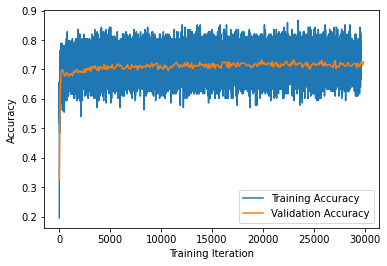

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()